# Fire scar mapping in SWWA

Working off Roteta et al. (2019) - Development of a Sentinel-2 burned area algorithm: Generation of a small fire database for sub-Saharan Africa

https://www.sciencedirect.com/science/article/pii/S0034425718305649#f0005

# Utilizing European Space Agency's multispectral sensor Sentinel-2 with 5-day revisitation 


- Two identical satellites: S2-A (launched in June 2015) and S2-B (launched in March 2017)

- The main sensor is the MultiSpectral Instrument (MSI), a pushbroom scanner that provides a wide spectral coverage over the visible, near infrared (NIR) and short-wave infrared (SWIR) domains (amounting to 13 spectral bands), with medium spatial resolution (from 10 m to 60 m depending on the wavelength) and a wide field of view (290 km).


- https://earth.esa.int/documents/247904/685211/Sentinel-2_User_Handbook

- Sentinel 2-A 

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQy_gNnnNJ_JcyfjvPXZVLgAt_VnDYtC68KcuksGrikHTNQ4LHW)

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSR3E1aQ-xOuag2kj3lamdItB6d2wcyVTqKJzbIWhyTc6zrmJza)

**Indices we need:**

- NDVI = (NIR - RED) / (NIR + RED)

- MIRBI = 10 * SWIRL - 9.8 * SWIRS + 2

-  NBR2 = (SWIRS - SWIRL) / (SWIRS + SWIRL)



SWIRL and SWIRS are, respectively, Short Wave Infrared Long reflectance and Short Wave Infrared Short reflectance correspond to B12 and B11 bands of MSI sensor.

*The Mid-Infrared Burned Index (MIRBI, Eq. (2)) and the Normalized Burned Ratio 2 (NBR2, Eq. (3)) were most sensitive to fire mapping according to Roteta et al. (2019).*



**Criteria to identify fire pixels:**

- NDVI (T1) > 0.25

- MIRBI difference (T1 - T2) < -0.25

- NBR2 difference (T1 - T2) < 0.05



In [0]:
import folium # let's make a quick little map to see where yanchep is
m = folium.Map(location=[-31.556700, 115.649291], zoom_start=10)
tooltip = 'Click me!'
folium.Marker([-31.556700, 115.649291], popup='<i>Yanchep Bushfire</i>', tooltip=tooltip).add_to(m)
m # the whole map is saved to a variable called m, so all we have to do is call m and the map pops up

# Part 1: Intro to rasters and arrays in Python with NumPy and GDAL

How to read a raster into memory

What does a raster need?



In [1]:
# We have to connect our Google Colab Python 3 notebook with our Google Drive again!

from google.colab import drive
drive.mount('/content/drive')
#go to URL, sign in and enter the code


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Let's make sure the data are there

# Let's see our data from Python...now we're working in the folder "Yanchep_images"
import os
os.listdir('/content/drive/My Drive/Intro2Eco/Data/Yanchep_images') 


['20200112T021341_20200112T022157_T50JLL.tif',
 '20191218T021339_20191218T022204_T50JLL.tif',
 '20191213T021341_20191213T022223_T50JLL.tif',
 '20191203T021341_20191203T022118_T50JLL.tif']

In [3]:
# Define raster path name

raster_folder = "/content/drive/My Drive/Intro2Eco/Data/Yanchep_images"
raster_name = "20191203T021341_20191203T022118_T50JLL.tif"
raster = os.path.join(raster_folder, raster_name) # os path join is an important function to know for merging path names and folders...you'll learn os is one of your most used libraries

os.path.exists(raster) # Check and make sure you have the path name correct, if yes, should return True...if you have it wrong, then it will be False. This step is useful in case you get errors you can't explain!


True

In [4]:
# GDAL read raster and explore

# Let's read the raster and find out what goes into rasters in Python

import numpy as np # You've seen numpy before I told you it was important!
from osgeo import gdal # GDAL (https://gdal.org/) is the work horse for open source GIS from R to Python and QGIS
ds = gdal.Open(raster) # Open the dataset and save it to a variable called ds (data set) 

# Let's check out this new ds variable

ds.GetGeoTransform()



(353660.0, 20.0, 0.0, 6533180.0, 0.0, -20.0)

In [5]:
# A raster (in QGIS, Python, R etc. ) needs a few things:

# 1. Pixel size in x and y
# 2. Number of rows and columns
# 3. Coordinates of the top left pixel corner
# 4. A projection

# Let's find those in this dataset

#1. pixel size in x and y
x_size = ds.GetGeoTransform()[1]
y_size = np.abs(ds.GetGeoTransform()[5]) # use numpy to get the absolute value of y 

#2. number of rows and columns
n_rows = ds.RasterXSize
n_cols = ds.RasterYSize

#3 . Coordinates of the top left
ulx = ds.GetGeoTransform()[0] # upper left x
uly = ds.GetGeoTransform()[3] # upper left y
#print(ulx, uly)

#4. Coordinate reference system
prj = ds.GetProjection()
print(prj)

# We can finally read our raster into a numpy array 

array = ds.ReadAsArray() # Convert the dataset into something we can work with...in this case it's a numpy array

array.shape

# All that is pretty ugly though isn't it?!!


PROJCS["WGS 84 / UTM zone 50S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32750"]]


(10, 1435, 1500)

In [6]:
# Rasterio will make our lives easier (Raster input output)

!pip install rasterio
import rasterio 

with rasterio.open(raster, 'r') as ds:
    array = ds.read()  # read our dataset into a numpy array
    array = array / 10000 # scale factor divide
    meta = ds.meta # rasterio stores all that information for us!

meta
array.shape



     |████████████████████████████████| 18.0MB 236kB/s 


(10, 1435, 1500)

**Quiz question: what are the units of each band????**

Hint...it's not radiance. For more details see here: https://www.harrisgeospatial.com/Support/Self-Help-Tools/Help-Articles/Help-Articles-Detail/ArtMID/10220/ArticleID/19247/3377

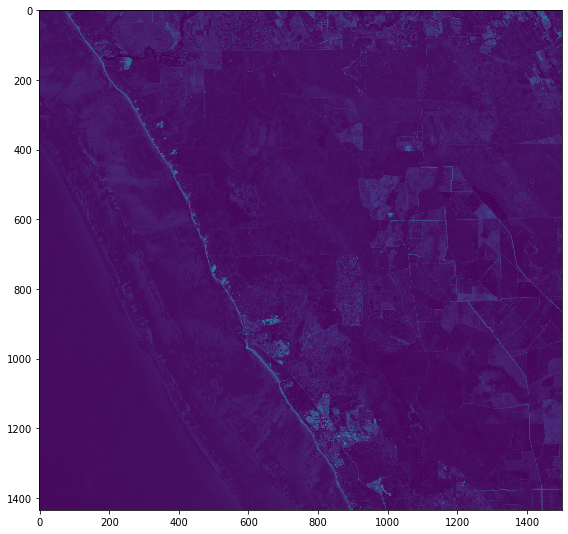

In [7]:
# Let's finally see our image right here!

red = array[2, :, :] # red is actually the third band, but in Python index starts at 0 very important to remember!
green = array[1, :, :] # green second band / second item / index location 1
blue = array[0, :, :] # blue is the first band but zeroith index value

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8)) # Here we just visualize one red band, try changing the combination or the bands above!
ax.imshow(blue)
plt.tight_layout()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


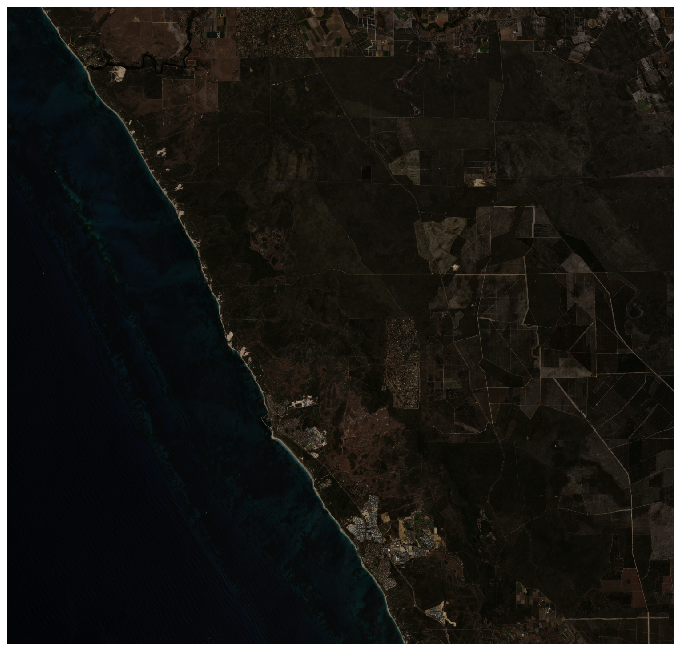

In [8]:
# Let's make an RGB stack so we can see a true color of our image
import numpy as np
import rasterio 

with rasterio.open(raster, 'r') as ds:
    array = ds.read()  # read our dataset into a numpy array
    array = array / 10000 # scale factor divide
    meta = ds.meta # rasterio stores all that information for us!

def stack_rgb(array):
    red = array[2,:,:]
    green = array[1,:,:]
    blue = array[0,:,:]
    stackedRGB = np.stack((red,green,blue),axis=2) # a key numpy function stack puts all three raster bands on top of one another in the correct order!
    return stackedRGB

RGB = stack_rgb(array) # our new stack_rgb function put to use!

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(RGB)
plt.tight_layout()
ax.axis("off")
plt.show()

# Questions: 

1) What was the burnt area of the Yanchep bushfire this past December? 

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAjgAAAIwCAYAAACLJhGbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOy9eaytaXbW91vv+37jns7Z59x5qKqu%0Aqi63B2w3tBMbK2CDQ5QIJ4QkkoWjKJKDFQKyBbEBZ2qQYwgEBTkoEcYxkRJhYSMEyiCkQGKIhWx5%0Atts91Xjr3rr3nnGfPX3jO+SP9zunrtvV5bZpq9ud/UhH996z97f3+01rPetZz/quhBDYYYcddthh%0Ahx12+FKC+kIvYIcddthhhx122OHzjR3B2WGHHXbYYYcdvuSwIzg77LDDDjvssMOXHHYEZ4cddthh%0Ahx12+JLDjuDssMMOO+ywww5fctgRnB122GGHHXbY4UsOO4Kzww47XEFEHonI7/8Cr+GHReT7vpBr%0A2GGHHX7nY0dwdtjhixAi8r+KyN/+jN/9PhE5E5FbX6h1fb4gIt8hIk5ENs/8/HWAEMJ3hBB+4PP4%0AXX9ERH5JRFYicioi/0RE7n++Pn+HHXb44oT5Qi9ghx12eE98F/CrIvItIYT/S0Ry4G8BfyaE8OQL%0AvLbPF/7fEMLv/81sICImhGB/E+9/BfjbwL8F/FNgDPwhwP9mvvfzva4ddtjhtx87BWeHHb4IEUI4%0AA/4U8EMiMgL+K+D1EML/DCAiXy8iPyUiFyLyRER+UESS4TUjIkFEvlNEXhORhYj84LOfP7z2SRFZ%0Ai8jHROSrn3n5wyLyKyKyFJEfFZHsme2+dVBDLkTkJ0XkK5957ZGI/FkR+cTwnf/Ts9t+rhjUq48O%0Af/+DIvKWiHyfiDwlkrz3Xcdn4GuB10IIPxEi1iGEvxdCePTMsfovROT1QeH5WRG5Pbz2N4Z9WonI%0Az4jINzyzxu8Xkb87HJ818O2/2f3cYYcdfnuxIzg77PBFihDCjwM/D/wo8MeHn0tYospzCPxe4F8D%0AvvMzPuJfB343Mcl/u4j8QQAR+TbgPwf+GDAF/m3g/Jnt/j3gW4APDNv/+8N2HyESjO8ADoAfAf6h%0AiKTPbPvHhm1fBr4C+PO/1f1/BneJyst94E98juu4xM8BXyUif01Evmkgi8/ie4B/h3j89obPbIbX%0Afhr4XcAc+HvAj38GYfsjwN8BZsDf/Rfeyx122OHzih3B2WGHL278CeCbgb8YQnh4+csQws+EEH46%0AhGBDCG8APwT8vs/Y9i+FEJYhhLeAnwC+Zvj9dwB/OYTwc4Oq8elnPxv46yGEp4OK9L8/s90fB/6H%0A4btdCOFHht9/5JltfzCE8CiEcAr8APBt77Nv3zgoMJc/v+ezvM8CHw0hdCGE+nNcx+VxehX4JiI5%0A+nHgTER+RETKZ47F94UQXg0h+BDCL4YQzodt/5cQwvnQevorRDL40jMf/5MhhP9t2K5+n/3cYYcd%0AvgDYEZwddvgiRgjhCDgFfvXZ34vIl4nI/yEiT0VkBfxFoprzLJ4+8/eKqIIA3ANef5+v/WzbPQf8%0A2WdJCXALuPPM+58lSg+A2+/zPT8ZQth75udnP8v7jkII3TP//lzWcYUQwj8PIfy7IYRDIgn8Zt5V%0Alj7rsRCR7x3aeEtgAYz4tcf44Xttt8MOO3xxYEdwdtjhdyb+JvAx4KUQwhT4LwH5HLd9CLz4W/jO%0Ah8Bf+AxSUoYQfuyZ99x75u/3gce/he/5TITfwjre+4NC+GngHwCXnp33PBYi8k3Anwb+KLF1tQ9s%0A+LXH+DPXtcMOO3wRYUdwdtjhdyYmwBLYisiH+PX+m/fDDwPfKyJfKxEvi8i933Cr6Hv5T0TkI8N2%0AYxH5w5/ha/mTInJHRA6IKslvhzflc1kHcDVa/x0icn3494eAPwz81PCWHwa+X0ReHD7ra0RkTjy+%0AlqieJcBHiQrODjvs8DsEO4Kzww6/M/FngP8AWBPVnM+ZSIQQfhT4b4ZtVsDfJyoUv9F2PwX8x8D/%0ASGzZfJpfPz30o8A/JrZ9PkX04Xxe8Tmu4xILohn4YyKyAf5P4MeAvza8/leJis4/IR6LHwLy4X3/%0AGHgVeGt47UtlPH+HHf5/AQlhp7LusMMO/+IQkUfAt4cQfuILvZYddthhh52Cs8MOO+ywww47fMlh%0AR3B22GGHHXbYYYcvOexaVDvssMMOO+yww5ccdgrODjvssMMOO+zwJYf3/c8288ks4B1BKQgBpTTe%0A9YAgSiEi+ACKQPAelCDKIHhCCPggiNYEZ8F7lFKE4EEELxqCR4xB7c/Jk55v//qv5f/5qV/g+Pyc%0A7/kPv42/8Xf+PnXTkihF21sSrQEI3tNZBxIfShECaK0IISBK4Z1HROILIkDgUqjSSki0ZpJnJEZh%0AnUcrRdP1ZKkh1QYfPN4HrPcogeBBKeF826C0EDzM8gQQgsCoLHAuvveiauh6y6QsWW227JcZwwp4%0AutwiWpMnhtW2QitFIJAozbVxgRbBE79LELwSjBLwgQAYrbAuEAio4X3Og3UWAogSBBAR0tQMxyrQ%0AW4sxGq01wQfcsF8feP4On/jUAxgOFRKPj8hwnhC0ViitCcP5711gfv2AT77+AEGwzmGUjuc0BAgB%0ArRVlPmK9XeEDCAERhVIKYwRrLQHBex/PnVJx3Qq0NhDAWYuIMMkzHp6ekyQafGCS56zbloPJiLrv%0AqZqOVBtQcDib0bUN3juUxMeVZInGOg8BOueH/RC0CI7AKMtQSuL+h4AHQgis6w4vgSxJ2dQteWKY%0AliVCoOtbzjc1h5MRRhs8kGhBQqC1Fuc9qUniPotHRJPnhtVqi1IKJYJJDKKF4IZrzVq8D2ilyFJD%0AQFA63l/eOgCKIiMI2N4RQsBajzEaEWitAwJGa0QJbddDAB8CVdMwKTOcBBJlsH1PliYgitTE82Kd%0Ap+89k3HJeFyQGE+e5VR1S6I87xyvUaIwOt6LwQesi+fvrNpQKIMS4eF6xSRN2fQ9RimUaLKgaDpL%0AmWds6hqtNKMi52A+w5iESZHjg2dvOqG3HU+PFty8eZ3lxRKdKFKTocSR5Rk/8/GPk2kT9987hID3%0AgVXXoYNQJikv3blD13u0FoosYVN3MQ6EQF1XOFGEAK7r2d+bkSaGru95+Pgp582W5/f2SPISwXP9%0A4JCn5wuyLKeqKsrRCG00dVUzKkes1ytm44IHjx9zvNpyd1qiTQIB3rxYxjvfB5RS8ak5ClIUaWoY%0A5zkiULU9B7MpRW7YVjXzScl6XWGdxyih62Ose+nOAa89PSVVCp1qAlB3GuscznrKPKOqa1rrmE8n%0A8f60PT4EsswQnMfhcb1HaVhuGuZ7M04uFrjec/tgj21V82S9IUkNiVI0VY8j3j+CUGSGvnfY4AlA%0AWabMRzkSQKMQ0dy/e48sFf7vn/klstTwlS/cp6m3vPnkjCJJYkgWwQXBE5iMR6igWG7W5CrGIYWQ%0AZBkoQz7EsjRLGY1K8rxgs1lxcrZARCiyAsFzsVwRCIzyAgUE4j3etS2nqzV5lpGmOY9PTyAIX/3y%0AC5wsVigF+/tT3n7nCVpptDFUdUWRZYyH8318eoYfckiM5zG2BgLTcYlSGmcd3nuU0oCnbXtuXD+k%0AqmraruPu7duMRgWvvv6AbV0jAvvTMYvVBud8vF9MvD8PDg5Zr1d0fUdASIzGWouIGr5D4b27ynmZ%0A0Vw7uEbdNlhruXf3DloJ26pCiabrO54+OWK+t8fZ4gytFM4HRCDVGo8w399nMp7QtjUH8wPWmwvG%0AZcHp+Zr5fJ/5/j7OeQKevuvwPpCXIz712qc5Pj1jta0AKIuMF27fYX9vnzzPAME7T9d1KK0p8oxf%0A+fgvY0xC1zps2zAaj3EBNnXFKx94gV/65Cex3jNOU7z3NM6TpymIUGQZXdvS9j1myDvHF9V7PgNM%0Af/SjH/2sBOf7/+vv/2gIw5OtQgAfiYMaspEQCM6D1ogECKBUJCCIQgRk2OayFXZJNJQ2BO+GCxH6%0AJKNqG/7Ah7+CV994yJtPHnOx3CACznkSYwgCSoTeDf8RcIjJXGsdAwiCD5f/SXDAh3D1VC4lEuPL%0AsP1klNFZz6rp6KzDhYAiEjkZ3mtDIDGa3jm0VjTWXRGpcZ7F/dUGay1NZ1lsKkQJidIoPPNxhhpY%0AmATY9PaKCHz5i/cZGU3bWSZ5ilaC0jH5pUZjlUJ5T/AxkCRpcnV3aQGtNWmi6XqLhEAQcNbjnEfr%0ASPJ668iyFD8cr3gsA9oonPMU0xEXZ8urpC/DWo3WaB0DstGavnf4geys65bFcsOLz90jzQq6tkUb%0AjfMegseHwLgsqesK7z0yrNU5TwgxIdZdR6LjmU9Ngg8eAW4eHmKdYzYZo4ygGBK3AuUDq6plXOT0%0A3lN3PR+4fYvpqGC5rfiKF++BVkzLLB7sBKZpggMmRUZeaA6mBYmJibjIDAfTnG3rQBRKaUQL3sVr%0AZjYruXt9n2sHU5LEMClKxrOS3lryJMUSWG5rTrdVDNaAk0DTdOA8s4MpZ5sV1+YzMJqjkwVFkVCU%0AGRdNwybAtqo4W23xIZCWGUeLTUxciWE6Keh9wFnLqmpYty3lZEpdN7x9fM6qbtkbGc43LW3Xo7OE%0AvmqoekvTdATv6V2g6R0Ez8l6y8Eo5+x8y3Lbstw0LNYVm6olL3OM0Xz1K7e5OYcsaXjjwYLjkyXL%0A1ZbFsmJbdzRtR123lHnKjWslrz455eNvHPNdy4a/OR/jvWeapGz7Dh8Cd6d7FNowLQusc9Rdj2ih%0AzHPSvGBbd3R1w3w+JU1SrA8EB63tsc6RFwVd11AWKat1RfCOx+dntNbiQyyqamtRIpE0akXvPE/O%0AzslSRZEV4DyeQAgSiX+SoeNtjkmzSGqDw3rHdDxiniqKPBkIkuHOzUOOTs9Zr1eMJyNEwGhBEWjb%0Ahna7orGOte1RqWLT9pxvaipvyZQmCFwfFVTWDpkx3meZMWybllGe0juHksD5xZpt0+GCx4jCB880%0A18yLhMfrhtPVlso6Vm3Po4s1Z5ua2tZsuoZ133Bn/5DldkvTdXzZC3dIjbA3K7lzYz/GbiAzht46%0A2q5nVbfUTcP+3owP3r+JxvHmyYI8TbDOoQMEgZdvXOdgNuXFu9eZjiaM8oQb+3tcrLbcmo5YVi2z%0AJMW5wGg0Js8NznW89eSUr3zxOfCO04sVeFCiQAurbcN4lHP31m3efucJeIcxBnNZjCpFkmasNxus%0ADxR5wbZtaJoG53281mZjyjyj6y0n5+dkiUEPBKBqWzQKlSQ46zCJIQTPtfkeJ+cXaBFuXz+g6VvS%0ANOHh02Neun+P2bigbVtG5QhRUNVtLKh7hwhXeUZpwYWA0QkhxPt0b2+CSVIm4xGCkCQZTV3jPYTg%0AOT49ZVvV3L55i+VqRVmMOLtYxqImy7DOIQiioG1qkiylbTqQgHeB6XiE947ExFxQZDlKKQRBieLm%0A9WvMD/Zp64bn799HKSiyUSx0bODunZusNhuyLGfbNORpxmg0JisKbN3gQyDPUq5du86Dhw946+lT%0AymLMoyfv0Nctm6qmamtm0ynWulgsWMebD98mBMF6x+0bh9jOMi8hLSbkeQEi9H1HkhgIAWMS7t97%0Ajncev0OqFQ5H17aMJmMmZcnJ6RlGaw4nI8rMMB3nNB2UeYoxhqZrCc7HInXgF9/z5/6zv/BeHOZ9%0AW1QhROUhEIkEQkzCWg8FkY+qgXeDWCKg9MByAqI0zjtkqOyHMjlmadfHz9Eaug5ft7z66Qds24aX%0AX3iOx0/O+eCL91DEJGttrFJi1R8TulKX6kxMrD4ElKgY/IaKw4e4By6EyyKOPEtwPrCqmhjgfGTB%0AdiATvXNY57HWXZEn7wOpiYSCgXQprcgSjQBN36OVRhAmRYoRGThhiBegiiRPC+Adz93eYzIbc+tg%0AjyJNMDp+h1KKrQso566ek+p8AInESoWA0gY/3HRReYkBPkk0xkSVK001IlFhESWxmvEBHzzBB7SK%0AQVYZjTFmOJaQGgPEY+VDQGmFHj7TulgxBOd48+1H7O3t4UOgaTus7emdI09TqqoiyzKUjspOIKAU%0AWO9o2o5RlqNFoZXGBwcIB9MpT45OcL3j5Oycs7MLzpYbVpuKuu6oesvN+YzW9fTBEQQuLhb0bcft%0AwzlPnpxS1T15lqC18LFXTzhbNzw+21D3jvNtw7rqqJqWTdVS1X2s70KI19almmRiRTzZP6DtOzbr%0AmrPlmsm44PT0nLrpaLueVz5wjzvXD5iWKU3bsVhvOVqsaJzjtGl4dHRGZlLeeueU09MF1jra3vHO%0A8QV5lqK6npdfuM/hfkHbWw4TA0pY1y1n52vOllveeHTC0fmaprMIwtPzBSoRRuOcprM8OduglSIv%0AcozSrLqeTGuUCG5Qzhw9nXMYJTxZrGmGa8Z7T5Em3N4vuDNxeODwxnWOuU+WjSmLeBys84NSE+9f%0Ao4S67fj026c8eLR8N1b4gBIQCWRBM06ygVjH+JFnGb2zuN6zrWqOT045Xyw4vljy8x//NO+cnrDa%0AbkmLkv35nE+8+QbnyyUnpxdkxYjxaEo5mjxzH8d7VQ/XF4FYzfmAFuHpZsnHHr6JJyrNWZpiTEJV%0AbSO5MYbgLK31eC+oEINDH4SqjwkWiWqk94HWeB6uztjUWyTAqtpy1m9I8pI8UegAjoDKNPk0FjYd%0AnhSFFTBKxYo/eIzWeOJnWx+TSjcUI7NxwbTMKApDojUXW8t54/A+0LSW1rkhvoWrIswPUfrurSl3%0Ab95AKWG9WpMYBT7gfLzGISqNWWJiIWY0Nw/m9J3lwdNzfuWtJ0iAtu7ABfoQeOXObSbjEXmesN5U%0AjPKEg/k+3gf2Rjlaaa6PRvQBjEl4eHRMVdccnS0ZZxmh76k2G1SAvXHOpDSMi4zr05Kq6Xnw6G3K%0AIsUM160aVHp8jFOz6ZQsS9l2Nc556qal7VvG4zFFltG3PSJwuD+nKAqcj7E/0YYQgxg6MbRdz8H+%0AnO12E88FAdt1aKVZrNeUWUbb91ysK5RO2GxrXn7+ebwfOg7BX8VWiIRDiRCCpyiisrDZ1sz39tls%0Aai6WG4wOpHnBYr2OyVYpDucH9K7DWstqvUIrRW8t3tu428EPyr4gPoDE/CEa1psKiN+pdRQQ8jSL%0Ahat3bOoNT46e0jmLoNib7cW40zXs7Y3x3vHSB57n/r17pHlGajQEhxbF4bU5Xd+R5zmb7Zq27fjG%0Ar/u9PH9rghLhbLnizXce8drbD3j7nads6gZRJiqGncV7zygr0JJQjkYs6qhmtV2HVoo0zSIZU0KS%0AJATvebpYcr7ZUHWWZd/z5PiEuq7Y1jVlloJSkRyK0PuOtu242GyYFCU+BA72JoyKDKM+O435DRSc%0AH/horFVi4lVKxXYViuAtlz0iZQzeuaEdJOBdbEE4Gxm7MLS0GJScMEiew4UcAqINen/O0fmSf/Mb%0AvppV3XBxsSLRBus8d68f8tJzt3l6cj6Qr0hoLhWR2OqI1VFiTEzug4IgElsSEBUcARprOZiWbKoO%0A6/0gvUE7VITOezJj6HpLZgxGa0KAprcxqRgdWzsIaZJQtT1KKyZpgsLH4DJc1DE3BCZ5yjhL+chX%0APYfSCYkKNE3DfD5jva7I8oTWBzIdb3TnXFSdlAI8mVEoJTRdH5PXQFiUkmdacuADWOfjMR/IaZaY%0AgQDK1Xk4nE84Xay5djjCecH1Lsrd3scbbFCy0qHS3TQ9vfcoZciLgovFOTevX+dssUAJzMqSUWoo%0Ai5LEGNabDYnWeO/JEoO1jjSJas54VNJ0Pd5aDvfHPD5b8DWvvMDFcsVsMmO53ZCnCb1z1G3PfFKi%0AfKDuLXi4vj/m5uEetnexPQTYAHuTnLZr+Y9O1vyVIqV3ludu7rNuWhKlYwDvLUpgsenRKlb+EgJC%0AoO18PLZtrBR1IkzKlFfffsJz9+6zWi2xicE1DXmiOV9XhBBIteIy/F0GKOccTWfJi9hyunMYg/I7%0Axws2dcviYsmsLFisG/JEkRUJuVGMxwUPnyyYjXIUwnPP3aaqGpabis22QbSO7UnrmE5LQCjLjKpu%0Aafoej7DualrvriocJZFqjIuBeIiQaIVC82TZ09YdnVdk5Yx7tw/51V9980qRJQSMViRaoVUkEb/4%0A2tGviRX//bSk6yyrTYN1gb1xObQs4/W7tz/jZLHk2nxO3TTDmgRj4nXeNj3vPD1mMs7RIkzLMYvt%0Amn/pw78H5yx934ME2rpmkpfkOv7H4XJZvChFojRt7zBK4TXUbc+q3nBzfkhVt9R1jUdiq9Va/JAI%0AV5s14+kUgmezrUlMQggOrRNGZcbxasVFVyM4aizS9CxcS/CBl24dsFpW9NpRBo13sdhCC9dGOV6E%0Add1RZENbLUCQQHCBMo9EqOk6nA90zqKIx+VgWrCuO8ZFSmpi7FzVHfM8ozQJW9eTKsMrN25z//AG%0AN8Yz+gCb7Za6abjY1Gzqlm3XcXS+ZLWp2XYdm6alsxajNbPphKcn52R46q6j7i1FYjiYlmx7y9e9%0A8hJ5ItSdA4mt9eV6Q905ThfnmCGmNDZeY6PRhL1RxrZreevRCXmWce/2NTZ1TOg+CKu6Zd14atty%0AOJkhQZjmYFRKNpnRVxsQQbRg+448L/A+8PzzL9B1Fa6z9L1lsVqyWKzIxgVGDIvthjLNWFc1xiiC%0AaIISiBSXdV1T5hlpknB9f8bpxYoyTzleLNmfzaibjr7v0FrT95bZdMTp+QU60aRJQtt1mEGJjok6%0AhlslUelWEvNk11u2my1ZknC+XLOuNhzs76PQuBBYXFzQNm28J2azeAwHtf2SvGRpFothk+CdQ5SK%0AxYMSgo95T2tBVCxgrbXkWcZ6s6Xretabit42rJYbEqO4f/8e5xdnbLdbyrwky1P6tkNEsz+fc/fW%0ALcaTCV1nGY1GKDRV2/L06DEPn5wyn+6hjWJZ1TjnqLZbVusVF6sVx4tTynxE31t8cGyqik1Vsa0a%0Abk0N5WxO5yzb9YZrh9fIsgznHEopmroGZ0HBtuquci8CRWIwKuZ05wHP1TnwzmJdoKobjMC4KPiT%0Af/p731PBeV8PzpAd0aJIkgQ3BAXn+qH1E70gfqjeUPEEKRHCoECI1pBkhL4Dby9zMEiIF+DgHaDr%0AsJstx4x4++iML3/xPifnSwojPDg65fjsnLc/fhST+tAMFRGM1lx2Rb0HT8D7oVox5qpt4nxsw/ih%0A1WZ94PSiilXg4MHoBvKydh1GK7ZtT54mtJeekYE5j/KUxGg2XU9TtcxnE+bTMQIobwlcKjfPKGBK%0AEbzHi+Lp+Zpx4ZDgef3JGWW2JIgwU0KC4B34ED0oMqxNRGhcrOKKdEilg9fIB4n7HKKqlejoqVAC%0AidGDX8IRfCSXYXif6z2ut5yebPA+nk8fGNQkj0kisTNaYb3BhY7xaELV1FGxsT0npyfcPZyzXa8J%0ArsMGYTQpyIuMPE9QwOuPnvLBezMePLnAeRd9IyFwaz7laLHkzSfneB/457/8Ke4dzDhbLOitJ/ie%0AIjG0ncU5T9U7tBHuH+xTW8tyVROU8MEP3Ob1B0dcH+fg31W++jySynXdDGQ0tucSo6i7YR3I1fkR%0AwCQK76K3QIniYK/kEw+OqOqWNx68TdN1sK3Zvz3ntOpQMbqxbTry1ND2lkmeszcpqL3n3o0cm4w4%0AevyQN59csNg2FMngj0KwAZRRvHG6pkg0WaJZnG/jTZ4nWB84Oj5hPt8D0UiWcXp8zO1r+xil6YOj%0Aq2rWTRt9aknKJFH0wcTWhxJ66yPRAbZtx835hLdPlviuZ5QkbOuO8SjjzTfe5nflivOTCc8/f4Nq%0AtWG5ruP2QJ6aSHDeY/DyYl0NpVC83p3zGD34ILxjfXFBniQcnZ5x+8Z1jk/PorTvPEoUXd+jRPjY%0AJ17jxs0DXrn3PPP5Hk2zpal75vv7vHP0lKqpYjI1KYXRjBKD857p/pzHR08Z5wmJTiizHF9G/1EI%0AQvCequlYrleMigIRiQqkD+R5zuL8nLapGE+nJNrQD+1kSTSn1SrGtkRTmITTrmWsE3rveXS+4Klb%0AMVKGWTGiTC1KaRrXkQbIc82qapAAmdH0zkZSbhRV05CbhM5ZxmWOjVY6ysLwi68/GVRlhzYaDeRG%0Ao4dqVUl8re969mYlZ5ua07rhI1/2Ao9PzhBCbEX1PSIytIjjiTOimO6PudjW7OUpT9YVSaK4Nimv%0AFLqXb1zD24bNpiIpxly7dsCvfOJVqqZFDFSdZWY0tYut4L3JmL5rovI7FLsfuD6lt4HUCJsQ2NYN%0AOlMkAipknK1W9LbHhTGOFrutGSUxmV/aD7quJc9z6u2GLMmRqeHo9IQ8SRgVBdWqQinF/niMd7EF%0AtdpsCM6RmpT1dotJE5RWNG1LmhgIjpt7Ux6dXvCh5+6wWG+wfUeRTzg5XxII9LYfiksNQcjShL63%0AUdgTQQdF7ztEAr0NQzteUTcXFHlJ33XkiabqA+cXS24cHmCdRScKrQXQLFYXKAStFMYkNG2L1pqm%0Aa0l0Qts1uOAp0oKu72KkkqiWeq8geIJ39N7TrDfsTaZDC9XhbGC0V5DnHW+89mnarufR0RHrVRXv%0ASy+kZcobbz9gOhnx2qdfI4hCaWG+NyNPc5brFYLQ1BUeRWoMbd+zrWvmsz0m0wnnFwsmRcm0LNHa%0A8PTkGJEe6yxvn665m5yBTkiMwRiD1rFjcL44Z1qWbDdL9qf7LNsO7WHbNEzKkvF4RJ4ozi6WsSUc%0AopWAEK9rrQUtmtY6FN2vD0gDfoMpKrlKFt77WM6lKaKjkVgNN5t4d0Uc/CAtXlmxgoeuIVKP+Lsr%0AT45zMCgcOEvoLW6z5adOl9y9fsDx6QVplvL6g8d0rb1qmRmtB4NU7IP6gcQEwmB6VWiJCevZYOyH%0AG9xH4Sf6PcZZDMiXXqHhfdZH6Xfb9dSdpffRfwOBTdWCNmybDgT6ro++I29jC+jKxyMxSIpwvq05%0AXlccHk54/vY1mrblZz/5AGN0lHvzfFivR6uAVlxJ0Wbw5oQQKDODc7E95YaWmnNu8CKp4Xujd4gQ%0AYhJ17koNumT/cZ/D0EZ4l0h576+OU9v1A8lS0XgM2L4jDP6mRCfkWlFvt0OLJ5737WbNydk5Xdtz%0AslhhjPDaozOyxLA/LllXDXRwkN4AACAASURBVInA8eKCTd3hnR/UN3j79IJ+8GBsmxbvA2WWIqJA%0ACak2aK24e+Ma69ayWld87JMP8SIE72ICVnH9Rw/XoIUQoop0eY4762PVH6IyqZUGUWhjovIWAptN%0Ax+liw/FZhUjCfDbFBsd0lDEdj3jneElGoMgy9sY51+Zj7t064IPPX2dU5rQu4G3g0dEFTx++g209%0ANw72+NZ/41/l2sE0GqsVrKqGO3vX2JsVvPzcDfrguTafooDHpytOLtaRuIaei/WKk+Njiizj4fEZ%0AZWG4WG5pu45xkUfi7z3Hyw2JNrE9GODSlXapXq6rllwbtFIsm447tw5YbRrWVUtT1xw9PUaJQXwg%0AM7G1qdW795B/D4Zj1DMK6eAj0+rdGBAQ7t6YY7RisYytLbk0pg/v0zq2VZ8enZGNCg4P5oDi4eN3%0AeHJ8Sl3XVwqkc34odmILTYpwtbZ1U2O7jlwJ18YlSKDvOyR4EiX0XY93nuXFktXijNXygrau6Kxj%0AtVyx2m4pyxIJgdykZDoawnOlMS5gfKCXgCaauT9y70UKbXirv+BcakBxe7ZHYx3eea7vjVm1Hbm5%0A9IjE2FIkKVmWokTouqiq5GnCetsN6nQYwm/8czrKaJ3DEbheltwYTSiKlMVqy6Zuoe352V/+FPcP%0AD/AusN7WMaY4j9IyKItgEs2m7Wjalrq3UVlygdZbfO8xKFIJhL7FEcneJz/9FtZZVCK8eP820yJW%0A4ntZMgwOtJHcqljA3ZjvEdIxIg6UJinG+OBJJF6zZZpybW/K7YM5mREmacYkix6NEASTZKASbN9T%0AVVuW681QJFrK4Vq/bKGHIfa0XUfdthRZjkkS2j4OxKQ6wYgizXOWmy1N03HjcIILnqZpKLOMQIgt%0AUmMosgSTJIzKclAbos/ThajQ9L2lcxatFSZJIrlRsejUSkiNYjwe4S7bTWHw5gE+OAKKum0JPsZu%0ABKzruTY/iLYK6/HD0EEIsWCXIV6HACaJAy5N16JEoYnDCaNRwfUbh9y7fYsbh9foXc/jo4bD6zd5%0AenJCax1aafJ8zPPP3We5rAgBXn3tNZq+A9fTNG1sXxcZRhsyYwg+tlW1ikMGLngeHT3ljbcfsFpt%0AODk/j+1AFbh3+zavvPgy1/YOOFmu6duavu24WK5YrZY47+j62Bq8fnjAKy+9wqQcUypDniRcn+/j%0AfDQki8Tc50PM2UFi4lZDu/ey29BZ+1kZzPu3qP7qf/tRnAWtB7YY8F2LJPGCuWx1XGkVMvhxtI5e%0AnBAgyVDexQWG2DaJBCAmrOAicRLvIUkJIbDcNOQK/pUPfxk//o/+WZxMcR6R6LG5NMWaoY0jQ0sp%0AEMgHM24gDBNPQzCW6Mn5zIDcD0cvhGG6SL3bwhGivC5DorDOwdDmWdctRglFnjHOU1zfDT4EGYzI%0Ag+piPWfbhm6Ylqnqnq61vHNyjg2BMkkojbn6Lq011kUl5ZKwRHUq9mIvL/rLdQFoLVcTZnHx0FlH%0AYgy2j63EQFybH4JZYjR6XLI8X0f5Exg6F7HtqC6Vu+hdsD4QRNFZG6d02obpsN/OO1Qgeph8IE0S%0AsiSh9z0He3vkqaFIDXXXY61jb1QO3ixBAjTWgYq+oCJJKbOE1CTMxjkXdY0WYZRnaK24vr/P6XKN%0AC9C1DcEHivGYUapRIRKcB92W7z6peP7FfQqlOchlkJIFhVC1lizRV74jABnM6d45wkDCrfccXWzZ%0ALxL2Dw549PSUu/fvslmt4nRVVbGtG1KjeP6Fl3hy9JSm8Zyv1pRFSlM3HO6POFvG6anjxZrF6TFl%0AmrDeNoyLFO/hyfICHYTzZU2aptHzMypI0miwW6yrgQgoppMRfdfx8s09nAu01rFpLIlR5Ca2ZUbj%0AMWOt2Np+UFeHK39gOr3zpEbTdI4X7h7yqbee0ltHnhjW24b5rCTLMmqrmZjAxaYhSxM6F9t4SsFf%0Azgx/atlcHb8fnGSRDAPjMmc6LQm+v5pmCyHQdRZrA90w2QOREF1WvybRw4Sf4o0Hb/PkyRGTyRTv%0AA4mJPgpsS4IihHi9ewx10zOfz1gsVlet6HGW43yg7iygqKpNTOxVixDQxqCUZlSOY5E0mOi1CNPx%0AmN45ksSw6Xqq9YpgBJyj8p57e3OWVYUXzzd86IOcLiv2pyOenq84yMZ429N6ONw7YNNWBC/kRjHJ%0AUjrn0CLUvSVLDEjgg3dvcPv6DGMUWivyRHOxjW28S2OrAC8czDiclMxHBfujnL1RQaqFTAnTImVv%0AlDHOM7QK9L1DTIxTXe9ItKIfpu+MSVhtKvCw7fqhrR04KFK00Wz7nnGRc7Kp6Fxgua2YT0cURca2%0AatlsKu7dPOT2zX2SfMy2aug8uABPz9e8eP8+e3szzi7OODm9YFO3uK5jb1SiRdgrS1oXSAfbg7OW%0ATdOghgJJDwbjPM+YTmckWYq1Nk4squgFy7MsTuWoGJM224o0SXHWkmYZXd+TJil5GocYZtMxi+WS%0AVCtCEK7duEVwjgfHp4zzdDg2UJRFNLp3PU3TYZ0jTRNs58jSFG3UkOhNVGRU9KTqYR3exwmjpu/Y%0Am+1TNRVKFIfzOduqivcjcaAk1XGARQalvaorppMJbd8OKUsGUhSLzlFRYoyhKHKCjyb4pm2vWmZt%0A1zEZj5lNJty/fZ2iHNM0HdPxaMiRlt72ZInibLlmuVkjQGfjtJ5zgVFZMBqPSLSha2ra3lJmCdY7%0A8jSn6tooLhB9P0VW8nVf+2HOF6ecLVZok/DWg7fIs4TJdMKjoyMmeU5ellTbLbPpLJqby5yD/X2+%0A/Mte4e6t27zx1hus6poyjWQzEcem6XHBMyniJGR/2WUY1MhsmEhNs5Tv/k//3Hu2qN6f4PzAX/po%0AlE0GY+9g8JMwSPpa4ZRBXE9QioBCLg0/l36bYUImIJAkKJMQnB0YrxDSDDUwUgkBZQwS4OHFhqa3%0AfOs3/m5+7mOfIksSCO/6TkQEa13syQ3yu1bqXSNsuFRlogiVaD0oDzHKX1bz+MBsUmIHA3MyjKDC%0AYGIWoR8+/3ISKwytI6N1VBQGo+yl2hGG9z7d1EOF5OO6hh7tuqrJ0ziZIz6QGjWYceO6YPBMhHCl%0AiF0e/9h6koHsRRISFZko91sb+5uXlY0fzhmXLPiZ/ZiMSqphtC8EUFqu/DoByMuCLEsJQNVEApdl%0AGb217JUlrm2v2n5JotFDghOlSZLoX9rWNZOy5NrBHttNzfmm4vbBHovVlm3XsajbuK8ujj03XU/T%0AWToflbhpnjMdlRilcEpTjso4Cde1tNZy/cY1plkcjbZ9jyjNWVfzD+/foFl3/IFv/hb+wT/7GToX%0AmOYpqdF4H8dTr6bzBtIKsU0pEsdU674jVVHV8V0blZ+uY123cYTbeQRBI7z+8B3GWcLtW7do2hql%0AorG0yAzeBuqup3ce5xyny4r5bEzXW4o8Qw2q2nicxfbAnetsm5aus2RJik4VXecILrDaVMyKnE1n%0AaXuPGKFtbRwZTwx5lrFcbzjf1uSJGdrMww9EZTLE6meSZSy3DZ2LCdANrebHJyuUEqZlyumqxoV4%0AH2RGMEboe8cb5yv+1sGY71rFYPzflVGJSIzmA/evYxJDog1CbPVoJdw83EMbzaZuouGzqgblNQbx%0Avn93vN85T+9iGzFLUxTC2fkZZhhZ9igenS5omp6N63jx+m22dYP3gc47EqVJ85KqrllXDZPJhMcn%0AZ4BQDwqhCj5OpaQZwDACnsTkaWPCy0zC/v4BI4STpqInsGpqXrl+k1JpfuHJI442S07XFUqEr/+q%0AD5MqqNua4IViPKZpG1xwOB+YZinLzjLKE0Lv+JoX5pytGuqm49HRghAChUlouu6qsBIVfTmTRGOy%0AlCCCjcZGlDaoxKBMgnNxKCJNE954esooS1lVDf/yV385470DsE0cM+49H/rAfbq2o8gS9EDmN61l%0AliYURhF0Rp4knC03fNUHX6Cqmzh5k6VopZhMSkyS0faO6WyP9XLN4cEhSOBitUIJTIqcpmmRECdr%0AlVIsq5bbN2+jtcL1lq5vo8dLYrs2+ukCru8JxjCbzaL3qe3IswwfHF0bH0GwbVrKcUm1rVFKMRlN%0A8BIfm5HnGcvVkr3ZlOPViqptuH/nLtY6RAv7sxiDqmrLYlPRW4fzjm3dULftlZpmtKJuWpyz1G2L%0At/5qgKUoMiajkno4jpd+z3jthFjY5TlpkrFYX8RHOIiiLLLBNhEL98t8NB6VbLbbGPO5VDWjCfnd%0A+BSnGZ3z8fc6EqtI5jL2p1MuHySSJyllkXJxccF2W9Fby53rNzk6XVA1dTTka4MLnhCERAk3b9xA%0A68vhnPjYkvn8gIP5AePJhIO9OW3bUjUtSjR70zFPT08RnXKxPMday7Vrc4abmsO9CftFoPOaxcUF%0ASmsmoxFlWXL3zm2SJOXJ8RFvP3yHrm9puo5ZWaIHFb5IDNY71lV87MWN/dng6wxXhnQl8N3f8+ff%0Ak+C8f4tqeHZDuFSkB9Mg3hOcJfT9uyZhiXZkjAGtomRFIHgGFcVHlabvwKQEHZ/jgO3w9XaQEOxg%0AlvX0PvArT88xWlPmRTzgQnxOwaACXQZto/XQkmFozxiG64EQIB3GmP1V64grNeOyzTYZF0xGJUqr%0A2CtUcXT40rzsh3aQUppJWUCIz1ApU02S6Ej4riT5gYwMTfX+GdJVZgmJ1hid4Lt+qCiiZyeSm7hb%0Al5MrUYr3V0Zlo9XVaKCIxFHAVGOG3nAchwzD+GsYLuJBPh1k6subRQ3j4HG/ZPj9u34d27UEH6VY%0Aay1JEpWVPEljL1sunx9DlNqHNpe1lq6NgWs2m6AFjk4XdH1P8IE3npxivWdZtdEspxXaKA5mI9I0%0AQbRikmWDoTsSJ50kOO+YjidUVcWqbpiNx1zbG2GMDFNmMTGKC/S953xds3znE5R5QqLfnaiDgAQw%0AKvqT/HCM27aPx0kJi23F+aZm1TSMi+wq2HnrSLTm3uE+96/NSJTQOs+syNjUPW+9/fbgR4nV87ax%0AlKOcG/MxqYmGee89ZxcrPnD7gPOLNXlmGI0yut6zqRo6G6c5LguKUVry4r1bzMYjcmNie6F3LLYV%0AeIlTeCpW+vP5Ib31JIlmkmZXimYkuOFKoXNEUlV3Mdl3Nkrxl60f23asN3Uk/ebyEQxCqhQfPzon%0ABDjZ1ty9NeHWzXG8T7Rmb3/Ecl1jrWPbdFgfW3+3ru9jvWd/OiaEwOJigTGadFAvtdJXRn4ZiJKI%0A8OjJU3SqSPOEa/PD+Gwtic82OpyO8Nqzl2WISTg+X7Pa9uSm4Hxd8c7xMdu6RQFN06C1osWSJ7Fy%0Abq2lqhvqqhril8KYOBThfVRwPLBeLSmne5ReY7TQBc8bJ8dU6xpro1LsVGwB/8KrH6OtNvhgOF+t%0A6TvPeDSLaq3W1L3FO0/TWe4cjGniJUdiNPPJiHXVMJ6UjMqUa6OS1GhKk1AkhseDqjMelejgScST%0A6MC4zCiLhHGZkqdCliWIGlpSAd588yFPHrzFySI+l2pS5CyXS8Q7tPdM85Rca4KCJ1XNk6oZCjLI%0Ac4MyKfO9CaOyICCUo4IyT+i7lnFpONifcffWbcpRwUsvPM90PCJJNavNFufiNI0ZnsGVpQkicaqr%0A77srU7bSGmNibGq8u5KUP/Hm6zxdLHn7+AitFG3dxQk0o9nbn1FXNc57JqMRi80CFQLbasvFasV0%0AMuHx2WmMh17RDibZyWjMeltx6/oBL7/wAkUS1Ufv350Ybrue9bZmualIjCZJklhMh3ebhlXdstlW%0ATMoRLkBqErreDr7F+NyxrnNs6i2JMnHKVqBpO6q6xlrPKC+GGBq4WG2GydJA7+LQinPhaixeGz2o%0AOfFZNBAiqVWa6wcHOG/ZNPHRKmmSUncNbd/T+x4fOj70ygdZrNcoo2majizNcD62UftBdMiLnOAC%0ALsBoNKGuNrzx1oNIdoZC+86NG+RpinWxXVdVW46OHxMCXGxW9H2PKEWZl4yLKT//2jHbzYbTiyUn%0Ap6eRQCrF6fkZR6cnHB0fc+f2HW5euxl9Zc7T9A4lcUpQROIzgoDTixVV017l1NQkV4LEe+F9TcbS%0At9E5M7SjvA+IRBkxDLKu+HgjXCZV+i7+qU1Ucy4nfeJT3KCz4Nr4QD4ZWlOXrS2l8dais4LQ99SN%0A5od+8hf5zj/6h/ixf/RPOb9YRdOdUqSJYdNEE5YZVBMEgoutJOsvCVD000RPTqy4ZUh2CiHNEpab%0AmtSYyHtVrGZ8CNHhHd6ViQPQW8umqmPgSSNBUEDfd9EYp4TzuqXuOvzw++AD4zzl3rWSh8dbJqMC%0AcTFxXHokorx/ad0eCMrwb6NjJX4pvzvvBz9Q5Jsv3y45Oq853cbtuu4yjcfP7XuHMbGXeelSV6LI%0AB/Ph5c2tFFfkMQwHtG5aimG/q/+Pszf7tSy787w+a+157zPeKeJGRkamnU7bZVdVTzRDA43EIIRQ%0AwwP/Aw9I9UCjAomnegBUQjSIB3jgz0C8IRDq5qFQN6ruqrYrbecY4407nWnPew08/NY5kS2VCnVZ%0Asp12hiJunrP3Wr/fdxxr0fBoCeW6Pjuja8QCuT9I7o3xnuT4UCYiSs2zmEgb2lZJfpCCuhtJk4gs%0AitjWPatZQZakXK0y5mVO7RRusyHNMw5ddzr89vst7TRSJDHXV2d03YgJsG+W50xm5MzG5IkcFO8f%0AGz6/WmOsZz8O/JOv7vjZxxekwQFyPNSMCc+xcWRpsFo7+WfFjmwOI6sywzpHM4wMbR+QM4XRjnWZ%0AYbyi7SeiVFNPlrLIqbues1kpP6OCj64W1M1InsR88d17nl+v+Ob1hk+uL9iPB56crXl7vwcU/WBY%0AVUqcF0PLMIwY68jLGft6x/miYl93KK14/mTNt6/vsc5xff2EyFvq/YHJu9NAc3wldIA1OzPK8Bhp%0AqjRhWeVcXSyZxg68pxsMX7/fYMP3apzDBlWIXKCKzoqofowUZaQp0oQqT5is/LphsmhjeflOckrO%0AVjN++uk1v/j67WnYiuMoDKeW+ayiblqyNBUqy1n+9Be/wnvP7/z089MlMYsSHAVlUZEnGctlwU9+%0A+CmRUnzx1dc4Lc/sOi+Zz2bcbUW4nkcR3jrKOKY2hnWRE4VhKo41zomuT/QXTgLyXM7YTzy/uubd%0A7SN73RJHmgc3yVtmJfDTR54iKvjNu3uenF2QJilVVTGfzzkcDjSmJ09jfriec5gE0Rsm0cf1g6cq%0AxHVlnWUYHHEaAk0RBeNvf3SB1SkXT5YMXQN4tPL0bSsaOaUATayE6qpHw7oq2DQtRZrIZYHDmIHD%0AYeC+7k701OQEGS6ziLOy4PxsxfWza3bbRyLf0xojiMswUOUxD4816+WMoTesVjFPnz3hzatXbPc7%0AZonm0A84J5e+oBMFbduRpSl106C8DD4gSLyP5MyYvKfKKobJUKUZ43bDFBsuZku2+z15lpLqlP3h%0AwNXFJVrJ0um8p21GIpWQZRmPO7E627CUT3ZkNIaqKOiGQVyvHoZp4tMXT6nKmSxyONaLNd++fMnX%0Ar1+T6IjHQ0OkZAGcVTnDYBiNYT6b0bYtk3GslgvqugkoZhzQlRTrOpIQHtuPgyyYscStfHz9Ec45%0ALnVE13UoDM5FFOPEYHrqtsMHHc+J/o9jQKF1QPe9CJb3h5osjXi43zAMhq4fWcxnXCzPuPjBmv/j%0A//r7pOlbDocDTkFZ5vSDDLJFnjOMI0+ur7k4mxFHmq9f3ZImqWT5TA3/6J/+CR743R//FmmS8OzJ%0AE16+e8NgBvpBUNwkSVBKcfvwwM8+/zHWTKRVzl/97d/i4d034ojtJZqlH0cOjwfSNMMZw9nZimfP%0Arun7nnebOz4+v6DtO2ZVQhQnnK/n9F0XIg4itI4oczHBoP+yGpw//MM/8EkKUSxBUQE1OdJQmiN/%0ArhALk/y1SnNJL44zdOBMiWK8mcS+F4YhJSclRBHaeZzWKDOhojgwY47ewYNV/J2/+TP+8RdfhU1L%0AQuDKLDv9+Qol6bdhc3HB3x+kvqcsF3k4NEWWSqaPC4LTQDt1/RDoLYtWOiAz4g9RQJYkaKWZlwXO%0AWtJELOnOSpLzfTcyDAMOdXJzgQxdcZRSpQlx0Lx4D86rkG4rFFGcJJK8e7yIlFB3kf4gBE5C9o4A%0AZpqzywXL9ZLZYkHTDvTDeBqAVBBkqSDO0jq4hpQnmhXsHvfEAcU5fpbOi0YhUophmJjCZd1P9jQQ%0A4b285IXYsr0H6yUr6PbQU6YxcSShadM0EVUrpl7g310/MgVd1mjkM7x68ZSmbpiM4eJsxbLImYyl%0A7ga88mgls/g0GcCzXK3Z72s62/Nqu8WPQje1bU+WiF237sVePowW4xxffHsPwP9yNjvpbIQ8PaJh%0A6iSm60bD+fmCq9WCd/c7nj+7YrOribOUOFJUwZmx63v++s8/49cvbxmGEYXi848XbHcDTTeSRZIr%0AlMSSPTKvJJrAWcdoLc7CYj7DmoHHfUuVZ+zrlskKvTpMI+tFhZksdTdRFClJpAJ07bhaLynKGW9u%0A7/EeZmVG27Y0bce+GyjTmCkELMr3LvB6pMRt99n1itWi4sX1Jc8/uqYqM7I8p24aIu2ZVRXboZd3%0AXgntlh0HgmAdV8A8S3mxrkiTKOjtkM/d+pNL0TlxQKyqnNvHmvVyLkJQx4nybfs+JCsL3eICr6qA%0AxWzJl69u2NY926aj7QZ2Tce2rimzil/85hseNjt+9OI5V+s1ZjCcLcRZUuY50zhIynZAvDpjSSNN%0AluZBIzRgnSw14yjDi9C2GmMn8rxgVhYcHmt0onh6tuKYQuO8Zxoty2TGJ88/Ii8KjBlZrVaYqSeJ%0AEx53NYdx4CLP2PYTd4eO5+dzJgdFloDyNN3I84s5D/uWNIrZBxrY47leLlBYDrsaawUVN8afXEve%0Ay8Y7ToZt3YrI23lGY8mTiNFa5lmKt5abQyt0f6JwGhGUJzFPFgviJMM7Qz/0eO+wZmJft1y/uGb7%0AsKOqcmbzkre3W5p+oqlbrJOfoTnUPP3kBV998x3X6wu6cSDPU+I0pShShq6nKMXSnKcpRVniQhJ7%0AmqUoFHlRkBQ597sNHz95RhyJIzbPMuq2pu16kiRlmqaQ1WTx1oqV+dBQd50kdXsXHnpYVHN2hwNN%0A12EmJwhulrA/7MiygtEM4V7SfPv6NY9bCQNMk5gsTnh6eREQKTFExFo0My7ICIZxZJgm0jTlbLli%0AnEbGoZcQWWNIEnERORs0aMbR9j0Pmw3jMPCw3YDW3G8e6cZe3qkQGAgyNFVZRppI/EoazCmxjshi%0AzWKxxKMpihzlNFmW44zl0NTc3t+zyBN+/e1b1sul5DoNQzivExQy5O52O1aLBd048fb9HV3f8uTi%0AkqvzS24f74mjiPVyyS9+/WsGM7Gey1DnAvNwRJPGaRKN5mLBP/nlF+x2e/ad5fMXzynKEu/E4v3t%0Am5dEOma5XBBHEUVeUBYF375+JSnFWqj5cbQ4a2knQzdYhskQacem7ti3Pe8fG/6z//y//HMpqr8Q%0AwfHWEmeFKL0lEAPvJCfEfw8h8UoCg1ABVXBGLKNJjFMJKjbiMvIe5UQUjBLrptKxWM2LGcocreQC%0AhWE8ru344rvXHIaW/+Df+lf5X//3/ztc9D4kgIpgaxjNiX6yXp5q5z1FljKMRizgSoGW7I1mGMAL%0ANH7MqlkUmdAUCjQyDGitwxcnQ47YbWWabweLMS2reQlKHDHGWCzqJEj2XsLRLtYrEvw/Y4EUikzg%0AeIn59kzTcLyFRLugRPcg2UMOpUPGDUIrXa4LbjYOqw2zIuev/+5n/J//4E9IlPqAbinFoZOAwnku%0AF63zntQfRZ6i1LdOVP5RFKG9P4kSPZ5ZVbLrRrSOSCPFfH7G4bBjX9cy9IafdTQu5HYo3u4ORElC%0AMwzkwRY7ec86z9j1I3XXg4ers4q0H/n4o0s2t1vSOOFuu2e+qJi2H4LpnPeM08j5eokLvHQ9Tty8%0A3vLzz6rTDa60ph0Mz89mDN1AGik68wHG1HgJqFSKyYvrYQpQufWOCPk9tPV8+eqGJAYVObIsI4li%0Abg57+slhjMEYwxe/fslf+cnH3D7e8P5u5O3tIBf9ZIk11P3IclbgvefuYU+eRuyakYvVgtvHHc/m%0AC+66PoQfigg4ApazlChJadtRNEzjPcMwSYR/FFGVOXFR8eb1G0mo1orJWJqmF8cFnvWsYrfZkESK%0AOKBSz9cLlvOcX7x6z8vbHT/59DlayaYoiJbQrdZ6ImV5tlzwfnfgYllKPkUk9nrl4WHXsZxlqCh8%0A/OG9FNpJCQX5PaGsdY7HXcPFesbNw4HZLKNuBrz1J5GyVgof3uUo0sHirPj42fqYv4fVggoPwfVx%0Adi7nlAW++OYVkRYUoxk2PD9fhgRvScp1yHs/SxPRswQtgwheJ4q8pJtGlIqxxpLlGu9kwBvGgevL%0Ac6qqkJRdC2ezBe+2G6Le8dHnV9xvN8RRzPnFJf/4F7+QyztNqbtOkB4Fxjish26c+PpxcxK8O+f5%0A8h0nujsKg6VHNuRIe6ZhwONwXswVcXB3dv1AkojLUHvFfhjIVYQD8iQljmLebg4yMGmFt56LNEM5%0AT14mZFlOHAmCfb9vWVqp9JDMqJrdr77ho8sFv359z2y2YLVa8ubNO0Cz9Avqxztm83Mebu/53Z/+%0AiK9+/ZaGjirOqRsJfFOxZt/15EXB7rBHDy0oTZKm9E5s7V3ItDlbrLBYQXg8PHZbOdetJUajcvnO%0ANm3L+XpFu2s4Wy3Z7LaSyyKQNVmaSTJyEjMMA5EW3cl6uUY5hR0N3dhz09/z2z/5KavFnPPVit98%0A+y1RFDHYkZuHe8oiYxglBqAdhqB/1KA0oxHHllaKzX7LME3kSXqKP/AexpDjUkS5xE2E4agbhHos%0Ai5Sui0+ZbJ88/5jXb98Q6YhpnHjx9Ix5Kc/rw2NHmYvM437fM8s0i6unbB839MPI+/dv8d7z5Oop%0A/dBRFvJOv7u7oyxKK5xgfgAAIABJREFUojgiVjHjODF5LzIQZ/jll19TZZmcQbnm0NRcnl9ycXbO%0A/eMjv/n6a1CKvusp81zo5JAWXWTZCfxou4FxmvjpZ5+FUMMtzeGB9fn1SSNaFhVvb94FB62Ya757%0A9ZJnF094+3DLupwJdQaMoxEQxHuW84r9oaefRvIsxX/AEf75BhyUoBBKgUsSlItQ4yCTcTiAZKLx%0AgEYpB2iJR1ca1beoYobXMWiPCtkCAUMQJ5VzEDomsBaVCh/qncUbIEpwk+X9457ys2fS+6NE/DQZ%0AyZIRja9s4ngZwo68r/NymUU+IBNIUB7+gwUzjiSh+GFXByrqaM/zxBGoKGIyFh2pIHR2bA41RRDx%0Azavi1M1jjMM6Q2iuII0j1osFs0TTDxNefc/OHeDnKQhbj+4w53yY9i1xpE7/XC4Mls6JnmaxKMnK%0AGU5lTP2E7WvevBtYzgv6XqKx4ySG0VDp49cmv5fWmmdPznn16kaEd0oRa8jyNFAHCj9JfYUOF1Ok%0ABX3b9z1polnMKjbGygam/Ml9tSyywN+n/OSz57x69Z5IRURlwbbucNoxBAGp0pp9P1LkKdvbgR9+%0A/BTj4XJdkaQ5bStVBEkao5VH65K27Smy7CQOfvrxinP4IFh1x7/WH0Kxvv9ca8WsSNkehlN1h9R6%0AqCDIVjSjXCJPVjNQEfttg/eOcZyIk5iuH3DKcz6vmFUpX76+wXj5s3dtRxryHjbdwFlZcL9ryFPZ%0AwqwH7waKYcR7zyIzPO4k20G2Wc/FIscrzd22xhpLnhecLZY0fUMaSybH43bPw2aH94qL9YxpnFhX%0AFcsi52azp+nEMZRFmlgrFnnO+XrGL767YbiV5WCR5giEEoWuGIHAl8s1u92WcbKsZ3M+//iKf/D/%0A/oZ3YZE46sKUlgDDYbKMkyWLHXkidK+xCmPCIB++gCSSC/v51Zp3Dwe59JQiTSL6cQqZINEHDVp4%0A7rRW/JNffsv7hwe8l34v2WJle6yKlGNEgtCzjsmIsLWqZry7vWFeVdzvZDPPlMdY6MaBq0T6brIs%0Ao+8m+RyUUHBaKV6+ekOmIZ+fYcxEkeeM40hVVSjgzXZDQcpPf/5THKJpqLuGJE2Dti2iblo5R4HO%0AOdZlzmF3wKJOWsJjtUwkKx/Wes7ynKrMaRrREJlJaEpnBAHVWqOR81ISDkSXkWUxahSxbGQMURwz%0AhP4gQmCcUpKJY5UnL0q6aYDJkyYRRZJiHdRNx7bpybOMbph4dd+g0Dw8PnL38IDH0Q8DD48PLOZz%0AfHuDx7HdpdiZob+fsMZjbBDUanDWc7lesqgqxnFiNivJsoLNbk/vR55fXXHz8MDTp0/p+w7Tj8RJ%0AwvX1E96+eYdTUFSCdM5mFRdna6qi4v37B5JYiREjDDbWGaZhJI0SjLGs12eksaD3SRyxmkv/2ay6%0AIstT2t6w2+zJqkIGFGNCF6FmCtIA7x2LsuTQtSHfKMEHtOh8teT24UEW3eiIQlr6YaDIMxSKyZgT%0AIl+VhSAozjNaGV6iSEvArZFolCROabuWs1XC47ZlPUvwQN1ZZmXKw74mzxOmYaSazUAdaB6ENjo0%0Ae/K04NXbO5azin0j+kDrHOM0kkSx6M6QfKv9vubB73l6dsZRYPnNy2/Z7PfipBwn4khTFiWPm63I%0AJ7ynLAvMaIg1zMqK3WHPze0dq8WCNInZbBv2Gq7OO+J4dWJVsjTDOU/T7Nnud1w/fcr9wyPvN/fU%0AXcvZaoG2lqa3SLcfYtpxQr0XeUQXtJP/3AOO0hFeabyzKB3D2IULWC7AI3wWXk/EoBRs31qj4hTf%0A1ahqLhB5JGp/Nw7SURWJldyNY0B/RHcSoyRrxzmxhI0SUf6//fIl/9Jf+Rl/9Md/etrQNBJKl0Yx%0AoxVhknWSTzIZibivipym66WwbJJgQY+IMx2SbBtHOsRm2xBjLmF542RIYjlgvfNYZKs8hgda50Mu%0Agg0x6g7lhZOPlOJsOadINJOIaCjzVKoSIk1UpuBhHC1KeeJY4b1svXgYjWzJcRJhjMOPTnj2SF6I%0A27s9d/d7tI5I8pRX+4Y8PhZjaoyx5MEm7+yHoEPvJDPil7/8SsScxxkVzzBOZGlKnmh6q9GEQkc7%0AopmwXjHLUibnKLVmMStpa8nBIQwr56s5cZawcvDl12+ZnKVrBhJlyWKpFBj6UT5XPFkesawKiDT/%0Azy++4scfXZIXGa/evGO5WEjSrRkCoiAU5OQs2oH8hzqJtBWBr/aChEgJ5ocBJ5tH/LZwo6et2Vp/%0AoukAETwXhaAOXqFx7DrPap7w5nbH07M5y3nBr7+7o+0HVsuCWEfkkSabiVsv0pokhst4xs3uIHk+%0ARU4xL6m3exzwbS1ak6Z1pESoRPGw70hizUM9ngaC9TynbhuIEhZFzsP2wNVyTt0OnC9mJBom77i4%0AvGL3eM98WeG852JZ8fp+y2peURURu37gT1/eBIRTdB3vm4bozT0vnl0x1TWrlWTPeETgqBUMXc1Q%0ARvLsqQ/Bkx5Y59LtlIdSU+NBeUcURSQxWBeF51tT5jHlsecpDNq7fcdyXjCMIkB3miCq/PC8HtHE%0ALEu5ODsTVFF50iimn3qc8TTdQJklQXMhIslj6GicaK7WK9myvexStRWnVeIlddoYyzD0gJIyzf5o%0AZfdkWcnl+Zq2H3BGQkx9lGKME9fY+RNK77l/uOXJ+SV5kXO2WrM57OSis9MJwSqihLfbhrM8wxlP%0AflzKvjeCX13MGHt5x9Msp2k7qqLgbtexLiLSSNN2ggDYQI97FHeHjn6Uwz+NYy7LGeCp8ozvbiVY%0AUWlFHsesygztYVFmvN+3pIlmnKQHKUtzXt/e8+knH9O2eyqv+Z2f/TZ/9Md/TD/0fPT0ki+/e8Mp%0A7gPFs8sz3j/uGc1EmWcYY2n7niSOcc4SJwlZJuLds+Uc56U8Mc9TNoea/mGLV5DHMQ+bR4ok4U9+%0A+WeSP2Utnz55wp/84pf86NOPeX/3QNtNOOeYFyV2En0QWrNvOlkgkf4jFap7Prp+KkuzAxAEoe9H%0Aunag7RsedgfMZPjhDz8Vh6QRsavcgQZr5J02Xs6goe+IlcZMlsmL1ifSmtfvb/H+2GEo9muvpdtr%0AGsVRmCYx/TTiJnMa0LM05TzL8Mul5AVFMX3fh7Rvxb/+L/yE7XYng1bQCxrrOHSGPJZqiXG85+mT%0AJ1TVnNG8IYtiqmJGVWQcmpLH3ZYkifFYZmXF/nDAO0tvJspcaDcx5Ch2TcPDbht+3gRrHc7JIGGd%0AZ+gH1vMFURyzPexou04MPVlF2zd8fH3N+fmKl6/fMXQDWZrQDyP/6ItX/LWfV5TlHCysliuGceLm%0A/pY0ykjzlLKqeHJ2xd3jLeMwUuYpzke44BzuDcRpjB98yNv6y1Y1/A//4x9oHaHiGKU8PstBx6gk%0AkS/eyLZJ2JwEVlUnTY5yDqKA5EwDyhq80oLUqEC5qFAJMI3SB4PHa9lhfBBWKe/BWPYP9/zVn3zM%0AyzfvEQWQp5smijSjn0aU/kA1xAHaBSmhVIpTkeKx2dqc6DZOwVGrecE4Gel/8h+s4vjgQEFi4YtM%0A4Mcsidm2He1kTiLOo4X7ajXHW7G/RnjiRIoeDbBvBZbvw/TZtCNmkr6iKWzDzsoA1fcTcSSpjd59%0AL6BPiYLEek+UpDRdL3C1JyQSB22JUicn1fGAV1rJAZ1GpFnK6B1xkpAm4gq73bZkQb9hw+ewbXsW%0AZU5aFvz8J5/TDD2L2ZxuGHFKiSgtTXnzsOGsKLjdSteKs5Y0jkiimDLL2DcN0+RIspgyTXhxecb9%0AoeFqvSCLI765eSAOP7c1I7u6oyhy+skQB+2Id6E41Vlev3rkf1rPydOURDznTMYTR6K+H60kV/8n%0A24b/KtVczWYy4GYJw+Tk+dCCKAq/rsnTGKcgS+Xl7ifLaCWzowsuJqqcru552LbSx2IVLz7/nPv7%0A90zGUeYpy1lOGmmatqcbR5Q1mNHyyUfn3G1qcYDMKqo8ZjUXt+B6UQFQlSn9MHG+XJEUMX4ytP1A%0AGiuePn1KMw00XU/bTSyqEo1nX3fs6w7nPXU3np7T3TjSDBNacer9CXMOGkWsYDkrGceJLM9RSmjJ%0AcRzkoI7h5c3u5EQ80rTOe55dVBjrSZMP3THegXEwTR/e8ck4jPWMk6UsMvZtx2gML56e44ylyhP5%0AHEPHnXeONElOA3vdDdRNRzeMjP3IaCbsJGjwPE253+2Dw+T7hk/Pal4Spykvb+5EV6cUqdIM4awY%0AhpF5VVCVM5yd0FocMN75IPgdaLseYxxlURBFEfv9Aeek08pME+ViSZGlJGnBw/2GKIlYLZe8ubkJ%0A8Qw+JO6WDMPE/aEjTiOqPOPjdc46S5lnCbM0JvKar94/EMcxX766YT903G9rJmO429RU1QxtJlCa%0Avp8Ax5d3e9rRsmt7mnFi13bsh566H2inMXweniiNmIwjzSKyOEFFMYv5gm3doL1jVuXsmo6L9RlN%0A06K9Is9Kmv2W94/bkwPw+mJJ04lu5UcfPeVx3zBME8ZZ0iQhzVOaVswbUSy0yzQZ5lXF/lCzWi44%0ANI2Ujg6iu8rSgmEa+cEnz7m5u+fp5TkP2x1JnHD/+EBR5Lx/eOTFkwuW85L1ckWapKI7UTogSqKT%0AtOGOOWqDHh8f2e8PxLH8f4/7HYlSFGVGUsQor0BJ8F+R5xyaJtwZNmTVKLJEEuyNdcEsK4OMRTrG%0ArJd75iisLtIEH/Ruk7UhiDd0j43SDD4F/RFedHrWW+azGdv9gadXV+wPB8a24dmTNY/bGpxFo7iv%0AD8zLhNU8Q8cxu0NHrDV3mw1pnLGvG6p5xTAMPH1yydcvX5JECZM1oQXdyXtkjMgYvD8tLsY5ZmVB%0A3XanHjOttRQvG3G2eiTSo+270xkTRxpjDX/7X/mXwTm+/OY7GcacI0nSU2bd9SIiq1a0QycL1DCQ%0AFyV934vuSEl33M39HfuhJ9dyR8nnZEmDRncYpZbmar3gP/69v/vnanD+Ypu43IRgJnzfyaGWpKAi%0AcURluWy9KpDE8j9kyEkSvAKmSf5++KGUs6gkQRwAxz8+kEXeSY9V4PDxYbjxQSw7W/L3v3jNf/Tv%0A/hv0k1jF0ijGOksWJzjjTidbP00nZ4YNtfLue46vYwmoNS5A3qLNiZToe0LiDT5M5nEcS2pkJDk9%0A/TDhvacsc3l4vVhLT5Z5HdqNndhRsyxlE5JFMY4idPAcreBx/AFBOLqaJmuZFUlAI+TXTuaD+0AG%0AGbFYtn1PHi5jVMhm5MOmbZ071VWIVoLTn22tpcpTwnwa8jQU1hpirYgjeQ6qPIWgq+iHnovVmq7v%0AGYcB5QQaX89KLuYzumFiliWSNBAgxfebLdumka0gT4i12Pv3Xc/lasHXb25DDo0iS0NiszUMk1zM%0AUbicIq0F7tUS4PfkeikahUiixo9iWq01lpBmrRSLZcpQW/I8oR8N7SBQcVVKXoQOB9A4STVHFsW8%0AfdgxGkNRFIxDS5zEGAtNN2L7/tQxZJ1jPc/49jdfsKwKrHVURc5qloafN2E9n2EnT5ZGfPH1Dcsy%0AJ1bwzc0d66sLNo2UgA7G0Q4jm7oDpWiHjv2mph1GjJfN7auXrym04smZNJ7vDzXfvLklzXPqXgbd%0AeZmTxrEI88wH7ZvWijxNiJQ40xozsa1DHpIzUncRxPjzxRKAruu5WFXEUUSWJuR5ShRpZnlKN7pA%0A93ia3nJoJvbtSNdP0rFkDJORwLQppEg77/nRi6cAvH7/SFHk5FlOFYoXj6W6Qp/KWVAVGbN5SVGk%0AZHnGv/Yv/g0GM9EOA7f7mufX17x49owfPn/O3/m3/zb//r/5t/nock2kIra7faCepfV+slJ8q4A0%0AiSRVPbwv4ziSJIm0FgeE1hhD17UB5YEiLxhHKV4tygLjLKN1WG+YL+enhcL7Y9N5BDjyWc5ylhMn%0AEZdVLvQ0BXm5IM+XPD07Y1HE1O3I1+/vqaqUtp2YzVJ2dmBrRt487HEohmMrifXkccKuG06XcZTG%0AZIVksxxT2dNFitewKjOG3nDoJsq8IEtiHg4N26Znu+/EwdrsOV8uSeOEN3e3DGN3svACxHFKHAvy%0A+u5hI/QW4XzxPtQiJKfnTgdK5tA2omW0lk+fPyNNEi4XSz756DlZmvDsfMXX373i4mwl8QuLOXmR%0Ac2glt+Wnn76g7Xpu73cMo6CcQ9+Dd6cokMVygdaaWSUo7NFlOxojZZ1Dz3a3ozUD9/f3vHz1Fhsd%0A3ZTiyFnMZoCmKktUuCZHI2cRQU5Q5gUm5DUdz27nPf00kcYJcRKzmM0w1pzcT1EcSW5OUcjSF4sr%0AMIokTuFhs+O712/k/FKatmuZkM90e+gZDOzqick4HpueXdPz0ZML4jih7gYiFIfmwN/83d/m02fP%0AyOKUr779jiRKcHjEFazp+0H0K14Fd/RRHIp8b5P0SOoAXhhjSdOUPKQ+y2AUoVGURcliPmcyhvPz%0Ac375q1/hlAAJcSyi4zHkOlnn+M3bDU1XE6ngnnSOx8dHLi7WtE3L+7s7ie6wwobc7A7YaWJW5cyr%0ACqdleTxfzfDaYf6CKeb/J8n47/0B3oJORDwUIu2JIugbGWScgzj5XqN4GFaCyJZgFcc5SBKUNdKh%0A9L1AQOLs1Kvkw1DjnZdhxxiiNJUhC00fxyQp/Id/66/zT3/97Ulse8y0SeL4JE4s0vSfudiPXRhi%0Ah5YPtygyjk3px0jqcZLD7jQMhEEny+SlVkdkyDqsNSfRM4jDaVZkrKuKZhhZVQWJ1tjJkYaOqDRN%0A+H4RoQ8DovRoeYoiDaLaUBth3UnjcwwvPIqNkzSRiTzk9HxfBJ0mMcemdBdoGy3gmoQkxlJ5Ya3o%0ABpRSWOMCvRJhjWM0Dq0lprzuBtARZ4s5aSohat4Y+mHEI7/3OFnWqzl3mz3TZBlGQz9KcnCeSR3F%0Apunx1oOSreHFkwuKLOVuu2ff9UILKcVj3QhOp6UHpQ/NtN4Rykgd2svGESNDUaQ13hpu6gP7rqMd%0AR/ph4iGUVP7Pq4oyisjTiO2+Y/IeO9mAzBgJkfKicxpDgva8SKnylMXFFdPQicNqNiNSUqSYpjEX%0AqyVKa7aHlsd9yzzPKPOMt7c7oiTh9fsNRZWTJgkP2xqPdH4tlgsR5XuPjuB2c6DtRlahMVyFX6fK%0ACjeOPL9aMCtKpnFiU3fsDpK0fHV1iXeWQ9uyrkqmEJQIEqK2nucY70lDHUISXIU2VHV0xpBHMVWZ%0A0bQtZVVirDwLbdfS9JaL1Zxt3dANU9jMPGUuQXFdb+Rds8fgvmPpa1gqnDwbork5rkGwqTvaIMI+%0AZk0pBWerOcM4cX1RULcTLz665FAblJfU7jJP+fFPPmdz/0CZ5ZI63Oyom5b7/Y7NZsvdZsuzyzWT%0AHbnf7KVqAKEZJOZC6Onl2ZzJWyIPONGrdP2AMROREqdjnCQSopflQfRspM8nTcISFKO84+bunuur%0AC6zzZGnGy7dvTkvGi+sLbt5v+MHz57y7e2Cwjk3fY43n42cZRVywaWpuHjv2/cC8SDl0Ek+gFPSD%0AxXpougETLp8iTYjTlK/ud6RphNeacpZSxgmHeiDJEtnI5xnKQWxC0XCoeViUOUo5LqqMgxlpuol2%0AMkRh+UySlKoomIzHW3uiN/d1w6fXV+gkoe06qYPQMsikaULfjTgnFREi+LXBOatDbk1JXubsDw1J%0AljIOA2me8rjdM5vN2O8OQi85qOuan/3gGW0nuUXHKAtnnaT6eojihLtHoeEI0oEupPweWQYQtGCx%0AWDJZw7KccbfZYK2jaVsiJV1ICsXtw31w/RlJLI6i0MPmwuAalmB/NGqFoucopszzoJUUpGRezQRt%0ADKaYsigYAvp/tlpL6J73XF9ccHl2zmq+5H6zwTuDV555UfGwO7AsUnaHDucl9qE3ljIreDh0ZGnF%0AZz94wWQm+kmayq+vnpDlMd++fhtCBmW4kTbyWFCXWGO9D/ZrMRmYyTBMY7gfQrSKCo3qgWodJ4PD%0AkSUJu3rPxdk5h6amazt2TU2EpxumkLicUFUFq/kS4wzdMPHpxYxNPfL6RkTqi/mMvhsYxoGz8xXe%0Aw9vbW/Lw3tX9wPbQgHe0nTjWBmPI0wwzWn7vP/39PxfB+YsHnP/2v/8DpY6t2cDQyfChNWocUUf5%0AstIi9g1Ii+NYcXD8ncJ8G4voTn14KgQmD/UOPk7RzsoNfERQzCT1DMEK6LXmZt/y1e7Av/O7P2Gz%0A25MkMT/++CO2h1o44XCAgUDI3ntBBFzI41GcoHZvHS48eEnyYRuP44h5NWccepIoIk0k2yBSimGa%0ABJI8Dg0BvouCcK3KUpJY2qWn0Qao26PTDOUdOtIhXM6fwK+8kOEpijTDMAlSFGg1QbDE1aIUJ/Gj%0A6AwIsKEmTWOh1oA8S078bhyazY+BSSr6QN+NVv4Zvj9I4aUCINZywEyTYVakxEpoHYfi6vKKJMkw%0AZmI2q3h3d0+epnjnKPKcz37wKS/fvpOfJU3RSiocHupaQuViLXb7ImUaJt5tdxLJrzVX6zl1P7Io%0AM4y1VHnBNEw8f3JJmcSBitJsu45Prs459BOzsqDKU/IyYRpH3u/rkxXaO89gRb9UpDFFmrBtR7Jc%0AoOLj9zgYcxoCXj1uiWIJHPzuYQ/eopVQskWakpQiiqz7gSerOcZafvxizjAoxgDVD71BK0eMpRkd%0AZRTjNQyjocoiESXbiTSKuN3W7OtB+tzglCPjnWe5mDNPY1bLktfvNlIT4DxOac7KnE074J2EBGrk%0AIBJ6SpAWqzzreYH1LoRMRiRRxKxIqTvpFkMpvHGs5pVAycCh6Xhzc0c/TIzDxOOh59NnZ9xuDgGi%0Ah340XKxmdMae8pwirQPypxnNMZNV/iUDtXSqRUp0SY+7hvOzGX0v1RL32wNtSCV2XrNalOwOLfNZ%0AhrEGh2WaJu7evw3o0IgP3UCSEp4yDAP7+iAaujTjcbslieKA2FXUncTQny8X7ExD4jWpDn0/zgaH%0ApqCjeVrww89+RJpmrFcr7h8eRMiOR3nF2dmKtq0BqRh4f3tH1w+URc7twwN4mFf5ySafxJLi6yMZ%0A8CflyKI5Dui7kftDg3GOZ2czBmtpjaHrBFlQqcYYR2sNaRSxXi7I04Rv73dMOLzxnOcZaZSwLDJ2%0AdSe0w2i5nJWsqhnLomC1KLg8XwYU2fL2YUfdjygPy6okiROcl+cwTURcen84MFlLlkhC7/Nlynfv%0AJbBxsRCkY5hGkjAcFXlBkecoRdAyyuKWZ6nQSNMUEDRBmvZ1zXo+Z7lYECUxsYpYpRHGa/Z1z6Iq%0AUHjJK7Ly38vliiSRKIrtfo/1krHivEUHSuVIpQJkWcYPP3mB8/Lzna2WqEjo8yxNcRZGI63ixxqi%0AJJFASq/C4h2kCMbYE8IhOhDFar6Q1OZIg5ZfI+exUDSzsmQKpc55ljIMI1macLG64Gy9Ik6kiqEf%0ABupW7p5u6PHEWGX58SdPcU7RDgPLquLucc9me8Caid2hQznY1jU//slnNE3P1999JyhJAA1k4BNX%0Aqujk4tMgd9RtirM3FgQ83CGiOnGn63xezVAKJitN5vuD6Aw/ODHhJ5//iNv7e9bLNYe6pg9J0C5I%0AKvpxIsvlnTrsalmwvWExW9B2HQ+PWyIt+Wbee8okQnspnU0jAVuUcWz7gd//L/58m/hfOOD81//d%0A3/uDYKgBK+nFURKSUY04QPD+hEAc5xkVJ3gnAl+O0BcKnJHh5URlIT+kApLAsTl5kb3SovNBg7eo%0AJJVsHaVxccTkPH/t4wt++snHfHJ9yddvbzCjQIN5mqCQg9SrUMTpRWuTpVIimCeacbIfDncZp7DG%0AhYZjCdxaz0qSRGORh3wMnOyJ4/cSZGgCn++8Z7EocZMTwXKA5ZzybOqaWEsR4SmJWYmrarWUNnIf%0AUKzjRhTpY/Ly0WgmP+/RMXTUN0hAoRygorPQJwrqKMw9DpSyadtgJZbvwjsfHC7iQoi1DFvHWUgp%0AMB6qPKesKtEIIToJEAQpicWiipfD5/X7e1ZVSRLLH6wR+2/TDTjruJiVUrewXnF9ec4wTBz6jn4y%0ANNPEIqQZH51fZVEwmSkI3DXdNLKalWybTpT9mdCidpi4OzQniDXWisnJc5rHEbM8xVlPNwShZkDF%0Arp5c0ofuq7xI0R4uz1cs8phlVRIjOTA3h46hFe65zHO6caTKEx42HefnBftDT5ZlVHkGOiZOpEun%0A6Qfm8wX7wwHrJcgviTRXHz2hbwdGIxZU2VAdVZGxnJcUhebQTzw87Pnxb/2Q+9sNT8+X4ISv37cd%0AXT8ySxN0rFjOK/p+ZDmr8CgOZiBVEVfLBQ91y7zIThqcKbhbPDA5xyzPiKOIXd3QNi39aE4VH0Ua%0AMfQDo5U+M9EtiYVzUaQoH1rqvZdgQHtcNASvOQ7fZSbREMZa0izl9vHAZtdKOF03UBUZiRb3XjEr%0AqA9d4NzHIBqOmc8qfvzZx4zjCM7x5HwtKbJZTBLai5M4kU6iWNN0HcuyYrVc0XYtnz5/DtbSMTI5%0AQcryuMA6SRV2XoadOI65eXzEe8v1xQxne97ePrCpD3TTgIpgu9/x/KNLNnXNvjkQJwn9NIirCUdR%0AxKRZRqJjylnOYjbjcbvjcl5gjacdDSmerht4ODTshwmVKA7DxNAZzmcFeRKhlSbNYwwOH5LLN3XD%0A5tCy70eiIKY/m1WhoFdzNq+o8oLrszV5HIfcLh80hVJDEEdC0VkriG2eZiRJSpTEgroqRdd1NIOg%0AJ2mc8MOnZ+yMwtqJthupmw6s48lyiQmnSj/Ke94NI0kUMZiJIstPC1lZlEQ6YpgGvBO+zTqHGXpi%0A5bgoIiI8k9cUIfPsWPQaxRHGWi7PL/A4kiRmsz9INYQS67Kg1PGJ0pd3S/G42bBcLSmKnLHrGcYB%0AYwzL+YL5rOTJ+Tnb3V4G8sAoiO5GnfoCIZy1OtTsKMLQkoThRxKHrbGgVeg2SxjHkSLPiZTo+Sbv%0AWM/nZFlKkmVuXwb3AAAgAElEQVR455imSd5J56ibhjzLwTuGyfGwa1ms5vRNz6Edg+M2oSxmeMQg%0A0zQdb97eUiTxKQ/JB0mICvRamoS06yjCWOkrTOKj50io3GEyLGazQAUKEyCJ4/p7tNVR76S4vLxk%0Afzgwn1XMZ3Pmszkaz839XWBHYpIkYpoMD7sdP/joEusgjhKKIme9WjArZkRRzJ99+WvJdwKcMXz6%0A7CM2+30oRpZFHesYrGMeR/ze7/8luqj+mz/8wz9wQZDL0AhKk+SosUflhbikpkkGGmsFmUlylBfU%0AQgb54yAjh5zmA3qgipnQXc6FaUxcDN4HBEdH6CwHpfFRLIGDXqoH3GT41Tev+Fs//xGLsuCP/uRX%0AGOvpxoFd24YJNHA5SA6FXOwiOO3G6fhdcup88scXX5wEKEjC5BppLbHvkWKaHCgvQuggDpO6HhlW%0AloVM6R7C76fkwUgE/Ui0Js0SirIQGsxKrUPbDqEKPhSSBs7WOhdYYMX3O8Ei/WFwOUZ6g4SGaSU5%0APnEinV/u+E0chz2E47VwEtZ6PJNxJ6THeodGkKHjZxVFEVmeYZ1nsztwfnGJ91bq7fMc50MUedOx%0AnJVM43BK98znFW8ftzjlSZKYRGmeX56TJhE3jzsmZ3iymNP0A0lAGXxIro60Zj6bgZfPyitFZx2r%0AMmfXDXigTDR5HmOGkfumI1EhQ8irU6HiLIuY52no9BKnm/HiuFII1YVSnC1KDv3I3WZPFsdECup2%0A4M3mQJnE6NCplGZi5y+SiM2hY7vvSdKYeZFz39Qi2k018+WC/b6RADBjsdaTJxF5EtN1HeiYYZB4%0A9uMhboxlfbamrjt++ukzylnOV1++Yj7LuN0eGK3j57/1OZuHLYOfUF7xo0+u2O1rHuue649fUKSW%0A7UNNmSb85n7HLI1PG53zjqfLOYe2F84fzTQa7rZ1sNkmOOuZrAv6FaGdnl2tuN82HItlxyCMj2Ph%0A5CP14d/jFAZgRBS+mpdEgfLFK+xkyMucupU8G5QU4a6XMxbzAmtEoD5Ox04reRCdh7fv7wVdMoZd%0A00hfmpcOoHmVcXm5Iopz1osZb28fQUPbdRRpBE6QnXrssOHwjr0I4l0oZS3LkiSK2TSNhD8Ojnfv%0A79k1LT6ErA3jxDBO3D9u2e5qptGy29d4L5kj58s19487IhT7Q019aLndbFnPCzmXsojDOFKPEyaW%0AwlqlYRqFfv30yZIqSSjiBI1QelWcgII8itBoHtser0F7xZOzOVUW45SWSzOWgSSKE9K84ObhgTQW%0AHWXTDRzaQfKB0pJYR2zbljyTXiPvXChEtlycn/P24R7nPWWeEaUpd/cbiiJnGEY+fX5JN1h2XYfz%0Alt6Ig0nKHRPSLBXNBXLW9v1A23Yo5fnk+QuGEMJ4fb5imUfkiSZWiiyJMEQhNZxA7cvzM46GJ1dr%0ARjPivWK3r0O+DJwtFjRdBx7GYyYZYvSIlMJ5SfA9tA0Kqb8Qit4wWQuRomlb0Wdy8pmEpVK+e28d%0AU3A8RWHYN5M9BbVGcUQ/yPCktEZ7T5wm7BtB6Io8l8E7z0jDcNM0Lc477u5vKfICYy3d0DMZS5GX%0AbHY77u427NuOpuvpx5E8zTm0NV3XU7ctzsGzi3P2XQNebOkgOrBjgKaxIScIz3qxIoq0tJMHBMZ5%0Az6wU9/HRmSJlz44iz0JDfRyawWWY3h8OzMqKqqqwZuLLb79lV9d475nPZkQ6kgBdLXfax1fnaB0T%0Ap1nIwdL88jdf8KtvvsEYK7UeWrOazXl6/ZS2PoB1ZEnMfV3zZDFjNw5Yrfi7f5kuKm8trmuwk0zX%0AKkpQYw9xgh86GHoZIqZRhMNRgh97mbxCr8yR/9RBZEwklmulFH5oP9BJYYJXSqFiQXP8NOC7RioT%0AzCS/xlr8JJqRvpjzR9+8ou5HqqLEeok2V0HUp5TibF6J22aSLe1Ys+6C5enkCDlaqJUKX4BcrL2x%0AIePDUIbWWXCneHOHoCsXc0lxlU1FeFux+EXEsVRQxFqTRYrJiW5lv68Z+pHJyJY8ToJeTZM5DTE2%0ANNS6ILgETp/fMefHGEuWSRlpGkenOgZQp8FnGCeGSSLGvfch6diTx0In6Eg+g0k5emsZraUzjkg5%0AtHMMxpGlMd5a+rbFDB3zImHsDozNhr7rGYee2awM3WMquJjEkaKjiPvtjkPd4Y1ceKu5CDUna3l+%0AuWKYJr673zArRbxe5jl9EPGJLf+IOokwLlJHQbY4XbpxYhyn06F0jDQ4OuI8iJPHSFeVdVLjEaOo%0A0hQ7SaN2HGnG0REnBQ7Fm4cDeZmxWBT84HLBOBlmVU4xK7HDhLOOn/34uWiOBoOdHIdGElNN0Kq8%0Ae3dHHNKZxTGh6Y3hMbiwbMhCmoxBxYo8leTZzcM9TTPwD//kN3z97Tuc92z2LX/rdz7hb/78E/7s%0Az36Dx/FsXnG5rvjyuxs2zcDz8yV3b77Dd2JRHvqRf+9vvGBWFrSjhAVmcSxUyGrFDy7P+elHVyEd%0AVVG3PVEcMZtlAck7JnorttuG64slx3b7SCvayTBMhnmVhSLAEJmgOCGRn39yhfIWxQfNGsB5JTSG%0AsY4fPH/Ck7MVRZpQZhlnyxlX50vms1xQ2WD9NmYk0kJBpmlCHPI8tNa048j7+x3ffPeOtqlZLDJW%0A8xnOedq+x1rD67sHtvsNq3yGt6KXwCmO2UkXl2fM5xWXl+cUaUrbdnz35g33uz1JHDMvqxAQeuy3%0AE+eY95AlMXEkS03TNzy9PJc8nzgmTRL6yYhzD3F5Xa4rzoocNximyTIjwhvH00VJhCaLFVEE23EI%0Ap7bCjo6HXcfDoZWSeOM5mxcUSUSK5fn1GfNZEQZMQdHrusEHXVSSpdxud6RxQt307Hd73j1uuF7M%0AUN4wDQfq9oD2jslbvn71UtyFScznTxfcbzYMobYGD1++vKVIAnXuFJnOsZMliaSzzk5W9CzGcv30%0AKfP5jPN5wc3Dhr7vuapSPlqWZMHsGSVpkEZ4qlzukiSSs9QDRZny6vYBT4Sz0DQdxk5EkQhbH7Zb%0A6bVTijxJ0KFsWXmF8Y7DoeXm/XsRrToLaMw0BdpoYuh64jj5oFtxUggrYZxyQU/OscgLJmPCgiuF%0AtWkohk60hOt5wAZrt53MaUlTkeTexFmB0oq260X3ojVea6qiZFZWlHlJmRd0XSt6mEgTKc1quRBW%0AwUxh//R4JwBB3ddsD7KEpKlQgiosmi4MGcdOwrqt6UPYoKCXMmz0w4QKIuKjdk5rRdNJ/9dk5e8f%0Axd1VXpAlEdvtju2+FkQo0GH90LNvDqESR6isf/hnX5E5icr47vVL/vif/ilxlJCGmifr/j/O3qNH%0A0i0/8/sd87rw6bPcNX1vN9lNo54mm16cGQwgM9BiAEHfQBst9B1mIwEC9BUE7bTQQoAEGQ6G1GBE%0AiiOKZDfJJttcf8tlVrrw8bpjtPifiLocNnsAJRdEV92qyox445y/eZ7fI2fFtt6hgJOjEyaDgs47%0AnhyNE5m74NmTJ39vDfOzNTj/1X/9z8Xv2SU9TZRwzeRAktVEWrV497cOLdgncIvAlZCq2KKSaU2Q%0Agx+bEsZDSh1PK4/96uWwzgoenJM/57q0GtPcvL7h595/wma9Yb3e0PS9PNBKsWs71ruGMsuTe2LP%0Ar5FOcS+eyvMsicg0OnFhAtD0nQR/eU9ucyKRi5Mp622NTz92bg2TQUFMFncXJB1c3FkpyNFJeNz+%0AqAkuJK3Q/qGUnznLBOtvUniotdIhvk0QV2+JsOml3ivgnQ+yYgJQwvHxac0Vv/rfpQtJRGMH7R1N%0A53CI62M4FGLnwCh20VD3nkpF6s7RJ7tnCI7VaoPvG1zvMUq6Ftc7WucZD0vRGGmV1m2apnNs6had%0AVnSKlINUZtyvtozKnPPpiNZ5RnnO8/sFR8NKPlxRYdPe1gd/KNac97Te0SVuxWLXsG56HjrP737r%0ACbeLHYu+pywyJlXB8WRImRma1kmScnrfM60ZFJamF3dVVmbgO5rW4aLQd2+WOxbbVrrYPGO5WFMV%0AlnXdsd20VGXGsMjYNt0BNfBP/8lv88XLV5IsbhRlkbHetQcNGMR0SDgmwwofI+MsY+M6KiMdTJkZ%0ApuOSMs/Z1h1RKY4GJY/ffcrzl1eCEcgt213L5ekMQk+ImrPjKfNNzem0gqBQKmM6rFjXDU3XczEe%0AyTRKqQNhuypyto3Yipu2YzQoyYxh04grUSGFyHiYA1C3PXsUwbc/OGYwGtF2Dp/y4PbgvqPpEG0U%0AXdsfJqIhyHPR9x6soW465ssNs8mQpnfi9EqNynyzpXE9NtOUecaoLFltd4kUK539qCoFmWANo8Hg%0A0CQ8fXTM1c1CIlrKgqb3jAdDeh8ZDIdkKFzwVFlOnuUUVcGuEcdUCOJoU2ndWeb52xgUJRPNvpcQ%0A2EFR0HYtzx49xlrNbDJmta0lRNGIa3JQVkxHI/q2pcpzrFYoL6nJk6pgkGeUec7pbMCwlKIuKkNU%0AltUmTSWNYVKWqAjD3PJ4MqLu5XztXeDy7IQ3dytUyrq7Wsxptg0P2w3DPGMwrMizjMV6w64WIi9K%0AMRmPabqOvKiom4bTcUnnO9arLXUnE+lnpxNe3K8Peo69jvB4OuKDD97n5nZO73qiltXJXttR5OLA%0AnI5HvLm5o9CayXhAWQ2YlbkUcWoP2hSRf/R7Mbii6WWN+g9+6QPKozMuZgZCJLeFBKe2rbB32ja5%0AQC2nRzPqtLKSyzK5UVG0Xcf5ySnL5ZJdLSnpLhVsbd9Sty171501lt71aTIjl38EBkXOYithnNJw%0AaVzwb/laaT2r4FAU7WUcMUaGWcFoPOLl9RUKxcnxKffzW8Z5xWgwpBoNebi/kzPKak6PjiSGR2va%0Arscamxp0uWdyK67VX/3aKa8XjehND0YZdTCSHPRwSZfT9z3W2nQfGkIUVhxRYK37xloS1ktxLecF%0APuXQaQRY2Dl3MPQoJLsuz2ST0vbCV9v/4z7IVPhqvmZoRTu3bxiE9O0PG4rOedq25mg2YzmfU5UF%0AzguGoigqijzjP/8v/sufOsH5d0Q1yGgLFRMgKe3dD9MPDUh2S0zBmW9LnPRCpm46KiFuhr5D5YUk%0Ah0dH6FtUVhz+O7SsJchyYtewBwDu/2JZhVlCvUOXJV3f8wff/zEfHo9p9xOOtGs0WidInFjaXJQ3%0AJE/VfO89Vgu5VystQKMQUCbS9I7xYJCU7zoJ1yL17RybZdgoLqdCK4zSPGxrYoz8h7/9S3zvB5/R%0AR0+VFTLNChFtJN8IBcOU5ROTuFVYGo6qkilX8OlD5R3BR8oUDCkiaYkM3XML9h8mlQ6HENKfr7JD%0A9RxCAk/1wkBQ9i3JVCtF14vLSRmD944s+IPOSSGiQiGRRoyKgvd2MlWpVcRm4sYajyo6l0JBFUn/%0AkOF7mZidH024WycooFIsdjWZ0SxUxaZeEWPk8njCfLklyy1oWHrHUVUJcj6P/PAnr37qszo8GvDm%0AZgnAydmI2aBkXBXyHB5kICo5eNKaM4JBWDe990keJquZWanwxYDL0xmv3yxofUduLeUgo8xEb3M2%0AG9F0HcMyp+t6Nm2Pj5LOvNg1vP/0jN//1/8PRW5kkuYDy12TrJjmEC8yrrLkTlBYoLCW2ESGk5JJ%0AZcEMJRuoXvP00QnXNw8cnz7m//43f8HJ8QkqPlAVBdPRmMI4sqxg17d0TUdwDvQQp3pu5msenc6Y%0AlhWbvuXNbsOT0YiQ9GrgKHPR0sjaM9A5KTQyK/leLsils9w0nJ9MWW0aXAgMy4wsy3h+vWC52WG0%0A8JQi8vc8LDZsd5k8Z2laino7yTmfjfABVpsdymjyKF2cUpqfvHglOT/WJleeiJH7GJgOKgZVTpnl%0ALDcbqjKjMAXL3YY8zyF6yjxLVNhICGL63dY1eZaxXK3IjeXx9AyjDQ/zB5ST7vF0NmVVC8Fa9GUy%0Aovc+EqLYZsejETd3t9zP54xGA06mMx6WCyJwvxDSayTy6PIpL14kR1UqwrqElbAmJTUnGKfZO1Wc%0AY9125NpijeVsdgY0h3yv8yIjeE/tPY+OJsw3DQHYbGpsZlhvdsybLXVwDIoBx6XhflMTUVyvV1R5%0ATuscT59c8vz6mlJrWhcoM7nAXtxvuDwayMrcedFFKSmaYtrZSFdvmG92/PWPPj40a4O8ShEEwoVp%0A2w4XPfO5dP2N62l6z3yx5nQ8ZFKWGCI+rX7atj1Mf6PnMHVumh7b99ytGh49espu15IZzW5XSxis%0Al3NZhcB8sfzK2j5Pq2E5t86OZqyWK07PTmAplvOm7SiKnLaRqSwkgrF3VGXFrt4JRTzujSkWo8TE%0AIAYRhQty7mX2beOw11XqFIMRY+Ti7Iz5Yk4ZxPr83pPHaKP58J1nuCBT6aysZHUeZCqtlca5nqIo%0AMCkcWhhRBmP2qeOeT243ybgcIYmGYyp2fPCQmvE9IG+/Ps7ynBAjWczonAjA21Tcj4dDNtstvZdI%0AirZrBV5alGzamofViiIRwffvVZHL+26NJU9hyQExzIyGAxarFSg4rTyv5XgWk1IXUpGkJXtQiWvv%0AnccWk4wAaPnebCYxFn/f188ucLSRQgR1WGZJEbLPRdpHWapkIQ+okKq//c5SGymEvMQUKN8TdwLl%0AIy/RvpeCRn460e9oS+ga9gm5KngpkIwm2pLYtfLgJMrxqxfX/LNf/wU++eIFmsiubQ7FijEWkw4L%0A0bsIh8MoQ5ZAGEWeU7diPZNpiByKq+2OfWWVGgvpBnzgaDxisd2SZQVvVsJ2IEb+9Z/9iMKI7iU6%0AL98zsO0dTS/ZLm2IVCqQFxlFkbHbtVRVTt87hqMSkFGmc1II7D+kUh3Lw7PPzxJhmIjg6s6hlYxy%0AnRP2jPlKha+NJlP7D0L6e4zGBNHi9F3HJnUIo7Jg1XYMixwfPFleUlgnH3wTabxnVGT0LuKIVHhQ%0AhtF0DMpQ5JYsy9DacHQ04QeffMmTasDZbMLtcnWwvb+Zr3knM5yNB8QIk8mYwWLNB+++ww8/+1JW%0AjRo0Hu/+/gd5L+waHlXkMfK73/k2i838IMYWEW2kDzCy4nQySjEqc8F+E1nsWhrnqYqM2zbnvdMR%0Ay7pl63q61lHOCuqQ0662rOsW3WnKTJElhpBxjqoYUGXgQs7VzQK0YlN3BB8PTg6zn1rAIVG+KCRG%0A4GQ6Au94enLEdrdj6Ryb3ZKqzDi+OGX7sKG0lo8+/4TFpmFbXzEbDXhYbuicJNRfzKY8rLa4biP2%0ATwRC1qx7fHjgoW24udoA8O9/e4Jz7hBV0fY9lycTXt0viRFu5xuenM2YDnKWWwlVjUG+5/uHFZNh%0AiQZOZ0M+frGkbl0S9ScCdnprVCqkJRFZ/S1dg0rC8EFuWITAp8+v+fDdSz5/dY1T0ukV1tI6R5ab%0ANPkDHxSbumGVKKpfP7sgBI9zHblR9E70X7k1WA3GZMJZ0opcGXrXH7QHtpEJi0pWZ20zltsaa1Ln%0ArYKsksPblVTdNBJKmthAru252t1T5QVd34uOJQbKsuKL5y84Oz5GRYX3nkXfM80rLBxAgPu4GRWl%0AW94LOSejIXXb48IGlCI3ll3T8vTynOgd9W5LVpQ4D8tmx6ZusVmO7x2Vznh28YiqKvF9i9ELBmVO%0A1kgu0nE+Y9d0dF2Py3qeXV7w2cuXPDo5wWY5rQfnOo6GYy5mBS8etpJNqMQlp1OMhjBmembjIWEb%0AiTgm4xF937NNqdh7wGoMkbb33C/WRAUv39xxMREdTl5lGG0wxtJHWO86uqbFWEM1GPP85Q2r1Zq8%0AyKkG0PUtMcuZzaaw3uLnc0mcR6Y1eZbRtg1dWotL8RjZ7LaUpWWz2zCaTHi4uxedT4ycnBzz5s0N%0AnXMoL418CIHpaMxiK0aRiLDWMmvonCMLhsb36WKWVfNe22mSVkW03VJc3D888PTJE5rlkh7Iy4J2%0At8UpTV6UGJNjUlBviJGqLInek+UZXd9RpmmhFJQuuYU9v/71S773+YNkGKbCfh8E7dN6eE/o3hcj%0A1koz0bStNB8hUGbFISMrz3M2u618PypyeX7Bbrel71P0Uho+NF1Lkcn7l9mMtusYDYYHbU/n5Psk%0AQpEX/NavfZf53Q0/fHXHeFCw3DSpmpAp5SG6KMkT7h8eePTsfckXywqOjma4vmPXNH/vrfAzCxxN%0ARNm39mqdxspGG0JS3qNFX+F7WRuRLpP9D63YO23SeEGlWgYI7X4slcI8lSYmngQhVVQ+gFGoXFT0%0AGojGEmMgOofOMlzX8i++vCbPc9HXJNV7kYqcNlWBwcHFyTGrzUYutSAsjLppMcYwrnJ2rVgEd42k%0A+JLsoFVRorViNhmQZ5Zt03JajMmUYdtKF+t8ZL1tqKYjGS1rJXql4DFBqKylEYS3MxF6R9+JsLR3%0AEl3helGmN/3edgt19IxMRm5kJE4U+6rRil3bp2RpSQz2PpBlJjEIJIJA6k/RGnXeJT0Fhx2sV8LG%0AGBQFY2RU7H1gWhZsuw6wqFATtBFNkIKhtVJEKYNrOiaDKZ1XmKAxVrrHsipQRlMUGd/82rvkeU7r%0Aeu6Xa9a7jjyFxe0aWQUNhznNruHx6QnDXKNUTF2lpzD6kGf0U7/Ss7ed10xPhtS9YRq2BwedTwWx%0A2z+f6dLNMk3X9Kx2DT4K5LDpFEdWsW5bgvd0raMoLBFNvVoxm06oXMQgY971pmZghX/0aDrlx6+u%0AIUY6J5e8VqCMkjxaEqtICaTQ+8DZ6RgyS1VbvvmN97i7vebzqzmu92JZRVFYzep+TtPJRHBXd4Cs%0AGbdtR4jw4bNHLB/mTGYTTFWxWS2YL3esdx3aKI4GAyKRXJvDy/bDN7e8Pz0GvwelBaIJjMuCdd3i%0AXORuseFkOjxwleqm5d1Hx6A196sdZ7ORAB+TsL7M7QETYbRwZPaTms57ojKUNvFwkpMvxsgoM5wf%0AT7mdr0TDFIXcbY1Qx8dlyc6JrV1rRY6hVx4TU3xH1x1Wz8O8SEYHzbAqGZc5oA7wyeFoQNdHlss1%0A27ahMIpF04vLSMN211DmOXlVyIWpVBJBS8ORWUOecnR8cns0KVhRaLkizu+7nq5rMdpwdXPH44sz%0AXNdzPjtGIeJsndwvRov+wai99Vhh0utUVDnDaNn2nvFkxExP8DhevrkjEjnLS46Ppyxf1hRlgUJD%0AtBIF4TtcrxmPhjR9x/3tnHJQAFAVJfP1ilFV4nqBl46rSvRTKKyRpiNX8IMv3wiZ2EjiqU+re5NZ%0A3j85Y7laE6NnPCzYdR2xadjUTSJny8/WO88+twk0l+dHvLm+k2fNB2K9RCmBIgaE5eXaTswAznF8%0Aesx2sz24TLM9TkOSYoRBg/BuFIqz8yOub+9ELpF0HaOqZLWVZPCug4GPRB+oqhEhRh4e5rIaTfeG%0ADx7nlExPjKWoikOun/eeQYDFds14OMRoy6DK8c6BUWy2yZU5GMi5nRySeVkwv3lDNSg5GgzZbR/Q%0AiRofcXTRY5Tilz54TB+cRCo0gRe3HcZYfBAsQpQxPMFHvvPBJX/y8WuUMuRZflgP9n2PIZHfnRMt%0AkkqDCWTKv3cokqZl0UjjH0NIOtCIzRSnsyNu7m7xwVNmObu2JcsyYtcT97E+StP1ktnmU7betq4x%0AShNiYFRWqBgJoePibMJ8u+Brx0P+pu3ZNfIZ3guiZRokjt75Zk2WZzx59JjpZJLs6U4Av3/P178j%0AbJMk2IyyOlIKrSIQwCd7eEKaA+n3dXJBKSlUiOn/p2c6vv27lEqOIJljo4qM6EQMHIxF+R7pbRSq%0ArVF5QXS9OK/SdCMWJbrruP7iml88PeZHn37BdDCg6x27bn/gWGyyr/7KL3zA//6Hf0qZ5XjlD0Jg%0AIvzab/8O/fKaH370HHMyZrHcJJeEOxCEt01zsMqZBJuzxuKC5NwchIdaIgKqDJSxdHRUmayd9rEL%0ASgp0rJJASK0lRNM5JzlYETJtqEj02bKQ1ybuQXRvbZD7BO8YhZprTRrdJWFYTCPLvbtM9A/i0tps%0AGgIBo3oGWXo/vbjESmPk0tOWGBVKGwyB5jCdEs2RFIoN5WCMzQryIrDZ1IxGQxb1OnF9xJ0yG5Ts%0A9yDDzIqzR2mu7lc8Oz3Bxcibm4eD02rTdYzTwfVvf42PRqznG7aL3eHXQoy8fvWc6dlhsynMBavJ%0AMwtRgI7jKqcoS17drxKhVQSJrfPcPGzBL+hjZDjI6YJivtpwOh1xM39gVBRoFNPJiOsvXlEMS56e%0Az6hbx9G4ZLltMEExLDM8kXrXYY2i918p8EkW1BiY38/FmTZf8+jyhB9+fkvSgTMayvqnbwSaeDwq%0AuV81sjKJkbrpMVYzOxuz6mq+ePmad977kHq7ZjaqaLuOLgoTJGqojOXi0Zg3V2vur7b8zvkFu7qT%0ACaGK9DFyPClZJQfFZtdSZrJeCgGckzVTWVhOJyXOOd7cr+Wjrfg7tlTi27gGnyI2DpoATVqXps4x%0Acauu75aUhaGPYj4Y5AXbpqXvvYj50USdwiKDkHr3In2tFDFIM5ZlFpdMCaRCKqJZLjYURUZmNWfF%0AmMl0xHA0wmi4X245nVZs6i0uweJc7w6E1yIXVIZcEtIFF0UuDaD3NG0ndudaHDb7aZYxgeV6LcGz%0A44LgHbHfYmxF6xpsEGF+SGeiD7DctOighPY9GRExjMcTPv/i+aGZs8Zw/7DgzT4OwHuCihRFgesl%0AeqJvW7ZA1wiUMzOWzEhA8mq9ZlCWFKVwhqw1zDdbjsdj2OuknDwD1lguL07Z1Tuc8zjv6bqOxXLF%0ArqkZ5jmZzdGdY1hJavZeQH7QeqFFZ+GdCEpTiLE8N1JMOidTBu9loi7TZy2TCSN8ljcPDzRNw3q7%0AQ2mJUuj6/qCRQUHd1EQig2pACB7lYNsIQ2bXNpIR1Uhz/jCX6dve0pzbcEizFsNGQOeSJ3hzvzjo%0AyIzWzMYTlpuViLZ3a0ZFQZ9WeCFEdr1jMhok9tOEoBTT43OavuPk+EgI2UZRZrJ+yo2m73qU97Tr%0AFSFYqhl901AAACAASURBVEnF1zPN33z5Bq3ECSXPnJzVn18/yGsbI33fSUHnRVAcQiCqiLE26ejk%0A7tuv9SCS5ZLfqNNd5JyMV0MIDAcDdk3DdrOVyYrS4jaDQ9QNQdF1YmoYFFIwZ0UhRbsT3W5mhNV2%0Av1oQPo+s1htc8IyLCe9fTPnh81us0UkfKo1R1/cUKkNrzcdfPuf46JjT01MgUO9q+Kk3g3z97BVV%0AEIot0QsDpyiJSjQexBQPl4RGShsRAivZnakoDqND7pRSh0JHbiG/F/fLqRgh9J1EOoSQYgMMMUuO%0AK9djgifYDDIRJRMCyloCkeXVG775278sJNP7Ob/7K7/In/z1RzysNjLRCZpf+eVv8Ht/9Of4EGj6%0APRU3Wfq05l/83r88aFucF1eLCzGBovaBeSqtqyKd66V6TIVdVQpjJyCuLRkrOnbOY5JuJssylLas%0A5nNckVPYDDILWlHXLbtWkWtF5zwms6hchIZd2+Kb/uDa8F6SbV16yIo8Zx/YWTf9W9hU0ldkVmOt%0ATpZf0Zr4EFlva4ll6FNEQQiSPm1SYGoqGKJVECKF1jSdjF1thhBOTcZivmI6HRNcT16WZCkhfrve%0ASGGmNX/5Nz/h0dmxHJhBLveQy+ttNTw9GvPl1S1GG4ajIbm1opPRGucjNv5d0996vvm7v/aw45/+%0A8pgPv/ke/+ZHN0lICxnQbmv6quBkMgC9t2RLp5gZk9gnhqbr0jrR0XpHCEr2w1HG8uttK3qSzYbT%0A8ZBHsxFfXj9grWG17bA2Q5uQ1g1y4LqkDNdKMR2WuOBZ7zpe3cwl70spPn35mr/6qDloHY7GFdum%0A4/JIdFgXJ2fMV1vGw5z1ruN4XLKuO47GQ/78ex+LnX5SoWnlgKmG9J3j0dkRV29uOZ2OaNqOSZ4f%0AXq+P7275ubNTVpsUaRIVu6anC5E2fTyXm5rZuDqIbZ9f3fPhexeEAC/v1gcWhkmTQmtIq1WZNGpr%0AeLlacnO1BeA3vvUOLkZUEG0eMcpapW55dn7Ci5s7WXEGJa7EJohrShuci2gVmA4Gso7RcDmd8v7X%0A3uPHf/MTmZolXkncmyL24sq0NtBK0bY9edKmrVYbsRDbnEdnR1hreXiIuL6nacW9pGKgONBdhQDb%0A9hL3sc8U2jOVyjxPa4qQHDI1ANud48n5Kbu65vXtDbm15FbwGBJKqZkNSjSKm+WG01FFWVY454X2%0ArAsIkaePLri5v+d4NsY7T5FLJtbNIkVSeE+bjByhd1yenbBZr6jTWqHremyZsV6vaF1PGWQVHYJ8%0ADjKdGFjG0LmeTdNxcTKj95H1dpeiL0gWYTBR8+G77/PRZ5/gXSAQpFhIZ6NJMSh7Iu5bBx60rbCt%0AfGJ4abWPlNlrtUhNtEzctLWoGLm/ukEbaewyYw+ide/DYRp2v1iCkmgZv2+mIzS9xwVZEW/qHVrB%0A1FqWjZggmq4VrMh+ApyKibbr6HrhiB1Npqw2a1CIg0vvwYIwrArezFep2SWteyXJ/hcfPSG0PXWz%0AoywKlqsVu7rmnWfvoLRis1yR5Rnr7ZY8yyXoOojB43bRcDIZ887ZiO9/en3QUv7Gzz3m+1/cyz2g%0ANV3XC6jRuYN7KqY723l/cEXq8BYb0jsnsMMYkP2NS1NmL3iFqiRqndb+4poCkh5T1l8+CH4iL3JU%0AjNRdR/Dy2RVHayCz8kws12vOj0+oqoqj2Zjv/eCvJeBX72UZYkIZ5AKUXa2FAP+nf/VXPHn8JD0X%0AITUaP/1L/W3n09/+KobDiLZE79L+NKaCBylkEsL/LXlYSWKryVCuI2pzECqruBcmpx3Vobrh4IiK%0AwaMyCfojiXhj36JGM3lIXE+od8LP8ZKZowYDVNfhdxuO33nEf/yr3+TP//QHdKmL6n2QTBlk3Nt2%0ALh0ImXBW9gVDiIc1R9uL1iPsJ1GpkhwPJPWY/Xee9sp7EatCSb6QRkbP1oKC5W7HNC+YNw3jqiRL%0AqzOdXse278iN/Le51lgNXepgtDGHLBVrFO0ezJW+i73FXRLURYSp0nrA+5CyTlQSG8vUpuukeNIK%0Ads6lEb/EW2zbnkEmhUXn3IGnk+UZwQeCVtj0Wsn2VyBWpVaMx0PyshKmhtV419LVbergZNf7+csr%0A+t7xZi4Hw7DKeXY8liBSrQWG1Xpa33OzXEOMPDo5Au+Zb3ZMqgqdCjCf4IpEgRSKAl86vKZzGCX2%0AX504Ot4nVstX1gw+dVldH1jWsgPec2gikaoQfc2q7Xl8PONmvqRuOibDivGg5Ga5JrMmXSqRd86P%0AuN/V1HVHpRROy4VftzJBciGya3v2iMXpoCQAq21DiOLMGFYF8+Vaan+teHI2Y77cUhWWznmqaoD2%0Ajodtzftf/xpffPa5EBRCYFgWbLuWx5Mxr+ZLLmcDlM3Y1j1KGawSvEFmNIu+4fr1GoCnz6Yc54ND%0AgvFoUBAifHK3QhkotWaa55SF8FhCCAzKjDyzXM13uL6T4l+RnFOaKs/4crXg7k39d86W73z9cSJI%0Ax/T52a+xZNp4vxbi9enRiPlmQ1SQp3iVi+MZL94IkyW3MgGIRC4nUzrvyVNadEjuxW//wtf487/6%0A+Cv6A/nak8tlVWmZToYsVztG47FkzxnL/P6WL97cH3LvZCIq1FrvPcZayfTxkr/UOSfPQ9I0xRip%0A+w6rjUwDIuSZ5f1n7/DZqxecz46Zr5aUWU7vPd47Hp1f8DB/YDqZ4tstnoBSGZkOXFw+IgbP9e2c%0A05Mpb27vOZ5NuL6bU1iDIqKS3m5vZFDaMJ5MGA9LluuGN4sHWZ1ow7AqxXFa17RdT+MlZb3K5dfr%0AriVkkfPRTIStSnLJ5suVnEMKjsdTzs/O+PEnH1FmGeu+5WgwJi9zbh4eKPM8dfZvzREhiuj+eFIx%0AX9d89+c/IHqZuPvErVHaEJOlWykwRUHTOrQxFJnh9f0KFwJt1zIoioTbCMliHEVjpTTHsxl13dB5%0A+d/DgTBvRFjcit6nb5nmOTe7HUZJHE9EwJ57EOb+4j09PuZ+Lmus4CW+ICQ1qjiFFOvdhsLmYh8n%0ACr09FUg//7X3yWyGsSbJCAzr7RZrNePRhLv7W86OT5J7qE1bFMWi3XA3fyDPMt49OcNmlmmh+f5P%0AnmPzDK2MhE4rfdD/qNTE73Wcmc0O0oSiKKgTNkFpgReWRUHbtvgogdVaqQNaRFbi4ZAMbq1N61RZ%0A4xneFj9Gay7Oz1gslwLB9YKNCFG2CO8/fYfnr19xfnoiK64Q+PD993jxyQ/4yetFcllxwL1orXBO%0AYJQ+BoZlyX/wj/8ht29uKPKC//n3/6+fWuX8zAmOjJGl+1E2IxgLvgNjMMER0tg5fjUZHClEAAEA%0AOofWHFTce/3I/vCJpFVVkIIgerH1oUX4RJYTd2sYjBJvp4BmJ/9eWRF9gCxHD4bM39zzv330kv/0%0AN7/N7/3BH2OiPJST4ZBVXSeej1T5kjYuB4BLF/YeQqSS2CN6dUBx54mP0gBlltF0HTrFWOwLtUhg%0A3bQ8OR6xCQj2X4ulkxiZDQc0vSNG2aNGhCQ7tBmZUQRiGq+LGl4n2mWwNr1uOYOqSrRO+aet1WlM%0ALVMO1D5BXCLl+94fBN8iBgxyQFjFpldkRmGVTuWmknTfTlgFoyIToXNab9UuoAk4oxlaS9cJfK2y%0AFoJnuxEa7bAqaHZrtC0kJkJJ0N5iseTR8YQ+yKG/2rY8no0gQts6qiKXrKEi4/X1QpgTRjFf7ZgN%0AK07HQ242Oy6mE4w1aBOkE80zUBoTZZdclYKWFwhiTFEZMvGKIdLtWSo+YJOzQSmorE0uM7habnh6%0AOqHrPOfnx6gHEQyPK3GeLLeCwJ8kkvHl2ZQXV/cUqQOfFTld73E+cj1fcTSqaLoe5yPDXASzuREX%0ARvBecqkGJeu6TWj2VDWjuHlYM6qKdJCAa1sGZcl0rPjxDz+myDNiDIwGJXXdcT6dsO46nlxeUNdb%0A3r044eXzN4S0WjyZDFhuGo6LisvHisvhiK8NSx4Wa5mWhcBi0zCqSh6NKl7vdjQhUPRONCERRoOS%0A1gc2TUPUKbFeaybDgmElzI35uv6pxQ2Q4iD2NG5NTDodpRAM/ViE0/fzLUVu6L2Iba/u53z++gZt%0ANfsT7cMnj/nk6orlbgcRzi7OObs8TfqYnl4bLs+O2DcreS6hum/uV0zGZdIWDPj48zu0MqxXQrE1%0AiblycXnEdivZUNpq4T1ogzEDQHhMNjN0jbjogvOstluqouR+MeeonGCMYburafsOH+D2/p7S5kmn%0A4FlttiL6t5a+73EhcnN/l9ZxYDMhu3/56orM5rLqsqK1iN5jFBRWJgg2rdCM1jQhueHmSx6WKxwR%0An87gd86P2ew6ml60Hy5GHs0mvFgsGSjSKkJxd7fl1ClmoyGDcXVYCZHO+7KqgJ4+eOqd8L8uzk95%0AffVGiqSmPaRwp2G9aGKUwDNLKxrE++UGjUx7jNKYTCI5qkIiW6LznB0NOJkMubqb8+5xRVZkqAjG%0AShOjdYSgIEUHtW1NWZW0jbiOCgufrRTW5omknWG05vTkkpvrG85GEy4uHrGrN8w3a7quIy/ypE/i%0AAPTTSlFkGT1OQl6fPcXajHZzxXyj+dEnHxNUZDqaoq2hbRpya7m+u8N7R5FWYWVR0nUtZZ4zGIrO%0AbTaZsmtamrZmPBzLpEVHbncrbCHOwLrrySPMg+Hnn0745Lah3ZsFopD2s8zi0v0t4FaZTovdPeB8%0ATyCQ2YwsyyXYs++liDFZ0pslF1YUvk5MOqIQ5Y6KSpEnLEtmMzYpTDXEwO39fYIgatqupcoLjo+O%0AKPOMrmtARa6urlFacXl6xkeffcqbewmk3puE5KwIaG3fDhKU4re++2vi6jWGv/ns47+3hvnZGpwE%0AAzpEqUdZR0QvSHmllLidRCUoayipjIhRoXvZv8YkziNKBxZ5yzuIOsUWILlTJJiYsplMaPKKWG+J%0AfYcqBrBdidtqOBL7QV3DcEiwGbprWf74M/7PKuM/+4/+Ef/D//oHcrGlLCuAKs8TCyFyNB5wv1jL%0AGxVTACf73d/bzCelDEZpmtbxdgAl1awPb3OvcmNE+FQ7bOpkR6Mhr29vMYDJMgojD9pe/KXSARn2%0AUyylcETRO6TgQpwUEt57lLUURY5Rb5PA99OpID5nxDUVabuAySxhD1eK+4Rtxar1FEYcGT6KIHbX%0AdzgXsEYzHVe4RgTMLshFlqHJrBRSnQlg0iqPDGtzoutZLje4rmc8HmDzgt26ISvkEM8z0ZKoGHhy%0AcoT3c4pMLNQxiCU5IqyfR0dT+hhZbja8d3lC8D33i5rjgWhKsmipBuK8al3PIC8pS5tcNP7QJVqt%0AiWmS40OAIJEEZb6HeO1j8iSvqekcbed4PBuz3LYcnz+i2a04OTvm6uYBMkPbeqpCBFTjQc47757z%0A6WevISqazrNY7wSroAKXF6cs64aBFXAfQXhD2/Sz0ss1fzwo2fbC2vCJ1tm5wHRYkufmAN3a1i2U%0AObORvG6TFMopB4FjPCixeU673THTgeV6x/OXN8zXW8qioPeBzbZlOhrQdh1PxlOKdOHPJkMeFhvR%0AkqWuaVQVsN2hlWKYZYwzQ17k5KU4klbBYwNUw5IsM9ivKMGbpuP9ywmfX6/+ztHi0mhdVmL7jDjF%0Aqm+Ec7TuDwdpkedkBN4sFntdpAQtpsiGj5+/QlvFznWMspLW9fzZD74UnVeInM6GzEpF1KJxyWzE%0A9YHpZMhgoFg9LJg+nhCB8XRMXdfUux2xE1PE9d2CGCObbS1dcfq/LJOMNe/FNbZngMho3XB5ds6g%0Asnz6/DVaiYsEBaezCavNDozm+uEeozXT6Vh+3wdcyizKM0Pf96w2W3LjmVUjfNvROUdRloCsUna9%0Ap/fgdj3KaEqtaJqa3FrW2yaFOk7pup4fffaKd5+cvA2sDI480+TFmIHNJAk76rQWDgT9dppZtx3b%0ALqWGp/PImDQFCoFhluN0JKrI9Ztbjo+PqN9cQ5omydc+UFnO0N4Hstzy8cuXYolWiEZpP4GKEaVE%0AX6e15tVCzn8fZe0BHMi7Vu+Dcv3BFZhnOZl19N4dGkZxC8nUdV9tFVnByEqj/rC4J7cZu11Dlln6%0Abu8MlLVMTGaZSOR3f/M3+OSzj/nks4+5PDvndn7PxekzilyarNVGYIrbtmFUDTFG8/rNDd/6+jfY%0A7XY4KzqmumkFWGkNAcF61J3m81cvmFRDIpGJLSmU5mg0ok9rprpr+fxmLWtM3wl3Lsp7EGMktxLG%0A3AeHRZxSej91cR1Zil7aNlu0kdcVkC0DEZx8VlSybWsF27pBow+Fap90TzpIFEeXJnF90tP2TtaV%0AgcjV7Q2Xp2eE6Hl8cc5isaZ1Lb3vKE3BeJhzcj7l09f3aXImk3/vPUWWsWtbRmVJCJ4/+fM/48P3%0A3+fmfv7/r8CRFZNHGZOscg6U2DQDWng4qENMAXEvSt5TZJN7Skn1p1LnrEJKGNYaFfYaHiWMCpNB%0AngSlWhxDxIBOayaMFarxbovKMiIR1bXC1qmG6N2W53/xE/6PsuDy9ISH+TxRiAsKrVg2HdZoMmO4%0AX6wlF8WIUAulRPhHFBFXiFJMpWJmNhkyyHMeVtuD5sD7IBlIkSTu6rGZofGeMs/Z7XZM8hyPQAFB%0Api5d58hzAymmIcuzNOSUD7JDUxWK1nmyNNr1rk8jVY02lqqQPBHZw0Z0crnEGOi8lzwdHyiKgrbt%0AqH3AqiAdp1JkWqiY1w8rMmNSMUfqbtdkmaEwhsxoBinHxvuAQeFaed0Mii448I6gxB6/3DUUuSEg%0ABVvTtNR1w27X8K1vfoM//NO/wIfAoDQkbS9FJh9MrWC9a6jyTNafET5//Yaz8YjbzYbcGJ6cHjFf%0Ab6lKmWaNRgOJvRA8IyiDsaK92FOg5SwTkV2lpIuJCAreaEOTssOcD+RW8XqxI7ea5d0VW2PY3C6x%0AWYFqOqbDUoipxrLrA+3VPW0n/9bp0/f48nvf52wypI+euhGr/SaKqLh3gePpCNeLRiJHLMyd92zr%0AnsxopqOSpu0xuSGkrrgP8TB1bHrPhx885a8/+ZK265kcDXm43dC0ju2uly6tc9zNVxxPR2itmUyG%0AfPDsXZbLO764egCleHE/57vfeA9FPEz59nlqKoowe1jmfOP0CBNDgiJCWzeMRjlaGXwoiLERvUyy%0ATgqnRQJmzb+1Hx+fFVyWQ3JkGgUS4Pr8YY7zgUdHU5z13Mw3HA0qNk3HetuAlgM7S7btX/jG+3z0%0A6XPul0sRqnrQRlMVOVf3c/7hb3yb+bIWN6U2rOZ3ck0raHspUH7513+HL//mj5hMKl4/9Dx68oi/%0A/MnHB1dGSM2MrN1M+vctznl5L/v+kLhsjKz/tFZYk3F+dkLX9Xz05cs0CQkcT2fMl0s2tYhbLWIU%0AcN6z2WxlKrJf30TJhHp8eswxkTfrLYvVhk3T0vU97z455cXVDSoJuXvvUQlKp3MJ2nV4hkUmIk/9%0AlplFWmvnRYnf1PQhQt8T+sBys2E6yKhspA4KkxW8+6hiFCNt39J2jrwshCtEwDnHDz/5hG9/8ITS%0AasrpRBqmtmW3a9LKQy481NtpQkgrehciWVnI1NnJ57/txbBBany9F0kBap9Sn0j06KS10mRa0XaO%0AfUBmCCFNtZODNkSKSpqS2MnDvm9QrZF1VaY0PjjW6zXnp6f44LFhH28gYNbeewbZEJBz7eNPP6Es%0ACkaZ5ermmuA1m91Wfs40Aeyco8gynOs4Pznm+u4et0depClZQN73P/7+91LxBJdHp2htOTo+5Uef%0A/ITee77zzW/wK7/4hKvbHR999hLbbWWYsGfaxHDQ2LjkjMxsRnSRgGhnXSr+ikJcUhLlkKaqCUAr%0AoM5UcBop/PZnQ2Ys49GA+8VStizJGj8ejWiajt71h7XWdDhmOJTvbbFcURQyKcqLjI8//xKF4tH5%0AOaHtWfcbzo6O+PHnX3JxPON2uUmT3rdwQmM0v/ndX+Nf/fEf4X3kfvEXP9NF9bM1OJPjSJpm7NdL%0A+xEVwacyJ01kUv6UrCN0gtjtNRAqXV7qYPuSF1Ss0RK0lqi3UQobTZrumAzanRCUQSIh3Fd0MEnE%0AFrVGZUJ+jXmG7Wq++51vMnU9f/nDj/lnv/UB/+Mf/oT/5B99h//p9/+MMs/51s+/x598/0dkZk8v%0AlnVGug/RCsbVgG1TY5Q57BD36eFVkbPe7g6dx744EFiap/eRSSWcEJ2mQW3bS1GiJW28zKUoIEYJ%0A/0yTH59EwtoYjJLwNpUe4CLPaDux342GBXUrIabyMEvNuhe2dX04xDAQhRAZE5U5x7N1/kCq7INc%0A8lZrBmXOrulw3jMoMo5HQ3a75pCVVRW5fH9KBNUuiC3eu8B4kMtE4OSYXd0xf1iglKbuOkxmub6f%0As607vvnsgi54TJQgTq1AG4PWllXbJOQ71H3P8WCASeLrNkjqtRRC4oSy1tC1UkSFpAkLSWuiUAdt%0AhA+JGB0DRsuO3QXpMrRKaddBBPI+BopSRvIXxxO+vJ7T9R3vPHnCx89fcDodsd7sGJc5u1Twlbkh%0ApJVtlmnmKwFAlpnlvccnOB94fvXAtusIyMrLOc/j4xEuRFa7Dm01Td3x5HTM9cOGk8mIu+WW3nmm%0Aw5zpoOBmJbvzQVnglaLKsgOZdLHZ8vjshEFuuZuv0NqT2wIXIvPNljIvsSrw7tMzPvjwXT79yZdy%0AWScHz/XdSrpzrZmMKuGdRHHnKK3xrmc0KrBlzmrT0beOo6MRD/MtRS4uyjcP61QYKDoX+fJGtD5f%0Af3bEqCjovGjGjDH86PkbbKbpQ2CQZVwcT7m7X0GMTCYj5qs1SiuavufJ+Smvb+4Ou3+iNFeXJ0es%0Ami117yiV5fRoxLd/8Rf4o//3R5yfTbC+Q1vRs2VG4bwIhOvdhvOTGV4ZfvzFi4MQfN/JGqXZ7TrJ%0AhPOezFoZ8Sf4qRLxHYfwUuc5HY84Oj7i0xcvpVCK+zWpaMAG1YC6rhkOB0L+7sT6Lu7peOiwrdY8%0Ae3zBqCi4ur4RDWHvUDGyaiTTbFQVuITP2OuEqiI7OFZ2TvD/59MZddPzg89f8413L+hc4NmjC168%0AfM3WOyZFeWC6FFqz3dWMRwPapqWqSna9w3uFMgqrZVLqXY9RoKM4cna+xxEotUwKbZaJyDQE0e8R%0Ak/3XYbTgR7xznBxN2OzqAxRxP+1RSiCCLjmZZFVh3tLu02fbh0Cezr0+6QZDWkkbY7FWHKVFWdK1%0ALXVTQ5rAOeeoqoLpcELXbul2DS5GZtMJrx7mUphFlYoD0YSMJ0Pu7uX3NIp/75d+juV8wXR0xLZr%0A+fLFi+RckhW1TnA6cV15zs7OeX39mmdnZ2zaLqXee0ym+aWvfzPpVmUyErzj5PSEtq65Xyx5dXvL%0AcDSg0IZZEfn0Zk1VCF3YJpOEbFzSRFGpVOAmZ1m6v94y0kQgv/8s7cn3o2ogQmsvtn6d3NK984e7%0A8nQ65n65QmnNoCxwvSPLc9abDVUhqAEffQLXmsNkLsszjNGsVmsqY9k5hzYSxWC1YjoZ4+sVH726%0ApcxLtBHtklKKZ08ueX19g+89J7Mpdd+yWG9ZLuufqsH5mVlUaSyBxDX0EtkQg+w3lUYpI9OV6L/6%0Ah1IhFDgkhSNZVHISmIQeN6jkmNqPLWOIUqt5L7/unOhuErhJAWpPV47pDUEmJzgnHWjbQtMQBkM+%0AfXPH1955xNF0yr/8/nOIiv/lX32Pd86PeHR6xPf/6iMGRfH2EPpKYaO1YlxVTAclR+Mps9mI95+c%0Ac3l2xNnRmMfnRymgUVF+ZedtEyOnSSGFAYhKRMBd71GJXbDX9rSdZ9d0DIbVAaFORKzrKLZNJ2+U%0A0Tikg9nuWoiRsspxqeOL7P+MvDB7SqW18iH8qn09BofBH9KeZ8OS08mIk+GAx7MJ07LARpgUBXlm%0AcCFwv5Ycm/2DLodTgtXlGdZKwVaVFhKUcblYY03GaDxCacXp0RHXD0ucF5t7KHVylekUhinPj9ZQ%0A2JyqLMiTyLrpe14uVgyrgnFZUpQVvndom3N9L6K0vu/kWU27Ypvy0JyXD/++yPPeS+BilHBDay1l%0AYTFWHw7YxW7HsMppuw5jLV9e3RKCYzjIubu/O6xXYoxMR6XY+2NgOhlwOhvxtcenbHbCVLLG8Pjy%0AhE9f3fLZ6/uDHuiDJ2c8OT3m/GjK7aqm85Dnhg+ePiEA1w9bnA9UVUmRaaaDAu8jrx82aQwvb/es%0AzFisNhAC6/WWcVWwabbcbhbMpiPy4QTvQwJZaqbDgk3Tsdl03FwtZU2anF7eRwZlzj4aZFu3UvQd%0AbNay9pzMjtDKMJ2MyYqM5y/vUVpWDj6KbdVquRyMVoxOxbU1KgpUWhW13nN1t6BPVttBIZ38rm0x%0ARtHFwMXJLI3TA7PRiNc3d4dJE1EItSfTEQ/r5Vu0v4r0rSPPDB+8c87ZyfhQZPROivjeOW4fHlg2%0APc9vF3z85WseHx/x5HjGo9mUZyenvHd2xrPTE/bwT6PfsjlilKmzSnoR0kVb5Rnj2ZgXV2+SuD+y%0AD5u1xhx0dpm1iQjeCwK/KA/aP5/wGpFImWW4vufoaMbtaoMi8pDE8LkVbdIwl9etyCwueNpk1Y1E%0A+j5S2gLnAyZNkGOaRPQuUHctTehwITAajrDJYm2MYlANGY6n2ARZHA1yMqMJvqOut2yamrvdlsY7%0A9MgwnpSETLOmBxm40HbdYcL1tuHViagrDXGe2xQqvNcLxsNrLIJjdeCwKcUh30mlgsYkN2SbdDL7%0A6Ulm86QVCYcGWxpNfSggRIcZWW/X+KYlzyy5Nex2O0bVIE1XAsM8Y1TmjKuKIi9Tsymn7dHklEdP%0A3uHT51/wxYvn6bXt8XEP9XRJ2+YwxrJcznEu8PnVDTf3c5rOUeUFHz55l/V6KQWJNUQUg+GIKouU%0AVcFoPBHYpVLcLZY81NLQei/P80HDmYYIJhU31pq0YuJAxE8l5FsbfIyH4oYY2Ta7VIhqirxIP29k%0Afz88jwAAIABJREFUn3NotBL3mVZYLWgTbSSi6NnlY3wMh+wxeIslCYmB1DadcOuCZA22nUwxnQ8U%0AecF82zEeDOlcd5gwPT6/5PZhTt10FHnO9cMD6219YO79tK+fnUX13/y3/xySfsb3Urh4JyOpECCJ%0AMvdOBJRCGSNWb6TjEz2NlcKGZBUPjogGrWX9lX5PKo0gLqr9UCqkKc/+k8lbaNh+oiE1lKy7MBas%0ACM9yFXhyfsw//rVf4i9+9Blnx0cs1ltW25qnpxNuVxJGNh0M0hutOB7JZawUDKqKru/BaurtDltI%0Ax/Xt3/ptXr38giwvOZ4MqGvpUsajkk3dMpoWuD4eVkt9utD2bp6YdC86y/AIubR3DpPlAgYLIpAz%0ARjEoMoo8Y1Dm5Jk+fJhDjPRerNb7jsdac3BoZZk9WAG9C9J1Rim2OpdiJqxmVBUidE0i8b6XScdg%0AUBBjZJBZSpPJek0lKbKWTKu9UHA4GibdS6R3jrIsyfOC6WyGsWIT3q53rOodq12dHGcwSBBJhRSq%0ARhvyzHK33DCuStCSwHu73jAdlAytpXWebduRaXG+bHYJ7U9IPCFZKe6DGMUhYw7Aw0GZJaGgjLYV%0AKSAwjW21koC8xa7lfFoRU2E0mE3JVUAHRa7kZx9kWXotpEMdVoVctm3N6mGDMgK88iFQFZbCZhxP%0ARgxKK4yJCHeLFVWRcXkyQRlL23S8enMnOUNVzqiQgNciM5ydXdK3Na2Xaek7T5/yMF+xqFuGZU5m%0ADc/efUpwgRA9Wuf8g299nddX92zblrIaU2WKdd1zcTTmfr4i044iueZ8EKbRqBKBtE5aOqUtde9w%0A6flZ1w2z6ZizyxNsXnJ7+0BWJGeghk3d4dMaWqe1wvloxH93JnAu2fsbdn3Pk9MpT8/OeLNYQuo0%0AjwdDpqPBYY2cZ3m6tNXhsEPBxWxK63uavk/vHQyynF/91i8znRb8yV98yv18w8N8zdFkQJaLu1Mr%0A2GwadpuaJ8cTpmXOZJALmFHDatOgUDy7GOGC4nq+IrNZumzlYd2HjFZ5zulsirUSTvi1Z0/47OVr%0AIhymCEKKhcxk7Mmxe1KrTKAkdVss0Sm/KxXnRVYwHmRMpqe4vuduvWFWFjjiAWjaJGpykTRBk0HF%0AcDCi6zsRa3rPcFBRFhX//eUFjy4f8+zRI+rlPavtlhzF2WTM6ckRfd+z28lF8/+x9mavtm15ntdn%0AjDH7tdZeuz/N7W+0mWRkmVkNJZWCaFYV+lgFglCIIOKjj5boQ4mK+A+IvikKIgiC+FoqBUphWhFZ%0AkZkRkRG3Pefe0+xu7b2a2Y3Oh9+Yc98oMyJLqQVxuXHuPmuvNeeYY/x+39+32XcdmZFogt2h5enZ%0AGZk27PY7Ri/RDXWeUx7lFFXOYRgYvcfkIpiIg8QxCPlXUxSFyNZDTKGVmjzPOD8+5WG7EzTY+9kI%0Ak3QNlZJxi9GPQc1T2vTkLl2VFSE+ImxKCy0iz3PKokQbQ9d3NFUlTYs2KCMkWuucFKBFIbxGoGwq%0Aul6KM02kKnPqTExLNTCOnsxk5LnhzdU1b96+FaWbyVP+kqEoCvqun1WtGsRqIgQuz05x1nF5esrT%0AszM+fPddhnHg/Pxi9jZrWxFtBAx3m3t2+z0Phz0qRt45Lnn70GGdwzqXPuc02ZNz0mgJoo1elEso%0AuS9TdRiSfYIYyqo5CggghkiZ5RItAZS5UCgmBWpdF/TJDdsH4Xw+ubhgHAeG0c78m+n9QgzpewlH%0AyiQLkKgVZRo7uyCk8ruHByKKj85qXm8OqfESisjN3SZxrWQUl6br/N1//z/8j/4/Fzj/8X/2n/89%0AEhLDZNonJYaoooIXMrCUGoLAmIyQ4uunnIypqNGpMlepcJH3DCJD1/oR8dEZZIX8XpWKKeIsR9dK%0AiMg6dYhy6OqpIYAQCNrQRc2n+4GLRc6//Bd/i7//D3/E999/zs39npvtgd/++IJXtzu6wXK2PqLK%0Ac7773Y85Wq3Y7PYoFfBR8d6zC3b7HlUaMjQvPv+Ed995h3ebkhdXN4DC4hl7z8XTNbETlrtNXjpV%0AkVEUkoViFOIaG8V3RgUvJNwIwXvxGdCG4N0sxxVvASAq9v0o82clBoZ2zt9SjMn+vyoLUa6h+Prm%0AgaNFlQ4fhY1QT2TQ1CkoJYoRl3JLTGYYB4tSIiWUxSSIzRT46RHytqTSCqG0d5LKu2s7Ls+Pycqa%0APBe78Fc3N1xtDwyDxblA0xQ8HHqeHa/l/gkkwq4fOVk2tMPI3U7u06LOcT5yGEZJjq8KmrqSDK2y%0ApM4zNIHcyHeegiy1ku8SY5gRCElfl4NhGG0iv4dE2A7UVY4ish8sxmTo3NDUOd+6XLHvBraHkePT%0AI7puRBcFQz+KUm/ZAApHRoHwCoxSnK4aylwzhICJQkTf7Dr+0g++w+vrTcpxktBFO1icc6zWR9TI%0AvFlpTZnn3LcdX19f83RdozA8O1/z6u0N2miOm4JdK/4dr19f0w09337+hDd3G96+vWbf9mRaEYIj%0AyzMe9gcZsaCwY+BoUabiW65FSMjIYRCVhXOyORktjthd1/P6+p4ff/mGk0qz3cua7NqBECS2IdOa%0AaBT/xr/z73L94hMybaiOV3zx5i0PbYtWGmc9230HIWKijDeLokQR2bUd1kchPj/sxKzOiQvtumkE%0A5QgRHWXTVkrxt/7677FcNtzf36NCztvNTuTiOrJuSqqqIFoH2tD1UhidrRuC1iiTsd2JdLodLHVV%0AMniN9ZGH7Z5pJ51QwH/pL38HHzTbtuPQDcn5XHO/3aFQZFoUlj74pD5JDUiWUVVigBd8Spj2bs4r%0AyrOMXAvqV+RSjBsFZV3TLBZsbu7orWN2tZiexxBYLRd4H7hvW2kSU95aXVW8985zQQLrmh/+5E/Y%0Abu5xMXJoB9ZViQ+Oq5s72rZDoTBFiVaG0Q5kyrAoczH1s0KA7vqEIuWaXea47wY6l9RYRIKCQUcy%0Ap8iMHGzOueTYrOeg3BgCJ2dLxsHPzU5MKI5KB3ae7DamEQqQEOow8yMVUCQkfbloJKU7z+W80kpM%0A8RIxOiANpfeTH0+Yi4RJtbXrerGVMJrlYpF+VvN2t6ft+pnEG3xgsBLzY93IaC2jdSmc0yVKg+L8%0A/JLdfieEem1ou44P3nkX76eYhchyuRBZeAgUhRhHRu9omiUX5+fkueGj9z/ksy+/ZNOKJ9qyqdFK%0AiuUxjZOU0nMxYbQSNCnE2RNHxveC8kzPvQtT3prYGUxN9NFqJXmKMHFCUAqc9VSlOBUvFxUExb5t%0AZ3J3lpmEqAnXSWJL4nyPrJWzMRCTC3WiUHgx1V0uKu72I6fLBd0wcHZ6wr7rxPrEJHWYzIZRSvPv%0A/d3/4M8scH79iArSeCj5wUBCZ/QMa0Xv0rA0kwcq+WGQtPsyMojT5IrERZaCKPnMpHYH5UYpYrwn%0AjsP0ASQTa0J45G+i0k0ieVIIOiHdosoLuZF9T3e94e9/ccXoLP/m3/5X+PLVFU2V45znh794w+99%0A9zmn6xVVY7h45wkvvnjD5mHLaC3vnB+zWtYMduQ7336O2x04KqAfLG9fveH//vwFbWfZjwNNlXP6%0AZIFPYYCrpmLZ1GRFiY2aq/stRWZEEVJkNGVBmWXoqZL1jhAC3TAQrKXKZbHVZUGWYM7NvhMFQVps%0AQy+jKiES54ljEnDOM47Sgb//5ASt5O6NgcciM3GGgvcyakobSpbcmZWSLuVhe0hJsyTukRSSBs0Q%0APKP37NtOuDEpb+tsvcTkJWMqIHb7lsKIGqGsksGcgn5wXG3FDGu0ntF5DqOl60de3W85WtTkRnPR%0ALFg3Nb0LvHO+lu7W+wQopc4lykGcJ17QBBNFIk1TPkK3Sqz0yzKTkFCfHLHT4rTOi3Tce85PV5wv%0AG/CRn728xSPF3OnZGSbTdJ24aObGcL+Xg84m866xH4je8fJqw2bXU5uCopB8o+NVwx9//jL5wEi3%0AlCvFobd0oyXzYtO+7weudntMkUMQZdXbfU9eaq7u9+SZEK260XK6bnjn7JjvffiUp6dHvLy9E4Uc%0AcpicHB9J4OswsqpLVouGpi6w3jJYK87cWngkWivutm1CgdJoOBFog4/4NAZ4vqq4ut6lDUv4Jd80%0A3vI+8j/+1/8Vm8NBRrRbycZalyVVIj7WZcl9K5wIgdaZFRveeV5diUJi2VQzPH7fH+b91hjNcdXw%0Ae3/1r/D5F6/4P/7gp/zJp19RNWIA6kPEu2n8HNN2IY2UjC6Q75M4CpOCMgZp2KZRckjPTIiRLM/4%0A6RdvubqTcNfJpyMqIQf7EBicIN55SmmeeHXOOXxwOCsHvE9FzmQ4mqVIg2kGcvewpe0Gove8evVG%0ADp26oMxzFnVNVUhQa5kX83tcLBrOj9acNA2rZc1y0fD2+pavXr3hzdsrjpoFlxenvHd5zvfef4aN%0AwldbVTlHdS6igiInBkuuYL0sMKWhzBWFCby4vsLnYo5ZlwVt57DWp+8TsKOTLt4LGdgGQd1EKOFF%0AepzGdJI/KByLpm4ESVEmmT8KR8QlIchUKEqxInwnuUcGk5tZquycxN1Mo/l+GFHo1MBNjbBOo84p%0AIFr2DJPnfPvjD3HOkxWGLKmQ9l3HYllhQuRf+1d/n4/fe4+Tk5OZ3Cv1r3pUMKXzUTiRitdv3sgY%0AMeWT6YQsr1YrQJHlOduHHU1dkxcF1lqubu44Wh+TZxI6ulgs2d5v+DghoUeLZUop9zPHxqdzdRqh%0Aj6NQN+YmEvnO4pOU/hydxqxpkqAeVW9d16azO848H621IGXOAZpDN4pTd0Kn0CS0Td5HpWskOWCP%0AkSQTad+HNMYiUuQFELnbbNEqcFLLn8UIdhC6hkjXBRUkwnqx+pX1y59T4DxyaVAQTTEXI9FLwinB%0AE90IbkRPkFcIqCibySQBf3w/Nc//VArz1KlzZILHYpCblMz8iGJWhcmkkBIcTt4y+CQtf4x8iENH%0A7HsZi/U9N5+/5r/5oy/YHrb8/u/9JbwPnC0rFIr//Sdfc7yoeP7+d7i73tC6PaWONEbRmIrdruOw%0A6/jJz74gKsUXV/cEF2nbEe81FkdWaKqy4O56z37bM3pBN04XOZXR/Nb3PuC9Z+ecP3+KySWYz44W%0AraSr6fuOppZU81VVUOc6PTBSymmjBe1BFAY6VeFFnhFTt5dlGSYVRQFJL09+dUQUdVWwqnKWTSnj%0AkiSTlowRiVGQOIpJ9q4YYmAksNt3AjlH4TC4NCIpshyljRA2nXRgRZFzfn5GVjaEALvtjvvdnqYu%0AMdljem1MxoSHdhQH00QwX+Q5x0cNR0XBZn9gVcqCN0ok6vf7lsMwsuv7GdGzo1j4WyeeSNIJymav%0Aosjwj45qitxQljlDGkU0VU6uU2RAKnKCj1gXeXp2xMvXd/hgeHOz5XDoOGwPrKqCly9eUmcZq2bB%0Aen1EN1jqIufseEE7WF68vuHtZoeLYr43es9+tNzvW7LMcH/o2G1byjIn07LRvbrb0Q69wMijpSgy%0ADoOlaiSM1WjN2ekRwUde3e647ToWi0oKojzjenvgfrvDZIqjesF22xFi5GzRcHlyhBt6CiORA+tl%0AjQuw2bY8dCObbc9E8n9zs2U/WAY7yrzeMcvIvY+4IOoI6yP9GFJRE2d+RJvM1mIqHIYxMPjkDm4j%0Ad7uBtvf0dmTbdey7nnFOVa/QaB6GFP7oAzFEmqpkf+iJEdpu5Hx1BIljtT47plot+OSzLzi+OOLy%0AyRkX5ycUTc7JUUNdZaybinG0dJ28p/NSTGsk9FQ6dynmTlYmjRgklsaox4gHpYRM6b3n9qHFOuG7%0ADHaYjTtP1qvkCaTSKEskxc57hnHEekdVlGRGmp1FXZNnRkZIRY4Lcv2CD+jMsGpqinpBO4yMXjKr%0AHtqBCDSleDANCS142Lc4Lxyj681GlFXO8frNGz5//QrnLN45FnXBohal6uZwEB4ciuOq4GrXCXfQ%0AedbLReJvaFzf4wvP23jg/efn/OYHH/K7P/g23/3oGVVpqAtDXWXUTUbTFNR1zumiwWSaTBvG1AhP%0A8RIqFY5aI55o6dU0i4Ta5FRVNfNJgo0pRFMOyME+HopyDEQOXU8kYIwEoUYC/SDNZ/CS/m6dlYmC%0AirOjsjTiSRWnNK/eXgtC4FVKxTbpZ2Sv/Uc//hkXZ+esFg2DkxF0qo+kyE2cP5g4JzEZrUb6oZ85%0AZFmWELqkhI1E7jYbtrsdRVmyXjYEH3DOsttJg9xu3vD6YZy9ZZSWeIdFVbNM+WsxNbRKKxkHK9Dp%0AqB9TdIeYciqKsiDPM+qqZDIH1MbMaE4IEZdsVFQiSYuHmJPCSBuOlitBj2BuFruhZ71YUBclR81C%0AChet6AZRARotDYzkxcl5lmlRvTWFJs/g3SfPebFxnJ0eM6bAToXwx0ZrWR8d8ezyguOjX13g/LlG%0AfyDuxPKUB2Jw6TD4pnjrG/PStNFJnLxhSt4l8RaYuhM1eRzIIavSyERpnbrzRNQQ/IroRyE25wXR%0AgUpZGomVk0Y44bHoCUHgK5Pht1teffGW/37X8W//zse8985TvvjqNafLirNVxevbew7+E9YnR9TF%0AGV989gIb4E+/fp06P5WIiYH1oqaoKm43D4QQKJuMoXVcd1uOzxZs71qaSrg7rw6W05Mj3t5uGTGM%0A7YFDCBQRFotafBa0Zj9Y2t6KEsr5RDqUWfK+7edDZCIn4yUSw8XI8bKaO6bBOmwQ2K7AUeZazAq1%0AwnvHdvCsqozopRvVRrNa1txs9uSTO7KSfwzO4kKgSDwVG4VTlJt0KCT0LpoclHR32Mj50ZKsaCB4%0Ahr7nk5cvRYE1esmy0ZpMKw6HgbrKcalQjdMMWSmuN3tWTUXV1MS+4+12z+VqyeWi4fbQsWoKDl3P%0ArXV88OSM3sYUwlrgrJ876uADppQRqh2FYxW8o8kVd9ueVf3ozjwpAENM2THDiHWeP/7sC47qiifn%0AJ7x8u+Hv/P4/x3/5P/2fwvNBkeWSK3a0ytnseuEgKMVlGmM9vThme+g4qisOvWzHo3Ocrmq6wTK6%0AAFFRV8InGH2kWlZkyrOuKm4eWi7fPaIsavp+5Pn5ms3DnsEHbu73nC4b3nl2hn5zi1ORP/r0NXWe%0A8c7ZCcuTNddXb+mtIHTOBS5Oliyrkl0/4LzlfH3Mfuh4faO5fdjJ87iJkpIZQ0JUEFuD3NAepGtT%0AKlIVBft2JC8yMSvUhkVZUBjNoBWDTzEGWtATn1SI4qliE9dN4YJn27UsqoowWLSG9dEiRTmI6m21%0AAJMbvnp9w9vbBz5+dslnr6552PWz2ubZ8RFv3t5CjHz0/JzDfhBUIctQbmB/aOkHSYD2QFHl/PxW%0ADCV9kOLh1W5PjPBhJT5cY0I3c5Pho6cbRM0xeVRNnDiIvH95xup4xeZ+N/vlTJwIo3TqrlMOV3Dk%0AJqeuGhaLBc5arNa8d3bBw/aB7/7Gd3jz+oqjxYLPP/sMxTFFltGhKLKMfhjonARKTtlMLoh55HJx%0ABEPL7f2G0mgWeU500LUdWS6ckyKNlR/2e4zWGCVI1LKQfK5hGBitI880286yOjrhdn9P7zwdlnXj%0A+I1vvcvrO8fJyzc8hDY1RzApbU9Nw2slBXFdit2+1poiy4XbmEZs/eCo65qINHxNXc7O603TMI4D%0AWZGL30qcOniVVI+C4oUQkotw4NAOc9hknhkZ3Ssl/jfIeioUWGNoigyiQuvAcV0lhdHIhxdLlnVF%0AIPDl9VYMLo2cY5+8fMkvXr4UnqPR6diRKUVmDEFFnJf7O6F02giKt6xrzo+PiURevXnN9nBAA+88%0Ae0aZFezaA03TcP9wz+6wY5rNBWd5c3+PHUcZuTlRPg2DpcilWV0tl6jO0I891gkvKxAF3QM5N/OJ%0AsC38I0IgBEHFhBMWk6oZOXdjmpSohDQXBVkmNgSTR03btiwXC3b7PQpR6k5hmWOin4yDfO7gRVUl%0A3DTDMAzkuaA4pVZYr1jV4vNze3vDs7Njtttr9ofUcMXIUbOgLmu+/e1v8aMf/Yj33n3+/6/AkSuS%0AyYYWLChDTJwahTjuRmQuP8G7RPEXefTO8Sn9NBVDcrJCYm9PBQpBih2VOqWIHOgwzWWFoKzGHiaY%0AT09ZUmkkljY67z1aReLQo7JcSGpXN+xC4L/7yUv+rb/2u/zP/+s/5Pp2w+dX4t4aPLz8+jWZ0dSL%0AhvZBSG+rKqd1A+88O8LtHaqqKaoGvXnAhkDs5OCo6wJNlOrSO0KSM7+62aBvNnz83jNudr2MnQo4%0AJNPAEMWenxCStB6sUjQG2s4KV2eURGkbLJWZiHaaoBT9IOOFdpQNuiok5X0iNWujyXLNz1/e046W%0AjTG8f3GMUoquF6nyrh84WdTiETI6bIwUWrPMJD5BOgDxzgneJ+a8EMP340ie5Qxu5Gy9Yn1yCkrz%0ARz/5E/pUdI3Wse86jqucZbNA5Tm/+PoV3eD4+Mlx4sckeDdKByb5L579YDlbNOLCmRtWTUVrLSfL%0ABaMd6bpBNjofQHmKaGjqNB7TGjdafGaYGGTTHL7IjKA7RUbfDQKNJ4t9kxnqkFPmBU/Oj3l1c892%0A13JUZvwPf/9HZJlmvWyoV8fsNhuyvODQj/gYWNYVvbUiZT9a8LBrqfIClWlG68lMxFrPbt9R1yWZ%0AcfSjqFiePX3G27dvyeqCr19eg1L8xe98SNcPvLjdc3q84E8+f81RUxFRfOdb3+bzzz/hF5+/4mjV%0AcGhlneRHa653O7Ii4+q+5eKo4fuX5/zwq1ccOsflOx+xf/kZl8dHtGPPvhPSZZZnRO/pRsfxqiZ4%0ARaYUhTaUlaLIDItiiUdhR+miLIGlyTg7XQppOU5mmTqlcGtqI5D2vh/ItSCLdW7oUAzWJq6A2Ot3%0AaSO86sa5ySkL4WB03UhZFvTDyNv7+0dCJMn+X8dUoAasdfgovkdBwYfP17RD4Ku39zSLUoja1jPE%0AgBvdnOkzKfmKTDr3LDcUWU7vbOL+PY6tFOL5IzyQyGdvb8muN6k7z5LfC4xOHI7zLEMrxf6wl4w7%0A77nZ3LIsC8p6weXFBfcP9xhj+MWffsoHTy8xeUZdVzIqieIK7ZPEt/OeQk3mdiKVtt7zsNtTG40P%0AoDKDjTIycMGTuREVFVd3W2S8KupBoxRv9p080/1IUxYUVcXoAzhYHp3RDwN11rCqF5iy4R/86GuC%0Ah/eff8Ch3fPi9dc476mLmsv1OqklpdGdHHLzzDDYURDqNMJo+5Y8L0RKnWmUEhn6MIx4b8mMEKUl%0AQ0wnZCGk88XO/J710YquHzF5Ks6V5FvluU6E+cByuaDtOoosB+XovfjE7MeRTftApkWqTlT4TStF%0Agoff+fiSP/z0iuOm4ubQEUOUUVieEbwUARP9IjOGfdeSGQk9NmmUEqLnyekxVVmisoxFU/PEObyX%0AwNKr+3tBcQFnJT6h7VvarqfMc5QXLzgVxT3YhSBp65PqWD2iQTZ4Ch5NaFMtSZbOx4lWk/q6dAYG%0A8rKYDfZIqJJWMIxW/KZIuVtGo1I0Q4iB3W47j560EhK4C54iy2Uf0GoufCUEN8faUbKmsog2C06P%0A11zf3lKUJd1+h3WRcRgZXMEH5yVba6iriqIqGNqeH/3hH+Jj4NXV9a8sYX79iCp4YrCJy6AgOhmb%0AJFLTBC3NuStSwUzsNylYkrPi9IsUSsjJE6VmuvJa5NPTITfNwqeiaRJWyQ2OKJMz2fs8fpbHtwsg%0AMvTp7yOs/tvNjn/04hV/9S98n7Is5q7y8mTBItMcH63QwHq14OJ4wa4dKJVmCBlDs+TJceTt2ze4%0A9PdMIyOhs+dLNnddWkCO1bKRDxEgasVnL19zVhl+6/vvE7WhLB5zsGZoLw2log8Mg6fQiiYXoqAH%0AyiSVzFImzuRm3A5i7W4Qjo3wTxS73nK/H/njL96yrESRE4FdP6KMYbmoIcL58TJ5ewipe7QyS5+y%0AerwLjxwEhECWpRyn4CN2HFlWFUWR4zx89fIFWVayqErWdUU7DNR5LoTNtuVms2EcHN99LqoMIG1e%0AzCQ1nQynjsoiPYBSUK+bSmTsWmPTTH0qnI0xUlgbI3Jga7HOs993MuJUcLvvZ7fsLBeJZZVMFvXE%0Aw0gHtAueq4c9VSaREVWZMVqHNsKr6A4HFnWGtSPNuqbMZU2eLWtMCIz9kIh6DUrBYIWQN6kbQlKU%0ABB8YR8frt2/Ee6kqiQrqKuflK3l4y8wQnWwyLgjs/cknn+CCzN33/Zigadjd3rKoJS/mex88YXSO%0AT+83jNbT9j3Xr77keteJD0xvWa+WPBw6KfrS+FNFMeArksFaneu0gYvtAInDUiiD14GvrzYJcJWO%0AMDPSJRota1EbLcngSgjx/ZBiDQJM6inrLFWZp7GEpq7yREx87MPG0RJC4NCNohCZ+X0RO07rQRGD%0AfEZREipOF4HzlUZrKAyUuSgUZ25fajamPWRCXhSKqilYNs1c3IRkoCawfXI7T8XzNH4JPsybv+Tp%0AwKKqWSwWchgiULtWin03SJp0iDx7+oQMxdD37NqO29s7nAs8bLdkWSbk3DANZuAocTiUEuO2ppRE%0A8CHRBUYvlgm5NmRKsx0s3TAmkrI4b7edo+0tzkUOY1LGJI7fsipYVgbteu62Bx52B24eHvjJz3/B%0An376OV989ZKf/OznvPzqDW4IKK8ZOstXr2959fo6+UmlPEKUXItvnBPWCfq8b1tBeJTGOcuh7QhR%0AClV0TJlaKh2Q33CCVxLwaowoKiWOQQQdo3OgYbAj2mjWqyX9MFDmBahIlucJUVSURc3Z8TlRCZ9M%0AjAJl/4tK8Udf3vH8tGZZZYmvJ99IuCmTq7Keicl1URJjajSVKLrOT05mlWuwNpGuNSbPWTYNzy7P%0Aee/JE7n3hy1Tir3Riqv7Owb/WNBPGXzOu3RtHoOXl3WD855d2zLxgmRUP5nyMn9upWBOBk8oXmaM%0AcJgmN+n0W7VWac+XcZsPTkz/VkeECKvlKhWS8t+ck2T6LhVtWsnYrCxLhnFgUZcUWeTd9z69PB1h%0AAAAgAElEQVTm+HhJ27aieNOaZd3IM+IsVZXx9f0eHy1ocKNl1+4FHUrI3K96/foCR2ePj7sxRHTi%0A4DhiYj1PgW6TiwlKzYqYOD2GUxU5jaeIRC3ScZXIdBO0CRMBbDru03BzfqQjMfmdxAA6T6TVEGHK%0AxEpjEIKMC0JWEFOysHs48A++vKNYLPjbf+NfoCyEs9ENDo/m4skThnFgHAYOo+f55SnPPniXfLAU%0A0bPZijeIc551U3G8qrh8esTbLx5kg48RUxmcl9TeSSyWac2ffn3FT3/yKdpAN4ivRqaVmHQFkSei%0AUreRIge89Rw1JU2ZU5Qisxytk0T3aUcOgSaTzdwYkV62Y2B76Pj6doP3gS/ebHg4dJwdrbjetby8%0A3vDmdsvXtw/0vbD9m7oUPkLwqMwkkpxhuayocyHLGaOxEdpBpIAfPDnhYr3k7PSE9fqE169f0yyW%0AXBwfUWotJEijudm1ZEXO3b7larPne88v5vt6eiThnC74OXk7JIRu8DL/9SHO6ejH6yVVVaR8sLk+%0AJosO37fc7/s51XpifHVtT/CB9aIk+kBuVPJykk0zT4XktBkdxpHV8QljNzA4z82hxQYhzmZKCI7a%0Ae643e85XDXdXD+IXMlgOg8cow/r4mFVd8erNLe2h5WjZcLs9UOYZ/eh+6SANMRK1qK3+8c9e8O13%0An5JpxRA8b+4eMHXFoffUVc6iLLg4O8EjarDT5Yqz9RGLsqQqDOtFycWzD3i72bLZHvjet97BoyiL%0AnPWiQSvxnMmLkvVqxftPjvno2SmjdcIdiLDbt6nJSIVn+qw+TE+1qPiyMpMUYqMpi1xMPJWWUVvK%0AqNFGZPoqqhl1EZWblppa60czsonLQJx9ptp+ZBxdMl2T5kOhaGrJy1Fanpmru3u8cygNnRficjeO%0AeBfIssCyCmQ6UpVQlzD6AfONOLlptyFKFITzkW703D3sObTdXEil9i2RZSWRuqoLVov6kXOoZA0H%0AhFC6qBfkRY6OkTLPOC6F9+ZDoCnFqmFz/8DLF1/hfKAdBr6+vma7k7FhNwz0/UBRFKIEjIHcGPaH%0A/VSi4Z0Yq2mtyfKCoJSE6RaFoIReiPgBKKsKk+Usj1ZkRU7QChsgT7QCZ8VX5WbzwO3Djt1epLsh%0AROo0gjfJtC/EwGhTTEAq/pyVdHVpTOVaKQWjFW8ok0Y2xkh8QpHL2KPtW0Zn5wNVKUEzrHNEHxnt%0AILzF4VGpO1oJcoyBRCWQ3yUomvBI+nFkuz/gfcCFIHyypAq1bsSOlkN3oMpKKSQTz6NpxKsFpfjq%0Aruer+5bvPz8S1B1Zn6O1DKOTDLkYE3Ijhbbzbv7uR8sF+65jdCkI2gbsOOJTpFFmMuq65snZCc8u%0AL/n6+opt1+K85WRRQfKpEaqpjPBiWrdTmOX0fK6qZi64pQDWif4RZoWUSTwh5z1NXUkIaWqOJyK+%0AWG5IVFGe53Oqem/FH6sfeva7HYuq4n77kKYv8l3KPE/u8A6dSSDpaEecHckNPD0959nFM+43G7q2%0Ap7cjduwZrWVSSW/2e0qT8fT0HO1Hbm5vud9tZT+YlJd6egL+369fLxP/T/7Tv4fKwPVElYlvjdh3%0ASjp4wm1UIv9EuSIJnZkOlzgXPY9IBXMWyVz4pPeR0V/iREQZX6mySrCh/E9Nb5tGYxgzj6wef2Yy%0AtQoo5yTnylooSsLo+aP7HZQ5v//b3+Onn7xg87Bj0SwY+pb33nuHzX7PxXLFw6HHtR0eUCqg0WwP%0ALTYGLo9qru8OYIM44WpDXRR03cj6oqZtBfp21qGMWFrv9y0393suLk4ErZll3iQvEkGvsixDJcO8%0A1lqiktgGgxSApNl7CDHZxUuV7hOsODjP3b5ND2eWZJGR24cDwyjVNVqxbmpccNxuD+zbniLPJMIH%0AkZVrbRitE/mg84QgnggaaMoc6yJNXfHHn3/F7UZyVzIV+eTVa6o8oxtFGfT0ZM0Xb27wIfLxk9OZ%0A6Z8ZQ9vLfDXP03dWaiY36tQlB5GakRsphGLwkjE2F8Uq2bZnlJlGxciYZJFTaexTtSlOxqIwmDw6%0ApBNMI88IQRvsKDyh7b6nWa2xYw9RQjoLY7g7HBhHT5+6ag04H+hGS98P7A4tGEW9amjKnM1ux7Is%0A2PdjUiLIOMcYQz86nn/0EQ+3twDcbfccr2pudh2GyP2uoylFTv7sZCGzeyUz5mgUm+2eYbRUVc3x%0A2SXXb7/m+ZNzVieXvPr6DfvDwKKpaLsetOKdp6dst3suz864vr1j1TS8vtuyahp0FBuDo1Uzy0lD%0ABOeTqZ2KWOsYEwExM5kUsgkBMnlG31vKJOcMGSyLil3XJ5t42HY9RW6IUfgEZ8dLQLgk1ss4Z7RC%0ATBWCc0gjIhKKpuj7kYvTYwbrJJ1ZSVhHnpUMnUt+K2Ik93QtZPjRpiI2QN+LIqzUBkOU8W+E+9sD%0A/8XpCpRUz9tDKyMwHsdR03qTw0bUQWgtz1XaoGIQ4mRRZeSFOHRnJllG9D2tc6wKMbOMIVCUJdE5%0AFotGRmZJNu2j8BCNyWdH9I8/eMrdZpfG+NKITHJxpUAjxVOWZfTDiIsBF2EMnqYoODs7ZxwH3nly%0ATFPn5KYAFN6NEl+QiQmryaQQu7rfUk/ji6iw4yhImzZ4J4erVpMHlZ6JrM5LwVUWgizN5aGS7zFZ%0Afvjg04EbZ3nzZFsh6yKRWGN6fyWcmMlATqcojUgi+WZiTzEVYhNPpihKQRaTV1ue56jwSMZVSpzo%0A88ljJwY0MtY5OV4TvON6N5AZw4fnFZ0Vh+0sXf/gA1mepUgPoWFIQacxyPnUdj0uSNhln5CcuhLb%0AC2uFC3N9d4tNZ8GqVNzseiYhBJGUxTXF64jqUCkSchiSBFwiKMx0YKbzVxDHZAEyk76Z75VOhRlM%0AhalKJpfy2Xprk6mnk/gY4pz1VdUV4zCmUZVkXzVlyWhHjqqSLFMs6wVNWbFvW7q+p6lK2q6VwG2t%0AcCaCtbx9EBd3ogSI+qBZFLA9yPg6z8RKYXD+V8rEf21UQ9Es5/+qtBHEJXpwNi0sPV9MEtSnpnY6%0ATGMmGX3MB5HJkzJKWPBRmxS9kPD1yXMnIUPyu3Xy3Zm8cxLMlgIedSYsecPkgBnnzScN19KDr1HL%0AI3SZE7KM8qji7/zOd/jsi6/44Z/8AmcFrq+aWnJifADv2Lct4+honaNuKpqsYBx6Ruu5PF5iVWS7%0A7WbL8NE6mkVOP0S6cYCgZmKVMuJrUZUlTdPQ6DhLte+7ERs8pTEUKXG6zDOGUZK2B+dosowsQaPL%0AZUNMDHfnvKAQIRK04TAMXG12RJWjomPZ1DjnWTY1r2/uGAZHXmiWVcHFqmE3jJR5zropsaMnIfzY%0A6Mm1yDadC9ggc/Q6N9RNDcrwcDjw5dUtz9ZHXJydcL3ZCAkzih2+9Q7nI9t9x/fevZCFHKLkTynh%0AZ0yz213KrSnyTFC3YUwFdIAQWCxqITjHKByD6FFaZvJidGgkFBXxWpgX+lQUa4Qo7cNcTAkUK+M5%0AO1oikcWy4sXVPYui4H7fMsTAaVWxG0eenJ+iks/Gz1+8xhhDkck9cy5gMo1zgX4YqQpRSpydLXl7%0AvSUEQQZMagQCUwCsox8dhdEpSM/MKsTgI7/7g7/Aj/74xyybghAC+36kLjJ++y/+FT792R/TdqMw%0ALhVkVc1+v+fb713y4dNj/sEPP5UNoVDoLKdrB/rRcrFecrxe8fr6jlVVYgpJxO5Hiw6Q54bzk6O0%0AycuITQ4ZUmGW8Qc//ZLf+OiS7aFn2UiSePAquZqKrXuWpwI8HcCHQ09Z5RJkmFyFi1y6bevC3Ila%0AZ+VAMzKurspccqmA0/WS67st2gjxvR8sGsVgJ1Wm3HfJmZP3TCtBNnyVYjmmhgiBz70PKWQ3FdIx%0Akud5spvXor7Sj+PzKfE4N4aomCMuvA+CSk6Bgcbgnbi01nlBP4gKq8qlMDNGgc6S2ienWSy5v7+X%0AfbgsGbxj7EeapqbtOjKjOHQjLhUGZZnjnYx0ijxL3i+BRVVx6DpCipnokwrz6fk5isCTszX92OEc%0ADGNkHDoedi11YRh94OToiNqMvLjt+Pj959zdPWBR3N1vmPgmcuaGxMEImKm5DGmUhxx2qOR4mxrh%0ACdEPIdI0EhURYiS4gDIKZ6X7lwGCSXlIJOUNiffy6ANkjCj9SIXoohZErR8HyrxkdCNFJi7dLuXU%0A1VUl/LBDS5m8Z0Y/kuuMtu+Sz5ciJHTZx8DJ6pj73TbxRwDEtmEaa3siq6qWcSpCr3j36VOGvk/G%0AeDI2jKmQ1EYTkT+ri5JuHDlarvjk5UtUCBJnk+gJkHIdp2YeEtfSCAHbP3qZBR9pR1Fg5iabs86M%0AksKzLIuEygklochlrB2Sl850dk6cGa0Uu/YgY7VMfKxyPYlTlJC8Q6S3wy+Na513XCxLQsw5Pzvj%0A5nYjBVKw5DHREkzGOPSUZTEran2MVLlGIxEiOsKuH3h2tuD1pk/rQrPvOu53/Z8J4/y5BQ5pBql+%0AyfCP+cJCuqjpAsZJ3ZSKHJSemCVMtjfESZOfCpzohe/Do1OiUY8FyvRPjSIYI8niSkGWE9OND0Gc%0ALd1oiVbSYsPssyMjNpXlUMhIKxiDzgxHT8/513/zGZ99fc3/9Yc/RSOptO++e0Zwhl2/J1cZr6/v%0AaGrxthmGkXffe8793T0ujCxU5LZzhKA4qnO+eHMr/IQ6x40+dfcKrwAXeXJ2xM3Dju+//5R2UIzd%0AjrIskhRWuj6lFXs7ztK8mMJAF1VFjswWV6uGcRxJzCacC2AU991AnRd8fbehay2n6wVFLoGgZSmS%0A0M1+x27XYYxmtSjxIfL0+AjrHOvlEusdi6rg1e0dTVFI9hWKMqFFZycrfvryNQpYNzXrZoF1NvFi%0AhJx5vXkQcrAx3N7v+Rt/+fv85NOv+a1vP+dnn74ippFQ0xSyWQNElcaMcLxcoGMgKFlXdZlTVvJZ%0AIpBpcC5SljnWQ2aE8N1UOf3oxKAqjTBCgs2zTJCTwUUyLTWBMLREGWiMwdqRvBRDqvWyQCnNzWaP%0ANsKNKHJDN3qMVvMMXykhpUYQY0otarOgYByceIIkM8EYo2TBoNCZYVnljFZCPu/bQYrXqpx9RULa%0A0EGnPB/xBBmSvHoi6E7dvYoSn+FjxI42kadTAG6UsZZs2mGWp8qhHNFGzAm33cDrqy0XJwuuN4df%0AuUd883VxupBDwD9mts1j2+QQPY2i52sXY3KRngJ6mQsIkw5pk2wqdELyxDL+cWgtnBb1OBJXcrhO%0AgoMJnZviHWAaNUXqqmAYkk8LE/9LiSQ7Tp8lJo5XkrZCKrpjohtK9ZxlZv7vmRHjzJDQ6WmbrcuS%0A73z0ETmaP/3k5/gQWa2W2GFA60iIQsL1IXJ5cc5+31LlOduhQ0U5FObvGyM+SkCic6Jic96RZWJw%0AV1YFKjU/06GaJ0PP4+M1290O6y1TUHKWSYHlQyBTwnE7qku2/ZCamhwXA2XZcL/bzr4opHFCSMWe%0ATsWIFMPpmifOik9IT3w8DLAuJLRQPLzyomToxfFc8qd0cl5T870VNE2L6CGpqKYDL8bJAVlhMj0X%0AVBo9ozdZ4pf0wzCjVVPBlOVToak5tCN5lmGtnb/XvJ84T1kUjHakLgzrKuPl3QES4lgUOUNK7/7+%0Ahx8KHyZ4dm2Pdw6UcFNDfFy3kscVGIaBTEthfrUdmGT1Ksb5/s7J9mqKQgoUWS5SeK3naJF+HJji%0AKfJMLBDyLKftRYEYQqSpanaH/TxVUQnlUUqxXDQcWvHDqYqS0VkOVoweNfqxyAGyPONoteLh4YEY%0A4Tc/eEZ1dMaf/OnPeOfyCbvtFuscWVHQtQe6YaRMQgCjNcumJnjLaD1lLqGe3kc2D/dUmaCgg4dM%0Ae95sO5qy5ND1bLZ/dhbVr1dRpQWo0mJUUR4SleXzHE+lajmtIfGqiSEFhikmpwKFkG3VN037vCUl%0AzCFHdpiLnOlHYkwPjPcy/wNUUTHlDREdURVok2FdBJPLvMeOv8wD8l48d2KQgk0pzGJBe7flv/3x%0AyO++d8F3P3yXn372JTYEPn9xxe//jb/JD//gD3jY72iqQvgNtWF5+ZSH+y2b+3uOFjUcHXFWB17u%0ANrS320TYlY7z9PIpD7sD3o4SzEngNz94yqevMqpmxTDc0xNZlSXHZY7rRvpBvC1CiMTgKIyhqSSj%0AKijJ+6mytOkr4TFZ54lacb/vKAtREUl3ZWdYsh3HtH6FRDrxP9rB8tHFCa1zRB/48uqGKjPs2wzr%0AAg9WFtL9Qar3VVXxky9fg4K6yNm1A4NzFFqLOkQpxtaTFxnKOnbdwMm64aFtybTi9n4napcYKXMj%0AEm6jWRcaspJX1xt0Zhi3O5YpFylX0I6WQ8rZkQNdHorDzrLZd2gFx4taohxSx5hlGj+6dKiLMs1o%0ACSod00qc0T6lsVY2ybHtiCFwtdvz4xc3f+bTcXpco5Xm5hsFwPMnR7x6uwXg8mzJ1e3+Vz5dF6eN%0AFCDJ56gfmdWEw+DShmfYDkMqZOSzDWNIhnWKm03H+UkDEaaYiRiEfC6EviJt9nKvX19teffZsXC5%0AgqAMM4dBSc/WjpZ1UwPbGaH4p3lNBauNzOPiyaE3psYmJN6YD9/g3KV1GEPab6bD20/ZN3HOMpqs%0AISZUZPJV0UYlt1lQUaVOP0lFlBB6zS+poGQDH0aXZLdyWIeEHuepIIppner0M7JM9IwUpwsrBZsL%0AM7ITJ2VYQr3EYE4Ix5fnZ/zi0y8YApRFwfbQooE2eQ+p5M789vYWmzynQFHXxSyzrysZKx26Du88%0AdVVKkviEQn3D9qHOS3GzdS6la8shnmcSNdD1Ije3zglaNTryIifGwD4RRX2MPHSDFNHGzl5H0niC%0Ad56iLBiGYc5amwoxYDYPNVqnonoG+qWI9EG8vpRi6LtEY1Bolcw4zWPzrJSgOOhHB/S5uAlyikxI%0Ao3dBInCsQxHICxlhxygjmRAiQz/MEQbL5QLnXMrQMrOZnNJitufCY2SEoBSB5bLhcGjpRsfZqqDt%0APYfg5wIhyzJ27Z6qqIghiIFpLhLy3f6As2IRorUUY8NoGYJnUWS83IiCapjI38TUQAgHaxqhxZic%0AhdPIeHpNOYVTFqGMnDSDlTynYRgwRtMNPZmReJ/EFJ4DOfsp2iJRB6y3Ip5R6Vqnfco7iVq4ub3l%0Atz84p1g/n9HeRb2gqmq6rkebjNFZNm2Lj3H+zDpXjIOoYtfrNfvdnt3+wOnxkRTcQaXPI/yfy1XN%0A9U5oFb/q9ec6GZOknrJeUtpF8oyY5r9yamqI6nFOmN562sQmdYwKHuUteJtYOqKaiqmLIHU808QK%0AmBe2tLEB3DAXWigzb2RRTitUViR/luRyPL/kxkVr0dYSh5HQ9QyHkT96s+Wf/53vJ+KvdOKf/eQP%0AidGyWCxQIXBRy7z8F5+/oHeei/Nznn34bV69veLTL75C7yQm3ihRmmSloS4EJnXjSDdY3jk/427f%0AMgTPzz//gve//wPyShKl315vsC4w+kBTFKyqkpOyYpkCOCEmEqU8dOOUTI7MkLvBsmpqCF54KOlb%0AO+/YdC1NXbHrOtpuoClylIKyLhh6x5c3DzzsW4xWHC9qWfSjTRtBYLNvQSXPDyXBfiFE2lH8cvrR%0Ash8sWkn69/sXZ+y7QRa/VuRGEmRdkM7rB996xnffv+Tdp2e89/yEQikujhpu7reEKDL1RVEwOkd0%0AgW7wDINn6B1tOzL0lq4d6TubNnRFkYyp9NwQRSmMnaQWOyuHxaRwcU4OUZeQFdJmEIIo2aaf+ydf%0AT0+XgPBRbv4JdGMqboBfW9wAXN+13N53WOdlxJF8RDQyRkPB4ITIOj0Xb293pLH33JXdbNpk6iUE%0AYZMIfSEIV8amDt65NE7J5A2u7w6psCOpasQscxjcHKR699D92u/w5Gz5jf+XNtPUrWsjm6oxJo1z%0AYnoE4y8VXaSmZvbFSvchRhmTTY0WUdRV01hjtO7RfiIV1pOac/p3SBYCU5fFNF6aiqr4iKql8dKY%0AkBc95ZUlboWANeldY5yLiKmbngqhifEQpOJLnJ9AkcKFD23HmzevBWEMgW99+D7f+f53qYqSIstn%0Av6tuHB+vY0LAVYTReeyY5O0+pkgCxTiM3G933O92POx27A8H+q6nHzv6oaOzgxA5nRWfGC8KphAi%0A7z45I4ZA3/dSLIZAvVhKQ6m0jNSrkqauZ1Qrm9ZsugpCFi7mAm/ae2NywZ6LiujnNcB8d9X8ZxPS%0ANqnQTCK8ZtlEThalT6b1jCDJffazqm164yIXV+BpAYyjZRwt3nnGcQAiLiaklMihPTDacUY9vZ+e%0AHUvf9zO3RaWzLk9cyTIvCSGy7QJ5pvlLH13ivaPIctbrFa9v7vjy9Su+ur6m7Xvarid4z3JRc7o+%0A4mS9pqlrbh4euNnt8QEOo4RVOidWKyEKcb+pq298bymyiryQ7xNFHTWho2biNCZDWAlKFsS0S4Xk%0ANAKE9FwEKZDzZDMyjkIMd85JRIea1HCiaJ4sPYSEHFiUBdas5n2nyHM+ev99fv7Fp9xs7+cpjkto%0AbOd8QhBzIiK4afsOyaRU3N5t57DuV/f3wj00ircPBy5WjfBMf8Xr14+o6kVUiYylJrvtEEkMYdlI%0AEv8mYbXp8A3f6G5ICAI8etfEWb4tN0g2joDInFWSBKu0Ic0PQkJeZnBzgsZSQTL5KsjIAOjbtImF%0ABGlPD1wiqhmDV4pidQRNxenZin/x2Zr/5X/7hzJ31JrzVcNyURLCiC0K2oeO3WFgsVxS5zlGB1yA%0AQfcEB7uNqHXyOmfoRi7WQp786vYeay1lmVHlOUVh+MEPfpsvP/uUZV2yt57LywvevnhFbjTX91vy%0ALGORpNoqjR7GGMiyHAg0VUHwkX0/zHB9meXkGgYXuGs77h4ONE2BHT0m06zritGJD8zm0El35gPj%0AYHlyspRqOEb21kKI1EXOQ9sniFclaW+kMIZFVfDQyVgtILPdo6qUhG5jWFUVbx4eOGlqvnx7z7fe%0AOWPf9jw9ath3gzxYWjE4WVMfXq745HqPjrIpKhSddRRKE1QUd+O+Z1k8bqKZkXnwEBU6eOpC3IlR%0ABmWE7NgepiJEkU1CwDTSmaBslbyFgOSOneGdBeCPXt7Oz8STsyVvb/dcnC6EYP7P4HVxuiBPqrVh%0AFFlontb0q9vd/HNnxzW39x2Xp8sZmZxQkxADN5uWZxdHkIqbScpstCZqiD7OBdnT8xVvbh7f+2Rd%0AAXJ4TKTN42XN7f3+n35EddLIfpA+2HSo6cRJmTa2yXtjss0ncW4mdAYei4cJKcmMSfctfAOaZy4+%0AUI+E0+lwnIiIcrA64YhMm2HiVUx8vemQhZR1lw6KLDNpHBHmEcI0Rp8LNEX6s5jkwoknobSofwSX%0Api4KiiyjLHMOuwMxKnZjz/FqhUuhiXmWi08MiVwcJc+vyCQpnCi+QN1gUQjPTGvF0ydPuLm9JYbA%0A4MRj62ixJCKjOmfFk2oKuLxYH/Pm7g6f8pKM0TSLmrEbKTJDXtTc7x7IjWFMXKoiz/HBc3y0Fi+f%0AJEue5PTOuxlp80GcoqdilIS6TKMWpvuHjB2XRw3dQYppo7NUBMl9K7I8JdSrFKgrn8nHSJHn8zWW%0A5HYpyCZV1XSvhKslxGOlNFkK4I3ICE8rzegsWVJ2LauaPmVLERUuOJb1gsHaNLUQt2WjjRSFmcGO%0AFpPpmc9C9HzryZKXtwf2raRn77tufi4vT1ZUZcWiatBa0/UDL6+uUAp+8O4J//jFnSjNtEkjOVKx%0AY5IhbCLVmyzxYR8bhyLPhIOYiN+DHSgzIVj3wzDX+0Up2W+TomwqjELiWso+4tHpvJ+eH5OJD06X%0AOD7LqkpNx8iT0wU3m57f+o3vSxZgemZ//sULFoWQr+u64dC1XD3co1Cc1ZUgp3nB2ZMTsuh58fU1%0Ay2R7oE2GC9B1XWrQAKUZnGdZ5fziq9s/c0T158jEk+waxPsGEmoj1aPS8uEnlEelAyMmqeE8eI5R%0ALrSW7BHh5UA0JTGvxPiPRyfbOG1A2hD1lGdh5jpq8i9GJfIx06hBEa1YcasYidWCaPL5xk0bmxLM%0AUQokI1Wn2x64uT/wmY38rb/+1/jw+VNMnhGLmuvNgWcXDevM8fyi5IP33iULkagC6+WKVVPztD6m%0AogQUNgRWZU1d1eRZzt3Djr6z6UCVmejN5sCPf/hjxlbyjEoFP//Zp7y63fDl9R2tteyHkduup3ee%0A1gqUbp3k2QzWYwfLlzcbNoeO4Bxvt3te3z9gTMZutCnPRTrYvDCUWTYTRUcfqMqcMaU0o5iNmtpR%0AjJxMlnG7a2k7x34/JLUTM6dBa8350YrCaHKlWFYNShmsTeTSLOPDp0/FqjHBxaML6SFR2BDpXVJB%0ATF2YC9y2HRrFfduzrEqyXHNSV7gYKbOMPDNsuh4bZJMzSpPFOM+CZXCqiVHe0xidVCaQFTl5bsgz%0A+fwxrUXp8sN0xKH11K0rPnp+Mj8SbxMqc313kNHQP4NXmWcURiqv24cudW/2l4qby5OGGKXAyowm%0AN5osSwGZ8xMAr6+3oHVSnyQX6xDmMQpIQeW85+nFI/qyeejZPHTi/XN7IIbIbtdysap5cvarrdDn%0Az3e6ANRsyOZDkNFXSLEDqesXZCam7jgkHgkJiZykwWl/CLLRmjQeIMZ5D5is773zNE0lyhk95Qw9%0ASpAFqfNzcaNSMSLXw6BnH6YU+KdSZAlJtj4VQEqIxyFKMKNJxHRjMox+5DhNqFEIcS4ABNmWznjf%0AtbS9FXPNM1lX3dDPfly9HUBBU1Vic79cibdW4tBMWXEmPbNTsvmrN2/oR0nzbqoKo43EFYTIaG3y%0AF5HPNowWlRBc1KSQCey3LQHoRsd2v5v3gyLxFodRCphhHBjGMcmUpbCIKlCVpXxdpiIjztd3Pn3k%0Al2LStTJa0JmT5WK+t5GJ9iAjqtHJOkLJKWF9IMsKUIoxuRUrNakhNVPiuKj/BEULKZq6v4sAACAA%0ASURBVGbEZCY5c4+Y5Kj8/5D2Hk22Zdl932/vfew1aV8+V6+6utqguwtsAE0SNAEGGZowqIk00UAj%0AhYbSZ5G+gkKh0JgBUVKEQgQFhUSKIkCYBrob6EK7Mu/VM+nzumO20WCtfW6WBYI6FRVV72XmzXuP%0A2Xut9Xfi7RapCsdyuQBjNJJE1sSyLKRYTFAWYohZFKVOITzOidKsrsWssG0b8dgxhr/85I7tGEkK%0AQ1vjqMtKYafIxfUtm801m7tznl+8pnaOf/Sdp/zV6w3z2Yy6qjHWUBViPDpvBRa31tDrs+Z9EPm1%0AqsakcRDSr9GmIgTh8XVDj7GWqixVQSZ7aameYCEKFSREibnoR4WnrFUI1IkoI0ka/KxqWC5aur4n%0AxsA3Hh/y5mpHVVbcrdfcbVZ89Mlzru7u+PXv/Bqvbm559vY7DKPnYLnEKWBz23XyTPsBPHz7N/8h%0Ai9mCzTBiipoX17ec390RjIgDpImRdaWY2vvPH19Z4JgYxPMmjFqYFGqYJhEIBsRMT0cq0Ti52EmL%0AHC0gsE42Dx3VTkVMGDBe8jQoGiECO4dxJbYoMSGQ1JIaA7YsoNA8KmcFjrJWCMrBk4ZB0rj7HbHb%0Akrq1kNnMve48JeHwWEu0UsmnIK6ndAM/fn7JRdny6PQAk6DbrhhS5FevdnztrW/g6jlX/Q3BFlRF%0Aw0cvX/PON79DqGZshwFv4fT4kLKwLA8PeXV9y1bH/d4n+j7R9bI4X9ytebXa8ZcfvOKXL85Z7Tp2%0AvdcRYKGS2cBmHMlg25giOWnpo6s7jtqW41mLT/D26TGnyyV33UBpHXfbbsJ1nXZTXrFV7z2VdRLb%0AoAtL7z132066pcCkWqjrgnYuU5NuO7DZDlzebHn+5oYPX11yvepZbwdW2w2RyMF8xqxtCQleX17h%0AQ6RphEh20FQ8PmqZNxXHi4Z5W5Fs4sHRHOPEUTTFxPWuY9E27Iaeu93A85sVt31PN3rW3aCdjWzw%0AN9tO+ClWMFprjBQohEmJF4JY7scQ8GMgJsQrR4eMpcIoGR4RNYZ87VefXPPO48PPPR8X11sATg/b%0Ar3qMpuP06IsLouevb3HOcDCreHa6xFmBkY4Omv03WStFUEzTgh5D4vXlWtyqiz3RzyQhEV9cb2S0%0A7+Rc3S/OEvDq/NMQ2sOT2VRoppQIBrZBDA7vH88e7c+FTIzgzdVmL5VV7kUmP2cX0+zoms0EITut%0Apj2kkdJEfHROuleQzlX3KimudcITU2Kz2alCK03Ch6RcBbn+SQP95PvHKKZmQb8mXCEpSILXqY76%0AhqAlS6EeTLmw8D6Akdfth4GsIBX5b9hPk/VzV0VBP448fviIOA4U1nB0cix8GFfQNLUiDkZ5cf2U%0AvFwWBdlWAZOIqFeVQdKk1VSxKkvqQozkcj6dV2Vn70eB352jLktxlI5RoIvCSXNgoClLgfpJU6E6%0AqqijLB3jKOT97F2kO6h40Ix5WqWOuuxVPfHedXc6ZbF2bw5rC5XACx47KSCLwk0BulIMC1TYDd0U%0A+5KL38Lt7xWrBa4rxHSvUBfpnOMnZoxBFWyiEjXWqkLNybTLSCFgtHB2pdVGsFDHY4GJcwxDVZUs%0A2jkhBJE9K+wbfBJmhXrVDF54MEH3wquN59XdgMVRNBU/fb3hYLFgMZtRFqVC0QLtj6Moa51zutbZ%0AKVTWGEtZiJoO0hR26go3QaeFc9N5SElUvv0w6B4usvBMjJ/P51MKuDw7IsfI94yRRZZuNzBGydz7%0A+M16Uoi+eP4Js6blb33313n7yROGoec3vvNr/OrDX9EPHd57Fsu5NmGGi5XYsdytL/lffvefc7de%0AkYD1bsvRfCHNdzdMe2FMAkFuhvGLllVZNr/0KzBBRCQlGk+QkJIAkG5X/GsEk4sYonHTBdEVTd2P%0A5fWMtGD7P5Pl5U6mPDEQdEy7d6oV0qj474hkOPU7Ur9TTpAjOScBnRPUEEXRYiw4ty+IdISbup1g%0A6wnxnAiRfr3h37z/Ed/8+ls8enDMMAaOD5b81nvf5n/6P/89f/Sjj7l4cUlZOm5XK975xlN++Cd/%0ARN919EPgu9/+Jg8fnQlpdLOiGwN+lOrZkrtP+TdE6Hcj2+1I1wmuToL1upeAS8WinXWsx5E3W4Hc%0AhuC53mworCEk6AbJBxq8LNxd33O73WCsegYpudJrxZ+5Jp0XI6tRYzOGTNjEiFKoH3BWDOKWbcvb%0Ajx7w977/Hc6OFszbktmsloR0NS3bbEfOr1e8uVtxvVqz6SRHazGfM2trXry54fhoxsUugLNsRrFK%0AP3pwKg9IlElOXRY8WsxIKbBVBVKI0ikW1nLb98zrij4ICe543kwpt5PsW8f7OXRzCvhL4FSa6UOS%0AxVM7W9lfZMInBdH+WfjwlSRH/+a3HnzqGTk+bLnXn37l8UV8nnyMPvH6ZkOvkFnwcSo2zk7mssEb%0AIU33g3SdbV3y8HShnfQeh/7kzYqQEg8fLKWrtWZ6h4/Plpydzims5cHJ/HPv7+pWZNiZnt8PvZhm%0A3juev76d/v/l+R1PtciZ+BMwuZxbayY1mFc+gxzZ6VxWgLyxcY8/ETQENWiXmhVgmTsjUQ7yOoWV%0AfKw4kVndfkKhpmv5HsiTmVxIYYzwPHQqTYaeUsqomp574QFkjkdQTlOODgheFEJZoSahr3vDtKqU%0AyAGrENxfvP++wC7WiRrFFUg6tlx54Wl4Bj+IMtEVU1GSokwuY0wsZq0UL0VBVWevnL0nmLUSxSCf%0ARaC3m/UaY4w8W2phQYJuHCZOY9DPQMroomyc1rhpInh/woVlmnJlCNhYcb+1RgmpKk6JKej5kddt%0ACglRttPkR2FCH9C9d5rK5Zs5hEhd13LebW5sZBLovTQ38lgYqrKiqip5rtFpdZBgyX4QeFBEHUJp%0AKDW8WG4Ggw9C0jZa5EoeltN7Qq7vOErm1DB6qqLSgg7KutQpzz5mIoTAqBL4fYyBwFyrbac8nR3L%0A2YyDxYLlfIEhThBgWZTyu7VYqapSC0kVDCCTjrIsJm7fffhpUEg0T3iEuBuIQSabpSvo+17uN/Xx%0ACTFQ65QOpQhk/5siq5a10LTOMSZxTu/6jrISQvzoA5d3ax49fsJ6s2HWzBh6UZQFHwgJhs6wnM1w%0AZakcoUTwI1VRUDjH9a5niFEn9bAd/0M5OLNlMtmvBjBlLeqopNEIpiCFXqY0STF0LURSSrikfHZt%0Ak/MClEmT0rRlt1SLrVsh3vl++mDJWqRcUoxccXNBqKwWSmLsl5xTPo6BsYOkm0TG+vX3uuybYC3J%0AOWLViEuutaTC4WYVf++9b/OPnyz44x/9nN/4zjv8t//Dv6BwJVHNiMbR89bDE7px4OFBw4cXd5NC%0AJINmIRm19AmcHR9werjkZr3h4ckJP/75r/ju15+w2w78s3/0A37/D3/C47MTFouW40XLD9//BX/6%0A048JPuoCiY5X5YbOduJlWaisXIrJRduy7Xr6UUi1ISYW82paMLIx1P1FeLMV065nD485Ojzm9cUb%0AgYFWO2aNjF2D98yaWmS71kwmekfLpUpxpXOaz1t+8fErgQ+CXKdZW06LaF1IsJqzVuGm3OnC7U7G%0AlBbDo+UMa+DOR7ZdT+mcKEpSYlaVovIxsOsHDttGITGrHicG9CH32bnzHg9ADAUzBCKOuY0mBvv8%0A4CgMYi38SFVU33pyyM9fyub++HTBK52IHC5rbldfbhf+Nzl+41tPuF5tGcZAWTg23cC8Lnl+fsdb%0ADw9w1tJpp+KspW0Kgjq3fvLm7nOv92UcoYenC9qmlLF/EIPKq5vtF76nZ0+OZAOtKnZ+5OOXN1/5%0AGb7x7AHbTpO19ZrCnjBsTJaMy0Q1OzjnDLB8xKjScCtZQhjZKIn6ailRlIW47ea1KDE913tOjb6W%0A2yt30AlDVl5lAzgZ4Zs95yGF6fuCQmwZNimyCkenSjGpPDd4fBDCuBQHibasqJuapqy4Xa/Etj7C%0AwWzGXbclYTiaL7CFZb3ZTNBKiomqLsWYMWWidn4v4pVUqgdNWzfyGVLcF5kBbCGxMTkE2RlHp5yJ%0Aedtyu17TaiCjDwGDrMmFBuzmbr50MrWPiFpKCgnNGbRu8qTJ8QE5WT7qVC6ooijvI6XKumWKIbL6%0Arz17yosXr7RglftAYMywL6BM0omeNAA50qduZH3JzWpIYVrrpPArJ0dhmYyLS3FbNxikaK7U6C+G%0AwGJWstmNlEU5TY2aqmIYRkpVHu25XQGnjv/WWra7DU3TEEJSHlCkaWp2XT/lN212W9qmmTyTJugx%0ASnSFTOMqisIyb2fYlOi7gaIsCUkIx7erlUCg+mBF5bB5DcOuq0r5OgLbFc5xt9mQkhRvOa8KkpoS%0Ahml63dbVBM9nsrXRgUXeM1yWykdRc43e8/Cg4nIl8Q1lLZYtMSXeffcd5m1LPWsYdwNYy/s/e5+2%0AbMAmfvXyFQd1y9p3zKqa2hZih6F7WuaebcaRGBKYJMGopmC32xCs4+J684Vd5lfLxG0psBSWGCSk%0AzRaVFCH6cFHMSH4nOKZVT5rgsSmQiloKGA2/zFiTdHkW4+4Rz2Ik9hswUqSIGaC4eWZSMSpVSzlC%0AwhoNBNM9LUSsgHMTtyIZqxMn+abkR3IYHsZiqnrqOsXy2lP6kj/5+Qd8f/41vvHuGf/d//x7PHm6%0AoLUtL15fy6QEeP76ipTg8mZDDlszJmPxMlGoqsjBYslq03Fzt8E5x2q9oykrgofl0SF/+Bcf8Dt/%0A9z1uVluenB6zaBsOjw55cHjAD977Jv/Nf/+/qv25OotmyWlREkISNZUWleuN+DqQJMPHOTERmzcN%0AKSaW84aruw0heB4cHfDm5o7louH2bkc/eKKBppYU3dFH2krCDaO1bPuelMTBWEbxEbNey0YZI1Vl%0A+FtvPePN5TWVtayVyxN1ipZDCheLlpN5QwyBdScFc1kWuJ0Y3x3Ma0Yi86LitCn52sNTbu821KXj%0A9e1K7JiM4c3tSiSfyBjWGaRI1YIrb7KDjxKJYQzJyWIg9awlpUCtMQ3GJFajpzCWznsWdf2pjTcX%0AN8BU3AB86+kBb930vHj9+ULjwfFsgr4ur7+4kDg5nMH5DaVzNE2pI/Jxus/6UVKiY0zM1PDxl8+v%0AefboiBATZ8czzj/z2rl7hD0xGuSceC/mY68v1jw4mXN82HL9BWqp5y9vePRgSRc8B00LfLrAefvx%0AETFGXmiBdbfeSseoX/80EVo6Suf2Ba0xYnqZFWz5Z6w6J5soP+iMkpRB4zpk40to1pQxRJMmonLe%0AXBNMkFn2XckePBK6mv2AFN4w8v0+eA6XS3bdViDcDKXoexwGr+cY5Y9ldYosxGMQ/kZpHXUjvImP%0AX72ktAUWy7yt6fqBxyen7PqBbhyYlTWjJrJH3aS22065biq0SPsNp3JuMincdjtmbSPqQSt2/EXp%0AaJqG7W7HEAfZ/E2aoMyyqWjHlhA9OdvJGMQ5XK+fcxaj1ymo7H26tioYiQj8AnvZfr73JnoA+9Ad%0A8YAKigwqCd5YGMbpWcu9aFAzTnSKl2NEImKmOQ4SxTP2nqKUCX1Q2Cmr18bgmZUzUUTqHTn6QF3W%0AConJ6w/B4xCy/rbzk42F957FXGCnQgMiZfIlnL0Yoa4s3dDTli1DDCxdgfc9VV0x9INIo63AR13X%0AU1fVNHH13tPUDZhEWVj1CTJ0fUeVSoJfUxelOLfHgrooMc5ytFyw7Qaaumbb7dhst/gk0B8J/BjA%0AGsqiYr3dcDifc7JccHl7O2WgVUU5kbDzoKEsxHwTErOmkUI3Cck4BI91VuFHKbrH4Bm9XPshyHno%0AzcCD+Qm+l/iOjz9+zt/9wQ+oqorRlXz04YfM2gXEkU8uLzieL9j2PSSRpLeLmsqVWOSaFQg5vE2J%0A3gSWTYVTn6a6qdn24fOLqh5fDVGRhNsSOowtZVrjO+nIYiA7UlhXiUopMkFZyVjl8OxxblG2OIyG%0ARWYSqORf6PqRCT22kMmQ2TteTkVPKdg0CrcYY4XzUzgmdWKuNhTvBTFJyg6Q1loxI7z3adGH2XtP%0A9JEfXvT84c9+xmxekO2w33n6kNIJ0UrNnacNOopfIVI3WkiSCLvZdspKL6YR8aypicDbZydcXN9y%0Afrvh5PCAxaxhVhWcLmb8k7//Wzx+cMp//Z//U8rCSZbNRMa0E8nSFZaqcjR1QVU6Zm3J8eGMWVNR%0Alyp7j5EQAy8vrxULhovbOw5n7bRJWGtZrYSkGnwghMBGOw+fxIFXPFuCLJQGsRrXqj5Gw7//8S9I%0AJFbDgHNGFE0IP+bBrGVWFZwtWpF57zyzsuAb33jGe+8+YTlviQlO5nNWO7EYj6Nns1pTFIaruw0H%0AbSMPwijkwncfnTBvSu26IYUg9w1SBFnnZEPTjaLQax7TfpPMZn0Yy7KqOJjPeXxyTOn+ZtDT184W%0Ae2b/Zw6p6fM044uPq9sty9lMqgDdYOtKZKHHy4ZWu0tn7aSE+fqTY+7PJD573JeoF/d8Il5drHjx%0A+nYqGC6uNnzZFPfJ2VJ8hGKkH4eJb5OPj1/dYJ3jnSfHPH6wnO7NUgPCslQ7wzzZUC43OnuIaY8G%0AGqObKkzQWkxR1BhoOKkSjPOGm9VGaXoOdZJqjKpqzLTpGl0T9B3IBquS17KQJOnCSUBg9qDJxdDo%0Ag4QSgt7vTBBZWUnqeFk6IUVbS1EU1K7k1fkbLAZrJMcMYDlv6YdRAl9jYPTj3tfESsedw271bGgj%0Ap8TpkDhaLljO5xwdzDk+XDKbz1gsWhbzlrquhAQ6m9E0DQeLOWenp5wen/Dg9HQylBO4Qxoiq1oZ%0A8TaRddVMv3cv/pj+rAVWhpZkCqTy7qgRH2r1jxYMpLzESwafcJoEdk9Tc2jUAVnhRZ2Mhxj2sUAp%0AKvwlEm6RU/t7UHRi8CMpJiFE6zQlBml2YpJN3CLxGm1dUzcVtbopG4W7ClfQDz0+jPRDT0y5qJWP%0AXtUlu53klN2sbkkxcXV3xzh6HNA2rah1Y8RrOGi+f7MBo2RYwajQc9Q9bRjEw6wbR6IxlHWhDsxS%0AcFRFQYqBtq5Far48JEXxtpJmPdAPHc4a5m0jUy8rXkEZ/nVWnOSz2zF6zguFwrIKeQzq56T7RKlQ%0AW6Eq69F7huCZVQJh3dzdYcsS70WSb62EqJIiZw8fcjBv2W53HNRiO/Ds0WPqUnye5vWM4Ecu7u5w%0AThzzjRV472g+YwxMvkSrzu9tAb7g+GqIqpmJITFu2jRIERM9qaiVnBqkcAkduAqiBydOiymoZbPS%0Agozd+1RMM+uUQCWBZoIWFIoCXFmRQpDfk5el7JRpC4w6cUYjHjsJ9L1m8mzElSUx7SWoJuSMEwNN%0AS0yRoioZQ8SVDpzDtjXtrOG//MG7FBb+x3/xf2GMTCLauubi+pYYE/04cHIyYxyg78fJcr5tarZd%0AxzB4Qoq0TU0m37VVyRACTVVjTKIfR54+OuU//Sd/n/msnjJMfEisux2fXNzyf/y/P+Ti6k5gL2WP%0Ay0ItxU6hXhHZ0rxQYmJZFhIz0Q+UhWClZVlwt96KQqIocc5wdbPhYNHQ6tQixcibmzWztqJ2jiEK%0A36UuHdt+nFj3Xk2nrLVUzknhYY1GIRgKYxhi5J2Hx1zerGiqEmvg6aMTttuBm82Oqqpp25bt3R0h%0ARS7Vj6e2jgeah2Sdo6lLPr64palKDue1FFwIj8ZZWfylfrWgmHAIUqiNGiQpEIect8mDRSG+opSw%0AyPPbWyrnqJ3jzz54/aXPRz7+q//4WzSLgj/55Y7/+48//Gu//7PH6fGcRlPTZbSe2OwGrm5kqvL1%0AJ8f0GmmQkhAFs228wYhy6iuORw+WVKVTo7rPf//xYYMxZvp908+dLhQSlfPalhV98Hz0yfWnvu/J%0A2QEZE5q4LUmms1kqnpuUlBsShYpjjLpw8ikoS5oedVNln9GWYUbMfkq1dzfee9xk+/7JiVgve05+%0Azu/jU4VPgqTzYh/EGT2oPDzDKTFD2wivoSychjtKoVa6kuCDOI4XjldXVxTW0hSFThgLVl3H4XLB%0Arh/o/YA1hsPljPVmN/nv5CIicyBANlZJqy7UMVzOv8iSC31OpIPv+5FZW9P3I0ojEX6Fs8yaBh/8%0A5JFU16XIzY0U1zlOQDg0Vi1YkWmWntsxeOpSJrkpRInmUL5OzjaaJNrGTPCyNW5avzL30gCztmaz%0A62Wqo/eVMVZjGcw0/c1H6RxVWRG9ZzcMVM6xC566KPBB5P3if2MmTkhQYvg4iqnj2ckR13d3VFVJ%0AZSM+FcQ4MozZAiBOCrKEYRgHqqLEj4F21tB3A1b9xsYhkEykG3pKK8qvWVNjVeLtRy9FdCmuyEOQ%0Aqeyq23E4l5TzpqplL3IFPsj3V3XNOAwYoK5KLUYcTt2VSYm2qfE+0I8CYVt1/k7JcLe+Y9FKOOqg%0A56ouK0pjiFbVsFqcdn1PU9cTnIhadYxhlMbd7D2uhAsl108KMXjrZM712hNDYrXd8PDBKdvNlt57%0Anj4+4+DwkDh6lgcHfPDhh2KsqUVSPw4cHiz55fPnLGdzhr7HR88wBt579x02/SgQLhCjqL1MDGxG%0A2T9v/4OcjG1JiINs7KD2N5ZkSz0J2akyYYpGJXkFOfUXW5HCAATJoEoCAVkL0Zag0FWyTlZEk4hq%0AoJQ5I9FLsqh0E0l+f/BgHTZ6kSAbJR8rLIUWYATxPAhYCGJCR1mL8ssP2KqWTtZa5QapXb8xJHVl%0A/Oc/fc5/9p2n/M7f+XXe/+g5l1e3XN7d0dQVzhi+9+RrfPzqDU1hODlYcnFzh/eB29VmT7jETBkx%0Av/OD7/Ho7JTzq1sOD2bUlaMsS56eHhKDTE6yt8O629F3I//q3/4J6002zZMbN3vPVE4LDbRoU/jN%0AWkPXSUc1+qD5I7J4nx0csO06xjEyjCNlEm+OPkRC102TLKmfEk1VwTiyaCrO79Y4J/4eufofo2y+%0A2XL/fqc3IpvR+bVInovCUhUOaz1FAd0wsu0Hzm9uefvkCJMibVlS6Lg5JbFbxxh8hLcfnnJ1d8vJ%0AwYw3VytVMOynAGJ66kmIhDelSAqZWBq1QBDFzcQ30PMWQyClyLYf6IzhqG35/tcf8aO/psj5y1cD%0ApycFLy6+2tjvy47L6w3PHpd7LD7ETxUbH7zcFxSPHyzFxE+fvRATjx4sSSny5vLTnJsHx/NJhZKA%0Al+cr3n5y9Lnfb53DAG+pOqobRlKEOo+jk0yPfvbxOd98JiTrtx4d8uIe2XjvbM5+YGv23TxM9bjw%0AW3QSkY8Q95tndqO12hTlCamxVrpcs7d9yO8tw1K52M6mexkCz0B35jxMU5GksxEjxYPkXgn5teuz%0A13WiKgpK5/AKtYeQ1yuBXuuqoHAV83aGIdHUDZ+8eglpr1zBORKS5D564YRkCNfoObTqAOys3Nej%0AdtuYRAhgrJ2k0UEnElH5PsbIORxDpK0rSlcyWmkMhzBOBX43iFFqIk3KKCkIxaxt9CNWVT5Wq08Z%0AuiSc3fvxjD4rnQo572YfJ5BhqXxvuNyY6jqdUsI4K1l6IAapzjL6uC+wDCTdhL1GYNRVqZv1KKRh%0ALZzHEDg5OGK1XnGwXDL0PdGJGWQMI9bJPedUcm1M4uXFBe99//tcn78m+RE/jPSjulUbi0GaghzB%0AURYlUygwSGivkenwdrejLCsKpVE0taRphwS+G6i0iBROkaOxltvNhrJwLA+WNF0NJk0FafZiKksL%0ASc6bEOw9MY33XJujKOSMpdBMRtTiYhwHGvUMmzUNlU7lh3EgOUeparDMiaw0osI4+X/vJQajshXe%0AyMQrezVJM5Kw+bk1lmdPT7l8/+V0jtebLSFG5rOW1WpDVTb0w5a71Z1MwZxwSmMQQvjV1TXj6Hlz%0AdcXBcsFJM+Pho8f85Be/4N2nT1jMxWV6tVlhjaNsGk5mjtvVl6+7Xw1RWYt1lXZS+2/NnBmmqUqa%0AMFYS4AdMHDFkwmYSZr5KxxMi7ZZNae9gKt20SmCNI6pvTvbBAaeSOeH1QFJ1VCmL1L1RtfGqBkhJ%0AbLCzAVkIklVVNrqECsMfZdCbqH483uP7kZu7Nf/P8yv+zvfexSIQV9IuMKTIRy9fi7dBXXF1s1KL%0Ad8lSKpylbSqqSh6Ebhj5wx/9nD/68fv85K8+wJjI7/7LP+Bf/7s/5S9/8QLvR375/A15umDkZLNR%0Ai3QD6pxpVPaoRQB7B94cILnrepq6FGWRNRP2PnjPBy9eMoxBRvvGaCK0pdv2eJX7VZXCctYyRGHm%0AX293uMJNHWUI4h1RF45F04gPCZIttHejTdP3GmDXeXa95/q2Y6sPcyaellUlm7x2w86KzFMuc0Hd%0Atswqx3/yz/4BftDkXb1ukqIuMFOawv4SYCmqaur480YovBDxJSKJOdrdZsfdZkc3eBpXUlcCkX72%0AOD3+tCz8559c86OfX/KLDy8/971/k+Phg8X0DPgvcU/OjsEpJd5oIWUMvLlc8fpi9YXFTU4sBzmX%0AX3/rBDA8evBpXxsLVIXYEnj1k6kr6X1KVYn4EPnN975O6SyPHiy5r1t4eX5HCrKJZRJ7UViydmvP%0AyZCiPKuEjE4W5Frv06WrqtB7X/4+F0njOE7nplBZvyy6QaJK9GuyEcTJfViUW2b6ep6O7E0Njbq3%0AyuhpmgIZc49wG6ccJbmZtHHxgaKwWGSym2Jgu93y5vw1204cwwtjcEXJ8uCAorQyLdakahOhLsvp%0A8+TzkjdtY2QdkUfV6rUpJWk9ifCgqqpJ2BqjNCTz+Wwq+m1hFeKDQqdmMca9cijtJ2IhBCGJloUU%0AKSlNii2nRP/sa5Shln4cp/wx2McDyM/rROYeD9Ja4cikzP1A4gmwcl3vx1Nkn5fsvZWbgByv4go3%0A2VwM40BZlvTqOOy0QDcqMwcpxjTUm7qqqMfIzeU1m13Pg5MFPgSaulSydpzW2CzKaOpm4nCmJH46%0AKSXatmU+azlczEWKX0g8xDCOuLLQTLm9Cspay7yZ8eTJE44OjjAGZu1smtI5Jgxq7wAAIABJREFU%0ALTiDj8QgJPjRe7qhzyNOsqNwjEKEHsMgzU+IGk0hPkJCft6x7TrmzYx53dI2NQlDNPI5JxPdlBiG%0AkV3X470nBJmCy31pdY2S1/Z+xGtDIdwcmZ5thx5jEuvtFmsNs6aVbLw4ct8XKUaZFoqMXf4VLzXD%0A3Xqt90XP1x494eNXr6kLS9ftKItKoGQbMdYzn9WfX1TvrW1fflgrfBmbSVGR5HuS76bihUweDiP4%0AHhMHxCE0ShFirHrlKBfHWowrSaZgTz1jyqrJclFRQugY2dqJWxOT4G/WOdnI/IjxvXIczBRjYJxq%0ArwyYFKZOgZRwVa3v2WOivM8YAoSASYnoAzZC2O4YO8/757ds+oEffPfXWLQ1lY5mjZHx9K7ruFtv%0AWbQNJEuhKh0fI7thUJMusfAuCsevPj7n8m7N7/7vf8A33n5EWRh+/POPudsNfPebz+SzGJFnX6/W%0AqkgS3k6jMtCnD47FA8KKzwPIyH8Mgd0gAXG73ueaT6CyyRdEHw4dP5OEOX92smToPP1u5PpmQ12X%0APD5cMCuyxF9JqjrpEDLcoCZ1ciVLm+McEDIwck2bWc3Oj5TW8Le/9w67zjMGJSqjU7Mkqq+iLCmK%0AEldWNLMFRaUJwN2W9WbDv/r9P+b51YoA2KJkPQbGKIt7iDJFzFwnYx3JSJSFtQ60MzVGxu5ZWr4b%0APQezmrttx7sPjmi1OMyE0vvH5fWORw+WPD6TQuHF6xU/+/D8Kx+lzx73JdpvLtYTD2TKOPrMEWLk%0A4ckCYwyPThekmCb11NOHn/foKZw8Rx+/vOb5qxu8D3TDyMcvr3l9z8EYPQcZHkuIC+pi1vLsyUNR%0AGpF48fqWP/uLD/jph284aGte3pvegFxr7H5Dks1WLRjyebZWycZxP9nRQjNP/FKK2jUXuskwucMK%0ApIH6fmT1ZJaYa+FiM2zFJE6YpiNGzm+pGyTk9yaJ5aRENLIXu/tTIOQ+jkk8pLLSzxjJYmvLRqXw%0A4jtyt9lys94yq6Vg9zFii4J1t+V6tWLoRzKPzupny5t3tkPIkmVr1SDOSrEweK/Ou2ZqgoJKvWWT%0A99RFydj1mDDSVDI5SCFORGghlcoGL2oyO3GNnEJNwUtxZYzIvL33k2+QLTJMntWb7OXxSSTMQkqN%0A0mkXDkPa7wspK7O0CIpizLpsW3wIQmiweWJvJnuBGKKqrjRSpFMZc1lKkxdVah0jm26nXkVSvBfK%0Ar+q7QSZ8RgwQ/+yv/kLMDbuBDz6+wBnLrhtEmYpMSLwWyhYh/+bizjlRvPlRchd3u47r1Ya6KKhr%0AMSa11gm/qigEUlPYVpSQFd16w+X5uXDHYmA+mzNvZzjnmLczqqpVuCmKo68Vo0U/BiJSYI5RoEav%0A6+nNesVqu2HdbXUCJHd6WQmXrywsi3ZGVTiaooYk730Mooqbz9opvXzU4hV9whKiHBv8SI5AzWrU%0AN9d39MOAdbnoNvQaDRIjvHxzTuFUJBOlEBuGkd2uox+EzrJcLMhV/s16S9f1uMLwzuNHfPDiE5lw%0AqjraDyPRm0mM8UXHV09wwvgproxJQWsGMxn5JT9iklcDPztNYPKRBETCllJliQcCesPL2NNgpiDP%0ApEzd7GMSw3ivq9FuehoxJ/1aJhEmLWRUBlqoW6d+hhQjxED0HsJICqO8bz9qRlbAhCQZVf0APhL6%0AgdCP/OTVOW1Tstv1E4wQgmfezilL4XvcbrZYZyiMpS4qVZTJ5y9dQV1qOF4MfPPJAW1T8cmrc956%0A2FJXelMYGRsL2Tlyu95CShP+v91KiuvLiyvFoQt5gNRNFcXwxyCdZTcOk9wzZ5Jg1HI7KRRgZbrU%0AD56vPXnA00fHHB3OOT1ccLvr2XkvBR2GSou37FdhrKEfgkJWch2q0tEUBZV1zKuak+WC44MFZ8eH%0AJBJ//JMPWMwqFkqETCnx7Wdn5HiPwQu5rihL+l68QPq+ox9GdoNgvI0T+wDvPdYIDNePXsnRUXmJ%0AsjVJgSsPaVE46kqCBtumnnwpjppKHl7dZEhJuoXPeMDkQ65/4uHJ3g34nXuOx/eP0y9wPL74jITb%0A+yCFo5IPP3s4JwntGHVTNvDogfzuT958uth48vCAlD5NNH7x+pZX558ubPIhxXfJ40cPBHoIkU3X%0A8cuPXrJa9xJie+/YdT3PPgN1BSW8i9eH1RA9bX7udftp4sIxSU5zNk5W6+Tpgjijh4kHE5XPkUmk%0AeZNHfzZ7uTikSMlTIF3fyRBVLibz9CZnkWVOjeT+ME0qBXLI3AS06BNOi1G4eNHOKYuC9WatjrXK%0AUbAWV5Ssdhtu7lY0VU1APnM+B86pQpH9xJMkm7wovCxZPl5XlcZF5BwmKYLKssA6OTdHh4dcrda8%0Audswc6JCiwm8QoMhSBHZa9Cr08KTpOaIWkDed3Am7bOjYkjEaFTkINl7eZ03Kd2Lp5DGTqAsQ7Zf%0AyN5GWcXkCkcAFvNWJ2uiiDTW0pSFQEp5TcfsoznIZnaRupRU713XQVQrgBiVJ6QxBCFQlQJbZ6Wp%0AUf7J6ekx3/+t9zg+mouVRFXJuVYCbogRn6Twc1Z+tlAI3OlUPyIT8s0wcrtZU1cVZWGZtTONClFq%0AQS6UQ8SPYhR5e7cipUQ/9HS7HXfbNV3f42yiKhVFydOkTK4PEeOsqAy9Z7XZsN5uJr+bqigle3Do%0AVGxhMTo92nUdhS3YbjdUZcnh4oDDdk5d1nRdLwWMMUJcTkrYTmLyV6l8fgxe5eVynV9f3VFXFSfL%0AQ+bzOWMSUv71akUMgVnTcn5xBSkxm88pioqyKmnahqiGmd1uS+sqCmNZjb0gJFZiLOZNS1NbCgOb%0AoeduCJjY0/dfbtHxlQVOTIkUBozvIIWp+iTzM0CCLZOQQC3ZkVRIqsZasJI8noLwImRl8AJvGRRi%0AkMo0uySnBCmoBbYVpriJUQoTk8saeSAlbkHUWck4ki0mApQUOmZfEBWFyCgVltj3fZpXZQ0piEQw%0Aec3xSIn48hU/fHXL0wfHfO3Jg+nhDzHS92KM5qylqUvGUQqyoFBXVRSadqoySh8prOWXr27YdgM3%0A6w7PAb/+zcf87IOPCFGmVM5KpMW//Ld/io+JWdtQ11X+2KICUhVZ0BGls0ZtyWUjGAaPSUYVHSLp%0AHBU/N0ZUIzmALVuhX96sWG93DMPI3UazvBL7kMMgarCD+Zx5I+RUrDh+gnARnMndj0hCb9cb3lze%0AcLvesfGR1TDw/GLFh29uGFT58Ms312xiYBc8F6u1dro7SpPYjiN9TPQxcni4lEXQGBpVmUSfoyEc%0AwyiheDoEk2I76VTQ7eFOW1YYK2RdKdpkQVw0NdZZ5vNGpghf8mxcXG84v1rz5kqKiAcnM4bR8+Ts%0A0/DPoweLr2T55yMo8TJj/BmSevxgwVuPDikLxyf3piYhSNf0+OzzMQov39xNsvAvO959dsp733lL%0A7yfDBy8ueP7JOT5ExjEQgvhQlIXj/PLThdEYEk8Ol7z9ZF/Q1aXCoao8M0kTvhUqykeGfnL4rrNZ%0A9h33Jn76vXvokWljCFG6d3nfe/PElJjCRKMKCGST2xdneV6c34/c23FaBEOKE0SYlYUkaNSPxt+D%0AC4yBWV1zeHgkUQp+5Ob6Wsnswh3yIfDuu9+gaiSIsTBiDBdi1AmBrEuSvl0oJHcvRDFGUpQNjZTh%0ADWFgoZMwq8923494H6mcpFTXpRCRP7y4odRpRC7GJnJ2EigjKh9tb8Eoh5/EGMKbCV7CLI1C3sbI%0AulAU2T1ap+tGyLRJf08mvd4340OvUAx74jZOYB+ZlkGOwmhb4adI9MaeFpGnB4lEM2slrDFFZm0j%0ADsRGeFRNVTOMUszt+l6KNoVvTJJzfntzy+biit1OLALqPG3BUjcNIUWNdZCVDWSS0DZid7GcL6iL%0AkkXT0tS1/DwCZS3m7ZStVhRWgyplMlk3Are4ouDmToqa7TCol21ku9uwWssUvywLXOGUKygTMT9K%0AAjzKlcvmicYINJf0oev9yG7oSTZnhhW6z+SUAcTROHiasmJRVTR1zfVapsSF2lSAqNmSFsNj8JN7%0A96Ozt1gu5oxhVMflSoQe3jP6kaapcVVB08zpB0kw8D7QtjNOT04pyoJkDU8enfFr736LsfOsdh0/%0A+cWvuN1sGGPi8mbHZgiUpUjFL9fDxAX7ouOrJziuxFhxYMyy7YhyHJK6CesJlKezEJp1vgVjmBZ3%0AkY1LZL1Mg/ZOpAKK3hsoG0NU912Mmgcq5iG47d7XIssXk04TMn9F/1IeAmPBjzD6TxVn2Ex0VEv4%0A7LwcxefHGDDrLTFGOi8mXmcnJ5oWnmiqghC109TxnXOWfhxlcqLdUApMNwFJfE1isLKZeOHrPD07%0A5mBe8r/96z/m9//wz/npRy+5Xq0U1TN03cBu109ETgMi/cseHsgoOasOvKZQxySqAVHgpP0UzMCg%0AmSOTvb0uFlPXiKpEgqetKw7nLbOmZjlrtUvTLKEQJnx2HMOE6TpjZBStt0jmLjVVJYVF4XSyVfDe%0A157w4OiIGCJtXRMN3HWdhKm1DTZFaudYzmuchaLYO7OiD/R62+FVhTf2PYlsGpYnfkJ9dEWhajNP%0ANkaLMRISLOuKGCJVlTkLf31x8uThgU60Pv+18SvGp/cPq5uxkFxlM3+oRU5Wqz0+O5imMBk+UF/9%0ATx0PTxdfmJP17ttn0///6vklf/H+C/mDgZOjmXZoVkjYGRZIicefkYdjDK+vbvj4Hvl5CH4KYi00%0AA6qwkpllYJoS5Hdb6IglKaE2W/dnX5I8lb1vrZ/N9iJyj8dc1IMaPOYpT+Z77H+fbtPKKzSZxjBN%0ABpz+2YecoyXPS96Y2qZh1uYGI8PvhuhHut2WoP4ocl8XNFo0f/D8I1brFSFGqkqhFBKBoM+iFEvD%0AGCDKm9h79Fh8zAoyCcxMKnc2Bm2c1MdHpfkhRdbrjSaTZ/6UZEhVZcHgM9zFPmFa/8lBnDnDKfM7%0AMmzqnIpB9JnPOU2TYk7XT6c/ty/W9s8o+jxK8RrF50hJ2HVZkMNSs8ImRCEKV2Wpz/oeTp2aUy2W%0A88/2Q6+J6fL5e+XJiLNvKU14kvNeKKfQGIvX524YR/pRoCwfAn3XY+I+lwrrCMjEb/SesqoY/UAy%0Acf9+DEQvvkajF75UnqxYY/H6mYyB2UwMbkevhUFVTkKR7a5nOV8qfOiUl5jz05R8lIRukH1t0Oa1%0AH0aSTuskDkFKfKfE4nHs8TFMPE6n6riUhLNqYtJw0uwCDnVd0dYNdV1OLs7Lds7pyTEvXr7g9GDO%0A3WbDGD3zWqJmIjLV86NnNmu4ub1RbpOnLAsdEiTmsxmzpmEYBw4PFhSlI3hxDL/dbOnHgZgSXd/R%0Ad71wv2Lga1/Q5OXjq1VUxkqdrBXnVP3ngka7nGRkdE70QtudZI6J5AewwreJCez0OMmyYwHV9gJi%0AQDYljkfJvsibtjFWpj9k7ZbuKFFv9SjeCLgS4ijcH4WIcHbqYJIWWNIFZGKfIUUPRvHiEGAcQA3E%0AuhevKP7h94kh0A2e5axh1w9igKV4OS7l+43COplkOHHdNEn4KtYY5m3Nyckhz1++YdaUfO/rZ/yb%0AH/6C48OFdHgBXr+55A///K+Uw5AYdeEORJwtMAlWmx1Zbpuvz6Q+S+lT0lpr7OQXIqu0IRkhD047%0AgHxhWmALazleLljUIpm/Wa/Zdf2U4ls5R9tU3K630wg2Zr2vAYehLpwuKEzKj6DdqdeFbPCBH//y%0AY85OjpiVjmEMYhqpJO3VekthhJhe6qYYUuJ8veNk1ujHMRS6gfiUNDBRXGBLzWIRJUoijYN28rLJ%0AyMjXKNwXlNBeiBw3DJydLDi/+vKJSA5xRO/x0+MZThfHppbx+pOHS5qqpB9GPnnzeagoIbwEr9M3%0AyLJjp+ns9lNYs7WGV+erqQh6crZU5UMk6aL03rfeYtP1fPhcnJh/9fEX84ScNZgkyjLJc5J7SSaO%0AMl09O1lyfiXvOyXoQuLXnh5xOwadauwL5WEMEwxROnG6lUJYVE5NVeHvdV0TRMW+u8/T4skINOVn%0AdL+ZGWemgiRlmNrIFHGnmTVR7/2ov0NI5bJZ9F6yp9DvCwprhhBJRood5xJd19OWotiZ1zUxRpaL%0AA+azGd4P9FZIxEPXCQys72O2WHJze0NRFtgoE4AiuUmhknRSG4JCHy77zsj9FGIOCU2ENGoR6PDa%0AOCabJn5E0DgTYyLXqzuZolQFh9Wc4AeNcZHVrixKjJF09UEnzmUhxOLNppuKtMQ9+X0uTHTVldU6%0A4Qfp5svS6RRZnjWRhcNs1mCNZb3ZTpCXeNzoBM9Y+bzWimV/EiL62A8CdYaoqd/qSm/QlHKj/iqA%0AMex2W4lgsZobpeGqZblX/MbI5DItzagUH1Yhy09eXUjRbAyVrRjGkaaqGJMU7VVVMY6jNEfGTAXJ%0AFEmU1FwUqMsaZ0XIMXYCH1U65TQIxLbbdtRNNSV1CxRaTWnfTdnQOIcPXjd3gZL9GMDESXHrg4cI%0Aox9lzY9Rp0SqbIwBg6NtGoZhkHVtFDWzRdapUgtJHzxVNcNYRLo9X7Dpd0J78CPD6CmLgrqumC1n%0AdGPPrt9ys76T7LME7zx+yuvrS00Sl2HEvBFvptvbFYv5nKIqYZS1cxxHZu2MopQ/363XfPj8Q5qq%0A0BgHGRCUSA0ga3VJNww457jZfUFnqcdXFjiG7GmQJyxJnO2M3ESWNO2XErZUEvX7jE5bUtSU3yg5%0AHoIWGIzmqkRExZSyqZQ6PAqmazDGkYzARtbkv83vTn5vTLk7UHwnDeBklGeKUhb83Ekotp20YEhk%0Ad9RE0kDK7MNjgieUUhX3vef11RXvvv2UP/3pL8ijZYPIaq0VJUBMiQeHh1zfrWSRzCRVYxmCpy0r%0AfAi89fCE1owcHZ/wxz99weOzM6IfqQ8azg7mvLleMYZAU1fseokq2PaDPqB7V9CqKuj6QQshNQE0%0A2bpbfrVVybXDThBjLvSyD4kBAvvxdYqJQOJ6vWEcPTebLW1bc9TURGO563Z4Uyhb3+IctLOabtOx%0AbOoJL180NSwlEHNWFiwWM1Yrgb7Kwk2W3ClIsKqEM1ohR2YFhd4XTjN4skqrqoRQWDrpbtH79WAx%0AY8iW9sPIbtezaBvdQNJUZFudLgS5CTRgUzbPrte0ZBIH2rnn49HpYlrUMhSZUuLN5T5hvHAGq1h9%0AnjBudmKa+OTREj+mqWg6O1lQKock6IadjQONs4Qx4NXvKR8Ww+OzJSlEgYpC4OHZAy5v73iRZe1f%0AENXwRcer8xWPTpeyiUzdmpkK5BACF9f710okzhUC+/bbZ9xsdlo8CKm0KJxKm2WqOEWYWOFN5QDG%0AlLJJHzriy7y8PJ1CPVoCYxSH6cy9UDqIToYM2ZemcI5u1+OKQjdAowWo/tc6hhApkelcAH2PsqbI%0A1JjJrXUYRuZNiwHeefqE1WpDURX03cA49qxWK9r5gl49OgpXMEZPWVZEJD/Mx6gS9Lyh2mmQOvlI%0ARZW4YycvnJhU4QL3qJBxug8GjarIJpcxSSMV0r1CJCUeLhf0qw04KHCTDDzGoE2HFLYuJOqqAoRf%0AIQWRxODEFCZfG7mWbmqWjBHIVCbEiRBVPZUEohnHkaapJkj85m5f4IcUJ+fu7XZDQswZy7pmDJ6m%0AqhnDiMESCPr5BK7LER8++InIXFYl291OpeDos6Rp70buXR88NlqNw6jkvrUO70cKJ4Tkvuup6xpj%0AJOdJJpKSpj0MPcYI+TtLxg2GMQaqssIVjjFKQPJq1bEbe7IiNZvoDf0A1rDrBlbbay2KSgalRjgr%0AsK11lm23U47RuKefElkuZuz6gVnTQGGZW0P0gSF4Clew7XcSpYEUCONuR1s3DH6YVpEYRUFqTE80%0ASSkLkXXf040jjSvpvFgMNFVFwnB6dMKby9f0ZlBFm2PWFHz3W9/GjwMWgfJGL15Sg/dc3d7SD4Oa%0A0lbc3Nwxn7fUhZz/Xdepws1QVzX90EOC+ayalofRe5q6pC5Ltl0nTssGJsz6C46/hoOzf6hk1clQ%0AUVYz5Dmv0QIISRlXvM4lj7EFMYhfTXa+lP9qurgWS5PbsDET3JHyXaly8fxB8yIrDVe6h2yZyQ0W%0AnXzgR+nIrZUUcw2SIzGNC621U7RDhrWMMaS6Jo09UTf1n97uOFq2urCI14S+kPABFC66urtj0TZT%0A8eCcxUf5GYz8zp/81Yfc7CK/eP6GP//pR8yakr/9vW9y2Db8+c8+4vnFOeMY6PpBOlYjY8hclBgj%0AXVcIuRcyU2frVWkQteghMUFoIQmh0ufzQJYHykfJAY95IpGTZ621mBBVRRKoywpnHf/4t39LHzjD%0AbtNNE7HCGtqqYBc8N5uOw/mc213H0EtnPclVQ8APgyqg8j0B636g6weuN+IHU1XSyW584Hrb4VPi%0AoKoAQ+cFxz86WFJYy6OzI/H3qSuKtmI2n0nGWOGIZUEfE2OEm77nuh+47npG4M1qzTZKkvn53Yof%0A/vIlt/1AUToeHM14pNCPs1ZVr/tZZF0WnBwLSfLyessnb1YMg8dn3lrKniuGGMDaxNnxnNOjGedX%0Aa4xhUqoUbm9S1/cjb67WE1QDkjPlVFb86OyE2Uy4UL/86BN++cFrTo7+Zunm94/pWTBmCtfLJN77%0AxQ3Apwyew6iKLXQj0U3PCs/B6SQuezTlr2f+cZ4K5yVKhAay5ohkVQqCIttH6D2a15LMW5Lu+d5y%0Aljl1uiHEuC8ajP550O7b6CQlx3mUKg6wyGZUlSXExCcvXtLtdlxc3LDbdaxWa8LouVuv6VWl6YNM%0AsUOMrFebiWsjcn1Zq+S1M8QAhXGYlNRJVoqknJqd5cpBz4dMJ8RSoSiE95Y5Q1VZKYyRN3R5trej%0Al/VoVHqATlAHL87AWT01+vEex9KAqrhkmd/zmWKUCXfUc26tGmiaXBgrbwijE0AzfYbRj7RtIz4/%0A6vXivTjzrredcB4VehkGgeQW84XIiHWNLpwV/zS457rLZCWQIxpGLxOJvJdk+CmHec6alq4bkG0w%0ACQ9KG+7sRu29KJSiD3ifo2cku0tWPaPp8UaUXeMgzr/diCsKBj8yr2cs6hmFdUpTEE+gvOcdzCX8%0A1oeo6rOAM2pU6tW93wivqVQ/psIV0/StHzpSEKn6EDyFJrMXrpiGAVKIGIZx1IZCn518jyHPQ+dH%0Abndb9U6zIqWvpNjc9h3Pnj3l+atPwIhVSds2JOD44FBgsBSJUe6Z5XzG6VLg7RAi89mMtpmx3e0w%0ACZqqZttt5TrrOQ1RJpA+RA4PDjBWJuuFE7K3hIHK9SxKKa7K4tMN6P3jK52M64OzFKNwOcTJUxdr%0AnYDc97eQoiQxGXilJDLsJEZ92XXYFU4NhNwkF0vqsRA1yDMbdeULkbSbEGJw5uZowaNbjDEWU7ek%0AMELVQPAwjhIb4cUCG2OUTGyl6Jm4NvdfUwuWbkeyBlsVxLKkKAtmD475L37wTX7v3/0ZL19f0jYV%0A212vCyaQJBNJOppIYQuaumTXD2Rp4+MHh/z6rz3jz97/iPPLNbOmlPPqhJDsQyT5yE5dOIN2Ql69%0AEWSs7Cmdo6yccgUQUpoOjidegZMuK+On96c8edGCTEwTCCenH1ukc3l8dsTV9Yramqko9VGDz6LY%0AvEuXLKPIwlrmpVT7F+utTHFmDWtNJp9XJSZF5Q7JRuL0vzElgjV0XhZiHwJtlW/eRGONOEKr5Ph0%0AkfiDvzpnVpZc7zreOlzmWByudzvapma96zQMTrx9xnGvCGs1BR0jrqiFM3idjo1eJNXPHh8SgryX%0A86sNj06XSG6MU/WW8EC60XNxteWtRwdTJtWD49k0WcicCYNAMrLgMnltgNTmPo8m8qZbWDLRu60r%0Ajg4PWG22rNaSPbWXrArMO3iZoF5efz5b6v7x7a+dUpQlf/mLV/peF2R08f4RUySFxNXdF7/eg6M5%0Ax8uW260Ut0FhYouhLIVUL6Z9os6apMgKgfbq2u1UEZQnN5lrw9R57x2JpdcSs8nCOTWxDFOhJFL0%0AdG8tyenWdvIMschGOYZI4yQWY1R38X4YsAaqSnL35vM5JiZ23U7zbxpMEIv4UdUzxljWux1tXVIY%0Ay2w+5/zmhnnT4GPSjl6nDyZ7+0hv4Iq9AnIiXevUpyiKe5upcEYmsQdm6urbukbUT2EfDqoNUYqJ%0Aw7Zm1we8BlFGnfKYtCcMj16CEjFQFmKol/FmgStFGBJiyP2sRHnotK5WuCRnSCUS81lNXVdsNjvh%0A2ihhuigKuq6nU+NGkvDqfNg7UueCtHSFwpxIAZOJz2hTS5I8pMKRgpgaNk1N3w/aWIizcSaO++gp%0ArZCgcxEY1DPNGsNsNiNos2GdNCej96qoEufeshRBiY/yWcoiT4D3uWZNXXFxeaOTr4QrLK4omNU1%0A6+2G0sk5Fg8Zx3YnlIO2aUT5GgJt004qNBFEVPSj5DYNfiSbRLqiYN62XF5fk1Kirmr2eIeZRCRV%0AVYqsXffCqipZb7cs50v6vsOVjuizulGmdiYmZss5N3crbQSyEaMlmURdiPz83WfPODk64oc/+nO+%0A+61nfPD8nKS/+/zmlnkz4+hgSUyR7XZH24pzPsawG3pubu+Uk+eYL1rGYaSb+FNyT8/amTTF3lNX%0AFaP3PDg55Mfvf3S/7ZqOryYZaxcvTBgmrsLkT6NYM9PERTsmVfdIBINOZEgSkmn3E54U0uSf41C7%0Ac7vv5jBJXwttfowy8yUhVSYzBdYVpLIm9ltxKk4SqZD0/WWc1oCy/MW9FTVrSvpApRSnjTqlgE0Q%0Adx1mtSJ2A7vVlt97ccl/9Nu/qZuV/JOicquNVMM+REJKdH7garUipsjhck5Zlay3A3/6kw+5uFqL%0Ap42RrJH1tufids1603HXdeLjkW9ea6dN0AdZZNq2EvlsEjhJOlPpUo2V82ONGK41tXR6iURUfD/F%0A7EeieHgugIzKNJV/MW572jITEfN9sFe/ZHJmTgUOSDr3oL4ltpAupTA1zpzXAAAgAElEQVQGi6Vs%0Aaoqqom0qxhCnPDDjZLPb9SM+RHa9jD/HYSB58fHAWLrBs9v1bNcbPn615Z2Hx8yrgofLOdkw0Foh%0AN+/6QTsj4TcklQIbvVafnK8F4iqEJzL6keBHur4j+CCuwVGKGWMMp8cz2SyDJpQn6SbK0nFxtdXr%0As1cM5cKkdJa2riZ83jmDdWYinUuRkyEcy+FMggCdc/yD3/weGf7xwfP85Ru2m60s2k7NH9WmPyYp%0Aopy1PHm45Oio+dJn+2cfXeKs4+mjQ85ORek1uV3odDNGkbHm/KXPHg9PF1zcbEADS63ep0mL1a4f%0AdR0xk8t1js6IMTLGoAnQ8oDf549lxZNMFLKXh0q0DWpIJ89yLgCygV2+T0UCLGKE+wZjbVVQaW6d%0AqJDKabKBNSQrfz/6USehAtnU7ZzZbMa224o3TDZIQ95iU5b0vafzgc1mg7WWTomQFokviUr0zOKA%0AUqE06cqlax9D0CmaTMQyBGKVr5P9hbx+X9NUCm+h0SuWbF6YvXRutx1lkU1ILY16S+UJmMjOi8kn%0Axwcvz62T+JKQjVVJBK/J4aTJI4YEvRZbYioaJ7Jx8IG2rfefSfOfysJxuJxxMBfOxzDsuVvZfcga%0AiyvtdE8WRaFcqftQqjgck2S9qYpSCpQgXjXZpTllVCAZBv08Pnjhg6W9hck4jhRVJfwdI3la8vrS%0A6PgoDXpZ15OirCorFotWrmklhOi71UbWVwNFKVDR2A/s+l5USSmqB5F4zJVloQWswPJ100xcRNSQ%0AbxwHxnFk1+0oC0ddljR1LRYF2w11LSrQdbdj2/WM0U/TWIMYE1rlehlj6HuJbhgG4Vb2vZgF3i+0%0AK1fkcauupSIOcc5ysFgwek9VVIxDx/NXn/Dg5JTLyw0pWaLzXN2tODs6ZrPdcbtaE3wgGWiKmlk7%0AY7XeSECslb2iLB27rme13UrTFKJO04TwLUtB4je/+y6/89vvsV7//5CJG6OjwUw41mUiKXEvL2CT%0AR4JGsMsI0Snh2IJRpU8UV1qXyYfIAuYzZ0Qlhfugt6yOUrMwV0BZTRJEjCEWtTwQswPpWowFokjY%0A/z/O3qzXkiw7D/v2FMM5546ZWVlDd7W7m6RpiLKatETIkGzYsOHhSU/+ewb0KluA323DECDYsA3R%0AnEyRbKK7WXPOdzhDROxJD99aO042q6oBnUahs27lvfeciB17r/WtbygZgDwgssFVeYhqkeTivLqg%0Aniu0SpNkGtiLEWmZ8auff4GYIn7yg4+Rc0EIDleX2ya/LrIIsnia9KFDzgWn04zeORymiZwFa/B4%0AOuHheCLhua7KEt6+0qDinHPjclhL34MgjHqqG0wj8EE6XWOBWMT8KeUmy9WKvkLHgevXxtABlQoJ%0AZazHGKmWq4acBeGcXHQB12OPwTsEAINnBlcqGffio1BQcLUdMXQdbm4u8eT2Bq/f3jcjr84z12q/%0ApMZ/KaUgOJoculoxCDEPstlfXOwAVFRrUUApvPcBgxd5qnfYjp2obNitQwqe5czG/N39JOu14jjP%0AIslc8NnX7/DVywd89eqhdQ5JODEXm6GFIDKAkmZod4cJz27JvXkhLsM3lwMKSGqskLgMayV/CUA1%0A2AwdjbjkfRgA/8M/+69wfX0h0H3CZ1992bJ1nCBXGnqqayCJ/8xm6NAJbKsGir/++vjp6tszJ1FM%0AKLeiqoFeaRwtfca+7aU+O2/3CwYJfNVCJXgigertQ7IwuRtF9hZ9frx3oqoQibb42eh61jGNIj+m%0AVilQSjP8g6GZY/C+qbWMQYPmmymgkP6zgMy1VBzmCdUYZgfJhp4rC/WYC5Z5xmazxSCO5Elm98ZY%0AxEI/LHVNds4CuWCaFin8uf6sc4LKcR901q4qJazFWc6lhZUaQZ80pFfd5LXw0cpinheklHFaIuZl%0AYSK52AgYabpiythPMzrxdYniH0WEkQRoDbPU0STzpZLIxZ0gakbumYVVVKdtrLymKWU2aGLBT5M+%0AosYpRe7NhkTkJUbEHLEZeuy2I4uySkSCKIJ6W8meWtV8cSW0Ox3vyGk2LTOmmQThUkpbXxYqVuE+%0AoYWdriHvvEwYEmaRk6vnjrWOZHGZNpymE+ZlwtD1cMYgl4j9/tgCR3VE2A99Q+boBk0Ct/oaWUO/%0AL/Un8jJyM4YycC9PsTWqnKKlALlFFFUsiX51QSwCamWETycOytMyI4Qg9gQeKSbEHBsKoqO7mCKD%0AmPPaZORSEFEwH8jfAYDTPKMfO3jncDzQ1+1wPOGbN/dAqeikIf7w2QXSLPtv4N7wuD/gNNOZ/5u3%0Ar/Dzv/0Vljhj7Dq+776TJpsPcJbnggno4mgfPJ7dXuPP//pX+OM//9V3Bh0Dv8nJGIKosJWCcaq4%0AIcxI12CpigXtQSlAmuldY7LsNNKFnHVoMPRAMDJXrTGKO5ccumIeaKQAYnIsj2aIX44WK8ZamNDL%0AQQyonLAWKmKqfp/u1cIpKVjfC+T9AYDxHnBWxlfisXM4wZaCvD/g/3hxh+dPb0g+KxUxJmz7nrlI%0Awhfog5LcWFykWvB6v8eSE6Z5JjQJHlhLTu1ALqVQgWWVAFuajXsVhMIYdu2TGOLpRzACY/bBYwwd%0ALvoewYnpnxPIH1VCGtVpViMhVOorpF6ID4ZsJd6xoAiOIynryYuywm/KtaLvPTbO42Yc0HmPi3GU%0AsUkiUTQu+Pjjj/B4ovogpQynh6A4o3prmYZsqEZhp89D5PnTK5QcobJQo+o+mVvUSvXULJwcsgA4%0ALlmEX1AyTcFur8hTef32iLHv3/Pn0JcarBVBAWhZXtvvKaUgFd6TXCuePWGRc3s9ooI8pD4QLdAi%0AYsk8MLLIfXm6VYjNEP7F//K/4bMvX0ON6z776h2c5T1dkkrwgVQqFiHR7sYOY+exPy2YltTWYZE5%0Agromf/L8+j0l1s9/+QJLzOzWDe0Kri4GOGfeC3j89vLmbJcwwNs93VWNHJpzTO0gWb/ftPHnSvzl%0AQa0jJu3Y9MAEVhWcKrVqJdqkh7wWMFmQnKYslPGFctiaJ45Ky8WvxhgSjecYsUgxYK3yfoCYEx6P%0ABwxDj912iyCkWB2vebOSwzVRHbKu+9Dx8xfQNwqSnQWD4zShgge2lUK4hYNC7BcEqdDwXE1IhxFS%0AMc7tEgRhEBRRP1sFEIITJEAk8gao1bTmVW3/USGmhxVFfIUUoaUTeG1jUdT6a8XWuo8qsZfjG0Em%0AsrgRC5KlfCFNiAe0AOSeqntTCJ34gnE9EI0QdEcUW1pMt0BasbcwUm2oud6yRCrXUsYQ1kylqkg2%0AuLellFrRp8aQJfLPXhAN5kXJrlqNxOiQKuDkfvbSzDvrsOQEaxymZZYrJedmJea4GUJD4L02L5Uh%0AmKfTSYqQjKHvSXw3q5t1KUwl1xEZ1VVyzypjLDbDIOuNCJp1roWFMlTVSJHK8VjOHA/OkeHKHz17%0ASl5OCDgeT0SyrEXf0afIeoNiJHLEOpxmromnFxeoQmOAlQJ0mtCFgKHrUSuwn0549uQJE+FLAfsC%0AEcNYOd8MA08fDgd0vsOSCooBjtP0nXvT9xY4VtXb4PhGpQuqdEJdb5DeJGsKYAOyZKWwAxO5oRQw%0ArJgMYB2JyrXAhJ55K5XICi8UpLhxMC7IzI/FDZxnAeLXvCC6H2tYWtshAU9ZH+cyGXmeJRtLHDxB%0AU7IinVmBZay8tIIlU3pbUwacxxd//Rn2uxE//eHHXIQl4yA+GOQYmOZRwfcCLEtE5xxqFjhYmPLK%0AqylF5+YMBqT8s2LTddj0A24vL3Cz2+LJ1QWeXeywnOZWwPTeM/1a3DmVsBssP8sYAs3JACETV1TD%0Ae2fAkVQQ74vOB1Rxl/betXvkrUWuoA36EqmuyhmnGJkgHjju64YBxToU6+gCbAy6zmM+nVDArsM6%0AQ1MuEOHYBt+cQ28ur/Du7SNeHU6UfTsHZw0uug7H45HzY5mJl0bK40gwBI+byw3XnjHvqVWsOj0b%0Ag3lZ0HUON1cywqlo9/78lXLGN68e8c3rR3z54p5FjRQ3vZoDEi/nBlwVaTTYDAGduMvq1yoMLdYr%0AR3baJfEAYvxHlo1WnXWdpy+Nkv5qpVtqTgVLzIiZSFJBRR+cBBMWzIsqB1fX5C9f3KHzDreSpfXT%0AHzzBEDxGgdRrrZjnhCVlTAuhahgWer/p5Z1DMBwVeCUol3WEYeWwVT5Y531DaXTUgHqGKgqXr8oI%0AT4sTCh7QuHSKalqjfkFZRkClHdROZcYWza9FR7JBmge+NxkXSjxFlAhl7zyOpyOef/gxfvTDj2EN%0AcLPbrhJ1RVKNbRlKxlgMIWBJUQ7LpXmrLFL8DX1Hl10YxBgbEpUyDdysFB6lFDhDrk4q4tJdhReT%0A+R71/lnrGsmXxYcRSwySepOgJi0I2HDMrN06eV8eGmdCkYJ44YgjMEcGHKWUqqaDGaWsaF0SbxWA%0ABROVVCOMtRiHXlB6ohd918GIEiaX1HhT8mgipQQniCC5MpwSCL4ODSatFeLJZYQHJL5KvCOIMaPv%0AOvF9AU7zgi4E8QjqEHzAaZ5gjUPoqFrSLWGOi/iLJRRBY60xiEmR7hXpWuaIKMXIJBzJw+kIA4tq%0AK8Z+gHqIeZHV69hxSRHee3hPn5llYvTBnBOOy4RcGQItDmuwQifItUgAtGUsjRM7AEGtaq2Y4yL3%0AigneOWfULEpGKcpWvxwWfkrS3my2mOYFT69v5JmsghwTURyGAX3X4c3bN7g7TMil4mG/x09//DHG%0AzYhlnnGpMQyVo0+O+GXt1YoXb16zCUyJ/ClwJN07DydTGNQKbwPePh6QcsL+cY9pUVXYt+xL37dp%0AVVkkml5Noq5E2MvfMYpLFs2DqoANaIKGunrOFAnpgtFRFrsMVEKwNVF+p9wZGANTsnjlBJS0oJoz%0AxnTXN6OwotW6FEwwa5aJAfOwSs4oUDKiehdU8T3hZs4z0HAMdjy2xYElAaFDMUDxAf/v377Gf/2T%0ADxA++wKmAnFJGMcB87zAWYvjQs+bse8xx6XJKFvHIJuwE6J1qQXBrryAbDRbZIazUQ4RC5trOwgX%0AeVB1o6GiQQht8nCbysOPo7jSjOQgB4MSM7np8rJqB1grsN2MnOWKJXsBC7NeCpQlRjgLdAJfu1ox%0AiVV7P3Ty2QgtL9OMxTOwM3QdjAHnr6XCxoRDjNiWjLEPuL7Y4jCdYK3DD55eY384wXoSge/v9rje%0ADs1zwxUZWdWCw5LRDz3y8STXRngy1rY1m0vBsqQ2pjpOsyjUCp7ebhqf5oUEWN5ejwjekRQrycsx%0AZXSe45Vp4f2p7Zkg6VhJ+MYYMXXkZlgLEA3HXtZYOIGfu3AG+YMbexc8osDkcVlkXKueLxDELlDy%0A29EH5DAtUJuZ2+sBb+/WDidX4K0QkJ9db3F7fYm7w4xvXr/F24e9jFEs4DhWI/xrcHs9vpdwDjDZ%0AHBWwtYjxo8ftrsddoldGyavMuVR6J1XJtqHFQUDJhR2i9y1JWz+78ltU8Kf+QLoZL8uKfNYKhM7T%0Apj9Y5Cm3fKcYUyOuapGle5XyzwAWxKtK0TS05DQvuNxu8W/+vz/C7dUVxn7EFBOuNhtURxTTno54%0AmCJ67xDTgrHvKBQw65og+bNDzlN7voLzjKUwQHBBiJ223V/AwFSDRZAJ/XJBgalqkcG9yxnXsqRi%0AokhBHdeNocyan5cdvBP1URIk11olqQviBe7dyohSFFL3DO8CbKVvUi61qY6cJe5rIdlaNWE7DMgl%0AibS7tIJ2WSL3KkPOHHvl9b8H3yHlhJp47aaZh6dzFnmRCYFl8QLUJh1fEVfL8YiEO8eYJPCV13ZZ%0AZhZkIqYJzmOaOY6hcgz0QeoHrg8A281G0sMDjqe1+M6CyBojsmcX0Ms423vK82sW1Zig39YAj8cj%0AxmHAvFC+H2XdOKtBlFT0zkuEs1wvmhNFfxo+7KUIQTllJAAbcdAO3iNmfm/OGRlJXN+Zbk7S84nl%0AYl0tEjSzzVmH0zzhYrvFZuxxv3+QOoVOxqP3cNbh4f4RxlicphO63RY315f4s7/4BY1tY2E0jrVY%0ASkGZZ+y2G479ZLQ29gNC8Hj15g2R3wo4cP06b2GS3rNFilRxklYU5lte39+aKWGVFYl0/ID69tYc%0Aib5IrF0V2R/KAmF5iNNoaYQ3pBk1nlCrIDcACwyB3nVGaqyGcjqB8gsQBgBq5ueg8r6aM9+f8xIB%0AKuiN9a3q4wbmVu27gkm6zbVOkoZyaLBXXdUIfQ8MA0wuiMcJ/9c399huSDzdbQbEJba035vdDtuR%0ACAtNs6Qj14LJiGW9oPFj10uBVZthk5cDlJsf851ySU26PYbQyGClcJNR7oVCq7uBluM5p7YQlAuS%0AZYG2B0Q6am9FSSXdJOHjyowfVATh4jhUXA09Br+mlhcp3mqFZL9wPOOskSKqIseErh848hJJI2Qk%0AkHKVomGBsw4XY09YVuD9UgquN4Pwpwytyr2na24ISFGknPJZtMuPOUuYnGmo5FORU6vq4cWbfStu%0Azl9v704cq1Q9DLmZFxm/aaaRMUwGZzzBmcTeEYWpFe3QVN4AYMAlx6Ky61z7vlqp0tJ1yGwzfQ9A%0A5wmdO2ewHTuuFVR0wWMcutbBn7/OIxzePUy42HbIKSJIjIoV1rgmSJeMRmY/DwjlmqMBZZExUc6Z%0A11+4QkZECVowqxKwkyywnDOsIxdJ0QJVtVhBT624IjsnxoGBCG6MSXyNwL0HLFpSLoKS4owjiNZY%0AlArhefDvVyH9UmGlylDTEAwtkEtlp5pyAaxFN4445YjD8YjD4YBuHLHrPWJO2AqvQZEoq8V1ZdOo%0AiFzKiX4z/OTCgRExQCmNGAppekKgZ00qBV3QRGUHg18TIUB6PLNyI7Ww0YaKyHpp4yHlhlmzElBR%0A1+KxC679LB6+KzcwirEjkXALzbnjXs57cJhOKDWz8JWzgJ8RsgdlycmTZ0b2kMM0odQC7wKi+NQ4%0AJYw3hMY0crSU/+CoRhza67oWYLGifaKMGqURS4tKyPnzQgiY48I9ELxf1ljsjyf0fY9pnrn2BKGq%0ARaILErkuWfKVNCi0yjWhQliel8zrO08UVTDbb5ERmGkFOiqLFy3KvZdxooz2GXUkyCXomh9jgo5A%0AS6n0CpOxonMeQ9+LieDaoOmzYqHqMhGygOjSskTkUsUpO5y56GcJNJVIC+PhQ4d/+Pd/DyF4DBt6%0AClmpCQoKpnlGTBmP+z1iSpiXBe/u7lAgWX8ApphoKClGmNbZJtCoAA7HI5bvQXC+v8DJzKZAWQBk%0AIMm/VwNTyLJvkffWA0XN1gx/dKXUTB2InVnTZC04IqrSIbAztSgpApJbVYFmQV5TpBuxjBoakbjW%0AxhGqKcFBNjBh4pN0DM7sjUH1jJyomTeuQGW4FSgZrmZU5QPI4ahOvHh3j3yaYQ5HpNfvcPfmHv/9%0Af/af0CirVgw9D5nH04S7xz0PUuEOjBI2qiF5hDMtYCr6LgikmdomYo2w6wswdh2CFCXeB4QQaLNu%0ALbZdgFrc68FHDoLDo5AK5yy281I8JpmvrplA3Cw6MWjrhDfCDmuBQ22W7gBwsR0RLDu/x2nGlBNO%0AueB+mpENMHqLzor6SNU+FRicRZxOGDqPw/4BKPTjURWTBWH4mHi4jIGEsgoWQEuuDdZ2ziLNUTaB%0AjED+J+WydfX6AGpTKwxdkI41t0P0g9stvn51j69fPXzvo6DO0JDCY0lZiMHcEYIYj236Druhb1EX%0ARrTXURCJCu4i05KQcuH/p9KurZNNTmpyKidSRozCrZDC03nT8sFOU8ThtOBwWhBTbXwQTX9+dlaY%0AXF+tyqq/+uwlcgFSMpjLqoZhIKU9Gz0rklJwezXiw6cX+PDpBapRxFmk8DC4nyK2XcDQ+zY3NzKe%0AUxJxTqXZQORU2uhvSYnW8UWvLWjWZxg8673DvKTmbryoaZ5cN/WdsvLcqw9OyvWs4DDNQ6ip2oxp%0A8QdFCOUGBp0LGAcSyx8Oe0wx4vX9Pe72e7x9d4dpifAh4PL6Et4HXN/cou88qmGXr/fUgntJFwKM%0AF1dl8U5Vrh0znXxDqaxIcVMj1vIgv9hsyOsxa4wFoIjUKi9XPqG69qrwYElrQ5CLSPitqIzkWSln%0A1hSKtMclNVQFVciunuvEiVISun6chbHrv3sfkHLBPEcpCjQug6gri16H3SiBpkYbJQg6WZGy2GbI%0A702KRsveHEJonDklG8tbbV48mgE1dB36niopFjpYXYalmJ2WRX6njGpSaWeVs/QaG4eBPjCG5Nci%0A587FxQXH0HJP+76ns7PsF8agoTCLNASa4A7QpdeJqKDvO+x2WwzDIPENluOdQmVfcB7GUI1H1JSj%0AbKU95JRwFP+xKHuWNZaomI4BZfEE6xuZGVI8shHm2ng8Mi7hd3/yU/r9yMjwcDqIYtfh+uISv/0f%0A/BZOy4zj6YRYgN/58Y/YMDmH7TjyLPABc4qY5wW1FuQUkXJCHzx24xYwDihUher4kKNYcr/IDTTo%0A+/495eqvv763wKlVUr2hRFQWKrWIQZZ0CDXNMIl+MERlVujXiAmUKpdUrqnzXCPmVjVnytFdIIk4%0AzcwK0hshpSUt2cHChpDI+pBDwRrBmaRo0dl+rYBxavqHhqQ0lGdZkOcZFgV13AB9D+MDzGYELEnR%0A9rBHWSLyNCE+7PEnbx/w6UfP5NsjDqcZwRjcXO4QhKzmHMPOCDxJ4KMcwLzZVG3oJtVSv0HSsJEO%0AmdYeYjJlDZOvK+Wp1tD4b+gCvF9NC7NsUGM/wFtykeQoI8ojfkKqGIJR0i9kwwOMo/9DJ1LH40zz%0AxAw0U7Qkc+lFRjiq+Igxi5kWf36JkcZ+OaOWjCBFV+cDEiqO8wJngCcXW2zGQboTEiHHPmBZYiMS%0AuhBgvCfqY5WcWhGXyNGKFhSy0y4pIdfaNrpSgZdvD/jw2SU+/uAKz59+d6ZJEkSs81zP3lH5F3PG%0AN6/3rfM8THMLOxy6IMVJ5D3U9ggVwUs3LRt8LhXLkqmOCh5dJ7k38tJi7dyIrVaI3NhgEV6Qdq5B%0AUCNrLV6dORrf3b9PyPuf/9c/wi+++hp3j0eBxzkiSzE3/opwTxsCGFOi/1JDQuQfw2d+f5pQpCAz%0AYGyJPq8lr8on9btS1MSLfFVkB1Cyu8pWk4SqahesvkLazfHZATIEEZNijZwgepBwvMfQS5wpQdXE%0A1Jl1DKmmbhpzUMHnsOs8nKc7+DRNSNIpv3r7FkO/wbjZIGUGMA4hwEkzkmvGsojhZxXpsDHYilEj%0AbSqKFO1EV4IWvKCqrqJSpCD+IJCiTTk0PEAtNAPQSfilokAqf6elgj0bV1Om7i1HPItk11VBQpMi%0AJMo9MIq0C7kWNH4jYmPa/ypAVE+QLCK5VHp1gQczjME0J3RD1/ZGa9fPoCaP2ohN0yL385w/VYRn%0AR8WnooHB0auF1heqtjJtr2TRUrA/HolYJFoXMKSYRYbGPeQszUZKMJXjeVMpzVeEFTCNlFurOmuf%0AeCg725ChWDL9dDqO+sexF2WpX4sdYzDNMw7HEwsuaYBrza0wZPClmloWGLkm3pqWKaYWHsYCVRpT%0AJ8VMCPpMUDVMDp1vIoNc6nsoX63Ai1cv0YceY0+awND3sNbhH/3sZ/j0R59gux1wudvh9skNSizo%0AwoBPP34O64C74x4aLuutxSlO5PB0PcYQUHLFpgvoO48u0J5gSRFD16NUIGflkRYMgXyncfxuO4zv%0A98FxIse2jqiMsWek3gqowkg6lFZcCLRqwTEFqgavsUK2zrfu0GpxIvwRUxKaq1POqMZByZJGlRH6%0AD6QzMdyB5Svy8LXnkKM1xXrlodP3agCg5DWpvBTUmABLlQ4AmLhA5kuEVmUkVh8e8Ue/+Ar/8W//%0AFNYYXGxHbqbO4Wq3wXGasMSMbc80WhgWOkW6KYDqjdB16Dwtwoe+5yKzIr2WhadEbXXhnGUDslVl%0Asx69s+isxUXfYwweQbrY3TCwU6kFaSGZMRXNwjGt8wmiiODvKTLKMuT4lAKeGYQ6jwvl484Ag6fZ%0AGgp9U2bp1KOYZS2pNELwIuqjWgrmZRFn5CIPkEEnnJIlMluHRHd2pU1C3K6bb516qfz6PEfJrkEb%0AjanTqcEqc1eJfXsQrMWL1383I+r5ky0+eX7Z3HW1k4OME5XEqEqwUojKqHIMFVgS1VYWHMcMZ6GC%0A1jBjStGNaeb9YRCiaRs4R0crYV+bi6HvKCN3Fg+HE7k/UNlxxffZmF9cEFXMIic2gKh1+Lm64OFE%0AkVVrbYiHHnr6LzpOA9hRL5kGcuev82fOu5Uw2iTctYpkugpR3xNdcYpcuvb7c1o7NvXoaeocVn3N%0AWkKLd8heZA2QchTvkdpcm3W0kcWskkjGKivebbYYhwFD34m8mtcg14o3d3c4Hk8whq6yMAZDx/Ex%0AkYF1/F0N2siqjY9qbbYS1ljuLxBnaBlTVPHNmeOCvgscJylnqUKckrHeeymirDNy0FoptKjuUZXZ%0AuqcICbnkVrx4IfhTuh7IU4OiemjXjO64RAsUYRdgs6k3SWmoTWZ9OJ2gsQ/SjuLN3YOsI6KQuhbV%0A7FSVVyTPAjmW9uyiquHlubKShdumH2GtaYHDp3lCXCKLRFkjfdcDZ/YIFUQaawUutlsW2qW2mJEk%0AhPZpnsQzCC0+4nQ6sXAwRpAaIg1rgTa1sXhJJH0vCxtgNp0aOstzrapaTpD6WinF1ytHYUFmVJAo%0ALSFkce4X6idlEGX/J/hgmtq3lIIM2nKgFpKqDa08UsnYi4orSaHzyccftjH9f/jT38Lv/4O/j7fv%0A3uJqs0WuCY/7R0zzCejo73N1fYVnT57iJ5/8AD/++AcI3uNq3OGy37CxXU6NFzb0PT764ANoOGoQ%0AqsY4DGgh28IN2mx6TKfvVlH9hrBNADLCsTLz49ftGTxtABuI9jhW0MgJ1XrQ3io3+3/UTMKgFCgV%0AhFBdpRsorJPxURQJekXNaUVdSmaQpjEkjcnbqbUwkiEtqOPuPUx6BQAAACAASURBVL6QEnrVCEs3%0AJliSpwsA13XiVyGF0DzDHPYwl5co0xFm3MLYCLNMQDHCC6Dj8PHFGyy/9yNsNyP2hyOC8zjGBW/e%0A3YujK83vPri+xP0j/7uqHBTyffe4R+cotXZVeDTW4BT5AF4MJLypD0gSeWqqynOyCEaLEodZxl/e%0AOdxcXmBayLOpSviRBa+FBAy74Sod73kis7c8gAsA04zNDLyp7I5kTXgDksWqvL/g8LifsA0eUSr2%0ALE6oDhXVsIABABccduOIeYm4utzgcJrQDTQGU+dSAzSjMGOkQDEWKJGBddZi121QS1o7HUEBvLM4%0ATgsPgSrBbX5VuX3z6uG9xOznt1uUUrHdDuhSwrwQOuV9QTsY3p2RbjUUE2BsQ61EHijcWw3HTjJW%0A05/RBRp+zZGFqnOeRZongqddbBFuFQ995aoA8zyT4+MtrnYDTnPELAoOa4ClvA/ffvzBFb56eY/n%0AT3dwMeH2ZkQQN9tVollkPVQp0DKco1Edc+VW9FNJrdZwnFTl398dT9gOHZIQ6BlkmlqRQ/I5iz7R%0ABGjlhJYUfiZBjik39FL9Q1A5XmJQ5uqXlY3UdfJ8rVEOul+oLJ07Qs5oSKd2qc4anJYFGosyzSc4%0A4XgpMjB0A+aFyMb+dGQhaizScU9YPVApUrAW1KYWCaW0sj6qjPG5YSXhATUJPVbirF6LXIs4XHMt%0AaDSDPpvBm8bpMiJfbryXWsXmnwZv9QypYU26+l0ZgxbM2JAeAJDREPeE2tazsa4h86VkCXKsIgTh%0AWMRXeujU4poLs3MOT25u8eWLVyK95ro6d8tXhD4Kj8+03V/sNURCX2RtMmuroFoiXt7z4CxZxn7W%0AotZM8UdR8rXBZhyxRN53OZXwuKdFQEpJVFoOWUZMBZDRklgTWAsjCCUJtzx8u66jr1GuiDWh73vG%0A1jhgHAcpTFbn7ZwSbG/bOimU+CHL9fYSZGnAYqcC4scjD5NwTXXdGEFAAT5zahI5LQs677HpR9w9%0APuDN42NrdLNkWp2b/h2nE5yxePf6DS4vL/Dbv/UTpLjg5euXuBgvZU83GIcRvjjEmLHEGekU8eHz%0AZ3jx4jW2VxuEPsA4A2+AcdjhcNyTBF0KTqcj7h/ukXJqZ1quYj5pDbz1qBCLBjnbv+v1/SMqCGqj%0A6IzImHXTJQIi3WTlnN3oiEmkfCpTK1qQCCzMME76irBCZyIw+TcQ8h9E3p2R47IiO6W00RY3tQoT%0AOtQwwEh1WtvsGQ221cRh/kz1kxCXVe9hhhEYRhjvYccBNSe4m1uYLgDOwAwbYLvl59SDZ3/Av/zT%0Az/BP/vDv4dktZ/DPri7ZNQkk7JzF/jCtjHiw86STsBwAzmEjWSNUYrBC33WdyDJNK3ycNRi8R28d%0AvLHcZFDRuSCXRx6CkrHf7xGEWBjEz0FHAkukSsaCKoScpdeqIue1Vg5TxgTwcKU8NAiRV/0egmzg%0AqdAt+TgtCNZiyhnJGHTBNon1nAqRrFIRjMXVboOh4xz+4XBEThlxXoQEKJu32Oob5xA8odWS1ZiM%0AJDuqvFzjH5RS23U0lqGH1tJEsNaKN3dHPBF+yjdnHJxx6ND3Ab/68i0+f/GAl+8IX6ecsSwZr98e%0A/w4ZORcWfAaQjB8eslE2nyp/ljNE3EWFTJdZfAfnmrwVskZCcCtx28iIxHF9HKcFcyQnZYkZD/sJ%0AffCYFxmxeCvuoOtLUYMXr/dtjl0NmPlkSAAex27ln1UtCGor3JyjQ7ZuepyN8wD0zuJi02MzdvAG%0A6DovSBKaJFb5T9w4V24MBHFjR849gKgfO+RaafDnpHDhpkeLAOWXtSKgqHmdctq4BhTNXW0kVgsL%0A5TS18bV8XcmW8zy3PScVjoe9J8rphfBtHaXYc1xwPJ0YYAvFjkHViLXwnW0CAqN8GEEv6LMkpmtl%0AHeup9xIEYSglt0IzSk4SUcZVoar3xRiD0Pvmr9LQBWMamqPjMRgWeMwmo8Mxfx5HMIoqOGMgZY6Q%0AtLP8LGAzDESPZC+CjLBsO2jRJNopZuSKdq4YQ97S+b1Szy5FM6AoB6iHdUYJxaWNUnNe+Ucl14YO%0A6B7GMUxtSKKBbVw5I+eUmi9OIlvu+w4wLBRzLijprNEG+Pcqmmlf3/UY+g7LEkUZyGDSGCP5dTEK%0A6Rvt+tNoNaJUnoXB+Ybymbr6EM3L0jhaahHQdUGMItHupRacapQYC2kfp2kSeXthVqLuEbVK4rwV%0AL6EV7cs54+7wiDlG3N3d4fb6BqEbcDFe4H7/gCVFVEPzwdd3b7CcIsaux+5ii8+//gY3V9eSEZZx%0AeDzAuw6XuxEfPHuKZ8+eEGkMHtcX1/jBhx+h7ynrPx5PCI51RcwLSE/lelDS+be9fgOCsyItuukq%0AH0Zj0EkMibIpVZgCVOuAKl4T8JqO1H6edR7VBbhC2azISFCXmRur6xqJ2aCg2B7GWyBOqMNOZq4C%0Ak5ZV8mkCDy6TItTjphi0TbQBUNBxk5KUDWrOsN7RZ8d5LrrphGIMTCmAdzAqHQwe9f4ezor1/DTj%0Af/r/v8DPfvID+L/9Ei/fvoPzDvM0Nx5F6IQcnQtc15EgafRATOTGKNGxriiANQZLTkBUroLlBi+b%0ACyWW3CxjJLwcPJEPnQPXnNGHgJgzxo6SvKSwr3SESpbNubaNppaKFIvAlOwM1JE3eI4QpkjHUGst%0AUAo8gLePe3YelhV6ygUPxwmoFbvNBpvO4vb6Ei9evkUttDTvrmigNs2ca8e4wDgrjtkZJhs4kTZW%0A6+C8xzxNgLHo2iydmx7H12ptn8VHhDP94IkkbMcewAEpJTy9GfH63QmffnSNnAu+/Ord33kUotyv%0AvnP44fOhweDTwvC6Mi9wzmLT94BlwZClq/TOiFxW1mIGYkkSX8DObdN3cJbk49K6euDU4g7QuANo%0AIyHg1ZsDnj/dCRoCTEsWpQzgvMEQ3n/Evzkfw1XAejmwDEcRnfFr1wdRJdU1c8gJaqeFGA/QKkUB%0AO+wlsiDxzuL2YocUhJvVOC9FSKK2ORyzSCpAXYudWiuWnNtzwkYKMIbHqpULo092LRyDMigA68FT%0Aq2getKt93yMFgv4E77HEDANptoyMB2SkxPsf0IVuVTrK+HPoAk7LglnXQyHap464kPc/zZqtY2BK%0APXM4ViNPhwL6lOhYUJ9FK4iTOhTr9W/5TJWkTEVGWbwSPUs5I1iLGUCpuYU7Vhk5WANEOTyVEGpa%0AM8aD2cGjOuEiils2QNRR0QQN/tSCoPPS5taCvusoWnAOJgDLHCn+QMWLl69ghRjrRBGkYydrpNCE%0AAezqdWOlYFZUI+fM7xX0BgZNct13nUjAJwDCX8lstK1YZ4ROFbss4E2tKNbpKIBrHgaH4wnD0CME%0Aj2WJGMcep2luRqDzMqMPHaIUFUPXEyGNCTEmURtBITOiyjmThC7cGWMdXr15y3FkrZyQWIt5iTAp%0Aoe+oSlKyMiqwVCJt3ntOEia1I6jyDJOz1onBYQgd4sKi/XA8oVY2C6UUGGcQLL2qdNy3jhT5zC/T%0AjMPxiHEc8Lg/onMBDw9HWE+xR04WX3z9JX7rxz/Ghx9+hMvrS0yHPb754hUeH/cYuh4fPv8Ar16/%0AxT/4w9/HV7/8HF0fMAwDTtMRNsqYdLvBfr9HTHyWNPyZzXJqCNO3vX6jk3HjuMi8TzdWA9PG+8Z5%0AwMi8WKpfGMmtslZbF46XnAech9b+NSfpavk7TK0wcaJzMiqaUZXzsOOOs9CUxRxD2kvZ3IjeGPnd%0AhGeN/Jlv1GoDsn5frStNQSBks92RZLzZwFbdGC3wTg4+a2ACZa4wBjVXLIcJf/r5K/zjn/0u+tDJ%0ABs5FfTgxiHBZCPnRTTesJE0QmrZYH15nLbwhENsJWYzon0UsNCHTjCoj32dlPOBqxVaygSi3dw3+%0AJA+lCqGQxQOPnIqMIunHaLkgRMN4kE8pNfkgAKZYA5L6fcT94Yh3+wN22xG77SAGZ+yoLrcjhj4g%0A54TDHPHVi7etk68ATgsfzuCY1M1k3YqcIiXwlRvlEMgHy1k4U8Jhcd7LNaKv0bnZlxOeRTVoHKgk%0AhzBAU8bf+vQpPvv6Dl++fF9NpQqkV++OuN5tMCcW3p+9uMMSE24udri9vsBuGOjbIEqfaUniDWKE%0At0PjTGcp6wYgxSm5DzDALEGgaPveesCRLMjxZQhEsZy1uLkasQgh2BhGJHhH+Chl9TX59lcIMm4C%0AziTSfNTV/lw5QADaRgoQdVSX7iIFkbNrB24EHYX8HZXAAiyi6V21flY1WtQxhCr8+HZWnkjzqcH6%0A/Orvr5XrWMEZXV/a8apTOB9hVmSrQkk3cMFa6pooTco8r8OyUBoeU+KzfTxhXhbc74+YpgXKj9IR%0AryIPANpo2cAQ/TAkx45jJ3J0y7GIUaSN+1euqseqraiBokyKBlr1wJKSoVaR1QoCmIv4zKy+LVb4%0Ad3xTa3REkDwzHbEZ+V0FpT03ut8QAc8NlW5iBYH/uHWapnaDMSvnyRgJHj0fRa2ITdY9zq6u7o33%0AJvdPESgapfom67fWEvlg9Y5UEk6nE7rQY+hISo0pYkkLSmZTEcWjic+mjNeEk7UZaSnRhR6avD7P%0As7jZn6mowGJqSRFdCM3niAXvSsyG3NPtOJBjInLr1MZdEId1K7YRRAjZ4HCk+uT2pq3jcSAyBZAj%0AGlNC13WteAfEVEXup4YF6+gMBnhyfSVkeKJWSfhGoB2vcOBYYN+fjsi54Ouvv0LnHZ7eXiObwswx%0AHxC6Hh99+Bw/+fRHOE0z/vjP/gx/8id/huMcm4I3l4K7+0f044i/+bc/x/54EK5URBcGdJ3Hpx//%0AgA1633M0WDgViikJslsJAHzH63sRHOMccAaJEu+iXTeTKGXzM1aQHV5gzYkyxrWCwrQrjLYZG9rf%0AsGrWKsxa+tpkhQorqhAOcxYmepW02goY8QGAs6hpQYWF9Q626sy6yg3kQ66LCzXDKFIjIZW1AjUx%0AZLOiArmiWhZhdhyRt1tgmoEuiFqDRVgWQta8B/7FX3+BP/j0I/zlL79gAeQ95mXBlOl0XHIS4q6E%0AXsplWWJENBZBeDtEcCiBtjBwhQ4/qLUVPhbAxx9+gBevX4szZYIX50djKpJs3mPfYzsOqJV+FjEy%0ALE6JkQW6KdUmeTeGhaX6kFztdtzMMg/heV7wsD9ikhGLt5RnWtCISQ8YY8g/OJ7mduDrergYOq4D%0AyzFEXLKoAvh3jqeJiqJh5NjNOjrDLjO67RYeQD+OSAmIC9Ec6zxSBS53I949HJAyRxVFHlADjkG0%0Ay312vcPffPYaAJGNpzcbOGvw4s0Bz59shbIP3FwNcIcj3rw74YMnXN8v3h4AUSh99GQHYwwOp7mZ%0AJlojYykdFVSe/Hpwl1KRUeFgiFxx/8coCF9MWVxG11cpBY8H6czk73NTp7rrtETpwC00EPH89eGz%0AyzaOe/GK7/3Zky2UxNjyoKQ4dqbIz+ZBushIjOtW3a5kPC0WUloMAMDDtGA3dDiJaWGKVJ8pybdC%0AGgyDdugD8nxAUZQqSINvgZRZ0BrgzABQOm0dRTerd9lzdKQBuXpV1qjGRKgvFwy3uIz3R1Q6btE4%0AFRaC3EKpDDOStJybW66SQrVY1QKI+yOLvJJ4MC5pNYfUsRGbqLPxjTaNcnCpckpjHHRdEdkg+qXq%0AK2cMppwR3JpQ3vc9UkxEdEqhZ5egZFncwqssNF1XWUdZkPFbrajIjV/IQsyipX7XKjwJRwdwa3A8%0AxYYEXl1c4O07msd5rypbfr4kMQxEQiV81PI6cOQia9DYhszr2N9ZDy+IZEoUVZR5EmdrElht0Xy4%0AlWifUsJut+GzWqjOUkPCmGfAGlxdbFFLxjwviBCxLlgwaMbT+chNaQEQM70QPPrONsQmpiQ8UYOY%0AxB8oJZTK0TUVgJX3buI6vX94FNQryzOT2z5gpNDZbjZIKSOB+/bQhYZsWzGGNLbgwm+RUsZmGHCc%0AZjm3BeEvFc5Jk2GMcIIK/KbD/nGPFAtimnC5GfH1i1dAAT75+Dm+efkCNzc3ON7d4cXbN7jYEaX/%0AvZ/8GH/xy1/CGou7hzvsjwd8+OwZcs7Nl+3Fy1cY+h4fPHnKzy1Gic5azEnihKQ5bJSZb3mZcyXJ%0Ar7/6mw8qp+DrQm0vZZyXIgTkFfoF0P7MzlUPNSNwZZbKs5CHU5JsOxZqDFWl8q8AMGzlIT6Tltaz%0AhOMqaixD0hdLag9Uhr4B4uRbaBioZGgjMkn16TBymBgnBC5CKije87/JZoOYyBXyASZlmKsLuBCI%0AGJSMf/qzn+KHw4B/9f/8MU7TguAtTkuEg0DZM622g/cNym2Oxii47AdBwXjFzmXbuZLpLniaSMd5%0AjdnNyDy6JORqMeX1IekDIxmWJKZMWQoK2by0w9LuQjcxa4D9nBGczOuF7DwLxD0tkflHUqQqGbpK%0Atx88O8MuOCE1G9hasQkBxnDDH7qAJRc8HGcAFZ2z6JxD1weE0OPd4x7Pn94yobpmTEcSfLsuwAeH%0AWonaRLlHd/s9Ho8TYEhOpisv5crBe3z+4r6lg7+7m/D8CUM8cXZoA7W5GT9/umvdS/AOwVl89vU9%0AAODZ7QaXmw3mJeIwz220WFBXgr1B+5nWGLEF0L6cB6p2WkYKWcjB6r1tCM79/YTbqxFv7/n5b6/H%0ANp4IHaWvqFX4JxVzSnj37rtVBvrSn/nsybbVAEauBSqaL0kt2uy0dy6faiV+Ks9GfUCO04yb3QaH%0AeWkmd6jAMIRV/m2EB9a4KHzUmLYsz7AVMzwpxjSNvSFeUpj1fcDxNLfCpwoHSP+OIjuQZ6qKIsmL%0AGkU5PTmvoyAlcsrj0VRdKoWvgnRC1he9W2hkqCnplD+bhjihikrMOzrsCvKhakFV0ylKpkiFysKd%0AVfKx3ou1YDsnspda4a3FsOlxPExEl4xKgDO244jTNDeFoma2WbkeEKSFqrHSxooVLEqNXfkqa5YW%0A74um25daMPQDUoqw1lHxI2jazdU1Xr5+Q3qCIJh6L3nP5PMZ04phPVu0iSWyw0JBx6iq9GNhHpv0%0AXO8HjRtTM5GDNN59F3A6TaJCKtiMI/bHA5sj79D3PYaOppqPx6UhG10IQoI2+vg2E7pSIYd0wjAM%0AKDkhhAFLnDmaMhIDIepWXT/j0Dd7hGrMmejCSOFLpR7A5rNWnnWnaaJqzjGLsBf6xpJWCwRUEbQY%0AYBxHUViJ67UYITZyu6Eibew7KXbFYBDAzeUl/vAP/yH++q/+Cr/45nNsTUAsBcc+4YnZYD8XHKcj%0AvPUYNwM2xuLlwyNyKbjYjPCe4/kffvIJHvaP+Pyrb7A/HpByxm7cYOx73O/ZgC4pYQzKEayYJDHg%0A/mH61irn+0dUhjCWQXlv0fLPhmMbOZi1/dR5nc7Q1TgJUtxAFmLbmSyN3LjhMH22WuEZWI/abUQV%0AZWRzUZ8di7pMPEwK5eRFoCpjDTAfOd7S6k68AtoOJSUCCyeF1LWo4FNVhU9kitrNF+A0AcvCXKqc%0AgL4DjEVO8nfuH/BvfvkNbDDYbcbmqrvpgiRb29atTvPcNi7n+fVSgSjFpBoW6oy8VLoIq8OpaSRA%0ALUKBVDhLN76jRLwfEKxFcMqbAhwgox/NtYGWsALbr4cBFxUlhBnAkqmwojKloJrafr8+DClpOntt%0AkLW1hoRYKV4uxl6Iqtqx8hMEx681g7hckOKM690OL16/Q3CMLNACLMWEZWZchPcibZbDVZbrCrML%0A8vD5CxYmVjrD508u8OLNHqVUvHizx8s3h1agf/wBvXG0a9V/Yi7tv1kYPAoapktLlTvtsTErqqGc%0AgebaK29Uze0qFFaujcyrn+vmemiH9ccfXMqBxuubU2mbfJL05nPo/7teT27Wgqlkdbfl/XNWN1LT%0AngH+SDlwLKCTeW1I9DNnIXkbmNaB50TzSmtZNCivB6AvjLocOy0EinB1oMRsfUYFxZT9x8rhdx6z%0AAKx7kBbr+uSXXNo+piGrHAUJ0bk1avW9e7cWR1Uk6nK4gugoDEng3piG7uhBqyZ8WowQjs8thNIK%0AmqkBpc7YtnadU88THQfKflGyKPTWwiI419AOvW/W6h4lFILK9a/xCooEyUYosRWq/uJoiPlvVF3y%0AnqIVwO4MrWEjatb77oN4mIhyTZBhKclwPBzaqMXJGFQ5SPqzdDxa6moroaaxxtIcT3lj/owTRH5N%0AafdYpeLeK9HYt4LIOTU3jVTZyjuc5gmpUnmZE0ODD8cFMVbhwlh0ocM8E5VKKSNljtZhTCuGdXY7%0ATRO8D3Qg34xwlpxJ59wZVw+4ub5uEnSiq6r2cri8uIQKRpYY0Umu2bzE9vUi/DGa9TG7qwuhFeBz%0AJGrsrHqtrQG1ACcfQ9/h6uIS23HDvcjQaXkcNzCgA//Dfo9/9a//NdTGIdaMx7DAWYPZR5SccLW9%0ARI4RZU7YXW1xc3kJa4hcxxRhncUXX32Jx/0B4zAwdkQ4WQ+P++ZBhAp0ocNmGOAtuUb/3lENVRxF%0AWZ9IQSO7KyvmVZ1QtUqQv2ME4tZCyFj1dCCKsjaBKuMWibh1gnN7VOv5fXySoV4INMhLMP1IxMcH%0AmEo7ayM3tXaDLHgWVEW6YgMdbSmizQdUKeQMiwPUsNAU+XnTJP4a3FisczQAFN8RI58D3uP46h3+%0A5b/9Ev/NP/19/OD5U6olrEHwHQyYyP3TT3+A3WZDV2PJn+lDB28dTktEqiwqSAJm99pL5kfKpXV1%0A56jDKSecYmQQo/j6WGfQe4dewixhWAABSgjUYsm0A5/3lWOyUgqzQ2RE5jw7yt4AW+9hypkBnGZY%0AFXYWyn+phcoi7xwc6K1QpNs1WL0xaq1ikEdJ9iwBdt4a9B54/uQKpWScFqY+G2c1JAQlLXTeTjMg%0AM2Rr9fdzQ96NQ3O9/PiDS3jv6PqpHiLW4MOnO3xwu2m8jJgKnt1u2ngBBvjyxQO+fsmO4qNnF+RP%0AKRxtpXC2OmZAg3SXxA2ey41oXC4cqVjpSLjUaVlQDRoSFiNNAN/dTS0TqoKHKkngShDNDPmUw/M3%0AkOwAAG/evZ8xZa3BOHbSIQOv3h74OeSwVym1FsNa7+h6UgdhLXYB4O3jEZcjlTUh2FYFFbCLXDRi%0AoNIEse8DxiFguxlgLdOw+d5su1bOurZ2dXTjpKtc9zxRwsgXnGzCsOvIQ39v1rR28Jnzfh1PNb6Y%0AXJQszYfuRxWimCsF1bJIGvsO1lixt+dIjuob/ezs6sehl66fq5kjptWEsFaRtUvBUGqV0VZuBZ4W%0A7wDRqCiobxEkQ32m+PPKWvzIQdhJZlJW5VaR8aqEEOsYz51ZNQBcqymnRkZXhxwmhrOYNQbN8kHR%0AFj1Ua6VD7mo+Wpq6Ts+alNa4GK3BagXUFb7Kc6TPX0pEPlTFpcaStRYxbyziucJCmhMAXhcfmP49%0A9j260MFYB2ssrsYdvJCATTVSFFbEZUYnmXKdmDqq8qoLGklCLxgDJs9vt6uz+DwvmNWPpwLb7RYG%0AlYKKeaKMHer/Qx7ObjPieDrCtvPV4HQ8ESEZe3R919Z1KqKOPbsXRdCXzbCBF4fgUkEn4b6XZ9xh%0A6EghSCkKgdtjWWgvcDge4KzDlCKcdTgdJ5RqcBUG1MCGHjA4pojeG+z3e9C5OuPnv/oMUzqh9wG5%0AMKLheJxQq8HlloGcm2EkH7RSfbfbbGCtwcV2I88RuYiXFzsMXf+de9tvQHC0+5MHQ1nUDTqUzUJI%0AxfwWsxpOGMuCRXZAlZRXGFFaVRYmoqltc0pLZMg428ZGii4YPlVgMpKhCaGRlHEfUGCaxNkoJxKr%0AB04VVr6O1wDAqKmXwp01t/FVrZXFjTEwMSFHuvhW74XDk1FPMzv+ZQFShjnNOP3iM/zzP/sc/+nP%0AfgdPr6+hwWoFFRfbEff7A4aux5ObS8YpSHKtMXwfD9MJp2XBKbNwi0WNzPh5dAFPYm8fcxZJcm3S%0AVdq9V4SO47PHacZxWkikK/qw11YsWWObqZYFF7x3DrmgeWmcphm2FirjDLAVsz3dJBrSZgQjk4O3%0Adw7BWIZkghBnNVr88p55Y1pSN4BWZMyLJCDHhRYBxiI4h5MUl85YnOaEx8PE7KZCmLoTh9WhY+jd%0AHCPe3J3wyfNLwABfv3xsSoxPnl/LA6jI2BnUDoOXbw7IuSJYhx9+eI1Pnl9Bu39rLYJ3OIhElMgV%0A0HdOUAdxZnUWUTw3zmv8htrIAQaDhsgZa/Dm3RFv3h3x8s3qSPz0ZoucMgstg1YoLpGESXVIDt7j%0A2ZPNtz7eH9xu8OHT3Xtfe3N3wqu3B8xzxKt3h7PsKtPcl9Xx2rR3WRvKo6iFHqZOpNDWGByn46oW%0AciuxEoCEnfIasAjgxjxL9o0WPqFjQXeunNBASXX7TqW2gqEd+kYEB4Jq1aLdPFEBHX9r6jsU2WwK%0ALjEcFJn1WsCrI3VtY7zTPOMUE64vL9E5i8vNhoRyyIMBIVVLAamjGkWelAtlBUXQEZOOLK2BIAxY%0AfV34JR72eTXOpGEhSfveBxYxtTby87kSrogqDHJPnSMqGPwabYEqgZUyyqB78RlKJOub27iFFzFG%0AyRUhdDDOw7uAZSYncbfbtiYzS5GraCagXJ6zURUPHCjZPFexgTAQfyQ+iyll1CwopBq26v9kn4kp%0A4TRNVIQV4aRYh2HoUSsTxJ0XPuB8wmk6oRbgOM/6RhBCB+sDKiq/T9LQh65rCtq+76RJYaE7TzN5%0AmdNJrp8WihH7/QHee3Q+YLvdyXrzmOcFKWZcXVxIhlUSc0gqt3if+RnuHu7b/bUwCNLwqE2HMTS9%0AJDrE/TnGBSkmTKK8ct4iC4mXfbuX85eThxACQ59LQckZfejwy8//Fm8eHnFAxpIzdp1D7x2WPmM7%0AdoAtsJcO248u8MmzJzCQxrnQsJSjtorrq0tcXV/gyc0tQufx7Oktrq8u8OHTZ9wtDAvhIlzQzfjv%0AWeDwhwk8bA2MU6hQLLsNUA1t9DnL4oNAy1vhtQiEqaZNkYU3GwAAIABJREFUFaD8t4qPg1F1hUUx%0AUjxZCysuli0AU+Bko38HtUn6yHfQsQar2iry0vXBUHiWhRkR1bVQMPLAaNtaawGWWWa+Fkrwtdah%0AOkeXZd2EvEeNGTgeUUVJUFLGw1/8Nf73r+7wX/yjv8fU08LOa3+asO076XAKtpsRwVocl5mQmxxW%0AqTKleb8sOC4L5pJwWGZUIasyi4QS7pOkfY8+yOcRR1Px0FhSQjDK0zFIlcqlo6ijYinYzxq6ZpBb%0AVU8ERVuMy6FrxYwmKF0Gj4uhx6brePg4KsB653Gz2+LD60tsR5VNCr/HkqezXxaSbXNBLhVD4AO/%0AGXp678iGVrIkVtdC6XlKKCljHMjd8d5iyQXKS1Lugq6hUmtDb7588XBGTGP32xLZ5RDTPChVkwH8%0AsypFtICA/B0dYanSg9lKRaTEdkULBQkp8lwAOHufpSGmqhJ6+2voir5evztAAwoMuAE5ZyTEMSPm%0A2iT/mz7g9mZ87/tvrmh5oAjLR0/eD9I8j3d4erOBLP/2aonXlQeHU2RH3hOzlRycHFZdsLg7LNiI%0ApB+QAEexHdAIE9+QGifmbAFD5zF0XRun+kBp72bTt7gGACuacnZ4ayFkzt53lYJJ8BGwUBV+C9aC%0AQxsza+WzSCGvqjxrLFAoy3WW9g1BfH+UYGthYAtz91Jh9hr9gGxbc6Hj2MDYNV7DGLHUN8yI0+JC%0AC3C9GeruroGKitYYrJJtVRVpIe3tGnOAotwg25AO7fBRpbGp60jMN8WPGOnp8ynGjME5BEd5ccli%0AaijZX6UCKUXhTfAMuBjGhvY1b7GinJqVE9RGJ0aDT20rqg0E5anMK3PiA6MTBTUu9d635PROVKxB%0AQkvVIyl0UpAVSuFzYoCmlX02BO6v88LiKKWI0+mE0+lElNBQJRk6et8E72Gtw8VuB+8DYqasOYgU%0APC5RVGUsunl9fVORsdCPosJa0wL0WdOIH7WGMPZsdFuZJVgEGaSYhuuEaF1CSvTnUYVhEkftWip8%0AoLs+C9r6XuEKWWMsYgP6vsPlxQWeXFwgGDZWuVYk+Z6IjI+e3iKVgh+Ot826YDfuGrJnHPDNy1fI%0AkYVV33e4ub4WflrFs6dPW0EeRXKPWt9zNv/11/ePqLh0uegqP3ROvNlcQWfRCfKjKkAVg9XZNsm7%0AVfdz60ipQYVyXjiOclAzvipwtzX2vdmuqg7W/hYsUnIWe3XuAEZuuj7oyrOBMPKNFEuKNkBhdmh3%0AV4CUKW3nh4cVAqBBRV0iYD1UyYXpBJyORJ2kcDOSHv43f/SX+Od/+rf4b//Lf4yffvpxK3Le3D/i%0A00+f425/xHGa0UtBtxsHBFGLKIGvD4EPhDEYu26VA8KImzE/k3bWzScgc0NdYm4blAAMqGVNgi4F%0AHPsIFAkZG9RakY1D3zHccnS2ZSo1UrM8bIP3uN5tsAkBQVyZY814dzrixf0D7vYnjD4IgkF/oi4E%0AXPZikS7vfS+hcM7xQCCZNLUF6b3H5XbEk8sNOmcxR5rhxUSPHxi1MqhioFWxxCSxA+ty/+Kbe3zw%0AZIuKyuA5oBXEVCxYCXrlmvjgyRbfvNnDAPhCODxzTJgTE9OnmDCJ5YG6DCt5NosE2hkDqzk59ozX%0AAaILRsiYRorL7ypu9PXm7RFPbzY8EErB51/fcdyz5PY7Uik4zrEhKvpSovNrGXd93cjUfzePi3lU%0A6/drx15qFRdlqqyyZJKpKV0Souo4BFhZz/NMVdWSkhB3qwRAunat6M5r1liOUlBKxtB30u1SaabK%0Al7732G0GDH1gsxC6pozRYmOVkhcVs0ENBs/VTeQzqcS7tmtVKnkbnTQm5PAICiqFc6618b9SKfj8%0AmxfYXl5iigljkIwf46Cmp1aQoCxdtZNxlgZHWHmPitAYg4ZuQho6CGKjYxBFQ1jwuqZGq6hIUpQX%0AKcJNQ4JohBfaYVaa+3BMGqBc2/+vqI9GUMiOLAdpFid1K6NTjTFJMcJUUSw5es7cP943CbkeohWK%0AMBXUM7Rax0veOSloKps9vb95baY5huM/2oDQfgCtiAOIZJRSMYQepVYcDyfEGGnzYc/WR64iVojC%0AJyNZ/jTPiDFhtx1xPBwAY8VegGpj7vdZRkoG3nlMy4L96cTmyaJJ05O6zUvp/fDwIOhSwZITBpGU%0AT/PcPJisnBHzsqAag8f9oYXtrvxTjswhZyIdpIVMXAqMFePUShuE/fGIlLmu5hj5jC5zI8F7sR6Y%0A44LT6YSH0xGAQVwSRRamotTMUN1DQcqAG1hc/uTqGTZjD2cddkOPGCcY47A/HPHmzTs463A4HNB5%0A0imWuKCiYn844FeffYYlMf28lIRpWXCaJwlw/fbXbxjRC2rBtqYVMwRoTNskaqnkzRQmYRnnBTXh%0A11fURS54YZaTcY4jCv05xtDDxAdUkZ7rz2kdsPx/rWgbQRWYTP1sSNiTn1kBVNq7V6NE59aciVFg%0APZvD8usVIJG4VMKAoRMllvpxFGCa+JNiJKITI4C1wHLOwuSCx198hv/x//4rbD/9If7JH/webm+u%0AcZxn/Plf/gK9WNjPJaMLHQ7ThIvNIIcWSbdLSphTRM4VU4yYc8JJTI70v1lrMYbQQg0rTMufURdk%0A+jpUeEuH2W0IGL1D7ww23mPXd7DGiYNsRa4GY2BnGYTP0neS7m0MJlGcWGfx9nTE64dHPJwmHBcZ%0At1navntrsZEQUNSKEBxe3h3w+mGP/bzgGDOub65QYTA4h5IZcHiaF+kqNe7AolbTHF4vdyOCJKBX%0AQYHUf2Y3dLJmxHZfR3NnL81S0XuuWTNqDmatxdevaF2+Sj6ZQD6LH4gBeTrOGmxFDcFGblUgVUGP%0A6FfC66HIDzv1jLEnEqGmcr/ulPxdr2Z4KevaSuevWied2yvHBQCe3WwwiDP1r7/O87ie3Gzw9GYj%0AhYvIxx3fv6Irzqx+Q1kIyAYsVJTUrqZcFcDDHOXd0lvJgoXlNMfWfORSAVmzPNg5WprmmXwQ4ZcZ%0AwxRpKxu1bt7WcD7f96EhB3ow6+gDctBVqHeOEcTnrECWw5tdLcdlTU1lWZQqTK+cljmmZogGAI+P%0Aj6jG4T/63d/BdhwxDB2GrhekSDg5pQgxNbWARF2XHCcJqmJUFr7+u/e+8VD0valxHX8eBQy1MgYG%0AWMdjqgBTArAWJiWzCavSGJLDJni8/F6OhOj3o8hQlULKCJqESiKBdzw8Q/CIhUqhnOgh9U5CXis0%0Ad8y150yLOC1Mub614Fv9kJYlIjiHy8tL3hPZD4auZ9TEmdqOZo29NDXkumw2o3Bx+LwQdTHNj4kc%0AH3EBFgFFlGZZpwop8xcokdoYCK+kkLsDA+/oMryI0ivLGLHvewTvsN2OrdDeH49QY8cudO2Mijmh%0ApAQd5VZUpMT9iqaSvP5BIhacd8g5kWAutA1VIqPS1weoeHh4bGPH4AOmecL+dMQ8L5iWBUtKmOTP%0Ap3mSfDKKgZYl4d3jA7zz6LoR9SHBTQXLkmAGh8F5GA9kV/Dq+IBv3rzFtDCqZ7fZIniP++MB+9MJ%0A0zJjWhYcJ0HFRIrfBTY3t5eXnAYBCJ7ni66Nb3t9f4EjRIEqm4eiLloYrnuFGuwJhKpQp2wMVTg6%0AtRYYhQywbiIKcxpYaPwmURY1zqGLbhV0pg0X6koq1i3eCExYZfyjot8iUKymo8uTLocDOJYqFSYn%0AIj2ltNgIWE9zwQoZUXm4klHnCWYY2oYJ76EzdmMIv5e0oOaM6esX+D//5Of4GwD/3X/+B3hyc00j%0AraLp1hYONIyaY8LFdsCHt9fN3t/JdY85tyRnnb8rNG0AdOLQzEo34TgvmJMebmKwBkpgeYjL1iWj%0AxgoaMGYYdN5iO3aYF/6Mh3nG3XFGrRXHJWJOGfsl4uE0oai3F4Cx8/DWoOSKaUmYIrk8xgCHOeKL%0A1/cYOo9qDWKpmGLC23cPKDDohh7D0KOkjDlyvl5BAjMVJyIDlc/gzTr+1C49/Tvi3qRXkixLD/vu%0AZGbu/uaYMyszq7qKUrNJNEWJLVGCFoIIEAK5oEBooa0gQL9Ie221ECAthAZXDYoSKJDVUgFssqfK%0A6srMyBhfRLzR3c3sTlp851z3yIyIzCoWVQYUKvKFhz93G+495zvfkDJWq4O2qQ89uQdxb5OnvNri%0A/PV6j2OA3YKWC75+folH94+kw2RhU0rFyzdrKlxKwRACYpJRYd2VDBa7vKgKFqraFavaI2lHZC02%0AWyoa3lxsd53XdxxnJwt4y9gAGOD+3ZUgUQav32yExIk2i9fj/GKDJy+u3vrZN4+7p8smf9V7B7LA%0AF9l0uWgSklcYnOMc2zp+vR4K9OZUcH69xvFyxXMgzYiiIjpWKmnHB6myDqkx3TAEiS2omOZZNn0W%0Asn1wcI68EO/Ix+g6j8XQ78bR+r21yCm1cRoEbEMpO5hfx+mUsidyXPIeh0XPUIOpZWOGEcM1jy++%0A+BK/+5PfgbUGd87OWkGlv18LOUBGMqhNhuu8feueKPI71A+I8S223cO1ikLQWmlsMtTFWcc/WZDw%0AUhnUazWksmrIJ8+78pLY7WeO2ZpvEJ/OUiv6rmuvNzAtYkVHhs5ZjOMEXalLKeiXAxVzjmMlJ+uP%0Ajv8qAI0x0OddR21cZwVZE++bq+trbMcRJRd0fd8aJPLaRGHlPSrYTObMRO9xu8UUWVxa6wHLcVaW%0AESKgjbKElgp/LATeZzFnrNdr2iIExzHcNCOIu/Vms0Wp5NgAfI/gPAvzXDBOdPAPEmUBWCwXA1ar%0ABXJJuFnfyjOXsdls4ENoZPjmqQTTFLvKqdIxoxdvo5wScqqtuY+RCqecdpE3IXgshqGhgTElLIdF%0Ae2o4dDHSTCSknGiYGCMLN2Ox7FeANeiCg8sVpufodUoReU5AMnj65LmMlyKs4bqccm7Kr81mI9dm%0AgipxjTHYjiMe3ruHUg1iqijidv2+48McnFoAs+vCdB9vnim1tm6Cf2dgTG3wp4HONsUIsBagyvhm%0Ab6HZ2xfkVrbtz6qAEayGBGT5R99YrtA4O/Iuby3fVQqlUgnZ7f1OI39nUFFTbJ43htAB/7tQtYNa%0AmS6upVGtYPZWEcdlK7ELHAvlVBgEOs/Ir9/gL798if/lL7/GP/wv/gD3T09QYbAaehjQ9K2C3i6p%0AVLy4umzIQa6FIxvIgm+MuJ4SokyyOaRSkCph4VwLCgib6+jEOSrTtnFuVu1yiVonCrBT3MwRr683%0AAvdnjDGhFxVVwa77zKhcEOWByyI1Vlfm42Hn1hkcx1nVsAACKpYCu+cYMY4jZY+eaehJXC8rGH+w%0AHec2kkkFGKckHfpug+mCx8N7R3h9ucXLN2t8+fQSry+3eHO5xZ0TclHeXO7SjFPKorjiJmHsLptK%0AlQohePr5yF3HawaMooDYymihKXr2NiQDSqYrqCar2KEshjdrW3T0s32fQ0cnby63ePHqFtrIvLog%0A+nP+Zo0nz68aWVWPj+6t8OBshfOLHc/m9GR46705krFvFa4wpnV/Og5VHobKhmcJVDVyT7HTcpIO%0ALzIOAN5wM+wkxBSKelU9Edy4YpRxGyC5YqA1QEx0swZfX8F1KspYUN/LOVFVlYyh97sQUfk1Kt/V%0ADVXXNS1+9MtoeKOOr4ygb4pws7Dk/TP0jC4xltd5nGecnp7g8fPnOD48RIwRfaBfkZL3FYEKgWoj%0AlUkXQVDUiVkXS6ED7RQyaKeC5yiXNi4zoPpRUURjDH2r9kZDRpudShKyFhbMJNq5DXvvEEIQDghk%0A/MqN0GhBaBRdEfVU3gX9VtlwjbM4v7xsMnTIrsDUdC/FmqL+sqLbHYqqgbNVms5cOA7t+wDvPYMs%0ArYgZKtD50IQPwG5TNNaKT6+gRIaIEH2zfDMI3FkVsHDrQkBKjFdw0hyuNyPinOBD4HfNBQtJEVeX%0A6TklqEouiVGh0RMDtDgLVGA7TkA1OD08xvHBAWpFs+BQbzHdH5xz6Lqe9hhVLAlKbn5KRaYhuix5%0Ax9wqVReyGavNXqMLHRSdGqeRa7nc6LUCU5oxRyKqWljdbrlXzHPEg4P7cMbCO5HN14KMgq4G3N7e%0AtoI8eI/7dx80NCyKSSoAHKyWpGOYihawagxu15vmsrybDr37+KDRX3d0R4xF995AIXiBMm3TWwPS%0AigFgx5h59/FGlLmoETRmr4kSlo8op6RMrO2ESilkSDZWuaCGoSkBjVLhSC4Pb1dYLaWKeiIQrrPy%0AerV9ZoUuJC6ZOQO1PTxVVhNrQDSqCrrDVQFYLGDWt/KvOGarOcqsEo0gxg42w1pg+bt/Df/t3/gE%0ArlT8k//z/4F3Dhc3N7h3coIff/oI/9fP/jVMNZhywqOzM1xcX7dCUWf+MAYVXHQdgONhaJyAlKvK%0AKsSV1sgixvl1FHfTYB1Cx9m7wtWzxBlUGAQf4D2w6jpMMaOkjJuU4cG4iN55zDW3wrIUkhitIbJw%0AshjgnSSwp4IxZRlhGY7HAhGr06MlNtupIQ5eFFBziq1AqzJCsOAI5LNPH+HJ03PMcaaiwFhsEzOe%0A/tbv/gTXN1f45ZNXWPSdhFNOb23qd06WeH354VHQpx+d8f6rBaUWzDE3JYKTcMyTgwW2Y0TXeWzH%0AGadHK2y2E/ouYL0dMYlaR8nHu1EJF5yr6wl3Thffkmt/16EZWgDw4M6qjSaVIHz/zgpZFsF90vCH%0AjtOTReNYqbqvoUCGQaU72S3aWAOyCcSsRnx8TKwoeaZIcuXpasDFeoS3FofLAduJeXSLXjg1sojq%0A4pUzC3tdEPVo50+rC0iZU5mNRBduqoB2/BHlN+3k7HMsLTJCx1da1wBSAEnBypESPwuLsp0hX5N1%0AG2DoOkzyvfi5gP/8P/kD/N//4l9STtz1uHfvHn75+Ct453BwsMTtLa/P/nrcDAKN8ra4/uVc4APv%0APVW17bu5qjdMEgJ3U4ipcV9Fs/Zgfcf3r9UQtZCCy1rDxHEjCFarEER27nafr5RC1EOcu/WLd0OH%0AIKqwlBmpklLGPNP93cg1VM6LZlFp5c+GaTdi8s5jjHE33pWiVwsGlfUv+36vYdOC3bWxT0rMiFpP%0AW3S+R62pXUMDRjvwnndyH5LmEDPdnRVlCp6cGuVD6e+HIU+s7zpSEIRcXHPF0Pfkz6i3UaHlAQnB%0ARBOtyLOd7zDHSXg/jJ4opaLvpIgSyXqtFcMwYBpHqH1IF3oYA+bASYHFoFo+k0EyBmstrZC1UnDW%0AUrGdpt31rXvKO2taHqKzFqvFQswSHRZ9QEkZy+UBjClYjze8H5yFicwx845u1hkFl2mLM7/C9e0G%0A62kCqhQ2lmT77TjhcLWS0fOO87VaHeDpi+fcW43F1fX2nXD0dxQ4Z3xic4KxXgoYbiTWikSabwNj%0AtFDYoTsQzoSpTCQt8wjju7bxsjuSh7rNXnfoDSrJaJBORhVZMFWKCOHWALsCyigqRFRGi6u9p58P%0AtfOo0lkYVMZB6MVMCQwHFTMSxwdOYeNSC3k3Slh0lKjXUmH6DmWO8F2Hur4l9NcWJpHoWQc/9AgP%0A7+Nv//gR/rP7J/jD/+OnJH1eXGGSkUcUKZ8x9NSYROVExnxB5wOOFwPDOqWQqeB4pBgx9JPxlbW7%0AhWxMEV88v8TDOwd4/voWD85W8jCzQINslH0X4A1wM0747M4xNjEDteJ2ighWDM2Cw9V25IIv2L4V%0A+fnh0KMTMmExBmNMWE8zjAFO+wHdIiDNCes54XQ1SNo3Yx2sszg6WuHq8raR/Yg4ZXz+/Ao//uQu%0A5pjw+PklfvzwFFPJ+FpypH786BTHx0v8v3/+5Fv39IOzA3R9wFZ+x8vXt7h/doBa61vFzzePj+8f%0AtZyqB2eEYEupOH+zxr2zFc7frHHnZIEhBIwiRweAHz46a+oE7x0u11vAANfXE06OBlRUXF1POD0e%0AcHH13Y7Deujr750ucX7x/fg63+c4PqYySYnqwbtWvMySON9LzllKWWI76K5qHWNBNuMoi7BHjLnl%0Ad3GzZeHSOYsfnB3hxdUaUc4NlwxyZlq4pyXPJQg3xUghouTbzgdkMWwjWZabvwUwzgycTanQRTsl%0AiFN+MxKMiQ2Tl3t2nOIuBNRZaUhs435Q4WTbs6wzSKpXBAEppXX/umH8+Ief4fNf/BLWWvz+3/x9%0AABk/+5N/A+89Dg+XuL6+gTMaQ7OLzPDOtqXSVpnMVCF4yybP/ay2oqAVpLJWWZFar4YeN5sNrNU1%0AdVec7K/dWX6vJmsr6kUOEDdP5chozpdzFinpqLi0Ue/hcsH1s2bEOUmx6rDqA15d31JxxU/duFxq%0AwNcaZ4iXDci5KlJE62avLX9KUcZzNP7ruw6pkH8CURfVInE/wu/SWAWVWOvIsdaKOM/o+55Eazmn%0ASsgmSshnJknemoVhvIcgH33oGbljKsYx4mC5xDD0iDHKecqtoBq6HrP8fJopI3cyJnPGYZwnHCyW%0AKCjQuBBjmHO3b2Ko90GQaIeiiGhFU5ECtY2fvfMy/oFI0oXPlROmOdEQMVfkmoVKgWYcSATGNWXW%0A0eGhKLNIzRi6HjHTQT7HCBvoC7VcLPDV9Qsco8cPP/kYXTfg/NUFXl1fYp4iTg6ZDHB4uMJms8bl%0AxaWYMPK+jzEKssy4jQrg8fNX7yxwvmNExfGNsXKzCYEYcYsqmSNWSE1NUSQnsKFuVarvWmFc2MHA%0AirM0RaaBIimCV/PelodPc4R4sSgD57XbwbaQ/zZQTxvIiKvsXmPUQ6EKziukQRn7wFqmkhtezIYF%0A1wqkyMKpqDePLG7GAvMMm2ZgmpvKzPQDAC5WdH7jIm5yQdqOGL94jJ/+2Zf46naN3/vJD9H3HQ6X%0Ai5ZFNXjPiAXnEeeEs6PDtrAvQoeFd41XomZXpTJ8rGZK+2DQJKbracbVdosvnl8CAJ6Lx8mLN2s4%0AH1DAxdtYdhcoTAAeug7rOeFWJI2nywGdFH217MzcADR+BkBTtThHxFxxu8cFWoXAkVjKjay+nRMe%0A3r/HyItaMceMZ+dX4u/Dh+3nT9+gVOCTByf4xeNXeCzf4xfPL+RB5vGLZxfYbOdv3c8f3TuG9w6P%0An13g1eWmfe6Xb24/WNwAeCuE88WbNV68um2oiP7/68ttk23qkUtuUnwjJofX1xPOjofWPQM7Bdf3%0APX6VYuh9PjjALkwUoKOxqdpNWwxiAe/F+bTIs+kco0f03lKFVuc9nJXsHIHKFQmhNLW2jrpWg2EI%0AOFwtyWOIue1n3tuGWHD0paqm0lAS3tri/BuCGHByzVgOAyYhiMZI48MkJovWCfleRw5WDP8Ki6MQ%0AHBZDR6JspuzYWhpKtoRtKbS4l3CjqDKSVVfle3eOmwN5zgXjZmLhZi3mecQXv/xCioPczk0U9ETR%0APu1Y2W4wG4tiDLTCROMhAC5fai6pXJX9c6cFSylUVwLKLypt82L+GC9aEM8fZ8g7GcXKvzVT0rSV%0ASpRAib96WEtyeEyRyG5HIn3wHodnJ2915IoeWGfhpFg1kCBPwwYniCpMz49Kx5UO0Hkvpp1GRBml%0AuRIbWZeUvM3ry4aN54AFEq9rQRJUJkUWN8HTxE+LARiO6dvIErwuwbn22btAhKZIY7aZtri6voZG%0AF1nrBXlKMM4gJo67YahAM8aIQ7ZHJ0noVbYyI0h8LhpvIk7YhueBZph79gHYuXkbqGElXZBVcUcK%0Ag0MvaKo1EKPE3MjfKhXneJU/iymJp9CW+1BOKMXg8vZWLBE8VgeH6LzIyY+O8JO7n+DO6QngAq7X%0Aa4TO4Xi1YuL9PGFcr/H6/BXGzQTvO5Rq0HWdNEMe3jv0gUKSHCPed3wwbFO7AYPabrIqZDu2Qka6%0A9voWeqJFhBGoC3mkKsr3HG0VTlx1lMTqWLKhWJ6IaZzOxXVhVBMuKaywL1OsbaxVYYGSGmzIr1Kg%0A0Q0GBiVHwDoY6xnxUAuM9W38BudRc5Qll2OuCgApSiJ6hRGYGmq/bixMTqhxhvEB2QeYEOBCx86n%0AqNzTwMwTUAris3P8bz9z+Ed/82N8dHaCi+tbLIdeul6I2yOzZS5v1zhdrXC53mAunGsuxM/hNs4Y%0AfEBQkp+zbSY+x4gvXl698wofH/a4upmw6ANuN2qcZ1qq7DTPMLViPUUcdAGX44xSMg58ENUZOUBz%0ATABoBjeEAGsM5pgxlgyPgt4ZJACD7zB0nqFyuWDOBfeOD3A7Z/ziyXO6kC56jOME7602cPirF0xy%0Av5lTK0Z+5wd38VdfvwIAPD2/xsO7Rwje4fHzC/Qq8d87np5f4d7JbrP/VYuKH350B188fd3+++N7%0AR3hyvit8Pn10iufPLt76NxoLAQB3Tgyl7NgBmJdSqHzXqOx9x/dBb85fv/81Wpw9un8MnwteX9zg%0A9GSBmAtymQFU1OCBwqT3VAvNIksRfxbhjEkkgzEGfR+Qt1NTigRnkYzEcAiC4yzw7M0NHj26hxu5%0An3MpMJVdoTrj5srRxSxRKHrudOwp9nlcWJMqmdjJe8+YlXmexbujcrOTjVW78uAdZkEeu8ANkv9v%0Am2yafjAymgPa5mqgyCgP3QRfX9ygSqHhvEPFiL/1138M3wX8xedf4nY7ti57h0zvjc9gWzHYOF1l%0Ah3JoMVhB0moWXkdOTPl2xkjQK6/Bou+gtZCO2QAhUxuLcZ4bH0ZdjVkMFKo0jW0/31cUts0uBBYT%0A2EUeqB9YKVmQeJJ3CyqevnglW0eBqTuFrRLNrSGC5CW2At61Ys46SxTHcD9Qwv9+Snot5Me15HLn%0AYOU7zfOMXlK0e1FMsUHf48PIWK1J0CNQCoOP2zi+sknWcS09iwIOF0tyIEuhEjYEHB90uFyvUZ26%0AYBMlYbEB3N6sYZ3FZtzIGjhgu93i7ukJrm/XGIYe22mChhHDsEjrvOS5xYxiyOOKGTAKAKDCWXqL%0AQTk70vAyGoLnCrWgWItxGtv9VXQPr2xuLIiMaXZWFwLGeaL5qwFuNxscrpbkaA0WfepQDBDnCbNQ%0AP+pIntx2OwIl4/p2pAWFccg5ouvpk+W8R4oRB6uVkwJMAAAgAElEQVQFYowIHW1ZjDEYp7Ehtbeb%0ADR3633N8cEQ1LFe1WHqL7GbMktoqcz5Ix6+eI0RdMkyJO2TEdTQEFPjLWkNVEio3YakOrYRg6kjJ%0AtiVEDy1W5MGXTKtaAVMzU78NUIyBFQVUey/pwmAcf2dOQM0wYUCNk8CNhjlYtcJ4hxJjMxUEDEzJ%0AMD7wgZXxGlRRIHCg9Z4yd1Fj8RmwqKFrJEFjKYmHD0DJKNbi6OO7+O/+9o9webXBP/vpn+B6vUEU%0A2/0UM50jU0I1QEkFS7nhCyqWjhEO1rB3+OLF5Tuv593TFV5drPGZ8Eq+lM36o/vHePryCnePFzga%0AejGhY9CfkjeNcxi8Q04JNznhwAdGM0jX4oyhWeA4YRgGzHNElSK0d5b6OLtLfi0AAoAXt1QN3Tk5%0AxM3tGk/OKVO+f7aCkkU/eXQHP/2TL957nwLAo7uHeLYncf704Sm+en7xgX/x2zkenB3ixZub737h%0Ab+C4d2eF89ffRqYe3uO5ffaSCN7d01Vb1KYYW0AkiYwsNBSWr+LvpFC/OkZD0ANA1k9pCHKhvHoR%0AHA6XPYbe4/XVjBgTnKNL9WJg0beZ5ub3BMONKiYW98FT7qvjFoWrnTWi7NghyJ14SqlyZpzTHuqy%0AG+FoFtoOnYJwMwKiqBN3jsl8nfcO4zQ3zgiARoLn6GaXTF1BPtrBosPl7dg2YCJHto1zjg8PcXl9%0Aw7Wr7oomwLSCQscSRUYQ9MgSNLruJBXkICl6RrTXO3KGlose86zjEY5S9oUZisjCmta9y1dnGWk4%0A8s5Fr4MRQJ1IvNHXWq7j1hoqIsWVerFcYtyOzHMSqbc6d1uzi6agmsk2EvlujzJNPaT0BnLAmDDv%0AzC4XkXYMHqnsEtoBUfnKPaqJ50kk8t45dGLGV7Ks09KkK3+OBSZaE+9kD/IyulQkShGVRd9jnCc6%0AU8t9EkKAMVQNOUEA+2FASVnQ99woILZzmEeiSMPQA5V2CQ1VLTvPK4YmcwYbE6+zlaZinz/zFs+p%0AlmY1IJce6n49ThNRQKFYMG7CNLNHImxEyTbjKBJ8GhsuFgN652GcTDmsBXLB9S1HsVbQwTnO9Lyx%0AgtDVLJL7iq4bMM8TQheAQhPGcTuhCw65AuM4S/Nh8YuvX75zRPVBBKeWAlMJm+mDZZwHDD1lIBCt%0AOgIbfXwLOTe8E4I+a/IAsarVG6zo30EvDlU/BZAFRi5OW0jkz0rAU6hSf4m0NlU+rw5KucCJkVob%0ARRoqnHyPmthJm1pQrYySZD4Ma+nd0w0ymoMUKRzjoOuJbAGAdeT2GAfjDJyw2TFtJWuLnaR1UuSJ%0AhOn24hZ/9OIK/+CTuwi9BzYGwVo445CkMk/i2Ftrwc12g2XXY5xnTChwtSI4Jzbi7z5eCfLx5dM3%0A7Wf3TlY4f3mFh6dLLMR2PRgHGBq1eesQK1USwVsY73FgHW5GBoV2XcA0RwwGGHOB8x7X643AybsU%0AWwiRUFUjoQu4XG9QKrAaAlzlPFiP4+UCmyni7tkx5jHio/vH8JbBgE9ffbtAePaNn+2b+r3v+D4k%0A49/08f9XcQOws39w7xAvzt/+nc/P3y56SqWHlJMFXzcJEQ82Eq5uhs5YWM/Oj8+yECurpknvSMDz%0ATJPFYQi4uJkwvVmjDwGnR4e4vl3DWBpRKncgCWnQGCCJQ6nvvfBRiK5UoG1KfRdQUwVMgTUOQIEx%0AJH56t1OaVCkQnA9IotSIkc+yRpZYa9p6oxJ7DTKFFBdJ/k0vxmhGOBFEPLkIpxhRYYhc5Yzj4wPA%0AOcQ5oZO092p4L6dcsBg6TJOHC775yhhDf5GuDwyczZUbTt2RPZWL5ES0oQhOrbsxhJexTh/Ih9I1%0A1VkrXjdaJLI4KODYrgKSQyVFlQUsLEUlzrXih6E55PwZY9B1QRKvqbx0judbFU3OO3TWIE+18ZWc%0A8wB2fJ4kPjGlFMrXZevKYsKoXjzqsFzlntTz0vkgG6sQ4UsmbaAQOayVSjzvPWLRcyW/o21OJHO3%0A7EHZWDJKewao5iJivuw6DIsB69s1ZuEkOeew3m5FjJCQDNB5GrUqabZCfG4UuYJBMWwEizGoM4uq%0AvqOXznbaIgktIRUSpWOKyInCDP25855TEez8qRSk0Cw3zVIzdpepZmVk6y2zEbUpSHoOhGsWUwLM%0ALsG8OUN3HWKMGKcRYwWWywXSnFDBNPk5ZgwdsJ0Sjg8PsfQe0zzheHWCGCM63+Hq5hZD32GeZqSS%0AEErAcrXEdrPFwWrJmIt5QtfzWfIfWOs/TDJeHlaU1B44dvYS0xAE6jdGFjkdGVEpRb+ZgmICkRsA%0AKq1ofBdBgOTp5IjJmL0KmZC1zqDbe7Q5okj9AP1boNAEDKU0QyDNpqrGtk6BIzKRQ7YurZLsbBj4%0AaaRyNTWzuOsW/N1a0MmibrznwM3QyQdV5J05wXc9as7IceZnBqj0shbVGo7JnEUJAf5wic8+u4//%0A5kcP8c9+9qd4/PQFNuPUjKqydCldCNhMI5yxuH96jNdXNzCCIOVScHn9dpHz8YNTPHnxYTTjs0en%0ASFEM1GBaNR9CwDjPyKVi0QeMc8QgCieVd24jVVd91yGXjGDEHl4Quj54xFxgZMGKOWEzJ6TCRfru%0A0QJ932M7RrFJ33U7XdfhL7568dZnfXj3EJ33XChlA/vFszdvveYnn9zD54/PP/idjw57XN9MuHuy%0AxKtvFDoP7x7BGODZ3gjq3/Z4dPcIz179eu/30b1DdpjB4/PHr35jn+nu6bKhF94SPdlKl9/JgjmJ%0A8aEXDguJjSxCdHafM32G1O8IlVwaC4u13KvO0el78B6bGOGdxSwk34OhxzhHTIm2BY8enuDi4lbu%0AaZXT1/b81lp3IacyvqGxH7BcDC3g0gry4oLf8XdyaapC5cAYu5N577y5NHVaDN4KCwaVXmd5v2CA%0ASUZDKWciO4Zy8c1mbEikWjZMcxKfEaHKyncj4lzbZwCMcNU4PgP4utyeDxYFSsbWTZOIuxGOBF/n%0AvcMgasngPT1MxE06VzSvM+t2qLg2rWoxoO65zllGroj0mNEVaownn1M2xuVyQSM6fT9rcP/BPTz+%0A6jlYRfLlVF3ukCGVyLO3JBrnrOf1qqos4+Gs44YLYLVcsqjQc677m65rJbfPXPfOpXIbvTgQa4hp%0A41hVyL8lOZhjTFocqKUFHYIl20kIvc5x3Dr0XUsyv3t2htv1GgALQBLSufaq8i3lwuTvrsN6fStM%0ACHJukhisdt5j0Q9C+I+CvOlYv0jTAY4+Cz8zbQLE7kSebUX8snAudwfPw3aaiGwlNgbMpVJ1cMPT%0AGJA8zwjewzuLxbAQF3yHlBPUWXzR98jiSJxiRNcFDGGAD7ap5KaR+Y6M2DCw1jNWItcmOtHsN2sN%0Afv7ls3ciOB8ucIZlNWIc10DYWjnWsV4SufchTosatxz96O1nDOB7hmHKA8pHXaTDDQrUm6nZ+zUO%0ATfsztNGrqKraadeiwprC35PpyZBz4qZq1a+BZLPqAmA4NlGejXGBEnHnAeuJSvEqsqD3Hf/sHQTc%0A5a9PkTlY1gAgOSxPE8myAEycYbxHjsoPAmrOgJMMHWupNrMOxTuEVY+/+7sf4VMf8PkXT/H8zQXO%0Ar65gQL+cnDOG0OFmu93JVp3F/aNjvLi8RAVlx7/O8fBsRZKcpSV5rcB/9Ht/Df/qL/8KpopZXa2t%0ASyfbvlICKdbl6lqshDZrd9cwGIOriddGEZaFWP3HxM4tBI8K4Hoz4vnrt5GHn/zgPlAyPpfR2v2z%0AFXrn8PgdRciPP76DXzx5/a2ff/O4e7psvjEA8NlHdzDH+BstbPaPB3cO8eL1r4fifHT3CNYafP0e%0APtWvc+gY6+RoEPSzNiNF9h+U6VagkU8VHVXEh8ioBLZCpOH6fMpGZQwNF6cpQhOjS2WAZhR+zenR%0ACiUXvLnZwMg4pNfCBJDPRw+UJJlgTlRGivqgVhyshhY66kG7iirFmJMFW1VOYLOO0JHYOkc6LXtP%0A9V8nTuOoBqu+R9dRCu1DgLU7mfI0TYhZJL7OIqXa1h0N5FSkq+RCCXvZjUs05kELFyXDtmgCGdcw%0A3JUcF2tp0a+ISzMztaapvro22pNCz7kmn/ZeI3cYZ+Ktg+ssamaEgRKts/AvqKQhgXW1WJAY7oAg%0AIpRSaB43x4hcEnLmtVAzxxipqAkh4Ga9aYigjsJzYTee5cRwU92LitgbS+r4TdErFal0wWGKsanr%0ArKETfCuGHONX1GpDCcH8M893EINJL/deyjw3MYvdQ+G9HQKJvs5YcfTOCM5jzknsEehVpmauMEBw%0AHn0X6PUlqIwq8KY5wlkryiUWKKlmlCS5jfL55pTQ+w6LxQAvpODrmxvhLUUh2e+It1nT3kHEqw8d%0AAE4z6HYtaKz8/TjHRszX+kBl+N7aZgqpnzPlDB885onjbVkkcLBatREYVYFEqeYY4a1HCJ4I1BzR%0A9R2m7Ra+C1hvt6jVYDn0oiLzsh/xXHZdx6ZKntcuOHz+5fN3FjgfVlFBMOq6I/ly9KQkMnU45lGm%0ANTFrJR9by5ENHJGVkmDLDKQJJkcg76EoclIs1BeH/82KgP+vJDP+vxB8a94VX0Dzp9FFmH+WT6hE%0A4bLrHHS8VXMCgpidpUm4OKVZ5xtrYUoC4gwD8ROQhQJxblyckon2VP1AYZBxlWCjAgMik5SLWlFj%0AAlKCTRlpPeGPv3iNo1WPf+9HH8E6g4Vk62ynGakU/A//+L/CP/x7f9AiBCwsXl1f48GdExyv3q+Y%0Aedfx6N4xAJKNjVzfkulIOTiHP/v5F3DQ2AcWOOtphjq8WkPfD01Z9t5jM824FR+QnAs2qWKbK87X%0AI8aYEGNEnGZ0hkm7AGfGREAN/vLxOZ6/vsEn8tn0+Pzrl624AYCXb9YwIeCHH9/91vda9N8mGb/r%0AePUNku6XT1//OytuALy3uGE6+e54dPcQ906pcHpwdoCHdw+RSsHXL69w/2z1rrf4tQ5nHc5Olri8%0Apht1lkc+pUL36JgpGqz8WcoSpSBHFCWHqog4YihNMSUO9rCWyIURCBzgsxf30qovbzeYGzkS6MRU%0AUjlBasKoBo2KJDR0gG+KzrEoKTljEyM6TyViKTS+XAwdQnDoOidjFS7ARDUk4DI4rJY9iwXZnJJ8%0Az7ek1aK+opMvx+CyVQIAgpCWjVU0QcjRxjCeQ0YH3nKkYQUNMYYjxi6w8NLU+pSKdPKMpWChCKi9%0ABr29aDCo4ZK9qOGMqJTUEVpRKmtN+z1VOmQiPh2sNVgtBoQuYDkspcBhnmDKCXGOWI8b3K432E5b%0AzJG8CGudpHpXdMHj7//d38Px0QrWGlzd3DaUjD4+0hDLmqLf/Zs5WAClzNwSKryO5syO+5UrRzW5%0A7nEvpaB2zjGCRng05ADJe8j6RlsCBtbOMTYuSxJpuhcjV6PcnVLEzoPFZAZwenQs341rs35mC4NB%0ActiGYSCp3hmgcN1V9aABEZy+73Hv9C4LOGkonGE24XKxRK0Fm3GDy6srFkMloe97zClBgzppylnR%0Ah9Bk4Klk0GpFiPhVVV0Wmn1IT1ye9+A8hhBwtFwKsdlTXFwqpwreceQX+P7eu+Zj1vcDrPNwjkqt%0AWipOj0+wWC6QSkYszCxUy4k4JzjrcLg6wDhzepFRsFzSXXm5WsEag20kj897i9cX72/4PszBsbtR%0ATa0gUdh1/JnZ2ahXGeM0Cozh5awqO0YGrIfJU/NvKEL2VahMb1oYlbPJD02RBYwQm2BjMoZKwpMS%0AmbJ66VQIvGXEcRd7C08FkAHjm6cEBKIkkzzws5YEOOHmCKRnvSf6UgqqZ/yEEVOx6jzRrJyJQMnr%0AECTzR6DjKvNTFnacDSs5zAgxet7M+Odv1vh7D0/xQNJUhwrEnHC4WCAMDj//4gUt1QU+Ncbi6mYD%0AA6ISzrrvhRQ8O79qC4Gy43tr2/UY+h5jnGEqGmGxh0ffeWzF18KUgjtnJ7i8vmFH4x0qDLKc85gi%0Ahq7b2xgtDpfMiamFYakO7G5jTPjxx3fxiyev8Pj83Tfuw7MDeM4x8fXTd6M0++Deh46zkyVQK95c%0A/Wome7/p48me2urB2QFevLrBfSlwaq148YqE4I/uHcG/H3T9lQ+VeZ+eLOiblLVbVhkuDyaCe8kB%0AEiWioq66UUph74xBNwRsx7n56WRxHq3V7FDAsiepl2dg0TMnaDslQWU5gtFgQcA0f5lS3h6hqKHm%0Adp5pQipFxZwy+o6Ic5u9CqJTMucgFD2YVmyoIR7RAZ6PRde131aEA6S/t8JiOQxIMRHxCDSEnOeC%0AvmdeVjG5jUNyzjKG8JhjhnfmrY1clSvK8YCcbw251XWUkQu18VKMZA2haNqzQcyJIgXxJOE4qLQc%0AviJFq5KGNRYgT0RxnHVQ9SqRtQJ1xqW/k0idZaPWsQ5QkUvCOCb80b/8M8zS7XcdlTgxMZcqhA4O%0Au9BWgEnWqBU+WMRYmrMzKg3iTJHrJ3tRyhGLYUDJBQXk9ZScUCszoICKoe+4NtWKtcQn0AOnAMWg%0AH3rc3N6iZGauzTHSlC+EZsLnjIP3bGznSK8XcloyjPHorUUYAk7NEa5ub3GwXAjPyEn0Q6UZYm+w%0AWjICISJhEqVfNRVjnJBLwu2azaDSLApq4wOVEhsaKDMO8p9EHs/xMZ+RvuNISDmOlK5nsUBh827l%0AWSt6P9UqPK2M7TzBugXmeUbwHLX1fYcUE59hs4vQUJJ18B5VnPb7rmMeVua5u765ZRTFYikjQoc5%0Az+RxFZL3Y2JaQIw8N9uJDXQR88FatTk29Ld6z/HBAsfIB6yVCVFVuCilGKGtmN3/XPc2PwaAshCN%0AKphgYSpNekzYs8uGkdeJF4M69tYCJ29f5UKqs7CqtJgmy5lgG2WVRFKgsTDGA5KuBOzIZKQxO0HR%0ABaIsjGOoMtOHNTDdslXQ0OJEECV1T5b1mbC98BZq1e+104GR9KVdCqXsxRhollbNmYvOeou/+OIl%0A5lTwH//OD2Bsxep4hX/yRz/Df/9f/x1c36zx1ZMXeLqHNNw5WeL5HtH25GhnvX/39ACvLm6/dX0/%0AfXSGr4S7sghqDU8PIefocjlOW4S+x3ozkhwnxlLJWYwxYbXocbPe4uvnL9HS3406oqp0GNiOI3rv%0AMAy9wKeGsKN1JE4a4JfPr/DJvSMABp/dP0apeGeR8/zNLYuADxB2tYN713H3bIVXIo9WAioAfPbo%0ADLkyg+o3dTy8e0RSp3PtXH/X8eINr9VLIYXvf5Wnv0F06d7ZAUzJHBEZjht1AYXdPSvK6ygiN84i%0AV9ZEZafcE9m8rTWYBW4vgnCoKkgXa6pPSitCNC7jZruFdQHWCtEXalhX23/zsarw1pA/IgVZgYEa%0Aq++4AZUFj4yzgIoYC5xXZQhzfawzMJXqpCllHPRUHE2ZafWpMBzUGPH72QveNWKMCDCAsuSC9USu%0A4sHCYU68v1XcnZtRnJgHOtPGeRYVqe7iH7gp8jrsm5g65QcC0n0Ld6ahPU4cbMmDmmWjVAfmKiMa%0AY9B8j1CZe0UCKloRyowhKtqSINCb7RY+SDp6zuj7jgVPykJ2rU19pCG4pVYMIWBOmaM1Ryk+AI5i%0Ayq5oKznS1G7ms7ONo6wv0lgbYJ6ZNJ3TBGMNbm5vJXzVYJ42lOlj5xp+dTOh6zvhoVCNuh1H4fBE%0AcbmHROA4SSHPSCNzygwsUo0siCqkeY7QxHYgogsBQ+oxi3KMnl4RvbWY5ojlYkAXArbTiCla3n9J%0AR3cdx2HiOM2cNS2iGQxKVMsgTROLVWub4AaCmDejSmMBZBhTm1rMyP2TwL3GCIFeOS0abqxFPblK%0AzICCMViulghugcurK3RdRwTI7BIGvPgYodK3qRYmgVvD6BIUYLEcuC9aI/iFKqZmoFYkVPTWYhh6%0AHPoVnr085/PvA3KucJ6uzkaej0V4P1r/YamJMcDBKczBKepwwEcpbhpnRosXbZeNXHijBQGHnXxt%0ASTsCrzFAnmHTCJNGoERoHISVrh57tup8TxklqVrJOCItIj3XKrZ9AK0oIR41+rmsWr5bOjFbmoQZ%0A38OIXbWBAVzgGKlkYB5RU+RrjXzPOKNWLizGd4DAgTUlKrNyor9OSTKyMu2cGsjna+Rr08wSTS3w%0ANWO+3uAXX71ERkZKFT//+RM8uHeIn3z2EP/rP/0XePqNTfibaqDD1a7AeVdxA+CtDffpqxsYr/Al%0AJF6gIMPi9GCFhbcwpSAYOiSXKWEZGELae4/DocdBH7AIHqvgcdJ7dEpAFRJGN/TItWDhPUpKOBoG%0ABs+FgMPVAj+4fywLe8GXL6/woZRYLQLed7zvxv7o/jFtzuVwwjE5Phzw5bM3v7Hi5qN7RwCA56+u%0A8eTlFb569gafPjrDJ49Of+X3Or/6fjELv+rhHRuRxeCh5P4ghPsqxQSfNY6LvHPCbVE1HDkyipYa%0AY7Ba9DDGSO4YCamNICtPaRAZt3e2ITSKcM6R2W9txPgWFKfkWxYLRT8otAjj4l2NaZk8tbLYmTUQ%0AtbCgmObIPCsx73TGcQNwzGlilAmAAowjjeqC81SLVKbDK8mSewtHcHPMWE+zjOYMovqcliLjIyOp%0A8rYVXWZvxLaTfJs2midNT8nPXOc0+bmiit9QbinaSsJWsi4MBLmxjVbg5TPoSKsVmjmTRO6EXAsj%0AvInUVtgi6jZVLmWhDhhAVFsZKaU2UiPBmmt46IL8ft43IXg4Z4Qf5Vp+nXNWAi0FVe57IdByzJgk%0A6LEW5RKRhBtjFIUPxGtm5/SrEukudFgMCywGRgyUWrAYBsnZ6uh0LB5CqGjXvNTcIg1UIs4xvW1E%0Aa2uAq+tr5JxwuFphGiccrFbCIVGOV21o+TiOSDkh5YyYIp+NQkSt8zTcy5lrMrAjv1PkwSidruug%0AzsZenMdVxu29x9D30EBWK6M6RkhExLiLFJFHnZ+v61oR3ne+8churm9xu14jdB0fDmiCOsejIYT2%0AHq5azHNGzUxBN5XGiVGyvjabDWJMSInXzIqaj8Uj87Cu1xsM/UAzwRhxeLhC3/U4OTrCNM/YrDdv%0AIc3fPD5Y4NRSdkZGUJt1aS0gm3t526ugKmStyIV1qHkm56ZkKT58QzIAEn2NdmY68I8jatwIGqRE%0AYxYXVVJZTVWUQC+NOhSz+KmsaIgg6XQKWiwRMSKm62UM1dZL3kTGNBSrdU+ua3+PkqmestKdFoX3%0ACsd4tbDgaaGARn6f5c/2qm/ev3SKzqnApIi0HvHTNyN+8ulDQrYA/sf/+X/H1fV3b3iPn13iH/2X%0Af9DGHN91nB0vsN6OmCUvqtSKVKkcuL65gQYjqnohJx1V0HbfWxkhyMw3yXw9StfgrBE1WYYFRw6b%0AcUROCZt5xmY7Ihjgy5fX+FpkzV+/Qw7+fQ9VMQDAZx+difcP79Mne0VMygWX1yOubkbcOf4wf+lT%0AeY93HZ88PMUPHpy0/34X0vLVszd4/Ozfzpvn7GjR/vzDD3ye73NoNs00pRZkWdo2hobEVtkwIciB%0AerJ4z+tbK1ohu9nO0iXuULTmfCvjj5gS1PFarfa1s6TSxkKC5NtmDWh5ZNrnUyS0KXcq6f/WiRu3%0AVc8cdd6tEgTL+2/oO3IgOIeCNdzYSqlYzzOwq7vgrcUUI6Y5CnGYG2aUFOppnjGLMgTg/d51ARWV%0ASeagpUWpJNs21EmUWKWob1BFCzMGBNnhtVIyrBXFVwupVOlvVbO73cZei45TckNTeJ3RNiYWVmiL%0AX5D0aVrxBxk37AjPFeS5xETVVJDRUtVrVJmVpONL9ZKB3CcFRF/0WpS82wu08CutiKxQ7Ev9j2rR%0ADZ88oFyKKMmcFFbksdDE0bfXWVh46zGOW1RwDAfDMdt2In2CpNWuJYYX8Xkxso9kURWrAzEgXLGc%0AMfQDvKfyaU4Jt9sNci24uWUydvCecRy5ICUqRpfDohVotVCd6AOdeiFcqIPVqjk0s4BRM8yEOUVU%0AGTmWSsl5LrTrcMJdG6coSsDIxG6hePD6du1ea/5Istd1XZDgU1JNgvc4WC3bE1grQ4hVaGCA5tVm%0A5dwlCeXcbra4uLnGetwKEX3GZrvF0HcUlgh3T1WYKSds5wlpnmXyAUYSoSKngu12g3GcWq7i+44P%0Aqqj6u4+49VZybOqWGyudfgcwhkFId2kmCqI+GsDO8E/k4bqQKdmOT9EOXWnQtQ0sYmqlGZ6VLhF8%0AWEqOsFblqalBvyxUyF734qOAoiFquuGZ5m+jy4hWqqi58Y+tdeRKp4l/J3wbawwJyd6T0FwNnA/I%0AcWQx5zzqPO7GUlpZhR41J/J1jJE8rx1Z0TTynCyqzjC742iJf/w3PsbrV9f413/1JWopePyMG/TD%0Au4dvjaXedfz133mEP/urZx98zekRpYbQs2IslgLD11paqKSTbjWVglnmyb13JPvx1DbfkVwqtpHX%0AMISAYehQS8HxYuDCkDNM6BC8g4PB8zcXqHVX1Hx05xAA8PT1DX5w7wi1AE9ef//xzO//5CH+1efP%0A8emjU3z1PYqK0+MFLn6LPJz7p6s2kvrm8ejskPLszIX81dUGd46XeH3163n4PLx32JBRJUq2jcQa%0AHAw9rDVYb6nGo7MslzUvox0ryilAN19g6ALGOcGYKkUPlRpUAeXWSWtBpDEEzlBWq9b0pQLLIWA7%0AR45zANm0doUNDLtU5cE0FBnActHDeQ9jgWmiH87tesSyC8ignxQK6KMBKcgzlUKD+MWMeZcOD3DT%0AJ8eGG5WBFmYiT4fBZjshBIebzciRgIzelosem+3UVEsMDlbTOj5T1CDsumFrNO9HvHgMNxENTlQE%0ArFQtVGzbuKxBU1rp6q5p6EaaMSdjEIMdYpSlRDHVwAdy8sZxRgi+oQi1gB5eue78amQsmCVMU79f%0ASjvepI6Bhq5vqqZO1ETWGCyXS8xxxjTNwlHaWRHAEOExAIsNS7sBReecYeExTQkZBQfCbSmlwAeP%0AOHE8F1PCcrnEONLzrBiiLznTr6upsqxBTv5F0OAAACAASURBVCTsqq9Q6Gh3Mm63TQ3U0t2lcO+6%0AwGvpLC03pFDLteBgtcJmu6Xy0BjywvrQRi27gi0jzhHDQATeeQsU4Gazxs7hObbraUXVVMQ4cTks%0AMMW5Zbfp9CPL37v2zBgh/RZ4H+hnIx/DCaVER8JGtlfvycGTGRbGiY7QmoHIRr3AOaKvDEkl4fxm%0A3KBzJPMfHx1B3aatBZx3MCAKaa3bKfiKeOZZC2eA15dXCD6g7wL6IeD65hbb7YhgLc6vNu+EcT6M%0A4GyuIGwllO2aZCTLKAQlt8LIDe72LOjlD/qllURAYi0lg1rvW7MbcVnjZJwlFvEAUR9UQWEkUJM7%0AaTMGhFyamiOJx8ioeQYKFVUFitQ4wHlxwJGrBjQkp4qdk1EouLIIUgVDrSQGcyxnYbsFES5nWNxU%0AqsBq6Fs3WgEgdPTSsU4Qn/2xnrie5t13oRqLKFDZTPinL27xw08eoPMBqMBH94/w6P4RTg6X+OHH%0Adz50CfFnf/UMP/nk3nv//vRoICGvVvGWcbLJ7DpnZyiLb4qZWtFbh6UPMJWdHSowxowpJmxiwlcv%0AL9GHDgerJayzGMcZ23GmBNF6XI8z1pstbtdbkgaxyzTivWDwVEjSX59ft+LmB3eP8IO7Rx/8zgAw%0Ax4LPHp19r+IGQEP3flvHu4qbO0dElOaU8eT8mpu9NXh0l8XfgzuH+J0ffPj6v+vIuSCngpevb1sk%0AQqlEHXpx6p2m2Ar/XURBpTTYGMkyUkVTRdd5jHNsfCM2MqXxTIwRsmoFFHXA3lPYB9/QEu2qj1cL%0ADL2mJsvARGDs2n43/4E1e4tZBVKOAtVzk6RBpnQvMPDBtRfPc5TnsCLG1EYQun71non3l7e3mFLC%0A5e0a4yQJ9jDIQtIdhg7eW8YiZD4jAL1GvHciv98zVTMOWcjQWfgqTjLeCsTvA0oq3hmftq/ZfmaZ%0AAebJG/HOy/pbGznbB6pb1GrfWkeUIgQUyAYOcla0CJrm2IopJaByE2MGmFo9OPnzcskk+lqAFFl0%0AUW4v8nZjMQv6nlJuaEuuGdvtlj46cs5CF2RkRII2ZHTXd12LYamgLD2VjOVyhdDxtdtxEhJ3xrjd%0ANtUa/X+InDhr0TuOnrxkNwUX4GV8qstBQYWVsc88T1AjPOdowopKcYSiecYAcaZUXpH/PnRwhmh4%0AzBnbSBVqSQUpRkxxBqrBPE8wcm8SycpAocJUkVO1U1GCP4nGEgJbxdE4ky+mAaWTjqFkz3HNy4jP%0ApXWmjbBgeE6NjMKcd3DOQ2N/nOxd6hmUMu09KlSUIKo4Y+UzW0wiUlFENSX65cQcUVExTbGN8FAp%0AvBn6vtUSXhDjjx/cR8oRY5wwzjO60OHk+Bh7eOe3ju+2e719DXNzATMsUTLJVtZ7mByJOhi0MY+U%0AGYROa4EpGVWLFsiYC0Yg2Aojxk3WeVS41uGVAkC4MZBFUuWZJETtRbcb5QNVKbbky0rEREOJmpRQ%0A+kBZSYkukYhV5e8hfAQ+aQOK66TttIALQoaWB98H8fywgO9QpcpuHCD1gdHwTkPA1YgKQWeO7feV%0AKqq0ijLNKOOIVy8u8YdfnuPv/6f/AU4OD1FAsl4uwM2WqMOnj94/rvj88Tl+94cPv/Xzo8NOzjeL%0ASA3jM9Y0z5sqXX6Rar5it4HpDaQBn89eXSPX2tRbX7+8wC+fvMLXzy8AY3AoIYgX6414qhCVuL1e%0Aw1uDL/cCLb9+jyGedjHfVeQcHizx5fck9T64c4iL69+uiupdx+vrDe6erPD6mkjNq6s1rLV49uoG%0Ar682qKUgzhkP7x3+Su97/maNlDMODzoosbzzDn0IKBUCO1O1IMPXHQoqKF2WzU6blCgzpQrskYql%0A/BBuQMxiGipdoW6ylAoLf0QW1pgKtlNE731DcAAWHFmML0lo3h9diYO1AxZD3xCmlLOMm+zONBBC%0AqswajUDJe5LNzQta67xDFGKtqnyMJT+g74lAxijWELkipYrNOMHb3dIaZ47xplkN74jWUAG0W6Zo%0AXphbsa1qJUBfw43UymbEYio0JOdgOeyKjmbRzzVy1jGFcD3meW7jKWusbMi7MRNNAFPb6MlNcoLm%0AcB+IQqSly3oSc0U2QTC7oEcSXMkZYlEAGb8IObuIr5H8LmspO06R45RSCuaJRcN6s8U4M6rAGODo%0A8IgWGsJlMQaNx4JS4V1ggyZKPucskZla4KXYq1IIWPFXWvQDDlYrzIkE4pwSnLcIMq6xhsqsXDNH%0AVoYje0XFFosFnHNUCi0pjb9eb1ChkQnA0Hfohp73tPBsrCGiknPBzfoW8xxRasZysaRX0N4+EcRC%0AAQaNNA1LdViFeAvJsxLkunnriKi07+DlXEcqomTkCSMmu45u187tOE4pZ4zTRASvZAZrgt/fe5LA%0A6fnDiU0qRHT60CPnKkaYVnyo1J2fiJ2BaVycLHYIxhncbNaAMbi8vsHp8SkWw4DNdmSRlObd3vmO%0A44MFjjNA9QveeCkx4VQkgzVH1GlNbo1AtahVODSmcWl2SiyQnCumVIp7NWdht1MFwPdEVepOxmhl%0Ahq8LLuSB10kXBBWyjjyRgp1kkRfNQsM0q3x19bjRN6C80bTfiyJSb3nyrKigzF5FK20UICOzmjOQ%0AZhmnUZGk76P8Ara33wgnlc/BnKyMGmdyiKxF3Y44v7jF0HscLAeYyu4KBrhzeAAA36nQ+fMvnuPB%0AGV97eNjh7slSnGt5jrx1GGTBGeSGToKQaUHjhM9QS0aRQlbn5U9ktPSuVO5Hdw9x9/BgN/+FadfX%0AGy66OkD80R6P5dP7J996r5au/IGbGsBuTPo9jhevb5rnzG/jeHjn/QXKq8u3z6cWjw/ODoQTBdT8%0A/b/r8VGPo8N+rwAxzcG4ITWVaopmpicFiKqiKtCycKBO49IUsEipgvbS0NFbLpTN1MxaMTdD4/d4%0AK4RkQS1KofmcdToWq60YM23zLG1N0Col54KagTinBsWjckMI4sNhrQG0SQKgBqPBEy3SpG1nLZB2%0AjY+qcYx0pTGm1rWv11tspxkxZXJuat0hB8HR1Vnew1gIF0aykFJpCIXuMbVWKSSJnJZSWnxBzqUV%0AA7PI0mutWG9H/cdN3dYFzw2l862g0OK1lopZ1E25FOSUSXhNiXLrwkKnVhYYdJBFcw9H5QiF5GZg%0AjpIa7tmsKt9nh2aXNoI7WDJiYJqjXONd4QSQ2GsdEZKUshTHgjKA9hVDP6CULIgHGx9VuHHptIIG%0AJsREMzmFBYa+b9L64BkvMU0zCgrGOEHzmhaLARVoyd0Gmq82crQ2LHCwWNEHSUZG4zRhMQyCTPA+%0A0YNom8E4j5inidwaA6zHDeZENEdHZX3fY7FYIpeExXKB48MDoQDYt0NXZRSKato9FlPcQ00cNJOR%0AbtA0byw1ox86BB+wWixBZDULD4jjSSVRt5FyFfI6eJ31eij/q0K94zhKm1NCzAmpZsrq+wHL5QK1%0AgtE/ABbDAgerJRPCO65NxhksF0sifTnjdrPGdp5we3sDB4PgAlALY0B+7aiGYVl17SjWwpYko6La%0AFjPt7IwfqIayNJVCkZleiRKiyZPHma0Q6ZwnKgIL5BnwQ5vv1TRLQSSStyDVbiUBV30WlH9TYcAg%0ATc/KrFSISBBMF59hwoLzUrDY4jNqYCvTbhU2r5njJF20dbGuUqhYH3adjSwO2ooZY1DmkblTqDBp%0AQq2G0nZrUOcZNlC/X+uu+IN8mwqNgOAcEl0PGwJq3+OjHz3AP/gBnXanmPEf/vs/hKkV/9Mf/hF+%0A9idfvfc6Prp3hNPDFc4vrhFzQh86LmKoED9n5JJxNAzs5h1lnlnOR/Chjav42tI+fzEWT16+W3n0%0Ao4enlJbP9DTQTgCGXim2FkyCBHy1R8r95J6oqaTw/Or8Cp+KfPwrkY1/cvcYj1+93+DpD37vM/z0%0AT79879/roQGkD6TI+HVdhn8bx8f3jjGJuuX15fuJ5xoRcXq0aPe85s6gioeFFDy5MDVcnXQVJe17%0Az3A7AIu+g61AlO5wM807srw8L0QG2IjQep4jIP5OCZGUTTDIQqlkQSWXKlKx6ANyKdgKP0Ofl/2i%0Aw0nmEgAsFx2GviO5MhUEa0h2twaTmIPVAtw7O0YuBtZBCLPi/yFN0iSd6vJghcurGxjDMcSq6xFz%0AbN2q1tpd11EmLqjJ9e0tuWqZwZ6qkLIWbLhQm8tvEVOu/ZRz/Sy1FiaDyy8qlblzVdc/A1hY5MpN%0Ajunr+S1DRejaAj7DJImTi6gIjvJsNCpALfGNUVIz8NYsV9BoBgFLYaK8Gus40jFWNllBaYqgcGLu%0AZq0Y4ZWKaogeou4QjdAFjnxS5PhI1trjowNsNkRdtai2RtBlWYtjpA/THNNb6h7tfZb9AlOcdsV2%0ANUgpwQvptY1opZBW+gBl/mgS7nZeqsTpOAeUgtWix5wqxnlqhZGOlayxGLqAaU7oOrUckKIzRiGp%0A91gsBszThBACtuMo4+TSCn71jjOg83JKCath0UJqYVUUQmWZtQ7bcWTAprgzp5gYjtkNmOZx1+QI%0AOkeUyEENE8nx8Xu+TBxLrYYF9gNh+77DOJLDylEpOZ2+o0dOyVUQQWYe5pphqoWTZuDi8qrFFJVa%0A0PmAENiUWwAXtzeAAXoXcH5x+86W9zucjCtYDlSOVMACo4ocXDFOwraUgJccgSKscyP+LspCE74O%0AIMSoCqBUEpGLjpkEbQkLVN8L0gG6Cxf6Exjfy6jIywMvQqYWryALiL6X84DrZS6tX46OzMYYjtcU%0Acq86CmP3quMifge+V0EF0gxUOkaqlwBybjEMckdTMWbkQ1aiSlaqXojvzz5fx8gcEoaRCYiRBLLt%0AFi9fXOLlOOP81SWOjlYopeKf/5s/x6WgJh/dpxvuvpoHYJ7S66sbRCk6ZykQKcMvjdydckGuEJhZ%0ANisjoyqjnAqO1L56eYnH59dNKXNP0KGHZ4f4O7/3IwDAL59f4PMnr/DV+TUHlAJ9emfhUDEl3lNf%0AnV/j073P/Pj8Cpqg/NX5FR6dHbAAklv4k/vH3zlcvbj8sIxcDw0gffH6BrVW3D/71cY9/y6P+6cH%0A7/27Tx4c48n5FdSV9v7Z+187pYQ7x0scDF17hlXxVqWFIdGW93KqXMiWi8A4lVowTlQP1Vyw2U4Y%0AY+S4I9NEb9F7LIeexHyIh4q8t6Zra0GjxbJ2oSlxA/ES06GFDR+b2iTQquDc3+i5IXPbdtYiBLrs%0AXl2vOQKqFVNMyKg4WC2wWlJuPKeEF68ucHV7jacvXuHi4hovX13h9ZsbvDi/wIuXb3Bzs8U0Rzx/%0Ado5xO+Pk6LAlcHu7sxCzIrmepokKSACb7SiyZ97jOYsfzDQjyYhvainnTtl/TW3W9zJiFyTa7Z0T%0AleSjohHP5xShCe5cD/ms7XukaEFoYNCFDoNEqkQpkrvOiyMzGFdQWcAomrTbWLnm0wZgZ85XK5Pj%0Ac85IUpBYCZ0kGbog5ghjDZbDUvK4yHtS9HCzGUl+NvRWGscR00yye5aizVTg9mYtOWhcS4soh5gH%0ABaBWBN/BirMunxM66tLc0mKMYxsBWuNhwRgQ3du6rhMUZYHVagl1+u06j77vsBgG9F2HxdC3sYu3%0ATCR33mOKRMS0SWBTSB+lhYynGBRJqwwAdPoODhkVm5G8JB+CjOqIpmuxZmT/VfJ6FAI8oxMcnLeN%0Aa0PVIjg+lbHvnJIEilLRertdY5qi8PJIjs4lYxZEL+eCKSZyxwqb486Hvb1ENmLytDHNc1PeAeTF%0A5ZKx3Y6Yp4R5nol8bkeZYFjMacbri0ucv36DCoOh63GwWolZoCo2GWy7Wi6F1/V+FdWHScbgBlfa%0ABapSuLiG4hBaBdEbGFinHiOCaohcu1Z6zVQTAJ3DloxdYKbiF2gwonEBVeSQdPqdgVpojudCC7hU%0AJYImzTZIWTZko/PwpuRqegwaEBn9tlqs2baZQkZo/Ix7J8YFriQ58X0pXZARpmGh4ugELZefqrLQ%0A7cZ1pIi3WbipmTbgwguCLI61FKAUxPUGPz2/xacfP8DXT57jl09f4I//5HP88uvX+OThKZ5KRtHX%0AL76NqIxRDBZlHOVkpKbqKZ3/Byvn1BopbQmpJ4mgSCUh773vc0Fezt/c4ocPz/D8zQ3++E9/+a3f%0A//j8moZhng/HmHIz2AOAr/Y+86f3T5AKH5uP7xyiExnlVy+v8OmjMzx+eYXH35HHZL6jANo/TkV6%0A/fLNLeyv8O/0ePCB4uLXPT66d7S73+TYH2U9Fufjl29oe/+hid2byw1KrbidZnRiSkeuhhEIPzdJ%0AqTMGvWfg3Xo7NxSNWTi1PSXKbymCQmxnyjpXix4nhyuOE7yoJwFB5NAk3W3kJA0MJaW5zeKVTKum%0AdXdOjqCkVUV3rKANgKACEkSIWjEMVMVYb7E6GGAAXN1sME2JUmCVD88ZffBY9J0kiVeJQyhEIwSZ%0AqCgYtxOiusCCnB1d/EstCB0db6OY3REZ26EXOTM0M8bUunnTnjUZITjbuBz0zqHXi3Mdz76RuIC9%0A1wPYeZxYhkEaEUYUKXJgjHjGWEHRCwsha9H1nn5QQn4OwbPzt0QbvKcPCs3ajIwSvGDoVRzZKc/P%0AmdlJOXOs5b1vdARjIKhAxjxPjVBd5R6qZSfrBrj5J9nUjDTKWoTHzI2SBHa3G1WiYpxG+OAbmZq3%0AIE1YvfdYLhcijGCUArlGRdYM3uuNw5KUiOsZryDXlryguY32rLP6OMEA4j1jW+GaM3lKqFWQqNqK%0AJG85SgTIHxq6HoeLFUIIjX4RZdQTY0RJuZHWndXiWNC8ygbGWYtpmhHnuQkCDGh3UCtHm7UyeV19%0AweIcpSBi/MLQdXDWM0W+7YkcTVVBflMzczUs5sBiEdgphHMlEbkIkX6eoxRotsnMx3HEOG0b1yrn%0AIsquTMGAodpqtVhgI0jW8cEhDpart5qNbx7fMaLqKwsUC28K0kzJdQU5J0R1tKsiwlFLAdzAYqUk%0AqCsx5AvBeiDPqNhJTdXBuJYMaKhl6FGUJ5BmuYELakmACTBqCJjGhjJYy9DKKggRtABSM8Cc5JF0%0AvCFFeg7susp92K8lFdfKgLH/j7o3+5Vsy8+EvjXtvSPijHlOjjfvULcGu1241W3UblkguS1Bt9Q8%0AIINQC1544k/hf4AXHhH0Cw80QiA10FIjZLfpdpegylWuIe/Nm/N4hojYe6/hx8P3WytO3srMO7gs%0AYNulysohTgw71vqtbzQ7d4W1zCmQecu/77tWEUF0iAu6TFveGM5DUoLrOlVRA1XvUxtuTfCQlPk8%0Ar9BjACAhwC4WsIsB//B3PsAnp8f4i189wJ/9+KfoncVnj9694X94/RCbOMM7drTUeO/Kw7PlmPx1%0A0DI+b61GZ0uDou+9pZH8g9MDwBo8eM/AcfvaHr8blrBsKVVzwI3vF+8J1/vk5rHCwQWff4OSya9b%0AtglwwKki4+NDNuA+/mvso/o6161r+/DeYjvFN+zgn9w+xr0vOcNunuxzI4PB0f4CP/2MLerXDpda%0ATFmt+3l3oocO4tidyKuYP5UMZ7UVXKnIZjPWFZxoAFrRo9HvSaUKjDFYLXuMU2zt1UbvI4CdQTUX%0Axl+hvVlMSJdUPaXWIWsIDpspKsWyEwtXtKhRVEOPoE3m55cbza3hdzkXtjQTbqdw1lvb6LOz8y2G%0ALlBAq5oK0i+CRT/g+Nohnj59gWUXIGp1DZXKsZ4bVt3sU0YsGTlHvLpYo+8D5jkx/RU68OkmNccZ%0AwM4pVfR7Oc+Jw4vbUYBEk3eaJ2Ms+uDaMFYrGapeyjYHzi5LxqgV2nnXXG78/DV5PhdQpyQNgWgN%0A8tZx89HfXwykA6Hai2kcMaeEznv0Q68bp9O8Gm7O00w3VVcpCucbilMD32o0QdVSBc9BJmWW8tZB%0Ad55je33OUQPjnMPhwT5Syui7DsZaXFxeYo4zFv2ArutwcXnBTdYFZEksfsyJKJ2BVirvaNo68PWh%0Ax3q7hrc7+zzvfY06MBYFgr7rqMPRIYPIUa3XqXSlRaUFi5C2WSx7GGMxjROGYUDUJG5jLMXhlmLc%0Aluqs3+faB8hMbx7sk+qqan9b/U7VvJmYVfcqBAR67R+rrscaZTDNE3IhgiaCNuTVfXcXe6CWeR/a%0AUF0t38EHzHHSkluLPuyqI6p93XuP7YapydZCtVnMpsqFQYt7iyXO15dYLRawBkgF+OzBk29OUQGk%0AapAjRYKWnB6Mh7gl0B+glryRYdKhoNDyZSwRGCrP6yMKLeV1kdWnIYYOJRFDlEYpH/Y8dUQ+wgLo%0A92FA+ohuRtMW3aLoEio3/8YNYPR/87aVOKqT6UrgGJoECBVOhH7hdwOQaXk8UgppNAGMChNRM38K%0AERv4QMpKH7WkuKPTpFCbo2+EpKyJxoBtZBo3DpNYyCnjiP/lwTkevj7Hw6fPABHErxCZ/uHf/V0A%0A0OTPmkJqKm0MZ3adPWOkMIyJphkVf4pXRLt3Tg/wnTu0Jz/QpN73XY9eXgLWovMOwZpW50A4ffe4%0AH984/PV/LHq6ey9G8euX+QZ//aqD6tXZFtMU3/jz737462Wef53XrWv7EAApC1Z9137/0w9Ofm24%0AAUivPXu5hrUGz1+vcUcdZk6TigEiJKRKSoO7g9ILtaG5KJRddRe893gK49BjGtQ9R97vrem70ssA%0ALaYiuNxMiogo3StogWSQQi2DVBcfANlZnSmUzExOFp78+s6h669QQ3bn9JNScHq8j2C5sY9jwnqc%0AsFotWswDdFC2ukHEmBAcN06IQYwZx4f76PpebeWlbWAV9UpzhPMOXdeRirDsMCIaWZDirHEKginN%0ASClhO7KWIEV+96Z5VjSU3Wusa6ghdtLCFktW5Ata6Bk6oltKH9X33nvVGCkKbqCVDOAgU3NFGh2k%0AG5MYtNMyN0YdnFClCKrVUVEy/9jQ9qubv/cO8xz15K626GGgAL6K03WTynrALCUjeI/VcoEuBPRd%0AT8SgH7AYBgzDgOA9uq7TpGPXClHrJghwAEpKW1kdHFgR4pBTxuXlGjklbMcRm+0GKXIf245bDb0r%0A2E4jttMWpRRsxlEF93Rx1UqS0LHOI+smPU6kH0Pw6IcOxnATd95T+CyCPnRqq2cWTx3WjLWqKxvQ%0A9x2GodehQfQxeS86Y4kgjhPXaOtUq3XVdMPDRN91GkFQfa6WA5rqmwwEQ0e0yMAieDrANvMMZ6hp%0AWS4HBF/t2fzcx2lU3ayDd16dhRWBJb5fKexS9IB1wDU8l0L5iTWKggEFvM8pEO80wNAzpVrF0DkX%0ALJYL9INqeWEaDZlzwXq7xcVmDSnAxXqNcWIS8ruu92tw6ulMN27jPJ+0c7B5RNnylFtpK1rFeetb%0ASZA8wSHrZi4AKJ5FPZ+pRkZKhpWsLqUM4ztUoRjaqYWpq0YSJNMqXrVApLXaBKUDg07fsBw+pFrK%0A9dcQSJ5hjW6deoytrxm4knnDB2IqcRUGqzbHwADdgrUPObVbrKFHlXst/HCNACXpoFHy7r2FOs4U%0AuhZdaFAhZhGUeUaJCePFGn9+PuOH3/8EnXK33/vo3Vk3P/7JL3GyWuHG4SFuHBxir+91wkY7kTE2%0AH7qREcYOllRbkgJrBN+5dQ2/88ltpJLxq3eUXL7t+uD0AA+fn8OAItYY66BVz+m8PnvLoHTv6WvA%0AGNx/h5D5XZeIacLhb3p92TK+nd79Bfo21/ue161r+3j88gJPXl7g8YtzfP70NU6Plrh1bQ8Xm/G9%0Aj1s3tTll3D7dx7WDpULfPMmHKsDUq0jBsu9gjUVSJKAODLzq0MKFdEpZ/4zonxHmy9THdY70iXE1%0AvI7tyc7bK3kqaNB63VSr6LnqwZJIS80Oqi+QIlhPCUerJZZDR62QpvXu7y1wfLCH12drdX+l9ljn%0Alxt477Cd5nbS32xHdW1Rw0HEha3JY5wxxQk5SdPbdJ6b2Rwj829Kxvlmi8046aBRE35JBVtrcHFx%0Awftdk5ErRUHnGRqtWAtoU9QDpAEkC6w2S/fdoG3raJZkU99DRZk5bKrGSWQXTQGtVTC03dYQTiII%0ANdPGtIwgVgSUFrJHR1Rt5lZEWT+TilZU3Q90U6SVOMFa3xChnFPrxaq6TC7tvOd8cAg+NDcVQGeN%0Adw5937XfM0awGAY4Y7Hdblu/VqVvFsOAxWogIqJZMjAUDkOAYRiUuqPxYeg6oCg1q//hbK7fozgh%0A5Yg4xbYH1HZx0kZcF6xxKJki2FJY+xBcQErqChNBTZ7mZ0d6aTEM6LxvqA8pWr0vcqbuBaqdQmmH%0Aj6IofI1OqG3sFYmtw0+aE8Zpgggwzrz/mWvD/CUuv/yuQVjPMM8z0VsdpJ3zmOPccqNiSui6TjW0%0AgqK0cheI2JxfXqCoJiwqMFIkw4IaKK+gQ6cN9zmRMi7q2LSqp0Ph8NyAFUW7FjoM7e+pLqdqYN9x%0AfUVVg8LNVZjgefOI0RuuW1FTYz0TbnItwBSIimtzToDZ9aDAOKWZaIfmLVUgNpBV1oRcIwKLaodU%0Ax1NJQJy5J6rWpqIjput5fhFwYFA9DtnzOlxVJEdxI4XEIdpdol9UKOfrtIME9fSrpxZCow5FDF+3%0APm4V4JoSGTqYZg0qVNFf4dDURGdOOdbWlG506NixqnUBhQisFCAmYJrx2WeP0HcWQ9fh6GAP4zS3%0Az+17H91843P8l794iGwN1tOM9TzCeIuHz8/x/NUGL15v8eTlJZ6+XOPpqzWOFgsExxyf5XKJk2tH%0AuHv7BrqOkOSP7z3C05dfrxvpoxtH+PjmMWAtPtSeqZgzRce6if7qivbm4+uHv/bvAXZffdMr5vyN%0AHVHHBwOuX6Nd/PR4hVun+29om35T1/ue12MtEK2i4evX9rC36JEhb7XgX72yLqDPX6+Ri+D560sY%0AEXhrsdd3zYLLRZBukO3EELohBOYfqd4iqKWYehgOMJ3qSgDTsjWCcy1UbIeCSvuezDMRgpI1IgFG%0AszWMCjwNqhWdoXmlNRqzxLO0DKxpNEKcjwAAIABJREFUTjhbb3G4WvAUvOBwdn6xwfl6CyjKUk/X%0AOovxlKt6hpwLlsOA2tS9GUc8f3WO88sRsTBFdtIhxliLxdAhptys2uvNBt45LPsOfaCIdpwjzjcb%0ARacK1tsNLqcJ48xo/D4EeEsNy8HesmnPQvBMY1YtYs7SUJSUMnzQ96gekvT1VGdP1oHEKXVEeo/o%0ATi1chP6+0femFntWbYt1FpI5HBNYLrCquTN6t9TnOM0R23FqWhzn6FGttGM91TMHqdKRHCiCD+3g%0A2WuIW1a7coqZuiHswiFjZov0NDFJeeh7WOdRhN1Ry8WgGh5gtVrpoBeJfujgWmMpqvsHoGiVmSza%0AQbXod1UUUjDPMzbjtrmodDNQSibDCBDnGTmlRtuUQm2V6IAHCOY0N+GxtRar5Yr3pfdNLyUgpet1%0AGCSql1liGYhsDB0RXCk1kLDmILk2gDYkE0RPN+NWbd0a46HrwxyjUpcZq+USp8fH7GdrkgjVg5Ws%0A/5b3xDRP2G7p5Do8OECMkcO1IsTeOcwpttwjYw3iHJlzUxIEBrEkjOOEmBNgBDFGXKwvkTTVWsBB%0AdFSnJOkxgXUcggzQEGcIME4TuhBw8+S4iZjfdr2fonKBp7qy4+ft4og6Gr9AdSmJAMUw9pwFcGh5%0AOLQxNiwFvMetwm3aGO48CsAMG9exzLFmcpREPz8YIAbNooGmJRqrCcWgwFlgaC2vr6GemDIXEWMt%0Ahb/GcaiSnf6GizMaciQVuYFpU339S3xu9URbSHcZA2SWcqKUhtJAb2SrQmQ+boHECSbNyl3vNAVc%0AF6rFU5+DwtfWOSAmlDnjnz7d4h/827+HLnj88R/9Af743/k7vJHTbtipVywJnz9+ic8fv8Z6fDsS%0AcOv0AL4LgLX47NFLXKzX+POffo4vHjxBjhmfPX2Nj66/hUZ6y/Xh9QPVfRQ8ePoa95+e4RePXuEz%0AHWg+V6fUd3SI+eTGIT5TC/jHN45w9/pB440BwSdvycR531XFp1++Prr17kDEV+cjShFcP9kHIJhi%0AxP3Hf7XuqG97VdttKQWbKeLZyzXuXD/AjWt7uPaeziwf+LoZ6MYW55Tpbhm6gP1Vj6Vu9kQGTHPG%0A1JwRf2XBZIjbLnLfGk0HVuHsOJN2IOWT2QFmKDAWIaR+7XhPRcE7DdukicjKwO6yVYxB6KivqFlG%0A1qJpe+aY8ez1GnuDx7yltqHzHkaYnjtOUYs6qTNYLnsUAKslO386FVQWYSqzYKdHOF9vUSsr9lbk%0A9+c5K/WCJhReDn1DUqwIYi5YDT2KZnaklLHqOwTr0HnHAsicIQY4v7wEhKF/MdYi4Jrrk7VPiT8n%0AxkwRpjEqRO14PlPNg9Ff1/cehpZovj60wRHQlmjUzzQ3JycPsBriVqouEjBCF5GIdmcVDmR96HRw%0AIFVZh5ZKs3CQosYo5qSDWFLxPumyXY2OYJomzDHicr3B+cWaTrRcWMSY6LTZbLbYbDZ6yudrDnr4%0A7LsBORXNE0rYbrcQUcu+Zd2FiOBys0YuSdvjGZ5HVxIt8rtkZYu+C1oJ0GHoF5imiUiIDpBd17fC%0ATgurUQceToeNruuaySFnirSJvrGVWwBM08R7Nmdspy1rHgoLXV+fXWC9XjNR2NBVVe//LgQ9LJgW%0ArTBNsyK0GmarrEP9jKutpg8Bw8AwSBEKvUPo9J6LiNqjxkb3DCmCcZ6ZkWOAzXaLV2evqalLkT4i%0A1etkXa+MDoPW7SzoXFO415ZEWjtqa7p1ToXowGIxIEXmHc05toog67xquCrKmGEsMM4T5jmh999S%0AZNwv9wX9nm7yV1QQknXTLXBGQ6uKLljQQk3jITnCGtEvlFMoiVZyo+FDAqIhBCsMKRrnKLQVoYbH%0AKx8nLNq0UPeF74kIGVIpomrqWthmlf6BFDZ7t+A//WKWROeS/hzrmOTaaDGl21o0tg5wPJXs9A3W%0AOWRtibXgoCPqrjKeN27JWbudOJxBOXA+dv2ZVZzMU1z9aEitMRPIhA6+71GchV8N+A/+1sdImxmb%0AacK/+vHPce/BS3x4+xj3H73CzZN9PHlxgQ9uHuKBum5uXd9Hr0223AQTnj6/xEd3rsEag7u3r+Of%0A/9lftHvgw+uHMEDLn/mm181r+3iiqMTd00N8cSW75nu3jpHBDbOkrN07BnMpePDsHB/fOEQu7Okx%0AxuDeW9xh77r+8Pd+B//sX/5YX/PBV4qGT45Wv5Ylc3K0/LWW9t/UdXq4xPO3dEndvXEAYwwuxxnW%0AGrx4tcHNa/sQEIlJSm18HXTq5JDuMKt0xhhTy6YxMFgNHS63E4L33ABFs42u6HCqiLDejCkX9F3Q%0A3BjVdSSm0DpjUVDD0wiF94F2WQhzlWpIWNVP1NA+EbxxEsuZa0YNV6snN54/DGpchTVW3RU9Li63%0A6EPA4d4SY8wYQgfjLc7OL7DZjBiGDttpwt5qgXmmI6UPgS6OOaJXAfyoVBb0Z/ZdQJbS7NSrYQBg%0A0AdPjUdKbaCudPdq6JF1A6h/p4lLzc5xww27HqgMrBW1VJMq9toDVbK0NSd4q/UQRSkiXaNydZDy%0AqVcBL/Q901+o5oqoT0oVLdtl5iTVTLClnKc8Z/k+t40MSkmGoBQQB8MYE/qeCNl6s6W51NgrzxU4%0AOtrH+fnlFYE3qamSi6bjFjAUkIODUarcXUkS3k4jkYM56r4ibfgxilB551UszQ+SItqeVu6uwzhN%0AHL4MBfOCgr3Vnm70fD0MOuR7XHLGcrWkddsFbDcbLFYL6mwcM2i80lQ1wDFF0kLnF5cteiOoADrn%0AjGma+JmUgkW/wHZiQm9FWbvON7qrDpLjODXRdm0Rr8LhmkMjlbYy7BSLKWHQBnEe1qUFJQI7tEtQ%0AnY6CaZ7hPYELr2309f0wxrTvxN5igaTi/RQTXKi5RnShsW3dw6C0SpJKy9VDjtMOKtb6jLpXqgBZ%0Aaa1Zxeqh89RTFR64jvb38dN7D9/KU70XwSm15Vuh750dtYZGGSRdtIwjoWQUTUFJjXqp3D6/+3QZ%0ASWE9gjVEe6QITNWkCDTrRqmvQtV1XXAIgzlUjQBRI8vwvvbkNZypTgnCLB+unqS5jNC1xeEhQGDb%0AcxTUZGM+v/a6edRlx5WILkx0lcE6iK0hUTUYy+wGl7owA1oRgbYwkFlTN0j9d7aCvPWlGphSIClC%0AUoKkgj95fonvfnQLP/nlfdx78FLfIr7mugnuikZ5av/s4UvEnPHg8Ws8fX6J2zcOYY3BvQcv8M//%0A7C/wgw9O8OF1ClXvPzv71sMNgDbcQF/fG5eu8J13qIqcMXO4+cEHpw0itzqMveu6e+v4jf9958Yh%0AsuyyEb6OI+rLw82dG4dv6FV+E1ftkALw1uEGILKQEgW9L17x79Daz8WuNmKfHC1x62Qfh/vDO3/e%0Ai7MtXpxtmxPGW4vgqJnxzqILtPweLgIG71DnmOqIAna27jpwG2swp6RD0e5wxMGpZqz4JhSetHSQ%0A6EADR1U4Ds1X4eNkXZxpBWYXT3UMQX82hNlUEFpxhyEgeIfXF2vMOeFiHDGZjLPLS6zHDXLMGOcJ%0AAsF2HHFyfIjXZ5cQoR16Tqk5fujMKZpNUjErwXZm71StAIjaGt7cPQqd183aOIekYuGc6aSqCc1M%0Ad3aaFUMER8rOFcZEiN33lXoY37JLjOHnX9FNWvH53amE/s4lY9pAU5Hpqw7GqrkBdoLlWg7Mwcjo%0Aulnt80ojaWjjPCekGJFVO1ILHbPWNlgDHZxV5xdoLvGGmx50mGaOjG/IQUzUOqWUsZ1GZBX8xhSR%0Ayow5zajW8pp+2wS1KiCnoDqqpoN0jVUX0mbcYjNuWonoVgeGoR8UYXJwlo3ei36gKDfzABbnBMBQ%0Af2MYMzCNDDLtug5xZmIyO62YIzONE5bDgveYpxj6/HLNvDHZ3f/TPO2iBYy214807NTPP85Egjhs%0A7xyLFVGsTjVm1TosF0wNbiL5XCUSO+Sq9kAV1CZx3degYucQ4F1Q6rHSa/Ve2e1TMUXGC9S9SjjE%0AMEhyRlYETEpBqSGPOjSnNDe3FY0Mou4/zX6yNShWEOfIQ4g1Sm29e29474BjnUOeNjqECFASSmaQ%0AkhEAWbm+NFMzY50G9tUvB7duax3zcYpmv4gA0OoFnRZRRWvCnyPGQkxFdsCBqaJAxu4QjrjlwJJH%0AanQkE+Wp9uo65YoKnGv9gtH2bg3jQ55Q+VarSb4AdChSfXp9vgKgQupCVfsu6VeTmcHaiKLCZCM7%0AsBAihGz1RqHWQUMF68FRh6R6VcEeUuJPKAWYZzx8eo4/f/gMp0f7+Og2N3pnLb774Q3cqqWM147x%0AnQ/oBKpN5A8ev8and6/j+rUVHj09w70rluqfPXiB+38NNmkL4Ad3jvHh6QE+uXmEnz96hSSC9Rgx%0AF0ExFo+0gyrnBGcNlkOPXz153aogrl4fKG31xZdopFIEv7j//gb19123rx8gxtRCAH9T16OvaH4H%0AiGI8enGJRedx+0TzdbhiMJ3UWqwWPYLzWC57HK4WX1kz8eL1BqPSR0k305wKLjYzci44284cQGBw%0A89qBbvC78r2rAlRndi6boQu6afOerjH0KStVBeauGEO0qKBqRnaDY03uBbh5A2ibL2SX8wJFKGpc%0AfBbBejPick2n1vXjY30+wOXrDYL32I4z9vYCnEL7xhicX1zi5ukxaxkAhI6DmvVWN41dmWKutLKi%0AVFOc0anY8vBghTEmDi/GaLdazRcpHILmmToJ69C5Ojw5DdirDhcVSzu36/DSxyoiFFs6B5Gs7xXz%0Aamo1jjUUCaPw/feO4uSsaEhLloWoZZhrcx16dp+F6OtMzXVWKcbQhZaDk4XoOQy1NePMqp5cnVki%0ArBtIqVElpPYy6U3v4G1odFcNz2MNh1Y56P95Z7HoemQ9/iwWA5zxim4xQdkHh812SzG3UP8j+l7s%0A0pOJ5lQ3rffMx5nmCavlEqsFc3HmeWYoZMkYejrWmqvVMmAvqVvNO4e9vT10HV1gpQg2my18cDg/%0AP8c0TgAMhr7HYrlATBHHRweAGAw9hdIUAPNzKaDBY5pnhOBgLV1VMGg0VEwZoWeFhdXP+So9OM2p%0ApUMXFA5I87jLQtLvtHWsW7JGKSLVMjWHnqHJJWhY4HYeG2JjDKlHDj0Oxwf7rcOQDmrSTwLV8NQT%0AujChGcqC5FIQ59To34rMlYraKbJb61uY2Qa9TwR9CBoaCqyn6Z1r3/spqr1DkRyZa9MQC3J8POVx%0AYBERmDxpNk2CmACnXS8A2LqdJohkiBh2OYn2EhGLI8WleTVwgXRS5XX7DnJ5BvgeUhIsv+dA5hub%0ANe7cWAvplpA40/Glw6gRhktZYxQ5uSLyBYA0w7jQ8h92B/c65NRfyQ7/rViwiqctlE5DRXt0UCuq%0AGTIGxejr1hh0Aji7U1dRWLEofEeqK++ycMAhwXn2OGFvhRIClqdH+M9+71P81//kf9UMBsLYv/j8%0AOQDgtz65hZ/ee9w+15sne3DO/UbEs3dOWXb3ZZfTndN9PPzShn5H3VT1unvzGF9ots6/8ektXF5u%0Ace/pGb576whZ+MX9+cPnuHP9AEPf45dfPPsrP9+vuk6OVyil4NXZ1y/f/M4HJ62V+4u3ZAV9m+v6%0A8QpHyx6xba4J+wuKM0sxECicnxgyWaPZnbWIOb/x/I8OBqWPdvkbfefhTE065dk/BBZHesso/C+e%0AvmxOjRrd7h1jSgfvFbYXpQMsplQ3Mm5QXe+ZldOKW9mtxKEBzf5tFSmtCAjD49C+eFXNB7kaNQge%0ALnSTD8Hh5PAAj5+/Iv1ia+gn6aI50sE0K5108/o1vD4/15/D5xOCx2Y7oobd5aTVBXrardT3oCJQ%0A2sy1iLAiT3oCbl1NjoOMtw6xJKRSME2xbTj11Oqda6m6fA8pQiWaYLSXy2riOJ2pRGQUSdfPgGsE%0ALeiV2qsDSx0Q64m/5si0dRLcaMTs9E/VSeM975PNdqR2QnWDOoPB6Tm12vDnmWhPUkcWm6WZnvvB%0A7Vt49bomkwtRkDhrnxPF6JPmpdQ+s4Vax03NF9Lk5qpDmVPikKmbZHV7TTNF9EXoFqoiWLrLmCoc%0AuqBIRmoZSaHa3DODHemesui7vlFofO/RJAVO0TlA2v3nLA/Ll+s1+q5nHYkIDg721Yo9t+RnGOp/%0AFoseaWbMQc4cAvphwLgdqdWxBvN2bmGOOe9iGBh4SWSr6mZhwMwYazGOE9vDDV2QuUQYw3uqfi+N%0A7qVJ+8zq41K/uruHAEEXOlJyytJkyTCwTagOPQBRTLy717xzCKFj/1ipWjjb8m5EqEeqKKh3SkuJ%0AtG66XKS11T97ef7NKapK60ie2kSFvKWbp8KeRasZrKXOBUYppboMFUiaNGhLB6OSIVKTVHe5KE3j%0Aov+WC1RpwXgmEQqkVudq+2xNf6h/B0qR6eNAdghO5smCLedK+Wh2Tv1Sm5qwrM2+O8DYNP6xLrRQ%0AWkwaVKg5OKbi/WhQPIRokdOI8qvQolRUq63rpt1EZKxMO92ZimClDBTBfLnBk9fnONhboUDw+cOX%0AbxS8XR1uAODJi8uvPdx8eucEd07fbWvm5A58dPMIH18R8H55uOHvvYkKGf1cP711xHROt7tHDXZd%0ALw+fneOXXzxrtNnXud5XYPm+y1nzjYYbAPjVgxe4//jVb2y4AQCI4NV6xDQneGewt+Qpse8civD7%0AlZNg6OiaeXW2bZRaff7HBwsc7vdtmKi6kqu6l8txbhtW1HTTLIKL9ZZogNIaRt+bqC6nImz85qFN%0AMOeMRRfgnUffBS3P5b0bU1J6w+xOY5r8Wkv8aIWVdtprtQAgmkNqd7eIi6BtftSNFLw6u8Dp0Z4O%0ASNKg7qin+5oePKeE84s1hn5A6AKmacY4TdhstzoseSz7DtDH3c6z6jo4xHa6Idb0WQjQK8VVN3OB%0AQQbfyylGrKeRDcnV/Wn4zTbQ96BUR1ml8HJDdCfVmVDsm3WQ0PwuzTUa+tCoSMY68GfUTau6gnax%0A+fVUT3E2EQ7tS1JaveoNYyTSl1LCoCLtXfGqoAuuvbZKSVlLSrHm7xgAIXTwPnBgn+f2XoW+a4OK%0AsRwK+9C3ITarfrEfOnUTOQ5DmpYfE6NDstJvtWcp5dzud6f3N0DLvFVxsRi684oULeVMLBzNGXGK%0AuLxcg5s0nVaV9iq5aAO3kCIzdP6M8wwYq39mGrpR78XVcgnm9bAFe9BgveVyxUHYOWy31OUshp4O%0AsmHAPM1YLBawlgcTAYf/rIeKOlga3U+l0NTThQ4WhkWipWB/b8W06FKQJcMqNdh5z7wqnXCYKk2A%0AYdEPRAevrgVKPZVcWvSAMWgOO34nOq7jisrNKaGG+xJZpNaL9xtae72zjnqeQoq6Dp3G1cemEN6r%0ACLlBwG+53q/BgdWNOkPyDJNG1lfGLZBHmBIBv4QJCxVW1WlPp1tjYfxCBxowsbiiNFp3X8WCHAIK%0ARDKMdiYhjjCwkBQVtlaKiUl7MHIlaKxC6bX7SVEhupgMQwJdv7OVW0aIi7WNkmo5FMbBFNrbYaCJ%0AzTv0pqLq1A+AQ5rTx5OaUixAGIjw6LAiOcJ5D1RbIHQS1owhc2UohHMNveFQWJTuM01whpRhSkEe%0AZ/yTe8/x9/+tfxOrxYCP7lyDeUvD6vVrS9w83cN3P3x3Zs6Xr18+fIGHzy/eWUfQpNYi+Ozxm43m%0Ad28e49bJ24eS26cHcNbgOzePMaWMy+2M4H2zildO/c7pIT66Tkqr0mYf3n63E6pej79laebTF1+v%0Aw+qrrg9ufPUw9uGttzvSbhyvrgy0RAdoqQW2U9b0UYv9VdAeJP67vqON9NrhAidHdFrVripRCsIp%0AFDzPzKowEJZYChfJrnMM/BpqzMOuow2gU6MPpKaCtWovZuT9OBOCrknYKZOqqYWadcGsy5EyBm0D%0AhGj5pMLSIbgdwkOWRfNk+HyyIsAVBU254OXZGr3nEOh0mIKAqImzrVX8fL2hADgXDUnj8wmef+dS%0ASwKdsxj6Dn3PHi/nLC43W4zTpMMdkQBjrcZFiNI3wKLrtIuJm0HUdbALvm1sDcG1u9JCgF9vW00J%0Apoqw2cETNU+nxU0YIjxVF1ndqiK7Bb7eSzWN2jtFsmGwt7cgnaA9TFkzVhj4RqSdUftFkaLd8EDN%0ATdHkeKDzbKHmeU5auvscI7bjFiknDB31LaELbEPPCX3f87PpAuKcWrJzFmbIlJI0Ryg3d9H+/j4M%0AuNFVyqTvVUhrBBauaVegm+gcZ+o+Mt13Mc6IcYI1Dn3otO+LNmdjDfb3Vlitlu3edY4o5zTz+Qlh%0AL3RdQNd32FsukVOEc35Xu3HlvbrcrLFarTBOpC9TyTg82MeggYEVqYopss/Lelys15hTRBdIFXZd%0AIL2nj+89e7TmGFu1RqWIgALraLu/WG8wxxnbadIk8frOEJ2pNRki0ihduvSoeYqJCORisWDlSMoY%0AFgOHcb1pRQdSuqgoCmZ6M6/tNJE6ixHBcyivhxoBBR4GRoXcvlFjFc20IP1W3YHB1c/37df7g/70%0Ai2GMheR595tQzYnvARQgbq9AnlBKhZu2hWpzRGBKUZ69uq6gEK3Q4q0ID08bDuIHDkTzCJHcUB5c%0AyfOoz5HDiG3DUsXCRASwAQZaE2F9c1sBFcatKy2HGZR5N9gJlHqy7XFFNApbeUdy3rnplCpSBCko%0AtgPCANNx2CmlQHKCCR0HHVWpC6c9XR8d/33oAJ2MRW+e6mopma6qMkfINGPz6gKfn6/xw08/RowJ%0An33x5rABAEcH+/DO4XL79RGKv/03PsUf//0/wD/6h3+IT+/8eqLvF8/O8dmT1xBj8OGNI9y9Yue2%0AAB6/4FDy3dsnLdfmw5vHePT8HPeevMavnrzCg+cX+PzZGbZTRN95dD60kreHz88AUMwOAN//+Cbu%0AP/r113b1uv0t0Jub70Gpvs314OlXa5juP347ira34OnV2NqVs9PAjFFFhilhOxfEzA3z5GiJONeS%0A1OrAE0CIPHhnG1LDDYb9NycHy2YNnlPGxWbENEdcrEf0XWgDSaqDuw4UNWEY+h1myJ9DlcWnxOHD%0AAui8wzQnHYC4HLFzSnYDhqIy3vJxFkPXQODK5XfBYdAhbjckSWv0to5FiCI8Yd48uYa+DygoONhf%0AAQK1UQs65/Dy1Tlu3zghvecYHe/0NVhwCHBKAZDiyphjREy0fTMTRg9FLchz9/6nkiEZiKlocWHR%0AE21hea1SRAzVK21Tr4MLf49rUM6aGaPOMwOaEWgXrgOgWr4VJXKOibY1CawieFW7wHsMGLezaleg%0AOTlKNRlFP1QYWp9b1pM1S4b5efVdgPcefR9wcnyIZd/j8OAAzlgc7R9hf7VCcB57wwKlEKG6OLuk%0APtNa9H0Hpw4hMVq+ah1gaOWWDCIwQsNBESFKov/nPYeZlJj4XEpBAYf2EHoKwcVgOSyQqz1fpQA1%0AzI63mzRdEEMLC8ZxpNNXoE3clvUPRpBixDSNiv7zMxz6JWKKKCUTtXIewQdMqmUhesPqiJQSLtcb%0AzNOEYeg1toSkhfcdnVmaILzZbgEjOD+7bOif6FDd2AMAwQcK4pU29dp6v9AhvepeWp+cfqZkkDhi%0AjNPUBOlFhI8ZAvaXSyael4zF0GOaRqXJEhOzVVsGCIZ+gerwCoFlvLVOAqBQu+ZnEamF6vcSavCn%0Ac+zzMorwwVXtkIIvBrD+3WPM+wccHTZcVaIrjEqLdwa7oeqQUE8NfPNgaJWuuThG4WcuTZaDAExb%0AECXXniv92RVRadaOiibtgq90/VOEBLRRl0x0Rv/cOg3rQ21DJ70FU5EHXHn+HFAE4BBk6oIt7QTM%0A1GFTwRzURFCpg0t986QQgQH1BEUAhF7pLh3UoFiuCh6hwmM+j6xUn1P0pr0rWu8gkDgDkT1dZYr4%0A02fn+PSjm/j93/0Bfvi9u/it79x+4/P8y3tPIAI8ef5+lOLDWxxEfvu7t/Gf/vt/hN//4ffxr3/2%0AC+Sc3kkTGRE4AIP3+OTWNXzn9gmcMfjk5jE+vH6IUgpiKbh9etCoqS9fAm6cdNyYNzNzFKb4y8+e%0AvPe5A8CjFxe4e/P4K//e1evJ1xAA/yav91FoQ+/ReS4CXcf8h/UYYQyw6EPTWtSAvZp+WoQDg1Fq%0AolJWXeAA4BxdVClz4VoMASEweTjqplgzNqQI+uCaBgeyq9aoyEalhkipKEVQF07dHAXsuzk93ts5%0Adppwv1qZle6GUWt4aUhNBY9ELaFZds6Rqz04XQjMghFWlxQAL8/PsbcYYK3FkfZy8eIm6azFrz5/%0AgLu3bqiOmxkmLJd0ii5kLPoOU80kcRQM94H9WjGz7sGgwItmWeVCC3nVauimZWBayeF2M8Jag2nS%0A9m09tFnsXltKpWUOOWuVKxfNw6rFmtzEnNrvU6rdSNB4isIhQj877xwWix5DH7AcOhzsrXB8uI8b%0A148wdB329xZYLnoieDp4pcRNRwq/nzEyfXaeI2JKWK+3uLhcYxwnhi6er3F+ucars3PEknB2cYbt%0AuFXdhzDhNyY45zCNM7bjhGme+d3X+wl6DzvjGkJUNVFdCBCtWRABVosluq6nZsdZ7X2ybSgR5gBz%0ArXcchEPouJXr/lRKYSWE0iFd8O1+ZbZRaqL7ed6hS1DBrPcUvfZdhyIJi8UCRQTTzDZ0kYKhZ/v4%0AdppQJKNTxKh2bwG0y19u1vj47od0NWmgZh2aLYBuIIJaadeSBSFwqAmauZOrYP3KUC9FsN1uiZao%0APq1+vk5RuavBhbX/yhjbdDC5CN1wxjRKKWnCOXdUXYuyqMXb0ooutKVfOzjEydERDg/2EWPcST7K%0AjjKtmlcRaX1gTtGkmq+3Cw4GdYjvuN6dkAMAqtw3hV+SlJhrY0MPaxkWRu5cxwldGI2xrGowFqhW%0AcH3CFIZRilvFdfXEQXrJQjQR2TiHnCK8nkqsD9TuFM3KSfxvKFdsjIE4C6QJsB3by6XoOKHpyAZN%0AaMyTa2lDDrUNDP0qgCJG0KOC+RsDAAAgAElEQVROfRTRTJy6WOqgor+u2TnWMFDLGAdBATKrKGqu%0Aj1RYrhRgnriY+AFExJSSizPEukbJVfeY8UHfz0INUc6QbPDyySv8D73DP/qd7+Jv/fYn+OnnD/F3%0A9gf8ix/9CtevLeGcxWPV3nzngxP86sELXDta4Nr+HryzuNyO+PSjD/BHH5ziP9xE/NHRPp6/OsNP%0AfvkAh/t7KLC4/+xdWTRU3rPM0GG9HdFpvkoN3Hr0/N2oxic3jzgFWlYCfPejDwB1R31047Dd/F/3%0A+rp6mDvXD/Hwr2CD/7bXuyi0T24fY322btkzmzGitr43+y+4WS37gO0cMab6HmcEZ7G/7BGzYL2d%0AAaNW3BAwDA7bLU/B1hhGVoGIThEgpS2y2pBFgDnukM2qnTEWmGJsybd7qw7rTUQXvDpMTDsl1lZj%0AYw2evbpsMH91p6AUzWFp7C8WCxY3FtVzWEUvK2JRdSIA0AW+J33nm34jZWmPNU4cSo73D3B5uWkh%0AfdM0IzhHu7tzePjsOa4dH2LcjtiO6mwpPD3GmLSSQdrwFUWoWcjUvkzajpy5m0JgYAuh+sXQYTUM%0AuHnjCAKng0vCZw8eY7EY0IeMOWcs4ZmLpQv+dpoRvGOzedXPWG2PVtdR8J5UiTVEt3qGBFrwM2Ip%0AJoBi0A0s+pTCCH9nHaacMc671nLA4GK9y82pm2pDCyyHS2scYDOscYwGqTSjok6Tbnw5Rgyhw3Lo%0AESPD/tbjiH5gB5NzFqU4pDjDwmC5WOBys+YgHgKkZQ8J5sjPZegHbMeRjfD6d3LOCF1A39OVRTFq%0A0aG8YJ4jlsMASISROpxblIaKF4QQVKND+qzmuoTgdcDWvBlL+iQED6vCXOdY/ZBLYt6L5YZdbfW8%0ArwfqYVx1pxXEOUKEMogqjF9vNnDO4We/+jm8DYiJgvQueIQQ0A8LnD9/0TRmTrVsWbviOIh7Rd2E%0A5cqlwAvF404rFihzABb9ghoeNSlQQ1Xa/SU6tNORRl3nPM+NPqnuNyl8DcvFwPwjS0t+jStw1mHS%0AEtQaqCh6n80xMunb8cBkrYWtM4uh3bzqe7JkPfPnJrCutO7brvcOOEbFstykNHE4Z5QUqRkB7WZw%0AHQPztCulaOifNRrbbT1KFQhL7bHhXJ1LRUMs/71lyqIxAZjWMCWj1AGmRBS/gCkjf25N+9XNVRTB%0AqQWYnEBrwmbNnUnt11VXQ1wkgxhEpcL0GFTfZAA1i+eqfZs4cYat7eYigA+QklGg3TEaMghD9Kuh%0AWBQ5tAENJSuPX28cDmWs9Qa1TCVTzG1tVfJxwImAxIwHTy+w+c6M7eWMX957hMWSYW+rxYA5Zdw6%0A3YP1DvN2i+snK3gDTCkhZovF0OM/+nf/QOFmh//+n/0pfvTLexjCgB9+ehf/x7/68TvvFWfprim5%0AYDvNWA2DnggKCoAHXxoiPjg9YAgYgM+enVMVL6xlCBb4/MFDfHLzCPeevIbA4N6jr9999U2u/zeG%0Am/ddpRQMwSMLYJzR00yN4OeJLWlminMOwWREyXAGGDwD6QzoViF1QnRlXWaIeGzmhFXfke5KEXkr%0AmCOFijX6fdF32EwR22mGFKIRSVGGSlFZhYdjpF6jDkUwPG0ZYzDnWuJJJCKnDB88ypVFU6TGJHB4%0Am8aIvg9Yr7eA8JRcrczjnJqmKKuLwhrB5WZUdHgn/heQYhqnCJFLHO4vcbEZ1dasaIah02aOCWev%0Az3H99AjnFxyEqoC06pBq27N3FlZME/6+Ol+TroDivEUw9B0+unOCOZGimKaM9XrCcrnANM9YLZcs%0Ag7zYNGF331HzkBW9JOqbmjjVe6511gBZ9TAAmn6J6AXvoSyCrqO+wenm6IS9YdWWzhbxBAcH6z3G%0AWTU8dTo0pmXzQIh/10qarIdCMZQkcDXjex+CUw0J+6eMBdbbLaYUMYSgYXGCaY7oOwvjgGA7Dp1d%0AQNd1SDGhSN4hdUXXSym4XK+J+QtQcsGwGCDCkDxRjVANFXTeKdLBkkbvDOZYcLh/0MpWuy6gCx6v%0Azs7R9xwo+r6HLRrToWjkertVVIh6m0lbvQF9fg4NecsqvnfWXrHPM6jOOn4e680GNavHBWpoSPlM%0AONzbh3MOr8/PsByW8MHS4bcZ8fTZcxzs72GcJkzjzEOu7nEFovepNE0sRINUhXooaHCeU6E2KWLX%0AMpmMsiPO1SZxC1OArLqXRn3zJmnUpdOcp0nLTrkmJHU9BbqlVJPntcHeW6LTQ98DYLAge/GynmQy%0AZkHTyDlrEaH3v37Lg+bzvOt677FYStLOCbezfDvd+jPzHqCcpeS5DQD1Mgp/iHFaoIkGdxk9CZRS%0AAKdhe1Lr1z1RGD3tWSMtDRPzRvlmQo3wPSkeLQijnc1h1yReVdayo6UqQaQqbhGWhhlrSb/p8GHU%0Aqm2Ma/kbVUhYFxajGSVSIoz1kJIbjGY00LDypNCbvWVozRHQBQ1SYHJE7a5CO7WLHqINgw/7BUy/%0AIHIDLojIESZnyDxjOlvjv/nJZ7j3+CnmHHFbxcH3HrzEwydngDFY+IDnLzd49mKNp8/XuP/olYZj%0AcUpOOeE//y//Mf7F//WXePL0Ff7e7/0u7t66jtPDd9MqY5wRZzaRF4He6Iz9//Jws7s33jDVwxlG%0A3/Pcs9PdfNOizf+/XHdvvqV+woJt1DljO824HLl5s3Gam3tQPU2MCcMQMHQU2i17j8E7bOeEzjtN%0AkVWRcRFcbAmtT5FBWRBgs50IpWvSLorgYjPBwGC56CjIlNI2mwp3SkMppT31qg1xrg4Drg0xRaSJ%0ApQ3QEnEr/N7p4BNTwqaWiupee7Vxvsb8V9t6SzquQXmyO7WmXP9exstX5+ich1Pq7GC1RAgeU6SN%0AeEoJL19ftMev+phc+LwXQw+An01SVJLaBrWTg4e506MFDvc7nJ1fkAaxHsEbbLZbOM9gs81W1zBA%0ABz2uN8zT4XfGqhaJp3Qm/jrDCABjGb5mwRT0qr/Yjqw5gFSql+LPOWXEonk4am2OMcEa5v04b9oB%0ArMFfuPpLaX1klfpsycmKQtdBbLOdOITr51utxoMPmGJC5y2M4SASY0SaVf9jRO3vRMmDda0Tjc83%0AQmx1z7Hbqus6bDYbGDG43FwiRmpAlsNA5ECAvu8AUVeacBPeTiNSilgMHVKJuNxsWOXhPFG6lOBs%0AaJoSIkGq5xQ+Fwg7pKp7inc+dTLGsLqg1mwErQLJkjWzpuBgfw9916FT1EmkYLMeG8KiwCnmPCFG%0AdjQxaXmJ7XbEONJpxXlDtDCZWp2kDtqquUpZsOwXOvAoyGBcO9jURH2rn7Ex4PBrHG3Y4Oc8xdgK%0AX4FanOtb31bRYMMitNVnpalI0dWfwRRupynl1lVnlmHhapWkiFZyeI9cMlLMWu9Alic4j77rdV38%0AlhqcAgNjK+zKF1V/zbWutM2cq0vCLtfFagBe0QWpsixXrKdGuUdJsKYOARm7Kghu7CUrhyS7vpom%0AykWtOuDzM77jc7r6Zcwzh6XCoaw6K9qELqX9R1D50Ho64k1ibPUmXP3y74ILRbMI6qDVAsxyQg3l%0AEv1ZpsLuTm2Uive105P+XPGBFnZr+f5YxleLJk+aVK3giiyBWqbXr7f43se38PT5Gf7kRz/HDz+9%0AAwD48NYxbp0cY1j0LQQQAD754ASLvsPB/j7+x//9T/Ff/Lf/E35x/xmctfiP/70/xMFBj//qv/uf%0A8ZNfvVv/8ujFJb54fo5HL9iiHHQQDs7h07e4nkR29vu7pwe4/+xMFwFqNn7x6CW++CugK99GaHz1%0Ael/f02/iunN9H1+8pXoip6J6FhWUK00QvIM3BuM4IaWILjCNOCZWJxztDTCGtI01BptxBiC0buvJ%0AsyjCYE0tIywq7tTYAZFm6wXomKo8v7VG9T+uLZwVaq8nROaHVM2ERS2EZLCXtJweWw8Pegp31rUy%0AS1TthW4KteumFEFwDlHfG+/Vjl2jHQyzYCwIadeMnbq5FQFiKbh+cg0Q6pyqdmfoexwd7CkNRai8%0A7wLmxA2pDwHr7aRwuw5YEOp4jMFyQcr49GCAAbDdzoAUbDYTROP4+z5QTDpHlKQDIzSiHrt0Yjpj%0AnB6EquAVgKULqw5t1jr44NAFp0MsE+Rr51R1blGAazHNseXDGBilRHQT1C+iKAdoTD0CoiER/Ato%0A9AsE8EEdMnX9Vdo0q3WYhZgWm2nCrKj+WhvY6yk+69redT1QBH3fY3+1BItfAwwELnDzjpHxHUUE%0AzlvM2pQtOoB1faclj0nvWW1k70N73QDpnJQT9lYr1LqALMxjcc6hFGA7bpByxhQnzPPMJOKelJgR%0AlnamQpQ0hADqn2g3zym1wXQYBnQ9h2NuyEkToBOGoUffUQuUc4ax0hxs1jL7Z7lYKuvB97nve/27%0ABtdPrrXvINO6AecMRDPoqsgYEMQrTfQxJ2ThvVuRW5X5KkrDvdU6iodjrXHQfbwI832kkK0hRXbF%0ACQ3TtGA7YwxT03eu6V1WUBENpVQjQ83UcUpveccwxeBJz9f8n5SYKfetk4wBhbq8bam9V3s/kDUT%0AIG50+r8qwNU3zVgOGHlG06fURdRSCFZ0w+bCqQJERVda0JgulGIs4DoALG7DvCE4qkND+1YKu0Nq%0AAnLLpikM/atgk4FhKKBnGzkHEf3GmyuQnKgGoFwJApSd5gbWA4U+/2pnF114+b7UA5KFzTNM0WHM%0AetrxoYuPc5DQQbzX91LV8cZDUiSyVb/AzsKp3R4pIY8jJEbEzYR//NP7uHHtGoy1ON9u8NGdU9x/%0A/Ap//hef4/X5JR5fEdXee/ACMWYsFw4/+unn+NHP7vPlC3CxGfFP/+RH+Itffv1k4CF4pMLIdhhW%0AA/z2lxrOHzw/h9UhsKbVGhjcf3b2VsTnm16PvqVNvF4v31Gl8Ju6Hj779ef38e1ryrc79CoMLqrl%0AMKZuPlYFp5WaSPC2toBTJNl3AUerAZ2iB2NKmLSRt+88ht5eESELNuPYEkSdZpN0weByO1HkqgND%0AzBxgAJ43koqBnbqonLWY5kQEp27YlpbpSvjGyAWz/vyabHwVlanC2eC81ko4LoZQ95Vq/WpAIaAL%0AaWaKquKdNSFwl/8Dg1fnF+i9w7NX57hz44S9VJGb4pwyzi7XbdhYDp1WB5AaK4XDJE/lFkf7zDQ5%0A2l/g9HAJ4y3mWLC3t8CwGKhLKoKUGey2Wg3ovcdm4mYUU8KUogauZUwp4XI7YjNOXCONqNDWaiu8%0Aw6ILDeVgOF3RQZIbmbXQtGI0VLa0oYVUtw877UwbQi2ae0hAVKI6yki9qLlDT9YsU5UrTjquj1Oi%0AJqYIHUdd1+Ho8JBDiCIO1d7vVT9CHU1q+WDMLoq6fvD1l0KxNzNokj4Vfidqd1GcZy22LA1RiDEi%0AzglHh3tYDD3t6d5jsVhiq3UQxtB5tBiG9h5xAyb1GjrKD3LK3OwhWG+Y8O+M1dfOjXu5WDZtDN13%0AM/chGMR5Roo8CFdUtJV0mlrayftrmia+7lzgg2975jSPgLHoQ4dXr8/UzUX9EmsQDJb9oBUNHFiO%0ADw5aUSk0v8YZ0l57yxUWXccMHm1VhyFVnXNq2U+ih42sA0wRCuiNDklVtwPQJaY8B1+TdmHFlBrL%0Ak1LSNULQdUTZGGKZdEB37XDC73fRao76XtHJxaHsKvTw5vUVZZtLkVI0XKfyoZX9qosWQ7tyTIrO%0AqFxE/9y4DpLnBlWLUktUalOoXIMCBYY6HF1BCxyFuWoztwDEd8CsNmdjIc7DGAeUSCV2P0DmLT8R%0AvjM7uikMV1AYHbLa4GYVJJKGNFFTtGtHrwOYaIGbQQbgGr1m9fXzj4VOM9XciDFAyfBhd8KBc0TJ%0ASkJJiX/XM22TAxIHRCjtxvDBojeuDn6aA0DeOcOuVhBn4Q/28J/87e/h//zXP8YXT57DGODpi131%0AwMd3TtD3Act+wMuzcwiAoQvw1vK0pRD9nDLuPXiB7989xV9+8fyd98qd0wMsglfxW2Yqrb6nP3v4%0AEn/jwxv4yf2n7e9/eHrQoG5eBbkAX7xHiPzl69a1PTx++ZvJrXnbdXq8Qi7fLNW4XndvHr0VoXnf%0A9cnda+TvwWGicw4X44QhhAqhwnseIEQzmGoj8mrREWIGxcVOJ+o5JpxtRgC0EwfvcLQ3YJoTZi1s%0ApBhSANCx4Z3FHBMzcZzD+WZiU7GBbvi5obLeW+wte2y2UXUbTDWNii4aY9Bp6jHt7aSUWkgf6uFf%0Ae2r0UOWUoiilJiUbxMTDhwF1IFerG6qY+cuFk8F5pYBEf4bH0f4Cr84vAbBh+Xy9hXOmvabgPQ4P%0AVjg7u2z0WNaDzd5igb5zGKcZH9w6wrNXGyx7h5wEy2WPofeYEjAMS4ZGvjrHam+J7TihpIzj431M%0AY8TP7n2hhx7miVwNECVSlZClYG9YIM6RVJL27+Ui+p6yNb5u0Ew73r0HXLstgnXwnutvTRQuQq1O%0AyQy4M45FipUXrN/LFkYIC1H0xun67azFFBP6jqf5WZ1mVYsiAPoQUGshxnHEEDycMahjaC1MhaGI%0AtQ8Bi8UCY4zNcRVCh+1mQz1HcOhCh+BZbVG1O87y3o0pYZyIcCZ1fsWUVLjcoe8DpjFyIHce4zgS%0A+Yk1FT+1TBhTD8o6jMUcUTL/d5xnKN7PwEdhwrzTHDZ+L3WIv5LtlCJThlNKWC6WmOMEiIG3zPDZ%0AbDfohwXmOKmIvcdms2EBp96/XRdwsd7ooZ/faQr8AaeDSXVROZWXVEREpIbslTasdoH2+noYyKW0%0ATJw6YHh9vwWk5vqhwzxFDTJE+zspZWQ1F0DRtVotUkszm05Ot9/qiGoObAG6vmsDrihl7L1v2qIi%0ABRYW0zyj6wIePX311innvQiO1fC6Opm0Kb7BHwbGECkxGhzVcmg4CtazlMLPKkUrvDFKirDIipx8%0AyWZtLERL7CCFlmnJQJrRNC2NryNiYqwB5pGPIdWBYVnJ4Dp9ftChRQefxM4QufLcOaTxDQcAE7ek%0A33JkPo3a1XdC5B0FVROLWxJxez/qn+8yGIqmlUJdasaA1m+l/lp5qL5evgd6glUbpIgONgaw3pG2%0AKgVlzvjfHj7H3/v9vwlrLfYWS9w42YX1zSlhGme8Ojtj+NIccbnd4GKzwS8+e4qf33+Gn332tHVU%0AffrxnXfeJx9cP0BXY+KVgrTKZxcx+MGdaxS9XrnaqdKgLbjfZLgB8N7h5s71w6/saHrXdar/7vmr%0A9bcabgDgfQeHd/8bAAYYZ8bujzHB6mAydA5dRxqi3meklHZ5LakUFCG9NgxeBwhFAKAUpqBx4JDK%0A/KouDEU3HA4uwdFN4q1pWpciO2u296SINtuZCE9kHHt1TlRNTlTBc6Vl6orYUoxhdCNSuFy4yNZ6%0ABWuM5sHsHD4A2nfVup24uA4kypg0OmJH9xW8Ol/j2uEh6kfUa4S/9x5DRxri4nKDveUCNfreGIPg%0APBaLQFfOwuHF2QXGmaF2zjMw1Lge1nDDu9yOWO3Vk7TDYm/QwEae6HOhW8vww2mvAYaf6eB5cl8N%0AA7K22hQdUio1IwCcahl7LTmtrhUOvERIo1YRAEAS2ujpjOFaJVfQsKsJ69VQQQF1UWdX1tP1Lten%0APnbdQGtW16ytz1AEIOaC3IZYPvbQ93DO6XrBOg3qkEjTbEe6cvoQmOIr0jZF3mOaiwLSWt7XHBut%0AsxD2AjrLxGVnnYa06rCs8gKKVbXioxBdZuCcU91Pz6TuwBogpvjuHLwGVWNS0HUsSAUoQ2DicNH3%0AlN/D84tzbKdZNXATttMI6xzGiYJmA2C7ZXZO13Xoug6LxQLnF5e73jKgUXIFaHRN1bJIzVoypoU2%0AEnTTBnd1Y4WO+pcslSa2ioaioTT1YCWGgmmY2nAvTT+Xcqa1/4osRWq2j1JVUhidspOKGP3sd0PZ%0ANE08wOWiw6JjbYUjiEC0NirK9i1dVDnOLIzUNtw6iEC54dZJYQy8M0gCQBJIt+wU6BUFQW0FF6HV%0AORG+sz5w2GmCxAIrBTbvNDPqDqctvFSnE+go8h2MC0RJrObIxAnFMeCPHVkCmN0pyYCuLPHkRy3Q%0A7OMKzxChEQOEBWyeW3aAcQZSHERSg22NJiRLYWGfRaHORj9cWmy5QRnosCjCkzaEyJS+z6XoMFAE%0AIom0VR3+KuJkAFgDMyeIMbDeoGgegfEBkhMeP3mFP1t0+OT2Ddy+eYrnr1/jh0dneHmxwaMrVQ3f%0A/fA6fnH//T1PP/vl52/879sn+3j04gIf3zh4a6jd9++ckKoDIxL9l2zeD15c4KMbR6jM+P1n5/jg%0A9AAPvuGQ867rr+KO+k2UbD7Q9/fWyR5ggMdfyh66ebLCkxdv/pycmBtxuNdjinQtVehaFGUMziBn%0AoPMWUyoq3OSmG4JHKkV7qdgPNAwBmznCClOCjQGWC1K8AlKQnXOIhZEQNbjOAJoDU3YbgR5MCGG7%0ARhGVIjwZzzzNzRpnn6vYHrowWtlBK6iCUcLNwddFcacfiTk3BKEOdnWDsMYyTktjJ9qj2kp78EcV%0AEd0U0X52LsDLswt4b+GDxWabsbccME4Rsy7qWTe2G6fHePbiNW7fPMHlxSX2FwH7y4DLzYjziw36%0ArsPFeoS3FpdjwqKfKLTPBV3fYX+5wBwzttMEP1lsNxPu3KyBmbVc0MGUoj1GHBiKYuA+FYi36D0R%0AiizC+8SxbVqKICE394xI0cGUg93BasmckkKEIWnVg1cLsHfcXKaSkSdScUYPdlYDGIk0ac5Oznog%0AEaUZoXH5CpoXrp/THBXFEQQVvgbn4bwj0qOIjwDYzhOC84BQH6Z3RzO2dKFD3wVstyM6FaWzod3B%0AmoJp2sLaJfrQEY0Crcz7e3sYpxldEAZdBj6P7TQx8XhO6IaeUSTeI6lUYug6jU1I8N6zA6oPTRPC%0ApN8OIpOaPEgfcrAxDbWIWjradZ2KuX1bu/u+Q4xWqRp2aWXNLPLq7Cva0ZQSU3+nOGGeIoXlEHUr%0A834PLTmZ5aMAsLdcYr3dahwEdNjje1rTqI0BUiqIacRyGFBmDq1sNnftYN75movEPZvC5GrkkR11%0ALKK9XXReGVjtdauIkYN3pmU/saIjYjksqKkpBT44SAJKztq7iKbZrV13zjuYstMLvut6v4vK2LaY%0A5KIJw6DAtyi/LrpUksvkqiK6eML3bPquJy7jAO0PkZKIrFgPSIbRtl2Ai14VNdWwMGh+DDUnFqRx%0AmbvYfoaOjAbsmqqaHSkZUPGUkdRoHqiAt6EspsYKFUiiK4wU2s4J1UIOJbLPShEZyZFIEqD/Lfr/%0AVcBZVE9krgwptv25yTXFtDQ6otbQV6dVQ4IAGM9TIhTlyoXJxuI8UaBpRo4Z//eTM/zR3/2b+OLR%0AY5xfXMII8OhLA0kdbq66eu5cf1OkG2PGb909wQ8+OMX3bp9grwv47q0jfPalx/rOzUN8cv0Qf/nw%0ABQOwggecxySC3/6AYuPabfX509fou8DALKANN9+kc+r/69fjF5d6ynvz8v7Ns8Xd6wf44skZlkOA%0AcSwJLHpKX08zLseZEfHqFKkJtr1uVM5ZzFFP1okoyEL7lCqa0nfUtMwzyzvnyMZ2Y40u6tQGxMQY%0A++AdO45UCMrcTU0SNbuhgidng04L/oAdHQ0oBA2OOtYAfXCNUrKKQEl7HA+InhgrhK16HVe7aCBt%0Ak2V4H51OSUXK1VEFUzV8fPSUS0tQFhEcH+xjvZlwdLDCWk/K0NNtKQWbccLFeouj/RWGYHDn5iGC%0Atzi/GLHsOxyuBuwNAccHe1guOiwHh+OjAwQXsL+/QucdLjcbCDJySsipYG+1wHacELxrSA0guuGk%0ApksJjmjSlJJ2YdGZWBvPWRrqFF2wmFPUNcZxYywsl4xVOmCV1izSPhduRlzbej2A7GoeVA+Vd/ko%0AVdBZ3Y1Vn+HULeeM1edE9AX6mccYUaUORRFro5QgRCBa97G3WhF5U6v3DhwXXF6uERRxqG4rJuCz%0AYqHkjO048hAQAryGp9Zm+GqFNtZi0AiLried5MLuu2ihHVymiuO5mTvnm3DYOoeh73BydIyFto5n%0AIQ213mwAEYzT2DRxFAU7OMMm8yrl8IG0lPcBy8WS9FMI7Xs1zTNyUplEIbAwzrMeFs0Vmle/A5nu%0ApdWSBomUagmnNEMHh1U05xJ/UynEifUkWagFMgIYRdIqhVhReiKQWmBdqtuZJ6OaVFyZkpIr0kNK%0AMWuXntdCbAOjwy6BE6ZPa21EkbYOEM21O5eeAhYtjPQt1/tzcHxAjhS8OR9Qop4rzA4CplWxLk9A%0ATQSmhTQp/fL/UPdmP7ZdeZ7XZ0177zPFcCPu5Gs705ldQ1cL1JRoNYhu1Ai14JEX6FcQEs/8VzyC%0AxPBCS9BCVS2KoqtKmXRNOdq+9p3ixo2IM+xhDTz8fmufcKbtsrMyW7ClHOwbN+LEOXuv9VvfUYeJ%0ArFoU9deTJ7BuRmZymTBkbD3XKwSW9cFJWHVlIKnFJVE0MKwY+WeTog5N5SgILlkGEwPFSr5OaVYV%0An5dBhoIriajHP2sDJk1oF7giUoJAFb1hTUkzTDoPWOhpR2HZ+pAXfZ9MyWphP9pa67CDTuw4LyiV%0AlcqGnJN0CDknAjtVuadUB6kCKVOcx+ZMqTDeMNLvHX/9+i2vru/ISaL8v+qaUuT9J4KqfPbii0F5%0AiyaIrd9A4wTutNnwu88uZodMLJItkk3md95/CDFy6Eca7wjW8hefvuHZozPWi46P2oafPr/iLz95%0AxYe/kDpcO6f+NtejBytevf3bIzFfdz15eMKLb/BaP/uFr/nw6TnPP//i+zulxJOLNcspEkKYB4i6%0ACFnEIZVyzUeSwsVW+3ymSbIoUkxkk6CxjDERYyJ4cVvVgLi2CaRcWC/hMEwMais3XUuvlEKruoJB%0AT7UUERWXos3R5thk7J1lf5C2ZRGMqxBRn79MxhvR1xij1IYO/XXxq8hMPanNFIwKnOeBRq3bVYcm%0ANBeChla9gT53edYo6BrmqWYAACAASURBVL8osv54Z4ipcHO7BQSNCi7MQltQmsZKz9d3vvOY3c2W%0A2+1AGxynmwVd1zAlOam/vdlyum5pXKN5QROlT7Rtx3Lh6fuBzUZoz0XXctgfJKelHnxmGuhYZjhO%0AkVBkILVWfkdvBYGpi/2YjtRfo2WZ9dRfPzMf3BeQMmekp8vahmlKM91onL6XCOLlfJidWdZZlovV%0AfPCa0gimsOwahkGqKyiSw5InKSNtFx3TNOCdZ5hG7rYH2kZQgwcXT3n18qX0RBlDjpHD0DOp47Tp%0AViRtXrfOEntB1XaHA4u2VVGuIbROYg6ypARXtE9+P3S4g67rhOKIid1hz2a1khTeUnAWoiZEOydu%0ArXGSYsrFYkmcotSUGEHbpiiok9f96uRkTc5CN6UU5UBXwKtTsVhUgG+UqhU3WRMajcSoYYCSDByT%0A5MQc9nuxSQcJ4dztdhhjhEIFNssV291OEA/n5/gFk6HXHrVhOh78rTVi+qVIn5Me2K2pVQjy+aeU%0AZnS2Co0rcpKL0npGtE5BBd31WfUukJIETwrBYObOqxq94Jx0paVSJS+SjJz08xA8QX5WySJQ9s4p%0AKlxzmVRSooqZr8n5+3qRcbdal5TTXICVbZChpDAvULPqvNJVKI0FgogYFFay4LxAa7L66INdFPEx%0Aqscp4DtMHBQaV8TCWsz6jLIXqN+4hjwNOjAoYpMnQJEaU2QgcZ2Kfb3C1wLJzk+rMlI146bGk1MM%0ApoyUYo+weolgg6Atxsj31cX4+HsrMjO/B3WbOoZmmQr96t+tQ5iCPmC9IEJUa7mZ0bJSitBhxlDq%0AgAMqxM7Y0FCqzbZbYGwhnK35r/7+9/jv//m/ZJwmPvsSSul7HzzkJ19BU/3Ws4cYsibRMkdsu/n9%0AFC1G1tc7TJGT5ZKxJP7q49e89/BEwpyM0CQffyZdUt99dokxok84DCOdc0wx8vE3bDr/quuDx+cy%0A1BpJUH5+L0fn0fmKV9c7Hp2veXUt99JvUqz87PEZz1++49njU4J3/Oz5l/doPbnczPD35emSKWWG%0AYSImQXBkwPEELxH9YxT6zyDDSFYatDK06KnzdtczTBFrDKsu0I+Z880C76Uccxh1YZFAFQZNjj1Z%0ALShZ8o3GKA6S46m8bpyFrvFs9yPOGamMMMdG6mrf1YPdPKDMBwbuh+iVWSyZc5nRy/qcrBadFhRm%0AqWugPhMSrObUNj7FNC+6xpR5yPEqsCylyKahAWePLs54eXXN00cP+OT5a7pWTv79OPF3v/8B2/1O%0AUSWhtbpFy+lqwScv3jBMQkVZZ3mwWamNNTFMmdVqxe1+T+MDu31P7RXr2sA09txsR2r1DTAPFxSh%0Abmrrt1ObehUAey85IlmRthAE+Q4+KD2jFLwRtEyQdTsvYbUtvSSpTvHWkg20beD65k7uKXNPL4WZ%0ANUjz91DxNwaWTUM/jhgM5ycn9IcDpycn3F6/o4+RZdvgfODq7o7lomOcIpvNmtvbO01zl0btu91O%0AjrXWsDlZY43Fqzxiu9sJApYLxRRaH2jbFh88cYyzKHYYRU+5WLRUhCFqQq/3XoTpUcqapRx2YL1a%0AzYGGUVvvqzbMGmjbjsPhQBMasskaV+AVMSv6vWUTHkahJ2uCu1W2Y9E2Gj0i9RspRZz3BHcUzTrr%0A6PsDzjkO2jy/XC5w1nJzt51f48l6TWVbD4deRb5HOQhFhq8pStqylIIKWFCDH4H5ea+ILPqs6XZ+%0AzOMBRTwtMUtdRe0mk8EZDHbWktVnjFIUsauBh+qcxMwDVG2Jl6oLp1uZBI/KUJ9xWAkHzWIJD1pS%0AW98Pcdtlrq53XwrjfH0OTi5Y38qJ0XkR0dmgv8i9iDY9QcnvddQL1E3eWiefSBLOWA+AzC4hY4Ty%0AqS/I1oA9I1B7JyVhVaicp0koJCedGBinvU0eU6Q9dR4Y4qgUmJ0HsBlwufe7VpRlRlOAUgRNMUXo%0AJ1MKJo0UL0OTHpkwHMVjwIzoVBV+DeuTEyTHha3y2EWJPoUES5pmKNnU7+ecIGGhFa0Q9Vvq+w7U%0AlnJTEOX5NJHGyNRH/q8Xb/lP//E/mF/jL14xJb7znlBI333v4ot/WCSCP8bEOA4y9TtPQU7C/RiZ%0A9OS/Gyc+fn3Lm92O651wwZ+9vuUnn77mJ5+8mYcbgJ89fwMY+nEU6LcJX9qC/m2vT15ek0rh45fX%0AXxhuAF5d73j8YIV3lmePpM37NzXcPLlc81ydVM9f3nzlcAPMi2UVfsYoELqSnExa/Oes0aEEpSYL%0AwxgRlDari0FOZ/VEZIwUXjbBserk9HV7Jy6MMUrE+/1CzsZ7Ykzsx1F7rsoXKCljYByjbMZRCnRz%0AER3O/UC4muRaQ/cq3fxL4YCK4PTjNP+ZQQsmk4TC7QeJ6k96MJotykVExtaYmW6pr7XoQczrgaaG%0AoVEkcTflzOt3t1jg08/fcH665vxkTdt4fvujp6ScWC4XTDHybrvl0cUZaYzsDj3eOR6crrFWgvkW%0AnWS2jFFEvTFKUNp2fyBoCvVqKS4ZoebM3FBujCE0YtGvND/U7jDZrIoRbeKoNvuUpfdI0nVlA6lD%0ASI30SCoIlc9C2txB1h/fBIZpZD9JZMWhH0UndQ9RknWY+fVYRXRWSqNYDKHptOjSsu/3nJysOdzd%0A4E1mGTzdYoFvxElVG7jrwJTUUVcddN6LNd0Zy26749AfhKrS9bQOmjU6odqw26YRJMAHlsuFxgoI%0A4pVzBisZSUX1QcEJcbFQh1rbhPleXHQtXn+/jDi/2rYl5UjXtHRtK3RKVrOM6k7q+7/sOpz1R6E9%0AiEbS1CLpQtOKLVuG1qJ2aYkVcdaxXq7xoQHg7bsbHfrF7Xa33XG33XJ7t51F/fXno0hKVsnFOE33%0A6EN3r3pB9kHv7UyNChJo58G6DnB1/6kFq/040oZGER/modRoiG7VydU+OeeshgOq5s6YWbNlNZKi%0A5lkdKxeKHFD12Xaas2U13DSrZEPqMYQC+6rr67uoyNgSMaEjOo+Pg1A8xmCSTMtHyKgmJBqywnki%0AUsv3BoYvnqrgaKXGCDqQDZR+NyMpzgcOvSAm5rCdUROqo8h7RWxkqMnGifvISFCht4bkWlIBn3qK%0Ab6lBRhg97ej7I6dMHY4MMkBV+5rzR9t3POiQIdRXrogWGYyb+U5mhIr5RgfR8ZicZOsqgHVY5GRa%0AeWm5YdS86z1YQylBECtdfDAGEyPFipgZHygxYkKQpGOdwNPuwA+eX/Fk1WKAx5drGufo2pY0RX7y%0A+dsvDB6HcZj//4ePz/j4s7d89OyCaRL4clTkqA0NbbD86y8pwHzxDcsrf/rpG54+OmU/HBjGUagR%0Avd67PBF0CLlnvq7L6hevX6SFvnAp7WEyvPfwhJQzL69+/UNOXUj/puu9h2uW3s/dOMM4ifBzPA7O%0ANQejfgYxZcYx4p2cWJvgZqpwnKJoU4wmIFvDmBJd8hoeV7lTM1t8z06WHPqRrg3se+lBWi9aDsPE%0Asm15e3sQm249aZlMzJnOS12LKTW92swIUtTQMnH+HGmTGtznte260jJOnZh1MKo2cUDstc4oiiRo%0AoanuHDliSBiaPs+Riv7Kf3srWrVqrR0n0WPEaeJktWB7GLjd7ukebLh8cMLdbq/UglYeYHl3e0fT%0ANjx/ecVqtQAMp5sVBnh9vePxxSmLlWOaMrkk8jhp9kvm8vyUm7s7oZOaBsMo1RW6zk2jhMRZa+mC%0A0ItBh5dSIJakyEGkCe7eCTbq7131MZIgndXxNHeXkXB4mtYzpshhu8V7tduqHqYNfs7EmaaMQzU5%0ASv+lKAh7UW1izQbquiXb7VYQ3HGYdU6+aWlbz88+eykZJzEBidPNhkndQ7kA1tC0nRx8rWEcJ9ab%0ANU0Igp74QESGWHFwyeuJY2SzWjJNiX4c50OksbBarzjoIGqsIWtekLV2HraNMXSLhXQr6R7VNI12%0ALglqZp0VUXIQkXPbNIQQ6IeeEBpJRG7DHBJ4BO4NTRvmSohsZfN2zpJiYb1smWycaeOCuMlSziy0%0AVXzSnjaLkaaKIlorQHOvjq3nxlh91u2cw1NP8ILGSKiid0FiPDQ0DwNd01IQBKsk2XOC9SJU18gG%0AgyYLGyMZSIP+Zf1vo0hftacHHzQbqGj6sB76EXSnHkZiStIpBpK3pUiQSCkKpTjilDT0EYqDi/Mz%0Abm7vaEND1zacnnx1qOvXr8BWc1pKxCa5QYyN5CITaRUFV4U9MEfvm2plLIXqqsqlYIuIFeUXKvL1%0AJcnH6KwE8xnx1E+xSHieWsjml6V5DNZ6/ftyY6MPCClRrJN8mRwprhPkx7f6JtfXpZiRYRZQ1wGM%0ASgXFkWI91hShuNKoA0khZ3tMVK4ITUGX23uDElWXUG3yohmSTh0wKZFtvQEMWYcba51sehqgSJ50%0AsZLf2YDUVCgHXrVIYg2UcMOSRJMQh8gfvbzltz76gI8/ecGQIneHwxd6PJ5ebvDB8/KePuRjRSDk%0AdJ3oY6EJQWof9Hr2+IzWezKyWX38+VcjFV92ff7qhicPT3EGPr73sz/7NTmqfvF6eb3lycXmWw1M%0A3/Z6/9E3z8H57PWW9x+dUIDVsmEcI02wlDFxUGec04XQexlkRg0oa3zQtGFYdI1uVELN3e1HrC4W%0AnXYTiagXvJXyvn6caIMslkVRkKyn5n4UEfJ2PyrNZLRbTg8nBRUqVwrEzGtChZsFojbzsDJbvMvR%0Afh2VpqqmAtDN815xplif7TH4KytfX2nyqZYNSoGmcZUKOwZJHgc0/b5ZNoKYCg9OT3nz9pqLBye8%0AeXszW2g36443V+9oukYLOwunqyXWO5omkCYJHAtKO7+5uhHKwhpOlgtSybRBEmw3y453214s8ZWa%0Aq++XgcaFOYG5or7VqRZ0DXROBsXgtdzUHOluDLNbsd4vsixo/EVJDIMmqxspNnTWarpw0TiBQprk%0ANcWU1JqtfX5W9BPGeWpuifOedzfXdfll10sGU7CO4qxSnnI550hFih1Tlv94K+3s2akluGTatiXn%0AxDiODNOkG3BhGAa6tmHXH/DThHeerluQy4EGQTyqjyNOiWmcCK0IkAt5pufGcZrvp6TW5pymeTiI%0AaukG0Z60wTPFSTJmsiQRlyJOrSYEslYZ5JxpfCPDbRaTyzQJ+haaTnJyNAMH45imAzElzk5OpbeJ%0AjPcNwzCw2+3xc4ZQmQ8IXq3c4jQ2MwXjnROtEBUhrf1lBYH0j2GcHqnjyVn2Pe+UDrr3jM4utno6%0A1+vB6Sn7Qy9UuDkOnZVerwh0rrSTXhWly+kYJ5DqQKZDeTJgjAzvbRPmv3O2WfP29haM5XyzYbVo%0AaMMpV1e3DOPEq9df3VP49SLjZkUe9lgy3sFkLCZPkrCoCEZd1KpTYva5GytW6WJm6Kw6GgpOh4oy%0An/AMWRc0K6eRaZR47pgwJFzTMo0HQmjFD28dmazlmg2mOHFmYXA6WVtnQcODBEw5TsuWrMhTkqFg%0A/hRFQU+KAj9aCdKjIFUPdTUqRakbJ+hKjvPwZFS1REkY4wVpghnhqejMLAxztQZevrdR+sd4L6Ld%0ASU8YqqY3ZEpMM89mjKJDaRLkxnvAQdLW8VTIw8TV2zv+6d/7kH0/8Olnr2aO+PHlGmPgxZek69br%0Ac0VEHl2siVOc28ifPT4j5cx+HL+R4Parrhevb3hy+W/OPfVVbd6/juuDXyHkr2mkkK7qmipKkVKh%0ACU6RCsAwQ7ZtCKxXsnkO44Tz4gj0zsv9bsxRm6NQclBYWmBsSYcdp8jdbmCISZuYC4dhpDZOGz2o%0AVHdExSSNUbswcs9XDt57aTKWbhyBq6ugFdWH1MoD0WBZagrqnGysGSal6M8wIo+sqpWubTgMA4u2%0A4WbXY0th1KGqz5nWNrhKGSOiRorQCk6T2WMW0f2+H0Qoa+Cnn77it74rNSehkfdmo0F9y2VHvz+w%0AXC45HAa228M8QJ2eLGmaoHbyPWOKdIvAze2BlHpWyw6wdJpxFJyfh4ZKM4gzqgbyuVlnFHPWTqxM%0AFwJRc2cE0tcqB+Q9tZpZVN+3+3lEi2VL2SfmfUsHP2sMJqPidjsH3S03LaYU2rAkx4GmNfjQMvQD%0Aj89XSo8VGndC4wNFg+levX7LYUp89+kD3NJz1/cYDEMcCKbhbn+nwnCIOTGp3Xm734sAPh0rGU42%0AG3JONG1g6AeKgZP1hmmcMMFwGAZWywX7vscU+d1TzFxv37HoFgQn97CzTso1MSwWHXGaZp1X8DJg%0AjeM09yQGrzqbLB1MTrutoqIqVX8aU8QYCawNITDEQVEex35/mIXvU5xknY/yjBcy3gea0LDdbfE+%0ASHDi0LPd7THWMU6jIppH9LMYcR/VDilJ1Q4choFCnksvxd2U563KaR8dRaovarO9q3tk1sOCUqEC%0AnKrovNKCOc1VMYdxZNl20q+mNKr3+h6HWueibksrw3I/9NSS3urCBvR+PVYzOC9OwK5pWS8XtI3n%0ApFsStWppe3fgcNiL5i1WJ+KXX18rMl6tV2VSe7gNQo9kVbpX65qxXkvJmLnaOtB8Qe+hk2DBznRS%0AzaPBIGiMngosUTNnmAXBRTm46pKoCJIJLabpyFMSV1PKWKSOAetU35LBLzQjR0+iU49RDY8I/Bzm%0A3sAmw0kdyORkI4nOdcQp97QERSmzoq+rxqZrUKEV59Vsqy9oz4doW4SnlJ9dhJOCPOmDYPRd0puu%0AhgMaowMcJGuxWU4VNWTQOq21oFCajrDqyMDJkwf8k8sN/+KP/oyL0w1Xt3dfGGwePljy+u0v1xS8%0A/+iU95884p/8+7/P//lnP+BHH3/GJ58dN/G/8+FjfvTxV3dVfdX1wdNzPvn8mvefnLNedPzFT795%0AJcRv8nr4YMXr37ALq17fe+9cdC0psV40mAI324HdIPUmq0WjAngZn6eU5JbWdFSnh4S2cThvGYbI%0AetWy3Y3ELIjAIsgCmtTqGbzDWcNhjOz2IzEnuqahHyeNjHfzILHrh7k0MRdo1JlTtThO9W3OyQJX%0AG7EruOmdVY2Pmzn6GoN/H9HJOoBYvbePNEyaNT3VLn7oJZ05a7pxKkcLqQG6RaM/j3nwqjlbVYCb%0AS3XdyOdwebZh1w+kKXJ5ueGwHzg9WdP3I9kI/R6CYxgS4zSxWXRsDwPLRYMxlsY71icL+l7SVft+%0AYj+M8s+t6DIuNisOfeTz19cMk7TAW2s5X3dMEaw3koE0iBsleOlY8t5Cytzte1LOXF6e8MmncnIV%0AV10d2NLxfbAGrxrHrm3YHw6KeFXU/Xh5Y7FYDtPE+ekJu/2OqPlG0xRVBF6RG43Sx3B5fsrLN1dC%0Ah1nLsl0Q9zugsDx9wJOLJbF4fvCjnzKOE6v1iov1mrc3t2RjOBx6MIXGBxlujcV7T9M1YrHOR3Qk%0ATRGs6GIslsViQWi8UFg50zUtN3e37PZ7fPCaxmukPFPDDnPJc0qx08yZpO6otuuwGLF4e4e3nv3h%0AcLz3rGMaB1KSBuxikOepMG/uIQT6vieEwKEfgMJmtZIU566bnwkpU5UDPDmxXq9VZF642+6knNU6%0ADsMg6dPO4o2TjKWcaZow7x0YcYzJgT3PtFwV8cowUXugxJx7BA7NTCXVTTqnRAhBUT7JAkr6DFZU%0AcLFoGcdJ6VCxdw/jOCckS4munYeXepiR8EmlmbNEwawWK042a1aLjmEcWC2XDMPA66u3rJerWf9T%0AbeTjNM5p6U0QwfkPf/Tze8PGvfv66xbeKWZ8CNJEO0mQWHHV4WOYPy1znGir5dro6Git00WnDgbi%0A5xeHlZUZsaB2NBEjl1TAKMXiW0wcjhRYqYODis+6hVBGBRhHrEVER3VwKyp4TiPYBYw7SruGZjU7%0AwuR7Vwu42F1RJMlg5oWxLo5Uas2AiUJZFYzcOYaZchPEJWKKla+pJaL3hFaFuuhq87hR+7mK6GSQ%0A0UFJBXNyWyIUYpwo44RpWnVV6eecj7+TiZGSMpnC4W7P07/7Af/JP/p3mXJk03X81h//kL/Wrqkv%0AG26ePTrFWct/+Pu/R449//E//Hf4yfMvDiK/ynAD8IlSUl3TMIzTF9xNv3g9uTjhxdVvjla6f/0m%0Ah5snFyteaMjfew/XuJRpG0ueZJFJBYK3dCVo15BA08MosfjOWFww8nx60bk5J/qJfj9ijGUc07zw%0A5ZJpjQWvC6uKiHNKDOOxG6pXDU0bGvphZNm1qvEwoEF8MhiJk6faPJsgC7VY0h1E1GZq50XRWqG/%0A6jBUKn8EVDTIFGWb0dRhU+F5q0ms2rU0JY3ZlxNuUco266FpvsrxkFWfYVDKRlGNTEWIDLfbgzhx%0AjGXRdhgjRY3ewTCJqFo0fZZhFBHve48uBT1z8rn1/UTTBIZhZLWUwWfZSrCi954pFWJJGCwxDhQj%0A7hRBzISKrsLswzQSnBP6tzDnyKSU6ftIjFVrqNZue+zOk6JJ1ELdytfpqbn+3vM6opKAxgcR5E7j%0A/O9jjATv5s6rthFdibhoDN9/smFzcsLz558Sp8yDJ+e8Ggb2w4C5e8d2aUm5kTC35ZI0jdzt9hhr%0AcYoqxpg4pEHD3ia88SwXSy2VFVNLPwwcolD0pkgzd8oJl2WA805cSNaK60Za2WVA6NqWkuUZG6M4%0ACn0TGFUHVF05Qz/oz3OzlboJIsZ2mi/kvMdYSe2dQ/O8xxmHbTW0MnjVnqrUwBmatqHve7FE58Si%0A7eagw7bt8MGTovQmHoZBdDTA6WbD3W4r+ipk/6hVGU1oMEbycoyxhMZrAnDBG4dzzEGd4xRp1SEo%0AgYJ6ONbYgeA8wzSJrAKjWUNHXZyIl1GLd2IYRkR8nOnahr4f5GtTRZ4TTqSjsr6YWsVUaFvHarHA%0AGhHjp5SJcWKcJLdp6OV3OFmtWa46tru9+Ks1MkVCQ6v7khmp/bLrawecohykC4GcJjkd+KBxzNqF%0AUyRRUgKOyywUq+WYqaYtlsKxpVTFREUeNOvcsd/JGNGVpCioTpKsHJPEqmqsFSQJWKxOGL2FKZLH%0AAbDkOFHD+kyplFIDXmsn2jXECdu0YFsZ1ozBTLLYVCGwhP7ds8/pOyJDthFXU0maQKz0VI4iwrZ+%0AjoU3zisNWubTJAj3iVURtA6Asy8tZ4wT9ElK3uIRDauCbWMpKqyz1lBSnCHJikJ5TT41iFLfOMs0%0ATPyPP3nBP/u973C2WvHnP/2Ys05u/KeXG7x3fPLiHf/B3/8+P/vsNSkXXqht+/v//A/47nuPef76%0ALT//5Is5Lr/9ncf81ZeIjb/J9f6TB9hJUlS/ariBe/vh/8+vOtw8uVzz4vWWJw9WBB9UUyIiYe8t%0Aa+/Y9dJ507ZeXE1Zm6eT3KdxkoLXtgFjvW5AiW655M3nr8W14T3ZwCLYObBN9AYGY2RBFjeDkQLC%0AfCzUW3Qt2/1BDQOAPl0xSdCWs6IzqOgq1FybY1lo1es4DbWTE6zQaSlLrk49BYrbQizQsoAKjF70%0A2cs5E5yXk3/RRHKjBwUKtihJrKJGq0jRjNxYo4OB/HnWNNUCDNPEh08e8tmba3788Qu+++whfT/y%0A7u6WYC3rVS1ShEeXp+z3I+/u7tjteto20LaB0DhyFq3Fp59fs1p1DMNIyZASRD1U9Uo/pKLdXEg7%0AsveCAKdctKrBaTiw0TVUNt1JqRSr2UfJqFDbVumA9vsg71kcpcpGvpXR/DLpqhIHS+EwDFw8kD60%0A8eZaBrqKumn8wDDW9VVWrD//5Ir9/qDCeMvV22tOzs7hrfTW7Q4TL65eYa0jRukuKvQsFktSTEeq%0ADknPNYi1vT8IrVeAfhwwaiTxweNsJwnOKuBdtLJGT5NYwNfLJYfDAQyEJtB1LcMwMo7jjG6VSQS+%0Akx7csw6VOQudVSz6eThaHyTIT11ZtcpB6EkpJB3GSaLeVH+SUqILDVhDfxjpFh3GiKi9CYKmtW1D%0AcJI6vz8cdOk2rBZLDn1PyZlxGjlZn/LuVtDyGrIHhn3fC32Vix74EWed80zTSK1eqGWs230iBMeq%0AXTBMI7PBRj/cxnt1VBnVq2l2ku5nxlot7azPsFH3bJ4Tw621ypoUGhe4fHBOjJNQgohF3Fqn972j%0APxxo2xZnHfv9XiLiVDNkvVX3n6cQyanQD+IYrUYFOyPbX3597YBjFdo1aYJmTR62kBLWyRvhnBcE%0AoaIzKnRDF5Oa3ptTHUzkxdeOp2KldqHkjHUN5JFCK2+eOoIqp2N02LFGIMflZsk4bCnLC8rdDTYX%0Asu8kbyAnCaWbf+5Isa0gQtZRfIMrBWMzWTNrbEngvb5GM2uJqoahWtPKLByGYjxYsfehg5L8alZ+%0ADkhZqCnSvK5OrLpT1xOrdarTKUhYofOi4NeMnypMtsYqBFggx3sC51n1g5yGhWyLk6Y9+gD9nuwb%0AnIEXL9/xL89P+DvhHX/4r/41/ZT46NkDbMx88kIepIdnp/zBn/6YZ49P5/vhx5++ga8o3Pyrn7/k%0A6cMNn3+NjucXr0cPNmzWC0LO/PQrvu/Thyez/uc3KQr+21xPL0++1Wt79viEUuCF5hGtVy0pZbrg%0AmKZE10r53TBF2tbz7lZLCtVRJkV2ha7RTp0smo2qLRmmiWnoOVtJqSZA1/i56dsYaRVPubDrR0Um%0ArFpe5ZZq1EXVT4ll10jhZnAqCpYgteqc9PpzU9FcmypCRZxqQr0KJC3QtaCsFUso5VgKKHOHiBMn%0AdYM5Y+YTZsponUJddQo1+OtodijqKCsanK4okhHhsvTaZDBHx0Y9xX/25pqH56e8entD2wViTKwX%0A4rKSwMTCohXNxWq14HAQDUiMkf2+x/aWgx8JbeDsdCW230UnaFpMeB0yPn5+RUqR5aLhdntgyiPn%0AmzXjmOjziDNWKji0gDIbiEoV1YDPmDMm17BDGUIEzdGIfSOVHlJWGhiZ5ASeCtZVRF0PsiXz5OIB%0At9stwyAodtfKYSpGpbu8nenCSYfEfhgYY5r1jsvVkpt37/BO4gzGQfJYDrsDvmnUNWRY+MDb/UGo%0AFYNQk86JVkUDJcInpAAAIABJREFU7/b9gcViQRMC7/a3eO9pQ8M4jhIKqOvy3XZLCA14Q5wmDn2k%0A61rZUK1XyQA0bUs/9HpIFZNKaCRkDmM0aVhE/G3b4XNi6AecdwTjpF4gSphfHYydl4TjmmnjggwB%0AbdMw9BPLZUNYBu62O7kzcyb2vdBTY4RGPoHOO8YhErPk/TSN9kSlRIwjXdNoI3fCWs1ps2j2lJmj%0AAWJKImNQurfClqLrkvtfYjlk0LdOOsOiUsT1EO8VDQwuyB1iPcYapiJ5cdYKOtsprbdaLjX+RejQ%0A292OUgrX767ZrNYU7JzALDTUipQSFw8uGPsDh3ECMta4eQ3puiXLxYL9/sA4DDjncVZQY2vdnMEz%0ATtNXrrVfHzpSYVzlxesJwhiDaReUKvZNCdOtMaGbp/Gig0EV0lWYq2bNyKSnlIp1QiEZxJZuLCVF%0AcE5fQ10IC15Pa/ttT5wSJiXMciOx9tVFVGR4ql0qxYp1HA0ttAbSNFCGXrhtDCUsZcHWIS2nI4w9%0ADw01+0aeSB1oNJ7eWHm9MIc6GaO0FZaiji9JZy2is5kHHTkxO3VSSWOvm99/OTEofK8x5XWoqXev%0A2DvrCfmIOIlQ0VGmpNZxSMPIDz+74uHFGUOSnpzDOEl+ENI0/vMXMnA8f/nNQ/e+6XDz/uNznj48%0A5dXbO3788auvtVN//rdMNa61EL+p6/3Hp3zNAeJLL1k4LE8uVjy5FNH2oL1PzjKfqNsmMI6JRRtE%0APGgkjiGmJKm7KjZuGsvFgzVN8Bz6EYthu+sZJ8nOmSYRXuY6sFs7J1onXai9t3Ojspz4MqOmiwoC%0AC2BkaC5CbjjLHDhXXV3inMizeFb+2cxDxv3emlkAa+qGc9TjJEV0BS3K9Arn19yMtnFUSX+lwGqO%0AEEbeX5D05aqVE2u6UQG0VSFkDbCT1SnGzKvrd7StVCVMU2KzXpJTZnuI7A4j/ZgYp8R+37PbHxhT%0AxPuAtY5HlxvOTzqcEQdI1/q55TomOQy9u90jGVKZ29s9DqnZOBykjsNp6nNStGqMVVtoscj7WQsN%0AJfhQ3TM6nQoyo7ECmkhrgEbtuu7eIbTqnAAO+wOnJ2vqSl3vVauZJ3LIkqXPWaNygDxTa9ZAF1pC%0AaMlFmtpDaDg7OWfpW55cPuL7H3zIdz54n5ST1JEonWF0w1x0i9n6PAyTIjNxdsLFKTLMVnQNekT6%0Aj3a7nWS/aN9VBmISTVjKkpnjrKVpGlAdCCoPyCkRc5J+r1IYxoEcM23bKLro8D7Qdi1jP4j4eJzY%0AbXc4I0iGQQT1MWdFYUW6MI4i6eh7Lc4MQdJ6cxYKOWkAYBY7tLUy3I/jpAcOoX1OTk7xztH4Bu+0%0AQHfWpqGUjQztVp+ttvZgqYDXGqG/Bf2zmmlm5r2oCtNzLjNNmRShocg9vWhaztYbHp5fsFku6NpA%0AyZnDILlFN3dSQltK4WS91p9vWa6WFGC1XIuOylkKEd+0enhIUq1hnX5GiP6NQtDB1gcZcuVwJQzS%0AOP2KZZvgKGjx47DFtisJzotSZZ/DUjJa9ORVaiN2RXDqA1KJU12MmAVu6gCYuZsamATYAArf5pS0%0Abt4xpUTTLYiT6G3S9ZUosxcLqTCIGczIMdEYbE6UcQ++oRy2uK6jTD3ZdxBraqIMGpUCMvXfGYk/%0AN3CkieYhR4BxrCAwdbAoOgAZig5MBuNa7a2SS9IhzZzuaksWWF9zdKyRQSllsasXk+V7Oi/oTbmX%0Ar1Mf9UqfUd//rLBixLSt1Fj0PSyX7K/e8X988prf+u4H/NVPfg7GEoeBxxcrOgMvr75IQf06rmcP%0Az+gWLf12y6rrePLwhGXXzNbBR5cnvHpzy3sPT7+0LPPJ5QkvviWK89k3zOP5uuv8dPGVreKffosB%0A8PJ8KehLTnz26pYP3zuXXA9rWTqpwZCIdbknK+Ji9R50ip6IAFiGIO89zhnevdvRLVpNVBWnRj9G%0AmiAUQNWnVGFvnhI+OO2+EY1P1N6hgiA8BemICcr1V4t4ta6mKML30FgNiWPelAuFovSrd4acjwMN%0A6KKdyzyk1OGmthsXalO0ojJ6wq4dRaLXq8L+St+auRcnl4pAyyJYqZaoNthUIy4w+ihLVg6lUDKs%0AFiv+9M9/zu//3kccxpEPnj5i2x/AGd5ud4y9nBr7MVIXiuAth37AeSlI7RpHaDwFx3q10E4dx8lm%0Axe12UDG1NLY3qnGKWcoycxZ6bsoRp/dEq91STZAsG5TiD0oxhCD6GBGZFkySoU80VBB3SQ9DKgfA%0AqE1Xu8zShN33LJuW0ATOz09xtvDpizd88OQR1sLu0NMPA/t9z+nJmu1uz9lmRc7w/PUV03hgGnu8%0AkWgJN02sT074zgfv8e76HYtFw5urq7kUtQ5awR8RvNVyQUqJJghqMYwjZMNy0UkfUq/R/zbPG33J%0AhUW3pO8PeOsITWB/6Od0bMkZkgHTpkjwoo/KKsx2TsTNMuQz0y7BeXE4RjGE1DRdQJutRSg9pcSI%0A0b6sLLU6CEKy3+0Vea+DvvRfTVNkGHua0IBkIBKTDDZWhxVBEJeyLvQHnLN0GgcxxZF+mLBe1oW2%0AW5AmQW5CE2Zqth5inCZD13wq0MO4do7JHaGH+ZLIxbJuOhbdArHZy1csFh3jOCizIAiq847WtITg%0AGMcBcmGcJlaLBbfbHW3TME4SqihZahPjNmk6u9BWD05PiTnOYmVjHYvOaxO7SGUWXcNud6BpAuMo%0AsoYmHO3ov3h9vU3cWCiOjEDCJk3gW/KYJDk4RUoCb+Rk5xZrSljA1FNDtgzVfqZZwabawmdaGfTG%0Aq9x5KVH6njBgLdY7osLVpUCKAyY0lCiUVbEOFisYNbU4OSjTzB1HhbxMjORuTRy32NBRmo4SpRLB%0A5Ez2fqZ66tBQp4gC4rPKGVzl/QXSMyqgkkFOw8asU+pNoEYZAlW4nEZFfmSENFZs7SZpKGKWmDJr%0ALeQRfCen9XEvbq3jHHZEzBBER/RN9VSmaNY0KcIkre1O9VB/8rMX/Df/8Lf5i7/+KakkipXz4TRO%0ALNqG7773gJ999u0ybb7sqgOL8YYfz2LkL4p4P3h6wavPxRXyVU3g32S4efRghcHw8teUTvzwwYrr%0ALxEcP75Yf+twwDfXe54+3Ki7A4XGdUixjhKTCHGVioo18dNLCm0TDPtRBKri8pPiyhgT/ThhnDRO%0AHwZB4/ppYj9MXJwsmbL4BDGix7LeaeS/iPSqO6cmk9ZbvxToh34eCpy3kCuSKwtedUDJxgDZfhFR%0AMNbRtnauhahJ3kYHupQzpthZp2OUdqs4ZB1c4r2Q0EXn2R+GeThB6V35uTIQlqolsMfkY48GE1bU%0A7Yjiz895KYWbuy0Ow5/9+c9mCqseYGp2jXN2prQxhmlKnD5aY62UbPqgi6/S4G0jQ8zzz98QQmC7%0AlS49NfaSMnMQXdHXVgsVc4F+kOElJaHLs7W0QYbJnDnGdZTMoZf6BGecVEqM1d4slRipHG3/FfV9%0A+OABwzCxWDiaIC6VSd8/YwrjFOkPPU8eX7LbHbi53XKyWtL3IxfnJ/AGsqkeGcvp6RmXjx7yV3/1%0A1yxXC3b7gcWyk7Rc41h0rei3NCMtI83jxiB1BVPkrD0jxUyMkWEaWa9XNI04u6w6m3KKWBeYJpkS%0Acsrsd4dZCzrGiZwqsl0I7UJ6+aJoNOM4Se1DzVjSdb4fRtxgCCEQNABQNCSecZBy074fMFboq+AD%0Ag6ayR319d9s7rJFCVO8tfT8oXWTxSkk3Hg59r+WohbZtidMkFvcxSg+T0iLrlVA23okBoRQjkQSh%0AmVOXh6HHZ9GyOe8JoRGTiSL4TeO1bkeGH0E2HeenZ7J+7A+CgBbJfgve4H2Lc553NzeyJVpDyYnV%0AcslH3/uIly9f8vr1FXGKdG3L6abhdrflMPQ6LEqfVte1pFx4+OCCt9fvyCWxP0wsFq3Qq9bO9RMx%0ATux2CR8CPgTteZN08d3+MCeaHyNefvn6Wpt4szwrIrY2pPGA956CBM25poPxoPZMRS7aNTqBYNNA%0ApfTqIlQhtZpxUZ1DMqTU/1+t0YKMGI2RlodTg4GMCJlM04CWn5m2gcUJZRwp/YCJg8JHiB4nTmAc%0AZrGRvw8iDraekidBcZBEYFm0Ob54XQUrzC7wniPp6YPaKK5CyVIUuUHs7MUYGdiUfpLSTkOwx1Eq%0ATqKEr9qFo5cvC/LjWxEEjoNShfWl1QFLR8R6QubYJ1JSAucwIVDGAXtyIrocC2fvXfLPfvsD/vBP%0Afsib6xv6YSKmxHrRcbs78ObdL7uqvun1nacP+Pm3DP2Db69p+SbXxemSq5tf/Xe5PF8RnOPzN7ci%0ADn7zzYabRw+kZLEWf3749IzDMM0urfefbGhCQxOERpA+nNoYnemHiXXXqIPD0Y8CZa/aIOL8nAh1%0AwTeWphHHS0qZ67s91ljWi44aYOmt0kbGzNbZSash+lFgduccQekvWUTl3pLwTXUTeauwep4j36uV%0As/bVVNs3KC2W7unXilQnpCKi57o21K+rQ5AcMGucREVnhL6TsswjHQ5QM19840UjELzQf0Vs3nPP%0AkBW6zzszD3a16LP+52yz4HZ7IKYC83B11LoVymz1rc6vXAoX52senK7Z7npO1kuaRiyzsiFb9n3P%0Aq9c33N7txH5vrb6PquPQgYYiyIrXOIiYlCqghvfJYBP8MbW2xu2PcVQ68v4hs2o2mKlBwzEo8He+%0A94wrzYdqO0nVHbW9OuVEcG7uDjrdLLm53ZJyYdG2dG3gR598xtl6w3Kx4urta7b9SOMc1sCyXbA5%0APREkYhw5TBPvbm9xzjEMsv7W6P6YRWfY+EDQlFsRqkZc4xU1yDOt0gbJRKqDQRW8V7o1Zw0xNKJP%0AC0GQOuk00/tHaZq6T9WmcgmhEyrHBy+oiFK4QRPFnZW6g6qR9N5jLQz9RNe2HIaRtgkzXSa1CQ25%0ARLz1pBIBPfwWOx9CBAFyODxd1zJOknUTvGe/76WZ3MBuf1DkTqzzcZqoIvpSsiRC96PoOq1hvZQh%0AMZXINNaMtqQMgFCR9cAiCKg8HzUzR/bKat9Xob94BuR3wM7ifnEdoxo0sbhLZYpqVBWVrmF/x2lE%0ATjg+BErJ8xBW05rlcxKhvDWGF29uvnTK+XoXVc7iYDJHDl2yXGqSsMHMzh35pfJhi2kWYBeUYYcx%0AaplDKavMDN1YpzezcuFQqSu9gXMCFyhZygZz0UyYIjcZqWbdZPIw4ModhBaUrrEKq2cLxVrZ1CuS%0AVEeCekOniHFBT3f6p6WiOFIQ6jTcsByBHYXEBaEp83fWwUUk4eoIE6qoWI8ZDlrx4PTDUou6Ulo1%0AWA3rmBvpcqbEkeID6A1coft6o8wEmbrWUs7HSof6oVorguwYMV3L7bsdL7db3ru44PX1rWxQzhE5%0A6hi+6nr2+IzDOLBZLPn5Z7+cJvmrDDfw5WLip5enfP7mb6aDfpFOenKx5sXVFm8N719u+PRXoKwe%0AnC54e73j/UdnPLncfOMaiofnS6EeUubyfMmb6z37fuTN9XHQKlhyzCQrg75saC3vtgcmTZQdY2TV%0ABsaU6ceRLgSlcsTCG5VmbXSDNOWIMljDbBeta02hzKGaofHs7w46IN3TyeRMTBKKl6KcbGNKddzX%0AhF1FMNFUXCciRs0YJgRHHycRyZYjClI36drfUwcDb2sA4VEXIsuLOUbh6/s2jBLMZzFS71LpYaVu%0APYVgj9Z2q3bZqgc6UmXVwXXMhUkps+ga3t3teXhxJrkkvSC994ecrO9J/UZJf8fbuwMpJR5dntEE%0Asf1OU5r7iWqrclatXd0ojhZ3w6RBp95IbYMkwDtSFuv0BHIYMjL4SBaMNo2XMqMcIANrSUU/g6O7%0AqmRJta5r+n5/YJpGYoHb3Zazk1NutzsuTjZ0TceidQx9Lxvs3RZbIFHoD4c5F+cwDITQsF5uWC8L%0AV+/esVyutKV7wBpH1zQY74lTou06rt+9FXmBM3gX8MYQnMV6yzRG1qsN4zQwDCPWS/ZSo4hCUWHq%0Awsj79+DsHOxRE3MY5N6WQyc03qu+UWzYOaV5I64Dt7MqxNbcNOmzkiBA748llMMoh+uke8AYR+qZ%0AXko4HRkRDKeS1HIvRZzjNGCd4Xa3lWdYyyStDrvocIoOGVstmU5JaOugnzdF6iVqllpUG/ykbjCA%0A/aGfUcZSCvv+wHYva9AsZShHxFT2Etn7Uq7usUhMSiir5soHjXJBuFI5wMgeaa2bS3QLzBpCcUQV%0AjqGCGgbo5M+rBT5qp1sV1EMNsJR3uOq/pF3hqymqvwHBORU9rMaD5zjObbYlLGRxyj3FBkkTHvei%0AF4kTOXS46QD52B4uL7jMG66ZFyZtpEYHDWM0HRgZOnLCyKqNfvJipfai0yna4ZIp+MWaNGi+TRx1%0AodRPzzrM8lQQkDgJpJ0msrUQFnPPUx3mZuxakRVTiqjms3yQslghIXu6uJp6cxih10xOepJyYnlP%0AShdZj88TVgOuZAJWQWSp/V265KXpKPsRL6IOMXm+aauoTH520cqG4+kbDMVLsqxxHtNI6zjB0bnC%0Af/4Pfpf/9Q/+hNPlkgy8vXnHmDJn6xV//fNXX3mP/H/penp5ou/F12tvvi5r58uus5OOrgnzYPPk%0A8gRK5sXXUFSPLlba/WKVhhF0cpwi17f9/HUfPbuQxTdLJ1DQLq7rmx2gm6GVcL27/UgTHF3whEaH%0AGTRfxpi5tHIYpU6llEIbHM4ZbneDJOh6p/fKEfUbFfGpJZAgEsxJ07KjNnS7KtrX+61SN9VxOB9+%0ASv336q6qnH85EtdJ9RYg6E49NVIkN0QOEUd3Shs81ru5afjRgw0/+/TVXHdgjDpwKNJb48x8sKpr%0AjcRaCIpVc2XQw4R3VoXShjFGjL6uLnguLy+4enulFlWj/Tx2fraqoLp2HdVm9PefnFMK7PY952cb%0AWcOK5fpuh3OWq6s7hmmSnqyKtuj3zxqMiG4GwfvZ3m5djeEwc1ihbIQyfgYrgXBtI86zYoRer2xa%0AhfbBULRIt1B48vCMOIpovAmeu/1ezBZA6xxNY1htTviPfv97PL7YyMl76Pn0euTqduQvf/Qp7w49%0AnfeUkjhZb+gPPacnS0IXeHu1JaXI1c0d52dnvHp7hXOCtB364R5tNoMzGAyb1Qn9sNcGdBl0g3dY%0AvZf7/YB1lq7rVNiL1i1E7X6Swtb79QCTOhRTqmiFEZTHVl2SogbBK+quAuI4SeloKXMdkVDOMkCm%0AKc3PkbjX3BG9hNmtF4I4ZasQ3/uGm7tbgvOknGZHk6SSiwREUBF1hKkA3nsnnW6lWtYtU5xE5Iug%0AYJK2LHojr89TvQ9qBlRWlKQO/s5aSkUtOWrV6tpRe8hERmI09LfuRYIoHg8UaPbWkY2ZtXc6kKOA%0AAki6td7S8/PUhKAp0yKdMeZYE5Nz4vXb7ZciOF8/4KzOikBBBecb0ihWN+8syS0gjbJBo9jLNFAJ%0AkmKc6ATU3VPzMCQzJ875C/LVRv/MzicqZ4//fg79UzqoQmdGMx9M7WkJnqT9KHl/AN9gcmTW+FiP%0AWYirxuxuSJrqyepU5h+qyytjxh6aTqdqQykSSjhriDQMEIoOUkeodx7KFGGRD7viU1mpu4zJcdbq%0AyP/qB6t0XT3tCZ1Xh50saJQm0h6RG8kTwgdKmgQurJkGxmBLoXgp4TR6gsJaireY/sDJew/5r/+9%0A3+PnL19yslgxjIk//Fc/ICmY9uNPX8/3xeOLjdiXd3sWTSOitiDahs9efHVFwfuPzvj0Xrv308sN%0An/8aRMBfdn345JxGhbs/+fQNHz0956caKvjs4QnPX9/yvWcXRMFgybnw6at3PHmw4cXbO95/dMqn%0Ar254erlh2S042yz5v//8ZwB89N45/RSJKfP67U50P0YWtWGKvH13RJAuzpYzXOusIebC9c1hTkr+%0A8Ok5DrHpOhXSJ4Xo631jndXyTIdDwU2T6cdIjIJuSq+Z6mCSOBdjDeND5YO6oVckYm5v1teFwt8V%0A2aQY1uslV9eyETsVDVfEoZ5S5ctV41DRkVLmlNhKH9VDQEy1XNNgsZoIK4eX4CxJ14CaJF7v8ZyL%0A9m3JALHd9TpAwhTL7CgyxtA1fk5VrT8XoBYRZj2hB00Onl+gqdk9usDq4Pj44pS73Z79YRTK+d6g%0AV9ctOd0yf27eW85PVmzWC27v9jO6slx09OPE1dvtvOnmIptZ1Oe6Dmbz5qlC4Cmm+TDTNA0pxXkg%0Akp9taIKf160pJtablt12mHOIatFpKnlOjsYYPnxywc1dzxgloXYYJJG584FFa7i8OOXB2TmPf+ff%0AJqeJcRhZrTasxuccdtf88Q8+Z5wih1gYh4nD/sDFxUPGceBOhaZN03D19pp20XKz3c2bvyCGx0yi%0Atmnoh16E9Nbdi+0QCggj4aApSz7ayWaj6J1UIECZk4SFznEqESjzJtyPwywKTkp1VBpEH5OjLKFK%0AK4BF1wKSHG2NpR8GGu8xepjxXmg3QZfqQbjuI7JOjONEpw6tqrnr2haM5fb2dtavdU3LGKc5obvo%0APtJ2UpOw20keVNe29+4jCZxNOc2I6v0QyPq71YNIHX5crYDQ9yers/FYoCn3YsoJ78MsXk415FfR%0A2UplBe8YpzrUiErUu1qk67QDTGzfbdPo8GbnYUl+XwO2zO8jRZ1xKc2xFtYYXr+9+/YUlfa9kYs4%0AP3xomcZBBLMMFOMoU491geIarBmONwbq6gktJk44i3DZOkQItaPBXrmG9QjwW4OkjlZsST225YiU%0AyKdl9SSjSEXOmJxJocGGoB1THvQkanK1vQLeY1MiG3u0wNfxcpQTtqD8cuoy1ORhdHovM3xo6iBm%0AnQoZFaQv4OqeoktmyUW0PxqyhZ4aKFF+oHNaU2Hm1yp0WZF8A0VuagZOhjn7h5JhGusLnxdpk5L0%0AU1W9UhFdjtGARTNN7PYjz6+uef/yMS/fvOUP/vSH7A4jbQhYa/nwvfOZZjTDwPbQc3szAAMfPn0w%0AF2x+59kFm+WS65s7MOLaefHmjkcXa17dG26eXW5QJRRPLtY0Tgofh3GSJmXnZnvjlBIVzzIYHj28%0A4Pr2DupNbmSDLtNIwfL89Q05JX704ugE++nn1zy93OgDW3h4tuL181+m1V68lYHr01c3vPfwRBc9%0A5uEGhDIKTk6PTx5uaDRLolBog+fRxUoiDGZKpsLNcmI5P+nwBT569oA0RSa9z8ZJutSslWbhaRLt%0A1BQzMco9J6dwiSwIIeCsZGWINmIiRt2c9TRUB5hhjLgidIb3Dh8kWC6XQlJYvAqbKwWNMUy3UdKM%0AXUVCDF5rFFp1aFlvpZ+uZBVKCoXsrCXZrEPkMdW0uqFSKmQBOufFdsr3UBf0kKNUVDFwGEZyLkxJ%0ATnYpq7tFJwyjBYRRF07Z1PjC8FUyGoufSVmPNUV+jizkdkad5BABb2+2nJ1sSKUwDOosVWr9/sZh%0AkRCzUgoxFl5d3XCqQ86iE4Hqx8/fcHa2oZQ7heU9OVYThWg9JItGUCh0eM4FddXJa0456uBZm9Ll%0APkuKdPej0FnDIeK8Y73suLnbUQsRvbdq084YK7Zn7y1tu+LQHzjdrOjHkSlOrFdLPvzwCY8uz7hc%0A93z24kYOdbdv+ZOfv+Xp8oaLVeSTVzve3alotumAwqLr2N7dkVPm9vYGrNEIAma024AgWUYyWKZp%0A0rye6uoRWsIWeX+D9fNhu9J7wyQD2ZQiFfKuuWHWSBJxfT9D0zBGcSsVUzBRf869Q6mIsROmCKJT%0A6RVj3TzcAtr+XWhDyzAN5FxYLxfc7naSmVMyDvlcc9aqiXubcz3cC5qSWa8WtM2C12+vGDSwb9ku%0ApNn8cCCmyG5/ONKxztEPgwqgzTwo1uRvEaDrvlfksGwUSZqz1aj8dWUtigra03yIiVH6GWsCsVU7%0Av7GGSem3qmmq8RBUOjeLoT+CUoD5qNkzVgTd1pKyBAIGd6yHyEmebevsTLuWUrDFzmvSV11/I0Vl%0ATOXvrVrCJZAn1yZbY8A1mCTdMKZ+UABeBGGuRHKRbJuMvKk1CdIqhFhx1gpZFYWSi1H0xwoiJJoZ%0AGTecFR5c8V1dBBL25IEIjbPQVPJ3JKXStGtxMI17yBHjHHTrmZ8mjZThAFaGtur8qgOQqXg3MnSV%0AnL6AvGQELTFFRVsz1qqOhXhAjnhgfEMVHKN8KgpTZ4UihYoSmktuQnGHzG3hWBFSWyuDHLK41RC2%0AejMYe0SY0JvCLFdi17RQ9nsW333Gf/uP/i3+53/xx7y8uuaTewPCg7Mlb1Vw/P0PL9nu+m/kInr2%0A+ByA5y9//bbzb3t9W2oKmEtFf/F6ermZF4lSpN17Hrx1wa49Pt5aQhOwRkLTYk68utrx0QcPOOxH%0A2sbThEA/jGIbN+LcaJuGIUZWy4a7bU9NPqpuPGcd1hZSjEz3Khcql12di7FqaDSwraIBgjjYWR8T%0AFfKWs0VhionzsxU3t4c5ObeGhbnZrSc5HGNMqvexM2qjx5T5eTYK/SddO47OJDMvvrJR+LmmRJb/%0AI8pgMTivxZ65ENpAjvLz2uAxzkCWDJ+cCsOkw4aeyiu1U4wstNWpBkeKqB5Z0JN7mtFnS+c9Q4yy%0AZik1Rak6ljIjO0fqyPDk4amsg07WDYxh2XX8+OcvZGP3Qik5pQxqVk1Nca6mDIzoDqoYWXKrzIyK%0A1ee78R5KLe+0eGfUGmzlPhuH+fNRmQcxF4IFsHRNkCgCCyZlbvuRdWP53nee8uzpBY+fPMD7hrNN%0Ax5//4If8Pz96yWFI5Bz5x3/vnP/lT2/IBba7ntWiU+rf0DaBzfoE5x2fv34jduCswW1Ka0xJ0P1p%0Akr2icbU1HUUAxFrvnNUE/MJi2TH0Ssk0YUZ6+n7AGCsheUrT9GOPQxALaxzZlFnojd6vMuwrUtK0%0ApJhYLFvGMTEpuiVTuRwW6jg+jLWzTUS0KWe6ThDucYxYd0RAAZaLBeM4smg7+ZyR4c576cDqexmW%0ApjhhrVB7p8p4AAAgAElEQVSw6D1cYH7N9XOvg0gdZo6DcKWU8xwSWhSAmNkQfY7rIXLOrwNFVOzs%0A0pOr6GBdiDli0IgYpWkFLZQB875TqygwEYIIs+ffpxzd1rPcolRDj7Sft0GG0mrymTTgzxrDm+tf%0AhaJanBRZDIyiMmCcJY0HubkUAja+pfggOvAcsTmSCvi2I/e7WZBcsDN0Cppvo4F8KVcFu5Zqpqja%0AGjeLEIvxmDzNBG1dQHWFka93Hi4uYErk/X5OW2Y4YL0nq3C4Ij/ZekzTyaBgCmYc5ftbSR229ed8%0A4Q0X8ZicmJxQQnJniX09JawpMvxoJ5VsSTJwGQrGt3MAIqUu4qKel0wd9M8zc6lppdSMnrC9E5F3%0A1RroaSALzj6fwu9/xkZW8uOAY8B44X1tnHjv9z7iv/id7/Df/U//GzFHPnsliMazRyd0bUfbNly/%0Au+HzN3c8fXRKyYLQvP/kjE9fvON3v/+UaUz8l//ZP2XZeP6H//2P+Muffcyrq38zxZVfdT1+sCGl%0AzJubb/46nj08IXMMG3z26IQxptkB9eHTcwqwPwzzhuysLBRTzrSV7kHoE4uZF50XV1vee7ihLgJy%0AgpXNr+YghRBomvaYO5NEA1Yj6o2B4GXgmOJE1BMvuRCCpdxzzAxjnIcxa7W8zwmNJYvcsTxWBh/Z%0AFENw9L3AzHXT/sKpqQ7/hZlWrSdg7j0zkmB+HDCMbuDo96qn4ZrL4l3Vl5gZXZKlkfkwErybaYS6%0AGoiOQ2glm6GoONQ5L8NeyvNQVQcSWV/kZTtrsN6x7lqmmOkaz2azpJ+EjjgcRAuSUlY09f/l7t16%0ALsuyK6Ex12Xvc873xf2Wkbcql+1q243dje3G6nZjt2jT8EDTSKAWagkJiQckXnjgb8Af4A0eQLIa%0ABFIj2g9cmqaR2hjbbZdVdlW5LlmZGRkZGdfvcs7ee601eRhzrn0iKzIybVz4cqxyZkZ8l3P2Xnut%0AMcccY0z0JFy02l1pcPYFwPUrJ8g54ub1E4hEToNGwO9/83twd0oHI3Zo+VTrZnq8ru+zz+5mAHeY%0A2M0AZxQlBt6FgP0843TDANbS+L7HnFHa0kGjGoDj9WfFHwJwazei5i1iitjmjJNY8Ld++efw5bdu%0A4xvffYBvffN7+OqPv4t5XjBNC772+9/Ho0+eQ6Li8dmB6bciqEUxDokuv5Tw7OwMm+2I88tDF9IG%0A0B7srESOZBijhRRWpZB6qQVDHmibDsCQ2eaZl9lcOOYOXBaK49lptUO7vSS+bsoAVSbnMgdKW+uj%0AGxjeyOfZzxzPiwnW7iuFDFGptbuNQow43Z3g7OIM4zBiWRbsdhsCOgOotTaMwwBBwH667KAMYCss%0AJhekW+RCc+C8ngHuImLQ3xqF4J3oKJZt5UWzamfNm/UrVB0gcf14EWPHEkG+yNoysu8JxkYDDNMU%0AUYhEWtuXYoOAQ1+HxSa6q39G083ys7Wue3KgFQJbf/7nKblOzZxqIfYE4xgiPnn66hbVawFO3lzR%0AEMQoOdhWbf+/TqTFEQk6xlPovAfGLcceNNrcYqALw+cqQSKkzgiRkdi+KYZA62otHE2v5gRyuxiB%0AVrSNZIGNFKcF2kRdVYEwZAKV3RWoRIR5ZpDRdEmQUTk6IUog+Bg2kFrRUqa2ZTkQXMQBWotVlrx5%0AvnhcU8SNOaCpV+9AaMxH0DCw/WSoVoWBbVpnSEjUA5G7Y4tJq2lnGjTmPs/DNx+J0ey0ZAnotqrO%0A41u7SxjAaNdOa4OqMW1Go682cqNaR857kZwhKSAkwe03buOX797Er//O13A5zT3N+N37N7CfZzw6%0AAivvvHkD3//wKe7ePOlW6P/47/8KvvruW4Aq/rP/4r/Gm29ex4cffrY258/q696t014p5cjDojXO%0AbBnGAd/74DG+/NZNnF3srWfu85bQD6IY1nZHCutE481AJ9Q4Ztq/9xPGnCiUt5wcGHsZBAiRPe+A%0AhgrBPFcyksJWCyBdFJxTRC2VLIu6y4lC4SDSxZkODGpVo4drZzVYUVEMeZiWTiev1LxbNFfhsR9M%0AzQCPt3h6dkugiHqal6PDOlqLLfSD2r8vm03X04jXDdat6MHcGbY52r+7eBNejdozvGop9AgwgC0K%0AOGPiDTIYY4QONLwNBChEgfv37uBif4mz80uICM6WA7Zh6CLOVSRNJ43rZ7xF5gWOX+dayDK1yjly%0ArufJA3OSYkxY5gkS6KKJwnbhZMN094cZKsBuGPDs7AINpskQQU5cb55Km2NiLk/laIDGN2VOMOBk%0AHLCJEZelYYg8WP76T76FL//YO3jyYsLZtGCZZ2g54N2330FdZuwb8LWvv4dPHj7GOEY8OT9AJFJH%0AoQQFtRac7nYoZcaTs4tevA6ZOTb9Xopfd+17XLAwvnC0dkLgmI/DdECAYBg3gFLXNC8Lr3Gz4Zyl%0AdRu1n+6l2roSgsocGX45F4KgZM+Sqto4Cgp8fY3NpaAYsxIth2q3O0EtxWZFUVcXIwPwSqE2M+eM%0Aw7SgoXXWZsgDTrZbfPLkCUQsFqA1OqaM0a8Wq3JcuIqL92XV2Xkb28+oEPlcvHQOOIgBoAakj+MW%0AuAVJ38+6ZEJ9Kji6NinEaLMlvS1M/Z+LmDtVZD/LqYloLKSnWbcjhssdf97nCiLYDhtc7PfdNcZg%0A0YxPnr54JcD5nKA/wPhqe0Mvx1vzYisqAmJdLGfl0nQtAMoM3ZwCI0VZ8XCG2sC2U3c+WYaDpwjb%0AAo+J7R5trLUaAkQLEEYoIkRaTxAVtZaPCNqyII4ZyBwnX0tCQHlJJLbOqVK0AzcnJAcVoFjarWde%0A7ekqMI7wCePKvi4AhASUac3o0QKV3AP+4OSf9Y7FKHtEDghVCZAG2xBWrQUBiphuRw34Wdib0eN2%0AQ+ytBmprltnWlLy0mfcF5gtOASwHaIxAA1qLePz8HCc/ep8R2Kq4f+cUDx6d470Ha5vp3u0rUCg+%0A/vBpXyxfeesWDkvBf3T9Gg6HBQ+eUZfz5xHcALDKktUsqeXVbi8A3r1/C+zvk59LKfZxB27jd4dA%0ACAzec7auWkW2n2ZciaywF+t30/YdEIQFwlIbtC4YUujOgdoKnwtz3bH9FLo10xmYYwsmrIXs1Daf%0AHXCjbxUBwmj/wEMzhoghR2pOhIdBNsdGinxWl1Kt1ljBzFw4A80rY26o/B4HNwB6xHxI3nrjgdYq%0AGShf3sySYuXqVLsILFMjdRrbDz7A3WByvK+iAmb/lVX35+wTvF0j/ZEKR4es2tc5MyVR8OHHj3Dr%0A6mkHZ2PK3Y7vbQsFARsrfWvJG/PNX2TvsfIg8JCz0IEacNjPa9vArt1Fo8B6GEyv43ohCF5cXDLX%0AUwNyCNSuRLqv6lwxZLbA9xP1UMz4AbYDM4MgQE5kTVIK1OHUil/7rW9DfuvbKK3hR955EzlmPHjw%0AEf7Jr3/LRsUIIoC5RwiEbql2li6FgMfPZuw2A9uXdqAdbOp3saKSTqWG2O+B4GS3gYiDd2YFlbJA%0AQQDHtVE6IAV4XSUE5JABC6xV8fyigpOTLcHIfmJhiogKtlNW51Do6znY8ykIBE21YhwZWJjTANWG%0AeTpgHEZsNxvOzVpmzLNfBwLpNi8E040uqHlZwKnfsznCRtSi2B8OK+ADDSMiaxJ3ENMNefHRyH6w%0AKA9rQetnJRxgoP83/5XWb7qEK1x4vDKk6ENeowhbdSnZ9RVrc1ZzcsFawInzFMU1ONw3fe6cRyRQ%0AHA0EY18Pk62B3g4Dz/coiENAmFy3xXRz82m/egt/HYMzbq9og/fqeVhSF2s9cmNxGmBzqQJ0vApU%0AC9oLEbo9NaBREepMEXBtQCNaTzF02tg3Tffyi9nPXPuiCP2fQZSpvD1QbJ2erVCEe3cR8gjMM9r+%0AgLa/RCiFYCzI2sIJAZIGKAQaeIPr5TmkVmbqsFcE5tQAQTwhgBfFKz+xto+Wic4tSA8UFBumScGk%0AayPAPB9juxQEfoaboa2su64J5QTgzxRwrhRsJzbKn0DMUHdb83pWJmjtbfrKVlVgGKlH2u6gMSDm%0AhO3NK/gP/+W/hP/2f/pfEQV4++5tfPTkGd578BTvvnkT71nC8d1bp10c/J/+g7+H88tz3Lh6Db/x%0A9W9hmiv+xl/9Cfw3//h/x+/9wfufuc7+LL7eunMVVbXTpt4iSilgOw6cJg/OjNkfJhSnjo25ANAP%0A3mYOqodPLnDj6ogYAue3qGnOGqnzVTPFjSvazJjDNAMQfo1QUH52vsdoQzmdBXBmQ6IgxdSndKuu%0ArZ3ZqtTjlwI2oXwV5nZq2kCPAzC3RzszBAGGlF9mdxRHuglARbAbMw5LgVuSfeNki8YH/xF4lKbW%0AroMxSW7LBg/jnlGipkOic2haFtTS+qiE2I0LXO/T7CYFPlb+tNW+4QNiIMRpdWeVnMWbDXzywCC4%0AvXX9Gi4PF7i4ZFHhbN56OOKlyvh43o/b6CWsmole9dp7tye3CzrdseLzm/yaesvCYwkcjLlupZVK%0AbVJf00yhb0frx/VJrkgRB5mwdon9tzOLY0q92KuqiBDsl4XhgLa+mN9TjwCDYLcZLESyAQimK6qW%0ABBzsmvOXcSRJ6N4J1x6JBIxDhoiglAX7ae6utiAB42Zkm0NCdza5IL9pQ6kN45gJyueFGrScLBFZ%0AXnomPeBuLmToY6CjaEiZ31MKltks5FDqS1RWFtWeCVUg54RhGDjk0oTPgtDbUTGZhsdYoDFlA8oB%0A4zigtIb9xQF6bNDxwqlSDO1sTtec6aqpcVDjLIsKRb0SLPXfYlEgYRUSr6dNZ6e92AAYtujPfG+r%0AtqM2lDJMdDOOtKunzKwiY5GBlbHyn7kdNlgq74XHQfgz5I+1A+gnzy5eyeB8jgbnVFXZ4+q5EfaT%0AY8pEz4Xq7SrmqBi23IQOF4jbU9T9OVLOaHHkv9sG2vvW8KF9YpHbZCZ4UEc73I+0JA4CQmLAn7FI%0AzZgmtqoUYRwJRhRo2y0gTFrFshA929e3ViFx6C0uCQJZJrbO8gZrRKEwwwZGt7nAC4wLF12TL3W+%0AoFU85KMFxQWj2hj8l0Ze5Mrptt3M22+4QBvTl3sJ6n8nwvZTq10L5XReMNu5V4+qAkmRIYFtPbwg%0AK1WoOfOupgRJCaEukJzwS3/1x/GLX/0S/vC9B/jZn/gy/vP/6n/4gdlLb927jv004Zf/2l/BRw8f%0A4e/+rV/Ab3z9m/jdb30Pnzw9gyDiybM/mbEJ/3++3r53DRKkD/zLNjgv2RBUbc0GVHJTHoYMT+lc%0ASrGAudR1ULXWLvYTsBqK0TcBrim2rAYyo8Y4eqWa4kCxoYGAi/3BHCQE6sUcETHSrbEbRzSrMFtb%0Axz6UUmnV9DaUbZCeeKu2vg7TgsHsprPN4Sm+wWANgWyq2IwDSik2YDD1Vkg/1MO69wQXCNhTwf+0%0AdW0bls8P4jf7dWClW+znFmsbxBiwGYf+2TyOHoLuJFEYwyWAj0LIlh/i6cCeQs7K/2j0gQG64IWF%0ArEyKX7NSGk63GXOpZnEnIJuX0vUP4vsG9MjhEvppQ7ZL+n2JicD408yrH1R+yPjUZ5+nFGQFZtqZ%0AM3NZWdih2/TBq44cObvp7OISY4yYWmWoaf9d/FoXPLuGiim0TPqNgS1SkWAgYemAt9k1gV0HB3MO%0AUNe9iPes2AiFFENnAGMImObG8QZzQcwJUQiM/D3WWjqD5muJ9vnQ7efzzHEO45hxOCwYx2zz0iKG%0AlLBUPjPV3Ia+l0ZLcS6tYJ5mKybSS3lOrfH9RQkGLJO5oOSlBOmyFJye7PD8/MzCY8VCLHk9xjGj%0AaeP8LGPDWmWkyGhTxb01XOwc9Snv2pROxlJ6MGY0EEuYLMao1G5Rd4daqTYHrbeeyezwv9HXXqkN%0Am4FAxZ9vf37IEPG5rnrU+g0BpVXuiQaAmKPDYZ/R3F+q67k0DtmY7tZ1SYxNseaDVrrThoj3Pvjk%0AlQDnc2dRqVWxMWVLbORjQeSYoSC1hxjJ2pQZyAMfzP0ZJGVomRHc+twKEKJpSogMaxWEQEoN3j2B%0AAJ7wq8yoIchppl85qoTAC1RL7Rs2ygIEQUOAXlwg3LyJtlREyczSUXCmVogQUbhOTyUiKGdnuKVb%0AATtYzNkhiV8v5iqxKgsAtBzoWLJJ69qj0NErfMRsGxZTOD3V0f+6gzj49bD0Uau8aNNvLwEepySr%0Az/DibsFzwzb9VX/DStXBKqvsQFao2SK7POB3PvgE/+pPfBm3r13Br/7a/+nv7qXXEAN2V0/x8aMn%0A2O02+C//4f+M7374FPfvXMXTZ68eUPnn4fX+w+e4e/PUDlzeb1WgBXBd4siNFBiP30QwW0jaYWZf%0AfqncHHolJKzqvFJXZ0JA2jcP0QpvujRqVYt7nwiudE3xLFZ5QzmGICVulsMw2CFXjtpEILUfCA6y%0AifZm5WRyz+lw++qYjRkFsB0zLg9Lz9pRY6uKiSrJMJl/z1sDAFlN+DiHo8Re9WRTdLrdW1zR3sMY%0AMzVFALVhWFODnXEQ+/d5Kf0wDtFD1bTvXSGuhUP1z4k1aycFgUbbWM0BTpDC+9RNEcYUO4tV66o1%0AupwK7ty8BkXF0+cXZlMXWyerFX4zUIPUxcKdIbKiDmwlUTgkfcNXoLNq/nWi0ql/F2drsD3CqvsY%0AAua5HDFz6z7gBgoFcJhMU6mKhDUArgM6uJtW+m53lEaBefFk2pX19HvkEQCAsxluf7cWlQEYZkDV%0A7vSDfW+tDSEbeI8RMkp3F/nz6d0MD6SsBtJ22w0Oy7zed3fylWrPCwzsJiyt9v3TzQIhJRymCWig%0AkN/GctDJS+Ytx4RxHPD8xRmWuSCMA2opNrtq4F4d0NmWEAP2hz1EufYb1oKT+h6m9/o9rYWjHPze%0A+2gIgB2HzoSoWLRGQsoc4/ADDjF7ZquwGxFiAGrFdrPBi4tz+2+OSAjG4DkzU1pj0QOGKAZnEEUg%0Akf++LIVMkp1bPPeoFe1rqIueuTcupVEiISBJIYJSFxymZs4vscKlWdK0BWA6i1qPWlmfen1Oi+pU%0A1TQhYhsWbGMIISDkAbUsCPUAxAGqrKBCymRXQkJoM730vsGHAVDeHLVeH3MoFBI5AVxbNeEtCChi%0ARi0zoihdUOJ/RdSL5omJvqExWjrkBB8+J3fv8rBXQPcTME0M9ptnA1yJlfa0NzdYsw2UTBK1asFA%0AV2Qry6bDQizLoi6sGGLPDe1i6Z48rA2ICaKFOUO62EbZDGwZFadr0J/T0h1GiS0Gc29R+8SBbCoB%0AGEbes7JwEGlZsOqo0FsETnO3GO0a8LDW1iC1IArw87/wl/G3v/ol1Cb4xnvfx+9/+/u4vDiwsl8q%0ADsuMeVqQc8bHj384oX1/Gq+3713D+w+f48bVrbVAVsZl3eTtkLZ/+kHrrZzaGjaZoWQfmBuNzing%0A2ukWLy5nRIG5R9ibrrVhtx2Zb6QNc6nY5ISYGLw2LQWqgoePz3Dz2tYqSTEXCBm8IZNJHK1tMwwD%0ASqlY5qXnn9Cy6Rbuo7Ty2kwIXPx8ZryStam8HaFGifvBHI6ZBvBs340Z54cZ7oxwm6i37WDXzqn1%0A2DdMAxt2EDvQ8WRf15V5rHs1RsIzUJyIH3LslbwHjgUhANrtmDPkmz7BBLM5KMR1p4gBMAMj7l7y%0ACngcWKy4Nf7WtR3284Lzy6mzBrwuXC9eCS/2ed3yDfD3sQVRmdpbOPG9FQuis/3XP4Nw0ieLO6VD%0AxveKUgsQwARcA3fHW31PdBZBMnv6UmkGERAsK3waPA/aFZCv3++8gLfS2D2KyHbATvNMk0nwog39%0Avg859sGiHja5sSnYvp/nuDJDTM6OfR/0tTNY2GjTZs4ogs9aK8aYMGxGHOapM3eezswql2tzs9lg%0Amg9kR8LRgWng0otCn4XkxWUQWu9LWSwsk0naqi6WpWnAtVWnuxO8OHsBEYaCNgP3282GeruymIuL%0AE8GnaR3OuTroyO7AnqvdZov94WC/g4djHlJvW7ENyuvjeVXUrdgzCU7+3m02mBemIO/GLfeUskAk%0AYhxH7A/7I1ZutXAnEzADXpgdxSsogSH1SMu6f2AVH7tTcmMDTfvQX2O+k7E+vgb7xHZjQFtt+Pjx%0Aq0XGrwU4292pKmyEgtHvEmjfEwEnsDZCMyl7c1uZC6h6WrFNaG1WeUoG6sxKwjXLzkrYB4YqQkoc%0A66DaD271n2l9ZljlK+LtmNofNUeJ/kDh5Ara4RLh9m3IUlAPM0JpkHlPAbNt+JgvLVuH/5MYOzjx%0AQaBNxHQ1RlmHCJleAMMpc3DsvbkuQWo18AYIml0XIGiBG/ZaOUp3trku0sgCtOPxDLA3JwHQ0gFU%0AgPaqiSX4BjAhK5YZ3uITlpy97aWqkMT2ovqcFm1o84y02WD79n38yL3r+Hd/6kvIQfCP/o/fwD/5%0Af/7gpXVyrMn5Yb1uXzv5I1m8/6Red29yMN16ENceZR9krWAOB4ZcupPs5rUtxpyoDZmpNwtC2n2p%0ADR8+OsOX3ryB1uje8GgABdNrY0y4nKbPBY03r22RLfMG3uqqFdeuXsHl/oBlXiyTg6mm/kop9M2i%0AmvUVAuQQMJsexytwt3MD6FZWAeD/jyBBOwDJMaC0I/1S0x6hLwrb/Fqn1AH/9ZZlEwTVWkrFUm4V%0ARzoWey9qgMF799G0M95yIKVOYLQ/zCu4cgekAUP/rCmaSLy30fjyQ+3YxsrD3tgxZ16s6s8pIOUB%0A55eX3MMMBvh7932JxZhpi5SthdmSZPvXWMXb06CNeRV5uYXWr6GSvWnKyv847TW58DoGzDb1GgZm%0AammYygJp1CBxG5Y+nqNfcztQHOAAPqyUnzLY14gxidM8d6bIvygKWaoUI3KizuPiMHew5KGGHDKq%0AHQAKgMXEqa0B45AxLwQEIhHF9EV+OZo2TNOMbcrQSGAwDiMtyIeJLRaBOWoVKeUu6OX8NUslnhkI%0AmHPCNM3G6gUDwMEKk4qlFQbUWZtMj844CRT0D+OAeakoZelAq5nSNaXUmSw9GmbpQJkjOzwdnM+8%0At6KgwDLPCAbgYnRw3Uz4y3XgnznF2AFRby+JdE2rM6ZDzpY5F2yq+doebtqQYupaoBR5Pvb7jbXJ%0AsNlu8PzFC7jhxoUfyd7v1sZszMvCdpvd8GUpxixSa+hg77i4VCgefsawzc/mdsCNTX0rMfpQ0Va2%0Aw2zLDky4QXP+kopAA8MBVRlA55Zz30wVa/aNxGQPtNnFCl0iMHAhXaXi4sbQHzjtpaYeVUMRLXB4%0Apg4bHuKVuQoaAkcahACMO4YIgm4siudiFw2HmNimEsu+ETWFv2Eg33jSBu6e4eeTvmg62DKxMiSS%0AxcmjfQ67DWosmVrZLIGhhIb7urjKv9huL+15XkPZqppniE05h1v6rDeMlKAQIFurLCUmHQNdfC3D%0ACMSI/bPn+OZHT/Dx83P84//rN/HeR4/w7ps3X1onx2FpP6zXnwa4AQCIYH+YeyXqNvEYYz9cQhCM%0AY+6H0s1r285+TMsCCQEPPjnrLR8/kL734VMImBGSUmKAoz1XSy1fjBFT5ps0o/LR1CLVowku7Vlr%0A2vUvEvhsZ6u8glkutSkuZm4wyQ62EHlg77bDUYtTrfIK68EmtmUpWU/P/HHtSRDpDIMaCP/07BsR%0Athioe/IN3lpe6lW7/Xw/YMJxy4TvqzU1LQtzSmpZf0Yp1YwLluJqQAxK8KpAB1397+zlLRu3qPsE%0Addc+ldqw1Ir9vODF+TnHo9h7WytXcKyJuojbogUE3UbuoXeCtbXlupo+Kyy6CHu16PeK/cgl59Oe%0AKQLmBVzmBTll6leMeaymc/Sf79eak93VtCY2C0kIUpzF833P14IAlpBc+6EU7C+DsZ/F5p8tteHi%0AMAEQJIsKga0b//kOWIKHUwp4Jggw5EQGoKzuvCAcHZNjxHazwcmVUyuUCWz2+z1cB5JCMjcPGBxn%0A15OaG8oPXAfknz3FaGsgduALEaRgScdH98VbjX5mUWfSDAgneJkOu34unq+VwzmHbMMpG1nhZSkG%0A3huWujjJaYYZOdJISXcnOZMksjJBrndxkCWQrklzho5MYMWyLNbWzsZitv7ZWVeJJd5HA17ugLT2%0AYoxduO1ML7+f73cYcl+rSym+w/TnubZG4K7+NbW75OpRMfCq12sBjoLMij31hvZkZWUcnKhCw4YM%0AigBiOS6tFOvVJWjMFFoBkDxChWIsr6igzVwB62ybICZGsk0nRO/dSqcO3VYNMAzP7W6tFkhZyAxN%0AE3BpdvBiScCbAbIZgZQgKdNJIdLzZOK4AVKCi4OlFSBk5tswOhgG9a29lmH6pw5Cml0fxIQmbAFp%0AyCuslYA4bAmmrE3E6e0gGwZHuy68dhbHZZkUG8PugW9qEgQYBsvKUeBoCivLIE5Ghh2+mCdgniDm%0AXkMagJiAaYKWirA0/OrXvou/9jM/hTEPkKOKHgA+fPjn1Ab+BV4fPz7H42eXdIotBeOQe1XblOzC%0ANK+06q3rOzqAFHjwiAClVcXdW6e93eEDNQEeLvv9jLlQs+Us3Adf8Jo+eXGAz4SiJZyi93na98W4%0AOnJg7x2dmVmstRITxaGj/U8BjDnZSIqAea7wtlyU1ZLtLgb482Nrv6on6676El+3wUCCv7wQ8INj%0AyHSNLAY4Ol3dPFfDbfuWIG1AKVoGT+guHLPEC7r+wl02fH54cHObW9vSn2Yt/FBwcOOzwrqt/QiE%0AlVpRSuUBDoY3+iEYYzRAUfvnFVm1QD6axA/IpZQOBFojeCrGDpRlzfrh2Im1CndH6jhkG/YIHiBK%0AkJRTxFILpnlZh1C2xkLJWw8G2oKxR34NUojdkectdPg6OLr/otZ6BZgzFCgmVSvUKGyHifXJ7vls%0ALBHBMNKdVUxk63O1oLDoftdlsL3SWmNbBnxP0zRhLjNaK3h+9gLVDCU5JxtgGTrQrcakeQDmSj+g%0Ai4z9/kYJJpS12WfND+O6imbDOvWeX1N76q6vq9LqyrjqKtguZbH3be04A/Mp5v77p2kGVJDDwPle%0AxuAFP4wAACAASURBVHqO44CYOCk9dQBBwfS8FMsF4hozfNDXdc4Js+mS1HQwFBQXW6sBpczwUQ0A%0AnY5exHAulaDWgqWaONocUcsym+aJ98fXkirbygyKnHB5OBAf2DrsuV0inP8lsADEtQhxoPlZr9cC%0AHIGSoTAGAbYppGA43d4IvLLJW/hEbCsc0Uol55K3kM0JWp37w1gtqtnDr3yTpM4hgGd3hYQRGqyN%0A4lOJVMHAPEFMmdqcGHslASXy1s0pIEDZX5Kqd6CjQBgiNEUgR86uqnbgQ5lGXAt08XAkUDfDMsSQ%0At0L6zVKzwVfAAZt20tUunm+r0ttNDcIMHTU2SJy9kRVEQXtbqTukjBYXA0QKEOzY9ccyMyL92Fpn%0A74fAkH+mtik6U9aWGbBsoDpuESRg2R/w/NFT/KOvfRv/zr/+i4iRM5ju37mKN0xT8ua9a69bSn/u%0AXw8enXV3T63N2iKurVLUwvWWY8DHTy/w+DkF1h99co6mDUMK+ODRGT74+AzvPVjBiwSCEs5xUVRt%0A3a30RV43r21RzSVFi6fgME1odtiGgN52yZmbX6mtVz5bc5G49kQBFJPN5yHa4cTD6HQ7dqbFmaue%0AaCqvcB111yV8u6BL5SgALNhBxU14wWFeMC1LDxt0lqaDFTtMfUCii3mbNsb7V2tTewUN6m8IYLzv%0Ar7bxFvtaf5te+bZ+b4IBFHciuVhZAQMoziAxJDBJQIBlkYDX5vrVK/Ak2rViNxbGW/wGlkLkdWPb%0ArF86vjfwGrsWQQQ9l4v3pPWWqR8Q1Q7hHCNHbAgwLQVDyrZHs6hr6gwFr7UzbQ5SnZloqtiOHGZZ%0A+95CIBeDSwVwtMdgrbor70FpXOMLbasWvxBXhpmoyDRlKysuwjiAFAOiAIdpxv4w06JdKi7OLyy4%0A0JxPXgz69quKsiyojSyIRKYnu9uq1oZ5XrqIfZnpmu0CZnNkFbOac+5XsZaajywwUGv6lhjpfNpu%0At9iMHL8SQ8Amjd1tl60tlO0aiMlChpQtoK8a61V7GOFhnjCM2QTr6O1GPi+cDjDkoV9TVUW0FtC0%0AcBBo8+e9VhxmJkGXhYXWstBSnxKNDdM8deF3PNJTeXeiNNOMWWu4Bwea7GIpZKSceZH+7Bv7KNaS%0AhFj7M+JksyWTVSuen53zZ3u7WFtnwxw8vur1WoDjD5eAwr7WGtBqPwxD4BPm7aSmRFhaJk71DoFt%0AGDXXEgJ0OIGbohX2M10sZKWlP1RclM34TUDShgnDEunOCoG/v7pdmjkxEIp7aynIZc9/jiPBVgi0%0ArT/8gJ8sRWDIkDEbJxwJCspMIBKE4xeUoAflwF3FuPimgZChNbOFt55hs7ovqj31Zp21KrQpOPEb%0ADchjR+wqNmHchMZaZsDAIMzBwsnmfm+4IfhCDgaEtLW+mTpIg1VDfYE2q4CVrS46xxp0f4Gg5nop%0ABWWe8e2Pn+Ef/t+/h3/lp3/K6FS6bX7s7Vu4cbL9vKX0hV/vvHHjT+xn/Um/OqVrAMFZhZiiVYI/%0AWE08enqJ/bzgzo3dD/zdg0dnePDoBWqhQBJtHZkAADeuvv66hrAmFz9+don3P3oGqNJZYSdNStFc%0Ahq0zLrWR/ZgL2wTFqv7dJmM7MKK+v4/AtkrVhu1mWBkYP/w6i8PNsraG2TQGfhC2tmp6vELrbqhe%0A1Jhg1jYxP2itxuJhCa7laq0Xnybu82/8gE0pAsEnqtvGLMKsLNMiueUfyg33eJaPb+LHny+KWKuI%0A76fPtwJZGZMJGMFLbcNSG54+e27sEkfJuG6j1ArJgTZeu9YBwiGr4iwtQVk6ouFdS+SOtmpMoqq/%0AJx7YHmyqjSwHHad8b4eZzqLSGvdH4RiFnKIBSBvkawBOxA+fhv1h6e2JaLqLqqteJKVwNCcL8MA5%0Axi2E3kIhe6Jde+JsQqkV+2k2ltHdWd5yrDi/ZPjdaNOtXU8F8KhwEG6DEwji4GwJx484W5cTGR22%0Aj9tLP0tCtHVgwEtoRe9g0NgIBx3RZAxzLQiBeTc9P6Y1HOYJh8OEpRQclolZVTEg5cjYBdu3S+XI%0AiqUWHA4TmSzTUyEEOEy+uLhEa5UpzjFgNCOEi4UVipOTrZEBNvU8Z+5hCpxsT5HM0TsvSwd3S1kg%0AMdiYDGoHY2R3xNu4Dp6XQl3OZhjgztBj0EwnGtdUNIa2s112r/25o/6GgLFWutCqKt55+y1cu3oV%0AMSVj+9YzrNT62oLwcwEOwARXX0jEIJ+ipQNdBVCFCtXzGrJVdkaJN1rt4FZys2cDBCneoxWD/t7u%0AERcUAdC6dFqv/5kEnu1WPUAEop6S6JqeiGox4GGaUPeXkFv3euqlhrCCnGQD+6z8aNFQcMoIKZtF%0AvSd3IEgDWoG0BdIW9GBEWBaFUb9iG407qXqcu0QyOABQ6TjpAzoRVoGwt6s8YZn86VqpHlWgPdnR%0AKzC4pOvovtl/HQMfRb/oQGsI9t5roXOsvTjDoydP8c7bd5EjU0+nhb3ZaS74yz/65ucvpy/wOh7y%0A+Wfp9fDx+XoIeonaYGBgdeK8cfvKD3zv46d77DYD3n7jKgDgrbvXcO/maf97MVVdbYonzy/7nz99%0A8Xqr/WYcAAWunoz9z7yFAoVpTtArZzXg7c4rKDNtBsuZUUVvPbHN5C2s1BNIX45fd90AOnvabN14%0A0dK1O7Yeq4F0bStD4IwHwz9jZwe6Y8tpAXvy2EYysC9eSGj//P57xVBKM9bKLe3q7LNy3auS6Wr2%0Aeb099pK+TKQzSr4LRmNAnVGRKD1DxB1qCsGN69f5Zyby5NgVsbgGvyehV7bZ9DEK6ll6rCfR9VFG%0ADN+Ltw0AEMhirbZTWIEf21EeL2CCXzeS2Mfs7Wx1sH2sr5EOfLorzq8zLKW3AT441RGtgHoZGDiM%0A4D3niATer80wYBhSzyjySdJkBW1yOIDddmQrz/RJzgDi5V0OLqvoeUO2fvaHmUDd1m2xGVi+ll3r%0A5A7f3ro0Rt3baCGuAm9vdVZzUEqItibCmtQLsoDuPGqtdobQzy5YCyilaEws9/hoLG+tlanjIfQB%0AooBgzExRHgemQXd9mTJ7Zl7Y1nIWbq4F+2mPxcAUaUReNhcl+3Wh5XzFADlnBmxa7lKMkRrF2lBr%0AsXPd9VY862hAsEyfo2cv59hnTvkzvxSLClDqCb//wYe4uLxAUAsEdeAcLNDzCPx/+vU5AIfpkdoq%0AkmVJSKALxBE4CzlGVxNQKGIaEHTG3AKiFiBmAwqAlAMflFah4CJd2Zu1cpWYoGFAiNy4mxwF2NUC%0AXSY4DyEIbBGgIaYBi4MBEdTGtE7OQ6kI84T6+DHk2WPEsgA5Im4yMAzA1Rt8ULdXoOOOQlsRaJ1Y%0ADccESUNnnZyC53tNpnlpvJH9kFECIK/HymRCUmNOWgVqQTR6M2jhdlNnNC2mUROyOTBXmuAIBEln%0AhdZq1OeE0P7ullsXL/qmyE1AjVHi9/qUd0BQpwO0FDJXxpKVfcGv/vY38B/8vV/Bu3fv4GQcAVFc%0Av3qCx89fvH45/RFeb927/sf6vmPQ8MN4vf/wOTg7J5qFkRWib1qA25mBu7dOXvreuVQEFbx776pt%0AbuuDyWqcDOjrXvdunOD29ZUJev+jZ3j45Bzf+fAZfuQtXrMhJfhYCR4+vu2vjpd0xMC0ygnenBDu%0AxxzbxmWpFKHWSk2F2OcLq+jWK/ec4ksgYLCBgX12kP25y/pSNL2cgS6BdJAi4MEHm7OjQNff+Dp3%0AACF2SBJA8LM6yxGEQC74BHKwGIpBOs3N96HdhWV7eRfWukbl05PanWL33JK1wLD3YH/amuLZ8+fY%0AjEP/MwmWSutpydrYarFRHM7QOAvS74owB8Wt8WNO2I4ZKUXOMxoyzSAmHWnNwQ5bLSrSQRxBD1uQ%0Arn9ids4K4PxaumssRW9ntW7fh33G/nX23763RBFc3Qy4ttsxa6YpTk9OkFPiXLeBB2aDC5or5nnB%0A5Z7F3f7AeISLA1mnyZw2l4cFMUWCtLCCaL8XzjQQCPua4Dp7cXZhOhVzQgZGffjPWBbLh7JnBM4S%0AGqsTJJDxxmrb5/033U3lZ/ATTVVRQcBAhpKzp3xwboP2ER7RWkUAQfc0L+Zclj7eYMgRo4WLbscB%0Ah+nQn6NNHjAOGWMe+ty1092Woy7QS1nMy4IxDwgScP3KFQwD15FrWgjwC6ZpXtlKVcwznWTsNgmH%0AiGohM6Ou0FhF9L4GWfBrZ2QVBOM5kimCAXAOS6V+i25VwTiOnFtlWCGE0P+uh4K+4vU5AMeXuFgS%0AKJkAfzigsLaVQsSt20BDRBAmDbMFE8i+HM5swxBoXRDTAIVniwRD/dUqG2pVPHo8irJ2aJVZC1C2%0AguoCqRM3OQVimxBAOj6YYK8Uz9thnkdMERoE9cULyOEAxHWRa8prm8tZKwQgRFSIuZ+GPp6hZzKE%0AwMyZwK91JglQsky62uV1vkSoM3Q+h9QJWiYDbwSTUDI1IURIYKYQ7P3zi0w87K4sc7WhP9xgW82C%0ACa3UMUxjVasFB/p9dqEjH1Cz5tcK7C+ZFXQ4QCojAD5+co7//re/gX/jl34ev/ILP4OlNWzHEXeu%0AX8W7d66+fkl9wdcXFdkev77yxg08fPLDT03OMZhzIAGiZtM0N5W1d96+d/0HJqhHYa96KjxyHnxy%0AhnfeICgRAVIUfPTJq51Tt67v8Pa96y8BoLs3XgZz3/ngGb50/xoePj5HVR5AnmJcrF0UrRUhIlgW%0AsgibTUZptRcZxcIJN0MkiJc1d4abTcJ2MxAgNAbpjZk6smQsxDjkztRA0F1ZgIuM/RBd0265abrT%0AjBeFOSHr5hcsBNPHN0QDSb4ph+AMiqLYwUHXhYEqa5Ec26vnxQZOGu3OgYG9K8H3n9xO3mxD9TYF%0AK/shpV5tu2YkH7l+XDfk/4O1ArIFnIWYMESCRAlsrOw2IzZDtnbgCkimZWYgnmrXPmijFsFTdj3T%0AJ2AFdJtx5KiCwAp9yMlGXYSVgTrWTQE0dAJkN2wP8jZO7mymtfTCOgvN07kdOJ1PC3anG7x79wZi%0ADDjf77uWiGnbFfv9hGmauXebKDmYjkMglqivnR0TwRp+CqCHTNpa6gyegWjIWkgogMvDhHlZzO3F%0Az+vDLFWZ6isQA2n8rN4icfs9tVlGSykPfb9P/L/WU82jsKuw3dBlWc2sEyUgGXMZ0zqLsA94NYZx%0Anhf7jNqfyXHMvT2bso9Vov7Gz9KcMlJIaIUg7GSzxZXtCU5PdhBBF/BO82zgbjGBb+jGBy+IvBXq%0AmVVdVKyrQcjvB1vTQIqZdnLb6MKRLshZotpWF1wzrFHMvQUAyzLjxfklc6NsX/FQwde9PgfgtN76%0AccJgtWse9720H65dnS4RnmIaUIDF8gNipouK+K1/KE/mtR8Pd2gpBEzlXAiG6tIZCbIna3iYKvNk%0AkDKQN1Cj8kiBm99/3KFIRjQLOZYZbVmg0wH1ww8geehYQX1XDAmIyTQyjaCKTxcQSJuK0ZJ8v9QA%0AIdAdJaa45n31rBoHGMagdPG+XWgXHus6i4u7DLNGvLISUWsjuDXUcjWKVQ8h9GvkQPJYtAcRs+gb%0AprYN18XjqhWyTMBS4GMHUBsevLjEP/v2Q9y/dws/9ZW3QHZAcX23shZ3X6E5+WG+vv2K1ta9Gyev%0A+Mr/by9ncQAYALY8B9PP1Frx/qcA2pt3rsInYq+uItLj9+9c7Zv4q163r5/g8TO2rdzJAqAnsR6/%0AlmV1OMbIFoC/16bK/waBTE502EzzOuV6XlaR7mEuyDEixTXQLadwNIbAni1PWRVrXdgh7exLO3Jr%0AOaPS2QOnVbCCCd9Q+wgL9flMgUbD4DOIgrUygo0LMDbtiF1xzH9sn+3dCmMy3QniG7e3fLv+BMLY%0AfAMwtXKGkBx9Ld005ixr2kdsOGslALa7XRekLpVOK1j7pVa6O+d5MZ2Ddtcd38uqyeENpmDbRce1%0Ara2nEIMBJ+msDMQyhfw9WXgfz++XLc1rmQQ/S9mOAVYnUzPruh7fPAfqoYNhX4sAGcyHT8/AxF2K%0AYjfDiMM0M20Z670GtH//2ubUno1Tu5h8Xd/HDB5cHgCur2Tvx8GZGopOMcGt2bB7W43VcibC72sf%0AgGogjj+a1y3Imo0E8LwZcrYL6W6kiN1mNIALe4YTM6rUWCdd27ZDysgxIccMBd2XIUQMI3VwKZpF%0Avpr7TAOdumLMJgSbccORSrYuigO4VjEvM+YyY6mFmThEVehBvmKsajsqgO1CN7tGBOOhpx4L0HOS%0AoPx8pLrUWNGK4yXjQn5R9OfT13htLCbc+chIAOvYmEDaxd6f9Xpt0F8eturpxWobh7MAquigQluD%0AeD/YD1gAQSpqoeAqBEFZOME75S1FkK1A0sgZT8J+pR/ECBExDahlNrYC/WGRvKEI2BmMyiFrNXD+%0AFFynEoR6HwcGbQE2J/weNITKcfVRAtqQIZcHtNOrkGWB1lU/0+lnZ2kunwPjCVy4BlOM903bf38r%0AnEmlFEJ3i7czK8u+A7yep+BPatrYYi+Qoz/XmGyYp/2RfblXKvD5IP3csKwhS9cU69s2Q+Q+4FNM%0AF+QPZ2vVhGUm+ozrPLJ47RoPld2Af+3H38VQJ/zT3/ga/r1f+UX8L7/+27h6coKPn71ArQ1DZgVw%0AfnHA+w//bGpr/jivt+5dpxwsrI44qOL88gCodhfVp19v3DrtYGjxeWyqePT08ge+9tb1HbLF50fx%0AsSCgW+5IKP7gU6zPl968ju99+Az3bp2SwWzrADu6Owg+it+fsCYNN3W2g4zDZuDIhGgHSwxiVTAZ%0AoMkcDDGuU4zXg9PnQlmbqmkP0XMmAM7c2HPmeoB+6GBNMPaZNqT4KWzlvC9uuKWyNRMitS0ODjxb%0AqMFnSnEz9j/vpgYvbNT1A3xFsys7q+MHsbco/N4PZq/3sDnXePjPv3HtGp69eEG3mzFPzq7UQn2C%0AqK4z8cCfUSxPprfMmofd2awyO5AWs+p6LcT7Iphq7dPKAfRCckixz0erxlj4OnGLrrMzEB6YnHTP%0AezfkiGLvu7U1gsDdQYsFWIZAhqI0OmrfuHsTH3/yrBedHdnammjN4vxhE63tr72175bqcUhYPCYD%0ADoZMYG5rbw195L0bh40FAlZM1g5MKXXx8HEuU7BivTU1azlBolvJvR3mrBJ0zSByHZmDKQEwjgPc%0Agj+XxcY5tA56CcD4mcXOS87DAjYbppGT9eHzOgyD5cuYrifFXugGIeA/LDNSSjg/v8CyLJ0hcuBy%0AvO7XCAXLKqoF7gAWrIDfWTqooLRl/RqnK/1iO5CxYmE/HbDbbLEUzqxblrkDQ+qnLYdHQgeKTRtS%0AcLeizVyzAbvNAGwI4Y8X9OeBfuo3UxxlstpjoiIPdAIThbYKMeanqkeT22e2RVuWA4IJjvyiHDtH%0AuPtkZuiYhY4gxaa7lomMj1aIMschmMK6KbrDBU3p4gIgtSDEBG0WJz4foMsCrZWs0GFiO82IGfWQ%0AqmZWa3Hxr09JFiiMapeI5r3clJmzEyPU/t1ZFIOs1lIK0GEL5A0QkrWxVseH76ZuQ4ZY+6utQAkW%0AquT6GfGfbb1kLjBrk9mwNtfkSC3MCKps87mq3dFpDKnT6W71C3bI4fwMaBV1Kvjffvcb+NKbd/F3%0A/sbPIsaAcTPg4dOnOL/gA/Xi4hK//+0HuHL6w2Fz7tz44WpuPuv1wcNn+P5Hz7A/zEaxc0Mdc/pM%0AcAOwAp5mbmyPnl5CDdzcvLa6pe7ePMWNq1uON2nUD4TIxNmcY8/sePDJ2Q+AG4AszP07V9gyGxO2%0AQ+q5Mz4kU6HYjOZemJnlNM0zalOKx2dWqh4+B2UgYQcHUTBsIq6eMuDSHS6LDbxcSmULzLQ5qmso%0Al4MbP/jFqz9b7+obhnqFvoqj0b8XAKSL9d11RR2RCaqNPVoDFvmzANcCCPqMJkjfp/g7sLY+QLZs%0AzBnACo5crA3oSw4s3+vUQJenMT99/hxuB272Z6XUPkYCAoQUmZOkPEzZQlmLD0+U9wrbtS+qBEc5%0ARAtZJOBYagPHeh+ZMITus6qum2m9hehVtAtqk+9bsJlEnexQzFNBigFJ1iraD0JafYMd2MBie5hA%0A8PDR0850eavn2Nbv6602twRzbU3zgqXWLgCflsI2oN83YdssGZve2Tq7/+NIAW4p1LU0NLs/Fcn2%0ATAFBV4wRQx6QM91BtIQ35mAJpRO11v7s4wjQxhgQk4NbE90bUC21MPNKpOtqHLBwfZpIWRnrwLaV%0ASSFs3Tk7Nk2T6QCjrUWmOS9l4agO4VDreZptKGlAtXYmwN/lz4j/WakFpREAihEa0eUbyqKn2Geu%0ASpOOBKzz3hSWDl6gypZuU8VmM0JVzI4eaEGPFNJ7u0sNnLp5IPVpAd5WtjBIKDbjxnkHbDebz9xv%0AXztsE4B1YeRI0LduDGoPtGczi7hWJEC0IaWMOs02XLKZcI5sgQQAeUfBWxCgSXc8keaaIXGgaylH%0AggYIRDhXaZ2HyxlOtRQO/PKqwzYmrQ2St+zZ1wmol6jYAMMW7XAOCRFlWbggNxvrWxM8YDoH8g6i%0A1dpSGRUBSGuqa6U3HtSLOyDhzXVwwrZVhASngkHgYxQ+gqUlG5QOMaDVBeLAR0z4aIiV20A0Zkvg%0AbTx/HefawOZl+UMufAJNBO0/j5oecbeF0X9iDx3kyClk1kxVQFrDXCt+8w+/j7/5k1/B+X7Cj755%0AB49Od/jdP/guYEPWAODjJz8c9ubR0z/dSeWPnlzg3fvXe3bKkF/9SN25sSP49oMsCu7ePOlW3idH%0AoMg1PkupiCng48fnuHvrFB9+/MVE3A8eneHNe1fx4cMX+NKb1ykcLBSpV6+WjL2AsB3kLaRmbVOy%0AjtqDw0IQzAvvZ22KcSALNRtrwMwdDybjWIBpKT300A8+Z2/U1l4PuQux99YRg9UUTpWHrsXhIWCA%0AojVmq9ie5JqYZOyGcmZAby15Bo5XrnPh+/MBhP6cACvDRKNC7WyKz7brbIiydVRrRfDUWVVERW9R%0AeZur1IY7d27h6ZNnHdypqlXipReJsN9Vzf3mxbBrepaqCG2dTeWsS4ovT2GP8EyftdDkoc/D2nNr%0AgoiNeIDtV+jtsc5I2fXQxoGhpVYUVYIku6kKA5BH8wLhe5MCEMU7b9zG2dkloweGDAYyc95Wzhml%0AFhyWGdoECKZ3apltlwoEUdTG1u6+LLg0V9xuGHDvjRuIMSGHhJPNBt59ON2MyCcZda6oLWCeG771%0A7e/hcrrEMIxQrYghoV5Um3Ok6IMihWxIaTyQPTPKtT8rAx+RU8T+MDFIcSm9Fe3idR+iupQFTY7G%0AIgiAwPOP+VHGQDUXJEcs80KbdbZr38x0YveVCcAcADqkEUtZMM0Tck44TDOGPBB4AD2Az0NxXUNU%0A7dl35sqvARsDra8dv60BAa0zLbZ2VdGaFQxY2ctpntlW5hLrDGFfJ3Z8qa1fH1cB2yvg53+MtJAX%0An7FXcHbx2Sn3rwU4HG1AVmR9FwqRaL/I6LugHETJo9YoL6LHmDNqqQxXGga2VwTQtEVoCkXolGYz%0AWypgToFWoEEgbSbKbwWSd5zYbduGmvirH8ZazbberFdKRieEiLoAebPDog1yuLQZHwFxewLkBOwP%0ApIhLgcwHaGsEO005OVYzglbqWxRAGqAh9Z4mykzgZFbxYO/DoaYGAao5sLRxnEXfBKzd1hhVDXX1%0Av322VmzzUYTA8RekGmm/4wbTbG8TaEyAzp0tFAhQC+dmmT2+HYWMqS9qXkxbqA3HydKSB6AsCClB%0ADnuUmIAU8VsPHuOnv/QWLi4u8c9/95s4nzh/5lgw+/gVLZi/KK/3HjzDW3evMSumC7eBt9+4jlor%0AHjw6g4+BOr4Ot6/vXgI2rtPJIeCDR89e+rrNa9I6X/XSpnjr3jXABJubnLGfF7ZCgiAn3n+vPrNE%0A6nOa0dvJLMbx2GLbeiulNW7G2zEhxYjz80O3bi+lYhgSxswZXp6BkQyEdJBvq587xxokF0TQpMHz%0APtxooIreZvJ5OKTmCaKKCLZ5QBNFKTZDSlgNizgDxIOGyb3af56nF4fA99ZnunV2lC0Db3lUay0A%0ArDAVinkufZyAt42czfHPWOfFCoaAatX6NM8d2IizdtYacQbCWx4iLN1mOwic/fLRG7BbVUrFgmLA%0ABIAEtpaOrmdtFJ3DGAl6GSx4sa2MCtkt7Z9jsuBIEeBLb9zEPDeKRVvDuNlweLDQZHF5uScT2BRj%0ASrh39zbu3x/QWsWyzNhf7pkiD+DGjRu4eu0qoJzLNE+TsROs+Jd5wrPnT3Gy3eCf/ebvGTPI3Xap%0AFe9/+LgD6Xfu3kFrC2pTPJaIQ7HsHgTcuHkHw5Dx/Lyhlj0HJceCuzdv4uGTJ2QS0KhPmzx/TDur%0A4S3V4C4rYxLnpfWxG6rgQOZWDXRWY9IUMVp7pgNm7Qe7AJjnGT3c0trZPWlZAmIA853s+fFxHNXc%0AfJfLJcZx7HpYsoGli6YXO1ti8CkAzqCas9LOI7XiXI5YKBhYV5V+rrgpBdYuqqAou9oATlUKggez%0Am88LR4XM8wwJameMFQ4xAoWi82D61doakgM/oIPQpcyYl4Irp5/N4r9Wg5OGrTo1xAMRVgk5oDDL%0AYfA8Bth/R9uYTOgID+NLQJ2IGZVtnFZ5EYMQIrEXaq4LYzZIO6P3X8l4VKi4sl8BMWahMI1YY+79%0ATg3OcgRWo3VBKzNbOQEIaFwcTSFXb0CnGXK44PJJI6TM3OckUFMTGLYkwRxTTknPeyBvCXhCQLOZ%0AUhRghu6G4lKwStJBoTaoVrJbys/h11RDgpTJ2Jp+49YqUJyvMtwszBjS1vqDozEg2MbtlY3dMOjR%0AAUK3l0BSsiRm+7kSoJmK/VAW6LiBlBk6DEgx4u0vv4W/82P3UVrDf/dr/xTXdhtcu34N//xffBM/%0A8s5tfOf7n3zmOvuL8Lpzk/NuqiqePPt8MHf/zhWUqnj0KdfXO29cw+V+wW7MPaV3t4m42HOzX9Yw%0AwQAAIABJREFUfvT0i83kunvrFLvN0F0PLhMuheFZrlvJOaIsDQ0rc8R2UuuOKQIey8ix1k/qDqGA%0AeeFhf34xdf2EMw8hMMguRba73GY+L6UPugR4CKfoU5dZ6TZt3ZLtOUP8MLYpA71CFuGh7m3dWh3E%0Aa29xOUPTs2uahSuK4GQzYj/NvdiqzeLuzbIqgFXcrbNJHkIHeKvMkKA6i2rPr4M2ctsYcrS2lAte%0A12nqXtn2Zx/adQTHs8w+/bVVK0absqwqlmHE95FT7O/PrdxejfvB1nQNBqx+j53RVe3fy4yWgNNh%0AQBoSdtsNtTwKG5lA1i9Zy5Apww3T5SVkHNGWBdIUm+2GLjeKpmza/YTdyWmfpk0dICfPH+YZyzzj%0A2vUrmC8PeHKxtwOW15+FnzuQGgaJdlZQWzbblPDNdouf+cmv4g//8Hu43O95v81VWFvFMI54/PRp%0APzuq0iXs997vJ0R6AvE8L13/oqpAIJD3kQ5DHvocq1ILxmGwcR6MD+EYCkvVtrZaO1qnwdjNZDpN%0AVbJf1TQ5m5GMDUBh8jwvvTUMkCy43B8QhAWCD6d1gPLSsFQxkOLaJ1tDDopXGYOD+9WRWDr7wmeQ%0Aei1/JrSDJjK20lt1ZK2svWdyiB7w6EyZmRYkAEGiJVZTJ7TdbPHw0VNv6bz0eq0Gp2cLNM7YEKgF%0AGMEcNdyZ1HQCsA3PLXISAlpVBu+hoZXKtpNwxIK7gMQYCB6+sbfEUEk/ltL674a3x9IIzqFqa4Ae%0AQJZBYpdGNbiA0W8MtQDh5Co0DZBhRC2Ns6fGDaDGRXE3twKOgIx5Nx5IZj+vEQ2rAhh2gAQ0r3gA%0AuL1bdLUidtBgLhEHLt675nR1aoMggWBGbPBmq6bD8TaXrn+mZM74vRT4dZ61HS1qVRvrUPt7gQgE%0ADZJYdaMpQY44dW85DzDK0KuYeUY9HPDBd7+D33zwCX7/D7+HX/z5n8YmJzw/42H8Fx3cALR4Swhf%0ACNwAbCN1ASWAt+5dw1tvXMf3P3qOIbEK5KapmKaCnOIXBjcAl+Zh5vBAEZvGHaTPaYKs7oXdmDFY%0AIRKsMu82V6WDZrHNyLM6llL7gFcJ5q6x71cDTtEqvtIqLg9Tz5zxSPfmLkVY8eQtWO6F/Wd5Vclu%0Al666BpE+5LL0HBLpLaTVwWQuxN5+8lEPFEsHCA6HmdOxFZ2dUfbDbEqyt2LUEnTXA8K2QRw7aFb9%0AxyqWFBjwgKAaTe8OmD4KAj4zy78HyDH2MS7rHC/qEZw9SBJ7YN7aReD76IMVj36P31+A4YOr2Jd/%0AFq0Q81lax627bU4YNwO27uYZmMhb5xlBFFoKppkjFIY8AAA2ecB8OKDWht2VK1hKw2a3M8dZRKkL%0A8jjg4uIcF+fnqGXpuhExB82dOzdwuJgwH61x7f+ufV+6drLl/bM/p5uIYP+wP2BMAbuTHUKMGIYB%0ArRYc5glVgYvLS9y/e9d0ZIUzv+wMgBgz56GYYAQB7F4ttSDl1f0KYwc9VdjbO7R7a0/9dpYumH4q%0AxdiF0YDlLqm7lngvlplTtnPKOBwOtg7FjAu8Ux7iRxA0IGXu55vNQI1WWNccW3GmIxIgBTpr1Z6X%0AnGj1jmF1nfk6nMtiOUKmQ7PsHdcK0SLOz+62f5/d5+tOrfUnIGs1DOmltdyNAEoSZLvdYDMOuH3z%0AJod1fsbrc4P+SF9y0+CbdEaCv432rmAHJHrA3ZqX0wBLypTkXngyOp36TIOxIobwjlTTvlBraybg%0Ajc6jsx0Fz0MotuLV3rP26kqbz4VyMZhZy7VAL875dROHFmpZ+kXtsDYO8PA+upD8UbdrEOL6tDkj%0AprDroxDrZ2oI/YI7NegWxH7dWiFzZdUHxBZhGuzqgyDKr7u9T/EDCeqcNJzih4Mt/mJ02hrShccQ%0AoVbKh8DFaO/NnxeFLLO1NIQDO5WuLiSKt99/cYmrJzv8xu98HS+mGf/Jv/938Vd+8l38zZ/9ydcv%0As78ArwePzr7Q9O+7t15Np7aqvYKWQP3NvHDGjmKdj/RFXvfvXEMQhmhBtQ+55UaVsBmybTyB1TKa%0ATbhehZIhrMmpnrpbW+WgzehuCx/cyU14HLnREHRQDJ+7DZcH9GEq8AngaxSBdmcMZH38APTNX8xx%0AE3thJEdMhNdaR4DI2BPS/Bb4Z8LP46ncMfhMdHRWybGQCyuDCIaUrAWAlwCDwmYy2WHk74YHy5rR%0AEnx3BnDr5nX7KgNUJooWwLrDTHv191V87IKCB7743eT1GE37IyH2tgTBHQDbBTpTZNobnyzvHG1r%0AjQAPwG5MZOmP9lEPxAMUm5FBcilHjOOAZSIQ2F054Z0wh9g8zXj24gw3Tre49+4d5BARc+4z0i6n%0ACWkYEURwenKKpkAeBwzjiP00AZWzxXJOuH7tGp49OUOKAYcDWzhu+xYvtO3ziNpQxmiT28U0Mjlj%0AM2ZIjLh+7QpnUTUORW1tdQU/e3HG+2usxRo+adk/xqJU061xJtmxswpIKXf9qgP/UiuyCWf9Z+dE%0A8JpSQjWJQSlL37ObaSX7OzA2QwBM0wRv09LpmBhWKLJO/lYvUqTHKLTacHKyM10tGS+CHJNWYAXX%0A67nBh4I6Up49xQrkbMWKs2kSVv6R7kY/M/kDa63GkImxOvaMRKFtfVmohRXuG245d2F6ihGHw4TD%0ANGNaOB3+s16vd1FJJ2m6QNKjofvxGbii1DJhujBJYaIpAiRIAspEarxYH7vMkLxFByEmGNbKTT2O%0AJ6iNN1/FslrSQObFKhrvdbMtg5cecjH0DmOKDCpCywy9POvwX5uiBYt+3++xIgBbnITwZEoAOpK6%0AiBeA90+1IlhQn/XU4EyHVuurq1vPbdU0fq0IOHMqb6DLwd4rAK3owu3AJE0rd6nXsewdtcUCpZPN%0ANzaIMU/qaZ6AeoYErNIQgbu0JA3QRJeXCICU0GzKuUXbIuQMGM0Zg9DGvijkcMDP/Utfxd/+6z+H%0Av/9v/jLqMuNXfuFn8W/90s/jH/zbv/y6pfYX8nXn5ssZPG/eucp23hvX8e79G3j8jA/mW/eu9mrr%0AnTeuIRhgCCypepz9F33tLIY+BMFs4h8XFU5LwVIrRDzivkJVVreUVaoOLFQpxiXTsGL41jzinpOR%0AF69G7bmhHZsH93FUvtrzVEq1ilH6WnT9igI9g6qH0AG2Wa5OH1XOWIo298i/OYTQs6eKAbTgYmf7%0AGs9z4dBF/k4X6Taw4Ki1YrHcjqVWDOYGW7NavJ7RXulWe8YVa1HB985/D8K96crptlvRYxCMw4CT%0Akx1244DrV3YQKKqXLLIKVd19BRCAFHO1iARIAE422z5KwQ8VJmxrT90uhdVyztHi9ZsdwNwvD3Pt%0AzAjsXnhrROxABwTz0np7Jtk8tJwSouWi/KWv3EcMAY+eneF73/kIaRgYiFgLNtttBybTNGN/2COE%0AgCFmm80UcbnMmA4Tzvd7PHr0CSUKaRV9x+ihcet7JQMWsUmZP0viSyLpECME7mhie2rcbDEMlKO6%0AG+nNe/f6c0OmhRPBU0yIyRy+1k4h2W/g12YpiSoO84RpnkGGUpEzW7BuM6eRoHSHnJjYNUZnT+ie%0APExkfJZlwbwsAMiK0tW3tnwoSGZr0dtpAN1SPsAz5whtbKvttpteaPd7DV1F9QZsXUfnQ0ndTeUA%0ArLXjcRn6krOvt7MU/c98HEZTZzthcQnW5uvw6GgMiAhOrlzhz8faZt1fHLpD9FWvz2FwdP2neDVv%0Ah7EeXZSm0CZmRdZeGZBmNd+PB8y1NdxKQkKbL5kXE/JqFXd6rFHYSkEjs1wQIhAtAZkUj4m/lG2a%0AOgPKoXbcCAyFu+1bje2IqQ/UjJsNZLOFbDbAyWkXZsWYuqOI70vRyoGts1Ygy57pzMtl/9nruAZz%0AVDW3xjoVp07uGGrEyrqkkV/fLJsjb6DlwMWvDQ0BLWQL5rNl2ajbQYgdIPIvA1RSd1r5gpGUgWED%0AzQMDEQELJZSeWhpkjbU3DyCBTspA5EgK1z+h2rwqAI8ePcP/+PXv4He+8W3cv3MLDcDt61fx5MUZ%0AXlw8f/1S+3P2unn99QGCzMkJeOP2Fdy9eYJ371+DCPDhx8/x/kfP8N6D1VU2z2t6qlYOwSxLpeXV%0A1szDP0J7Kic5SluOZscM3dIexccnAPPS1oA4y/nIKWK7GTCOmcvUclu8rTHPBfNMgd+8LNRl+CYT%0AAJ+DU+3AJIYWIKC3qADuIa6bCWGdIaXKhGSmxh6BnN6ewVrdAl0b6JbnUnn93LJ9DAh628qQDqeQ%0A26atpjGJyUAOGWoEY6PtvfXcE6Bv2A4mXHSpSr2DA0W3r2trePTJ074PKJjAfpgmvDi7wOU049nZ%0AJbVKIZhQm9XtyZbMScDLji+AFff1k1MslVoMXkvYZ0S/bqVVTgMXwTQXBPs9HsVRtRnpu7YCAWeg%0A3KYcMZels1YXhxmzzTy7errBfppxOU34+rc+RKkVm82IpVYcDhPbGcKW4DKXPmBxGIY+6LNUHpgn%0Amx00CpbDbG3NgGdn+y6qDZYZo43tlhgD3rp/Gwq6bcaBaduDAecxZ6QQMM1MMCabUXGYJgBkLGNi%0AMfjijGxsinboNmAzbg1EN2w2zNORaOMT2hofwiRgxTiMHLhprEUxfVmtZGdphtFVW2r/cyDZWlt1%0ALCqm04qIIbItE3x0A+9DDO68pHQjHrU9u9PN2VADTOMwdH0YdVgseFYtrT27rJYt0JI/w7ua/kzE%0Ao9EXsOe26+dkff6gagnX/Lpk4mmGAHIoqQNS6Dq9/PzsBdeoMUCq6zT0z3q9FuB4hS/mPee9NbDT%0A6Q+1H9P6GyLyMgpV1pslIZlRiBRccMt5K7Y4FK0spEfTCHgdpJZMOh/YImqV7EXewNGhANAQOWbB%0AbOgioeddKCxOX2CtJtPECJkmvbzsbIbVZtDICeNSZ/h25YuSFtAAjKcUIgtZqN6psptloToEGtW0%0AROvu2OlwiPUjF1b16u0iCUCdVirNNhpPTVaIsStE184y8WebU6tWSBoRYqbd3ZxmEqIJrf3nutiL%0Am50DnVVvtGYDuYi0Vk/AbKjTgu9+/yF+4ivvopaKGDO2mxEfPnmOf/H17+Gd+xxL8JW37+DtN/54%0As6b+LLyuXd0gxYBbr0lJ/uDhM+TMg+PjJxcoteIDs3n7VPE7N3Z44/YVPHp6gVIbHj6+AILrLDhV%0AWlVemXXzWa83bl/hgePjB6pCxQTFka6oYs6qITH0z4W1IszaWdmJxvRQceZAIWr5Lwag5oVZKEwZ%0AFZxsNxz2Zzo6MkTtCJy8nGEDwNaRdrqfy6majqO+VBH6lPPabIaNSB8zwVYZ2wX8GSvbMy/rQMUu%0AknbQYgSQKverWulk5KOmqIVTsGmJ9i/m9WZcvRUkxiL5Z/XKF8J2oVeqVd2JYvO57GD8f6l7k2ZJ%0Asuy+73cnd494c86VNXV3NRoAMZAUDDJyQcmklczEvb6GPoa+g5baa6ONKBllokQNFAmTAGFoAD1U%0AV1ZXZVVWDm+KcPc7aXHOvfESqK4CG2gzyM26MytfZrx4HtfvPed//oO8nnA7mvfNusrYjFK52c/k%0AnHDe4q3h/GQrRQF6f7zwtYSE3BydGwG0qAeYZU0yzm+PtYwuXSd0y09tkD29hQfTC5pihJNRSmU/%0AL0JoNQZrKl+9udXP1BJLFtLrsgofE+Qz0yJjGIOgV+PIogXzNI5QCtZ7Uk44Dvwpg8ihnSprqHIK%0AlY6cVVKK5BRJa2SOUoS5EJRTI7yedc1Mm4nNKKGdm3HAOst+mdXd22Kd4+G9+53rJYR0WZNGUaeW%0AWybp33K/ffDKVdGCMkuh4TSYslkdGIPyjISTkpSycWhFK10kA1RNbE45s6So6fDqJK4oR9TiJOXc%0AM6tSOqSfRzXu6+uuFyPyTNqm5NXPL6lq7EDyvyuNF8QFY7pS+aCCNnfumZpx6vOS73JBGxKrJ1lV%0AflNFCP2DD6rsbCnlbeAhL9bu6zcJpb4ZwanI6OfOhnfAkI2iFhWMFC8lH8jGOTV+Dn0mXAByxnkv%0ABMsq8Gz7gXFBDtiSxBemKOQYvHQjRZRGdd1T11m4NEbdhTFQswR7KgLT7MVbmF3fmPSBkarTo9AU%0AZpjAWdxmwowTZd2JnLs2boD8bNYZQY6GDV1Ol1Zleqf+ev1T1e8vH6L+DEVJvlkKuo702EFVYkUI%0AzX3sVPooTN6Mw7hBeEm6BRl7cICs0EdpVT6QXoCRE6x7KcKaF0Kth43EWCWj1j4OMyV3knfNCfxA%0A8SO4Qb0vhFS+vHrDyyVinOV//3//mP/yv/qv+dd/8Ec8++w1zz4X6fNPPn3Bp8///bOmvu16/+m9%0Aw+/fuffW1975O8rIAhkXfPnyuq+Hr7uePDjVEYjl0b0jUq48uNjy6N5RP0RyPXQfTS4uE0hBMIZx%0A+Mbv8XXX86+ucaZtlCj/wLIZh37At3DJlKRQDQ0yt60hkE5/jbJOg5c1NATbR1pNoTGEQK0ip82l%0AcHM7d7RjHDxOjeuaezMNlkY7OtuQEdmM15h6hluD3k0rPnSEVHWN5jtQeas4Grm/H9S1diOxmEXF%0A1VAWGipkDplHmdpzg2S0Jq8zr0kbN/Rzsj19XS7TUY7W8Ta3Yq165DBQUUKxh2LCKILlvYx2Wqed%0AS5VAziQBlejmXosULFfXO/EmqobRe/a7pZOZ5cA6HEbWiLWqsYdoivZ16V2KjK705+lZYbqf5LZ/%0AmgrFkGphTZFHD86IS2S3JNYk+9R2u2WcAsEF7p2fsCwLBpgG4d+siyhEr69uVF4dmcaJcQgs60wu%0AoghLWcwmcy7EUlhS5uHFiRbYgla0Qsfoerl6fYM14qK8LisFiKoKs2qE57yHXFjTirdiC+JN5fRo%0A2/lJ3ltijEyDRPdIAGTEGNjPs4ybmmy8VjGRRVWKDfXXz7GNcZr5XlXlcSmVZY2EEPQ5kH+XtYB3%0ATkZ/TsUAtfFc9LNdoyR4++DxPqirt46OOoVACtRFBQebrZjiOadGrjmLeag9FDbOifKs8e5KPagF%0AmxCg9duSg6Xin3pA1hrB3Snfrj3HwiGix5G0IjtpWK41kpU1z4uaBdYDElRLl8+X0gKtOaDHX3N9%0AM4JTxfRODkg55IVwjM69ORzwNfWCQg5bndtpLEGtWvD4oXdwhkJ1g4xi9IA0LlBskNe1RpABPGJ8%0AJKMsuRMO4g5biyiUlEBMWuTfpoUS1w6Xyc2V91Nt6JtsSVHQHAzlzSsYAmVw2ONjGLe0+rIReo16%0AaZDzgQysjozCpXFSfBiBSXWQqfdJN+NSpHDSe9VHZ6iE2yCZUO2YqhWbZlrYaHdCPrxCe5ow1kuB%0ApGMrjBHY1bZU8dYlGmzJ4ktUko73oiJ2SpjTG9fyVyxVktxBJPFpFVK0MZRxlEU7L/z+997jj3/0%0AMX/yFz8F4ONnL79pmf3S1wdP7/HBnULm2WevDr///PD773/4iM9fCHry4bv3//bfWA+Br+542vxV%0Avs3zr650BCMHxJcvbxm8hFT2bv3OazxQVKdZt7eCMx9O0L/x9fFnr9VZVxCPwXtFdIqugQPa4L0k%0AbU+bQKUyR+HbiNeLHCC7eSV428nBoVn068EiUluxim++Oc22v9baCdPUO6Z0wR1IojQjuirFfz2M%0AuQ5mdIfgSqPEzbb5tc+kVIld+asdXVbUOagqsKs0jenjslYIgFGOUhPW9727d5JWG4GU5ZkTtZt8%0ApofMI3nNEDzD4DU+QN9qhePNhkrpxV1rMpq821nL4ITXIvLwuyMtDalsjZR278t+ZTsG/sl/8H2+%0A8/4jPnr/Hb7/4VO+//5jHj845WSa8FhtwKoSdWWLQj+Lhh6KA628X9n65GDyGmB8Oon0+dPPvyKm%0AKPYeavS6LAtGDe08TeqPhDLmwnY7sca1y6VD8OyXWVRTRpvHWlmXyH6/yH1V5c3t7cyoRXUId8Z1%0ASGbbnDNJ37i1BuNMbxJiior8yZobgyALwxjIpbAuC5TCZgiQxYvl4uxEeEpapNQi96BZB7TU797U%0AGikCvRM10BgG+QxV4TYvwq80CLd0M03aNNB//lbUAL35b2njjfQv6F7U/600Y0DvXTfwbIvjYPVi%0Aubq+1ngKR/CSbTUOI97fGduWqnuA77yYtmc1krN4JSlLTJuIzodFeDxy0FcROxxwwDuvZWlGtNZa%0AfHB47/He9uPPGqthuRXvgiJLpSNt9FPw669vNPprszr5TvoZGkFsSmkQE1BlAYsvA1qEJJojZHN9%0AbMZxITjiIpxxm1c54O1A84xp68U58aOwRUhvxno1+xswxlHTHpCHwWuHYitY70UBbUwP8WpohBzS%0AkWJkBFOMUcl7xZ6ewvUVdbMRTstmKyjKuoiDb5SFhB+waaaajXyPIoe+EEIPN72RnOUD0BEXVXk6%0AdMSkNUZV4dhqQu9CS8lYCsWYw6ir6uHi1A9I/XWkFGumfwar6bUVsLUoERlqldcqRTYTgyradCNq%0AhVjRKA7hQCiCpetBLAAyzWiwWIsdRuLtyp998hm/9+vf41/8L//XX1tTTx6e8PzFLx65PLx/xIuX%0AfzO+ySd3Cppvun70sy/77w/Yxi9/1Vp5cHHEV8qLeXBxdOCP3blKyXx5x+emLcOkY8Sv7kjKv3q9%0A4+J0YqMgnXdekqG/5nW/7frgyTmb0RG1uJqXVQ9KCN4q70V/FgSNWWIm+ABV4weqQMAGCN5Jh5Ur%0A0zBIBlRwpGJ7obSssfMgrJVR025ee5HTzPEO3VfVwkW68XlVNMlbUpFu21vhicgGb6ARjOVu6rsX%0APpgUPId724oSY8SpuZmStn/aHM/l7xruvCR3v4PsLxzQWO1kjQWP6UVj1e+ZmxKsyLO+asHaVGvi%0ATly4vbnu40L6S2vEgTMSsWAO23c7QDDtiTuMuKp2tgYpWG+vb2WfM4W4FipC/n388JRlXkklcXI8%0AYa1j8A6MJQwD85x4dXlJjjDPCzfzfNj/KZ0/Ebzlzc2+I72d15GFaxRzZl0jFxdnzEvUAylQKszr%0AyhKjEGSNRJsAjMPIq9eXnJ+eyHh2XQUZyBk/BjFZVFrBMHoxrcy5K+Ms8PpyRy2VZVlEBegcBYPD%0AUmtiM43UVBQFTH2s5aqscTcEbJVR2zgOFLOKI7FThZaBXEUJtcTYPd4autjWZvN1iUowBnEYrkVi%0ABaLyjjbjKGNkRYKksBDy8jAESipS1CQ1XUURyl6IJGKtlCK2ApW7GU7yvkI4ILfGGWqsxNrifmTt%0A7+cZYyRdflnXXsSXeuC2tIKrUjWMVP47q8ISQ18LDWG1Wihbp+dOFtJ056mpAKGruXKBGvVJaOhp%0AbjUjxoh5sEFEAm309bcYUUnVJ11fUyE06LLSXHrFVK52uNPUNruTW2JVv982nlQDTbogXBUj3BDn%0AhJRs7lSvQEliUlSdeNyQIqRZkJK+yakGX9VFpmZqXlW1JMxzaERo0zuy1qZZa8lv3sC6wtU15eYG%0A4y14L0hMXCF4KX58oI5bIRsbGQVhvRRFzkoB02anIB2zE3VX85ap2rlKe6RjKPpeJwSvWuXndUIs%0ANjoSwgVxExbyizxCNWO1+zWgHJ0iI7OsXYYxUNpY0cjCU3m90QKwQa4SCCqv7rzvn0cFcZdGiYcG%0AstVu3MqG8j/96cf86eeveOfxo7+2pL6puNEP8Ju//re8Pv75396T5/Xlvhc37z48ZTuGr/W/adyZ%0A++cbHl5sqVW8aYL/+r7C6QFimzlmqXz5N/TVuXt98vwN0+TxwZFzJUVpEAbvhMDcOlzNhClZNk/v%0AVQLuxOBs8A5rYFC1jSg6Vs27KRhNhdYpAaVkcpXcIIBp9Kr+OSR8e69jTg7J3c1gT5qkJstuiqWW%0AfXMYB2RVJ7Yizel4qaFG7bDonauVIs4aSUNvMQSNh4M+eS2876DSanLedmDAgTMgv/rmMF1lhNA4%0AQsCBy6QHadFiaPCeq90e2Uf1/bZ3ochMS7ku9aA6AbRzbj5U8vxbA4OzfPfd+/zm957i3SBdunqK%0ADWFiO3msNSwpMs+RzRgouZKrIRfP7X5hv7/FVFjzwvU8UxEV3DBYvvPO/b5vLrF01V2LJilalOZS%0AmKaBEALLvLBLK+MY+njhaDOpSamYq7YD0hrDyXYrEQO3O7bThKkoJ0eMAZv3zOWVHMjWoY7WUPWz%0AHbw00MMUcJobVakd9bDeEpxMIrLK0FNM+BDY3QoPM0ZBHB2CwL3/9IkqWFX9kwtjCIxhpCkzsoZw%0AVkX0GqHY+3ZGodYNGe890zjJ510EMZeohUoIQQrfmMW3Rs/NwYsEvBF8rfWEMEjCuLPs56WPx8Qf%0AqnHRSn8Gai34EBiC7zla5+dnmv7ukDGeKnU74iJNbdEaoFR53rymeLdxbJOJl1o0ZfJgn1BUidis%0AJRqiKmcj/fMXbyzh94mI5dAEGdu4RZZpEM5rG3N1U8Kvub6FZCwL0bauxQckaDPfgaroG0QzIaKm%0A3gNJ4q28lmwagkiYFtxYG8fVUGLSubenOQS3mXcuRQI6457uvJtzH/+0QscYKQxakSFEHtffS5Pz%0Amc0pNQxSnGFJKeHDIBuJFUM9k5OQu6zBeP0e22PMMEAQPwVqxoyTGAwqrtZ+nlbgyUJpmn6jxYUT%0AVEZljtUooczowmxkLSv+ObVJxfX7FNMMF2u//20kVbFdOo8bhVvkg4wHh0kq+QZfWitFGQYTBuww%0AghFuiAMpOo3BqneKwWBylvtrhVUvP6uj6sG2++oN/92/+jf88//49/nwnQvefXIGCHrzbdfXpWrf%0Avd57cvGtr/GrvC7OZZT09PEZjx+eMobAB+/c5+njtzk+9y+OeHjvmIf3TrrS4bMXV3zx8qZHWNw/%0A3/D0kdyTh/eOcM4yjJ5SFD35htnyt13X10snqsqmJ5vF2fGRbFtFvXeqhHPWWlk1YqMihcaaci9u%0AQyuOcqGZ3+WSRbZqjKqRMoP3gggtwg8IzXtGpdOiXtG9RfcEasuJOhCeQbluyNOTa72+KvJSAAAg%0AAElEQVSzXwgh/9BTNtWjFoa19hGdzq46DN7IzMGLkZgzh2ZH6/5e4DQkyhpxhbXO9GcADqCOVYm2%0A2PQfRmFVkZ/KgRh5erTl9GTLOw/OGIdRkaaDb08TalhFUr1rHDlFwvTw6knpGI62E+8+vuDi/IRc%0AoVrAyKHnrJPso1K5vp158fqGB/eP2a+JYRBC5zQ5UlqxxrBfIsF5UskyggPmJfPsy9fkLNywVCJj%0AaKMExzSO+vPLISly4cJunrHVEmyQ96HjHINIpluKfYxJ97kK1hKGwJqiJG6rZf+yzFTAT4GWLRZT%0ASwqvjMEJBdM6wjAStBgQcq/EJsSUqDlTcmQ/33bkxQcn5GXleGUOY81S4PZ2AR3DGCUgx5i7mWEj%0A+5aU1aNGxk/WWR3BBbabTR/5tuKHCmEUysU4DOrDo0ijUb8YLbKjqoCb6aK4PDuWtGrIrKw5p67V%0AjdzfEMKmmrQ6afHeE4LEYWw3R0S1gmhITkOmpMiXaUfOqT+na4wsS+z8olwrQwjy2dc7Ckf9t+29%0ANwJ+G3u1sVZ7z1BZY6IUdEqkiQBIIWSwQpbuIzh+YcMI3zKicjqGqLojWiqZJtukZ7y0ZsqaKhEF%0AJWONFiFFnIitMWTdmErN4mtjEsYFclqwKjErpeCdIByliimRsY6SM66u1DBh4k42D41sEIV4xIQN%0ApmRK0eRsMsU4apzlsLCDPEi5YLFkK948MqqyvXCzOWpBZTFjgN0t9skTKUZKpuSErZbqFICZb4EF%0AO2wOVXkbG1kv6eXGgBMeS6nKVTINZrbgtKItMsqq6pdjBF7iIPOTj9r6QG0BR0bHRY1XhFWUxfSu%0AsLHjm7eKbSeHbqpWcHuV41oYR/KyKtpkOynSUDF+6Iu32kNIahu91ZxIw8i//OFPSKXw8y9EIv78%0AxTW/+eEjbuaFZ19c8tEHj/jxJ4fx0ddd3333Pj/9+YHD8+nzX01o59/0eq2IiiAYhWQt//r//vFb%0Af+e9R2ecD543N3uVTrpu4teuB+dbqJVllk3/xatbHt0/6t1PzJkvX/7yQaLX+1WJwA1plfyp3TyL%0A2RlKYvUB7yU6QJJ8lduiqGzJufNUoqYfe2dZda7urWzi3jnCdJj/Wy8y0BQTzsCaJaywpdOTmxBA%0AiolcDuqLRh5tBl/GWBz0Ash714uQ5u2UKcTYVElWN2vpuAUNy2+lFoN0om0jN4Ze7IhoSRESVVY6%0AJ/uGjJEbeqKcHA48oVQkcdticcH2TvPkaOLk+AiqKppq5f69c37vtx/ww7/4EdUI4uVNImbLZgh8%0AdXnLw/vHrKvci5gKX371hprEp+T+6ZbNGAhTACw3u1X5FZbBQ3ASrWKiYVkjX7264sH5karrEjFW%0A7l2cU6jCa3GFcQw6GgVjxHOEpnYDjDUs+xW32ciYWg8mZ8U+n1LZLXuJ5TGWaioxRWIqjGGQTKRx%0AIM4Lo4pHzi5OWOdVGjgre35aImenp6KiSZlhCLx6fcn+Zq9FpiCQVmA/oRwaRIVTYc3Cx4pKri0V%0AQjhYXGBgXZN4vhjh4xRgt0ZahqAbNCTaWN559JDPX3xFcPJMVQ1ttfZgmlgAV+nS7oZuSLq3wfug%0AnjROUb1CWsQHxxpLM/+TYE8npGQtbgUJapYNTvgvqTK4wLwubMYNOUVq0QK4xSYYI8ovGoqDcp8S%0Ay7KK6aLmQRon53My9JFyN/g16H3JikzK6x1vNyyrKLVmHSsKoqJNQKnYcIg4ac/M4VlUXmwVb5+g%0AFjFt5Fx1ZNuaBMnQshrxpKim+cUeYd/qg9Pznto0p82b29ebr4s1fZFVTL8J8l6rFgxtkxLgpZog%0AYZVOZc44bM2dACiNWe0s7UNFp52ZpnZjGyJRe5VZrVc0RH+SO9I0KUKiGO/5qT+8JYtleS4FsxFn%0ATWMd5uFjUWpZef/Welr4rhQDk3jq3FET1TCoKsz0h0rui95aHb91P4tae26UyPGqmigenByts1Kc%0AOK9yffWocR6rERWo+qMnkGvFfZc0WTnchwZ/H9RUiNS+6OzUGuX5QA2DftaKFPVOVyr0HCPVeWo1%0AlKtb/uQvn/GDD9/n/SfnfP/DR3znvfska3n2xSW/9uGhuPmHv/k+AO9/jXT8bnHz9+V6dP8YUwtT%0ACNJZ3bk+fHLBNIiEVtx5sx7q5q2/J5+BQLH3zjY8vLclJ+FMSJRG5Ze93n9yrsRX+e8WV9CUQ7VW%0AhiDjI5GQqjNryUpAl8I6KypjdeTjnSQmN9VPQyycF5l4bSRD7dKybvRZfUt60dJR2UyMBylqK64U%0A+Oh7TpuxJy0SG+Iih4HmSemYoNTm1itYlBBnpZhpI6j2ATTss0llQVVdNEXUwTOkdaRNuQFtxCYl%0AqTOSnj4o4tP3mgrNMmzez8zLql16Ia+3/OSnP+P0ZCQEy2aaOD4952g7EbNA/ZsxcLQJjGPg7GRD%0AGByb7cDx0YhzlqvdwrKPHG1Hcs3EFJmXhVpzR1JiTuSUefrglGkIzHNkXWTftNaSYjoUhVQG5wje%0AEpwl3FF7NWfZcRRlUdDCvVYUtRJ04Pz8TOJ5rLhTGwO1ZHLNTMPIukR88MxrZBiCSOj1k8k6Zhmm%0AkZQSKUZiXCUxWu9jGxt63bsaaiLhkYKQ5JiU6yJmjUYJ8r/9G9/HOce8Xw+Ed986VdPdu9uaM1og%0ArDFzdnKM9555XTvy1heT1bWh58y6qrWHFtCNq9WCWZP65gix2GpYqTyLQVGphoQM43CHsybFi/C1%0A2msKchMGETCIGaCcXbL/1K6MAjqp2amf2rQdZe9vh1PVAqccKA+CwBhBimjp5bK2g3cMwTMGGY26%0ARlkwWoTaO4aMupa6IWY9WDkYLLGkrihraugmEZc1qKaJg+/jUfsNZcw3IjgtIr0lB/fCokgX0ypU%0Ag1UuTRVIW+E3TOnVsNVui2qomktl1Uiv4PEmigJKIwJMrRhnKLGQq3aKpWJKwrlAyUk6BIyMk4wV%0AVQ+FWqWyF6QlCSs/Z1rpbsMoyd9uFK6O8ZgaaSRfMLDspDvMK3Xe40+2mPFIpNYpqWxPJ+fGYaat%0AOAC36lYqJowNiuiIIRVqoNSQHhoKpkRftJsspa+F7mUhponKulGYrwhkIoWLFjZWi68esHcHqakg%0AIyktOItuQCUnLVjA1EJeVIGmnjk6UMA4URjgxFgwpyRjrHURM8IsRlNxP0Na+LV/+jv85NPPeHr/%0APp98+SV/+dPngHRP7frDP3sGwLNfgXT8V3FVPaydt2KaxoFX9LPnr3nv4RnO2Z4dde9sSxMdPr5/%0ALCMSmoupEDNfvNrx8OJI0qVzlvHlL3kFJ+TPZVl1PKPjVSOkzpQL85q6xLP5VYw+sN+vOlIz6rgt%0AiIN3Trg7pYLVU9uInHhZI1ELjuDRZsX0WABjYBwCa5QCao0tlE+IoLPKiBtEb2jQNtBex6CqKilc%0AnFP0IBVanICh7Tv0EQ66gZYqJmnNmLApqYw+q9ozIt9R1FB3QzoPz6k2XzTl4+H31hiWlHFKpEwp%0A96Tzo+3UeRWlVHa7W+GKbCaCNnROPVpubmcwcti9uZ5F+eMtV/vIo3tnTJNnt4tc3+xxzvLo8Rlp%0AzWyGwH6OeGe4vNpTkmF7LFyWpD/r6XYgKWq83Wy4urnBInt8BiiiyEq59AJCOBDCpTqaRjZT4Opq%0ATxjFvXYIgRiTjLWtZd7tMc4Rc2LZrWzDgHOeaRjY7fdspolSK48f3We/W6ilMM97hnGCkoUbpnwZ%0AQDPMPOPgeXW962Op/SIWG3201PxRhCOAMxCmUZK7kQZ2Ggf+xf/6f5BL7aZ5N/MejCUYy/HRERXD%0ANHrmtCqvKBNvxaMqFyG3eu+JCJ9zCkNPpY9ZiMXHJyfq8uwPa6taSkl4G3TkIevGGxmvUWVdr1EI%0A+62JLsrvkXOloWWyNosisS2PqiFSTUZtjfDqci1Y68l3nZMNnJ+e8uLlK32+5d+mlCglc3y0ZZ4X%0AGupSkwSF5ixomKmGZY7EHAku4LzrthfNjBFTiKkebBiakhN5rtq4tX1vqozOjT2YkTavKqcj4pwz%0A67pyenzCsl7ztu/229c3IjidA6DKoE7A0xesFd0EFV52vlfsDSpoxKVSi2r7be/yDNIdmiIeLc7Z%0AjrTUIt4r1gjMJYhE7UaDnf+i76yqQgsreVc1rTQFgCiOZMHgAiWt1Bwx8UZk0tZR/SRJ4D5gNsfU%0AanA5Um+vxXUxrnD5ivrqFdzeQhQESFtfITnnpCqnBndZ8ccpQuTsUuy0Qs6YUrFkUTjllv1Re5HT%0A0RIUvWmQuRYuORescnVqM2nSTRnTpOlNydY4UMpdUFQOHV+ZKvykvCzUlHDDKKqrnKgpYtcZk0RO%0ADghxWT+juiyC3qglfi2CRq258t/+P3/Jf/Gf/Ud8771HBOd4rDycVdNv2/X99x5801L8e3Hdvzji%0A/sWRuJIWlU87x3feueDX3nvY/14umUzl6X35WV9d7nrIZUVqhEYqlEJcnqecs2zUWlD8MteTe8eE%0AQYz5GqE316oSbuHRNPKrjEhbJ2+Y96uiPYIejuPQeTBymNf+PGMQ7oQREnJTCkHV0UFlnAZdXlK4%0AD971IsurP0dUU7L2b709eH8ckBC6/4VzB/VGKVVkpco/sE5RIB1LNU+fhtAIsdiBUTEC9CKm0oig%0Aat6mh0OT1ELzldECy7bk9UMXPzh5aJMqddDDxwC3+4UUM8t+JsfIOA2iFPMjZMO9iwt8CFhbGSfP%0A7bxKQGQWj5XXV3uNuDHc3O5xTo3+QuDmKhJz46SIUuvi/JRxI4n04zSymQaG4EnVcnI0SrEx77m6%0AvMFa2C8JcLy52XduS1QkoyD38PRoQ6Hig+FmnqVY1EIxlSyGi1T26yooUhFCNerxE/XAX2LEeScc%0Ajiocqmk7gamEYWAIQT5rI1lm3okX2+XNvjduqcUCVNgOQZQ9RtbaMAiSUPWwtsayJjFNtQaCGwCJ%0AFZJRjqBX+zXy6vqKSmU/r1zf7DFVUJaoo7j75+dQYb8XLmiOmf0yK/k+EmMmxpX9fk+pheACKWWW%0AJbLGVZqBHCV2QSXeJYnkGiOJ7A21OFgIVOVwqVWLCkWmaST4cFA4FSkkQgg4laC3KYukdCuhW9fu%0AOEyylrSBtcYo6irn87pGVTIf7Axiil1B+/DRA+a0qqpK0tWD99g+OanSKGlMRG5AhzHdZ0leu+CV%0A2OysEwqLNmbyWWeq8glrNaQqI/yUoqwV80v64Jj+/2/nRmDboKP20E1BJHKHxdHOR2bkB3VCn+/r%0AbO8wU5RKzU7HEt+Qxa7ZqvMlxqrnQe0Hc0M5rEJtGIHl2qIwDcI0igiV2DdqjJV/b7Xg0l+rn2Cd%0ANf8nybZXM3E3a81g5K7lLITlljel8GTNuad7U5u8JKvnjPACGv5ukcKm5UShzscHszIdCdbD69Pe%0Afxbvn2oatK6v2w6uNhIUMFMTyg+xFSZJZd5InkKUs/hhlIJROz4J0wxU66hVfq7asqne+pzl9Yum%0AOldrISXWZeVHX73kH/7G97h375QvXlzz+P4xj+6d8907Rc2PPv37nziec5aE4ZzxRhQWc4qYCn/5%0A6Qt+8P4Dnj48kYc5Zc5PDt44Xyif5suXN3zx8prgBNb1/mBtXoHnL2+ED5DT17yDb7+8t7y83HXk%0AwFidMpbDTFueq+ZirCqrisLY4jtRC8RcxDa/HvxrUBQwOHFCTmoQ51SpEVPp83+y/LnTYjyXwqP7%0Ap+Kk2xCqBj8b4fYIDO76+AsdF5VuS9F2JdOt3avyJKTDtX2sJcU2NJm67GPyTLrWODRhhL6Hu8BZ%0AC/ptoI0QKmUva3k/TbFVK6xaUHnbB2H9mTzS7KVaYbeupKiJ2/O+q9mWeYczsJtXTo+3nBxvO0px%0A//wEYw37ZSVF6c73aWUIgkAsq6AulcputyeuUZKya2WZJe15Gj3npxMplt4Nn59tWNfIZhpEiq3E%0A8ZgSY2hk6cLJduyHprUaLonyK+2hcXLe00kMVT4ppwpc+v2U/SyukRA8y7KyLpGSC4MiHnAgn8ac%0A1HCu9s+nHZAXZxsWJUavUZqGUoo+W14PTCTaoIrZXkwJkWKYvu8J8dxRC+yWmcvbXf/8RGkoCPv1%0A9e0B5TcwTspzMhCjxKA4K3lXNVcWNaRVecbB1dc0bydV5ZkDZSAoydfqeyu6nqkyRjJWwzm1AJ2m%0ACescqRZylZypnIS+0UjR87JScuHi4gLvHMM4aH5V6jlnrcAQ7mzVeInMEMRE0FjDOIwylgQu37zh%0AeHuMtzI2G4eRYRiJOR6GOEbbIj1PktJAwFBUwdsoKb10UIwg5wMg0sbJuWRR1Q2DfnaVwi/m4Hzj%0AiKrLiW2TgsqHbDn4MDjTRifykDsNXTNWw79UgpaVi+AsIpmutY/AqvFYK4xsM99IV5Az3kC2o8zz%0A11m/a1NiCaGs1IKrCn+lKIWQzvBo61BnsxJOGajG400hARlPszGquuwJG1zck1LEOskWGafA0fGG%0A291C3idlImqIWxsFVfle7VNqaE4vfpR4bPTe1va+shRR1mkh0Sq3cueja3B6lUJS5s6yKGvrQnUz%0AbQTijrTlcpCdS4VEUbVWUfi/FUAyGhA5fW0bmcKTpj2466xjBN2s9JCqpnX7rbCrrM9f8D9cXvPB%0AvTNOxw1PHpwogfYN1lnefXRGcJaPP3/NB08v+OSzXz2J+P13LqDCs39PwvKbq5nTkxGvXX1NmbmI%0AsgREAn6y2YiixIrS4uuux/dPuHey5WaO1Br58pWMspwiBZ+/vOHJ/WMeXRzx5TdkUL376Iyff/l2%0AxtenX17x+P4x8xI1V+Ygx85VCtAQPPMcCUFVf9q41CqKKmMNzosyzrvmIaM+KMimtarvzTyvjIMX%0AebeTcWjzA1nWqGMrGckG73hzecPo5dBJnafUIHPpqI0Sjr1TdEAzrXrSuXNibkaTg7cDgF6QwIHs%0AKZPk3JudyoFTY404SrdhU0NcKuLe28ZbHfVCvld7z1SJOVhWsd2vVZxzrTG9e3TWMk6B5XYn98E4%0Azi5OuLq8Zl5WYlr48GTL5dWevY4XTrYbCpary1uur3YcHW24d+8UZxzXN7fczjPWCoo2DgffrJQL%0ApyfHXN3OWFvxSJTANgw4Y3lztSOnzLPnn/POg1PGMFAoXF7ecruP5FzBGk43G7wz5FDxQT+vLOOZ%0A29uVafAMTpLoDYLUfPfpE/7oL36MDwOpRAkLrZYhiAzaWocqJwRhHIc+BUg5E+PSFYfei7IpxUxc%0AM8EIl8valv4uv9/dRqo1GiBs2O0X7FbiKIyRLC8fHCUVtRMQfsnJ5phqKt4PGOBmt5O9TsepKWVu%0AdjvmeQVnGMKAtUbUWWEQ87lc2aVFkLGoXmjia6uopMVVQyoJzEFN54xV1azpRYDVn6+R8IPznWRM%0AlWerVFFbgSKYiGBnXZaufGpeQXaQeyuKLTmXzs/OePnqpRwtUcZh2+2WdV1xzvL68rr7WJkWUloF%0APTrebjGrmC4aa8lrZFkjm8lxdLQVQY5FCg61X2kfd61i7FmyetroGm9PSNDcyD46LrVzVVM6WJc0%0AFKuN0fZVzINbs/J11zcXOCiKU5HxirOd7NRkWkVZzSkpzJ4y1h5IgFJxKvFW5cUKnehBrzfBDpiy%0A0tRCdjoirXtc2ZNNK6msCpkKuaIbnhj8USVgs+Ry953LQWwsRkPoxHnXaeIunVnepOemGkrcU0vs%0A96DWyjBMXL68wo8BnAbMK2QtJkxGi44i7ylXmq+zdJOGWu6M4GrFlIo4HzegJ+IQSWxNmhcFVEV6%0AjEGQEejwO+3+5YN5EzmBoSve6h1uQ/PsaYdQ+4zkASqdUGycukcrUtR4HG0UVnXE0pCcUnRcpmW4%0AfGKV4jx4z3/zL/8N3784Y5g8zz8VzsrTR6eAYb9GPnrvAZ98+hXvPT7T8dlBffV3fT37/O3C5oOn%0A96gFnj3/duPAq+vlrf/+re895upm5p2HJ4xIMfzB04dcXu/f4hm168HFlpoz4zSwT5khjMA1D+8d%0A85WaAv7OR085X5PKan9xgZNS5sH5Uc//AXj/4Rk5JSUQ02XXFVEJFf13mymwtOwfdTaOaqrnnKPk%0ASspiNLiZArt9ImsVFIIXtWQtTIOXkUwpDNZ2CDoX4Q00hdE4BBndaVOzGR1XN8JhAMWJOwNf0SZd%0AS4NKumulcwGt7j/ybLmOIlT9txZDNYexbNLDsds3VHScI++nIVdS0Mj7aEVf5+no1tU4S86KWqyU%0A0mXnzdW1IbBWO/B1SdhhoMSId07GH8YxBBkhrjFxcXrMZnS8udqTSmIcNjhvmHeRG3ZyD61hc3TE%0ANAZu9nvOj7dc387YIIhTzoXnz19TamZ7tOHsaARbub5deH21YzevjM7x6OIEVOl1utmwrIVQxFhu%0AO42IpD8piTQIelJlX5/GgZhuCCFLgaRr7KfPX2CcZU1R7m2tmqOlXblRpE0333m/xztPTJnNdsM4%0Ayn0vOWGHUfYjI4d28Voo60HnrOXxg2NevLzFG0uqwgWaxpFKK2YM17sdIchnsx1GMQJMiaJ/vt7u%0AGtTQ88P2y8LxOLDZTML9zJngBE25XRZqimw3A/tlhSzI7sXZBVc3l3fUe20vNN2yQwxJpClvXBJB%0AMGSfThpgmkmEMKitgaL+GJoRbqXivJynTZa9LBHKQdE3ryvOGrabrXjvBM9uf0szNvTKW9rt9zIy%0AcpaTo223dxhCwKnailrZzTuGYSIExzwvNIPJm90tuQpfbgoj0zQqZ0uI/c45qEleR015hW1ROzIj%0A2XVKgG78IFT0YEw/L3t8CAc019yVA3/N9c0+OCX1astqYmo7fO6+bKusm5nQwQBQdpKcWvy6oxnN%0AKQ+MphgSZZJiKW6AdYf1o/i/DEfY8UgO6pywwxbjB4yaXDUkpZasrpO1IzclTDjNfjLGUnPElki1%0AQQIt11tM79SAKmGefcxVBSq8ub4Ba1nXTIlF7pyzYIRzIJ3JYZxk9KmW11FYvP3MxvaFSknYLMm2%0AMp7KfSHLnGCHWXeQZmrcQ9xj86KulprH0WrG7g1ygIxzTFgOG333BqqZmhOOA+xLC+A00hHVrF+z%0AXjx+lBRuSpauSeYaoP4QaNo4pVnaC7eiBMca4fd/9zc4nsRH5vH9Y8Dy2ZeXxFK4mRe+/8EjPv3i%0Akk+fv36ruHn/nV+t980nn736GxU3X3f9yU++YDsFTsaRe2dHfPTBQ5599hX7deEvP33x1/5+i2aY%0A18zpyREhBD58etFHu9955564zSZZg99/+jY36XtPLvj+U4mb+OLVDdP4do8ybEU9FfWZa+GVh+iD%0AQ8hkl5E3PovGJ6DKIK95ZFEPumbGtV9iD8FsG3lQczN0jOC0U866RtMdsy9nDbvdwvnJRhAjnQEV%0AdcvNvdAxvVBowYaHHCshUrcRSitu2gircCfGgbtKsrdHbVabgmZUdpcAabXjxxycXOXxVefYhs6C%0ANmYt/uAw6io6vr7d7Q/eRq5ytAlsNwHrDGHcsqyRYZh4cz0TU2K3W4hRxsheJff7/Z64LsR14eR4%0A4smDc3ZzZEkJp03LOE5sjwYePTgll8zrqx03tytpTeRUuH+85ex0yxwzMVdu95EvXl7x5vKWGBMn%0ARxNhkPaklCqjK0VHwihjoKhrM8XMHFfCoGGVtzuCF3XLukbh3wDDxjFNAzFJeGiuYhR4vN2SU2Jw%0AnkWzh7KOVfbzCrT7XlmXpKix3GNM5dWrnXK2JAXceku14H3oxnBeyc0pZSHDBq85V5JuXnLVtVyI%0AMVJr5WgzUqygSCEEpmEUdLAWinJ6YpQi4Pj4mAK8vHrNGhNLSuSaOT85VRTdHLyfcu0eLllR+raW%0AsprwTdMoxd+6IBZsDRWX9ZyyCBOWNRJjInjP0dGGYRALlFF9qAxSXEqiuqjrbnZ7Ws5dVqTIIKGf%0AUZPljbMMIYCiQVl5VTkXbm9vuL2+YbeIv5JXY0dvLRZpbq5vbtXareGg5WCLghQ3xtA5iVabgO7n%0Apve5NSqtQDT9PrRnVkaH1hwiUL7u+haZuLDrjYFSZXwjZG6VR7YxkM4R27y5H5LaXXWOSe+ooCVT%0AN2lyBZyTG2uVK0MWArBNe4GRw0RVuMM4T3ETBdc3nqrzPKP8GqxX1MFI8njfBIWPY4zMXPXe60/R%0Axj4KITZpehaylh1G2G6Vi2P6bLANhxpUThW0xNSmjtKRToNrtAMFQWysraCwIGmVcVqauzrNtBay%0AgrhAFyFK0zZdowurdhSsRWTUIs7EQm5OGiBqQJPRwahNtt6LzrI3giIZI2MxJRbXUsCF/oAK8lUg%0AR/lce8UEeY3kV1fk61uu9jP/6T/5x7z/5EKdQB2/8dE7nB1teXB+ym4WdOTdx2dvrcJnn7/m6aO3%0A/+zv07XEzBLFO+nN1Yz1lpeXvxh5eflmx/XtjmUvDtvB2c7ReefROX/x868EMXDiPPue3o93H5yI%0AyVg6IEP75W2ytsfdIQXqBmLpks9KI93SIwy6KkM3slqq2iUo8TAXjqaRMLiOiqQsX09F1l4qrSg/%0AyFBzFkMxsa1PrGskpdxdbS+v95wcjf35EZNNo15Zpcu+UyqsqjhrsvuWZm4M6pxc7zyITVZ68Clp%0AKd0tS6l1haVvAHSys7mzfhuhszds+qVc5buI5kGdmlUi21RX+haw1rCfV05PpANeNGPJWLi+2UNe%0AxdDPCWH7/PRITPWyOBpLR5642c9YI9y9m93Mi5dXVAoPLk6hVjyeq8trUkw8+/ylxCRUTYF3luNp%0AYBg91nqOtqMoVfT9rnf8UHa7RcKSgf1+YYlRuCsxSVFsJI4hJhmH7HZ73SsOPI7j4yMZtXjPdhhE%0AHl8qJ0dHbDcbXHDM88wwqOOwc3jn8cZJ1AIQ58huXoja8DVnXPlcwBvxzWmJ4IP3jBpcKXwc060Q%0AGockxtSL3Y7aGKNjOCFLz8vKbrew383sbvfc7vZS7GhKuFVeGUXeyBoFoZCYEG75b/UAACAASURB%0AVEG+vnj1CgOdc5JLpZgDF6xNLkTp2gI1a28aDEYKV80wa+gZmE73kPTyQEntjJDGZlB+Si5SXOdc%0ASKvsNeXO3l71efLDiHFiqDd4zzgGtWaRM6Sp2pxzWCf5WiBhq17FAMfbbV/y2q/I89GI/tqptDw3%0AatU96fB8oROAQzOO7gOHUX9zeRc6iCWm2JuSr7u+scCRyslqVaXyr46+qES7H9itSjtAzS2LAuNE%0ATlwPN7h9WI27I78a4chQsX4Qb4FaIWwwcSeFk99I3IF1EpWgEQkgD5hIyiTorGCETJuTFgNVvRIq%0AtSRZVGHU96Jk5JKx0zGNrNgKMh8GqgvYIEGgjBNmM8EQMEERDilNYd2p2kjHbbWRE+X7CAdAouGx%0ATe0kKIjRAM+qMRBtNzYoLF8rJUdqFnVWY6EbRAbZN+S+4VRKXCjNPVM/TwnZVNO1kgWxaUWMkp1L%0AydS4SDSGLqiGPLVOWkZVBw8TKuIBhHavWginnPif//xjas48vn/O2ckRMWVub2f+2T/+Hb589Vpy%0AceBrR1OfffmrGVf9XVwff/6an31xyR/+6HP+7Z99wqsrcUl9dO+Y3/7oCd/5GgTq7OSIMHmGEPjR%0As5c8eXAMwOtrSRUPweOs59mXlxyPI7/10TscjaPwqYzl4fmWdx+d8VKNB58+EMXWy+tbYszMi3Bs%0A2iE8DKHP18X7pnakRHw1WqSD8EvEDVhiSioyyy+5dr8TkZ5WRQ9rVzJIi9A2skJLvm5rsq39WmHw%0AlnVNbDYD3tnuANyKFzkIKq0ZNIoGo/tI7q978NWQ4unw7La/01yBq+4zzeH5UMBo72APsvFSDx4d%0AaDHVIiFcV1O0J1quRjw29sAZojbPn8huv+CckIUlLTywrgtvLi+ZdztiSlzvFu7fu4+xA8fbLY8f%0AnjH4wPnpKSlXbndSEJ2fidFfzgljK69ev+H2dk9UAzirZ8bNzcyyJvYxEYWjSUqV87NTUsq8eHUt%0AgawpcbNb8D6QSuHkeOwF535ekUBEr9EbljVn5nkll8x+WcTTpogSkFKYvCc4Q07imTOOA2uO5CoH%0A7rIm1izWEnFdMVT2y8zxdov1jsv9nr2aDmaVoLfj5uL0iHEzsplGCZhMWdPdBbkY1Gm+lCJcLC2+%0Ar292UCtH25Hj7YT3ltOjDadHR2zHiZPthu244ez4mOPNhnEcmULo+97maIPVGI3gPUebDVMIHQls%0ANIFcCg/uC9JqjWWJKzkKgTsrMh6zBNDGFBXdEzQyhEDQYnuNUUMog5wl+jCMg5CbS84Y9awJ3jNO%0AA+sqasiYMte3t/K5UDpvrBRxFM9qfikITpRiQtG19lw47ylZ7RmqoDrjGAARWTgvKjeJiWgcm0OP%0AKyo5kDPikG4uwO/B8NY6J80S8udv+WJVumN+yQcRTqslmrLy665vLHBapYVBOgddXO0hbkm/Rh+C%0AOzxovRmlE8uMs533ApWWlVQVYqYKobYaJx1kWuXwzJG6v5IbHKXb6TBzmKhpL4WWD1R11GwSaBPn%0Avnk16LtVlmgWieKIUiQY4S3UnGE6AXTON24pKWJLIWMxwVOdIlObQTOrrODygvMJA1435ZKTFnAH%0ACN2aqsQ4uoxePHLoHAFKg+x0kdTmkNjGYBXSXpETHcG1FFdVeFnAelmQcutrR86ohaIBorWCzeL6%0A2YwH++KoBWO98J6cLtAGu6aVGldRqXkJdqvrAsPY0bGSK2a75c2L12xPjviN733I66trVlUk/Y//%0A578Tg61Seefh25EH/3+4nvyVJHGRZAvPxFvH4D2/+d3H/Ob3HvPR03v84L0H/OmPfs4f//ATXry6%0A4nd+8JTnXwmCMysi8/pmx198KkaItVTyKvLNdmi+eLPr1vcgiMJH719QMgyqfpGgSllv6xLF60Q3%0ALtn4k/rzKK/hTk6USL/VWt05cpGATauKi8G7npBd62EkJHky8oeDEpRrEXVHTuq5VNTDoyoPJkqB%0AHoLD1INazWl33vy3so4nUi49S0euw/7TFH19I62lZ2N1abgWNu1nawVJuxoPp9lMdF+R2gjb6J83%0AZak8kxI94Po4AeiIkLOWZZWQy5OjDVOwvHpzzRoXhnFgiYbdvLCsiWnw7OaZebcDI2OCaQq8vtxh%0ArOX09IgYC589f8P17cLtPuKM5ehky4OH97h/75TTk62MK1TBs+5X8pooORGc5f7FOfN+YZ5XYszs%0AVXUVhsB+Xg9BhqUyTZJf1FyrnfMcbSY2jfBaKhQ42W44Vt5KBYx3VBz37x2TTUPZIcXcR4xxFeRz%0AGALT0cTNfub5qze8eiP2HMYahiBxCuiYlArTJETg/TyzXxaqEaTPO0FDxs2ANcIXGlRx5LB455FA%0AWfk1uMC8RBkJJmkMdvPMfl54fX3DvMzcznt2ux23tzuskTFRQ5OWZeF4s9HcNuXHVBk7ffzpzzk/%0AP8cHz6DRDdZYnGummygHTO5r02YkLVo6+k4D/FvuksRbVPRsKA1VlWmBsa0pRsfQRsfD8nekqa39%0Ae+V0UCuVXFhjZI2RIcjYa15mXDgYOZaS8eHg5bbGVZLiU6YpphuK03RijfNZNXWteSt2ArE2bg0C%0AsEbulXdOYqrtX2k4ML3JvisA+KvXt3Bw2mbIYZTUZs5KFEYXrUTTC6rTJJtQBRW4M7o5oMgSsdDh%0ArCJwbHsIjH5R5KKQq6U2Z2BNTTW1gJtknOMnLZbaC+a/BncZ62nmd4IfLtQ06wKywjmiSaTBuEne%0AbC7UUTpsdCGy7OHNpf49J4WNM52TUmsRQm7OPWG8QYS9i9RZo4zu5N6JrY2mkpsD/C0Hj/iLwIFP%0AcFfmWtNMCxptG3r7vAShUqQL9D0iiFMpmJp6IWWA5n3UnFuN+qMUIyvTND+cSne3rinqaVcgRSVE%0Ay3svt3uW6xv++x8947sfPqVWiFl8DO5M9XquyLtf42r89/V6/urtcdRmHNhuJqZh4PxExpkZ+LOf%0AfMEcI9VUfv2DR7z3+IzPX1wyL5GHF1IkeWv5h7/5PT5/eTAPXEvmareXIiEXYrv3hzOZL15edzMs%0ADGymQCxFHLTbyKfUviGCOAPHJMGCxppOUgQ5hJL6nBhFUnMqWigJMmN1XWSFryWlXJ4f79TaQf0x%0AvHXaS8jmdDfEEivvZV0ji7qw+r7BH1CaWg8kREFqVfLe+GC8jR4nJQMHL0VXzq3pMgffntoSjunP%0AfStK2sj3bj5WC7oE+mbbRvFo8+eVeFyKOtjS3qcVn5Q1gTU8enjBZppYY2TcHrHM4t11fTsTnGUc%0AB6YhELzj5HhiOw2cn52Ti/ilnJxs2O0j85KIxXB8suXibMs4OYZp4OR8w8X5hu3xyMnZEfcuTvE+%0AkFPmzes3rMvM7X7GOzGsHIfAdpQx2jQFaqmcnkwSilkK1zc7gnfslhnvPeM48OThKRfHR4zjwJvL%0Aa653s4wRa2W/n4lZiNsxNZ5hU9k0wixUU3lzs+PZz1/ovaRjYk2a3woCb6XIfvHqSj4v3ce248gw%0AeG7nvewtS8TpSKmNNGKWM2EYPJc3N1zf7NjPixTLOuZssQGLNnC2j7HEQmG3zELA9dLgOo0YOt5s%0AqG1tm76L8tmXX3C9u8Upqt2el6poSVvL7Wxwahmwn/fKNRKlnPiGKSpvFM0vEudTG4qq/LaTzRGn%0AR0dakFTWdZHzIleCWqqEIAa03vkeOltKUSPMgzJXEs+FaF5p611QqZxyP4MOXD+jIzzbzw35MWUc%0A2sQBReuEWg9GjQ2xlTsn9ySpP5zUCQKqtK97J3la4xB+4d5svml+Fcap3nXdNdap7Et5FgYkXcn0%0Aw7GR7xQj7pvaW5Bvczd2ypXRbknkqQM5r5i8qMFUq0AzdnsOJVNSpMZFXJPdqComJS+TwE2k+Voh%0AaWVuh5Gao6iI4ICh+VEOcdsqcPmfabBXmileYNC0uyZ4S+YOR2XwmJML3YiBqzeYqqnoshKoWSBy%0AwY7MYWPXKlQKRNtHdeR4UHK0FhnlOWlFjG7+Rt9z22ilkLFYH0RRZttYSj/n9jmhGSMgLst3ClDB%0AQv2BJyUwEw1m7A9le4/6cHQFSlvYzoESTzEVf37KMHoePHrA754d8Yc//DEueH708fNfuAb/Lq4P%0Ant7jk8++nkT8wTv3+OTzX45g/G3Xe08v+PSz1/zur7/LNgzM88o8S6c4TgN/+vEXb/39f/Br7xLs%0AyB/++U++9vV+/b1HPbBvKXJQf/rFwf35wfmGlkDdTPH2S8QZSVqurSDJpQGBgFre01sS6ZpqwXl5%0A3vdLpAUjNtm0N8LDEQ8pc1AWGZnjr2oCaDGd1Bh0ZNBGUPslynghV85PJq5uZtaUtME5qJmaG2zJ%0ALTgU/V5W9xDlLTQ0hdoLKkm9PjRhTYHVOB2t+GkKq6qI6V35ubMHtVUppX+PTmiu+pi1PUUL0XbP%0AGiT77qNT5jX1++xckPdnRSab5lvuXZzJ+hhGfPDSvCHI6e1tYtpOXF9f95HbNG0I1vHq8oqT4w3L%0AsuIHJ4XTsjINljkm1hW8N1zf7Ckp8fJ6Ry2V+xcn3N7MTJuJuCaOjydevblhuxnE9boUUkzkIsZy%0AxsBm2nJ1dYUzhpt5odbK6dERuYp6SeTOmTB4Ukr8+nff5Ucff4b3A/tlgVo4Ot7w/MVrStGQ1Hon%0Ayd2aXiy2wrPlHxYdRZ5OGwqwXyPbcdTAzMjoB2QDElFLswRYY8IZy+//ox/wv/3Bn4oCCvo6aF5J%0ALdy0/5n3BOdUim9Ufq5OvlrQRC0Kpu3ITz/7XJvPg8pVvxFGkYl7989JaxKukW2hk0XRSh0Pa+Pa%0AzXarjLIGzY6LKatLuFgreO+JKdIzreSbqhIrt65VUJ3Bk2KUUWRKYhboLcu8is1LzgQV8bQCcllX%0AhuC52e+ZhomjzYarmyvlyGU9TsU92nsvf2bfDtNsE4xSC844RXPajycNiHeHprh99nBwaG5GnKUW%0AKb6ynMZfvLi80+4drm+UidPRDFEKNX8bVL4sagtoYnc5rPXxNUaj6hvRVRGf2oLRLDmpCqrJm43M%0AA40Loi6i6ujIY/xImW9lI0qyOGVslIQgOx6DtZRicWmvXVTGhQnSIvEGxmOHoBwWTYHNUd6Tsfp3%0ABD3q2VUuYOJCMSNmOiJZMPONHOAxiaorfoV98oSaMtUHig2QivJahNRsNaxPVlpbgM1lWNn5zglX%0ApmYdc0lhWaqM9CipjwObOaE4OysB2g/KizAdnaklY21Tehyug9uHbBxN1t0KIFMl8b1J6m1Jvdjq%0A1PI2Jy2Hjajv8fqiJgzUtAq0e3lNcZYXu5n9P/1d/pN/8o/4V//uj3j/nXOeff52TMN7Ty4I3vLT%0AT//2WVS/qLgB/k6Kmw+fnPOzvxIz8fu/9QGf/skn/KNf/4CSEnWw/PzVG14o2vMbHz7mo6f3qcBP%0APpOf0eRMrusv/D7GyYYWiqgB4x1/qycPjzFJOx5jutLFKXekOfNS5UBJasLXV4GuqzbOMVacZMWC%0AXr5HG1mVJCGMMi2olFT6uMmrXbuzElVgvesoSvBW/S/lEJs2I9RKTCsvXt/wg+++w49/9kU3D224%0AZ1tz7eBrYyOjxU0uovJpDq3OiguvxejITLhFuRykqej7z8pLSArTtwM3BNsbBGOsqhZrLyC9lcOo%0AFUDta0LEtVjbMotM3xtLMRJrkDJX1zvGkAlD4Pr6hs00sFbfzfymaYPzjtubGecsy27m7PSUGDNH%0Am4mYJSF8HDfsbq85P99gje8HVs4VNwRtOi27/SUxRYJzvL7ZKzoPL98IUrh1E7Vmbnd7NlPgdj9j%0Azaar8XIpsv8bgyFzst0SnOFmPwOwX2ZVMhnmuKhaJ7OZRibvGMYR4w2765l1yby52elIQoqhxn2y%0Ahn5g6kctCHARxM5aw2BEpTVNI8fTyDQN5BiZpkn9aTLTZsIgaEeplc00stmOPH/xkvtnpywpYb3l%0AaBqx1rGsq2Qpecd+v+CDxeAwpuKqwzjLzW7HaDNTmAjWUquQrf0YiPPK5c0Nv/P97/JnP/5ZozrK%0Ac6JFc1t3X331GmPg/vk5OWeWdVHCbGu+1d7B+V7MV+WWGfVlcxpXIb4zmVr12fYOb2UdUNR52Bgo%0AaGZcYD/viSlzNgSGzYacMvN+IYRALglnHSfHG65ubjG1duPNFueyxoW4rmAM4xDEib2hrCByd1Vt%0AllolZd3I8yv2DZqTWKUeyJU2ttHdTJ4pSVUXTNkpJQTdc2TkG6n6tV90fUuBo9OeanqbIsCM0QfE%0A4Gyh1DZC0e2yPdBNft1gY2eFnV/BmFYdVsUmTFf3iAw5CIlY7owgIkUsm6sMv4Uci2466w1mPFN0%0AqEKR4iHHWbhCSsQqcRGPF6fdkfFUHDav1LBtWyq2LSwkTqGkiKFQvUC3VV0knXUQAnWeKVZkoCYu%0AMvqxDdlS74dWV7fxkEL9rbquraiogRYqJh4lKjs3/Ymnka90vte7REMVSNC+jcwd3IlVyZYOHiSg%0AbH7lMUkhUyjZiFmTfo0Wr9A6C33wjJoTto4Xo4RvJQUa69R/R0Zb89Utf/CnP+Of/uf/jHd/9hl/%0A/vEz3n9yzrPnb3j38Tnj4Bkx/PjZC37vt7/HH/zx1yMaf1+uXCofPb3Pjz87FGP/9k8+4R985x22%0AzrKfM6XmXtwA/PBnX/DRO/fZTgM/+M5jXK3E/UpxB17Nf/jb3+XmZqZQ+OHHX+Ccp5hMKYliDT+/%0AY1S43Y7M+wiRfriDLIvGm5JMJ+HFtGyoVrQGK7Nu78VVfPBWlCiKLqYW/QCCzijaF5xjVWsD4bjY%0Avqa7G3EVKW47FKxtiimNe9DX+cmzL7l3ccLLNze0kbiBvn8cgn9rh60bN0YOR0Mzu2v/vtT2+3Jn%0Afq//GHmPEjnR0B9ReZUk/IXSC3hNebaiwjog0KVLl5M65K6x2Uwcni8DXN7sODvZYozheDux368M%0AAY43E85ZjBuJq4QuruvKdjMRwsD1zQ3TKCOC691OHYBFkPDmzWuR3EaDNZnNdmI/rxhgs5243d1y%0AdbkTybAPhBCI8bpvJUL0rLx4dcXZ0USphXsnJ8q5koTt4ylweSNjqVwKFCEDf7VbNNNJ7vV+PzNr%0As+q9OOh659luRm6XmZuXcrA6J8WzNYaoI4i2XmMSl+Wkv+ZcGINkN+UiydI5V26WmZtlhmrISOcv%0AXkxOi/s3ktDuvPio1tqL1KOjjby+MdiLU15fXUM1nV9zfHzEuqbu9uysZ15mUhG/o2XQcX4V1ZU3%0AjjlKkvsPf/IzKbRLlZBPDujhgYouZ+fL128EQaqFB2fnB+6LD7T0bXVc65ywqONkpw93QxSNsTgn%0Aa9VazzgMLMuqHkal2zMEH1jtSiQzrwnv6p38KPGaG0NgXqMkzOt5MY4jaV1x40CdxeVfSN0wjpJF%0A1u5JQ0I7sIHOHWqlGIM3Bz5sodFWPaZKE5aLkJmtytDbWun5w/rAN7Trly5w2iYih73pXAtHpSgk%0Am7Mcwv8fd2/WY1l2nYl9ezjTvTFlRM41s8gSqaImG92S5Ua70TYMN7oBw4D95GfDv8ov/gH2g5/c%0AgA20pQfbgtCQWhPJIouVNeUUc9x7zzl78sO31j6RVcWkSJAafASphMzIiBvn7LP3Wt/6BmeNZFlS%0Aep1l1k28QkzGkpKN5MFY2cFKJpyoRZxWd9bDICPHqY5yMgS+awZ+JgOU+QbVcM8UvrSFKqkMNQxy%0AcL5DMiL/TkGKiARjPKtDQU4AVGSEvBNP6bYpVBn5hiMyK8no40hnTlOQxrmO4IrvidAI0qVEq6yF%0AiXOy6PUzZzFqErm7FYOorOMkTWSX/dlYaDQFQKNA2wzchCyYd1UykEF1lozJkJfFxymifIoUWV0X%0AFmHImZEQBshhoueAEeJWKUgFqCZUkEKmyDizZKAEBniqVtk7pLnADQ02Zxf40dMX+Ff/2e/j8HAP%0Af/Y3H+Fb79zD55/QO+atR3fwz//j7+L557/e8dWv84phxsUlN74Qwte/wNDt1zuDcQ6YQsSqbfHu%0AoxPsxgnNszN89mJRj11vNnjy7AIfvvsIH/301WiLq4ud+DEJcG6FrGhtNYkEuMEnUcX0rQfAQyRL%0AjhjHxLauiZRSVaVstxP6roG3zKxhU8P3EZJAHVXlBCEX6ujZuurwW0AXY33hiUayeDm/3ODBvTt4%0A9uK8jpTquKIscm81QSMhkcireuEA4suT9H0xkibOn8mRiBFZ79I8KpRf+Qjyu/APS1XxOGk+KHaQ%0AMGLJM7IyrlPODj1QDIp3mEMS2bDBehiwanucX11jvV7herNF2zbYxSTvf8Y4TdjbP0JBgoWDs8A4%0ATcix4OhwH3034OL6is2hoGtBeEZ93yLOTGvvOvJuxnHCly8vxO+LxWzW/QDApYR3jjO5dFEUTrvZ%0AiKJnxl7fI8TIRtQaOKFx5lIQCqkCfcNxzrofkHPE1ThyNJaI2JeUEQpqKKkxkklmDLxafABSPNnK%0A6TEwiKJFXvUdGudwcb2l/DvxINQ4B7UTydL8WXoloBSidaUwgHQ3Bk4SxLPJGIMQZj77wMNzvaJq%0A18vYdJp5HsXADKVtHNE2HtfbLdqmxbfffAM//uwLxHHkurJcJ0buk6L3xYA0BgCnl5eiZAtIJeHR%0Avfs4v7yEhci1xYsopQQPT/6ZNpOyiFPKaGXspEICigIkZqeoOzKqXH2zoz9T37ag71HHIiXTaNYW%0AoGlktGglIFg8e0ohZ4dePGvcbDZsMqDvRb7VUOhAj9YSmuNmCpAN0IB0lAJIhAzJzM6wOREmC+9b%0AQSVJk0J/C8r+yvV6krH4ImgkfVHgRIl/spiqR0tmYCMZ8irHTtBUUCsFA8lZVsZZQjQrBcZJdSMv%0ADzt/fr8CA+s598zNHlERY0VVxBfUWsJf2XaA9eJRYQFYxN01UCJcjkhhulUuGI7DrEUJo3was1T8%0AOQMCoSoFM08ji5jC/ifFCJMCoqPRXY4yunIKsi/EqGU0JMWeo8GhyqcSxDhQNlP+jjSxMpYW3/pn%0AHKUFmBwAcV5G3C0Hg9yYWmYW+fmCqrDokSPBetx6GlJ08lPnzB6rgMF/mh2i3gYqYdfoDa4sJ27I%0ABZAurQjpNAmx7999/CV+8vQZ/vB3P8T/+N/+a/xX/+nv47/8/Q/xh//RB2R2WYuH947renzr4a/X%0A8O+XvT57fokff3GKd+6/qgD74eenPFAtEKaID959iAcne3hbZONOIPkUSRZsnUdKBetVi2Ho8P67%0Aj/HuWw8AAI9O9vHk2QXefHBUD2a93n10JIdFgbeUWWvnVbJYEhhbAyJ1FDCFyM0eqBEL9N3I1XHY%0Ae4+QuNkMqx4xpjrGKiiYY5IkYG6wMUTYppGNaRmN5UKSMkoRkzGRY1taOmhAX9s6XFxeY3/V17fm%0AFX8ZoI599I00ssb588lRmgO5N072h5JRi5IghNKYEuZZGx2RtEeSnUOISFFzikVsUUotuJT4nDMP%0Ak1SUDCv29tJdQpAuFgjkF43TjJAzsnNQyjKzfyJiLlh1LUMmJR6AxFoH7y1WbYu7x4eYQsFuukHf%0AOThTsN1sMI4bxHkHY4EwR2ynEbtxxs3NiBQyLrbTIsQAKnJihU7QSop8nCPunRxVAUAW3td6WAkh%0AnXtR03iSVqUTHnwDHXqmnLAdt1SpZSMO82BRbDiuyEV5UaK2MYbE+JLrWLT1Xrp8C99Y2Xv4dyFl%0A9F2Ldx7fY5BrYWMNHXmAHmNOuKO5MOhVlUCAcIWaBq1zwkUrmKYAZ/m85hhxdbPhGhASfpyicKcM%0AUpyxmyacXl6iFGCeI374yacYhraueyN77i3LNRgYdCKoUEPcOQQUEL364tkzWW9cl13TwNgldoWI%0AjZjcGYOs6JBSR2XctaCN9FPa7LYADIahx2o1YNX3DBqdphos68WVew4Uimy2THDv2hb76zWssWi8%0AgxOCckHBNI41QBdY5PrLs5AmXFRhWUa6vvHyrIV0LE2DolJJ3jV3Cw29jRTRgHj5u69ery1wjLDB%0A9QXUTYsIdJbOgQduTrG+yBWWcp5skyIEQOuJeGiXY/gA9SBFVh4PfRRQQMdiGciWJOTmecvD2Igx%0AddOzm0pz9eiB61D8GtkPsI4+BkS6WbCUQkdelAKIvBly440WCxrhnrP8LzsJXSyQbtQOa6DpYLZb%0AFiDdQPJymCufoN5TIWgbK+nmpVRys7EeRjgx3AhUScUxYTFO/kzNospSoMhnScXC5lAhX2tsDeTU%0Aj2IEdmcXoSS2BVbXTliZ9NYZua9EiW57FOiz0aKHYzaPAsPilB+O0GmMKI2M36YZLz96gv/lz3+M%0A6+0O//aP/wT/2//xR7jezHjvzUf4H/67f4PvffA2/uQ/LOOpXzQ76u/qevvBIX7nO4+xXg9f87yJ%0ApWCcI2LOuHM4iISbf/fDz0/xg89eAoXyVm/p5rvdThi6Fs9enmO32eDD77yFpvF459Edqn8aoowP%0Ajtd488EhNmOo3jU5s4jwNUzS1HGxuqeSgOxECiyBmGJVkDT7BdLB63MvBWFeLBrarsHQd7VQASBO%0AsHTPrsGIWUY8sqaSdF658LCwEPWIZzdfkY9Iwqv64eh4SSH/2smZr8hEZW2mRMmvFvpEd/klrSi+%0AjHy9bCb1oNbNt9pfyD3zTqNTlkNKPX6Y4rz4+Kh2qmmWQ4AHmUXXevIaELAeOiZ3xyh+LwVzithO%0AE2II2G632E0zjCHycOfOAa5udugbegjFEHG12SCVhLZhgGvJCWdXV7jZbJFLxt5eh+dXmyo5VrL4%0AFOnLwiRwciHu39kHrMVmS5RiNQwIIeF3v/sA15sbjIEGqUBhCGPbyJ7u6IuiVhuyBlPOCDkKqqKS%0AZ+4ZyhUDFiVb4wWFtIz5mFMUxJlFqneWvDJ53KuhxYuzKzTe4+hwj4qi2wWcrOWQE7LJuHO4j67x%0ADN8EsLdasejNWcZhLRLYFLSNZ55bythtR5r5Sb5iSSSo34SZzYWh6ZyXpDy3rQAAIABJREFU3+3i%0AaoPfeO+tuiwLGF1QsQCTqeqS/TYXvHIexJyx2e1wcnyClBOmeYaa2JJDx9BQfSGcWEhEyXtiBqSp%0AakQr990Zx0I6RMzjDJSCvWHA/eNjjPOEy6sbmQzwDocY4JsGIQQ6V08MnR4nKv6s9ZXXxrPR1Xcp%0AJSJIRv8e4nwi62MhKCsHFxzDS5GrCI9zBEygv4O1EqRqq9vyz7peW+CgQGBvu4w3+EikMhXuDGcg%0AsoizoB0697Zi+JhhkKpMDgUkIlvxuRCi8m1ZedFRiSmvfqwcgfkayAEpBPlEFkiTLBjmZt3euCwy%0AfXQsnVVNSSTpokhUA6oKQzdOjmtI5IJ+lrpxC2nTd+SujDvYvT1gvZYixCCHULdDo0WbdJ+Q34+d%0AoFvQL7fIw29Xw5AOR8wD+DMKyccKUXLzksWj5GmQq4QcAedhjRLD5flA/W6WTUFX45LyqoWMqWgZ%0ABB0rtxj6lTCunCDnlgLPWIYollIlgmncYXt6iX/30y/wwfvvwXmPMUXsNS3+p//1f8ef/tmPXrs8%0A/6FcT55dwhiLw4M1nHd4JKZ7AE0Af/LlOeYU8f/82cdIqeATCRR978ER3n90jFQEFQXwyfNLWGPw%0A1x9/ib/5+CmOD/YxjzOePD3HJ1+e48mX57i+3uHDbz8WQm8WvoOqC0qd9xNAkPGjoKWAkPK0SIXI%0AxcUkMkU6DpfE9zuGKCMNVL6F03FLjEDKUkxLRIEUUzEmMRZboHn1tNHRTwGqH41myAVpKtZdK2ou%0AkbaLpYJC/LeTpa2MDrgblQWhMIb3RooOYyTN2SxcHP0MRZ4B0QwryeqUJJdbnwGAFDR8j52xtSjD%0AbQw0i1pLigkU/pw7hyu6wYvoous7zCmg71pM84xhb820b+luS+KofZ5YxMaUsRpaxDgjxIhZSMdI%0ABtaxcJoCIxHmkOhlAi+j+GUkZAxHbRXZsxZFzOC0gUmRaMZq6PHJF2cIkTlVo4QuKjpMKXuDkDLW%0AK6pSfePRdg12uxExsvC1UhBqQ5SFq5UkKqRmV8mz4F7OfVlHLqq2BUwdQ+rIcjfPuHt8yD1LGj7A%0AaL4nAKBpWdg763D37hF2YUIUZR/Hc5RUT4LseeMrYTqJGrAAONjfx4vzC6CQF2MNm8ldpHt0yQU/%0A/OQzHA7rumZyyWhFpu3qrssTtE45rCUiqnvL559VTydveBbGlMS/iQVNAblsTq0PQLsN71sx8xQU%0Ay0jh2TQohs9CCcTGWnRNy3cs0euobds68rLOC5qXKypamwd5N42x6NuW6H+tDvhbEuFXKXiuamsW%0AXzJ6Llm86eT8ky1LVZj6c1Mp3K+k4FOTxW+6Xl/gCCnQFJV3qepYJl9S5KhSI0sZqsZ9+pDUT6fI%0Ah6yGPjnJ4Wkrt0Q9anTzKsWgFFtn99Y1gG9pA18kU8pY+H7NDV3VWvMGZd6wGBNCMMdKVvsIVB8F%0AGGTfV1gThuJ3qPS7LGgJzAKDlpJ5iG+uCYF6T1Sp62C6gaxxY2sXixRIkpbvSUJwwe14Axr13X5B%0A+bkLlnuqL65tezrNipSeMOpSiOqcHIoQFf5udH5WEqTebG7E6ZaiYTFnqk+yIkWQwwSK0MkHs+JW%0AZQ3rUnoEOcA3PChDALwiYBal6/AXnz1DP7T4N//iP8E//ycf4uMvn+HB0QFenr0esXnzAb1yHt4q%0AKP6+rhgStpsRq67FySE9k7771j3+9+37+Phz/i5fCKfmjbsHaCVN2UqC8o+fnuPNuweLNBTAX//0%0AS/zoU8rJHx/z9/zs+QVipGmfk9Eln52geXKYWktOA4sTrguNP9ACG+CBzppdNistjKQAN/I8vZDo%0A6eLKcYZzrpr58XMAzpDo3zgvKEaDvuVBwY1K1lWm1Nmpjlu8dXLK2M0Bu2nCg7tH9WBGISIF8DDR%0AZck/K5Xwa3RNG/IkFBF16tVhWXg450SMsIxKtEA08jX0DTEiFS/Vu0TRH70fMZHIYiy75kYiKmqA%0AqHQF0xSQIARJSX6W10rEEUoqzRh3E7rWY+gcVqu2+oYMbYfTs2tcXW4xzjPmkHFweADnOmi+6/56%0Ajb1hgIXFJ188Z8MlB5GaFaq6TUnbb9y/h731GkPfVmlv21hMMeDFKR22Uy7oOyJ3XFdEF0KYATCm%0AwAr6Mk0BXdtguw3ynCwaJYQKogMoH0QOdxmZ6qF/23CRkn4ghFwVOho1AoB5XeOMoW/RNr4KNWKI%0AKKnAFYMnX55iigG5JFxd3mAeg5CkTc1V8sai9R67ecYUZxmRspjw1sJ6h5dn57U5gFlk4a1zdG1u%0AG6akI+HOel0R9TnFqk7UYp3FkYFKqG3dY7k8JhF3KBLP58B1SN8wegcF4enEtIRUOiHl7+YJu3GE%0Al+RzCPJ4ckRhzW63Qy4ZD05O4LwV0z7y0oaB3khdzxGktQ7DqocFOWYxZoRAbs52N2JYkUjvrZcn%0AyeLNWcdnLb+HF3NBKz44uqfJVrAcx8VUHpZ67DCCgkHQ5SsAyO3r5yA4GSoFlzO5Ljb9UwMSBo0i%0ADKocEkWU2sMDWqlzXq+bOp0VOSrJeXH9vV0cwcqBaD1SmBgQ2XSIYYZzjGqoqcmZKdfG+lqxMjZB%0AChojyIMfyBGBpaJKycUKX8jXqpwSADQSgf43PUq3AqYdwSffopyeidGfAbwD+hXy9prqMK0y5V7k%0AlGFyhjXc6BRF4ptfFtj9VqeqHWJtwaCEZUvkx3req6LVxhKfYUUuC9vUg02LKIahCspiFoMUdsqa%0AI2bqfbDCF7pttKVz5jo2i4vhYEV1FJWLkQdoSkhfPkXcjPi/PnuOO3f2AWPxVx9/irPNBpv4syXT%0AH7z9sHrAPH15/TO/7u/qKjljN04wmaTbtx4eIXuD9988wW6c8d6DO7VAAYDPX17hB0+eo++bGifw%0A9r1DdE2Dj74hpBMAvjhbfk/jG/imrZ1wzktDoUgLIIWOMWicNBWFHaD6uqjfTEqlesro90jyPXMB%0AYPk9DMjvSOl250ZJeIoJ1jBN2ljQLM3wv0k8czrJHVIkN4QoG5uim8JLkvHmuJsr0rSY6slaLLdV%0AUcBt4zBunvo+F2lI9GHxQCGPQLxWc1k4OxBOCFDt5/Wg5btihPQoYzclcRfe9ySNkTWAGscpGnFx%0AtYWBYbhl4u9vi8HxnSMc3znAbhwRIsmi1jrMMWGcIsbdiHGcaNK326HkxGBJ69D3A3zjMXQ0k/O2%0AQdc6NM6g9a7euzrqh/K0eChGQVBCTMK9YJ7Dhx+8Q7fsbNB2Td3HnW/qiKBrfTVcS1EdqWVsUUql%0AM5jKR0HlJlXvLrMgaWpGCcMoAw1hTJnZXID0mfpveWcXlC2TvGu9wbBqMXSkJ7See9tq6FgEqGVA%0AodeNtfJf52Abij9a54lGCvpVSsEYAm42G8wpVsRDfxf6TznkQgM87z1iyLjejThc7wn6rapiOfjB%0A0Y137hbywUtRnmkO8NYJSsPxURSyryoAvfXo207GUBp1IIvdmGotUq0OULC36nFxM0nxb9E2HpfX%0A1xjHCePMsNcQOc5S13Dfeuzvr4maSQaYquJyzkglIcwBwzDIO55uPeNSidwAR64skGJtqAEgFSK8%0AXkJDU1kQrZSi7DkQkU9BvWHfcP2cAqdI9YpbSIaSSmUeXXQLKYvteT2AM1JeXi4d/7AJKtr/M5uD%0AK5V+L1g+tAa48dHLpiwvTMoZFoQHi/hSOJWfp5m/nnSj1hox+eMoJc+7hYcioZjGACZs6R+jL5LA%0AoezyrNR8hSRaGJSGKIopBWg7IhRSzBgp1qBEa+MqKqIzTuUxFSVzy8OTt7hu+hVLkRu13GOwkDFq%0Arc/7aKUrJzpEy3QjBaCRbpIuxbl+Fv7cRb6vhwl/vhSHclJowabjK8L3hoWiEnZgFsfjV8ZzAIwT%0AE0eSGD99cYF//8mX+PzZC7z3+CEur2/wxvHJz1yaV+P2tUv37/pKiRLLFCPmKeBkb4WDtsXKN5Kz%0A5F4pUPRSsz/lpDTt14WN33rj7tf+bJ7ZMVcio4IgrygXdDx1u2Dl+s2J0HrO9LTR2llJjE6I6sYY%0AdI1qFXhgOWfhRDGlIyZFNJQDUFQGKsUWJ6sG8xxvdd63xjmQfChBNXSckc3SYECXT1k+L2W2csBA%0ADfv4xTXrBqaueUhTVbDk2xRFE8zyHnhxqLUyJtMGqmnUW8bUe6qjL5WoK4cgSuhozfWxRqzxEw73%0A1lWGC2swTdPyb5EFgaCiJIaMpqWBXesdivAxXDEYVj0O9gb0rcP1ZgvvLfqBzV+MAeM0EVWWO2Jk%0AfGmk6NUG6s1H98jtCAzVfPzgBE8+/ZwoTttU9Mw5t+xVxoh3S4E6/uoiK0LabnyDmw1T0euebxYn%0AaSdoPsot9EIbMFkfavCmh7MellkKS2mvBdVJlaiKQv7gvZOD+tNjjLDG1ERxHWuGOaKYgnGeUVKu%0AasBh6IiSxcDCJ/O5NnLeWFhZx1ynISdMMQqZnWOuvb7Hg7t3lr7ULOcd5P2cxa9GEULAwHtX70WI%0AGYf7+4wwEYIx1bWcgIQUEVIQzozwWOSzEl2Vgl2UfveOD6oc28BgO44VoaQBpjgeizVEEtdzayym%0AcUTrG6BkNB2zHIsWUYa8q3GakAvNE533y2ixoLoeE3kSYEEaYAPISc/Ji7GWJHsFTiBIZCkVNVU0%0A65uun6OiKkg5ymxQn06pKIyOrYwUPjmnOm6hyyL5MJq0qx1+4TOuPhlGNliF5nLhg7aaFleIuphC%0AjX+ICQ0irHWIuyuSgWGQXYsUZtg4CqqQeZD6lrNseaGL76WDMbBCYi5hlB3TAmGkBw8EPhROUU4y%0AV29XKIk4mjUC5xkH2w8s3kIAwszoAmNIYpbvnXS8JYoLKwUDJfW3O/FSw0lLSUvXKo+B8negmi7C%0AVCgeRe3QlXxFCXwR3+l6Gsprb2TzyDGhOirrzDZLBwCIikuSZY12UVjQnZJhRK5gFPlLLKJgPUNS%0ARV1HDyMApSA9e47dF8/wRz/5HG8/foyPnnyGlAqev2ZE9fT51euW7t/p9d6DO5XcaywJo+NuxmY7%0AYQwRtrFwjcO3Hp3gD77/7iv/9oO370PVTzDAdjd97fv/5POXePPeq9EVP3nynPwJ12DoujpWAiB7%0AOy0c9H9iEoPNZRYswj1uMs65aqznZDNpZXyhyodxmmuzABSsVj0l06IYSjEjiukf32Mt/AymKYq0%0AU3g9qWAKqaYD21vrlmgOD6c68we78xqQKe+eJjurEojjtlsjVimISE4UmwPhNJCb4+X3k/+xFm3b%0AYopRiJWhKoA0BV2RIS3qFmRER9m8x0ZtLBRdgMHlza4i3JdXG3jvMEvSM2Rk57sV91DvsN2O6IcV%0AAIerzQbXmxt4b9APDYZVh912xs3NBhZA33qkkDGNG/mewOn1Ftxm9elCKAdEuoxwObabEdMUME60%0AD/jk86d4eb7BMKwAkAfROHJ5YgzIKWEcR6Sc0bcN+rZF15J43rUNi0IUzGEmagzJrDJLcah8FmS6%0ALJOcnWWNysjHS2QHSiXRauO1cJsy6PvFDVKLoVzI67m42cE2Dh9+57EUuLmS5bVp9Z6J93vDCrAG%0AXdtiThkmU+5eDJCjjH3l0DbFyPpdglUtDFpLyTlRKfLbnjx9hjcfPEDXdF9rOhQBr4U8eOBPavwn%0A9/Hp6am8e4vzcdd1mMKMmDKmmaR6U4jYG2thnafCL7HYSTJmu77e1XRwWIOuadB1LYsJBSJk3U7z%0ABJhCNCdGARfoU2NAJ3SmzPNo0efqZa8PIch0RQjUMVFsIbwbPdg09d1JnphzerbJvbrVVHjfVPDj%0ANor71eu1BQ6JSUtGEl/WyrwAjIWV7Bv+DBKKoWtNfkCsnhFKECvIEIKrsbCOsQLaGQljBDkL2qGf%0AoZBMyYCvyArXeqTxhoiF61HaPZRmDRiGaVqbUWwrdbpByTMwbwBD+KuqpuRhmkIPF4PCYM8wLjfK%0AdSi+rZsEYKp/SBm3yNdXrDpuroDdBiYlmG4FQKB1J+B2kZEUUFn6Wkkrt6k21YYcqCxoEqtluyBl%0AstWaqvAgKdw4gXCLyCFTgimEoCuaoiiPmPVpAUpuUOKoi1WOvnUsNJVsbRcUhxlI8hsoL6gUGBkB%0AGDFc42eTOXzmz7XWIs0zwvUG//Mf/Sn+m//in2E1dDhYr/Dw7h7uHa9xfDS8bqn+vV4fPztHBnA9%0Ajoi5kJzXtbDOoO8oUX3nwT4e3DvA//0XP8X3P3gTv/Wdx/itbz+WYp/P0IpC5FsPXlVivfvmPXz2%0AguO4B3cPARDVKfIOxRTRtRwbAKhjwrZtbq0TfbYQO3T+TGfpr5JSxjSz81QiqAEqkhNjIn+ibnzc%0AvGOhw21Q11+7kH5RSBpVN1wW9KjFgLOOTYNzNem4CHKjZoIwwL27TE03xuDyesT51a6SilGA04st%0Azi7JEYEptdAo8kto1o4Xe/1SCvOxZANuGiqAhp4oSRZbgyS8AJWH6/sYo0iRpbDquwZARgochfvG%0A1REQIA1J5rOiAsRg2m3QtRbTNMFZYDtOwsuhTL1kmrnNc0IuwNnlFQ6HHiEEhJhwdLBPRVBH5Oaz%0Ap2e4uNwQQSuJ75kx2G5HFmsxCOLA8VpMKte3ePfNB6JSKVgNHeYQmJkVI1KMspdyBDtNDGG01qHx%0ADfquk/T6GbtpxuX1loerMXVMo3udk2JCM5b0MrL+IAe9FqAlM2qjuk3fIkCXW89f6t+KYKuqTUdA%0ABcAHbz/GTz97CesMxnmWHDZZ7yWJhD8jzDPaxsF5h/1Vj2GfjtLGGKz7HlOkl1GIEQmpIlg5i8lg%0ATpiFvEs0FdWX5vnpGb7zziPoOF8/nHdLQVTDWo2p/97AIJaM/X7AZhwrcpkzP68Xl98ijcZunjBO%0AE+Z5ElREqSIW33nvIVLJ5CGJijiLGKDkpXlpnKsju7btEObAxhX0j2KzkTDNAa5xlaiu/LzW8zza%0A21tDebVNs1iM7MYJUUaQsUjoNjR8lHsIeTe5Tn6MWp0UU88pvY0/63ptgZNroCJhU0onWXAsfBlT%0A/WeUkAjkWqFyj5LZKE9QKGFQkaFcElT0VKRL4lYnKIflwZpBgzHrWzmoI112rWFoppFOpSQY62Et%0AMzEEGZMxl61ohB7cxoA8HKhaA5ASViB9VR7x/5RSxKRJVRVYKvg41S6uVAiSm1tJS+ECgwox2uoX%0AoAjKwkECUN0e6yUdqTrUKhxrhKFfcgJ0JMU2ghsDffK5MIo8F20bym25nlTGvqHcHQuxWEncRZ5p%0ABYP0ExvUzdXeul/i0U/kxizzZ4Abl+17pDlinmZ8cb3D9997F5txxNOXN5hTQqzQ7a/menDyqyUm%0Af/TFKb44vcHfPHmGq81WPFYSFUOm4MnLa2g/9hc//AzX2xHbzVgT5fV+ahv3/sM7eEuS1X/62Qu8%0A9/guHt49xLOXJCk7y3chxsD/poXAT9dPIeRZRTTY+aEs3AUdw2SR3+p4gFMGoj40RWMnrIn3dVQA%0AoG0aHo6ycXHkBfRSXCmnB2bxvuBHoaEgl46R4lobJTraxkjZ+m4kqnV6sThBX17Td8NaK0RJ4Pxq%0AxOnFjl19Wdb2MwkuTSnVNZcUvi80a/OiQtN12TYN1MRS70uRQ8B7kkj7vkUp6puT6povpSDqWEDQ%0Aa5rwcT9brzr6e+SIkiPaRkQChvvSurUIYeb9NuQgDJ3H9XZE27RMyG6IPB8f7eHu4RqtN7je7HB+%0AeS2hinye2nzqjqqjEB2ppERyvHckAE/TiBAT+r5lA2lQJfLWWhoXGuD6+gYwwDwHuMbDeYYetg1j%0AAlKiuoup9anuWc5LPhE022xB+RSN0fUGQNSBt5o5+T4MT2WYLAtyaeIMi2wIAumsRecdfvDJF0iF%0Ajt2lFExhFssGI4ezI7piCjY3IxrvMKaAzWYHA0YU7MKERtCFUoiIdr6pSroMuiPvrwZkkZHHJMV/%0A5hnx40+f0s1a3r9i1Ih2cRvXJG0WebwPuRTsAhVeKSsvclnLPLO4PvuuQ+OIkEzzVBWM3js8+ewU%0AzjciAABQ+HyHoWdTJnv3bp7FALRgnHZwwrnKtbgpgCmIcYYp3D9WfQ9rLAuimJBKwXa7YxEckzQO%0AMunBQtUwIPLqfVPRLUXgIOaejaf1COMm/ILelVt1yjdcr+fg6PGp1XBOFX4thmzqpHN4HU/ACuJS%0AloPYyAxcZ2VSoWmRpP+/ky5Cuzn54dBEa4gPjLf0ogkxo2mY+5Is/VWsd5yt+wawFsZI8KXvODYR%0AEnLJBbbpkWd2fg6oOywX2qKm4OdQ/xk5nLMG8lEqruhHSSL19g724A6KSPB0zKMeQBaCjBTA5Agj%0ARaEaUGmGipQa0sXY+kyQC0pMSyJDTpRsA4BrUdIERb9yQR2FaZ1kzLJZ6EOpoGmR1iLz2UDvnaBI%0AfC/kGSs6gEK1VJHCT4tDgcOljSVSYQxM08JaqmystcjbHVAK5mnCH//5X2GeA04OD3H/7l6dSx8c%0A9q9frr/A9ez010dM/vTFFf7qk2cszOaEHz45RWMd7hzs4Z037uL3PvwWfvr5mcDeypmREYsQw4t8%0AnzdO9vH45ADzHPBUipt7R2uMwnUJKteGwWo1oB86OCd+KFpbCA7uHJ+VFVSDrqRFyLBlefRAHQFY%0AZzlDByrh3jkedHOkEVoSeTVEvVFSqmot/mjZieQwslJQUF5s6xiM74eVhqnAWB548xzwzltf5yE9%0AP7vBs9NrnF68ysd6ebHB2cUWzlq8PGdR5J3F0xeX9XdV/k0lNuaMceJYx8BIWChl5m3jpFg0FX2Y%0A5oDtbqSqR1AeHbUZeZbaiZdSqsy1lIKu7eGaBnPiw9ECsWtZvAAG19sR19c38JZ7Qus99vZXWK0H%0ANE0P2zQwlrlJsBZd43F8tIbNBZebgBAzilsEAEPfio2DFD1S8jRNg904w6LIs+T9CCGwg85E2g72%0A19hb92gaj3GacXCwR0JwLiRATxPH7jER5elazHNE4zzGGIWUnWtGGukPPMyNoIRs98ARy1KVQTlX%0AKh1WlIbrdXl/mqaBsxatb0jEFVRlO84YvK9KppVYEIxzIOcGQNt4klmNQ9812I0j9vtB7kPGnIjC%0AGAv0XQdYU/OZ5hiAwjNj3Q+Ve2XhMDQdeu+JbMpdD3PAXre65aS9jJL7phFic65bvY7koty7FCL2%0A9w9q+CwKqty7gMom5eJ55zC0LfZWHYtiGbHFlLDdTbAiNb+8vsY8zZgCkR31zprCjJQzdhMBhKaj%0Af1DJiWT4tqvIC/1qmByv0SX6vyd3jmS/WdRQjW/EadkKr4ZJBClFCfxs4JsGMcVqG+Csl8zEXNWK%0Ai03D16+/VYFT4UAoHCSIBERiKWhLbRd0xGLUw0UOQoHVbkcXZBiURKfFFGkiZaF8HK3qKYNjkSG5%0AVOLuGWaSjM10zaoyJTTSRVjFHgRVYLASN6B0q6hKKb7ymQqw6PRhkZsBxvf1nhj9fAKTJSEdVIKc%0AayjDs4YcGZ2HyotoIO7H8jJrocFbRX6LdtrldlurCIz8twghzJQsIA5xKkjlq7N+I15DKo+v3bL8%0ARvpyoW4WMopCQYkBJkUWNFZJbxkSTSqfz3IpCa9GESvdjFByJf5ZKYRKEeUWhCeRIuXIAJpU8Dvf%0A+xZeXF2gtQ6tp2Pq1SXHhYeHPQ4OOxwcdtg/7F6/hP8er0+eXeDHT8/xzoMj/NmPvsC//eP/AIuC%0Af/+XNC9s2wY/eXYuZz8L2o+enuHjZ+dIpeCdB0f4/JS5QZ+/vMR7b5zgu+/ex4uLDY7WHYoQeK10%0AVjcb2iLQ88XWZaOclsLbjSlyDEUCYalkYpqBKbq5QIbeGnStp5O4fG9rLJ1fY0LjZZbvTO24oxDr%0AVfapaKNzLBoKSPaN1Gbf4llwVXgZXzVebNtjxDddD+99HYlTdO7F2U39sy+eszh8+vIKL89v8OLs%0AWhqA23k+iriYW6OHIgf9cjhnCRPVbU3zrhrvhVCca4dppDDSRHJrDc6ubtC0Hq33cK7BzXaE8wY3%0Amy3GaYax3OOeX9xg6DxWTYOrzYjVMKDvW7Q9jQrDzMP34vwafd9ivVph72CNgz2irs9eXqHxHMVt%0ARx7kjWPIMaSxsKXg+GDA1XYnpM1SRw1t48XVlpEPjFowVdbdyWHXtOKIXoCh7zEMLRoxmptDwDwF%0ANCQuwRkWt13r0TUejedY1lf/G25MOiZUn56KZIg8vBaSMi7PQurOhaMTJ1yVKQas+46mholIyU44%0AT7rn7nYTJvmz7TRiO80IKWGcA/ZXK0G95ffOkqztGwQ5eK2xwhk12IYJs0YlIGPKAdkUIjjiqfT+%0AW4+xv7fC4JvqJK1rcYqhHtiuIuqL2izlIrL9M3j11LF0+q6ZbWVx1i4gj2k3Rfk+wM3NDawxGKcJ%0AISUGcsJgmmdYa9B1PSXehkWcl88ZckQKGathQNM0WPU9pmmuvFEdJUJQTWOAru/RNg02N1t0bQsD%0AW2X3sh1BHixKTkLFoAAlZQanLsozyNiUQaSsJ+JrfXBMHVF8w9V0q2KNyESB2v0wd8rUjZkVJpOr%0A63hDBuhVvs3fHDmTeKwBWQqRK0uattKuHpwU5+iBCzG4izAlMmqhyMvadEBKKM1KDt4MzNcw7V5F%0AJLSqNXKYFxga4JVUYU/tcoqgQEW+py2BY7gkM0HZDEuWgMzphgeDtYBzsG0LrPaQQ4BNCXmOsClU%0AWK2UAm80/Zn3L+OWyZ+M5CCHk76M2uWWIsqT25UKVzdfXhigxEosZfedqodRyUkQl0JllXW4LYOv%0A6I5VQyoLk2P9GcUKh8lYIAVK1IuMr1LkJ7j1fSpLXjaeYgyMqgDko7v9NdJ2h4cPjvDbbz/EDz79%0AAi/PrnB+zg798KjH5cX4M9frP/Tre+8+QCoZP/zkBX7nO2/iz370GR6f7GHwHrEAnzy/wLv3j6An%0AZy4FT55fvvI9Pnz/EWJM+MEnz/Hw3iHHCJkcAq/yaCmo53nCNAYwZ9BDAAAgAElEQVStaQEoordk%0AJan/hrOmblBqzmgKx03OcaY+BUo0vXOwxmCSoMyYEjd/y/dGEVdjbh1I4ndTCaC5APJnBgbjFNA2%0ATrp6QVnSUsC1bYP9/RX+8oef/8qfy9FBj6HriGDIwQrZJyoKVpWkEH8ryO/Bv1dzRZX51jGeoDdd%0A6+v7uzd0WPUtgpg0znNE17XsWhuHFMnV2c4ZB4ND13Zo+w4pRDhP6W0/rDFPM54+e4EUAo5PDrjx%0Ae4uUyPuIgRb859dbFNDuvmk8pnkZUz04OabyL0b0kj4eYkLfdUgxSs6YrS6+zlqs+kGQj4JpnDmS%0AKkR6eil6Ys6VW9g4h6txqgiWomFBEAgnTWWIqY6tqvcRDGCLuEzkKoKwVgIbIaobw7G790SRD/ZW%0AmCYqg1gwAtM0Y5QQzdaJ6q3wc65XPeaUBZkXw0fHe3+zJbepaxukUjCPEwqAoe/oJp0TuqYhsVvW%0ASed9PTf1760xePP+CRKoVvONx4OTO/jTv/whxjBB1W25UKI+S5GteYZ6iWYR1hp86+138PTZU7a2%0ActbmXOA9C3YHA9+0iCnCOSemfQ4xBHRdR+5dmFlkegfftHBGm+AiEvEsnFleBUU8iQo4++BZX0TU%0AoqNdDQz14pU1h4ih7xBjhPMeYZ7Qti05ZyXxqBN0F4BIzA2U8lIpFKXAeyI7ytd9cX5z+xSs1+sR%0AHCNjFEghA7PAiWnpwAEZI5kFAs+38iFoZSDdelVfiTeCJIKzyy/iWqkPs9R5KkEJUw96IzBrkQLH%0A+I7qLuskHiIRvylUIZU08deJM2FPSLindAd8aSx5Ooo2Sew75XviapwjctzVDQ5GbqLsgNaSUFt2%0AO5QwolxdwGyvYQzDKbPcVlMSNxBh4Wu6KnT+mHM1zSNMC1SfGkG3qvRO/myRjsuJZtlx15+pXb0x%0AgMxoDSDRCqhdey5gwVr04RkhLio4xCIuy+9cYFE01iJFfG2lyWcjP0rXFZbPKl9TUkZJEdcXN3jr%0A0WP83gfvU/km1z/m4gagDf1mO+G9N46hWGgvBoifPCeJuLGGh0oBu96vXFdXJNu+/egOvOe4IAaS%0A9cIcuGGNc/3/9Z00As9keZfUP6cU5i+pm6x1RNlY23Ik0DaUoep7OYdYnUQLuAatW7gqqL+dQRFE%0ARoN4VF6sRmzqG8PkbplKaCMoBQblspk28r/A9fj+4d/q6y6uRkzzjBSTqEOIKqoni3OLQZ0x6tNT%0AcHqxq6iTpporwVv5OCmz6Fg8ZiJOL2+wt+6hIaR93wjKw5/rJYojT1uOmlBgRElpHd2PwzQixBnW%0AGaz3h4quGHC8NIeItvVYrXrcPdxjcaGF7q11cHl1VbtjutaTdJ3Fo4deRlyPJKs6MZKDIAjMK/PO%0AYYphMWtTNZw1uBpHdvhFlE25IMQlOiOVZWRYu3uB0ZPYT2jbVgHtQgm9lbNEzw5GkiRcbW4QQsZ2%0AmhEjx49TiOil0EyydpXHNSoSYRQRkYGSKRJr4oSKwfXYNA2244S2aTiyjVECZHmPJ/X6ElR6mgMe%0A3z1GTIVkd8Psue044Z/89ndpDAidGgBzZKo4IM26Ij2KdErz+NNPn1RbDx3VefmsbdPBNQ0ySPZW%0Ao03aH7Bo3e52oiIjxyVENkRJ7AyapqGQSH4xRXsprvWvxEZEiZ4YJ7UFEOK3jHaNwVJoybqapmmp%0AMYx+nU5HrPbXRGkKhJcGxDizecq3JhzfcL22wDFS90MXmawuErlcHalo1y+Vw6sQrQGskeLILNVn%0AkW7R6igECznMFCz/XnF1Hb0AgLHIaKCkXAODPI8sjuYbFlFacYoPjLNeXEIzi500wuaJFWIlHBdA%0ATJqqJM01wHzDfxdVJsuvVzFAzhmm4agkx4QcI4wzyBcXMN4jDysWZ47Sa5LWLVzbyGhGx0tCJhZ2%0A+1LAmOUhcobATsYsf8dsKyl0rFUMB7zjt5EUFn2mkCyWRaEG50XdJMWq/ChYCUAzDsV4wDcwTQuE%0AGdC5tK6WW2QvysRFaZVi3ZW0SOY/0iRoYQSME6y1mGLCatXhLz76GC9f/mKH2j/k688/+hJD38LA%0A4OqS3JBSCj6W4uY3HjFYNMhBW0rB2/cP8e037+JtOaw/fXGJv/nps1q8G5nXM/MnY5w5f08xIatM%0AvBSkRLSmEz4JO0NZdWaxyddi34B2DY33iKkI2dhUg7yUMhovyglD8r4BRyCuceg6D1hyX7wnupMy%0AYJyFbxxiIVkXhmZ03tvKx9FCGtpQZZIdnbV47xu4OLevh/cO6oiqQuZ/i+vscocLIS7riG3Z1/jO%0A6jaac8H5Fbl7Bqj8mq71NW8nl7IgEmUhcVtr0FiHHz95jhASO9gona535BukiHme4bzHPE3YjhO2%0AuwnZAOPMENDLy2ucvjiHq3mBLCZvtgHGOrRdi1G69L39Ne4fH+HOwT5C0jgKg1XX8N8a8n8oyOAz%0AD5FhwXeOj2jkJyq9OIeKiKRMDtcYAlLOaL3DHCO61mMzTdjOAZvdDNFW1P1bR4EhcvSjKlvNaYs6%0AjpLPiiLeS9ZWeTewFMLaKDXW4t1Hx/inH76BeeYY1huHcZ7hDDA0beV3bqcZc4iMFgBwdHiAmDJS%0AJkF8loJ0miYhwkqBa0FJtfdMPi8Z+6sVR+uObtcMjVSOI/vGN+6dYDdHRCmA99ZrOOcwjsx/+tbj%0AR/itb78P9ZSyxgqXRY/osiCDehbISO9gf++VtVpkjXpH3o63Dk7k36ru0jDdvqXrM4/yjBgCbrZb%0ATNMs6GOq50eQkN2UaXgZpMjg2FLMBQ0J+jHSYyvFhCTrvO9aWGMQQqjjNe+8TINKzXpLwmFCRVAX%0Ar6/FBkItT6Sp+BnXz/HBgZiAWSkadKRUAKkEa2EDVlzQGHc93ORlN1DHT5UXG2aUyDZBfwmHUtzX%0Aw89N/T8Asrxg5OMw9sHCpJmbcpxhpmvAdUCzgjUZCFuk6nqqh738XiCxTHfVWhToYomjQPZWPqPn%0A2CqM/B21qrUN1D3ZWosUAkzXwh3fQVmtgIaRErQDZ6cS5wlJUa2iY7Pld1aZa8GyKfAWZJKZhby8%0A3CfZ6ECoTzcDI86xNaVX0TRrpBAsQFrygTgrzlLIoeowDUwtviAGTSYz04txErYuNvUgMeovUG0C%0A+D2tmj3VBaoFMGAKcH59g+vrHb797sPXLdF/dNdHn76El5cXQLWie+/+IXLO+NHTc3zy8gqfvrxG%0AzgWNtXBGcmhuXVYKVSXaaeJ2QSF50YC8GbCA1MBHlYBrh+prx8yMKNbeiqzxnU0qlVa01QjBUojB%0AXvg1tHrIyDEvG3EBnLfoewYcppQxzrGSEHNS+Fk2rVshoX3ra0fnGgfnbfV3uf8zVHBPX1xVAvkv%0AQyRXZIuorPLYUA/+UrBI0iEHidw/SCHjnY6mXi3WVF4ukW64vN7i4ydPYVGwGzmiYCHFd6EUjgdL%0AcbjZTRh3Ey4vLnH28hyfPjvF9ThiN0dM44w5BFzfTOi6HiEVcYKwmHYzvPVomwZ3j49wcriPvaHF%0Awf4Kc0ywjaumbk6SmbMUr85ZbG5uYAw7/L7vsNpbIyWOQ01hdlPjPFCAru+wmwOen11WdNAY4NHB%0AGup/ttzTUsml6mM0h/iKaZv6p5EKoB0+0R3Nhbp/coDHD46wHjqsVj2+eHGFgoV46pyFNw4hUQ4+%0AdB0a57DXM6n9eruBdxa73YS7RwfiXkwOS8wJVvh/XUcCc4oZznp61FiDkBKurjdoxehRE7XbhkVF%0ASAl3D9YAGBAZphmrjrFAc5jlngPeNUgx4zfffUOKmlK3dlU2KRNWCx09Ep8+f4GDg33eHxESOGex%0AFSn2dhwlJJNtiDawsAad3AdVLa2HAUPXy9SCieLOOfTdQOfmAnS+hRe7lJQjYByMEVM/ab69qJK9%0A93DeESEtLJa8RLjkshDNG9cQIRJURsnIDIgty0hdzrGUUs2yvB1t89XrtQWOlW/IF5/IQEU35GAq%0AsoFqhV4UfZHsJI5uRFFgnZxzpTpqQkjHSSSUzsvmKgei4jdV0pwpuePh7lEMPQuSbjCrAxllORTX%0ACKE1w+QgmU3qMQAw5LLU2bh2rdy4FIXSooefsS4xA+QwVXfiAqBo8Ve4udhu4PdtGpSuBdpWjPlS%0ATQUXLRJN1kSpVDHYUm5Z0Ag6lvOCNmFhsLxKEhaOAExFZeCoKmO9IoRrkfyi1O8gbpNFOjQZQRTl%0AVUT+G4EiecmzyrHydWAtx1eyRpZCTDerLB44gjTJwZwT73GMM748O8NqGHBn7x+u/80vcz28s4cf%0AfnGKtvF4794h9D56a3ETwitfmwtTuG1ZCiG9Pnl6iurtYgHnHVONBcpOYsHPDd7cWpck+dLeQdQL%0AIs1VXpcX8rG6WCtJVgveitqVRRmixbSTXTkoQms1D4dFUdN68jtoP/wKR8LYZb9B3dyWxOmYSv37%0A599QvPwqMskuryecXW5hhFjtxQPFeY56vTi76qVKmgJgjuQiOaeJ7WrIZl6JzlA7DXVSf3F6BYOC%0Aq5sRzlpMws9QNc7V5TlCyLi5uUYIAU/PrlgQxIRpmjF0JPlquGnhZIh8mXWP3TzDiSvu0PNwOru8%0AkVwgPh/naaBqrKH6L0YWXZk8DBgWpI1zGMeZ69JZtE2D1brDHBOurrd15GMNJKPQ4OTOHgtVoCIb%0AbJ55eKvPkI5hKg/HWrHjX84ILYD6zqNvPM4vN9jtIlrfyPew2I4RmiK+m2fxHzNomwbeOxk5sVjt%0Amq567UxTgPUsUPb6Hg4GKXDkxkOXRdfNbvk9DQqGlrL/phEjSTnDnHN4eOcAFg26nsot7x3Ozs/h%0AnEfXtpjGESEGCgOcQZgLjvZW9Uw1ctzUEE1BBBXpUc+0s9MLpMzf42Dd1aZF+W6K6rZdW1EhjqEy%0A2qaB2iXkXDguM6YqlyZxxQYs+raDlSDapmm5d+S4+FgVjb6w6NoWzpnKa3PWAwaImcoqfSdUZah8%0AvSJdQK0zsAglFN3xnj49pVCw87Ou1yM4hRtM07YsBPKSuQKjBEV+rQFQTKkOwZoibnQnVKJUrUq5%0A6GIhOQ0ly6QoV98aFJJ+Sy51e1epnil0Dy4AcgywlpV3Hm9YfY6Xt8ZkBqVZ1U6sns1aKTsH41pk%0AGDGsc7W4gWXSt0kScaBEajXJk4MaKCi2gWu62vWV7Q3SixcwV+coV6doOg/TtkjGLZwVcDMyJC5x%0ADJYSIH4VWuuQNEwHaUVC+BhKRW4UCYO1SAW07BaMBsbC+pYjOJkLm1uogBKvTVHETqIxivpLSCda%0AyAcwEHNAL+Riyc6Bb+jHYx3vr29ZWDoP2zDbxXgPuAZGx13eVaUXAJhhhT/50af4/vfew/nN4n3y%0A/4fr6TlHbj/4/BQfv7jEj59f4LuPj5Fzxpdnr/6uT15e46NnF8gAAgzekRGWXhpyV0TKC0NH1gxU%0AYl8xBgmoKKgWIjWmYKlv+T6mgnmOCzReSh2hqHIozrEqHd2t9xnGIEqnoBiQDEhRMg9Nb+mDYQ1g%0AiqmbqaJFRiAPfi6uB2dNHVcUGLz9+NX7UO/trzCTzDsnZE2O9MY5wJpFmXXncMDx4cDPXSSOQv5t%0ASiRhOmPRiGfHFIiqkWsk/A+nbq0GV9cTNjcjN/OQMM0R1rNJeOuNu4jjDjebES/ONzwMCg/Cg/XA%0AcY9kfY3jhIP9NUIMmCbuIUPX8f4HkmyvNzdoG46hdtsJm3HEPE1YDwPmmVENG+Gk7OYA44B5mgFz%0AizjaNdiOW0wh4PT8utpHVP8rbkuwpeDHnzNbbXEJWQpxJbjTvdYse4yh6/tmR1+x/XWPk6MV1n2L%0Ag/WAO3t7WK9X6Fse2I3EibStR9P2de9vvBdfKJoRznOQwrOgbTzGMFckOWVmI71x/x6mEBALR8U5%0AR0CecZHR6pIMTm8hXb/3To7FQZxcTO9b3Dk6ELsBZlet1yvM84SmaTEMq8qxySJguX94jLcfnHC9%0AGwXAeRanTOJ/hqB0kHfYUia/6jwurnbkfN1GWAWcmKaJYyvnYAsQYsA8B3JcDC0LqKaytchRd/GU%0AApQfGnNECDOUTN80zDhsm2YxQpSzMWWaI8YQMM1MCKB6uaBtOCYl7YXj7054P1mKGeXmlALa04ga%0ATW0umq80Hbevn1vgICekMFdn3JKKoCILfqDMb876l6gBnbmSHS5dn0DRiugodFJA47JFdqxwcYaV%0AwM46XVFYI2cU42F8LweuZ1dkGQxXckIODBODsRUxANgdZEgQXWYqOT+rAxwr2oqOlAJjBDkpstHK%0A1ysJGQVwjn48RmCzHAm/ppsNGmMxX5zC9j3QNigpkN9jJdtFTaogY516jw3HbEXSmqVYMQp0FRZI%0AjMKQGbCgXbksFuJF/h1cWxVTyHF5VlLUFP3eJUHTpXU8dhsKJAqTFugr0GETzolHkqHSSjhEvN+G%0AxY+xAtPL9zQO6FqmsBsDmwtiAv7PP/lrhJAq7+K733r8uuX6j/YKcSl2v3q9/+AOMgy6VY9Pvjyr%0Af/7tdx9C3UtLAWJkIF/jPRrHuAhjyAsAIIGejFFQ877qP1OIjHAyVRAySZsWMsY08o7LyIWohXwQ%0As0Q7OOGZOMc05iLrsogUPEcVLICHpcLUiYgeEgmivvHouhbOewwdN04npybHGq+iWT/v+iYp+c+7%0AXpxvKnqUc4EzBs+kgDo66GrHGXOBNxwPNp73XUco1jKZupTFtl4JuihEubJEDyRBKc7OrpFyxjTN%0AuHewh1wyfvrpS4SUsFoNROkMcLQ34O6dPRweHsK1HQwsuq5B03lM04QQM1arDpvtjGmaMU8zxnHC%0A2cWlcPf4DPrWo6SMeY7YTRP6oUPXyMjKU9FyfXWDaeKhN88Rm3HE509f4npLQzxr9QASzlfWSAOL%0AR2/eQ0hFRhd0eYYBisUyzq6IM/ebkBK8s3h4cojD9YC9rmEcTiwYmgarocduDpimGU3bwBoWjfMc%0AsduNFHNkctNKFsPKxKRwde+VLRuaf6YIQd+0eHZ6hnsnx2iFPG2sw26a6oHdtg2ffSFXsHFOnJ+T%0AyLcdnAHuHx9jWK/Jx5oCpnGLVnhMbUdRjJJpd7stJdpti/2DAxwfHONgGCqYQCRdikYAKFRKta2n%0AJ48xSHPEOKuSifJ9fedZHImQwNIGwTnycjS4cz0MjOAQ/o3BQvjVgNCQJBxXEBgraQdG6AlzoHS+%0AaTzjIUKA916y2ig5dyIBb1tKvSuxWAqpWFWYC++qggFQ1A91uvK63eDn+uCwOBEEAbogc924WG9k%0ACdp0qL4zpdRxROW+6LhDeRnyvdXzAJKo6sTzRqFvlRgrPF2k+4QRiWAR8zyTYXyHNHGxILOytvrJ%0AjUMlH4NmgUYQIptnfv6SxM+FvCPkKAVXQSmGUvGGM9Ui6FRWlEjGMUU+e0WBYBDnAJsLcPGcMQ56%0AnyTFnI1rkTGSKI5QyHERMywtFAqU18TfJKX8iuS6SlSNIl4i6c4itzdUi6kvkI4cdDyln5mAb6n/%0AFtCRF59PAaTIkcNZXVK1oBS5oBaslVxsFj5U/d1hiOxYbrhpDgi54Pc+/A28+egRvvPuA3hr8Ogr%0AY4jDo8X87/h4jcNfoRngr/t67/4hvvP4pK6dN7+BV2INEELEdvOqgqxIiN6z0w2end6gZHpPZDlM%0AjRQCRjof79mhUYJpqpwUUpAYGCIGoO9NTLm6yQKohQ1VK5CDQ7rEIoUMUDcr/W9KjHNgUVLqKJqH%0A/rKWFZ6mlFzgeWMwRUqnp5nFtB6Cv8j19MUvieyYUiWzAPDw5AD3T/bQOIdG4ggAfqaUSOomgmGq%0AgeIs1v4xpfp3e31bEeqY1KKfzyWVjO044z//g+/j7HqDvusY0ikqssd372DVd9hbDTDWo2lbhFiY%0AjQSmZhdkrIcOU0gohd5UIQS8uLqWYtEK4dRWYmfXMi4nxoKtcHqSIIRd32I7jQgh1gKulAxvqA6r%0Apqe8GbcaXoMvvngJ52xdS0mL3LIUxkXugzUW906OcO9gD60xmLYjhq7Fauh52EmmW4oR++tVVW8Z%0AU9A1HuM8y0jRoRhRSMmzW3dt5XwkGXVqzhn9WQqmEDCFgJAiXp6doxRgO03wRjlnGc5YbHfkX7Jw%0Ah3BBjORm8Tx7fPcIvvW0cIixjsRKKrDeYrfdAgYYVgMtUwz5JAdHh9y/ncWjeydwztdJCqQo4wiQ%0A7/U8B7SWCrZpDhingKHvYKzBNM1w1klhJ2eubrmGHkUwQNOy6JhmBr42TlFGsAAxtq5zGgNGcSoW%0A1ZuzCDIGBSAu7qGeWepu3HimzjtLNMvLOdm2TUXzahajTC9yTrUItYZ0hpQWIVCpp943X69XUclm%0AeNsYSre8LBUvcq5FDg83dioa3VAEsdEcJf0+kIrNWmZGOeeBlGFEQubkMLeCcBiIGaockJxj0xzI%0AWcOcqJzpCmwtYibxGM2A1B6AykuRIzpZbIL2QAqZggI0a5gSRXHFw1lVKN57ZCOqKms5tpMCQGfL%0AyPxMxTaAb5GMh10fiHMvVUzW0mIcUQ6tW4VAETIz55BL7VCKqU7AkAKojgdlIdiixDQpVIQMnsWi%0A3jpblVbFOmQ4EqOdQzZKUJaCxGjRJuiPoAWKWC06rQLT+FrwKCcLTooyy8NKVhCRqVvFcpHNzsi/%0Asy3J0fNmB+Mt3rh7B2fnp0DO+IuPPkffU61292TNdXjrsDs72+Dy8tcrJX/zAUMv37h/9HO+8udf%0AHz+/xI++OMUko9/+FtT67r1DvP/gqDYCQ9fi3Tfv4Xe/9y28/egYP/70BV6cb3H/eI27d1YoIAdA%0ADSvVkC2L1wqLGvF6sgAjy2QTkZe6lGUPVBkqv97WQytVOe6SIN2ICqr1apZn6XGSsuRrET31jedB%0AIP/VvCBukpSJ6xr03sqEk+R814jz7DjBGYNHEmPxi1y/aDzH89MbPD+7ATK7/6enVzzMC9A4Bw1e%0ArGRYy2YjlVwRGsYzLA1QKhnXu1kKOz6DlDN5L4lZVDkX/PnffIZSCqYQ0fYtrCHnYBb5fzc06BrL%0A6Br53kDBNM+IkQaKq34AjMU8j7jcjeisw2rVklhuIFJ4yBiSxQtKFkdgHkYAi9R112G73WGz3Vby%0AOCBHgCLtdvEHc9ZhSnSDXiTgmgSNGprZtw2GrsFR36HzDjYBfd+hG3q4hp/herPDatXDGI79utZL%0A5IQQo1MGDJ9RSgwsXXedNN0GrXBCjBy21qJG+DTey1qjWnScJxLFZV3v9R1udjtYY7Hue4TM3LdV%0AP6BvPFrfMGy0a+G9RyoFbz24B+s69H0P5z3WQ1/fSaZkc/+fQ0CYJ1jnMAwD+mFADDOaVnKc1vv4%0A7e+8A+73vNtGXtRV1wvB3VVekncOGRnn19couUg4akFIiflRhQKEJCqqDHr0JLEE2E2TSMg53tY8%0ALAoGrBDBQ21oTCmY5xm7cUJGIXqmBp+JhW8IEbtxxOXVFXbThN3I/dkYNstWCse+7ynAkTQD3YxU%0ApVl5OjWOwwjlxL1WLfn6AqcAxnqReKrN/jKVgCxu9UwpOcFqQp6iLopMwNQXUdn1WvQYaxFTEIM/%0AyKiFaaUCLbAbVRKuHmp2yTKxkluVc6zW58452BI4QQk0BbLDIWIIsiE5MBndSpGTpDjpqoeFdrsw%0A7K4ab1HgYOIopEtRC5lSP5dpSBIzAIwnIgHf1cMiZaYYs0LOqAWJjMB0Dg1BzurnM6Apn5HiIGe4%0AIo7IkrGiAZlG6gyI43MBO2/RMkksaq6Fh5WxmlHiMX+CKMh0TGdrwacdto6YTDcA3bDI2rmKa1fP%0A4phhi0Y+j/NOECsdYWrxRuSihIT/968/4my37/DP/un3MKWE4+MBL0/JV7m+nF+3hH/p64N3H33j%0An3/2jJLuz0Xa/cZXgjF/mevTF1f46NkljAEe3mHh5hS2lY7b5IR145HjjCcyqnpwdw/Ou5qbVLv4%0A1hPulbDIkpZnyvrWVDIwsPDSlEeiUQb6oo9jIKnUGBl5FbStl02GyMs4R3p8yIHPzYeqk1ThbQny%0AxOLjoYW0dvj06iAy1DSeQ+QiCeIlo7EiUW89Hv2Co6dfVFWlaOHLiy0yCu4f78EIChZfIVUzFoAq%0AUVTug97bRp6LHvx6KXJmRHmi6Cb5Obw3OUY0jUfbcSySAAzDgBx5AMRI9HzoWzTeiuoto3WakzUC%0AsPjN997Cf/9f/0v8/h/8If7FH/4O9lcdhr7B3sojgeGKtAQg32R/b4UCg2EgITwkMZ2rSEKpXKCY%0ANZCU9ySWjO998BbJ5fK7Fhmp3D85wuH+gL2h57hGOvRSSKAdxxG77YgSArlIuxGN97i52WIeJ2y3%0AIy4vN5h2M5w1mHYjYk64vNyiaT28tdhtN7h/75ilsrWVrE20nUWj+jF559B3PbquReM8hrbFFGje%0Ad7MbsZsDhs5jf6/HHGPlmsECN+MsRUJmoeQcfvOdt+BbeuOkSNTx9OIKcww4vnuM9WrNIsw6ZPkc%0AOSd0bcempG3R9wPW6zV82+BmM+Pu4R7HZVKINc5jmiMRI8tnUQqQQDuFXNgYqGeMtYbZVIYIGn93%0Anh8pZiQxuHSWWWRcm67yQlnoCtoozZi1RtSasq6NrQ0VR1SkcHQNEbj1aqifQ5ujImdNyQW7ccT/%0AR92b9VqSZfd9vz1ExBnuPGTeHGro7upuUiabDZEmJVOCLEi2bAiG9WTDb4bf7U/lD2AYfpBhQIBh%0AC6YpsMUmm80eas45887DOSci9uCHtfY+N6uysqpLlEAHUKiqzHvPEMPea/3Xf9iazyvNpYzvytiT%0ALNfqNoLb6uei7ldfPt5a4CRV7JSxhixmUEcVWccMZXxkrI6Kso5TDDWQUeGXlNUvpcgh65glrmXY%0AurYmdf713pKTdLKlgDJQpdWCeBhBY7CKkliGvldSsJHRB5r7Yiw5R0zqKeTaXOoMIIeljJmsI6VA%0AMhohHyNpWIrHTRZSscmjAiVyonNBtqwXAm2/lLiDsQersh1BcuUAACAASURBVNfZnIKdlvNjtLhT%0A7EaQEnScl6OqLlQEHsMaOTMlUl6uSynSAJHGq1cQer4sUsiVhPZiDlhvJu3C5NVE7mqsVdRLSNBg%0A1OzPY5qOrPyf8rq3+SRlpGZ0Xpv0M+QKRxr1B5L7KPtGIfBMHAae3az4w9/5O3TO8jvfe4/9+Yx5%0A+/XxDEf7G6/9/3cevt0/5YvHrz59Vv/7B+/sf+XPPXlx9hu97tuOIcHObMIHd8WhWLomIItSIAwD%0Af/HrxwC8d3dHzqXKMJ2qPyaTln4Yq9y7nn/UFDsXo7oyNmI9YjDrkE4pbosaxzCOEpoYQqJs0QXR%0AvV4MVWkS9N++3HOuOBenyu2Q/CzlH+SK+4EiQ+KRItEAEigaFVG1SpiW93WN4537O/zot9/9G7sG%0At49nt0jLBc15eXotBUxaO7QXySu30GrQUZAVe/lE0sWFuup5b3EFPcjF50T+uR4DJLlOZ+eXjMPI%0A1rzj8vqGvu+5XgxcXIm0vB9GyI6r6yXjOJJyZNWvWK1W7O/u8x//7g/4F//8H/BP/tHv84e/fZ8H%0ARzv8l//ZH7K31XBxuSQnSdZeG/tJ4bYxneJ9RzfpaNtWR4R6KDIjVgZOx3LyTM+blp/+4lOctXzw%0A/vvcu3tA6z3TRl1rlZM1JjGH60PkOoxEJFk+G0PMYBura49aB/iG6WxCO52yublBTNBOWjGjM+Kp%0AUtRlDx/eoZk0sppasB5mkw5jFH0zRnlSTtdZIdzGmPDGcLOSANKcMjfLgaDnKEQpWsIYmLWNyJ9j%0Aoh9H9nbmfPLshSBiQ08Yh4r8zCZTrhcLfOOJKbJcLrVAHRUFWRLCyDgOrFYrYkqcnZ2zMZ+zv73D%0A/Tu7hFFAgzEGGitFdlF3Ff5KQvhseYhMZrM6+ilNQ9d4qvWBLfFBMqYqz3QYhEeTQsIax6ofSr8t%0ACiklgDsjAayNFxCkaVqaxku0gy2opppDhqhASC4DAtmDUq4mhNc3C0HkUGm83GZC2NfipuxboIT3%0AnGVR+4rj7QiOgRKCVfcslZWi8CpGGN0yJ8z6xrJRa7uoRZJ2/KZIy3OZylBUS6KUECKXfh35eYXV%0AC5QuTVMZcZiK+pikeRtxxGWptkMoJFklJqWI7Wbymvqd0i3PlwLRy+ir+ONI0Zbrm+vGLyWxFhiK%0AcGjBl3PS5HONe1D4N7gG2zRElV7Kok5Fx9BzJ+z4UgTpNWB9Q1ujBVVBU4rHjSlFhRSDklqcqhwz%0Ai+NbJQ8Xo0ZZn02thvP6LpQisZRR1uu/nUbcr4ukksi+vi5rf5MUVW1mrKpoTP3c1J9VmfBkoghC%0AZrkaSCT+u3/+T/n88XP+2R//AbsbGxzqiOpNx4PDLZ6fvG4Q+Mnj47fd6l95PLy7y68enXyr3/1N%0Aj89enrPoRY5ZkCxjrKgKrCWExPfv7fGDo10aJK/Jl5tYnw2rMH1MEodSZdf6AJdNqYyInTUUp9Gs%0AyEpQXk25v6xlbf3u5CYrBYg1VjtLU0fJlsxKFTxy34ryIaakXZc2MClV/p0Q7EWiXkzISuFgddQp%0Ai6gX1UQWEzFj4OLi319w6puOoOP4sjkUvkKRRct5WpOha7BwGSHruEEWfVufe6Eeyu+3DVjvCYqm%0ArcaRq0XPxmyOqLIGppMp1hhm3YQh9PhGlXMZrPX4tuHR0yc8ffmSi+slV6sVD+9vsrXRcnXyiJul%0AwP3RGFbDIMRTKy69MSVuVkuG0LNc9YyFU4EiVEo4b7z6lhm5qjlnfvCD9/jeuw+ZTztOTk5Z3Cxk%0ArDQGUkj6vQVNKDLooqBqvcU78T1KMdEoP0ZPmXj3GEEPqjeKK5u4oAdDiPSrgcvrZR3P9ENg0fcc%0A7G2qEkkzt0zWwl3W8cbJhn2wMWd/Z4PppGE+mxBjYDJpEXWXIFbOe7wVhdbDOzu8OrnEYrhZLSuC%0AkaIYJvpGCsQQAsWcVpRuPTEExmFgOpvps25YLJfsbG+yuTFnOp2xt7XHnf1dQcKcY0gjVpHDphHu%0AT0XVjeFqteL87FzvV03v1vW8ZFQVICFmUco2xfDPZLVeiTpW1mbFrHkyZV3xGnlhjSFoSKb4BQlH%0AMCUZYzWNNMjOWbqm00lGrM2Pc5ZssoIq1LiYAtCUsaKoQIVwXfLJbquBv3h8TYEjC21WuNoasOoL%0AkdXpsxQGSVuPqprIUEzkchZpaE65zkWzwtaleDHGMowDJYFY87YVwko6rmE9IlHkQwAYqU5t26mt%0Au6p/FHkgy1jHGDScMpKyECmdEhKEU2QhDGBbuRHiKCO6HInZrs3NooSS5bCSYiKuKqlTt3Z93sUp%0AuDEloC9jwoBfXEk90E1qAYgqmNaQWxnbaNWaxEl2HS6nhZCumGtY3NSNA+exzms1PlbnYdngbqur%0AjKJrWuGlIhfX75C1o1eECGtlPGhd5djcumswyiMSVCcJkqeva52to8XiH2SUsyDFoSGvVhKLoZtm%0A4x3/8//2f3B2dcn//dO/YjWOvDp5s3x8a7PlyavLL/353s6389N5/OKMh18xhvrOg98MFXrTcXfv%0A9ULt8+NLgqFm/8QY6QfxHclIwGFGutBnry4Jo4Qulo1itZIU+a5pxEVUNwSyWNuvZ9nSdIiiSkcO%0AGsJZZtxF3FTM98qFlrpcFrghFI8UJbMOoxCCy0avo5eymS2XffU9qb5SURsIHQk3bSMqjKSqO0wN%0AXE3aSecsEHVKwmt5cPSbc3K+7eG0cRuDSL+ddsKi/siV1GlAzf7ya5YathpvosrRRIlcKef2+GSB%0A947NrU1ajQowRkIdjbEc7B9wdX1DjILSeefw1jGGyHw6oW0cy+WSnDM/++Vn/OVffcKf/eQv+elf%0AP+Yvf/4Rnz29YhjUswTDpPGScxVi3aQaLz5hXdvQj0FIqay9isqoA2SzOdze5v7hAV0OvHzxir4f%0AGfper73ImGMWTshqDKQkTavck1nI11q4yog1KQqv3ENFTjKZfrWSTTFGbZ7kHvVty9APLJeLujaW%0A5s0Yw8n5Nc5ZtjanOGu5Wq5YDL049xrDmKLwScaRV6eXmk8Wub5eslr1WGNYjYFVP3Bxfc3FzYL3%0A7u3z0ZOXCghkrq4XPD851YZNwkSdk+mBMYbGNXSTSZlD4DW25OrykourS66vF4RxJCVxUt7b22Fn%0Ad5etjRneeTYmU2bdRAnWUpwmkKYb4fkYbQ6K8rZcJ3E4LmPkRHEKl2BLtZDIwhMiryNInPJyUs40%0AbYNB1GQgRcnaiVjWbO9dBUDIKoTRPXfVrxjCSAwR72XU7Z1XdZWMxErTXZrf0ujUZ0i5MtWW4CuO%0Ar1FRlU1UEIEk0xLhe6AEz1uoB9YK2lHUEVE3a+1EsWVmbOpYxOgHLaqLFIvdf7r1CcooR8+WfmnJ%0AH6GO0JKuyIXxbto5drpNGpbaABpyf4NNI7adCCH6lh8NWVQHpFERlIwoxgykkZyLuROkZMA2Fdon%0Ajnq7CnpTqEhGNxSD0aylREhguwnJSGeLbyuSIoWO3HxJmeMpSqcnstp1twMZW7xrQItOXSitU6WN%0AZoYZI2Mz16yl2upXY5wFVd5gdKyhBRXOK2qj6I51Kv+2kpbOevFAN+GU11LMhJwDWzLCMIhztK3f%0AF4UdC3RqfFPvmcYYHt6/w8X1klenV/z6syeshoF3vkDy3d2ZAXB59WZOzun58o1//k2Ox18xhvrk%0AybdDhW4fL06/XKh9+vyMmzHQhyi8lZBYhcjHL8742acvSEb9ZqCe5yJBHsdAwtDrXF1cWTMlLsXa%0AcpfK4b3V+7PM6mXxaxuHd0Y38PKMUXOranFqDcMQmKj/xRAixoK1YhDnrOXOzhaTtmUMscL+xaws%0ARemcclYlkdxA5CwcnJwSzsAYpFOV76DFufIXYky0BVn8D3Acn99UkUVxXq2ZO87q+VFVmVmrzpx3%0ANG1TCbnl75I+yxmJxAgxslj2nJxfcXV1AxZRE80nNF7yf2K/pO06rE3aOYtM/2Bvmxgzz49POb+8%0Almeo8dw9mPLTX3zKow//nKfPXvGLT09YDoM48CoxPYyxqthikrG9955hlGeqpIgXW4FGaQoG+O57%0A7+AbIUH/6skpMZaNT+gHss4npq1lGKPwYJRf4a1ldzZlDMIDScaw7EeW43iLEiHnt2k8KUQZgxjZ%0AMIdxrBSHMYyshh5C1CI5qaSY2tylnLi6XgrxtszdjBb5SUnA2dRxoZDlhUIwn04gpxqg+sP3jnj0%0A7IRZ27IcRiE6J0GFnp/IuhFS5Pr6htJSTqadGBVOJI9sNp3StMJ/3N7cYmd7k67rWC5XDP2Ky4tz%0Arq8vmXUTfvjdh1z1S8YQhGgNtE7HS9ga6ik81HXDU5Vtwg2heO8YYNp1io6NSjTPivLIuRKzvii5%0AgOoiPJ121eNJpg9KT/GFJ5Mr0lcK4pAkz05QH+UMWil8MeqWrVYhcshnDjGoSzuqEpVnoFYvb0Fw%0A3roq5LIxyl2tXVmGHMvAgqKskSIkKePZ1EInBl1cywlVqL2MsEReKLEDzjekGGicEVVPefCzWFCn%0AlLHZSB2lv2szSo4VF+KQtADLCYyD1QUWKbaMFb5HCCOmncn4K7eY2CtkZ5VKknBNSw49t+Xf8iRk%0Asm0xaSAlg9PCz1rtRk2JK9BzESRCwnqRtzn1nXCTjrhcko0Dl8jZUoo6U86lPizF9MrqCCgjY4AY%0AM9lEnDfyHbOh8JELXFyKH1CYXzcmYcZDsrZyLciiii+eO1WxZaGQl2tBoveF/JqOJ7TALYtg6Uhl%0ADyuWArF2WzW1WrvbkgtWpO0xBPoxcHa94OHRIb/69BHeez5/9nrBce9om3mZXwL7uzNONIG8/szh%0ANs9evZ7M/bf5eH761RlcHz075fuKHo0hqjol401RPik8bCxWi8ZowGmxLkREkUCXZ6w0LQKwGfoh%0A6LpvpGgvYxQni9kYo0hGx8Te9pxff/aKO3szwflMcS+1DGPgLz58CsCd/RlbW3Ma2/Di5KrmWcUQ%0AcU4k4SWyxVdZLvS6wYQo60aI8udR5xalq35wJBLbpy++jOABHO1v8vzkijt7G6KO+pbHnf1NnML8%0AgjaXET2vFT4F5Sqj45wy0RTHWJHtigJTxRrGkm1WNE54V7P5hAUiBy9p3mNQzxojSkjnrOQ4Ia67%0ATjkNTtF0YzMfff6Kk5Mz8rbj55+c0voGZzOrYWRMgKpRnSLgcleI0keckdXriDJOFEPDaBJbG3MJ%0ADlYfoKFfYZxsvMZaLBLQGXNi1Ye1AhcJnGw1HDJbg2k8Vvlaq1HWQd94xlHGE43zighGkl2PN7MR%0AyXQpwr2TUFigFhZezeUKvSDlopQt599U+bHkiyn53a6DZK8W4mUzBGkmP3t2QucbhijByaMqx/oQ%0AmHQty34Q7g/KzyqFrOZ3TdoJIQTm0wljDFxfX9O0HcvFDeMYsdOOFAJpEPXSGBObsymrlZjsRXI1%0ACMxAPw4YI8RqA4wpstk2DKtBlu8s50oKbrlfR33OZVTklBfj8I0X9NgKIh9ixDtfG5y+V5NEdH9M%0Aco+MIdI2DSnH6lslVjIloiHVQjMm8dVpnCfHTFbRzWw2wSbLGHuy7fDOsuc3K8HYTDw2iThmMvm2%0ABU6ZjWGJrM2YCn+iFr9lTl4WS6OjjyykMRnP6PadkuZllOA0WSIE3os472m7TkhY1mGUK5KSDK3k%0ABLj1YM6UC6xIk3Ei8yZBf74es+n3Me2MtLzExRXJeqJtcb4hh4gJSxmwOEfGYV0jUmrEuVdufimC%0AsnFSIBivxYEiT2Uzz4Lq5AJRo/N5VYOky0vy5qZ0smOUMVosY6BRTdaEABdTFougnOqoJxtH03pC%0ACMSQsF5GaQUB0zVV6lJnK6lMuBdp7VtSHm79LWPsWjJvCtdIbyBr5bUKkTivPY1yDOQxYlRdYqwh%0AN+ooarTLdToOrIv+7Y5QiqOcEnY2xQ4DKQTGMfG//9XH/Dd/9Ht8+uQZe1tb8OqK7z3Y56Mnwo1Z%0ALnvOb8nD32Sa98Xi5nvv3uWjz1+87fb/W30k5aDFnOrC0qurMWU0pJ2rsxbrlHNjDFnvR60q6Vqv%0AvB1xSTWIFXqspDfZhL0Shge9x/Z2Nnl+csbZpaBQBckIQTlbCmPeO9yUxTUkXh5fk4H93U2uFr3i%0AeIkxSMFtSxGepXEAaBovAX+1qJDna9TxW9c5vI7JDIZ37m3z6NmXi9lyW/y7FDcgMRH7u3NOzm44%0A3N/A5Vv3m8LpXpWcZSfXS4HJwtmQfVVVhjo6tMYwRtQjRoiWzcTTLxaMY2A+nzIOgUZHUdenZzy8%0Ad8QYAhdXF0zbjq2Njg8fvUCceh3jGCAZ/uwvPsQYw0ePE51vKgIeEa6hcyIBvri+YWM6ZWM+pe9H%0A4Unos5tjYsjikzTGdZGSxsDj5y842NuVbj9T76+QAo2VkUPS9a3YBDiVbjtrCSkz7TpW/Sg+WCEy%0Aa7SYSYlZ5xnGyJASXdfRdI2qZkUJlEOkbRv6QRyIl2PCGbmfnRWkZ9TG3JUJg95fuRajaq2QlfOJ%0A3sJCepTnQlGsh3cP+PjpCybq7eIbryRZKdQ3ZzOcdbw8O8Fay4ODfXzjmG/OuL6+wrUNYdULPyYn%0AbpYrvHf0/cBq6Jm0HbjAqu8rehqTuF9vzWeEFJmZjsUghY73BSxYT0RA4kbG5cDGxkxpCzBvZ2QF%0AHVwr94g38m83FYVljk6iObwnuYTNVnhIbcfZ1QXXNwt5jZArgV72EXUZ1nGm92KCWCTyBigYewEP%0ArHWE0FOalZjE7DEnHYclKYAu+yXDODKbTolXPeMgiukS+fCmw6wlwV8+mm6aq9eJLYFyih/kW54r%0ArBGO4pRYSaX60K8zjsx6ZIJRZKdA4LJA/sHv/x5/+m9+qn+u6g9TVBtSVTnvtRqPoI7ISePVc4oY%0A5d2klMBPMK7TxTGR+huBiMlCLrPF50Ncg7NpIfUYNyHHvhZutpkS+oUuSIK4uGZCzFTOSrZetnBj%0A1K3Yk8ZeFm/nlAOk8j2dqVsg+5lI1IvCLCuPoYwUrNfkYDXNSlnUXOXhNGXWrGMeo9wog8C+r13Z%0AhDGOtZhVrhEpYKKqzqJ08IUAnuUCVBKk/Kb0I9rcy8uMPdXsrGmFg1Mk8broFbIiqvYqkHf1FbKW%0AHEfsMGCmE9qJ5+i773F4c8P19RU/+evPvnSvbm91XFz2ANw73OLZG3g45Tg63Pz25m9/y46DXVFK%0AjEFIxSlGprOuogIxRCX3ujXCQLlX5DWqqZcWs87IHF4QBkPrLPPZlJAjq1XPMArfpnGOTOL58Q13%0A9+YMMdURh7XF90oWW22EBaXR8eOr0xvuH2ywsTHn8vKGZNZqrpK+bZzFAmPKtNYRsox5nRhbyaJt%0AxZfJK/lYJqmW1jp+8elLAO4fbvL01RX3D7d4+uryjffI3f1NXpxcvREBPNzb4NXpNQe7GxyfrQuk%0Ad492WWkAaLVUKKikFi1lZBVyYnMyZTH2eKjck6gLnDOgmII+N4b//l/8Y/7l//UTTi6uGXUUtTFr%0AmDczDg726W9u6IeRrfmU737vXf7k3/yM2VbLzbUof4wVDsXlzYqUYHM+VfKnSHSn0ynXiyXPj694%0AuL9BHyOdk/FBLs9xSowh0nWNpJqXtT8bNiYN3XRK4z2XV1f8nXcf8ounL4hjECIv6p+iDs4ZkYPL%0A+EFQJuc916sFh3u7pCiGlRhwGBpvSUT6QeIFeiWahhBom0ZM6ZIqyUiirPKe7757yM8/ec5q6KVp%0AxWiBIORZ5yw2CUHeW4dtYdZMwWSmTUu2stf51pGGzHTWYbNlNCN393c4Ob2h846IjBSttXjbEnMA%0AhxCz+ygmgtmwGpc0tmEMkUETu8cg45oUI9gyRlJFLoWSASBecQU5ddayuzNnWEXGoedqtZK/C8JX%0AzEn85KzuB/PpjOQMy9WA8+K6XewA1l5XBhIsh4HiFyRmoNKsRBXdhBgQVF/v04L857LCK7Jvigxc%0Av4H+cCnkc8GHLThVApc9JN56T2ss29ubTLuOGCPHZ2dkDNtbc0wyxBCYzKb8+uPHb6xyvqbAmefi%0AT1I2w4yoBbSorcomORQqU6SjOBAbJQdWRKHIV5WUtz4D8l7GteSkhkK6uRaIS4qoSEmvFjIqlJBM%0A2ZAhjTd1Yc2uw/pOSLxpxMaBGAext9YF3zovBVIawU8gLOU7Ok+OgXI1C9HW+lZIyMapokgZ/V7j%0AInKBoCM5G0wSIFAQFLHJjiliZjNY9uR2Kq5bSt4uPkLGGCFcWyufQwPL0DGOtVk7I30gsjYcUgXW%0A8VrW9Glr18UJ5YoaI++X9J+sirisHX1JbNXfrX5GKOkrJdK4wjSt+P5kMCmSfUvpU3MpwvSdi7LE%0A5Cgycw36yzrHTVrgeGswXUuzvcH/+F/8A3758ef8yZ//nJwTG5MZl1dX0tU5y2cvZcO6s7dBH8Za%0A8JTj/p1tnHM8uhV58P/343BvruNXXSBjYjZtlTuQBS3g1qhJexQZR8n1iFHxBSMobessd/Y2uVwO%0ALJc9vXJnnh9fc3SwwfPjLyMg+9vic+GcPnNJYhUiOnpRvl6xYbdawLw4ueZgd860sdiuwRuIITBE%0A8AY6nfVHwBvDuOppWo8zhj5mnLeFo49LiWQtPmeGmOgay+Uy8vFnr/it7xyIN4i6PYeQiBg+eXzC%0Ad97Z5ZNHZ3z/vT1SzHz0+Iz3Hu7y2eMzPnj/Dh9++pIP3t9X7xl5vj59fMr9o22ePr/gg+8c8OEn%0Ax3znoZDRs5qTRjJEcSK3WcJCnRX7BhzYlAUN1WfPecswinIopUDM0FqjMQBJkY5I8dT57jsP+OWn%0An2OASeNYDbEa6elFp1OX3MY7JpOWP/rRb+mTnzCuYYiRzjliDoQwMCwHfOuwiKmeoBhCEThfLjDZ%0AMp13XN8s8VaCXDvfAolxiPzD/+T3+MnPfgHGEEcIIdeU+3Yqpm2XVzc0eHAGZxx9GhTxyTROXHgb%0A67BNYrFcMPGd8GWSJdnMpOnoo6ALJkTOLm+YTj3Xyxu8tdx7cMTHHz7hyck5J2cXxJwkJ1iRy5AL%0A6i/fzXlBlIYYRZ1T9yQq97Nu5roX7m5usFys1io/FdIYI75HMUbGMbKxNccZy7RrabquBkMen50J%0AJSPFyj+LOlYU3lCqvJnGOVb9WJ2/C/r3+z/6Lf70z/6Spm24ul5oo55prWfRD9VY01vLdHPG9fVK%0ADTVTpZNY5ddM2q46k4cQFOHSvUvRxGKot1bHyp59O0qh/D3oepTWhVppem7n3CXWhqEZTYlXY9qy%0AZnnv2ZjNGUeJ5ri8umF/b4cQ1sT3p89Pv02BM9VJxdqvpmRDUW4EU5bP9RwT/e/bBGV0RFLmb+UL%0AyeskrG+UVItuuEgFlRMYCXSUE1RGWkpKfq1iRC9gFoWTbqzCKFdUoxFHTIYr/RwaQGhlLIVtICy1%0A3hL0hyiRDxjlwMSA8Z144CSZlOGnlTwoM861/0zOCcKgnzEqepIqlyjPNjBDIA+DbPIFqgvyna3J%0AhKS+AmWTYn09xUdDiqOMqZ46pUU3WiCKD5CMB0vx+VqsQ2XjASU7LEtnWlxvC3pHwW6MeO2kINla%0Atm2ros5oevvtGjbrWKR+j3Qru0zf23iPcZBvbrA543Y2cTnzP/2L/5R/+4uP+NOf/gIMbE6nfPi5%0ABPndO9yELN4lD+5s8+Tll0cUd/Y3eHnyzcYTD+7sVDO/vy3HDx8eshpHPlOzwcO9We3aQlDpqkL/%0AZTpi9doVJKGkDBv9u/m0w3jH1fWCpy8F1TrcnfFKEYyD3bk8I4ryHCsp+mB3yvHZ68Ttu3tzYl57%0A4GQyY0g1zVl4YkUuLfdzYy1DiLw6k9e9u7/Bi5Nr9rdF9ea0I7XFVT2mighbVRSW8VvO0PjKPKxy%0AWOcMj59f8s7dbTCGR8///VzXfTVptPL2ipKVZmCtOjIUV1/h28QsmXUhiQuv/Lls+FaFGTUkuF5X%0Ay6RtSGT6fqDIl6P6fuUsn8O58rwadrY32N6ck3JiuexxtiGmQIqRtm0xFhbXEiGwvTml7ToWi4Hr%0AxYL5fMZf/fopRwcbhJBovWXWNWxtbYD1dBMxyjvY8Pz8kxcIAuEqQTnlTAoR6yyTrqNtOyUKyzWO%0AKRHDyBhGZrM5Q99LQRcHJhqz0LYt/WrQSBLDzfKG1XKUcxuF+Pv+w7s8enrMb33vPicXN3z+/FjG%0AUtbeQhl0TdP7yBlXVbdFLl43ZaMIZ14reErzPmm88JPqxr22DvDOcXmzZGdnG2cyk7ZVP5iAcY6z%0AyyuZIMT1XhbT2pCz8Q7XNPTLHmOhbTuRwGvAJRm6qeeP/+6P+T//9b8hREE9na4FZHGnNupJt729%0Aw+XNFW3TSvaUFhZW94IxBFr9jCkl+tVASSqX15CIhrZtZOyZi8GvZEd5LWILfSUrGl+4S6WBkuZW%0AntGYYm2YC4iSFQ2SbSKvr4UxTCedqt1k9JVC0kRxeHF8/psXON10nr/U+eubltlZJRBp1eqsErSM%0AzGLrGCuXKAf1REH4OQYhL60fRLSYEdWN1c25jLSK6qo4KEMiZdn4yzgnYbBZIMusZneFW0C3hbMQ%0AFhcFNFJIoRWlVDPHDNfyGoUXksFYT0pBTOr8FBPl9YscD9dpYbFmjVd9f4Y8rGRkZqymcRusFymu%0A2d0nX15gVIESkwFjabzwGdYELeU5uFI4KOqli6hJQQs1u14M0VNnC3xfEJsIqC22omnlhhVWeqrX%0ArlbdCjvWm69uloqy6cPLLd+EsrjWz1MJhkYZzfIXGYMZ1XhxMsOQoF+RlZhtMvzDv/c7vHz8nCev%0AjjEJvIXtjQ2OL6/fmiT9/oN9Pn3yH8bL5tse793f47Ona2Tp/bu72n0Zfqmf/cHBJq21tN7xy6en%0A7O9OOdEi43B3zsZ8ynLV1w7I2+KQm3n68orvPjxkGAeWvXiaHJ/ecGd3rsVD5vnxNXf25rw8veHB%0A4abkQHlb0bZnb0BuyrG71eGcrZ4ZUhhnJl3DYjnWMpal7wAAIABJREFUZ9ZbMSjLctvVgitoR+2t%0AK9SvKq1eO4DLOjRoGrJ36/vcK3dHVE2p3psxpVrMdU3Ds/NLVjfh39NVhKODLSVgy7rWqadMIRXn%0AJOnH9THMEHOUEGNTliPpuktyN8bUZ7Gs4glpDu7tbfHy/EotL2RUmZEGsnGO1TiKxN57Dna3ycDN%0AYkUI8uxFIiYbZtMJi+WKnCLPTm64v79BQpCf7a05P/v1k/od97cn7MymbGxuYZ3j4upK1nNjmU2n%0AXFxea1EtzZ5zVrkkGe9bnDXc3CzY3BSnaOcc4zhirOXi4pKu65jPJtX6f3d7Q/gh3tNr1lLfj1xc%0AXpH1nnHOslitcFLR8js/fJ+L5ZIPP3kK+tmKnNlV1reuXeXv89pvR8jZhlzEKfrnbdOw7CXzam9r%0AzsXlQvzSsgapWlMdnPth5J37d1kuVzSNxEXkGEUmP4xKspXGruyDVsEEayyT6ZTVakmIQexKUtRk%0A7kTbNMznc64uL/nx7/w2f/KTv2BjMsWkxCoWEZAMPJvGsb21w/HVpfBulEhcHPrLdx3HUF2LvWvI%0AKbFYreo+kutmKYVIIb3LO2W1T8iUjEopLF39vZSVR6sFf82WrKiZvFGstAttBsrJNxKt0U1aTs4v%0AZLzpxMrg7GLxxgLna3xwtDApCIwa3AlMZtUgr1SwAoUnnePjnHYr5abRL6OE2ZJenCoyk+vFxdh6%0A4cuGXALIki5YxjpyUpa8KT8r7yeCavnihS/irAPfkkZVLjUzcG25duJtY4AU61iGmjyrCgIjt4yN%0AS7IGeaZsajdaJJNFOoqODEzoa1FoqufNLal328B0Bs4TAzTdBJcjwxBw7QxrDTEIn+d22CVhwKiF%0AOjljfFtHftX7ICu1K2nydFor2ChFYSGnlcuUb/F4zHo0hSIwlXuq36matfmmom8FdjcZKeiikOlk%0ApxMvohwjeRwgBCnO9FFnWJH6Xja5psVmQcT+5K8/5Z/8/R/xP/zX/4wffOcBEcP5YsnB7jbv3vvq%0AbKi/yeKmeOK8c/TvHtFw+yjFzXv6uhaYT1pSTLxzIB4vT46v+OTlBb98esoPH+xxcrbk/Qf7vHNv%0Al7b1XFzfICZxYgw4RhlZzDtBQz5+/IrHLy5oG8fx6Q3725JO/fz4qi5iISb2t6eMSZEh7YxvFzf7%0A6il0Z1ek+btbEnBakssLadVkw2oVmHQyKvWuqAJV7aeIjOTmODp1QA2axxQVlXHFyVa5cp36ZBQT%0ASaPNlMjiBe0pCdfOaZ5dhn4cubfzmyeL/yZHkdxHhfv7Yayot9GiLWp3G1PW0Ys8Ns5KEWZMyQiK%0A4idSvqs8ubc6a8OQpLCr2ISBxnlKfk/h5z24f1djMmQjG8bA45fn5CBrR9Q4j2fqL/X05BrnDLOu%0A42e/fsL9w7UzeNs4nLUs+yWvTk9lrG4EiTq9uGSMgWEcWI2SPXR9c8MwjFzf9KxWK65vVng1woNM%0AjBKNQIpMJxOaxrFcLem6lo35TD9zYrWUlOt+GMlkgsq1+2FkGAMmQ9B9pPGe/Z1dtC2uyq3GlqDK%0ArMGz8mclm+s2eiM8UkXbUEROC0cyvDq7YtpNGIN8Huus+Ao5S9dIURlSwvlivdAQdD8LKTLpOqad%0AKKxqo5jEJyimyHQ2FTWUFvDeObq2o/HihdW1gvr96pNP+f7777IcewIlsFaUuwlpmJ8fn2gUgny/%0AruvoVV6f9b5NKgEvEv9+HJhNJlp4q+xbObMSUio+OMI3K3uH7iOYOlWR53Zd7BR/nDIqv92JJ31G%0AbjfomdfRnKvrG6yxzKfzWhR+1fHWAkcUGYpA6JfMrMdTxuj8XiCCtcdGknRro+Z1uSqh1ConU03E%0A5I3kplw7E647ljK6EDVWkJsVKgmXXO/K9efO5hZHJ+qiINCYiQOsLqUQyVmchkthovNG8pp1lG2j%0ACI/HNFMhFat0u8ig6yUqaI8WdUWiHZOa3WX9vNavURcrbppllNc1EMaBlBPTaYcJC6nvm04KA12w%0Acs5SULiy2OvYSfO7ag1dzhFyEgTlshTdb5FJ6g9IYVbQNsEaBSkr76lXhaxdjhak9fdgnWeVs5Km%0ANek8C+cGhasNWYrIMJKHEdN20HZrHpA+XMUkMmL5ydMzfvbJ53z0+DlDDPzBf/RDnMl8/uyc+3e2%0AePfe32zh8cWjeOI8ev43F9FQjvsHm6pAgiEGLm9WtG3DtHF8cPf1Au6XT6Qg+vTJCY+endGPI6fn%0A4o/Rj2Md2cSY+PWjl6/97jMlWCeFyA92Zzw/uWZ/Z3prrCLwfOPcGpXR4+R8yeHujJdnC+7szV7r%0AxASdKCGTicbLqNXoTWOsGA7Cumgu91bJNrJS/azVmkbIxsXEs5DYq+ihNEDKhSifxamnjyvrZYYx%0AxsqV+U2Oo28Y7vnq9JoSvllUYVlwd1J5KusjWfgdWf0+kri5KtJaxxaKTNWxsT7W1himsyldK2uA%0AcDhKMbgufGLMHB+fEkJksVxVqS2IHUFGQyet5UiNJ+/uzmms45eqNHz6al3g9kNkMUp6tdjoexar%0Avjafo8ZrlMIiZSnevCIH1lpVUGnuUIRxCFwvlvS9mO71fRRFVIhcXN0IT2TSCu9GRzrTpsNZy4O7%0AO7JRG5i0Da13YtuRIqVJ1ik8KYuMmSSeQyXzLSYZdUoho2R7vx6xF25N349aYEpjfudgm1nXaVMH%0A6lxICFEynpI4N2OE69L6BrKYRQ7jyKoX0nZMa7JykesbsjQrKk5JtRCQvXdjOudgbweL5eHRXuWv%0AxBiJiI2Idxp3AZyenVeOz6gk7eoqrSawMeo5U7QqpiTjS26Zs+biP1VEIjpm03vbe6+f0ZBJOnqT%0A+x29dt6uQzXL+SXnisrcLjR1cyUDQxzp2hbIrPqV7knfssBJZWM24qcgYZryLQzip2FvoTzlxjPW%0AqJ15LdHWyAvKlZG7QZ9Wt67mDFJE1X4FWbTS2mFVKqM1sqKJkfXn5SMlsm7MMhctjpca5GkSxjaS%0AJ+W8LAZ+hhl73dD11MRRXjf2xH5BDkPl2ZQSIeOkcMqR4vKshjISoYDRFFQt1zRjK0YpBMOrlxi1%0A/R6COEhO5pv0/cAYpSCRh1MLh5R0zn/rwt6qY4qPRi4xDOV8OfdawYmxJDV2onjw6Dk2hUtk7LoS%0ALa5kwmitN2hhQuX6gOtNmdb1uVhrr4nMBoQw3XZk56CbSKGr9t1iJCjjrpgA3xCWC379+VM2plNi%0AiLx/7y5/8MP3+cd/78cAPH15+SWPnL+p474aC9472K4ozncfHn797x1uf+P3eHp8xZNjIUo/Pr7i%0A05fn/NXnLxmyLDgf3N2RhHHg3ft7AOxuduxvT0kxc7AnY6q2lQye3/ruO5VL86bDYHh1tuD4bMHh%0A3ozGexqnZoD6QMaUePLyiqODtePyoXJNDndnvDxdyGamqGtBUciixHK60c+nHaMG/Y0x4kwZQa3H%0AnuV+qgqqUiAYkYCvVgNjSAxDqAVBVEVN8Ywa1VdDIl5KCCT1WTEYVn3gnXvf/LoAPH+LKu9L59UY%0Ajs9u1gs0Qq4upmc17DCr540WRFk3yWKCaEvCei6Nh/J4MmtfmeVSPYcErYLCGaFumEcH2+QMs+mE%0ApvF0XafdtxzOGkIIdJOOrc059/Y3cNby6VcU8cYYblY9V4slIQQx1suw2U1IOTOdtHRdKwhdiIQx%0A1DiEEAKrfskwDFWevepXUhQaS9u2jMNI23iJImk8R4c7GGDog0iTdVrQth7vLCfnN3jv2ZxNmExb%0ArHOsViMu9JX2kJPIn50quDY35rpmyv2IMXWjldtX17aCDuRiXidlas5gEvzqsycsVr0Qrp0tW5HY%0ANwgCIG7ISQngamuSgTCOdS326jVjjFzjGBOLXjiZIcq5E7RKODiNc1xeL3h5cs71csX/++e/4O//%0A+EeMJEWZfIGciGFk0jViMtv3hGEk9j0pjBS3M4fFJZ2AJPFgshrbkXOm6Tyz6ayeT4Vg6z0uiGTS%0AOqFoAY1aghh5HnPxiiqiGLsmIZfJD7JvWetq+G8pMlNKbEzluolxaCDH/AWF8OvHWwscjCHHWE9C%0AuQlqoqiTzbICBLoRih5/TS6FUq5UIFX2yVIiaCRBCazk1kcuHKAiH17DPgpzyashUQlaNOjfS+Ok%0As+AEOfbU0NCUsU0n4yo/obRFKUcMkRykCBFCdTErlM8mXjiNQsAZiOA6cA3VBDEn1kGavkpIrSlj%0AvoIeQQ6JOAxE3+Gmc7pWWPMJpbOkKK8bBsSjxqhqyyhKUpAjeWApGxSi0sA3tVgwWpzoLYbMCwXt%0AylpsJiXUlaKkLLy54kJyLjJaCOk1dQY5b/1CwkXLIpFSHfcRE7n8XUqYlDHW1wc7ZcQ9Wc9NGkeM%0AFyll2trhZrHio6fPefbqikfPXvEnP/+I/+Vf/T9funW/+87XFx9fd9w/WHftT5Vw/Oz4oqI4Hz9+%0A9bWv8fQrzAW/e/TVI7WHB6+PUcYx8NHzcz58cc5HSjD+XEdatji8ekcM4mTc9yOTacdHj56yrw7P%0A9bWP1hv76cWaJNw1DWSB00tTIN2/PG/Pj9eOy6/Obnh1tqjFU9mEQ4zaiWYaDf9c9YGUYdmPFXUx%0AubQiuaK2QeXsVj1RygadRDerwZVGn8W1PUJpqoryQwij4tszRlHNiLOrVW+fRJFnv3P/q6/BNz2O%0ADmR0c+dWuGtJLT+9WFICAa2VxqFwgkp6eiFiNk42yBCKUoWKljpjK0pW+i6vLsJnl5fcPdiXjVDJ%0ApYJ6qmQ4Z1arkZ3tbU0aj6JAU/XJwe4M57xY5mNY9QPT6ZSnb0led8ozASjhotZ53n93rza0ISbG%0AOIqJqFXDPCN8HGuEW7gcB4YxiHRa0ZoYRZwQc+J61XNyelkjE5bjwMuTc86uFhiTuVkuRUGa5RkZ%0AQ2TZj/R94Or6hiHImLtMG0oxc3Rnn76XNUgQvjVfK9WiXONvdCxTjAGtlwmGNaaSw+8ebLPsB7rG%0AS2tuTPFpZ4yC9Fwtl1wulxKdYsWsMdSOXiYUXlWvXdvSOo+NSUI9p1Ma39Q4lhJjYU2maSQ1PJH5%0At3/9C/7pH/9hXdvlc2TGKL4yrXfMZnPI0LUt1jga51ncSKFa2PFjjKxWK2bTicQnpUSOmX7s2djY%0AqM1IObcYU2MjMOu074rQ6N6+Lgfya1J46bXVcqQ2IrKrJCPGlVbs1Ikp0vcDTdPQWBkFFiTpTcdb%0AC5ziWyD/Yyu8ajXxs4ywMLe4MRSFVEkWl6ey+KWUCHdTbvpbFaGx6zFIWfyMyfXP1xX12vgPfU1F%0AZOXkZQ3tNGosp+TEgmSVuX0JeiRn8dtIAyqwrj+fVeaZMzhvBW0qBR8gyiuRdZpcNnId1VipUOVd%0ApJgrxYBs7nFdwV6fY1IihYGhX0FYSWGgEvVsijxcLkKJVRDs1ckoTh9k+Rn9c51/liwjGZ+tVS3F%0ARMrYcoOWLiZrQVReUH7bmuLTsC6oDKrSSkkKporssI6RGHvMuNIxo2xahGHdEWSEhzP2UiQBJkZy%0A08nPOAcxsjq/4lefPOf9hwfsbm7w4WeP+PTxl2XfHz/6+uLjbcfR4XZVXbzpeKiIztHhVv3v28e7%0Ab/iz1z7f8/NaQL1za/zxvbvbPD6+4t0760LkyVuUXylljs8WVao5joHdzTmPn57x4vha8oRuHY+f%0Av7ngevziot6b3gly049fJuPe2f1yyKmzhjOV5IeYqpzVe1fzrwSJkXm8c2YdTIkuAQpNx9vohpI1%0A1xb7ub5HiJFVP2oyeVb/kMQYJacq6n0Zk2RVkdevWaDUOEaODv7dODlFMv9V6ryzi5UKJdaIVeEZ%0AyLNl1OAv6ShbLoLEOGTdeBU5J6tjuz5/BoIWBFWqq8ucc5YY4ehgB+cdV1fXbGxu0HYdMUVent5w%0AuDvVwjYzhsDNYokzlvms4fvv3/nK7/zybEE17zQGYxyNtywHiZdZrQbZMLMUZ4bbaJ18/pgz/XJg%0AHAVdwApiZa1wVWIUFM57RZyt1Y1M5Mq7G5LlVPgazlpi1JGONVxcLmRPQfgrratWprx6dSqp4FoE%0AoMWMd048yUo6tZGGNKPNe6YGvIZU1njD0+NzQbWWK6YlikN5YG3bMmlatuYbbE1mMqYzVGKyVSFA%0A4VtZ6zDGYZ3HaXRB07bs7GxVpZtVRdgwjnW/LYXen//slxzduSMOwSmxCuKwPOsmhJToVyumXcfQ%0AD3Uf25rPFFkRakCRq786PmZrPiMhnkwAIYwcHh7Ue7CskHW6kMEat0Z3tFGS57g8g6aKioq9BWix%0ApL5J0jiLc3XOhegtU6Og+W2gDu729TXu9vF2Ds6tf2TDsq938ZQNVRawQk6qmyXUny38nLJ5Zv3G%0A1QyQDNlQQujqAqCLgNfFLyucYKxEH5QNO8WgBY++PtIpYNfOuyWe3TUdcViSY6iFTMKT4gjNrHof%0AkMv3d+CmQgZUeTWaVi4dGAhEpDJxrWpFXr7m2pRiinLh1YNBOhtHWl1BGPV7AVnN9nwr5GLXaAGB%0Aolp6bQzrc1tuosKLSAn0vJmkIZwlid2UmwqtvIWgXZKfueW5kSlFksjW0cW3FGomZyENR4ndoBSv%0AKZLDUJ8Ek1X9VRbpOMK4EtQnRuimagwohWkOoWZ4meNT4hBoW8/v/84HnF5d8f533gFkZHP/zm82%0AdijHm8ZI4tIrXeyd/U2ODl7nYDxWROf5q8v637ePz79GYv7waJenOo4qjsHvHmwx6H9//gWZ+/t3%0At3nvzjYf3JPR1N/93hEgC/u9wy3GkJjq6OHDW8Xd21SStw9BIgxtIwtJ4y2dphQD3Nmfc3Sw8cai%0A7/xKipvGe04vVtV6fwyRkDJBxytS8AoqOyhiU+2rKBu3Bv3p4pWiJJP3w0hQODojG091465QNjRW%0AOENhDMQYKmJgTHmXXM9LzBnv5Tfv7K0RmK86Hn5DHs6bjoJiyFhGSMi5drHyM2WjatumOs2Ws1OQ%0A55gTXteYciXG1UK4C7pmlbMRcyKOidUgPI/ziwuK8zjAq7Ml00nHbDaFLFlWicjp2RXL5Yq3H4au%0A83jnaZ3DWcevPn7CWNB2DM55nHM0vhFCbxY3bK9qU+9dFaVMu47JpGFjPiOlSNt2NM4rsoc4HGfx%0AEbq7v8XTVxdqCWAq+VUaW9kAL2/6aqFg1YrAqDKtQGMyLhWumHe2ppL7qg7OFVWsLZ4x9XkVxZQg%0AjY06LS/7XlEFKTiXNzc4bzFJAi3luid1QBHOy2ociDkxjqMgOY0npsAYxBDw4uKci8sr+lHMG2NK%0ANG3DZDrT50mKMmsti36gbSzeeSaNp/UNFlljGmuxmi0WkmQYjiFws1xJgWckK61w7nLMvDw+5cHd%0AI8ZxVKO/yNnZORvzmVxjFRmVsapxawAgJblXDVKUeWdrU1PsIkCEBtU6JsfKW8rZVPJ7iomUIt5b%0AtjbngBC1tzbf/tx+TRaVwebCDE6185GnyMrmpXNljNENMEmXbg3WuKoqkGJBiqTiAZEp6ItVlOQW%0A/yJn8SpQYmysY6914VTkY8V/BpSMrJUozmCyrSS96q6oC1+KEeMa8bUpRUpYQjsn5Yg1g1TGocco%0Ar0Heu5yPDKZbZ1bFpMZd8k0zJSUZUU0hqJHAm2uoXX5SP3uIWOMUFhX5exp7zGxLzsvyWpZpY6Xo%0ASUo9K4u4Fh4my/UpKJX475TP1iqXySjKpD4bei5NCrcSkTWQriA5MawRMe2s0dFhJqvixYGJpGEF%0ATasSx7EuygbhGeXSdRZ0KycYBzX7S4LkVNlxxjcNMQSuVz1//tETfvzbH+Bi5rvv3WF5s1CVyPr4%0A/vt3+fWnL/jgvbtyT6TE+dUNxlpOztfclNtjpHsHm1IEX95w/+4OT1+c46zh2atLPnh4yIePX/H9%0A9+7SDyPTriUliS74TIM3/873HpCtIYVINoah79+o4tre3gDlOJRxwOfHa57Hj377XTbbjn/9018D%0A8OmL1wuen3z0nL2tCaf6Pe7sbXyFb495w599+YhRio2rReTkfMnR/rwqp+4dbPDy+Jp7B5tVeQJC%0Ain76mjxfno8hRCWWSqPjyEy8/Peofj3FEr8U/JKltY5vyfqciKx1bUcAVA+cRmMBiiqwYKRjuMUx%0AS7lyU0rgaG3rdJn4zsNdXj7+eu7W49+Ah3P7KKGaVs+Q065d/ERgGUfdLCTDaO0DUvxbZHMUREqN%0A4ZysEd5ZHr06ZeJlg/W+wRiRLH//vSNOLxbkBO3E07ae1bJnGNaBtCWwtPGOtrU6ThNe03ce7PHJ%0AkzebYqaU6Zyn5BRBZjabkRZLUooYLF3XSgTEMGBxkAfGEGtgaFEc5aKks406ZY94EqvVgFUyrjWS%0ASN+1DZfXSx2d5zVfBmmw+z5Ueb4xln4s6BfkmCjOzBgxpSRDtlJ4jToeXA2jKJF0L0lxjXqja2FO%0AiZQNaRS0YxhHMIZFP7AcRrY355xeXGEbj10umU2nmCxxKs55rm4uyCbjswTIer0fjBl1rCNoCaBu%0AxyKwccaytb3J8mYh9BFnFY0SdMk2hs+fvuSPfvRD/u3PPyLHSEiRcbmg9Q0hBlFDm1SfRefEZ85Y%0AQwprLx6MYW93h88ePSbnzOHOHi9PT2i7lpQSs9mEYRjEX8sL0pLz2ueqILEYU8nNxXxXRs1Wi9bi%0AAaTPyy1EsvQlBkR5Z6h5WJsbM1b9qqos33S83QdnMsupBGfatYGPMUarb4TgZ5BNDHlYnHX1IZUN%0AXBalrDIqk7PmlSgDWivk4pFira1UG1UxA2u3R0PGeq9oxLoidKVQMiLxk3h6IRWb1GNsIw657Yw8%0ALuTkTncIYcCmIIWKFW+eRKoLUs4G4zslTyXZrI3KyDUvSz6HqsxYF2kFpcpZkI8UgxYjWu5ZNGtK%0A3HuxTpCylMV0sPCGfCtITha5N4pelcKxIDhGi6dC3OLWz4ixlXgHFeMq45pahJYbTS9G7Rpr4xtH%0A4cekoKOnTNYUZ1MKOLnY8sAkDda7pUqDguqhKFauo7CsRGwwJCcwbRpWIhVPklMWx4HYONq24Z/8%0A+Ic8PNjmz3/9Cb/48BHeOV7ohltcZr/p8d79fUKMPHnxepHwwTt3SCnz8ZOvH3l9cLTDh39DJnIf%0AvHdITpmPHn11Yvne9hRnzVcSib/z8IDz6xvO3pCk/vDuFo81lPJgd6YLjVzvL77e3YMNwihyzMZZ%0Ann7BD2dna8L55brjP9ieEnLGW8nCSUmUNTlnRh3LeiucmLI+lJFMyZVpNGAx3hq9NNodygYvPI5G%0AC6cQU+U2lJGGU5QHUIfl141Is46vxEkVHj2Xe+fB4TZPtOg92t/g+a3xU4lz+CbH3f0tXpysi6LD%0AvQ3I0tQ56xhCwGuz5/Q7CELjCVlG3VlRjxLHkbI0Q9O2rSOBnGFz1nK1XBcuR3f3WVyv8K2lcQ19%0Av5K11hiWi55np/qc7G8y6VpilhFJUcD0y5GQItY5Pn/65eJve7NlazJhtjGXzcdZLm8WhDEyhkA3%0AaTXd2kvEREg4bxh6aSaHkJjPJ6SYaXzDql8xmUy4WSwqSj+OUtSVDLRGVT8lJFMI20k8kbyGOFtN%0Anvee9+8f8rOPH9XrnrMWx3r9C8/s9gaZlCCb8jpMtcwrqlQ/r1eyWNAfY5hNOxbXPWMINE78g66X%0AS3a3t/DGkRBy8JjEyXgIA4XeYSkFAWzO51grhOuuaTm/usBhCDnS+Ja2bVksbmpGm/OWm+slxhpa%0A71kOA9YYfveH3+MnP/slnboXmwxt13G5WFaFZEbT3guMqPuIdbKPROXFGmNJOeKMY3Nzg+VqiTUW%0A3zhygsVqdes857ovr5vXW5OFnOt5LDzTkqFn0JFVlra/vIS3ApbsbG2TshDsrXUsVwuGPnD+bXxw%0AcjZayfpaZBT/FIGOUIMkMFaQCPSElatVcmli0C+p1bAzRZQTAYHL5JuuiyIKYFRvp7XhXFSFQFVv%0AIZBsIe0BmDJ2sQZxQxZkiXGhiFGG4YpiQCgGekkzVCDZDuMnYgKom37WeZ+8r5KPFcAUJEQKg8pT%0AsUU0rht8LYRyRUB0sCY3V16/B7GX320nmHZau1iDkULDCkG4dKtqSrTm51Ae6kIu1hFjLqZ9UryW%0AOyOFUT0tDCYl9Rlac2zQ0DzqqPJW9akXa10vKxqkyFpCUKf1ja8/VZ5qRd0EBgYTAjmMFGb92qgL%0Acj8SbpZ8/uqcRy/PSKOgTEMI7KpHyxeLm+3tydtudT57evKl4gbgw0cv+fjJK+59AzVUKW6+7ajs%0Atdf67NVbixtAi1LLw694v2EcOTtfcv/OFgc70+oODNTi5u7+RkVEQMirR/sbHKjHzZ39OTllTi6W%0AvDpbfKm4AZi2rwPBWV8v5swwyv1k9dmeNo0ituWZ0G61cPiMqKZG5To4a2gaL5JWJVdCrgWN8HGS%0AjleoY1r0vk+6qBqd65dCyyCLeBmX3O7znry64P7hNvcPtvC+ee27fdPiRn5Wo0P2hecjCKYs5FY3%0A2up+q0Vc6500P7c62pCk0Iu6IThj2d2ccWdvi9Y7Nmcd860tDvc2OTzY5nBvmzRGmsYRhsh00jHp%0ABLV1zmO9ZW9nysH2RMjXVpoL5zRmBYNvJKqhMW/cN+iaFu+9pGLHyEbX0g8DkGm8r869g3JxZrMJ%0A3sl90rRez33x60l471ipqVyIkRhSbcwmbSNZaMq9kAIkry0FkCVEDBVRhMjVtad6s9xqhsvYvaCF%0AsB6bZCXvFi5I2YxkmSojLl31s8jwQ0pcLVbVpG6MkdPLKxrfYK0nWS3ag3IQjZynrN5gVpvgtm3p%0ABzmn5ESMgl6twsB8NqdtW+azGV03oWsbFoslN9cL4crEdAs9Mfzy48/50Q+/Tx8CORvG0mCQlBQM%0ARRGbdMSUVCzwX/3j38ci3k1t0+i4ydXE84f3Hwjik2Skevdgvz575tYaXwrDbNbcOmusjI6VpzSO%0Asa7zBiluCo2iELZHRalCHMUKox9YLKURu62aThrjAAAgAElEQVQI/OLxNRwcnafq6MPkLB4WRWpc%0AUnGNQlsYjPE6riroc3mgoSiebruLCkGOqtVfb86lyLGKOugCUfgxrKs+2VvLjZ7WnylKEUJGNn4t%0AJUqMhCQfB1waxPSvmSMJ11n8b9IgCEoeIA3YrCnJFFhcoTQ9XyUiIaVY1Vc5rqvQKn/XxR5jFP1S%0AC/oyrgmDvL6miWedl0rRUOB4VVIZS3ZNdRBea8gQ4l4pyArCooiZXF8ENUkBE0dyHKQUy8WxQ8wE%0AcxzrCFDeHy0Yy7VQqW/ZsFJCv9ja28g6UJl64QBUFCirUkHJ5BmDaRrwrdoQIHlVyM/Jwm/47MUJ%0Av/f9d/ns2UtMhrPz5RvRCoCLiy9zCn7w/tHbbv/Xjttp5F8n/X76hpiI3/R4T2Xg3+QYY+SO+pcc%0A7M7Z35m9VmQ9fXnJ8fmSE1VNHe1vcrS3wZ2dOd5aOufpGs+kleyarvUcK4rz8uSGl6c3vHe0wz01%0Ae/vOA5HJv3u0zeGejLKO9uX997anElSZE9OmUY+PSNc6jDX0Y1g/+0jQYVkUQZCeStI3stFCrhtD%0AufZl92/blqZpMMWFGypxM98iPkbln2XWMtWo6hKMjMC/984+APcOtkSGrmTLu/vfnnsDt0jB+v9W%0AGzRjYDUExhjFrdaI6iblgu5a2ayNINGTrsUiaMmk8axWPU3jiDEw9Y7rm57lQpRJpSvvGr+WXTtB%0Ajhvv2ZhMaHzD+w+P6HUUPIaoiiYlCHtXOVJfPGYTT9M0UngOA/fubteGd74xxTvHfDbFGkPXdrKZ%0AOcfGbAoY7h7u413D7u4OTdtKonXjsN4waRu61tN6JwidM8JtaRu6SQcIItc2riItg472nBVFlXeC%0ALlhVaFrnVIG2VggWAUXS+4OcKv8k6EhI7s1CUEbXbBGvWCNk2cLzIsMyDkI/cML7uVks6cNACIll%0A34MxjOPIoOaEUgx2tG2D0UT3tdpOrA8m7YT9/X1Wq56cEmfnp6z6Ff0Y1S4hc3p5xRiDmGyqUjeM%0AgWfHr9jb3RWOjjH0/cDUSwZZzFLQGGNoWi30Dbz34C7/67/6M1ZBTCqLAWKZksSYePToMcvlio3Z%0AnMVqyWK5ZDad1HN8G5iItwRBIEBEGU/nnGn9Wj0mYoRcm/lyfct1aVW2bqBymN42onprgaPXX6MS%0ABB0o2RkZnSvb9YYlm1wx9UtKrDO6sMgs3Ghg5m3ibU5J1EqKAphM3aiTVrKl0V+PQKRYoqBCBh2p%0AQBwD6GJX+DBgxPMGQ7KtFlfSURRZoKAlwign9phbm29KQQq3FMhuQrYdRfKQKbAbFYrLKYkRny7g%0AFKm09WqgbcWnI60/PxTEqnShxXAvCyFaluf1dwtrJnz95YwiNUpMNOUzrYsclJdj5eTJ5ypdShzV%0A0weIA8Y4QPhKdYnW8Vi2TnEnBXMLuqSfpVxr7K3b2yr6ZIp7jqnnWc6KfuAQMDGQrJVkc2MIYyg1%0APglYDAP/8pOn/Lf/+T8ChLj7TY87+xv86tPn3/jnbx9fJf1+4/vs/uYqnd/9/kN+/P33vvbnjCmF%0AsdzDB7szUk6y6aVUpcBfPKwtbrrQj4HHLy94/OKCxWrEOcdnz76MZH32/Jxnr665u7fBYjny8O4W%0Anz+/oPVOAjjVAff0YsnB7pSdjRkY2JyKU6soMkv+jWE2EeKpQVCL8vyt/xG11DDGunEaY9YbXyM8%0AjpQi/TAw9L0iIlZ5KMUuK6kHybrQQDtJr0aAMUoKNcDDuzs8O74kpcyk6ySB2r51mfza4/hUAkVf%0And3UBqKktXuNt2hUpt3q2MA72eTGUeB4QybFyKQRQ75Boxa8k038+vqGrvFKVE51FBNiJEYJJRxT%0AZnGzYtJ1OOt4794+J5c3tLMpbdMwDL1GJsjaMZlM6LpJLV5vHykZlsNAP46MGZ6/OpfIhRi5vLzh%0A7OKKk9NzVuPIxeL/o+1NmixZrvSw77h7DHfIeaiqV2/A6wbY3QaKTWs1ZZRoMraJRnElmmlBLrXU%0AD9JfkH6AFpQZuZMWbTKjSEndAqjuBsCHN9ScU2XeIQZ3P1qcczxuVmXVewBaAQNQVXnz3rgRHu7H%0Av/MNa6xWHWJM6FNCXTVY3W6QcsTNzQ1ubm9BRNhsOmy3IzbdgG6I6GJEShmrbQfOwiuSRZ4L0sSw%0AlpG25zOwWLRwPuB2tUVdT8IWaz0ZimyImqj8TA3MZR6VvbPB0lORWvhgOy1QAEXh23PG4cFS0CmS%0AoNXb1UqyBQnYDj3GLIDAGJPeo4xZ3WAxawtniIjQtg0SMm7evpUkcC/zsbgg1yCSAFbvHIhFRem9%0AoKcM4PrmDqeHe6iDyMmdEzRk0bbaRVAqRszIAA6OD/Dr568QlZfpg8dmGEpBYohoTAmeHO7uVmjr%0ApvBpqqpCCKa+lWLeeHvOiz9PMKGMfseqFud1IZIDgVzpgphAICuNwweP5XyOpm0Qgod3QQ0ZHz4+%0AjuCoP7XXich8XVB261KAOExyzgnO0EXVBpLheVmW5Hs6eIWSwak4f5qw3BUZmTFi5POdN0RCqk5H%0AUswUtFdNk2wBZlaGjAOIExJUwqqDzAUpCszHwKyKQBZyCTAnOCRQHuB4BMMrHCdojhmWkc6u4qi8%0Ag0g5vUblsmulG0KRIRIA1K2VDLrws37tLNEMaQRiL+2kNADDprR4qEgcqRQNAAM5Fi8NaCCfTfSl%0AetRbZBRpeY3cF/kKGrdAYgPglHdlqfBkb6CFpkI9OwiM/r2gXmwfCFNrFcvR8me5L2kYyuewjsW8%0A3uKrn/8C82ULKD/kY8fj86nY+KGhmz/keProEJ8/mRCXXcXV6+s7fPbJCR79BnLk67s1zs8Ovrdg%0A857gg6gTTKVwdbOFEffAjKeP3kebnr+5xZubdVFKnRzMcbTfgpmx3kwJ7Gcn98/5+GCGMeWSGP7p%0A+b4WLoRPzvfx6aN9nBzOsWxrrDeiYlltB3girLej7niFi7DpBlg2UK+TMgEl+8qaVzGp/QBN3iPd%0AMIoZWs4l98liHEBSuJtRoDyL4ocjLqmuPGcT90wm0ZgYTVXh6fkhgvf45sUlvnt1VRxkz36A0uqD%0Ahz5fb67XuLjeoLI2tD6uRqo0Ps6sqqSYCa5wJQgkdhZOJv+qqmTfpIv0wcESIXhZFFOC1yKJnMPt%0AeovNaotQBcQUUQWPy1WnhSHB1wHOSzRHThlVI6hKzhltXb/3dYIX+1ECgWPC67d3QhzH5CcTY9R5%0AnoqCyEH4mwkJwzhg3XVihJpFVWVFsPceMMm8ElSzGhqCUF4L1nalIividRO1uBdOioLlABSByFzi%0AMrwWzoYKhDCZztoCzLzzOhh/K5d7amtezhmVuvC+uLyBD3LedVXjYG8JkLhAe9LCmqXlZm1XIsIQ%0ARzS1qCGJAB9k8XcQIcc4SA4W6/VIOamPj1ynfhywmM+VZyRj6utnL/Enf/+nAAhOTzmNI0ZVMo7a%0A+g/B4+3VbSkuwIKc1pq2Ls+NVX8AHLDtO6xWa8ybppDNBfnKBYmKKaFWRZflq40xFu5RjuKeHJy0%0AbqM+CyaHl//K9+37XluhKDyl8NsjOOJEGDXATeIUdLRQWToBqA9NqWpswcyl62IPL2jHDyFbRaic%0AEMhuyqTj0p6xs5GFtfTZs/VAuSBGVo3LuJvCO6cCgcDkERwhjT3i0CNUNbKvkdY3cOMdcr8C1YtS%0AmXNK4pypE1LW3JWsxGXrYXJOYIQy2oVUrYRiPS9Bp7JKXSdPDmeIDKmyKMfyYAGsMmsGQZRFlKK+%0AN6DBFWD1lGHjL1lbi1mLISFRC/ZcCbKVFYlR7x77jijKBC2qOANZHY9Zs61Ivp8Ugeq0nKK2v1QZ%0Apgo8AboILk+IwuR3hHK9MhRxy5OUleMwSd7La63F5zBk4OdfP8fhcolN12P3+Kf/8KcAgCe6yDcu%0A4OnfAj/m809O7v392asbfPPiqhQkRITPdiIjvn1+WcjPP+TwweFf//lf4DtVWT3diWk4O5rjSeF0%0AyDM3xlx61MBE6L24VgOvB47zowWGGAUhwcSVC2GaEpgZJzuLuvdB+WmMTT/iu9e3+PbVLV5d3KHr%0AR3z36haXNxusu6iTJmOIEsAbdRJNeQro60axQZg1VdkcjUnUHRMiKFJeB5krUpJRMIwRcUyqAhKL%0A+nGUWBB5nSVwi8lfwYV0w2boidXcTlGREDzmsxbP30wolrUn31z99kXxxc194nY0YicBQVtkrAtv%0AZkY3xuIzk7KEMgZVzCRmVE0tLY46YG9vjkSEo70WQz+oiR0k8mAYhYjqhHszxiQmct5hPpvrfZEt%0AjXcORwdLMKRVMgw9+mEsz9/ukXWOGMYRp4d7yAnFyXbU0OW6qVBXAbMqKKFbip2qqpGSZEuxdgTG%0AJIiUdw5N4zGMI2oKcCD0g+Yl8TTHF9IwAXUVsJjPsFzMpE0CwrytsdpusJgvEYKDuTsnngQVUMNJ%0AQQipjCvoWmbTJzAVkTK3yZhJOSkVw1BUX9yZiWR8wwlNManb9pubGzH509bPoDJoCeDsMa+biagL%0AQa/nVY0n5+eoQoWmrjCrKsxnbbE48V46KxkM7zxeX12V4oAgcuq/+Nn/i3/8X/ypUEx0zTQ00OlG%0A1nyvEic4P2XCmXAlk6zVMWWkKEWKra5vt2shgGcBHNqmKTxUhnDshnFUjCOXzXbKEj5qDueycZGW%0ALZvCWseF0SbquoYnsRuYz1p8sI+K7ylwyiKjN9WUUdiBBB0ZQjO1nEqgJCszRo1/ZDeviamlapZR%0AZAMMjrSI0FMjc0iWyc5Bixs2Rg/prn6CxOSfkrZ2lBtUHkxFiJo5sgsgjnAQZr4PHqha6cdSKEVI%0AZsBDYG5TCIFM+RUBCrroRiTN7ACJ2miXGExQwqPeKnIOqOdlpwAwKITCwZl0R1oRxwG2txAgLat6%0Afwe5AQPjVv1nOlAeYeaFYNbgy1HPPU8F4g4/iDXl3ZjupRRxTosgLkiN8Zlk4jHciwWa1cBSzgwe%0ABeakPLXYpAc7FXcokwjAKYqVuAvIWu0bGiRqMBl33fUtfnXb4b/7b/7xPbgYAH757Qv8p3/0e9jT%0AHWiG7CZ+UxLw55+c4MnO73zz/OHwTitIXrx5i29/h8iIr7+7vPf7bVPj/Fh8aGLKGFLC2fECKUsB%0AkdXL4+XFCseHwnFoqgpnxxJU+NDR1gFmpCcGax5vrjcTygeUROojdUMexlHUPhm4fnuf67TrityP%0Ao6hL9H6kzDic1/C6y3aKljidPwSmz9DapZAPDZmS90w6gWZZlNUa4p4qSjk3MUZtb8UyQRvPBphU%0AhknbFt45CZAEsNmssd1u8PT8EI9O9vDp+RE+OTvEZ4/e50Q9OZsQrh/iowNMQaWXb0UtlHXhD84p%0AhO+Ka/O0yZFnox+jkqsJ2+0g5EqSrC/nPK7vZH5w0GiLcSw8QwcItF95bEcpXLp+iyYI8bVTL5Qh%0AJvjgMfaDtMfGqAvZ/SOqK3KKCV9+8UgKM0XTmuBRV5VKwiu4IM7Em22HLg64uLpETkJ0nbUtQISm%0AkmiH+awCwWNW12X9aeuqbIiZZQPAWpi1bY22qeGDw6bbInFC5QOGOMLDYT5vUATets7o/tuUwXUV%0AlCs2EWGB6f/NE80QwV2UKTOLFQlrnpRxRhTxEZWTRB7kxDg7Ocbb7UaQJIZI7WVxlSJOF/i9xRK1%0AB7bbjURzjD2aqkZdVeLsC2kfOZAoB5Xb2keRbQ9DRBoT4EQ4MAwR//7/+hlOTs8AArbjWDbnpEg5%0ADPFnoNK8RGl5Wq6YbCY8OSl2QAhEeHR+jmEYVcEosvOuH7WQEgWU5cuRASGgMtcwqQEwoIIYeYUo%0Ai+WZn3LqpD7w3mlGliCCHzo+XuDsInD6PwwuwpnyZ4Vpis+JwUuZiv+I14ElJF4jAmpxwoIOOS8w%0AXEF7tIiy1yguUPp7hpQB6rqsDwFp1WdkMrHpmV5MTkM39ab5WoyDzMAJ4xrI4k1BakGdmNCoS6Vd%0ADiH60lQAaAGHXWKvybqd1+tGBVmxFpJ5B+oXELLwbrsLwsHZabhNt0gnSYn2SsJXUaQIEGRJsqWE%0AyIWsLpCpL8VqycbR3ieBkLXAA+0MES1miFWirkWbKNW8eAoxC9imny/xFbnsiswQEeXbKBrEAnnb%0ApGaPAZMDqnZC/gAlLhMwF27A3/yfP8e//vUr/Nk/+Ht4cn5Q3Gm/enYFF4B/9Kd/jL/3409BwePV%0A5eo3JgF/8/xSEoT1eProd7f4/yHHk7M9PD5d4lffvMbrqzWiGpfBkDoCLm82pa17eiSk4SooVw6E%0AVw+04s6PFuhVpUQEyagxL40dL6GUM16+eYtrRR/MKj5nxvHB/QiI08MFTg/m2F/WaEIQWNs745pj%0A0yvyySr+JHEbNiv7mBmVthl3YxisPWF8CTP+kilHuW4kSebTa1V95adYln5nArbCPXhfxltKCU4d%0AnJmhJoeuTKzfvhI/mKc7Zn8WWgoAr38gunO5Q4I3s8Ki3mEW19jdjSVphhI5/U5elFN7cywWczgn%0A5GNPQOo7HB4uy/uZM+8YI2A2HTkBzqGqZT6I0uNCHkYsFjNRu2a5DqFSn5r8/vdI2jZkMLaDEse9%0AcP6CLtqV97hbr7HebLVAUIm2omty/dUdGDKX3a07Id62zY4jtiuon/ekxGMnkSRtAx/E2DH4AIKQ%0Aiy1Z/GA5g8UEOFWcBnVMtq1bP4ylgHEm4LAiZ2ejyfo/tl22MZmV0MCM4qqbOKPyDnUQzxY44c/U%0A3ovHmI7hyBJMa67+DMbefAlmQerGGEFeswydyH4IsimR7DhJNpd1TgsHLcLI0ZTnROKWfXK0h8zC%0Ae4txRB8jZk0lqjXY+Gdp8TEryXfqjGQGxiz3yxHBBY+L6ysENXusqxrb7VacylXYIwVKQoyCtE4F%0ApF7TbJsdh5RiaTmLGWRQG4DdQFkBFHzwGLq+zF0PHR81+iNni69eVEfIVIHzNCB0ZBYppsSvE+B0%0Al62VWsrWu5uUNUKElSXb0nLL54qDlxQ/JuXU82KFuLLuwGzdtMKIUwYFezAZMUW5KMQAE8zbh0IL%0AJEbavkXwHjEzAkWwC+DQyPeIA1y7h9itEccRddsiDZ0OIA+Ql9YP6cDytcQmpFH9XdQThhi8w9OR%0AhyWB+xWongl5WVVMSn6S0tYHUIqlLQe9VsZNmlo9iqQQwepWZhaib2mx0WRE6IKew6jX0AjBvkCY%0APE7GTAyoW6V+UiFAA0BGVlSIyAFOW3X6OdR4UN+VsWJWAzYpOKLiqiw1oAdCEISptMZYA9AFKeTM%0AgPbZ4Rx+/vUrrA6X+Bf/7L/E//A//iv89//yv0bXbfHJeoP/4+f/AScnR8iXBOBh47LvO755Mf3e%0AQ3Lyzz85AceIb/8WFFSAmOsZ0gEAnz0+RIhJdu0sk3LmjEcnSwmudEGk1crP8I3D61frB987eIdu%0AiKhrL0PDnmMAr66m37m4WuHoYIY6VPJMbjsJ0ARw9XZquTw+WaIhAjlCSA6bQVuRDNRKno3qL+JI%0A7nfUnzPEmK8OHv0oO7PMGYPlKgFTIaa7btvYmCrK6eMCXbxkFy+769pcaXUMpWRWEpNBmpmTMTlk%0AEtOzMSa8vJju5U++eIJffP0Cz35Ls78HD1IUgVUhCFkgM6AhgtOiBxZEbd4KGnl7u0IVZMO12Wyx%0At5hhGEecHOzj7m4Lgiw4ziWVLnt89vQxtt0W129XMLR2HCOGvkPbNlivtwh1Jblm7JFGIcAeLmbv%0AnXplPmQAvnn2BtYvkgWX1ftoROKMOEiKtmPCOGa0TSVIoBafITj4irDdRBztLcVgL2UsFnMMg6jC%0ASJEI72zOMx8lwHmCV5S6rsQ4r2kaxHHEwd4M5ADPMifq/hQhCKrBuom0eIJdr5bMKJlbbINOx29B%0AxIFSpDoCxpyVMC6/02uYMWcWMjA85rMZlplx223RVDW2fYemrpQ4PANnQc2cJ8xms7LJ5JxQN7ZR%0AJTh1BPfeSXtHnw8BhMwp2EF8z4QasZjPQQQMyociEG7WW1TOoXJBTA7V1yerESJ0o+7KtZf/H2LC%0Ao7MzvLq6gK9rgCCmjjoXIFkGFcNrWWgRKrX3yMhAlHHu4YrymEiT28dR1kjNo4S2MlMn62GOGVVT%0AFe+sh47vIRlrr0wXQwm7jKWClW35Ti4V80RQyhnOmbvhjnhZd/P6Cfp/VB7iYgREmHp4nAs50OwB%0A7cILh0TiBUrBRay9UFbIyxyVbZAGWAI4a8skw8MpkSnnCCLxmWEtLHw9l174OOgFF1NDkPoJeC2I%0A0jg5I0+QkcixWZyORd2+4wnjguxErWDKKtEEpJgkgPOwU2gqiVeeIoE2mQFDVna9Fay4YQZchem0%0ArOyvxN/GELrYg/IAioMWjKTFmwNBd9JOdw1ZFtTSD2cbUmy3VS63+u+QKqjYV4Ls1C3QNBM6QyQt%0AOkcadqqtSb1O5ANcO5PXBweXs8jJmxbxZo1vb27x53/9S/yTf/hTLNsZbjc9/v3Pfom+S/iPX79A%0AFycjtHcPS+e2pPCPHZ89QP795vnlxGEC7pGOf+hxDx24WOHZ6zvMfMDp4Vz5a8C27xHjiKryxTDP%0AfC92nkpsN/2DnwFIP9x7saSvKpFvX968bxZ4ejBD7R04R+QY4Z0lJjOOdzx1YspomoC6EvLksqmw%0AP2vQ1mKTDx0jGRLb0GlhQUYM1+LWa/u2Vot++z6WrmzDlsgWlYnH59SSnwlIkbU9JTtGUyrZBswU%0AWZN4YPrOwRFCqMBw+L3PH+Pp+RE+fXSEX3z94je+n993GKenCjL9OyjxWefBoKRopyToRVujqYOY%0ABA4jhjiAWRbUUFWAc9hse8Qo7Z9tP4BYdv/Hhwu8fXuDEAJOTw5R1RVijJjN52jncwxqmsgMkX+H%0AGqGS1tD6nUyy3//RufBhOKOqa2RmHB+f4NGxPBezdobD/X00dY2/8+Xv40effYpHZ0c4Pz3FJ48f%0A4ez4GBRcIbl//vgEDh5He3uomwZNU2N/fw/L5RzzWasSaoeZqm2cc3CesVg0aJsG81kjnjwxYRgj%0ArlcrJI5ivLceCuoniIBTJDBpsQJ4BzR1KEiNjTsrprhsOCez2YLkE5V1qgpeNsopqnGj+nMlSQ0X%0Asq5DXQXAOzw6OsJsNsNiNsOsqTGvK1RO1GJjjPDk4YnASgpf7C2w3W5BIPR9h8hJ7Fe0KJBHTboX%0AmQWN6oZRFFUkytPLyxsd91pgMovxbmZtdepKvbOxHWOa1pqCbMn7v768wMFyDw6Sp1WHGs7JNQjB%0AS9s1yN+NYGxxGVFR5NqHqZsDngwt80R1sbXEQZVkDPgQMA4Rd3cfRk+/V//IOUOpverCO7VIjENj%0A5CvQJA8TqDipeZ7VI1Tek2iq1qx9YT10VixQSFQeZicOJwFcpqrwXoqdzCgyc1cKB945PxMk64JP%0AwuYxYi0RxJHXeSmOWFsjAOAqZE4gHjHJ3z3MudkhIrMDx61+Swa7WpyOd3aOMolr+KgRoL1UvRg7%0AuHahxZZ8D0FppJBzUpLvPHp6vXLW9pMrhllgBoUa8DXIV+U+AQwipYiSByX9TjwKQTqPcDzq61Hk%0A5cRcuDqsq4vJz+0B1683KVkE1NSWhrYgvRZxQa+zD7owO6Cq5Z6HCru+R3L9tSDUQW1IFJLA7QwH%0A9D1S36HvEv7m61f4z//4D1E3FX7y+af44tNP5AHLI25v1/hP/uDz8ta7rSZL57ak8I8d376cXvPl%0ATmr5ty8nlGcX8fm+4wslLT+EDkR9DsaYxBzTyJrMmLWV7IKgLRZHOgGL+dZDx9OzfSn+lVQ7jOmD%0A7ZWLt1u8ulojJlsctL0MKrvKRycLeOew6SQraj6vAZB4sXBG0GBNr7wa75ykAAePWeUlLJKnlpKR%0ACYnMuI13iJBaOhtSq9fGERUhhAxRKhNzShlxlIJKuEaTPfygnBZ5sgRlijkjpSiLYEw4OT6Udowe%0Aj08nLtbj498tqBMALq7X4juj381UQBaeCAb2Zw2aSsxWq1AJbB+CED3VT6ffdlLQjT3AGV0ngoKU%0AEp48OsWsbXB0fATnPC6ub8GQQibFiKYRbofzAZV32Gx6+CCbHk+Eb99xMs7dgLv1FuthxDCO2HYj%0Ari6ucPn2Fj4z+jjgbnWLrh/w4tvv8PLlK1xevsXV9RWevXqJZ8+eAzEjjRHLvQbPL64RqqDrgChz%0At12Hu7s1hmEUpCgx1tse0dLH+4S+T9hst1hvery5eotuGBFcwPnBAcY+4ebtGrfrVUFmgMkqwKlj%0AvTEnxlHmXRvjxvextqqtedY+lfegnXWN0LZ1+Zw+xYIczuoZCIJK1CFgbzbHom2RUkTlCedHhzg6%0A2MfecllaaIvZDN7LOE+Q+a/ve4BRAkpTVDoCkToT77jSk0NwDnsLMYiNUThs11oMhMqpe7KIOzIz%0ABuWtJkNbIeudPZOsqBYUo6ibgBAqrDZr9EOPcYxY9xvEHNHWtXBpedqgACQ+PXY/9BkfjGOp4x1g%0AbLbSypW1Q2wUrNCPMWE2m6Hve2y67Xvcy93j4wiO/b8+aawITWE0awFRwsi0f70bLGk7pMnC2STE%0AeWo1WGwAWR9Ri4ycYUaBmaGFlknSoSiNm957xy/HFFtW3TKEBEekPB+nHgUWW5AH4bnU+zJ5ZI1l%0AgBJj4cqkTiqdLjegqrWYMvKsJJA7k6QSS9uFWdPJIQu1hXHGQREZfX83BQnqh0iryYpLNlKv3hsS%0AbhIYgsGmEUiDqJxckIJG3hjSXiK7PXLon43QOBUsCs06ddzU19ukAEWxGCg7BM5GNNadgMwQ0hJj%0Ac27O5eeW90J1rYWNqrOceCYROQ1wIwka7bdgJQ0zOcmuSgnUD8hdj9TuoQfhYH+OxSzg5ZsLvLq5%0AQVVVODpY4uZ24k08e3WD8wc8Pn6T46t3Ust3C54fenz9AdIyINe0CrIZGMcEsPBkJvkkiuGY1b+W%0A9WbHk/P9ouoShdKOxHcXvnjnODGeDetDMDUAACAASURBVGkuj35ezIyrG2llkVqob9XAr+vEZK1S%0ANEfg41yKFJsPGFDUwJVFwhAZESeQ+lPpblI+DYBtrLTQYtzbcE3QPArSLBwxB+fURVeLQBMymJeQ%0A+HXoeylfZRj6ksj+5OwAu4SUl1d3ODmYVG2/zXF+slck/uTkGngnEuiYpWgdYlLOCiHGiHbWSBaV%0Azp0AcDCfYxyEh9KnhBAC5m2DTz95hLaRNvXt21u8vrgSNMsRxnFAUFl+qCtNc88Y44jb21uRiz8g%0AEb/TooMYeLQ3hwOjHwekmJT0DoyDhB+PuhPvR/FYapzHvPIgZhzsz3F9s4YjkT2LYky4J1FblJa1%0AFAti4orZqIMg3UHbYk0QFCYzinR4Vtcy5nUjaMGO1mK3MQ1wEcxo/aLSdvncwlNUo9Gs8m7b+Jlx%0AJRHhYLGAK0+Y2pDoNU8pIcWIk+MjQNukq80Wd6uNBJwqetcPvSzc2tIZ+g5ZE8eZxR/KFIWSa+gV%0A9SFtV8m8vFlvURc3bsbteoOffPGZ/D6keKnVULZsJFi4QYCMRe/FY0daR4L4fv7JUxCRtCGt0NaN%0AduWl1RV8QFWH8mwTJjsE1veGzl1JNxelJrB7o4hPUlSHQJjNZ9hut6jqCtAi7EPHxzk49oeCtFjL%0AQ3nppJwPZgDSO/e249abY0VN0owq4+RknaQKqsNAaT3BgWCtFV0MdffvwMgKWxFQeqhW/LGqN0x2%0AaQoKy8ECTKbmwDCr7DyFiuqu0fEW7Gt4ZCQipLFD8AExDlpgKaSWIhBkIc4sO4BoachxBPkKmUna%0AOwAIDMoJGZJNZTwkdLcoRnw5gVkJiCScJtawPWPcEKyQZOUrKYaohLfEBMoJPlAp+Bzr4peiIkxx%0AKjahfVMCONmS4VQ0lgSxYkXP4DAp43KZEOTbZa2aXZF720RCoS6vA2zsAC6IbD3npO09UvUbAMqa%0Af5XAfQfMl6AUEaoKWXcwcGJuxustwAn/21/+NT7fW+Dbl28AEP7kx1/iVy9eg5nx5PwE2FEovb58%0AmKfy2x7vFjy/7fH4dE+K7BhL+0meHfm5cdAq9VBiWxh1MxJjxOdPjuC9w4vvpgIqBJkIoZuJV1cP%0A51gBovQ5PpjBMn9sQUl5QhLTKKTARVNj249oKq+T2cS9G3XhAwFNkPycZERzFj5ZjEkXeGkjCPwu%0Akx05kjydnBGTGn4R4eXlSnKwrjscH8zEudxRWRigu28oEZkgNhTB+CPMqDXzytQjXjcWOTP6NGJc%0ARbRNjU/ODu65WdvhvcOL3yC+AZA8q/mswVffXSg/kDCMMm9JNIVsSEKwtjxgwokxZlAv7eO6qoon%0A0eXdHZx3eLve4Hh/H5vtFgfLPazWK+zvLZBYuC+3a1koTRLfd70YHSZRkd6tNyAATS0ydMoZxwez%0Aeyq5FDOWyxmGbsSTp2d48fOvtJWysyFk4elshg4VySLZDQPausYIj8O9Fjd3GwTSNkZdaTsxIMcM%0AeNkk3a3WYutBpMT5XMzm4EjJxQ1Ojw+QUtZYjyBoh7OcJeFrZWRVp9n1lCINtJOhBNmEiYeQPHWG%0AEJjfjsxxsuYE70pBXVcyv623nc6z8r5t69B30uZjSIv48uoae3tLxH4AeUIcxHKDHcGTx2w2R1QU%0AtNI1LI6TfUjOItGX02dEFjVl0CXdKRdtVPS18l5Ul+OAphXidVBUvK4qpIFLq03WABEeMAE8TnYF%0ATt2PX19doAoB4yhozbbrEOoK4yjjqalrKWoVrZk1TbkXzkk7K2pRZB/KyOAk6rSk3RwQoa1qMevM%0AGc4BN9dvETTmgsHYdO+71Nvx/QgOGQwniIm4Btq/SX6GoS9QFMB6lxM70PKZFGGZKqeyO8vKQZHi%0AQYsBzXsQfoaTRNV7BZFKsGnaxRFsRzaRwyy12jwzXDlvG6amzHDg1EtrDdozVJRKXpfgnJcHMVBx%0A8kUeFPKQmHsCA1lIxpwGUBI+iVXHgHFOgg5YXcCcEDKhicBs0miylgCXYsGGBOvuw5vjI3NpdbFT%0AZEkrZduru53rDy774rI7KZ9nLS9D1ZxeL472NXThVSJ1OT/CpFqzay5FqqjByg0Uz59+u9O+QynY%0Airt1SmoOyKBuDYpDgWeBaVdAoxSf/8+LG3z+xae4urnD46MD/Or5K6y3Hd7c3OLf/sUv743xTx8f%0AfVA2/sXT0wf//ZPfUUW1y7X50PHy4g7EwOvrDeq60gJeTOD2Fi2GmLSFIWMgqSGehaWG4PHNi2ts%0A+wFffirf4/HJErWiEd0wTBuYjxyOXEHZUpK2wsVOS2uSYd9HFFMSzxpTfh3MW1h2lI4YOJoWB2dh%0AmLp5KmG1+sxYgWItBHveLeSTCMrDowl5xITmjlE2Lp4cxmFUyfn9Hbo1IpzNZ5AicBwjlvOmfOfH%0AO6aND7X3HvJa+uzx9G+vLu/w1XeSM3Z1swWxyOxfX6+Rs3AwgipwyJFwYpoai9kcVRVgUQ+Jk/gN%0AZUZVV/BVhZgy6rrGp09Owcxo2hnGmNA0Hq7yONifQ4AqRtf16IYRXT9gjBHrzVYVnuLTM44Rx8fL%0Ae8XN6eEMcIRhkM9+9eYa/Ri11WC2+eqFQw4zL0qfOEbM6wZ15XF6vIfVesB8NpMU6pwxjqO0UlJC%0AylFaUzljf28BX4Vi+GjhluY/07aVRm5k5XjJeWy2A8Y+3uPIGHoIkDqzy8CSDaEhNHbzdRwxyrph%0Ay5l3rmwQwDKmcma8vVurjUHCEEfNFQM23QgGY73eYEyDfFdkLOYNst+xPHAO83YGCiKIEc6KIDqS%0AqE5TC4kc9pdLUQoCBfG0c6yDpKl7chhyEh6Tfp/HZwfyjGYJd90OfeHXGb/TkJrGm5qWywb4i08f%0Ao1J1WF1X2A7iBzcOnZoOsqqlVMFnyFyWAnZUPxypPrggqMAEWEix7+B1rAtaCby5eYtu7JHU1dqp%0AH86Hjo8b/UFGhLGnQ5CBek9Bw8n6G3KCkIfDKRpSTNtY0Rr1SrEdqWjsocVAEmKwITJZiyiIy6Hw%0AgbO2cKhAjVB4UFo3chMs52gHh9LBaQWStKacq8AUUD4wtCAlDhdExav1e5oMpoSbxMJ1AYNcpddM%0AWl8ILchbK8Xgc61vCmltt+XGQKjl30MLhlekbIJMWe+HOS1PhyouSPkxkN45kAqK5bzwgjj2ZVfI%0AcIpq0QT5w3Y303vbRFC4F5l30B/lO1m7Q5VjrMgD7D4wg2Gkzizmhf0WGHs5nRTld1igYugYI87A%0AOKj8wdRhgLU6rV0mnkAM1A0QKvy7v/or/PEf/Rg//YPfx+PjA8SUS07VFztGfd+9vP6gbPzrZw+H%0AXT5/QEX1mxw/VInz+lrQpWEUTkgdZEystn25+10vvKm68qUV++Z6U0y7Xr65K4u49/JbbV2jDpWg%0AKt9z+EraBybTfa8o2hmczIxNH8vEOcQE8hKvMOYdawB9tmyRML4DYByijGrn85IW3taedRDE5955%0A6sRsBZP3U4tXnj3p9Q8xyoLFigY5cYM2IzhRKroycZqxWTdMJpUv3zFtfHyyd6/oAYCzoyWenk+F%0A7LcfSbZ/rblfp0czXN12SInRNpUYmc1nRUYbsxQQVROwWLSYtY3Ie4kQY1bnYcYw9FitN6gqh9ms%0AQVV5DKMuCMw42GuBnLDtZKOQzDMopZLZlDNj3lT42S/ux5mIIgsYkpDOX1zeoq0UNdBNZFREiJyg%0A6L2RbpUb1A1SADiSrLGqriAUAvkO45gQqlCMAwlWOMv4SSmrlLwV7leW9cYQzFrbbT4YpWDacE9r%0Amo4XQxN3No227SVIscvlPcynZgr8ZJhbNMEHyVOqfEATakV8HJoQEIKOpcyq1nX42V9/hZyB+WJe%0ASL1xjIhxBHkvv0NSiGbOEpRaVfA+IOWE9baXpoMWPYkVdWGJgzBybs6M2/UalRf+y/X1dVnHvFqD%0ApJxReckXFPWmbPozGE2okJKc87Kd4/XlDbquR10FLGdLePI4P38srTDl4ZpIQNrOQnqvQigRIwDQ%0A+BqVC4XTJLxSlrDTUE33zLidRNibtUK+1iJziGPZ6D50fA/JWG6z+cOIDE1h050BZ4PPFrTgpWUg%0AfU/SnTlbnVPeuhQRursX4EBlymyFiECeGcoDMJaTFl5S9Ogi6lQCzVkCu0jbJPo9jElvxnvQPmUg%0AloIhZ1Bca9+PQKkDkEHDWlUbGSAZtEX2btcCXIz94HaSyyHFlvEBpjVfiwJrPTFAcRDzwX6lPjKQ%0Awi/re5IUT/LgTcZUwESKk/fVlhSATJPngnMEdrU8tc6BvKgSyHuwC5MywDhUCovLjbbgwp22ZDI5%0AcNLvKO03+TJO5O3OJI7KaeIMGgc4zuYzpZCocZPUA8i+S94JZt1ZXe3fDb0pKejM4G7Ar765QB8j%0A/ubXz/DLZ6/QNgE/+lQKm49xXux4rCZuv//Z+YM/39tvcLg/JZT/EO7NQ7EJDx2fK1/m8fES50cL%0AnXSk2C6TNmwHK0V01EXQ70QAPD7bw+efHOGbF1d4fLrUBVvs4GNO77nrPnTEQQoCMfDSZ3XnMDfV%0AmDLaRnKibLdlhXY/yO6c2CZOVT9pGzKosaRtPhw5jNbmZTP3siJNi5Gdczg/WYhSxNSa8gBI28R4%0AgfqfGFNJLmcW4urQjwVdFUKkGH9aEeWd2Bh89uQIj0/2cXK0wPnxskQ3CNnZ4fxE/v7s9Vu8uV7h%0A2ev3C9mTw/l7/2bHxbUU4E3lUTc1EgjeE8iLu68tpBvNdarqCsvFDHt7M921i8HeuutA1o7hpHyd%0ADMcMHwJyYhwdzHG4PxNWoxMieNM2aOqApqrgHOGbV1NR9vf/SMj586ZC4wMqJ200b6nfbNwvKbjq%0AKsB8br0urD/98gna2QxdP6AKQQwbkxQxWW1BavWoicMIBzGXBAmRvPIB3qtfmiOkKChRU1WyeGsx%0AwZkxn1VYzM20FQXpB2TOSVmiLCw/qqgQybyXbH6dvGR2c5WoDDRWxCKrYkvQbVHGyefe9dtiTxCH%0AEXvzFt+9uRKfn0z46ptnqGcz+ErURrNZgziMGDXiYD5rUYegim+ZEwVtzOhGNbTFRPmwbsuYUgm2%0AJiYEL5yVfhhxeHAAQ9oMFcqcYba4hpgWbgwBbdsi08Rdulttse17HB4c4e72GkOK4JyxaOe6bAiM%0AEbXdRUTYW8ywmLXid8XymTMNUGVIcSMIYsSsnU3dBYgyMoQKs6ZBqAIO9/exv1j89ggOSivK+n6S%0AAQXI5IqyJ4ciJ7IgxsSFYQ6eHJCZqRiU2cKdIYuSUyJpVgi7QFZauJTsDyupy8Dc4bEUCbpCjCzy%0AcZP6eQ2+5BS1F6sQuZOFPjFkEtBUcDCLP00lttNucYTMUt9PfX4C+xrYwVTIOWTySMMW5vYrV8gY%0ANCpZh5JuLS09DqDQCFlXESMq75w1vNJcW7kMZEPGpLjSBHJm5BzhdcAkQ1tCBYYXYh95ZPJFKs6V%0Aei5oISUjRKoQVltzKHpW2l7GkbIxsFM4msu0BdnJGCGRgUMmxKTFU1Fj5QxHvkw01oIx0jgYIO9F%0AEROUfKyvcWDwag30PVZ7B/izP/0pvBPbdk8Ov/7u+wsbO16qiduvvn394M8d7hN5v4978+hk+cHY%0ABDuMCPyNcoReXq3AkIkWLM6ejhyaWtxh1V6sIJZOUYsnZ3tlV2SVwMuLFb5+cYOvnl2hrqpCPPz8%0AyfflXRlOL9f44uYdzhIRquAwbwLGKM/fphfX6kr9dsYk/f79Zat5YXJvQ1CHU3BRUQg6mXURyiWF%0AujSJtUByu0o7tgKYCjIUtaVmHYdCptY/m8EgIGns/TiKmklHsaPpu49pkgTP5w0OFjOAULLPzDzy%0Ah+SbPSTH3z0O9ho9N4e2reCYUdcBREHSlonRR/FAWq97rDdbrFcbbDcdtl0PHxy+fXmD04MWwyit%0ApxC8LKac0fcdqrpG8BX2Fgvsz+W7HB6JrLtpW9RNfQ+l+md/9p/h7/7BZzg9aJESY9bWODvaxx99%0A+ZkUX7MalZcAVNYbknJCGiISSav50eND/M03rzR3SDYoQ68WGIYos5Dqm7pGVVfohkEQvZhLrIYR%0Ay6PSFZpW2reVmhKSI2zXW8SYsN30iuzqJkiLMBtDKal/uz0qtlnU4tCsBbIqk3QqlDpD3SqTEmKd%0AbubbukFJsSeZt2ZVpVlrhMVshucXlwheeCgZCbO6wd3dCttuwDgOSHGEDx5NVWHbD4gpwjmvWUyd%0AFCXOo25aHC4Xun2Xuddcf8GKfOkdSWDcrFZomgovX9/gx589ASBFsbnJSytOznvUDad1Wz55/AjD%0AOCBGaV2mlFE3FVKKCG0t/lhOPH585XF+di4bLnLK/xEOjW12WNEaAFhttsIj1CXeWsWegLquC7JX%0AeQdP0vbquh6bbYcUU3mOHzq+h4PDBX0R+HhaUCcbcZ1DebLBlt3lRAJ2WtyIvoxUAqnwU2kl8TTS%0AaVIzUFkAUYobLQzLa8rPrcloTwsRwNO/mcWz8HIM4tZgTRKEKGl6ubgPE9g3oHYBDi0cJ7CrigGX%0AOCJ38iUplCeFYg/KAuEWZRXZADSER4elc9N1YYA0wZu8LmKZRSKtyMhkZU1y+xTFcN7L5ckJgMYk%0AgCQd3FAU3jkVhfispQVVo8EFdTQu5ZqgMffIYK4gboLMEUpWFwQdctYus+9puyfnC7dIIFI9LxeA%0AUIG9wNVWfBbEjUh/7gsnx3g5NiaYCG4hiIevKjSB8JNPHwPMYpD3t3hYk/WHHD/+0WMLwvjo6x6K%0AdzC0IjNjHEdsuwF9L7tbIacmQJ/Jrhvx6uIOWufi5Zu7e7ubz0pWliuTwrb/sDcQgMkLS+/XQ0dM%0AGTELQpOSTHQpG//GYdYIOrjaiJdTVLKhDUNzLpWARlE6ys9kJy0KG7l+liK+qwx9fbWGWb1nZuX5%0AAJlQfEHs1K2hak66Xseq08JqGKPC6K5M9EE3Y1EzvsxzJ2XGJ+/wqR6d/A6BnDDvL1WPJEGua/Wa%0AGQa5/3IfHJyf5mFykiC9WW9xsKyRwwwEj5Qytn2PbR/BIMznM3gl9TpfYT6vcXywgANjvpgp0nr/%0A+Df/67/F//Q//zku3nY4OFjg7XqL11c3uLm5BjmHvo/IJNlL3tocziFUNWofUDU1GJVssmhC6ZwW%0AiEzSVnJOECub2iudjydOpt5PWRL0fkK9oKBtIK+hyyquyBlNHYrtRlaLBOseWPvTHmfbNNpYKp0C%0AMCzF3M57aq1oAc2Eu05QuM5yl3LG7Woj2VrBY5tHVC6oMowxq2uJWNAMsUxC4o4xYrXZijcRCKGq%0ACzoblYc09B3mTVvax5lzcRSWDR9pYWsbJFE4bfoBQaMxhijjogoefYpFSVZ7ax0JurNaryUaQjly%0AwRtBPeHy9SvEYVT1sayr281aED5DarLMYyEEbLoepREEIaMDpLWCUyRVWsrMIlJw5FBXFeA89veW%0A06bGvt8Hjo8jOGwGQlK6JlUeWNVNmCpZGQviEaPAnby9QcQ7ngElpkEHhvE3SB2Ld2dSkf2xnY68%0Afrc9pI9jSlzk36SIj04VskArIpGVoGUjk+x7+rrsIEEOvp6D631Q7MAxAuMWnKP2qCsl807Swand%0ApsF+LNk6zBMZrbhkZkvnni6ieBk4pKGDqxtklT8zBGYm73XxB0C+oGLTQ5lLTSefnxRJMe2VfVlp%0AW+0qzAS1UasdQ6byFAYIU5qVP8sHSbVvOVcTZ4ZTnl4HlB2NOGMnKXL0+4IJrp2LBFyLYqpqycMK%0AFeA9qKrU6IkV4ZF7l4CCkDkviyhxBgeH4dlLbLdbzJdikveLrx9GYj50PP2A4d/Bfov9vQY3t1vc%0A3n28OACAR6d76IcRLy5XePlbJJgH5zBvK+WYyOIjidtqnqfjKmUJkTw5nEmLDw7nxwts+x6fPhFS%0A9Lcvr/HFJyf45sVVCed8o87FXzx92Jjwzc0GVktfvH0ffXhztcKmG9EPqcDQ4skhRa0nh3FMGtwn%0AY1SkrrJYxMgYbddJKM8VVJQAQ0u1SDZuwG6kxOnxApmnIEUp6sjCqKWgsd03GV9Hxr8lF5sCFJA5%0AzZUCjJR2JhN9149wbBs0IUefHy9wejjH+fHiwWiMo4P3nYA/dNytB3i9t87J4torKXoYR9ytOzAD%0Am67HetMhpozNMGI7SDp7AuNgOcd2MyAycLtaY+gE2nfOI46y4L69XSGlHm3wmLUVTo72hLPTNvjl%0ANx9GIy9vV2W8nZ2fYBxGmUIUNRjGEUQO4zjCOcKPfu8p5m2DV68vAWZUlQgrEixtXNrRwcsCZq3/%0AphHHbssYI5L7ylr8zdoaDNnN++DE4O/mFttth9BWIBIOS93McHy0ByMb25Rrmy8qa5cUv8V/bFo9%0AdI2zYlkKefNf8sr9MZJ85TTiQ9s9jgizWYvgHb59c4FXL68kr4oFPbldi8Bi03VgAKvVBterO8SY%0AMZ8vMJ8vcHO3wtX1FVJKuOs6rPquEOVX/Uba1yQoqUQriNoockZKYqWiUzwu376VTDgIyu71mk5F%0AgqzTQxphJpqZM/aXSxmXXmI0QELMjsm8pKTzYe20ru+LDxUr+MFZIlNqtWFxWlNI+1EdsLVII+cw%0AxqjXRbhAMn9kxDFib0/tPZjFQ+kDx0dl4ib9lopGVscCyxPKAiggDBcpsrQRnMqdURQRznvJHTE4%0AGVbUaOGUo3ifmNdAFumi9WnJTdWz+RIUx0Vd8A3NYHPvNYRBvWlMlpozAcpeTwxQUjI0PDhFXYh7%0AJAbCuAVCjcwKl/taEBVfCaCdM5Bl10cs0jqqGnDfyS402XeegKWcAR+ULEzTFoJIwvMsyC0QhERH%0ABOROfW0y4CowxwnV0jtW9l+mENPraJJ7C1Yr6pcdjNjqHcvXIitStbBhNtRL7oEtuvZQUOFA6f1w%0A8lpOatKYptgNpxMACIC6PMP5cj+1apOWGjOobkVCbvfeEbgSGX9Oqs4iEin56MF1wM1qg//9//4P%0A+ObFDZ6c7QPMePFAqvdnjw/x7cv7xOFnHzD8e3vbfZRH8e7xm6SIP3R470QBxDJRcc4YhwQ/c0gx%0AaR9fpNU5CVL1/PUtHp8s8VqLl88/kWLt8yfHGMYBj08W79mbf/3sCl9+doKvvp3aeMf7M1zdbhFT%0AvqekefeovCgwkhXakE3MEBPyMM0XmRlHezOknPF23UNDvUEk3h0MJSSPZuMgv1hkwbYYTUMWAHBx%0Atcbx4axsXGJKO8iLjDNZHGXsmCX8th9QV75MsnUIGBBVWTLIDliDGMtzyxnrbsD+QmTOyA6vr9Y4%0APZyX6/3u8W4w6fcdr67WOMkZJ4czXN1swdp6YGQQi0GhOVgn83PJXOaAlxcrfAYpQp6/wwM6ORSJ%0A8PXth6W1HzuYZccdU8LF1S2yd2jrGl3XFxRl1jQg7/H4dA/PX15hGMV5u2kbxBiRMqNtW0FviZFG%0ASYJfLufgrbpWk0PT1thuu+KPlNRhzjs1fgteoi1yxt3tuhQdgEc78xjjCCKPl2/eTmiLbfJ4yvyS%0ARAL5j8i+JxdjQByJrTIyo02vBU1iIBPDVx5UiYw6IqOpW9yut8JVWW/Rdb04focg87kXFGToBxHN%0AZGhRKM/xzd0dzoKXYE6IdHw7jAjOo/Ee3ov/z12/QVV58CDnumvBUpGgYEOK8DqGKnK4226waFs4%0Agjo6T6RquR5StA1phINc0+BqMBh9P2DezsraKkR9IWz3fY9hGHBydIhZO8NqvZJrnFF2DG1d426z%0ARuWDIJDqo2YIrMnRRY2ta6cXRDdxhg+VOrlXcKFH8AHvTGX3jo+3qFTebeugTTJi9WzQF++YjAm8%0AREY01BaMEX05aRwBuKir2HAqAkAerJkaDJ6korBCSvkYyuQ3+BowabqeI09SaOOjFNdcVgiSrFiS%0A7n4ChIuiYZkiiQ/ys7GHC7UWOYSAUd6XPAgRxBGp5Mmo7wucmqCJ1l9rwNKagvZ2baa2Cto5B449%0ArMWXWIIsDUUhjmKEhyTnq+nl5ffNSNGKFuckUTxnRaG4IFUFEWPWGksrL6jzsK8EbXEexo63c4cL%0AQvzW3ClBwuRqGsLDO9wFORcUxIhCDQqNRDbY9gKqYSCW72ufGSolkOfC3wEYbuyRhwGuFNfiPosY%0AgZQwZMaTk2P8+NNTgBhnhw+TfN8tbj527O0338uj+Lt/+AUA4CdffvKD3/dDRzYYELhHxgRIAhOz%0AqBubENA2VbnWu2jROI44P13gmxdXePnmDl4lno932ilPTvfuFTfyCcDpwbwgGx866kp2y8laVQRE%0AI58CcMFhSDKRrbYDgvfYm7cFgCUtLpqqAunz0w8DAk0xFIJYsZA4lWS5K+83RCuxbIa8tmhJF72s%0A4z54I+nLhqOPUSdVITF6R6h9QEqSI5T052ATScjzsu16LOdtQcIMyQGAs6PFe2Gkv+khLUeh6ebS%0A0tUtB4mMdlZVcBCPoOAk3+dsf4E/+eM/QB0Clsv77bLTwzkub7aluDnen+Fov8Xh3kSWf/yRFpv4%0AKoni1DuH1xc3CFmysIiVj5kzcoo4O17i+cVbdEMvkQ8Ahn5E1gVx6CXRfOxHDDGiair0naahO8Jm%0As1WCsaJoOg7MhXtUo0HvHWKUjTAz4fXNjWRTOeDJ6TEub29AAJ6eHZX7bq0qGxMMoFKH3UK21ccu%0A89TuSqoA9k5aOlAZtiOggkPjK4xZEta3XQ9yQBM8+lHm8ybIZ+TM2GtnAAjtvNHFHAAI/TiiH8Q/%0A5urtLeazFvt7SzgnKMesbdHWtXjFxAHbbSe5UkrrcBDeixD3hasU9PyDd0gsytpvn78RrzgAABde%0AEvQaZc4I5BTBYmz6jfpSAduukzauNSDUTkV8jDwur28wnzd4fH4qIZlOEOeUMlabtVxD3Zg5cqKo%0Ac05VXLJEeEWjLDndWlcpRmy7LVKUfDMrtj90fHzmsh2QFhSkVa7tJkCT6ZDxZhgMpFTIvTaAClRM%0AIvcl2KTBEA8N9V2xEpsnxoIZbdE6YAAAIABJREFU2tkkIz8mhBC0rVGaMMrvyaUwytMGEoQMUhUG%0AAYXwJsgLdOcpEGPwDnHoEKpGkJ/YF4gyqwES5Q6MIMhSqJS7wsiuURmipuTmJNdPq1g5M13E7dDJ%0Ak5hKUcYsBWFmlsAULUh80GvlK7hQgzUHy2oUu0YAJILCAkD1WlhhWq7vBNCBFdgv/CrOOrikoIPb%0Aye8hElTHTS3AwhQDFEVT8y/WMaKfzXYeWWXgUa4RkkDccBpYpxMIY0fBYyfOrFBzBoqVt0xgnDIC%0AEV5dSjvmxes7/OUvvyvX5cnZD1M0vXfw97/kZ3/1NR6d7eEXXz3/7T5j9yCgriUziiHog3izJOHf%0A6A4rK7rwbEf58vTRPj45W8Kx+Fk8Pd/H45Mlnr2ScFkrgh6dLsDM+L0dJdjp4RzQa7nbDnr3ODta%0AlPZT8B5BA/qyLlScpej0xeNKODg+EA73FoUHU9dB0WG5uZVGeXhFZRmMF2/kfM3P5p68n6y9BdRV%0AQAiCjFp7y3uv5m1cEBlTTvUxKoldLRhy1lwh+d1hFBNCKbSotOKGYcRy3uD8eFkSok8P53hzvb4X%0ARmrHo+OPu2bv8ncMsbu42QiCoXNaQSkcoa6ksB1TAmfg7GAhnIfE+NV3lxh2pO2AkqZtbJwf4OmT%0AUzw5P8bN3YTmlDFx9H6BVlU1HEvS9KdHB6LIY4mWGHMqaNLhyT5u3m7EubiuEUJQU0JJhdYZRDg3%0AVVBPFfn9MUYpWNR7aRxT4djstjVSjOiHEZvNFt45tLMG82WLTx+dIai0v20Dvnt+ATDw4s2NkNod%0AFVWQtS2NqG9J8mIIaVlVk8+btXqcE1m+IT85M0IjyIxtBqqghWAIGLV9mzJjOwyovcfb9QZDGrHZ%0A9mUeI5Jw2om2QXh1fQ3nPZqmBohRV5Uu6BnOV1i0c0FnWDYUUVu9prgzT6dAurxCnqnbmxu0TSPj%0ASTfJAACelFWjdg6cd9hsO3BmtG0tCedlEoYuHhPaRQDW6y2O95eQrgR21m4xqCSCRJLoPbWATuPd%0AZRb1lqkn7fsQOUlb17lQvveHIZyPFjgF/dDTF8L4rh+GlDzQVopzhtwoWiPfDIUIR6QfadWiFTke%0AUPv+CXExkhd04jEURNssjJJczqwtnJ3BCG1FGRvRJjYyqJ8F9RGH1lw6NeRrcfoNM0VC5L1THODG%0AjRQ71VwmbNcKycnK/RTVKCshb2/1HBxgyeQku0oTpoAAzlFJx3LzUhbJtXGUcopqkw/4ugJ7vdlV%0AAKceiTxcVcM1c5RIBSt2AC1CJOSTnAPFDlYsyn9zWbQlLJP1nmnxwepl5ER1ZeGqUqgCpmBjsPB2%0AoGOElQcEFANHMXabxgTiACRx1c2q6iHnkMZB3lPdk63AlpRyOUWzLjAECjGqUyYhZyEmHi4XuFlt%0AMOb3K3z68DPx0ePu7sMhlj/aMQZ89eb91tTvf/7oN/68l5crOEd49uoWr683eH29LoXsy4s7vLy8%0AwzcvbxBjxDcv7iNRluPkvbUbRU4OAM/f3OKRRgzIxE34j6oE+/zJMeZNpVk4wNXt1GJ5dLzEyQ6n%0A5M217MhYny/vJoTEzpN1AjbDtU0fkZJslJaLtvBbrLjwZNsh1jmH7inQCCjIiR0XV2vhQ3iz47fo%0ABUOeJwKvK+c1qT2Zhd8DRQUIoubxXt7TFq7gnU6sMkdtuwHeE9qmFi8WL9yn85MlHp/eR0NefaCF%0ABQhXa5e/I60p4HC/wRdPznGyt8TJ3hLzusberIWDw3aIaJuAH3/5I+wvW6xjxC1HbNZv8eWTI8ml%0A2v38yxV+8vkZfvL5IxwdHcKHBpndvcK2vPb6/QJtHEfhVeSET5+eysLEUozW5OFBOD45xOquR9M0%0AxahQNpfCV2lqMS1c7i2xXMwxaxrUVUBbVwjBY9HOdMrOWMxbyVzK02baB3Eqns1ErdQNIzZdh6Ef%0AEceIrhuw7Xvsz2pQEqdfszIwzlURyugq5pwszBZ9YKT3pOaQBIJlmE3rIAnHUmY+DMMoLtlOZOtj%0ATFjOZsLBqWo1QATaIAGmZsiJTJi3ImePKYJYihzheSUgAc9fvUZV16hCQBU8Ko2vcAQc7s10XE/5%0AbDLo5ZqTblZNMMSQubMfRnz+9IlsRqwFi6lWiFkk+NA1uB9lg+93VMG2hBtuL/EVspkJyom05zp4%0AiW6pqoAxRvH2YkE+rXAVPzm5KymZEpenmoOcujOLEeTl1U1RWn7o+HiLSuFm43UYUYgzdLcsO5wi%0ATYPyL2AiaExcG3JKPpWWi3BZVb3PaoFtKIoORuju3EED+Gxh1sqSDDVipynBet5yNWRhBJfq0KBt%0Aq9xNOs0kFzU4QswAeUvdDkgxgsiD5sdIvkLgJK7KvoWvKkWvCJQGwFeCGOUR5IO2djxcs4BhWAST%0Ahsvll4d/koqLgiqID4+2/FiNE2OMYLMLJ4JfLEHjCnn7Vr511YDDTD5HperIym8Bg11VkC4pBic4%0AwhbAUrhmKYqsfUScpWDJghoIcUxfm9Tq3ngTBeJR6bb2WUs1b4otX4FDDae7upQnybkQLbKYAbKq%0ApojAVQNLgd652ztFlNWaI/6Xn/0S//zP/gH+23/yj/Djdybx56/f4u98+QSfffIwufZdd+OTnR3t%0AfPE+de0nP3qM/b1ph/74AbfiX33z6sHP+r7j189u9Jz28dljIQy/57GyE59gx4s3d+jHXJ5DZkZb%0AT6qqVxoxYL9pxnTfvLjCkBJeX63LhPfoeIknp7JzsmwmADg/WYqaS/lA3jvUtS+7slBX8EGUHZX3%0A2rpi9L0slv0wYjFriqGbcc/MqM/OfVcKypiKlnuXQOcf4dxMLVj5jgwjO5pGITiP4FxBCDIztrpQ%0AEUFSlpOQ2kdVUBn6K8RpVmjdY7XtiveJFUxWhH/sODuUMfPq4g5nR/OSjXZ8OAODcXPbyzfTc4mW%0ApQTW7yvPlHce/9U//eeYoUHXq+1/Bp68U2TVTYNm1iB4j9VqhW3XgejhIufdY9332JvPMG9nuL7b%0AaBwAo/EBcITFosUwRNxt1lh3W1nEMpdkaTgUwnQcI7a9KAK7bsDb2xVub9dY9R1AhBgZd3dbDKN0%0AA5D1/vQDVpsOby5usO2GohrKAGZNo8gP4/Bwga9eXpWNNTOkraVtz+CcIgKQxHVrQbLQAgi7iq0d%0ABRVN653xRsBAtx2QOaPXMNC9xQzgjP12jrquMKsqJM7oU0QTghZVGTEPKrGWv7MTZdOoIhmnMuuv%0An78AeY/NemNVivjS+aq0XYN3cFDl4W7RojjBqOhKYsab9QqfnJ3IOuCs0HMlp6zyQTxpIK2xygdI%0AvpXN4dYVoWK5YtuojIwqEF5f3wAk5xV17Y0pFSQxaHyEVwWgd14zpwBPHgHK7YkSTRLHiBwTOo0q%0AOTs+RhqTZHh94Pg4gmOQPyvXRb88wDu5EjrZEcA5T6ZSu8WGFTwkCAyYYYGPk9utNcBUNWWtCQaY%0AFaZUCbEVVUX8yfJ55pUyeYCwFAoFIpOKNOUJCi93Xz9X+DIeOfYSxAmA8wg3rJC3t/Lv5MTJJme4%0APIhDsJUGJOaDJk5lZxJrUVaV6pfl55m1zQOpUI3vIllPk1x7MgtUjk09E78QfT2PndxOp34zWX+W%0AxQUXrEWK9jntATAFW9lu27JCfuf6Mixs09xyyyxu975I65XcrXwta18STUhXaZHRJN/VLYC09azt%0AZEfXSaETR0HIQlUQGCuyrfjNyRRbAX/17LXsKmJEu2jfc5v9m69e4NvnD6d+v+tufLmzo92s3/ez%0A+cWvX+Iv/+rr8veXP9Ct+Dc5nF77l5crPH10v4B6pjlJX7xTsPngkKJ4uVg7+fHJsvBFgEmKvls0%0AvbxY4fRwrmiKQvl0P9RT/l1t7iHbQ84mAFDfGvWmkpBLeW1mWTTaymEcEjbdoAoJFvibbG/N5l09%0AfZ7+vX7A3Ovici0cmlqStsVnR3fjKiiw7wJSq/o8FT6lvQl5PmKUMdgPSdxtVSruYFwe9QZz0AgM%0AIZvWVYBzk08OIAXig8fOJmO3cL+62Zav7VylSh5bCBPMtt+ppB4E/Ls//zd4c32NNA7YjiOYGPPZ%0AuwouyaKTEFFTa308sNCOnBmbsQd5wqurWxCARdti5ISzs0Nk1rYDC6ev63sMo4RuxhjlmQdruw1A%0AzthsNlJEOoemqeBhghTzL5P7YOaf4p2mqMkYCzpRBY/tMKDrBozDiDQmvHxzU85bpkTGYtbe6w5k%0AZu2w0D35OANKJM6lCCBlBkDHil1PaNvMO/F22lvOJU+LgU3fY7XZwJFDIAfHwKrvUHtJa08pYxgG%0AkPpbZSUikyIw0CK28gEv3rzBOI7w3qFpGoTgcbRcCC0D8h2gETnFiVivoQN2xrjDLATkHMs86t2E%0AslpRZIZ/Q4pYLhaIiUvieXkkd9Zw1rEsBGhJpQcbv0dcsutQFVQHmJLZY0oYY0IVKvH50pav16sQ%0A1bTQeYd5W6MfBmz7Dpkl6PVDx8cLHG13WD8dxsVRQm9KSWWUrgw0oskGu3BwtOUykW0NMtPF1WAv%0AhQ2JhD0tyItXQph5nhDEN2bHH4Wm3ZqDKqmcSLahpENXJIbTBEdWjVqbhnkqDECAr6XP6kQ15Z0g%0ARYTp/ZjUIp9VGl3NZBLKBDfbQ44D8sYetKzVqxV1mFpBOSLDwyOVh599DapaPS0tMGdL0MEpaLYH%0AHnpBZGaH4GoGGrW6D42MP3UaZoZkPoElIoETSNPHiROQBuQ0Cgk59kAcwGkUtEZfDxsJ2kIDtCaC%0AoCdEToq6JFEerBMmK+ImdYj8hqUGlz8nCZV0OQIxisvx2AHDVt7bQSdHkuT1OKDI0+0sWIodM050%0Amo30r/7yl7i6XePm+u6eedkf/t7vTgD+/+s43p/heH+GJ6dSiDw53cP50QIxJnynlv/veuo8UfTl%0AXTPB569vAe1tQ3dbm2Esiz0gxcy7XhKPThZoakFaz48XgJNJ88WbO7y8mFopqSRdTzwJawWRFq2p%0AEHk1GThnZELxxfn/yHuTH8uSNLvvZ8O99w0+e7h7zENmVmZWD9Vd3WxKIgFJDRIEQQrSigAXAgQt%0AtBW04l6A/gZB0JobQYAgaUFBEiUOIgGR3a0eil1jTjH6PPsb7mBmWnyf3fciMyIyszqLFCArVEWF%0Ah7u/9+61a3bsfOc7J3SR8aDUTUIOPpkZyU0D+fOe6MbfduGN3WzHZxNSklDQrpOMIjlw5RRqPb2r%0AE3hf+zciHh2WpTBUOq0GpacqnJbERBfRhkDhF6LULsT+Z2Sai4uytZa7yqAcnt1wa3PUl/ey3iYC%0AO1vyOQ5Pb3oPn631Ad57tjdGNHWja6gYI+acnnwwy+OLV2eYBHWj17uLDJcAzs7mmKap6fQUTIqE%0AKO3c1r9bjglwfjHl6Pia/cMLXEpUgwFNDNze2dKW9cBkOl8IXq3mDzo55HVdYK5t5dYKCxa1NBNj%0AgiilkS7k9VsAyLAqRajqLMks+a3pnGqalqoo6bqALxwrK0OmIZfQ6Td5SFxPpv3PZnZHYiUWcciy%0A14jOLR/6MoMTyeUU/d1auShKEbyWped6MgMnYP56NqXwBdOmltfUvXNS1xqUKyUvazQwGJmX3roe%0AkGAcUUNG2xQpB6XoiBK40rE6FsdfMSi0fdt9MkkbmKyKpnXFTIkuwcp42J9RM1uUp5RRQJjB/+n5%0AOd45zi4u2F5f661jMkg0VrQxO9vbDKohx+ciMBcGT5+dmGi7RaZWLunqrekJjnnT0IZWn00pFXvr%0AevH5dDqn7VrKQjpsq2KRE/fl8c428QjYuKhTS+fSohPKACF0ejqXC5dZhVwy6nteooCfzHRYpWei%0Asj2yOWmCcF/OyQZ4ciIwRoGFbp4xqimYNYTQ9TfSqbjRIG3YMYGN4gWRH6rsPEnKLZZBzPWMtgVa%0AD0E2UpNaQgJXruCTRMM7X5D1KCbqg2AWzpfOJphdyclPrxEGAW7ZUVkFUoLZgjaheayJhGymV5QY%0AnzChhnIM3hOnV7jQYmKCYigOyBiiqyTZyuRJmoQRit2i40l1LQIQRJNkrLT053gHvdHya6ztAWAW%0A+RqSMEV68hcdjZTjdNaQnZWTsWANRhX7GVyKn1ELxitIWsRupCgt/eJLIQ+HKSrxxmnm8nAUhTJC%0A6mSppzvjpFWdqqKezHh6cMLvf/SYlfEQuOD+7Q1eHFzw08++XgC8pW26d26tvrG9/L0Hu3z2Jafj%0AD+5t88nLb+6YDLC1PqRQcaEBSt1sE1A4Bf4ms6cyXhy+zjBVhWiY3iQIfrXEJt29tcr6aNDfy7s7%0Aa7w6vuLw5HX/lpwnk0AFtNI5c2dnlX3VF22tj/oWcdnsE4lA0G6ftu3wpadwlQKBoGALYoh0Vs0t%0AgetZgzOGwjqikXDMQoWmGIkSuL+3xovDKwkfVb+M+7fXeXFwyXv3t3qavFKBaNt2lN5Slb4/7EQS%0AXRsITWRUSQdgVQ6Yzhu8t7RtR1V4XFGyMh5yfnlD2wWcNayNKqZ1qyJWsdGvRgWl8ZxfT0V7YCxr%0Aq55JI2LZYDx7W2MOzyZYDEcqPj48vWFvewX3pXuWT7Rnl3OejId45/jx5y/Z3RjhnGTkeT0ohgTe%0AlezvH9J2LWdXc3Y2RuJdBOxujri+vuJ3fuMJp6eXjIzoYLCW0jqSEb3HsPL87Cf732rO/o2//ns8%0AfX5IUQxoZg1dCgoYZX25uZlwfSOOwtZZ5q2sL0XhiYArPGEiLeAhRug6ookUpedmNmNQiRFdCEEC%0AG3vmdwmcIN4rhffM5lIiDDHy/sN7/OM/+FNydIuwdeKsbQzc2dnk1ZEwt7lrL/sv9SJXQi9Ct/b1%0AuKKUXg9OlvtGn9bunWMymeOcMJ7DsmB2U/daFKzsSynJgaQYindVNsqrykIML5URarsgLiTKkJ6e%0AX3F795Z0GlrPxc2E3Y0Nji4ul8CcrLWyJwbdv0WD5LWi8NmnzzJHhBxfF6Awl6HAsLqywvHlBWGW%0AWB+v4MuK1bFobdquI/vadSFydXWFc6ZnYvNZPmoHGkZ8vFIwyubJe82u9TEGCuc170veQ+4Uza8z%0Aq2tMMlxcXVGVVZbZvnG8E+BkMW4WKsUUsc4TtK0r18pRKguT9fFoO1zMR3z9au6USoCCA1GPYk0S%0A7UkIvT4lRDmJEbXeqBtYXhSBXgviXE72Tn3nlJRQPaFrSMloRINboNYQ+5NBjJC6FutLbW0PWJt6%0AqjumCKEWEGBLYYqskxZs9EGKHSlYrbYkUJQqrc/6IIUl6/B83UBeUwFgihHri/57kxNTK6ZX2MLj%0AoiyczrRE56CeC0AyVswAM7WSEOGzirQyW5aPDTmx3DgvfkShIxEWE6s/HFoSCzPD/inIw1jxAcqf%0AFQFD2aU6i/pkJmUvWYhdJ2GOqC7Jl9C1/UafihLTzOTNGPks+oKkroVqAHUnDscxCIjSkkic1TSz%0AORtrK/yf//efEFJgd3uFo6WW8Mf3t98a33B3b50KA8yYt18tST26v039htrvJy9Pub+7zou3BHh+%0AeexurQigcYagAE8kB7qYW9nc6y5g09uf5C8UVMWU2Nkc4Y0B59k/fv19vFKg9p4mjOcS1P29DV4c%0AXnBvZ52Xx5d9icoYaDs52w6rohf3bm+MWDidJkKUA8agLGjajsm86bUOMq8Rk0xkXomAWedHSjg1%0Ar3z+Da7bwck1W+sDQkycaOnwsxdvLjXCwmgvs0jeSabXtG5JUQzRiNA0nS7Gia7pGJQdo6pgsDqg%0ACZFQi9Pr9XTOoBRgXhjZhFcHFcPKUxYjbBV5+cUhm2sjSmOpG5k/4UtloMPTG3a3xpxeTNneGHJ6%0AMeN4uRRatxye3vSg5d7OGkRZc5/tn3P71qrENsTISwWox0sWBhLiOeWDoqSLgaqo6GJiVDhmdUsI%0AHZ+9eHOg7NeNk9Mb/vBHn/Tt1lXlWBuP+ODRPXxZQgisra9SN4GicPz5zz4VoBwSXrU4uRkgZ185%0A5+hCYjwaiWg3KsgNi9JJ7iILiZ51Syn1bcVlIREPUioNytTTaz6tMZxdXC/0NLpG26gHOKUwZJM3%0Ai1KrspK5zbuLkqW3bBo5n8tnavWg721BiGLONyjKPmC00+8vvafr2v45iKpH6YK0R3ddx6ypqYqK%0AgihAJ0UIiZf7h2ytr9E1Up65qWesDsdcTq7FndvavvMu6eFEmC+RiHg9oDsnpSqFerKnG6uds6K5%0A8RkYp8Tp9SXF9EYNDbV8lMXEiGSl7n27FCCahY7XWUfXhj4OySCa2+xunqJBqs+yyVtjNbMsUFnL%0AoKyY1Y2yxeLL8y4n43cCnIzsFj0YyprY/OZ0Y2Jhgx3NYrHKJ86kQCeLYyHrPowqu5dqhTaLjRVV%0AKr1ljArqUtBatdZiYyRG0esIoPDC5lih/KwTX5uoDImxaenzyPu3Ngt386TQjrBUYl2nnUxeNuRq%0ATKiviW6JCQkR563azIe+Jmms6T9TjNm8zIBZKs8B+R2lrsX4Ssz8MjBJ2mJdDMizJRYDbDeXunxR%0AQD2V02vqSKkApciDlhiN0pbJOHVj9sKSZC4yt3JbAxSkFMCVwmCRGQQpUS5atZN+xsVnyrNmUTWS%0A+yaVKfXriRrnpg9IbBv5WSfvO+XrZD3GLGWVGXUutgaC/g5jiM7jQiu+Q4rMBCQbjBeTq//wr/0+%0A/+QPf8QvPj/i0b0tnr48Y/fWCkcKbj58uEsxKLm5nqq2WdLrB8OKj1aGrM9rWDJr291d6392eXx4%0A/xbWwDqG793e5BcHr5sF3t1b49WhsClP7mzShIDPhFtaDuiTLwQVN7bafvsmFunL421mc8vjvYc7%0AtK2UL58fXfLo7hYvXp1x//YGLxUA3tocaelJmLUQRUBZesfW+pCziylb60NiSAwrpy60Ug7OXRHO%0AiXdRahNdk12OjeTZJYO3qoPRE97KuIRvaEl0djl/Lez0XSOzIr0o1Fi67N1mDG0bWRtXeGO4mja0%0AXexLT9//6AP2X77gew/u8M//8Cc6N4StmjcdD+/t8cXxGbHtmE9aQpjStoFqZYgDLm5mVCrKPn2D%0A4d/R2aQHN7vb4z7nKKTEqXZVWWt4uLdJPa85uZzyvbsSGpuStCnU7/ABAZg3jRy6YsAVBW0Uzcov%0Anh688+feNeq67kuFJkHTwOHskqPTKxJJjSQNt3c2eLB7i3/7tz/iZlZjk+HF4SGTeSOHVqtKx2Qo%0ArJS5ZS9M/SbmrazvISXpMHKic0rIwbYoxOm7i4HSeorKIxKIzDIv2IMc5fHw7jZPX51qiSpLFWTf%0AcS4boUooZ9ac9KQGy3MKNlfGNE1g1tTi5aJ7pAwpfYUUGfiCNkZWqgHTuuFmPluU2lSHZPO6mKRs%0AtlqOuZqIiaFBOx4RPenpxQV39jYpnaeetwwqw6O7d3hxcNhrqvJzmFIGEcLchxC4ntywubrG8fmZ%0ArNNmIebvzWWN4eL6Bofh9u4uk+mE6WzW62iyhqvwpSSZ65olE1QumHVq8qqVlsKLBUSrpUBrjeAu%0A5Pp3KvKvfCFWGAI2JO5iUDEaDKjbhiJpO/9rp+3Xh3kX+imqceq7DzQXRNgtnSxx0c6cs6a+zEyE%0AEPsSRKYXpYiRN/fl/8k1x0SKUrrJyeSvEQaL2ailjcV7XNCMalhnhbbOydsZmS9PUKOfSUC6tnZb%0AoTttrPU1IahHjR2uEKeX2MG6LJrNVLU72epbF5++cwtsMSK2MyVWMqgwPTmRWa9gyv59yus6iTEw%0A2glWeExoiF2H8QWmmZHa7LzswA8gBWhrZdQWrbbGGpLxeqUX11s+d578usHmdO98a5QZEVCj4aBJ%0ANEjW5EmdFxKdE1LIVRCkQmubxcYa7UDQ0pIXQbbmoQRbiBt2ioS2XWitVAOVrMMMBgp6I2k2W6Kc%0A5L04V1CUjr/3H/9t/uv/7h/gfcGzV6c8uL2JKxy0gS8O3uxY/G3Gk7vbfP4NEsq/bjy+t4nDLDp2%0AYmIwqPj0lzxl/zLjzu46+0eXPLy9ybODc57c36brAs8PLri3t67ZQFJCOrucsbU2xDpDqUZ/Q23r%0AXRZxWmsUNIgIPItpQ0wU3nJ0PmF3fczR5deDs+WxtT58p8NyHtuayJ49eArvl1hKOVxtr68wKj37%0Ap5ea5RN5fG+Xg7MJA2dYWxlweHaN1urYGFVcThsMga2VkpNJSz2vKYtSBJ4x8MGTezx/dURVFvz8%0A6bvDWPNYXSkZlp6jsylb6yOskXWkcF7XOSkNRGWzvYO2jexrR1xm4pbHb3z4iOnkRjebgqLwNE3D%0Ap89eL6/ubq1wdPbVqIm7u+uvie5vbYy4vbPB+fWEybQRbxhe11XM5zWDQUXhna71cshbHY+4uplR%0Alp55Lc914UVgXBYFa6sjzk6vmcxmve4wqRicBINhpRvkwo9mfW2F65spKSU+fv8B/+JHP6FthH3Q%0AvbFnWkDPdCwOmHlk76HlDTPPjz7MFdN/3TrL2mjA1c28B0gmAVrqlD0yYFTqWjgnm7fq2QoFHqNB%0AhTGGyhe0KRJDi7HiDVQok2OMoW4bNcNM+KLg/t4us+kNn++fiDVCEmB5a3OT4/MLYdyXGHRnDG2W%0AGwDrVcndR4/4+Sef9Z43+fMOCvG7yQfczdV1avWCm9d1D8p6IKllpIQ84xgpUzllbeNSu3hmvDrV%0A3GVAE7TTKuttRPoiwuKuE6IjamlSWCm5HyFFrq7nhjeMr/HByeZS8sAvK8ezQDehGhazKGVlcy+y%0ApkOprKSaGwfCfCSdSzmqwCwIhaTMRdDTuNyV/OFyrTBvrIvkaZl8UYABRt6H0VJX3rGVtsu+HJJj%0AmfrNOSYBJt45ol24w/Z+Oc0MWw5kO7ceU4zUwy714lZXDrVEJwI7SQda1I7lsuTHZQE0zNJDuRBy%0AJWU3EqYLRFNgR2ukZg6hwzkxY0I1OKkn5qJSgwosjO9ZobREv8q9NKQgwsPcIt53KJnM9Oh9y7PA%0A+XwD+xJlLjmQO0JMdtNOFZlTAAAgAElEQVRK+ofidKMdX6rNSaHDhEAOZTOhpe+28gXGOc27kXtv%0AqkEPlGLT6iXST5PoP2dTN/wP/9cfsbu9yWw+59G9bZrQ8cXzk+8E3ADfCbgB+OLlOZ++PKOLkedH%0AV7w8uf6Vg5tcqspjXzeyZwfnPLq3xecvTknA/b11BmXB6njEoKq0a0g9Y5Lh1fE11lrqVrJpsqtx%0ARsxSvvLieBwjJ5dTzq9nHJ0LqPm24Ab4RuAG4FRfA2MpvVchs+lbxlNMTOY1L8+usINVcBZnPUcn%0A59xakY3m6PSKwlnufvCIECKnVzcMCsfKeMDJtKXrOrbWh1hX6qLs+Pnnr/jBr/8m48qxd2uFna8x%0A+gO4vmmo28DquISsiYhiLjqqPPMu8PLkShLQmwaTDKPhQmT5ZXAD0DWiaQld0JLIIndreSyDm2VT%0Awi93FJ5cTDk8vegdfbPTdF6nY4ySLB4TzjtuZg13b+8wnbccn10RYmRWN9INVIgbe9MELi4nPH1x%0ARB062hAoy1LSp2OiLB23dtbY2BhTOM+4KiXdOnScnF4QQsfKaEhKhtDqZq+bei6lwvIaEdnbXoe0%0A0IH0eW/KIPUu75nBRg+tWl/oQuDietqDgogkv8cu9Bt5iPJ7xRunk3UQab2eNa1qU+S9zltJE5fn%0ARw5yGBEr121H4QvKsqQoCv7O3/73ePFqn5u2FQBB7Lv2Ts/Pube3y7Aq83Ip80A7FZ0yW9FYbq2v%0AiNdMf230e4N0qEXk+69n19IGryWxsiiXAJ9sWF0IarSrSe3Gqrux7EfGSMxIPgBlUCPX3lGVFaUv%0AyEGzTdtgrIi9rVZXpNyV1Aso9llybxvv9sHJjAqR1LdbI5tKsgoqdAuN9G3lJjtpgZwa9GHqDXm0%0AVNGTUrHf5ntWaPH8KXLOOhK9UCbX75y8P5m/+n1GzARBNuGgWVYYo0yT/qbeQAjVxeRWbNEJiSeP%0AXVCpCYiShxGt6/145GYtkL81EFvJkEnqZUOQ0LDsZrzsapxYmBnljiV6AJYfMsE5MURcFMbGrazR%0AC33lSKPePrE3b7IGjCvJkuvsjmySaGIIrQJD9eRJ4mmTdTIYQ7ISlYBdtK1Lp1RY4C+0S04BjdgA%0AmP6ULA+QtKhao341MYLzGO8hMzh6Yuvnj3UKpBAmS++QyVOsC8o2LSZ50rnQhUDC8tnLY374/Q8Z%0AVCVPX56yqRb233+0+67p/52ORw9u8cHjb2b09+oNJoG/qrGswfjwye3X/u3pS9G1vDi44MXhJfNG%0AbPXLwnNweqO2/qm/9Psn1+yf3CjJ4dVoL9HUnT6DYgyYnXNzF9TDO2/2Ivquh3RlWJalMJliD52c%0ARB0thS9YHRW0IXJ8MeNmXhNipKo8F6dnpCi2FTfzjvmsIXWRnbUxdZOofOL2nVvEEFlbGXG0/wk3%0A85ZRVfYE487m24HO6ljE4lXhOLucy2KfcgK2ZWdthQ/u7eC9p/AFznlmzbtDX3/6xRGrqyuS4VQ4%0ABSPv7pp6lykhSBTH6nhMtv0IMRJDXscWvjIxSOfoZ89f9fMkm7yFLoihXE7n1gPPfF5T+oK6kSyk%0ApgvMZg0nJ1ccHp5xdXPNwek5CYn0WN8YsbE+pjKWeVvLsc6grP2i9X/BxMheNZnNNcHaLPYVkzty%0A8ycV/iXqAbgLsV/TrBG21VvLoCgpnGOu8RJzbV2WME7D3VsbDKuKGCNtlM/tvWRqOdWz9l1T+l4S%0AMJ/XkCKFtwogpKnienZNm1uwSIvDcxJ90MHxEWsrq5Q+78myfxXe635jmNQ1pVuQEiAlMKfdes45%0ASIbV8RiDpMaTDF0rOs3hoOqBsjC7ep61pveWssYya2qsso6yhSZlZFD3c0tRlKQUaVVnmfS9iIFo%0AFJfspEG9URLG6YHo2y0OvqY3cFH+cVoflK6kKG68yp6IYVIiqhOjQWWpMWt0ACNisayAxy40E5n9%0A0Lcrr9kDFWkzzeDBZE+VTPVkSJKCIu7Yb5A2I3JrlSrMIWnq1ZFb/oyUUF4PoDQqbhaWJppMm2nX%0Agy2gm5GSqN2jKVXohjBWBtzKLdJwHUabWPS0iCIC/TOX2xJGdC8pStmmJ5tk0iYNpHRATBbajji5%0Awa5uEtZvQTnsy1CGpN0Snmi8xjSo90TK2hsFM8ZJi7gaGAqv2i0EvX3roIA1Ya0c2emHTL7p14zz%0A4oWTawCZNct/GquLtv5c7CRwTYGy3EswXgCPcoQKgJTxMgZm0g6Mc1AUmMEAqkoB9eJ1LYm2aXl0%0Ad0toY+Dk8pLbt1a5f/fOu6f/X2C8f+f1NPKnz0/45ItfzujvuxoffI2T8s8/P+D+3tsjLF4eXmKT%0AeNX8xvfusb46Zn11haPzCR89uc33Hu3x3v1tCdFzatqHkUXJ5JbaxfDWcmd3jcn8lwt+/DbDawcS%0A0GvistOztYa1UcnQO6rCEZuaSd1w7/4OIQW21oYMK8+rk0vOT85oQod3Fm8CoYskLE1s2b21QWEt%0AN1dT3nuwx93dNWZz8elwRp6Y3e0xx8oo3XoD0LmetFxeSwlgc20oJ/gYKQrLJy9PmM0butgyKgoO%0ATq/47NXJVwI189hZMqc8ODolR5i0bavaxtfH3Z3Vr3ztbeP8as6j+zv95hhV0xdC6H16wGCc1XXY%0A8OShHCgyWx5BWrs1ymHW1H0np7ECHgB8odoUK/E8bSedVZJMXTKbNbw6PKMYD7DG8G/95of84IM7%0AbKwOpTgQE5X37G1vsrm+gvPqRzOtNbNJbA6COp7njRiWiGvom2qsEaCIMVRFwaxpScim2wbZjEvv%0A2dlYwyAZZ8/2j5nN51LViAliZFyUjEYlq6srbKyusLE6Zndjk/XVMbd3Ntm7tcWd21tsba6zsjpk%0AZ2udv/QbH+Os5X//J3+Gsw5XFNJNl0twCi5CiBwen3BrZ4fcLWutfLagLI4Bjk/Pef/RI/UdEt+q%0AXE7qtBw9q+di4aDmm845bqZT5k3D5pqsF957PbSqblAPnYVzeCPam6BzxNqFG3jOkZrMJjSdsHWL%0Ae6L33DqGZSUxNVqWsm5huPguBuedGpxyME4xRO3qyAFZsfePyCdzFebQaySsJ7sKiNBXUGQOuRTv%0AJAVFUdmMXK/Kv9fkOAVISZNzM0jJQCt0fTJwrtUatCSk7ed5Q+0vQgYUySz+qjdbPFSElcpgLrcQ%0Amm5KnwuFZKh0UWzlU0LKRiSIrZoBGrASWJnaee+h45SFiBprACq8zsZ6CjJEuGv6k1bWmmAsFKUy%0AKgaKAm8C3WyKiY4Ug9yD2CpjY5auqwKRjK9yK57eK+ukVTl3ZGGsiKvz10hgvSaGS7nIOJ8JTvml%0AeiszEMkarp4CVeMs8twx9KemrDVKXYutBvq60tKfoWyqZ+ikIVkD1UDqwDrXTOgwMXeqIRlVMfLv%0A/Nb7hDby40+/wFjL0V8w5fv/7+ODB7dou0CXcjxGAhWvRugToZumBWtwSTjVspCDhHRmJcajAU9f%0AnklUwck1t2+tcXDy3Zskbq0Pcdb1tLhXI7kuyDPsnRUvngQXNxMebK9xNuvo6oaYEvfuPCS25xxe%0A3EgOkbVsrQ7Z3dvk4PgKGwOrq2MuLm4kITuJ0d+kbtleGXB4NiHog3F8NuH2rTFtJ8/fycVXS21b%0A60MK52hDx/p4xLxu2D+94YkGXrZdpAkt+9/QUPL9R3fYqByX0xlb21v8yz/9BTtbY46/gSj9beM/%0A+uu/wz//o59pvIyyHJnhRTaqzY01rq4n0jac4PbeJgeH5+pvU71W4shZf94VTGcStuk1z6puxOCu%0AC5HezMwgpnDOSmeOMZKVFAK3t8YYa/n500NSSmysjLi3uyGxN7h+zj68v8M//Gd/wvrmmHE14GD/%0AlHnX6ZqSGR19f1ou8s5hMYwGFfO2VlfrQEiJzZVVJrOpvB9lpFsNcXVGQmeNyVUDBduqi7H9oZ9+%0Aj5X/L2vgvVvbTBrpGsoGjs7A4elZb+Mghpno3irdZQ/u3eXs9JzLyTUxLjoYDfD+3Tts79ziD370%0AY2l6UKBkdd8cD4cYa5jX854R65kaDBvrq324aFRhvpgGqkGhd/01WFRnRFcbM/vbZ1nlcGmDw1JW%0AFSkE6rZhZTzmZjKhKsveNqAqKyazKc5ZLq9+CQ2OtRbjrOZmLPQ4ebOSOp6+uZSnqoRMovRSPuWL%0Au2wWdi1KLgKxM3ujf8X0eUzi9CvhnkIlGtWPpMXk09fICvF+Q+1/c8ZPCxPCrH9JCe1cyG2I0hX0%0AmlMyCBPS052yUVutY5psTJcCxhYCjhI4E6Gd9boTaRMPC+bGsCjFpaAgB4gtxAYTmx6EZKEeJPHd%0AUXoyhY4wuREwpZ4xwg0ugEy+AFZTurO2ysgHlkc5JYy6JyfrMa7QH8udJ6Yv6ZHU48D63qCxf10s%0AdtllNv+b3uH8t76s5YrXQKdRAJfigk6WKSE+QkZt4a0TACb3UUuN1oD3faceKWFTJHk5/f6V3/6Y%0A47NJD27u3X6dZfmux/t3tn+lv/+bjof3vvsSUNN2PN0/Z+QLPBLghzXM24626ZjXrdbfbX8I8t5Q%0Aed/7kayOR9RNy9b6kEO9J2+KYPguhpy+5YmWsL+sHZTp57xjWjesj0vu39rk/KZmtbSEFFkblRwd%0Av8RXnroJ/Vns1ekVL1+csjasKMuS/YsZTYiUviSlREPChMhNK0aB3jlSSOxtjTFImb13Xf/ScJo3%0AdHYpp/5kxMMohMSsrpnWM2bzd5emlsfqaMC0ke7Sf/mnvwB4DdzsbX379POr67kE//YrpZY7yKV+%0AmM+bBaNjYP/wTMs2Ej2T8+NA2BxxKs4u1LYXnpZl0YtoM2tfFB4MBO168+p5FGPk5HyCSfD9x7f5%0A9ffucv/2Ns4XnJzdcHZ2zen5Fdc3Uw6PJYz35OSKZ6+OmHYN3hoe7W3LwVVL9Rl8vHd/j7WVEckk%0AbmYz2rnMdxPBJri4uuqbYjqd/4U+A8tC3ry19O7CxpLDYq3VNm1Em1J6z/rqKisbI9k7EsznM26m%0AU2bzWsT7qq/x1uKM6QEPwKv9fcarIz00y7Og5xGu5nMuLs4FRGFYjmKKJKa1lEmD7pkgmqZMUog+%0Axsn90UNlDus0RuawSUYrQAp+VefktAFItFglVTkQHZQyaKFres+7+Xwue4dxWmr1TOczzbh6O4z5%0AGoAjwlhpC5cbE7R0kTd7k5LUXlnctBij6FOcUyQZ+y5ig3bzKMgxWg4yzkq5JKW+bz6Dkrwj5p9J%0AUeq+zjsRJGe2BlWPJPK0lC4e44QQNZagVteZos3ZIvKMJfW/WYAckqjDjfXKGIm4KuBFUFwMidVI%0A/FyKSowPrcOpQZM1FuMcUdmbpMyTARUPRowrMa4ScLYUDCnXR7Qu9KwJPbNBDJjJFaltYHqDtOuD%0A0ZDEBTNGRhRkEbGApCDlqJTZtnbRjUX+3iQ6HUWkAngU5ScFVLkMmUei12Pl2m4GKRl09l1dMYof%0AkXNCcabYn+QWRoF+AWZL0ROFGLCjYc8kJeTzGmuldZ4k90wNsy4ur3lxcMSdJRr+5V9QZHzvHYnk%0A793e5NP970Z8/G3Gwzdkaz17ufCI+f57d/i19/7ipbln2k7+ixenfLF/QdtGmroTw0AjLe9ZfFmV%0AYt0wKDyzNvRuvSJQRhLIdex/Q/+gbzr21Ek4C4qNkRZYWctiHx1RlZ4uQmsq9s+uCCTmnWM8HOCd%0AoywcXzw7487WOllLV3jPpJNYBO8MawPHztYqbexkA2gj5WDAdHKNNRo9Y4Q16kLk5HKmXjUydrdG%0A3L0ljtRJn9+N1YrJrMYDTSdgwFmrOiFpk7+z/ZYYiKUxubnBl57kDPd2N77y74dni/fxLo3Q8vji%0A+YHqbtTjSHcTZ52smaAOz1K+yYfI0bDEGsNgICXlRkM8C+eoBpUEOqqcQUpWwtKPhwP0tId1ohHx%0AvR+LOHRP52JtYa3j5fEVL4+ueHV0xdNXp7w6vGA6b5i3NdfXEybTeb8ZJ7U4MMnQhsjTw9P+XDao%0ACp3L8PzghMvrSe/PUhSiDwxqj2Aw/T6YN+uQtCyk3jT5/iYksTvEqPMiiGNxkLUvRNGkrIxHfO+D%0AexwcnffqBue9ephZHtzeE9bDKsNUuN5JOybRu+wfHfPo3l2GZUWMWtKKiePzSz588oCcHZcZlLZr%0A+2gMaw2DQvzVsq2LMWIS6Z0EYFZFSVnK3lh4NXPUPSB/5iwvIZneAkOc7ANN11I3UvkwejgNakuy%0AvrqCtcruJxFgxy5K+GhRMBi83S7inQCnbVusU/Tat/cub5wLCkJ7YWSyW7cImrMeYyVMK6MxMBhb%0ALIRcJoOjBbNj8jFf0X3MZQ8FWqIN0veiNUdhIfQsYYyyIgCBiAZ3Opt3WJbzk3I7d4wCMnKnRd+m%0AbB0BR2jn0lXWzEjG4+bXUM+IfoTVz5piB8ZjjHSfWcRjx5AtyJc6fYqhYjgjoEOvJBnEhIYUO2WU%0AWCrvyPVP5VCYjNUN0SGFDpOE4Yj4Hnj07Jmxr7Fm+VfKbRDWKgUNVSMh2hzNl1LwmZRxEfF1pphV%0A/CvIban8lV/DLt4/4lEjy12EopDXUDEgOleMvqZRIWMvCh+NMeNVAS+J1xibpP4uwpa1cq3rhqZu%0A+cc//pTV1TH372zy/v1vn+ydx3uqU3l5/NXN+IFuHp99Rx1a33Y8e0u2Vh4xJX782bdzrf0m4+D0%0AhhM1mXPG9AnchRdTuUHhmTaNtv46tjbWe5BbaZL8lzfe3Y2RdhMtxt3dNW69IaLhbSM7NDu1uUh6%0AAg5qJ1E6h3OGpmlZqQoqWoaVuGTb1FAYOL6c0HSR7Y0xl9Mpv/83/xZtGxh4x507u3Rt5PJm3jss%0Ad53Q73ZQYI1kDN25s8N4OGBYlljn+saLve3lTDApR9zaHOk6ari4rglI9pazYhIXUqR0jsp5Hu1t%0Asn96w+1bq+xsjrl9a4U72yt8+GiHj5/s8ru/+ZgHd7dpupar6xnXl1O21kb88OP7b71mWSP0dePz%0AV2dYK1oJ5yyj4ZBqUOELx/raOisrY5qulTKSHoiddg/97g8+IPecFIVjbWWE85amabi8uaHtJNOq%0AcI5pM5eU+Biknbzy+FIdyzEUhWM8rPDOquBamMQQhW2bdy2Tuub0+ka6eBoIwVA6x/nZFbmLKeph%0AOtuIZJYh5zpld28QrZG3InI2ZHFwZiosFgEYxaDU9dqon4/RnVJzxJKR0qmawUrOYeqdfzfXVtjY%0AGPHzT57rEhypqgpjhCkvvCd2TS8yJiXmdSN7mTouW2upvOfg4IitjTUGpYCynKd2PZF4DbEjkC7H%0AqijJdHsIkWS0HGgsVSniYl84yrLEO8f1dMr62mrPUBVOXO0LL4fNlCT1oAudCIZN7kjTKAbnqLzH%0AOfm91mXZSIBk+9+btV1BAWDXddIp/ZbxtSLjrg1kI7iF1kUyLnKtLmdTZZoy52ekFKS0krLOIpd3%0AEil2PZMjJdikmClrcPoya//vWXTc76Qp9rQXOmkyyuzLVTH1XhICYBYui0ZpOKKk3S46hFC6z0lX%0Akn6/dUqTIsLl0M5JrhCWpb6G6bl8bg3rLAphpGLMgXMBKeF4IIpzb6gxoSaFmaRraxdSZnhSApM6%0ATOr6E4UBMbNTEJSsxzQ11iRiWy9KVNb0BnqgIEcf+oUwS70frFC7FgQYJk0T11gOtHU8htyqLSWj%0AFLNbpkJcLZuZFCXPKs+d2OnbMAJkUn6Ptr/RGehJOdP2Nf0eLKWFLUAKAdO1kK9DivI1s2CUso8C%0AgwpTOE6PLvhrf/l36NqOq9mEB7c3+K2PHr/7EQA+fPx6d5H1nke3v3oKBnh+9A2d6n4FY3f760Wi%0AP/v8zeZuTx7ceuPXf5nx8viaV0dXvDq+klNYiDRRGNWiFDfkyXyuraQLT6qXX7p2RxdTrievl2Fe%0AHV31QOrbDGNQi3pplyWXwGNiVrdgLJO6wZrE+rBkdTRkOF6hiVIuKbxlNCzpusgf/dN/zObqkDoE%0ALo8umTY140FBbFtGZcHKuKJtA2en11zfTKgKx8uDI0aFo207UgqEENnZHGEw7G6tsLc15uR8Kuuh%0ALuJHpwI0DAbnvZYGAqOiZN40NCn03ToHJ9ccn084OLlh//SGnz895qefH3FzM+P5q1PWxmNpZd9Y%0A43o25+jsirs7q9z7FsLiNw1pvJB28YSAxqosaZoaYyxbm5v95p1ziUKM/PknzxkOKolysJbJdE7d%0AdMzmdV5u+lyq8XBIowxQjJph1ckeVLcNXRekXBdRm//EvG7pggh8Y5dAE8PnqgkrS8/m+oDD0wsF%0AFcoqG9M3oiSkO6g3aY1qYKkWGE0ta1rhtQEl5Sy2JV+XTiI9vBXGxxoRzWZ+QLqlkrZLyx7lnHRX%0AbayOeXB/j8PjS1p1By6Lgtl8TtuKjcZ0PuPg4qpnxoOumbLvCKEg1046gw9PTtlcXWV7a0sMCGPi%0AX/7Jv+K3v/8BIPteZpqs7kXyngW4ee/o2paV0QhnnHj0ONH11HXN2sqqbD8GyrISQXuURPnEYn23%0A1mr4tvjXNaGljeKbI87V8l9nHbNaDRGROImcaSdNPX+BsE3Ie6puhtqhY7IORy4JfZildiaJBiZK%0A/IFZ6kxi4SmQW8ByQ7IxmXXJf/Y1rQVwWnr40U016iIJCyYiC5xyUGNKmV3Qn1XzILSWiH6OvlVb%0AoFGv0I5A7FqJNLAFbejw3oMfCuuRhLIOKWB0sotVuJTFImB8pRNISkvJFBJsmZBNPiYJvuxFxtn9%0AGSnhafkqe9bIe++EzusaYj2HrltoGBb0WL+4pOVrq9e1r5krk5XvtgjCJbIiz1hDNudL9AnoKKCU%0AD9xPbvm9C38i0TtE/UC58w6wXh6kxAIkKTWa32vSe5rnD1Fa2TMw6k9QVjKHjJYC0blGlBKYMYZx%0AJSZhg1IEpX/nb/77/L3/7O/y3sO3t4y3Xfva3z95ecrTg39zQOZt4+j0lxdOf/78V+O3s398xenl%0ATE6GQQ4NRyfXPH91xmfPjzFJAceXxoM7W2xvjri1+ebyy73dtTd+/W0jaF2/dA6ToNWATGOyJkc6%0ArfbPJ5xezajbQF3PmNXiBzJvOuZzATK7t2+JxigmvJMDy/7FDTfTOU1KNFMxRBt4x3BQcj2rWa8q%0ATFkyGpaMqlKt860wCiHQRQE8R2cTvLMcv2a4l7iYzMSArfSEFNlaG3MznX1tO/fPPj/ke4/2mDUN%0Ae7sbdEmEp94X+udXzex335Z8/oZh1e8FIzE0QTuccrRLiAHrba+lc6qZcNYync+pCskdct6KEFlt%0ANbLIV8COaFdClPJE6X2vBTXaLCLBnKJ76VTvtDIa0qkjcOEs46LEsggqbdqOVruDnDMqo0hLEgcW%0AB26yDkccl7u2o3Cy1ne6GecW4pgWXVh114kYX5tKgq5j3tm+/TkllPGUfSooY3T/zi4H+yd459WD%0ApqUJOfZDfeaMJYWg+p3IwGtIJ+DVC6zwVgsC8jlOLy7xxlD6EmclBmZjTVnRHnTJ/3cY1tbWaLsg%0A9zYIIO26jjo0wqK0UQ0eBaisr65SlhWdsult0PWaTIrIHjKoSnKAJgiozD8TFfjUrUR21E0LJKLm%0A4yVl0Yo3zN/X5ue7/tEoktMmZn2DRrt55CtBjeayc7CQPFIvs9ZIbLwyKE5BUBYaky8kEDXqPZE3%0A3wUzI/ENGieQWR30e0yuOGlYYzZq0gsZFWhk474sUk4x9DRiSomui1iiPrD0aN1q/30ETAxY60lR%0AmAzvJZcrFiMFTSIuTMUQUwzlNYzQlamb9R1axoi4VlC8MlpaUqGrgSW/mXydcskqKXsD/aQxxVCY%0Ao3Io16Sb9tcggbA4ZgFJ+zJXBlN6mpDFZAFiyEGXoetfW95WbhXPM8P09yuFrm8llwT67GRt6VvL%0AyQAtkOoZKXQKVpzSudCXCzOQWQa8uhCZsuoXw/6fc1ed+o5Ya8XpmUTQbobf+v77DAcDXh1e8Pn+%0AIb/98WP+q//iPwXgh7/+3leeg8/fklf1tvHxvVs82ROG5+M7v1ohcx6P7y4EzW9qP87szvvvAHLf%0A5biz+7o+6cXhBcNBBdby0ZM73L61ysPbG/3z/+XxfP+MQVnil1Kul/VFL4+u+kTubzKsEco+ay6q%0A0jNrZDEdVQWhk1KyBaw3jCrH5c0MX1rWV8asjgo9xRaMqdlYGbI+rriezylMYn044L0PP+Dg6IJJ%0AFyAmpk3AGWi6jljKfOy6jptpTVUK41EVHu+zqNSwszWWFOul0YVIl2Kf1D7QDrBbq9+MfalbKeWe%0AnV5iLVTVkKIo8EVJwvKb33u9XPUmN+O3jWFVSJfNbE6IwhTM5jV13TKb13RNK6yvrg9RRcMxRJpO%0A4nMK7/HWKUBIerDTqA8jGU/WWAmqRAThIXT6fJueWQiqn/RWSmZN22J0jdcVTcC0SdRty7AqeXJX%0A2qidXSTXR13rluN02hAoC0doA9fTuZjxxdiLevO6SEJMMJM4i3kFUy6X16FnvCUZ3kk5J6W+RLa1%0AvsbO5jov9g9pg2SnmfwaOgeS6tiKwlMVJdZI+Oq87XTfW/iYdUHKXUEP9gY4PD1ldTxkbXWFmOCn%0AP/uCxzs5AkSMekMQDdDFxaUkd5tEWQjYalOHRVitGEVT6tTR3FhDVRaMx2OsdXjrwUhLfaHi8cFg%0AyHze0MsOUu6iW8Q/hN5nTQ4jVSlWLKIvkiBeAcVvH+82+gsRY70iiMXNyZtIZnf6UoJ4FBNDq6BE%0ADaW0LAJSJon5ZmZGBylDWOhP85mpyOUiTBYJ6sdRlNof+UFNc21vIqgVLzJjEEJOnk7EZPRkoIAM%0A6GJSEJM3ftGiWKdeObl0VRaEEAjzG+kYaibyWaoVmF/hwkyE2W5E7wBtLNmiLqeXY3M5LingUCAQ%0A5mCzMZhu98ZibRZaZ2YjSUt0MtIW3s7lMU4J2hm9MZ9ZuBhnoJivjVG2BX0fgh06LS0pWMwsXAo9%0AGMuibki9Zw+gDvQAAkoAACAASURBVMgCSIXBW7BrCf18el+Nai9Svue5M07bIkVsplocs3C+NkCS%0AACPI9HDfdo8wXXHhuWRSgrrFWMu8afn5Z8/5u3/z3+W//S//cz5+coeu64jqkfPHf/4ZHz/6qj7n%0A8Tv8YfK4uyOswk9fnvD54QWP9tb56f45j74l2/DLDOcXnWsnX9JQrK9WPbvzZXv+X8W4t7fRi4WX%0ABatdCHz+7JCzy2u6IAcOa+XZ/Pi9O9y/vcWTBzs8VLD28vBicZLmq/qi5fL01w+ZPDFK00DTdKKx%0AcFaEqdYwaRoeP7pDDJGr6UwEmW3Cho6rScer82uKwvKjL46ZR9H3bW+OqRsRK/8/f/yvZFMMkUYt%0ALK6mc9aHFVUKNPMbqrIAA1fTOSDMb6flBxADvewNsvzOKyeGcF8cXPDj5yf85OkRZVl95VMuj6zv%0AefbqhBgTRemYzmouzs5pmxrn4Nn+KT/6xQs1bfz24/1HdyRGIqV8BhIg6GRtmM5rZvNa1lEVZmej%0Atrw+bK6NhfVR5jYmFdh2HcYZNjZWqVToWxayZnjvKQonDrhVQdtK1Ix3C/1njnQgab6UerzM53NK%0Ab3l+eMn62iqrw1G/DmamQ8pTsWczYhuYTuq+8QQtzXWq3TT9vpUDPA3eWz1US0NM/l6V3KpmVNYz%0AZ62CJcuTh3dpQsflZEbTtbQhKHiUQ2nOiOpCIDSRlYFoupwVEJElHkG9xZyxWC97T6fZjs7A5dU1%0AJsHe9hbTrqUDPnr8mJiiGkKKPmjeNtxMp8QYmUxndCGws7FFFzolQITouLy6pusaaUQyYJ1hdXXE%0AeGXA1sYao+GQoigxFpqmEV1O14m3kJaLY0qaBJVLWbL3hhj7a1ENpMvWOUtZ+H5OvGl8DYMjm5rN%0AyFYZh9B12iElk3jxZug3L2FAdMPqQQc9DRdVL5H9bmBJtGpsbzAo3MDCVC5n2VilAuX7F9RXRq09%0At7DUQmbsktBVqcGF3ieXwBbgStgMq6zVQnckrIKyVVHCPFNKxNklGCvGus6TQo0rsk/LYneWPV8B%0AT34wlkpLmaHAFj3polQFi5BMwSApSQt5dIWCBAU0CgoUiQgoMBbrCvqW/tx9RGbV8gNt8w+Q9TYp%0A5VNYghAERPRt44o6WGr/z2Uj8tZiFmg9g1Sh9qBr9PPExc+FoIwei3mgJ5M8N3vzwiWGR/mhPktL%0A6Gb5Ha5wxLYjYNgYjai8YWd1hDFGqWMZP336VUO+1bL8ytcAHi+1YL/6kifJ08NLvn93kza83Wnz%0ALzoeKRh4F3C5vK5/Za//xrF0LXPH1M7WCq80RsDo5vDZy1OeHVwwGAyY1w0vDs74/Pkxz5aiLw6X%0AXJ2/bFRYFp7dbxB/AHB8JoG0GNO7oI4rCfNzWsJIKTEqLXtbKxRFwbypsV61fETWhiXX0zmrg5KL%0A66k2IUbWxkMKDGujinnb9Wymc4aqKknGcN22GAoJnETEzSEmOXHr5iTxFlKO2VIh9frqoC+F7K6v%0A8f6dhfbrcjbhtn7+9+9v8/337/DR4x0e393g4e0NVocDHt3e5NG9TbyzrIwqbEpUw5Kn++d88sUR%0AewpAD05fZ21ubQzfei3/g9//y/zg4/t878kehkTTtvT5f3qg69pA07TqGSRrt3ciHi0Kj7HZrC1x%0AeHbJoCpUKEum5KWE5rLdCPjCa3eWnvBDpO5amroTdhBhy/J+ZdSMtlU2Iuh7azVGpGmFhU9GdCrI%0AywpzlD+s7hHJKF9tpSpg89f1gG36g7CS3SlRa4aU0fId9MuklrHkVay1kmgPjEdD9o+Omc3q/vBv%0AgNXBiJXBQDt8da0zcg3LYtC33hfe4QtPWcp/c2CuVZuNmCCQJEYFuL6Z0HUtYLiuax7e3WZcDWnU%0ACyhkvZpRIK7dYp1GLjRNQ4yBhOhimrajrmvdv2N/eC5LSYyvBiUrK2MBekn0bZnoyJudM5Jn5q3D%0AO99jBmkpz4bBAgrHwyHD4dvn6rvTxJOwAxnJ2vzLQZK1vYOkNdMowltrIGmZJ08Yua1RGBNt60v6%0A+3tNif49RieSFBbZTM4laYiyhmzdnFLu8099J01cYnOA3pk4mUhOPc/MT+o3xYUfRmIhoLbOQd/6%0Ah7akKxxIBucKYuxUsJzUJyCJT4sbkMIcMGrYZPVP2c+T8cTQ6GeXhG+sIUtwjHUQO+k0C0ldkPOk%0ADqTke2fKzG5hCkDEkikEYW+sIRmHQVyQY0yIV48nJZnAzlgikRxJYXIuWMxgT00J9dSQAYVEUCw2%0A7tSX1RT06oKAvr98zzNVDGgJz0iJqquFjfKV/H7j+vmTRI2m/kLaFh4CxvveNKr3SGpbZZ2Mdthp%0Ad5oxdE3H//onP8FbS1XIO4mIo+n//E//Gf/J0tz/4a894Y9//Hn/9x89f3NY4hcv39219JNX3303%0A1fbmuM9XyrYN/18aL5davc+vxMRuWVPyZZPFyXT2Tpo5j0+eCfB8eG+bZy9Pefotr60w/LFf8GdN%0ARxsDg9IzndWU3vP8vGGtKpmeTdhaGxKD5aaeM6oKHt7e4cdPX+EHBaWxzAJMzq+pSmEloh+SQstw%0AWFJ4x3Res7N1i9K0PD8553IyofIO5+S5a1rVZuiu562hi+ISfFtLigYxS7t7e5tPnx3gneXW+oiT%0Ayynzec2xtplP64ZP31FKfXB7m5+9AQQfvqVjatl88K/+8CPqruH0/IYQOuwvPpVOnSjdMk5tNQyh%0AN3DLm9WgtFzVqWfq8vIsjvPoxhmYppq9nS1eHZyAbupedZLzVl/Le9rYMahKJlNxvy5c7rgxOO/w%0A1lLXLb50TG7mhBTxatBaWEtrAiSWmA7L+tqAi6sbWWN1T/Dekp34CycMiKz/SdgN5L03mrvmxQ2X%0ALkV1RRadTQaskWyOK2tsjmcI2qRhjWE4qri1tcoXzw8FWBho246yKAS4GWFegn6/M9DGjpvLiXjh%0AkOiaZuHpZhZlOa97o9f9Lxjo9PNeXF1zZ2eb44sr/tEf/DF/46/+Hv/gH/0LWNpfspdR9jMqy4Je%0AB6nsnbULAXHbtXQhMCgLOcN2Hb4QUfJkIt46hVveU1VOEOU44bBUwyHDquLy+pqUYm/ylxuFIjCb%0A131H4pvGuxkck8VhWiowwsDkJuWoCdQo0Fg4Bpveu6XXeejPCEFj+rZz69yiXJKZkKzb0P8N6nac%0A24YXOg0VhCkNmZII6HJ3VlIfl37jVTowGy31JQwDZDdjfae9wZ5uzqEL/QMndWSpJea28qzd8dYQ%0A59ekZo6rxhBqkpbGRAiWNPFbxG2ZsbHG0RM3uqnL1/N7zNTPEljIP5CQa+NKMf8zFla3SKHBNIuU%0AbaOTz/SsTnaczELv/ACiSCyLtb2WkfSkYjOjQ89+2bQQkGfWKI9cc3b6O02KfQhrNFY1UZHkCshq%0A+54d6iGTXJ8YoJ5jVEtBklMVQTx9Ugh9WSyFKF9PSNQD8Orwgr/8g49YXVvFFZ7pvOPv/y//G3/w%0Apz/j/Uc7PLi3xaO7W5xdfL1g98O7/3r0NV8ep0ub0ovDX9435v6S0eGDO5vc23tzZ9iveuwfX4Ex%0A3P+Gr//s5S/nL2S1k6XpghyGoggxY0ocnU9ZH5Uc7e8zmTUQI2c3Ndcz6faqI/zs6SsGzhLaSFkN%0AiG2Ls4bVjQ1WxiNm02sisLUqhmzRGF4dHXA1m8umW5WU5UBAQEoEYp9sXmhHSGa8MhC4uK6Ztx0v%0A909pY3jNMK1bYgb3vya/bDx6O42/PG6tj/krv/Mhv/vrD3l0Z4NHdzd5fnjMyeklbWjl+rVBSwSO%0AF/vnOO/68nJZlpIGbSwp0rcsO695S060IM7lMhYUlSekxOHpOb6Q1uWq8n2+VezkcwYV087mdX+q%0At87RtC2zek7XdsoKWBLyp7cOr7KENgSqsqAoHCF1dCFQz+aUrmRQ+CUmH12HTb/mj4ZVf7gHYWnA%0AaFlI/GCkZT4zLALq5mqNkI34RO8jpEDhXL+/bK6O+N6T+zx9dUxQL7BcYRBGSq6BVbsRp6x7jGAU%0AZJokTFG15EHVxUCR12tjFiUg3aucstcn55cMq4KN4Zh/+M/+kN/96AniOZNzDRehpCFEjs5OZV+M%0AUbsh6cFPrgZYxGqm0+DMeS0lvqhFuuVIjJijeqwI0YuioG5qWgV2w2FF3TYMBxXrq2usjIZUaqgZ%0A4+sl3eXx7i6qpdN3hL6zJp+QReqSPUpkg85iY5NBTwhYu2gnbDVlXGUn4jFjcpBlkAcFu2AKdMPt%0AhWpZta8bOwoAstI9ZLaBfOrPbENaKkmZ/udy2SNpTT2XjXL5JoMijITDZc2OyqF7U0BpO/e0jdC1%0AZBDS/6nX1Li+6ysEdUtWcXKmeRduz8snHnnq+ogEY3oFfm7FjsZjvcdWw0Xpqu+CcqT8+/uulbT4%0AMy3KW69PCwU1+onlWks3V9I5kbufcpR9vjVAr3mSzxD1umSAlkQALRcG0zWYstQFJi7AbF8J05+3%0A4nbci6wTAsBi6j2askg83we6AM4RvePPXp3wk8+eM53NKauKL14ccHI64dOnxzx/eUbbRZ6+OuF3%0Afm0hOL53602CzrfzDk++pLvZ3fz2TrG/6vFiyatnPBrx8g1J1L/seHB7i+99qb3+XePV0SWDd9TS%0Av4txcCKJ5yEtvD3GVdlP1lkI/ODxHhehZVCWjAvRy4SUIHYEA7Om47ptGA0L9na3pVze1pzfTHj/%0A4QMKZ7mczBiNhzjrGRcCYMbKOpzfXNOp1qB0Xhkly6zOzCNUQ8fhmQCWzfWhtBinyPp4rHb3sLpS%0AUnffgr2Lb17qcynsd7//mN/7rccMKsuz5/scnV7RdpH5vCGFQBMCoZW06CwviDFycnHOdDqXTK4k%0AKdSNdg4lpKVbDjeeUhPGU0rUjQQ35jOaQUpDTx7eZW1jTBcCReEYDgpGQ0mvHwwKvJfOM5C1uu5q%0A6qalbSUfrKlbeY8xcTmdM29qruZz6q4lRqiblulcvgcM83qGc2rKigAU5xZMRd7U67oVZioJ45RI%0ANJq9GELsfdmiAhhhd3JpLKnpnRzKOwVqXZAS1nhQ8vHHT/js6StpXtFgStAOJGMofNHvSaXzsg+r%0AW33lhSmKyh7lsidIrERICW+cHswFWHRJWsSj0SqJtVzeTEmIL42tBqyOV+SZ7N+/3K/CO7wTNt3p%0AgTnEKK7GKAEQpaybEE1WiMLupQixU8BEBvNLYaFINahupcP4+uaGovDq5VMSY6Ju5oROOrNsNg98%0Ay3g3g+NsL4SCHDMQ+s3amEXOUy5OZLdQq2UM45zU6FLsa+AxRkVq8u/qWyylCGsWMz4FrFNq0BiS%0ASThleoJufBLA5VS8nFvGTf8eYwxiKJVZArmkeWvUz6FMW+x5gh6R5AfS5C0+gynjSLbU74m95wDO%0ASS3W+l7EjLFEO8CWY5KriM1UhM1Ru9Fi0wMPq21vmaHKPgkZNVgWJZucYJ6ZHmMMwVbYroarUwFC%0A1kmrvnMYdRLOK3pKwoz1QEDBkwC+2APMXEvN5SUxfBQnY9tbBxhMfx2StnIvwlYNGayl/t9T1O8r%0AhlAMSMVAymu6oZi27l/PpARBvXnKgQLdSK/rQWIZjLEKlO2izT9GAUXDim4659mzA37+4pDDi0v+%0Am//+f2RzVXQI9+9ucmd3rb8+V1c3fYfJy5Nr7i8Z0T3cW3+ntubzoyse723wWIHOyuDdgtB/E+PR%0AvUXn1U8/fQnA+w92ee/hDr/2wduN4L7JeH5wxi++eLPnztvGJy/eXAb8LofT9m1jdKGPodefnN/M%0A+LPPDxh0UBSWm7rm3sYKFqi8l46dwvJkb5sXx2e8Ojxme2ONtmkZlx4bptJ6HuC8nmBix7TuMCFR%0At7LxD4uCUVngje3bZ0OIVIWni4m7W2vsrYng9/bWmFHhOT6fyKI/b7hzd5Ot7TVK55hOvznAMdqN%0AtrkueoUffvyE3/vBewwHBXd2Vnl5fMqr/TO6IIxtp2WATi0WQhcw1jAclHjvZZPWjcxpanzbBQE0%0AS/+x1lFVJW3T0raBtu2wxjIaVT070anHDcCzl0dMZzWiPRFWZDZvmDUts1lLClJems8bSZ4OaMaf%0ABQu+EFFsTEkzxhwDX1D6gk7btRNRDfwCMQY21oqFvlI/cxcDpWqAuhAYVAXDolgc7NCinHaFsbSH%0AiDEgjDUSxGmwpHwis9QVbCgLz/07u/zJj37BxfWN6Fv0d2atmjGGpm3JS2un5Sh6zZMwQlIlyF1c%0Aqf96bwWiDE5E2r+jVjJiogfLp1dXzOY1P/nkM/7Sb7zPzs6Wvl/0ECz+PnUt3x9TXNw/JTBEX+Ww%0ApqAqByQsISQJOzavkxc5Z0tYIr2WVgDdeDhiY21NmNe2wxXapq/lRQwUZdE7Jb9pvBPgxBC1nKFl%0Ap5Tb28xSNxK6U7LQ0ujDITd8kd2SqaRMv8WUfWyWWJGQFpSJbl5OO2Wi+iAIgNLf0YkpXW4HDDEz%0ADEsdWFrWySLjpO/ZKJhaCIcz9MmiVhT9oA+rGg2SQY4BV8nvTQlDxKRISBZjxNQvYhcTPMyhm4rz%0ApDFE40ixVdMjL91p+YEhYqMIFnOXF9CDGkgKPjNIS4vJXI0xgxFpuI5Z2yQ1c9L8BqyVUliP4VT8%0AtlTiE1Ss1x/IsQ0Z5JIQo0JjSUbT062GdCYx3TNJtEgpsQgIzdctA5gkHWspii+QCS2pEd0S1uoD%0Ao7RnW0MzIzUzudfZKdlmgKdA0aqoOs81k9veZR6lmxl2UJJI/POffMbf/5/+Dw6OLvjhB2Jy9eLV%0AOftHV7xSDYn1huvrm750U5ULhuHZ4SWfK+PxaHeND+9s8sGdLT7SstXd7VW+OLzo70/p3u3X8Ksa%0At2+9ziR9//17AHzweI+nbyj1fPr8iM+eHTOZfjUA8l/HeHLv2xkO3tn5dt0/J+cT5k2nicqGg9NF%0AuW/kxXH3+HLK5aRmbTjgJwcnDMuSzdUR25sbDHzB85ML3nt8j7Is2N1Yoawq2jby4uSKve0NkjMU%0ArWFtXLF5e4frNnBrfQWDCG3nbUuby7SgES7oOpiY1i2jke9N2wBGgwpnDX/65y/48c//X97erEey%0AJE3Pe8zsbO4eHkvGmhGRW63d1T09S3OGM8PhCpCiSAkCeSHqQoRuBOhOgP6BAP0BCdKFfoAEXQja%0AIEjCQBpKXIYSZ3q23qtryz0jI2Nf3P0sZqaL77PjnpVLVxc5PJjunsyK8nA/5/ix197vXZ5RZBnr%0AbxECv3KeVpf57V/7gJXRgNubyxydnPCH3/+cQpnQPJPS3EAU4BBRx1lGo0WXIdBn0WQmZcno+F0f%0AI/PNrmwyi1IWoCR6zTKn30sVq3p5PWEAut4GfGN1jCHKQqp0vw+e6XQmoX7G9Dv7zFlx0uh7zrNM%0AFkRrhUmKsX9vTteNVnuirMvAa3wJ9CGwg6KgViHt8rDi6mpG5z1NCAzyHPSRE41oXNou0IZAlefC%0AshmYtbLw9/5Zk0TIcl3LImc0HHDw4pTr6Wz+XNZrlq59iDKKK4ucqioltwk9jzFQVaUARV1L0+un%0AlTsz83LNzFgZ2emahl6rMs8Q7UtyG1t+8rOHrGoad3pjBsis5N3IaEpCCYui0JwgS9MI0A3Bc3F5%0AydX1NSFEBtWA6+sJIaYMH9MDTUkWz8iznFzXk6ZtiLpJxlhWRmNc5qibhlnb0PqWPMtfm+WUjp8z%0AolL6yNAH43mfdunznXNYuIFS/4WMKkK61fsLtggwZE4hvypdFIgvhbwFFXEZwNpMfmOQkUkSIWOS%0A5kbhSTS9qA1kTJOYmbh4F8XQsz+JsUiMiPxwYkro81wEy8kiiu+EmQK8SS6mjKg6EgjEbCC3jcv6%0Az2idI4QOAdpG2ZBGmQcdo1lhvqRGwvfn9aUW8hQyCEq5KosWEKdTMyWeHSmAMtDVfTpxTCnQJgUS%0AmgVGKGKyQj/rnO0yTvu3vDi5BPMsiI2NBRPkd/mOHvKncZNv9fqmUVW6DMrM5OUc/HgJWIttrSM1%0A+fJYkwSNCXAHTNdJw3pZQSYCbKxEmUeX4YaVjEoNMqoKkfXlkr/1O7/BX/vut1nfWOO3f/U91m+M%0A2Far9/72Gj+7/5z7B2dsr4pF/LPHL3hnf74Av7t7g3s7K1RVRcgsnz474WMVvj5VW/YXSSMTOt5/%0AQ/rxn9dxe3f9lWbunyhT0zRvTv/c21llPBp8bU3O/s7XL/f84smrgYO7Cxb9nS8BmmcvvnpmC8B4%0AqcSpYyrxuSB9Tj5GlldGwnaGyHVdM65KLqYzHj4/5dvf+S4X11MqZzk/OYcQ+PHnTxgVGZOmZW08%0A4PHzY+7srFHmjrr1FL5mUGVMZg1bq2Na7xkNKqoy15wXcf6MqpzRoOhLhjOXHDGOnRtLdCHw/PSa%0A2ztrbK8tEWJgUL7e2fe64+DkmMfPjgje8/DFBc5Zbm0tUxUFqW4ldw5nXC+uBfl+phwVa+D6eirM%0AtBMHj7OGlSUZc8mEWzaWYv0VLUxqGm/aThxUEaZTcfalANIUOhgR1nkyE7Gsj5JRFhUwpc2uwVAW%0ABXnuIM4jQFKuWXrv+UItRg8Wi5yoWqyqqrCZfA5r+v0sReYYFDmVy6ln7XzdiKLlwfSPKnUwGTIz%0AbwuXJS5QZFK0KlorMZ3kmhG2vrZC3bScXV0BoodJ+T9EGe2kKAUfA3Xb0LSt5CpFT9ByYmllF1F2%0A63VUpm+3i4HE82WaHmyQfJ7MzDN8RDoiYM0Ak8mMi8mE52fX/J2/+ltEExX8iRvLRBhVldafGA0n%0ABGMtWZZRZBJLMh6NWR6NadtOWsANypYBMVnxLcNKqjbarmM6m0kFhk3p/3IxX5ye0NRS3ppZx/J4%0AiaZr8P5ranBiVLWyptSmXoteROREYJxAkLyPiHUZIUJ86eV1UVpgQ1JysfcB49BxjLaVpsC+dLeg%0A4EQSgaRRHE0oDUFncWmEkgSwgmGD2o9TPUNiK3qqTHK6e+TsTAJC8jnTKCfFiif2JyChh6lnKRjX%0Aj8ZiCNjQylvPKxVI+370BQJErOYkmPT+w/z/T+cnjdeMMl+E2dymbUxPQVpBOgI2ywF0LTHLhRnS%0Ah5jNHMlEH/oxl50DwPTf0fd/6oFf8H1nlGHhnJk5lYqxmNDJ9Vk4x5J/I2OypJMxvfp9/kDqT0xW%0AkGoi5JQFYibsC2nUZRw0DRQldK183vRJ0nsKgagPuYDcPsZ7MlewubbMB+/cwXaeJy9OOT65xhjD%0Anb0b7O/Mgcwff/yAX9cAwLqdpxp3bccgy/n44SG+6fjw5qsL+y11w/z06SlusWX9z+G4uwC+9nfW%0AePj0+KUxVDo+uLdDCi96HYh5cnDGDz95/JU1OTuby32p5Yf3dnl88HZn2euOve03ZwU5a9lWDdTB%0ALwhoXnmtdM/Glx9+eWZZqko2x0vkBjZXl9jZWsMWhirP2N9a45/+o99juSoZ5jmh82TGMKpKHh+d%0AMR6WOL3Xf/T5M1ZWluli4OnhGUcnl/gQmMwajDG0Ojr1XhZup8GobetpuoAzlnFViWYlwsHJFVWe%0As72+RN20okPpPN577u2/vbH+1759F4DrSc1wMOShAu77z04xVrqfnHN0XnJnfPBkmjycZaLbyDJL%0A52WBstbw/PhaxjBBwM/KeMicD5DNsJSs5pRFQerBG1RlLweoNA8oz2WE5WzqgpKfbbuO9+/e7C3B%0A3nucdT3Q8F7GXV0IWGeY1S3TaUPbtnMmu994y+LfFzkCVVliMDSNl72YkfWiynKcMbRNJ0CPqKBK%0AQFqlY6d+M66f2eh7yqwhd5LOLmBB7rK6bXshbec9WZZxenYhmlEFgEYRVoySIZMmBsldNJ3VvYGC%0AKCGRzsBsOtV7SprLlQQX95R1vZDYg7qEI60KvYW1SkGY8qxtQ8CHyLRuuJ5N+OLxAfvb2zJ1iBp2%0AFBMLBE3X6ohMsEBmHbOmZVbXUtFgYGk46K9hkWWAPP+ddZS5uKNyHSVWVdV/P9q2lST5OHeeOWNZ%0AXV4mObwWTP2vHG8FONY5II0xzPwC6CdTnCMZDjpSiBipHMDQB8PRXxPSbND7jlTiKU3dc9dSyiRZ%0ATPPtwwQjutjPI8JBEzLjfKEVUfIcLHjf9bUDqSZASBgRQaeAwLkKx6h+x/YABCNuqnl0t5R0YnOc%0AA+NbfFvr+MxAFBGZDx4bZv37I0Kw8qWO0feALpq5o8x3KjoMDZGMaHKMKfpEYBNbsZqn0UwPCgUM%0ABR9xeY6NgWAtpqr0dwgT4vJKrgUCGqOe+/5r69v+i5Wu3dzSb3uAGIOXsZpPomC9BgqiErsTI6KD%0AUdCZQJNgF/nSRM1OoGtkF11ULwFR4+wcyKi+qXdMWUdsWkzX9veAbyXMLU6mxMwJ2Aki/Pvs/hP+%0Axcef4Zzj8OqSsshZXRlwcHjOgycnPH1+zAcKDt7Zu8Ef/uhzfutX3uXJgmvpwYuLHthbDLM5IdAf%0Aj44vube1zHvbqwQMH/w5Jhvffyzsx7fe3+fxwSl3d2+8dgz1sy8OePhMQMgvIix+U19VVRYUecHu%0A9goff/G0//v9X6Dn6MnzOdO0vbHMR+/tsa+ZL4sajX/Z4+xypl02kaNzGcOtrwxo2sCsabl/cMSd%0A3Q1enF9xcX7N0BZsb64RfMfOjWVmvuNoMsVYQ+tlodjfXMFEOLuuGZY5zliWxxkGKRluvacNsR+h%0AF9YwLDJJKO6kfLDpPD5KMu3qqKQoMurG0zQdO+tjfAyMqpIsc7RdJ7t9DFdXE77z4a1XPudv/PIH%0AAPzxD++zt7nMg4MzLC2/8o1b3FZd2MODM9pWvi8hyipXlSWFRuiXea69S4bkqH1xOmFjZUipAmxr%0ADBsr4575SBvDGKUPajZt+vyUpmmZTKSjqm06fBc0MbejbSWRNqrr0VnLo+cnDAeFVi3o814f+S5z%0A1HWtxg87z0RTJsQsLHpen03OWUaDkqoqqVvP7uYydT3jh5/epyoyylz+k9n5xhF91g/KQhZ/L5rO%0AfgAURazbYWEDywAAIABJREFUegGCRGh9J+4l52i6VuNMdB0jMh4NKPNMAMRkBob+enptF3e6NvoQ%0AmNYzmqaR3xglVyhpC611mAClOrKS8ysqS5PWqtxa0a8aMFHOZ6sZRUXm+igYZ6WY0xiRgbRNx4NH%0Aj7i1vcF33n8Po+c6RaX10wSkOkFIBwHLWZZRlgWzWc1kVguzpGnXRZ7riK5iWFWsrqyQ6cix0ViA%0AxAj21zHIdCfLcpqu5Xo6YzYVIfmbjp/vosL0i+Z8LJWw69yFlMY8aUES8OLSMqdHoHdMmblquv+n%0ACQxFBRwsgJyYZtQyXvFtK22oZu7xkbbuZEtPr5NOlBRnxjSqME7baBdGW/QSjn78IvNUsb07tbfL%0AJCfozyabdaZfMAv6PrwPWD/D+IaYL2GX5EGZZRb8jBg9JHW7ggWxYWc9/SnvqcPQEUMLNse4Aoyg%0A4L5008gDIPZA0dKpKA1joa4xRUXoWlyRQ/S91VGybhRE6hy1H9OZNDKzClgU1ZqFRJtUo6F2RmGU%0AUi6OOtnMwhzaJuW7kfyfBHaMfllsNu/4ygtMWckN39TSt+WsjAd9h/FeQE/bCFBrW7kPNbcBZd9M%0AVQp4zTNCVdB5z//zZ5/w+z/8hNm0palbiiLj/bvb7GyOWVsaMlO3RlHl3N1Z5fpiyh1ddH/pzjYf%0A7a/TJgAIWm3x6vHF4QWfPj9jWtf87Nm/2lycewuszW0FTz/65DEAZVUB8M7trZfYna9yvI75+eLR%0AER+qM2p/Z5V7tzYBAVaPnp3wdAH83d5d5/HPsS6/6XAGfvzpEx4/E/D17MUF1llWfwHNyZePRRdb%0A5uxLjq3j8ylFbtm6sUxm4PnhCfd2VrmcNaJBmTVM6o7PD455Z2udO+urfOub77NzY8TR5TWzRrqk%0AlgrHrPEUmeP0dMYgF6q+zHMm0xmXkylN19H4wMVE2N08z3CYPhBvf2e1T3keFjmjYcmgylkdDSVL%0AxEh44KASIDIcDCid4Td+6R4A37h3E4A/+LOfAbC/tYJzlr3NFX78+XMaT18We2f3hi46keGgkvfh%0AO2bTWjQQXatt0TKCGQwG3NwYU5YZTSu76txaLq8FtFgNmzOG+RgwSDVCiuMoS2Fhba5VLsbIqEXH%0AJxirgK9VzaW0s+eFE/u5OpzkR23f81QWOc6IlsZHaVwPMSqzIQLcQgtBiZHlYcl1XfPFsxdMpw2b%0AN5YhROq6VTbL9/8bYhJcy+iu9V5GNiGqXV2fXdFIV5MCjU6f635hk7e2NKIohOGIykYkmJA21sJU%0AoDEghtmsETeWLvA9q6XOqaWlkYymiCS5babTjD4jZmFsFU3Uvi6rQvugAYppnU1RKLImTJuW7//k%0AZ1gL9/Z3+zUhz3KMESt+cjRlLmc4GDIaDCS3pq+OkBGbcBzyXvNc7qOmbaibmloZH2flHug6T103%0AyrQ1xBjICkfTNlikAinP8wUe7dXj7SOqfseuC3nolIExcvKVpkqQwLpsjupMnI8oUPASZYHLbGJd%0AksdfVRVGxmK9JiahFHRSlVgjFT2FOPfez106onYzveU6fczY5+OEaLAmklKEE2QzLGqB5HeGiDoI%0A5PWsiWJ1CwGvKDV68fdHV4Gdu6DISiCN7OYsRUDAgkpFZMSnD5GgzFfK6JGTr5fJZhD9fASDURF3%0AxBLmriyAoLyrtcS6JmYVNgZiVxNSX5TLFliwBPFYoGBfd0fo7iUmhmZOK6PsWozCAGETeAr9Ge4v%0AqV5QE9ES0yRkMxraaHrARjsjRRVgwGS5lOy5HDCEtpVxVvp2G6NibQE30UeCj5g8I1oHnSd6CG3H%0AH3/6iF/71rv81q98xG//6rc511LD8XgMmeGjd29yY2mZleUx/+E/+Dv8g3/zr/PXfvVDQjRMGikW%0ABPj8+RkPDt+eSfPo6OuXYb7p+OLxXLPy8EvgaVbXvHd3m67renbn5x3JPfXgyTHvvaayYvFR8oWG%0AH956DSsVQuDu/uZX+p1fPlKqazr2tleRZmHD2tcEOYenE3aVUTq9kF3z/tZKD1gfPr+gbloilo2l%0AAQenV+yvr/Li7JKT8yuWRhXv7a5TOCirkiePn/D4+IK15VVmwXBr/ybH1zO214a4TEpqhb6XUW8y%0AGrStl7A/5PM0nezYm1aqCibTlmpQ0nrP8dUVTdNRz1qOzy+lNVsj7lvvuZrOmDUNsxD5gx98wdaN%0AJX76xbOXP7gx1I3o2fa3VikdjJeGvVOyrEpS/UC0srg6Z8icmB7SM1Qe85psq7lkS8MhXYwcn11I%0AXkyUXbzYtOU127bDq1W8aaUIs+08Td3SNJ1m3YhupWs6HWPIop82Xfs7m3SNZ9bWfYaQtbKgWmXV%0AVdkh7lxLb9Uusowic9StsOl5Jnb10TDn4PhcN5GRy6sZq+MRAQnA6+UOOpXofKAq8l7YrFiMSNLK%0A2J4JXzj1/SYLZOTnnGMybaibVrKQdEPYBXEfOX3uFrkjtZKTAEHmmDUisHbWkenPTuuaIrc9y+lV%0AwJ3ei4+BVjdfksScfi70mhsZl6LA1pOpccZh9O86Pv7sC+7cXO9zmPJcNtWdho2WRcHy8gp5XlCV%0AFXXdMqubfmQZgrQgZE4Siruu60Xn0Yug3TgnHV9OKhiqqiQQGQ5HVGVJUze64ZZ71FpLmb9Zi/Zz%0ANDgRg395x42G8lizgMzn2pcQ1fTttcdJh66JWQkqHpWRTwq2mjM5c92JAiJsj0I73+FcYnFUE6LL%0AZioqixEBVnqHxRhFl6IoE104Uz5PQqNJxNaPwHS9tyb2u5E0rjN2rpHxPmhthbIeKs7FIBqcELBR%0AyiRD6LBZTtvUFEWp0eFo6GHowVUSWSfRtnyWDBNaSf1NAEMt+/K+DZjUBaZFdFkGQRH09JLY6cjG%0AZv1nSDRslmXzB10vDo9E69RJNaepxbUEvU5HH4B95g4iko4+gMtIgnOrwIOU5RM9sWt6V1SMAePb%0A/l5IYYtGhdhy8bW1vhoQ25oEIE3XCIhMgkJridVA8nKsxcxm4rirG0IjD7tQt1x3Hf/l//R/YQvH%0Ad7/5Dn/ho/fJrePzp0/ZWF3GOseT41N+45ff449//Bmls0QXiCZw6+Ym4S0ZDP86j9u7rzIuD54c%0A8+n9532H0+t+JjE779za5CN1WKXj0y9VVtzb3+Bnav12C86+R69hpR4fnHL/K9i+U1/S4nF49LLO%0A5snzM14cX3F8MmHrxlcfe4Hog9LxdIFRKjLL48NzprOW/a0xd3fXmExrmq7juG5YHlQcnl+xOihp%0Agufw/BLncj47PCP4wFJZsrexwlIWmUyuefrskM3VJR4dnrM0qjg8veR6KvdnRLqTyiznxsqAF+fX%0A1K083KtCxMbWiGX4/GrG+cUEG406QmMftPb0+Io8y5g1NVWZU+QZVV4wvZQ048xadtaX2Vkf9w6r%0ABBiyzJFnjucnF5RlyWg0kIWta0UPEyNVnvVpu3XTYKMsyumR3GolQ5ZnHBxdcXl9TSrXjD45Z7Uk%0AU5+n1tl5Hx1G8nJUI+mc7CCTXdkYsXU3TYvX3bsPgccHh9zcvoGRbRwxQucjXddhMDgn5pO66+ax%0AbMqihBBoW5EeDMqc1aWSsnJczuTaZM7iMsfOxgonlxNqFQT7KMzT6mjIeDRgfXXMytKIslBXkWqG%0AfJRMmcTwRCOAIhWjWmcZleJ8urO3xbQWy7uJMtZ2er6dyh0iAk6ms5ZZK0aA9FkSq2SN6HhqL31/%0Ag6qka9OzUlg1Zy25jhzHwxFVUUj9gXPcGK+I2NvIn/M8x+UZS4OKLM/I84zMZWRZxng0ZH11lY31%0AGyyPx3z/4/v8G7/9awSgqTucsVRFSVkWGGPompa6lpRpa6HrWrq2Jc+yPgwwAU+ikAVVUZEXBZPZ%0AjGbW0Gkj/WQm4Y1d13E9uWZW1wyqgY56O5aWhiyNl8izN0dw/JwRVQrJS3cNc+ZAV3GrLAea5puA%0AgYw05i8fw9zXH9JIw9h+QYzCKQAqRI4Ga1XgrO6ZBCgInrwUeqzPWdGk3X7EpAt3QuEyPgjypcL0%0AuQcJIcSQ2mmVddKRGGkEF2OPXHt2xBjV4Wg3k5U0SWsdEuQclYKNMLuAaDDlSGarXYcxlq7zPUA0%0AOjNNSFouQU60OSlJ2pgo1ms0VTOIk2suilbRYhARYDSOAGTDUR/MFH2LyXIRDLuiZ+dsyslRpXw0%0AEkkeU9bMQmgfPQxR1k3vC6O3VYxBH0f6tnwngCgGYahSaJ8gY83xsQpq4sI9tyAaDl5GViBAT2ny%0AiCGYTJidooRqQCwreT9ZPmeKFHiazDFPvzScn1zyf95/wX/+j77HT6YNv/Ub3yaGyPbGNu/f3mWl%0AGnBve5e/8M17DIcV//h7n/DjB4f80z/7hJ31OXux2Hb9r/tY7G9601Hkr9op7z8+YndrmaIsmNUz%0Afvzp4/6f3d3b4Jc+vMNdtW4ntuidW5s8eHrMOzqi2vuXcIc9P359VcCtnVdZoVs7a1xczn6h1z/4%0AUj9YOpLO7/D0mqrINancUeYZvvZ4LB/dWmfiO1bXVrme1JxdXhGsYdq0DIYlVV5xMaspXC5gZDig%0AyBzHZ9esr4xoO9/vyNvOMxqWmAhlSs3FUKhbamlQMq0bxuMRNnN03rM8KPuIfothb3OZpusYD4fy%0AfQmSDNwY2Loh4XgpQf5YqxaKUhqcQwzUbYsDJldX5EUuC0WX8qrmGTVPDy84VMF9U0sUfoqkKPKM%0Atuu4uTEWsJNlTGY1O9sbPUuPjqai2spFnKpjjcLJAprlZHmGy0WnMRwOyDKnGTJS95C0UlVZ8PTw%0AhP2dzd6wKdMt0wuPQ4hSC2CEwUj6DWctVZUL69V5ji6veXhwzOHxObkW1A7LAucyAvodMbIGeR+Y%0ANi0n55ccHJ9xfHFB7VsZXFhLWRQMq5L1tWW2N1e5ubnO+niZMsv78VCZObCwujzk2eEJs7oRjZC6%0AfFPmTg9kgyzK1hpy3cyJxlXWTGkep89+8b7j08fP+vPlo7xe60W3dj2Z4LuW63pG3XbUTcvJ5Tld%0AK+thGzxt20r1Up6zvLSEyxx5VbK8vIwrcq7rmmkt4B9r+IMffMLf+5t/ibXxknZMWYbVQMICry+4%0Aur5iMp2S5zllUWKMYXm0xHhpieFoxNLSEk0j4PV6OuHs6oLT81OsVct5lvc9U1VZ9i3yIQS6rqXI%0As34y4NuWcvg1AY7pa9x1zVtkcVKKMaZf+INa9WTNEmYlrbvCzKRMFAUyMfTqmajMijPKwMQoFQ26%0A2CUnVBKmBK2rT8Iyk+a3WqSHtRJUKNyMfCD94llrelagH87EZIg2oLa8aOR9ycnQ02VSq7m+XlRb%0AO10/IhM3VcoBkt2D1fcU9Xyl8V8PKvS9OOdkwXfKyBgDviFG3zNNcm3KfhxlQsPi8CDoFwbA5CVo%0AoJjwtxn4Rq5JAqQ6LkvWfJN2VMR+3GNi1IvO4uRQgIexIiBOQU0JyKTzbh1GEXuy26PX3aZxZPpk%0ANu8BqukaTDe3aJowfw8YCYkU+3srt0bP7EUdoYoWh2qg7xNMALoOKilB7c4u6JqWq+sJwckO93d/%0A8Cl//2/9DtZ2fPrgGf/w3/kbjEelMmqG3/yVd/nlb9wF4Lpt+M47u8Crbdd33gJ47m7Nrc/3/hyA%0A0Rx8zIHCYp5SOj68u8PKeIyzhuFoyHu3twC4s7fBrK65uLri/oJ1+8N39vj80Qvu7m9wPZlxZ3ed%0AJwdvFyrf+xqjqkcHr7JCwcyB/y9y7L2mCf5ggSX69PEJPkpfziDPGQxKJm3DTx8d9zlMH9y7TW4d%0AO0tLTGc115Mp55OG9fGIpm0ZVzn+8lpKDEOkbjzLowHWWMaDkpubK9zavMHdvQ0KZ6jKgixzRGtk%0A4ek62ZioY1WEpJZhWfTPuWnTsjIaElWbUhU5IXgpZtSvapFnHCz0frVti80cj5+f03lhAM4vJ9Sz%0AGcMyI3eWupE0eecceZGzv73C7sYY7wMuy2jbVsYHxtB13bw4Uv9sMGyuj3u7uTyPk80gPXuV9Y/S%0AmF43Tf/PIuKWMXbOWBeZLJxFltF2nrwoeHF2LsAuah5PjHRBWOkUPJjWo6RXiaCsC/2Ye25WETv4%0A9bUUW2KkfkLkBxpESspJm2tLnRM2zDpxSl1eTzi/mvL89JSL6TXRwnBQsLY8Ym15CWst55eT3kiT%0AmHNrtHk9SQJ0cmHcXJSMjvbS9nHSSDFxqvaIaTpiYFiWot8B7cEScDlrOwbaPC+hjKa32stnkhiT%0ANMGoyorWd9RNTdO2+iyVtydMjOX7P/6Mb7x/R/65MVxeXYEVSiOZTIwCzSzLuJpcy3gxyLXuorgK%0AB1WJ1eaCpmkoykJ0mUTarqVuJPQx06qdzku6tnWOyWTK5eU15+dvfv68fUQV5rbmGDT4j7QNTjbj%0ANKKaay1SnkD6g1y7iDFOWRY5k1ZL0OTH5EN1XsYMJuWrKMhIVQ9ibw59rxLMKU4Zjahl288ZAPmZ%0A0H/pYhK+KciSUZwCMphn3oSAQUZSsrZ2GBP70EFhVGzfQ2VCo8u0nlZll+Q8OlLgncsL+TvU/q3n%0AwgcNLXQFwYh7AD+T89kzZqq7aadgC8gG8p90zZS5wqhN28t77Ooau3yDkOXElRuEUGOyTMS/WYEk%0ATMb+wZW+2GI7T2mdCkzVMSeAJYEgLfg0AsxSf7pRJiYBLPmdTvg6Y/pSzZCydYyAk6iVGzHLsEUF%0AebHAbMn7tFkmX7wYBUChui69CtHLfJ8QiHnBnHUymKYhduq8cxZ/fMbsuqabTImTmv/+H3+P3JXs%0AbG5wcnpJqsb4ve99n4PDU/7it97jP/uP/33+0q9/h7LKuLO7xjtf0qI8ePpmu/T9Bb1ObDvufI3M%0AmZ1FkPQlEPG56mOeLACFny04nNLReE9Z5bSdUMGfaiHjoCo5OLp8xYX18edP+ODeTe4/PuL58SUP%0AvgJz9MXXTChOIuZ0PHl2ysHRJXd/jjX6y8eTt/R1bawM2NtcBhMpypyicJxdTygHJYWzVFnO6tKI%0A64sLfOiwFqoy5+DogtVRjjGRssgIFpq6YWVpyPrygMvJjGikmPHkasLzywuevjjhxfEl5aDUskfR%0A3pRFRlnkZJmjaT15ISDfObGD5yqOHZUijhdBLQQd8Q+d60szHy3cVzvrYwpre+bt8OSazFmeHF0y%0AmzbYfKBZYnNha4iBwaDsNYEgm7+67XTzaDQtuJXKAtEEkFt5BjuNvcjzDOcseSbPY+scvusENFkp%0AlnQpvsGjLL0sjEWe45yMumYqMg2+Yzqdsb4+7jfaNoIlWY0lhyyl7qbNmcUwm4mgW3b+c6YDJBTQ%0AWUdRlqSE9jxzvUQgGV9SJYGz2uuko/zUyZeKg9PPx2i4uJ5yenlFVeUsjQaUeY51lqrIGJbC/hR5%0Axs7GGhsrY26sLLO9vsagyFkfjxmUBWUl5yLl+SRGsPOhjwqIQUTu06ah8WIeEYu7zkaiaF/KLCPT%0ATU6EvgA0zyzjwYDMCnPYdI04qFqponDO6CiqwEUoCkv0gfsPHvP3//Zv0XYySptOawZVRebE6Tep%0AZ7RtS902OlaS99u0DW0n933rU/KxIdNr4b1nNBjKMykEopGQR2fFZZznGcGLnqusqrfaxN8ar5oY%0ACAnDE2u3jFKMLtBgkITLNMrwCyOjoDA5GqsxLKkLQ2vqEytD1DJHBMHG1AOVkK7vyx5Jv5+eXECK%0AXOc7h14MrFdSQI/8rhgRIiaty1Gt0YnJSKMao2OWZLVTUBbVTCa0rsEYSS62SIgdMZMFPqKaFbVT%0Ao/oX5ItunTiFQu80s/TW6qzCIIuzjZ28cw0DjhGiEQ2LDY08oPJKv4wywsJYsYcrKDKJtbk6JSCU%0AeLe0AhdnYIRZMXlBbGsBhxLQQ6rXSDsJgu4YskwE55oJlIb0MepYzzoBPCqsTi48ea2k51L9ljUQ%0A5+mmPUg14qZC70HjMmGJQhAtDqop1gcKncdmEqaY3q+Y3eSrTIxEly0wQsnNJcJI6wPd5RW4jFme%0AUbQzfvLiBb/5zm02b4xpuo6L6wk//vQB/+l/9O/ho+X04pL/+r/939nfXuPxcwES3/nmHb7/kwdv%0A+1q9ctx/ccGdrWXu7azxxWuYizcdBwuLWQIRqWn7Tcfe9hpPni/8jhg5Pb2gbmqSeB/m1Q2vO66n%0Av9iY6OseXyw0uO9tr/aW9vtvac3+RY9BmdNql9CtvRXqRkYro7LgbFazvDzm0fMjbm+sMDOG6/NL%0AYlWSZ4YqMxwct2RZxEXD6axhFCKHs5Zb2xtcNtfQBNaXRwwGKxweHZBlQsNXVcWkrnEBJrOW3Hl9%0AwBsmsxmZcdJ1hOHJ0SVbqwOKLGPadcy6jsJaSpORGUuupZXmSw/6g+NLbm2LZmlvaxnfBXJge22J%0AgbU4F7hzZ5fPP39ENMJmzKYNWHpN3mxWK6kt94ZvO9FpOAEWnYpGnx2e07MdUfSBAFlWEE3XZ794%0ATU43bdcXLXvvKYqMrpPG6BDbuR6RqCJaAX+HL85YXqq4uGwl38rIv6+Pdc0alWd9Gu00KoI1RkY8%0Axpi+ZPVy1lBaR1M3khljjVrW5XdLvq3s2J1JzzhHrlkuVVEQYqAsSyaTGcZILYe1kho8a1vay8DK%0AqOo3aFczYdxtI9vqZy9O0yrYszuXdoZB9DyyrQwa+CcyDe8jo0JNFpnDdYFaxzchSBaN8Vr5ED25%0AGl3qLmgxqOsdwq33HF+eM14aUWQZp2eX8hxVWYaci8DSYMCV6srS+f3+Fw/5m7/5Xf75n/xQGJau%0AIyLjwhAjnYroPV7Breh+hlUl4NWItjazmQrQWwFIqtuRmgpJ/s8KB8FquateIe/nqonXHOZtlG9R%0ADmMfmKRCWFnLrFJ5adetlFoKAUpCHDT8J8hoyplI6yGNI1yW6fzU90BCNgTSMp76NkLaGSTWI4p4%0AK+kv0PeXFjtD7MWopMZzUvIxfZqjsAroe0dZDI9JeTX95zD6f0pt6qJujVqcYxALNwbjcgF0se0z%0AdqxzIrQajPD1DPAKgiQ7wUcH+UgC8oKIsOnqHhi8dG6MfJX704yAtZiPQHVMQV1Y/YJlgHZCiAY3%0AHBLaBus7YjaQr5W6GFJ6sICMeehgGif14yzVGy2eNxM7ErtjskxvOuVxXKbCb9OLgMH07gl6Vk16%0AycAQfYvNcuHVzGJfln4e1BLvW3qRucvnn9tIRHpIDJ3RcMgYxEquVv4E5ggesozQdWAddnmZjTxw%0AY2uF/+Cv/BbDQc7v/rM/5Xe++xHGZfwX/83/CBi+/c5dfvef/+mbv2G/4PHuzVU+e/bzs2lu7954%0AZST27u1Nmk5EpV/VNfXu7S0urycsDSqMhc8evvrv7e+sYY3ps3Ne+vf31rme1lgMT0/+1brEbm6O%0AWR4v8fHnc2fQ9voSz4+veGd/nc8fH/Ph3R1a73vG6hc9djeW+rLFW1srnFzNyPSh33YdG8tjgnUU%0AykJfXM0YjQc8OzxhkOf8xd/+K/zhv/h9PDCZyqJUZhn39nc4ubjg9PyC97fXeTGpqfKCaphT5I6H%0AB8fM6haDjBIyHY1srI6YXDc0mteEajCE+XZMQ8fB0RU3N5bIXMb1bMbJ+Yzb2ytSsoiwcjFKPpmz%0AhucnIkK+tbPKo4Mz9rdXCZ0sfjub6+RVzuHhMcYamkZeIytyrifTPpxSsku0tiETA0GnHVrTRnQl%0AnjTCsT27k+UZoZPxlA+RohA9ofcRpz2Drda35FkmouSgRZD63Q16fmKMeC+b43v729x/9LwHAcRU%0AMUP/jDAIwZyp1mV1acCgKnjwXACys4aqzJnVng/ubHHw4pxG3VbXdU0MUpHRdK0+V2VNC1GuidVE%0A4uQ4TSLstEZYKywICJB2VgS555dXkkYcQj+eSs3aacXxQVrBhVWb/96kPxFdStQ+R2gbKfAMgCMV%0AewYslqBSkC7oGoamHodAbmVr3XjPdMHiLp/RkruMWrPFfJBU6kWvWGKBvvXuPR4dHBCDfII8y4FI%0A3TRSx9AJa1YWhWbhxJc+V9B6peFgACSxeUPXdTq2lJGey8Q5RYA8z+m6lqZpeXFy+Voa5+0iY/1S%0Ap3GESZoUk8Y1snMPSu31s8T0r/egyGi1goqr9MVj6PqRl4ARXbuMOnIQkbOo4f184qQLf8pPkbU0%0AzAP8EnWjmp+UkCmvHZMqumcNQkiAR63cRIyT154XVKbzIb/fGGV9YjqNeusESXWUxVtGbMELIPD1%0ARF9jDgB9cJhqrK9nMNFjfE1qHJ/bxaOCG6OLs1yToMr99M+EmrU9TRvVGYVVN1PXgpcvl4naoJ6y%0Ag9QV1ecTKeBLzFhq/429bkj/K3Ty+sZgnHyGXg1oNLMmsTXCnyKjvwUrvF4bAUEOdOaadELpvJNG%0An4kuctkC+JLXSkA7MVj41FeWWD4wZh4Umaz2dF3fpRUnE06mHZcXU56enHJ4ekUTPWfTKf/Vf/c/%0AE0LkycHZa8HNu6/JkPmqR+kc337LCObO3jo3t1Z6cPPBvZu8u7fO3T1ptn709IRZXbO3s8btm2u8%0Af2ebD26/udXba77TrKlpm9eXN+YaF7943N1bZ3drBZOJ5qOq8j4YEeDOa1Kdv+rRO5+M5eh0zlLd%0A3FrBWMutnRt8rizOx/cPvha4ub2zwu7mkiS/Iovd0nDAKMvYWFlipSqxxlIORnzx9DmjccWkadm6%0AMcC3LaOq4LKuuQ41TdtxNZtBbpgFz+p4yMXkkhgjw7Lk8HpGcAV7N5cpneWTh8+xxuE7TYrXcXro%0AAsdn1xhnWBpWVGVBXmbkRc5gWOKdjFn2tpfZXl9hOChZGQ14/9YNBoOc3FmKIuPkfMagEDaiVCHt%0A7saYR6qVCl6EqM+OLzm/vuTqcgoRvnh8TJFnZHnObDpjNKj6OAyiWsSB4GO/SNatbmyQb1/nA03T%0AkZqrwZDlGcYayiIjpeOnHBmsWLfLqhT7dy5iX2tFQOys6+sLpBtLRvkPnjzvF+Jc40lC2kQZAWTJ%0ATp4caFibAAAgAElEQVQC7C6uZzhneXdvg/f3t1gdDYkBdtaWBWhp5IME9s2lDaDhs/pMzjLXW8V9%0A2uQjWhavrmCvOiVrDU5dtgGY1jPRpbjk6kXB6HxSYECZFXVjqTnE6vMyU/1PBNXZSF2FQZxZnfe0%0AvtPzIU6vulOwqALuTnWPRKQXTZ1XKVU7OeJSYCF6heU5jHR6ASbKpvNHn37B3/ztXyNtjpu2oUsV%0AQyH2TsGuE61qKmz16dkbZfLSNA1X19e0TYvFUJQ5ra4f1loByxgwka5rGQ4G5MWbB1FvZXCyYhgV%0AT8gigix2KX+mX7RQpxGa+aJK/mRz9jpnS8AGk3IiEhFoUpMAqceqryXQqoQkJo4EpWBsHy+dFjZj%0AswV7ekSqAYymAuvvjUGZmGT3TkVrIjDDaAKus3PXjV5w6ywE0WIkV1fSEIHX4tAI+VBYjiDhRCYr%0ANUPIz9dmZwnVqiz2LhMWaHLaszIp00ZSmZPWSVizHkTqlyFJ+aIre2YnqkVRXipg8xyaa4liH9/A%0ANxOMj1KJoEyXbBdavXZyrVJvlEH4IbkMltSJZRDHgYlRAadRR52UcaZ2bwiSW9MLlfUz6Nip596M%0AeWksJjUYnti1kgOU5dA1AqCs02ygIK6qNMLyHpMLfQtR7PFpnJZlArhCBAvRR+ygINTNfNyVANPK%0AKmY24e7uOr98a5t/9kc/ooueF8eT/jtyd/cG337/Dt//5AHeewZVwacPvvqC+96tTT5dWKB/+e4O%0Af/alFu67N9e4/+yUe/sbL+XeAHzjnZv8VBmO9+9uE0LkM9XRrN4YcHby5tLM7c0x46pkFgJ5FKHm%0AozfoVfa2VhjlGVlZ8uPPRcuzODba31nDWsPDpyd8571dlpaXePHilE/eAj72t5Z5fPh6l9Pi8c7+%0ABrOm7UtQd7dWGA8HOGe4nEwxLuPh4yP2Npd48qUqh531JaTrJsda+OThMXd2VnlwcMbdmyvSrReh%0Ayh276yucXteUmWE6E0Z20jRM6pbGd+zfWOHJ6RW7K0ucNzUD52iwZBjOJxOygcPUsL+5zLSTQsr1%0AtRVOTs9kw2QyriZTutYTTcB3UtJonYSshRD44N42z19c6CZGgEbTeaZNS567l8TRe1tjnhwKa3Zr%0Aa5lpI6ORw5MJG2sDSaSFPnBxb2NMJPD06JqbG2NMFHXdsCrYu7nOFw+ekeXiOArB991Rj5+fs7U2%0AEg2KEx1I68NLTM3G0pDj65kAiwRuYqSqCgJzU8hwUDGd1QJ6lOlwLlWyWLLMcnk1wVpxznZdJ4Jr%0AJ6m6MYquKYTIsCplpGYkoLDItFk6GlJESaoaGhY5101DkWesr47pWklAHg3ENZVnjmeHp3SaOF3r%0AmKrIc2azWtYHa2mDyDQcFm3IUvYt4oPICWy/qRXrt7GWMpfnlE2jxwDTuiUEaULvfBQnneYcgYCg%0AVrWJuXX4EBmUuW6+JU9O5A9Qt7pp1c2394FSz0eKGXB2vlkPETInwo3cCTCbdp2KuiWfqHAZLpsX%0AH+dZxuX1hMw5XOaknd0Lc2SN6Gj+rd/5df7x934AWGG0jAOrBIiyMpnLqPs8Hwn1CyEwVHFzaD3b%0Am5tcXl0xbWYyqlK9rXMWZzMNBNQpjYk8e372Wgbn52hw5Oz5aHAmkNJy6atU5cYVe3gS1HaK2vRF%0AomSiJP1NCtuLQv2IYjxRVcZoKi9z1khvkqAgJ3pZfHuhr/6dCGp0IQvJgSU3j4CuTvNwUhqzomdU%0A1BxiL5I2TisYdJ6VLNDRC5hyCr7SDRWJ/fw3BDBdjclKmUQZQ+xqHWcJdUg+IlhRo0c/EyFuN8Pl%0Ajq6V9+wzoepMOxGWAWEmRNCsOTUK2LB5L9ZdBH0h1WEkAJqPMM01vm2w3otLDLHjR28BjUs3ZkF/%0Ak7Ia4sIIMAX3oU47CFHi4xPVKruzBJQiUXcYOCdgBdEGRf196aGEglppW9c8cK/uCJTWTE4sTTMW%0AWky/ui4TjY7Ogq2Vws3oRQSND/Tude8FrM1q0Rz4QMgyYtPIxTw/IzrHkSsYLw/Z2VgDG9nCcKj2%0A5n/4d/8Gbef5gx99yuHXCPJbBDe3N5d5qODmvdvbfPjubX72+UOi0tzBB+7tbzCsSq6mMx48Oe7B%0ADcAn9yW3Znd7lafPz14BN7tbKz1IACicY1a3ZLmI/TdWl0ABzv7OKo8X3FFP9N9LoX539zZ4ou4q%0A+dlTPrx3k3v7m3zx6ati5tcdLs9559YGpTP85P6bgVA0kaeH5+xurfL08Iynh+fsbHoybWh/pKDv%0Ay+AG4OD41b97cHDG3uaYJ8/O2d1cYqksGA+HPD27ZFgUHE89IwujqpARRneFjRGbF9xcHnF4fs14%0AWDHzkVFpObq4xuaWyXXDWlnx4PkZf+03v8P3fvQTbhZrRCKX1zXnV1NenE75q7/2Lk8Pz4g2CiZX%0ArYQ1hqZrmdYt1hlMlMLJznuOz18FqgncgIyGlodlX054dPrqzwfg2dE1uxtLPDu6ZHdjmcxaPn9y%0AzDcHFdbJCKooCn0GRB7r/WCMtnR7iQORRVwybYaDknJlQH12ydb6Kmfnl70WLoRAo7qPTJugU95N%0AGtFYrDaLd4QgYXiyWslaEIAsivNMWBZJJZ7VLbdv3eTB4wMpd3QWG1L9jkoZ0P2bbPqZ1g0PD456%0AhnypqtheW8JmGW0XiEYASmKrSpen2ra+78n7QJE7dQDL83Z1ZczKeMT1ZCJjGePIioymrnsWPhBp%0A6o5RXmFDoPWBzstmPidynTZZEaxLph15dvoQccYwaTuWXIl1pn/OjpcH1CcX/cbXB5E+NL5TW7lk%0A44jrLPTVEW0XyY18rsT8+BCIIbK2NOJ8OiXvJORvUBRcXk/lM3SdsN1yY/QGodBF/td/8gd89O47%0APHt2QIus93mW03YtKT9N0ux1VJblmK4jWFX6eM+gLHhxIgxtGvc5aySIM2bYLPSMj7NuUTr4yvH2%0AEZX6w1P8SXIuGUzPEAhASQu9IMoUMWL6hZLe+ha0ryKxMAkgyIlCrNSRufYk5UsrepMm7gVLekjy%0AYrnZlOjpnVwyPgsQU7BdYoJMTwn2eThK6b005hHUNh+TpEVY/920tsrERPUqQfpUEhsxd38hGp36%0AWr4cMRCzCtNeQajxrceoYtyUI0xeAPP8HaNXXET8oQc3xjodUc2FYfKjZg7UkoXSGGzXSMZNNYK2%0AJjEniZ3rR4h6XecVDqRZkdoKjQIMHQn1rJN8ZpvGRzqPjVEzfPTvYwpHTMCvHyPK+TIxEpuZnk/J%0A/qFrXtb/pPMCWnyq789aOdfpaqfKDuI8gDslXGueUohRmsn1hY1wyUyfPOOf/unH7G2s8uTwdM4+%0AAU3bcXR++dqMmcXj9lfoZUp6h40bQz59+Jz/7f/+Qz558Lx3Ko3HI754fMSPPn3CkMi3b23yoY6F%0AFi3pT9/QL/X08PylzJrJrOlLIL33+GC4uy0AJrktvnykUL9F63gCQh9/8UxtqG8+bi04vzLn+PzR%0AEedXbxctN61nb3ulT0AHKd1MD+Q7uzd+bunk4nFzY4knLy7ZubHEjfEA5ywX0ym7a8sUWcn2UsFo%0AUHI5azi/muKIbK2OMSEy7TyjYcHVbEbTNUTfMioLgg8MXMbu1iof7m/wpz/+DF9HPv7sCa0PzKYt%0A7+xu8d0Pb3FwcCKhdPrwNvqsMsYwmbRYa2SxJVIUEr63u/5yi/rG2ssBidNGKgYmC2WwG6sD1lfm%0ADstnCsBTv8/TowseH56zt7nM5cUlWzfGuMz1NQyF1lncublGkefC1gS0PqET7R7w4Tu3ePDoCGMM%0ARycXlGXO+7f3ABkzVYXkBLVtp8ZYGVV0bUcza6WTzygPnVxJyO/JdL0RJ6uMfnznaTpPIPL42QGr%0A4yWKssBpXUQiuJ01koptoG39wndUFtfCOVZHleAoZ3qnrTRkR7Xnp1DXdF9rPUPauCn7HLzX75CA%0AOkl0FtdZ+l47a8mLjFnX4K1hc3WJ0UBAaVAwJoXWpl/35HkcXwqlbVrp8UKFwL4LGDX6EMEhrqfM%0ACgMUkRBClMXpdM3MbOp9NP3fGUOfPJxZSxcjg6Jg1rb9BnRRhiLRLvMRZQyRn372Bd/+8H35s7qm%0AQvREL+PEruukdsNauk7MOaI3hWEhycWFCu7TaK5tOx3rJSwR1VUVNcn69cfbbeLJqh3nSDX6eVWA%0AOO10MdLFSUYBXpcO5nt9xQU2labpghw0GM9387FWsgGmZNwEsHyXCjpNT7UJRTjvSRLUK6ClZ4yi%0AWN3kgaKdUqRZrVfv/rz7SsZYoQdQAdGnGAtYHROpkyrdFRKIOJ/54mcSohcjsRjrg8URuk5GR+2k%0ApxOjcWAyjQiyYB2Z0y+1kz6hNBKMCi5sYm+ifLnSYh+jMhMky6Q6mABiIOQDQifCXH95LjeLEZYL%0AY3tmaz5E0i+aUq1G827SL4tWx1AGfT/K7hkrTI1vRNRs5c9Bnlx67kJ/vnUaSKr4IHrwTQ8lrFPB%0AtQLOdM/1N4KC5NiIQ8FkwuSkgs+oFRpoKrO8b9k9pvNj9eFmsgyjtlFbt/hpw6Mnx/zRTx/yb//l%0AX+fFAivw/37/J6yOl3j87JT9twTePXxLL9M37kh/UHJQHZ3MR2C/9N4ut2/e4O7eOtOZlMp9a1/A%0AzA8fvaDxHe/e3uoXo9cde5tzUPHk4IwP7m6zvCwak1nbKXCQzptMF4H7X7J/L4YYvrPYf/WlDJ/p%0A7O1gJWkTgH6U9vTnMF9PDs548vy8D/za3hizu7VMCPDs8ILuDR1gbzqeHV3xzu4aBydXHJxeEzGs%0Aj0dMpy1tO+XiesbJxYRhkXM6mTLtJBOk61qWNza4mtasjQbsry3TYric1BAjy8OC61nL0+NLovds%0AjMdUaqTY3Bjz8MURz0/OuEwBlSFSZpkKO9Vx08kzyCnIr1tPmTspgFw4jk5fDkh0xvLw+TkrwyHr%0AqxX7m2OOzqYvMT+3NIrgyeEl+zuic7qp+TW+C9Rtek7Icy3LHHd31ohRwAlm3jCe5znGOQZFwfd+%0A+GkPCACurmd88ugJVZkzHg017A8N+JMMmVarCmLURTxqGKCOfITA144+Il6dUHme9Wm7hY4urmcT%0AYXX1FFmbiQA1ysLudLwjsgLpMHpnZ53bW2u4zHJdN+RZSZZrOnRVaOhj3oOOQm3vmcuoNBgwcxlV%0AUVEWBXkhgYrjpRGDsiIvcgzQzBrR6VjD9aTmejYTps572hAY5LmEheqjzMfQZ8m12k4eiCq8luuT%0AOZuKKTDGsrOxQqest2zsJV7AGHSto69uMIiTTL7lAnicMTgSISDjokldC7hA1/FkIAKSLjca2Qi1%0A2oiecIIPgd//0x+wv7GiLLpYwIOGEAqACuRWKi7yzMn3wFmcWtlHQ+mOy5ztP3dkYYpjVfTdy2Re%0Af7wV4CzuxlTNIDNG0g5XP3HQmH0rCM5qyF4SqwYvbIU12lFC7EFMjCm62/Ri5RSDTf+xBFUKfabh%0AfnHOBoX+xM+NksaIhkZGJZp4rBdfNEHKuMS0MPt+J59av+PCeE10Q7HXl4gwUH+rZsH4xG4YGePE%0ACCYfCk3qqoXF3BJ82++AqFagHBGiXOCYFYR2JuxKysHRnBrnJIk4xojNBoCH2Mnva6cQ51ofAVwJ%0AcSuDYjQnqGsxS2uQ5YTpBbGZCKiwSf+SJLn01yBdZ5BcCmwGqQvLWIwr5tdAXUu4HHodliN2krwc%0AQpC+qtCJdbutpXpBowjmGil5B8FHisGgj35Ptn8W3l9UzVIq3zRtg/FeNE5a84ACZGONgp3E4kG0%0AFluWMtKazZSBEidYCIGjyYT/489+zN/5y7/KzsaYm9vLvHdrj//h936fX/3WXemJ0ePmjVcrCN50%0AzLzsut/5Uu7Le3trvDg/Y31JdpkJEEgMu+Vb+zfIrSH3LZ98qVYhHb98Z4uhe/kBMChycrXEDgsp%0Aic2swTnDp2/IrHn49ISP3peeqs8X+6++5ORKmTPv7r2cCfSt29t8dGebp8evgpk7e+u8d2frtb93%0AbyEf6PMnR+xtr/L86FILKY2E+EW08uWrH63v2FkfcXQ64XrWkFqOYyfulSzTUXCEmytLdBFyayhn%0A11hjGA0rFW5ClWccnUw5vap5+uKMadsSXcHh5RnBQFkVlFnOna0N9rfX2FxLTEkn/UydFACPKxEy%0AG2tESGqMhKKFyKgquLPzcmDh3sa8hqLrOnY3lpg2DUVecF13bG8scXchm+nRArP3+EC0T3me8ej5%0AOcYYfvDJY5aWRhhDn/JrnKVrWzbXVzX5WPr3uq4jz3PtOEp5Kk7Zb0PnI5NZy7MXp0QfWFtZwqjF%0AufOBLM8xiG4j9EGuukB63290O10800jJZQ7rUhqygBVjDMvLVV8JYKwAaYeyFEHKMb2m+97aWhMd%0AieosB2WFy3JSb5T3Mk7qlIEJMdB6yQHqvGc6a+i6lrbrmNYzJtMZSYLhrI56vOe6rsmKnKvpTH63%0AMhNNSrg24K3YpDfXVnUBt8SA2vCTecXOGZIoOT2pv8oHSScOQKMgJs/lswWgLCqWRksMqoJoDZ0a%0AffKqoCxyjMsI1vTRG4mpaoOnbkV7NqnrHmhCeiN63wVPpvk0UVlIATmezw6O+daH72pZa4ZzTuQd%0AOv1RTCQxHcZorIesXU1Tayij7ckRr3qfqGfF67iyLL52VUPs34RJVCEIy5DUTUT98zzHJsRAUM97%0AD6sjkhvT/1o9Sz1ro9qcEOaMSkwVBPomSCY3ozPIuZisr5BX/YmiDLloacQUhQLtaxDS4rYA2HpW%0ARV1cPTMQo7a7WsU7MtNE6U1Us5JOmCTbiNUzqoMnaU8IYsU0foYP0gOV8Fw0DtPWhHbWC6tDmLek%0A+y5gXC7nNTTymYy8pnH5nF1ZrHDQnVI/S8sKeT9XxzC91OvgdcHX62vm93IabSl+Q70KGG2Hj6qb%0AShk8ieokeP3P/O/Tde8Tr3v324KmCOjb0dFdXvA0dU3Xpq6q5MBK1zlK/oU1C+9fE5hNGlkJe4OV%0A0EXjnHZl6T3Q1zokjZmIyYNQgZjhiEtX8Zu/8gEhBsZVxT/5kx/wzXdv8eDJwUvMy7OTl3fY33hN%0AcWU6kqX7y24gGyLjsuJPPnlKZeBbt9b5aH+dajSmCaF3m5SFsHzv39nm3S+BJIx8V9Kxv7PGyekl%0A+zsblEVG7hzOWFyR8ZP7rwdJ6fjxJ4/f+s8Xj6SPAfj27S1NBzB8dHebD27Nx0m3925IZ9aDw9e+%0AzpMvjduePD/j3f1NdXaYeV7HV35ncjx6fkmROTZXB0xmDc9OLrmY1gwGFceXU+q6o247bm2sMBgU%0AlNWYq7bjs+cn7Kyt8PToDN91jIqCpXHFr7x3k3s311kbD9hbX6b1HZurq7x/d4s/+ckT/r8fPuDk%0A6oqD00t865nVjZQOah9V0NFGXU+Z1QJqssyS5i2dT8GmC+fi6ILd9TEbq0PVNUjVxOp4SFXIYnL/%0A57TXP1TWMAFPEwK3dlYVZFjyvMBYx2RWC7OyEHTng2fapFFb6F1Raezm9X8b7zk8OqfIdSEMkvGV%0AWIXeKeRkLC1jGnmuZOqiTDpIqZYAkFF90OfD0ckVuXM0dQ3GMGsbWu8Z5jlVnvcRJ6CnNOp9oyMh%0AmwlDk8CltKPLqKcsC4ZVxWBYUuQFo+GQsixZGg2pqoqROt6cdcxmM0ZDGXuKeFfzf5SFcFYYC6yh%0AzAuJPzHgTGRvQ8GomQP21LGIUd2pgsHcWQorDetN56lcRqebwlpHidZY6rrlajKRxGGvsR0+UE9r%0AmqalbRtJdo8Sq5FkG7lxPSOnb2lOlvd/J8/tVMfhzJzUiEpA/NGPfsp3vvkexqju1hiNeKGXUzgd%0ApXmNRmiDZ9a0ZNap5scrczWPHzGg7jRou5Y3HW99LoQwt7qlgrT0C1I8tFHGIkrFrAIauZN8CGBi%0AD0YSq4PelMZqwJvOSa2Vi+2D10yDhRwXI9k7XZiPNhJ7470kZKbdvrAUCXjNXfu9zsOksY2Ag36k%0AFebiaet0kYyhry6IaSE1sX+95PaxLgEs+RnU/WOQL60zEawAi6Tux0tuQt202KyArCAojRp9wIVa%0AwgCDNLZaO1/MExtjdVGOwYvFnIAhgZX5w6b/TwjqtjIY4zCpDiICGuiIFWGaYc4c9YLqkHgdo0wX%0AChpR7fkCW+ScUpsK0GKiwPVGsq7HXAlEYhzGN1IsqguYNQZjc505M7+m+sWPkfnDP8a+A6svhPWd%0AdmEp+NWHnU0sTiYpqKapiapheCmd21oYDCDL6CL8Lz++z3/yD/8e/+7f/sucXl7xRz/6GSdnbx/N%0A/HSBYXl3d+MtPynH3ZurnHdNT79aI7PuzDmmkwmZMf2ux3cNv3R7XVicbs4ivX9rkz+7/5wqm4ON%0AtfESxsLzo2OqslC76Ovzb77u8f47N/tkaYBp23I2mcoIsAtUdj5OSwFyIGF0X+X47PELnhye8/Tw%0AnBCkEbntPH/3r3+Xu7e2uPtlkKfHjbUht/fWee/ONu/f3WE0KNleW2L3xpjae0K0HJ5dc3Ntidtb%0AKyxVpQpeDdPLM8o8F+albggxUreBq1nN5dWMFASaZ5YXZ9eMqxLnLKe2ZF8/1/7muljKp7UYCUJk%0AVst9mTvRjljjqLL8/2ftvZokS7L8vp+7XxEqtc6qLNFVLUfszi52oQmSaySXpFEAfOIT3/lp+An4%0AhhcYzAjAjDAYQRBYwoDd2eVyMGJbV3WXrqys1BkRV7k7H87xG1nd1T07AK/NjE1WZkZGXOHn+P/8%0ABYWuG3mRM1ka0sQIFt65scbexhI3d9fY2lwiOMt4MGQ4LMlySxegmjdMyhEuc9zaW+X23rejKq4f%0AexsTbu+v8f7dPaZVRRMyHh+e09YN1XwmY4LOM1aH4xhFMbmyNOr3kakOJ+6IFHMdr+hG5GI6p21b%0AVpYminYkJFzWMmcsLrNgU0K4rq2q/hH1qiiU2kYUSDEgjrcxClpWlBAFKbFKZL6sZCPpE1s4iAP0%0AdN6AdeRFqeuB1aRrwUycs3hrmFcN83lNXTU0Tcu8qqjrhumsom5qRXYElRgNhxI+GtG8Qak187oh%0AIJ4/XQjUTUvTtlS12IrMu45Z27C/sa4xQQv/GwkiTudYV/gg8u9oDIMsFy8lY3uHZkF3PBhBITPl%0AsiQ/MZDMLtI6pw1fajzab4x9hXyd1vcFmrRoaGLfbPa/EwVJ+6M//Tm/+4N7Qgo2otjyWn+zzAk5%0A3AhXyWnQZ5Gr8V8r5oWZKr2cdcrFVZ6nevV81/H9zEijzGbV4SfCk9SJ0I8zbCp8YbFj1i39NZlx%0A1F/RLs9a3SkLZJVYNYlsJLO7RBI2WBMWoyMMVp8owYJS5pQgICF4lZ+lrndRrHt0JaEFRjgtIUnJ%0AYxCuTFA+iXJuUkZJQiGMogI+8UmCEYm4E38LG1tsPoAYCMEqAlYTbUkISuxN5yoGTHWBCYEQPIOy%0AoKpqqmhx4w3i/JxkBR5dTtSRRgyBGOq+YUo2M9I7JDNBVNafbkJZOEMxgfqS6Ars6hbm5JXcoGq2%0Al6TrPdoSdfHShTyhOIuYjNCjdcKH0vvHSNicgF+Sbq5vnui97Cj0mqNNUI8QOUsIsoLmmcH71N/F%0A/j7onzYEQYr6+5l1BKNPZdfKeWtrsFlvxpVeJ8QAWU7sWlF2GYvJnY7fDHY46p+H6ANPr+bgDP/b%0A//nHbK+tMK0b7t7Y4Ktnx+ztrPDiLVLrv/cHv8fZ+ZT/6//5mAfP395M3NtZ4YH+7te92Z+gQl2E%0AobXMvMci99pwtMR8esWs7Xj4Un4vH46Ac97ZXeHhkyM+urlOvEbCu5jO2NnZ4uTkjKpuepn2vf11%0AHnxHtMQPDjYlODLLVApfErqO8WjIn3z6+Fs/P5vOKNWb4sObmzRNy5NXF3x4UNIGz2dPj3j/zg6f%0AfX1I0+h4bn+VTGa83NtbowuBR98hWb+ztyrPgs0pOkFCQjT8u4+/JLOWk6vZW3/v5HQGp4vvba2O%0AODqb8eGtTYZ5RjQtw7LkrOo4mwoHwWUOOk/mctaWhjgrG7FbkwFF5nj48oSD3XW61nN0dkkTI5NB%0AyepywaujS9bMK7Y31vnt1SU2reGd/XXKrOBXXz1nMiwJXhKtm7bFGkM5yJnNGuFetDAcFFSzFmdE%0AgTPIMiyRp9ccrzeWhxSFFIG6afHWEvL41jyvWzvL1D4wLCTzxwTD0AYePj1hZ33C4ckVPD/lb/3W%0APcLTQ5FeB1kD5lXDZDTi7Oyc3FouL67U48T1kSikDa8uFU7pAb1CMsLR8TnWinOyK4RP44Oa/yVB%0AhTU4dKShzYZRekLb+D5TyRgxAZRmsWVYQibdCm0IaJukIw6pT7O6Jc8s1ma0bcBmgbOLS0LncUUm%0AZGp0+Y+eGIOOraT+hSDNVDq6ztNoDMXh62NxRFYjPR8lLLUscwm4jJHoA2WZSwMYA0VRSLZSXXPV%0A1Nzd2+b12QWXahwJ9MiKMeKFJKaCRlRzRn3wDaT8rfQ7Ap4b2hAZWEsb1aQQq35EqB2KIuppB5rW%0AVLSp0WvaozAswA7gWg1aTFWiAgAxRr746pD9lRXWd7b49KuvCd7hfddL0omiliuQsWTQpm5QiPWJ%0AtYbhIKNtvfL8FOBo5Pn5ruP7G5y+kOin1Q4ykYxkl5/IwC6dKZFl+64nxyTkJGnWr50t6YNUXp0A%0AiqgQlsB7KQcq9sWQaxcmOQkHzCK9WjvSEHoQZ5Eort44aME3IMiHy0hJvImLIj+z2DVcDxKNNvZo%0ATLrOMXiMK9TeWpAlS8TkI3m4ghcUC4fJS2JzhQsNwWQLEm+UcDXrcuJwWdAoVxDDXJqJrlbAJRGf%0AbW8k2JshhbTARJWmm77bxklxt/oadDXh+FCuW57LZ/PqW6OFMZG8IYrLs5VvJyk5KRYD2YlFxOfI%0AWKMN06KBTS1+RBrE6Lv+YZLfBxCHYUvbN1c+mH6cJbsZI143rQaNmkQmd3jfCjE8aKOdiZOyUWe/%0ALw4AACAASURBVIjTpEc3+l4ybgzErBC0qV0kBptyAL6T5vF8Rjy/4PzwNf/L4TH/43/6u/z0Z58x%0AOzzmohIy597aKhye86N7N5i1DePxGOMjP/8Xf8YHt7e4s7/RE3jv7awSDAyc45Nnx31zA3B7f41H%0Az6VAvX+wSU5kHiKFczgDTReYzi4Bw9rShB+XBVXX0cxmvLe3RlYW/OCmjPk+eXbK7Z1lcmt49PyY%0AW23LeGlCrCs+urmBHRQ8+HIhN7+5vcLTa3LyTu8vgqfIc5qmJTORum746OYGH38jOuHZ4Xlv1uec%0AZXNpAq/OJVsnBH7v3QM+++IJQC9bT2IBgCZEnhyec3NrWXxR6pbl0ZDgA+WwoJvOeHp4wY2tZZ5p%0AWvje1rK4vFrD9tIELmt+3XF0NuPO7grULXXnWRmUXNUV46IgYDibVSwPC5ZGJbPM8PTwBOscK+MB%0AXRuo65ZB4fizv3jMR7c2aH3g5tYa2JyjS0vE0+Y5ZYjUFHjjGJYFl9OG5ckA30QdR6i3lZVnJy8c%0AFkuONPVlkWEjVE0nbsXWsrM24vB0xsbyQBsJKXavlHy8v7lAbfY3l3n+Ws7T48O3+w7d3F7h8NU5%0AH97d5exiyvLpKVlmqaqW4XhA6CJt01DXjTxjIdC1gd//0bv89JdfLFDV/vmW2mBN4iTqGqSPZAiR%0AqvEMShjkwlNJvMZeRJIeVhWCpo10AJzelynsGGPI84yq7TjY3eLZy9f4EGQEa62ksmcWvOF8VrO5%0AMuFyJqZ7N5aGnF5ckWVOQkV9xBhBQsXnVN6PNcKvcerJErUoGyM7y4uLS9YmS2CEbG+M7WXPXfCU%0ApfCO8ixjPCrJjWU0HjGbzrmaz0l5TXXrWZ6Msc5xpZ5Ai0QBw3ReU2YZ3kt9Hg/EP4ggGWDSzInJ%0A3nhUamOcc3p5IRt/eeBIp9gv4KEeuU8mugnUuNYCKKhwvbFZXJ9EIsGIjUC69i7PeHV6wkU1593b%0AB3z24JE2xqFvhiORxosPkCikEhE9ULeJ6xO0/9L3Cb01wtuO7/fBQWac1z5fn9kECcZfICiS6xSk%0AsCuZKAaPtZlYmRAFVVBt1WIo6rBWjPLMQpOOsYbOh/4hkQLolOMjHiYSAWD7pic1TQKB0qNFKJxn%0ANYQq6sXokYb0OoQebpaXetOLxxi5+Bb63VdEiGwGI/wa6wheiL/BGFyU9xoB5wp8rDF+Lo1AM4Ny%0ARZorJyZOEY2xMOoNVA4xsRWCn75lTLrV5Hqk8E9xmBTZYHSZ+uLQd//pPMQIZrhCmJ8JbOkKvX5y%0A3k2QUVkIXpRuzvSGTwvERMdO2nT0ozIMOIeJnhilaQx9PhW9TFteyvQPG3oz2+SmGcBllmidcIxA%0Ad4l2kU7uxLgPxHVZYjwy3bZFQY+CxwQv5GEdg4k7dlqGIfGI0IdbULmIaRqRj+p9GULAZY7TwyP+%0A6Okr/uYHd5lOZyxPRrw7HnJjPGJrY8zRg2fsbi3x4PERe1tL3DvYxLeBpclCtvvg8Ix399b45C3Z%0AUam5AfjsyWt+eGsTokDr3lp+9eSEH9/aIAB//sUzPri5xt7mJlXb8frsggdfH/Le/iqFy7h/a4fV%0APGM6u+KdvRUyV9D4Dps5Pn50xN/47Xff+NvXmxu5LEafxzRSCJw3LQNdnN52vNTGo/YBH6VYeB1v%0Ans5m3Nld5WuVl9+/tcWDx0e8e7DBO7trQu5EmqN551kejmm6lhg9jx4uUKbU3AC9r4qJ5tfyTgB2%0ANye8fH3F1y/PeWd/jWpeEWJgXBR8+uQ1BzsrGGv4TJu3/c0lnr++5P2DDbrGMxjkjPKCadPw3sE6%0Anz8+5kf3tylzx6z2+NkZOxtLRB/w0TAZOGJ9zmXjCNYxrzsGLpOkaGtUGu4JER69POVge0XuQeP4%0A8tkp9/fWIUZsJuTwiGN/Y8JYPcg85g0/kHQOgb65uf45AHY3lkW0oFyzm9urDLrAi+NLduOYssx5%0AfnzBrVwIoliD9bLOdjFSWMsXXz9jZTjkbD6HeM1M7voGtt/cSkBmb45qoG48x2fnbKyvkZoGr02c%0AjKYkD6vIHV0r3jFlcjc3QvB2eUZbd0Ku7RzPD49ZHg+p2xbfenGrNqLiSbu1k/MrDd30tM8DK8tD%0Abu7vCKLQBZYnY7LckLucrW5NSdVZLxLt2o62E7S9DZ66aXrnXbSJKcuCy+lU0scRxEYM8SwEaVzb%0ADkbDQa8udqMRWZaTW8tkNOTBvJLapFONGAxZZulUSGKNoa5bdZTWdQxpKjrfUVVCpL6q5kyGI+Z1%0ArVEkSj8xppeOE67ZppBep7+MPS3k+jMfIuJ/RgrRhp4L26NckTIv5H1Ma06Pz7BOUuWDAgipyUkT%0AGwwMiiFN2/afKcTQAyzWLnLIjOE7j++XiWvrYpSDI3yA9Mc0rTQsXEFM/0aVCqwzsq7zEL1OIIIy%0A363CUCLJjuqLIyd1QTxOD7+IdxzOyddBSWACX735EKULoU+XjjW0aek7tYSCKErjbI8yJIhVvlAF%0Alv4saJq4vrzkaKXRm9GXFnRC3l9GaGvlz+SEVj1wVNUVvIyncCUk08GsIGKxCs+FGKAc9zCgoEjo%0AiCqQ5dmCkBy98qOSrDz5QqSd1aKvXMxPA3QVZnamDYeiK4mUKyCZQm3pWmsfb4SL079wVLQmdNpY%0ALNLauca16u9oYq+iS5yoGCPoApccsqPN9FzI+zCGheGfNrBWr5VNhpTOAqrEsk5RNkXSou8b8JiA%0AxfQZ9GeloVKyeTIbVOWFsRkPnx/zR599ydbGOoHAZVXziwePepPLlyoNf3F0yYMnr7m7v88vP3/K%0A3f113t9f44P9db7QYnxfeSO3rvnEvHONq1O1HU3X0gT4lTolZ4MhAcNHt7f59Okpz07P+enHX/Hg%0A+TG/9/4dnI5av3x8KFwK6yisY+AsOysrrI9H/PDmOifHZ9w/+G5eUOZMMiMlGvjk2QmPX13y+fPT%0A/v1/87h7Y53ffv82Xzx9zSePj3j3xgYhBKq65stnx28kAM/mNe/trbG+NOHhy1P2N1Y52NuQBd/C%0AydU5z16e8vw70Icb2ysyjklQ6vcce5ti2ZAcgZcmBWfTiqXBAIdllGdsLA84uZzhjIzLfnx7m80l%0AGVPurAqH6ehsysOXxzx8fsbyeMgP7+5QmEyDO1s++u0fELuAM5ZJmVE3nosZIuePHmuiSIbVvqLr%0AZByM8XxwsMWTV+ey0TFwe2cNYw3Pj68gCm9pPBoyHg4ZD0vGeSFcJN3J7m8uU+aOvY03OU0762Oe%0Av77k1t4au5tLvDy+4NmrM4wxLI1HQGQ+m3NjaxnnHEuTJW5tLxM6HcMjoxnvRQhic0fr5d/ev70v%0AlgvExeZQd+XX19y0n+m5HDpGOXp9yvHpBXlmaX3H5XTK1WzKdDbHd5553TKtarrgqdqOupHRxrxu%0Aubqcy/+vGnwU8vLlbE7XBuZtJ+qtTpqj3Fg6nywvDCBfX17OqaqGuu4oBqUWUydIcYSiKCjzQmTy%0A+p7zoiAE07tTjwYD5bhA3TQMyoxhWbA0Hmg6uqPxnqb1DIYlxjiKMmM8HrGyPGY8HGo8hWwoApGD%0A7Q2Gg4G60ktxz6xjqFwVYwzT+UJdJM7Fwn01iONyFwRpb3yHcxmQ+KtJLEIfWbLgbC6ez5RPJZfw%0AOhqfGqDYNyGYxetavQcEXctVAg9HJ6fcWNtkWOaaWSWv4X2yDQi0XUdVV71yapGCrvU3CAm+LAcM%0ABqPvfN5/TdjmcIFjJBhKJdIJsktzvz7kUI3leoQmQWsG+X5MlykVztiTZ4O6FMvoQ+TZLsvpuk5f%0AM/bFO2hxSsUu+dr4BItpw2P7vxtkXKIeKkJKTeStxXwzhNQwCanJmrSjR6Xm1yTuSMF01grKQ+yb%0ANqc73q4T+NkVA+GTeOEAXB8bWc1ZMcVAXr9cIlydEEcizQxdI41CW2OURJpunCSxI8m/Y5K2IxLt%0A5BmjirZk3odxRBMF/fD1orkrJwTjMEFymegaFsnxixoioz/T3/ASI7FAOvr+BWRM1t8PHmPzPpKD%0A4PtmOGI0H0sej8TTChHhzhgx+UoE1vTIkawH9B9NMhDseUSLhju0jXp5xGvXPiFJ15Revl3MlZ0T%0A/6fr49GyJBsPCadn/N3/7K/x8WcPeXl0QgDqtqXIZHFrmo5DVaj8td+6z5/8/Mv++Xpvb43P/xJo%0Aw73dVXwIfP2NWIMP7uxyVc15+vJNxOXuzS3oWr56ecZ7++t8fo1bk/7me3trsvu1lsu2JSvLN1yR%0Av3nc313Vz5QznVd8+vwvn3qejv3NJZaHAz69phb7O7/zPg+fv2JndYVZ13F2dv5rfXGuHwc7K328%0ARAqT/E2Pn7yzy9JkzOfPXjLMHKvjIT97eMj68oBA5NbmOrO6pm09m2tLzGcV5bCkyCx17ZmMck4u%0AZuyuj7mat+Jf4jLG4wGjsuD06oouOpbX12mvLricznny8rWoewAiKnuX4EQbJRKhbjWw0jkGmZPm%0ACRFvLI2GxCCxBUvjAYevz2j9wk/KWsOjl2fsbox5ebxQ9N0/2GJe1zx7S0TGN3/2d96/Cc5yOZ1S%0AzVv1khFzuPF4jPeepq4wGjo5GQ94+fpMN46CgEoCtmyU+42StEH989UXU322rDFsry/TqNqs0+ic%0AzIm03iiSatSlNxl/Oisy9KgbSKc+YFXb9uttYTPNYvLkKtXPrJAbPrp7E5tn5FnBdDplMhmJwWHb%0ASkiRMXRtR9d52rZjNB7QNJ2QsL2nUEPTRgMgMZG685Qq+a+blsYHRmWONU6JtOIpNBiW1FVL5z1d%0A26l3jCPPc87OLnAWvnp2iA+wPB5gQMNVDcuTAa/PrnoPtsLlVF1DDDAoc1FZFeoCbcAr3wvE4K9Q%0Ah+pZ13EdAQKIJqmr5P+n65TEJ8nDKZkkJlK15IA5dRs23N7d5eTshLrzOASk2N3d4s7BHj/92cdi%0AjqgePAkoSfyroHU8RfgYJMsqV3Was5anL47fiuN8P4KTtmxRHpg+HPFagV9040r0td+A+xOikxqI%0AGBeQv77hEBUes0llZfuiE4JA6Qm+CmmIG2WnnWIDQNEha6+NHAwBK6Me5YVgEgnO9+Tm/ucxwlsJ%0AKhVOrVjUk2wXCjH0cxur/jy6c0kuwl5hFqMPWWhrkVAijUFqFkxW9s2ZwUAneSboWIYYe+M+ulaI%0Agf3CkLyE0PFJ7EczMaEkXOvMr5s1hSCz7axA37o0Fs1s0TBZI82JXVw76Rc1Hys1FenTWENKIJdz%0AnO4VbVoTqVzvj6TMk1Gh7BCjIjmxH3+i59Dr+f3GLZsa60VX3Sv8SPwj/fvpx/vHV+Wuco4XRlj6%0AwookpdgO2y8K1jnwQjyMGP7FT3/Bf/13fpfJeEhPsIuRq6qS2bgef/LzL9m/scLG1pCbW0t8c3J8%0AU9GFD655yLx3Y4MHL8+u3eWL49OvX36ruUnX+quXZ3x4Y/2NB/yjgw18hDs31nFGvFPqruXLZydv%0A4s7ffF9bK5R5JmolH/BRGqXf9CiyrHfavb0vUvEvn73COsvO5jLLg+w3am5ubK+8kZ31PR/he4+r%0ApmU0LHh5PGVYFvgId3fXWB0NWBkOuJrNiSEyHhecnl9xWTeETgivZ9MZn714zRRHzIa0ZHRlSTFe%0A4utnr0X+agoKZ6nOj9lcX6FrPdsbE11npDBnmenh+sLJKCRTFPPJq3OijgEKHRd9+uiQs6spv3r4%0AgkcvXjNvBdF4+uq8N3e7f2OdMi+4e0PMGPe3V+h84NmrC+5+w6Bxc2X4RnMDEILkMU2nNSm40Wby%0A/FZ1Tds0/W4a4OJqzo/fuysIZ1qKSGKEBXei35roBUsCCHMNKXh1fI7R4prUUF3X9cUzYb5ZJtJz%0AjOnX4WRW54P472TW9QhHq0HDuW6Siizrd2KSmyj0h0FZqjrDMpvNZWmsk/FoZFZVzOcVQaXNRq9V%0A03TM5jW1JmGbKDLnedUQrfDM5nUrTs4aTFqUBdW8BhMZDgcsTYYMy0I+oYXRZIgxlvu39kVirqMg%0Aq3YYyTLBGouJMppC627biTu+cJGc3FtGZPERGBSFxCUkVZIxGn9gei6p7v36picpH50CE5GkdEub%0ATNPTQpy+7rSaS9NiFvfFi+ev+PrLx9zYWhN/I2NwLpP3meVkuWNQDBgNxctnNB4yHo4Yj8W52roM%0AY2wfkvq24/s5ONb244PeGgRY+IPEvkgJgmSuFW+jnZ58YIGrTD+aiEr4dSpBjE6aC5SroZMIuccU%0AYnNuwXURVZK9puJJSJM40OgThLBhtUgnoqqxYBwgbG2b0mhT+mmEXtQTDViLS9BfKnz6mBrAZHmv%0ApnLW6AhGFFHSvGghDRFwWOMl38tavG/xGGw5ITZXmCwnXh3jBmN8V8ucMcsI6ovhu1YLrMG3rTpE%0AJtSrb/UWIySdWwK9n4503skGHBguQXUl59AV4FuMdfiQvGkcxO7a/YA6Cy8Y+9ZaZTCFtE3rR2BG%0AzatI9ECTqGippVhApShB3WqjmWD6BVqFCrZcP3pLKKLVxup6RpiMn0SxFdM9ExaLLErExl7n4pg3%0AEElTFAQ979YKKc8NSkLVYAcDLkdLvLqa8Yd/63f5h//HvyFa4SLkzvbnPh3Pn53zk/cO+NnnT7i/%0Au8q93RUeaJPyVIv78mQJEITEFRkf3Nnh8a/xqHnzkKsSjMWHxcMfQ8QNBmRNpZsW6ELk/u4q+ffs%0AdZ4eyfv76IbA5fO65nNVeb2/v8Znf0k05+uXp9y+scHdgx2i73jv1g574wGfP3nB46eHXNTfL7VP%0Ax83dVUaDko0yh1fnvYLt6XdEVPy643JakYQYs6bhZFqzszJmlBfMqoaT2ZzcOYXxDfurY06mNYen%0AF6wvj3DOUhhR4pTzii5zPD48YTgoWN+7zetPfkGF5fLK07WHzOqK1aUR56Yis4amk0y+zEacsQQj%0AvlnOwGhQcLC9zMBIw/Oleibd2Frm8EiI1gBl7gg+cnt3pR9Vta2Ykg4GYoT2/NU5790SQ8WvvqGY%0Ae62Ox9urI16dqXIvBJqq1hgB8TkhirusJaixmyW3gho3VcXl1Uy4KjHQdaF3MTa9mgpUy9mjqlJB%0AFfJVxLTrOk7OZxgLN7bXOTm9pGm7/ndKLfQxyBoXlHCbNnppM3J6fklSYWVaL5xa/UtdABvFhiPL%0AM3zTSePftgwHBX46xeaOat5QN638nHOq5uoYDUsyfS9121K3Lb2XW1SSdYxU3lNoUKnEP4hpYlXX%0AnJ6cMRoNsVE5otaJo2/innQVhRrz/f5PPuDVqzNevjqmcIYQDdN6sZFqg6ewIrOOMZC7nLrr6Lxn%0ANCzAR5wZ0tQ1k6UxOWLNsj1YYd7VEAyDsmRS5kQXee9gh+evp3jbURYFTSOcpvPLc2IMXM1bbOaw%0AxjK9mjFrWnwnTV/XozKRm3srfPbFVJRfIdJ1kSJzPD0+5e7BDTaXJ7w4PpU656TW121LS6frtYay%0A6gjLJlqCTYlgbz++d0RVDsZRzOLMN+YTi24uGf0Avb24dONRWeEIymIMkYVJlKACursPMm/sl1gj%0AjYg0APL3etKybAOkw1QoS8Yy10YWikg4Z2hbQVGs+lkE3/UFVgp8XzH1j6fXl+IWkgoojcJi8mNw%0AxCjjJ2sXpkhGOwdh0DdaKCOYXD5TPiCGRiIbslziHIjQzbUZdJCXmChkbeM7YpYTm5psskK4OltI%0AL9V/pidRJ8AkGmlU6PvJ9Mn6URAIF8ZHj81yjG/wzUyMp6KBwViuUwwQPKERabvtm1yFma14MlgM%0ARkc/C6O8N1EZiESXy7e6BpH/p9GfEYWXzlZBbzntqkVZYRTVApvlOvrSoZL6BCUSWmqyo8sITa1E%0A6pwYOiUYJ8PHRFqzmo2lzauifRHUvwlMUbyBZAnRPGDWVrh7f4+/++4N/tE//ylHp6c0mrcCMCwK%0AOt+9kQT9lz0+2F/79xoH3d9bgagW6cFTe5Fd37+9w5ePDrm7t8bACAn44eE5B/trPPk1f+fdvTVK%0AZ/nV02Pe218jN+Iq/fHTX++hc3dvjTbEvgnZ315hUOS0XcfIOdaWx/zJJ9+WnH/va74lXf03Pe7v%0Ar3M2qxgWOTF4rpqOnaUxl1XFaJCzubrCw+evyTLH9soyL0/PKLKMyTBjqSy4mNUcnl9xsLNG3XRs%0ATIbUnYw/2i5yUVUsTZYY5Bl511JOBrw8Omd9fcinD9SZ2hlyJyPuuW85PHpT5r6zMWRvY4151TCb%0At4yXBlxOq941+mB3hScvRXX29Ojbo6c0xrt3c5NW3dMffcdodGd1zOGZIDn3D9YJEYnwcLKW51lG%0Ap8+gU3l2lot9ABFGg5KjkzOMcwyKjOm8vraOS/NhFMkIybtM1wBZXwQ5kJT3hTlfnmWMhwUzTQ9P%0AxU2QHVnj0zNtoPd7sUZGZ2eXc4m7iLJByTM14VNyb901/PDdd2hVLZvyoKyJHJ9P1c3YkxnD+vKK%0AeOF0HZtra8zbhkIpAISI71pqdTrOnKMsC6yxtF5G1wZZe6u6ZTqdMRgMGIyG/aYozx3WZcxmFeNh%0Aybyusc5yeTVnMir55OFjxoMhV1dTjDH8J3/lXf70Lx6SQjmT0jXGSOcj0VrKvCDPCiDw6vhEbV8W%0A/NnJcMz57IpMa5kx4tv09PVx722Uaomx4iDtXEbbNQsPHWP6+pj1zYg0mwd7axwenkoDqq8zGS9x%0AfnVFXhTsbW1wsLfBn/z8E9nUWkFmksVAj/Ib04+urF5Pay2vXp9/G+Lm1yA4PTqSpN1ScfrdP8CC%0AICoFxTmx6U6md1LAUtOjjsLKhfHqLyM9QEJXEtKj/AcrTZF42zj6mINgCNYupGlenHxDSHNrK+of%0AHatF5WkkZAkQJCQGvBfuh8sKgqIXKfnUmigFX2e+MXbYxOVRGDB4L5dAdOs9eoCxWKvEKSUjC1Sa%0A4wYDfFNhwgxTjEmZUdYFumqGMwFXjumMWHaHLIemIkbouhZns0VBjlFhwwXfBF+L149xi0GS6bE1%0AvWGlmYghgBVoMJYTkV/PziEfQtDW00lmDiGo3F7OY0JOiAG8hGKKo7LGclijt09cvIfo5T5SjyIS%0AiT2mBsX0Sb16yy2aMpeLgk5NAwVpU1K1teK10zVyHlRhZa00ozbIeKRfWNVi3CpZW0jVaTy5gNdj%0AJ2PS2DZQlBh1zoxZDnkOTcOLw1P+/vEp/91f/SH/4J//W1aKEh98v4v5G3/lh2z96S8xxrA0GfNA%0Ajf/++o/v88e/EF7OnZ1VnIEHyiN5Z2eVh9/TdNy9ucVXT4+4c2PzjfBLABuFz5HbSBtN7ynzpf7d%0Ar75R4J48P+Un793iZ5+/vcm4t7vCg2u/Y0Mk2Mgnz4452F7miXI6Pri5wbztgMijwwvu7a1jsgIb%0AamIX+t83QFU3OGs5rWoOdt8e1fB9R9t13NhZ6Qv9v88xHubMm5ZJmXN4UbM6Kilyx3o+4vhyxriu%0A2V8b8/zkiqoL7K5OWBqVPDs642Iqhm5LowHz1jAqHeeNjDeC74ghslqW+K7Bljl1gMPDE2Z1zbAS%0A51zvJb256lqwYELk9s4qj66hUYfHc+5mA+Ztx9K4pKtbUt72rd1VfCuITRrD7q1PeHFyxf7GElh4%0AfnjOwc4qpQGimKV91xEN7KxNyHLLSu4I0dHULRHIjFjoJ85LkiJH7xmVJfOqZjavcHmG94GraQUm%0AUuQF8yCcEGetxAgkJr7WGItRgrFX7pGi40aoERJrIdb81sDKyoThIKeqauZzMc0TtNcSSCGZ8vuX%0A0zn3DrZ5+PQVmXE4I5OAECLFqOByOsMpil/kmRT+6NVDRhqTzGVMBgMGRYnLLKPRkKz1+OjBB8m8%0AcvQTgdwaiiKn8548K4RTdVUz72oZaSlqVQ5LUkRRnikh2AvvUiTfUruMMywvDTk5u6SaN/J8Kxp/%0AdtVwcdXquCojRN+j2D5IDbu6EjL5qChZGk24mk2Fv+JErXo+vVLEW67LxtKEp0fHgrjFKI2sGrca%0AL0TVrqkFATPSWMUoG97C5nRBHK4zK1zPk/MpxWAo626IlEXB+eUFbfDMplMgcHZ+yd/47Y/47Kvn%0AGGOxDtrG443XWgaZyzHWkmc5VV0RvJepwXcc308yLoYxpgJoYm92l/T9qbAQE5E44SFGCpAR5rjM%0AyCLWKunTWkxYcHF6jwRFiCIi9bVRE551NNJLyDH9TqAfeQE2hl4CLVCnoj4x9m6JYuBniAQtfKlJ%0AU1n5NbWNIC+uL7j9kN+Y3vxK/6FHNdIISLgbHqNGTz7tOKLDZOKHEBWJyWJFsAXR1+r1ILuXvBzQ%0ANjX5aExXSzaVsblK0JXElaTaMcHAGguhqEc/inF5DwvLWdZmx9g0XyQ2l9LcZTmmq6EYJtmSICde%0AWPCha+E62nF99BgT4fyaz01qsDASgOmF9JeQm3TdF7lfhkRgS2sg0JOLhTsli5iPKDoX+7+VFkbv%0AMvAeS1Aeclgos4xc64DBeGmIBOEJwsNSV8E+k0xgRMxoSKzmyl9yUBTEek6xsoQbjfif//ZH+OA4%0Am075R//ij7m9v8PpxRWzWqzR80y8hl4cnXPvYIsH1wi3d3dW+erwjA/312lCYFRk/PLxa25vLeMG%0A5beiHP4yxwf7q8RSdod12/DgsbzGOze38MHz6Nqo4kcHG/zyybcl6+/c3CTzniyXXLFRUXBxeQHR%0A8PlbzOTe3V/ji+envHuwxdl8zkB3+s+/gS7c3F4mc479jVWqqub15ZTH/wHNyr/PcbC1xGXdcnt9%0AmawsODw+l916iNzf3eLpySkrw5LORxoPv/fRPv/uk2fMmoZ39tY4Op2ysrZMGzzdvCKYSIbjZD5n%0APCi5uqyYjAesrazye7/9Pv/ul7/k65enNG2gazRt2qLGpFFSRKLtG0aAd/ZWMRiqNjAqDc7mKk32%0APD065+b2Mk9fXXBnd4Wvddx5a3uFx6/Oub2/ho0iCzZG8wVjfENKf2dnlRAjj6/ZAxzsxE2hZgAA%0AIABJREFUrFFkhuGw4PR8KtyPKJsdr8+mD56IRhoggpOu89RqepeewyKz5EXJxdUMYzRAUe0/sszS%0AtsnB09D6JHeW92EQ9CaFJ3sdVyw8V5LTOSyPRwyKnIuLae8ob9JuH0OeF8zmcwILi4+0Gc1cxof3%0ADmi85DtVs4bxeIj3ntOLS7IsYzwcMCgHtG0j5OI8F5+2EKmbWrkj0ijVbctoOKBqWsosIxBo2pa2%0AaXvlcdUJEjYcDiSGgEjXtYzHI+X3QAydIEMmYqNhOBry6MkLlidDBnlJ7hx/+6+9x//6D/9vWcKs%0AGOU5kyJzLEWRU5YFRZHjfeD09Iw8L5hXc+XpdGxvrHN8etajJ5Oy5KKSUXZao33oJF4icxK+qtVE%0AzGGkUXWKjCWZurMiz19eKjg7ryiLnKpuiESWx2POrqbkzlLmOUvjCcMy57c+uMsnXzzi4ctX/T0g%0A1yz0zXE//dHp0OVF9VYE59eOqEJIBUcaA+sQZET316mgiTIp8TKSJn4xbZX7TZsKIIEBXPuJxLpO%0ASEOyFKIvpFKY02gqydPkx/Vn0vgmBGyW6bhIc1GiSswiYvymhk2QzIqk++6lyen0xh4ku/bQOGJQ%0APkxc/Kwl9siKQWDZ1JQRIzbLCVHGdc45ossJbYXLc0J1IahRMcBjoZ7hsoy2qRmORlQzka5is94H%0AyBp5fBOhWU7XNfQDA30kQxrJpFvGkMjEIo320Mmuy6CfYbgkzV7XQlfr50i8ntgjeYmTZXShElfh%0AiLFZP5YEbSB913vnpNZHsUZxN7a2P2ULtIkengxG3oM1C9t4jMGElDkW+8YkGiuNLxCDJ8ty4XwZ%0ABPGLQUI/MZI4box+HfXRlWbRZU53Ug7vHLbrpCO2DuoKt7WJKRz//W/d5cZkiX/8r/+M86spNhqe%0AaeF45/Y2D7+RufQ7H9xhWlV89vXL/t/u7qyRlTk2eC6rmjZ4jk7m/LrjgxvrJGWeRJ7Aw2uqonf3%0A18kMtCHw5YvfjK9ya2uZx0cXHGytsDwoqOua8WSJnz98xp2dFb7+RmNysLsGMVJmli+fnXCws9qH%0APR5srfDk6Jz7B9sMrOmbr3I0YOws//aTJ7/+/eyt8fgvoUD7zt/fWeXx4Rn399cpMsO0aXGu4Ozq%0Aio3xkOVxweHFnDubq7jcUuYZX744p3SR92/tcXZ+wSdPX7O5NGJU5BxfzVhbXmK52OCyPuRVXfHh%0AwQ3K5R2+fvgFk7KgMw0XZzXBd5Rlwcn5VDxODLSdp8xFXVgWBQ+vIXK391bU4j7y6PCU/Y0lisKp%0AB4ns+p8cnnFrZwWQscTz15fc3Ba5d57nfPn4FXf213s0EwxfPTtme1UktgbTj6bu7K9T1S3jYUk0%0AhvlsRp7LxspaS6cbE2dEhIBBrfS9KnUMTdPSdYLQl5pQn2eWq6pZKGf17/ogCrKq7XSDZnS5FC6b%0AD0LodtYhepSk2EElxDrSNoaVyYgrjQVJakk55LV+54fvc3xxyqh0XM1rBqbAZoa15QltF8FpxJA1%0A+EpUR8FHbCHjkDZ0rAwmzKoZV9OKs9kU74EYqKsWa6FuxLOrbeV9N60QffvRuzE0bavrtyiCMisJ%0A4DazDIpCAjSDZDoGbSC7zveqM5tG5dFQFJmc90if82R1uhEUSTdW3LKHZUkIEm0ynow5P79YsAlM%0AxGJZWR5zenFF570ozJTTZN2iPqdGWdR/Do/EMHS+JVMEx2Jo1WxxdTzk6OKCg509rmZz2rbmcj7X%0A6xu5sb3FbDbDe8/SeMTN/W3+4stH1G2D9177B4QDWFW9J5vBkDvL2cX8N29w8nIY080YdDTV79C1%0A4EgGlRCDE2IiyIDTzllKadQGwyiXRnbHUoATBNcHRKdPY52MhrRx0resr9+3G/SuuXHBvSA1MKmT%0AUoJKZBFcGdRHRUZ5Tt1zk2xYWeGKOCWzszSiS5EQ4h7s+oIKMpaT5g9AAyet7Rs5o6Mj6wo1RLLQ%0AXmGKEXSVmvstEWcn/QMuiFTWJ6gbs4iiMNETsGIy6NJDvUBopAHNAM1VwvR/NzVyRtGg3E/xNhNm%0Ab9NAOZbFpvOYZi7onbEY3WkZJ7lZb6Id9ChXgpRJi2EUeX9qiATZU8m+FcQFs+D6RFXXpde2avAX%0AIsqT0U7eWvnaZepdA9HJWG+B5Mn5isYR5SJiCNL8+laQPZV6ps+HMZAXip4JLOx9wAZtksoBFIW8%0AzsUlN3/3Q/6Hd2/w9//3f42PgcOj71cFvXOwCSHyUM3+3ru9zeePXvHenR0+v0Ysvr29zKO3SHuv%0AH+/vS8SBNYYvXpzx4f0bfPLlM0BiIJyzEgEQBKF4cE2B9eN3D7h57z7/9J/9S/a3V3n+6tsN0L3d%0AVeUxiIqlDbJ4TgYlMYj6rzFyfc7mU8auILeWJvg3TPlu763pZsYzVo7C8XTK7tY6x6cXFIOST758%0A/pZztcPDJ4f/wWMpoB+rba+N2VwaEg0UqfmNkcPLKw7WVrDG8ODohA/2t+mILJeGrBhQ1S1V1XA6%0Am3M1ayhyRzkYUs0rdjaXsUVGaCAaCQJufWRjOaOqA7nLmPuOZy9eC3FWR+pGUZDZvOb0mhPz5tqA%0AcTkid46TyyusMbw+n7G1OubobMoP3tllPMi4nFcipe5kDXNZhkWKqYQ3ClIxr1uKlGbetLw8WXDD%0A7u5v8tXz19zZW2MyzGlj5PJyrrw/WYuzPGc2q4RT6JwqV9Xl1xj29jb48tFL5bI4hkVG3bRSLGOk%0AKDIuphWGa+pMk6ZVggQkBCYh+1Yb4USbEA7molQE3byuLg1oGyG2ei/vDyTra3N9ibOLuT7H4IzD%0AWGiaThuRQNXI+0pFvcjFjNH7QJZJdEeZOX7yw/v87OMHTGdVmrKRWUfnO+FTRdnoi/JX6ga60fJp%0AjUTGO8vLY5qmxagBYNe1Oi2JdCEwLHLaTlLng75mwgCSIWLmHJPRmIurS6FMaH1MZFyMkHadtYwH%0AA4q85PX5CbIpF7GBENxjH5qZHLaNkQ2sc5qbqCpVpxMa3/l+yuIy148frdaZEIPcd4248DsFOZLa%0ALctENRW1uY8hUOQZd25s8/j5MSeXF0pWtz0/KHF0jJHG9+Ly7Q3O98rEkxpJaRL0MjBUuRJTeOKC%0Ak2Gu3XV9SKOViXFMBdBehyB1t+1j6niksBkrhGBUmaVSYEFFzAKlMNAbERrb/63ej0VHWSmevSe7%0AJoVTQiGUDxSJKlGOEIOgLSFiTehRjaAPnDVOTqFGvBtFUhT0ElTBmN6ITsYvmT6RXa9qknmHjIGM%0Akfmvaa6EbxIXiiiJqoDkNJlOten/Tqb+D9ds1GKQhoJWb6rFuU8QY7rI1kBnCxkNdgE7HBG7iti2%0ApBDOhNAkeMWExXWTlzP9ebaKkEUUVVLujhB65SFNLPiYDARdrguGeiZZtzCailGcdNN9kK6zNm1k%0AuTgWK4pBFIJdTGCVnhRjbX/tZZHQdHGT3n26OVXt10qxkSmXOGdGY2Sc19Ry/iPY1RVODk+Iecb+%0AzgaFW3Adbn1DVv3+wS4AD5+87pubg/11PleEJzU39/bWuLe7ijPmjd8/2H/z9W5uLclCYh1fKDqT%0AmhuQ+zU3yJjRSGjnD26u86M7O7z/7g1+8cUT/uk/+5cAb21ugMXCZUXG34bA46MLPn5yxCfPTvns%0A2SltNedyXrE1mYCJfHV4SnIXuqEmhtY6vnr2mkcvTpWHIpyBumoZ5O7tzc3NLZq24cN7+6qC+Q87%0Anry64ObWMpNBzuW8YWko44jOB67qBhNhOCopx2Nu7+zgjSMz8P8+PORyWvMXjw754uUJmbXsbExw%0AxpBnOcPxgLPZnK5qOD47Y3Z1ycBB19bkk20ikS+ePGd5PBJ/lxi1IMr4xWVGJcKLY2U00LFHw8nF%0AnBBhY2VInmVsrow4v5hTzRuaVrLTQIpI8GJgOhyW5EVG2wRmVU2RZXz55IjMWcbjAbd319ldn8gf%0Ai4HdtQlXs4qTy1m/SbRS5Yje0zSCVOROfHyCD33RbkNgZTwhc0aJpqH3E0uk4fm8YW15LL+b1ntV%0AHKX08DT9NzoZ6Ecuek56d9sQ6HRDE0KQcVzb9dYWWSZr7zsHW7x8dYYsFwthSFDUQ7gzghx7H1T+%0AHvqJRJ47ikKa97rtqNvAf/T7P8YlHqiBlIHonHICUUQFlcmbfvst18hZMcDTNTQ5+UdMX4Mkc80k%0AtxYxKVSfL+HGeLz3VE3D+fSS5aUJyufum5sYI23b9e/Vh8jZ5bls6KI2gtZwZ39TN4/ynGdO63aM%0Acq58onIY0A1j8J4QA53vtJlJ0xr5zGm24VXc4bRJiSFIeLC1rC+vMBwMKNVzKEa4nFW8fHXKjz+4%0AhTGC0oTEo43KNQLlGX13VMOv8cFZ+NWkzjkaQXN6hISkkJETh8qq01AnRLCamZQ8SdReQE6QIjPJ%0AIAjtzmTnn1RWEplmrYI82gESF92ssZIlFXzQkMZFjkbULtpZ+dngFTWRW7Cvz0Iwtn2xNombEiMh%0AqqW5fg7fdYDwNUzaWQjlVcn0yoXB0qduWxlryf0j6EHXtT0iE9q6b1BC12JCRwrRNDajCxFbjKEY%0AEW0mdT14Yj6GrFTMKQqydO1BShb7Qp6VJknki8mHhn6kFtWEz2Loqgo7WUbI04GQeDe+ZeGcLMvO%0A4jpKH+eVRySvjcq6U4PqemQmqCY/WPUEiNpAhNBfo94QUVGahDjJopbaKW1U+yYMMSvsCeOy64jX%0APisxCGE9RkwmrtGCN19bTI2iP0ZbIpthiwKGQ+JgQBxNVAVowHvqF0f84z/6Of/FX/8J7xzsAbC3%0Avaz3tBw7GxPWN8ffet6WiwHv3Njgw3f2+39ru0AX4OE3EItvKp6eHl2SGUftI7f21rl9U3xm7u4s%0A8cH+GtZEMmvIM8fHz04JwZPlBT54bm5u9K+zu7X0rfeVjq9eXZBZmLYdm8tLb6Ay6XDFkNcnV3z+%0A+IiqERTsiaJYaVSX5477t7a5d2Ods3nNL74+ZHt9lZ9/8ZS/+OrNEd7Bnvi1zKuKpy9P+eTBc8Zl%0A+Z3v8Tc5nh5dEBEuxLyqGQ0KNtZXWB8P+PDWDq8uLzme1dxYycgdRJPxVz+4TYwdt27dYGNlROYc%0AbRtZWRoxrWrufPBjlgfipbOzscR4NODK5bjCMjt5xbSS/KO6kQ3HN/ONyixnaTTkzi1pBu/fWsM5%0Ay/7WMqsrQz66t83G0oDJqGRzecT2xhIuM3zwg7usr6ywsrbEcDBgaTxkbXlCUcpotbQZWxvL7G6t%0A8eWTV9y/tSmcrCevefTyhJcnV+xtTvjqxQkvT690P2bwremzh5KrffDSSEXd7RtraZqWRtEv8ceR%0A59MYqxLlgaznQQp723pGZUaZZ1JB1CMsIR79JsyIWssph1IQENn5J/WOQcZlRDibVrI2Bfn3tu34%0AnR+8w2dfvRT+BtKQxRBl9JHk5dZSVck+wfa7oYBsqkKMcs2CfP0Xn33Nq5ML/vA//quCKKiE3nuJ%0AbfAaitu2QjZHN/upWUwcxBACs9n8jYYty6SxsM6BAd96mrpV9ZmTybgx/ddGUcIYIlXdgIGyLOWe%0AUmDCOanZRZ4z03T1lO1lrOXW3g4Pn73qkZXrpnt6GfDaoCbxj2SBScu2sSIBuMFLw+XjounInKPz%0AQeIajOn9e6wTftDVdEZd19StKLK89zhrOJ3O+OkvPuMP/+bvsL2Wxu+CDM3rmjLPFHz57jbm+0dU%0AxTD2RmkhaG5J4t0koGZR2ORd69hDHSsxlhA6Mpf1srQEJ6ZiLrkp5ppplOmbJ9Bdc0IlTIL6RFIs%0ALsimb2LkXcRFc6KF0pmg5GdDrwrT9y8jo6QISjJjq8ZbKGIkr6z7flJzlDpKo01DSOhGjAosWCUN%0Ad2paZcRfBg9ODJxCBGcDwTdE78XvJwqi47Ic7wayA+pE4SUp15JYruNionXidqyoRK/kiokPo5/D%0A5ItxmqFHxlI8AinnpZlih2OJmcgy2VX4iG0r/fSq4/BtjwOl3K+kVE87yKgPAVG+xmTErpX3p7uf%0AdBsmIz9pSly/k+tHo+meS6Oo1BiDBJi2tTbYqUEBY4T3I42WSJtt8GIBEFqizXsUUMwUXY+SyUIU%0AeiMsEwMxL4VHpCMFYyymLKW9nM8Zrk/YW13iw81Vfvb5Q756suBT3N9fp+o6fnjvDr948DXPr42d%0APjjY4tMnRxzsr/Lk+Rkf3N3l069ecntrmUffaCZ+dLBJ3Xm6GPok8Xt7qzx4ccbvf3CHP/30a3nN%0AG2uymFlLRqS9Bo9/9lwl27srPH+LYeDbjh/c3OAvnn6biAzw3sEmkcjJ5YzjszkfHWwTTeQTJTYf%0A7KyytrrE5dWMtZUVTs/OaLuOjfUVfv7p23k3N3ZWefYd/jb3797gy6+evfV7v8lx78YGkzKjLMT3%0A5vbBDr949Jz9pQlLqyusjks+/uIRk0Em+UAvXnNjfUWao7rmMnQsG0k0n4xyjHXKlVnhclpxOp2x%0AvjxhXBY8e32GdSIHns/rnqeQ0rFBRiavL4RzdWt3nYvplN21FWol46Yi2LWBputwBna2lricNRSF%0AuOMWeUbdyj3q1U29DZHSyWasbRtaNevsvBTgzosfTFIUxRBYW5vQNV7WZSvNWFWL3DkqtJ/WdKeb%0AwyLPqdpWpNEqMBkWOW0ru/g8z1QCHBiUA4phztHxRS8prpMiSpHWhMLUXdcXOP1PP94yJNUUrE5G%0AVJU4vv/Nn7zHn/3qK4LajmROTOy61mMzMcgLQUxP2yDqzGiE75KajEQSjoEerRmOhjRtw3t3b3Nx%0AccXXz170m2qv6LxRc9BkeOp9R+GcIjSJe2N6FD69lyLPaLq29zPKXca0qsScMMaeizMocuq2I8+c%0AckENmRNkOXeClJRlyenFRW8zREzkZvUNA/Y3V3lydCLrY9oAI+uk0YW5CwtlWrIoWRgN5rS+ZXm8%0AxKyakcaVKekgd45502hmlVy3NEpfm4yR4FURepR5TtPJGGzeNMLDcpb9lWU6m3F4eirJBrqxdmKS%0AxuXl20nG34/1apVIBVxgsYD0tXpR9MLIhxWip3zzupInhWKlJGvTRyrImMZBH3J0jc9i4qJZ6bt1%0ASNyR5Oi7uPGucUrSf60U1nRiJfsljajQD+aVjJxGaMr3UOgYuFZo1ceHBWFM0CW5cY2+R6P+MLol%0A6FsjWSe04eh9HgLet9cM7YJ275boSk3BjrhiQBplRd/JxMsqg91JErZJ7xEjTWaUqIbUkfZoTSLm%0ApVGPuf45FZOr59C1xK6DuupfS2zYW5HC9nBJ+huhR48WztTSGCQ2foxBGhS0qYhGXSkFAn/j51L7%0AFOkftgiL5kYgmQQHCm/Le2lEUChVb2ejv3fdZCyNxpIDc9Tzl5Rhvfs1ei7TQhEkSFUQrU7eawjY%0A0ZD5q1MeP3rJ7o0tpjMpVHd0RNUZw2g4ZN61bzQ3AMdT8T95oo3HdF5xe3fljebm3q0tPjzYpBiP%0AyRx9cwPw4MUZB7urXFQLH5VPn53yxYsznBaPzOU4Y98YeU0GiwDQ7zs+urGJIfKjW5KbdaAmc7d2%0AVthdX6LD8sWTY7aWJtzZXSV3hkGWcWNrmVvbS+xurDGdSWpyVdXc2tthY3WVn3/6hJ2NbyNaN7+j%0Aubmpo67/P5obgAfPjsmKjHkj3JQnz464vTRhVDieP3vB68YxrVuOL1ueHs+4s73Gy3nFrJKAxf/q%0Av/l7XNUdnsjrkxmHRxc4ZygGQ16eX/DhwRZ760tczio+fPcOTVPTNXIfet3kWV07ijLrmxuAxy9P%0AOLusiVG8W6yR/4Ygm4HWCw+hHIifVlU3NG3HvG4xxlK3LcFAF7reHG88LuiCjMZGw2GPmDtnKYui%0AJ+iWRU70HY1vJd6gE6+bzNpeIt5vcKOmOkfZKA4GOW0nZP0YI77zC2KxFsoYoGpaqlnNzb1NUrZg%0Av/mEvuFprwW7ZnZx/woqLJu4FByZ51JDsszyJ796QF7kFEVBXuTCyTGGrMh7tMgYsJkVNN1YKaCK%0AriSZeggREwLWCdm2rhqm04qnL16ytbmuQZyRtm3xXaDzkqfUKXem64R32HQiTw9dwLcS6yE/19Eo%0AobbrPHXV0rReXTmkVknAZ4dzVnhdbcdwUBKxomoy0igUec5wNGI6m3N6fsHB7o0epep8IFewwGDY%0AWlni+cniGRNUXdCaGAOBqEMZWQM7VUhZY+XeMZKAnmc5l7MpMrXRc6qE5x+9e0dqr5ExU6JQbK2u%0ASoOe5ViN+2jalvFwSOO7vlZ573l1OeVH793EIXL1dHh/Xc387eN7G5ygRSOlhKbCKNRh5b1YgdE6%0A7+XFUkeasI5e0mWI0XMdTYoRVcDITZ1Ip/3WO+rcv/clWdz8IYr0Wxqf1MAEJfymFOxICuCMUfkz%0AOsPsrefSeyA1RFZY85a+qbpOUE0qMDHZk/ebCHiJ22vUp9zqeESAnATZpu7XgK9F7WXRUEr992yA%0AVTJ0QJj2qMIsdC3WCGwbrQZ6RhkDBlfIuTaierOZW+RA9f+b5H1R0aPYNzkytdFRls1VveCgayWh%0A2wRMXmDyEdhMpfMLJM+qZbi2pYjEnr7p1EeoRwAT6iUcHEXpnFMLAkd/J11DDGOCTXuUhb65ikHd%0AlrNCRlU6JjReM1bUHBAg2lxRNm131NDQOte/JD3vSxCy9NlCLX44dC22HMBAXEgF1pf7rR0M+Af/%0A5uf8T//tH7C9Me5luV8/O2ZWVzSzBYk0HYM84+ZOahqWwcJo6c0guQePj/jkyWsu53M+fnrKRzc3%0A3vi+dZbcWN7ZXeEnP7i7+IaBXz494eMnR3z87ITLuu2/Nau+/V7ediRvol8qIvPk6ILbW8s8Pjwn%0AzzMxB4d+5NLpGGFzMmZjfZVXJ2cMMjnvVdvwR3/+CT///DE3NpcE4r92vHOw9Z3OxN9MO0/H/Wuj%0Avd/0+PNPn1EWEmroDDw/O+fkcsbm2ph/9a/+GGcD//kf/C26ds7S1h4rmbjtnk8r/vU/+ScMy4zD%0Ak0vIDC63/MF/+XdZnhTc3F/j0WlFDB0//ugmj58/I7cZ793duab+AYi4zNK1C+fpzRW59hsrI1of%0ANDdJx93auLdtx5Ojc2zICF7HKcGLOksN1wqbURalrJdWmorJZMhoKIqazvs+fTy5nFdNQ+cDMTod%0Ayyye4ahFP41IersHhEAbY+Bgb6v/HCYhqkpUDRo4mXiOddPy+vUZw0L8YoTfmJCha95JuplsQker%0A67uESwpy0gUJ2ryaVdza3cRZyyAveuRCsvOUt9N1FFmGdVaRHKllneaIGScq1yITFDmGSHSG2AlP%0AyyuCcX4xZV7VfPTuOwRtQjOXUWYFeZbhdBzlFAgo81zUXaC+arqWy8kHUu6SYTAQwm3XK5ljb3US%0AI2SZo21bMrfYbDuXEw28PDyS8+I9j58+JS9yjKfne8UIRWY5PL+g0xEcaA00sup5L2BFoYGYPkh4%0ArJFuhel83o8JE+EXA6PxEPR9/uiDW/z5x1/8f6y9yY8l253f9zlDRNwx58zKyhpZb+JMNrubLba6%0ALUFtyYJhSYYF27DhhZcG7H/AC6+89MqAF15qaRvwIHgh2JCgwYKkdndLZJN8fHPNWVmVc968U0Sc%0Ac7z4/U7cfOTjY3ebAZD1qvLmvTciTpzzO9/fdyCm1M0LgjoaFsslddNyPRMbghgFODm7vqZp2u57%0AxZiYL2v+0b/6U/7a97/LNx49kgI285vCanX5+eNXtqhkQYo45yUmoRstUjXnAKwcuCnVLopOZFhA%0AgyC76AJp7XQVsj40uZAR8zmVC3fVvMWkVhVNdBt7Y1fokDMJyLkjyinJ39Pa7kHMbQen/KIcuS47%0AAfEcCEFcLI0Rc6O8dffedyS23N7KY9NotUsyHQteELCsHmsVWbD6QBk5L9+Tc2/nen4ic/de/EMo%0A+uoG2srvxhZLIlqHaxfSLDOoi6UgRjFGrPFKzFJJNdoqsv4GdLoqMEmIOR5JWmmLqTzcRSUeNCmS%0AlgtsApwXtCUFaYE4L/wYY5F0eIFluxYgaIvKSS5YSljCqtee9IHX97Cob5D12NR2KroOQdF2YG4K%0Apm5cyc9MaOVcUlQ/JXlYjXVdCKfRCVE4QeItZJwXNZfuPMlqKlYIYmeJkBKuKEhFKfBrkmRl46Qt%0AaVPk7/z+d3m4NeTv/f1/3DkZ3z/YIjQNL3+Jwur+/hqZHfVFWVP5+PrBBos2EIuCJy/PuHd7k+ev%0Aznlrdw1TOCpjsIVnuVjy0Z+xBfVlx1dvb5AwfHhDnn1re8jr0ynvPTjg/FJ8NLy1jAc9JvMlu5tr%0AeJ3MMJa5Bv6N+n2urmcQA21IvDy54mB7JInZerz9cI/Se97/AtLx/9/j4b09hv2S6WLJeCSt2J9+%0A/Ip7+2Nub67jnWN3e40fffiCJ0fnHOyMuH9wC9ssmSxrzqdzdsdDDIZlaFk2cOvWNlWv4PDVGcRE%0Av1dyObmk3ysxAVoT2Vkf8+zVMU2bKFQhKQGTIAugZ1G3NDHy5myVDfXw9hZPXoln0VsHO52h3MXk%0AmtOrGd//1iPOLq5o20CvKlk2Au+XRQHOUfqSphXUtawK6rrtYmWuJtNuIambRubolPDeMRwMhFPj%0ApN1krZGFR31urMYP1G0Qi33l+33rq/f54YfPlJeZKJ3TSAOJKAi5xYtudJwXF2Fk4Z4ua0JcWf1n%0AT6wsEU8pp0qvAh/RAnxvfaxFdEtRamK1qrBCViPFgHMFIbRYJ3Nr0yjSogpLjHwXb50EbMaW0juq%0AolJpf9sVAlsbQx7cvcMf/fCnNNrqK50jkEhB1gVnnUYorIw6YNUxADqO52wmDtDGGHzP46OhaRua%0ANkhho21HayTpHKBuWob9PtO5+Ntk35hkDG3dyJje2eLwzbG6JjuWTdttcjOq3anP0go1y+t+TFCV%0ABUttKZXOiTlhng+Va9mrKr728DZ/+NOPyJvEvP6GFFgfjRhUPS6vJh3naF7XneKJ92EeAAAgAElE%0AQVQ6KG1F1rZM4o70qpK98QhrHc9OTjvay3RafyGM86VOxmLDr46xMcfH6+7axI5sjBXYLsUgEzsC%0AhwkNR5bz7HisWL8WGrIQ5CQIuoUDLQK01DQWRxD5shYbqxbDyrK5i4IwRtQ9WcWTcgEmn503BXLB%0AM8KkNt9GZe+0ZLm5dZ7QNBhSVwyhn5WJx7lIyBv/EMWtl9zyuuHvkFExGdSaaB6liIwaORCNISRL%0AURiaZkpIButLknNE48Vsq1kQ9VqGoCaHxovvS0wkG1QhoChJrmd0KEiPVY0b8z0XH1C5j74kxUYW%0AfcC0UgQIBCmOmVZ3ErEN2o/PKjMhfSeQQi5K5Edun8kDmFEzVQnEgHEOgyXFZjWZ5SBMLZ6kGBPn%0AY5xbcXDID2RaFTlk9EUQCCmyZVx1rgQqW8/FqFarckt9QdTQvO4fdUwa5wkJXIqEZS2S8ZSIKpsM%0Abcs/ffaaR/tfpyiK7rl6dnjGwa01vv7WAZPZnOc3CoavfmWfZ4/FE+dgf8yD25tfaKv/cH+DkZVi%0A/MnLM+7ub/Di1Tnv7K9jYqKvXKqmaXD+Sx9z7u5v8uILDPtuHre3hvim5fnPxU3sbazxnZ1NLo4v%0AZFdrLVvjAcPhkOtlzcnFhN3xgF5ZcbVcUnjHfFmzbKStl439Hh1scHh4we3tEa9Or7m1MyZN5p9T%0AFN3ZGfPyzxHG+WXHk+dv+PbXHtAzlu3+gA+OpXi4tbFBDIll2/CHP/mMrxzs8MjDundczxvevrfL%0A1nJO8eaKq+mCnY0+06ml1zf0hj1uvf0e9zc/4vHLCXu3D/B7d/jgn/8TilGPi4tLrmYzUhK/lsl0%0AhrEG5X8KR8RbehSkZcOd7TXamOhVBd5Y3r2zS0rIomwtzsLp1YyD7TX2W+E49IY9ojFUKtEPUeUe%0AVrJ/GhKhSVSFoAyRyHg0YDKZCffBWPqlFH4pQd3UqzGdEvUyyKKp17ENoVOzxJhYH1SMRwPu3Nrh%0Acj6nWbQ4Z0jRUpQWbzzWBYxNyvNIFK7AJEc0SAvOGhLCUzo+ueD0fMJVM2NZB2w0RBOxyZKMyJIL%0A59joD9ndXWdjPORf//RjrJMFfj6vST1F021eOEUVlJIU29ZYlm2SdpBA+jjEvbdpIZmAMY6qKMCI%0AaWuK6hasF+JqMmM6XfA73/0q/+xP3scYQ6tznfdW1x+JcfCFcBq9oaNtJEQB2SIoiQg9pGBolw0J%0AoxLspM+OrGvDfl+4NkVJVVYsFkvIY0TJ2SEIspQwvDk+5d27tzm+mHB2NenUYlVR0ARplTmdU3Oy%0Ae1ZDY6VwadqGbLRbhwx6ZBm/cJXu727x40+fSxGbMvqXCEm7G8B0PhfAILQ467SFlV2YZX2Vdliu%0AQ6TwfHF2wZ3NdX7rG1/jj376s27+/6LjS2e+rtVkVxO7wXQLl82LSwJuEln1dV3gYZB2idiSr/JF%0AcvVKXpSS6RYoeShWr8vCp5RbZd1uXf4vEbtdfgdIxNzu0lZOJj5ncx5zQ4pnHCkoGqEZU3mhi6Fd%0ASdtj6iBX5ww56Juk5Glnb5y/7PalsLBdG8baqAjLikNilIwty7QnOYNNLaGRgsuQCFYSYW1K2j5S%0A2DWlboIxCMqV+5/pxsKcCWQ5mkFO0SiyYbpB2KFOrgDvwThsaqXgUPTGRG1bhQDGk0yT6woMq0lY%0AJscW4zzGSYGRvWikrZStBrRINJJ2a9TtOCMm8hr9gCQ32HQFSafLx/hMYKbL7AKByXPhYRKrSTmt%0AAkhJ+TMkCPYmvyibKaY8pIwR352USEUJ6p8DkOZz6FVQ9ZgvWp5c1fzV3/oW/J//rHu2nLW8/+kh%0A7zzY4yt3t3msxN0PHq8M/w6Pfvli7pzHpNCpq14cXfC12+uURYkNgaoqmM7mtCFRFV+4ueH+wRb7%0A27uUF2df+PObx6uz6Rf++48/fcX3vvGQYeWZLmUP7bxnPp1K0nP2QrKOYeG5motZpGG18wRRodze%0AGfFKC6jXWsjs74x55+E+hXe8/OQld3bGxJh4dfZnz/W6d7DD88NfzKxa6w94cXrOcjHnt77xDvyT%0AP+FqPmfoS5q2ZX3cp6lbemWPgsRkds3PPl3w1Ye3sMOSfgjMQsHtnQHeepqrM/6ff/R/8zvvPIAU%0AeXP4nPmnn3DZLLBNwgbo9/q8ai5578EBP3s8I/PNvHLpREhqODyd8JVbm1xfT9ncHFJaLyZqvqBH%0AxWJR0+9VvHN3lzXvWLQNg0GPeV3TtJFBv+B6utBHxVCEQEiJ2AhN4HoesMxpmkY2mFE2KiQhiCYj%0AKEQRHcN+yfVMFk7nLGXh2F1b5/T8ikGvx2DYp20arqcz5suG6fyCi8k1s3ktipyU1JBPn1GjPJ6Y%0AVnNXWiG0OZ5nNBpwfDmRVokapm6Oh/TLApMM9bIhJOEGXc2mTJ6JUVwEBmWhaxaENuAqoVJY62hC%0A03FGSYGYggQZKzHW3VjDnDWURSF+RTFR9SraJnQbLmtXPjFPnr/grYf3cVZwZQGNtdthTYfOBPUN%0Ak8JT0CfvvBS7CUpXZByAGANBN7FN3eCNxRtDHSVyoygkDgID17OZcKEUHYsx0tQR7wuWjeSjReDV%0A2QWz+VLWNkXCQt7k2ZUyjUQXg5Bd8VuNIBGjP6MFolzooOvtoPC8OjtnuazZXt/gzfkZ3lgCwvtq%0AgkZxJFl/S1+wbGp6Vdl5OaWYCNpSTKQOMV82otA7upywNr7gGw8f8pPPHv/SZ//LC5wInTFfhueN%0AmuW5zMERSBJtG2QN0mqnq1Vx22qrQr90kuTtqPAdCOCSzaSIOUxt1cMwapTkvCe0rdYuVgnCUrVE%0ALSicMUhkVC5+MuJD107Tt13t3M3nzQxvsFMQIqygDnphOvhOVFCGlIzyd7KBVf4s+ZrBWEEyjMPa%0A0LWqbFoSKHGuUCXVEudLISBmToi1GONWrp6x1pahBYVqi9ILQa4rAj7PryGjOFYfPC02Ewg5vCu4%0AtAhdXmN6a/JvvtQMJmlLyXjQ5PW2vtHnpruO+hfp1ydRLRlMx4NyzgmJLRdYyZBCDb4SsjCJ2NZI%0AsGnskLBuJjSqYlK+TlRpZl40YoqCssSEjQFfVYSYCE2tho7y0ObKLGmBGrpdibbScttQc8YIrf6K%0AEfWaicS6hqrC6ERsmgbaFq4L/q8ff8B/+YOv8/DONk/U8yYm2N8aUi0bnv4K9OSt+7tdxEI+XOlJ%0AtVTX9/Y3cCFCSBxsj7k4OyOFSK/wRKdhuV9wPDs8g8NfXdz8/PH2/jqfHF3y3fs7vJ4v2Zy31E1g%0Ae2udejpj0Ovz/M0xdSswvbXiaRVCpAktvaJgvqzplQV399YFBYyJnvc8vLXGk9dCqr57a4Oj1xfc%0A0dYHwMuTCfeVZPxnPb6ouAE4vrhitLnJyWzB8/c/AuCjpydsbfZ4tLdDz0BbB9Z7BZPZkvVeSW80%0A4rOzKUML1dYmJ0fHPJ8m2kUAB9vjPqcn15gUudJgyH7RZ1Qalr7i8M0JIUQGg2I1rshmlxKpENrA%0AozvbpCZRFp7FouFyea2ISuBsMmd3c8hkOufoTArB775zj8vJ/HMOyPm4tTXmydmE9XHFqD9gNl9w%0APplz79Ym/arHbLEgpYQ3jkUbcBa8Lt5NDNRBpP3jtRHT+ZzLqxmTxRkpJNpWOC+J1Kl8mtBSTyV1%0AOi8FhZGIh0TCJqiV7tAFPuqcK/wbaEJiPpeiymeRhaK+80XLom5Y61WCMGXFbYJef8ByOcfZAmtb%0A5e8Z6sVSZclichc0Ty4mJVh7j6nFg6VtWzGVS4nYCLpRFpJzSIT5fE5v2IcQqKp+Nye1bWQ6n/H9%0A73ydjz55xsX19Wq+dl7WRmuIbY45kg2gNSrBbhNlKa3EZCAaKKwjtDXGiyKrDg1rwxGltgtF6h6w%0ARSFJ5x1XUNRmIYky1HlHSJGNQZ+rhUQClV4Ud0GJv00UFKlRi4+8ATfWymvVC8daQ9PmmKUV2d0a%0Ay0avz2Dc49mrY7x1XF5PGA+HIsGPUjyP+v0OyJA2ZKBXVlxMr8WZOxvHwueAikFZcr2sIQSigU8O%0A33Bne4tvPrzzS5/9X+mYJRJZoxdNeClW2wYgf2Zpr7Q/tLOqZEu9BPLfKunO5NGumFmtjHS+I2js%0AvTVdYSSGRMrlMUYN+laKIK1U5P274ih1C17SRdwgxZUcQopDizVDlvZZiXbIyJVhVSTlnb5KD3Nb%0AQyg9q3ZQ7h1iVq7JKCk7t9OMXS2oCYuxpV73gHfKMIlRoM1ck7U1SdGe3KYz1tLUjWx0lGSI/izv%0A4rJhIJnMDLK7UBgx66q6YsWVmOUVpp5qNpPtSMsZdrROWi9dHqv+cn4wcgp8TOq7Y51ybVbeNvk+%0AyLWykg1VlDfGxUqBJa/s6lJoMzlSYWjS6sEAJD1ce8xtjUERuOyPo7+bC518j0lI+y6JJN8YOldr%0AW1byfjGBc4T5oiu+0kIUL4QIbcvi/IrlZMonR6f83T/4XR7d2+bu3hptU4sNflvz4M5W97x9ZX+D%0Adw5Wfwd+obgBGcs/eXnOdx/tUxQFA28ZlJ5/8ZPPsMZwvViyjIY2QaED5+7+n68wuHkc3Frn/v4m%0AD/c3cM7xzsEGr2ZzJWwuSMZwdnZJryy5ur7SBUn6/HUrahFSlFTplJTMnri7t8t0WeOs4fHRBYX1%0APLi1zp3dtY5k/PL1JSnBPVWi5cyk7c1fVF79eY4PP3vJTz58yun5JdPlitx7dr6gXrZMlwsWbeCj%0Aw1OqQuwsJlcXtNM5Zxc1i8kVg0HJ1qhPYwN1DJzPFvzs2SE/fPyK63lLMImryYRX5wv2bq/zzbfv%0AMRiUHL45oyocpXL15k2rShvAiJx5Vi9xxvLk8JR5Le2UqvBsrw+ofMHR2YQ722s8uLXJpKmFC7I2%0A+IXzfH02YTgscM7y8s05g76Y+zVNy2y+oF+VtClRNy39wuOMxRey0IWQuJ5NSRhevjphMlnQRQAY%0AcSXOkQrLumGm8uwmxwookhEzwo3MizlKwOlGMjuu56JHEIJ4IzlaNqzOifdJVZYsVNVlSJS9irIn%0AhUuIUFXi4uxUMm2tkzkqBUJTC3m3FeuOGBRl1nkwRHH2zQ7TdSMEWqvFeq/XwyLtmulUUDh0On3x%0A6pgQE++8dQ/nDN6KyaxzRukCmRwtiqtMqbAYITvrZsQ7h1cLFWOMpMArv2C2XLA2HgGqOhqOuLya%0ACPFcC6rCS6vPOylMCImH9w6YNQFvXYccWQNrwxFNEIS+1XXKZsWzk9csm4YUV6Tfsiw69VLm5lpj%0AmLUNL45OZINJomkD9WJJiMKDTNpA6exYdLI+n15TuMyf1Q2qXtOoXZbZshY3du+0rjA8f3PG/EtI%0Axl9a4KwcZFdksBBb5XKudr/ZodJqgSHKKOk55lwnyCRjOrhfFv6cFJp7bmCyhFgRG5MRo0SXBN35%0A3JDbFChSoiqi7rO0qMpIhUlaLN1EcfTnqmSSBS92kjlMbjvJJ+YHUeoa5Sh1fUapOG/K0LvEdV1o%0A8yC2ZhU6l8KyuzbWSuhjG0TZI2RoR2xF7WIasRO3KoE3mZSbYVdytpacc3YB1maBPFS5DacQZOZb%0A5fPJbcAohja64At6E7MZnlNyNCudlNyLXHgFKTBcloXm+2Qw6uuXj5gHWJI2Zlcgm/zeUVujNwph%0A6Mje6DgR9YjeW23fETPlHClk9fyTcd3uEf3eMm5XpL+8GIvZn7bcgGj959pjGQEUXEuLnaSKjSby%0Ah4dv6FWOr79zn7u3dnHGUnlL5Tw967mvBnuF93x8eKa5Qqvj3dsbAHz1rizyHz99w7ffvc8PPzsi%0AtIH3X13QGw74xsEGs5D48NUF7z8/5qcvzlg0LQ/ubP0CYfnBnZ3uvzfWP2+et7M5YG1csjYq2d7o%0As1jWRCIDr0ip9+zv7orRXRSpa0yJiCzWudBtgk6oSVpXd7bWCUC/LGlCZNbWjIZ9Ku/49sNdDnY3%0AWOtV7G+M+f1vvQXAwd4GCXFcvb27xsHuOge31vHWcP/g8yqyv8hhuDEX6PGnT46YLhoGA8/2qAcY%0AtrfX+MnjE5aLOaRIUyd6VY/LxYJqIByIzXGftw722B4O2BgUrA8GVGVF4S1/+sERH70853pas7s+%0AYjKb4wshnoK0PEiG528umM0kqbksPfd2NxhUJc46QkqcXs665222rGlCYDTs0asKzq5mP396gKhn%0AiIk7O+u8fHPOoq45OpswbWpOLq8p1acskhj0K+bLRqTP+lwUZYWxEuSYC5ed9TXmi1pw6BDwxjDo%0AFXjvKb0XdJZE6e1qQ6ktDWnnu849PsScIJ4Rfhj0qm7jZRDvlKSqqc4402RllMQpROSahWiEnweE%0ABEWvpOhVopTK0mT1pHHe4bzXTaVwf/LXzcTY+WJJXQtqnqJKlZNkI7UhdOtSWRZ89uQZbRP4g7/8%0AfQk5TfI+4uBLVwxlALltW+q2EQK0Wk60QebcbJZqjREfIFW0nV5csL25Sa8qubiSKIOk1wjd5uUo%0ABGMM9+/s8eyluKMLV04oAmLZMOemQIO84dU1weqmXAQZMn9nuXi3mwS+9e5dMTnMLSz9Jou2FTK0%0AL+n3qo6zGmMSZ+3CS1yEroVZ8u+VCpIFMhhFv3JBqSjQq+NfjkL/Cpl47BYI5612BRxdWJqRi2r1%0Ai4RM8NWHNWl1nS9Kt/Pv7rLNsI+0bvIlibKASvsrdD3BTo2DFhZ54VbibzYgkvaQXHTToRVKdsrb%0AfxLZBDDpxZKXqfopIYZwCsOR22u6GCoY1O0uZODl+AfIBZpMnivyc75RqDpLIuiF3Bvy9/cZFUng%0AKzSdnhgabDvPw1cQLu811iKTrfP1z+M1c6ZW6JYxhtg20hK6YVZorbr7xNAhPEKRksIj1mI0mEzu%0AJ0PMpMDOCiBTtpKgMYqkJYya/GkRxGq3BmBi7ML8EobULLiJJoEhu0wb8j3O6ja9Fx3Ck4vQVSgo%0A6PjItt5J26kpdRfLdFlqSOGiOxOTRJ1mYlBUR34nOk9qGnxfrPRNDFB4UZxZK+rB4YhUN7y5nHM+%0Am/OzT57z6viUCEwWS0n+LT3jkVjlZ0rXs9eX3L+B5MQEb91e44MX57x1fw+As8tL3r27zdNXZ7z7%0AYI8CcTKunOXezpj97RF7m0N++vKC6+mcva0hu1sD9vfG3NsdcbWYsrM1YH2tJCa4vbvG2rhiZ3NA%0A3bb6bJtuLKSQKHt9es6xnC15fXJK6Qpm81rnBmk/tk3mmOm8sHpYuNBAvRyL8Pr1GaTIfCGO3pPJ%0AlDYErmdLLq5lsT58c8GLo4vOYyoqif716TXPDk95eLDdoTt/keP0Ys7ZxS8WBjK0rCy0xnB4esm/%0A/f33+OzwglHP8ub6isYker7PerVOr3AsFjVvLq/ZHA+YGcvFxZW0DnxiY2y5ODtnbVAxrxsKK4Z3%0AbRAkoQ0B4/R50E2ks8JZWKpTcL8seXBrk7pu2d9eYzTocXhyxdZwQNME3taxAfDo7jajocwlFsPW%0AeAwWdjeGWOPYXR+yPR4xKEsmi4UUGyYxmS+lcFVnYmsMy+mUjdGAYVWxNR5TOU+t9v9Yw3A4UDRH%0A5nJrYW9nXVvFulDqpjDoc9vGSHODINqEIK0aEoUz4sqrmzVBU7LtRCZCGCaLJQahSQQtCqy1lF44%0Aj9579Y2x3RgtygqMLMKi+hVxjPOFBEfqnFJ4p61zWWu894K2W8OybhQlTl3USIrQ1A3LZcv7nzzm%0A9HzCo7v7ssHrCjzTrVvOWpy2lPIamgsbA4QUcNYpH1ULPSNE3hASr96csFgsiTF0RXLhHCZZddqX%0A93nn4T0O35x2G3TnHP1KlJ/WWHzhqbyn8MWNNU3W5n7ZU05PnmOlUAPhURlkX/ib797nxx8+J6m/%0AUtK2lzMO7wQoqNuWRV1LsafWBON+X/3i5LvltSHq+JBLpj/PnYoQKX1B3YhZbNOsLC9+/vjSAie3%0AYlKKGm+wqq5vLlJ06Ib61pBbOqpQ0jYD1pGy16/RSiNlybYVrgX597RKN7YrXKRoth1RWXgpabWD%0AzihGWkFfXXtIX28zYVq/sbzHqnhJKmUGIRcnEtbn1k7o2lCGXLAYOpdno34KnSRbBqRzWfqNXpuc%0AvC2kL5t7zEKrp23FgZKiRwoBXxREW2nSOeK82xuBcYSmpSyk5dJ9H93fpahOwsYq0qMtr1wUpKZT%0ArcEKwVoVmXK9TYqYtta6MILxpBSwvpBSK7fotN0YAYz41IiMs7vadIVtLp4zOmYlRywGUX7R+S2x%0A+twu1NTcgK9RlVVuVSZyJld+bxnLitJghBBsTYfEdV9Np88Oxbr5LGhcCJpsa9INZGzZYpyDosB4%0AJwRjwIRIUr5RWDT8w4+fc//2LdoYOdjc4P6tfd67f5fQBJah4c7emE9fnPD2/V22dns8Ozxjf3fA%0A7d0xNRCMZ29ryKfPJM6gaQMfvTjlnfu7fPT0DReTK5bJsGgD1kIdAk0K3NvfYNzvUZUFEdjZ2mbW%0AtvRcKaZ/Vrw+mrgKGLXWUOm4rENgfThi2TQslgvOFw0tQu70vsQoAhpC4Gq2ICTxCQlKKK9byatZ%0A1oJS3t/b5XqxpAktZeFYLFsKZ9XqX+wOelVJ4Qu+9kAW7Fs7Y6zzHB5fcXQy4dUN88Mnh6efU6L9%0Auo4QhQMT20BbBz56csI//H8/5Lfeu8NoMGLUq2irdS6uJxyfHFMUBUXRY3Nc8vCt+7TzOZ8cnRNi%0AIDaJWS1th731MaNBT8xAgxqfqTCgX5Tsbw3xThzBH786hZQ4vRLU6OnrM56+Puf4ckq/cmyvDXjr%0Azjalt4yGJT3n2Fzv8e13DxSxkcJv2O/xyctjUkj0y1IQjxg5ubxmulzirSOkIMTgGxtVgEmz6BQ0%0AXsMVx8M+VSFtrxgl66gJq+sWQvbCMV0Lw1mL1/8ZAw7J9M2f49ReoQ1JlT2CsDrdwBgMhV2Few6G%0AA8bDPpFIUzeEptUNkSCHpSoX2zZ0iH0IEesln05CKm33GpK0VDJnJqVE6QrxEDKZmpA3jSL/zuaC%0AMt8knHf4oqBXFrw6OmJ3d5ff/vZ7WCM8FmcNo/6Awnu8E+VQ/s7Ez6+NSQnftvSUZfm5zZrYhjSd%0AT1BKMFSOYSJ2waQb4yFPXr7CO6/Sb/Hdmc7mivqIQs469ftJ6jFnRK86X4jpZEayMnqSUhLnZ+Cb%0Ab9/jjz98SqObIkF/pECOiv5nlM5gmC4XzJZLqkLmo0W9oPCSQdjqWp2jOUggOWVWqTKydjWh7Z6f%0A9kaR/PPHl7eopFmmN0DbLCmDLquFMubCQHf2eZLKBZG0kyxGK1KFcmSps6v3SShEpfwIKXzku+Sd%0AtTU50Euxh5SDNE1X6OTvgA6HFfomxUOnzbG2I4glbWmQB1hGwZLt+EZG+8Ed4bVDRBIhRbxN3YJ6%0AE1HKbs1ZmBw1hj4XiimJxJtmIcokoA0GR9A2nXx22zRUg558h7bGesmNSm0r7x9bnDcdqpYHfofa%0AxEhuF+ZJZVUArHZYnXFXRD1hcqtIfuasFjX1VJA9tEiM8XPmi8b67h6QkSCApHEcN6qIjgytaJ5N%0ACWIrRQ3awgpth0zd5PCYTiGnSOENKXg3BoxRs5GkbtsKi2V0glUBSkrqh+O0cMxPhLnx5wqZtEQo%0Ae/Jx1kPTyDUgYZsa2kYkq8ua9x7coSoci9CysTGgcYb97TEHt/YYqST6k2fHuCT37+h4RlUUPDu6%0A4MnhGVVZ8OD2Jre2BrxWz5jJXCah4AtG/QpnYNaIY6pHDPd2d3cZr48Z9npsrI3ZGIwIrRB+/9bv%0A/YDfeOdthr6gKrIVAyx0Z1Q6x/nVpShhMCxD7FxgsbEjimaFTULs5RNieb9oagrvKYoC7zwXV1f0%0Aq5LZfKEeRUnrTk9CEoWLwgsioM/965MJy6bm7t46793d5mB7xP4XuB+DKK9+HcfhmyvOrqc472nM%0AahIdjga8vjjFe8fLx5/QhMDL02ssDhNrjs8mPH36gmFZUHlLW0eKquJgV1ptF4s5i1oM2roxbKRQ%0Ar5vA7uY662tDirLg7u46ReG5u7fO9trnz2s6r3VyN507bBsC55cLzi6mfHZ4xodP37Ax7vH8tRSA%0ASa/3omkIMdLzntGgJ2RV6LxlUL7FcNDDJUNVVYwHnt2tMctG3JIzul6VpZq4oarEbAMhyHpePPPO%0APM/NMa3UpE7XAWuNmutJ0WCdCAkw2WNNNmAhRK6n11xMZkznS0FEvGx8xPOllHNKmQckEuimXhCb%0AIKh2G6nrBlQJHGPCl55e1cN6aV35npin9qoeVdUjJNlYWKctoCTIO9ZK4KRye2KE69mCpmk5PZ/h%0ADPSqivFggC+cprur07S24WIStLNu5J5KoeUojMRtOCfcE4N4yaSUfYBkXZo1TTdPS5dBzq9wXj4n%0Aikx7MZcE9DZIgHSr60JhHMOqZKik6k4xrPcl83JKL8WSMZa7W1v8+MOnMmdajVtKUszkFlMgKY9G%0AXI/rENQvBxZtQwhSIFeloEoZ7c2+el6FHzlRvLNcQZLtb+b8/fzxpSqqGLM7bVKILKkRXex2xJ1U%0AOAkZKH9wtyZYcwMNMF3LKGmFaVLCZh8VrQ6dQfKajJYxWrgIMmLJJOW2Fa1/1MEir4uEqBclys47%0AKtfCgLR0Qg50zHjHCk4XZEFIaSEgJNPsyYPK4g2roErnu/5rE1QKaQ0pOgyBblE0Andnp9ugSIVc%0AEzW8s2DCUnb8KeJSwsSWdtlS9AbUriAsheTX1A290hONkah7l+RPm1Y7ALRtogMmw6PyWaLoIjQY%0AV3aFjs1qppSLMvHdcaHB9sewmJBtv2NsMbYQ0rBKE42Ackp8zhJ3TVi30o8WdClgXImxiZREsWA7%0AHFS+300DrPzgJlWpRYy2CbOM0Xb9ZlGVKTqHIlMklSXKvbPOy4Pi5U+pNjPvStpR1hVaqAkyJ7EN%0A+r3U5dM4T3SOuJjL+w0HwgPq9zDeE6+neGsI11MuR32eXU+5tbPN4fEp310ByPgAACAASURBVNjf%0A4cnHz/jKew/56SdPqXULvL894vjkmnsH64SUOLyhdHp+9IvuvkfHUugs64Y6BLwVkqQCpIQQefzi%0ABeujEUVVMB4OKO/v86MPPuVg/xZvrs7423/j9znY3eK/+R/+HicnZ7rjNox6PbaGQ15dXlI6y0wn%0AZOcsDkjaExeundy6EAKNQtUYJMsnQYuhXxWENuBtZHM0YFE3xBjxhbRZQ0oYKw69QaWwb93epPKO%0APWu1Ty+fc3Q65d2Ht7iazimdp9FctKNfYqD4Fzk+fHzMt946YK3f42B7yOHplKM359ze2+HJyyPe%0APdgDY/nacMDO2PDidWS8vsHJ1YTtfp+d8ZB337rNh09PScs51lmms5qLq3lHXm2boIUHTBZCbH52%0AdM6d3TVShMNT4U6tjxef+26F86Ke9BZbekXK5GdVWfCVg03Or2aMeiV73tEvSpKmPpelIKyDQUVd%0AN/jSreamFCm9Z1RVWAw74zUuJzNSiPQHPfq9XhepMhr0pT0fxQgwJSOk9gTPD487CbHN873Os87I%0AAueMREQsm8j6oJIoAmu5mi27SAHh7AhX5apuPjfWDDK+rLXCEwLcwBNTg3VONsudVYGhHMhcV9c1%0AzlucmhaWpRBcm7qlSasg1OVyiU2GXlXSNg1lWcgG1TvlAjmMqdWZ2NOERNM2WCMT+pOnz7h37w4P%0A7uzz6fNDupDKGGmNmC1miw+hLEi7bVB69ZszHVqRC0Z0/kmoQjlGCi8K2xCkEPLesjlcZzqfkxJd%0Ae887Rws4deJuoxRFTdNSVZW065zT+2AUEaJb872qUhOJflHwZjIBY/DZaT/P1xgtZKRwLax8p+vF%0Asot3iMlL4aZFVNM20gaMofPLKbyjbkSh5TAiWgjo3Vfu1i8HcH4VgpODIrUtk1szXQFjZGHLFbah%0A61fKYFbuAqs+qqA6qVtUkiIF+felEnRSIcuKJm0uI3kbJqlqK8rrSDnxPPMuhKcRVDpurJOT1PZE%0ALlAyRJNTolE0JhdTHUrDynGZFHBeoyD0GqXQ4r2X1o4S4FC4Up8rGYhhJbHrJOhJOS5G2ls5QNQY%0AQbwkBLIAYwn1XEyf2ohFuDu1pvZaawmtGPLFBBRDbNnXNo+UdhJkt5KlGkW8rAXCUiT4ym0Qbko+%0AwYj1FclVMln1R1qwasmo8LqxjmicID7GSZuJJOiGVI5SQ0ivkBXBWQzzTEKLJEhCOIK2vTFAk6Iu%0AuXQTpO2mE7fRtljnLq3KHUFzVshj0kmBGCVnSwu/btI0Oj41Xb5DnjLklG3J2wYbdCcbgsQ2JKA3%0AkHO6ngrBcFmTGiEnXl1NeHDvNvOmZnp6QX9jg6fPXmAWC9bX13n7wS5Hisw8P7zk8NUvJnYD3N/f%0A5J2He5/7t6YVX5BlEJStKB1ro6Hkt1jHfLHk/OySDz79hGFVsjcYcHd7g+urGf/0n/8R/93f+5+4%0Ad3uXfr9Hvyq4d2cf7wx7B7doWpF5X8xFJeYwjIdjSmdYG1R4L4XfUtHJXuHBwLAqqcqC0+treQ9j%0AuF7Wavfv2B5LO4bkFDESF3F00vVeoH2jfIFeVeKdY1AV3Noe8dGT1xwdX/Hs6Iy2jYQ28vDXQDy+%0AeYz6BW0TcN5y79aYD5+fcH55xf07u8zbJZ+9PCK0DednM+q64ejNKW2TuJjOWd/o8enRCQbDZD5n%0AY20dh2HUK7uWiUkSDVN4w7AsmUznPNjf4nI65/D0ioPtNfY2hwx6BW8fSATCO/f3GPQqrmZzYoBB%0A1WPYK/S5g09fnLCoG/Z21rDO8OZ8ytM35xydTjg8uVS02nA9XUhhnVaT1a3NNbxxjAc9slrVGJjV%0ADct5zaBfCOE3JkIjrsQpRiovSdfSlUhcTpay2cGoaV5QMrEgH43GHmQEa75oiCExrwPTesliKT/P%0Az7Ms9oIetjcItDEmfOGpF0txHK5b2tYowhE7wDWGVojCuninkLr5whjXSaytc5RlgdOoBasLvXPC%0AN+wMcHXNioo0OOtwRiT11ooNQCDx4sUho/UN/vpf+UtS/GscR2ilFZhDNY1KpEVxZrpCYmNtXT4v%0Ap6G3MS8x5CTtZd2IzxzKjbGOq+vrDvkKMdK2jbSJrBVVIwZvPVVRSNGnm5cYxTOn1c93VuIdjFkF%0Amr5zsCuZXLU8s3XbiqxeN5OgxHagr0HE82VDrygY9nqUXkKfS6/5LrIIS4yD/l7hncjRdX4OKVHH%0A0NUR4tWjsUq/5PjSAidvprWXQkeyRb6MdauFOrdbcuFglfgab6hhjLnxmq5dsVL0yE4gV4Hy1WKU%0AIsBaadNoLUTXcSBHQ+RFT8iuspCtUBIpsOJqV68V4M1WVl7ApNeaNEdEdhq5Mo1amDklB6OtH2vM%0AjXBOJUVbaW/lVpxcz9zLtJ06pyNQK+nXoIGQSSWSRmommxqp5DW2IrfyIMFoAzsY6oDORnsOMQNK%0AWiVrAGVKpKiyvyy3EkykG2yd/NxASrrDVJ+ZmGQHgIFUa7q4Fi0ZHUp6TZOxKo3PpF5pM3bcKpWA%0AZ0NBSJjQikxcc6nyEDTIhdDxLWaFVhHDrnDNSjvkM4yTtpG9qYTLbyjXghBkVnYe6wt5PUhx3jaC%0AdqXVfcqtsq6QD+LwTGwF+p5NSdfXMs4M4Cx+bY0UA23TMOpVbJQlRT3n6OiI3mKG6Q24rhd88vSY%0AR/d3eHRvl+09CcHM+VT5ePvuDot6SYqG3c0Bd3bH7Gz0pOh3jqIUsqSzhkVd00RJYl7WNc45/r2/%0A9ld56/5dvvr2Iy4uzvhL3/8tAo7XR2cMyhJLYntnk5OTU6z3vP/xJ7K7DbKLCzFSVgPm02uSkUDN%0A0jl6pWdQFpTe0SsETp/XDW+urolJ4OjJbE6booQShsBktmBr2MM7kQyHKI67s2XN9WLB9WwmZnFR%0AOD3Z8+rTw/OuRZeP4/Mpx+fTjgT56zqupgvW1/psDUcc7GzyvXf2+dEnrwh1y3JSs7+xxrfffcCi%0Abul5y8Z4jYOdAcN+n/XhgLXKYw1M65aBA19afvz4UGIIDN2WUdQ5lvGgz9V0JrvwtZ60kkovnCgS%0Ab9/bZbloiCnQ7xe0qeV/+Qf/kgbPB09WRpGvTq756Mkxz35OPbe7NezmtFzrJ8QXZdjriakfcHx2%0AhS8cRWHZ2RipkhAKW7C9ub7asCZpTxqdExPiiWO0dZZVlCveicHr4uatyR5+Os9brueCUs/bRjmT%0ApnuvvHN3N9CdNmkUi27CrbV4X+ifvuNvGF04rRKoY4o4V+C8OBTHFHHqN2ORLkBRVFRV1XkWCdlb%0AkAanvmRBAzTrpqFuW+YLaf8VzhPaSB0CP/ngI14enfNX/tL3tEjK82Vu6UTdjK3oADI9GWySTKrY%0AZtGKTHXRylqaIzKyPLzqlV1h1zZth5J4vScJ4QYKWVmUWzkNgCTomsUwHvQZ9wfElKiKUmTfIbKz%0AMebjl8dMZlNyBE7u6AgIoq0qfW7rpqUqCrbHY2l9GVT2vaQNUYtIyU10Vtpx1hiaJghVQddjbwTd%0Asro2FV4ihzp6wxccv5JknLsGIBCZ7IQzGqJQ4Y0TE2hPF49MAk565fLirwWKUfnzqg2hXgjpptvx%0ACoqU7xSlUpWKpBsI2nMik01TiBoRseIHyXfWallP3xp+jpuiVXlW6KSVAkSqU21BpezAm24UDvL3%0AmAQpkn7kz0vItSDJi3ySs8jFmrxGnClTAmOL7j60igClEIho69B6UjkQlGw2EUfU5VwIa86rImsl%0A+8sM+aTn2V3oJNdDClbF53TMo9fUGFn0k7FCLFWELSHtIKzrHJTzvRTL71zAobsQ2WEIApdJbaLG%0AkIJIOVQK0Wb+V1LEiHwHlSBuvCeqRD5PYnRFk/y+RTlR+rObYyqPhW4EuOxVlLoefleP61gVvpGj%0AQzN7fVI290uxg5DBYMsSCkc8Phe1R0xMm0D/4BFvv/2Q01jw9je+ycGWEEJLa/ns+TGnb4Rb80KN%0A7+7c3uTd+7c4m1yzMV5jPF6jV3iWTWBtMOi+86KuGVQ9NsZjHh4c0KtKfuO9d/n2W4/43e98k7fv%0A3SEBLydTBsMBBwdjfu8H3+Prbz3k62+/xd/8vd/m5PQCZyzbG2uENpMOhXS7MRoRQg06UV/OF1wv%0Aa4ZFSWmESDsPgnZa9fPw1lJYbediOlVJIjGrW5wXhV2IkoFkUmKt18MZy9b6WCTSuWV+A7W7eext%0Aj7i1Pep2yL+uo7CWi6s53gta8K8/liLi05fHvPvgAN/v8eLVCbOm4e7+FrN6ybIVRcpi0TCoKqrK%0A883v/QaP35zR1IGNYV/APm11yLNpcFYIr3VopShsGtaHfdmFp8Cnhyd88vyYZ2/O+fTlKR8/PeWz%0Al9LC/NHPnvD1d3656Vl3mDynqgWDtrRDiFzPF1xMZiK5TrCYLfHOUy/FWO58cs3l5JrSG82WMp0j%0AcWx07Gu7zTn5GTF1bQhBTFCFjVHCsaFwVtqqURKsMYY2itJG4gOErF44S68quiJBXHGlUPEaSdK2%0AErPjXfaikO9QL5eYlEStadQrRrsGKFWi0bZhVBFDqRQNr0oo7z3GSPsoqGS+KEpppzqH0bDQEAJt%0AlOTvLGQ4OT3l5HwiBHPoijH5CrI+2SyEga4VF1JNFywa5PeMMSIQcHmjKODA3uY688WSVUC067ht%0A5EIqsnIZ12cODEWR20+ShJ6CXLuykLaRUx+1whcaRSTzYTLZnkU2fdbldmRuv0UGVYkvC6aLBYtl%0AzbypxT4CmVecgX5ZdXOtt45+JbL+PF46uxGUqxRa7aYYftnx5UZ/5obs10QlHcuknltKUsRn8pdU%0A8pEOpxTkQdGXjNzkgZ6luisPiqSVtBQWkmBtO9RE4DjbSdgyufGmNHtVlNC9Ty5E5NrdfK3IxM3P%0AkZLzpQkpddLmXAyYFKX1QeaISNElL8sTsChukj7Yuf2VW2hZTp6/SYir7y4946CFpZFiybiu/RJN%0AqR4DCVP0JOHZONziShbPRFfVRuMwvpTB3RsRfF+JxDe8bgCUc5NMoRMtirZkGJDuv2NKuLJHUy8F%0AwbN+VSQJHkMyGoRprHCk9Npb5zQ1PWkhrEWKjjXrBHHKhHGyr48Rc0B8gfElpqg0FFSuDQn9nHxn%0AtZDJhod5Ys2k8hsFJ3y+aIm5lSnVpbwgZlVVIptVJj1PMlK0mMt51DXGF2TzSecdsW6IZxJEOasb%0A1kc9MPDks884e/0aY+HlBz/lctbwN37/O3zw5A0He2O++dbtzz2Ok+mUs6tLNvoVf/2v/S7zxZL7%0AD7/C3f1dBg521tf57a+9x3/1n/1dNjbG/Ef/7l/n7/zBD/jv/9v/mv/iP/8P+U/+47/Ng3v7/G//%0A7J/yx+8/5fe+9y1+57d/g7XhFnWEP/j9H1Avl3z44ae8c/cOISXWqh45MdhZy6A/ZLGs6VclIUSu%0AlnMioq44vrqm9GKsNiwqke1G9XMiMa9rRpUoUkLT0rQtTRC1jMdRah7NfLFgWJVYK27Xi2VDv1dR%0Ah8Bs2XD5S9LP35wKUnR0+uvj4Lx3b0fHReBiMqN0jt94V1LL1wYVj49Pef7mmDbC7niNW7s7zGYL%0AHh8esb83whvDxnBMz8BP/82P2doYIu1r2ajVrTzrraI3TYocnl4xnbVcTZbM54HL+Yynry54/vpX%0An9f7H7/80p/f2hl1BP3c4kkxadtAFr1hVdHGwPp4gCskeNYXnu1xH2MM3/nqQ5oAt/fWRKJr0DBK%0AaZ0bpMhoQ2RtPCDzN0RJIxYbIUUWbcuibbtgzbptlLtl1WE3UThBvxpNoA4JiqLoBC3eWXKOXNS5%0AxXsJ6A0pYbzOmySqqoexToKUnaAvTdsSJRKTFCKF5jf1ypKkBWbU9lrepAs5/MbGNyVVASWWTUMu%0AVIzuvoUgXPD6+IRPHz/lvbffEqoD0pZ0iraKFF1J+t5TFF5UiE3Eq/hE1rDPR8sIcuP52tsPeXNx%0AKfcjSPEVUqRtWu2MyNzovGOFIulGlEjd1BRaiJZFwaKRtO/COUqV1n/jK3d5c3rBqgYQVF3W4RtI%0ApIozCiuSdGsdk6n6LWXagsk+P9JCa+qGW9vbMj/EyLKp8YWsLyFF2tDirBRrztmuGOpMa7/g+HIE%0AJ2b1jRBByX4uKD8nG7ppkSMcjtgR0GT9Ml0GlbNdpUDuDeZWRi5uMgQnP8g6eJU36wUNuQXR7cNj%0AfgdyG81oWyQqMrFqUeRWWxSEIkNrJo8fvU1aveWsre7mpSR+KSl7AdmuMs5wai6+sjFdNpTKCoau%0A2LLdico1yHLxsiKGBpIy540j2kJcg3V3hCvIHjdmfilQnxclVTQGaxOpmRFTwAzG0NZoQkq3cN8c%0AF9K7F0Jyd14m95oRN+UQumJBTAoB50Btz2VXIeiNtVZjM1Ln9ZBIirpw42FVZAYllGckKBfQviQ5%0A8ZYxN2TfdEjYitNlnBWJuHUSthrj59LAyVwqkxEqLbz1T5MihBoTat1Z6Y3X4tygMRP594wBV5B0%0Awk0kkvcQWlLmWoWATRFiS1wucYXvJLbzpiUFKdJenV6SaFhfG/FXvnGPW1s7XM8XPLq3y+Zaj82N%0AHv1exWa/jxkV/Ksf/inrg4rnh6/Y2djiZFZzPZvx/e+8x+aoz29//V1eHB7RBMOP3v+Qf/wv/ph/%0A+Uf/hnfffsS3H73DrVvrfPjiNX/60TPaes6t3TXqUPOzZ8/YuLVH6UpubW8ybZb0Bz32t3eEW0Bk%0Aa23E5fU1vV5JCDKZdmnv3rGMoujIOUTeGhZtS+k9s7ZhNhdr/1b5FFfzJU1qqKqSYX9lBHY9l6Kx%0AaWquZ3O218a0se0mtLs/F9lwa2fM8Z8jo+rPcmRC8w8/OeLTVxecX00ZlAV398dsrg85Pruibx3P%0Ajs9IG5v80U8/ZmdtwA/evcOr4wsuZzWnV1P+4O/8TcqyYH044NGDfR6/usRa4ZTMGk2yDpGr6/oX%0AvsPr0y/OAftVx9e+AM1p1VIhJbG/KIylX1WcX02ZLiSfqFGEY3I9Y9k2XF3Pmc9r2hAZ90qevT7m%0A6vKKo7M5CaSo9dLWCEHLBZ07H907wACj8YD9rS2219fYHq+zNV5ja23E+mjE7tY6bQTrHWvDIevD%0AEaNej/XhgL3tNe7t7vHu3Ts8uLvH1966z/7mOnUbWTZSxPRKr5YiUFYlvig03VyKCJ9N/bQoiQjF%0AoA2ieKoXkplFjEq+DTQhClnYrdY3kumk3SEnqutzH9VexCviUxVeNqvqT1Z4KcSk2Icf/Oa3hHLR%0Atb5lvgvqiZTd+hPC1ZHoBJk7QxTqhbW2QzRvbW3w2bOXaqpptOgRQrTsnaXosNbTNA1t03btQtut%0AwxIya0CyocpS4jciOBK/+52v87MnL1m2jSqYV/wYUcQlvcZ0xo39qiRZw+uLSxbLhqBrdUTafSkl%0AWuXVGAOnF+esD4dEhNC8UAsDUnaxzgGnypmMuUP0xceXxwwTdTHUBSjl3bz0HFcp4HT9QoGspCKE%0AlblSgk4BkRU82sLtSMadAWAypExQ1gJilf0MVuN3BYKT4isXWBm9ySe9aj3pGemFzK0YGe55F59x%0AFa0wOzRFIdfSE1tZ5AoHMTmMFSQqxSjMGSPSu5iCuGNq0We6i6SVfxQ+UCb+iv8Lq5aOJmObqI67%0AqdEWT4H1nhgaTCvBhZGE9yVBzfGcFpW26pPqObY3JrS1KhnAWQkvFYJIBFtIMWZWBPLcFMrJsnLL%0AEino5GAdtqgwUTgqVvkyKaUuhNRkpVZqb3b6MN2YAkjd2DH6IGZ+TiYqQyairxDDTNSWYsVCdolW%0AZMV6SUBP9VIROgOFZlZhpAjJKE1owaZVUZtye0nPwdoueLMjKeuEZ1OrKj75bjatJr5csGd00zrH%0A8XSBc2I7vrHp2Br2uAyWfmmpl47Hjw9Z4hl4ISwOqz69Xc/u9jY//ehT4lqPauCYhCvMomBnc4P3%0AH3+q3jOJo8sJ/V6fg71NLuqG//F//l9ZLmqxbA8tv/ndb7F/94Ddewf8yZ/8hItFzcnFgvHI8OMP%0AHnN77zb//A9/iLWixLmczIkxMJtP6RUlTQgsriUzpmka7uzs8OzoTTdB13XNopEMoAyhhxgZFBXW%0AWeazOZCY1i3OSIu48AVNE+mXhtm8VXv8hqqQVsBiuZTJXBfkVruQL95ccnt3De8dz1+ddwGdv85j%0AUbeMN3rc3R3z4niCMeLV8fbBHqmNkvN0dMrGqM/R48cs28CtjTUaW7JoEvVyzubWiH/wv/992hae%0AHh4LigOKZiT6hZfQyLxJ+jUdP/siNCcJUtSGSAqJovKQRN3mVAmzaBqqsqQJLaFOlM7hC8t0WbPW%0A7/Hm+BJnDBu9ROVHXE9mWGtog2wICrPyVNna6uMKL5LpUuTZIaBcOnnOFpNrCRptEkdX51is8D2W%0ADa9PhJDuzSquwDtD5R2LNjEoC6bLhuFQ85TqlqpXSHAyKxuJ2Kjyl0ivyq7d8pQXhReC8MBT+YrL%0Aq6tu8c7Ptsudg26Dl53k6ToQEr+Q8Io8kiJNyDxPRe3axJNnL3hw7w7vfuUuT569AlAptPJLoEPW%0AAMq+wy3kOXJG1UqqUo0h8s6dfU6vp4LsoJQLZ2nb3NpKXSFhuzVbJNYpBebzhbwvCWM1fUA7J1b9%0Akb764B4/+uAzqqIS/l9OP9cCKnsTRaUDOF9QOUXPNBePCEsV5Ug8kczvzohU3Vn4xlv3+NGHT9le%0A3+D04rxzQisKryq9DkPoMrRi+8sLHHNThfLzR9kbpnxDSQmUX9FFqOcWkf69k/JmzoueQAyqqMoS%0AXKALV0yrmypeLhoXYG7u9FXNxaolJZyfJA9VUsJzDhVMsfsu+f+cXuwQM99Faxib/WgULcJ0SqfQ%0ARYXrT6z8PDP/O1mxXnTFALtWVAg5a0vRMC1oMrqTs01Clq13Pjw52qAh2SpfRgziGeC9xXoJZSsd%0ANG0kGosvKoKxXUVuF1eENmJ7Q+JsQo41yIOEHNuAEqRt0V2vpIu9c052E1bSfzPEGRKYtsb0h8TF%0ANc44kvFaM62uf5bk52uVsvJB20rSs5frm8m81llRVFnX9boz9JyvlUw+WhzFVmMXMldEHZlTJFnb%0A8YZSaHEZLs+onZP08awCyx45nQoQQ/KV3IDYauGcoOzloUlaLLoBlUi4siSkJEqE+UKxqyRcnKah%0AGlb8+7/3m/zDf/HH3Nnfw/oKawInJxeMCsN1sNy5s8urF6/YWBsT24Zmcg3DEa9en7C3u83LkxPe%0Au3+Xj5++ACSj6J1HD/m3fue7xKbl+OSU/+Mf/0vxv2ilQN3f3uY//bt/i/PJBT/60494c3HNf/Dv%0A/GUuZ0v+3x++T71YcnTyho21Ac9U4lsVBYu65u7WJufTKRbDfCnkz8I5xv2K8+sZCVgb9BEDMIHF%0AjTESGhjFuA/gejpXBUz21jDc2drAmcSyDXgDriixCWbLJbmVmWep3e0trq5n/OhTOe97tzZ4/voX%0ApfN/kePhrXWevL78hX//3rt3aJpWHXFlA3ExW/DoYIfnR+dcXM+IwKO7+7x8fUzfl3hnefCVA54d%0AHuNCpImJOracXVxz/+4W//onL9nfHOKspSotl/MlPVeQSPQrz6eHv55zysfmep8MMMcEKaQObYgx%0AMm9ayqKQ1GcljlalxxWO2EZm9ZLN4Qgx4hMuTIwRV/WZz66pNGhTWkXI+HeWt79ymycv3nQofWja%0ArpXsFAm9nC/V6FWKx2wEQkq0KXUcrkUt464qpB09GvXY3BgSQ6QqKpYLVYimQDRRhZIJosF72eRY%0ApwZ1KZKCzP82wpLA0ckF3kp8RFl49ve2mZxfU1Qli3aJCWCcFC++KFkuFjLPGOEjGm+ZLGaUuo71%0Aqt6qlVZUTK4uu4XcW8tbj94itgs+/Ow5bYS6bnS7mshJ5cumpfAFs9mcfq9iUS9yp0wQc+vYWBuK%0AE7ixLOtl13qUDaWsv4X32s5RywtSJ3AJIdDq+uetOOyDFOCFt3z14V0+fPySBBTGUJNU+ZU7EOCs%0AY9nWHRq1Phpgi4Lzi8tuzQE6zlD+zQw4eGu5t7vJ49dnWlgZNtfXOTu/6H4nb5ZiFM5OVil7Y7mY%0AzL9wZ/ClBU5RDZOgGaZDRawxKu1OunHOC6bpFg1BAIwuLEb7lFG9aXIopV/p+nOrRU3dugUve5yY%0AlYV+IrelVF2k/WSr6dNw43tYT9RFKSdOp8SK1BdXltTZCTm/Nv+9Q35i5tCsEIZcSDlrCTeKJKfk%0A004llDuB2pKhQwq06LFWPH30HBIr8llQ2MIYVVcl6W1XVUmTIDVLqtGYRS0QqVMfAVvPSKGRU/IV%0AphUJZVkUIuvE4b2nDaKmcr4kJtNV1Z8rRnQQe6fnGVdtOuM8hFoY8G1N8j3pq6Z8vonYNog03OZG%0AVXevpPDx/x9pb/ZkWXad9/32cIY75lxZ1VU9odGYB4KQBTFoB8OSQmGH/OJw+Ml+9h/nN4WHB9ES%0Aw5RFkQAJBQiAAkUCPVTXlJXjnc+w9/bDWvvcbKMHSL4RBVRnZeY99wx7r/Wtb2B/F8q1jInBNTpH%0AaohM/J7fDZD6TopU8+nkbyl88s/J5yEFTN8xjDGdxE6gDpzG5UwgownpqgrzhdxxWXbuVJVlLMkk%0AQW06+YyieBP/FuFa5XVfEE9XF5iq4A+//hYffvAJTdvx5PEjbAocjMd89OqCsiw4OTzh9cUFt7st%0A54dHVFVB0/XMDg5YXt+yXC65Wq5IwH/xg+9xcDDhX/3pn5NiYj4d88//6A/4P/7NX1A7w/HpGZvl%0AgpvFmn/8R/+I46ND/rc//rekkDg8GvPLv/37QW6aEbuQErO6lsUlBCZlyZtvPORXH35E6CKtorGz%0A8YhNI+dqWlXqW9EK4pcMpfO0QD2qWC/XLDdbBnIrhlHhORiP2LYtTd9zPB3RBxjVFcvVmrqqaDuR%0Av4OhLjxFWbFtdpwdH3C9XnF3t8Y5Q9MHjTwxgy9IWXh2XeD5qzsei4KQFAAAIABJREFUPZjx4mLJ%0Au4+P+ODZ3vn4G2+d4JLFO+F4/OKji+HfvvLGEWeHU7pWMtVeXi04Pp6S+sRis6X0ji5E5pMRZe2x%0AIdI3HaNRySJZbm6WnMxr1qsdk/GEZ6+v+PrXHvFvf/wbnpzOKAsZMYQgPlYY8M6w7Xourjc8OJpw%0AcSMjqgdHY47mEunxt/eO8Xd5HR3Uw3mf1hW3K/FHMVYJtcYOHlVeSaJ9CIyqil3b4q2lKgpR7Dj5%0A3qbrODscMxrXXLyWgNWoa0PU0cGoLvCVZ73aURaetusUoROPlEld8WqxJu/axpohk6gLklMokQZi%0AG4CRdbUuvaCWITEdV4xHJRL2bemahtF4TNfsMM4Lf0UFLykluraVzj/2zCZTPnl1KYWZjt7jMF2Q%0A8+WdYzIZUzjPdreldAVF6Vlvd1RFQQh79el2t6MuS/XKEdSh8J6iKlkuVkCiKgv6PvDw9Jizswc8%0Aff6M28WaBLRdpw1hwqnPEcbS9Q0Yy3Q0Zrle4oyjj4Gz0xOWiyUpwXhcs9lutYCQ6UJGjwyyxxRq%0A3yDCGvl8zjjJwMpghCyZxJQ4mVSsu+wwHnVUZDWctRsKokzZ8EZUnKvdFmVX0vVhyKaS4kRMFKVQ%0A9hjgO195zG+eX3K33ohJoHM46xiNau6Wy2FtB0HTIjoGRUZvt4vNf3qB46txMilvdqqJ17weKTr2%0Aap+sGMqVWYp79EIUEMrD8X6vbLKGmBSQlKsqxVHKMrOESZIRErJZ4FCcyIUT0MOo8Z4ZEJHc+Q3j%0AqDwmsvdRg0wadUNI455jZFQtBCmFQdETQxigyQwH2oGorIOdjA6w5+rkjlWO69N+NMPYw6rpnEqn%0Arc5Qpd5T2De28vtTwJYj+mYr47JyptwbC90G2p0cfzkSklts793Ucp2slQVdPn+e+Tr5rJgBQrbG%0AEpWrbnMFboy+n5zjvm2xKWBctS8Ls4cRhqSeMvnvcpKFwDicq3vX1zpH7DuRcCbxvEjGavETB2g4%0Ah9ENN7TN0G66V9xoW5mVcfl9fEHoOqzGa8QYQdPRUwxy/BjhGVm3L3C0eLLOE7wfvHAEfXL3XDz3%0AI8nsgZQAP59wNCl492DO0xev+NGP/iF/98tf0LuCruuYusB2G+idY9e2vPHgDZZ315TjGtf13Gw2%0AgGG52/Lf//N/wv/9Zz/h42cXzGdj2q7nrcfnHM1PMSbw6vKG+XQsHZeB9WrL9eKWlOLA+0hEyqIQ%0Af5FeJKMHo5oArPuWkXWcnxzTbne8vltSWEerRPmHhzNeL9dUvqCPPZOq4Gazo3ROnJkTROdYb3es%0AtjuiduT5+awLz9l8xs1qRUpQF55xPSKlKBurczRdr74+JQ9Pj2nahqbtuV2umYxqru4WQ8L47/r6%0A1rvnpD7yH56+5odffUxKkZ/++sXnfv97T46pKy9NAJG7dcPZwUQ2zL5nu+05Oj1h02+YWc92s6Mo%0AK5rUcrfcMC1rnLUUZUE1qvjxz37D2w8OCCFSeKv+I9Dr2tTHSNP3LFctD08n9H2k6XJWk+FwNqLr%0AAhfXvxs/51vvP+b11Q3eWpbbhllds+s6GSciniVJEduE9LXOWh1rSNOTN+ZJXWEMLDc7xlVBUdW0%0AzQ6SkIKbvh/WyKL0nBxOuFlsZD3JBnVqn3F2esAHL64Go7uy8HSKOOZ4hcLLmhOCNMnSEAaKwtH2%0AgarwTMcVxnicL0QtZQxFUVAVJU0vWWnZBXmI1kmJ+aTkw2dXOWdXmhAjz64EX8r5c9ZSlxVF6Sid%0AF3WXuu/2QRDuZBK73Y5RUaNEEUKMeGsJQNu0ZKdfBxwczHnj4SNmk5I/+6ufi8FdyPuYICvTyZQ+%0AdEJe1jH98eERi+WCw/mMy5tbRb8MbdszP5ixWq0H0nNKgphVRcV2t1O/KnWHV1J2nqjEEOmiWIFg%0ADJNKLB9uVluMomhN1wkalKIUk0EABCk+sqoauiRmkRmAyIDBtBrhtIBv2hZXOM4P5qw2Dcvdbj8t%0AAq0tEqNSimy5DuK1FII0YZl7dXv3n1HgFOV4OGLnC/pcXZqsAMpoxp5jkgZuSUY9FIFJkJRXMsQI%0ABM1K0pGJdOYq9zVoNSlFhXOG7AuTt+jc1EvlLceTxx/7MZfTQkyLMh2lZZXQXj6dHTP3iBQp50rt%0AL5zR3yNjpowkmGH8kzOm9iMvdPQi50dqT7vvnkKQ0RxKjE7i/ht13myVOBsGA6RA7BtSilT1WKzH%0AXUVBoHeljL3aFb1WzbEYkfoeH1qiscTQC7qQ8rWQYjGp3w8q4c5KJ2PicP0G/Ew5MFnmbr2VOAJj%0AMe0OijqDVJAEmQqdBOdlB2GiFI3EnuSKgTgq8vVsP44CeUFlsvq+JMgO1UYVe8N5vneM+d7RDTVF%0Aka7GGGUslWFadR2NMQ4FHEUlIymdFRvvSb3wdnLxhTVQVqS2lXvSqMpOFyjycCpGzHgk92HTQeyp%0A5xP+53/6I/7PP/kxk8mEh8dzlpsdHz5/ycnxhKubNd55SueZTSekkeO4rNh1iXj9ivL0IX/zmw95%0AdHrCR88veOvJQ0yfWG/XjMcVXRd4fXtH5QvavscbQ28Ss6rmZr3BAnUpnBprDaVzbNqO0sm5Oj09%0A4nIhaonUBB4fH7Fqtmx3nRDarfA43n30gO1mozYCMr55vRB/jLrwHM8PuVotMSFytVqjGKZIPoFx%0AVXAym3J1l7vbkvceP+Ly9pb1RkZ/zmvqdBJX6cJZJuMRbdfx+m5B23ZYY/joM8ZL/9/X156cMlOF%0A1u//3jf5i5/+gpOzQ16+uuGXH7z80p8HeHQ2xRrDs4slT87nfPJqwZNHcz55seDNh3OevlxwfjL5%0ALXLwG6dTQoi8upFgz7fOZjqukTUlI05ZdZgiPL244/xoIpu7FxLrpmkpnMN7Ufx8/PJ3y+H62lfO%0Aub5aavHUDWOgCIycoDP5OBJiFtn1Qbt0WXen0xF9J2ojUYL1HB9MsL7k9m45NJcxoT5ihj/4/a/y%0Ai7/7hN1mR0I2JzFMFfO2XdOKBNx7Lbhl3czPlFPUNnum5FF1UQh6Zo3l3TfPWG9kbNLutrhSA4uJ%0AWCPOvDFEYpScNmNEqXR5u9L9QpRDbd9DTIxGNZvtTqgQiWEzjVocFc4zn08ZlyMW6+VQ6HZ9oHSy%0AlooCV0bk2WXYkDTGSM79ZDTma++9x4PjEf/i//ozJRJbKfCihFIWVUmncSd53X770RM+ev50mG4Y%0AHfemlJiMx2x3Wx31+AHxtkbOfUa5rRHpdR8DpfeS66SCkRBFuRVC0O+Puu9bQgpU6h0UUiL0PX0K%0AmkknwpTBWTlFjJKzZyNBhG/XawrrKZxlNKoYjyqevroamqs+RkFGuzDQVL7y5C1+/fRjLHLcPSmL%0AoLHGcLf47BHVl8jEdQSFsLtF55/HSInsYWMyikIaFq6cII3ePNkpNp/cpBt+ruyy87DMUHVUpFWw%0A1Y1UZojIpzJqIoios3KVGJNROCy/T87wsGpUl511pUoVrxcpSvIxZ6qxUdKdfDypUBNGjxVVaqmB%0Ano7QhiJKjzt/HqtjuKg7rRae8vOZMR8FBTB5RERSx92ebHUu1b0gLH0I4ApsvxU3zW5DajbKb9G5%0ApSaTZyOpjDDJKpILLSXFkeWWQTlOSEsT7533e+njAxoSpaC0sYOyhNBC6PUYFL1wmlTb7yAFQUWC%0A2IRnF2V5CZyajNH7QBbLTNy9VzaKMqxv5ffmJyEXX+T7zgrRmL2tAUbckwfemBHFnb49ttAwzozW%0ApEAKvfxjysWZHe4U63LBN1glyrfVFaauVWnWy/07H8Gopt3s+PnfP+X0+AjvPcu7W07PT3lyNMM7%0Ay4PjOcfHY6rKk0JLXDfc3a0ZT0YsXM3F1YpZXTOdzjk7OeTm6oqbu1v6PnB3t+bqboG34kGDSUT9%0A7IvdjidnJzyYTXjvaEKpvh29FoltH4kmcX23kAVEn9WXt3dsdh2Fc9LBAaPSi1lXkoVYijuxV3hw%0AfMSorHh5e0PTdVyvBHUaRtK6YTx5cCIhnFbWhqbtuF4smE4mjOuaPkUmo1rTmy2VqkYWy7U44bay%0AAdf+S/QSwHffPueth6dCvow9f/GTn2Fi5PWrmy9TWwDw+GzOG6dTXrxe8exiyVsP54NH0SfqON20%0APQ9Pp5+pfHp+uRqKG9jz//qY2PUSddK0neR37Tq2Tcv5kYyk6rIgJmi6nvwMF97RNB0Pjma8/+Ts%0AU+/18Oy387hiH1krKhajRBxM6xHnhwcSbmhl/FR6z3hU0fWBqiwIKZGMxGgI1wOavqePMqpcbFpG%0AldNkcOGFCJopo6W68OoHBiTxVTHGcH4yY7VtdBwtEQbAQIQNMSlSngeaZkBWsgtubow/ePqaelQS%0AQgfO45yXzTgoUm4M1lusd4qGW17dLCXBPIgEPOhaL9YEDc7tzTwyXymTf/sYeH15zccvn7NR9dnJ%0A8TFlKenlecSSVUxW/XCCPlMxOzRby1/9/Of87W9e8d/813/IfDrDe4d1XrKZNCDTOyd5TL0oFj98%0A/hQwVGVBXdYyztIIiNVqpWO8krZt6XpxG857WXarDzGIzD+qokmfzZgSxwczjNm/b/a1sQbNUUw0%0AbUsIEqmSQYEcbN2rU3KMUf2JDGVZcrNeczydgRFp+9nRnI9fXom6TIsjZ4wUpClzkRwfP3/O2288%0AUkVuHFTLdVnu1+7PeH1hgSO8Ae2KFWoiZg6FGbxuchGTKcBRK8qM6gxFAGbweJF/Uv4L6M0jm1tM%0A2Z5bVuVkGMY4+Xuz1figuFEkxRrECdHqzamkZem8PXtjQf2ZlMddmqSVIqA+NjAUAXtfFBljZULr%0A4KWjRZ4gR6pG0q/FodAqSMmQR7a5U8n8kX1RlgP49uFyQwgeMsoyriQZj409xpUyzqknMJ7pHNwT%0AgbRdYsoKygn4jKwIWmSVX5XQ7jjzakwi9S37PCqBh8UPJp97WVhcjrJ35XAvYJKMoYLkwQx+MTpm%0AIgVM7IXLpRLqofCCAaZMWqyYLPFM7LOsrLpyqnt0RoAGOmrfYnI+mXOkrsl4ivwu66AckYoS4wuS%0ALzFVTcoeO3pv5u463TO2ijmqwsrXk3WkstJ7Cu10Ema7lbHtZEwqPL4oCOsGCoFuf/nygq++84h2%0Au6EYjbn88Cmj+YSCktVqy83NhtG4oqrH2KLEec+zF88wZcHh0QjrCkLfEHY75XIZrJEk5aoQv6Qm%0ABc5PTkTyqcXB9e0dbbJcbhrGZSnyWGMorGFciUNrm3oKI+6idSmyJe/Uk0JRrfl4xMXNHYvNjsvV%0Ahpd3a/q+Zz6bstk13G637LqWZtcNhOK8SArgGYl9YNepczdwNK3Z7rYs1mvOTo85ns9ZrbfMxiNx%0ANS0ct5sNq2aHSYnTowOcFcfkL3p9+8kp8/mEm+sb+RxJ7gVxR5bi+bvvnH/h73j2esHzy70M/eOX%0A+xiNxw+koLi43vDy8rOl6idH4kz94HgMIB0qsuGMC49xwh0qFNXGZCRQkNbSO7yzXC821FXJhy/2%0AmWGL1Y4HR1NOD+V3f1Ye13KzwxlD03XMRzUW4dltdxKeGRSdMBa6VpEY7aZTkIK06zqqssAgHIxJ%0AXbNrWp69vOXw4EC5O3sUpg+RZy+vBa034AonMQ8J2l4UNIVGIGR/L6trZqH+MDFmR3y0ybUkI55S%0AWYEbYuTDj5+Ld4qD2Hck5DN0nSCvUUMevXfMZuPBdNNYSxfjYPKX6RDeF2TZc0p7g8qEqFRzM9X2%0AHXfLNZ+8eEHbB2YHE04eHAOJruvY7nbiKN73pBRxGjrrnJOpCIZff/QR623kO9/6Ct/+9rcHBETo%0AD7IbybWxAz8TI/5ATb8j9B1FKarKw/kB3jqatqcqROodgyiBQ4xEAmVZyfsnQWicMfRdx7we8f5b%0Aj7i+W4iXjsxdhqbR3NuLy8KrispwMJkMe1a2U+lDT+VLUgp4a3h2eUntC7Ztw6QueXx+yMtLUeTl%0A4mtcj7jvzxO1+U0m8tHzF5yfnRDVTDTEyHbXfKHy8IsLHH0T2cAzX0XPrG6I+on1xpMNwTq758hg%0AZEOzbnjLpJ2whFzuxwlBxwUyAgqy0Q5LX95vlD9jFOFJclyyWeZCZO9Li0KpotoSiFKKqrx5abcf%0AgjDtyf+GtLwp5k8hSBHZ9wZFmYQ4GwcEJxde2ndkxpZuhtYoXynkd0nDTSMiNUNKmeuhRNaYSKHF%0Ae/GesUSskYIsFBPxxClHdLstRWgwTnlA5YgQe6z14JzGKUh0QUJN7Yxcn1x85rGR4tfkdOB8jYfP%0AmNEP5UkBUMgYxpZjKSqyBbheG0zuh6wWgnp+rKIpOmLC5IsNmddkXEE2UES/Be+14FJ/IflOvc1c%0Ahpb01xlyMrl8hrRHXYb30rI2n5aYDan0gbP3rm8K4tCYwBgn56CqB7jbWBlr4Z0Ec3aBru2kWGt7%0A7HRMc7nig49f0sXE7e2a+ckBX333CZOyYjI/pPKe5QKmh1POzx9xcHDAifcUXc+L5xdstmt++O1v%0AkqyoG5w1bDoZR3WxpyxFjXR1c6fGX7JYNzEyHdfcNi232x0Yy6YVdKaPgRQj5/MjmtDhECMyi6im%0AYsznIHG7FvVUp92oc5KS3oVOcocs2LjvwNP+yaLyBdNRzWhUD/yLaV1S6Nhls90SQs+bj844Pjyg%0Ariq89zSbHfPRmLcenWOd42a1pA2B89MT3n54+Kn16/xkwuOTKd96csKolgKv7cPAPciNkVe+w3g2%0A/qLl8HNfj86mPLv4col6oUTLi2tBcXZqwPbwaEzfBS36EmVZDMh4RrpyPk9ZFLz3+Ji+D5wcjEVq%0ArsWaNXB5K7/77PC3k9Yno5r5aMREowecVc5ir+NwY9i0DbuuJ9v+t0F4Wl5HSglYb3cyZtLnaVRW%0AWAPNbgvGqPme0dFw5Op6Sdu2wqPpE20f6LrA0xeXAEomFrS/Kovh82TkZWic0n4fsEacfIeYA4Sq%0AsFhuqEovJNTclJMIsVdZvow9Pnj2GtijvHm9894O7sqhk9GNvWfnIWpOm9tf8qKY1/AYAs9fXfLr%0ADz+RZPjTU7ytqOqKwnnKssSYhC8KttsdfS9uzSEG/t1f/pif/fWvWCxuOT44kiI85fNsxKBQi15r%0AncZV7Nfmpmu5Xiy4WS5oY09Vl/Sx0zGTIbvrg6HpWoxJ2CQFXSRq8GnkP370HCkNdOQ1GpNHi3mK%0AgBFIYFRWVIXnbrUm/1NK0gwVvqCLgbaXbLG6KNjtdnRdxKbE3z19xc1qLb5Lyk1abzeKpO0bIklo%0AFy+g568veXh2QlS6AQpofN7rCwucrBRy2lHEvlcCkowEQkgY9pLuqKOawQQPho06xr3hmjVWTXvS%0AwEA3SbJohvFVyiZ9UU2a9IYa0JKczJ33RLNHgzIcavTBuHcDghWEJcnsORnIhoPEPGCQY88yRrRr%0AF3yJ/ddSEFAnX/AUhr/n483nJ2j2SYby5Puz6kw26f18VDb2XFdIbSCLibWGaAoSFpdaaJYy9gk9%0ArqppNltsOZZuTBVKGFH+JCexDiIHN1grxknWazEQehn5sJfEJ5VoW+u0iMuoVd6q0nD82dQuxoip%0ApnIt2428j0YzZAPGfM2EByOIDvdVT2jha6wkoit6Z/pm//NWpe1Guj4TOvEHQlCxXDzivGRb6f0j%0AqJ8e+73RFkqCxtwbUxor4Z+aSmwGgmzmkQlPJ0SxqjfOQVmQyoLkPL5pYbOBpsW1ARsjhEhcbviv%0Afvh1oiuZTefcbda8ulnz618/Y7Xb8I33v8rx0QHVyPDi6QueffQBXbvlYttzs16xCy09gfVyzawa%0AkRBJaUqRFiWTR1GjjEZigS6EPziYjrm6u8Oxz4shQRt6MI6q9FRlQemE4N3pLP3x2TGld0zGNX0I%0ANJ34YfUxEEKPdwx+Lj0RNDRTloGMzsl1DSny3puPWK0WGCPF07T2XC02rLYtXR959vIVHz59wfXt%0ALev1hs1uR4iR9XbL4m4JKTEfj5mNJ/Sh4/zkmB998x0Afvj1tzg/PuL0cMbhbAopcXt7i9ga7ZU6%0AhZc8s8I5bq4XfOedh1+0JH7m68XrLzYXPD+RMdPLyzVHB6Ph605HQps2UI8KVQHBZtcyqgpGhefl%0A9UqQjQTTUSnNVEhUpWcyqsl941B46+v17ZrTuRRsD3TM9ejB4ad8UbKPiFP33pQSk7qi9l7DGQOz%0A8YigCeQhBOpSHKzLSuIJNk0j9vtdx3qz4+hwPhRmbd/jMKx3kt0UMfR583KGPkHhRSU1+JPp3mHI%0AEQJ5LdURCQybbQ68zJuYoC+JZ6+u8fp8aqctcQ/qiXO9WMkaZWWc1vViSomBruuG4iWkMDwb+feX%0A3t/zuSIv96rI1TUa2cu2Xcfziws23ZbdtuXs/AHz2YFSHwJlIQ6/dVVr2LAGmm6W/N73vsPBdIY1%0AGqpsMp3CaEip/BE6RFbdyvQj6TnbbMWIUcKgxd4j6oaZotxHZSWZXW+dneCs42q506Z9T0LeNQ2F%0A9cNaGYK4kKc+DvSRg9lsaEaFGxWIQXlPSZC6pg+4osA5cN6zbfuBWxVys4jQEQZXeV0v8lpsrePl%0A60sOD+aA2XM1P+f1hQWOcAvsYEq3lxSafG21qJaxRf5qvjmz22v+FpH95kC2qEXJPvwyJiX7Zk4D%0ASvxV1c7A00j7xTujAXuujRYn96yc9fnQo0vD/mxSVN+TNMCcAwGabLyUMHpxY+gHBEtugrxpyNzR%0AWZ9hALLE2CivxVpLroUGMrUqgGIy+RAGKDSPQnKdKOZO+2T1kOSzutFcnuEYwDisd8RmIxCeqpWy%0AQ7BxXrJSCk8qKkStBaHv5ekyuWDdFy/CwUlkSbwomvS/SYpY7JETYyw0G2KzgcmhPGztWq6xdcS+%0AJ3NgBgO8zPrTYmmoTYcmaY/iJawWmYoixU7VTVoERXXSBgg9MeSfY+h0jCJEQ82seJ8ZihwUPcyI%0Ajt4wGg8xmPjpMZDEu8MApiixMUEIpN2O2HWEvldzRkV9up7/8nvv8+9++QH1ZA7G8I333gbjWO4g%0AlSU//+u/Zte2zCYl9WSCM4bL61t2zZbzo2P+h3/2RxxUI/71X/yE282GXvld1hjGRUlQX5MUE+vN%0AVgmqnkfHxxTWC5KhZzWlxHRUC3HVQt8FXl9dk2LEJ0unjrFPX78Wy3zQgDzZoKZVzXRUEa2liT2l%0AcdgIB3VN6fcW8/poAKKWWq+3rDvpLg/GFYtNS0Iai8NpRV0VtH3HeFRTVp7z02NmkzEnh4d4RXTG%0AZcnJ4Zyb5Zq7xRLjHD/4xtuM6oqw2wpBVPkTKYmk1FnLuC4HKXQe7RkYeCBf9nr0YP7l36Sv+6Gg%0AxsCDE0FXLu42stHr+MBY1F8k4b0gKA+Op6QEH7y8pu2ixgsErIaTVr7g1fUS7x0vrz+NIl0uNrxx%0AMufiRt6/2YShuMlrTNN19LGXQjVE7lZbmr6nVfR1uRZURiINoO3Fb0U8W4xabtxDaUNHH2S8ZBHE%0ASVRGDKNJ7wRt9NawbaXxLdQTDFArEUGBmk7Q5Ixg5ffLnJaM+Mp6IetZjJHLuzseHI/FW0dVeJbI%0AfFzSNmKfEWIcJM7+HkoSNFQ2r+HiUiyFYN9H+pgpCIJgO+dkb9QGLZGXzDiMz/u+5+Nnz3h28ZLV%0AZkc9qZlMxlhvaNsG4y3GC63h+nbNX/70r/hHP/qH2EJKuuz6bYykbAf97y70dF2nhY2snPbe8h0T%0A9DFwenLEeDTWPdjinAhYQhf47lef8NHLS7oo0v2MC+TPn1Kki8JBjElEFsYgY73Q0nQtl3e3NL0E%0AkYLhZD4jIGjkZFTThZ4Yg6hCzw54dXNH5gEJkmjUCkLvgbxp66cqvB9sBowxLFcrZqOJ+N/Fzy9x%0AvgTBiRLPnrJ8W8+a0c5WO+ScBZKlz/c3KINuRianfkeyalca5qzVNxirJKgg1bRRw6Q9YqDeLFZW%0AiqA3kS4dw8nAQN9nvohumkOVlWMDICUhhWZiMdr1ygZ4Hx3SUZnJlbq+l/5uuRGMcjMYvi7fI8cu%0ASbwGcYdGx1BmWNDzaG3gJQ2FgyXHYhDvVezO04V7XjHGYtuVbvb3QgljBCfKDOcyQmYE2RmY8fuE%0A1qSLFnGPRgnYEQd+SeYlDQiILpopBpLTgLS+3Rv+pST/jSG5Qn/OgvHyuUhgnBJ5Mxk4d3Rym0dl%0A9+cFZH8/6sKokQxijy5/F9RIS/HEcP5Ie87O/qVdYv5bLlKNFe5Wjny4R2jPRX7sexlRaYFFjNio%0Af0c9mkKgUKKot5afffCMzXbH6vaG+ajg2asrkUjTkXaB5WbLJy9f8/yl2OLP5gfcLFd88603SST+%0A93/1/9CFQFEU9CYXNwyqwgS02x3O26ELq0vPzWLB1d2CUVmy6zpyyRGT5E6BpS5K1puGFCJN13FQ%0AViq1l7n7uCzxpWOiyNC8KpgUmiRuPM5IinmrnWYeP1gdo9WFpwtitZ+bBO/ED6fSwL+ruw2LTcOm%0AbVluNixWay6ubjDWih2/tURj2OU0ZAzjUlKXu77n9dU1Dnlm7m6E6OwyR0DvydmopPQ+l+YczWd7%0ApPhLXi8uFl/+TZ/xur7dcnGPgJyi2jVoBzsqSx3ZwXrXDesCoF27jBmatiWS2Cn36NnrWw5n9W+9%0AX3evYMv+NSCbdh7ryjq4LxRCjOJnolb+IPesNXbYZDPiIhuqNmREFssNRwdjUWp1gabLakVkLU6y%0Axh1NZeyR5dCQhk3bIEXQcHxGG+AoSfMytlNGXUqYpDYc2iwL+pD41QcvmY/L3LPQh8DHL6+FV5LE%0ArkCyrvbvJd2ooo7I2uqdjK3EK0bWyrx65GvnsmliRlWUopBRe73aAxp1c7vgdrlkt2s5PDyUglMz%0A2/oQWG93nBwU/OAb35YJSG7UUqJtO7Vr2aNLKQpKkoZOWc6bNXAyP+T65o71RpSZ3nmSMUzrmodn%0Ah/zsbz+WcxyEm+m9RuUMazGDko4kCMukGhFjwDsvyqYMLBi0R8oVAAAgAElEQVTLttlytVgwH0/Z%0A7Rr6VmMhrOXJyREXt9thb/XO4X1BVGWmTEEYLEWMsUNQctt2nyo6N81WSMe/tZbvX18iE69TwmqG%0AlFUEw+gGKgcQQhROiFNeR8x3htyZxshm23e9StnsvZspzz8zMiEfOoSEt0mQB3JlLiiEyKpRt0vN%0AStICRMRTXtJi1Q/FZHKuojPWOWLsJY1bHXrvtfLsIwOUYBtVxh1zWMRehswgCd4roXLxlN0Y5YJY%0AyNELebSR9kRsw55/lPkeg8xcCzvuoSeukDDH0DeYGHAeQrSitqomRDW1c9bQ9wFbTfT7ZXxDjMLk%0A3y107q+diLeaHM0wijHWKwKWF0AtcIbCLu3RPV1LTRA5qKkmEDti30AyuGpE6Drx3AEZI6kJIL6Q%0AEZmaJO6RtD2xL7UbHUt5Mt5Dt2UgBOfji4HkiwFpyTuEPPfKhbIqB1eJeK6BchgpyOIQYhKUD6SA%0A0w1bimaDcUY5DGAKcZ0efHpSEiNCJ7ELdj7iB0/e4Hqz4z9+8DGzuuTNx4+5ef2ah8czbtYbqnrO%0A6vaKsixJKXG3EifVrz55xO12xauLa1m8MLSpo0jyHBZWghqNsVRlwc1iReGcuNIaw/nxIavNjl3b%0AiDrGOWazKa+ub8DA4XSCCYm77Q5vHfO6YtU0ItmsC2zhKCK4ILbp4/mEzXqL7QOlF5h6F6KMHZx4%0ArUTN9NnfN4L8lN5ROsfhbEIMgYNxxcXtilFV8sb5Az55+YJ102GNxXvLpPZsdpH5ZML52RFPX11S%0AeCc2+saw2TViYuZETv6zXz/jB+88GHywnBUTwIShcEbN4zQF2zq+/t7bNH3Pbz54xnK3wxYFzjma%0A7Y6/f3b5uevj/9/X2+cHdCFSekvT9uJJo4t1qWMjjPAZst9U28oGGlPSkYtVlaLl6au9XPz8aIrP%0AAoEYeXWz4jtfecTl7UqKGC3SrTG0fU+XIrUv6FTN5dTPKRc0VsfFzhnNSrqfwyR5VDGKe/F8PqZw%0AcHG9Ej4LhreenPHxs4s96ukdy9VOyMVW3LG9l6IqH4N4soizcuYiZc6mtYauj8pDyY2QcrzMPvy5%0AqjzTshS+SF3w4vVSChzdG0TunsSpWv1kchWYN1ObEVvd9PO6kZKkcmd/sbzPZsPATFYG9DoFnNfG%0AU9cPkL2gLCu6pmU2n7JarDDWcjSdMD2c8tEnL/V4Em0XkLDNMLxXTiy35l5kEToCtZauFxK/tcK3%0AmY6nnEzHPL28HMZtEmya1bm95icqEb8XdCg7TCdEQdkHGUPuR4tO0eCK65UUU7UXpWVIke+/95hP%0AXt2xahtCv18XYlRSumFIKs+Fa9YS3UfDyEBPFIuSUV3x8tXNZ1Y5X2z0V4wSRhMaUvZ2kY1fNUfS%0AteoN5kzugaMaYgEkIVYOY44MGimfIcbBZCmTmZNCgHIBFQVSdCNDivm/s7omIyxO5+vcKyAUGhlG%0AQ+YevJQRmSzvDhorIURpgzER8d8JwwXMVa20JXskS2BfRVR0hiizUx3LxTC4HO9l0TAwxvM5si4X%0A5nJeXfYRMpB6sF4gXO/pFRmR4qSDJIm+kUjqW2xRyXGUIwnsNDKSsn1DareKhBjyCMqqLNCYfUp4%0A7tSGa2o+rWwCGTNlx2MTWpIfkdoVZnSADQ2x2UIxkge928lClbRoTInkhCNjYgu2AKPI1XD9kPiG%0A1JNsMSCIWfqeF4CUCwtj98Wr3ZPK88w2acEbFCoTo657ppMxo3CGFHuBsWLPPlcsswH2knljLaYs%0AMTHIOTYQC48JARMCtpY8lhAC3/7aV+lWC6Z1TTWtCV3DN77xXX7xV3/Jsu25ub1j17ZUhef08JTb%0A3Yqm2coiFiOb0HMwHlEWBYvlBmOgKkust0zLEa9ub6md5/j4kM16xcXdAq/k8gSMy0pJwtKViXst%0AnBzM+c7X3+fj5y+5ub1htW0oK0l0brbiN4OVED2MwSRDIHFcVqzbBl+WmBC5XkuGlcR76LnXrsw7%0Ay6QqOJhOWCxXPDick1LijQfHXCw2zGcT/v7Dp5gEdVUzmUm3n4xhvdky8p675ZqD6YRnl1fMRyVd%0ASBxOJ9yt1oy8bFw5cwljOJxNGdUlz15dqhpFnklflrS7HfWoxhq4ultTFwXrzZayLlk1HTH0fPwF%0AHjvnxxNe/Y6Ge/dfj04mVIXHO0vT9KzbjmgkdiN2Ioao6xJURSQeIYEXmrn15OxA3HK7Du8L+r4j%0AxDSMqt44nZPHSDFGTo5n3N5t6NW5O0tts2maIOti1pehTGPN4G4tvB3JsmJAcNDNXTKiekVg6vGI%0A0LaEIByuf/KH3+PP/vJvcE423HXTyrDZyrO4a3tZ0/Koh/2oJZsbZi6GPG5aYGhkhBROUpQELaoz%0A+mSt4fhwzOubjVhP6C+JSUjNjQbD5jDL+yKKmJKiD0YLQinAJMnc0/biirznXA5+fLovpeG4B/J0%0AlKIEa/fTCi26hTGRBl5SRgtywLT3wh/Mo5q8x0qDL5zR0nkdDQqxulMyu7OW2XhMVXoW6/WQhYae%0Az/wzFpHsB9JAGI9RipleaRKFfj2vzUZ/x6gquV1vBG0rZaRXOE9VWOrRmOV6I9EQIeA0Hw9FtZOe%0AwIGXCxogrTlagDVusKIJKUcmpc81+vtiHxz55ERFIPLtnB0pMXnUI/8SddM31g0E2WzEZjXXx+Qi%0AJo84rKqEkszBZb/RitmaYXHMo4rc2aMjAmucdt56DDFijBs6Ie5V1kY7OvKJYc8PkvGaVdJelmQH%0AQRlMwpi99b6gvulTF1fOi4458mZn9oWVQyyq88htmB/nEUFUabqeU6udjtVuQopWVaNFJSzHILkr%0AfZM/KUbzbJK6cJrQieR7s8R2Gyl2fEF0pby9YTA6lGuoHKA98DGMa4xJ8lDqmTNDB6LXPUboG3CV%0A/nsSRVZRqa+NFJ5WYzoGoM96DBH6luGCoOO9pEVM/n8M9O1QaAIQZNQybKX5XCaGqJD8rUJMF9Vd%0A1OugGbJyN9wrqFPOrEGKp/xZBxK9PuADdyclzd4yGSUW51aj/g5J4PgQIi9fXJBsYJUiP/3Vr3n2%0A8prb1StaY9k2LZO65nA+YzqeMJ1VnB8dknqBafsgkH/fR46mU85mYw4mU9554yFvPTgl2cS33n2L%0Ax2cnRJ+oRhNigul4hLPiY7PaNfpsS+emGAtXtwt+8rO/5vXr17Lge2Sh7NVvCjDJMC9LMQUziWlR%0AEBHCbzISqJdfmdiZn1vdhyi9oy493jmuFkuOpjUvrm7ZbMWzaD6eCMdmPBLuR9exWW2g71mt14zr%0AkkSU0MV2H8L3tbffHAQG27aTtSpFlpst/+CH3wZjaftIijCdCIIUUxIS82angY0N3ju22x1BM9Ge%0AnH7aV+bJ+Z6D8/kt4he/Qp9oWilkuj4IXyhEdk1HVTi8NZReGrakRcqLe4GiRsc0eTfNiMrjkzkP%0AjiZiPBdkc3t1sxIkXjdPp7YCmW+SR1BePVwGczhkHIYRzo9FFKD762kZV2L61vRi6V84B31LWbgB%0AVSkU4Wla4cVlj7AUclPJUIhBfrR0LRROAtbA8XTEnu/HvhnWYiKmNPDNfKFrYYJLLW7yteq1+ex0%0ApD8UbCkNHNN8LCEEHSXaIcVbFLmC+kg+UhRibZIGPcvaM1G3V/Q9j3JSQpoos+e5pIT6xrhhjTHA%0A977xvpo6Opz1+xTwvJ/l4sYYDmZC8t7sdqSYmNQlKUVGVYW3lrp2dFEsUwbbERKZ8ykmjxHnzHAc%0AUZt1Y4XzlVJk23V7rxoU6QZW24a6EMVipwGnXew5nI9Zb3dC4k7aEMcIihxJRpfT4kaKymTEWb0P%0AgdIXGOuoqpI+yNei8med+fwy5otl4jaPjWKeAKCjVEFTQpDCRIrRgQuS1Agt+7/IydQbNmlger74%0AMZNao46UnPJBBB0QKZjOWzOnwViyEDwbC+XYeSnQtRhTgCGmhCWRHXljUjTHOnLCtiiYRCeVb6yE%0A0URzhg1t75qsRZg+aZnolInSg2okp5HrrZQf2j0vSjcN3Qj0hz6l2BkMmtDNF01zF7hIxm7tTmDF%0Abkff7LCulO9MQvSLKRCtJ6kk2xXFvtA07LsQ7dpMDBpTobycqBqyJItkUAOrvNCEkFPQGUJKjfrP%0AJHUuTf1OHmQjRla5SCX2OspRpEWvfeZ05VFY/rqc6ADGqxw8YUIvSifrJCvK7ENTB64UOdpBjRfZ%0ALxBSbBtS30CzlT+d8nqwqsqSIlzbFSVXWnBOnhWdi4t0XksGa0UWbizvPjwcOtGr1QJTH/Dy6oZt%0A03FycsTIz+gj+KKkGNd0fc/lcknpJcl5dDqSMc6DE948O+NsOiF0EYqKQOAXH33Axe2Cwhjiek2s%0APN1tT1V4nLFcLZfUVYnDDWTawlpZfFMSbo21OMRK/WqxxCcp1Lu2py4LkhFewabrmRS1EF3LgrIS%0AU7Ju1yqXK967x+XljKEsPLWXhSr0kbr01KVn2UZe3y4pC8/V7ZJvfu0dzk9OaGPg7nZJ13R4axhV%0AFVVZ0XeBxXJN7SzeGJxJlGXJh588p/RukDZnzl2IiX/xL/98kFVjoe86RoU0LnLdAk3Xsmpl8Z5N%0AJhS+oC4KXOF5Q9VQwGDwB3xhXMLpwedLz52VMUzoA95Z6rJgWhSMvJdCKybaVpoxXzgShienUli9%0A+eCAp69uiTFSFRLuWZVeOFlxn5F3cbMmxMj50ZR2m4Nuo8aJOKpCRrkyahCPrrYXLlyfZNNOyn/I%0A7mBd7IX/5UUo0ITA4BNjDH1KxAA9Dmsc3jqePb/YNw5mL+3OkT25EZX1aN+U5ubZe8N8OqXpxE7A%0AOXExj/l3DmCH/K6EOAuHeG/dNDlXz1LoBisRKlIQZeSoKNygNovaEGUuTd/3g11EimkghScyCpGL%0AqDS4hAvoKRtoRrnRSUWWfaeYXfBV8eXtICr5m7//NX/wD74rfJVCsgaFdKtFjzNMJxMK79ltNpCE%0AK4eRHKj5ZMw7T47Bws1izW63ldEciXFdy/qeogYEe4y1eO/FIkKBgKCClG3XUvlC0Kb8OXvxucl7%0ACYhLelUUnM5nfPfdN9nsohTKGM23i8MaKg7eIiiwJo9HJTk9N/td1zMdjTTnTo7LqwdaDgr9rNeX%0ApImPk2yustE61aqnKCz/pE6Rhqip02kYy8imHwYUJugmY1XXGEMcbpRMEBtCu/JoRG9UY7OiCS2S%0AdBCmc9Q8jsoVcPYtMCkODq75ZGb+jx0yqdKAsliDFAsSgYwhKXRrhzmjbIr6/8P7GVzh6ZXxnzdN%0AGVVJV+O8I4T83gaQY7FJze+MFEU5RVYqYh1X7VFVLbQcoW8xVrJXYmw1p8ljkkilUQ6RmP45yV2y%0AFhsDwY8hBVjdSFGkiomo0mm5FvJwSUK4U1dfMywqmewsF6LTsZrREZKojaw1xHYH1QS6jVzNJL43%0AkDCh0dWrIvUNBjuoEayvyMaO+XzJ92imvK/kXmi3co85kaFaRQyjcUNRmmKU41eytRQe8lBbDFFR%0AMZFRasm53ZCKeg/nxAhdpwWr2ZOX1T59QIiSErYBum54f5Ci8H/6b3+f//VPfj6MxvLzNxmXnE4O%0AqIuexXrHru2orGM2kaLmWbegj4m07Dk9PCPFTgmyidB3RAzrZsthKSTv0XzON7/xPr/41W94fFTy%0As7/9iNv1mnFR0qZIs2u1Vt13QHXhZcRgoJP0WAAOZmOaXSvycWvpEHJrXXpsgtbApK6hi9ytN0N3%0AJmjPviYVuNtyPJ/QNS1Hh3O2a/G9CEZ8TeazGc47FusN9ajmbrFkvd5Qe8/3v/U+nzx7QR8Cu0ay%0AabIQIiMJEdl0YpRhnKwDKo12BQWighkI8/l51e9ZNR3Oyvh1PptKinNVidopSsDmru0wCZ5ffbn3%0AzRe93jiZSu6SE7dv7y3jsqAqC+VCeZUpC2oeFGlJKfHscsHj07nwXwrxJ8rO7vk+lE3X0avVx5sP%0ADlnverpOJbzGcHe3wVhDWRY0TUcbwnBOMhLZ9D2lcxxMxiw3OyliQqCqPDbJGl2VBZtdOyDn3hq+%0A/ZUTXt/scA6ubkWNFVLk0dkRf/f0la7p8qwE3ewHk1NZQofn42g2kWIiJpI1tF0/EKz1WxmaTmOG%0AiIG8hruBOGyVxrBv4AYPLZ0aCKE4iAEdSdWI2V5AELe+64dzlLSFlSaRjADI2Ee5LG2/D6TM8Q9O%0A6QA2q/wUm5KCCIqyFPNB/dfZZMx22xAjNE2DK4Q0bp0Uksbsz6PVkNw8Os8NcVH4AZF3zrLVRPSE%0AFFlBUfLSe0Va5Lw2fcdqu8suHlhrKYwdaCCCCErhopgQzliOD8Z0XeR2vWUyGrNYr8j80zwW9N7S%0Atr2MwkiK5IRhjY0xULhicLDONUVdFIzGI65vb1ksd4bPeH1xgVOOU9LyOKZ8w1hyxZpHGQYJistF%0Ah6gGZdHMKeIJlQhbqaAFUmV4eOVm2XNR8vjAgJ4MuT2BYe6WYVRZ4JQ/ol23bIwodGlxJqkthxQd%0A+QmSou3ehp2Pi+GHlSeSJYCCegiy5NQxM3tauHsVfcK6QojZyDkS/wODMQGS3eP1ICMeK3x08iZp%0A9kRplCNkUi4mW0Iw2KKWKrhvsanNq/V+pDc9IW5uMdMjXOpFMlmNCF2LazeCWOgRxgjGSBGabcsx%0AXgsDBqJ25rMIZyWRomz81pfykMaG5GvEaycRjfrtdBtZANRRmX4nQi5rhPSti0TMlu0uv5cWVqGV%0Aq6Iy82S9jMRShKLEdB3RWiFGo6NCo6hiDvu0EqyK1aDRGDVgUAtXazHNToqiaiSX555CygAm9MPC%0Aa4qS7DY9jCXT3rWbXsLoBNUTNO+f/uhr/MnPPkTs6cW7xjjDVx6cU4aGF4sVb52dcL1ZE5qOyXiE%0AnYy43d1QY2m2PTZUvH885tYW/N73v8rPf/Wc1eKG2kHhCtbrFW8+eIP5W2/zx3/8LzmcTgi9dN7W%0AOa413HJvyCZKpnlVEWLgerMdCKJN6DmdzpnNRqSQiIQBCdt1wivrusBBVXK1XAskHyWDRhYpebaq%0A0jOvSjmWJJLofF3uNjtmo4r5wZx2swFf0sdEVThub+9IKXE4m0rQZi/z+E7HZtlG3mkh3IYg65UW%0AoqOyZNe0QtY10vFZ67AmDdA6KXE0n3G9WNN26rysz52BYWzjvGPV9RTWsdru+PDF9eeun5/1OjoY%0AYY0QsVOEVzdrjue1mqwJt6HwnmRh1/SqUE3EPvLiWuTej09nPLtccn48lQ1Ta9FE4uX1pz15Hp/O%0AScDzywU/+NqbFN7Sdr2Ed7aydk0nFW0XuL5bEULSpGZFjgdkV7qs08Mpr29WsgkbS6lE6LzmOh1d%0AOWPYdB3jesykFt5VBJ6/vsMYUdK1nXCBrFGupW7QSX9ZSsIBmdSViCWs1Yw9Gdu1fdg33pmjFMLA%0AWewVGUt6PF2MQ/r13v2evejFQOWdZEBp46rL/qDQSqjhXd7wQKwQDPQhw0jyy/IUO6NAcptlXqYd%0AeDHZnuR+gScWHoJSZWC/LL0QfnU9Ec6mqMO8c7R9z0hHOIVzvPfklF99dKGAg6A5lfdYjaIAGFUV%0Ao3rEYrkiaQSCs5Iunsdg610jQqEQmNaVhLS2QgpH9ydrDbUvVXovifVF5Qid7IW7piPGwHw24+Lm%0AZmiOvfUYKyaF1lgqfVbzVMBZRa26XkCCPuhaJWMji8jg7+7+M7KoUnYLNhLdji7aUUkLMlpRpjkJ%0A68TASapXIX4Zk6vHCFbmuHql7xU3AoMNM9jcPei9krMz8q49dIc6wrF648TQ31tQyaNVSR+NSR13%0As+R8L/e1+Rk1+WdyDYq0oCSye6vc6FnOmMu8/e/KMmJBElQVkfSIkpxLYc/H/JP6PGjRZ/fOpDIa%0AyWtLutdtBEFrrHRqkAQ5SRntylL23Mk4CZdsVhiT9miG9RjrNVFcEYmhe9MjNPce1oGrk8X16r1g%0AJJMrhkB2QTZBJK5ihNdq4cbQ2ciHcsMiIabYTtVoKa9wckwx6v0kaBLOD4Wg0dA3QhBZZB5jhk6l%0A7jqeSvla6dHrGAnyqE/GizaPQ4fCPw3HLdfJkJyT6tn5/X2onWPMiJxujnKrqwrBSqf9p//+Q777%0AlXNC9jXC4J3n+GiCSYm3H55gvON4NsFbS1l47hbXmAQXL1eQ4MHZjE0xog+RP/nTf09tGmbTEfXR%0ACa+XK8bzI56vF/zsJ3/OfDzFO8Nd0+C85U4diPMiI12jjCmaEHTz0s5aUa6Tgxmr1Yam3XG3WbPe%0A7Xi93uCMZVxJTMVyt+PdR+eD5UBMUbtIeRjHRcGo9HjvVHklxVan7+mtY7tcygYfelLXcHt3x7br%0A2CpXpOvDgMZm99McY3Awm4rKx4hb7s1mxy8/vqTtOryznJ0eDCOXEHpBxGLk5PiYw4MDvv7+O+Jm%0ArA7tIUk2VHbwdU5IoWNnSF1H4SzvPD75oiX0U6/5rOLmbsvV7ZaXV+vhHrteiOrQYSicp48C+b+4%0AXPLs9d2woT06mfH4ZM6zyyVPTg9kdGXdgCTl4ubNs4PhPWVzTDw5P2TbtTx9dU2nMvSInMftTs7P%0AGw+OKQvNL4MhNiIXCSnBzWIjxZ+uV+2gFDKCdGjx8Pu/93VijKy3a9a7nhdXC3xRYY3w0RotblJK%0AEpipy0Ph3LDuw37tE3Jt/FQ+VIIhXVzW8/yZ7b7odYIydJqNlJVBeb3O04D8C43NRfm+aMzoR+6x%0Aw1CwqHJJ0QtjuIcGyf/ExDC6z81z3ktyCLDTTnwwYZRPQa+Gek3b0nYt223Lu28+kdFbiBJOqQTo%0AoiyoywKrCNTj8wP+w4cv6UKvmVO9Co+E1+K9o65Kur5ns10TQqdhoLlBlqMIKTGuKpq+FYQ0RSov%0AeVvEfQBpXRSEpPwhEu8+Pmezblg3DettIyNQ61isVoyqGucchXdgJQfLYrEYtrudrNEhqYRcEPlk%0A0j0TxsR0OtFEejPwmj7r9cUqqnKUZBmUanKftqwOhlGgTzFmUlgu7v8/Bz5momx2f0w6NxoKJJWA%0AiU+LGb4WU8Sp227+nfkmkgcskn1UMpqQx02DO6beLHL3CtyLdtkDKoJuUkkQjBT3RZBBbmhnZLUQ%0APxsrUmeVJ4cQB2gxM++NPC0MVZNBSNTYfXFkstYf5Sjtx2G5SMmfQdAMTwwdSvcQKN5UeG8g7Aim%0AwKUeyimh2+ERgzbvDL0tcEVJ2Cwx4yOsd4Tb11L86eqVnY1zlyG8JzCulGJk0Afk2alcV+cgqZor%0AYrBJHHGTMeAqKXB8hUkB+q0UblbybJKaEeYRl025g4v7U2elk1EWDck4IUGnJA7I1mlBrN4ezsv3%0Ad+3w9whCdveFyriTQqIGUhBythblNFt543Kki1MeiSqqmO9d9F60OT9NSZ8DqKzr5m5HJjBHhbi9%0AM/zRD9/nb55e8ur2jvlozPffe4ebi5c0fc/1ekOIgffffMTtrmW5XspiHRxlStQHc0zowNbcLu84%0Amo9otw1dSEwmI6K3rK/vmE4mXC0WLLc75vWYNgTWuohkyPxeg86oKlg3rZBOraidFtsGby2TqmTR%0A7jg4mHK9WDHzFWVdCBKTZO4+tgaM5/XdLb0aNWXL9aNRzTYEHh1N8RiWu3YoqEFIv5e3dyoll/HM%0AQkdRznsmhWc+rtnsGlngg6QWV2UOTpUkYvHLgKvVhnldUWgKd0pimGaMYTYZs9xsZO3J50LRPu89%0AfdtKsreiGCFEjo/mXFzdMB2NuFqsiClSVzVNjDRtzyevvjzV+/RoTNcH7pYNj09nbNQwry6cngsd%0Awhrhzn344oZHZ3OORhMW2/XQuRdqthb1Z6yFD198/vu/+/CImJBgSCAgZNq6KkhBgjvPT8QdttFu%0A+eLqjhhh13ZShMoqysnBlLvlli6Kv0np3TCeiSny3qOH/PLjp4qoGQpv6fpIVRVCItfRV6VjsfzK%0AI4peN9qoG+io9LrHGCl0tBHeadp03sLyeMZZux9Rmb1CVhpEGfW53JSSkXsGxRS5qNEPfL8gyVOL%0ALJ93Mq5QOXY/cIucrgk57zC/smrRuv0x5n/JzXJG+/P3xmxBok3/P/7DH/Grv/uQl68vqKpSjB8V%0ADZ6ParEbUGJ/iILUjaqK9UYQ9PG4JqV9aKYxlj60NF2g1JFmdtQ3CMq5bnZURUHTd4zLSn5v3+Ot%0AFMCVL1hut1hreev0hI9eXzKpqiF2AUXZsgAnGnApsWlanHfKswk64lels7F4RKWZDTlTSjw6e8D1%0A3Z0oVXWdurxe/KcjONbIlgVZFphUVm0Hcm9GN1KSP/uOEEg56XsAX0jRDB1zxgNyPPww+tBFRYoo%0ANc/LkKDJqFAmtd0rInSREg+C+5JCHWUF9kiLEQRAP4GSnZMWOaLsslqBW3uv68/FkT4UOc/lvuzb%0Aa+ZMlsYL2znuxzz6OZJyN+RhScODGPXGyh4HYMQ3IPVk07+gXY9JjRQaVmy/QzLYmAPIZBHrul5c%0AfZU9L5hwwE4OiSkrXdzgc7Q/c7kg7RTJ0/9OaT9WRPJlBJWRm7OP8tlsUvJhUWG6zfC7h83knhw0%0AhSAoFPEeepJREytSbSPXyhhEwaWjSlIk9Z1AtvonpQS+FIVV2psA0rcKyuUuJQEWO9wLQB415Tsy%0AsT8mg4yxrIwQTZ6D3uvo8jHnkZUZ1QxAXXY9TfCvf/wrri/v+P75Cf/L//jf8e6bZ8xOTlg2LeNa%0AyJ+joubB4SGVr5i6Clc6UjGSEYt1rBdXvHkyx0eIsVDQyNBsE4vtjo9eXrBYb0kBxlWJ8/vuF2N4%0A8ujhQHTMHPLCe7731Xd49/G5xAIUhW6mkUlR0GwbSm/plJTbx55RXbHb7nh5u2S5XnBUlZzMxhyP%0Aak6nYwpvSE66tMpYVrt+KDw3WRZq9kVjFyNdikxKUcIUgEmRtuvFddbAuCrEmiJGdk1L17aSfBwj%0Ar5ZrPrlcDYuiSKh183GO1XarpHW5xl7h7iI7TjuPK/9Q7AAAACAASURBVArKqqbwnsJZFss1WMvN%0ASu7lUVWLuWCIv1NxA6LmuVs2HM5rnl0umVQFlZKi2xh5drXkxdWK55crmq7n7fMjTEzcbVY8OD2k%0Ai4EXV5K/VVX+Xtf/243qWw8OePNM/my7TnLGdL22yBrStoGtFjDZlXcyqjEpMRlVHB2M+cqbDzg7%0Amg3Ixs1iTVk6xmXJqCpJEdpO1pfppKaal5CSmq3K6KauKvqu5+1HZxgDT86OGVmR8hdeOY4ZOdDn%0AbVQWFIrAeC8we0iJpuvZ3HMjzp/9U0hMbjaSqINiCkMhm3UCLq91euMdTqtBKRjuW2DoqCbnXmWj%0AwawyAjRLTAogr0IZq+XKwLux+/0qKt8y3/f5uPN4tw9iSZHVpqDNNfBvfvxTnjx6yKge0bbiGRRC%0Az/F8xLbrKIqCEJOMABOMq0qQESOjwt2uIcRezo/uE30XmI1q4WtaJ+trihrmKWhbr3ywXdcRFKmr%0AfAHAtm2py5Lvv/8Wl8slicS6aRThksLMKBKeYsKEiNX4nLqq6PssDc+KMCn4+3TfKFHGgZfX1xqc%0AKijutCw+93n7f4l7017LsvO+77eGPZzhnjvWrbGrqwd2N5uiaMqyJVmSLUEObARIkARJkG+Qr5bX%0AgV8YCZDAlmGbEiWSapJiN3uoqq7x1nCnM+1hrZUXz7P2vhTJbkox4AM02V11h3P2Xnut5/k//+Gr%0AR1RJxgYSyqioRh745qo3c0TIBYsZbrp+HjlYjBpS2XzIZUVWRFy4czUpxUo28crOo2jnnBevMUbJ%0AY3JoZ6Qlk4zzGEkKMwb0aTwUtddW1tSw+McnZDjE5eMYRsO9rCyKA/nZaEp5QgjUWDcWccYJopEY%0ARxcJjIKGQ9ZXCFpUJh15QApaDA4IUy7ajNZnCRPboaDAFQLpadQExmBcga+mqgSCtFnKmNE5kiuG%0A626tELPlEmlfk4utmMgqiWxomGMdjIFk/eDbILNk7S71QRpqiaG2HDvCYS7N2DVI4awrW8dwAxdG%0Au6jB2Eqvt/EeimL8JbnuRa0J9PeR4uhMrPf7qo9F3miGokR3oFHlNv5dLvgyOolRvEfX7PD9Gllg%0AFItPgHEe6y1tgIjlB3/7MZ9+cR9vDKVzWGN5cnrJdrlhf3eHFCP7sxkHOzM25xcsNy2z6S6Nser7%0A03N+vqaYzFlUiflkxuD8SeJ8vWW53urblKv/B3/8L7h79w54w+1bN3nnrXe599abfPd3v8P//N//%0Aa37vd75N4RyLsqC3ic7CTjWBZHBeoP/CFTShoyoKyZjpE+ed8DusNZytt2ybQO09N/bmnFys2Kga%0AogsBZxzOusEFtnSOqnSEKIGUTn03yqJgZzYhIV5PfYzUk1ozuOTwM8oncsbw5vFCH+VsnimfO2Q0%0AIiESfm24RCArRU7qJWKjaRs2TUtMkRfnl1ysNvI16ucSUmJn+ssOwl/3OrvYAoLUpiTS5hyUmV9P%0AX17y4PmpqJn6wNPnr/nw3Tc52J3w7NUlq02nniI9D56e/dLveHhyzpcv5B/D3/GVMapm0f37dL3m%0AYr2l7XqJbwiRSSmmayEGZpOaW9f28c4qcmH0wHSDtNx5y8VqQ2hhsTMnIYe1cF6ED/Pi9Tlv3jjk%0A7EzyoK7t7wyIfEojMgLiwjypiqG4sM4Oyp5ENtTMlh5XziSiFiM5SiY/r+Nz2ychH+f9R5Ar8ezJ%0AgZKZF5O/Sfh/MkrFQNQsJpLyUEw++9IQTDmMnPSz5WYiN3oAOSNOxv36taoykhZQI4F0n+r7gPGB%0Ab7z9FtNJTSRydDjnYiUczK7vMUl4Y4aE9V7Uk7l4MYbYR0II4jQcBLFbty2TymO9o489rSIk2Xiv%0ADz0xRfHIUefhTdcwq2oK56mLgo8+fSgcryvXMe+BWf2Uvbj6pmV/saBtWwEn9IyTZ0JoCXn9OWe5%0Ac+OGIokGbwzfuneH3/7m27Tx6l7+i6+vcTKepKuRDNIsi+X/SPrNnXTmZSB/NnToSgrON/9KYRFV%0AamytdhQJ+TlmDFDLN3iAEvUcsQoJGlDHTye+HLrJDVaHerg6ixJ8tXAbGu8c6pnUIG5kxhijPJh8%0AOpvh0w3fQ0o470UtZYz6oGixZjM8mQlp4y8XFEQ3nQxTZriIXFSg1e/4vjB51iw5WeIFEDBXODkp%0AJmwxIbYbjDODN46zllBOIASMryAGzOZciZZiYhVCpxsfw8IUblEpqIR2zGSEw2g5kgD9Xoy6U6pj%0AML4itltcPSV0jRRiAK4kdR3G6F3OnUxG7pLc52SchGgaIVXH/Pudw3YbLXiskJxTfk9aiHcN+EKR%0AHyOFZ7sh+VJ/vtq0pyTE5WY1FDQUlSwUaweET98gwygyJVLXSnGVjSAVoZGNWZFBjISGtp0krTcN%0AvpAg1On+gjfKmn/5r/6E//Pf/Fuen59xc2/BpumYT+dMF3s060sOrx3y4vU59+7d5Pvf+yFt6NVy%0AvcD7Ch8jO7Oak/NL7hwf89mjp1hrmFalQvodfUzDxvXO3TfY3V/wxcNnfOu3v0NYL7lcXrK/mHN+%0Afsnbb17jrz96SNqcMp3PeXFxThs6YkhMy4p1J6TvTi3ba+s5u1yxN5syc4YeWLU9Sx1L7M0mVE7C%0AS9fblsP5FIyh71vef+seXQg8ePRk6Ng2fS+FOHDrYJfNZk1ZlLRtQ0iSYl4VXkIg64rlaoNwnca+%0ALSYhUnb9mKVzuL/g1atzTB7PouPHmCgqWUOiCJJ72Os4JMZEGwKld9za3+XFxSXBGL589svFxa96%0AvXG8kO48Jl68XnHrcIcuBF78ncLmq153jhY6xokUXqwWuj5wciZS9ZsHOzxVo7/bh5Jz9vilmBTe%0APFxQlQWXa8mqQ5uQbWhJESZFwc5symJagxX1bB8TdeFp+p7FfEKMcm2ev74ghfHQlXGSHGDffO8N%0AfvLzBzStjBVQJHo6qYh9oGl7CmcJERazipOL5RDf0WkydOazzapS7oMKH5x1XG42A5phxhMHYECo%0A8s8QorLTsddIYhbvHwnH9M5J9hYicc+FUEYIUv4+faarUnh/V1OscwEymgTaoXBNiLmq9LcZFR8x%0At7zdDI2/CnqycisXWKWXaxT1Ovzz3/9d1usNP/zp3xJjGnK/KpVcZ2RevJ06uiDKrxBE9WatHXgt%0AZSGj5mXTYBAjT5MMXRAEp3KeVdso6qQARpIzeT6taduesnA0rYgm+hiZ1pVcRzNyjSzCwQopDDWC%0AUWPJVsdVXddTej+4JBe+YG+xw2a15q03jlmt1jx9JSG9XSepBa/OVgOAd/X1tSOqGHMknxWbesuw%0AAQ2HXBR4c6T8SocvKMQo/x5hfoG/fHb1jVnKh0ZAjIQro+/SWOWAREFmYhD1RkpieBajyu0U4jBE%0AfaM5pE1nm4pAyEhNFqVzGWXSbs8CKeq8cEQZUkpD0TZcBCNISYJBtWOMwJ+ygWQysWFAgbRatSZd%0A8QTI6alxQEy808fX5BIvDcWdwJzC6yFfG2S05oqS1G2w3qMlGqnvoZRCw3SNkJfbtaYqS9El6ehW%0A1VQqf9Qq3KSOFHMBOcBaA+olojI5bPLhPqjOYo8pKkKzwhS1vndBUWxRCMLFiEyhxPNBwaGHltS/%0AYbj+WeY5FI2xl/BNJSVjzBgBoahTihF8SR41io+GFuC5IMsAjHOSJK52ByMaYPRn6rt2nqsW6fma%0AXG0MjEGKIO+gk8DCkCIhJC5fnFHt7/Lk8y+5cXyNSVFicHQx8MFbtwibC0zseHV6zv7UY86WbHsp%0A+EojjtveF5xu1jw6vWDddOwtdjnYmfD2O29Rz2oiEqiZUuLW0SG39xfs1RUPH5xw99Zt1udnJCLH%0Ah3MuLi5whdi2376xxze/+Q0uLy6wwkZnv6r5V3/4e/zv/8v/wJs3b9KRqJxnE3qsdcy8YdX1vFpt%0AWG1b4Y+lxFKVG8v1lsW0oiwLQt+zu7OgDR1Pn7+gLgrevXOMc5Z5KaOx/UnBar0ePGyEMxCZ1RXW%0ASFqyK+tRjWLlOZhUNXVd0vWddoOy57x4eaqFhjyzvRIwq6rCpkToJY6jUIQjowHZb2NaFBjv2JnP%0A+fLZGbevzXn7zsFXbaUAfHlywbLpeKG+OdlI7u/z6kIg9JHCGR6/OBeHVz9u47m4uXm4w+NXF+Rj%0A9N6dQ2KSjCODUXl5SSCyO5lSlQVF4dm2LS/PLzl5tVQZdpLCOATOL1b0Xc/ObMLdG9eYTCXdPBcw%0A/+jDd9iGjr/88c+1eRvNTrsQWW/kvldlMewtF6ste7PJECZ51TV4MZ0M/C0U5VluxMBOkCOjXBPG%0ALC3DsAeTpLkNqpQMjOHAOcwTbVScFYfcwtsBoXHWUugYSvKozMDlSlFGt9k/LGTla8ymjDIO7PtA%0A7JXgnM+MNKIZWYSSR9vWjv9uLANFA6TQTilKlhSJv/jB33C4N8dgKIpi+PlN11H4AmMcXdexXK0U%0ASBBQoCwcbd+JF5L3OKfO+KXwEB0Sf9L0wg9zRsbRpfdqCKn3wxqMhb264vrBQsxAnRVlVlmK0ebw%0AzMrn70KvZ67X7C2DiRLg7byokPM1dc5ybXfBN9++xeXlBX2M/Oz+E748OdPpSfilhubvvr56RAXj%0ABk0OThwrypTnn/qhQ8pkS0EShLYxfjgGJEawnhQDvvACr6PzzQhGD7whtykkiD3WF0PVmxRJsE4S%0AtMXrJDPTFf3IyiTygsnVpxkWvxxKTkIqc/Gj7lFBD6qho7/icXLVJntwG0753DdDNZ+V4GPGVRh+%0AXkwM4XmCMmW+kryPPlxl+V/hFA3qG0iIz4colsQ2POh4wKAGflgpMFaXUoyGFldWgMGXJeR8JmN0%0A9pq7kfEapQTOJFJohL+TJFMK0IeZseiLMTO3yOMgE4VFn5qlFi8a9WDk/QkSJW86B+6R8iEgxZJF%0AuT1WzA1NiqRiCkUl0u1eFFzEDhP1AiddcToSG3hfGXmMUXg5+SqXFcY4Ukbuhs+Wl43yHTTMNCE8%0AnBATduj+MnlXvHOIgqrJrilrG00npi4xwCdfPuLB8xOuH1/De0foOxb1hB///AtWbeTWrev45QUW%0Ay8nFJdd2F2KQVZccLuZAYlZJns3N/V2en77izu6c2DY4LIeHhywOjzg+PKQLDbu3jlivLlmuzync%0AlsJ0FMWMh09POG3PuXFtF1eVfPDuGzx8dcGf/vM/5NbhIfuu5Obta7xcXfDw+VP++Pe+y25Zk0TN%0ALHlwRpRffZDGJWhhZIzlsmkJKXG22jKZ1EynE3YXNZtty3v37tB0HaeX0qG3feBwZ6qIoEhhV5sN%0Aq7ZVaXDg9eWGl+dLTl+9kk1RR1AYw3qzYW9npvwHtXfXw8ZZo0nnhts3r/P2O3eJSRCaZGAxnzKp%0AJ5SF57OnZzx5dcnz1+Kg/POnr3lxeslHnz0G4PGLJZ8/+s3k4peXDbNZwc6sJNlsPPebv56frnh+%0AtqJwnjuHO3J9Y+TWkSinbh0tePPGPmXhuX1NTAGPDsRsUNCWEcEwJlE7j3c5kwmIgozFkHjx+pJX%0AZ0vOL7asVi3GWJbrLReXkl5/4/iAROLe2zdZdw3/6Ud/O4yD2sEQD7KvTR8Sp5uOvg8UdowHiX0U%0AHmEaUQGre6czY1TAtu0GXmJUvl/KjaE8XTKWMQyjIWfMoNwyV467kX+nILtRhDskykKKnGTkWsi+%0AYbRokG8IIdDHqFlv+ZwURVgehrssSU8jv+TK1IZsbZAP6MzRyZ/GqrDCO+GYxDSeaSmJL85//uuP%0A+Cff/Y4g0brHOJu5QXJtUkq0fSeRHlbk5Pk9Fd6Ln5Zmr03KCl94Sm3aCi95djs7OwNKlT+EM5Zp%0AUXJyueTRy9eSvaXCE+88k6IQg9d8zZH3L1SIpCaFsh/2mgXmjeHb777B23ePqbzn9HLFzz57LJYA%0AMdL3gU75dL1OS7Kx7K96/QYcnNz5plEWa4ZSeSh+ULgvlxR5IhOVF5MPl0wQTto9B4XSfgFkjIGr%0AeUxZbRT6XrpghRAxWemTdAGMGhZrs08OGCtfL7bkUnRhNJxTYyiseu0YxOsiL/4YoygWrBx64rmj%0Am4UuRIxVQ7Mr8GhGHLQglGpcuTspyVjJS6K3XMPhDEXyr0YOSiQNm7T45UhxIHNNfW8DyVveD7kw%0ACYEUe0E+XCE+EDFhly9J1VRiHEgjKmfRwEtksmbFSGowi0KKtKtoExhSaKXwGZA2KXzTlRFftlzP%0A7tbGICnhav6YBqgj/zsDoiJ1o8q8k27UQYusjCpZpxLtQjcd5W3lNazk8JRtC3LUhPMQcraLwRSl%0AeODoZmu0IM4cJL0Iw5rNj8NgIqgdnsncmLyyYyJLx5lNZXNXc7R+23Kxadi2W0jCPbGatGu6LR9/%0A+pDgK15ebDhfr9jb3eNwPqPC0jUtpusopzXXDhZMZlOKwvH0cstquQSTaJuOouipPRxOp6xfXnKy%0AbPju23d4+uyU7XrFq7MTXl6+YLW65G+/+AwTIy9enZJCZO9wjz72vGwaCl/x777/A/7640/ZO7gm%0A3hchse1aJoXTzSeSbeqFZ2fkgIr5mTFMpxMKa9luex4/PeHzh4+AxOVqRUiRaVXSdx3nm5YQE6er%0ANW1MbLowQPWFs+zUBXVZUhcFviiURKoHnPWsNg1d1xG1m9+qj1EIgZ2dOSH0PHj4lMLCqmnZdD1/%0A8fGXvLpYsmo6vnX3GgA3juY8eHbG4d6EsvRftXV+5SuTVZu2o+t+/eb8Va9N09F0gbduHcu6tIaj%0AvRnrpmWzbXnw7JSUlPzpC9abDbN6wmRSspjUOGBWVUwmnnXTsTOtuL63x43jXa7v77O7O2F/d8Zs%0AUuIczMsJMUJBSeEdB4td5rMZxhk++fTRiIbE0RW90DiAPM7FIEXnvBqk24nEsmmZz2pF6lWEYC1t%0AH2TErt+fm72cbzb+2ehR0/ZB1xxX9gogJZUVy7OanXCnlRCiswrKWUPXazxByJw/KU7CYNoqfDBB%0Alp2yM8b3nflJV9GXkac3ChcyGmkyuI/yw7S7y+h/VCPdFKOs1xi5ff2Yzbah7wO1W7OYzYlEikLQ%0ApxCCerIxNGjei3uxM5ZJUVKXFQDbtiX1gtZVhTh3N724eefn+PTsTNASI7IjY4V0/I23bg/Cnl55%0Arl0I4viMGFg6LTAzFyvEIEiOIgI5HeC3v/Em81nNJw+e8tn9Z8pZGlXTnZovZr6WtaO54a97fbVM%0AvJomm28OuQNQvobzpGSIsR/Z4SlzH+IQ2mhBuQlxcDXNBEepRA3jCEJQnYQcqhkSyYsjy8elXFY5%0AuJcx1VBE5cNRyin5X+VQDMnRST1JkoyGsqFXToXOpOW+F/KSc+IS3GsGklMlTNDRkjVW01eNeBOY%0ATLzWxOoUFJUaD1sGWTF6QGcXzLzYZcHLeTmwgiTOIPNjrBnS1VEEzKmiK8Ukm4MeuLae0G83uMIT%0AoiGFhqqe0G4bvMvmipKVklVc8jt0HJZG5ZPVBF4ptgqwltg1eh8N5NwuazC2hNTp+zQYdamUcMBW%0AitFiQmi3CNXWYL0fiKDZyBH9/SEZcW9GC+vQk6xTw8Go78/q53fD+pEFLaz9lJLkXlkHVkNFFVkz%0AvlTkpRGezgDdKDdMOyxjrqBDWkQlTafPazzl+xx6GXVl1K1pMDtzUrvB9j30gXpW8b/+N3/Gqlny%0Atz/5mK6TLqVLgb4T6NckwBVcW0jm06vlksKWdF1DXU94+uIF1lluHV2jbVu62HJ4fIvXr1/S9T1H%0A0wnN8pI434W2YT6fcHa5YXdac7na8Ma1a3z6+BkXYUU9L7i7uMnZZsMf/bM/hPVrPn/wjJQCD548%0AY3d3hxuHx/ztg59zsdowdyWrpuWwLtmGyLIVD48UM4nWU1pL0wchDReOe9cO2Gwb3nv3Hg8ffElM%0AopCZVBXvv3uPzXrNJ198SR8jy1a6w71ZOfQ3g+OsIsjHhwfgHE9fvMRZT0yB6WzKn//oUz64e42L%0AzQafJJPr7q1rPHz8nMPFnD//yQMAvvXGIcu242hnwelyReEdm7bl4cnFYK4H8K23b3G52fDwK2TZ%0AX/eaTgsqRQkiiYvL5uu/6cprfzHBIs7GdVXSh0DXBYpCJPFtFwbkIoEolUboQArORpSHQijW0M9u%0AjBfACM/EOSd2/BpeKqiMo+lF2SgHTBqIp9ZYnJf12uvhI/Yasr/MpjMKIsttS85TMqByYDnMs+eK%0ANLzQx0SjOUbAcB4NRo36GGY+p9Q02RYkHyVqEGfAJFEU9XouWPSAVgQwqzVBSMUuXz9jccaIV5GO%0A5LeaeQb6HvTaaWt7RTWbBg7reP7I77C6B8uhL4VQtlzJ4yxrLHu7uzRNw2q1wljDbDIhhsD7b9/l%0Ao0++ICe658+CSsAn9YwQAm3bUlfyDAlnM4miMDs853M0GbbZ+iPTLKwUen2M3Njb5Y1bR/zw4/tU%0A3tP0HTaJg3JVSICpUwVV1/dKR5F104eeGCJl4TEYPnz3Nj/+9DF934vsXd2bt103qNoEEc60E3He%0Azo1qwvDq9HI4Na++voaDY8ZFxqhqSiqjNjYXDxlFkQMfhUKtEjRNCsMiFNJWBvHG9NZcOI1jKXF9%0AlTUl3JoY8oBLVDQ5CgH4hXHYIL9DuRgpKLfHjAdgCsMhPjw0OiKKGmbpCrXQjqqvGNQYSUyOnCAU%0AIeWQuOzaLLyaQRVlraJG2sXHMC54PSRTRqTy0w5AJIU0cI0gDSoDARK0KEyKImEGFZl1lqShoNFY%0AwnaLKyf0XU9pxfOmbRpxX+4yEpMLM+1ZDOSMHqP3h2FTkTcZY49JWZ4vFTtRzRtTAhRhMZaYMgnb%0A0HftaNDVbbC+HODZlEdLCj9n9C+Z7HQdhgLCGFTum1EvlSEaUaUlYwfkUZRTZthUCD3EHpMCqe/I%0Ayricsp4y5HoVYtZrQEbMrjYIijoaLdRtymGdRhJalc9mjCFdXGC2LSkIIlcZy+9850NJ8G5bzjZb%0AKRQ2LZuuZVpVdDGw3q548PyEF2dLnEm8XJ6zs9iBFJjPp8zKUpKGq5KqqHCrFfN6wqyYcLlpObp1%0Ah26zBF+yXLdMqoqda9dxRcXnj56wszvleLbLv/7T/5F1G+lauP/pJ5j2kj/557/H3Tfv8O1vvsXd%0AW9f50cc/I3aJua84W28pdIzYx4h3BqfXOq+FNuT7lqhKx6Zp8Nbw+PFTilIg8Wld4gvP/UdPeHa2%0AlMIOw17l2Z2W0q17kTIXVckH791jZ14RQs+TkxMePnokuTahxRae56/PuXtzj589fEFhHA9fLjlc%0AzPni8QneWl5fLAeEpukDMRqW22bwNSp9wYdv32Q2qYbbnEJPbR13bu591fb5Na9EtNKU/H2LG0Bk%0A3HWNsZZG3dvL0g/duihjJN9qOqnYmdbMpqWggk5GI3VV0qfIfFLSKeTfK/pmjKVre9ousNw0tKGn%0AC6peC5FN2xJiGDxpUtKGK0khk5LsE4U2GSEJ/SCmxHKz4uhgB+NGRZSzYjAYk3ie5EDFvpcnru3E%0AVmDsJ2RXGEJvdc+PMVMdpAouCj/Ymjgn+4dXJVFIyhVM2Wokk5CzC7GYF2JGEnFQ5ME7j3VSYEcd%0ANIpQA027ln2h0oM4860GLqEWOwk1kFSkyariMzszG6Ao5Jmu65LlUpy2fVFQV7Xs89byNx9/xr03%0A7lBXtaI0MvpquhbvSzabDTEGqrKg7YR/s21aUQjGxM6k1nGnoCubvlVycAYfVJUmV4qqsPzk5w8p%0AnWfbdVhjmU0neOfYduKjJX5BQoZPiJNyq43bzmRCXRe0seeHHz+gVQ+htu2G+zStxF5jWtV0nVz3%0AoijkbAhRnNn7kfLxq15fWeDIAT3KtG0ek8Q4mCDBlQLFZH8Qqw2vHoJ58mCVo0OeRAzHxYAgeF8g%0Ah2sef2WPmXyw6D8KdecuWSscssvxUAXAgAwZJM5B4hPywaRjBuKg2RdUBnIQaNRrgRZcCf2zmBQ9%0AyS7MIxE4E92yVE5QBEV6pHLQTh+B6ZRDZAFx9JVDVFCaTtEQx9VbaZSMm0nXVgu8zO43vtCOQn+/%0ASWptDbaawkSSZ42zhCSbzJDOi8K8WRFm0nCP8xVI2ivlJHSM0eJRPZKsHzc/k7vCDGIp7dpm19Gk%0AJnzy8Dvvhq8hj5ZSlPtk8z1XWrvNeWZm2DxA16oxmEwCzu8z5XwXeR8JxMxQUakhKytDaqGHvhNT%0AwZQGErMZFzLZ0ygzowYMLK/9shzWDl67GaNkdBJFWVB4x+//7j9mMpkwrSuu7e0yKQqqouD1cklE%0AIPgInF9e0rSwO5kQk2GbxAH58HBBVRR8481jQuxZx8De0TEXl5cy5rk452Bnl2nYkoi8vrzk2Zdf%0AUkxKdhZzSFBOp3z/P/8HdqYT/vD3fpdlE1iFmvOzM3Z25rRd4un9L5mXntV6w2rTUDrLpPC83G4l%0AlLGXTVYxU10XgrpcX8zZKUpSSNSTiaQwh6BIgKHvA2VZUhee69cO8Rp+GPqeTdPQbxvWyxWb5ZJP%0APv6ck9eXlFWFSVA4CRy0rmDTBj758gUPn57x1vXd4ZAJIbBuGi6bjp98+YqfPHwBQFEUTKuCjx+9%0A4P7zc87WG3zhKTCs1tvhuTtbrWWvso633zgC4K0bf79iJ0t/Y0rMpr/ex+PXfn8Snsuz10uevV7y%0A+OUlj15c8OTlJau2JSWodFzhrfIJjRQ2zrtBBeuzwmUwbNUnI8mazGGOGEOrRUdVlFe86xTpNfKZ%0ArI5wg3JRuj77uEibnKcBry82eEW4nRFDOqLsKNlkUho1w2rTDkWG14Dk3GwblKxLGpC8/LuMEXSr%0AqouhyAkxUpe5aNHoTYOqenR0pWh64d3wudB/DIZClV1ynmQVCjjnNUZn5HO2nezd3jm9rAo/ppEc%0AG6/8WVR3eGdlRDWbzwhdx+58Ttt0w3ksn1W2q7Io8L7gcOF4841bMtb2hY5hhdw9mdSC8vU9q6aR%0A8WAa083P1xu9D3I//BXl89Uiofae737jHqeXEJmBpAAAIABJREFUm2GqYoxhXte0XTuO9Y3FJMPt%0AmzfYXewQY27+E/duXafpO9YbUWR2fY8jK1rjoPZKRCVGdzi1Iwi9oORd6Ih6lnwVWf+rR1RFnQZ/%0Aj0TGtMQxVrtnq8ZY2csEJX6RsiIKHf1kuM1rgWEEcdFDMB9iQxZS0gVvEOfaKIdqTALnMfAZkqi1%0AkiwIS1Zv5QPR5AnC6EyJfCb5nqEOIh+i+Ym1OtoaPpuSlMX7xg6IkYAy6vEz/DAjcj856Yefmw/F%0Avo8UXqSSUkwY8aDR/KVBvp7SYJSUEYuxmMyjN7nTKTTy9Tqvta4gRx9IgWOxvqCPgcKon8JkLte1%0A2WJjTzKVKKaSPtP6+/ODafIhbRwp6QjSjIGTRoltdoj26OX3EonGkkKPLwpCMqS+pSgKgSRNQtyy%0AM1HVDA9LVBg5D+qsLxVdyYWVFl0mG2jpLbBevkaVUCkl8QnKa17Hoaao9GEYryW92oLHPD5MwjMb%0AcqvG9zjA0UlQTGNykWcxTkNVo0SJ4MRSgK5VdZY8U3uTkv/tf/pvuXfnNm275cmz57TrNX/x4084%0APbuQcUzsWTXiGVGXBUslBR7sLuhCYLXecnR0SD3xLM8uwNcEm9idzJiZwCePnxGT4Wh/h23T0fSR%0Aut3yzXdu8uDFBWdNw9vvvsnF+ZqD6YTJzi7nry64d33BJy9Oeed4jyZFlq2j7Ja8ePYSDHz0+AlT%0AK2NdZ4124obz9ZagRb91lso69mYTbh0smO/sgkmcXVzw8vWFxAJ4GWGZJPbtq5CYVSW+7+j1DKhL%0Aj61qUtfSa2aUKAc9BeM8vnEFLgS6bDdgDOuu5/7zcz5844iffvmSd27u8dmv8I8B+PZbx3z0xQm3%0AjxY8fnnBneMdHp3IiOrN63tUhafrA188O+XW8YLKOb74e4ysJrUTgQTKMbCGy2X7G33vwbxSTy9D%0A7TyPXl784t/vTljUNcZJ0+KsIQSJO9g2kiHUB0FsSHJNezUOzY1a24lLdAJWje4rWkxUdcHlaku2%0AP8jO8cYIP8YPLrxpcAJPabw32QtmVlbSq2aU1klxWxSOLoj/UVl4Vtt2GDHF3CwNhZUZRj0iLhlV%0AO3XpuXfnNp988SAfL4KIqCdV0vWS4pif6HSvEwqhjqOC/H1GZ6sqj7ph07Q0bSMuy9aRcyZiShSu%0AACPnRf56TJZ+y88KObxXCzgJZZZRO9awv7MDMQ0Kqrx1dX1PThMQUrCjj4E3bu7T9CWPHt6n10JD%0AlFOSUN/34i7edT3TSrIDt63wMKdVDcaw3m6xTgJN8xQnaeF5bWfO5aYhe75lBVn+DOh1S0kKzrbv%0AxNyzKvntb97l+x99JkWV1YmDFlBd6MkIuVOkLieeeyzb2POH336P//yTz5iVFU0fCEEQqU3T8fL0%0A/FfCOF+TJj5L2Ukx217LyEYXF4qOJDA2Q2zCn+mjUHIzAS4EURslcoTCeDDoSlUSWCI7wOb4eJPQ%0A4EllvWr3PnQPSKGUYiTGHqthi3k1yGGUmeVJL7722yYRepFKW+d1MepSdqIuktUnDqhClFIUQREM%0AITpDJpBhMhKioX5W0pkzsiNvI+evSJEyJogLypSBKqMSbrn2EWucIkURkiJOMHCM5IqG4bCH0WYn%0AJCMOtK7E9KK46ssZZn0qHU4QwzRnDSE5DGFYdJk+nncGGVVKCyHhlhk7BhTpMEWliIeMaowriUEO%0AaOe9VuNmTPdF0Kur93cIxRsyvAxG5e/0jR5wOZvMDQWZXB41fETRoCDqsmSsGhDKtXNDoaKIVV7b%0AadwsjRXfJltWY0GFGRK5B3+LEBgs2q0TM0Vdi8YY0nYjpOYYsFp0GQNVXbF/uEez3jC9cYObxwf8%0A1q0j7h0e8Pj5S77/o5/w/OUpXRAVSp7wd3rPJoWoFhaLOU9enfLmYs7jdcOd6wdcXlziXUVLT+p6%0A+uQ4dommmrHeSpp3WRXMZhNs6FluOtoOTGk4qGt+79sf0DvPD35+n9RvaFp4+/qCRw+eksqKL09O%0AsDHRG0me3isK2hgpfcHlthVHWyfIYll47hwd8N433uLPv/cDQkos6oqqdNw43OXJi3N+660b/PUn%0AX7Juew7nE/quIyQZK1u9R7dvH7PqAq/OLlnszLi8XFNaQ2wbCeksC9q+F/Sl7/n0SiHzW28e8+MH%0AJ7xzY58+RR48P/+1eyBIQfPguXz/h/euc3q5Yn9nh4tmK/yKKF3ko5Ov/jn5NZn4sclClEJY4Xq8%0APv96T5ybBxJWmnGFZ6ciO79xMBfUAZVBO2mkvBdkQ/gQSpS1lqbtKLy47nZ9wHvHRknKO7MJIGOF%0ALoqFfybPrrpueD56RWgr5UhkpJ6UhQuyZ+TR1v7OhKbt2TQd14/2abYt27alcB7v5dnbto2QfFWU%0AEUJW8CqCruhZRnVGpJxhrE0yzOqSt25f56dfPNICKFt8GKUXyPXrQ6DwoujpNeE8Cwa8dwOqjhFE%0AyqmxYRd6tlspDrxxgzgl9DGfCtLkwPD+RyFKpgBoA6Dqoi6IU3fbdczqWn5mlBijohAzVcmhCgNK%0AlhJUVUHhPCkF/ul3PuDf/vlfyeg9Ce+lriUvzllH13aElChLj8URYi/dv4XKe6KuSeuEj1T4QtCv%0APlDWntPVmtiJLYtxhk2zxWIpvWfdiA3BzmzCcrWhKkpsikzqivPVBnRtkiJ9SsrTsTrKsrSdkJH9%0AMLZLg2LOOGlmrMnXX00AjeXs4h8QtiloQDG6Neb1qsSfbPPsnMIjaVQJGe1kc0eAyWz0HMh1pevV%0AA8N5pxKlNHipxJCGQkff1PjfA6pgFakwAxQpiypDgOplouoia50ShIMop66YOQkhTAofk6WIUR8s%0A/R1y2GXfH3Xh1Z89lH1GHgpjBKVxGW2BoRvIZF6TXY5zCaz/ajNak0bVz/DgIMXN8FmtlZ+TyxGT%0AR4u6UHCYJDb2EgSqwZjNJVYJ1lhRS4WUsCYOn1u1S8ODmtVdcn3t+L6NXNukMmuTOS9aoGVSm1xM%0A/ZBpdEm2zoAaQAkJ25GDN3NAaa6jQMeDipTkNSp3QIuyECSckyTFjfXyJUNXn+9WGgtFLYAFsbHD%0AxpQ9jtCiKKPK2sYMGw1GxagZNuw6TNNA20rwqPeY0GOcFXdj5SF1MXJy8po0mdLYxPPVir96/op/%0A86OfcvP6EX/2R/+Emzev4a3XTJhWAvOKEm8tTQgstw3nqy2LsmTnYJej3T3OLte4wtPGSIwwW+zT%0AtBu21YL1dsWy2RAwfPOdN7n5xj3e/9bvQumoa8tmteLx61OMM3z86CVFED+pSW348f0nTGdTUtfh%0AXEFvLDu+kNEThm0vjUDfS/HZhSAJ4iHy9PUZZ69P2alr9qcTSud442iHpyfnNG3PwyevxJfGW6KS%0AXGMUrxpnLKV3PH51QdN3VGXJettQVuJNU3jPxFsNBJQRQ6/r4u7xgvduH3C+2nDveEE/IKxw/WDK%0AzcP5L22Bb1xbYK0Z/u58uebpqyWFTdza38NFePjslOLvoaoSVDnzVKJEKMT0lXLXG/vy+6/vzSi9%0Ap/IObyX5+vaRyMG9og8hiJqm74P4gxkl6pOdh8UF2mmuYBcCRen04FR1awji8KAIR4yJLgTWfUdu%0AijOiIQ2KNGmZN5IL96vN6u58wrbpJLE8JZ69eM3ufELlvTx/xnCxXuO9qq+yx4aRn2WtZTGX8W2O%0AUrBu5HHmq2uNZT6t2LQtP/visZ4nAuE460gm7zm6dSHNYFW6kRNkLN7Jz4z6XGdCc0qwbVqaRvgk%0AzmR3Z0vOUZLAz0hZFOTYoaL0VEWJd47CecrC4738U/gC5zxHhweQoCqkqGg7MegTNDwN/j2F9xSl%0A18NfTQA7USn+x7/6MX/2z/4pB3v7zGdTJlVFo1wba6VoqzQGI6FO/E4QE2muI13oaJqWputoOylC%0Am75l03RcLNcsNxsuVisuLlaELtC2si4+vHeHPkQulxv6mIh9ICXD2XIjxYoWdAJYJLoYtECNKrvX%0A9aoFbnYhNxixi9Gg7zBMjb66hPlaJ2Nta8fDQ61D9NbL4aVLPctws99MDImicLqgVdZsGLp9ma7o%0AwWEMOQxRjLaUfJtLIT1D89giqSRLunYdI9kxnDIXLtlDISMgkF1mlfiqD1KMWrAoQIQWKCmGATZE%0AkZ+YMrM8oyuMcJt1f4dEfIVYrT4FgjDEUa1kzKD8ifr1uQAYSNx6bJMLl3wID92AFiEmF3hiFNiF%0ABCnoHF7uUVFXQyqzs4rESFDXgK5JdKnCzGTvBS2OMjrmigEFMUgXldNlwWJMBCMzaekqBWkKKeF8%0AAUkWvyEM6JqsJ4d14o2Q5acDOoRV5RM6dgoYV5K6RnKeuKJsIonRn+ZUjanDql5wmmauRoBG/SPy%0AOpabZzRc02jha2U9aMGV7cWTFoCJRFKHbeskoNZYCyEMhXlKQOHJTtRG4z7EVBBMWUAfsNcO2Dve%0A5/037rLbr/num7f5v/7993h9vmS5XLFutmKxoGq6WVmy2rbMp1P+5Heu8b2PXlNOKvq2ZTaZMpkf%0A4OKGVYCz80vCds22bdiayL1bxxTW0id5r3U9YdqteNUWzBYlp682mNqzKAtW2wuev1jx3/3x7/LR%0ATz7myemF0CxDpAkqB01wMK15udxIk5MkGNc5S+ksx4s5k6qk7Xqmdcl2s6WqKi7WG7XSkOdlfzFn%0AuVwRU8BZj6kn7CxmvHx1SlWV9DFyenHBYjrFYChSxPuC1VpcjduYuP/sjLvHCx6eyCjnvZt7tNr5%0A9yHy5YtL3r61z+dPfv2I6d71Xe4r0nPrcM50UvHpo1fcPd6j1jDIPkUe/AZjqnriudpult5RWCeS%0AWF3udc7/inkUwNBsGAuPno1o0b07+9x/NP7e491ptiOhLCxFUVD6EfFoO3HXFq6Tp/ROU8Kt5hel%0AYTxFYlBEdarOzKhlHhsZq2pNkyMXstgjqy9hPpuwXTfqwSLvrdD3NK9rLtZrYkSR7Mi0FmJtCqgJ%0ArCAKRenxxrLZdMQkPmrCX7yC4thE7MVmIO/t2d+sJ4jXl+5HTSvFg3dWGywjpn1kPqaQa52zgsxo%0Ao961fYZ5mU4mGGNUDJLoNferVZddEPQl6EhQ7uc4rksJNb0M7O0u2KzlmWk7ta6wkjJflyUpBXxR%0AIL5A4gdltGFU8ZXYH8xrPnz3Lf7io49p2049YwyzSS3FF1KYSeyCoDSyPmTq0qfIpKz0PYiZZrNt%0A6FNivdkKGOAM+7sLXp+ei5UJwsx0ainircWb0VAxBD1LFQXrtdm2QDRC3G5bsc0w+nkEkJAzpScO%0AXm0288oUCDm7/NUIzlcWOM7XSdJbUfhdD3nv9HAeacIpFz0DN0Xs9vM8Llf0ebFdZZOPRUgecyWS%0AdcMoxzktMIZzK2Gd0UUth4ozhojA2JBRh1yUZY8bvfjkYmccRWBG5Gf4ViMeOfI5rwxrjME6qZil%0AC1CeRpRKNH82kyHVmOTwjGIyJqhEhiyl+9BamjyekSJHPQcUpUgw+MxE9V1wTjJ7xL/Hi1fQMANN%0AWjSFYe7dB3GvpF7Qby5wZUVs1mR1kvcFfQKbuwadr+ZXSlnSKPfGOJGJ5+LMGPBWg/aMUQm6yEWd%0AtkxiBWDE1bhda+GgC9JEUjBDsWKsJXa9/A6V2yfnc7mHiS0YSUF32ZjQOhlBXV3aWsQZXxG6VhGU%0AimTA9S2pqKBZa6ku9z4ph8coIRxXDNd2RAqvFPcpDsTmmBI2QQo9xgux3PT90L0YZ3UEGjEqi0zG%0AYKsKJjWp7UjbRgiGH77HwcGCm5OSf3HvFj/66cc8fPKKi+WSi9WKaVUxn05Yrtdsm4627/nw3Tu4%0AZHlxtuQP/ugPODl5RXf+jIdPTtjEguNre6xXW1bNEpcM1/fmrFOJ81Nu373GybPnTOqaeV1wbTHj%0A+z/4mPffu8uqhd3C8Pa9O5iy5j/8+X/iwZOnEmDZbIcDrlR7/GXTUThBGmZ1yeWmwVlJJt+vCwKw%0A6Xrpjo1hp/RsgvDvfEZCreO73/mAjz79kk2zpet7qphIxrFbFzRty3kr/JpvvnFEOakwbccP758A%0A8M6tfWKIfPH8nHdu7DEtPefbltJltNL8Wi5Ofn149xqr7ZaI5XAxZdskmr6jLJykSIfEg98wcLOe%0A+GHvmdUFL083zGcly9VvxsH5TV43j3Z4qrL2m9d2ePrikpvHOzxVHtHwdYc7OCeHRt8F1m1LYR1V%0A7fW+ZIK/Pky5pyLvrgx72BUAekBE8x9lDl9Ge1DUdFpX7EymPD89+4V9JjdMsseNRVNMiWsHM16d%0ArodRUkbh4pW9ylkhLheaSi82C9Io9xrImhGsbNfhrKVw8vUhjnt9Hi1ZJLqgzyOomJjUNc5ZUTRZ%0ASwg9m82WhMja82gQRlRd/Hbc8B7ymWaspS5EjNB0LUZFJt6KKWilTtPWuSHKIAWZiOTEgKosaZqW%0ApNlf3/7wQ/7ihx8N7tAu82IVcYsp4q2IMHLxHGJ2lbZXzPR6Cuf4g3/8Af/+L3/C2cUqgylyDiNf%0AH8I4bYlJXL/zvcgFY7pybUOSa10WXhRYbf7cytkyWfavI0MdTdWVfM6M8p1drP8BBY6SjK2RN+us%0AOm8m5d2kKNLYqDJsIxMGlPsggxQdUSkSlIuE/G7y73fOiTmQLohBCTM8QDKGEkJxRo7kURhQhwE9%0A0A+nI5osK84/zVpLHxLCVREi2aCAsnYoxvLTmw+0XJDkrkZgztGLYUj+1k0hS4Lz55Tv1W4CHT3l%0A8Z/1MjLTDcTaTNzV8YwxA6nMKqEvm1jl95bRseH3KDwcguaSkF01xf05xIAtKmLfYOq5oAvtFpcC%0AfdtKUjMjd0keksyFyIF3Urxl0nMIvXBa9KEoTSQZvbfDulDDwmJC7Ft5x85jQjs4IAv5PI8VR/8D%0AjCEZGaUlgH4r5G5fE0OnBZSqQrpWu17pFKVmdWrWmMgBqDYrH2KQwigTla24bOdi1epMKwVRc6Em%0Ahsmp+WRGM40RErEsQlAkh9APcSJRD296lb/mz6ejltQFUttLuN/uArsz543bR3ywN+O3bh3zw59+%0Awk8/ecCq2eCsKDSyr9O6FQ+KmXfsHh5RFA4berpk2HYb9g4O2F5uqEvPyflrru3dAAu3blzH9a+I%0AacbiYMr9z7/gciNrnWT4Rx++RwqJa/u7vP/OLfoQ+MnPH/B//Jv/m52i4LJpOV7MeXJ2CSRKL34s%0A4n1juLYzpdWAyv35jMohHbNNvL4QVcZOXQrZ0jli3zObTThfrogJZqWX4jVIcvXRwQEvT18znU7Y%0A9AHTBzbJUDnD5WrD54q4/NbdI5ZNizeW3UlFnxI/un/CW9d3h6LnM82TunW4Q+kd95+PBc+7tw6Y%0A1iWXm43Ig5GRHcD7d444XW+ZVZ4vvqZIyq+6loK3MIagz2rm4Sx/Q6Lxf+nXYl4pWVTVlEmcf+PY%0Auf4C6pRHt05VkFk9qn85oMw5y3BQDzGSqnPRIvydoG4M6RfQb3msxgKhj4G9ec3Fqhn2PRBX5EEF%0ApkixL7w23lJ85UPWG+HP1FXBZivKn6oohdhsMyckacEiDXPQvagPPX03OrdP6hpnZTQaVSQSQi/o%0AkwLB2ScoR4jk/dQXYmSZgXhrjCRrq9lfCJG6rMRUUpHgrJJNiLfUphWrCZFW27H4TFJw3L55QOF3%0A+Pizz4ZzIwMOvSqDvXFYL0ieSPQl4w1gWlYcHi/46acPKXxBCom2bVkrMTlXD/lkvyr0MMZQWkfh%0AHH0WAOVzUDEGoypka2R01nbdAIJkCka+vyIJF/WY97KnBs1Du7jc/soC5ysHWBKOlbkieTR1ZUSC%0AUSntKOkWxY/OR/OHtWOuUBoOK7Rzv1J9a/dLHD0ApCuIA9nXKbKRO/gszyX/u44h5JmU8Uzm4uSH%0AJ6hPx8jRSUrI0IcSpIjLH9wokmGyWZamneudsgovy7w6E5C1kBneUy7qchCldKCZdJxiPy7QNH6u%0AwQhR37+1cuAPXBb93BnGHq+MwpYp4L3wIpKRWAZTFMO9k8LVSkZV3wpJNncYrhZzPF8MvKO8KjNy%0AZ50j9i2EVg/xjtR3OGQs1UdkzOdG4uHo/RMExXGljovMGDthZHnmOJBfgLwtV66n/LwQg8q7BSET%0Ah2R1Ei6keMzKBHkIEfdOXVsCsf8iEd1k5Zte+5Tvmx6wuagmb+5JiOVoCKYUW1HCTa2QOZNzisQZ%0ACAKt6x+AAZt/h7VQljCdkpqGtGl4dbnhvNzl05NTPnj3Hvv7CypfaHeZBlxy6gsMsOx7Hj97xrT2%0AbNueZGHiHA8fPmJrNjw9e0VZ1tSuxzRLXp6+5Onrhhdnrzl5fMLujTfZnVb0qxXv3jzk8bNnfPbl%0AfbrY0HYdP/zZp/zb//c/4jBcNnIwr5sGGdfCsu1o1K02GUT6XXoWdcnx0R6hD4S+o9u0lGoEZqx0%0AjSn0zGdTNusNO5OaxaSWyxQF0S284+LynJQSzUZCAC+20rm224a6cLx7c493buyJ8EEf7y4EOj20%0ASu956/qC+XT0uCkLUXNd358Nf9aGQBdk7Zbe0+n+de/6Ptu+5+T18jcubuRD6kNucu2gNhM5+fO/%0AwitLhkd+kBbMxjBsLvp/OYsoFw1wBalBLT/CGBNwtYce8gWHAkbM/bxXYYhRRCPvlipCyPuwdP3y%0AvZn3Y3RPz0iOdx5rHF0rI+4+9IpYOEwyNH0HwHrTDsi2mNEVw5gru+4aPXzl8yUtbsSl+fjoiBAi%0ATdew7VpFrP2YMWVQhMQO3JlMxzDGqJoYEjneQYQ2KUUhViPqIqvjL4vBK5/Rq5Gut1Y/r8Urp4fh%0A2DI8ffqaaSnFQ8qFNFn5plmQRmxQOjW29dZw58YRRWF5vVrxs08e0rY9bdtJ0ZcLEAx1WYjVxXBO%0Ajjyl4fdZIyNYL+eGz2IQJ+dVr3yavhcumjPjOsyfJVM3nBUHbDGoFFNKr074v+r11RycapIMo3lc%0ATNnATR8KRSHGilcPWb2BAzTJlQpveByyIkoPuvw9KXNLchDZaKI0dANRFnhWNaEHtfd22CTyyEUO%0AICENp5hVWp6cxZERleHhM3ZYzFe7B0A5NFkyLrSV7LQo3UPu4s3QtYzKM/24g8+McnPSFZmkFkq9%0ALu7sjhy1onc5Lya3BuhGk40AY9CATcgGcyIoEuTEWJEtpr6BnC1Wi0kcIZCJ1TEEbD0Do3yivpOs%0ALlVAGWvUoC6XXYbsBJxHfdkyIGYzR9BCQlErX4qhnq8wTpyPbRKzvRQ6UcLZQsnhjLymvJrUvM+G%0AVuvMK8hbQgobZf8bayRgNCVsURKNk9FRjCRrpDDXTZuYN50ErtSHKxc7Ol40blAoGGuIOTuNOIxV%0AlWA2eClRFIi7QV4PPQxQvSO7chpp5TCTCRHJCrM2F+yG2e3rHOzu8N5OxTf25vy7v/wbXrx4La67%0ATUsfuiGfyGNpQ4/3nvl0zqyQ0fDzywsmOyXzesbN3X0263NcaXl2ueb9432abcfRjdt864P3+eGP%0AfszJ5/epdnZpI+wfHvDpZ/dp2y1NH2hSJPV6mCGJ4Qbx1Vi2cpCUTkzcDqc1xhruXD/m2fMXQhTF%0AUNY1XdPQx0jpHaumIwBv7O/x+uKCejbFlSWhaXHO0sVEWVdslitKZ9i2PauuY2YMq5jYr4RMftm2%0A4hECrDtRUn1wex+MYVqU/PUXz7h7fZfd3TkfffKYO0c7TEqx4O+C5Aot5lOqquLlq9fCk4gRbwy2%0AFB7EZrPFGMu2a3l1tvm1e+nffVUTh9OC2mq3+19yRPX3fS3mte7KIxKTW6iBB3nlNY6GTAZWtbDN%0A1hy5IMocyys/EEGdS++JRErv6ftIo5wTcpdPbtoYvx8G3qB3mdAsBWyMoxFdLgL6oI1jAixikmeF%0A1Jz3ihzGmZvrPkjuWQ6jDCESovg0Zcm3s44/+sPf53vf+z4G+bmLxQ6brZiEhqEoTNKQW4aGOSu1%0A8vXJIhyDoXQFUT3ZIpGqrIa8qoxm1GUp/ET9DFZpF33fC2VBYxIwDHvifDJjtdlogCYDTybzAnen%0AUw4P93j4+BmrrTQMXlVdIcj7S9oML7fC/csBo7kQziPAfPZZDJOiHEZU1siIz6rKJtsVDKvNmMEN%0AO4aIL4SaErUGyP5EmRsaEWSHxD9MRZWheqsHa0qGzBCTRW/B5rGJHHRGK/AYMrHUKlFGJcf5DZos%0AhR7hvjxekf/OTsNZBpwznJQPY0ZHW6nsM0FXH8DB7VbQEUAPSDMcJEPOURpnguLtkK5cA6nkZVEj%0AxREJzfMjIAWeU57PMM4xGUGJOkYypGh0+8jojpZ7+r5Epi3OtpiskEqKNJkr72skHON0vkkSz5Uo%0AyJKAFRlZ02gKVQ8Z6wSh8VPotnLAarGK9dhqIqNHI3TjpDwbAc9+UTkl+4Zc+wFaZLwOBlFrxdBr%0AwaOoRt9iqqkUTXl8ZgtFBAWlsklQGGst2IKo3RRa5JIS0ZbDvco1SvYrwiAF3xV1SurbAQ00JmFi%0AtgVIpChKgGRVxhs6ybsyKAcoK8vMoKwQ7o8+ESFghvwZWc1y/5C4Bi1C6Xv11xFEZ9gIdd2n0JO6%0ATmSYMWL6IEnt52dc/PwLnjx7xf3zFY9WW/7sD77Lh+/dpaprQBKiS+uZlCXOwv6kpu06qtJxtt5A%0A4ZnuV/joefvaPmevXtLaGtdG7u1UPHiypJ4f8ennj/n84SPee/99jt//gGebhs9PnvPF/Uc8evWa%0Azli2MVCplrAuPXVp6YisW0FkDKgnjhTsl03HOgSqSc2z5ZqXqy0v1htC1+HKkmo6ZVqWFBYKY3h1%0AeUHpHdv1mtNXr1luNlwul5xeLnl9fs7pasVytebHD07YKzzz3QXOGDatjAIXk1q6wSScoG/dOWQy%0A32Fe1Zyr+69JibOzFfdu7IO19DHwarURMnRd0cfIqtkwmU9pQqCeyHVeLkVeXxcC7R8tdr5qK/2l%0Al4FhbUSkIJ1M/+H5Vv//X1cQJdQDxo4UxOcjAAAgAElEQVQCivzKIyA7NH5peN6D7j3jiF9MBTPl%0A4BccZ5N4HXVtz3rTsLszZz6t9czJRnZmQGgGBU5KhJgdgmEM0DTq0iyoBEDXCXLjnRPUJ0JVVmQR%0AdwhBY3jkLLBI0TQpK5yzIo9O43mQ4wYyMv+9732fmCKbpiHEyOVySd8Hmk6iabx3WOPGsRBC4i0L%0AP6BOOeE+X2Pj0PF/wkSjJOBI1/U0Gq1hEIK2FF6imos5dypGqqJQXo6orYwx7Mw98+kkt8X0feD4%0AaJdJ6Wnbnpfn53z8xZesmmZoyjNSkgtGuQZexle6z5NUcWbdsCa8cTi9L0ER+BiFe+itx2A1f1Jr%0AXiM/oy4k0d55i7HClRr4VzCoIknyzBQZCfo7xffV11drrABito2+QgxmHJnkCIdcaefRRd78szw8%0Ac0vyYkxpPLzFU4UBTRm8Ykgy/zf5EJDfIJwg/e+BqGVkdJAYxlTDw5dRpxxGCRB1NGH8AJUmLeKu%0A8nUwGmhpzEA3RnNMFIMkJ1znmy6fN0rKebKCimgROBSAerDmT5UVWSEkXKZkyBeOKHFIw/saBnMx%0ADiiSvH/5Wc4LsRNGlMhap0euI9qS1K7kwF9fYHpBOGK7gWZDBqxt6qHbgv69IBk6mspFhrF4fZBS%0AGINSU8yHPONhj3QdJkUtZpACxBVyT3wxrLOMvoTIINmWwmTkrOQ5fO7kAJIrh3IwwTC7Rq+jidn2%0AfYAcRwSHhNFCx+RKMQRQlMf6Yvz6rGCIWtjkEeugwtIyJ6mcMY4Bc3nclWFdOUZUv2YddD2mayn6%0AHrZbGXk5T2pawskLHl1seLiSP//2B+9RVyVlKY64AbHI996z6aU7PTk9ZdO0rFcb9ooF79y9xfza%0AG3SmoOk3dIWliZbTswsePnrKe++8yY2DfZrtlidPnnPx+pQCx/3nz6mrim3XsfAlYXjOLfOqpm87%0AIrBVPl1MCYcUqduuY71t+cHHnyFky0AfAqerDattQ9N1hBApnWN/NmFe12JJX3j2phNqa/DGcFCX%0AVCFwWJV0KfH+nSMa59iuV3z65DWp8Gy2jWQdWWnC2r5nUhaE1ZLTtqPTkZoxhi9PzgYn3YkvuDab%0As2k7vnj0gkjg5/dP2GwbZt6zWW9o+8CNa/vcf/yKbQj40rNsGt6+ffi12+mwAxohjiZgs+7ZbHod%0AH/zXe3mXk6ylMcvSakBVcFeEIghHYjqt8d5RlgXOS7GQ+SAZNc9yXxgPyqykypvbarNms210H77S%0AYOYCQ9FSaUgjm82WLkjeWUxyGIdemlHvrI51LGVZ0LRiCNkFIU17NaWMit5Y6+g6cbd33mOdEem2%0AKptIDArMqpQcp5hg22xpFaUEQWZGE1jZpzN3J38W7/3QnAkAkOOQIPNXktpwWC/PVtf3NG2LtVKw%0A5ClHjqHI+1wehfWhxyCjoKoomE2nvHy94u27RxzszHn77i2quuDpizPOlmuMNTSdItIJJc0rNQBD%0AVvMo5iTRIBm1MRLNkvczi+afqdAoJTGUzDmGvTbxMomR1RViVLJxoOs6ERg4S2FkDOfyeD+lgb9V%0Aalizs4K0/brX14yoZkkkeBFflmowllQVpIc1I/QmB60cFLmgyaqlFGVeFnq1uNcDfVjwORbCGun0%0AtevOHIeYzCDZzgZ2g8LHgDX6QX8JEr3CGYoJm8nBuYhSjoxYhiu8hiJCcYT5xOHyKvqSRnM+I8WH%0AK7KcHDCZL5PTb9HOx2o3EhXVAVDUZijilMCq11KeD5vfmX5JVB+i8bCXbvAKcmMYCzrdIBJGFV89%0AhEauj3MkP4FuA9MFabvElxNC0HiCvsXERLJqxpgUGVGEKid2Z3QuywJTjDJKyohJQrxoomwmtpwQ%0Amw1YgytKklp9Y9T5OH+uotICRsZXeRQkhYvVr9PCN0aML6R40bR2EzpS14DxWoDJGktlJWOibjuq%0AolTRFUMcLh0YTA7eTAjRPYojqFGlVVTH5uy3lAurFFV5qGqJUYau6zNXsxqTMfDXnMGXYpQYypK0%0A3cJiF3N2SjIWd/2YybV9/vQ736J8/YTrOzP+n//0A07PLti2rSgNvKewcNmIemtRVyy3LVXhMc5z%0A/eiATbcl0ODTnNms4MH/R9ub7kqSXVl63znHBh/uHPOQA5NTFdk1qbq6C2gBXWgNfwQBgt5Jr6AH%0A0DMIEiD0D02FUje6m1XdLJLJJJmRU2SMNyLu4O5mdgb92Hsf82Amk6zqKifIZETe6+5mdoZ11l5r%0A7c8eExAQeePkhPM3oi25d3rCR4+f0IWG+zfPePT0GR/cvc0XL86FZtakcgesFx1xSlwMIwdaYtup%0ArbZkURw8ODni+eU1OCcsSPAsuw6XEruYkKBeX8Wok5Z2G+c4PFiz223ZTZHsG0LXEHxg2A2s1ysu%0ALi8pObNsG3ZT5PbhmlxgmiZ2xfHTT5/VNe5bd0/09ouu53Kz4+TggGHc0nQ9Hz56AsC7d47xwfNI%0AreQ//PZ9/vaXjwF4ePtY81gcfRP4ubZ++KbXYtnQeFczehpdgzab6bf85j/O6+iw1/OcscoV+1ct%0AjSwnvoawRWVszDRRIyT0fx1zB27vLc3dVVbImJFSoG09jReX0H6Jy7n9Zo+ii/ReDRfoYQGnEjZX%0AdS6ivZEu9rZUet9o/ywNTE1Rx6y4eU6PDrnebCSJAlnLrWHxMIrG0OzeU3x7U7XPrK0givReE6eW%0AAIWgZgMr15gz2GzRzjs61dCkMh+AbX89WKzoOk2/zsJiBGtq7az/YAGXa/nJWDjJuPG8d+8eP/rp%0AR7LupETMpWoQnVY0UnWZNbWK47yroXznV5cV/Hi9f9Yt3gBOo9e66jqNWbG+ZcJcZ732fVJj0Xaq%0A4ZPrmpKZbORw/u79+/SddG+PObIbBhb9gt0w8uGvPvtaGue35OCsigk+xXsuqCzpyVzAA5TihVpX%0AjFfZS93koBBCI5221R5nfZOKGqT3L9S6URe1iFtZydB90LqoM3SvVKbZzyhqZU9zecipIl4cOpam%0AbNkts/LbXE1yHXOujl5QnZT7LoGUpPZp/96iv0vRIpubBXX2u7JwmCjL7qXmzWTJjzGg451pN5Qp%0AQjFO2QNyzBql2hPMsFYlrqwNhP5KlPAl13YKjhy+SPuAOAzSUiFNhKalxAjdGu9h2m7xJBnMgmpq%0AM9NsNVZEm+LKBJaCXIpYrXFyz7zDdb2AHPdr47MUBQhSakwp0/Qr0c6oxT8Vp+mq2rXdO2FJQiug%0AppQ6kdHSn2iHAG0Z4hcr8m5TQaEIgVsBbjlKuUrBS6XZVTPjggqMUxJRsG0EpQ5/CEFDAqUu7xxk%0AdU5VIblmUJRJTl72ULuuI4OeXMA3AbdYklIULdHmioNvv8d33r3Hnx0vGK6v+Xc//og3by4ZcxIb%0ApW5UY0oc9D3DNDHp4tKGhg++f4cnv3rBOEZ2RJauBS8sUFPEFXa4XvP41Wsa73lw8ya7OPL4+Tm/%0A9/A+n708p6Gwm+S5h+DJTjI2True18PAFLM+UklSDQ5OD5bSyqEU1m3DkDJTytxeL0VLoAzk0cGK%0Al1dbDo8Oefz0Kc43rNrAYdvw7FrGzaIJHHWNHJj6nmGcGIeBAiwtidYHhlKYxokhiqjxi5dXvH/3%0ABPA8enLO771/h589egrAe3dP+eTJN9u+v/etO2yutnz+/IJ375/i9TATGs+jL87rz906XUPJPN/T%0A6CyWcgLdbqRUdnDQ4Z37ezXe/Id42ecbw2pJvrP+xv6sDsUkIanGHoOwPOLWdHMmDSIXsPgAnBaV%0AdL7b/tN1gfVyzeXVlYxPbA1WI4jqHyuYYk4jtvdom1bHe6lZYrbRdv1CspHscKEH7DaEOZ8qF85O%0Aj7nabJhGYVuzHmrMTp7LLGeQFjIiyg3eMUUBLyY2trRjOwgWZYzMeWb7QaPfoeRC17faUsGs5MlO%0Aqiy6jkXX0rUtlxtZs6QZqCd4GEc5yJgWxyFszNnRAUNMtKFhmEY+eO9b/OLjj3l1cVkZOXkk2pYh%0Ay/7pEP2nD55pijStOAjf7DZ4tbA7p9Ej2l7J6UneVvM+NEpAOJIgN6yptbHuEjuS1fqeaoXGec+y%0A7Tg7O+Hi6pKD9QFX19fy3LMI02MSMPfZ4+dfC3C+kRP1CkCkEbboYFJKYIMuJRH1OhPKwayicfX3%0Ac0E2kybgvImi/MzyaG1T9kpXT/yiAZHPNirOawlAerHMVKBDgIs0abMSF7UEYHXd4nxlOewacabN%0AEVu7V9pdwIJNB6esjM0PK4EICMspKTOhJw1NHQ7OwBDV2ly1HDYR7eINBCiLU61yJQNK8+GUWgXq%0AfXH6uX5m1ZQtkE3XYZtmZc9KgWaB65YUbdvgQgftQlxQfU9qesLyiBwjuVvpMwkEV6DpJdLbz8+u%0Ant509LpiuT8oM+LqffNBqNYczSuoJb9SVEA8/yxOnqvLIyaDNKCWi54w3XwarFJkV/CW44Gvt7ZU%0ATRgwjQhVrDSy1w7y6nAw27i8serGcsFp0KTY0MTGWUeKN5H5DMqL0xNSsc1erlucseq0qsuCTAwT%0AFWZlP0W7k0U3FCeaXLh+c80nz17x129Gbt0443vv3aftO5GV66K6UCZxO47qQpENfpxGzp9seHDv%0AFseHa466Betly+nREZRC3zhccDx5/Ya+aThaLdlOA33XQoHXuy2rNtC3ocbXt95x0i04aVp8ySyU%0AXp7jH6RRr8tzWrk5qI4XHWNKtMslm2nCO2FdGq3Nny4W7CZp/TDmzKprWbYtnff0/YLrlPnRzz9n%0AN0aOVksOWhGib6JY1bs9Ov+Ll1cAPHryWhuewvVu4IOH0jyzUZvsw1tHdT28e+OAezcOeHhHGmv+%0A/OOndXPfbQfebLbsxpGUMvduzqnIz19dvwVu5OdjbXQIYg//bams/5gvmTf7WhfjD6gHolzXJ+qB%0AMGnpyoBQKeq+0rXGw1vlKd2rMSGqKVxizFxeX83iX/te9Q6XPVA0/72Vfy1XpihQiDHXflsxZ3bD%0AtraakFKar2yDNXptQuDNxZUaVfavUw7QbdvStQ1m6gpBtCQxZYbJurDP7NM4jRWYmd7TMa+ZWQGf%0AgUEp8YsDTdhLWC6XtDq/FotOAZnsTX0rlnJcqUnCKSUWXYe1izk+WPLmakPJhd0oWqG+m/jh730f%0AEO1L8K5eEwhbIynYAiKkhKQuJ4RtbJumOp29E4mJ6Wq8Fz2UgGVzOUmejcWLBN2rrfM8Or7mUqjn%0AxtExq3XPxdW1ECTjRBNEPxpCW9tmfC2ysWv5JganaZfFB1E0w1z3yynXmDxBUl5YHJIyIMI8OEXc%0AZiWkaFaM82qDS5VtED2HbupuDge0GeYEX9RyhHJ78+Bnxo0ybjRVEdP/FAU7Dk+WfJMiqZalUqum%0ACfLVuVQ0HlKAqVq0oSYtmjrfJr5oeAwNw9xCYi5xGYiTTrT2nWUj9t6+r5zwrQ1E1JJd27YKGCXD%0AIARxfcSUpBNuExhH+e4+zGmkJm4WYCEnj5wzjYccB4pv8Kqnys7j2xZyxDW9gIB+rc35El0IjBev%0AsIwkH6TxoDfw5INok5wXtxEgziO57zNqlNwW1y7E2dV0MA3CtDgnXbzZX/AKrunl/ih4qjgWs+h7%0AUox6b/WYoABQAN9MC8szs+A+BaXmZLLvZ8yNMTRBLNglR3n2TRAGBxtf9pGughnnA55Sy5nyvNU1%0AFRqK9uQyTY6NQ68nlYTYk5NqwVzfC/gZdtJC5tYtzu7f4o9OFvzh3Zv82x/9hCcvX/P0/JzWROhF%0ADifHRwd8+eoVrfM69Bzv3LrF0eEhZdzyp3/6p3z8ySP++Z/+AdNu4F//P/+ekDOPL1+zbDseP3/J%0AGBP9ouVkuSLHyJAjqxAI7YKuSB+y0LTyHJwk0T7bDvQq9my857hreb4dWLQtwRVSgaNFT4yR881W%0AHBc5c/tgTfCOMUa2U+TWekUqcmpbLxe8GiZyjLTOcz0KY3XQNOSmofeO3RTlMx10oeHFZgM4Pn/+%0AduDdr7++ff8mv3z84q2/e3jrmPV6zYePHn/t79w6W/P8/JrvPLjJL7548bU/c+fGAU8VXJ2dLDh/%0ALV3K/6GD/v6ur8MDscpLGQJxzlD0zFHmUL16hC01l8vMHMbCl731WFfFejizn8l5tkbbxu9VWJwM%0AqBTTgBjwyvVA6L21RSgVnFkZxWuLhd0wcbBaMoxjnZPLfsnl1ZU4dHKm0YOWbJSaL5YzuSQormbh%0AtG2jAX2iyRymiVwE1NjJyZiHRvUhXu9L8L6GQYKwmJbsb/dRyAHV+BhrVIwhaskl0TjPerUkZm1o%0A7CSJedl3OJfJMbNYLNgOA8U5pnGSlg+6Z+VSWHYdV9cb3rt/g1SW/OLTR+xnFCXVfIoFW+6xibFj%0ATKyWK15tLoXlMYORlpLt942IKKWw6nu1swdGZZYM3FCscbXkG60WC6Y4cXJyrMYe0Rxtdpo/5Zw4%0A7bC2SiZfKXz+5cu/O4NjtKRt2FUEVcHFLDbN2kPI6dCWTs2lbtLCNJTKKsih0lxMCut1gzDXkgEd%0A8FJzLEUFrK4OKqG5nFRz9iZUzpngHKkIyyKblrh1aokBAQDOmctJB3fOqj/VqZxNcGXiUTnBy6TR%0Ak4gebrxStvKTlkC857AypktpyqLXWnSwJ60Xi6VdQRKI0Bk07nvO+8kqmLUad0yZpput4rZACAsm%0AzwXQsDpE0+KDiIlDS3EBHwTEOlXw0zTk4VrZMc90fSHdwp2UyVIFg0UAQTJF/0yvyjXOp0GcV7A1%0AA1L5PXXH5QTdkjrzKNLjykmp1BgjVwR0Ua8n2dC0G11BiwsBpynI8iC8NMM0xghhY4rz2k/LRrMT%0AAXQpBEQn40KLa1uk/5d93r4QWlm70ApQKaVO+pph1LSSDq4ieUM/ElWQ5SCRC8uuxQU/a8R2W5gm%0A/HJJWawol5e8/PI5P7nY8f8+fsmf/uH3OVwtOF6t6BrRA3gntsyubefSoj6Zxy9e8tEnn/Dsast2%0Ae8V/+1/9BRfX17y5vuJ/+O/+a/7iX/4zpmni/OKCg9WKG6eHJDKDBineWiw46Vt8nMil8HqYuB4G%0AJucp/ZLGe+6ulxy0Ag57HUd3DlbcOpBeOaeLnilOXI+jMnQyLp5cXLGbJjrnGVLmzXbHeiXW7f/v%0A51/w4SfP+OiLc37y+QsRpMtkYTOM/Ojjp+Ak+yb4wJAznz+/qgehd279ZufTr4MbABc82+1Xm2G+%0Ad++MB7ePOVot+c7DG78R3AAV3AA0fnZNXV2PrFftb/y9f+yXlUtzyXtAXMawx1eWwZQhBYh7Aa/o%0Aj5suR9pzVG5ZmU+ZQ7YJ2i+ao3XZidPncNnj7D9Opfe6B9lG3feN9iPSj3aw7FoywjSMoyRo73bj%0ADMCAKQ7ChDQN68WSpg2aUSMHgTGO9dqLMgp1/nrPNCWGcSKZqFnnaM5ygMmlzCLdXPS/8t3bVtiH%0AYsCRUtkT/StWbScgTUvvrW9IOQoA86Zv8RytViz7BUcHaxyFg9WS4gOX211lmn0joGyKEQo0znO9%0A3RFC4LOn57xz94Bl16suydopSZnVEp2t+lGDD7VBsCUiN16ca3MsjHyO6YziJIfUlJM+brnmOE1s%0AhoFIVrs53LxxxqoXoJ2T7OHb3UDXdtobTVi2tm1Es2aHym8Y198IcJwTpsA6b8sFKB2pD8TpJicq%0A6RkQWf1AOBSgWJZOIWnvH++V2c+xUv6zDsdVQOPQLsLe689q+arsBevpgKFQH4rxFsGLhiPr71JU%0AuGs3R5X+XuuWJqS2Dur2TwHrMgi00ABKu5lzKOciFj2MIDAGQt1QWUtGe0SU3E+1rlPUYTCfoPSi%0ADM7ZkqGMEqLJUAYip6Q5COrOV5YE/W6qoRWGBFcXNkIv37dZyHtrUz03bMi7a2gW9X7Je84W/RlQ%0AsJfzY2LsGeBItnfG5URJo4DfpqOkEZpeAGGQLKDSLiCO+KavgMCRYRrIWctTKSqzZ06LomVLX1ka%0Aqfd7EVLHqGUfVxfbkiI6VaDtlD3y9X2smzhaasmmt5GjHs5SsisjpK9ScEFyhIr235nbXuh9z1kt%0A8tT7ZeMmm5vPOaJqeMkRJgERbhrJb95IE0/fkL94zItnr/nV+QV//eKKP//j3+fw8IC2bfE+cPvG%0ACX0rvV5WfT+zjMiGM8XE8/Nz/vf/8y/5X/+Pf83Nm3d5/9332Y1bYizQCO18udtK52AXOF0sOO0a%0AfNMQNaNhiIkxJt7sRjbDIIJfPQD0Ad67dYNVq3ZP76Ak2pKZ4sTFbmTUvnW5aBNf4GI38Tpm7q6X%0ALJpAHCdeXF5/Zb1qfKBrG66mWEPLKHLa20yRRSeRAp89l55U/WIuQ907/WqjzV9/ffbkFZ/uJRzf%0Av3nI+3dO+eTLc6ZJxtYvPn/5W9/nnpa9zD1zeNBxcrSwUQjAjZPVb32ff8iXsS12EpexIXMkm3+0%0A7AvkSz3UyKMUQNJoGXAWK88HaznYvPWn+f8W6UTftB2DtTTZW0NKQfU9ynS42YZsOoxhjFXEW4qE%0A5GXVd8pyKaYQM41MUcrPTaMsRePxTltv6AHdQuiSOqQy0iMqplQZFrmE+enJHJa1O3jR4RjoK65o%0ArpVTBkK+E9q+ZyrCFq2WS9aLxZw1pvvRME7shpGr7Y7L6w3Xmw1jTuwmzZRqGmKcWC56YXa843C9%0AputaphTpO/m7vun5Dz/5mPce3uPk4KiaaMwxXUrRhrVzdaMJTXUs5aRiadUZmZ3dOelZVrsRKHor%0AeuqPMUk/Mgp917IIDa7x7GLi6fPnmnacCY2FrsodLbq2gzQ6TQaelfX7Ta9vZnCK07qYbPq24O+/%0AYVGbsvWNKOzZX50Dcl3gbCLgfGUuRK/g6ykeVFeRk0CqqlnQM7aKgAXVzxqdmdVRIESu9KmwIsp4%0AGIjau/SC1BUpcq3FmXh6/oGq3ve2Yc95C7bpG65LMSotYeU65ZVK/WHpRaS/7JxNWzRixtXsIacW%0APOflfs5luFKBpE1AE1Pbg5d6dK5MhoACVcXre5SiIu804pJkxJRmKcud2g8MMHgHhKai96pNAe31%0AooMqGPNhnJoOxiBdxud7qnouvTHOaf8n57Q81u6h9FIXCV+i/Pu3xgcVdMiEku9W2iWEjqwgtC64%0Aeo8LSJJyu5BvqU4BYYwMUsrnFOwzLKOJWr4qhWp7dya200lpX21e0s2RMoNwA+w4PdHVn5dNJSmr%0A5Jwj2HdZrXFNgxu2lLbDDyOvn7zkk9eXhLbluw/vsFxIt/F/+r0PwHtC13JydMiy64SdyzOQ9sUx%0AjhM/+8UjfvWLj+i6hkJiHK/w2anTUDVhxfHp+RsZtzkyxExTT6ZwsFxy1DUc9Z18ZwdNv2TYbghO%0AQsl2kxgTppx5NUhgo4X/lSK22yYERm0I6L3ncL2mhFAbX+6/+rbhl1+cs2jnuemc49Nnl/zyy1eM%0AU+LujTXv3haAsRvMqen48tXVV97vN71++J0HfP9bd1mvlyzWkovz7NU1Hz8+/y2/Ka8vFWDVMDyE%0AZXI4VpqF8/L1V5mif6zXwdqYI1mnjWk0BsUOtpVRcVZucpWpqc2U97QmFQDplPN1EpS6jhkfJOYM%0AmOJEo0JlE/UaGJeXuqT2XIn617XDuP29VANEh5PIxCkqQCvsRjkoxEnaM6SU8IWqLSkFhnHSg2JR%0A2/NcdgIpk7W6wXplmupkd9RQQK+H2KoR2juA11BUwGmD4WmaiNNE2zV0Xcui61ktFpXFEP3cxNHh%0AGh88OYp43ko+bdtWB1TXqmGiiKnAWungYTsMbDYX3L19SzN/NO/NeZpWmmHmJHuiWODnw5xT3ZO5%0AoxxuFmzr8+27XsJG9Pp80Geqrq/jg0M208h2N0isRWi0WWczhwMGwQpNCOyGnWj97J7bHvcNY/ub%0ANTjdqhgQ2bdne2VEKKK/kH1FhWWISJQ8d6aWT5oHN5hDxk4BdRsREKT22rLnNJkjogsQFNRYndYy%0AFyrIo3bgliM+e1uV6md0ijnRw5QiFH7B15ILZc6OyVnSIU0oaSUIAWYG/pT9sU0vZ+2eOlviTNPk%0A1d5n9kDr0mtmcJy5pww4BRVlWnuFoBHbJuhzON/UCdA0WtbL8pneSYGtqE3PqzhOyliTPstW7M5N%0AR+uSNFsIDb5k0rAFRBcSp0l6r2Sri2upz0CwsmrVmYbT75/FFc0McE0oXrTNQlEAk6OxfHP9XRx1%0ABpaFIZHrdZVdsWwasSKKOLf0a8o04IumNDcN2TfSwiFFGEYJ3PONgKxpkPHlpFO9Zf/QdKAx7yGE%0AqkOzZ276Iqc0riReqz3Wog0U0ORiLiynZTVXrZlJ9VT2/m1QcXnXyzWMOzkk4KTFhffQtbhpwi96%0A2ps3eOf+Df77b93h+fNz/s1//JC2Cdy8ccT/+N/8Bf/T//y/cLG5FlCM04aTqFhTNo9F13G4PuL+%0ArWMeffIFF9OAyxKwdtT3fHlxiQduLBd0Dq5S4bANvBlGdqpLeHC44ioV2r0lSIjaolS9nqpT4vl2%0AqM6SwqwXuN7tyAXuHKw57BpSaDnoGi42O640/fiz55f8/sObbNPEoy/f8L0Hp6jBhb5r2U0Tv1B7%0A9++/c5PL7cDnL75eg3PvxiFfvvzN+pyHt09oWsl9yilzul7y9NUFnz/7KuD6u7zW67aG26WUWS16%0Ann7D9/iHeh0f9JoRM8sCLGgOmNdYXZyDM2Go6SHnw6eAjzoj6gFxboZpZdr6zuwDUSgcrddstxtp%0A8SKLax0TM8NZOF71XO4mDTmVA1YuAsCV8KU6wnRttTlp2o22betnt03LOI4yf4sZYTIxRl23QrWr%0A74aJvhPdYbaDff2ush94JwfNtm3JWXSItmkH3ZiFTcq1/LXsF4xxZGGRFM7RtZpk7qBpWnLKjGmi%0ADdJsswl+L08r04SW4mRvXnQtm80O5yC0bXVvVvdXCGx3A33nOTm6yUefPML7oJqhiUXXMU5RGVU5%0AQKQsQZ6mQRU3qWifspYe98mBztjOHA8AACAASURBVAfVN8n6NsTI8eFaXWBSgWh0j7xxcszRwZrr%0A3bZ+xxLnTB0bXzXrx8+tdR599vRraZxvZHCa4LBGijlqhgHYgU8Hj5SXvNphC6jFW4R9MgFQsOAq%0Am2An7tp/yTYmZ5QdFQmC9c7wSoikqm43AMP+hlFLFfJlZVJ6chadTbHvhf3TmlJm0PYOtUyWM5So%0AfyelK3CIlGe2MOpehs5zfXPL/REGYNYwCcvTNu18clfmxtxBKB0sOiT5wjKJTQslWhyr1WZRHisA%0ALBqvLZsVNvD8LKIrOenJwlGKV2QtwWiuJKasAC5O5GkU4bA+W7H86+kk6AaujJWxX0nZHznpZUpJ%0AyvQJc+O8BlYlLWlpSwYHInj2pS6KOFcbAFZqHKfpnQ7XSi8r04pb6dJAJcNGsnxsfIZWcnxygRgR%0ABstAbcI1osNxhmB9EKdUkjqy96E+5tk9iLBJ5r7SIVCSBX3ZqU3fEqfXrhMJE9dbsKOlYcvcgiLP%0AwgnjmWLEl4yLEXZbQpJGtCll8vWG883IX35xztHRIX/0vffYDiM//fATfvHoU8ZxZNH0AlIpLPqW%0AtmlZrxYUPXleb3a8enPOzz/9nLOzU9ah5bBvud4OPLu6qoeO7SQnuA7JRTnqGhrnODo8ZBMLZ0eH%0AEFoaJwxXdo6oCbFR3YQHyyXvnByyDKLNWbUdq+UK7wOnyxWHvaQyL1ZLegfXmy0+eNZdw43Vgu/f%0AP8W3Lb7ADx7e4KBtSUW0ClNKtCHwwV1xPu2mic9fXFYW59df3wRuAD5/9poSI7/45BnDMLLZDnz+%0A7A3vqrPq7/u6vp64uBw0Uwievrzk9Gj5n/Wev8vrzdUghyAnnbSbsL84lnq4QOejdW8GLUvpWMXN%0AZgBz7+2PeRwVwFV9g1I9M9MjTqXp7Wmhv+ve+rtRD9RilZ7DWmMu1dmVSpY0XmXzhdGRUMCYpCya%0AsoCU7VYC7xylGjpB5l6rYLwLTT3ID9Mka4myMNhX1c09qubEXMdB57AD7V81qdV+liRM08g0RS42%0AG64HCTK8uL5iHAY2mx2XV1fsxgGPZ5xkPdvtBsZxFCCWxUU17EY8ns21OPdKQVqhJKkEWG+u3TDQ%0ABM9miDy8d8i7d+7QBTFE2F5lBiGvY8LcWk6BoneyF1opT26b46hf1GRoCtLeRN1gl9ci9F/3/Wyu%0A8BCT6nI0aiRG0Xi1oZWYkFYOtMbymiJsLrV89fWNACdpUNIMQAS2zcyIgBKh4jJOmzo6RF+TdJN3%0Ae1YwZ3ccmwxC6wU3W2sdWmlw1FKLlSlMnIuh/6JCroKe5vNeKUJ+JsvIrgDLlVkMbYMSFLUX5PRu%0A2QCy1cxsjbcThdj5nPYwEVGZlhjU/iYTfF+LQqX2Cqqd2WM4jHmQE8+8SOAcuST269/oe1qy4yyk%0Ac/odXD0pyKybvx9lrkU7AN/qNSpDljXc0TtKWFCcx/erehqyyQpavvSuCvGKnlYkvEqE2c4+X5+1%0AlaRqV/QURSysoMQBpVlUUGjybgGvssKJxtqrWN2pvdspwDMw5+p3QRksE2sXPfmZU6uEVsFeEbFz%0AFbjbPQrgigT72YKMlLGCpjg7t8eo7C3scr2+zhcbP3KP9Moc9fsG6y3G28LkHCNpkvYVnZ4+sYgF%0AHK7rYbcjjZHN6ys+e3XFXz97w8MH91m0LcvVkp999DGLrqOUzLLvWfTdPE60xNk0gZOjA4Ypst2N%0APH7xkkjh+eVGXS7UMuWQpF+PHQra4DnsWjbX1xTvmcaR0+O1lHf1wDCOYgFfBMfBasE4DaITOlwL%0AuBoG4jhwvd1y3LfcWC1IpUiq8sUFf/3pc/7m4ydycu97uq7Ha1PCn3z+kgL0mpExxUgBfqXdwj9+%0A8obv3Dtl0c4C3/s3vh7s7L8e3jzkoYqSS3F8/1t3abuGi524oOzQ9J/7Olkvqm3+1cXv3ttq9Z8l%0AUFbgjegDG9VdmN7S65rhMJeNAfVSrb/252ylIZu7pdR5b+9XP1WxDsrqZZC1R78LOG2Uqp3CsRVd%0AUrCNoUm2H+wdIIxdsjXDYz0G7WrFmr5vh/bI2mx9F3MWrQ5etEW2ZqJzvYYKmlBYWangvaRS721T%0AMUamKI1erRRk7Hw9kHq9P07Yne0wVsbkarfTfKdRQEYuWroRkNF4r/NY3EWXV5c0bUvMiahtcsR1%0ANdI08vd934uLLBf+w49/yXe/+x7L9VK+dpb+WgIU5zLkarGUeewUSLoZxAYNu3Re1l+x0CfWa2lz%0AMgxjLSl1IbAZR9pGdD0GIouK1B2iqQuNaHyCVj6EQLHSnyeEhr0h9ZXXbw1eyAUN1rHSiwAAZ6dY%0ARVOuOMixOoDkO4hQsDC3oK8jW+loitCH82FWhuGcZWOhTcrSYOmMWpLA1WA5gSNSGpLSjJQ9rJkZ%0ATnUkzlWQVCcfmjjsg/aZ0s3Fibg1a4pytQwrq+T2aNeq+8hKqenfyz20aaXslJuFrk2Yu2aXohNW%0AN2XjAszibKcdAQw2QYwipQI8EX1JfVk27rm2LvuvZlN4T9sGCNpxXG17BUdELJclRUroAEdoG2Ip%0A+OUBJXT4MoNLKVHp90NPes40KKKLMpBpOTACAnVspEHey65Km2VKGU3eH2flUPnd1CwIrVrfm7Zq%0AeCwk0ga/03HhHJRxhxt3lN12ZoXigM8TpL3/Vmu4vY9T5kvAvvMel8V1krMANKd1clQPYIu3yLFU%0AVKwAqODIxYl7respXYexhuZY8170KiklfE7CHukJKqUIKZKA5MW95puGcvGadHnNi9dX/O3Tc56+%0AueRf/Ys/5c9++F1++uljxhQB6aGz6DtpxrlecL3ZydxN1q1HTqDTODLlzOnhitvHR6Qp0oeW2+s1%0AoQ08327lOxQYZUpysugoTsLXXl5ccU2ghMBYXE03n5IeWHImjjtlxmTsj2pu2MTIboocL3quxsiw%0A11fM4Xh9ccVYMkOKNN7xg4dnjDlrfIGILq+H2X59/+YBv/jyFaGdOxA/fnnx1pp3/+ZX3VVS0nK8%0Ac+dYtFs58+iLc45MuPzk79BN/BteHglLPDkSbc/JN7A4d/eA2e+agHyq72uvk6NF3fENjERttOe9%0AruvO1lZqGcLC6uYg1FJ/xgLgTDHolOK0A5gBDZgPZt45Vk3gapKgQ+9MYyPfy8TLMjxcDavcF/fP%0AB0J5fyt5mqbN/lx1RciBLabMME7EEolZekhJl26Z9/vSDOclyTkoCJKPs+vTw0v9DAEFcYrEKKxR%0A1AMg+v2sM7rpWlIqtfRvz0IE84XtOLCLE9fDlqvdltfXGy42G7bDyJQmhmFgGEcWfc/BwQFjTCy6%0AnsViSRNMRuAqsBxjlHyovmNKhZ/+7EN+/4Nvk8h0rZQpvZcO5tZWZJokALHBEfQ5NQpshAmUlOI3%0A2w0nx0fgHOdv3hBzUkenXOuYEsFJKcx7YXcohSlOumcV2XtK0R5UrvYWi1kiUizWY1LW/Ote3whw%0AijIfKZWaGmk33jam4gPOyQIvpcCgJ1VdhPOcbmgbtbhS5nKSfE6qpQegqsZrIJ6+R+1jYYOonoap%0AGw96Mi6q5rbkxHngWW3210oEFLwTYdOsL/GgjFCKsx3aaFkpt0h4VMFO/WjVTE7ucvKxgZvm76HI%0AN2kOigQnaQ+oesvspK8PzCgnNwvxKHNKLxSCM8ealBC9gjsTieHQjVq+7zRFGg++XdXNuglBarZx%0AIvQL/LTBLw8kBKtdYsJoedZmC52HVFaK1u5x0YUgK+ihWK08QFFBOQ4fB3EeFSEgWwWVAny8pgIL%0A6PKhwY1b0rDFNeJY8urukiGl9yWrrT40CpIVdGiIkZEtJU6VNbKF2bW9jME0CaCxU5KC55KlvIVX%0AUbguHjWhmyL3TCd2SbFuKC5o/kUjbIKr40b+v1DEaQZKBWEqvJSonCZ+u5Jx15dweUETI6FpiXFi%0A9+w526st//qT57y8vub99x5wdnCo6aeOVdex2w7shkHCs7xn0XbcPD3m8nrL4WrJou8YYmK3G0nF%0Asc2Jk6MDLjc7tsZIucBVSjRONGKoSLAlsx1HmrZjmhLXmmK6CDIg2uDZbjXjIoge6v2bZ9gqEHPm%0AfLNlrZ27X28Hnp9v+ZP3bvPH790SbVkIfPjJM37+xSuKc1zHxKSpyH3T8LPPX/LZsxnAOC11/PTR%0AV9sp/MEHd3hw45DHv0Gf8/nzCz57+gbfeH7+yTP+yft3Gf8BmJuHd0/43vt3uHG8opRM40SseXjQ%0AkXPm7OjrHVVPFJgtl03952r5zQ07X13s3vqzreWtCe51sJlxpLLbumHbOgIyN+dUXj3FK7Nh7EZl%0A3jGH1qyD1G8gDVFx5CbgqxZoJkENOOn/lX8UGR8pZ6a8bxef5cvUfcHa81BBxxzXQDWjGDNwfbWp%0AMQpd1+11FJcNfNm3+nulfo7cS4sFKVWvk4qWefSzJY8qV9dZ1wb6tiEEp32r9uDiHiNlIu+kgGeY%0ApgrOdpO4qsTNpDlULtA1FsKq+1WGpvHsxlECEMdIcKKr6tvAizfXLPrID779XULT0redtILYY5rE%0ANi/C/5xl3ZdeVPPouX1D5vD5mzfiU9HmzlOayCjrp3Eqrki0w24n7XKc6pTGMUKRwEFrHSHjyO5D%0AZpoGhmGgbX7zmP8tDI4iKI/2WvHKfoC0bXB6Up2Fn+YEqQPHPkJrTsZcyN4i7yc9qLyKhG1GqRhX%0ARalWOjLxlrA2s5tHqDGnwiNmxkgTa41AyapTMWGq0I3KGFEqygdr06BCaTuVyMirgAs/b6bB2Alm%0AIbLlz8xWYrB8mroAWGCRWhP93mnFNCyYs6eoq0AXCsxSq3qXnCFFyx6yZ2hMkLAIdr8spMmeVaHg%0Am17YoTipLXmHy4k47kSXsjoUwJgSwZXKgNii9paGSUEwKmyWsaTjwc2idDRnQ0CMOLq8tkcQJb3E%0A8As7owFRBVBQbVqUkrVBYBG9lrikrDSWYL/Rmy5w9esEKdOJOF1PgXGsC2ZRJkzcaL6yaHhn+uHK%0ARtTFudLZtinsMVugnczlVUqhxKhA1+3R+1QhtnNASuQ4iXHX2Kcin2UCeBY9ZdjhpontxRWvzi/4%0AtL3J01dv+Kd/+H3Ojo/p247ValFP29c7aduRKTx99YpF17LdDRrIKcB6mEaGYWSxXNJ3DW8uLxmi%0AaBGImVQgu0C36CnF4ZLAPL/b0pZUx0f2kgZbLcmAb3p2vtE1ZC5dTznX/J6zZc+fvH9bQFSRJq8f%0AffGSd28f8f37Z3Sh4ZMnb9iMkZTLW2wPwINbhwxT4tbZ1wOGnDLrRcd9TSG+dbp+698/vHlUv+8/%0A+c4DXm93tF3Ld+7/7k0291+39f0/f/KacYgcrpcCJqeJzvt5bpI50iC+/de9G8I0bbeRk0PNDylf%0A+bFvfKUiWqhd2mOAnGhL9pOV1bKBrSMpJ0oqb/VkqsBCyxkGluwAZCUslPEwJsdIopwKKu2rJSZn%0A61hdv/cAg7Ele/VBS2GWQenmFcYbnzSH0ckUlc+JScpHkx42u64RFjxK6bPvrQ3EfK0z/poZcgfa%0AWXtfSjF/jl2brdkgYl/vPMu+rXuIBSvCDHZ8mFGfCblhXsudk27dU4r4AKulsHOTRX5429MkUHDR%0Ad7RtK+xOFrHvX/3op9y7eVT3A0rWcF5NKnZi8bFwQtDr9o6T9QEex7OX51V07J32WStiBlm0bW3n%0AMSURMNteGnwQOqAAZGKcQ/1ijFItCUG0wQgGaPwsiP+61zfn4Ci3FzNq0xQajVKIk4APaxXgTIWk%0AoEBQmpYgEKW1CqHlgRQ9eXpfB6v3euq2YzBG3xnz4rU3jw6YWv+Tm5lTwmGBVQaCZFMqGhboTGui%0At0UepIEAEeQ6T83Eqc0z1Qgj9960NiZCtj4l6Eldzu7OQVHHmXMqSnZWehO077ALUvarJA2Mms8t%0AJlJNGWY2QwV+Cl5SmqR8aC3lceagVpBFZVsslVfSfvc0T0AmYH2wnJMylTSvbCi7S8JwSdm8oUw7%0AudNhoW0ItDUAKMuiALQkrSZJSaqkSTuJ26R3OJeVkVK7v3x7fI5Sd00TvhHti6spoXPSc84ZotjG%0AnQvUhm4G4JxpcdB7PgNOE/gVCvigONIetDB05IRLWRxUOZG95TnZdajTTcFaqhQqUvJTahu990Xr%0A5sUr+KPgTGOQTVhuWoei2UJyAUnLojqCKpgsKdO0LSyXlItLim9oFj3u+orh2VN+/POf8W9fbXi2%0AG/kvfvBdbt+8wW430rYtfdfRNy3eS1NBj2OzGygUEXAiDOQ0RTY7ocGPjw94/949UirspgnXNpQQ%0AyCEQNxtS8BweHfH6essX11vWyyUrVzhbtHQpStprkcNJzBnfNhx0HdM44ZwkN3vvWTUN0zRRHBwe%0ArPnRo2dsMlzFJHokoHWi/XEl88N3bvL58wt+9eQ1H342Z9I8uHXIF88vefFqw42Dry/7PH4lzE0b%0AAt97cJPDZc/DW0ecHS/4zru3+fzFBe/fPWUcJ378iy/wzrHbDIT+76d/2V+YN9uBy+stxcGia+ia%0Ahr4J9Mpg2mn89HjJei1lsavdwP2bh9w+XfP6csDhakTD7/I6OuxpLfvLyfwVR52vY86V2QW1/7Jm%0AjvO1COiw3CiHhb3N0fxgAEHmRm2amQvrRcfN00Mj0+VavB0OcnXV2H2zj05Fcnr2N/vgZxaptjao%0ApSBfD8lvxZE5EbvGGBmjzN+UE+M0Vd2RFDQyMeb5OnXvspKct2pAUcmD6ZNAdTLWukC0dsGpmxXY%0AbISd7UPDul/QBmki2wRP37ZqYXeVDW/bhjaE2tBzMwxsxx27YWCz3bLZDHLwdqE+L4fT0pvkHI3j%0AyDhNNF0jJSQcf/WjH/Nnf/gHCgRdbXuRs2ACAVCy5jfec3xwQOs9F9fXpCI9pbICKq+aPgqq7QJr%0AI9F46QXmnBemXu/5FCdCaGRsFHkmkn0jlv+i3yNGOcjE8e9ZonLMAIUyPyyz7qaYxNqsgqoZI8s7%0AG3ouef5vZSGUIbEkSJmYuqXrgu2Dsip5n8FAAZGCohpENG/+dmrO2ljRegN5itoF7Wd0QKaEbejC%0Agqho2ksd2ChZEwRTbNMpeG8mWFe/h0IlLa/J7bCSl5T6nLqhIOPxbp+VsVJZ5Tb0LXwFZ/Yhtg/L%0A5FfxrFKHVp6znym5VIuuoik97WRdfOQHg4cSFqiwneAD407KDNlpk9OgOpfQEtpWWI8kydHeaxaC%0AiYpNbOek/UXRclnB6ylHgOvMAsp9NOARWpl0ebI+SkipCX1vBYo5F4r35BRp2kB2YR5rle2T5280%0Aqy1S8l0cJY24txKMEXCjQkOUfSwqXC1QA6esOazTur2UWFVMHlM9xVIKaLNHp64G6dg+YfHk88my%0AzG4zqCWymjRb9D71C1zXy2Te7ije46ZI2u4I60P8wREXz1/zq0+f8bQ9wPcN//LP/4jbN2/QhVZS%0AWXPm+GDN0XrNGBOZwhATm93IwWpZdWYOGIaBl+dv+NUXX/DenTtQZHF9eb0hD4PQ3mni1dU12ygp%0Awo9evKJtPDEX2jYQSxYtl55U0/aacRIB5EEnfWa8dxwveikROC82XuCnnz4nOOlCfv/mmlUjzo/N%0AFGkaz7fvnQLwjjqlHtw6xJf5zz/79OvD+NpGyuuXw8h6veTs5JiTw0OOFkvunJ1w98YBY4589vQN%0AZ8cLTg9XPPrynA8/fsJ798947+7p177vg9vH3LlxwHfeu82337nN+w9ucOfmoQhRgdunB0Q9CPRd%0AyzBGdjHSN4FOT9cm6vaIJff0SJ7JMAkzdna8xBo2/s6vIo4iYx7Q51vbL5T9+DplDXTt1gWrllFy%0AmVmaSdlKc8haqUbK8gXrN2VrePCOy+3A6zfXdbN3fmZrzLklkpe5xCzAydE4E9rLS9gFARn7OTPV%0AbUup7IMdMPcZllIKl5cbZRJl/m530gcvBGs2Lc0+W20h4JFoBZ2YM0Nj89g5FcXKZt41jaQAtw1t%0A27LsO9pWzApNG3CNp+9bycFpxW0bvDSfPD5YcnK4YtV1HCxXFSiXLGxczklKO9mCD5Ouy1nLwZ7Q%0AeBrXVJCaJplv68WC0DT8+Kc/4c//5E8EMDphXpzT3lUhcNgvuHl8TNcErq6uKxhJKddnWNTRFmOk%0AV6Zo0jwrUB2Xg1Akc6iojGPZL3SZTPXnnFeGx0HXtRqlEeRefQOo/y0lKhWAFm3AliYNcgpzCShn%0AaisEr6JJzDqtF+oclKQYRQbr3KhLEEuMKl5zOih9IGcRuVkzS5BymezP4tKxXJc6YnH1hIui8hyl%0A8zXe+grJtdWQIGesjk7YMgMpc+OY/VrYKO0cnqHkWB+YvusMoLxXlkoDAovQsN5JeSGnROuFObCm%0AbKF+R4dl69QTgpaznIKRUier0yyfMken14m1P3kr/ytgtCTN45lTlJM5zDTVsqQJTyaPAy5P+LYT%0AliEEfAhENGNBFwYL7yt2AlN2rGTpEF1cA64RQFtUSIZY8NGFaT7lCdCt/cFckHwfPK7t9RErkHHg%0AVFhsVnRvYt6ccFiooHUnj1j7EMii6dE4AWO56lhQi+msD9OyrC748m0NRO45sFyZdTvY7yulXGZH%0ASd7rIm718oKMXStxerfPoup98crIjaPksnQL/R4STeBCS9rt8OcvKS9fMl1c8aMf/5x/+3zLJ292%0A/It/+gfcODtm1Xb8/vvvVE3DrZMjVv2Cw8WCZd8xjhPJwcFqSde17Iahbj5fvHzB2WpJiYXdbqRb%0ASfnn8cWGZxeXHCwW9KHh3tkJxbdk30DTSZJsKkQFqk3b4oukgF8O1ucn0TcCRIfNlqeXV9Xu/eEX%0A51zsBh6/uOY/fXFOKYWT9YopJtrg+cG7t2ic4/feuUHXSGbUvhbn617ajY0bB2u2w8C42xLjwGrV%0A85d//XPWfceyaTk57Dl/s+PyenY55ZTp2sD9Pfv5e/fPeHj3hK5ruX3zhF988oxffvaMy+vNr1Hr%0AhfM3WylRTaJTcE40JkOSddPjuHmyqkzhlBI3D1YcL3tckd/f7cQReHT01XLW1750fZSjrJ7sMZBj%0A7LEaEwzQGPetCN/KjI22ILDxaQy2jXMrJwUd17Z+WXfuvu8Zx3FmQcq8ntscs88yoN3ulZ1k/ZL5%0AFbOxpsrU1rmsF2fzLNv6P7+HndBjsjRt2Wj3y1PzgVqur2mktJTVAdZ3jTISKEDwFcz2bUfTNiz6%0ABUdHB6KV6VsWyxUHqzV93xF8oG87jlYH8udGS7rOs+g7utCINbtkioeFsq96YuZ6Jynxptdp2oAP%0A2m1dy+jWfLPVUMwxTmx2A9OU2O52+Kbh8uJLHt65TWglc2eK0shz3ffspokXb17XvlhTjrRNkMA+%0A7+kaKdMFZdCHaRKmSMfYom2rxjaRWS/6ynzHnMS97dEgwSxBvHrrt7ttHY85pW+sy36jIk1O9w5f%0AQu1LQZ4ILhCLfIHab8QJwtbYFanhZpsU1ByVUgx968br9oTBYN2ebJZVm7iIRSOmWNfRI/9OY/hr%0ALVIHvnPlrWv3Tmj9agH3DnSQy0TOyk5Z6SZUOq1G9ivHYkF+TRNkUW0aoXhVE2pNPnNxeONCMbGZ%0Aq3MtFTALeQUimtnj9P8LmFI2yuZXMTvlXI9MOYurCX0uejONcbMFzd4npYIngYqji3M0LpOLI/sW%0AV8ZKMeemo8kTqZE+MSWO+DzhXaD4hhAiSkDgmO2iYGYkGSAeubfZ4gayATSPESVFB5NX63dCG6Sm%0AieS9hE5qSJ0FZTWhkTYVJdG0LRkpg3oF3cZclVxoukY7/wpHBrke/5wPAtrr89a/z0kAsj43S/DO%0A2LgRoJiLMX3zQpwV0Ho0DTjYwiyr5ryJ6PgsJrA3C7k1OpS540Oo4YBGk/uUpBnnYo2PI9kH/DjA%0AJA4s1yhQGydeXF3T+MyDw467p0dstjs+ffKcFBMxRja7UQWk0uQyeA+x0Pcd07UIMJdty24c2Q4D%0AZ+sDjlaZV9dbrrY7egervqdtG66miTuHax49fUnXBm6uFvRti3OOLlgRtjCNI/1qzbjdYIFwq7al%0ADaECncYFYk7cOFlw+2DNR3ttEQqOOI4sGgG44gQJXOwGDvpeO3wf8qUKiN+5c8QQM8/2ekMVpAwX%0Agmc3RkrfsBtG3n/3Nt8bJV12Spmj5YqbwfPi8Tn37xyxbnvW3vGzT5+9tX4uFz0/+9WXAHxw74x3%0Abh1RKByEhr5vmWLL/VueZ88v+eDdWzz69Dnv3Tvjk5eSiHx2vKz6hmGSdixNG7TfU+FqmGiCZ5cz%0Ad04Pefrqku12YuV+15KZqyCkbTy+iGty1iGyV/LxamLIOrZlPnWuoe1aYZJwdX23EtN+CF0pojex%0ArtQoIAI4OliyvS7sJu1HZ4dPPRZkhHkNzlcA2DaB7RixhOTZUWWACkTTN7NNs+vLhNMYeW13BPtT%0ATpmxQNsGpklzupT5NuajbUIVB8ckTO2k2VBBfqGWcvpOAIa4l0a61LJcLrnabNRuL66/NrTiHPLQ%0A04PPHB6s2Q0jXdPiKMQ84bMEs/ZdJyBDxbjOybyVHoWBFJM6iZ3ayufeWikVhinSNk3N5l8sOprQ%0A8PNHz/lX//wHnL++4jpds1j0vNlu9AAlINTpGGpDQ1S2VvRZsGg7CeQrTvc9iDkSXKji65RzDWcM%0AwWs7CCkDFl1LY868e/cWOSTSJJ83TmLWmKaJcXxba/fWCN+n5n791bSL4oO6WLKJh0sdZLZZWmS3%0Ad15RRJlZnVLwXrzuBiiM6pcNglrWkAh8r4TK3inWFd3iZPPEe61xJmUw9mzoyn4oNIf6W0oTMm8i%0AmO3WGfHp9N/a3dEeJTpI7X2sbUMpWoJTvUTwXhXlKsyyjdXoID2tWpibzigZFFr3lcRhPfVrRosh%0APlevxcBPLWjtTWoDML4yU3IpXk9NuWqTUhFAasAwFzefBHCQBmXhPLldwrSVrrrjSKPJoYRWrxNp%0A97AH0kpKor0y4ClQDPYSqTTbVwAAIABJREFUKGe3lz5L/X6yYGQNN7SFrpCbJW2Q3IgShbmI6m6z%0A+4mCXpf3wF4RAXKjuQsKq+uS5pQxou1kzGXtZF40UTsldWplXRBVRO48KUofG+dD7c9CkdyaOe6A%0AutADoilSZsgygpxl9BQ9CftArhbIt2PrTXweguQnme0+Ny2+CSKOnEZoW8owkldrAWhtS3uwBAc/%0A+OAB/+W9U/7d3/yUq+st15sNf/Hnf8D/9n/9exrvmKKA6nGK0jJBe/CkNLtuVssF69WS4/Wai4sL%0AXl9evaWPWvctR33DNsqC3zWBnQtMuy3rZU/f9kzba1zbgp6aHRLxkHPmydUVKYul9Vs3znj85oLg%0AHQddT3GZDz9/9bVr159/7yGvNhs+/Pycd28fcT2OvHy94+6tNU+ef7WPFcDds3VtYZFKrvqU0nji%0AMNX042+/c5tffvY2mPngHXF1/eLRU/mZd2/xy0+/6tT6Ta97tw6JqfD8/O2WEd+6e8zHT97o9zsQ%0ALVRKvL7ccXTQc3E18ODWMcMQeXEh17VYilZjc/3breMnRwuck8POomvYjebyk0289UFcpWVe72M0%0AEfEMEvaBA0UIGDt1WzxF1RW6+UBn4P7m2SlvLq+YpglLUpaUbTvyzgcO+72z4yXnb7ZYx295uXkt%0AUIbJ2Cj735ngd3XtRtP0vZ7+nP57sNIlxEkkGVFLzqHxc6Cqvn8bGtrGM0wT3jmODhfsdpFhjJUh%0AunF6wjgMuBDY7QZhsNqAL57dNKkGRVicRKZrOg0MhGEcKAoOyNB3HdthJ2y79nO0dOXgPeu+p2uk%0AmfAYJ7q+I+p8lm1J9lYB9QOLbiEtEVTk3rWB773/Ln/1H/9W2BNl2ay7OsCq67geR5Zdy26UVPxM%0AUa2RmTkEVK0WC653kq7chVZKs0DjAqtlT9O0mHHGlczR0YpXb64rWxZ80MiWhjY0Vaj8+eO/Rzfx%0A6hbJFpOvDpbqiEI2N6eJuYb8lU6zj8hZ2syXJBu9EoKkoiFOMVaVa1GwkYsT91a1uWi5Bac/W7QE%0AMbdIqMruouzM1ziYct3UtdSkdVKvacPVvoywDrYBK2GEc0EHWEHSdq2kY8FQ2hYhWw0WnZw26bQc%0ApB1fyVK2kjf35KJi1KxR1AYkERV6USbInGDZmCGdkDZZbeM0cISerKzrremqBBRJ6cuYHisR4RvN%0AJ8qENOAUMTfBa1aGFyanTBBa3F5DzpyT0TGihUJdUPpdJQo9zIGDasUveurJpWin+gwacuh8IOSR%0AuNsKAClFG4tq93JbhB0CtBwi5NXTYND2GN43lZ20hy2C6aaOawNgeAWWzs2dyh3sn2BCIzqZrI6x%0AqtjWZ0oFJKZjk78vec7oMDs7Dk0uBms+WrCDgPxwzgXXdbjQEGOsyaRFhdgxRlxoKOsD+ey2hRgh%0AJlyMxMtr8jDx80+e8Kw75c/+6Pc5OVgBjufnF8SU2I2TOKTyXAMfYpRTuJd5dnS4YjcMvDh/xaPH%0Aj/FtzzAlOfGmxP2jNZnCZoyobB0HLEviuO+4d3qDuzdusFpL2vHFJP10mhC4HAaeX2/YjJHtNNK3%0AkokUc+JiNzDGRIyZ33twxvcfnPGDhzf4w3du8MOHZ3z//ikvLq9YLyTz5dNnF7x8LfbodTeT1mfH%0AC+6crbl9tlJw0xKC52C1YNm1rA5XLNcrbhwdsepF2PudBzexJhr7r1999pxxnHioJbS/C7gB+PL5%0A5VfAzb0zcX3Z68n5FVNMhOAruAEYBikP3DkTV9VuG38ncAPw+mJX56CxRCDTwuuVxiQ9iYoil2Cl%0AUYwZpdrCjVG0NX7fDWgaw6J2a3MoLhcdz85fiY4NZfj1TPiWrhPqe+W8J58w2/X+Z5dZG7qv+bBz%0Ar9OLlJKYBdSZ5hRhXnQti0kCAXEieG40cTvFXA//xuhMKTKlrG0ZCte7yDAm2q6pDMX1ZissY4w0%0AbUvXNsSMaNK8p2s7ZTltHy10fctquaAJUt7qW9HsjOM477VKGzs95FEKF9stY4yMcZSu3zjdy2XP%0Adkj7HXEkaSksePquIzSBYZr4+aNP+Wd//EeMObHoe2ounf5jOwmoqfdDt72cJUwUJxqsEBoGZYQP%0AlivGnLh3eopH0qg7jbd49+5Nlp3H+4bXbzaYe1vWIbDKTdKKS3Xmfs3rGwGOsQ92Apc6o/4bbVXv%0AvBcLtjqFatiP6TycDBnR1Ri7ske956wW9Hlh97qBxKjOqmLNOAPWw8gmgdznTEyi+XFe0HZWLcjc%0AI8sIjaLefGU9chb6M1sCsfI4xdUeRFIxmX34NkHExSIzphg7on0zHE5BgM6oMrMvGKGjfy51IXCV%0AgbCAwX2rpmiN7Lq1Zb1O8FmP4ytAy7nIRl8EEHlvjeGKbpgWKJWr1ViuRcGPgh4RSEe8lg6i6wht%0AR8lJG9VFCF7t7loy8XvZLqA6mKK6rUjBS/ZNzuqqSlrGmhfYuSFrqIBAQMCcN2TgYZ+PKbaKeQvV%0As9MaM1DxAq686qk8CHsDEKc9VhDR5WjYlM7rinhTTtXSjI5lPUYJY5It86LssUu+AjBbJEwzUOqP%0A6b1SmtZhAlI9h05RU4x1TBmDiWkcijAi0yTXk6KybJG83TGNkXGM/N9/85+42g388Aff5eTkmB/9%0A7S959/ZNHNYZWhbvzUb0JpFMzJm+77i+3tQS0nK54M7ZEadHKy63A8F7+oM1K22KuFgueL3d8OTy%0AmpfXO55db/nl03N+/PEnfPbiJe8/uM9RE3AUtuNETpntNM+fq2Hg5WZHr+LM8+2GTgFd1wR+8vlL%0A3kyRphUH0i5GXlxc8t0HZ3ygouOz4wVvtiMnRz1nxwJ+cpFyW980eI/2HircPDnlvbu3+cPvv8dO%0AAxG/e/9M1oCv4hsA+r7l83+gwD+AL88vefzybdDz+mqH0/LHg5vHvHf3jKbzfHl+wdPzy7fC/37X%0Al+kYk5ZexOFifd80N8YOkFi8hvxudYIyM4+4uXQxl7qMEZm1Z0LmiCun8dRyhf1LO1TqJ+n/uvp+%0AMc7umaprK7OyyVLN7W/mTKl5E3ZmkHnru6pDFutz5er7rxbdnObs7AvKd7KsnUndPd7Darmk76Vh%0AZtOKVqbrOoorLBcrcRI1DZIjl+v3krXJ0/ed6FfGyOXVhq5txZXkVJiLrB0WJGulveC9Nh8VkCOa%0AykycrD1Fqn22ln1PjJG2bdgpQzNOordt2pYYE3dOe75176Fk4jhpgVLXLUSG0Ov1OdCqh9f3s2lc%0A9N7Ivtp4T8yJ06NDurYh+MLd26f86ounXG0mzi8vGMaJSa36xph752iCuiuTpkD/htc3MzhqgMmG%0Aq3NST3yofZ+ydhP13knHZrKKVosiNxvYDue0GaTzbzM+yjhYQm2u7INZffWEa5HNOpCDK2o9C/Om%0Ao2Wc4LVRolcWQC9XNi0Z6E7j823aCDjbo1K9bNRy9V6YFhyNNkPLKWtvJt2AESu3DNRSkacMPPSe%0AzeJUifgHStTTRMZ6MJVsQYPU/ALrEeK1bFNUTCcixCLNITVcLuigd7Uppwi0s7MmnFkfv2hiSslV%0AZ2Ud3+WfrYAmsxl6j0sDKY4iMs5F+kA5D02D65YU11DKXiiinY6KnA4yUPJEKVFAcZq0rUNRe7ft%0A/DYIhXorJWuFU0GYgmWBglpOQIGw5TPFqVLkBjbk1JdqY0vsxLi7FvA1I0Runt3DYgEExyiUck6v%0A0UkWkvOg/cFQsGs5NxmbA+BbzfTRpp2lOHxoKnADyNrbreg1gz5HfR85JCQBXn2P6xbQ9SZ2EqF+%0ASnIIaXvKwZEA4BxljjpwcSJPE5dXG57mlnGK3DxasVwuefrylY5lCeobp6lev0eyJza7gb7r2Y0j%0ATRPYbgcWRyt2KbHsWm4drsEFLqNjwvPZywt2UUBfRMqQbSftI0LT8Lcf/ZKdzscueMacGFPU3kzi%0A4lg2nmu1kdtG7EqpScUpF+lq3npOFj2fPrvkoy/OGXPig3snrPpW8mW84/zNjoNFz+lqIULotq0H%0Ag3GauNhu+OhXn/I3P/klF9trpmmibxoO+p5m0X3tevnRx0+/aTn9ystybO6cSe7OwzsnvHvv7Bt/%0A58bRUvRmrgjVj7DGd84OODtY1vC/d2797r2xLq/FoRgUjFbXStDWv860G6K79Fq+yMh8Ct7XdPmq%0Ab3QCKCy+H2b2xVKKg5ovcoKukXtqri2HlbWU4ZU3qIcVh2Mas+rWRFissKqCHLGQ6yEOKiODMkcy%0AjjJJtZEGYlK2w4R876RrsQN24yR7C0VZj5nFsuqBgcKYMsOwpWtaDo8OpWR1cCTW7uJI6sYEx+Fq%0AzaKXjuGr1ZJW4xl2u4Fl37PsOwVPE1fXG9Ey6rUdrlZMaW7aWfJcMix63y93W640TK8k0ZotF8K4%0Ab7ZbKcuqoy4EKVnFFKVnYtfzb370IX/+x++L/MKpxV+rIzFlWnV72nMQnZKU8tpG2ilMY8QDy37B%0A6dEhpwfSmuX+7TOmaWI7jDx7/oaUEpfbrWhx9DuBCI7FXS0JyML4M/dP+5rXb9HgLCVst0hnZUO5%0A9dY5hKZX+51gFa1HFq2XMQ9QOwXkPcRsD8EET6CdlO0UjsM52dhM95GS1um9AxeUEZDB65VFsg3V%0AFkN7Nz0Ly0YQROwkJ3rNJqFg9Vj7X3kvqwVbWqWyErphGEuFXouVSkx0mgo0ekoytgHn6nV7Xyor%0AgN4z9LQkn6WgLszBchS7Tns/0+Lo1Rqg0Mkpm7EBvllHZGUzYSSKouQZMIWSKGRSEfbHaR3UISF8%0AJWlA4eqEHBMuDnLf8kgNYXSzUNtOjPXkmDTsSQdy7YqOJh8pULSyn5CIqpUKrdqiR7mrxmyFDtKo%0Az0VAqC0o0ipA2S0nlvPivJQFneTYmKVzuVxyeXWNlThLEXeWud68F3eXS9GOqRVYm1YgaylKbORS%0AYy6q1ZGskCLlW4eK1+29w2zZzabg//9Je7NnWY4kve8XS2bWcta74K7YGkAvw54Wx0bDEU0PIy4y%0Ak8kkoyTTq/4u/QvSM03Sg4wUjRLJoTgUZ+E02N3oBnAvgLsvZ6uqXCJCD+4eWRdbs8lqQwO4OKeq%0AMjMi/PPPP/98b4yJl6nsxTlC28k9L5J35t1WvnPTUYLN/Er4phWvE+/wTcvy8ADawM/eu8sf3Tnh%0An/7pn3N1teHF6zPGnJg0qx5zhlRYLzu2u2GP7XR89O47TL7nwedPWa9afu+Dj3jw4CFX2x1d25Gm%0AkZfbLQ7xJVlG1W85z2p5wObqXNa6h5vrhR6UhcthxIdI24heKWmyszo+Zup7zi4u6dT3aTNMfPrk%0AjJ+8fZ3We/7i82f88M4pxckUZLHJF1d2Fx3DOHHYdYKdNYhPowjJXc6sVwv+QgXC9vq99+8IYA5B%0A/H2evdmV9cP3blHcvz/Q+cHda/zmq5e/9efeuXVCTqlqgK4fi5P4VT9w2HV0beThf+Q086ODDgvp%0A1YDRzTlojDrpXMvwOed6tlu35DBN+OoDJcdZq+Vb4A12xRyQSyncOD3m+auz+juWrM7H4Qw27CVl%0A/pmxgPmc9xYLlE2YclLthpwfk53TzrHfvSpTqkXkbIxIE0L9eWNWJ9XhoQlc7dBiL5HxcrYH77l5%0A7ZQYxVRvHAaevX6Jy/I9D4/W4sY8SpI7pkSMDbtexqZ0bcvVdkvTSGt0KSLU3g0DZAFwXdew3Q1S%0AOnSu6pGKxj8Tfdv3cw5W3QJrXe8WrQzqHUe8D3RtBEQ60g8Dy+UST2Loe1Lo2O22lFTop3lgaNuI%0AtjE4mR2FnvetusfLWArRQEbvuXF4yJ/87Q/4J3/6K3aD+J1l73h1fi6AWnW+68VCRzXI9dgEeJCS%0Al5Q1HZ9/8e3TxL8X4DTNUioqFqmZO4lycbVbxESOlcL3Qv1lbWUt2jli86mMmpQv7XAkCl6tSuaC%0Ag3OIlwFOwYRqdqzzxlwQnXmazL8r7Ia1Ygpr450MZzRKy3vqZGwRLgmjkUvSQGL+CpItJvXmEZ7K%0ABKNzJdoEti6oaFgDQM0OciEqG5PzXktl1sDpVIOiUuhK+WpmkrX9dx4lYaU3za69uu2WueaNCVdx%0AwoDFINoaNcaz7ivn5nkizrF376C4gC9DbdVvmsjUrinbC7zSq9F7YevaA3EMzgk/bZHxFWkmmJ3b%0AY58MRiqLpBvR+QiY/brVxA2UgA08zSXL4NLYUMYeY+gEGMrJbB5KWQfTTUnYEWesTGgUKBRxbW47%0AYTeclEtcTtrBZlno3qHm9HvLosLsxykQm4Y0jdI9mPfdRGaQJ/8sLp9yvz0oyLJ1K4ximZFyQdrt%0ANXtzhTlhULBJbCAEyihOzCVE0ZvFQN5cQdNBSUTnYb3Gr5a0jee//4O/weWLr/jNw2d89fQpmSQN%0AZgX6cRTRN2ou6D1/88cf8he/+JXS1YUuNgwpcdC2NMsWpsy2H1jESCqFMY10IbKdJo6XK6ZRxl+M%0AOnbD58Jy0XK6bGU2UM7k2NDkzNU00XrPpKA9IKzlbpQyRcpZhI/jxNUwEoNMNV81kcNlx9U4slot%0AeP36glTgk0ev+PDOKdsx8eXzc+7dOKQJkc+evOKn797iardjzKKrszLRj959i5ILjfe83mxZrZb8%0A6vPfjbXZf7175xr9OPH4uQClW9cPebI3zfz29QMev7jk1umaJ6++KYw+XLU0MbBsG7bDyMvfYTjn%0A118GcHCisapMLnLGRy31omeweWilLPOUgpNuFwMXDgEQ61XHdmdlkVkobOZ0h6uW7ZgYBxtAaRoS%0AKoAoSMnDOjNriayYVkcZ+L1dZnHEHNTlPXxNsoX9KMo06fluTBHUeVMWH4ODnYqLUy5v4K1attv7%0AfIuFwTtWi67Gu4PVmuAjwzgQYmSz22ln2aQlJVnLKcm4nEXb8vz1aw7XS4YpkUY5J2MUka8Y5RWu%0Adtr4YQkR81e0kpo9T3NYPl4fsF6tGKYBiuNwvWazEUdzQ5k5F5qoRoE5cXJyjd88fMAwJSkRIwx9%0A1q4n54VgKBRtCS80oRGgqaz627eus93NU8mfvno9myli7T5SJm2aKI7MIGMocNVI0HsxOZxy4rMH%0A3w5wfrsGR8mwWm4ociibYR0lE7wOtrQOneI0Q7W/e1JWcZpm6sUkh25uB5TIt/dwctEsUYCESBJc%0AdQTGUVuAnbZ3W4ujlYHEW8VYEyk/+eCNpKkPQxLvLOZ2TrUNxQZaGnBzlKzDMKvTrFnzy3sWZ+Un%0AcQQ2L4asbb3WrmdlJyn7aGlGmaV6lnhph6ZYMNTFtDdNta7igvobZCnRqLbI/HGcA6cmVeRJdU92%0A73z1dvE+UJwBQqgmfLlUs7GUMmV7BbEh7BntybuJK60LsRrSORVUF91cliGmrGCMokI3Vd0bbJYv%0AvZeZzTRwxivDkXDTKEA5dgLGgoEKY+7knk/OE5qGFBqIUTQ3XgR2IjgPkCbR29hzDVEBNlo1NaCj%0AB7HqEuQRzDofyyyKdkEZa1d0zdWft9XuHJRZLO0MOGcD7XMWRil7luazDYCzzDlJmc3FWJ9vLkXa%0AfNuOQBLx8jjIc8mZYcp0N97i7u1bHB8uyTmzGxNjzqp10NKYk/33X/3d/5yff/Ip45RpQqRrWgWB%0Ahc0w0vcjt2/dEgv8nLjY7mhDwMXI4eGao2VHEwPrVUdwMrgvBs+u77nqR8bYsM3iY5GdpwuBq5RJ%0ASGl4AGg7fvHlS6KDg66lCYHVouXW8QGHi5ZFF0kUHp9d0O8Gzl9dkpzjk0eveO/WMVMuLNqG926d%0AivajZD68c6rTiwNfPLuQ8jPCtqRhIOkj+PLZ+e8Ebt67981xDptxYKZjeQPcADxWYPVt4MaeO2Vm%0AUf5jXk0MND5AVodu5lEBxoIbuDcj1GoUakxGcTNbX+R3Lq522j7tKmPtgpmMFq52I+MwVfdh+7tu%0AMwEPyL4TkGVn4R5DUTVCJn5GT/tSzx0DN/a9bA8m/Xum7Ol/NBTVMwtZd3ZeO7Ap6iaC1uVTY4Xx%0ABkNKbPsessgZtn1PBlYHB8LcTOrWrvfQe6dDM0W4O02Jw+WKVdexaBsaFcnnnGljoGmCtHl/zfB2%0A3wvO2C67OocxYE69bToWyhS5oO343mQjEKPMgssU3r59Y77XCuLyZNDSxk8Ulk1LEyKi15mgZD64%0A/xbrZcfl5a5qa5L5t1m5co9wmarGM8lIicb8fiDGSEHOpnH8bifj38rgFDLBy5uZwLgGHwq4iGOq%0AZZFcxLvGkFNFg5YeOKun2h/ZQT0PRtz7enN7tophcU7nQcnvFl2FdrhiH1f/m2bMlUOQg8Ha7jzz%0AhhOGRRgYawWUlvQKweT97DsVFDwJE2WBzXvRVaRJpjbPy8r+cQ5UZuE/l/Hkz0OQTp8qknbm/Fvq%0Adcn9mbOFygho11ua5HcLYuJlRNwcKkWHI+xbIOVJxs9jHjLqjFBb25NS9A7zzpHn5hR4RvI0wuqE%0AiBgs5u1Z7XZLaqbn2Nel7DFRVooqGW8Gfhh7N28o/F5dfxIbfx8i5kiMzfRCBOU4cUROKlIOi1Ut%0Ai2Uv5SXvA3kcKGMv39d7Ed6pFibXrMYW9jxYj9DgctISyt5sNX1O0ohmZatsjXv2RhSk7m1g1ro5%0A9s4o6jZyBn7l/XPKxEaf9bwFRJPjnLaiZwF0LkBwMucLR5kSYb1mCoFmuaBrPP/lD9/nZOn4x//s%0Az/if/oe/x//8v/zvHHRrPnz3HsvDloePn/PJJw+YFEQFFzhYdVxtZVRA1ueJg8P1ilAyZ5diKJZS%0A4nC9piUzZMn+pzRx4+BAKHcnbN/y4BDGAV8k6KRSWHYdwzjSBGEcu7blgw/e4+NPPuVys2WaJoIT%0AV6ffPH7Nj+9fJ+XCr756yQd3TjldL7m82rFYdixWHamfuNj2cl4VcW22qcjDOJFKqSWhD2+fEpYd%0AbRHbeGLk48+ecOfaAY++1vn0u7y+ztiAsDqfP3rJ3ZsiFs5ZhpKWAl88O+MHqtH5zaO5tHX72gGP%0Av+N73Dhe8fxsA8DqoGFz+d3dVSdHizrnyTQeDkkIPU6M5crMZtv5u9/BVBkWfe37h0llZy5PH607%0A2m7Fi1ev1QVd9Bz7paz9+DQDfSoTbLObRrVkqOtfTiT2RzyYdke+1zwP0D7P1c+T0R8hOKZkZS3z%0A5zGbCFn7usVmxks/K2iwHlOiDYEYxFcqNC3Xr52y3fVM4yjeMSpipogdwtVmQxPjLPRVLVShMIyJ%0A+SqMjUY7iuZZeOwlQE5Rn8VKC+OLrmHZdVKmahp6ba5om5Zdv6NpGhE/T1K6DTj+8Gc/5B/9s3/N%0AZhxYxJYhTRX4xiiAL6XMomnYjSPXTw44Olxzfr5h0tmSUyoM41grILnkKsGojtf696P1kq7plMxI%0ANS54rZI0TUM/Djz88vm3IvzfosFZyaMseiOVSUnJ3FWdkS4icrXFVYp6emQNMwIFrRXP6p5WvhGe%0ASJ5E0Tq7iZNLEXqwYN47JjpyIuQtlk0rgtV29MqqIJmx+fVYZ0BQzxJb5CBaDQMMILb/oteYN698%0AJ7W+TgZeZs1PHTaqgaoUq9fOi1JvUb0Xczd5qSi2Zut7nWDeWp6LBTgtpcWAtIxnFGrUz5tFeipO%0AxuNyUkMvV8GQBN5ZH2U6j+JMrK0tllMvC03ReS7iqTDFjkCGsaesr0kLZE4kFe4KXeyxyd4CapRt%0A0pTPrssOmoLW2RGQ6V0GHS1gLsWVAMnS/WKTrHMpoM7bNjguhMA0ZfxyhcPXrIlhI2WxEGAcKWnC%0AaXdYjAHzYJIhsTPQMcftAqKtMU4m2SGjYsU9yl+es2Y8RX06ytw5mFUPtk/NVc1SDRbUPWlzzkyM%0ALXutULpFBdKu6BTgGEUMHTxlHAjDgDs4pHQdIThK9Ny7fYO//94d/sX/9xc8fvmS3WYgBM84TTJd%0A2Dl8DFxcbaDIaIGf/fB9PnvwhB9/cI//969/JV456mVxbb1mGTzPLreUXPjo7TtsNhu2msGdHqwY%0AxsKu75lcYdm1bPqB2+slDsdmGFgvOhbdgrPdlsurHddvXOPy4pKP9xiU92+fsNARHoXCv/vyTW3L%0Af/qj+7w63/DrRy955+YRD56d89P3brHdDfz68StxSHaOxntCE5hGKWmP48BysZjLBynhgucXD59/%0A57n57/u6fV3a+IP3xBD4XEHL27dPyKmIJ5SWIqL3LLtWZoU5z6ePxf/n5GhBmjJtG3nxevOdn7Vc%0ASeKy3Xw3wDk+7IRt13Ntv0STcmbRyRgJB5WdBfbCrXifmEcOe8DcO0eMgX6YKBS6JrBcHXBxeYE5%0AClsKavDGSkjOkD2WDsznuLHYtjcckvl7Z920s4/O/net/++on1eTZb0wEU7L5w/KQpl9RFTvNrk+%0AeX9jxNFzy2ZxTTlxtGhpmwYXIgcHa7bbnhgbhqGnH0e6VhpX1l3Hs1ev6cexAjWQ72TPxe5BE8Pe%0A+a6lQ/1OBuyin/WLFnOz+mfhYNl00vG4aHVUSkvOUn5KU5LWdb2e6D1/8LMP+cd/+pfshoFF03K1%0A21VNlh7cLBYdJ+sVl9stpQjzVgdIA+eX5muzN4ajyD2tAFvB6KJrOT46YBqldD9OI22rnWyIkD3h%0A+fLLp98KcH5LF5Wli8yHsvMVgdvCsC4VmHvSiy6s6J0yIG4O/G6eISVVHpsCbaUaFdda2UMZnqAM%0AheCFgi9FslJbnCgjo5cqtG2mttwqmrKHLJdl3ia5CjxLEcCG25sIW6gAg2JBzCmQM0bF2B3dJEX8%0AX2xAqZX47KaapX6dPK6AsQJwJ+MTJENSsKQdDhL4tMacsrrjGjOg31E3sS0uya5MJDw/WoOYAiq1%0AO644EWSWjCOTspDFPkT9PQEs3kdysxSgEjvtFgvYdHYfW/lvzFqaolbccpFmrGhZjH7vuqbkWeMd%0AWedEVQGvPXer4uWMyyNWOkWvuSgQSikTYqNAvNSSpKRgmVAKRYOkrbu6zvXzZids0WsVBZUFKQ9a%0Ax5WJH4vby0D9TKFnE/f0AAAgAElEQVQbwsk5z2Ayz11/ZgioqHoGvHv5iHUUFMBpua0yXPXZIgaF%0Awe5ZxiujU9qWBLiUyM7TFM/LJy/Y6iyyMmjXZEG6JHIG7+iHkTZGFm1DcJ5/95uH6syb+Js//qAG%0AglIKl33PFORAyhRCG2nbjk0/sJsmYUtIhK5lKpln5xeQMocHB3SrFUPOvNrsONv2nB6fcO/WWyyi%0AgJD9VxOkrCrb7ptJ2/PzK36tAOLBs3N+fP9GFR5/ePsU5xy/efSKX3z5gsvNrvqeFO9wwTMOoyZA%0Ajj5l/sZH977xGb/rqyAeK18+Pavgxv48l8RiIdqFoM/zYrNjGFKdQg1y9vrgaifZd722m+l7wY28%0Al3TYRD0HbVyBMNuBYUhvMCpyDs9DMb3W1uWE22MQUDZDDTkLhYPlms3mamZHK9tgAH7vQ2y/Mv9h%0A9dbRZMzATYHa5TTfpb2Ekb0Ezs2GhZbk7sc0u8+5lp72kpRvedXp36WoTkfZCQqjDgxtomezGwgx%0AME1jjYnbXszvdtPIpGUbEw3bPbErkEHWbr43GWy4qXzfXAXWVoJzGOslDTtTSuSUGdPEMA7sdj0U%0AxzSNLNpOnIY1roDIHXrtvPS50ODp+1FKf3qt3jneOj7i3TvXeXV+yTAmGh9mnzANbilbl7Gca9aF%0Al9S3zsqX9j+xW5GfNRF1zklNIGGz+W5g/70AR/BNqA+violxEqgUTFhLXdY249C0mCh2sjlH0Vdd%0ARClIt41uJFOcS9CmPtTqcqsLurYQOlcfHOT6u7LwM7GROuVkE6ZDUx8u+t2dsSreK/XlwIKRdqKY%0AwBe94dm8RJwM5ZNrlw6z6mqc92vQaAdTrtm0QCf53Zqpm1jVBdNZY/Na3rAsd9paqFqL2NiMo6Ll%0AKIUeSgmLtqhU4CiATmaH2W4x8GX+PSUnKEmeixNhGRRcEZ+GTCDEhsnJOITiI2V3RZMH8tW5bKrt%0ABX53IbOuXME3C6x121FwUujVa1MEzx5LRqnAruAUZOlSTQPkEZj1LlaXx0cKQQXM0rrudJE7bwZv%0AZZ5h5tQd24u/UsI0Ag2liNWA6aCqvTlFZ5GpSZ/d82mqHUzO/lsG06O5MFskZGy9G+iX7yW+N3ve%0AR1aSdVTAY/cIJ4L0om2Uedjhyer7s5fMKCtkpUGKMJzBN3JdQ08+e427vGK8uqR//Yp/+2/+nL/5%0Aez9SYCcH9n/79/42iSKHmvccHx6QU6FrO66dHHHvzg0O1ivNqAs2y8yVwrPXr/iTv/VHdE3kiy+f%0A8OTlK3bjxKppOetHhpTpx54FjsNGbOI/f/KML5+9IPrANiUePn/BMOx48Pgpl9sBvOOHb9/kg7un%0A/OT+dcYp0XYtTduxXLT8wQe33zjLPnv0ivduz63Tu2niqh/4/OmZlBkMUCLGgKlknWslU43XqyXe%0AS9elS5m//tWX/Me+nry45Pmevuadu1J+Mi+dYZRAZyLuGD2H6wVn2x23TqW1/OXZlrOLnugcRwfz%0ADKrb1353PxwLJKOOUohB5ijNAGaf1SlEJ9Oxi2SN4nCfbcguFRCY+D7rNdw8OeF8s2EY5TytJS3N%0Awnxd5NRzak7X5A/sfWN0NbBLWUhcqO3zjAmwlnOLIcKauupWvV8mt8BqnT/oWWSl5S7G+plm07Ff%0AopP3kXMnhsCyaTk5XLJuA4sAh8sFB6s1q65D21Xo+57X5xe8PDuXZx0kkY1+No51yvZJk4KClGLN%0AGtrRiWglzQ3e6XMINqMQi+tyb6c0sZtGEetOE9M4iUdPt0B6HnJtkw+h4dMHT3Axkj0SJ4uAkh+9%0A/RbrRctuSjx5di5+PdqokrWcGYKnjTIV3RXxzTEDT0v7xQl+fnZRz18pX6V6nTLfUFj57zP6+95Z%0AVDknfGhwRcoURodbSUMQmQQsm7EjJZdEaD2iLUpquz5rV95YsG7O9sw8aV5spQ4xm5d30eAbyIgQ%0A1hXmjqeSZCaSdyp6y1AmjSXGchgNZvVIof+cakUEaCUV3M7ftiL6sqeP8HsdMSBzh5yJRJU9cHLQ%0Aa8VR767pjeyA8GJ2py3aWVkFvABDr+WuYBRwTsjoOq+GVDbmwWGS6kodlzJXc9zXyiWUWgISKZ1Y%0A8PngyDlIqzce7zLZwFmzwo89hUj0jil2jP2W2Hak5RFutyEv1rirc3KzxpUJHxvSOCjAAZzUuAvW%0ADaclGBvjoKwhLkjNH7lm9HkXJkDKZHJtDufELNAVmY7rnCerhsrpYK6cJmHn4oI6MkPXT3GAsgDm%0A/RQc6h2UZjEvRVy4taW40uNe9EI4r34z9qw9LnhKQg0N0X2jojr95+Kto8oy2llwLxqvufNDmsMc%0A2ZjOIOMkfIySFfc7/GKpn+FmgLTbUtoON/ZSkht6Stvg0sR4uRXdwckxX3z5CPCcHh3QtoF/+I/+%0AOU0MxDbw4Tv3ubi6YqHGiO/cvcnHv/qcpom8vrgipVLp/e0g2oh/9Vd/yfXDAzbTyLXlAV88e0qM%0AKj4vmc0wcNx0NNGTJ5lsPqbEy8sr3r97i5fnV3z+6BkxRs4vL7l57YTH51d0i45hGOnHxKdPnnD/%0AxiHrGGm7hv/k/Vts+1FEojnz2Z4J3/4/p1z49Im0Kd+9fiBTm3VYIjnR973MW1LDsWkPDH3b6/a1%0ANY9ffrsw+Nte7969Rs6FVTPPkApq4mjuwmPKPH72ps7m7rUDvnp5yY3jFZ0G7xvHS56fbWs5o/7s%0AzWO+eibXuFo1bL7G5pweLYkUBh1NU0qRUR3ILCYDx3Ju2nDcOaAHncU2n5NSop9UcuCduNWulmvO%0ALi+UzbE3mEs7ZR/YaN5SQU5R75kQGaYRByzayDANODfLGgJaqiHXtnZwtFrSrWy/czUBd8YKaXY6%0A6Z4Ozlehq/WC5lLqGIqs30s57VrSKvrnUZtHFosFUy+diFO/Yzg7Z7loxbTRe4JzTLnQBU+iMGpH%0AWvSBVdOyWC44O7+gn6YKAo2jyhlWXVuF1P00vsFMVb2s3h/r4C0ZkpOEatf3OhDU8fr1Oa2yszFE%0AQvT0w0Ch8Oz1Bffu3ObzB1/gW0+3ahl2I09fb2iajnEc1YZi7kKThiKJd6MaDcYQRGCdRWAdnSP4%0ASJ9HrANIGDF7XhJzU8oEbzPJMhTHOH43M/n9XVTaGiYEhK8LWj7cVp0cnjYzyDw7cpplvaLKpwIB%0AjXBYWcc2ANloKxXHWoeUmwlG7zWVQMVeuYiuQLPcghzo5sVjgyzBVSETzvQnZd5EUAOl7bGinURO%0AGRbrGsDYBoQRMThslCnF1xKKLUBhaYwKnedROVVMy+WXys7gZiGt9+axIw8+BD9/tmqhimCkemg4%0ABWaG1IsKPZyayNUOiRC0+8aCkldlu9KFSlt7dfWkZLJakbvUU6YtLo24ZikdQ5evCF0kn7+iuiYr%0A2xDaBcW3M4PkrKkUBXZy0IjHDtLVhLJ1Zd6sxgTZIYZ+/zxJyckxg2W5/rmkpfWpCmwoDtqOEhpZ%0AO95DbOo6SXqtlp4VtT8IbSfXayVZnHaiaRnK1lrRH1HXVae1b1tjsy6nGHy0bYGxWzPKkUVqAu1S%0Ay3sKZh3M7s++Cu0rxe2AroOiLZ0pUULA972wPMHThMir5685PFjSxMjrywseP3sFznF6eMD102Pa%0ANrBctfyd/+z3WUTHrh/4r//OH/N7H77H/bdu0HVRpwAXuibinONqt+NynMhT4rLfsVp0dIsFx6sl%0ALfDOySmnh2tpRY+Bi13PwxevuewHNsPI+7dvc3J4wFvHh+LLkyYBcwUODldcOz7k/s1Dvnh+gXMw%0A5sz51ZZffvUS5+DTJ695//bpG+fbXTXaa5vAD+9d491bRzjnaJtA1y0E+gcpr15ebZmmRD8m9qqO%0A3/r6XcANwOdfvcQ5x+QKH9y/zodv3+CLJ2e0MfDk5WVdi9ePlrx17YB7N4+4de2ADLx1shYRsbPS%0AhazHZ2dvgiEDN8A3wA3AmKRjDoS1KJaL7jGGto6sP9FYjqhmqImi7dzCkIxJAKFN0j49PuLV+ZmK%0ATUW4XNGLvl/Sxoq5PC37wzOXoZJNNGaegI4xJ9hZKSyiV22kMKRWupHPrK3JtuEU3BhIs8YT7/cm%0ArTvrvDXnFAGWxvRQZtBnWtGj5QKvCa50OImlQcqFtpHOv9OjQ24cH/LRD+6JNMF5lk1LDA1TzjIH%0Aa/6KzEtQWLFpkjN7nKzdnjqCo95L5jZ8+/Oi4H87SLmsayJBu8OWiwWxkZK5DDOWEtuNkyNuXT+k%0AeJhGMazNKdc5YlK5mapIGhyVFytSpbF775ysg+CDeOSo152BoxgiJt3w3lc/IO+9TEcvmYPl+jv3%0A1vcCHGEPJvBFRwc48xoTFG/9zKXoAEPLpq0E4HCq2TBRpPjezP4rpVBZhxqUfdQ2vVw3R0XxucqW%0ApdRBgZJsF4q4TG3/nf6ubaEQrIwk5moSAX2l9QWrlFoHNEanYAp5AzF7waUCCgUVpVBdfJ0MXXRa%0AdzJB6bylRTNh03C9dhElQ9gII1VA5zLNBk5eSx3a2iZuxaKE1bIUWibTaO6ceLoUKVlYXbRMMvOK%0AojR9ybJgi9ZyXRDBbc54ptrpVlwEH8g0UtLxUUDONOE25wQdEFeCCOuE7JvwJEp2pDSpYNcOqILh%0ATa86LH3g4uVjALZIyTFn8NgUb2WeghhL2jVXoCPLClChc4jiJOwcub+Sg9Z5BScCulxsFEhqNuiC%0AHrRIq75DPHT0zaUMGfZaHYv6xeyluYLIxbtH17Id8QUtZ3pXaXKjniv9XGRNWrmsevFQRFdjonoK%0ANO0MbMg1c3OuQL+DccTnLJ44sdGAU0h5ovGF5y/PhBIu8j0+evc+P/ngPXydAu/5Nx//hj/82Y9Z%0AdQ0ff/I5//TP/opPv3pCSVSK3IKHK1Irv35yStdE+nHi5fkFj1++4lU/8MmT52Tgctvz/OKS6ycn%0ALBYtx92CzdUVf/HrX/Pq8pKvXp5JCXpMBOfZ9CPnVz1/48N3uH5yxI/v3WAqhX/38DlN9Pzg1nEt%0AgYSvIZOvrIOpiLdNEwKLJtLFyMXVhlTg44fPKUUA0unRAQ+fnZEo3DhZ1ff54PYpH929zo/u3/gG%0AiPr66+5NAVX33pIS0t23jrh/+5ScMr/+7Cm//uIFnzx8zu0bh/TjxK3TdX2OIQZWbUNBNEcFePpa%0AwJSwt+UbzA3A6eHye78TwOXVUMG0NI3YOaVszjjNBnc1eXPKnKgJI2KhYW7hNiEbZCjks5dnYPDC%0Ajl9n8gc5V70yf96Zk7p9Q2t62PPKcfDifAN7QLrVBMLYFCufWUu3gRN7T/sqxrgUu5dlbl02EbTM%0Ah5pPbylhScAOyO+Y47N34vi9XrQ452VGW4yMyXGwaPeAYyPnLxKwnz5/xY3jQ7qmIXjxx3FFz616%0AXdb5Jc0yVr7fTeIMH30QUbCaFZpBo7WGZ2VYTKcjN6GwGwcKma6NNCGw3e3YbJQNdFRrmL/+5Sc8%0AfXFGtNl3tYNUWsJFIuJYLpZQpKXb7FJq2dI5lm1L24RaNhwG0ZEt1FW8aaJ07uVMSYn1cslqueLo%0A4IDzqwvOri44u9wwjv13ruvvbxNvl6WOCFCU7kthKpnGe4q20ppzr5SoDDArReYNhBgip4KczMw2%0AeD+7/Mphbu3BKkb2bq+kI69ZeWMbHOPuFVDI13De2Br5M1yUlmUf1DhOzZ5KljlBzpGTlZRKDbhO%0Ayw+WUZWSxeAOhxkJWrCiBiC99KJCN68iZh/I06RC7qCZg9MvbGr3+X7IZpDBpbWF2nkpqeyV/mrm%0Aj6F2+x7CWqEt4dbGKF07ThX44kycVLNBzXYyJU/SYt0uyASYtuCD3GPfQh7J4yClqJxofGEi0HQL%0A0jBAkvlCIShgSgJMXWykpJRGZa1Mf6IgZS9wi6Ba2Bqcro/Yaot3rzhOg6rOLfNe5OlWeiqhg6mX%0Aaw4tSQ+Nooer3A/NBNOk88jkfdM4EXyh+IYSPKQszIyWaUstY+2tAW8DYItmfJa5IOApqZBXAwkl%0AV6NI76gaIPlOMhtKFn9Q1gcVUedaosyl4BZLLIqkNAmgzcp2TTJSwjUdqDh34aDve0LXcnh0yH/3%0Axz/l//zTP6PvJzb9jugj92/d4Ma1I56+eM1H79zjT//qFzSt5/xcuiJSEUFg0PU46XDSw8VK5gwF%0AR2xbGh85PFzwxeNntF5KDCKonwXMq7ahnxJvHR1ytrnisOt4cbHhvbu3ePLiNSlPTKXQDxO3bpyy%0AG3pWbcvQD3yi7sAf3jlVIzRom8i2H/nFly++cc795N418J6P9zqjPrhzwq8fvebejUMWTSAXx6eP%0AX3Hv5iEOxxdfczH+8M416bhzjo8fzJPG3791QgY+f/LdM6ru3z75xgyrP/jxPV6+vmLbj8QgZelr%0Ah0vOrnZ69hS+erZnCnjtgOAlwH/6tc+6eXLAs9eXXD9aCSD493gdrNs39pMNDtajDGM8ahlc/y9G%0AXwdzRp1T1jYyYXu7G5X5mEGQnFSlvjegLdWe3TCPWanUhSaDJm5OeR50GUOoMaGy887edz5TK8Qp%0AYLP99oW8pntsdf5cDDL+QMxqi/i66HvZhdt7tLrebpwccrnpaaKctV0b2e4GppRYLxr65IhRZzdp%0AoJLOJserV8JytVGSv9BEpikJyEyJ5bJhHBLDJB2srojJolUoanMQOt+riqUl1k7GShfr/Hrz+XVN%0AZNW0DFMiNg3dotPEXdbBet3xyWePWC+XMs5BzyG7h00T2e16YoxVx1oTHgohw9HRAbtxZBhHpmmU%0ANVPEP27sJ5ousttJB6dDBpFSxIE5kRl2A13XMY0jhcLTlxcz8tx7fS/AaRfrIpTSXmZZyrzAi3gk%0AoExMiIEM5GnC4IckmULrV8ARHDZJeSbZNYhoDRijQ7MJLffKOqClpzKb1DkkA1dSyXQ8qLi1+o84%0AXxNq2WjUFu9czBlZbmrKeyZ+treyZOCTlVHwhKC0qf1J0KDkRNFCEdO3WAGgADx8xGYf1S6q6mNg%0AG9OLyFaFVTLfw9XDp1J9lg4VoGbs1Hsk72maF3sPX4d6ChWrdK6V5Ir8hrjyDlQdR7PWoC0is+i1%0AFo0nuMwYO5zzxHHL0Pc0XhkQbQ1H29hxCiKggtKSCz7qOAOnDKLzeO3EkuxNvKQNUOACuYqQxW7c%0AJlQ5Mi4uSIMEBiFU5izOd2s50LQlvFhgRgWK2u7svIdpkPKnh5Lk2ttuwdBv6VZrJjX0IoTa4WQH%0Ag2mFsuoU6n6qYkWPjacwCwN7Yvs71CnYrZOPC6KlyVlBtqO0nWrLrCtr1mAJrSdrtaQkuikyMQbS%0AdodzmebwmP/x7/4t7hx0/MP/61/w9MUrhnHi9z58j2maePDoqQSXqTAkEXwP0yhngBOB45Sn2jWx%0AXizZDT3Refop0cTAR++8zVfPn7PbbXWvORaLlk4z990ghn8xeN65eZNXl+fSph4iL87OOOzEs2U3%0AyuiEaUocHywJ6HRp7zlYr3j88jVN8Czbhp8rgHnv1jGfPTnjB7dPiN4RnOPjr7WVv3friMYH2qZh%0AnETD90v9mffvnLLpB558rRT1wd1rlFwYcyJ6CY7TlHiwVx56+9YxD5+c8ZMP7vDxr98cBQFw6/oB%0AT9Tg7/7NozeA1P2bh3Wffh1ggbR5N97z/GzLcikJ6fFyyZOXF9/42d/2Wq2ayqA03osmRA8mY7jl%0AVSyXrWeYpVg4RxsloTlYduQx8fJyo8zNDBCcJYEw2yHg9vbpvAPMmiQGp3oa+f0YHEknVRrwkRD1%0AZnwrxQTlswDXXk6ZlykLO2gsWQyhfk8Tn9cROvr7BnDWXcvJ4RpHYUpFyjYKMHbDwM3TQ0gT/ZTB%0AN0wZuq4VLZBXkL/b0Y8jMUb6flA9ZGa7G4gxMqWJ4AONAt/gPf2gepYiQGzMs7li9JKMW7ktWWyE%0AOsonZWHBppz0fQtHyyXRe8ZS2O6Gev//5I9/n3/yL/+SJtgIFGF6m9gQvBNPHovHtiaco2tbdn2P%0AebqJdkZcmZ2DYRRDwOBDvabd2NOo2WpQdmqYJjKZ4BpyHsm58Ppi+60A5/tLVIW97hrRO8iI9aJU%0AEzM542fDHnzAhJOWzs7zc5xqevbKNYVKW6ncCzOPA+Vs3BzIiwGZEFR4ar+HdOdk0+IAJVXQIhtA%0AaUQfNDuQjWD6lZwleJn53RudUApEMnlmGlDmhVADaNY6aPXmUVpx0jZJA34Gbqz73CHXNNefFZg4%0AvRfOapMqmNXAiV5rcHIdODmAgteAmOf2Tvn4+b5K50P9LzMzsrcwp3HCTP8cGbIsdtmQAoR8FMFp%0AypmYRsrmjGUEHwOT71SYSA16lKTiX21zLjYPC+1WE4GvsVtZg7Vpk5y3NmHtUjIlvQ/CPJkIsDgB%0AScb6FBEym98OJcO4E3+foa9AmFJU9C1lVsnStGNCAadzjjwNArB0ICW4WaORZW1U5+KCCnKKdsmZ%0AsB19pnawC+yXr1FsB+g6p6bRDnBtK+yNIHVybCBo78A0SclQgXll88YJp1ODS54gyxqP2kLvtlt+%0A+fKc9WrBR++9ze//8Ac473j67CWPn71kTBP9mMjIdOBxmrSwV7QNVQBG9F67IKRdtGsiIXiGNPGr%0ABw9wFD1sRYA6jhPOOZ6dX7AZJk5WKw4XC4Kb2PWJq+2O80thc3bjyGYYyN6zaBrapiGVwqprtVsm%0A82e/fEgXPKeHhwx7pZvPVFD8m8evJdH5lqMx+EDXtnpwB8Yp8c5bx4AIp78ObgDGMVWG4tPHr/jN%0Ao5cV3PzgzjXuvXVIypkfvn+Lq82WD9++CcAH77xV3+PJ3vTwrovcuib6gjvXDzlYdLX7x0pcNrAT%0AXS/LVoZWbrcTu+2ks5Xm1/Wj1Rv/vlw1rFZSal2tZ5HzZjNyeSWz5Ma9e+eUaQMUvFMzc/kj0znK%0Aj+RSuHF4RL/rebXZarKqTIpQ2/K8dP2XbLYeeU6kMRbASi1UEISEE2JsK5dU9SW6n2CWARjQNz1I%0A1GBqCW+m1M4wY6+a4MXEriaSM1sh94R6rvfTiBHqrv4l333VtWx3I1f9JFqZMsoU7RCIMdRJ3zjH%0A0dFhZWwWbcNysRQmL1lnn9wD63irTJB+XnBSym5j0FZ1TYiLlffmkpG9knY9e+8RSxBh0Xa7Ya87%0AzvHk+StijHKvYiCoTiblpJ1yUeOvPlNENH+12Yi+k8I4DsxCdZGiNPp7hEDbdoyTMH5DSuSU5KzR%0A4dYeYZ4L4sL9Xa/vBTgpaYlItSE5od1SXpx29UCrhI4yBsFYEWb9BPvI3mj8Mge8op/ng8O5KCDB%0A2mSVWaiHvUQKSs4kPezlvU1/EQUseeEL5nqqV6AxATY7SNrEixoHhWAGcAA2LVfLO7YgFKDZRjbr%0AclcKCWORShVdG+PgfFSdjLFgwj5o/5Vcgwb6vLe5rbRRr12BVwVARcZlZGVAasbuFC46X1vd0YUu%0A7fFI+cILok7TrGWqgEt3sLEQuEYAQ8mU4ii+JePJ/UbWRE4sg7AyF1dbYncgaF3btGO3rACtMPd7%0AFb1G0yG54uphbi871Exw7ZtOD0oFpPp8k1Yp8R58EKai6eRea5nP1lYeeryTdsOibJFT7YwAKhUN%0AOweI262InjWLK5ohAV8TWNX7bXO9ZKaUZCimiSk5yRz0UnMB+cspS2flVmNP854tv/MypiLLegqL%0ApZT8TGjcNFpmpPolOQt4eiCm7Y6YJ0o/iI6uW5JWS/783/6Cf/PwET/98B2+ePyc4AI3bhwzTCOH%0AyyUlZ4ZxoI1NXb3rtiO7QhNjFSZ6L4Bm0UU2O3Vu1ec9Ton3bt+Re6HzyxZN5MbxEcuupeki79+/%0AxefPXhOjp/HSwpyd53IY+MOf/JBVG2kWDe/dvcHlZkvK0rlSpsxHt09IBa62G3LJvHfrmB/ceXPK%0A9i++eoUrjnffOuLdt4754f3r/PS9t0Qsq2M2xinRNRJUAB6/uODtW8ffOC8fPDuTgOg9927OwOPO%0AjUN+8+glrsDpcskvP31CREqeP7p/k7HveffuN6eI//qLl5XZWLaRi22vLELhy6fn3L95TCmFtxQE%0Avb7o2Y0jp0cyu2e1asj+TQbj6yWq7WZksxlZLhtKhsUqslzOzbVXKkj2yngo9pcW60b0lZac4pxp%0A7itb6EPgYnvF5U6YPtsX1edJf3geg2BaTzsfnH4GlCzdSw7Zm5JsS0KRNbjaXD5X95SVpqifb51R%0ANnRXgI1em+6lqDq5Rdswmig66DDOYrqTVCsa3jk6HSRZSlFGRZIpY3xSLvTjJFULF0nZE1xiHAaa%0AIN/ZYuA4jqxWS9arFVMurFadJA0x1KR8mEaaGKovTk6pJkAyIywxTVnOQz1pzXUa0HOd+fkyg7B+%0AHHn66pwRA0cKnoBPPvuKcRzJWcZP5CwJaU4yeqLXjqxSpOtptVjIzylwTTqM09XGGy2xFUm4N5st%0Ar87O6JMYxHp9dN5Jd6/peQy09sN/YBeV945pyriSal9+UcMiclERreAfH5yisaIunApCimWrEgyq%0AiZkGFYwFyrMvTi57uhIrkeGkvpsTAiYkGJo+JctTwDlzUEYyZEcNCJYROy8C3eJk2q1YehdsNEKt%0ASypLlY2Bql1gALMJmoEA6WjSMl2ltiqGrf9spSgfAs5ppuIcuSib4tTDRWc42XeouiYHAr7mEpsp%0A5kWEqsFSA53pNJwxE84oVeozM3YKRBRdW8sr4kdruwLCShopWp6wWTTkEdLE1S7LesHBuEHHSJKb%0AhWQQXjJFmUisz9DNpRR5fk7Bms0ZcTPL4WZ9h/cBFztZjzmJLihIW6eTm0AuWf99snxur7U/zWDS%0AeSO3wHvyuJsBnlLe46j2AQr/pOsrowp1atu3iY31ALEyZNHrnhkyZbCkXU9/xtVnXRQIylqet6sc%0AZAVCg48NJdiEdxVKWgaci1oKqCsrRVvKxfDPvJXMjdTnTLq4hOz5+aOBfkx88M5dbl075bMvntA1%0ADZfbnd5FsfznJ+YAACAASURBVHhfdh1Q2E0Di9CwHXoJElHaX0uG3ZAYS6o1+VQyV9sdXz57Stc0%0AmO/Tw+ev2PU7Uk48O7vgyfMz+klmWQ2pkHLmaitDJX/15RfcODpk3bZ88eQF1w9Wak4WwTt+9fg1%0Ax+slv/jyJb959BrvPKuu5cf3rvP+7RPu3zjkx3evEWLgaL1k1Yr+7GK7w5gFSqZrYmUq7PXwybdP%0A7/7syWvaJrJoGm5fO+DO9QNKydy9cciq7VgtO+5eOxAhv64tHwOff8dU8TZ4fnjvOlPKNCEQva9T%0AzL94dkZGzoCbp2veuX1MVsZhuZJ7cHCj4cadN0XGN9VDZ7ESINMtAiE4ttuR3Ub22/qgrT/fVA8V%0AWdNtYx2eqouj0NjUaMUtJYsAt20aLre9HVpUbaECdnnsM7AxXc5+cmOMj+lnSpExME73rfeeYZK5%0ARSUbgLJEzt5f4pS9nwE1E70GDeA2C6sga80CbylFGXhxELYOqaDaReu6OlqvGCcpGxV0aGYM9NoF%0AlZJc85QmfIDXF1uCS/S7HVF9xw7XK1JKXF5dMYwDB6sDrq62Faw1sUGmiEsjQXHSvdY0gbaNElvt%0AmhC/Iku2KfvXXzTuWRIm3ks2pcABm21fQZeRG0ZPGXPnDIY66lT2YRqZ0sRyueBys2FS5in4gM0Q%0ApJgsQnSCNlPM4cT7KYuOKyWxqBmmkWnKjP3ANIlfTwh+b8L4N1/fX6Jy1twlGVrwHryXqeBOHVz1%0ALM7G9hQpuVgXlBR0JJBo/UQ1M9KObAgOBUv6wRJUNHgLACiID5W8RzKfmDKrw2VRy5uIgFzBT21Z%0ApwaJkhJoO5uVX4o9OErNnEt+cwibYWGHCA+d0zJIQfUU+5OzjVyanWln0OBU+KpaCoRwsPKfU1ap%0AaTwW6nxlFeS8EQMmW7jG4OS6mU3C52XWhep/5NAOb3w3PQAUdUusn8XUtjFSknsuJRsp4THtyNMo%0AnVRjL8E2J+m2ck5mU5VJgIcOMcWbbbeUw7CyENpBZkIqwYwzi6P320BImrKMSLCSaEk4rckW7fbx%0AuqF0poesF32+QobJ4M1cikzhNkaSQnERsy1weRbviQ5r7ngTH6i5hJqnvOfNpAARNzMvytO88dwq%0AwNSfqNmn/YYTg0JdV8E79VZy4rYbm1mXo9/Ra1dcQQX0aLnMSTYqHlVBAZrMGXOaCQaX2ZVLvnr+%0AnJ/96D36cZCDXq/RxkdMKTHqXKqcJbNtld3d9uKdsVq0jCmxWnSa6AiYKchsnd0koLEfBbSeLBd8%0AePcu92+cshkHPrx7i1wKx4crlm1DjCImvXl8wqYX4eZnj1/x8cPn/NsHT8kl86tHrwUY7BEYY540%0AgYJtP7BuRTNQcmbXD2yHEYen8aIXS7mQQMSQk4DjD+9+c2jm1185Z6IXNuNo0XHj8IDDRYd38l5f%0AvbzkVw+fcf30iMllPvvy28ENCEjc9CNtbFgtO8aUuH3tgLeurbl5utI5RY5nr6642gwEnPrXSNmv%0AZMcwujfesxS4cXJQz9t+l6px6kK1O/tu0K/Od3U9UmA3asZe5lE3k3WOarwwtuBys2FU51krGwG1%0Aw8rvgQ77HTN2tcU/szjzbggxEKLX7yXs++GqnUsuTs9LPbvkukvVVdqNMObCAmv1ONPfaWNQ1nZv%0Af+ei/j66F7VDCweDCme3/SBjKYp0ti1aMQd0KtFAtUapTODVRoXMZrNj7AccYlQ7TYmLqwvG0RiQ%0AoloVbVcvhWGQ4bBNjEQdciyjeMz6Q+51dPIzq1VXO5ck5M0lRmcH7x4g7dqGpNPDJzVnLAhYm6sC%0A8z2W0l/kaH3AdtfX9y4UHcpN/b1i5TN7zs6xWi1pGqnCjCkRoiTBwUwZKbRNFC1OEe3Qd72+F+DU%0AOieOPKWKdmuniLILtRXJIRoSvaDYRAUBon/xzjpghPmwBZKzLNhK6TsN3HsoXgzc9s34dA16Jd+c%0AeK7YJhJHRGvztvLXXqnLgrkT0W3QQWHoAg/OS5CmVDNAFGDkom3xSsvaFGh5TwmqAlgczpVaonBo%0Ap5XTxY3dX2FuZJaSuINmIjknyQB02J10HhWcblIDflaesQUj16RC4awAL+giVKAzTRMhUH0zSilq%0Ay613Vrt5ZG6UPDcp6cV62JWSZYJ3s6LkSUCOaiqmYRDhakoquNXJ1s5TJmlJDd5poLWOO2NEiupm%0AnJS/lBXRx4PXjAM3d8c5L9Psc0oE1Ga/HqpIq6WT7SHbKUDoKD7gdM6MryBUBcZNq7/vlElyutSV%0AIQoR17YyC8yCvqJLK1vqwoCSdYZbqMwcbtYKGSDOqpXxTUOJHXidsl5pWdkvWU+FWaumaz9JOkHT%0A1OdXxgk3CbtGVu1T3GclHGlKOB+ZtjsJkq/OePHkJf/38ytSKXzw9m3xt1AdWYwB5x27NNCrdibn%0AzLJpavbnoB7IqSSGcaJpgw5rFUdX5xA6fr3iD3/6Ad7Bgxdn/MWvP+PBkxfshkEcjUPg6ctz3jo9%0AYrVcsGxbrq4u6ceRv/zkTVfhj7+QTqlffvmilpluXV/x8OmFTCrXsuz5bseQpA110jLCpDS/133Y%0ATxP9lHTPF6HXv+V1/+Yhb9844Ae3TphSJsbIWyfHsnZS5uRQxOzPzi752ft3+NG961yeXbL4nuwT%0AYLFo+OL5OUMa6fsBqxM5PaO+enZRwUgTpYTx6mLHZjMy9CNjLyzG8emSa6eqv9HDe7edODhoWaya%0AGqB2qt3ZF+feuX6Ic9JVZPdBjuo9CbytR6zE5DlcrusZbm3adsZP2fxa9lgZK1vtARLvnYyhUebP%0AOS+seylMU977cacajrkLakq5MhTWYVS7h9Czh70gzR7br0f7MCZhz6JYQMQoDQBBk3n7nkl1cMF7%0Aep1u7X3gYLXEOU8/qMFnKYxp5OX5FY9enHNxNfDg8RlfvXjNxXZDzmLVcHm1xTm59qEfmNKIudBn%0AJMFati3Be9qmYblcslx0LBcLrh8fcbRec/PkGO9g2TUstCU7+sDQT/X8DfV6Nc5a8qU7uKAMVwhq%0AByAJ1LWT48rqhSDPer1eibtyLkwlcbndYNKGGKOIiZH1EEPA3OaLxj37Hpt+RxMaAZMpkZPc36hg%0AswmRKRcOTZe0B8a//vpeJ2Np+/aSgWtQDs5ry5YFPAscdrhKQAjeMY4iPjRIXHA1iJUyZ/kuJ3Fh%0A1YnK+wZmVnapQbBIAKjQP+Wq6Qm+kfkeCrxKEVp3KomcYRwHGWznQ51aO2fzchAkZXuECfEqeNVy%0AGDLcq2bjxah/3YAaDIsOe8vZWCvZ+CkXmqjMQtD31rZ0/F5nmQLJ4jxpkvpvaBvGflCvFNWJjBPm%0AgTDrk3LVaZRiZQsHWQKojw1pknlNKVmZsOj7Up+zc0UBgmqiinxWFVuXQkl9DQRZaVAfRKNjwCZG%0ANWbqryC0VF1WlqzO+yhMj7a/a3JTGSQlkWRzK5u0f39KToSmnQEnwibGtq3i0WIDLDUDCgEI0t3m%0AMtC0YtpXMgw7ShTvHnSYaZkGmWpt916TwipkziJ8y8ZIek8pIgY3XxwzwqzdfDnj8STdG945iniU%0AY0yiRJ1IyT1k4UJjkEOcIMNB5/Wra8foU9UIoNqyonRwwulE+FgZpBijlKmcaMgyBe8j6WrLq6ev%0A+d+ayD/46Q/5+acPmUYpBfRpki6juOR82sg+D57daGDYE11gzIkuRMYiGeowisiQ4tjtRi1FwMXl%0AJb/4tOfmyTGND3z14hUZmYd06/iIfpq42myJIXC6XrHqGplKnN8EHH/nj36Eb9a8fvmCYei5c3LI%0AP/jBfU4+ech7tyJTnoghcnKwUlFnZkwSODsdXtgGT9MtOLu80A4OAXUhhNmXC7hz4wCH43DZ4Xcj%0AsfHK3ngudj0PHs/DQO/dOORkueCto0Mm1Q4u26aea9/1evbqindvnTBMEw9enHH7+gHBebplJKXM%0A3euHNLruUyrgM8dHC87Od7JPd0nP8nk48POzWSA9lcLu22ZU7cWMRy8uWK9bBpKywTMgcc4TnBzD%0ABYjRsYgyeLZtAhfbUhMxJUCrJwvOWEn5PGvpF1J7ZjynnBhTpnGeKU04FyvQn9mHwovXVxytWs43%0A6otiQURJk68Lg80vq2taSsksFwtWXcOjl69wzrFsGsaimpskBqcpZw2qidViSZ8m8ij6kODAxgtd%0AbnuC91xstqyXLd57mq5hu+3FVE/3ZAExBXVwfiXNG09entG1DeOYpT09BoLXhMQ7FiHQNoHdbqRp%0AW9YLKSc2zZJpHMgFDlcHclZaUlkyQz+KLBFJlIbROn9nphgn1hVKSOGcuLBPwygJVpBY+8e//xH/%0Axz/9V7UL+ny7qVqslJOw2E4cr6dplEGj3lPKpOdikFL5lLX6g2g4S6GN0mY+aYdYiJHGAbkwoSJj%0ABdQlF3KYn+vXX7+li6r2dcvDyJDyOKO9bLmjrCKREYjJUMqqUfESFG14pgUZYRKyLnB7f/WZcXON%0Al2K0mdeBgQacrXsn1t81gz0T6ZYsJRt8o6UnCZDmhCgTsq2dWjQLErOKCpOxmhI2c8OrxiUnmY/k%0ANdiJiAq8kwnqOGNS9rUxJgRTPYkLtdTm9KNS0UWmaN8M/9I4Skbu9JqKqO1tk8rwwVK5wtodZlSj%0Ali9y0vfR5zUlBYyWxRSlmfW++8pWqmgcqmcMQBp3BCT7L5NM4iZ2uKbT4C2IvUwDPg/CcIW20pyq%0A2MarkZ6qn3S2Fto+rt8hT/O6UFYELYPVsolu0pQmKaEZKye8iB6a8ywTsjy3khKl0U6MaawA17KU%0AUsoeCyU3peQRF7yY/sVG1yl4iorw5d9FsJrnoOEcTk0JvYPiAzk0ytbIOikpa5cZonXzDhfbepiT%0ARikXy8OW54JlYbkCbldmwF6UibOT34CPXWtxAd91sFiKF89uR//qNV88es6lv8nReo3zMKSJfhQh%0A4jRNHCwWeO9pfSAX6ZiiSLs0QD9NLNoOYcAEbFNsLpBqqqp+yPHFi5fEIHN4XCk8fP6CaRxxxfFq%0As+F8t2MqhZ9/+oiHj97UwpwerXl9ccEf/cmfMNCQ25anFxM3b17nnTu3uOpHNkPP6+1G74Q0IjSN%0AaLeODtc47+nHgVvXT1k0UbJffb79NHH3hmhYHj2/pPEeVxxdE9iOo3w3FV/uv64fifPwth/4+edP%0AaNrIME5sNdt/+/a3z446WHYkZZDeuXmkJRU0QZO99eVz0eQ8O9tUP5TDdctmOzGMAuJTSmQypydL%0Arh+vuXa44trhit3Vdwg0vWO93meXSj0XctEBoEVZUmybSZbdRWkrH9LcGVmKCEnrfjRtC05bnlWU%0Amk0XYn8pOAftXlVmoZiFyPwNc8lcbPs3GhPEw6y8MaDUzuVc1Hk5J6aU2Ox2PHt9TlKd6URWl11f%0Awc3coeX42U8+4MN37tG14nWzXHRaFnJ7WhUBO5vtIGWeNrJodfgke/FTO1sMAJ4eHdI2DT4I+zUm%0AKVelMZGmxDjKBPkmOjabHSklttutnh+B3a6nH3ppHKFIySd4Fq24I7fa9VrvMfPJ4LWrTJpyfO3E%0AizHQ6nT7bd+TsmiMijbO4JzqSvcBhwTIvt8xDgNTmtStPGqMKpX5s/U8qp6qUfdob4oF72nbVkTL%0AOXO53QKFXf/dRn/fC3BynhRNq6TSSynA2AIUHNhwtFLAkytlKoJkYTnAnIz1lHe+Ll7TzbDHEIAG%0Aae+V7UHSBEoNUg6UJUHLFTqZGVXTo8O7UPMxN8+ccsybTT5MhcTFAIIEB+8t0zVQI8AEwCaS20OV%0AvWdtzUWZlJlhcV4FyHlS4DAf8La8ZB/qPakgT+uURRC3c05je6mHRZpmcZi19DljBkyLpJtTSjpS%0AqopexM04lEVzVTtijANlIganQ0WFRfPBV1ZkHJXhaldkHyCPhCLj7fFRxxN4DcpOGTENLnkWXVsb%0Ac6kW66W6HdtjysnKIbPPQz3lYiv3jkyZBvLUQ5q01VvNEQsUbzoqWZ8uRHzbKfumhnn9ljLs6uem%0AXKQDynkdHud12rqwVsbWOO/FNyXPBphTmouRDiffJzbk0FBCJLad6pIcNA2lafAxitC5SAbnQ6B4%0AD90CfCDFTkwGp1G6v/Sly4eidfz5T/VeY2WCUnEiXroTSoiUcYJdT9r1MmX8csP4/CX/67/8f/hv%0A/ou/hfdeGg8w8A5XQ8+Uk+oSPKOBRs3GJjL9JIF0qSUZ780zujBloaEvNlsu+i1HqyU3jo44Wi44%0AXR9w2HUs244+JV6fXzH1E9OYePvW3Kl06/qKOzcP6JaHeO/4q3/9r0mpMCQBSdfu3GcoIn4fxsTZ%0A1ZZUCstFx5ATu2Hkrx8841/94iHDNPHy4op//tef8Wqz4a8fPOVst2M3SOfIV88vuXvzgHfunJKK%0AiB9j8DoUEy53Pcum4ebpijvXD7l9bc3Q91AKR6uO9+9dw0fPL758Lu3nd455+Hj2tfn9j+4AcO1o%0AyXYYuXn9gCb4OpfKtBilwBfP3/TDyalwftnTxcj1oyWlFF6/3Ahzrmfbi7MrYTVK4drxt9vcm9H7%0Aat1wcrTg6mpUlkK6hUz0iwIUkzPs+oEXV9u6n0sRkasRknnP5wQ0+SlmF1Dj3Zyo6c4p9TzSBEjP%0AekvibHZXKXB6tKpBNuV5bhT6fawF3TQ3/SRmdf0wShk1yPWVlOm1VVtcikM9z6Hwp3/+cz7+9ecM%0AU9L2aseuH+nHqRoCWkKecuZis+Picsc4JC2VyalvSWTVh5ZCP46kJGXdScvKi7ahaaVDsW3FOyZ4%0AKR1Zk0/S7sZcEtvdlm7R4p1jtxtoYsSHQFQ9kNmyWOZVW+udnDnWbLLrB2LwdYxCzpnYxioPGHUM%0ATVK/KPSco2SaGGm7jsViKVPei0hXgp4jXpNtu6fOezVUTPU7RR9oFq1KFwqbzYbVoqMNgRACbfgP%0A1OBYbavqOzKitXCiLSkWiAtqX59JpRAaE3YaZWfCLR285me2oehTlptrxk2uZgUS7HXxujlIm9Gf%0A2E1bh5JeVK2PGpVK3SYoiyJZiFDTueRZZxIC3ovvyZhUp6I3MNWs3usGlNqgK9b5ApSEj2K97Sxz%0ApxAdNWsBw1UO6+CqmiAUSNVsf7bUnpky0xYZ3wHz6SC7JQQp/1luD+qhA8ikZ8mAipNqjQxEzZUF%0AkdZ2Q/deNzA4H5hyqZ03PujMozzg8oBzQdgmV3BBHKOJHS42whAo6ClBAjWq8Ql7png21LIyRoC1%0Atge3z04hFCUF7wrONyQi+EhoGkrTUYqWj5CWcRf/f9berNmS7Lrv++0pM89w5xq7unpuTCTA0QQp%0AKijRlkKiTDs8BEN2KMIPtr+Sv4H16LDCDuuBpiRbok2ZEgmBGAigCaDnmu98hszcgx/W2nluAegG%0AQ/ZhAE103To3T56de6/1X/+hEeQjiuQWK6S3jMVGcVOuhanBUEblC+kor2A0oiHjZzPi+hqfR8o4%0AEFHSYdMSiwHl6JimxbQdpptR2k5yr6xslkU30xoXUm6a5BvZsFNM4rcTE3EUlNNpKJ+pD7F2WSUn%0AbBzk79b5dqnxHWUqInOp5RaQs/jnVA6EEirTMErY6BC5vrjmXz/d8Ad//29pXo2haxrJDlJ1W30E%0AgheCYOWwWIyqqQqrYcBYJNtGryVRJkVEvx1EFZMT622PMYXjvT2uNxvuHR/grWO5mNO0gZwLd45n%0AnBx2ElToHR998gn9pqfvB37xq7/EerVmzIVb9+8zjnmSB1tjuN72xJTYDgNDSuwvA7cOOk7XW4aU%0AuH0oBcadoxljyqzGgat+4ORwxjBKx18Pt8vNVtaJFfTibL1hiALHA5TgZWyvP39+teIrb9+nCY4P%0AH13w1Xfu8u5rQmD+1ntiAHh6uSFnUUuRYDsmvFdJcM6sttuf2rMLheP9GWNKvLjccHYpirPzF2uw%0AUHTHP71cc3694fTiZ+dmpZIVVRC0aD4P07XLmMbqqEOzg1xtfsTNtxRu5AgVVSOJaV6aeIJlUk1V%0AU0FjVNCi4+ib+563IrgYlQe1I8ZWSxMmHlUt4KSJksak1WgVY4x6oe1oFwYm5CWqF00fhTBf07TH%0AlG6oqupeLPfIOzvRAMQ6JU9FTNb9qu79uRRaHyZeUv139RlKOfP87HJqrEGItcZbdTiXgmUYMlt1%0Aur663rLebCl6lpUCXddBFpqAsyLqSYqipSKGotR7f+M1Odyj98mIO/UYE8MwYgyMygebEtnr8Zdv%0A+hppSDGyhxkjxY0pMkWp9h5eE8VzzvTDwNDHKRTVWsvles3lxRWlZDZDz2YchYfqrLo5f3YZ87kc%0AnOCNdGXamdYzNKvEdhfyKNWaU05BigmRytaAssqKt2orXw9RqG6H9fsVUpMc+vJPMCYrdcNMMkAm%0AQrEBI94XMcls2yIHMUUUXGSR8RXrd3wMyo54nOVwTTFhnPbaCo/XG+2DJ47q4+EKzgVySXKwOFl0%0AuQjxLQQdhRQhMBdgzDJ+mTgUqjArRo+oUhDJuJHZZKkdTZxGJQLgZFJ9sPQeTqCYEqqtqaTRevyl%0AXbegiJg1huLk55xW0cYFUhZjOJHyweQsqh2NdY6SHalEIeeqk3UyVrsosM2Mcdzg5jPcsCYP4lZb%0AJrWBIZeBqqWiFqR1HJirc7P+sY4jjSJ60nkJNFpVA0kLMBcCKUb1YHFk9bOoB75zjjQOuHYmidvO%0AgMmKgo06cjTTxui9AxwpDUK4VpPA7Dryeo3zgcF5nBf9XPZeZ8RlskSvI0C5/5CzcsoUpSowFRXy%0AmcVTwgz9NIKlGIzXMaOxuDhM3VcJjYzpUsLESNYcKjOOUwHsxJJx6oCNPmepGPBOSMhTQbQrwktO%0AlCFRzs75xre+TfOVL3JyfMinz57LiEpdXwvQhEA/DHrQoBug1E0xZh0V6FouhYQ0B8GoOiLLc7zt%0AB04O99m/1/H4+bkcdlZyaeaLlqvNivXQY/UQdTZzazEnAd3+CY9efMjb777Lk6cfk3Li+HDBJx+8%0AjyFxvJhxvR7YGEno/ujsXPexKIZ+KdMpLy6VrInK8u+rWeWYs8qxnZgNaiNgLaQoq2eIcTJbu72/%0AYIiRMWdcgeP9Bdt+wFohxj64s0++WPPo2RX3bi15/FzM/m4fL4T7lTIHhzPyVRGyKvD4xcthmvV1%0Adt3z8NYeq2HkcK+jj4mDxQyT4eL0ZbTnYNlxcf3TRRJAv0mybyB+OkHJtV5FJH0f8cFp8KnaUWgj%0AFpX3tR22OGfYDlH3Msm08tPooYpVdrlPtuyIy9baSbkZtLgJrhYN5SUfm4oEGWO4WsnIwt5Axqvz%0AfG3yYs4aYyCfp47fdvlZhuBlNFT9xmreUqqIuqIukgQOm36cjCvr+nbYSYJOkXFXTImmkUibPorr%0AtfjWyOds20DKha5tWC78tA+ttwOVn9e1QY05i0qsYX9vSYwZH4Cc6PtEHCLOy1lgjJ2sJOZdQ4xx%0ACuocc2KMiVkTyAWVZie8lbMslYJJcpo0PuCdnxyeawbaSxwnjOIAUjAKh1U+S06Z1juCD8QYWW83%0AAoYUESQ0zqM1KiknZiHgnWNQBNM4J8rC4BlSZPiZK1hen4vgSMaWmTbomvnhrJm+ROuUV6KFj3FG%0AoPRiYYKZ9IProjRViltPsNr9FTHczynt0Aa9zBrvIK6QDj8hhUkPJXXa1YPcFEGa3A00qJKTd2CH%0AEamxqRJxFI0pN26MFloxqXJH/l0pEltvnMcYUSCJ++POQnwax2GmDb/og1ZRKGlcpAOe0JYyXSBG%0AycrWFCnGFPqrf17zvCiV21RlyfXOKcmMokiLVu7GTg27kJCKejns7o3zjp0xjJkQO1GjyYOeU8Ey%0AYqwnFTB5oIyiACjbK/CqRCqCslS1gbHiQn3TC0N/jX5GUWlVjhMFJRVnjNFCqzAR1CjKTap8kqwj%0AQpB1WAroiNBUx15TwHnhu5g63qvIidwvCfLUwkCRNir6EgLGWV0XZRqDZlUyWbVSL0Xlr0WehZvj%0APfm0hpLSDZ6OkXGkqSZX8nuz5mnZ6kytsLwZByxM6qRSoAyDdsRmQkprgVsLyYnPEyVnTFRWO18m%0AtNizxsIwYLaRP/v+X/H3fvvXqVb1QQt2M61zK1wLU3NwLCE4nKvp0dLRZl3nIsdOchhYoynLie04%0AsOmlYfDGs79Qs7CYuFptmNkg75czyxC47ge+9qU3GdZnWFv4/g++x9mzpzQOnj9+ynh1xqxtcQWi%0A+iFVhYhwPGRPq54vtXGoIwxj1KY/VfNPy6YXdG87ijKrUkzEV0XG1kOKrPseYwwhBPYWM1rNaEop%0Asj+b0baBR5orVYube7f3p9G/d47nF9e0TkILH7+45s7hZyco9zFxernl/EqIxmLMannl5GWez2cV%0ANz/5Wq9HLi63O+pBhmKkgN9GIZvXx7Yav7YhcOfkSCTlRVDWug9P9gfa3NZtqNQmrFqBTI7yu8K/%0AKCWioiMVh6x7lrxPmdZnKTtwuyBrshr01QbB1DXOTuUFqHuxOrDvui0wlkYR5yoKWYRGr6/aPjCt%0Ad6sNgDHSMLYhsN5upQmbnlF0DCQeO10TODraF2TKytrBSM7T4f6CEJTDYuScbhtP3/eEIMqkirRt%0ARxGm1PBS8TEKOOvxQXhgRdHdTpGUipw4U8U0MERZx5sxsk0jTaPFVUm7c1nfP/jqRSbcH6/BxbVW%0AkMJW/fSQtVTTyFH0y3qJWjmYzWm8JzhP2wRVYFmsl4K38RZdfT/z9fNHVKUqWezU/cmGK7BUTsoh%0A0YKk5CLR8FmyhHIq02hD/jyqgmO3WOoBJnJyZfyXGhcgT9S0UCm64FAJs6iBqhmgXHdWCF5+RpLL%0AmTaymveUS0WRVBY8dbBMi3mKEqiKMar1vv6ulEhJKt7QuGkkIAqrPB1S0/UbQR+qR8N0/wBD3Vy1%0AuKkHkDGkJAVgEeazPHBlhzbVV+X66Okks2OLFEpJOvc0yb6r82+exlOhCbK5xCjjSKvSZP1u4xin%0ATQbj/ZW+lwAAIABJREFUEXQoTwVlyYBrVQJoSNtrCUyzym8pSdQeLkC71CJOkTjkYfd+l7IuD6cG%0AudaiT/1ddNnI+1pLzVsxBoWl5XsqmN39zvVQ77VFUElsKRBmUsZlNZKU1aYPot2NlUbJXbLNjOQC%0AdtiSxgHGXgre0Ejva4wUD2nUzVhHpqkiKbWw1kK3JEiSZ2WbBkJLsg6ckIud2hAUaym+EVRNC4zi%0AG1KB0s6kePJeiremkc/WttA0FC/8ntJKivi0abN7FmrDaXzAtB1lvpCtIicojse55d7RCcF5bh8f%0ACkRs4ItvPeQrb70uyCiWvW4uHX2UoM2iY22Kpi/rdyW9hYwHShGuwXbTM45b3n74gPlBJ9ej3XJB%0AxsdNcMwaCVv9lS+9ybff+zHPnr5gb++Abr7gtbffAWC+mPHkvBer+JKJyo/w1jIPDYu2Zdl1Or5y%0AN27IbrvbGaLJ7RxjnEYdMpYRpG3WhAmNaIPn/uE+R/t7eC8xFaerNet+4KDrsAlOL67Ybzse3N4V%0AH28/vEUpmScvrnlyuuLxi2sWXcP7T86nrbxyFI4OfjopPOfC4X7H0f4May0X12s+fnZOMXBye87+%0AiTgd/2Rsw897rdajqPzq86YbZSqaX5Rkvws65nlxdsbx3qGimDuEpV6/nJ27gqKeA8IVK9NBi64N%0Ab0WqXQtQY8Sm3zndM+obmR1hVd5yx++RlSZI7lQoTX9W8R6JGShp14BUgUop4lQ9nT/695qlkna1%0AYKmO7Bhog8cbyUMzBV17MqrbW3R0beB4f4951zJrOhazmdyvnPHB0fcjm80W7yzzufD1+l4y2HQD%0AJCNqsGEcMBThvDgvGWAlyh7sLEaRkJgjzgTmXcu8aVnOOqVpmKkxSSWzHUZFYNQ6wQko0A/V7NNo%0AerhcSs55kucH74kxquuxcHkqX2oYRlXRGu4sl3z1rVf56jsPefP+PV45ucWDW7d448EJq2EQIYx+%0AVqvNeUqZYRgoRUQMn/X63ALHeTd1jtMGi3So1uRpRWYdYQjaAajaaDKdM1aLFFEYiQy8VsxyWNXu%0AV6DqBNyEy3Vx6UGQ1C5bOsaKYGgfYJgIZzlJCnalUkk3nfTPVQ2Vq5aj/i5ZsdYFQSmy+JnUYmtH%0AsK6Vd5VBQk4iv925nygPZ3rfHYlWQJOECzJikSJK/pYIq9IO4EKjAzCazySjivq5RSpsdptHTJNT%0AqhzQcq+ttWCrd8wuuBQlCeYicv3QNJSiMnLAWOk0rPNaFGaqYzJF+RxJ1Qt+RkmRhBOEygZSVhjG%0AGHEHHq4wJYrLsTHYZj4hT7lCx36XAzZ91ygKAuyI1xlLJkWBkm3lmhghvbnQUlwgbjcyqnQWUpQi%0AshisLeAkbkK54+wUfHpPc8Z4R7ECsUoYKBT9vpMNWN+QXZAOBZFBllww7UzQrZQm9KRgdOxoJsSy%0AdseiRhsofY/JUdGluuKkSjbOK8JjMd5D01KzvQTKsdNJXDfaosn1UhwJElBU5Vi7XznADWB3xb+i%0Alj44UpLi+PnVBQ9fucP+fMbV5YplO6Nxge++9z7f/dH7FETa248D23HEsLPHr51+0mc+GXHBtUpo%0A9M6xHSNDSpxfr/nRo0+J64Hr6xW2CIF3f7lg0TaQYf+wo1k0fPr0OYd7S2YhMD84wBnL5vKc4/tv%0AYcOMA03bjjnz4NYR9w4PWbYtB/OOxjliqc+5kvZzmfYNdAyTsogVYoraPwjZddm1GKB1jkUTOFrO%0AuH2wZH854/R6zYdPX/Dp6TmXqw3BWU6vVgxjZH+54GB/QXCWrvHcU3VWP4w8eX7N/dt7vHZPIiF+%0A/KkkhFtruHe85MXllsODDucsJ4cvFyrPLzccLuacXW6YNwFvLXvLhvPVmqEX7H952BDDTqJ+92QX%0APXHveI/PegUnmWLBim3G/qyjZOjVAG6hCpdSCpt+5Hp1JSNww9ThV3l03m23OwEETHvZ1PhV9FN/%0AuJq9GiO0BO/cSwVNMzkvK9qjvx8tdIRXYjBWUSJqxI/8jIQuC3+sNoMVYXFG7BqqCKIi0ONqIKtP%0AmTNW1XVoU6KFoMr0nbWExjGbtQyDNOPyZ4a9vQW+8RRTOLu4UsS9NnxS7KxWwv3arHuGMamTr2FI%0ACWOcRMFYLTRTAWu4Xq1kXIVRDpzFN4aubQiN14wqKVrbINYeFTCQBlgKzyRjHUnrqRjwxNvcUSey%0AImVgaEIzfY/WGl453ueLb9xn2c1YzmZgLFergX4wNE3LfD5nuVhyvYrcOz7m7dfuUHKmayVE2Ckq%0A2YVA4/3N/v6nXp9b4ExIAdI1l7pIrMq1sZP8efJoMgaT87SR67swmfpUhY8yqqvvR3V5NK7ybnYS%0Autr9g9QxYu3PbtRl0aG/Nl2V9GsKOevpYOqBJZur1BICQZKr62UleBZlhOtpWso0Hpi4IerWa9ih%0AE7nIZ7d2Z+RGqWO1XYq52IErgTdXRRE6KtLCX30PrEpui6IXuxGU4gvKKylyXus90GJK+gBiRYxQ%0AhMeUCYXKBUV47IRslZwm7kfUolBGWprFlAo1i8lO5lrAuMaQwXeYLA7GJnSTvw6u3a2BYTMhgnkc%0AJjjZWi+k15REPaT3VswYlbSY5f5M3Jb6cOY0eQDV76nkjM3K7q8FA7J2i64VWdNQtBMoWvROyIr3%0AWqwZ8azQjVbOxEIxHtvOMEGk0CmDHTaKsAmB2KRB+F9mF6AqT+AOuSjKWSvGkZ2XNVbS9N3XIq6U%0ATDFOkCxFWSthu9SICgw5RhgHgchTgnGk+nSU2iR4IdTXIrKiFMbp86AzyxQjqe+J55d88zs/4JU7%0Ax9w+3tcRzkirktaqBMkFhlwJgLI4OxeUvMp0sBmkoy0ZxpS42myYKXm5KjiS82Bg3a+5c3LAsN2y%0AGeSznBwfs+g6Li/XXF/1EGZcnT7n1tGSdrYgb87ZblYMa3nfZ9drTq+uWfVCJL7cbCmIA21MmSHK%0AGOrmYVtRJzF7U96H7pDOSHzCyXLB7cN9Gesby6rv6fuR9TiSdBy46Fqu1z3OGQ72ljJ2T3mSllsL%0Abz444mONgXj07IoPH78sg//oyY5Hc36xJaXMi/OX86UAxmHkwZ29ycxt3jR4K75aJkPbeUiwPGhY%0AnjQ8eXHBiSqqHn9O+viz85VIkZWsXQ88oR4YIYYr78Qaw6z1zLqZAtF1R6qd204hVRS5wUixI47m%0Au9gEUytjzNQMgBzUuf6s8AA0zRsqBo6iLdUhPar1/6TgLIUp4HYaLex+n0KbguKhWl8tSGqT21cF%0AkZFmroZaymeR1VIFN1U1ulkLCpKSjogpPDs9ZRyE67nZDowxijIqDsRxxGrjH9SzKaYk5pv6eXMS%0AoU8cRw2rLHjXMJvNRCHrJEgzpsLOBkNDkr2cI/V6i34Ga+SMk/5Y/kLMUUnShVjVYnruy76n1gRZ%0AHNXffXiXo/2OMY384ONHfPLkglnXCoq6WDCfz2ka8TPb9muGoWccR8Y48OJsxcGyAZuYda1YbJSi%0A758mMdTPen0uyZgsidQFO5kzVdZ8nT9SzG7s8tICVo+BUqTD15GThB9GUhzkYLY76XhJOxO9kqGO%0AaUwpFBl2KqFZuCwon0egwlwvGUuUAgEJf6yH5XSglURRwyrpKnYZVHVhl4mYLDJqU0dXJSvx1kgH%0AX3kr7CTGaIdu2PGWjCIvU8FoLJXcCrKR5hubfu0kZKRXOSWAqUZ/aHRFmeByg3wX1exPbPf1M6ao%0As0+RyEvXogqjaTMXxMoW8SnIRlj7XnkmWcd1Ylon/JTgLM44ch5FRp6kECk0pLGnSb2Yy5WIK4Ns%0A9ka6v2I92TfYuBGjwJyxDiZ8Tw/3nMV+gDJQip3WRc5JlVnoqM1IfMENtCSltHM+LgnjWnLqRR2k%0Av9NhyMZR4maSgQppWZRZxQDDKH8/tFqoKvCtnzelDGnEpSTImTWY2JPbDpOiIDw6trOq3GPs5fe3%0ArRopSIPgQiAVlNCMNAxezMiMEVVhHgdsIx2NMrCl0BkGNUAw2CwbN9ZhGoHQc0rYGKnkd1Q+b5wT%0Ao85arQYlNzYtZbuBEPAlMw4DlMKtk0N+uXmXR8/OCE3garVSOW2mcQEXlPSfE8F7higS6856KSAo%0AqqYR0mIsovCY+4b10GOyoBXBOq6urjiYzwjW8OT0goO2ZcwZ7wxnj05xiyWLW7eJeBZty7C54tmL%0Aa0RnsOXWnbu89fYv8Ff/7l8xb5sd4lCEW1B5Bkm773pYOjU1K1maos02Mxgp2jJwtFzSNI7tdmA7%0AiseHs4bNMLDaCvWxcfId+iLW8k73qn4YGCl88wefcP9kyaMX17x670DN1z7/VQ8ggLOLDcd7HadX%0AL/NpJDewKlrkkO1C4Nn5ihkQ+4z1ckBfvRBS7ovPUFT95OvpqfCEbh0tiClLx58TXWjYxigIR5G9%0Arh8TOa+VU1m0lpbGIeZMFzw5VS5iRU53xYGgf2ZS/1Tzv4oGIX+DqMouFxzPzq+prt9QUcnCyE6x%0ApXUJlQ9kTBUv1KJHDBtrNlU1VBVlYJoQPGtkjc6ahs1WUGzjzIRGZphG0v0ovM295ULl3GK/selH%0A+j6ymMvecn61ImUxqT3cX4iztDVsNlu6tqHve+WuSZGRqVxBbcBTnAz+vI4OJcRyxaxr8E2LM5ar%0Aq434SxlD5xu8s8RGmgxjDVZd5OsYrwkeiqEJjnEYJySujiBzEe+uV++c0Mw9P/7gKf0wkHLm2z/8%0AaMqjMsZKoYLB2ULXNOSSGTa9Kmo94zhKc1MSi1lLztB4w8nejPPray6uM9Z7Qusp7t/TB6dQ9PDW%0AClorsvqqAY+l5Gl8IZukwlQGqoOlqG/KhJxMIyj0PWqBYcApg7ioD0/Wql3fbnc9RYzxUhLn4LrY%0ApYaJVKWImPspA1Chz6JjNzGt0/iBrEjABFfqGMHK3cgpERo/XfOumAEzzYdFOSUKBIPzYjJYD+mb%0APCFna6hmDdmUjbZyTUS6DVVlYIjyiJYyjTl2REl2BZaRhHSjY4CKOeQkB+RE8i0o10ZDSXWDEeGC%0AyP0xRu+xRl9UtEB/b8zK2VB/pJy2iqJ4rG8YsxYrvhMXXO/0O7KCoQwrOdlDB+1CyNS2evnIwyMz%0AXoWtKRMKIaPPKMnzSP6YSCtllFrvhUiXFNlII2KwuOvWEoJIyfei5GTrkED7KDEPzoMNlFzv187R%0AuMSISVEQEwsmBNkouw5bMnnopRh3TgrznOReG4vrZiQsNI3keCH32zox9yNGRZuKri2k0NHfoQwx%0A8jhAv4WUREKZ6xgXOaH1OSjVdMMFUOJiTfUFgX4LUKzDdy25ZFwIZOcoXr6H8WrDX3zylKP9PQ72%0AFlxdr9iOI16Vd+uhZzX09HFU63rZDJ2zjEUIxVHJo7WgOFosaJ2XBOH6DCDPRCRzulrz6usPMcB6%0AHNlrGw6Oj3j9F79Gyo439jsW3vDGa6+ymLccLzL7ITOfdTz7+BF//M/+kBKtjqQFjU4lT+TSuqul%0AyiEohU0f6Udp3BrvaYOn0f8su5ZiCs/OL7nabAnGcd1HLjYD4xgnx+N+jGyHSB8j21HWx/6skzU+%0AJn7hrXssFx1vPDjk48cXU6MG8PZDSRh/cHv50r7cNC9v291PZPHcu7WkaT3GWQ73F5xdbnl+vubZ%0AuRQwXpGRPGbKWATN+fd4PT9bYQw0VlEUtxvHDDmp4z14ZzjY2598j3YLE/FM+kl/JtDxvCI7Ff0x%0AvITegI5NSi3koGvcJAHHMDXdBjP9//V9YYcq1YJKfyvGGA5nM95+9a7KoGXfTrlMRVY9g167f1+N%0Abd0UWlsl5cMoqeK5ZJIKB65XG1JKLJdzNr3YIkxqJs08k4gLy8XVmvPVFZvtljYEovIihWLh9CwT%0ARaarKsuSWczmdG2Hs4bFTJ7zg4NDFY5kYkrMZg2Lecfe3pwCbLYjGMOsbWR81LUs2o7lbMbeck7X%0Atvggz8v1Ziv8J2N58/4Jbz68QymCHn307AU/fP+JfP9Gzp2cxRMn6zRkvV3Lvm4keHToe8axJzQt%0AMSX6YdR7UTm6ibYJrMbMdhTukjOFfhimNfezXp9b4Mj5YKjQQql223pwGDvZ5WEV8choN4kR7oIV%0A9Ccrl6CgKIyByeXX1JGCwOE5KjTmPJP5apFgwVhn40YP2RtFheRg6aljKw5SQH+Wkm/M6/R9dPZe%0AiwZQlVFRBKVIOjpGxkXjIOGcxVitmoveSEVYFOoXknMNkjRww7dS67jdfFcfKHT84VSmaurDpteB%0AkZDBl9RSWkxW1VkuEqRZu6G6OewMB3WTKOrPYMwkBa9orDHKc8pFMof0KpMiReh4q/63oESiCrPG%0AkJIcaD404IKiQgWcsPRttwSr6hsri9wivgaRIKM/ayf4scrGJwg7q+/NtPHIQS9GiCpDVjmksUaQ%0AJRuUOCijDdt01PwsQ4FxOymXCmCdxXpPrYsxeqtrqFdOYpymXaAt6vdQLEZNCPMYMWmcRpZ22Iqk%0Afhwo/QacU/BFCvzcb8RDycizI1J+yQma1rksXYyO0WLliA3DhKbC9BXJd6eIa1Hvm9I00DSCBMYo%0ATso3vEkqv0DeQ2I4vA8afVEoceTHV2v+5ONH/O5v/QpNE/BGSaDGEKx4XdRivqZgW2NpnKeZ0pjr%0Aus1crTcYpFMfdRQqv97oIZf59PFTDveW7M1m2LYldAuW+3O6EPnB80tmc8df/Nv/h9YW9vcPOTy5%0Ay52DfX7n67/IF966x8mtPeXdzPHmBocii3S10fXkrDwTszZI1IuONbvQcOdwj6VmaJWkhHmMro2i%0AypWEC25qAA2iimmcZ9sPdG0zyW83/UDTBN7/RDg2j55d88rtPe7fXvDDjySE85NnO0n4/VsLPnn6%0AskT809Pd/759PFcTNdmXUvppROhqNXB13WsQoxQg3cyzvJEg/td9PT9fE4IUf8HVYEr53F7vY+UU%0Aytkg32lQkm9UIi96oN88rHbii7qOBaGYlIH6s3XE3zaei1W/4/nkQggO78W+ZFJv6auaJmLqSr1R%0AfBWYz1qen11MNgAoedxgcF5Gy84Ynp+9kEiSzrF/MOP2yQH3T4442RODRt3Fqf5sxhrGIbG6Fo+i%0AHLO6Ahf1iKlhvoXr9UZQmpwmV+Os55jYkiQ1mMzEsUYkOFbrlRrwOfptTxwjwTWAZRzTNF6SYyqz%0AWMxoWk+KmSbI3hCCVwWeCFS82om0TSAY+MW3HrJYBH7w0VO+/+NPpmZcvzwtvoTQn1Ji1EYnWPEA%0A2m624jtnDMZ7fNORS2bsR0rKjEmsG0wRT5+sdYSklWeaJvD2K7fp/GcX6Obzqh8fuiJQvyelUYsD%0AqRiFd7IbbUyTVf0Cc64KqIreqFW8kYUhG8MNpryOE0xd2EpMls5deAw1bNJVPxy0sFGIuc4UKwu/%0AoityWbv/reekIE/K0t+RjOtcVSrP6km44xNNt44a51CN4XLl5ThH0aRTp2O5nOJ0nTcuCi2DpMOY%0A+huNt7h5qNduXbvtUgcRFdGyAJKfVD2HKFnHSTc6FkUC6v2S0aKdHmBRJDvxSLBoJpNGOkwHoPyM%0AzLDLNP5CEbOUM8a1oMWDIYursN7FXJCAyiTs/JQSrunAOLLxmCI/74ogVrlo5pIWUQUEnQpBjASn%0AGbcUM7UjFzSn4LwnZjBFgjhTBnzQQlU2X5sGKcL1c7kQpq+qFCGux5TVi8dPO651hjSIpwmuIRfN%0AcBu20wFtQouJw7QesvUUa7BFZe45kkNLiSMheCIWKjneGs2GMeplI7uvOIAK2kDf6/OYsN2M0vfQ%0ANFIk5UwKDQxbbGhIRiScWDON8krfwzDg6/00htJ0OkIW59p+jBAHQcHiQDGGcPcWjJH//O/9hzz7%0AwXf5N3/xfaKaiaWSaZ0gPjKmcjjj6Edx/d2MEq8hihvt7rSoG1Jk0XZshkGfFynIZ23DL33pi5w+%0Ae8Zr94755GJkeXDIL7xzn+9+96/YXl9RrOHi9Jx3vvg6d04Oef/Dp/zKL73Do0+f872//CFPL69Z%0Ab0cNDpTDsUaKdF0gjVnRVcvxwZzL60GIs6UwpMzJYctHT84F/cxZlFw+0DWeVT9yvRUDycPFjLPr%0ADY13LLqWw2VHTIUueO7cPuDTT59z+413ef/73+Oi3/La3Vv82+9+8Jl78esPDvlAi6DP/Jn7h2rI%0AWcmwguo6L2O0z/LO+f/6+o1feJNx6LlOkbOzK0oR3xlvnY5V5cnPubp6i7KoVx6VAaqx5i61W7aw%0Amw7HdVRitEiSvlfOkJgzXSNhv4WiieoqMNU9A0V/q42H7KJVJm50zK32DMZwcrTP+fn1VGw7oWtO%0A15RKYdE19JqpVi0hnK2yddnXuxDAFW6dHHB5ueJ6JRYOYxJPoKgWJFJwyIaTs7iAFwqztsE6q9w0%0A4Yuh98QoeX9McZooxBxpQ5iarxgHmqYFY2h9yziu2YyJxjfENGoTmbh767Y4BIdA17bMFzOMK+w1%0AM7IT3tKnj59zeXXNF167zx/+yZ8rSbt+D7vzxRimwgx2Mn+M4dV7d8ljVFdmQf76bS/Fvg/EFHVa%0A0kpSuIWunXN1fUkIQUNnIY5RAkZnC/78Oz+4WbtOr88tcEIzrypWOUP0y5fRiPBHrHeYbHZmV6Ye%0AY5WQJSvVGlWLYDTKHYWi1YPkRtJ3qdwf64RwOs1JzYQ8VLM+q9V8jGlyJq4+DTdwSGphVgNCRYWj%0AHJ/pYdERUh0/1L9fawItuJxz2hndTFbfHbLyhQoXxlRyLzqW0pmotTsCtBTR8mflhnQWvZ9JR2dT%0AQVXMdPDWQk2uq/J4Sm13EIG3nYpN9DqM/uI6yilGSKnOV5msJaURP6VOV9XDbtyx67DEJG9HWnMY%0AW8i2xSE8mZIjtqSJO0UR8z4ZoekG5j3JzYEiAazDSteTpaAcGvR/ayEtQayJklRKbgRqkZgILcKN%0AvHfOmmxOlHvYdNLB9GspbLRDLMYp+iifMRezG8/pbTQUcTm2Rvgx46Dkd0WkjKFE4dhYK2qnnARK%0ANmmkWI9JSTho3ktgobpeOytjKpOiJJqj3lA3R26i1ZeCcRwwKcp9dhbT95TZLjna1sOuZEIIjDnh%0AKORBA25HgaY9kKwR+bgWeZOHEkgWUEqYfquIJ+QmsPfGQ7748B6n3/5Lnp+dMyaJVhE/GAmZHcTn%0AgFwKe12nB4Zl1W/x1tHHyLxpmM86Lq9W5CIb+/V2QxeCdKnAvcND3n3nTe4d7/H89JSvffULfPz4%0AjGefnvH0yafsLWdcXm259fAB+7df5+233uCvvv9dvv2NP+Py+oLVdpyQpZgymN14xKiUNyZJYN70%0A49SLxCSfp2sNazV0y3p4z3xg0QYuNv2Nfy/7wsG8Y0iZ3/q1r/P09BnLNnF+fskvffEV/vT7H3Jn%0Asce3fvgJPjga7/jRJ2efuR/ffN09XPBER06v39unH+X+VA+V7ZhovWc7jtKAOTN57fz/+Xrl9iEP%0A757w6fPnvHH3mA8en4pDdFZqgpX8vJwLtw6POL04JxdBVoY+EtTZePJK05cO4QEZQRmqn4xyW3LN%0ADlTvFWvoq4Cg3IxyMLv3M4KAJI1eqKOmn0SNBMWrCB9U9Y8Y3ql8vKI+xtBYx6hmeVKYyVnmjMjX%0AKewQpCKj0eVixsnBIY+ePxfn5AJd03C92VAKEi+hBdIrd49Z6dqqmV3S8FrGHJl3M4ZxmM6ctmkZ%0Ao0ioZVyaAYf1orDa9lu6rqV1nlk7Y39vTmgdT5684HJ1LdyXLEhQzplZ14rPUxL/qkU34zd/5Qv8%0Ai3/9F2xrCCfcqAF035yEQZV+In4+R8ulEIyDyMhjzPLPFLlardimyLJpOdjfZ9Z2bHshHO/CjbMi%0Aj4GmFT+eb/7lj35mgfP5w1cLOQo52IdATkZDDGXxuRAYh6i+JUXHJlK1y9oSBMJNDr1Gp0EFbxyp%0AaAeZC+UmK92y2+B1Rk+VlxtFanQWmgvy/xszPSTFyLnz0rg2V2ff3asu5qL+DVY5FiAprnUBZy0O%0AikrLq8rGUiaExejsNWvxIQXM7medxjdUpnlOBVvvWy76UPx0AVaN4Wo8geQ01aTyuglYfajFnCpl%0AS8mCmEA1sJOxiau+KUURjWmzkDFWTiqj14drkgvW7kn/r8LA0iAZjAvkOGK9wzuBnoVkbTCpByMj%0AD6uFY85yT8R12BCNdDK+kcKq2KqgKsqpkmDL1rf0Y68b066ALmakGK8RF6qKKNXWHnKMgjQ6h3g4%0AKW/AW7L1kCM2tKSMGh7q9RYNzix6Db6R/CcfIDSSB5WLIF0pYX3ZbUC+wRVJ6HbOYtIWjJMIBx2B%0A2tBBTsTtltA2JOdJ/VbyrZzXIllRQX2wK7IJujatk3sfhHeR7Y6PhpXg0eAbYtE05iGSHRjvSH0v%0AyjVryE0r924YMYpgSdGsdvfek63FjKOY7jkPY+L6/Q955hz/6D/5u/wP//h/giSuvSZL9pQ1ggzG%0Akul8YN33lCwBlykJ1Byyw3nHetszJOEhxCQkyhjVTdw5hu2W06fP2PQ9c9Nw0C04emvJ+PAV/rd/%0AuaEEaMKSp89e8OL5c7j+mE+eXrN364iLs3MpyoqQLkUVYnnl1gHLZcN2m/n0iRQBm36U+5tl1OKc%0AwZpEn6qRWz1M5Sm76nuR6SJohLeWN157gCdz584hj569z0Xc8MllT+Mc/+df/pi4Tjx6/DEPbt/i%0A8fNTPiP28me+vLe8ff+Qy21PI6ZLPHlxzau39yVgE4hqqoaO3V5/cMQHn1FAzWeBTGG7iewddFxd%0A/PVMAA+XC0l431vynY+eEIzTYlrGvLlknDr4nl9cMJ/PWa3WxCFNqqKqMAXl1NTiRLZB8T6qSDW7%0Ag9O5XYBxRg5WCS9Gx0HynrUZqs0xMOUqVVS/Hsy1YNprOy42G3xtwOq1pV2GU1GsfdB8vMYLkdyg%0A9iPGMAzCt7PWMG8bcfROmevNluvNYyoV4vjggM4HhnFkiJEhJ+YhEFPm8bNTuqYRYn3Xsd5s6Zoh%0AY49YAAAgAElEQVSWYmVks972VBFPSpnlvGPTJ+Io/jchNAz9QMlwcLjktb1b9H0kxcRHjx7z/qOo%0A48I8IS/GyPPZ91IMjmOcCr2YIyEsKKbanogIqCQ5xwq7+wSAMYIM+YYxj5OwZb3eMo6DDk4Mq82G%0AbZYsMFPrAr2XOWfmbSdjNwtePXZKdqw3n71WP18mrgdvKZCT+BzYmp2DdJzeeXWzlW46VTWTrKyJ%0AAFsPZ4NU1WKvrTLUilZYNBvJ3UAgpPMspBsyaKO5VJW0W68zU131shJBCxIoyTTLr9JdGXuUghRe%0AplAmApf8FpCHyupYrX5fcrxoFW8d1ggz3NTCJO9k2DW7Kid1z9QwTunKlbRjasx8uXF9Xouqog90%0AlZqLsmoHqRilGBUoWU3Won6+XYci3Y94eGjfP8HGur6mcaEszqJkYoWYJrxrd08mnE5HXN7LIT8O%0Ao5rWDYIqGIOxQYqgYjHW45zAgsbI6FGyqLKMu5xEDeSwUDREi9GcWO7P0HpXEMXqh2O9FNhOEJ0J%0AFdQHbGfyJ+uwZOHwkKUQQef/Rr4YTEly8E+kc30O+o0Y6NViw+laTVlDsst0ywQ90qK938o/o8jF%0AMRYTGlFD6WEZi3SYEsbpp6Iyp4Q3Rpyc9ZvAqHy+Ojlj5H1TReeEX1YRyZQi3hRKP+AacXJGzbNM%0A10qKeN0NvGR56RYgSJGrvqz1Zxw10JYh8ezZCy6HLccHe3JwqBoc7YbnrfA7+lGSxZ03k7x3db1R%0Az47EMAw0wdM2DV3TMG9ataWXQvyyH1gNmWHI/O2/+TVxEDeFR08e85V332Czdbz62ussD+/QzBYc%0AH82JDGxWg4ygSqF1nvms4XA552vv3OWV2zNsKbSNZYwjMaVdB2pkjZcyKgqlyA/T+clmHIVAfGPn%0ASDlz0Fmenl/Sb9Y8uTwnXvfMoyTAr0vEzAVtfnZ2wdHhHrOu48Htz/agef2VnVfNJ8+vGJUkHdX5%0A/cGtJdZIgR5cLeDkAJLx6s9scqdXTdz+6xY3AKvNVgtYQ2PcZIoIup9oAeGt4XCvo+S6r+6QkZoe%0AXm+eq8+tFiapPlMG2uDYX7TaCDLZCUTdX6tCSn7HDnHNurc2weO9m/LIaoVqTP1JQYWu1cYia7FU%0AAzu9c8oD0mZP6RPzWVt/KelGLESN6yilTMX7ouuma8TIROD86orHZ6fkknn11RNeu3uHrtMxeZHC%0ALY6J5XxG8IGaBdk0jeDb1uO9p+0axjFxMJvz1oP7fOnt17h/74B7+4Gj/X0uzld8770P+Kv3P+RH%0AH3/KoGunolaylWWqw7gPjqhKyOrFVkohIARga5lUiJOApNTmWPafedcSU5Z08zGxGQeMsVLMjSMp%0ARfkzCrYIab0NEuPQ9728tyKBTt2eq/sEwGzWfeb6/FwER2ahlmzSdLAZXUSi8zeTc2MdgZTdnGoi%0A+qIdf914pwKkjhjqCEQVOTknjBfvjqIfDiPz0aIL0Fov+TtGqn3JwrCUKNB9zpKlVZLVHKgqP1dk%0AJGt4ZBGCZ1HOii3T6SlHegHIwuEwRg79NCpSpQoya5CgNUUspi9ZHRiTvL/49kSx8NewjTpmoghX%0AJGuelrOSRo01lLizLJ8KEZM1TDFDkm68Gk1VJ8piVW5few1TlLtUdsgZOzn/5PlB0U3TkXNl6YMT%0AoIPJ7FDHN06dLnNhuia5d0nQJhpK2uCtIxooOSoPKhO8YxjBZJX2T4WdboQ2UKK4c6ZSOD270LGP%0AI9tqX4C0esZI0eNEUp1TuTHOE95KqvNuYyRxPCesxkmYOAopOmWccTLmRN21SxKEJ2WClWKkFCHc%0AmpKxoRE5aIqYGl9QULm+kN+t9eQ0UiMqbNuKp0rO2NlCxoSA6+Y7PpqigslU5ZaOU5DPXIZepZxa%0AbGTNBwNZi5uVfL/dnBgjNkjyOcMIMWL39iTuA3A6Nqyjr1Kbm7J7xr3zJO8pw0hpLM558nJBnC/5%0Ap9/+Eb/3t/4G/+P//E/ZxnHKHFrMZ5xfXtN5ubdDHKlV4DwErstuTJQpzJTzU0phO/YY5Pe2baCk%0AxEePHvFmED7PN7/1PVxjeeX2Pq/MZ/xF6Tl99hFpnVkeLvjgoyfElPnql9/mG392xkmesT93fOn1%0AIzEVzI7rzciYIy8uVrIPyLlD4y1DjsRSiazaoJmiDQ3KkRIUahgiTZCg0TElVqOhbWd886NHzOYN%0AlxcbaC3xxYjPhqPjI1Z2TYyR1Xor2T/B8+U37hK85/nFJZ/eGCt98OnLnjgfPr7k3slyWt81wXrW%0ANFO6+XTY67jiJ1+3DuaMObG++myp7ee9Pnj8gl89WHKxWhHawJ3DQ77/4cfKl5F1NGpBeLHaKgKv%0A/Iyy8xMqirxOKAy7kfiyaxhzwhbJDxuUwxK8YRiUq1hq6HHR8+BlZVZtzsZUx9yC4oxl5/lSgKO9%0ABefXK2KUJWqthHeasjOxG9U6QwpZMQtdb3uqM3dtKiYfGWtIEUZtOMYxTft+RdMrKBtz4aOPXtxo%0A3sU087V7B1xdbJkvG4727vHoxQuKlSf36rKnFDuJU/oycF0K55sV4yCjny4EUn5B9RwqWEFgEM5k%0AnSRAEUuVggAXlQRsDR5H8J4+Drz28IiubYRO4gUNH6sXkGIT+7PZJDNvfcOm7zEYVusNjQvkKIVU%0AqXYMJU9nPcYwxGFyAK/8ppyS8Lv8DO/yS0Kfn/X6XARHXGSzyIWLFAP1iakPeNG5Q4VqqwScSaUg%0AK9VoByyEWK3Ii1xCrYfATP43toC3TtU2RQiUym/J2rk6laZPsKGRTtPWmWBMUmSUollWyt0porDJ%0AWUctupRqqFhRVADYKWeqfLMqdYqiHHpAia9IRU1kYRTjZDTiDJOtty7sSoCtmSkpZzUJVP8cJUCW%0ACjOjD4+pGUdMSIG8lyIKiOy8dvuWOvutRlYVBVL+lLHEqvYwdWZu9LvTEDyd+4pDspuKIFOYCg+j%0ACIMpKjXO+tSOKzCeYjsZO2qirxRgDTEmIdYWq9JoD6Zg0fFlEh+glCVDpSgEnXNVh+hNqH5KpQhB%0AtxYCpkzFT0k1qbwiZ5IcXxAkrq5J4wI4ccqtsvrcr/RAs4z15o+9FDdTka7fQ8mCTCbxjDF13BhH%0AXNNiu4UUcJW3UzfikqHfUtYr9QlyFLImtu8aAWkG5D6YtOMl4YOMhbdryY4atnI7sn73TSOP5Rin%0AzrNsNljtjDKyTq11ShR3oLkyk5pp0DiKppHvwVpsTOTVmk/OLvnTDx7x3/9X/xm3Dw5RIwBOr66o%0AT5R14vDaNS3eORbzOYu2xQfHouvY72Y03uON4Xj/gAdHhyxnM964fSJ8HWPZbxv66wv+lz/8VzTO%0AS9r1Yp9Nhv/4b/8a4+hZrc/5wrtvcb02MMJffOf7vLi85mrb8+Rsg7GOJjSEYGkbxxfeuM8b92/x%0A3/yXv4NxmSGN9Ek4ODcNzKCI2gpBPBrvVE0DXRMIzrI3a3nr7jHj9prf+eWH/MHv/DJL6zlYdpjO%0AsvCBchhoTeHB4ZJSCpfXa371Sw/5yut3eXF+yaNnpzy8c8zbrxx93hatxOFqr29EdaJopXAb0u7Q%0A/wmJtezjcHHV8+DW/k/92cHyp2MgfuY1XJwxxsztg0P6caRTk9CUxe+oDY4harNqLCeHB5pmXcdE%0AFamWvTQ4S+P9hERtxwTFMN7YpyhCJHbOqiJLso6cqvW8l/+E4KeAVxlnVWGJ0CAkFFr2/ltH+5xe%0AXitCVyb/nYoAVXUY2rgk5RllbRTbxmuhJk9kE8RSpHrUeEWNBvWLksJCxi+piPFgNWasRUW97o8+%0AfsHlas1fvvcR3/7hj7lebzg/W3N5scEYUUEOMcpYsloUbAYd7Xq2g0xgDJp3pSKDUlRJZZjO8Qml%0A6RpSjuQURSkZAqHxhOAZxqzoSyKqCqwJDYt2xrLr6JoGayxtaMRJ2popa2sWWiyFbRQriTFFxjwy%0ADprviMFZrxENwtlNysUNTaBSJGQhCO3is14/Ryauh8eNB6PKlY0GAE5GpUX4GF7JmMK/UDNAo2hG%0APWzNLvirqOqnQpZSzAg0nG68jxBS7e4a4AYh10xmg1X2ialyX4eMn2oZgxZhRq5pGi3J11/JUPrB%0AZRPXkQL6twrSuVEli9NDtzMLFEKxFX5E1mwj/Tu53BCXayFQ7feqN0stelCkCOWMlFwLDxSNKoqG%0ASGFkpGok51HlSkJKzXpNRVGVYmSBm0pAZkcSt9XRUiWmNXOnFIijzJQNBRQC3wUWQsYqD9mRiiGX%0AiCtblfxHOfQRpMeYQsZCs9TvWT95FiREChUrkQtevGv0gnadmZXfR/UR0vfVH5TfpYidYTe+kcKj%0AKHJXlAhdOzCNrSi7CaqgQmpmaSwMm2kjqd8vGjpYko7oCkIo1gIjx6jxIQl8Q7Yeo+7JJkcNuyzQ%0AdFLkU8jWY6vVgGHiNxAHShx3n0ULN0sRP50Uq4SkPoB63w2mbbDzOQSPWSz0O5PiUK5Pw0wnHoTa%0AKIyDjJWsFo9a2JpcIBWGyzU/PLvmbLXhv/5P/84E4DYuSCCjXmsI8pnIhctrQZiWs1Zm6hT+0T/8%0AfQ5mLb/25bf4whff5be+9iVMSdxbzLkYes76LWdXa8Zk8I3ljQf3CPMW5+Ds4oIXzx7z23/37/Kd%0A732P5WzJ4cERs27OqNLpDHz8dMVQPDbD7aM9KIk7J3ucHHRTtlbdY+QeyDO7aDsOF3Phf1jDXtdy%0Aa2/Bfjfjb3z1XR6cHPDbX3uH3/vdX+bk5FW++8EFB29/nQZ4utoQLjOr7cCbs30uh55BYfzf+PIb%0AGkpq+NIb92mC54NPn7HoWr7w4GTaf1978NMFz6PnV7SN0wPX7sY1qoBz1jJEQcTunbzsqVOdp1fD%0AwPHRywGeFypj/nmvOGYJ+Lw4Z2++5GvvPpTnqMgePqbMvPHyDOTC+dU1XrwsJrm4NWIg1wavRYnm%0AfKnKSoo3O1EFqtJKso+SFgU7mXl9NktRqwuzMwaUPxcjQG8de7MZd28fc7XevHTATxzNXbsLei1Z%0AG87JdLHI+FUavRvcFJjGP0avp23dNF6Roonp/WNKepjnCaltbJ0WyFkYU56MKpvQCMKkZ5jBiPtx%0ASqKcKkycJmctYxRfnqAKR2ctNWg2qVozNAHv/ZT1lHJhs95ggM1mC8Xw8eMzqiFiSolZ09B6PxVu%0AwmeSczamxGa7FTTHSRGe0LPISTCoxRA0odwawxhHZm0nEw01DK0eVaEJGuLZTHvRZ71+jopqVoEV%0AKMpt8BabC0mhfxG37GTj4qw4DeBx3lCw5KgHPAJLWS9jGmPdhKzUA6bAS8TbmoJttKoVHxjhSBhn%0AiaOa+k1ktSJIQJZFYL2QkqvCqFqMTxt1LZJKfQ9ddKVu5jsIs35xMUqqtVFCZ1Umee8Z4zg9gAWz%0AO3DrP0o9lxQ18YE4jHptRosz4U3I/xatetGCzxiH0WTW+jmkQNqRqytSI8iUOucqYVkCPiHnKMRq%0ADDmNglY4GWGIiV+mGiXqLr8rzErND1Prf/1dznl1qVZlXYU9m6UUmsNGuDjjhrB3i4glby/xFlLc%0AyR8JraRmq/xxQmesommFqSCsfKXJz0fHXVUVdRMKFpCrzt+zeMDkm4VpqdQXplMOMHmkhHaSPpZ+%0ApWhaIBur66DA2E/3oiqzijF4UwtMUScYIwThkgtuNhMFVRww7QyGXkZVbSvIzWYlMRAGTL9hIqGX%0AG1dokMIIGafFYZBr6OZkfW6MMTCIwkqSfeVZFL8SsQZgs6LMl1MxboyB9Uq4Fa6GuArKqQ+EGlJm%0AbNeSguPWnSN+/5e/QrtZ8Y//1z/Eq+ow58Ldk33W257rzcDx3pLL1ZpbBwdYa3h+fsHRvOPx+RVv%0AP3yVv/n7v8fl42esLy/41bfu8o3vfp/gPHuLOf/iG9/l6voaB/z+f/R13vvxp3zl13+Hb33zz7k4%0APWX/6JjV6pLl/jHX1+dgPR//8D2uNwOFQuMt/+A338GUwiYWjo/22WxH7t/e49Fpzz/5Z3+uRFSw%0AGPoU2Zt1HCw6kT/nQkqR5d6Mp2dXfOHhPR68fhfGLWlMpFK4WA08PVuxf3Kbb7z3HXKwpPOB7lbH%0A4go2c/jC8hZPry84ahvu3N6j76UgdQ7+zV9+yNHeku9/+Owz9+ibrztHcw0M1ZG9tQRV8ayHyLOz%0AFfdOlrTB88Hjz5ec/7zX0f6Mxjn2F3NWYw8ZSUoPLR8+fsIrtw756NmpHJ1GioKKNjfOEZpmanhj%0AEmM8iVKo6LWG/BZRgMWU1I/MUA1Gq0IRmB5uadJ2jsSlFM0PU0+zXDg53GdII+v1MCnhKNP2LHuJ%0AkX2zjhu9Ezl2zIKK1XFV3TcqGlUJxRMPCX3u9a0dcn6k6uxPJYPbqViqe7Z8rEI3a9huxGaCIgRz%0AEC+hthEicj3TqjpsTFECRbF6zgLG6oje0LQN4zDqFCQTdaQcsxjaAsy7GTll2jZMG00bAtth4Fe+%0A/GW+9d4PuLpa4Zxlf29JinIe5ZQJrVeBQCKmSNDi03kvRVYpGG/w1nK13uCVqxR8oz25NBkhBLbb%0AjU5ZhODc2MDe/h5X11fMuhmr1Zq/+ujxbrO+8frcAseFrrz0BbI7+KcRi3Xa7eroRzc9A6rpF0WR%0AdNG1Xqq23aXKaqhS7QqvOlejCHTxAqUYQrAThDgFkVGrZUVprBEHWcxu1Rbl6GiHbpDPI4tZqnRT%0AixgtcnJd6AYZNyXptr1a85dSHWlvMPtVZl0DLa1zVBk3il7tCoVCwcmoy9SsIfChIcWkCqI8zbOl%0Amk67+bY+0GWSzevnVP8JiaWoM2q00DLTvQT0d1uFbo0aSrkbxaaZQLydVHpXNQtRUNYAxZArS16J%0AmhOP3IBr5pS41fGa1Zwq8YRhcyGEwu5ATNLOnihPamfmJ2hKXStaPhr5LDWyQSq3KChjvc+mjkwV%0AafQOUwoxF7wXF+mcqwmkoh7GVsIReDVAU75FYCRF4TcUKw7HpiQp1IuiTknRHidcsVIyLnQUJesX%0AH/CNcFJqEUcaKc0crKX0awitkt5lHJjX19O4sMLtxu7Wn+tmskkOPS4E4hihbScItxgk3HUYYLvF%0AdjMBvvqtPN+tJgprArmxTjg9q5WgQaGR36WS73oyCOnfaCCpga6h8Zbf/fIbXD99xnd/+OGEBn7t%0A3dd578NHk1vpcjFn2bX8ypff4l/+2bc4WCx5983XOD274DrDr3/9N3n03vdYbXrunuwzYnn33hHf%0A/OCSJ09+yLNnF1Ay+3tLbt27RcuML3/xTf75n/zfNN7x1ld/mbKNmP6K//3/+GNKKYw5E6zl7/zG%0Au4zDyJ1jycGZdYF2uceLsyv+yR/9O4aY1VEWNjFy92iPk/0l7z95zp3FQtQlxvD3fvfX+ZM//Rap%0AWRC3AwTPsN4QXGExO+Ds4pTnZsPl0y2H9zqW0ZM2kdTAuI74Yji8veRF7DnIjjY7Pj6/YL9tuXv7%0AiCcvznn/r1GQHO93WCMd8jjZZhhFMTxjTDw9W3FyMOPFxV8Pnfms19uvHNPMWs7OV1hr6IeRh3dO%0AMAau11vOViteOTnikxdnjKOs73kbplDO+WzGerMleDGIjDqacs4yjhnnDaNmLFV+UT1z6pzWGiNq%0AvYo+FLh1vODZ6fWOh2OYGtmKghpqwcONfaz+F9MY6ibZWc4FU7c/UhSbkPqqYzBntYGEqcjaBYnK%0AXzbIXlpHV1bPwFzkRLC6p8lYURlyZrfnTnQMYDETA7ztMBCCp2la+l55ayGQY5QCyAl6473DO4/B%0A0DRBR2uNcHViFJfxMU5K3aYJJOWAtk0j9Iic+cUvvMXHTx5xebUmuDDFkGy3W1Hh5sJmHCbF2c7D%0AyDCfdTjneX5xKu72ztL4IChOE3TCUw0NBZmrwIYpFfgoDHHEGUcIge/88MOfWeB8/ohK/yNQfRFU%0ApaDkyUwl2crPit9KxaVLRcX1oJ0UJVb8NGTnYGLDFzLO6IehTItzumrlpsRRF9YEQeq4xOwOYMuO%0AyV8PQazXgkZ8XKrQVq5PZO1YO1XcwhgvEzxfFT8lF1ncCh8aqzBvhTP1HlWIU7gSZirSJD+pXpkl%0AT9b/SrjGkNSXxPjdoVy0QKky76l2U3RlB9nqg1QRNi0crXpR1A1DRotqClhkkWWV0k/frRahsjmU%0AaYxR/YRqpEKu4xhTVVhaIOiD6vR7SWMPrsP4OdZ3TOhuHClhLvdqdUrZrKTI9VK0SEd28/PIZywY%0A6pvUQpycRbIN5An5EVWU5DihJF9Fu7RYrpuKfG5FO6wH38jfiT1mWOOSuIKi99rmEUMSh2QNUM25%0A4JtA9oGSRlEXWCdqEOewjYRyjr0kbZvQSPMQOomSiCOEFoatetwZ8uZ62ghrJ4wWOXXvzNvNVPCn%0AccS2nSB7Wjhb6ynXV5h+kCe21LRxC4ulhIr6MK2RWrTZEMRYUAgH04Zr0CK6okO5kFZrzLYnbkf+%0A+IPHfOHt1/lv/+AfcOf2MYnCDz9+wjsP7hFz5mBvQRp7rq/W/Mk3v08pcHx8xHsffMQHH3/Cf/Hb%0Av8Tz0zOWt+5ycPcBe8fHPDu/YjOMvHOnxYSWtmu4Wm/47/7h75NTw5tf+SJ/8o1/x3/wm1/n6OQW%0AT97/iDt7c85On0sieJF9pvWe/+vPf4zzQlbdxojxnh999JQ/+uPvMm9ajuYdx8s5+8sFr909YbUZ%0AeO+jJ/z9r3+F3/2td/itX32LoR/4o3/+b8m2YbhaEWOGGHF5ZNtnHj17xP07JzTW8cXXj8Xtt3W0%0ArWPhA/v7HfnQ87xsmc0cVzZx1UReu32LbOH51SV784a3Hh5+3lYNQBckNXsY5TmWvLiatycBjbW4%0AeXDnpzk3P+91sC9KocWiYUyRFy/+X8re7Nmy4zrz+2XmHs5051sjCgMBkiBIgqQoikOLasndsmV3%0AyBF2hNuOUPjF4T/CL/4j7Ce/2W+2IxyOcNiKbmtqmpRENcVBJAiAxIwqADXdqjueae+dgx/Wyjy3%0AOIDSQSCAunXPOXvInetb3/rWty546souk7ZiSIF37j/gzbsPuHt6yqCeU1e3d2ibGmct06ZhNm5x%0AxmAIqjcR/UguCw5e9Cl974khabkm75eqm1H2QiZmO+rKUteiFctzsvrBbzRAVVXKOiEkep/1e5vk%0APifuWeMnz3dUmYCWy5DRIptImjtsTWk/zzqdiJgPyhFofMqMqDEbZ2Aj2iibzQSNLcmn7Nu2fFfG%0AYAXo5A60mJhOJsSU6LquAEY/DHLOeg61k8TcBy8+ZUlKT8fHp8wXCxaLJX0vyZvX1vd+PRBioKlr%0AOV/V7ixWaw6396h0EG5b1wzDQB59gpF766ywtzkeZr+vqrLMRlN2pjP2dnaoXUXd1KzWnc6082Uf%0ASohcInivHXXSLeu9L4OKf93rYwFOnnQjmbHuoibHLgmsGRmX0lDekLMg7BIbIvFSxcaqiYlBxIwp%0A2VLPy6MFTI7iKanGQdkZm1kX7azKTEZAkV7YdEPkGVgaKJOWJiQYSSBOygYZI6Iw8cbJuoaNmn8z%0AHkDZEBWobhCHshvocaTc7ZIKw5LI4Efe84TJYH5ybJ7caqWkFIUpk86kS+ZJGtnklDTLcLX6Mcai%0Aqi/MmZHvkUm0lKwgyWj2zZ/hUou13kP9gKTHm+vZ2bgw33ujaDszJtZS2C0BFgYpU3oV6HmMc1i/%0AwlZtuUZVZTE6FqFouVIGvFkDElVVEyUY52MMOVMyGohVu6Li4xiTrpmULwp5/MWG8MvoSyhXoyW+%0AnIUJcSIdVvL5ItK11kj3EU46oGJSVqwSMK0tmEbfX+6jreVhrGrB7jGK4V4YBIxm4b4yd1mAKIxV%0AKOso9D2mquW9eU0VthWiqzHIoDqsJQ4dbjTKK7MwpkbBYxbs07R63XTgYYzlWMpaGnpsVRG7gdh1%0AdIs1b6085xcLnr52ldpYThZz7j4WJ+Ch9zhb45qaSeWojOFiPuf+0TGzyZj/9d9+i6205vHxI5an%0Ajzi7WNE2LevRIc/ePOTGjU/gjMx2+t4rr7Jen/Ptv/pLvvK1f8a3//w7rNYdu9MZHx0dszWutYyw%0A0Y31IdA6+PBoSbIt79+b870fvkM/RPFHMnC2XnGxWHB0fM5i3avOJWCGC/Z3xmxvb1G3Y04fPebh%0A8WOemjkOWwPWcePGFW5dvcH5xYItYzjqluzbhjM6qC2Vh3GyHIQadzzQ+8CtdsraB1brFa61VJVj%0Ab9zg7G8eo+A1mTJ5meo9l2Aje0FVOW4cbpVW93/KK2sYFwtxnO1C4O6jE+6fXKjQNJW93sfIu0eP%0AueiWtJOGw50p68Gz6gYSsO48k/GUrh9yplliRjHgYyM8Lkle1oVpDJHRMFG1PJSEMCecVw92mZdW%0AY1vE+dkvR7bvpN8nZ+n0vblMZBDg1fsgHYB5vesxBhUu5yRzazYq8TAfe20rFcaK2NiYPGVcY2ak%0AaFjyLK0UpZR6eV/O4CEpCZCT8UGPyyIsf9TPtk73vxBE3xPEqHC16lisVurtIz8PKREG6e71XkCJ%0Aj4HgA4Pv5Xuj6FpPTk4YNVWJ0X7w0kpu9PoB0/EYay2NAlyvYDVFSSybWrQ0howJoG2kA7ZtR6Wr%0Ad71el/tjjXRV57mRdVP9ynEk+fWxAEe6jYTJkP1e6nlR6hUihygLz4LTMpaWUXIdrYAkvZOVM4Up%0AgELmSAC3ekM1aEYySDKKsIWujN5TO2URgsxfAqXstX/DQDHxSzpnyCACr6jgxjgRjUYMKfQbZb+C%0AOCsfvDGvYlP2MPmhNFpjtpWKi/PcEWVUTGaAMiyUhSpajQ2wkFgkotngvYhVc4t8GAr6L4DJKNAr%0AepskTJqR9sWkN74YIkoMl9EIOetGWLioNKZ4G+QyhB6nMh7FV4Usds5sVy7z6NgNVK/laqmbI9oe%0AU1UkvxJAGTplV0wZ4hq1JTiu5hgn9GnEqsA3uzhn2lmWrlVwJyxNAuMoMDN7ECUK04MyZVIcVBQA%0AACAASURBVEQ1GssGk7o7av5RatkZzKQkrKMwP6m0hKaYIHoZohAGEU/XLTGD9Eq8f1KMaqCo10ax%0AFXmNBi/X0ksGZcMgAMk4Yj+IWH40pmpbmO4QmrGClFza5QkK36heRv5OVoYYf4kRW7Bi559chWtb%0AAUUquI4xYWIgLlewWBC8L4af1lC6cXS/Fnl7DOIj0HXCOq06hoslP3jjff7dBw95+TOf4OrBLrPR%0AiIcnpxoaEoe7W3z+hed4eH7BdDrl0amUKj84OmEVDa+/9RY72zvcP3rMM598AWNr3njtFdbVlId3%0A32G1XjOZbPPDV37OarVkMpnx/b//HvV0ROoHztZzzi8eEX1PMpRNuK4qmrbh53cu+MnP7/NXf/0a%0AH370GLSD7MbuDufzFX0fcMbSOEejoH/VRRbecX78iMPdQ1bzCwnefeCH793lzY+OOZsvWZzPOb6Y%0A84Uvfbawic4nRguY14GqMszGNct+YHs04mZomceeeNazbBJ1U7Gad3xwvuSt2w+f2JqfvbH9S3+O%0AgcIkZC1ZiCpcDYEQpWzaeym9Pntjh3/K67KNzs7WlNoZDndmBGJWGuQcFIOhwrBY9awu1tw9PqfT%0Ajj+n12K5WpQEOA84jSk7emuJSIFETlQyOB10Lt7gvSahkap2OGvYmjQ8dXUfYxMPjk4UQ2jXk5Xu%0AKmfymNpc8kFBkCZFOX+AAkwyu+tD0Enjtux5WQCMgfO5CHIr65TxMfRe5zBVsj/l+XS5fJ8fqL3Z%0ATOfLyXVaDzp8MydsOeHXJ2gIgWWXWQ/5c+9l2KtPiUpBncy62oA7gwUve5K10gk4ahtl5h2VE2Fz%0ApV1qMSHsTvSkFAhDpB0rU67HG4OUtOQzLdlxuG0aooG2qTFWJr4bBT5t25ZurqoSaYX3geVyTUpa%0ALQG6vifGSNM21E3DeDJiNplRNy11437tmv2NXVRJDNrVP09n4BhLil4z/0pPUECGs0LHe22FKwgH%0A/U/K2hZXaLlcvpHuXWlNV3wgoEbRcJ5ZZZGg7SPl1me9TGYrYmaXrJFsLEEZwKjOtFF2BEXfAmKy%0Aj02OGgZbHq7EJuPPNVUBPUnYrhQwVoRVEvhdYYGSyYDCkNQZtnIybTzFKAvd2s21yBAtBrJZYCHR%0ANPOPJcDIcV2K4TgnU8GJcRP8EBApFKl2hhlR0ydEXOYqOb5cXhNgasuDnlTLlK+BgDZT3I+99zgj%0ALd0hBG09tKQ4QHJAwPgemYSrIxxiRx5FQUqiVfGDgA2dUu6qiphMySLyOsI40bkkBXehgzgIVMlC%0A2MwEYZUByzTwZnPK111ApLS7Bx8waSANawEMurFENkDT5i6v0Rjqseh1klyzqLO2jDGqB5OurRQG%0AErGAsgzYEgJKbYwkJxm7GTrSIM7CsaphPC1i6lA1uPEE2rEKqh2mqhWsZRht5HnS7DhgsKOJPNsp%0AYqqKEL3oz7R843TMiVEAW0oEuklmuwhhB3V9IUCV0YjU96LjWvf08xV37j/ie/dOePGF52irmqaS%0ADfTWwR7X93f4+1dfY9Q2nC0W/Ff/yR/y3/23/yVf+/LnsTHRrSNnZ4/Y25vxg7/7Hnduv8Nbd97l%0Af/if/hdG0wMmsy0CYmF/dHRM29RcP9xnUju6viN1ntVF5GwVsAkNTo5rV6Ubab4SCr+PkcdnCwYz%0ApalqmlYC2KQRgWXlDG3lmLY1jZMBs1vbO9w/ekgfAsvBw46j35KAXDtD07YEev7yr7/LufeMjWPe%0AD1yZTBiOe7oh8tqdI6ajhtPFkttHZ3RnA2arYr8ZEeae6e6E0P2yf83te+fs7Yyf+LNzpujtEuKp%0AEqIwtiKqp5Rgaicutf+U19klA8AYAgezCVvjRgBukg7OzGqkmGSiuAopI2KQ6FNuyjVq2jfB+/RE%0Ah2g2i81DTmXx6XNiRPRb15X6oeQOIzmn8ailqiwfPTwmhlR0o8LIQPZMi5ee9/z/GbwnbdmWcpm+%0AP8eFHAOgsGIbjc0m2Mtkb8rPc7dS1w8khBnJCYOeHtYYzpZLGutoq4q2rtkejTLJoylBlj5k6YBS%0AEFFiXxZDO2cx+jNXOUyShp/GVVTOMh43uErKPNbJ2hiCLxqbzIo458RpXBtbRJPmWA5rFudzLRFl%0A1kzm+PnoJYlSYXc/SEdv1/Vln/U+0HU967X4L7Vtq7HDMmoaWp0rlmOz0WpGSsgCCrDuVsTopVvs%0A17w+nsHBQCpIo3RKSWAwGJOHIMrPY9Cc21wSZCWpL2ZULLEpaqYY9eaoRbRm6DHlvBDNyHPQV5o9%0Aaiav7E4WWsrHbmYIFYYhoaZjkmmK86MrrJIlAwCF8aUlO5ZNP/9MHjRLtldxzpbMyGbPnhz482cK%0A8iodT0avR4gqTM3zWkJSPQPlwU5JWusMQvsm0qZEqOdHXuSkksEZbeUXgiTP+6q4bHZoUGGtnnae%0A1mqyyaHqaaraZoqA3B4sqyO7LOv8HZvLhpItVVWFUOa5RNmLeC0Ekm1K6SX6geRG0jpc1dR2oyux%0ARo49GhHz6m6j10U7BFIA1+pDloFiLF5BoBtBylmcAM587IVJMTrSIkl3n7UIc2H1GTCZNdpci3wB%0AQxTNShwGDAnrOwEzRqbxSqu+yOtN3RaKNZEExCq4IQXQIaCEAVs3JOvwCaroCfNzeVaGrhgJWuug%0AqstaUMgr5cRUdk/JBAcBHxloo89bXrO5hJZCKM+2PFthA3pSfg7kfuegqdsEpmlIXhhF3/WEzvPT%0A9z/k6etXZDRDXXPt8ArHiwveuHOXISau7u3xr//jf05oao7Xid3dPX7/67/Nl7/+dVbnA5/+zMts%0AH16lrke88Pxn+aP/9I9xpmd3awtj4ORizWQ6Y7Fccf/BA/YOrjDb2uX6jZscfuIW62Q42J5xOJsx%0AGbVabvAE30Nl6erIaVixc+1zTPeu0HmdZJ8SbeWorYh3R2o8duX6VTyW7a2KdjKFqQSAlOBssSDG%0AQFgv2Zlt0wTLziDdoqGGZQpcm05prOXm/g6PzhbcONjnmasHrLqBp8Y7PDw758J5Tv2ara3Jr9yd%0AL7c9y59RI9ZcapR9LyGBW4Yyyj7Uq4nqp5698vEh4Ne8Pnx0QkjQdVr2VQYnpoRJsoNc9vhqraN2%0AefimxoKYOJvPZe+AS6zJprxfBofmIIqOWchdq87JxHDnePrmdRmWSR7vQ1mU8t5Nd1NUL6wYc3/O%0Ahgm11pYyWd5Xsy1AZkljUkNVJz5u4q6by+JiKFg0N4jjcm5qyWWrnKxmQW0CdicTRk3DqG4kBmGY%0AtC1boxGNTs0eQp4JKWxcQrx0UkwMg+z/674vxzGEgE8CNtehZ1CBf+c9QwzUda37kCR1SQc9t43s%0At9L1JONNBh84v5gzbkfsbE3JNgNBtayUqwZGhc1ZdiIDi6Uxpx8GmW0Vcuw0wvRkoOi9drGpl45i%0AD4NhuVqx6sRpOgOkX/f6DQxOXiGKzGMszvQxJnFt1fazpMjXpKzHUXErG2RO0i9MyEVUgZJstpJZ%0Al3EEOszTmLzJSrCNQY0HVdgbFSRU1qgXTt5wU2EfQogiKtbAka20ra3I80VyRdVoAC8+Bmnjtum0%0AFJOviHWb2mhKg56vILVspnep36cAQTSjyA+Pybfi0nebHKiSCmEVJ0lCLhoBYynZQ/Y5KKMgopey%0AkFKxSccaSElLs46YyvEZY3CVk/OL+kAbycr8oCLVzHSYTB+rSWPKYzc2uqXcRivjHhy59FXYuRQE%0ATBhh+WxYynrwA36QwZ2D99J1lNv91XTJZCFbVKdWY6SNW6gyWUtGjx8pTxZAnLzO29oEePF9saWL%0ALiEMWCqPR5IBnK6CZkS0tfjm2FoYpGaM1AeCfP6wJlor1zMZQhKmLuZEAZRtGpQZk5/nGVjWGEwQ%0AFiemRKW+OLGXkmVaLmRj8D2p11JfVUMjbeVoxmNinm0mZTFrEEF3L6XAZFDwJRm2SYAfMKuVlJo0%0A6zBq3KbYnzy1OIZY9ojs9WPUVDE6i40RGwKh6+nXPT87ueCP/uCr+Bh58OgR1lSsBs/nX/wUL3/1%0Ay7z13h22nKWfz7l+sM+9kwvef/dd3KTl9ttvE/qOKzvbXL9yjcl2Czi29q9SO8febJtvfO3rfOmr%0A3+Tarac5Oznm4vgBP3/tVd5/623GtuYzLzzFw/MLGmdIfmA6awjU9JWXsiyJs7vfZ3F+xjsfPKAb%0APP3gWfaetU/UVsCCqxz37p0QqXnp6R3GJvHU1j42GEyUZ6lpx9SzCYuLJePJmA8fn9FjYBXZ2Zpx%0AMvJ4Eot1z/7ujJOLC/r1mueu72Gjp/YGGsuOqTAx8szVLT7/7LUn9uez8ydHKlgjzEHIoFb3kl7N%0A/lKSTqVsBmit4fR8yYvPXgXgyt6UyaT+uJBQXkcnS/a3Rtw7OdMxBkZM2RRzlX0+Sfnp6u6M6WRc%0A4kOtYKupK6bjCW0ryZdhA2SMMaWFunJWZxjFwl6klOj6Hod0Ub1/56MyTT2lTet27mYCyp9zVw+g%0AwEWf9KSJZMoNGbKXeU0Ss76ngEtleKIm7F6lCM4a9nc2vkI5fZa/0xKQAtHs8p8SzNfr0oouWkkB%0ActZYbLJM6pZRVRdGbvPpmy/JyiFxz8jrQJl/Tfpcbcs5LlcrmrYWNjoFCMLQLRYrtWCR91amomlr%0AtqZTluueEAYshqZpZAL5qMFWlqauS8I2HY8EKMnFEiYe6dwatS3T6YTxaCR7lTFsTUbMRiPatqat%0ALE1dMWobRnXNztYUS2LUNDRVxdZswqgZySimX/P62DbxqpmkrGWIxTHVUDcVvu9JxophE3nYowCS%0ATCsFr5RaEQwnDdAA2YdGiT8jAzh9lABoYlTH3iSNT9lMOKeJ+U4qInZ5GjniMwIUZigl9BhUS2QM%0AziZSUk8TtA5bGCo2GW2mEowwVjEGWUDZ90SpfRmFYJSsMWDytFudpJ6z6yeo0Y1iPzuNGiMPplff%0AoEtvKcdZxLEavE3uxc6Uab6+ILRhyv4rCauzoWQirgR9AQPakmht0UZZ60R/g7wva3nEV0Fb9/IU%0A75ik5KQgMTMpwQcdxmqkTGUu+URUE2GLfCebUgyg/ixV1UgJUdvPkzFQtQIJ+5VEWs16spjYmo32%0AIOaaJWq+h1wnQ54vI6Alajku33+vIz+chWgqku+EkRlNiJ044CY/kJx0FRSwZQVYVbGX0SApYauK%0AZJvNmkleW8KttJcrKMLlwZYWv16LG3c9BhUiVhaoWuJqjptuge9kjIl1MAzif5N03IhqfEhy/5Mu%0AoOT7UmamqqBuZGxDjCqcV2uFi7ncQ4OAOKWKjbKQ+fnQh4qcFCQF7Dlzjyi7tVrD1pRqe8rW3jZ/%0A/NwV3njnQ9754B790BFSYjZq+b3f/z2e2d+mqWra6ZhheUFsd3jrzl2O7j/gi597meWw4M03fs6y%0A62mrltD3HF+ck7qBhycnrHvR0DVVxWy2xbixtLXjUbdmp53QWsvZyQlrB9HqDCOTGLuamALeJ9o4%0A4uaVPd56/wPGTcWF+o9YaziYjYkx8R987ZPMFwum0zHTccvp8Rk/u3NGtA1HJ485OV8zHTdMRw2m%0AgsqMCL7j0XrFbNzS1hXbTcvF+ZLtyZS6cnTdiulkwtl8xcFsxP2zBfM6MO4sfgzffPHTvPTpZ/jv%0A/8f/44k9+j/6yqe5e7Hm7OSUdT8U7QMaMI0VMPL01R053xjV/Riu74s3lTGGe4/m5TP3tsacXPzm%0ANvKruxP6EHn+mVv87N33wRkaREz6JLiAK7MZVVWx6td0vad2Vlq8NbMfvIhUJWGVtC8zQM5KMrcz%0AGXG6WOGcK+Zvo1HL0A8l8UT3gO1pK6M3FAgl3XOdMdrF4zQx3axnZ20RX5e9nA0wASmbFblviSt5%0AG9efo4kDlDlS+ZX3msLG655eq7mqc4baVuUzC1N9qQnCGMPFerVJbo2WpZRRdU6mng+Dp8wW1MQz%0Ax5emlsGeyUhSXnyDYirn56MOCs0xRy9wTJHdrSn/4pu/xd9+/zVCEKDZNqK5rOuKru81dmXx+KZj%0AWjrfajVzdLSjVlyRh4Emszgpz0qMjEYj+r7HYHC1w2FlMPEgzs2Q+NGvmSb+8V1UGvwlCOpNNmyG%0ABepiuUw7ooiXCLZyytrEzbcpYMjdNkZRuUkQoke6BS0xSZDPKCbrLtBlIZ0cGt6MWnAbC8lgdPy8%0AlFh0yWXoagAioQx9Mxkn6Y0wCgQ2NuISQjeiKcFYsXwHxknpIbMi5tJYhKxFUl1DLMexWXAoKCkj%0AEaK0wSVltow1pe3+sqeCVrrKwle0p+xE5gqyINcWdkO8BFIJXLkUZ4U3VvZLApqAVSnDyTLYqOJS%0ApJiKJX3iDUm6iFQfJWUkMUXMa0kOP6pXTgaAQrtaHTgZfX/JlwjK9OawEWvjLlHRaJlMr2UWYUPQ%0Au2v1POW3Y0TZq6Qi6iyWV+PGpN1ZVYupRzAIJcrQbahn1QRt2s8l88plAemMyiWwqDoXNsDGOkzV%0A4EwUV2Kv5SNl4OSZsgQMyXtoRjgChCDsktHn55JOxhCFSfKD6n5UpJl1SsYKE5XPQdr1tGRwqevK%0AGFIl+iwy11g0Xsr7aQaYDc6U2qXYScSEaWrwgeQD477HJMvvfPElblw5xBnDtGlZdgM1gUVKjKzn%0A6N593ri/5t//4Ic8eviQR0cP+fa3v8WPf/gKZ6cLVhdrjh8fc/f+EbGP1KMpe1sTDne3xcAwRbYm%0ALT5aom3443/1nzOZ7tBu7TKbNDRIx5axhhrLlz/3BSauZsSI/e0tVsszpuOmZL65FfVkuS5284eH%0AO1Q24dLA7qzi88/v4VLkfN5T1zK64WKx5ux0RedXWOu4Op5Se7g4XTHemrD2QbQw6zUxij6orgzX%0Aru0wairG0XH3/Jx1irx95yMMga9+4RNP7tFNy7R1hVV7cLyQVaD7hNMSwgcPz/jw6Jz7j+dc359y%0AbW+qc9A2wTu/ev/Lmp9f9Vp5z2TSsFgssE4CbC7viO5MQGTwiWXX0wfPvBtEnxE3wz27ftB1RWEy%0AdAnKtVdtz/lKgvrgAyEmZrMJXdcXEDUEmZBtgPmqK2MbjDElUAftOsoTqhVFyP6fmY7SgEFhcWLM%0AzvJy7pZLTRrKvuo2pORZ0sTwUikxfxgU4JVBnLUylbyxdTlu4BIwESCYZQ9Wk9JKu3qlycWUMRdN%0ApbpDZYT1RMnT2tHzJbI5Dk1M8+tySwzYondqqoo+RMajRoXHG+PDPHhT9EyidcrAM4RYRM9NVTNq%0AW2zl5LwSxYoiJRWcayNI33c0bUNVV5iUqNu6xAsfPR9L0nzcAs7t34VC00UogkbNDNmwHFn3glFR%0Apc5RikjXSmYK8s0lmwMaYYFAunmkTdoSkyepcZpBRzdomSNGvfi6KFOSkzUKp/Q6a5tcLgVp9xGG%0A6AcJkMocFEBCIEQRWmaqUzRDQdkPq8BPFBX2kqgZUlYOUQpTKhzOwd2arPMQbwUhUmJGL+V3Njp5%0AAzpDSWY0IfOGYhSEnZmUlFknhWNGFooMA1VDxlJ+SmUxRkVO0v6ngS1GonbCxbTZcHzwJbhnkXRK%0AVlmMVBizyhoCTmeEQdYvSTYRMEaud2UGYnQY1yKlq4rkKhjmQCVlNrkswrgMS2wzIXlH9INs3sqE%0A5d+TGUt5TeqaVTAsG9fGqTopLZq09CB6loS0/2ugturjZBqc7WS8QhbP280DkYKUXLOQvapqefBT%0AEGYr5HWsNX0LPulwzsrp9c2zyAzJ96Qkg0BjBKw8g365wrYjyTZXS2krV4ZRADTYMMigvFqZpd5j%0AxxOpkzcjmQSOHnvudIwJkxMXojigXmqTJVsJpLxOZZWnkNTKYOPMGhSMWl2nyQBnFzwKgdG4Ym9r%0Axs2rOzw4OqLznsrAv/3L7/C1L36G6ac+zdbOLnZ3zP7WmH945ad86bd/B9/13H98xKwZ0+zt4OdL%0AUuW4OHrIhx99yDPPPc/e3gF3H55w88Y+WMsHb73JzuGBXOv1OS999Z9x8j786LW3qdqaZKS19rs/%0A+iHb1Yzd2YSuv+D4dEnjLD6hc3d8yabXg+divqIb1myPLWF8KDR+6rn+iRc5XS4YT0Y8Pu3YnyRS%0APWMxP2NrZ8yj+QlL7xldHXH7vXuYZPno0TF/+HtfZNQ03DmNHN2/z2sfzPm9L93i3/39e+zMxiQL%0A69XAeLrFN778WXjlvbJH/8V3f8pTV7eprOXodAnA0emSK7sTMJts/PKrqSwJy6ofNmznpddiNXxc%0AWCivi3nPjbYlVbYsjaRzzYKySDmwrgfPSp3KYwIctNbho2fcVOzt7nHv6JF2MVFY6qAlKjGrkzb3%0A2WjC6XzOctmVNTYeNezvzLj/+FSCqk/UtcP7KC3al4SzBZTnMpUmfsI+SnwozRRIrBJDUItzwvKS%0AQYzuM3kCfT52kYVKGU6eHwFrQwganGWfzrG16z2TutWRBPK7wiiJC3EMkappysiCUV3L98ZAN/Rl%0AwLJ10lm2Lu3sOX5ZMHm+1qYjNXskWRLZYiCDPZLGBK1S9DqAdNn3jAysl4Ps6y5r/SjPv7bwlXJg%0APwzUVSXDTlOSdVJVJD+QZ3nlrimrSebQD1LOahsRQ2Ooqrq0sNdVRVO3dP2TpdrLr49lcKLesNxD%0AlDfC7MybgzAKeGQSaPb2UKdXjMzFuVyakFVVhFUZCWdmgwwgjCOb3Eg5rFLVeA7mRnWfGT1WG1rs%0AV5SYYjKyiecAZQyiAUEBguqC8gNgjAphs14jYjPIkj5yNR6yOpBQSgR69bLUs2wxERUQazdYCLmc%0Ak1t6jdJyKPATqjMLYmPagMuNKFqyEqsAMyLaF/meDRuRIZdzbiPSNgIIhD9U0W3MbJzYdhvyPLGs%0A3YkFKIYoATRfX8kcDSF4rBFFf6IsnZItWiPrJAaPjSuMrcBWRGNJQwd2LOvI1hs/IwxGNSnGVrh2%0AItoqLU+K86crG0zWFzmT1D3YkJA6p3Thaaedfnouq8p9DhtWbLNc5TNjIpoGAbNRTPRImCDiYqoG%0AH40MpKxqcgeYXHSZthux6rwsazDqQy0OoCqS166qGARopqR4qhW34jQMAn5KbNJMyxiwFWY0zskp%0Apm70OGpoKlhckNZrWC3kbX0vIxz6XglTA227CQDKQpmUwHthSHOqatE1I4HG5k1lGGDwIrrue4bV%0ACusd/9e7D/np3Xv81mc/zSefvcn+1gyvQeLVN97jz/72u7ROzCPffO89xhaOPvyQ0diyODvDEDnc%0A2WXwPTuzGTvXrmCRzsWDW4fc++hdXnv1hxwdHfPZlz7F3sEBx0cnfP2bv8/br7zCnccXbE+nxF4C%0A0hASMztjZzplcX7M2dmKxlqWw8CNgz2t+Veq5xPvnBATddNgXQPdKX/5vdtcDDX3br9JwrB/+BQv%0A3LrG9njG/u4uL1y7JizuOlJt19h5oNpt6GcGGsu3vvtTvv/zezz48A5f/vo3aWpYLxdsjUe005q0%0AjmzNJsJ0jX7ZD+ejh+dl9MKV3FmVxDSudpbdrZa9HRnjcWV3QjdEHcpotDEDbhxu/dLn/mNei77n%0A6OExratE5IqUlJ1zOTQwGTU0dW49lp/1PrAcZKp85wP3jx6xs7XF9mxMHoeTg2NmHCorgOXk/ELE%0A7iEnYoaT+YKPjo61quCpnGVU11L2CupHpUxI/jcHeAkFBlIe6piZ4Kil7lz6lutlc3NAiY2Z1aRo%0AZuKlzaOpHSHF0hVWWVeS0No6nLXMRiNNONX0zyhQuEQyeB802TM0VUWIgdo6Jk0r40P0kTTlH2k1%0Ar2xF7cSkMFfuQ4hqGqs607SJVFZb4F3uMDVmo0sypvw8OVQTFQnBS3u7Xv/lYk0CanX2r6qKWke6%0AYAztqNVuY+j7vhg6xhDFUTlE6loGL6eU3ZUFpNV1JaxnkCaZyv56GPOxAMcqq5KFhaWjIqUi7JXO%0AIW0nLaJPW/51zsjwxixCNjnLvmxCJ4vMZrCiKL6UFpASRkxBNTRWF10oASiLhDFGAntKxe8lagdB%0ASpGkXhY2G9SlvODl7TGXbUgy/C9t6McEgvLtpr0P0NLUppvIKlOQvXYEXEgXj1CGlExedA3+CYW+%0ADDKVYJwDqHVWWaakLIiWYIwAF9HvJM2kclkkFXCBZizZ3v+ycZSwWoqijQA54y5phy59jnNuI542%0AKoDOGwVAioQI2Q3ZICA06jE467Q8kkXiOpU9JkwMpKqBOICtMVVbrmsyjhR68WeJEfxa2h+NKX4/%0AmdoUMOR0wKict/Qw+UKZ2lw7V22RsF2X0hAFNCkG6e5KkWQbqFpZBf0KlHEJKZFcJT4+wxoTvcyr%0ASdJ6n4DUCmhzTQPOEZKsbHEehlL/cRXJVqW2b1Mg+UFMDfNaSOoPlcFnZgEVb+CqTfmJpINNDamq%0AYbkQkBcGUgqYizMYBuJK9AqEiBmNiCaL3inapuQHKX/VNQQBWSnEkugY5L6bkJ2tZX3FEHFVzWp+%0AwsMP7/Nnr9/m7z64zze/8gVeeO4W06Ylpcj5csXjozP+4t//A++/8TO+9OLzeOQAfvj3P+DswYfM%0ADvZ59Wfv8Pjxh7z647/je//+u9SjlsVizp/9P3/Ow0fHrBaexfEJN55/gZNHj7h9+z3e++AuN5+9%0AyVM3b3Lr2h4vPH2NLTNjr5rxqWcOODp+SHb6dtpmf3x2ztWdGcZCVTlGjbTuTkctJE9MntOlDJoc%0A1itWXWBv75Db777Dydk5C99x/vgBF0OPc47ZqKXxhl1bc93VTNZQjxxXr0yZzGaYuubBw/v89jf/%0AgGNzja+9dMDIG8bBcjFfEWJkXFfcvPbkwMz8ev7mLkc6guHobMn9kwW9D7SVaDqu7k0FXITAvcdz%0AKmvU+ypx79HFE5/1jxUbn1909F66dESoL+7C46piXNdc39vm5vWrbM8m+qxL4N2ejEr5bND5SN4P%0AnM1X2mmrzLgG1SuHO6z6XhOPdImdMjptXNaaV18rHwLz5VrWuJEWcWdyXMnkpS3m2b0euAAAIABJ%0AREFUdyFqlxPCrOdXDujoMZVYmJNqHS+RoY4tIn+NXtrhW9XSlWkrw/7ulJ3pRLQklayLyuVkFNFS%0AYcvPfNnfpDPVGEs3DBvdKHIudVURUsTWKoK+dK4xZf8b2cP3dree2C8zeMli6Zw/S7lMDUw1xjor%0AHcCnJ8uyx+e4sFyuWK9lxlfX93TdINdak++mEpBzMb8gBE/f98JOuQqQqepBR8F4L8OgZURTzbrr%0A8T6yXvdYa+mGnsViWRL5X/X6eIBjQYS4idwpJboPMcjzAaQbKus7JGBn4yQRjF36kkzpaZkgZkGX%0AZoOlBhhFBJu1DYUvUkFywRalHqnsR6b+dLhlBlDWWfwwlAw5B2hA2wp1czYgpSj5luwmWVim/MVp%0A8wBm2JMBhFEK8BKyoAisdZFSWKAiI1JhcBIRq15L+buN+FkWoFUpkwqCFd1XLrfVmwJ4kt5EEXpr%0Ap4wuRIvJ7TulrJXF4iCFvtyBlTd+EIFx9vSR7i35ACl9yb2wZGaLDWMRE8ZVxUE0m+glIA0rOc4Y%0A8oUAv4ZhpWBTAIoQBgHisGm1LGsgZy5yHbOb5uY6ynIXJkmEjLn9O6ruKHcZbCwI5O7FBNkvxxRh%0AtinlKGNyZmrKecktFzF2WC+xUWejGadGZ5GgWofNcECUnpUDLm3eJEwUVi5F0djgg3xeDAL6ksGE%0AgdgtiUNPbt+ES3qCuhZWSQ0CRYvlQG3ZDUl0Qbm7MYP7PA4lyrMvGrugycrl8qSBIBPBsRv2yVhL%0AdA4zGmFPL+hOL3j14TkfHp/whRc/wd72tgBfEn3wvPHO+/zgxz/hu9//ES9+9rM044bVasFnXvoU%0Ar//4x+yNI9f29lgsexprOD055vqV6xzs71FXjuV6TTRrfvztb3Pvo4dsb9WsFkv6ruPo6Iyd60/z%0AyWev4Zylbce8d/sjRlYYh62JZNIW0SpMxyIsHtWijVgOPYnA1mwX5xoaZ/jdl6+LIVpbc+3aFZrK%0Ase49gzeEbsV0NsGul0wqQzXAEBPrdaSfWHxjOTlbszg7ZrlYsDg9581XXuPmeEHTtOzNpjxzdY9P%0APHON/+3//HP+5//933D3wZyD3RGHuxsfnLwXHV7yxrmxPy1Ac1TXdF7sCE60+8oYQ20t948X/OLr%0AF3U5H/eKNtILLKGtlN00jrZpmDYj8APz+Ypp2xJToq0bVt3AtG0wwLipiTGx7rqy15TdNSWaxvHo%0A0VkBMZmlB9Uaxqx3kXdKw4uOeYiwvaXOwkay/ext84vajZzg9GoRcEnZqM+plI9lqeioBX1+rdkk%0ATRlopZgKqMqdZkTD47M58/UKbMLVhvG0AQOjUcX+zqQIkENIhWkLMYm3Tk449bnu+gGjgC7rJPvB%0AF4YokYrwPydTo6bm9HRejh2kJBZLjIrl70IMpVyVu7kaJx1X/eAlaOacUNkc2IDAIQSGwdMPAw5h%0AyWtXURlTCATrLP3QQzKMR2OcE+PBuq4lOdUmlqZpWC6XdOsVn3z6qjga/8I9/KV1/HG/UDejhHE6%0A/lyxh5bXYkK7ZzR7tJs6rMQco9m36iB0AQmyFWYGkNkUKRVxkgTCTU0vv6eIamIEHea1MZcyJbiX%0A1agByiQr82cKCFMVfKJkuQbtrkoJbIJk5RxDwLgGolfhKpl32bw/PxgK2myeHJ4fUyPtxxsdfYKk%0AXVy4QvFVbmM+J6diLgVbaSMzdjNbBuTcY5nFpWyb2QjL8nXP3VpZHJpnSJGve9lSBIhFPU6XKUU5%0ASaGDdRZWrjPLqbuSnVlnlcHJLFK+LUa/zyGu0irk1oGWppnJ+YdOhjr6DuNqTOx1uq0ODOwHqd1a%0AR/K9MoEbAbHJM7NAkX1UOtaCEXGacZVYHqAjPfT+PSGezcJsAzF4XF2R3ZtN9Jfq6GCbsTKMutkl%0AYZmSc7iYTR8tUc37HJKR+a4rDtghg4xa2AxrrLbIq27A6pTopBbyVhKP7D2UwiC+OcaQmil5VEh+%0AbyJhgyf0K8zWNtViLtmadbjgSynQzrYAS1K2KCVlSmMWSev699KyHnUEhTWII3XaeGQF7+X4rOh5%0AbFVhmhrjLFWMTG8e8tzelG8+fZPvv/IGtz+6x7IXwa2zliF6fvcLL9BU8P6HjzhdrDjYvcKnP/N5%0Arj37ND/+++/y7jvvM/jEH/yLP+T111/ld778Jb7/3e+wijV/8t/8CcNqzZ//6b9h/8Z1zk7OmIzH%0AHJ0cMTEVd+7cw5m8FoX5rduGTzx1jUePT7h7dMzOuKUPkXknHVrTtuaTz15lewJbk5p+iBzMHCfD%0AiFfeOmaxmDN2jslkxNF8rSBpxLStePfeEUMceG5vhw/CiuY8iM7H1bh2xNO3rnLv/l3GtqYi0brA%0A116+ydm8J8XEszdnHJ2suLrX8n9/5wOO5itCDDw4Ftbm5sGMISaOTp4ELDf2Z9w7nrO7PeH0fFl+%0Afm1/WsYX/CqQc/m1vysarrOzNYd7Y07PVvgITz2zx049YjoZ8e4HD5iMp/T9kk8/fQ0/RE5XKy7m%0Aa50K3dH1XsXHYKxMFvcx0jiLqyzj8YzVasG6Hzjc2+X49IwhbAYMl0TAbAL44GNhJzILkeFZbjE3%0AxhC8+P8Y2CSYWoKSkJBK8pWdyjM7IazFE7u4fL4x5X25awzZObDWMmpr+t6X7lSBTYY897joQ/P/%0A62ekJEziEMImbcvHlhJtLW7BRDmH3nv12ZESTnaDvoxTU1IDVtXr9IOXqeMau7amY1ZdL/uQ7oFJ%0Ay2T9cHmCuugFf+flT/PaW7fJPka5uuO9zDbMzsmSCIkNiVdnYmsM1/b3hZXS0qUxiUqnmzvnGLSE%0Ame+jaFAtq77jymzKcgjajAP/8Po7vxKRf3wXlW72dRYUl4CogdOHgjs05MoNUi1HUvSqSeBl6kWC%0ACCocNjKBVUZAoIF9052SEuKfkEkyvXnWFbhB4QNKUDVl0Vnn1PI5FRAkgEvKG1EfDjGxs7rwpYMr%0ABaFFXWVBvXpIiFlfPlftQnGqXyiDIS9dxye8bWIkJNH/yLRsWQxStbkEwozillw/S1FnNG1EWdYg%0AGbfqRmTxqAJdr4zJjAIKADQg5dJUjNnYLwMgAYPB+839NgZbNfrgpKLux1BE2jFBCJnlk8/NDr3y%0AQNtStsg7hMkofFiqP44K/WwNyeu1r6AeE0KgGk0IpsZUI2i3MWxcPfWG5wUgho7GyEMTgOhxRgCK%0AHJe2xOcSlALgjbux/NxaR/Je2EAEADormp9kLGmQ9nGnm08yTsYoJKvgTM8d+e6UIA49G7t2GY5o%0A8tTylEi+g+yBoaJ7caZORBXm6a/KxwfRPgRyp4X+PEnZ0UQvQDlBurgQk7sINtfOFXyKdkb0RDFE%0AbTkHhkFAj6HMAMvryJJIKsQVbYReO733+ZmLQTvABo8djbi494g3P3jEtz64z+c+9QwvPH2Dw51d%0AUkoMwVMZyw9ffZ+zdcv+les8/+KX+dTnPsv+9au88+bbzC9WDMOADwNvvv4q08k2P/vZW2wd3GC8%0A3TLMz1hdPObFz32FcVXzpd/9GuPZDl/57W/w7GdeZjIZsxw83RCwTc3JfMHx+TlvvHebb3zlM7S1%0A+GRtT1q22pYYI4t1z/HZmqv7M3w0RON495FjvoxEE6knYy6Sp/eBhiSB3a9xo0Ynl2/xoV+xerjk%0AE0/fZHt7h4O9PV7+wpfpl2v+i3/9X3O2WnFw/Qpf/NwtTsef4mcfdaRkWPbC2i37xHgiGoxJvekT%0Auft4/gS4ubonPiz3dADlZXAD0q5799EF948XXNubStv4r3nFEHHJcGV/THVpM1+sOmzdyjwqI6MB%0AQor0Q+LxxZxHJ3MG7+nWa/Z2tnnh2ZtkDsI5RzSGppJBtN0QODk75ereLlev7HB8elaOM+v3DMJE%0AZP1dn8FNZpX1yIqcAm2wkLyySAEMlAS66EoV5OQhnbmcHaPoZ8QBWfavpt6wN7nURqJ0EyZNKIcy%0A2BOGEPFBEzBloWLajFGQkQqpuClnIFJrE4J1Oc4YhiHgfWSIgUH3j6auaNt6k+ObfFjyk8rlRHTj%0A3r4zntLWNZXO8pLKSyzclVARRqUemZ2RxpYrV3bknHObuu7rGdxswFrSNXRpSHVh4WQPW67XOiTW%0A0veeLs99c5aqqmjbEWBZdGussZwul9jKYZ3bXP9f8frYLio5yyiiRSMUVBYYy77lnijhlJbmlIpr%0Ao1xoMYDa6DAsXFLvF/dhNiftjP6+ya3GoqcRIbcu45gwplJn3EuZt5YYYlJvlKBTstMG4Uv9LSNP%0ARx5YmBFyimgrtSORRbw2XxT5fKUm84INpbSRlfhIkDZOxyzIcRsnJR0Zup3E18Grx4hmkjJDS3Uz%0AZCYmiY0/aDlFSyvZCVcpNOkCQ8XJuUSWF3xR/6BIDfH0TkQfcFVTwJVgqiCgz8g5y+Rc1DFVtTwZ%0A2et1yS3iuaSSgVPufnOVlaFuSEkm4rUPs8fWrXqz1BhTE4Y1FQEbtB20ajFB2kWdc/guFXO5DLKc%0AOqb64Ddmkrp+MZUwSFq3MpunTajQkDe2rMvSQJ0slU0ivLbCToghsCMmiwuDaF+ieEvgamEBrYOk%0AbEjwAoa1ZmyM9OKZLMhMYpRplTkr3VH5ZfLa34j/8vGHqpH5VZp1GSulSKwVgL8eYDyGrsNWNck1%0A2EFcRit1QU4pEdXyIFPhSVCrWhWoZk6vfVLmjGz4l1JhWpM+B9F7FeDr8xATOOmOaV2Ff3TKu9by%0A0rThhWdv8P5HD5hOJvhe7vdnPvkcq9Waz37xRS7OI888/yzf/9a3WEWDreUzR3XLc7f2ODk7wY33%0AaMdj3vjxW/y/3/pT1meelz7/Dd565y3u3r9P8is+vHObrutwznC4PeHh6QWPTy9ICcIQWTHwtz/8%0AOTevXWd/Z8Zrb79DN3h2JmPRmww9IVU8uLD4yjAslljTc+P6NXYObvC3f/PXPB4EaOzuHFL5Fcvl%0AmhgCk1SxMAPP37rB+bLn2pU9Bu+4/c7rfOqFT/A3f/Utrly9ynI9sGxucfvdd3jh6W2WiwVdB4d7%0AE1bzJb/7+T1efn7Ct370iBdv7WOrmsfncyyG+wpoHp58PCvz4dF5+f/eB04upHR1uDPl0dnmvbs7%0AY20agC4E2iRdh3Vt2TKGqYucepi4mqZ2pAW8c/dBTq0Ygkykjz5wcTGncY61rr1EAreZYC+g61j3%0AIFP2PWlY0GCZLpW4s70FqDBZqwZJSvoW7VrVdC970Ji0iTWUXT1ttkmy7lT+P6h+VNgKS9+HEitI%0AqCg30YdATiqzS33SvSefi7jLp0t7j3xpMdK4RCTEJI0NXGJ9QBiooPYqICyIzyy6McTLlYSEaofy%0AHLn8vMJivWYIgaZy1GpTIiXzSApSyQh6jjl2ei9zEU/PTwtA9GRjXbTBg7I/5XsbslAbEVpb3Qsz%0AEMou/FXl8H6gdg0xRDrfsV6vGY/H7O7s0K87jAuSTBdM8qtfH8/gpKRAROygkx40RgWhUejdXCLI%0AoMFiJKjnGmDI7coCEYMq2kFrlzmYoqxR/jYdUhi1BS/ThjL6AWVihJKTtWpV1KmBQ3UnctiZsk+l%0Axd1eEnjq4UhbXko6rFBnJwFCACl7YQwxmgLm8hoVVkPb42I+X7dhGKzRGSVW2pFJoCUamz9LIl15%0AuIUBk4c5d6oYhC3KLErShyYlzXCcU91LIDtBlwCEaFry16TsYWCELgoxlBlKUnYzRfQt86t0Fpmx%0AxReijK7QzCW3h2fdktH7VFiOIB1yMRqiF7fjaJ2a6hliGKS9Og4kWxX9jqlqYreQZWYcaX2+YRDz%0AJudy2QuMFfArjr5OAadSvmK8IJ1BMV8LCjg2bMR2NolA2cd8LTUjsQ1VZcFJx5mI2YUVzBlSHmaX%0A8ggILzXzZGts1QigSyLoJgZiGHCq3UnZAwrtrkhJaW4VcNvNSBFjDMHV2KZF+0plHlRCxMGjkXRA%0AWSfdUp2U/pwRM0Z5+CKm7/R5VZCTIqh9g9EyVczXyCBWEGZDrZvMBCZ5lqtmJIlMfv4BQsTFxADE%0A6YTu+Iw/v/2Qd+crnr11naATpkdNTbu9SzA1b771PrOtKXfefRe7fcjLL3+BF178JKTElYNdMOJ5%0AMx1v4dwIO4L37h+zXMLZ6Sndsufpawf8wR/9K0YucXC4Q1M5vvrSAd/4/A32JiPd5B3jtmHZBZq2%0AZr1asr+3w+72jGvX9tieTWiamsenp1yfLdlKZxg70DRw+4M7PP7wXZ5/9jkODw7ZHc/EIt97bj7z%0AHAdbE+4v52IPUCUW8wXJjcDA4d42dx884vjkMdcPr9KtE2+/8S7tZMI/vHXCw/WIdYJ6NGW0vc+4%0Arbm6v8PubMqj+ZKfvf+Ah8cLIpGbB//0jqi6coXxuQxuQJLNROLsoocoz/Th7kisCEaOtx8fMwxr%0AUoocHZ/QafKyHuQ+hhjVhM6TphXXnjrUjh4pVYUYyoDJmET31KmDbrp0HGKIJyXprO+ADUOQ9PNy%0ASSoDnxgjrQ6BhI1oOCe0VbVhAS6lE+VzQxImJbM+mPxUQtYh+hAYwsYB2VpD0D3RXPrOkjiSGalc%0A5tLUM5d72TBNWdxbwM3lm6P7rNfSWwxSIir7e05mk4CbbLqXoiSCg9qB+BjFadrka50rGcImSdKn%0Ae2IS1mp/dkCe+E1KeK9MV0nCNyAtX7qksSATJF3f0zQNO1vbJAyrriNPNciDVCtXYSuRyszPLxiG%0AnpoKY6HvO1z96wXxH8vgSFCU4Gd0ASbt1kmuEiMvRExoK0dIoZQtDHme0EZTE9XLgLxvosKWXF5g%0Ac2OzCtyqE6/IUMRPBEzp9Cax8TewkKItoMsiXVMpRA3+4nFTWWmdzl1d+WSllBLVR8dIG7PL7sUJ%0A6yrCEIk6q0Me9izMVUZDK1kimpRgWsBCUeqL8zFGBbxpY14nXVhVXp06psFsQIjWcn3UB8BJt5UI%0AqqVLyBRX55zhJz1/YVRKO6IVsJMTGXGjlcWaW9plkavozDli8Ooro63ByeBMJBpTOrjyYswPLsp+%0AJSJR2aCirUqUrqAEJL/CViMt4VW41BGpsEYWuQ8RFzosnQKKfG3lARRjbe30kp1GHzCZpJ09IIxq%0AaKRFPzN+CWsr0RGFQdaetpuL4FeAsatrohlIQ0eoG2wcZHMNCaoKU28Evik/M0DMHj2hlw1Q77mp%0AKmJuMzdGfB4Qtilnq3ncSbq0+WTDTTHEqrRjW56piMERid1K1s90S0ZGuCBdewqakq5rjCFGL2Cw%0AQgwVgy/PmXVus87V5oCQdTpSBggxEBVIp5KZqf5I2ak8Y8b3gzJ/CdqWxeNzfhwif/Jbn2K16nj/%0Ao3tYY3j9pz/jYH+XD+484K033+GFW7eYzGa8/cbPWJ8cU1c1dz+4y9HjY04WS5r2HdqmxbTgoqHr%0AV5ycPObGrZs8OnrIvf/vOwzeQydO7Eena6LdwplT2sqx1M6w2K25df0m796/x/MvfIadCfzwR6/y%0AzM1dXn3zQw72xuxv1eztznj9b99m2o75D7/yIn/zym3WPrI/nfHResXF48d8+vlP8N4b7/Llr/wW%0Ate35ziuv8cHigplrufXU05xcXLC7t8u7r7/CweE2L3z+i2xd/YDl2ZLx+jajW1NuHSRW3YrHx5af%0Av/+YgxGMWsf5cs1223LroOLDx3MqDHcfP9kR9Y95/SLbc+Ngxj11PH58umJne0QIkcEHFuuenVnD%0AlZ0xZ0dLxvsj1r3H9InJqCV0kW4QAX03eJyzrP1APw9crUVvhsYWSfw08BphJ8/nC24c7HGxWNEN%0AA1mDQtJgaRJVZehDDph5n5K1Oqj2I5qk6xzGo4pV18my1cSjTMHW1mVbLF+5BArkd3LJJXe6Zqdm%0AGd5aa/DWPZtEDF5LQnKAXkGfyxysyR2eAhidMjdoslA7gw/pUrl5A2uk6YEi28jvyeAqdwEWs0ft%0A6tUwpGHEMnQDo7qmcY6LdUf0Yi0QSTq7DGI0IswOXhNDOd6QIvPlilxyCpduhLO2JN9Bk8LcSJFS%0AUspAG3yiaCu72GGsjtcIgdzV2jQNPg7UdU1TNUX43LQt696LN9DHGFN+LIOTX0kXQL4wAjAUGeqm%0AHUiQjG5mWuKRCCOsBupwqYApm8rl+ycTqsEY9R4gi1h1wZm8kVrVySSyyjUqio5BRb5GhI8h5vpq%0AXrIZRCizpLRNdowlxc2mq1RjDInsdSwmhGzKAIqen2hp1O+JKW4YAZsnom4QvbBXGmxL2U89YlQT%0AkWn+JzwbkoqAtZvHZOpTaUwpAxrV7sgDl+KmLCgVvEvW3ciGkR10Zd9RXxgyMJJjS6o3wpjitGxS%0AJAS9tvn8UjY8zA8eisozi5JNFIUByi7NUkrTAaSxo3QoRS8llF48c6IfMKETxglXauvWyMOfrQfk%0A8zagIKVAFs7m+nxUJsK4prB54q/QbLQxBkzKYApCkE3XaKaVlK3M18gEX4S9GMQJmaTC4Sj/ZiZM%0ARWdPtNWLBzy5lBi8l+O69EwWZlJ3dX3UynojeOjXyqIK81imjCe1TtAJ8NSVdqklkrXaaRiUMc3A%0ASj+3avIi0mPNLbQRUzel9CdxSMpyxg9aolX2LCHMnfcCpFQg2S1W/MWbt/nU87c42N2hC4Gt2ZQh%0AdOxv71HVjmgT21szPv3ZL/JosSAZw3g25XS54hNP71EjuqJxcoy8Y9137B5cY7q1y7IPTMdbtNNt%0AYjLU1rA9m3G8uJCgZCw74zF1VdHFyHQSWa16RhPH3//DT4l1y507j9nfmfLz9x5yfN5z0QVefOYa%0AT9844GKx4NrhAdvTGdvXrlE1lsNpw9mDe1R4VufHvPHWgyK+nK8WvP7jH/DaT37CxfEjDIlbL32e%0A7uIBH733AcPJHX7+7jlHjzvevhcYzIj3bx+zWAy89dGcn95ZsewGnrs+JeXM21mevrLD1V1hY67s%0A/+pBnb/4Otx98vcyuMmvbJfVrYM4NdssKI30S0+qDVt7E85Xa33eZU/yIdIN0opdOwFkR+dzjSWb%0AEQXyJZIsynDhCsOlzqjMRMgSx6u8IZdkcjjIe5A++spsJ9bariydY7Lunculd1PeW54lTdTzd2QW%0ApZSV2HRVDaoJLc69l5jsLHguIM3kjky0seSScF9joHj/XGY9Lp1PStSaQGW/npxc17Xb7M/5GBXc%0AhBhk4KfG7baq8EQxHkSOxdWqWcqlpfxfS4mX+ZgNRlyko6SHdV3hrHQ/ZU8hDa9kycoGqqXSTWus%0AY7VcYbE46xiNWrLbcl031E2NszXDoCODrPrzxEiInqEfLoHAX379xllUSUtOIV9M3UCTZvAyFyQL%0AeNGAlB0jE9JTJy612eujgBb9HQEutWSQushNruUndUrMvb4mka2Kk4owhaHIh2BKe68UTQMlfCpQ%0AMNptJwHUPPF9eRHKDbrcLieBxzpL8FmfEKnqRpgJrxNerbAguYSFkZKFMWYzrydParYKAPVqyLOj%0AZnoJ6fZRxiRlMKY0fwgbVbswF1b9I6Jeg005K+ujBOnrOWaQIVTP5vrogyw7Zm4VT2UDCSkJm2Kl%0Aza+4Biu4le+QFmJrhElJCh5lhIF2I6SkBn0qstWrYBSk2GZK8mtsVRONI/VzETDaWkpXmLK+Stu/%0AAnGlr7R0uCkjkiwQ9GdQ1S3B97KRVo38PPS6+Thtu0zYupVOumQwtiI7W5P9nqzDhDXWVWJHYAzR%0A1boZyiYYh46kepgYAVeJOFezFRPlv3n0hbEW145J3VpbRRPO1eKBZI345aC7DwgoipCsdCuE9VJK%0AY9aS2pHcu8UCO2plkGaICnxKhqFaME/Wy2QQbJ0Y6Rknpcio3hj4QTRGXrQ/NC1xGIRlzFPplTrH%0AGJmBZcWwM2kmZqyDylGNakxd0U5a/rMvfpbzh/c4Pl/y07fe5sbuDndPzriyu8+qX5Gi52LZMRuN%0AAKfrxzDvOgY/MB03jJuaR+dL9ne2ePj4hMPdLTDSqfPbX/oGD+6+RRwSn3xqyl//4G1O1h27OzsM%0AQ4eNiZeevcJ8OXBtf8rj0HJ8es6XP3OV4/PIetnzkzff4KVb13j5s88wqhJutEttG/70Oz8mGcPX%0Av/JFPnj3HY6PTzlbrVit1vg+sLO3z3QsAw5PhoHKGvaqEe/fP+Vf/st/zoOPPqQab3N6cowNgb2D%0ALVKsWC9XuCrwO58cs1gMrFYdr99ZMV8uefrqhCu7LT9445R117PoPY/PfvMsqX/qa3vWcD7v2dtp%0AWa6Gsj7qxgnDPnXQw7RyrLqhDJ60xtDk4JUi58s1tbN4mQqq7csi4G2cDAzemo05PruQgZNxM9tK%0Ayj2GlQY2JQyfCKIJyt6YAYCzrsz6Kzls6TZVYS+SmKVL++gltSIkKeWFFMV0ULsGBSCJq3B+KVbC%0AsJlRmMsbck3kM6MmfLlBQd6mx0BSS4nLj2nWVW6+xBho24rFUuY/1Tq1O3dNDWqcl5sVjDHMxi3z%0AxVo6veqa8+WK6bjRFvlNKmWtpbKw6kMxXcxi7j/6va/zl3/7PfIFskb0MxijreqUvT5BMQgMmqw/%0Af+sGi2VHOxrhjKH3MrxzGAamk2kRYMcUGI8nEKOAqMrSrxcMnpKo/eSN934lyvlYgNM00xRTFlNp%0AoMxt4qo0z3Q5xmr3DiUgbkY3/P+cvdmvZUl23veLiL33me6cN4fKysoae2KXmiKbTUqkZFKySQuQ%0AAMmGAQP2q2HAf5H/Ar0alh8IGxZNiTRFUs1uNunqoeYhK+fMO59hDxHhh7VW7JPdVcVhA1WZee8Z%0A9hDDt771rW/lMqrMCIm0jcjFGp6yWSpgKakQsBJqZz4hSv2ZuFZyl6EAk4LEbVzZgMsZvAhNnVKC%0AUt6bxRDNXpwVuWYTfWmqRiuB7Do9iewkpSTfl0HTT1lN9WAEDpWXioEYk6RTkOs03FbysFqqGNQY%0ASSb5ONgdrpyPoW4UHNg9M3+WUb6m/9lAzUKRJlzRcXiREGHZX/fCxJJrtiAS4zojAAAgAElEQVTG%0Aed34nCvKenEDFVBpFV45jo3lyvPTtJmBXlkoNKUXPMk1iJO1dP4eUiL3G7H7zk4qx4aNlDhqlZPI%0A/1SPMkjatADMLVAuueRMXQm1nGKPCxUhVMS+JyOVBl77aOWc8NVE026yoFmndO8FtKGRTZ0HBoSd%0ACjnLpt9tcCmRJ3NKewgSeYilpNwH9ZfJEedruT/oeHRZe625wjw5IFczjMsx48eMxzttAQEwnUsK%0AwDk1Hkz49RpyHN1Mc4bJBBfFVNAWYRwKHgVYRxXB+7qScdr30NTkjbiWuslUABtALxvgaC4mXYRd%0AqLQgABFTI8yPayQ16CYVizzwL3/5LRyeP/nhTzi9Oif2mcmkom17TdFmGu/Zmc+4XK8Z+sjNa/tE%0A57g4u8SHCh8yVT2layOT2jGbNtLQbypeMc/Pl6w3a67tzlmuNtSVp3eZebPL1+8ecHp+SU6ZNJnz%0A8PEJx4sZ09mcPmfuPXhIVXkWM9mIXz7e59rRHmfLjufPT/F1w639OT/97CGzSpoLkoTa/zf/4nv8%0Ab3/+lyxaWPnM5qLlzssvk5LjX/yX/wX/4T/8Mdf2jzi4c4v9nR1WyzU/+PPvc7S/wKcNzgW+8/qU%0AP3nnlL/64CG/+Ut3uHlY8cHDNadXKz5/8ndPUd196ZDPHp7+rV67fzDR6jnH1bqnKmXUmUlVq4hX%0A2FkBFhooejEB3PSDpBmqiqap6fqBnemUK+015Z1jsbPL5cU5oQpFHOuUea0q2HSxAJtg6Q9dP3G2%0AV6lm07liXZCyGXqqz1mpnszld4Vt4UXgFBQc6IQjJ6n2M93jEC04sNV2BCwF5FBwjmpVKey8iYut%0AAbUFe0YFVF7SR7kEciNZYO8P3hcAUWtZdlR2OCPgJwMHu7s8fn5C5b1qCxFmy5evK8GxAwGU+sPK%0AS8uJ3/yVX+YH7/ykSBEskHTO0uxCIBQJid4Ds9P42t07bNqOTGYYMvjM7nyHrmslbdW2TOdiiLjp%0AWrzq47qupakCl1ercp9//OHnf3eAUzczze4UrgVXtj79bMzPxEq3t0pfs2yCAl6VQUggKZG6eKCY%0Ay6HR3ea2a8JQ65jtskXfWl2UEi440cJk7QWkpbCWQzSzunIZZAU5waC/AINkkcQ2Yhd7+xSHArzs%0A+kBgg9Ofm2dMVmbGPs8mLM5aGDisAirbRkLWnj6qA0Jzzdn0DlLlVSKUrH081EjRqnG8XaumFKRk%0AU3ohJa10ET2JXrtqlUwQLZVbfnzOev+2q9A8AoAA6gqG7CWdp2DQdD1oNCM0sAChkgbTySkliygL%0AIdF+dtYjxuHCRFi9aiJ+ONnhEAFxjIMwHC4Q+rVoZPDi+uucdsnNoIxiGS/KuSZNw1RV0BQbwtRk%0AFc8rU2mzJgNmABVUVGyMYo7SMwoVQVfBEREWwzdT0NJwX9fEzQqXo5TBJ0uZqf2Ak3FsLti+quV6%0AmikuR+LQl9L/7Cthg7D3KJujOf3croQ1rRsBIc7B5XlpCCtVLUNZzDO5lJHmLPS3CCudLqrK3CpL%0A5618vK7I/YAxkElXMFnstG9b1nSYt4XbC/OjSLmaTEQrR8ZNakLlaaYNrx3tcqdy/PSD+3z7W6/x%0An77/1/TDwKJp6IeB4AOroePawQFd1/PK3TucPXyI351zcXHG6zdv8uDxObsH+3z4yScc7M+5sb/H%0AxVXL1WZN28tmcW1nxq4212yzFDXcuXGNTcr0yXO8OwEH9x6t+R/+5/+F/+f3/x13jyRV/s57n3F4%0AbY/1asOz5xe4piF1A0PXsux7hmHg8mqJD46psr3//Dd/hY8++oQP11e8ujPh6bOOp2dXTGYNtw6P%0A6AcBcLvzKZVviHlDnzKTEPjlN3apa88Pf/acro+kXgDyWy/v8e7nZ7z3+XNeOt79BWfinz8W85o6%0ABM4uv7yPz+s3D/n48Sl3bxzw2ZMzdvfEqG8xnbHuNsozyGbXuBqd3uK2mzPtIGzmfFIzxEgXIylm%0A9uYzztebsr6VvcNr+4JQs+5anLMK2tFENCPNNs1xvnTU1rFqoCJnDUAVTE/qehTKarm3pFOUydH3%0ARA24HGN6XYa0/Dx4A0kjhDFtjr1mK54ux/Y8M0bTtDGmnbHAudDPgn5G9gZXGr+OFVSyBslWPAIm%0A0/9YYJ23CAfnM/N6IunElJg2Df0gwlgpgqEAIoew2eu2AwVBvQZp3/321/n/3vto6/pzYROM6bE1%0A19ip2ppr43jj7susVhuCr+ij6Gh25jusNiuaWgKvTdtSV5V461SBWq0nJnXFxdUVZEeoKn760b0v%0ABDhfqcHZBh0oEsY5FYONNvHoAxurgKQ8zjqDZjcKjaRMVpZNeZvTcmmvJdep5FStgsPhRBOA5fXc%0A6LES9eF6T4yD3l9r6ikDanQuzoUuszQabkSdKaslthO0D7KRem3bncr7pF+J1/PHeXmvH51srU29%0AmAkG1VEov6NARnaSWBZ/S5vlJKCxVKflQRqD2u12aLXYGLUbYCkzErP4Di8APPneqKyX3m8fxlJ7%0AN6btAK1gEoAUvAJRLxNnUJ1u1qgjaCrRK/1lPbRy0n5RBqR0nFg/q5REOO62LM+dgxxb6T+VMi5M%0A5T7HJBVk0105/3YlIC5nMnIflXxQrYOkDq1lQtJrllsk5+2cjElrrVEoYhPWyxlJGhJKqwwBm15Y%0AiRxl03fyOucrCNIDCi/tF1K3KWZ5Xi8y48DXWC4e2zZsgfPKrmUxuSrwOw0yg4wh1OiWlKGVKN/p%0AWM7e49u1GGQ205HN0kAE1ZNJk9UxIrR8vd4qzGvEJy0mqCrpieUNqAsT6bLNd/0z+K0Scx1T5DLG%0AYt+TemFm8pCIF5cMbcfHJxd8843XOb084y9+9A678z2O9nfp00CbBq66lsVsRpUGau949e436fLA%0AzuKAoXPcf/wcX1ek8zNev32difOsNj037r5BU0/Zny/Y39nl8dk5z7uWTd9zOJ/x7HLFa6/f4fbN%0AG3zvN3+LzdDx6MkpN+/e4P33fszq6oL37z3k9//jn/PJ/Qcsr66YTQKv3X2Jelrx3/3Lf8y/+b1/%0Awu98721u7sx585WX2J/t4pyjTzDdnfH221/nrf1dPl223Nifs9if4HKibzuaqoLsuHm4gACVT1zb%0AW/DmN77N8V5FHTe47OjajiqItvGzZ1fUVcXtm3t/I7gBWK56zi437O5MvvQ1q77npaMdNl0HwOVF%0Ay/Ky48nTcy7PW4YhE/vIdFbTD12puJEN1rM3m9AEz9WmEx1OkhT31botzTgtTYSupVKoYVQHTOoK%0AyKQo61XXK3MDxdjuhWokXeyMubHFLyhdrs4a8plaVWQb8KiXGQ/vTTHpSsAqjJU0aq6sopcRVPFz%0An2FT0zlXGgRbWn+IsehZpV9WKkGuMU9kqyAL5fMmVa32C5SWDgZ0JnVVKlxzzpoKlJMKwdGERhl8%0AWdtiSkyaUDQ65gNklbBR12+vAmQ7dnZe1G15tu6/nqdVKpfy9SxmfsF7hkHAatbznk4ahqFnPp/S%0Adj0hVFgz6el0Sl1VhKqi7zrWq1Vhwurm79mqIeB1M3SKaHUDVqQoY1QQlVWKDEOUzTmP+g+DM6J5%0AkdFpLqwgZYguy4Zki7JgdUPjQuHbALZ0TLbqIVJR0Hut1rEFubQ4MLYABGB5Q9w6udRwL8tIk40R%0A9ZNJlMEclT60BohF3+FM5zKaKEmn8kyO4r5r5oOiqM9Fo2NN2Apg96Oaf6QQZOCXRnRaHowOIKe6%0Ah6oeWRLpYq0utN4iCLlWvUXIpjQQQmWEnF6TxhoOYSjULNEhyvqx6alE+jhxCnWaZw2a77UBL2wV%0ABSQIWEy84ESNgIto1+aQcmc1Qqyc9IOKMQuY6NcahYkuRrQpEyiT04wHnXRgV+2TsVzeLlhBsOTf%0ABXAE7/FVXc5Fxq6BHotUJKUHssGnYZCy72ZOwuPyIM1ZbbqnpCk6R+x7eaZZhOJeNyo7MuDyAHhy%0A7BmS6L9klWrEFDAnfKak/V6grusJqZmKN08/kOoJNBNyYVQz1l0dDWQS5e0FzBi9jabd5L3y3BnG%0AFg/FEgAwy/oYrTZuBK0yJyO579VcbCuCzUCMxGpC++gZ/bLjx/fusb+3Sz8kbh3vQJLGfS9fO6Kp%0AAkc7c04uV8QI9z5+h4tly+rqnG99+7uQxPzsWbfiatXTZ8fLr73OX//VD6iCZ3fqOTw6kPvaZR6c%0AXXLSrtnbndEOiZOLc77/n/6IEBYcHl1ndXLKBz/6zwQX+Sff/Q7//b/+Xf6n//Ff88Gn91m2G6o0%0A8NbNG6yXA/NJZGdvxqcnz2lT4uZLx/yj77zC8dERf/Qf/5Lv/+VHHL78S7iTjkerFa8eHbB/MJfo%0Addpw6+YRD0+WrFdLfvbpI9YXV/RxTdsP9FoK/O69Z/zVRw/pU2S9iVTB8+Dx6G3ztzkur1oAbhz+%0Aosnf45MrHp5c8US7lM+mFdPJuJmslj178ym+zxwu5kWzNg2BPg6yWWraxAa1bfayPgozMuSxUjTh%0AWa7Xxd0+qXBXqvG25oaC6RDMU0pntrPvcOVP0Ykm1QRRxr3tTYUJ2Zp7VtHkvSsAXjITqaz7FvpU%0AWjVUl3LzEQSAbLIp5yJCJluV7Qhi6iD7T9FV2hxDmCZJJUVtUJlo+15EzMpoiQ5IzqPX5qLGbFlV%0AlcdTh4rd+VT6XQUvJospsul69uazrUBGmHfnxnXcAIwjM6TE4yenL+h1rAzC+od5BHzVQVK00tpC%0ANZjOEaP0aEsx44Kn7Tq62HN6dkbKifOrK5pmwqAtK4Y+slytGbSKedI0Ggi/eL9//t5/6ZERXYrX%0AUlTZnxV8GFGgG0vwwlQ4Z+7EI9tilTXZh1JdlcmWYBQKXCk0r83fBEO5MYrWaihvtJcOyqQC5jo4%0AxDl2KBu8RbZZNwErWZOBLddVqsE0teUVePjgcV4sqXPWDuRqeGhVXsHKsU3szJagWKNjp3ub6Rhk%0AQ9EtT0JweQhOAIBFATIRtOQ3S4WYIXKypAKdc2LyZxVmQVwglSgTViGopkcjGqcRdNksycqiWJpE%0Aq3oQZGdMS4pRwFRWcbDMBHJWYGMAQBmyaPb+bmwLAYxVakq9GpMi5fDoPdZIIGdybMma4nE+SGrT%0ABYgtWTfdnJKYOuYesvRwyThcqOWeqddP0FLn4o5khnveg6vIscVsERJiSRAqMQo0ytVmRmEyrdpB%0AqwZS3yPLNBAH4iD/Ho0ZB7EB0Oftw9jvC1s0nS6IUfRvch2+aFhIsZyzVOsNeO0plVPENTNlpbTa%0AKSdYXeGHTjqIT6fkqi7mZRKgRDAmEJW4uREEF88lqyzzwlqOVvX6vhR13I+aA/2IEejpQI/tBnPB%0Alo0mk/pIHrQn2fOn3Dtf8jv/6Hsc7O1x+7XXeP/eE+49uuB8uSLlzOn5BTeuHXFtUfHo8RMW0zkn%0AJ6d8/sE7MJlyvr4Sb6AAO9M5n3z4EdcPD1htNtTzXSbB869/59f5V7/7m3z3O2/znV/6Za5fu82H%0Anz4kuIrb1w/5xhsv8w+++Srf/sarvPLSMbeu7TGdTNjdWVAHx7feeoMPPnnE/uEum9UluIH1+ox5%0ALTYKJGHD7p1EFlPPK2/dJfrM+z/+IUeHu+y5KWfLTJ0aEo71esMmduzsTHj05CnH8znX9xw//LPv%0A8+HnF3z6aM2Ts3PefPkIkG7VAOerDb/06o2vWtK/9HhyevULP7t2sOBoX6qxbhzusLeYSQClx+3j%0AXVZtxxAzV12nwaVj3XVM65pN3zPENDaLdFIMYamnEqxmqIOTVETsJTjSsdd1Q0kVtd2gG6crYNm5%0ArWaYJhpWNtQB1oU7IwLmjGzYhdHBelal8j0WtHqd6mOPplGUbPPCKnHNR2ebv8kY0yTfY+ujYSnn%0ApC+TSTyCcyU4yLonWvPLdoiqgbPpNIIzp+dh64hpeeycQe6398IYVXVdgrxeHdCdc1yuJV0ZvDeU%0AV+6rQwBMHYI0xsyZV28clH1WmHqU6RkvMEY5n5SisFVuJBycr2iahqoKzGZTJtMJcYjMJlMymUlT%0AEYdIHKIUfSAa3MVsxkAcAVz192RwypHGVJVezwubWTI1uYPSF6gIcnXhV52FD+Yt4rCIPbuqsDUi%0AA5Eu5dYJWjKkWuqq984qYSzPb34bsvHmwhaFUINVQ+kGnQpjMhKKxhgknFrNK/tThL1SeuvVgVEi%0A2ySVJd5SSbn4gDjHKOB0lgoYhdUGLhxR9dL2fVbpp0LanMfpkp2ch7EO9nmZoleqKgGjGf1+5D3G%0AmCWt1MnmwaBskQCcVJgnAUja18W4QE09yvklTS2lsZJKwa9jPGfnRehrm7zyeDIwnQOnUbwgx7Kw%0AOV20RLgsTM+QPB7RryRfC/hAKmNkA9Uor5mPG6cP6ieRMYdpZxu2jptkgM97SC0udeQcBbToGPNB%0APGmEdRMgTyreo/aExtRoSrjJAkcidRss2kvZAVpGnhlF7QjLZOOxsgqzYcCpaR8KgiTtmvF5UFGw%0AnkNVYRoqwUoC2lFhYe56PUmhfn1VU7QyTtlaBBBLKi0VdrI8C+fIodL0rM5LZ8BRnresjWnUUhlg%0AxXBtLmwmw0BVSYWlNBJN4twaAtdv3eHBquelo312FxMePnhQZs9sNuPZ6Ya6qmmCh7piNp1wsDtl%0AtVmTUuT09Eyqd+pdrh1e4+Lyghh7ri6vaCppfTGQ+NknD/n3/+nHnJx3/NPf/T3+1X/73zCZSIdn%0AnwPv/OQnPH/+lKE7VxG+ROKLxZy6bvitX3uboY9sVi1vfe0NQlWzSjPa3uwfMjfuvMbFxYqYa64u%0A1hwcXuP44Dp7R0dMdufM5lMal3n15jXmswkXJ6c8evaEN1465sbBlEkzBef485884qefnjCtaj68%0Af8Lbr9+Uypec6PqB7OD12wdfvpZ/yfFFbRqeny05UdO/J6dXPH5+ydVVx3zRsJjXOC8drG0OTZpK%0AI/5A00y0weQWK5jFo2U+nxTgEHOm9oFp07Dph5IyyhkGvc8GZLD5ZQHxFtDRKBKbiNvjzagjM+JL%0AaoFg66y569rfLf1kXmxbuAJrIumVtTGNiwH4UWtDmZeu/E3ZIwws+bIeF8YJBTf2ZzZn9VwAWMpm%0Au5tLsD0GK/IZ5t+j+Kvc7wxcrZaqpZT7EbVaqQkV43KUx+vV9H3wgS4OVEGyGTv7C7bRmnOackPW%0ABhFlj+csexwFTD54/ITVek3wFcvlivWqpYimc8ATGIaBxWJRzms6bcSgcBD9ZNZA8MuOr27VQEa9%0AlzRS9UUjMxrxjZ4wOQsUEa2NolJlCjyZGCE47TbuFS3j8ErFG62RksM5FSUzikXJWsmkqR8ryJKu%0ABnmLwpQbKVoh0XeYcNncX2OOmt8zsasAAbuWlAaNgEWbE4deKjNQD5OsTRy9ak10QZeEmUQqRtka%0AgpZqAmEbtnUfXjcJDKw5LxuFUpToJuTNEAvdQMxIioRXn5SchCWS61UgqXncjOhpYkzK7ORSSWbI%0ANVTqbIuWMmYR3tV1JVRojsQs+iAVTQFJy6q3G5nKILdpmwCfIVTCBllKMaeICwGvDIhTgCXCXxkD%0AwXcMBPKwITRz3NBDGnA+E/F4NX8c+oFQewg1MU2pnKS1hiQl7VUIpXy+UBRloUhquCiDyCMMjeCB%0AhtgrS6LoXliwmpSjpnsUKGZwWuad4yAeOEMnYCsEkhfhcFb2wxZ0bw1mccrciAVDNoBQmEzNgicR%0A5VXBEWNPjA5fT0u7Dq3MBxdJ7UDI2lAWR1pe6EroBICaYNF7qbQqK7orLFeJWlMmx44UvGihnJfz%0ADX5caHwogN6qDh2ov5D6J3nzWcqFBdMvktc2M+7fv0/NwP95vMe3vv4m7/7oJ7xyfZf5YsG7Hz/i%0A9vVdJilx2bXMQsXFasmTiyv2ZzO+/vVv8e5HHxJzT1Unbu3P2dv7Bo+ePGOz7plNZ6yHFtaR3f19%0AdhZiVz/f26OaNgxDpqWnrgInly2n7z2iagLtumeSW1555TZny54ITHzm937n1/nhX/+UWy8f8+6D%0AK2K/om17goPdSc3zR/fpYiL1K1Kecn6x5Lu/9mvcv/cJJ6uO+aThwfOn/INvf52jwz1+/9//CcvV%0ABj/vCwA9WszJybG3N+Xk7JK3Xj7Cdz3v3T8B4M07R3RDz8cPzr56Wf+Cw9o7/G2O1VI0OV+7VjOd%0ANJxfrdh0PctNy3LZc21/zmq9wimzUVWBVdviEMfc88tV0SgGJ+vM1brFeiDl+CKoMWbTWJJau7W7%0A8VeY2kDKhoWJNE1NscPQAWaviXEMzip9jffarkXnm8kmTMxshQdR0/45Sc2usZYSOI0axgIAbE20%0A0F6Z9RBCAR52/hKwuhEUKGKzzIexS1LpKemioIUtNlODop2REBBAJWX3o+gXVDidEkOKTJpGyrX1%0AOk0QnDNFU7rpeoL3PHjy3CyxioxA2Jy8dT6QSbIfIhVvBua8d8wmE/rYEUIFTuxJqxCIQ09OkWkz%0AYVJXnC6vBPBq0YLojOT+pO314+eOr/bBqWdZ9vhA0ou2hS+nrZ4b5bbadpZ185PSVLdViiwPVl6Z%0ATGeBoXNFzSkR6ophGLQMfew+C6rfKYNHJ0PwEvmVz8ja80k2SZdz6XRdZoODqnJSoqaPwiJLAxDy%0AY6cb2SiWijqwvTITMtjBdAoGGAp974ygH0W8ltZKOVI5B77a6oo7RjKWrgqVMDrW8DJUtYARx9Z3%0Ayp9CeWbMqdiXvwtwCE6KsoO+PqaxNN17S1MpE6H/9lUlAtvyLPIIHDGTQSnWHsvN5byl6CYXN2Es%0Av+wcybmxus6hKTEVHjut6HGOFBbyzIIjDj0ptjIZXEWVI/3QQU5UO9dJ/QZSxhM1TYQyNfr8LJUI%0A4/PxtQIH8cVJaihpva6y8xB7bePhCkU6PjOUiZLUU1F4aUoma18y6gbfrcm+gm4jz2Sr2tAqlnAi%0AK07K7DgVvGecVMIxAskUI66ut1jTrItvwvXCSFVBgKMIsh3WssQW7mzauSy+IC4EXFURUFF7EnF1%0ABvxiLsNtsxGdF8L4ZWMwMcLJ2FTt6GwVM7rYV9MJMYuw1DmnXCvCpuVEk1uu3TzirZdvsnx2woMn%0Az+iHgc8fXXDjSHQfGXjr5k1SSCzIvP/0jJdvXOfBs1O8c3zj1Vs8Ol8x9Z7ZdMLH9x8QQsPdm4fc%0Ae3TCreuHzBc73H/whKrO9H3klZvHdG3k9p1rXLSBZ0+fUIeGoe9Y7O8QNxuyn3B5dUXbrhnaJc10%0Axt7BPtN6Rh97Js2EqsqsVy3BRRI1F8u13Bsyu4s5V8u1MB5V4OTJA377N3+VyvX8+V/8jJil3Pb6%0A4YTzVU+3kQ045kzfDzRNzaYfJO0QAvvXb/H44UM+f3LKKzcOuPfki4HOmy/fINSB9z55+MLP79w8%0A4PPHf3twdLA75ehwh2dnV+ScaapAjpk+paLtuXYwI3jPph+Y1hXd9nqVYdJUBF9zdnVVWBBjIUDF%0AwVs0hDEoIThabUng0HmXU7EhsWIG+6S68mLIl/LWuDSC05hGGbsWRIIF4Vn3hKx9kqKyk8ayyLna%0AVmbvyVvMjwxpV+bF9rWMV8cLYMcClfKhGFtlTJb8uK58ScMZO1R0T7B1rrLHrjetXLd3pYzfgun9%0A3SmrTT8yuzlT14F20yvZIIUmKWV++9ff5k9/9FNKW4c8pvjqSrIXfewLW1VY6SzrfMJx+/haKUBw%0AztP2G4IPeBfohx7vxN6BDJPplLOLS9abNQfK6oSqJpN4571Pt291Of6GZptZNTNRKm2M6SCrbb8R%0AZUZPW1NN4fWEMQlC91tUmHXbz3rDt/xtclakp2muYG0WyjD1ojdQEDOmxGQxd2UxzeLpVrQPArjE%0A9yMQk4It58lxW1PkIKutvHPStiGbbkYW3JxTabIpuUSFLVE3m+DF38Tr52jli6UxDO/4IGXekk7z%0AYite+nppWbE3pOtJEfF28QHTyYholcLOeN1gXFbSzdgdJ5sPTsDG0KeCpqMONq9tMKRFhfmySAou%0AJ2FokiJ4S8dJ6kbdnrXEM4lUiTjI80vZNi1F2zERqsAwyLNKCgStzDLlTOVtkUgEjQJjjFR1JmaZ%0AzFLR0JC8NLhMccB8LkJcM3hrfBnARUDKDFPSdKofF05hjngB+ObYg6tlbGj6zAWnLQgknVNSkzZd%0AUGbRKUDGa8pSOaxhkNr6LE0tGXrFwb4EDCizp/SWpIOyulcr++g0hLNKvyRhaqHjswIq5x1OO3t7%0AFwozl7ANwCDY9ne6UkKbgdS1hOkMl2IBbLbIuqQFCNYRPkdhfJJTgGqif1vwRx1T0XDFSKgbhnIH%0Abf1I0Le0ceDiasXF6TmrVcvlZsXRzpTb1xekITLkxJ1r11llSH3ivO3Ymcx4+PQ5r965TZsrLodI%0AyNAPkWG1JA2ZvWnFyekVofJsoiNvpH3Gqy+9xLNnT7n/6Ckv3brOer1myAuGlLj+0g0+++gDru/e%0A5uHZJTvzGTdv32FwkU9/9g6N88yIfPvNW5wte25c28H7xKf3HnOxhPMnD6nqGu96VpsN9y8uaeop%0AN67v0PWJX/vlt/iLv/gxk8Zx58acVZt4erbmYqndudslh5MZbRyYVmLg5slMqkqeXxxKRcm0qfjW%0AK8dcbjrqZlKCtbu3b/Lhn/3VFy73nz8+487NA5wL3Hv0/Cu3BoCzyw0HThjwq6uOvd2JMiqZnUXD%0A1bLjcG+Hs8slDjGL9UhRxe50wlXbanWVbJ6Vd9qEUsbICG5KjPAL+keZCuqejxtLuJ0YaoagQmWr%0AmLINlvLR4rJcVcW/C4cGQTZSJWAwYbD9vgSf/CK4KXF7Lh/5IhBSVmR87Rbrk7feBGPaprAyrqTQ%0AxDBRNW/ltfpZxihtrXeDtsnImBdYoBsSO9MJXd9TVzXeDQwaVHvvxXtKgUsOooHKPnN+KcA2Od1/%0ALWR3Thktj7RaiiqyFrF45Suq4KjrhuAD88UMslzH4f4uKScur6RbeDvZZ1sAACAASURBVN8NDEOm%0AbgJt23J8eMhyOaGuPKv1RtrFbIG5nz++UoNjG2xGI98QjJgYRaHOeAqvQlgBN7LgpvHheGVtrBKj%0APCQrPEsltyhtHFB2YESfwsYo+CkqeGUTkvkXqFhWSYIQeMEJ2QS3IpKkaHfM/M67pLljhzqqAyKs%0ADJXqbfT8jYGRzd7aDzhw2ohS0YaZ6b2Y4ojq26MLfnYK6rYmylaVF9jGMnY2zzoxZMJpqXoazaq8%0AsgBJmRvnvGR99DwEPKk5ogIESZXZAAWXHc4FBnVvDsrilYqzrJGPy2MZeAJfVaM4b+gxjCibmomS%0AXYn2HUnLIF3p4+JdKIuWrzxDe6WpxIpIIKivCCSS81TeEXzFZnlFkztJpfRrxl5Oeo26uNj3Fi8i%0AZKyoYghPL0yaoVe7r7ay6mJigj6HNZS0stbRbdrukxs20K7wKUoJvJfyYFSrpOhXwXKli0IuBeIF%0AsKsYmtSPGikdDy5rs70YpedWHieDb5oCNG38Og9Jhc9ikTAu2j5U0kg0VBLkZNVutS2p7TBNAzmT%0Am4l0UXejJsw63svpbzUHRUB1TALIhLpWvVbOmt6bwGKPiUs8v7hif2fK7Ws3WC4HrLT37dfvcnx8%0ASK4ytJGj/T2qyYT5pObp02c8/fRjrp6dMpvXTHf2ODu/op7WbHIkNw2L2Yx3P/qId957j8PDA3bn%0ADf/VP/0ebdvx9NkZr3zrN3hw/z4z7/nR9/8zy4sLzp88Zr53QDWb0uzU7B/sc/P6K1y2kbOzJSFF%0AXr99xO4sQPZkV9P2LXHnABdqQrPDZu148/YuMbZcXQ68+bW7dF1LP3RctYlPHq25/3RF22eeXSy5%0AWG5YhAng2KkrMb+MonuxwuJ+dU5ImdvHuzw+u+Czk3OmTcXH95/y4WeP+PCzR/zhl4AbOz5/fFbA%0Aza3jv1nLc3ax4epKUlZWYpy2YukPPnvKYtrgnBN/HwW5q65jUldUvtoK5lwB1kXwq59jKRNV1YIP%0AhSUR75qMoQnH2DvKRLoZmE8bZTE0kND/fHBFCI0GrlKRRGHRpeAmF/2oSTRkbucXC2WwIgk9b9s0%0AQSsVXWE9ikY127mP+kSnAYdDmO7K1l7dl2vtIP5ihdcoMC4Sg5S0j9hAVQUq7wm6U/YxEpyj7Xu6%0AmJhPpgIMVbdp91G08vJ8+yiVratNp+y+anX03gWd+1FdzE2PI/cK+hTZ9D3z6YRuiJydX7JuN2w2%0A4vj96NETlqsVQ9czm1bUdcBl2Gw6nj0/ARJt25LJtH3Hav3lrt1fXUVVavbV24OkehNFh4YU0YoQ%0AYy2CeGCQVVyrnyOma/Iwg7IK4pcjg8lYohwjOY40m4AYrxQiJdpHJ4LfKvmLCaXS5W7GIemoEuGs%0AqbpdtsGbFaBoOWGS0rvgq/L5FpWIq62ekS7edh1kbfdupb8Yy276Dt0I9ClnpCGbK2JMwYXDIL44%0AUvEjgMZKoC2CyWSCDjZnVGuWgYRuUFKJJefgdEOWaqOBkU3S88XSV0lZJb3PQnwBo9jadBRJ2wfI%0A4w8vLFIZ2VyDCvZGxqn8FjP4KiWgjhJ1SI542zPHK6/rIK6xJqYkZciyw9UzXYQcvqroNxsRoZFV%0Ar1PJs0+9/EyBYUYci31Vk4aenEX/JKknp8wQkAdZiFLcirrGNhY2T9DzNQCdY8RlbVcRaszTJmVL%0AM3qop8U7JqupI6FR7xsTGm5VYiHBRgZyaBRo6XnliHXvZugkwnFif++qRlJZqouBMQ1qVVc+J7LS%0A1oCc19AJuVVVuOlM5oQCdavFs8gnxUFcntHAwxgcrcgz40d0QfSTKX7o5d7FgdS2BGcMZIIYeb7M%0AXK573PVj+tjzyu3b3L39MnXwnJ6dc3l5SRUrlt2aYRjYnQX29neZ1DOaQ+lp9ejJKS725LDPebvi%0Ae9/7Dd68cUjVNBzsL6irwGf3P6NtNzx4ckbd1CzXLX/0B/8XN44XHB2/hPNTuihVTvc//ZCH9z/m%0Axz/8ET/6sz/l04cPmDSBN7/5Nf6PP/hT/td/++/4t//7HzKrPbjIt7/1Nf7h1++yWi+Z1RLNruKM%0Ar7/xCk+f3udP/vBPuVxG5ou5WGZomn7VdrgQ+OzZJTFl2n6giwJuhPGU6qLgPW0nJcSTELi2mPPy%0AwW55jna8dfcGb9259lXLfjkePZN01Su3rv+tXg+wWvWQMvNpw/7uFIBPH54RKqd6G2lp0KVI20eV%0AeGXdTMc2AU1dCbNiWhB1IxdhsfQRs2yCBSfblIlVQuWYNLCU/lXG6FjwbWmi7WBcvNlGw0s0IDag%0AU16Txs2/JJsU+CiGUvZ2/M9KxkH3Lb1vTlkVp+zQKBEepQwCzmQtrTx0g6TTLUVu31KuXfcGc2Cu%0Aq8CsqYpw23Q6kczufE5TBZabjcRNUMrjg1O2DBVgO3Gr//CzR+zO56OPkf5+0PZCdV1Dlv5VJdCT%0A1ZxbRwdUPtAPHYO2kWjqmmEY2NvdYXch5/Ps9JzL5RITFV47OmS13uCDVIDV1YSq+vJu4l9dRZVs%0AQ7clfYxiHVIRYqJQYzFAH9A2gLC8eykvlQock/TkmBgGSdGYCDE7pyXauQwuo92zBc/6TJOZueUt%0Av5cMVs8j1vuaKnEaFbiRChUfHS1rxqkB2qDoW74mq4gsVGb1bzkpG/xO3IhVj2Ml1YbgpW2CK59n%0A3fG8OiqLD4tuFgoMffDldaSs6Sm5piGa5b9sIigT4bRUM+vmKODGl3vitEKgiD3VZMkaeQrUUWGe%0AE31QEYPKiZQJHKMJu5Oes6Sl7PXDYIvIuPRYhYAh+/F6c0mFvWgQqKXQ6pKMOmQL4ydAxIUGho0I%0AjkODq6Zy26KkM+VeRZpG+k2RLZcsadE0RBWpe1LsJVWHMl1eShVdqBl7bSkbpgChLD85qR5F9E/F%0AAC9TDP5MzyRjTSu1CPiqBr1XMtajsn76XFwl4nNnN1NKyHGuVE8VrJUj9O1WtSICePpOx7s9DFfG%0AOXEQDBkqfKhw+hxGTY0GNd6RawFVrm5kU9KNIPcdPgmfEA3Mq0jRbBoyOl+qWjbfviPVDT4NOLV4%0ASED2YoOQU6TvBi66zOP7D/jtf/Ib7CymDN6zv7MLBNbrNbiB46MjNu2G5apl3Q9857vfpc6eWEl5%0A60ef3eNyeEqfE5++9x7NZMZnnz+iX3fsz4RleHy65vPHzyAEZvOa/SksQuL23ev81q++wS99/S6z%0A+Zz1pqVdb1htpKpoPp3iw4RP7z/m1bt3ub674LU7N/n88XO6LvLxxx/wZz/8a7rVhsvTc0gt777/%0APj9+90OqZkIOgb969xNxJybz5PyKk0tpJtr1vc5fEW9WQcDz/s6UthMw2Q8Dlxtx//348Rk4GJJE%0A+V+7fVSW9DiIMPr1lw+/bNX/hePeo6cA3Ll5/KWvWcylIm9n0VCFwGrdqlZQjucnKizOWUqNnefm%0A0T6kzLSpcaAVWVAHL4SjViqh61q0NiAZrtbdmB5yrhgeWrBtG7H4l8mm2vfDyHwzpnnQ7zbgP8Qo%0Aru76XaUogREQjdqZMsOw2BfAGnEaB2WaGdvgrXqpaG7yKL4VwLIFTrzbCgDlK7o+CqNjAGoLVE3q%0AWs9n3Au9skbz6bRoZZxzzJoGj2PdjuvFaHjomTY1bYxl30qqlbG03a++/Y0SmFogFkIodiQSsBow%0AG8dLUwecy8wmEw72Fnhfsd5sOL28ZLXesNlsaPsNLidxLb68wFcVl1dX4DxdJ20d4tAzaCXpFx1f%0AzeBsRarmtWIDQnxBslZMJFkQjelIqeQrXaiKqRs5lUFIFhM91AkyI1GNuPzq43HKgKjwsTABOMwl%0AWfeVooXwbjx/aXRmoFpSU8EH22l10ZaA2QG+rkRQnaNhOdwWOMiohkRZCZsEDrRVgOkMpKRXyowN%0AeGRF9KqidyNCs0XfrK5LtG4amIj6x0RRmwuUV6igKRosuk+Yz0pGUjPWskI+IoqQVge4MLN6L22B%0AUIAUnMNgkkUOWZmd4nOS9TqR70hRdEImKk1aLjW2maAwR4IDfakmEwYsUlUVOYcS6UjUr86jOUJq%0A8VmYGNP/ECZk7Tzu1P06xlx8GWJMRTAtrTSiCMRV+5VVoGgAOkb5vYwpYYtyqQKylN+ItLOyJqLX%0A0UqkNDI1mSxuxiN5RCpaMNnQCbUADO/Jw1DYGF+NvjkmDh4S5ftT0nuuDsO2sDjzHdVF1IWAS/pE%0ALQ3mxMXaUr7ZlgTnRUxdxpEWFeSk783QK/Oi158tfawpXlkvKGkvHzw51LiqxsceqloAUM7kEEjV%0AZNQCAST1xFHx+6fPVvzk2Qm/8u23GPorbr10nel8Qgg1fTfQ94kuQtIy2B98/09ZtS2bdc/p5SXz%0ASUNaDvybf/Zf88nD+yyz5+tv3mFSBfZ3D1g0cz76/DPuPznDxUTfRrLznF+ucf2K4+vXuHPzGF85%0A0QoAx9fmtMueO6++ymTiqOsps70F89mcg709/u8//gF/8Zfv8M6P34e2JQ89z86upFWBc/RDpOt7%0AlusN2cGm7Vm1PU/O1tx/eslnj8958EwqnD55cs6676Xcmcxy3YuOQp1196YTgne8efuoFGJ03cD7%0AD054SwHNxw9OiV1P3w9ftfR/4fH542df+PP5XE3cnONq2XF+ueFq1XO16l543fOzFZX3dIOA6rOr%0AtYBeXQrFJNaJEFl3gcmkLiyOfcdiNilDRACNL+u0TclELuuHpM4yTS1NKOtK2M8YowbIWv0IL6xv%0A22yNpcN0+xGG2Y3atcJ0a2bD3qdniMkGCvtp66z+rew3CKgJIZTg2DIZIYzOyZaizdnY+hE9DFbR%0AVdhZStsVY8GCcyX9bUz7tKnJKbM7nVO5wGLacLXeEJxjUtelRB+yapYSJ2cX5Cyfb0Z+zh6EEzNH%0A5wU0huALaB1iYjadENQIMHiYTKZMJw1VXYGXbuU+SPNN7x1db8aAkX4YSP2Ga3sTXrvx5WD9K6uo%0AQjXJoRLmwZyAs7kbo6W0iPWyRGxZNnDvSvWSPdBgwCUJYyJsjIANc6wEQaleL0KAjAiRo9FuSNl4%0Adl5L+iz/qrl7U91uL96hQjQi9pnS1sFYBB+k3t45K5nLmHDaa9dYHKp1sCaMEaM28YZOlVJ0lh/W%0ADbHQlE5L1/V+QmF6DBGP0YBoPVJGukNrqkM6RMt1uazuxsE2aTCnaItOrGSvfING+SHIpi8N37Qe%0ALGcqq3gDSTMFRzIWKY/K+nEB0HSkk9K+MYqS94yN9mQRKsyXIKLSF8zAs9PJM2ylGg0gpjim+HAe%0A38xJ2eNyRw4NPvXEJA0sq2ZKu1oRXMI1c3UOjlp5Js01XRo0wtD0ifrCmDFhqNSaAHEKdr7CqWv2%0AWNEHEKViLcmYTtmV9J0l5YqbskZ1Lnjo1nL/yORqQo6DbPhVQ+rWcq9DhU/SSNSFGp97eR6VpqZU%0ArB6MxezacXHVe2oapDCby++zzMGcMnVd02v/LuccOTQl7hSdVB4Bk0Z21DU+RdkgVMDpvBNGp5WN%0A26LUUkeKI5s5pbGFzlPVtdyDypNjpG87fNOQ+xYXIzHUJC9pRzebcOgTd7/xKs/ffZ/vvH6HH398%0An+v7O7zxyreZHk35z9//Pt5HdpLj08tLhjbSLxITPPEq0idJDe/t7nCwu8eT0xOOZ1NWQ2Jvd87u%0AziEfffoRN69fJ1eBJg8E77h9+y47O1Ni73l8fsmPf/Iz3v7O2zx5+BmbTWR/f4/LiyucTyzXPbMw%0A8Mnj54jBpOdgZ4cQAhfLJeTMbDJl0lScXi6ZBM9AZn+x4GcfP+aX7l7jfNXicHz+JW0Xvv3adWVa%0A1RPEB7oY2XQdnzw+B+CV4z0OdmcsVx0hOCZNxTufPOHO9V3pCeQkffT3OV66tgsu8FDTWC8f73L/%0A2SXXDyRl8fh0+aXvPdyXdHLfRULlmdYN664tFYlKFtLUobRoCFt6UGOOU9LybgMdacuMM8scLQaV%0AOdM0Fb22eih9A1HPKaxadfzT6fex9aeBBjMNNbGuVQVqzUwpgjFlfomFZAuxCVa+x14QQtAMhcIg%0AyzLommuFPpZmiqpHtQDSDnmbOs4b6+RgNm1o247LtVhXTGsJuqpKVTnZrs+xbvuSqsOJLqcKUupv%0A1723s0PbbTAe23RA2wC0aJ6AnBO7iym78xk4T99JZfV6syFnJ2XqXUczqek2K3Zmc6rK0abI8eER%0A56sVDx+f4DwceGnjkVPk/ScX25c/3oevLBOvphkdJEkVt6W/FCYqEk+YVPDo9g1WEbGCF6HbgiJn%0A24hR3UEmJqmOwQfpvqyfZ54F47mKJ4wZ3Tm86nkVYhdhFxJVg6aIYhlMzlWk2MtirIyIxtU6kHSW%0A5e2ho1FxktfbBJC+GgK0SnNRKIJb2VGkIWYI0iFaWK2Mc0nFtGxt8uanIA1E41aLATPaS1uzJedY%0AWtHbLTI90ThJJSlj0lKyOEkWvxIVT0tVYtbqOX2GBjR8rRu8XqszYbZOohC0FYOCwyD0pGG/4EXw%0AjLIAOQ7CFGgpZEY0PlWQMWDl3ThKqmY7f51dhaunsoZkZTwy5DRQO3ltdFOq3JLClNQti+N2jBnv%0AzFsm67BxiIlfHscAriwWSYEjbnw2OSViFK8S7wyEB00Hyt1Plvp0Tkz3NKzysS3RXE7SXJPU6+Jr%0AHkKqufGOFCa41Au42RL3SbdyTTGh4t1hKAuhnbMLNblvZX4o+PV1JY0v+67Q4C7UOO2kDkhare+k%0AyKCqTMYvaS01TSsASL9TQFQuzssETaOVlR1CpQ1D9RwTMLStsERRWEbqmiGIuWaoK3JwfPPuAf/o%0Atdd47/5Tlpdn0Eaqac1wecZkd598teHCRYZUcf/hQxbXp9RNxVXb0Sw9k6ZiUdfs7hxycXXB8WLK%0AR8+es5jPePT8lAx8/ZVXeHz2nFsH+1SV57f/8bd4+viKo6NjfvrJQ372wWeQevb29zg5u2Sn8tST%0AKdF7Pvv8njT7DYFvvnaXx89PeHp+LkA/eGaNVKw4B1Ptsj5txPnX+SDsEfDo6QhuXr65R3BQE/jw%0A0Ytdv7/zxi36YeDB8wuaKnBzf4c+ZSonY6EfIu0QqWpZpzoVlN6+fcjp8ysm9ZT37z3m73u8cfuI%0ATOD04oqgFZS7ixn3vqTk/GBvyuFih9VmQ0I6VQ850vgK7wXMxJw5Wkw5X3fS4FEDUOt8DUae2n6k%0ABSNo6kl1HWba54BJE1iu+7HqSFnRKoQihzDQk8z6wZvOToOFLd2dBaW2PXjVeQ7buqcCZIyBlcPW%0ANRR8FQbHKWNc9ldXgJsQyXL9pUAGS19pIGifr4DL1g4p8nG0w0AaUgF+ITi6PrKYTlhuNkzqGudE%0AflCFwLrvynU2VSUeOEFYoCEJ87u7O2VtKUPdgMwYENhy/Jc9+7WXj3h8ekkaYDP0LGZz1uaiXAWC%0AC7RDR4yRWdNs+colqrqmazvwjqO6giRB/3uPTr4Q4PwNImM0anMCAJRpybhCF1r1U8DYE81ZZkFr%0ATtMjOEavAqWwcY6YnOgq/NjzIsc4ipNxkjvVgYo3oCJRvOJbiTa9aHdEoBgLcpfqIf3ebBU1Ea+d%0AU6UaMMnGjmg25EcCApzSj8Zg2eAx5iWpPsa+xyZJ0dw4T3LSziLnhJWhS+dWr6mZrANa71XKiuQl%0A/ZAFYUBWBsHp50tZVPHGQdMsUTU8KUsEbhFG8IGcRNNCjuX8IOM0Ghcdq1YCOE0Bod3cs/5bQVkV%0AbAjlMrOUoxDPIRcMUil4s87ekeyl8ktA4FhybfR6qGqtOpDVYFzcFFjRk2OvqUJNkXoF3NHYxEwK%0ADS52cp+yUz2TpgCdx1lKL1l386rkmgsrp6yjuHSbLmnslF02dmfPhMJcOPUiKsaKOBWsK6Gr6aAU%0Ae/GicU7SY0onlxAKyL5BFnW5J1mZUwM38rXjP7zNYR13WR6EXK+OZ+8cuWrGoMuitixuyW4YSvTs%0AUsTHntz3dmvKwmr+IqDgLlRSIVZW9XHhJo+VMeaPYSnAoOg65UzWihJ0XSBnnj67JEwafvKzn3Ft%0A1rDpe54+ecp6CFycnPD04oLJ7hHVdEbTVKxPOjokNbFcr5nN9qiaKR89+px6WrOOkVk9JYbAraMD%0Abh0c8OmDBywmcx4+PSVMZvzBn3/Ih4/P+eMfvMNnD55Azqzaga4f2FvMOFtf8fjsOfc+v08fU+nB%0A9NNPP2W5aWmqQFNVzEJF34m/R+U8bRzwGZZtT9dHumGgTamAm8ODKTePF/RDYjFf0OZx83xNWzX8%0A9UePSFFcgXOGczXNiylxspI+Uh8/OqV2gaPdGfefXTFpKmjl3t++8Xd3Pt4+LjYbPn7wlKpxHO7u%0AcbCYcu/xGa/e2CuvuXW8W/5+drEhJkevqQZxznagQUnXR+mzVDZ/TW+WYT3uZQZuBOxrFebPCauz%0ASiPWbf9CKscAQlSNiTm8g2pWvKaeLG52Jo3Qlg1bXmWAFnGYRvXn9lu9NgM5cs6W2qeklILueRY4%0Al6oxvUaZZ3JCW3Bma/nd+hk6Z40xzZkmNEWj01SBnUlTMiiihZIUoWRSpHLL0k/dMCijL9mJynt2%0AZxO+9dZrQN4q3BGwZ/tdLAGx/P7p6Yr1umfVbpjUgeVyVViettNGrJre72Mmx8y67VhtNjBE2qHX%0AtLorxMCXHV8tMs6ycJY+OSmWRckESdLLSY3iSomyHweZdpnGfGQAE7bKoNTFW6tD7IGbT4wwAboh%0A5oRTHYUxAaYBkMU+FY8c04yUjVp9ACwHmXPScmUvDFFWPxeylsOqg6Up5UvqImlayQRvVkmUR7Cg%0A4A7VXzjUcyZaNC6pD6P+caOPw8gCbLtBms+BtcBQ8KUiVdMnpSRYOyXbEFIRSueUiBkxbNT+SjgR%0A83njdbxu6HZaRX+kKaIykxEWZrSyk1RNFOF4wnyCzN9FmCcTGIsYOQjwKoA1UtUTmYxaIUZKBF+h%0AGSNJ2cWsDrpSSVL7Qd18he6utCVDsgUq9WI4WNfSEkBBopj3aarRxO3OEzPk2BcRtgBxKVcPal9g%0AzzVHqSy0xqPeqUuogmCr1rAKJZyTxqv2fb6WRS/H8jqr6jM9i9aqigdSCNJpWduDkKPoVDRaFcwz%0ACghNc5S0QqTKcVwlncPXjUaOYxm6zSOXBcykKO1H/HQmS0CGXEtD06yaIxNzjo0CNeCIxphSACTI%0Ah7iwpWPSGNGuh7rBhYownWnxnNyD1HbkTcd6usu8bqh9xdnlhi4NhKph0/bEasru7g7DuuXZk8/Z%0A39nn9kt3ea2bcZgaWTeGlpgid1+6Q2w7ZvvH7Mzm7DsIrsHPK9Z9z2w25aWbtxj6ioPdA9LTJwwp%0AUAVJ3e3vH/HKa98gOcebr95hs+lppjXX9nc52FlwfO0Ah2PVttTatqWqaxEKZ9HfxCHh6opQeWr1%0ASJpPp9w83uHl6zs0VU3bSdPWh09PWa1F13LzaM4n909461WpcBq2WLMh6oRxsDuZMGkq3n71BpnE%0AZt3znbde4vPHF6zbDd5VdD8HCP4ux+0b+zw7ERD17GTFcrksKbKesUfQo59LtV2tr+i15HhHtUMO%0AVxpXLqYN56uW2gfafmAYJAUbFGDEmF/QzpjVA8oc2D9TyqpzGlTX4ooGxwS1eQugy/hNhWJJKWsK%0AK+sWqA7k5K15jy2bMj9kdiBrvddvMm1jmQ6o+dYYFGZrmxBLVVnlfCnBjsbGQhEKg5W9U0DO2Atq%0Au3zb62cP+Eo0SkNKrPqepq4UI2X6HKlV/7Ncb4hZq/U0FSaxeNafZy7Xa24cHcleYmuJbu6lTD+m%0AseKMrD3KxM1+venphkg39LRtRxwSm82aYeiZhJqu79h0Hf3QUwd1xNZrdT4QqkZb9nzx8dUARx53%0AMe3JztIg+giV2jcWIVue1I2VMvAirZZ18ZbAVfOjUJpJag80LanOWkSkzItGrfb/kjrSyNj5oGXO%0AKg9VlkPKw2NhlIzezwr9rf1E1o1bmlK6Eo3LQDZxl4h5g5fW7fI9eTyPER0UEZgZoYlfz9j3KSsj%0AYMAr6e+8E81B0rYL21ftg9uKBExYXL5SAJrbRvl6zrYxm3gZBUlW/p3lvaGqZaAq42X55Zwp5ZaW%0AtstU4kGhdG/Uh+nIohMp+VuzO/QaIWVJI9UVKYvGR9gNoehlH1QTSRVcy7lXY+pIz6XvB1zcKODx%0AJCph3aoJKUzAeXzuGTYrXBq07FoaqFrUsF2xJT45llZSPVXsy8QWnKyaJj+ybdvg1soyvYI4814C%0AR3KB2G0IKDjxVdFjSZf3JHoiTe0kPKGegDqDuiAMHOsr3NApfa1j2KtRGrkAnmSptCwLpqsaXDMl%0AB2nOiQJ9cgJlcbw+Y7w1dNU0czMlBQ9Dr/OcsolYGtPr4phsbmUkPWXA3kAjkqLKOZOGQTaOUMEw%0AqA5B5rAFTd45XNOQ1hvWp2c47/iX/+y3+OjREy4uVoTplJ3jfTbdQF07buxV7E13WK+u+OzBx/z4%0A6QkPnp4zC2L2uLM7Iw8rwmRG6lcs+55NDuzvNrRXG6rK8+7Hn3J6dkE/bHj8/Cmft5nF7g7LVcti%0AZ8pydcKP/uL/5emjR/zoJx8xnYjj6vOLK1KKPHz6XPovOcegFYKbrpM0ZeXZmU6ZTmqi7o6L2Qzv%0AHO3QMcTIZDrF50w/CGs7JKmcO9qb0Q8671WWNgyRG3tzru/tMGsERHmEJRmizKEU1c29H/gHr91k%0A0w9cOz7kV779Tf7xr7z1N28FX3A8eHL+wr8fbrV8ePDk9OdfDsDR/oLdhfSjqkNg2bYidHUiPp3U%0AFX0va9SgAVIil4a3iomxcmhjPCxVbqxFCEE2eS+6kbbrqXxQsasw6L7oJyl6tWAVfPqLIZkAQ3a1%0ArM+0gBq9rgKyGNkVE+VKKsuCiFwYle1CBau4LEFjzhZLYpocA3X2OTmNZeJjVTBKHkiQF5OWVPuK%0AnYkEAhZEGyFo11ZrEca0kWKHppL1ybqh11VQMDqmoX7003dZlVOF3wAAIABJREFUzKay37hROD2U%0Aooxc9hiA/cWEiZZ25yRmhSY9cE7YIu89XT9g1iqVZgK87qH90DMMHanvGPoXxezbx1cCHKdeG3Ii%0AsVQPSXSYR6alMBa5KKnlAdmD90WQnEG0FwnbVV9gDzKWqrJBYiZgNnC1z08aO7tak8KseW+yRP9y%0AznKZlteMw6DeNeNIMADgvA2eqABDGSI39tMx352Us1S6qKkgWqJuwjaw3Kj0CjIXSgNXtgGIsZyc%0Ag9fGX5b/lUkcS1Rgm7809B0rB3BedWuOmAGvzIii6GxRsg86KSQaKoSNgp+ssNHK/FMaikBZcMoY%0Afsj9MKv07YVGfl/4ANvkHQV42YCHJCZOThX9lkpzrowpVyIWBQ26cbusZm8KFotzhLIXKQo4cNUE%0ArwZ8Q8oFfGV9lqDrjk545z34Sp+13CdJYeWy+BSL9SwpzWJb4FDbcS1lz1ZWzgic5Q4Lk+YyLnYa%0ANCigD1oxhWhyrE2Db6YaTDhJDyn963WhNycM8wbJJrjM+txMSxB7fQbKcEbpL4ayTWY4OILK8fxJ%0AA7ntxF3cSdAh2Uv5ewIV32tZqBNd1qhLs7mm60McSpQnVYmWblMRdk6E6QRiJG3Wcv3TCen0ggfP%0Az3jp+iE5Q58Gri4v2VxccHa1ZJNrPrj3FLxjcIFpqGlCxfHBDtevX+Ptf/gtkgvMpjtcnp5wdn7O%0A0fExw9Dz9HzJJFRSDJHg0clzfEpcnJ1zdnbG+++9y8NnT/jgk3ucnV/Sx0SzmIk+oW1pu55ZUzNE%0AcYftB4nCc0oCcqpAyLAzmXDVtbRDVIfmDeu2I+FpNwMBx+XliqauqIPnaG/OoqmZTyY4B7uLGYC0%0APUHE/HU9us2L4NUxqSsmdcW663BOWj8Mg4DdvdmE89NT/uwHf8ly+eVmaV90vH77b/bSqSr3hT9v%0AmppV2zGpR9G5gRbRM8bSUsW6Y1feq8ZlKwGk42iLsBhtFbJW7ngLDWUcm33BpK7wmJcOWwH5uDaY%0AtqyYmzJez6AVSAY8yknYh8GL360/d1svMR8cCUSyppBtDZTp2Q0DWWUgMjfSVoNexg90L54CiNkh%0AeQRH00ldKvBsHTNj0myv031u1XVMm/oFc0CcWbfYVYlR4JMn53zjjdulFL0w0VvXrLcQyFwsN7R9%0Az7RqsD5S01rsBSrvaONQ1lOvpIoPnuyEjXM4mkqKE37eDPfnj68GOFkBA7oo66JpJdEWPTpvGgSJ%0A9LJDc6apRLCydTu1yhaKLztfylUpS7TmMfWGkqWfzggskFRZMNQuotCClHVhLeSOMgZOPRhMQBY0%0ATVM2H43WhUmx7wiF6ZAbLk8p6kI8Gqbpo0t6berUiwE/KMazluJyygQU92cV/Vr0m+KgEYhE9a68%0AJtD1iRdYAav68l4AVxpBU7bUQB7Lg70OwJggVLqZ6YYmaRE3NvJUAGOTVrde2e814hFnTUWMel7l%0AviQ1iNTJM2nqcl9yypJeUR2P+OZoPxmNwuRhKMDVfmCyWAlY895Lk80sGpuMpLGqpoGhJfUtqAOs%0AzjeN6sLYA8XGeOzJaSCn0W8j51jSKEnBYVBBtvPbZpeUjX1IpgGTySiaKH2BMkSSipLI2oea7Bti%0AdtKmIg0Czrw2ntNFPnsnz4sk7I46UBvgpJ7gQqVp47GbfEqZUE/IkwUJP6aTqkbvsUSU5kOTvUS+%0AKSng0fvjhgGaRhYOTTGJFipvpagEHOegVXMWpep6YqaVLmfoOuhbQopk7UxvJpLZB6hq4jDIeJzN%0AZQzUNRwd8P2npwwx8ebLL3O8f8DVas2Q4M07L7F7eICrp9QhcfvaPtePj7h1+wYXVz25bfnrv/oZ%0AOU84OT8n+YpQT2nbJXmQxX9vXtNp5WSMkWfnp0zUnXW53hCy53B3h+ODfSZNA/n/5+1NniW5rjS/%0A3x3cPYb3Xma+nJBAJgYSJItDVZeqWm0tmVRmMkkbbfVPaaOF/gKZaaOFVr2QrKWFZNYma4llVdbV%0A3awiCYKYkUAikYnMN0SEu99Bi3PO9UAVAJLdkoJGJJDvRYQP1+/5zne+853Cdi0gJxdxjHVIa+3Q%0ABVItItrEM+0n5pR4sdtxY7PGNHyd8+z3B/I8c7rpGfqO7XaN844b2y2pVIa+4+VuR6mFDz8TdmTd%0ACz3fDwO//uQ5Y05s1wNjUp+kCleHidP10O5XcZVxzsxjwhfIYyL6bw8S3/Saf4+yVkpV5QnL64dv%0APmDd90xz4dZ2JU61IdLKRWhCVpeJ2EXZiBCcThiXJMY7YYD6GLTJQlmLloDBnKy71MrahZTzMhPL%0A2XO76EqtvC7aEwnYMQS8imu9k1KZ7XMiugUbKiSzrUyGobGpLmyO7BVHMar9DD1fARwxmpcOLSlu%0AzS8N5snPc6sM6Evz6dnME53j+nCglsJ2WKm0R6Ql1i6+6jrVcVW66Lk+jDgEKGVL0OSkMJ2pd45c%0AM3dONw0YWvOPVXqM9ap6bq/cvoHznjHNxOj1OFMrfVFqa5oBE4FnxlnA1lyydHeVIsno30d2R6/v%0AFhk3Gi0gZiwVa3TFLTOWbPKp3ISK95FaRTgpcXmh8CuVvnMasJO4FldARxUI3lBNiKI/mYFUNZv2%0A4AI2WyQE9eXQjLSqTohqvh40miuozqJAEzY7L1bflaWd1oJg1eBeQSlfOWOnbXlZzdbkZjqZcgAt%0AIzG63qFdaN43xsFjoxQc1kq/XG9ZuNXEsM4v7rD6AMnNL/gAMSjDUbOwUGay5hzVasbVKEUBKHLN%0Aq84n0tksVUFjbW4omIjWH3WyyeiJBaHrUhcw6HxjByry3mKlqVraRFphqioyi8sJuFSXUalkBKVj%0AKyEqq0eQ1ec91l3knJrx5YxP0nZdwyCgUEcLuKr2ABZoY09GylGWbdi8sVqSqP8NvFabii1nWEoh%0ApwkbpVkV4FcQTY6zMhYNhBrDJaXQ0ljPrHoqsZ2XdVW15p/TSLayqD5vznnyPBOGFbmi7KRriUj1%0AQRkTBb1FvCdKLtQ049PUwJGBuBI6fAxa8jPNANhgTXJW0z9JWNw8ybmpMHqxVVDdRwjCFuWCi53c%0Ah5QM3bekJQz9sjfIPBW5frETDY7z8j7dpGqaKNdXsNtRLy758K9+wb/46DF/8U//hHt3zok+cHF5%0AzfsffcLVs6c8vH+L5AceP33K0K95+uySfuh49cErrLoVL7/4hP24584q0LtMrJ5h6Nj2K9ywZtNJ%0AuSmEwMurHevTEyqyAQ99Rx8CuSbi4Hhw8xYX+2sOszCeq35g6Du+urxi1I6V082K9Xrg9GRDqpVN%0A13E9ToD42DjniDHQ9x0uBK6nkcv9nqv9yOV+x4ura67HiXXX4Z3n5unAje3AYZr5o+8/4L1PxaMm%0A58pXF1ds+o7TzYoYPOu+4/og/jl9F/nNJ8+01E1jdWJc9DK/zyv8vr9ev/6f73zwGSgISVQOY6Iz%0AVpYFbITgiAq0vRP9yTinBlbAfHGseYHWqAJmEmg+aKoX1fW3sEKii1wNnQyXdSo01u8wfy4D7t6J%0ARKAFVGWTjIU41gNbg4eYfeoPDcQpoGk+UfLuo8vlZIBmVqf3suhtjtkR0xMZU7uACvkk+w7v1DW+%0AOK7HicvdgVIKc054HAGJvXv1R+o6z36ULsbgQ+u4MpRSCwwhSKs+lTkn/vIXv+W4PNhsJ/TeeCVA%0AvHM8v9gTgOgk5lAFREkCWRiiJFGbVd/YM+8dp+sNeDFljDEwbLas+o6u/3YNzne3ifer2jqBLPty%0AXttMF7qv6yM5KaJyGuyUrag4CWIuCMWtO7Z8pKnFj5XvdkIiUJVylLIFbkH3QpHrZGudsCwmc74J%0Au2yTt9roUrZZBJ1eBzRaLdSGkpWyTNde1p+JwZaleLzoQvCkrAGqSOeNd6EZL0k275v9vwyEEzMx%0AXyuhi5RcKJSl0weH6VHQheK0jk4FFyVjdzr8UY7MKQO0mLeVnMEJsHKhkxZ5JCswI6lca2v1FU+K%0AjKtOGBYn7BSqtaiAmRFWIKqHhQ3pFKl5pbiIR7IE76qwFbWop43Xip1b2DoFVz6Iw3POopvyXkqf%0AxTnKLGJm1HwyGENiDEDYyCaqo0VcTdJ9VIQxkA+MElB9hDzqRiplLBMNtnUKuNDjycIuoJmBD1S8%0AMmdVjcpkncgSWXY8HyIpJYLVw7C5NlW7xbyUnYqW22qlhk7BfKIjU7sVadwRnZbZUiJ2HalIgEph%0AgGkm+qoeNTL2ozmXWhciyIwq56jWJah1bKdeQM7JcFenG1YNnQDFnBRgqli7ZWgqaA7ikWOBoZYs%0A7zVGT1vUY99TnSNfX8rz2q0oweFKpXoTWDvK7lr+TkEqqx4nFBn+1bu8+epd/uOHd3j80Wf84p33%0AKbWwTzOrYc1pF/nBH/8xX773W85un/Pxp58xDD2Dh0NxrHxl9o7ri2tc9HgX2axXXF9d8+GTp6yG%0AFYdxJNfCyTDwo+9/n/fef5+Xh5E7Z1tpb06Zvosc5plh6NnvR1Z9x26c6bwkQierFeM8i55B9Xsx%0AiqA9l8xuP3J+dsJhmtkdRs62W+Y0iZBTSwLS0SOBqgue1TDwwWfPAbh3e8sXz8R35gdv3qfkzG8/%0A/pI37t3gdLsip8zZyRq84/JS/JUu9ns6L6UHHxy/+vibTfz+v3g9euWc691e9xQAYQ+mnMXmHwE3%0AlWU4o7Bg+WhUgJXFaUmh5ArWLCLshGuxRVgXS1yDd2zXK652h8YuCGsgSViIUlq3wbxBv8zAiZUC%0AF5CigVwrBV6P6zhuWEnLkq0YvFqmHAEIHH3vyblK3KgWL+U9wsbYJ9q2KcA7KsMkg4gVQCn7H4OX%0Aa1orq2HgYnfNul8xzzOrruP59RVdiJi1xHbomUrm3nqQfVivg5ieCrApGbpOYsdc4TIlxnEm5dKA%0AYsqLl5kB+e1qTaFymCe8E8f7nCpTSfQxMlvS7YIm1CpfqSLC9ipEv9cPajBceffJV99I43y3yLiA%0A2c3LzVJtjFHyGgDylFqbtKNoFquVPrcc6PJ1TsVNtQEGEe96PTHd6J2OQNAyQW2RVbNi3FJmqA7v%0AJCgW1d9YxljU4K/oZ5YGxIRYBFq5raUSgHSALQ7NTf/BIp5tIjGnowucOsvqZ5TWFq+Bokhglyuo%0AZaUi87tM9GvlH/0VcKF9BtTG7OAcrmYCookw7c7xPavqfyN0tXXpZGx+VAihLUCnLebGWMj1BRuV%0AQDWPG22JP8LG2a6PZoWAlMB8XUpyxliiv+OUXatVvhPVbugu1CZVF6tRC0uC6oJQR+HSNjsBpG0+%0Al/OQZ3IFj9kO1Aa+pQ3bylGlieZKleyt5VRV0pZWogVl42wgaVW20dggAaWWkzaBJ9KqLedqrKa1%0Al0u5TtKi3ITP3jtckem+0Ym+Za6BTt2NCR63WosWwzmh86p2RdmGeAzIcxIHYmtNK7WVcaG24ZwG%0AiJy39a+i435F9RHfLYJveSy1ewxEVHy0XoUx0vuiG5Z0MWoC40PrcrQGBIKnzpOWD22T1HMYetx6%0ARb7c89FnT/lffv0Rb7z+KtvtmlwKr9y4wc3Nhldeuc2//df/hl8/ecKzy0tc6LkaR5LzrFxh8h2H%0A/cTdu+eMu5GuJPL1jos8shp60jyxHnpWXc84z+z2l/zg+2+xHnr2o5SaUskcppk+dq2UXSo8unNO%0AHwJDjMwptVLBYUrsppFVL7PGtusVr9w9J6mh3XY9sJ8OonU4ytyLCkWj98y5NHDzvVdv88Wza954%0ATTQxv/ngCbkWvv/6XapzvLjcMdfCZ88u+PnffqSeYpkb67UOFZbP/vEbv/+8qX/fl7AjsgfIbZeO%0Anlor635oOjL5Xae6E9WX6dr0LenWdmpNjpJYfLesX7phfQMYwiADOF5e7RU8etYrGRKbrS2rIqVR%0ADerGxkQth3ktUy9p+fJ7dizWMm7sinyrEAbR6ywrvf66gRC8+NLYe82R2SoM9lq0jPVrbLpdu6h7%0ArtFitcJunEilCIOTYT8eiF3Hfpo4GwZurAZuDD2Dsr5/9vbrTLkwa5Jfnczzm0rVslWVad+l4nLl%0Aj9561NgaCZkmO9HLqTqai/014zxRS2GepVy4XkeCc7KvoSFVpH3MOUlnGVKStDgSTUzvvx3GfLcG%0Ax7vm2LsIwTT7bF0oGqw1e8dFzTpEKGidQWIyJ/oKKcsubIlRh/L+hYKTfwqlb6vEOdf8Coz+koCy%0AIEVhaHQKhFNnZGVuxBRPDOlkg4YQvVLtyuqgYwZ0scqoAO1eQTZhr+ZFMl/HwJIJzszlUkVQpeiE%0A1dwyFqegzlFb6apq546VKwSIFUA6wEITdFsA0kCvOhjQGnvWluIqrq0YOHQqGNYM3QRcVr8N3qZX%0AWfYTFKh5QPx4pKVdhaTBBKNVqWIU4CmH4UTU7av5BOmMomqAqjahm90LEbbWpucK0R2BN10nX1ul%0A1vKpFucOGchp+pY4gItSoslJ9VUVyoy1Ustoi6hARfQItZa2Hk0AK/fW4XVdeO/FYC8nak3L4MBq%0Aa1Yf7iqW5ehG66yV2/Yfp1mngqWKl24noORZPKZKYUyFuDmVjZgKw0BZqTZlWNHliTodJFiY/5Az%0AgbiUv5w+d4LJHHjENkAeeBGpW4BRDZewabSA4ryAD6i4TnQ+Ptr4hhHyLOxdKYhxoqxzA/sGWkHE%0A075fyddpiQ+EnaolU6eRGCOu6wldj0sZuo7Sd6JtOiRevLjif/q79/gv/pN/wvdef5VnF1fcvnXK%0AanWDG6uBh3fv0PU9jsy2VNyc+PJqT5n2XM+JYX1GPwSKG7gV4cHZOdOcOFkNHKZJSigVPvn0C559%0A9ZxX79zWkp1jO6yIfSAGz0nXc/tkA1SeXV5RvTAttUIXYitvRe+5uLoizYnnLy7YX+/YjwdwRTpH%0Asu1/EtQsyJ6sevbqoXP7bM3br97i5fWeG9tezM/0lebMbz96ykdPXrDarHn3k+ctOL7YH7T1flmb%0AAP3vXXNaXg/v3/iD3wOy76x7LQt5Rx+jnKtz5JIotTIrc0uVBMvKGyF4MZjTvcf2fEs2rRRi7IsG%0Ap8b2tC7MapqVyjzPTJOUv4JTQ1Ldf7zzUgZC9vqUEzboGSDqMXWd6CeDX0pYwoIv4KOxLmhsQdyB%0AzZDQoXKJI+C26ro27HJW806vwDB6Hemgn2zNOaXQHKGD93QhsBn65mez6jo2q4GcK7txz9BJAh2C%0AvO/mesWNVc97H38Ouoe0Z1KvkVdMUBVceg+nG5nWbqxFsSTJCfs4p8Sd0zOCD6QkmppZ5xVe7ydC%0A8Mp0dmzXMmet1ML5yal0uOpni+6qI00zKSVaFvBNa+27FqI9B7WxHLUFGdmkDFV6KmVBbFq7NO2N%0AszJEW6y0lvPWddTAx9IZ1ABFTkfAxZOyMC9eH8pcavPVkLcG9UlQgRlWRzU9j4xnMAOiPOfW8guV%0AVOb28BgSNYpcPGecaAuMGdFr0rLxakMnTWhJ2+yX8wOcOdYWFSgbm6UMgrJT4InONCsWJNs6OvrO%0ATu6Z3XAnWhsbJmkTyusRE2JMGDidbq7rmapgYxGLA0fAKbf77XANnJVCa/O1TMnEgsYeNb6gSgaU%0A1cAtdsbMuLZmzePFdF4hmHDVMh5ZWyLkrW0IKSUL8KDiy0TOiZonYoziBeE9NU+thb8qCKyN5ZIS%0ATfDHYNVukALBIqUi5zTbbuNKRCS+DH41XZeWCxGBuwlwJYukbbhLO35VjtERVluYJ/J0kGGLTsTi%0A5El0PvsdaZ7FI6hfKaVs4zHEKNM29TZDpxRcmsmHXWNRrf3elSJsjzYNGAVnmTNqqiaElHpK2bVR%0AEO5Ch9YXZZVoPd/YMKwTRb9D2BpHPuzwaaIcDvRDT6mV6KRG72uhXl5ICt9JOS0fZvaXe/75B4/5%0AyQ/f4t6dW/zdex/y0Wef8v0//1O883z86adMhz07IlOE082Gkgt/8r1HzBdfkYnceXCHp2HFbpw4%0A326ZK/RdB8Gz6nsOKfH46XOqy9xYrXj15qm0fSdp076eZr7aCfuyHyemeeZytxM7fQ0+KYuJWq7g%0A1Gj0ci/jNfKcGUJsTKgFNqpZ6Vt2LPvmfsqs+44uSpB7dO+Mh3dvsB36toe/+9EXvPngJh98/oK3%0AH97mtO/FvVaHdFbnmFPii4tvH63wba9Pnrz83b/0Da9UErGT5Em6YaXLNmlLu5WFXLXETRkZBSfR%0Aqxmr7j9Lu7hqQHGNWRH3fH8UaAWQbLYDvY4pAPmKoILXrD5CMQYqUrI6Zk9yPpp8rvG/IHuPmZQ6%0AhI2I6r1jbEo9Ym6tszgcnaMlPDaPKhdZ9yiQMwBkgMg5msA/qOrZ9h0UWNzaSikuFxFYFyp7Lb2m%0AVMk4dnPi2W7k5ThxMc1cpqXMrNQQUElVGXNtDFHCn1oKv/3w868l4PJaGDfvPLEvpJwkgVbGyf5X%0AciE4mLL4HnUx0PnIy/014zyreaY0XUw6XoYjsPhNr+8uUVXRMJQs9fUQlb6viFFa08mgzrFVRJcW%0AoCo4Z9Oyj79uuamSpS4iz6yBF2UsJJHsZNFpsA1BhKyiXxE0a8FBAkxtWbFXil02B2MorIyAIn+Z%0AIm342mNW9haEQmtRFLpvATQtg9DvdCqWLlmYiK8HKy1BOW1sztJl4EOvC1hYpqWkp5lcKWScdnop%0ASCyLP4gAAkfRQZVF75093Dhz5FQBb61L6UGF3wIYfPtOYUYWpseuPaVquzkamO3Bl2OQ/yzaJr1k%0AomjAxVgrDDzLq5QsZnbOFj16jgsbVIuN/VjWV21raMnS5Dgloy2pEIYzXOhVGBtx3bppvkqeIYSl%0AZm7HpKUSKTdqVuYWhtG10qNZCaAbrm8gTjYsPdAiXXKygErDxO3zlDVs1EZFUU8GL2JdK90mHKFf%0AQQzUOVH3e9nUur7poGRJprY+PQjgOAZqCnA9Sue3sq5eV2P9dNOW+2TPF9gwQBc68XZRAE7osPKY%0AtYSDCBYteFimbZ9F0TWtWWpNM30vRoicnEj5t6gBJE6JzYK7usLlTBlnnnzwmL98duA//NmPybXw%0A8vKS/PknPFifcefslNXJKT4Wnn/5gqKt84fi+ezimrdeu0/f99y/ecpms2Kf55ZRGluaa6UPnidP%0AX3D/wX0OU8Lu8JTFfXcVzesHBTSFKYtD8c3tdqHUnex+22Foz3p1jr4PDWDXSgOXVboEuH3jRCZf%0A2PXVdTgps+NcZRxFX/ez1+/xg1dv84HNmyrW9eaYVbeVS+H9Jy95/e+5Gb/x4Jzf5/XaK384i5Mz%0AKiCWazenxKSC8ooNidRuHE2iPcvea1oU57x2+R554CwUgjLG5vlltiLgqiNNSYGnI3aBeUqMk+hH%0ArDnCIlQpiwdPC+DI/RHtnwq1gzAkMQQxE6yFEER7oifXPHbs2T+2crD91B09G3K/5LUAXL2OVYcN%0AO2s8WfZOjOnxji9eXFGQ1vhcCofxoMySiJkB6S5LmS5E9tPMH7/9AFch1YK5/zedkwMznDWNavWR%0AT54857gbzJLwFo9r4fHTC1IuGs8BV9sATq/gZdVHUk6sBzUULTqB3nvGaZZ75hd9jv8OgfzvYHBU%0ASKibd9HsWARei3mdc9Jym3NVpsCEvrU9rM5XYpSbU6rWOi11RS+YLvCSRC8h08UDKDAQilyYky54%0AqNpCzaLcXgKIGkRlyV4lQwfvavscH6Nu1OhOYstIg4K3BZ7luHRRB63t1mqW+0ugDyZ41sBcS5ah%0Ajc68ZQTMmQNCThnvKz7EVs6TgCfMjVxfYT4WnxF9mPUuCYAQCOTs8S4y2yuqmVVKxsKEph8x0aL3%0AtC6Zdu81CItcSRF5tasgeoxaNHP3kqVXpDYrnVAKCI4+z2uwNcTtg2apLJ4RVleW8/Y0Z97qmqeO%0As2zOmALnpCTjrPwhgjumnQCZPOJ8lFlOsVtmp5noMNsE8rbqNbrIepD1rx4tWbuz8C37c95KWAoQ%0ADTwXZej0PIQRk/teFTTnlIQdNHdjDFtpB0TX48pEnfbUWuj7Ht8PzOOeqDX8XAoMa/xmg4udCPGo%0A5EwDHQkdEuu8ljQFPEloLW0zaK7YyP2zqfCWQbZ7mJO0cDsDqcqoeN0z1PJAL2nb4EQnYc7NXs0Q%0Ay7JW1K5AWGFHTjPl6kpmYG03+Ju3cKenwiKOOznycSQ/f0GaM+/89d/w8Zz4r//zv+Anbz7i3c++%0AZN979rsJVzJzdvzgB29wsRv50YN7fPzBR5ycnHDSD3zx6WM+fnrJfpqgSuClwjzP7OZRO1sE7P32%0Agw958603GbrYmDjreLERAH0IUpJyIsD//OVLdtPMbprYjRO7aeTFfk/wnjFJV+dXV3uiV3sKNFN3%0AEDvPajUwThNd59kMkRDEKv/O2YkmPnC22eCD597Zmov9YcnmgXcfP2ezGiA45izBczVEfvbGXa6U%0ARbLXh6rx+V2vTz//w1kcG5ybdOCxlV2MlbDAP6bcAFDsxFsoKlMfvCd63zqibN+T010Y++gXraBs%0AYbIvTjq5vB2Tyh5snQPMubQ1WyptbzOXe2FZXDueYx7B/s47MVsMmnQchyhLPvouNpZIQJMwQXMD%0AffKPcORLBzbbT+OrJkh2Sk7BYE4ij5iTsGN97JiyjGXou0BwXjVkous7pJlaK0++fEnR6+e9qVW1%0ABIjGQefo+54uekLN3N6s+KPvvXbU4i0n7IOs/x+9+ZBShFUyQCYzprKcs7JvN9YrQohc7/dM2tQg%0A5b/A0PXCgjq4ee82Mukp822v38ngSCBVLw3twMA5bVtWxFySilVNl5J1v5KyklnIlWLBWTcxr1b5%0AqvqW+qdcAKH7M2K4JaMOjPpqIMDGGqi+YGmxDs1+28SiEsBML6MLrBbdkIRyk6BSMC7IW3lGM6yi%0AZiZFHRoXBC46FkptU86Vt1gWpCHrKp9u+plKJU0TphUCLSloYHEaaKSbzbVrJR8p32MDSs04zWZy%0AOScZcy4VvLXw14VZqVqqKQsiN6AWg8HNqovUtWsVY7eZdwbtAAAgAElEQVSgd11BvlaCZe5ZRN7y%0AUXK/m6K/ynA0qijnDZzK5TsSB2uHlTEz0i0mgdhaz5WRbQ9bY2Cc006ICPOOnLPY4Ocknjn9Gtdv%0Am9DW1Yz1A4F1lqkLaLadaCm5gpT8xDBRrjs23sOhQEsAXyvhKnaU66ksT5WJ5Q5HSTLtnFpJ8zIS%0AJeeKiyu9Z555zviU8P2KcZxETBgiBU+eJgLilmxMYcozIUTKPFLLrCLiBcwJOBeDuOK89P9WZDaW%0A/k5jO6vqrNBzVLMtAzCurUma4FaXfhOaO1wrJ8foF71eYyszbrURv51+wEcRnZZ5xu32begvteKu%0AD9RxgmnEDT05RvLZTX7+/mc8K5k//0c/YXe15+XlBeuQwPWsXOGrry4Z+o5ff/4FcbuCWjg4WZef%0APf2Mz558wWolZZ5V39GFyBAkCI05kVQs/K9++UveePgQgHunWyoyMsFKsqlUxmkm6zpYedNlydmm%0ApMJ2zfBTLlRXmbQ8YDb3pVbmOXN1mPAu0PvAfkrkLNqFry6v6buu6XOuDiNzyezGmXc++ZLvHbEx%0APjj64Dk9GaQxwDn61cDJUVnLXq/e//ebUfVtr8dfvGQ3J7oQ2mDKqMHb4xRIqPZRVgzTNElCYGXN%0AKuU+c/vNpTbXYwOFBvpk760KSlTWkGvzxEnJPqc2nYrFmZJtRI/u6M48cUQYb/oSHJowLoyK3FOJ%0AeSZCtrlrpoOLUcBHY58MYFnioH+HozWR2O+WUtSnR37x+PnrogxxHedZXIxjUEZVQMtBjR+DejeZ%0ABqpQyai2yCFrUZ9ljyWWWtKvUJLol6SMDJum27TjrPRdx0/ffsQ7Hz6WynIUzZr3jlljaqeMWa6V%0Al1d7cin0MXJjvebhyZYH24G7q54HN055dHrCvb4jTyMl5dbh9k2v3yEytjbletTeLIyCXPcCVYdF%0AIjOCaBff+AXXsuFKQGsBRjPo50gQTEVZhha5pINKND1i7e5sMzZmCa+Tx52q5AUYha6nuqALNCPT%0AXNVkTXfrWjJBu4myAi0BXypIlosgYEY7WrQ+p5fOyi5yvYran9pgUNE7gEFeLd61h8Bp67OUtuRc%0Ajmu0FrwFKNYWmLyBHBuhUaVrzQVZrN6ceIsEYitjSeagAMM5ZWdoaUXbBmrVjjDzTxBk3cZJ5Kz0%0AsMf8i4RNyWLs5b2+377WOmd0KZSMtSsL9SulPK8lDJvNhLZgl1JkirZmwjnL0LdWCtW/l5KcTvjW%0Aax9iJE87as4Mm1Px8skTIR+WzE5BzuJLVDS46zmnjDnz1lqFwFKDRBuw6fU6VowRlDUn9yzLqtNu%0APoOOzjrG7AG1cQUUyjzKdxYZPOv7FebgnXNBrIICOWXieiVrYX9FSbOssXnGOuPEKkHZVGerTI+k%0ALpsmynQW3cia6WRVoOb0sQU1Qlk6zSyLpjQkJ49xrQ2sH7NvziFg06OlCBug66RlPfZk52CzhfVG%0A1mUpkLLUBVKG9Rq3WlH6NQwDdZpx88Th08/4F+99zi8//Yz/8i/+CV88e87Dn/4pKV2RXWTdR1Y+%0AMB0KayqrAC+efdk0W7lUDuMsDEEVt/FV37MZBqITwebpqqePkd9+/BFvv/6I51d77tw6YzsMnG83%0AdMHz6rl0c3Xa+TTq9GVjwbouCntTZp3zUwjWCYq6wltWXyvjPHE5jVynmbGKUV2MkVnBkAAvmfOT%0AK4wpc2M7cLz/P395zYurA798/wve/fQZ1/uZl5d7fv6rT/7B/v/4W6aB/7/x2h8m+hBYdbHNX0KT%0As1UnzHrO9hzryBgvz1cz2nSLb03S5oXWdaSJseyhstHZkMigLeiyTp0tV22zViDhVUjrBazEuBj/%0AxRDaGraqrAEg8yjTnJioAd+GrxoDWGpmNUiHnZAHS0cbVGW2JVYtQyxrY7vQGIyCpa7r9PkUEHW1%0AO8gYG2S+V9YB0uMo9gM4mW83TbOCL2FyUE1drqi+UJLlUpehmV1QEFNlFmKnpIQHfvP4iZi56nGu%0A+4HT0zW/eu9TqBK7rETV2PeqbegOVn0kA6ergaIsqmjOunZ/fPB0wXPrdLNMJfiW13cDnKMLiF4U%0A+0EzP9LuENvY2kEr62xZm9Tura/fQr0FKUGQsgEbeJDPks4cL4vIMm41+pP6dAWtedrxlVIhJ5wr%0AbZNeGB/fFkrBC4vhFhGr0JtKo9r34TQgV6haCNIaaW0gA2UmJBstFbwOU6yUdsOLBlCq6G/MeLBq%0AoI/BU21YJlqeourxKGioSk9qYJdbIoHMsziAoog8eM1qcC37cXaDLSIf/b2I8ozvov2MBrY047DN%0AwFXVppalVqsPlTzMNIOsovc5OKm5VjX8q41D0TKkXidbvLVlulUZj6xgcNH0iMeIAx+FIcpWonOk%0AlMhJMlxhS0zQK4Z1EsTtsi1PjW2monWQZ6FQFmbJ6fWBtqmakL2iol6vTBzLUEz5r0XiTTX9Wlat%0AmKwtMZ/U74u9AL2cqCkRup7iI2m3EzCkBo5hPrSuORckWNgeUBGvHwkmaCZmok71uXKuVWzNDbc5%0Aci8EIA3YaMpmYxpkkCpNg9OAi7dIYCtLy4/OfKNqe369buw1J2qyhEWvVclgfkRdh+t72VeAOhfK%0AODNe7fjlIXP/9k1OT7b81V/+nKvrA+ena3LKvP32Gzw6HXj4/R/Sd55nLw/M3Yq3HtzlJ997ix++%0A9Tqr1YbVMHB+dsIQhBVeaRdUypXTrqcLkdU68uDuHT778isKYly66nu+fHnFPs3c2G4YoowGcPoM%0AoUyPBePOOlm8jo3Ri12Uvba5aZYf+uJEHwE6y0fK9i93e2nbbYwaX9NBvf/5C2YVGD84P+GDJ1+x%0AHWQu0MOj6d9/6Overe0f9Pu5CmOVS+H++fH3VnUrPh7FoyVn/XnR8/LK3HfB0/lF5yIi+oXpgKOc%0AWn8pOs+mj027E5SJsXlLULXMLjdjGTTsGjsKaMJaFEhJWcm6vkwvZr+cdP+OPrDtB8Yp6XqoLfaY%0AZ1XWe3tc+jIggCbJ9nfUpcNKyU080rlnTJKBg07BWSmF2EWSugILYyIxLiBdkdFJfLeh0F7PscWJ%0AIDqjdBRX5nHm0YO7dEHAIK7y4sWVAjgzLVyUOsesk3eO1WpFcJ79NNN1QYChc4s1jfci56iOcZKh%0AzfHfddhmu3HFhF3S8eDrciFLEUvpglMUZqUhqMoCyNRi66zKTTmNolW8aU20o4QkiFBLPVZ6aZsl%0AVcoPpar4TpTZ3RFlKAvask5dYNl6U6VtXIwDTdTnNJCjG7Fk0j5oeyvi54Oi27bHO9u7HTVncq1L%0APbXoaAH116lVhyo6EVO3KdB1Kc8U1UoYYyPCXaNCdIyEgUt9T1UA532kaMbi2qbm23mXapveETuT%0AE4H6tQ6CqsE/xghBhOXVxKveIR5ySc8lUKuyM0WExs4WrmbAFqBDjFit2NaBmTK2Li1vLstHk9D1%0AmgaXCbEnF2N4aIyhrJ3F7NGYvpR0tELay33pVxDX1LgGHzHXZe+0/OMdvltTXaS4jopr+ijnO9xx%0A+3XVkttRALId1TQ9jtrE0+j1FXCp7uD2uyFQiyPPadGJZcmoTKhec5ZrWIuCNEcos4AV1bKEKCaQ%0AXkV4orfSEoDq1bwOIcy5LEaAIvBCRpRYxx56/mHROjgUHNoOL8BZxMZBu+IU1PmlswMVS4pwvzSj%0ARNtjRNezjB+hVnyVDsAFQMpE9Lo/aF1egK5LszBW2lpOLUzPX/LxB4/5l0+e8V/9xT+lDx1xveb5%0AxTWdc7z77kd8/vKS93/za3zJBNfz5huvcHZyiydPn3Pv1g3OTtb84Aevc+fWTTHGC2LaWYFh1XOZ%0AEod55hfvvM/leM2DW7e43k9cHg54B/0gY0kudnvOT9ayJ+pE+qHrRLAP9DFqwuPJNStjEJYuPJDA%0Aiu1v4IIjesf1OHKYZ/Yp08dIHzyvnJ5w7+YpvY6JqGnR1gF0feC126d89vyKHz28w5gSjx7c4N7p%0AHwZS3nx4q/37F199dxfWTx7e5q1XbvC9JkqWEtHr5zfwquMryk4mLcWkUojes+l6EcjmrAxyYejE%0ARqGLErhjDDoI0vbOo2BsmfoRyLH1aYCoIGMN+hjF3b0u8gO98oDGumJlUjmTonHI5AzOL88EFNZ9%0Az6ADbz2OGB37yWbQKetUVLelutA+dnQ6kPJ4P22xYFkZrVKQdURQUbd472RmkwHJ6jyzao+8E2G0%0AlZ9LrZxtt5yfiEnquJsYa2lgs1/1PB8nno8TtYsiA1DUaKvUBc8mRu7e3PLaK/dkj9FrY1KJEHwD%0AWXaPAPrOs14PXFzv2I8j45zYHUao2vzgajNLTfNMzpkXLy+l6UJd/r/p9d0aHLfoEsAo9QXNSpYv%0ANbqWcekG6AgNldaUdLOLmIjQJmLjLHMMjQkpVfNbbyyRMkLKKVRq0+44F/T3pfUydjpHp1oHjgY/%0A1X3I4Vnbpnz3MZgABU01411UoqaCt2xCNxgrZ+GkvAUiJjagXwxkqPIeWsYvM6bcct30cyRztZtu%0AzI0ZyqkAz9gjV7Fpz7bIQTPw+nX9gz1InXbBCROkbeNIzbtqd4XzJubNpDnjirRLLiyYuQ/Xdk44%0AQ/lKBtm5KPCTay7lQ5kh5lTFn5uw1i6ctSrnLG3estFLOUtcMVXUjFK2oHPF/FJLtnsuF6bRxcw7%0ACZZlpuRMjJ2WYwAF1DknAdhdL7OpXMB0ink6tMzNhrzlYsJ5J3NVnKxTE/yJ14d2spnwXo5eQEgp%0AlGpdTtJen7J1XFVKngTsKSgsJrZOs4CRfi3PxO5SWLMk7szGUtZ51NZ6MGVjMUdYv3g7ocfMPOLm%0AqVHHUgKo7XoamKTSdGtNIGzjxbXLD9vkbY1W03gZGLQSNY29wbpVilwn0f9ri+96w1QhbNboRafp%0ABLVk7QG33uBiJF3s+Mu/fY/LwzVd1zFe7+m7wNn5HWLvmMNAubjgp//4P4Nu4J2/+w2XV5e8/ug1%0A3vvwM3744/+AJ0++Yn2+kZENu2sKla92e15cXXO135NKpu8j434iRMeN9QZzFJ9n6WYKwfPieo9T%0AIL/uOiqVrov0Mehz4pvWUC5D1QCk90Yr4dKGrHq4AnPJ7bqmIuZr+2nm5dWO85Mtocr+9PDuwpIE%0A71kra3OYZy73B9Zdx/7vAaHf9frgk2+eFv5Nr7/75Bnvf/6S91SUvO57nHe8+8VzHr+4JKug2Dr+%0AAKz1+ZCSzI7ytlKkpHO6lqnqpdKmtstQTiNeHDEcd1bJn14ZmXkubT16ZbFzKaRapYW8qGEeSyAe%0Ap5lSlvE+TuOTCYNlltrigOycZz9PBB/oQmA99DJyAo1Rri4dZUqPejxTmrU8o5KEUg2jtWNpzyJi%0AU5BrYUqZkyFwaz1wtuoYguP8ZMX5ds35yZrbJyvubDfcPd1wvhm4d7bl/s1Tzk+3RA9D8NzZrri5%0AHhBbL7mYT15eigSkVL68uFq606Ax7bJ+4bcfPOaTz7/QUpQIgrOy6ymlBSA6tAToiGFgN6bmIi2t%0A8gEXPN5Huq5va8N8gHJKbE/WzS7mm16/Q2SMtGA5p50OVvdTOlkDjOprNVOTrNGM0qzs5IxZkJ0R%0AsI4hbQ9Vp0JjeiTgl7ZZ19oULAu6BnDasaM6lzQfD2RcOnpcG9kgr5SXDNX0B1/3LVFvH7TToxbs%0ACCRy1SakBjDXURdsmKJmvxrwZTEI++FsQ6uKttvHqAOzgRIA1Pm42gawzCdZRNMLe+CtNsix9kZr%0AqNloTCsN0ECrUbGCDtHvLPgobJNrVFEBjtrYjxC8PXRSyvG6QfsGULx+nx2WBd3mWK3HFXxtQSLn%0A3N5Xcm2t/2a2lXP+GisoS0fGH1jY9Mjn1VpxJQmDUyvFdbgoWi0p5egGWvIyyiAdmm6ptmCjQlyP%0AjFlQZsTWaGFpcffOVP6qPzE2huWyg5ZlnA3x09KkZZDueE0iwBZ0jpiWK5sA0RM4EjBrp0VFSmKx%0A6wBPSqmxeE3TpSxtSbO6Qbv2uWgDAZrtGqg193I5p3a12wZSy6I5izrGA81yGzOsXUcVf8QyymLy%0A3lGTCGq9BveqWbdlDKVdI21EKEXL2ZkyJn6xL/zpj39AroXnLy+YdtfMh5EbN7as793n//4//3ce%0A3Dvl+6/c5NGDc2IsnJ7d4ItP3uXRvfvE7pzTtQzGXHV9s8I/3a453W4oOiT25fWe+w/uU2vlkFJr%0Ao49efHScAtys+xtVQIqtBRPVLuvDtUeulLq4hVv5hcoQY2MmUi6MSUa0hBB4ud/jvbB3nzy9aHvf%0A4m8CHz55yeMvr3jnoy/55YdP+P/r9fT5lbLO6l+l5RurAtgeN6fCnDJjSsI+6B697gM//dkPuXfz%0AjFXfS9KrzLPNbjp2Vg9ejWQbqyPXzyoFFqwdUsaZ5iR+U+g8vBbL5O4cszptnA+0nwONpXA41UYu%0Ae1S1tVxMPySfnTWpCAbUkOfK9kyxczgGoktMq1XKlTZyIXivAFrKRWKu4tRXRzSgFPm+zon4OAbR%0AudYuSgLTSvR8rWPNuliDc627q1KZS+Xz51d/78hYGLWjv/KaPNVamUtqe82ck7Jxjs578JDSTJon%0AWRegMc4akr4dmH8nwKkIRexZDsTci9FsfwmUrs0xWtgLLY3ojuhVlCnAJYjPDQ4TY3q0N95KYThc%0AFWFziFF/zUTOTkV5iPcMllXXphky3xVpO5cV0rpAbNEcrY5m4ocGpmqlJtlkOu/atGbUHdPM/Ax4%0ABFcQ91ZrWbQlKlqVBvQ0m5bFazqfI1dozSjkQSyY1qRt7u2whRr1CiKsA8gClpzn0r7c9DdHC9DK%0ASPq4ynuCsiK6qSyBWAGlLbKjbMLmUpmF1bE/EE7LXya0dfJwNY2KPdTeUYrT9aVdCcZMAcHp2jAW%0Ah6rfK2tOgFWBnKTEpi2SMSijMu1kncaBMu+FxXGBjCfEvgV9R5a5UUeaLafXgypt5lJ6yuKWrACn%0ADausYJ1xLkgpxijkY1BpZbhcKjnP8kg6/7XrZt4wIuoWnZPvV7g8NcPFEHuKE0+IlOUZmKeZrhMP%0AKe+Qfw8dsQu4YU0OET9stCPNaRnS6a314nDsXFtXEpNlXIDhW/nDL+vQyXmbfq4aANLnvuLa8yko%0Ad+nUNMYPZ35ViP7GzBZ17eSiou1qTJll4EV7AIRNJhemlxf86v1PuXf7lD/7yY9IJfPOJ59xcb3j%0Aq8sr5rzjZHvCvbNTxm7D6f1HPL+aWMXCo/PIjZWH6ZJX7t9mO/RcHcTefzV07MaRNMm9ibEjOPj4%0A8ac8unuvBejoPZth4DDPzUtlzlmEqlHmQEWvDRa6biw4ZUozdrMLXjVQ9EE6qS4PI6koCMiJVGA3%0ATVRXGXxgu15RfOWth3e4c74BxOl4TJkfPDjnhw9v8/DuGX/69oN/sP8/ur+UoB7+O3ZUvXr7hJ++%0A+co3/iyVqiUT80HxrUvHIYmSdZMtJQ0BDF3wPHv6jF999AWfPn3JjZMTguoZl/1xARqtAUWTy+Wn%0A8s/gPYusV/YUERNrmdwYakuIMZAp75GyYiT6oAZ/9ozLV/igPlC1cLJe471oR4J2p9aFnpESnZ5r%0A1sabphPNclwgwNU6iosCvDElSbCcvHcsRSYKQGOnbG2ivzenzEE7ymyq9zwKyz3nTHSVW9uNJqle%0A2J4QxP06KAPTBUIMbIaOO+ueh/ekc699l5OWcPMEqhobhY3xTOOspohep8M7Tjdr7t28wXpzyrDe%0Asj07JXaRrgv0Q083rNhuB51d9c2v7wQ4DUGK5aCyDosoWCZkK7TUgxYqzWjt0G6yoWERf9UWrCWG%0A6IbpvdJSwYgHqoIScbt1SPJswV67fTyCRrHOo9pYJ0dtLapiOW+BfDlJo/1MsW4UpgU35wVQzTm3%0Aunl1SJuzsfN6TKXoiAgkGEj8l4ez5MXhuW30Rj9Sqc0s0bRGX6cmwakVuCDrXMQX1wVPtbZ9PV9w%0ATfQJlmkj7FlVkzBEkW4UeTb6G6CkJQ9vnbm1iU69D+SU5NoH83pRfFqSai90BEXVMQ+2QVUBiLTA%0AJSUyoallRzDxXnAGkAXkZN0EjCnCRzVNLMQohn3Oe+Zst1c2pFSqljmLgmYPcbPoPvLEPI2Efk12%0AkVqSsjrWmQfGCOGcdK1puQdKM/yybBAFYrIy9GfO8LOAgZxyC9KaXGKeS2I3oCXEkilpwrQvzSah%0AGzALgaq7aPZSUos6VmOepB23qu7LDytmLUV4bc309iyaKWZj8yyn1YRAWZaUF0PA0vRQmp1izI4Y%0AU1IzpZq1QVWHbwVT+uyVlOQYpkNLcoImCFm7wpz3jcEwwC4dHnp01daq+jvljK/gdnvm3YGfP73g%0ArUf3ePvRQw7zzFwr+/2OG+tTduM1v/3oE1a7l/zyL3/OvJ+4ngvx9FV+/fgpz59fcH7jlBgDq65n%0ASjO7/YQr4r67Wg2UUjjkROc9X778ircePSI4Kf9eTWNjHIP3uCIdZKSKK5BTWRzErbmhmC2F3A8l%0AqNtOs1l1AqyC3O9VLyLmVRdVRA7Fw/U4MY6iUVgPA6/eO2OshVvnZ+xL5p1PnoH3/M27nwHw/Ue3%0AeePBLb7/+l0+frKUoD558oIfvnGfN1+9zaNXBOwca3C+7XU9zvztB59/48+64PFORi90ypLPaQHQ%0AxnJ7hwINiSupZK7HmV9fPOHWm2ecv3XGnRtbzk5P6XTAsLVjH/MIxrnkrFpI+79saTJRvR7tc0fv%0AWyoIsqfUSkvWvdO4ZfeoojFLjV09jPPMOM9qgCqfax2qKMA3x+JmLIqxT/6IMXVa7vGt26tNKNfk%0APXRRnlwnrd4p59Z4UrDYa54+sl+2uWTyRmofdPSNY66ONM/c3qy4fbphHmfGOYk4WQdl5jlTstgZ%0AOOd46/UHMr5CA6QJoEupEnMsoVVd5+l6Je7KRQx+xzlxudtTp5H97orD9Y75MJHnJH9q08jLi8OR%0AAP0fvn5HF9VCUS+bEgpqfPutqmCAqsHO0+6itUBbt43Vjs1uvxqjgaNmCYaOKoJLXS1OP0e0KGEJ%0A2sp4FO1wsQzIFqnTTd5q31YrtPbZokjZgZaWRENhi9gpK4HSp946dlwwcgqnm7YJzb52M6ucW/Bm%0AlvZ1XyGKw5lGA2j+NVSqd6pX8bgGtDxWJndFst1clTpEmC0z7zMGpSgzZXOIwvGTfUTtVaNh9RpW%0AO556xDDpgy3HIlRmTkUCiQJdY+dE2Lq0TJac8Wqt30pkeg+d7jIyOFVFsxpcLettpUH7fr0Bx9ZX%0AtRQ1o/IafCu1OswkyqtgOtRJCpAlU9IB3w2ClroBv94Q1lspYdaM86oBqrnV1G0QbCt7VWnvLlpz%0AFmfqToBHWcBRseuACMLbMRYDHLGtD3uvV2Bqc3WELfS0ie1JDNpKTnTDQJ1nGDbiRaWMYdaNEV13%0Avl8Js5Jm8rgHbUd2w9B+j3lqiYKtEucXVrKVA1mYU2NVl1IvmK4NpbSttGTiz2P2BqBOo3SJmaFl%0AiLoJGzo0bYNrpa8lslhGjYwiOUg3WX7xkg+fXfBhivzjf/RjHt27Sxcim80aTk64c/8hN1dr5tM7%0A/PGf/ITTkzU/+tkfc33xnFurNf/pn/2Yv/nVb8la1u5Ma+eW8kU3dEQfmDTr3V9fEmMkUdgdJgXA%0AkpRF7TBJpciQ3SrYtcxaoo2RuejYmkrrPLSgl0vhy8udlB0cUJay3WGe28DGoM+rD56X19eklJlT%0A5sbJlmmauaGi4tXQ8fD+TV69d4P9OHM9Tnx1ccXtW2teu3vG/fMT/uTth7zz4RM+ePwMgDdfvY3n%0Au+dXrTcd1cH52Zq3XpGM/t7NRcgcdH8yhiVqx1/KuTG6VrbLCuotCavqT/PVBxc8f/+C1dkpj+7d%0A4Gx7QvDqg2XdfcWeHXmOgndfK4VV2/T0+gYnZbPDNGuibSCfBrKcLUcnKz/G0K61SQ8qJrgXduds%0AsxIgFTx9F9o5OWyO3sKM2rBNe/Zzqfr72nrul2My9slclMeUMOsO7zy+SrIpwCkQQ4dVGRwKevRa%0AdFH1bsU6wESqEDVBzfPcSrSzgqqMJUVOGS7P5fWIyRgMbOb69b3BDBNrrUyajMcQcFU644JXj68q%0Asy+rU3AUPMP2hFoKh3FqPlLf9PqdJarFv0QDVy3akmmdDYJgUV8Gya4rixBKNgVxBXW6iVuCWPWz%0APKbPEVmLw/mqwMLQrJaeWMS05nOQk9SQzLTOObv1pQVUQLP8iA3elNlMWc5JuyPsgZAMwpgpYYaK%0A6jKkDi5Zc0qagQfVmigydj6qp4mI/GT79XpN9fBsLpM+bG1eVhFq3qHCVb1WRb1CijJoVDkfKc24%0A1gFlwlvp/HGtTdRMsaR05FQDoy7KlUUsbdlP1ffj2sIUgZjeK80skuoNQhDUL0xModSsAmBZ/K5I%0AuVGYtIp1QlnZUJizo2BWi3S6oW2jXo5HhmAqu+WPrluVwFaLCIiF/asNUBqInacZ5msZoud78ngQ%0Ahimuma8v6ZENNieZxWTAT/RCtW1CGrp1o6kNQFGT6ogCpUqnVogR58LSGl4TJqytuua92gnY3+eq%0AHV6xVy1P0rlslkWKXiYGAX55OtCdiMuvW22p1eHWJ7A9XXQEVy8gjdTDjppn0eTkGT+sqN2AG1aY%0A6N7NI+iasOzLtF9ZNXnW+WgqhtbKjbGvRcqD2N/b3uB0CKt0DOWKlH9x1DQ13w58pHqh2IONIUHZ%0A2KBspjycWJmcXHDKMgWA/YH9J0/4l798j3efPOX11+6TcmYcJ/xhZrPpWN/Z8PEnT/jNx4852Wz4%0A6//r57x67w7VT/wP/+x/Y3cY2c8z+2kSmt1B72VaeJom8mEiBmFB5znz5cUV33vrDRmI6D1DlCGH%0AnXbkWdBOszwruRZm9XJJKeOCAPWopWerutjEbFePGim8GLLZoMdcodo6dTJI01fHIYnp21dX11xe%0AH/ji+Uvu3znlan+gVClR7A6TXMNSGELX/FuePC9dHM0AACAASURBVH/B3Vtb7p+f8PHnL6T8oSJq%0AgNdf+YclrP1u5uJy5JASTy+v2G57vnhxzenJwNnJwHg0PNL2FgPAQ4xYN5StOytXARDgxYdX7bse%0Af/KY3378BXdOBk63J3TRLwDQHes9aGaBxw7DEstqE+QbE2R6F2OQbG1b/ELXfkp5YR61HN4SEyrz%0ALFPk55S5uN5JN5X/evg1HZ5oYXx7zk1YHpxvn0t1bbag7euWKO0PowJ9YbuyxuWse0vSJEupBGq2%0AGVViMVWBYdiKANqp2Jfa1HWpyFobVOvVpB1VAEgCHn/82VIGa6zD4gaNgqOk/z6Ns3QpZnkGPMJU%0AlSydkU4ZrKraunl/TVgNUMoy0PQbXt8JcGLwtvvqF2h5py6sjtxty7etYiXUeslZMmwFBaVU0Z5o%0ANiu0ugMvwtiKk4fXO+ksiVbiQKeJ2mgEp4vWQJiY1lndwjZzpVC0k6a2BVuLLJysU3tVqSIBpi5A%0AKmdrjRbKWy8F1jYuwVoCvMiSlmxDSiEWCReQ5hExoHQs6dyaCuan41X7IgElU1UYbJm7sT3iRaOd%0AQzrfJ+imUEql5iyj5+2glT2zrpNl5kldnljT+dhGg67LanOvhGXIJeOqlKGccihFA2/1ykAhgK5Y%0AF5pl+M61jgk796BgsZSqNLH5CAn4lY3FOkf0Hunx2bkb5+Ot7TnnJtrVtxBCpPki5RlXkrgmd2vA%0AEepEzZlpErdjnImZC85ZB6CK0RWcOWwdFWxGVy5OWD4K3mWoszBT2IMq52+Oq+AoKWk3oDGMCqqt%0AzBs6QmcznnK7N8RBh4JqLX+/EybUB3w/iLbIezB2SYFhcAvDyNkdGNbyPry4Rts6SiOkSdccR2tZ%0ASyuaxuaSm6jWDMFCkKwx6+bvnDJYTr7XpMUSpOU8i9xxSBNlnmRD145F2Vs0UDll6vReN9EyqDZP%0Ar6WKWD2O8bPP+asvLvjeowfcv3Oboev4N+/8hnhyQpo9pzc3vLy45KdvvcJuf8n/+M//Dx4/fSGd%0AOqVwuhlYdz3znLm5WUvrvQf6QFz15JQZtL17SjP/+le/5vz0jKGL2HAWSXa0Q6ouQli7n+LOK5u+%0A845Uc2tgsGc5RlmD81y0/KAsaZHMd86Js/WaVCrbYeAwJ8mQC3R4ypzJKTHNid04cpjEFHJOWbcB%0AT+cjU0p0PjTR63bVk0rh1tm6lRpvnK44OxnYHRawA3DrdMXpduD0RMC5Megn2071JVVZ0qrHLx1g%0AFQvqhU0v5m7rPrbSr8ZRduPMnVdPAbj76hm7w9xcn1+7OfDGaw+IUQaLBtVaxC4Qg2ueLA4Bk1Xj%0AhI0hitGL6FnviXdOAaOVqerXmR1no3tEP2Pt19btY4NNp5TZrDv6TmKZafb6EEVMqwDKRyuB0daB%0A96bXRGR6+gwFD323DO+tVVyaTUtXKtqlDK7oc6uJiNf9uSjacFS9B5VcJgUgqncDxlLJiIi5Ohmx%0AMGuXVFWGCBX415R48Mot0UHWKuSGN28co0cWTVN1MCWxHplLYq4SI3PKrVxrg5ZrdWJ9Mid8DHSb%0ANd/2+k6Ak1SUhfqmmAaAFmj1RqvAs5nI1apW/7TUQ0BFpVYViwZ5WGvJhGqsQgWvwmYPIi6X4FFV%0AN1ENbFV5aJwa8DkFDCp/Vn2QDjbTjdf0Hd6L34TyKQ39Ov39qhmW6BYFIIU4yGZqHTPOBk7KtSkW%0A5Jxg3ayDC80MyTpOxHdFw/3RsZUq832iPxJaFlhEPkU1DVaysxKb+PngnIAhHagok7VnpGxl18dm%0AtwjbZYp8p/Qwdl019bPSg/y73EphbSJJHaKbgV9RhkkZIen8EOG4CED1gUYATVs/WNlQnlpzuIxe%0A8wXn1NdBc/eKlj3QB1hZHYmeWFdWKbZ2F9PCNE6EboVochw17QXwpIzaW+FWW/CePI34AH5zi1S9%0AsguRGsQLB2fdO8puKfgXr6QkGp52PWmbo6uVqiMZal2E5y4s66keAdFGg9eF7pZMSETQ9tni9iyW%0A82G1plxf4vpBMrZ5lvJg+1wBxjF4aujgcEW5fCnJh26S7WLjtWurtgxWiTNCDA1UOH2WTW9kJW1h%0Aul37XMs5bKr4UgbXUq1mY9UE7DqviBDIToTPvu+WtVEWkFVywuUCaVITUNlvffDkeSaXytWLS/7n%0AD5/wH/35T4ld5ObpKX/7V3/FzfOb3D9Zc35+yn//z/5XUoXiClMtnN86Zb0e2B0mSsnaiixBrfee%0A6XrSTFpAW6diyZQLd+7dYIiRXDP7cW6jCWSmM6R50S/ZPllypfOB6DyuHicjlnjIb3ddaJ0sazWt%0A88gMrJe7PftxEt0g2u3iHS54VkPXsuusrrKX13tlnh3TnKwW2VqVhz4uSayHl1fXhOC5eSpOzftp%0AYrvtONl03DxdgZcWbWNourhMn7dzd066hpog3XSBWjW4niYB40G0RfJ80CoEXz6+BODpY+kQMz1K%0ACIE/++kP+fjJVzx5vuPLF3tK8Dx9vmPoenzw3L99i7ffeMj3X73fvGdSLtzYrhYtoiZ69uxKacYE%0AiWhyZp2Behcbs6K5dT1qPCiVi50Mxi0mIEdN/bwmYxXGMZPSMrvPks0QAq+c3+TmZqMVhcpuSvQ+%0Asup6bmzXnK4Gzk/WlOzJRcupzrokpbwZnIm3l84uZ1pUTVReXu01yQzkLN1RciwqaFYwiJOkxCHg%0ALjsvYK3CG/cfoPlb83iaUtJ9SO6jmV2GEBj6XoxpnbBCIh6WblAfZG5fVj2Rj5GinVer/t/R6K9l%0Ayhb0mghREa92+uSipaZ20oKy5KG0z/G6McrJFGVPqrInIUaFKRZSnQZ606vYb1vXT21tbkL9Vwlw%0ATj9XA//CAmrmqci3HU8w7byWX5QtOWLVMJ8NQZAaqEPQfdvR2AndNGxSuoA9u8xVaGe046lWDQhV%0AZy8p/Tyn1k0gom1t0fY6t8WxbAKgD4tqPTS4SjJgLJAcY4hSLrMNUpygQ0PPtUqboC1W5xbdhrQ2%0AV3JRVk5FXaLt0AB39FCLnse19mQpcRkYXLokGpCyk9IVASoodVAbeHYLwLJChfkf2SRxJ10KqmRH%0AvIyEXpavWvQyPsiDG8sO64agJDn+nPHDCTmeUGsi6LkG9WKoLlCdtpXrehO/wFn8lvSs6tfWj2rA%0A5HmXNVOrEUGYcNbq+zgzq5Tz1HjdNiABZhr8heaQTbaoNUK/EgZE2Q/Xr/GbE8xYz/tACR2uZEJO%0A1H6QERmHHeS5aX6snlpR5bxzTf8jzFlpmaWwCIs/Rq7LwFo7LxOO2hkZ0LeuPzQbdKsV9CtcP1Cd%0AUP9Vj8UyfLPLz7ngSsFNo7A5TvR8TlPdkisuFephJI8zn33+jL9+fsXZyZZUErGL/OJv/i0ziV+9%0A+xF913G139OHHl+l/ODxbNYrfAhs1wPVw/17d/AxEmJgnEc8jnXwQq2XivPw3oeP2WiLuW30OMlc%0AjVkw59vmDYYMerTuHIPzFaH020R1124JJkTWbVuCB1JikGfXRPZweRgZU9ISzqKlND8Xh2TTc86M%0AaQYcac5Mc+LuzTPMQG63HzkcBEwGHWFgr2bFj2NQ3x+n+1WtsF7fkPXgnPhsaQCN+qzoji2JSZb5%0AXJJcCUvV63e9dv+M+3dONeGq9F1ge+sWv/rgU45fFgd204SvlS+fv+Tzz78g4/iTHzxqgO9yp9oR%0Avab56L5YsK7HfyrQtr/L2mXIUfC29mhhRgr7ceQwKzOPWq1knbfIou+pml/Y3Kbt0PP5ly949vJa%0AheOOdeyEAVdT3TFnYRzJ0j1Vlk6misTMVFTK4GjnVqv9rkxaXwfh5j1VxMQI85MUtLlSW9lOYoGs%0Am6gdW9U7nr28EvmHAqxFt+eWrrkg2iOCo1bpLhRDzdr2fu+F/6zOKRslfmXdyZa43TDuD3zb67sB%0ADrRgZFfcudqQmwlfKVU0M9hmDrYjtw3daeuj0k2mo3DQam1Cw2nw1A6ToMJLE2gKXWqttzqVWJGI%0AUXQShLRsZgJd2ySN7i2F2AXp4PBqMtgyXBO+CWu1lLfAXIBdngkuSkaOshIStVWnhFwbV1sduKSi%0AehhDsNIqKaJTlBUwLxy1bcc1Hxprl3VH96W5wmpYkS43KZ212jZCm3qvTI8GW0pqJYSak4i4MB8X%0A5P44WXhVKUx50DWoy+USUNgWcJXSYnNeRT5RAXAxZoLagjgGqCS6aQnDPHAczWCyWPAXwOl1gxYC%0ARdmQKm2LIKWjksWZ1wCt6HMizokbZ5oTvZf27OI7upo0jU646RrmCddvwHltMU9yvBSlIyRUy+BQ%0A8GRdq9LOKYxgbsHWH5UyW4BvkN4RQqQa0NFvcgaiWHY+cS0OwlSq8L4JINMM04Fy2FHHnayhJBsi%0AqxO9rx7SjDOzw/EA474FWGqlxF7sAmrGpYPSz1mZURoz2UCLc/oz1Q4pA1qVnbFyqNkY2HkeUUby%0Aih1tXoGtc2zHX5zCxVhN2aWc0OKWrCPvQI0IY4zUGPDDGj8n0n7kb9/7hJ/98E3W/cDF9YFn13v+%0A1d++x+nmhDkntqsV05TYjxP7cWJ3GJnSzDD0HJJYEHz+5TNlZCqhVrZ9xyEntl1HdRKwciqcnZ4y%0AZWFCjDFJun77PsqQzbrQ9ZIpw5wEjIaw6A0boPGy5vtO3KP3o5RoxjnpvCvHjfVACNL9ebYaiF7Y%0ApTbWAMfpatUu+5ylXGOB2SH77vXhIIHWe3bj2NiqVOT/MQSGGFrXULLysFrojypMNTDnPYzj1UKE%0AaELktVOugXz9ecqLzqJTcN8Fz2v3zlTL4nhwfsZ2teJqN/OLX/6W07jnv/tv/5t2bsaQ/dGbr3Hn%0A5hmP7p3zyp0bRDK/+uBT3rx/m/WqA3R8y9H7ShXdylxUo6gbum/dfEtZTdaqevK4ZUXqkyzvV5Yj%0ABO2+8lJ2lnl6AvhC9Oq2L0dyfrqV+V2xY7MedFyFY8qJy/2BQiWpuHjKWTrpcmEqSXx2nGPM2TZ2%0AutBrEil7kQmUh6GH4OmGDQccru/wURj7Wj3FOa5L5jolhr6nj4E+eHwXqN430z0HXDx7BgrkDbgt%0AliOOqLMY15sVJ/2a2zdv431U0bOIqc3l+f/h7F16LNmy87Bv7b0j4jwyq7Kq7qNuv9lsNp8mSJEU%0AaRAkDAu2AAmaGIZteOSJp/4Hhkf+Cx4Khkce2TAMSDRgWTZMAaIF06BB8yGS3Wre7r7PqsrKzHNO%0AROzH8uBba0c2yb4ClI0i772VmeeciB3r8a1vfV8TAUphbIXiPq+4fzjzrMRtWeavfn1xgSNEJagt%0A4JyXrYOCUHXRK0Uf74hsMCIMfoSYZJ3QbRxGqArRIXc19GQrkFSNSxG3FTbKQ/PmhegoReujEseF%0AQmBCLGY5L/bzwdf5RFCLKbU2Xyf3UYyPjviTaoFdYgIQbG3Ywm5MUDURvRA4e2us1ls3FdvUVuGB%0AXZxca38fonV3Lp1frMrmAWy9G4DlOZKaXT16k9M3DlPVrQDtycYQMy9a/Z+DMfptS4TeTG3TNfqR%0AsZpuhatYCLICRO3MUHeF4Yu8K1iSDp1HI7YGDRiHwkl8wm4goCGmAaUKqhHRiVptyb61atCqhRHX%0AAiqlIxetNWgtJvwXmDQgdr1Hnqm8YsBCtKtmhDTw3ljRq/mCoAsRnlogmtFaIQKWRrsQ+kjnZhvZ%0AhSA2ziR3bLM8kD4SrbY9CDSO1uy1vZjpP2N8IjearaUgGn/N1bwlBOg6A1DE3TW5bHWFJK7Txxi2%0AbUUJaLaBAfP78SAdxgNfe53tzIpZi0Sqf4PIoIrACf4At/R8Zu9DSCev+7PkRZEHhiDg4ZSAuD96%0A6IE73DsZUgJ9wzapB4WWiqDKey6GxVoMEYtJzc5WsLih5ws0N/zjP/oQL999B+8/f453XjxFEMHD%0A+YQAjlyGIRipt2CIAU92Bwwx4ebJE9zPszVKarwzwcOakVtDCoIxRESQD4PAhQZX2h0TORe1Nixr%0A6csMLioHJVGZfDNBzpUrt6ZXBDX6AFiw0JzSEFMDwgZ3qVcqJq/G+8qt4micFii9k3Z98cOKqyCP%0AnjPew2Ut+PJ7zzGvmaOVBuwSuSRDDF0rLYTQ3aKrxd5oHXywwKHbzrv9uwl4goTo4ZGz+M7GR4Bi%0ATNSYGVJCroopBUwpYDdEDAPj51oaLkvBd354i//yv/6vtlxmr7fMF+ynyHPaKhoa1rXhX33yCl99%0A7xnLEAW1XcJGLBZ4g+Wker4nJmIWctHurdMW+N8iIB5vYWv9LDqjxTsnULu7uxoC6Nu3AYLLvGLO%0A9LmSxjX4/W7EOCbExOJxLgWtAad5RUQAQkBZK8rK9fuSKx7mBUuuOC0Lbh/OeHu64O1pxnlZ8cnb%0At/j89g4P5xnf+eRjPJwv+Pz2DvO8mEYOifnrhTYKl8sFeckohf5voVYwivGrLCt+4kvvAcprkwKL%0AKF9GIRoXcb7MSEPE8Th1IvOT4x5DSjhV4NQEry4L/vLuhI9OZ3x6nnFaCi7rgrf39/jal97Dj/v6%0A1xY4XX2ztQ0CBYzgt6mIwkYKHoSdAS9GDoN3BPbzDYraCom4arM9Q1BcHwNWzKiNpzyRwAoaVa8O%0A0ed69saN80MUJRqx1N+ns5MFzWJsxyQYkJvZCqQAUGnGijzfHCLHpjYFwga3s0jwQoi/LVox0upj%0AJMyDiffv2sdbHHvEngxFuLruSAUAmzu1Xjy2ymLEx1Ce+EWi/R22UYgVqU0b3EJAHhVIEEAax4jV%0Axh2+naHNZuXVuE9qoxsnkNv7Fy9qbZzHuBZgXqQ2ujHkIjgHygpZ4XVpyuKCjbhAUI38/AipwIbq%0AEA2oHQL3wkshqA0QJeKhUOSSEYPxqOxaa8sQrWhCrye0DIk2m24khHpb6Ygf7D35dXQujI8htHlx%0A6/cWhhD6SbMNjZAM4eCeHdfPnZtkRUCwqtJ4cGrjVHb+agR5INjvJ5G4IbSKkjOiKGQ+QfMKmcZ+%0AX0LNAJycaCPaRDKz1LWvZPO9V6ipifq9DnYPeP0frW73e2BPgiGAjuL5Gi0arSrc3VNtDAtLEurF%0AHrDZwMQfEQeA1NbXfv1CR/GRcwDK2gssAKinM8rpgotW/NLP/iRKq3h7e49pGjGNAwTAFBPJmgLs%0AhhHPb27w+f09LuuCT27f2HiB6POLaY8KYDck7FJCCgFDhyBks4MRQMWLGPRiRGQjvnred4uMmKQ3%0AcSLoozxvxBZv4Cw0QvwZVzwsC9bSsE+RaDUUay64vcyIIBx0tZsw10JESTa+D3kxfJ/R7tmnr++w%0AHwc8Pe6RnLwdBMtaMAzJ/M58Q6n1Z8JjufY3CgwDn/uYTEoCijkXVOV6dgA6ShQM7QiyoXghMCbP%0AmY2D7RpY/AbOc8bd66WfEg+dtdkCi/F8SiV6JAD+/Puf4uXzZ3i8lu3PrqpvLvpW0EYQr3ZmBeSl%0AEclyLqVaygmMYwosudjGkI+/+O58C69vHUHx8p0bXJbMa2zr5UtZMcbELUDwuS3m06ViiL6d/2xo%0A4bxmpBC7YfFpWRCEwntNFWvJGAM3/FZTDo8hYD8MWLNxYpXo9NV+6gWwgLE1eDxQRbTxlwTBsxsS%0AgEngdmTQf3ZbHtDW8PBw7hu8FH/0xRrBcb/v9zAI+W2necVaKv6/7/wQP+7rCwscSz3wlj0AJJFC%0A+k1g4iOa06pv2ljKD+IMJKIRICQWQ4SoExZZJPBVPOALA6EfrCDbhdBHhFax5IVHHYe6SJPP+ulc%0A675LfWRiRY3rpjjS4VU54KMfGzFtmbnrK6iPKYSvt23WbKaB3ZCsF2Kbmm3n+tita6b0m6J/Hh4G%0Ast19kylAJZqpJJMtk4a9fQu8avyYmIJxfBQuYU/iWUStxQhyRmA21KxrHxnCAt02hKRRWBAgmVis%0AwHL9B23l0aaXo0FGMG+2JQXtHKxoBWNToJVsxVQ0UMik6VuB4/O1bSvq3csrCFRD33EUm9k634uo%0AEOHZEFgEFlM3DnGgs3FRJCnQMKIFKhpr2BG1ERqvWtXSETneP5qmul6H6w65iaWTLJsVJ27c6aRK%0AFiPbCHDr9bYCmGKD25kXraQZwc5PK/BxX2meIRPWywmhFaTDNfL9WwwpoA4jUcZgG3OVvKNhGNBU%0AkcaR4no18z4Oe/6ZDpD9gd1oK0DdEqt3tY/fPe8VeuCDateVEtPdIc/Mf4IHmI+gBX2BCR7ySWAb%0AIT0hiG0QqqFQfculWXFoox0A0JzR1pVF8ziiXS5Y14p/8Z3v4TBNmIYBL188xZPjEU0UpRZ88OIF%0Abq6ucXV1wMevX3WkJQmJpdUS3efnE6IIhiDka6lgSEzKKgoJNHF0ddpxiN3E0E00k0nsJ1u9hTAJ%0Azwu3FbtQm4/EIL1pLG0TciPPQ81gl1VPrg15KT12TWnAmCJ2acBcMp4fj3h+OGCIdJAeQsRx3JlE%0ABZETEcGbh5OtqCuyxaNcSRk+LysOExOfmyQ/Jub2Y2kNzWXOaI1GtB2Z9qDhR0h4HRmDjYspgtWK%0Aum9+8A5++mvv42vvP7eYy0yQHt13/woKvPfuNVqtOJ9nXM4z5vOCPC+oTXF9dcA3Xj7HZ29u8d7N%0AsSdGz1Ou8+KfgRw7xyotL8SIdTWUxRAt5wd6gQShoabnVS9uHZnr/z8EXE17vHlzooijBEzjgNkQ%0AvwofB7K48a3HNZMjeV5WrKVgmgakEDDZvb4sGWsxO6MQcFpmxEDxzqqtk8GLoUgP84KUIi5zRqkN%0Aa85Y14wIe+Z8GSQESGJeooQHABXc32Z+0kefM1iRRZCjwr0Yb9/eAQpcH3fIpZq+HAnXc146WLHb%0A7bCfxj7i2+8m/LivLyxw2qPO0UX1YFAo7wMre9+0UFFA0iMSokCiFwDS1wE34UEj3DnXQ4yo6t5C%0A/nO1WrDHX+/6LT7GGC3xArUWxMTgqD6eMa4OK2ZKcMMeiFqLjXasYoRYV1BpoGmE3doqBDae0o0E%0AGsKm2WBwFYsKcaQr9O0uCV6MNHgBs1GrYYmhmox3Qm0FDrs3dSVX3g/3afLRjaD+CKHWXbyDFS6u%0AGF1qtde15NQ2To9D1M5X6ZCs8uBWsKChrYKC0EYjPwiGPjXXl9Devfq9IzmcxWAzMTd/f77uuq3b%0Am0y7tyTKa9iJ63YO+uqxFalMPoYEeGBUM+IMztVS5HU1olsC4oBaGmI9wU1Y0QpCGiBauuGjekEP%0AgQZbgbQ54WMzWk/Qrufi6+mAFWC2dorOrXBypcJ1H2ylBq1h6/BbMeRj4ylUj+UiRmAHotJ0sygg%0A+QIJiVyIvEBSAsYd12obkdTWWCjAeAaqFRh22DhpPKJt3PO8tcIu0ZK28wvUrr8T0bvTcdu4bLAx%0AlRMTeY/c8LU/5fac2wgzGM/LRsqw9VGUDJRsowA+893MttTt+VI2bFoLQmsIOUM/fYU//fgO/86/%0A/cv4O7/6i/j4s9fQ1jDGBJGAz2/f4u5yxsPDBftptG6Vn2k3TbAaHHMumELA6/OCUzEVbwTsjIPy%0A8ad3eNTr4WyaHy74p0pkxROV65n4irOLAxYzSR1NVC4ZKhAgfekgWXdbSsNaClJMWDLj6TgkTMOA%0A445k+SFSwXbORLiO04jDNGE3JFtUENwc9oaWiJGIjVxqzeIupS6/vz9wk0ttpFpsjRhAL/QdEWEh%0A5wgd73cyZH0wXaQYApaVaIIC3baCK+2lo46rGW6GSA7Pe+/e4JIrfvIrz/Ds+QHv3hxwsz9gL9yy%0ATY5SQREHCjTmNeO7n7zGOCTcnxfcXB/6uAkWEz1OtdYM5W9WlyvGMWItGS5eZz0lfL09ZxYIXhx5%0AU+tjxGj3IgZuuQUVKKg1lIvisq49TxZHga1g3UT/nPbBgnhZCwI4Djuts2n1WFHaGrXpIOZLJx0J%0AEgG++vwFc0cQLCXD9ZcU3G7zz4fmum+AhgQNLtDbUFrB3d0tvvTu847gxRAMvSX/0YtABGCcRjx9%0AcsT9eUYweYsQIhoqxjTiuN9hN07Y7XeYpglOc4jh33SLyhISx0EGs3oo65odVC7utgCtAME4B2ho%0AVYxE62gAoAj2463PY1UNHbDk6qq8PGChd8Pw9VFPFmJFQ239MJIn43N6oj4szgh71VYAceVeCw7N%0AaWiWZO3QUIyMYwwou1IYYNPXkbUiJPfDMR6XjQz4NjneU4GJIgE+YvJX9QdFyB4E0HrC3zRp7H6Y%0Afk4zK3lbxuj3zDs3iQP6RoJs46KOEYhxMh6NdUS3btldbKk74qZ0JHWyQOG9IQGQGwxOyiY6waIn%0AiPE+vGCGACFZkVq4kWZITk+CdmZardRLsTfNc8Bf8XhUJSYeCGhHkNCcw2X7AI3FeLQRE5NqQRwm%0AaPPCUyBttX9W9soxAa0ZvGuFZhqAONg15rELRm7etqUcAw29i/G16maBva+R8hf0Z8yJ3bDPrq0A%0AaN1egTUeHZZDDEZk1k7QLrXSaG/YI88zhnGCAIhoqA933OYbRpM5dy6UbeeEYIJ5Rkw2RITnQ6Ex%0A8gzW3M8ai3AXBdUeHGFJaOuAe6tu4+yNZA1bc+/ikoaCwkmfdq+1Vkit0HVBUHKRGkByctzig/Fa%0ANzQIApSMtjI5YhiQB27Tff/2DnPJmEvmyuowYK10dM6loNWGKQ1EooMg54KUiNgku3+HMWEnEbfz%0Agtwaxih4upuwtxXn0TrY0c0JVfv2VOiJilsrKQpyabbezbOabANmzTwbbtrpaCbVZVt/TiCCJa9M%0AyNbgaWtYVq6rP6wLLsuK2hq9sirXeOdaAFWkIJhrwWnh39VaMVshNg78zLluJsav3jxgtxtNpE56%0Ak+qyBFW5EeW4R2vN/AW57aUA4kC0KFmidDkLC+Cd/MxNOY6Ik5C/43Ewxm3ExvgJQ4KssbSCfIiJ%0AGlJDwPvPrvD1d5/imy+f4r2nRxzHhHdvDrg+7HvcdX0n+wW9OE0pYFlyj+VdfsPucTWHZV85r7oJ%0AFqr693FLyZuiaRggCNhNI0Kg1s1pnrHfijKesQAAIABJREFUTyygleeEHKFHHDUhqjNYIewbWGPg%0A6LQ9ejYmiyVVFUvOCCLIVrB88vYt1laxltqJvVByuLyJbvbMRxFIU2jNqGbV4Pm6rBlf/uAFZSkS%0AUe2uZwYaa4oA5/mMaZwQzP9rGBMLfkO5z5fZmiZFLRnn+YJpGBAMxfpxX/+aAsfGOLWRTGwX0smy%0A3i33ztpIg2L/DguK7H4dwCZiEj2pCi9UTIEk32auTs2Km4BOPPIxl1ih4++FjbB2cTexIOeJx3kM%0A3g2HQMNMmiX6RJDBNaVxm/V6EBEnTzJIe/D2goqbZK7tYJwWb3k96fJEdG6Kj8jUSMZ8fq3EEuke%0AW07ADFZQUWSvGsTvic4YLb04oKWFGhcH9lj6qMDno96FOCzeOqdKtpGa/8/IwkR3fJMF/V4UY7iH%0AwHV/jq28cDJEr9GmIxgpSJUEdq4+RwgeF0dWpFknHuzaQzexP3QeyrZ5BnhwsfV5L5aEo69aMuCr%0A1jHRT6sViugFFoSihevkdUZbL73LcvVrEYHmGQmlX/Nqwit+rlspFGQDKCooNsIUIj8CK9Z9vPN4%0AG87sSngNPKiCBUhzQu/GvfJNNgVFJ4eBooTLMmMMFM9q6wkhDiilcGx5c4MWAwoCZJpMSCvy2qvz%0AJUiIbHkBljOkj0EcGU12ghmhA0xQTOy5dz4Nti0TFm/bWbcKBNLyJtjncUPlUYSytFiptSS1QN23%0ARBmxQ4x8xiF2FIKpkDNyuWQ/PJ60hnz3gO999BG+9qWX+PI776LVhhdPr3HJC7vpYcTV9R65VcyZ%0AujIxCJ7sJkhK2E8TXhwPuJSKpTZM44ApBZzWFUutKEpOw83hgOM04DAOmIaEFMS6eV4CH1kFCZhS%0AMjI8E0qx81wc2e5xza+z4rij4WurDUMMeHrY4ck0GjE3GoFc+9pxU5jGzmbPstSK05rxMK+4X1bk%0AYsVUU+xHelzl2mjm2Yg0NlXb3GIjc7mQFyGyCVnaLd6KCwXi1tpBIhNrVe1IH0nJ/PJCgpzAbYQe%0Ah8FMHlMvGoIAD+e532PnFAHAbhywlorXD2e8fjjhbl5wWTPO5xlvH2YEFdzezahNcZ4znh4GfOWd%0AI955+gQuTeIq99q4uj6NCTkXC0dULM52zTxO+vkXoXCeo51+bVwVXFXx9LjvvMJSC+7OZ6QYkU0S%0AYl5mOJk7WjGjj4o/VXJnvJiY5wWR2CX244D9MEAEOO72uJTcG97YpwBEgXPNvbHmGSVylMS8w5Lb%0ADzFfrRAspSKDCzcCxsSsivnCcbeL9fE+VhaiDVhzwbJktFLw9v7B0M3Yt6iiJEzTgCGOHczw/HB9%0APGA3jfhxX19c4Kgn7IBmWzE8NDaOepRUfYvJYUROFTwDVyP9WsIRj/XukMzgzcTq3YeNY+DEK2xF%0Agd1Ij5Bu9sdmk1szXEFnEG6VHBI1iFRr3ZAbCxC+CdRqBkIkz6ihJ+DOkWjNmkShWqp5BqkjArDO%0AvHhyRy9oPDIRrBDyWoJ7MRmD3oIZ38z2FGjn+jjviAFclBto3u3WWhCsuFGLXE1ZPXun4A+EE7Sb%0AqatGR2xMKZdjkbAVqhadJGz+SP6gNmZ1uFYS33Oz1/BkRiIwwDls8HGDlc7U0uFFoy2F6SBEPlRu%0ADcFgqV0cz88hc9pmeMkRgvbOX6yLb8aj8c9XSoFrRVGIkiMO6gTZeY4ROZu9gtC8s6wzgmwwtaOc%0AMXEFvdq2kKRoMC6LHAEJznxX0Ujv1hnaceGI1y+khR6zSnEdJ3cph2/pwUartXBkg4BlXjGkAVV9%0ArCRAaWiffoxQM8KLF8COwmydQ+ZJoS4s8KzrQlkhZfG7xbPWqm3Q4EeUibsAoBftzUXTeCPEmwVD%0A2SQOgNlEqLh6eEZQoplBSdivhUVlawqxpohoUoGuq/k32fXpjdHW7KA1Q/CAtmZobfju7Rn7acRS%0AC66Pe3z4yedojeaUIQou57nrc7i3z6v5ghERt/MZpZC/kLXhfl2wWtOgoHptLUQ/fOwyJNsItEJy%0AiBxnjTH1Z9ITIps9fTTesGYl2NDbRnKjjbzGgaJolzUjBMHT3Q7Pr/bYJVPQVXbs55XWE1WVOiTC%0AezUNETtDQ6sjaiJYi3tBEVlOIeK4I/Hz5skRu92IUiuudiOFELGNTootqIjFPhUxjR6O6Pz1W6N1%0ARWmucUSBwFxM3E02oiqFFBWtMbEvS8bVbsIHz5/gxXEChsjkWQvGIWFMEVeHcTuPFg+KbTMdpgES%0AA775lS9hGAUQvueqwIunO3zlvXe2hRblOH0/jZhXSgZszaA/xTzjW6/sB9DyAyhk50Rj/55XtyeE%0AwC2+ECKudjuspbBFjAHrWrEfPaEbr8Wus2vr5lKx1oKrg2lIJY57fAQ1xojTPHOV3zcMA+VXXMDy%0Ag3dvNt8vi5/evAURHAz98RF0EmAM0pH6Aua7IUV8/IOP0ZQbxetaLI+LOcmzmebEpaGu1F8qteKy%0ALkiRI7RpGNFaRauNcgZQHHZ72p0YJ+tv+vrXFDit3zbBxtwHFCEMhlTYeCoE4xYwUKpBcghMyH2F%0AmY8vvBesxQm/umnH2EPtrw9PTAahx5i6/wWDAcyY0si5vnIMV2MWoGWbV5KVHeBbAq0nbIUVCyg2%0AFpGONDAwG0Sm6IgNDI6LhhDwpitEGtn54rAgiafoiZCfXxq3APhzG/ciWNHT1JEx7R2/Q6bOJwlO%0ABgA7QCIpsW8U+UHsarn93hps27bEFoLBiEYi5WaWrUv3io8ds9q2nHdJtQGhZY6E3LHc/h7GIRHx%0ANXA1JMC/D10ozM1Xvah9VDFZEbZ1K2KVi8P9vHxejMHGN67aib7xRf0j2OdQrEu2UQO35iQOfC9G%0AMA5m85BLw5AGOGKptZA0i2bkZCu2fMXc3k+X5A+Jz4sVeiI8L0FIqqcNhNj58s+OjuZ1vSZYJxhi%0AF4qMQhXVWqwoCEQXays9Ydpl4SZCpoihvn2zvR5YvLPytZEU1LbsyJORMgNx6AgaEUGeIxdMgziS%0A5gTR1s+dKEeDUBvr2TUElJwabUDNkLz2MRmlGAwxlYCw23Ek5fN3CZBhYMdsSNQWR+yPUJuljzCV%0ASssfziseTmdczitOlwVPr4/YjQPmdcWaM477vRnKknOSk2JKEVGAfRpxb6uy0zigtmZk3YC1NRyG%0AgZYJxyMuteCtibwNA00EY6AtgN97X0pIiZ1uL2wc7gCbwmlIxtsQ/NzXnuP6asRhHPH1d5/i2x+8%0AwDTE/rvmtWCthYmv1K6VE0X6mGIwxVrfpPS+fUqpNzMpRUzmVM3R1YwQAh5OFxQjhT7MHO8WVZzX%0A3N9DtKL2cTwqSsTpsButSeBW5tV+7FYDy1rgZrECaqO4SedffvQKP/z0DT7+7BYpAPspIgWq6IdA%0AS4sUAg4T/fBSSlhKxdoa5lxxN6+4rAUxJXx+uuDle+/h9/7kz/EXP3yDz96ecXcueJgLzmuBouKr%0A779g8RYET457W1Rgc8Lil8naHbKZH8OP8NFK8WeGn4/KwvxsQ4xYCseia2l4/fCAu/PFflaRV676%0Aj8btEkEXIpxSxH4aSW43dPBsujlzzhAAl5L7SnoMLC5344ApRYyRIywnq3/66T2ujLzLWOdjIMVu%0AHHFxlM6aTfLngH2y+wPGj1YbSi54ctgDwaY1TkIXIVBiRdN5XZHVpyrMcTlXLogEYNyN2O0nBBFM%0Aaex2LLWTEP/61xcXOLZmy6TRto7Lj78RJxXgGMGCqMILGq9jATEnUP6+bZMo+PaJJ3GXmIGTTtXg%0AT/T12VozlQ+bF0VUNO6icFa4sNCB/fu2BquAi+DCEQoHWEII1DKT7X1I/7+2taToBMjWvWKUJuOG%0APrnLtzjiIGIuuRsqoq1yo8WSHAm6gIvSccNiQ6sETlYlEiKgeSnHKtuYCvB7xMKjNUuYuhFz+y8E%0AiD51ngTHTE1ZcAG2RmmdF4m60hPGo8Nixd52rzoiYfdGLcBB+WCmtLniqlaSQn1MIryvG8KzFUIx%0ABgri2TzYP4qTFb3I6GJ5js4ZohIHitu5M64aR0DNK4rnEZBAo8xafcuMibaZrg67SFomSNoBElEd%0A8fI5gm6bPQIAdk2x3QUSUBVUA28+mvJtQoB8LlMMtyKXU7raA2XnmcGF99DPhm+UNFv9JJnVVjc/%0A+4R/x0rM3pGPqLBdTwBIU+80/b9RZbwCRiaFBWvY93QFVUMIIIJmcu2tNYhZAXhRa2+UZOAQgXXt%0ADY51MhxlG4KlIUDGYVM5DVYwhUd2MvqI3GyvBYtNmjPu7x7w6uG+ryVf5gW73QhRYD9O3BxpFSkk%0ApGnAdZyQEDAXjstWLUgDLT+e7HaIohimhH1MSEOgzUAI2KeE42DnplQM0QtT3uZqBO8g3PLz69H0%0AceFoTYKJ8v3qz34Vv/UbP4+704IhRbz7dI+f+eoT8hMAXNaMS2ZiO+cVItJ5GTEEZNueycbla37j%0Aw7YtOo7JkglRnRQCdjFhiqmP4r2ZidHUdGvtW2NQ9CZvIypsOeLufIGCRdBxGnCaM5a19rgTA5El%0ATggouFcqRyEPlwWny9LzEPmaxuO0VxqTecTVZu9VO6ektIbjfsD7Vwf80Z9+17R69FERt+JkGjRr%0ALvjg3ef8u8X82ZqbNm98GKdneO6jVQUL2hQDCcd2f13NlyOZgBdXx03F2oqQUq3hE79es8WrbaQX%0A7UwZYwTePMUYMEWK5zmJXCAYU8RhNxo/aUNuHhdqa8nYjWZObYi0ArgsC47T6FG3N/rEAAKiAKM3%0ANsrC/Vtf/xLRKmuC/GyL5TgANv4NPYY5NQAiWJeMV69u8fBwwTROWNYFpWQ60IcfX8Z8YYEjogiq%0AVpVGP0E8sDVD1d1fAbgwvwcTbLoNmxO1omujwLgzlsxCNP8mIxfDAylc5hn2tGwCd35TWmViJCzt%0A9QyLDxGBxNgVMqEb+VE9ENtj1ydJ0bfDrGMWbgy5rolVfOwoYno0itKej6JB0M5LYn4UMxv1BBco%0ArudFmr2mX1fnDfASO3nVi8gArqk7r+FxEWE8FkvKRHoAF17sA5zmYxqrhHPuHJO+jWXB4EcShh+e%0AHhDRR41UYrYxjP1mtYIMZt8hfm1q6wlbwKJHVBEGW6M0Pyk+wJbIwXvLUReTPMd9gHuI8fsMHTG7%0AAMCQRrajTL6szC3gR+ZoHwFBDAkj2pEzV31DGmweXpGGASEOWDMJu0GLIVPb2M0fGb6pCpco5zo5%0AVZEdHWS9zdESguuwsCBmMetijoZiIqDUQh2KsHVZ4ufbOEPuQyMh9ufNeU6utdTX/NWRWvQGpX9P%0AEEia+IHygjTtwfFz3Z494904PO8Nhtr74UpYAmIkj6a5wSNHyJoGhN0eiBEhBei04/lI/Jm0G4GU%0AIInfHyKLHdSClqmf4qRcb3LcbdnlJ3xc4FyO9f6C37+9INdGcz8wgcUUkVLE3eWCQxjwYppQ1hW5%0AFJTKLZRLrggaMM8ZOTfcrQtSHDBfCooE3C8L7taVCshrRq0NuRbsYjALCkFRKuU6glIN1YUQ4RpS%0AsjFLwpSSrV4rnhxH/Oav/ixSSpiXjGXNUIz4w++/wmmZTRl3W0HeG/IYhAJ60R6MUhsTnzWoMZAI%0ADaFSbqksxgYTaFtrwWldsNRiXBpeV5JViwVg/rsaMbfUZkKvRNc9kXpYHwJHbOc1czlAFWtpvTha%0AS0W27O1NzfVxD0mCJ1d7rJVWEpc14+68INlITZSJE6pEsorxJw3JgAjSSHXqGoGlFo4hRfDm7oy7%0A8wW3D2eUteD+4YKPPn2FZ1cHG4Uyhq+5WGI31EY87tkExO4v7L04NSOYVxcbPgbSJReLDfzcg40t%0A3WiytUpNmxhRqi2FaMNlzVhygU9bojcUUMw5Q1VwWTIUDVf7CSLA6byi1IbzknHYTRhiwn4abCuO%0AhciyZrzz5Br7ccBo9z+ZWC6AbSoiwRTwqWtFDJlLOrUBy8yRqROFfdlEomxCviZ8CQS8vbtHrgUl%0AF9RScVln1FpxySs+ffMaT64OyKXg/uEe6/zjrRpk47L89a+QJhXx9ThPHJu+AiHyzYBMm3adA5+D%0ANytkBIo4JLQCFh5W6VHk69EKqZBUtmZTVJUtpWr/d46Yqpko8VBJD+QhUMmXQbcZasFsrMDmSurB%0A3rtOeFHFwqbWat2wswsCoN6phl5luzaLiHlMWZcSJKJq7deK9STRFkk2urIKwXkevm7uQlbbg0JE%0AAc1MRy1oxyB9ZOYBqxraxvsjxqlxro93XNrREzEEx0l6/pl7caCCZlorj2XMa1MShsHz4bPUyIoV%0A2rIVbgBFFWVLeEa6jTF2Swa/yl59uuCjowshJrseFTEl5MzAldLYt0gcFiaXSBGCIqaRK5LW4ac0%0AdIY+nzMWze7xk4KiKs81jUEFZaVexDCOWDWgrjPiMCFNE/L5ntdNKCQmPelvnR2Ri82d3lfzWXBH%0ANCtouUa/jYP572rFqiEyvVt0ku2GXMFPn24r2L4UEGJEqYTVVRhQYiLR2oXbqN1CnyurVPhezBLB%0AERgBdZCqrwHHROTFzG9dvJNoWIWkAVK5jirDiJZX07mwonvaAYFrvmlIKHlFKhn1cN1hf26kFBZt%0ApUK0oS4Lty8zN7p4z2LnFKmN+0JKfcxRJCC0ijqNiOMIGSL2T4/4+9/+Bn73X/w+auOI6O3DCYqG%0Am+MVzhcasw5IeLuc+fyAukPalWoFSQKqKEYR2grEgDGN+ObXX+Kjj2/x8atXkBCwH0ac16UnPV8e%0AJqkymJaYWBNhz2tf1gBeXF/h3/v1n8bNzRW+9dPfxu/8b7+Lf/LP/wQ313u8fSAxvhp8EiXYe/Xt%0APulJs1aSoH0TzJG5YjwHniGglIb9NFALpRQ82e0AAZZs3yeC05J7M1bq43XprQFxdPU4jbismXwS%0AAc4rR8RX04jzsmIaR+SckW0b8GIrxUG43j4NCeclwx3AAcXVbuwjXwDYDwmXXNCaYs4Vu4EmqNOQ%0AkGu139nw/OqAJ1cHfPbqrqM9Sy346NUJhycc03zt2TVuH2asOaMpcNiNSGHAZaWYYLVnzDeYvKB2%0At/cgbEjDo41gN7pMMeDJ8YDbuxMumVyiN6cLBSNTwJKZQ1SAoAHTGDEOdHv3OM4VcD7/0Zr16ONH%0AiTgtS4/P+5Fk3SFSBfl0njGNA86XGQpgP4741lffwScfvaGApp0BHx2FEHjO7Xl2/almuRWtoUkw%0AV3WzW4qCiwKn0wIEjp5E0KVjpjT0cWyMXkMAczbtqkfjs/04QSKv6ZgoTfDhx689Lf3I1xciOF3Q%0AyGUirbSgIiODtnsQEW6D9awNsK668zxU0IqaxhjXUJ1Y5EI/jPeCUmHVvfEq/OFz1KNVsycg74W/%0A358mcjSCe/ogWgEi9p4skSkYyJU1C/kl1k1jU/ptRmBmAgHhcfTLAR+1bYknGMKihvYINkVWFmCe%0AXLZVe+mbWIBCTNU5WvXf3c2hoAUaNnSlaS/6HMCgf9CjslC4YeIbRa4Q3Kxj9G0rX8l0KwrmCLuf%0AYgVpszXHtpmP9q0rKwjs3bBwMO6LmnifaiOx2hE+t1sQUzVFB6U6MfFxovYCcAv4VnzZtpHYYQiB%0AflytAc3FBwNNXmuxrSYJsCaR7wcAtKEabOrr+CIRMQ6oiCgNSKTQ8UznzKAVp645hF7MAnh0PsVR%0AFnWUg0WbevCwQ+bPA/806+ZABEhchdUKbtnOgz8DYqhXL3qc+K30DaKDvP2dbXU03VRY4Vtsyu8L%0AANypXW38w9dsvUiG6qOREKy4gAXE2Fdku0hfCNA0QsYJto5nN8JX6gOqCOT8wIK4urPw5owMgFy8%0ANfdnNFpxznNrW0qWuAWmg9UKmoCotJ3xUiu+8v47KNpwmi+4P53RtGFKI06XGaUSnWhS++y/gUks%0ABfo77WLEYRxwNY3YjQMWK/YHEfztv/VtvPvyXTx7ck1F4ZoxDclGDVsTl4IjqCTYeuyiOrbi5uYG%0Av/1zH+Dv/PJXsF7uMcSEjz7+If7p7/0pvv2VF7i9O0MgWGvto7jSiH7UqkBD3+AiYdc8pdS2flqz%0ADRkiO7lW5OyMSTViaMBcCi5LwbPDgbykYhYj4H0eAt3EO+Ct6Ki7ACY+l7AfyHXzVfpLzogScJ5n%0ALKVAgnAUCOaNMUXjLTWMyYwjQR7iec2bdpYIzkvu454hkUg8xYjzstomWMN+TBReXKlcXhsVlVtT%0AHJ/s7MYIdtMOzRY3VIlsqPC6NG8ggM4Pgro8Quh2DWqozJgiBivuKeoKqDWYAAvRIQSzrBDsxwGu%0AzyaRaNeaC54cD10HaUuC6JYfjkauZhkTRPDkcOBWXaDI3zgOOB4mI4hPOO53eP7sKT55c8IP7k/4%0A9HTGXa74/DTjk4czHnLFaa3GI/T8Qod4EVsCgFjDbc9zI3n489t75JKtGaWoYBQSnQkWPFpaEhuN%0AIvSN5U00stJzMJCA7EXm3/T14xVyABslBZpU9wtIYp74im0ws0MAgKEdwbY5VNktl9yhShbXAdDS%0A74nA1HErtXM6glEDOS7VZuuIhmbQ+iAmkpREe99qOcGTFW+3WHIkWtAsGANSGb2Z911izMdmVFAt%0AFRDj+/ghVQVCbPRYATpBk3GvGcyvaMJNgWYETDqs66Ys7Dya4FwFKw6czFwtoAuLtVob/72id/k8%0AS7KpnTpKYkWkt+DVxJwkBj6YCoRoxYJK1yBS3YjGQQzt4oc0RWge2Ab+zpRSR7CggpgirRCs8K0K%0AiCFhzcYfsNdicydW1xkSEAKamEChj9bwaMPLxz88hPb7KkJKCM0LSxbiUAF53QIFH6isttFho5Eh%0Axa6jEELcuGCwDS8r+EIcIa2hrDNSFKRhpKjVfI80DND1zHvfAAT656gR3O23WT0r9n6UxY8VfN7d%0AwsZGTkoW58Epu033PXK0B4HPqQTnpDWojXHVNl5iDGgpGYmdz3R394UiThNq5pp2GCcKJ2qxks+K%0AduWKv8BeCyzWnMxOONpRo4ht3bt1vyqkkd5XqkAcrMs1HSaw3o8G2QY0YHek2GZg9ytqY83gHDWF%0ALnN/Xig7EHoxBYsHMQ3oHByPT7sdnK8n2lAuKx4eHpAk4OZ46Fsuy5o7unmYBgzjgKuYcHv3gONx%0Aj9P5guv9Hmsp2ItgseL/IRdTcY54fTrjv/nv/hEUwC98+6cwpoiPX92i2Fkm1911tKxFbIpzXiAi%0A+NKX38fPfPub+OiTz/DyeQIyuSilZCBGfPj9V9iNCd/9+BZVgQQxPyU+MxTKo+FrCgHzSkuEHtNF%0AuojgLg1ABd65usbb8xmnZe1npRTy5qqNW4iEcFznScnXu508HY1gJE3RghjJNDg4iKyMo/R+anhY%0AMwYbeQAVh2nCeZ6hhkitxvXcjwlLdZIvUevDmCh7kSJyNfS12OeE4O6yYD9wTV8zo20tXAmfc0aS%0AiCEFXDKT9dNnV0gDOR5jCnAbEkfbyI8pOOz2mJeFhYUhsK0/Cxv/iPo+phum1A3L1uh+envfR8u1%0AsOkr1fWdIlIUROH1XisF/PbTgPMlYkzcrnzn2XO8un3TBQgb6ANWtOJqv8fdiVynVisFH8cRb+8f%0AetO4WOPw+e0tduMIyqNEzHnFcRrNGqGgVMX+amddFdHBCsafqsD95WKNlHZUvEHxC9/6Kv7kOz/A%0AZckYzQplTMxtnfwcA9acDTFiQVO0Iko0/zVgKQXTOPSC8Iu+vhDB4QYMiIw0Kww62uIcGytuJPTu%0AXC0QkmeR++YSjfasWQtuvdBLE0NcGOmaCiA2L5WN8OpogRhUHoLApZHdkdoJ3yHZGrZxPiQIYhwg%0AwYhbBqfyJaUnNgmhr+r6SAXCbjE4X6EJuwcjaogYn0Y4V3QYmPo8pp8SPPnaGMzuzyZKqPbZTQAL%0ATowjYtY9rST4RWehJ20zX24N5EU0Y0rz++TRC/arrY688YcddZKwefk4Mc874FqocRBigrvgSv9E%0ADTkXuCCjGH/FeUEpACEOcIa8QmjgKCyySm2IaIiRXkjNEQ2ICUWJjX02y4ZotgNMfPbpFGbgySMu%0AwrObc/kRRMiL2eQCfq1C4RtuxtloziMwrliawHcZSDwOA7IOSCna6rdCQrQtQyKcG5gmHeBwnpoD%0AZD6CQWsI0lDzAtQFVM5WbhkZIiZshfuZFIElU+33i+cwWUfNQgkhGaKkvdMWEbR1QZh2hmYWJIOO%0AhyFZMSYmsWDYXDWlaqAHcjGyPdTPIAvU4AKMTfnfepNjjUll4fOYw8NVcVMmd2RTG3B6gJweoG/f%0AQh7uUGdu8fgCBHk/hpKJNS52rdVHmMMA3e2Nm+SoFJ/jcRjwU9/4Kr79k19GXlakEDGmhLUWPL26%0Awr/767+E3Tjh7uGMlBLuHs74B7/9m/jg5Q3uLmd8ej7j7XwxyxXqeT1cFpTWkA01+8M//TM8uXmB%0A9188MQPMDY3iuvkm/ve1r3yAn//ZbwFI+JM//x6GKLhfJwQBvvvx2fh/gv/9d/8AVRuq8U4ua8Za%0AuS2VK8m6h3HHlezAuJR+hJi5EfIhLFxcANA3JJ3KH0SwG10m30ZawpVf14oR0I7A0VRHipMI9ubV%0AlXNFGiLu5xkX0xdqyiKlgYXRYRqxrFwEYEyyrZvAcZijQQo2Kh3Zay7ypyjK8ZQLXzY0ErwD19NL%0AazgtK55fHXF93OHm+oDf+MWfwng14hs317jShp99/yX+o//k7+Hnv/VVihgCEBXs9zs0VZznGdfH%0AA1TBxQkbPzkTLwg3RA/jsF234Mr+MCd1w32DYBioDq3Ce7VmkqrndUUDx4Ues2IQLJmI8sP5hMH8%0ACP1eV5tEVG3Y7wbkksG1/8L/Ng5wt+/aeIZqrbh5MuK4mzCOA3bTgKVU7A8jUhywmxLe5orbXHGb%0AMz67zHh1vuD1uuKuUPV9bQ1x5DIHzJvvLz/+zMxmB+zGgWhX25De0ipyKZ2De54XErADz9KUEqY0%0A4JBGLOuKNRe+539joT9xTwnalXt2vnIwAAAgAElEQVQNoNY9udAXOyOzkpcNXXD3WLFulT+mj4T7%0AjFykTOxiHlaPZ9oQq5edhGm8BA+6tRR2hGHoxZbExBU+g6GbXYBW6B4LsFBxVriTnsVn3EZ23Xrv%0ADUGHkWhhh5cFl31vCPTiMAd0N6B0U1LVbVzlycXX4vlw8iBwhOeeHZ5YtL8P0QqErXqtRkQOZiap%0ARgr11W6v0TxRcBvBkgkz0qMRgZgujvRxAhMp+rWoSmjViwmx4kpC7F2cw+NeUrVm+j1iCcf+Jiau%0AcLp4XbaxpXN9XKRRxB3r0TfviCYWQ+SEnQ9/qK8di6Mq/tVRLR9qmceT/RULhUfckMDvb3VT4w6o%0AQCUqmQIg5UJtkHGHrpDsBFc474D3lbBVM3Kt33+7SiE+It26sjJHlkTjfGRZDS3Z6Mx9DGP3nUHY%0Azrf9nG9XOeLB42y+WMsFYXeAxgHNxlA5Zwb0OBhfzeFiu6BCpAC6qTGrvW6r9dH7N4MTf4Y4Q4OY%0A8WTnwikgrZjfWezoipgWD1Lq3BpRhayrnT//xfwKhl659Up/xmMExtGKWAtkuULnBTJEnJYZT6+u%0Acf/2guPhCq/v7nGayV34/O1bPL06QIONbQz+/8f/7J/jh5/cIgrHVAkRS6Fy8GEabWRrI1x7H3/6%0Anb/AbneNyZK9j7xiFNwcJvz7v/J1/PI330dCwMM546s/+TXMl4w07PDBN76KZ08nfPmDZxj3EX/+%0AvR9QR6YxOR53I3zZw4UNa220YxAhAhKoK6XWSLFwCZ1HcllXqHJUlULsCVDER6nNntWKu8uM+3nu%0ASUbsvK02UoQhOy4o2FRt5MIx1d74GQLpwoKlVhSjBvgygIv/RVD763oaWTQZiZpLJRZVgtB/qzYj%0AWttIzoqtaA3uNHBEtp+YQANYqH34g49xVyp2E7WDpqtr/M7/8n8iK4tgtf+tazZvPeDN/f22mAFe%0AJ3p4sbhRkK/V7I831jFyc8yb8qtpQkoUD2xNsRtGjJGF9n4ciCZCcckZ88Jxj2/jCRRrzhYD2Vzu%0ABvs5R58CkbBs6PJ5Xi0+28PTeXPSycRBAoYhdcHAGGPfgI3Cfx7MWZ7NL7maJdPqiBYUkRo+pnS9%0AGL8Kli8Errvm6Jep7CvR7Ml4Q7kWs3+CR7aeO/6mry8scIKgB6EYEly9xGf8QOX4xit8CX0ERG6B%0A2roeb6TYOl1zDoxnRwDQYtstvgnVegAVieRxWGJIY0RKCd78KABtGd5hOF0114ZWMobBun5VUPLe%0AP0fY0AYbb1DTJqKLa0Ue/VaZsJzHw3rB5PRdmVi3NXA2rdp5JDFwHu3Xj8nPgl8/W60ftr55ZJ5S%0AyeFrbUbQBYKt3osAWqolNhtpeAFkT1yIAgmJyJUhKwhxQ0nC1kF71+b3jgaJttIaeO1KLtRAsBkr%0ApxD23kw3BwKkgO6uzRGOi7DZJpXBsaxLDB1smygcN4nErosC4oRbn8tGwFxwHQVx4IpIrZ3PR/fN%0AieDBun57Z/CttVZp5dEMsewCZT5qCzsI6N7bZGThEycUDZBhB7SKaqTuEAd7Hh6PhWCcIMPSVMmF%0A0YLaKrRRqC/EZMAHr6vYM+YISOgaMN4N+mjLC24LNtaZeOGidp29EYkxANMRbbkgpgHNnqOwO6IO%0Ae56PR4lNjGDoJHCFEdtVt2Ton8s66dCLRtuwUyM5O/KoRK7amoG8rf1KpYimAkCKJK1bzPCCTvpZ%0AMMsKK5i7XYTpS6l9n6h9ljVzOysl1NOMP/j4c/xbP/MT+O4PP8Ht/T1SSrg+7OlRFgL+2//5n+Lj%0Az24RQ8B+NyEOAftxNPG+aCfIeT7AEALmSg2PWrmKrdYsfPcHP8C7z2/w7ovnJL6miN/+1W/h7/3W%0AL+F6N+BbP/EOrp8f8fKDl/jJb/0EfuEXfhFvXn+O2ze3uJ1P+PDTO3z38xUpNGigQWFpJADvDClw%0A5JNJdEIKgpvrA4ZEcuZhGnEcR8QA7McBQ9g4LdW29RrItQtWFFSTZkgiOEwTYgwYrLh1vRcWVeSr%0A0IQ04vqKBODSGk6ZBoy7YcSTwwGT0iPr5uoa7zx7biKr5JCQFC+9wGlKvtTbC3kXq73fprCtn4rT%0AsvK11O19TGywuj0Pk+JSC3KrWNeK5092ePFkxDREHA87/PJ770C04ryumNeKP/iXf4nvfPwKh8OE%0AX/zG+7iaBux3Iwsu+GYXY55PJfxcboWaxWKDa4KwcXo4r7g+7nHcTSjaMMaI/TjynkSiTKVVXHLG%0A08MOV9OOHKN5RlPFaV5Rm+Iyr4ghYjcNOO4nxCSYc8W6EuGpNmotjXo6XpTy/frfsShc5gW5mDea%0ANSFrKWaDAcvLHCG5+KLf/FbdXYDNdK6uUK/48nsvurjgEIOJRjLXuInqMCQ0u47+vhWGigYWwi5L%0A4LIoP+7rCwucVlufF0KrKSUa0qAOCHSWpn9qBh8lCUmijXKqdZ1hC9DiPEzv3qwrV+/8bczi6JAb%0AFtbM9dJoHkO0kuDv1OZwvgsD8vCTK8BOhyULD1ltrZNs1dZxVRq5OZaMgn0ubTT4o96GoUN2Y70q%0A9+4bRsDkyIxKphIZ3bZ1bY7wOjfDPj/URNFs2uBwp9U4UC39mvEg+c+6pw3QQWUjW/tKfQgBtXDM%0A4Yo4LtLky921VoQUeZjt+qFVJj8FEmEYjhGhxrFQMya1FXPxmSzfpGsieGHpTXczZWnj/PKe9M0c%0AXz/k+2Uhy2sSQ0Rr9rpw6W6ePVc9pfigi/81iFaMY+poVtd3US8uPfDYUQbREqirQrdO0EaY6Kqt%0AKzDsoHVFrDN0vdDmoS1AdJdbfcRHMASvVX5uAKoV6kKUkdwFkYDY1acVorQgUGVRwAC12piXEyCx%0Agse3yPyAqJ1/NYXrEBNaGHpB2WpFyBdgd4TOJ4RhRIFA8gwpC1AuvSCXlCC7PRC27TcnxbrCa9/O%0A09oRG7Fi2OOJj0Xdp6oZyZ9ooXbEA+MImOaG5Iq2rP0Di3VwHBFvhWPfXOPWgzUjCpQCuZyhMUBj%0ABAbq7NDbquGPfvgZHk4n/Nav/QqGccAujTjNM3bjCIFgPwzQxu5XACQE3F0uGOOAly+e4cXNEVeH%0APTdCLPAPMWAKRPI81mUjWX72+g0+e/0a3/j6S7x87wUOx2uUcgeZDghRcXV4iXefP8f97YLXn34H%0A96eCy+s7vHz3HVxdX+P1fcaffXiLr3/1Xfynf/838PLpU6QQsJaKcRhsREjk8/4yY8kVS84s8IJi%0AGvk+YyRKs0sJKQVM04jj1R7jMOD9m6fYDQN2w4BnVwfcXF/xWgfB3fmCB0uuQTg6ERvLxxQxjQkQ%0A2k1czhlj4FI5daUEy7pgXhfyLHJGLis+/fxzCIDjMOLpzRNKONizHYSjl8NusuZYMdjfd3f3jhA7%0A6tN6YeTeZ0suWEpBLkR5xhRxWRuWlSPDZSn47O0F8fgC/+F//J/hMFR88PwK+bIApeKTuwuG3YBx%0AHDCkgKv9hOM0cowekxU5j9WbGY2HyLG9F59RqEk1l4J5WehvFgLens6YxgFPjjuMw4D9NOAwTIgh%0A4P4yI0Ruue12kyFWwGE3QQI5VgKh55flOl4T2PQCJh1gAIM9G0OMHaGLISBbYOzK2sHML62oyTam%0AdhFcTguc72Wv14CbqyOe7Cdc7QY8vdrh/RfPcNjbWEzFttZYNKUYqZ5t5PzRRCXHgTIJN08POO6o%0A4swxllij7xDBX//6QpIxYkDwbYhelYZNWZIsUcC3Q7wrbGqsais+DCFgV+AdVuzBTW0809g78q40%0Ag0/t99aqptHi2jIVMY1M0hofjUS0F1LwuXvj99I1XLuXk6hpyShXzoPYHLlyxa46lwXJEAbnhSjQ%0ApMN5WrftlOYIiCcZVHba4lwOGyPAt4KcFIleiHQUwvgFpRTSjMLg7W5fKxY7hJ78elnm63q1kfsD%0AW1X0TSRs2JGCRNoYEs1EtaEapO3CfU0FUtd+3/r2DJ9mFkKlUbvEvCR8LALrGPwBEtB0LwT7+xA5%0Aaoz2AFWTZgcsKPG9BvvnABYLtdEyQVQ5nrNRHdSJwRHathGgGPI0jANaKRTsi9y6A9QChxWqdh9Y%0AkCUmTRt9BCiaBGjcIbQzAipKA2qkiGBFhNQVNXOVXJVWAyXz9SQNqGXhaMKCTzWit2vklFoREfs4%0AicTjBIU5pVsH5YUXeSYFqluh6/fHR3CE8iO00WW6VGCYRpR1RskFSTJqiJC8IgplEmK0wma/R1RF%0AFY4hVfaQ+QKj9VqBtT2HznsB5EeUll0oFLrFi9YaYHL3PI9W9PqW08MDpDXfc4OTo4nVMkb4SLPZ%0AqMYTonYU1QKvKuR8hhyPffShSg2o9bTij9+c8EvfeIk//otrfPTZa+yGEaUVxDBgzovpIQ0otZDv%0AIILXd2+xWrcrQbAfJzw5HHA/F+yGiCUX7COD+lrtWeh8LMWHH34CqOLdm2t8EgIOY8D7NwEffv/P%0AcP9wgzEJTnPGtJ8wTXv83v/7MZ4//zJ+5df+Nn7nn/33eP0Q8XefvYv/4j//B/juv/oB/uH/8H+Q%0AyxCodHyYRtydZqIAK/VwdnGgB1ChovRoEgy7OGBZ6fOVa0UCUdbdbmBHb8/SBy9e4P50ht4/4LIW%0ASzq83oNppimUpo+RRP7VRrf7ccCcC+ZSsB8SxiHg4bIi1YgpeSOquJxn40oGHMwLq1QWae70nYtZ%0AHTROIKFMsn4eqqJr+NSmKNbkDUboLdp47+wMBkMN3n1+jU/+8nv4H//iH+J4dcR8Lniym7oB6qVU%0APBegBR66FIlqPTnu8fpt5kE27yUv6JstV0CZP4/TiNnsX1wk983pjHeePsHb+5NxZEasrUAaC5PJ%0A+DlDijg9XHpzfFk5Ti7aEFWwri69oQgakVvFECPWTCNXPkrczHMuEFRIplZFyZm2S9VyHITPkIrv%0ARWDNmxaeI5fBkOYAwTRFSM6mXK58jmJCBDAZV2nNhTYoO/IYRUmuTkOC1obRkPfaGspakCQAk2BZ%0ATBaiKdojusZf/friERUUQVIX4oGSgU3IfRtfOKGVyaVRvMeg6iBuimm8AAhgLtjcjLL1UoPyPBj7%0A7/NUzG8pGIeR6EFTaMv2++3tsWznCnOAzeth39uQ4gCXQ2fCa6akKBDb3GFdwdGNKNdxKdBmzH47%0ACPZSRrRzGI1fDJwNIWhPODDUwy4aXPRNgkH10b0+tBOMHWUgZ8Zc2Q0pC7DOXjhecf8oh0Rb4UMW%0AotgaPDkPjrAp0PkhcJTPux9r/slh8EpfQddpfl8zsms0VVSStJs5UqN39gCIHNgF61oKhLqM2ErN%0AGPh82kcido1Ftq2EINaVVY7IiMx5cWMlm0HA3coB/nfGISoUxAqGSAHOWdqSNYT3wXlR8PMb3NnZ%0AH/hg4oSDTQMVUi49/UqrQNx1FIM3rEARbLS7qRHT18XOGDhSIgix8YlEDAELFnTs+eHxMq2jR1tG%0AnIRtHU7nldn4rRRuoPmIFbUZ4gloiABsE+xygobUeV5dsFJtht6vs7+SAlbw8PLZkkIIvdvbvlWN%0AjK0Iuz1NKOazP9CdjExLGDtrsgkxYiAfQ8aRIpHRbUqcC9bQlyBigDy53lBTX55AQMsZv/+9H+DT%0Az1/hfFlxOIyY1xW7YTIUlp9vGhKurw6dizObUjCEfj7nZcZ5XlBqxv2yAGIddxqwTwOJrmhYK3lY%0Aa6lYSsMf/Mvv4tXrO/zws7f4v/74I/zcT7yHn/2pv4WroeDlB+/j1379N/Hq9WsMw4jrF1f44eff%0Aw364wuFwheurvRXsFItzVKzWhvO8dgND32zx8awXJbOper8+n7A28z6ya70bKVIYYsC8rqit4sNP%0APsXt6YFS/6NZZ9r5dtMPR05y5Zq6j9pzqVaQBORG5+wC8naKNYlN3b6FiNR5zZ33lMS0ZGx5ZEwB%0A+4l8JpJYNyL9cRoQASz2+fhH8Oxqh8G2rsaUUBX2vhgrzueLubYLcqYz/JQihuhjJ6CK4NnLD5Cr%0AopSG6+MRb05n7HcTkeAYtmmENfkubfHs6oDP7h9QTfU514qlFBzGEXcPZ9wcD5hsQ5XXysj6Cizm%0AYZWM4+MGyI5gu6J0pI8C3E+s2GZqbRuwwIaOX8nsjoIEs3sxeQp7npvCNk43E1GPqz2nNI5zD7sJ%0AERSxbP1usAitbfs9rt21LBl5zcgl47JmqMJGcw3ndUGKHNnHlDDaopAE6lV9oZbfj/0b+2qtbHC+%0AsEuLAQZFaSfJmqVEH784gdi55B5sYl/ptBEAAGjrh8Fn/QKqBBPtaGhqm0vVfHVMeVabS3qHTmRj%0AUcMPF9PA1NAKim90uVWCuku4AioIQ0ITIQfDKlPeRCPIVToxe63CgsyEDDsxetMhsY/Oz1u5iWOt%0A7qOCj9eh1tbl1+XRtfGiUGA8hxDhatCbEq0TTIHOHfGRHORHCj0/VNHerxO0eA3YscdhgAvl+eiH%0AD+cmUNXfg7r0Nq+7BzbANxmM1O1EOxs/xZFjBzcR5TVjAbPNrgHtRR7gbGGR2ItUaOvCUM31e+zz%0A+uaMny9Peu5sX22jAPZg+jw3GlKk1cmoDRJSL75bI1qSAlf4c+EcWUJAydlUhhskjfSBQoWGEQgu%0ArQAzaq18XVBJWVWhld44Dq8rBCFoL1rUa1T1oaT0JqAZktEVrWH3PFhw5MXbzrIhJKgUxyPyppBx%0AQosTks3IAwBNHMm1WqDLAqwLvDAEjABu78M1eLg1BePAhP44ePPjxQVvtG5jpmEAjlccIVWuNMMS%0AkzdYsCKvloZoNgN1zQitQc2Q0w1nN/uPYMWRP8M8J1IKQi3A6YK3r+7xj777Ef6Dv/vbWOaM42GH%0A50+vMY4D9sOIwzRCRXF7f+qj1HEYME2JMvyVPk+ttS6hcFoznhx2+Pz0QKXcsIllisjGe1grhgF4%0Ac/sKX3n5Hv74Lz7B//pP/ifsnn8ZP/jBx3j27IClKqo0PHvyBGVVHKLg6zfv4/f/n/8b3/mTP0Sw%0ATb6q2guNKBxJTDHiONKzijooCxszazxW25CspeFhXqCN/kVRSDi9zAtOC7kZu5SwTwOCahe2k0d/%0AcmsmCsjC8PH5G9NoJooVS6747P4EC12ojYWfiiDn1WLCRnZO1s3HwITdYCrHpWKt5MV97b2bPpJv%0ATVEBHMeRNhMpYjcmnNeM80yxSRKuBVUDpt2EYRwxTRwvs0CjSOmmmcVWr1xWvPn+DwFteHp9wNIK%0AYhA8vb5CFI7iEtVsu9WFKnku96cL7S4GbgUNKWE3DJAAPL8+4v5ywZgSYiSqVQwNkiB4uMx4avpD%0AKZKLOg2JOaP5MgS8smIj7flO6D/FgsG16zjy3xmfjHYbW175q1/kMEnPJZ4LowiOB3K9qgkikktl%0Accn+7CaOelcT+2tNMU0jOWS1YjcSLRyHATEEmrpGmiIrtIv7cRT3mP/z17++UMk4DTuFwa4Wg9A5%0AFHBYy8KrjVP8+xDDthJqrGiJwbRBnAxq69jWTcITW2MxEAIN5XIpnApZ8hnGkdBkKZa/Q4fE1W6I%0AL6eoKiQmtOK+QzCvKd34QAarMxpbhwkWY2rJpAEInJlZwOQOi9rqazSp+dIaomuN+MjEigSSVH0j%0AYUDTsiEOVhhKsLcj0nkvVHCtCPaQ++o5DMFw+whPeI+DCQu1Ta8HwSp0IwZzzZYJnrHfOSJtE0Jz%0AVVOJdt8VEhK0FZsvC4qKcS6ss4LfawrIebdc1fV1WDC4T5Int9bciTkY2ZeCYbXZZwlMUN1yQD1p%0ARlsx5O9yITO1hOvEaRES+/z6dMKyUL03xI23ITYuE2gfNXVkwrrgkEasywPGJJA4YF4WRCiG3Z4S%0A7kruj2tNOAk7Rm59qbZOsuOzQ20ZBJdBiIDEPmJ7XNK0pkBMXU+oe3hB7BlzbaFEHzQAaRy2RYDA%0AhE/n7oJQV1MfMHmF6KTshjDt0fKMsC6ANQxRNpd0L2wZ64LJOmCLFTHB+UciPi61Dx0i+WmWKEOK%0AaMsMnSaqH+cCmGeVWIBRbQhpQC0ZUHQ/oK2PtafBxlU6DJA0QqaRMaBkIBfoebbH3gjL44Dw4in+%0Af8re7Ne2LEvv+s1mrbW709w2IjIjIiMjMitdVZllly2X7RIqYcoyEhLIsoREvfME/wAvSPwNSAiJ%0AdyMhgSxAIEAyBlQYV0slpir7jIzM6G57ut2ttWbDwxhj7pNVlVHiSJlx7z3n7L32WnPOMcY3vu8b%0A3/z6O7xdKr/3J/+KSqaWwDhPDH0nhn9FCzYvAxJNmWN7PlPofSSVzCJE8DI48mwYOM4yQHLZB/Zj%0Aaqirtai9ku4fbFY8fvqEq6srjm7i4dkT3n76mO3+yAQ8eHTJT773E2IfuThb8ff/xjtMU+Y//2/+%0A17bG14MkMxXUfC+qNHtuqsSi/LDNMHBUd1wZCSFBpIsySf1qv0fGB4Tm3TN0Pcd55vY4Ukql7yLH%0Aw8xq0THqftQVybKXNmQu6PgA2Xv2M+am3cXQnHm9t4K46lqWpPRs2fN6e0QKEk9KRdDqUjlfDrz9%0A9BG3+z3Pr+64XIlP0Xq5olK42+1JmlynIkNE33r4gL6TdbwYeiHKUvjuq1d8/eKC7SGRSmG5GMhp%0AplJ55+03+YN/9QMebJbgPNtxwiEKr7P1ks9fXnHMovizDkCthT52HMaRZRdF7u4FSX1yseFmdxCj%0Avy6oakxGdezHSe+n8JCid5ytVtyNYzNQrE6sBqqTRMaBnrdCAB9nk2DXdvZnTRK7EHUWmiQsQ99x%0AHGWUQ7RBuBrboxKff65VXCtvP33IZrWQFmDs5WycEkMf6Do5V7sYuLndabIpFJbDVPAEiOJDNI9H%0Aok2DnxOr1Zqsyes0T3gPP/rpz6jV5ktWbm7Hv5iJ8VdxcHBqxKaHedDg3yq02qA3LJjg8N5SXdeM%0AxwoOXyQwOifQWLWsQls2OMke5fwVJKcUNZ7L5h6LerEYK9UAMChO+R4OalGYRXYwRjgNPrS2jlP0%0AxVvihc5tch6X7TPKS3g8tcq4AuE8iGrCNVDGqxJG+Cq4ig+utb2c9xCM1xDAZYW8FIK0xEWRL/lk%0AEmBFihgbyuBA2wcmcT5BhN5L39mBeLjoEjS0TQr22ipYmeZ+amM0BYwiJprSoZmOBIEQNQGSAYPF%0A6awuF0QiXKWdUhHatiW1WVsRpVSCF/5RKcLMl/e0RLqCUx5VLcivy4PIuRJDUZv53AIDKF+kSIVv%0A1gjWwjEkpgVR3dxeyeQS5PzpPioKgoNqhny4ltBW2/J6T6Y5yXDF2FPSTJozniJJnFf/mmDIV6Jm%0AMUXMCYWbDYXyCvMGTaQquNw4NYLIOFknTiq26u3Q8ooyRk61h1Pbdj3MNFE2V1bbVJLkaLBxUPoB%0AlyZqSrhhQU1zG6gpCXWkqNLRvKAMtZMcNDT+XMMiLaG8l3xUHdUCoe21WgolRML+gBt6cq2E1Yo6%0ATYoaVtC2gA1dNUTTFH9Fr9VVKZxcSrjFUqlztjh8k+MHXXd1nCifv+Q7aeZbv/Gr/MoH7/PH3/ku%0Aq0UkxqWQYou2o518ts4cr2shOk91Fa9+Q4NaJ9QKD1YrqxJxwHGWGU+51kaGl2uWA+D2cGT67HMu%0Azi9xc+Bnn37CO48uqPOBNO4oXeJXvvF1Hj0+J9/8jP1cuHp1yxsPNjy72uKRYiZpG6iUQlL5vpD0%0AE7WaY708eDP8M7KwQ1o3qUgi4dHJ4M4RQzi15xDi8qNlzzz0XO+OrbgTx17PmDLrRU+ekqIG0mrq%0AoyTgwsGj3V8H7d7pZiY4x1Qyr+4OUlxpcSvrRt5nOXT89LOXLJY9pVaudjumXMWHJnY8Ot8wz4mX%0Ad3sqQgTvIjiK8hbFsTx42WvrwVOK5zhDqVmJt46f/PQz3rjYSOAthVUXmVLmg8cbqnO8HgbG3V6T%0Augou0YXAzW6v4gvjJILvPM9u7xhUION94K3Hl0wpsd3tcbMgcFMSVV5xsNoscTHw3ttvUp1j2QXu%0AtiOXF0vGKfH69sCzl8857EemSfh/KefGk6mlErugKF9k0UlC7vFcni0JZ+f0XcCHwsfPrnBoizJn%0AQpSzMrqOZS9I1Le+8S6zTpNfrwfW52fstiN979neHlmtey43Z3z4yTPCIFwc52FYrPns0yuWy4F5%0AGsmrjtWyY5oK8ziDNy6fYxHPpS3pvsRMZpoKi+UvbkR9IYLTD4tq7sHWt6XlbWBOqhYVBI1wrTXz%0A8xwcTgeYbuLqKzau4CRP9pJgKLzoXRWot0JRIyvvDfE5oS1eD1DNtfTAzi1IWvsLRRhylsBks5ys%0AFWLtklLA10xReA90ls+slXAncts8qzusC5rMCTQaQ7jnICqvGWLHPM9asfjGV2jOtYq+yB3WZEYj%0ATtCAbL9jrTzrbToNNHZ/0QPbPq+1s7xySKQqcj/3ek6RKklMZTPHGCnKmbLn3AZGFjPFK6cHi/oX%0AaCAubZ6XbKZ5EtTCOwhdr0q9pAeVkr7vvY/NlTFJovR8xRU6BEl4DKHxIZJSuodM6feCjjZQFKQ2%0AJMo+u6EergX9is50gTa00LXXsR62LHffDUyHLc5V4mIt7a15B2GBJ5PTJEG5X8t6TEedZH5Setn+%0AsXaKwVNyFZLIyXqXQCAoCaeEwdGuSYL8aV+1llc240xJ2Oy9RLbqtR2d5FoXa8q4l3al7+Qa0kyd%0AJzmV/D0Bgq5f4a0Jd8lkxdEI8KXgur6hbg3e9v5UILiGTeGSKrA6sYTI8yh7bDzKKBJbj5pI5GSE%0AcfUgqlWg/WZVDmVY4JeDDrgVZWc9jrhsqisRDDgHYbNh9XDNP/rWB3z+/DVzmvjJs9e8fHUllB7n%0ASCUTgwz+nTQxKKUyq9OsDa00zkMXHH2IHLUVZHyYE2lcnqOtB5yVLqI2+fVf+2u8fnnN1e6G67uR%0Ar73/Vb70lffYvX7BWxfwu7//XX7j17/Ot/7aB/zRt7/H7/7x9xiiBN1F1ykqAvt5VjdcUa04J+jN%0A3fGoiYdj6ATpiy2JkEsKTsQ/mQYAACAASURBVIjSi2HQZyy2Hc+v7gje82jRcdn3TKXw05tdE58Y%0AV9F4ch6blSUjWpyeg0lHK0S9b33QSeC13rPaQNtK9VSY1crZcmA/zvQxcL5YslkPfP7qmidna3bT%0AxPlqzVwr773/Fb73ne9zdzgI9yYX3n/zkc648oxzIXYdJWeWneyxZ1dHUpGZZilluhhYdNK1GGch%0A91fnePN8cRrFUGH5+A2ef/5ZM+rsdDBqH4MglXjmcRZJ936kXyxYrQZu7/ZM08RyPYhrb8p8+uI1%0AD8/WVO+Zprm5EI/TLPwaRNnrqLz19DHnmzXeZbrYSbzzMqBzGpM4sVeZ51Zq4eb2jtvdXnTEXsQb%0A4zgzJyEB1yLI06wCEOfFjyjrs+piYHcY6ZXjKtvJi50LwtnsQuBbv/wBP/roU15f34rqzJ9ESzEE%0AcTFGULRZZ6S1UUtIe2/oe7bjsXV+vIdXr/f//xGcXKQSp5q/hh26tPTa2Z81QMjy01ZRASvQKtbG%0AoY1ecCoLDSEyl0kDsB7aWlnmWiGpJE37mVWVPVkDZVP4Ortm8ahxzjgk7SIbLGqDEKX4tEO2qlOw%0A8H/mbC69FY8XJCEIw3+aM50vhK4nTRPeZeE6yPmsKp5ILg4zdSs5a+UkLTinowHk0C9QpfozPk/V%0A6w1NQ52o1WODx+8nF0ZOFpqOetNo29AgaKmmsqBoVO2/m5RU7pX5qAgqJkmVDWBs/JVqFtxVY6u2%0AoFxW5ZomkkrQNavyUzAN5DQLd0K9XkpJLXG1yrFoIJH7IJXHqQ1ZqcXpgNKi3gu6Iez99MlLkO9I%0AqriQM1NRR00m7qN11tMVInJUKDQTnRlleWSQqBpo5ZkwLCnTEdJEQU3qqOKN4wI+RvK0a+iCJP4q%0AaZZsTtJaTUKsZeWdDRHV90YOhOBt0Os9wrYqj06+QoJGlpzEeVrbgl6sk1ubrSJrNMSOlNX5ezrg%0AF2vKdMSRKPMorTAUeeoXstemkVpV9RYUcao2I82RXSAgIyZyFS6C4jdtPxr/yNpmWQmoTluzGXDF%0AUecjIQYSFfqF7InDDpOwGtKcirTljtMsUvuuh1yECK77zXhiWNFgyEovgc1NE/tpyT/99o/4937j%0Am/xX/8M/Y71aqGGc+MGUWvVAB1+laBL1nzjI1uKZyoRHEp0xVXbzkYfrFcvYUXPi5eFASJ5MaVLd%0AvbYNqJXeiw3/YSr8wf/9ZyyHwNtfeps8Pufv/NZv8/lHH7OOhdCdAY7//fe+yzxP/L2/+zf4xgdf%0A4j/9J/8zD1Yrpnmm73te77bqqaXiBH0GlaKcKwkmnfPNtqELnilnMdULnmUf8U7Iwjf7PXUvu6UL%0A8v1cKz/d7ijUphQqVNZ9r6oZ5UCpG3zSCd/e0da+DVY0R2JBl2pLavpOCMLLrmM/TsQgIygcMM2Z%0ALQecqzw8W2sQDEzTTOg8/++ffod5kiTzfDmQS+bV9bbFu4oUHg82K+JKDO1SFqVk9Kg6Ta5xRtD8%0ALnqOKXOksnAwz5nvvLhh8XrGlZnjcY9zvk1Rn7T4TurGP8+KpumogillGUTqHefLJXdHaceNxwnn%0ArP1uxn6CMqRaKeNECIEf/+wzMd9zpxZ9DFH8q5SyIF5FlehDo05Y8lZLZZ4SoQtN+ZiKcAZ777k9%0Ajuq3FBolwLANeV6eVGV/ed1v2YmIwzcgQc8EjT9Ji2HvnXrrKFZSDbUWxGtUg0+LL39pZqNfX0wy%0AtkM2aHKDcDhwTtyDlStiKArKNbDkxgKvXUQu5STpLBXLy3JJ6jzrpKKo6lhpPiil6PwTbXnUou0O%0ATpWXboQYjPAmdUJRUp8FdwkajtBFTv4bWZU4cqHVO1KexcmxntADb+ol9PCuHrPnrdoT8E4CgATM%0ALIEoePUgMOY4mnwknDNlkRcormpLyR6gbrlakrRXqhhWybfULFCvsUG11VxcDf04mQfC6V6BQbtm%0A1KfGe6DPFH0mktgE7xvi5qjiQqyIlaxZaas0/6FSBKrX5EhaCrSAnHMhpRnvq3oKyaIzWwEQRYUF%0AROcE4XDOrkAqce+8IgCykbzGKyNIC3qR5fl5mURNyW2jnYJt0UNGLPAFNUz4GGT2Wi4tKXC+g5Lw%0AiiL5WnCqtpH76iFP2qZSrlaMOuag0yKh6h4zY0ivnZ57QZeKc1GQQSUQSkIgh0NziC3is2Tqpmbb%0A4ETqX3KiCycCt3f3LBoMkVJUU3hrHXU6UqMMQ6QUGJb4xYLSmblhJKorrbWp/zwpsSFU8ikbemir%0ACEUt673/eS1UcimSOiuiW3UHUQouGm/HQd9RokjqDZmlSvEBTtuSci65WuVz1gqTckRCbG1MuQfq%0A5j3OjAT+5MUVl2fnHI4j3jnWyyXgWPU9qdqU7tKQUq8ISPQerzYQKRfGLJLsu/2Bq/2OUgubvier%0AyZpMzRYn2uA8q3su385LgLk7TPzgw5/QdZ7v/eHv8fLVT3j03vu4cacOtYl/9vvf41/8y2/z6HLF%0A7/xbv8V6ITO0cpUger5cYmaNWiqwH2dSEWXO2WJBRpIOscuo7TqocBwnxnmmi0FbXxYrCitNsJdx%0AoBbxnHn78qwN5BQfGpmLhUOItP6+fYA52spXmywNrdAGWHWRt548YNEPPDw/k6QjCCl3tVywXggC%0AcHc4EoJnNfTEGHh4ccHFeslbTx6Ac2z3IznX9gzRs7eoKnZ7zOzHxGKILLvA2bLjcrVg6Dr62LHs%0Ae4YhEDsZAnq7nfjJ6y1/+NEzed1cyK5jGAZJenW9xBCaMWJKWfe/GhZWef65SMJxTImzzVqLPces%0AJPqgiYXRFBwn9bJ0IQpzknEGkr8bgl9b+1Lip3BZpjm1hCVl6R7owI02kd5rUhIVWUspM80z4zw3%0ARZ4eq4pRaFHpA0OMTWhgcb5TCwGz5IjxxDMFiU0FVFl3OlOKUWUU9ftFX1+Y4NgBaKhIrW2shPTc%0AlYQmh+Q9RQ9gs6dkkQakx14aClDQ6lQXtbRxQkNMaslEewC01BBcbSQ8MOfhE3qUs0pt77VwijoS%0AB4XLUs7qpaKJj9xJTcSc9nLFyOx0XJ8CeTOyq1WQBa+NAid/FzM4nY9U1WzOeWo1K28lRBf7FNpr%0ALqfkQYilOjDOyJn4FkCKwureGyNESNk2gNIB5rCsWJCiHfJnawne1+K44Nti8jHQ3GurEsmKqmzs%0AkcziCi1rw+6VA/VL0CepiYVu5lzbQVUs2dMgJ6jDSQkn0LYZfVm8P40MMJZ+LSfDOdwJ+pb5Syek%0AQNOd1sppGwZL/vRLBzwKIihJueRUZlaorbkQG9lU9oj6BpEoTtoxwYOPPUXdsV0v/is+dpoQgI0U%0AsGSrOiM/n8jUZofQuCaGYtWKkXfR7xVNQkVhpm3fKlWltQutfdeQTeOjYeo57fXOEz5EWK4lyegW%0A1JTwWZRL8/GADa1siJleW5uKXvW6VWxga5AqfBpDfZxEFk4LGElGjwdQRMgVEQ1IXqYcsWmS912I%0ATFz4YLL6QozU5ULWxuEg03P3e+r+CDnj+l6SQnkQso+LoMZuuycfjnz3o0/5O3/rW4LkFUmWV0PH%0A0Hdcnm1k4GOBRd9hatNRFXqrRc8Qu+bVIspNz36c2U6JvXrIlFrZjhPGbyy1MiZB97oYWGrCBBJk%0AjseZjz76kI9/+BP+5f/2e6w2m7Y2xmnm//r2D/lffvfP+MrbT/n3f+cf8h/9B/+Y//g//Hf5x7/9%0Am7xUebK1xKyIAkku9vMkQdjJJHTQOVAVFn0kKqE/pcyg7aUueKa58PCtdwnecTkMOO94fLFm2UfO%0AFwMOSVhWXRQyacoyPFJnCk2TtNBkNp9TLyZ5xqGpdiRo7qdEzImHZz1f//oHfO2tR8w58c6jCyKV%0A17uR3ZjweOZSmY4ju/2BH3/6nM9f3/L562u8FwL1lDO//a//m0QfGLrAg/MVjy42ja90Wyvf/vFz%0ArtJIHwVBuLk7cDiM7LYjRRVdhmRc3+4otXK5WjSOV3WR5dCTawbvmHNuox7GSZJFO6eC803NRIU5%0AzUzTzKIfsPphtRrkPfWMtMLQ9lsIoSE4Se+zzQQrei5bKxUtBqPu49Vqqe1U385nccnWMRo65qIC%0Afd9J0pPNa0vilAEbUWNOUVDicDjSdxGn15jux9iqStiqiUmtilSptF39dKpSBuxcOWXAf/HrCxMc%0AO/RtcVGr6uMlkXBVFCY+doJ0KNnRzi+RYVY9pAuxFyVFSVbpadVdlGuiCElR4m5LmLxrCQUutJaC%0A8U6yecCoRBJonhkCg9FGx5sPR7KqUomcJiu1Si7nou0TbdOhB0E9nb/NawNbVw6lK+q/Oar2sE8B%0AVAIiOkzQ6atrkYSQl71U2OrJYge5p2D2+hJDbC6WIgBFvHfMjM+SBkzJohwc62OXmlVBLq8ZPSIz%0AlW826NOya+4lBw6v0l1F97UCE36OuCfbdUpL8jT0NOWswV+ehZnyWUAHqIqEpGJtRAuMmhzScpeT%0AyWEFm+XUnmcF56MEJlNBOVP81BOC4U8jQrISqGWRaYUkGaOgYhqsUUi7+faUjPMdDuk9p5Qgz0RX%0AKdNBfjYfac7IzlO0TYXC6GhiI2tTyL9mvmj76ZQseFWVyIYXHoA8R6pYOQhJ3Z6jvI4P5uXjFUUy%0A7pYRwAUJ8cMKX6UK7FwlEWTOWsqk/S3huDNIRYqHakWQaxV9Q8rCaayE1ma6Ju1ntB2hh1f0VgY6%0ABXm05bpYCMpy3LckmPUahoW0r/tBW7IiJZWDUXluOcFhrzPeJKGvzsHQK2Eane8h66yURDkcOewn%0AbsZRLA5qZbkYWA4DKWd2+z2PLs9ZLiWg92pWthkWDF1kSkkmjS8GHl+c04dIqpUn6yXOizlcH6JU%0At4pSDV2kD/IQ51SYpiTnUfT0XSR6kXTfbe/0rJu4fHQuwcSJGGRMiT/5zof8F//l/8h/8p/91/yT%0A//b/4LOXL/mzH30IzrFaigtuybV5EDkcx0nUTZt+QQ2esWRyLfSdIHWr5VJcZmPHNM9kJe92MfBw%0AveCHH/+YbaksBs8vPb5gcI7jlNgsO0HdcRzmdFLmFlR1I1OxhxjZLBYyX8nJuTL0kVXfcbFccD4s%0A+NLDS548vAA8t3Pm9acf8ezqjillru72vHEpqpvVsme97NlNE30MhOj1HleOY25ja3Ip7HYvyFWc%0AjUuRSfKGbt3uDwB88uktVeNhHxWZm2cG53Cxsuwjc618fnXg6cMLYhd4vI4EV5nGkVody6HHWvxz%0ASozjzJOHl0xz0ggDwyD32orXmqWdZFPcvYPxKC7mUWOI1zPDEqPVsCDlrErNSs1VppMXAQTmlBra%0AaMlIReaLpXGWraCx3MpgQRKDtJErTY1bq6GktLaSlpiNu2vijz7qPDSlImSNLbkKxSKVIgifFz+j%0AoPE5Kv2jFddV2rjmtfSLvr64ReW88FJK1VlG0noxBKe6ey0Bb1WhVB2SXAQFD+QC0qyHh/bjpfyS%0An5UDF1wQmF4stqVCoGrK4JAsrp6CnXxTVTBW0WmAqhmoJyM1x8kxspaqLr8nrb8P4STltmBIaX17%0Ay0Q0zuhnOX3GUoqc487LQEyQ13M2i0cOcuF1JNAHdH+wJ4YCaVC36yrIsEqh3JhF9kn+XLSFWDXI%0Ah+jbApUExalIyGEzrFDCrA1hFJ8dWUEyGF2uSSB7VTXpnTTzxJJLU+1g05mrEtKdoiQK+TsEqrQE%0ArGoSfHK8lntnaifcKbFxzp9GY3jXklLn1KyME7phUC0OHdxa2gwVtGi11/05SbvXGVmlUnNq66K2%0AZ24DDCulOm1XGXcma8Klo0FI+GHDlD2uzISu126mth0cVFRdha7HxokR9I6qqKYiR6j6R+6bEI5L%0Avs8zQwN0aZ/PEIcQu5acCugjBFNzZLHkRyhmsm5KSvhhhcuZeUp0daaOe3UC75hKxXc9uRuEwxai%0A3JusyUO5jw1IIuqqmB9WheXlvcUgMmjyntVd1zuoTt2tpeIRFEZHplArZRhw1VEOe3lGcxJHbp13%0ARK2w3eGHgVzkUC7zLEhQhZB1Bl7XUZ2XMRiKmpUC5XAkjSN/+OyKf+M3f4MYpeo826xkDlXX8eL1%0ANYfjyOF4JNXC2WohgdTJfcy1ME0TV3d34qTrHFfHkeM0s0szXXTEzrPq5Bkdp5nJ3MBlu8nBPyWi%0AogSdqpLu9gemaeSf/vf/gt1hZHc48ni1pveR7XHibj+yGmTG0ma55m9/6+syF2sykjbNyDUGaU9t%0AFgM344G7/UHQNWR+Uec9L2+EHGoI8nqx4q2nDyhZ2lxuLlzvD4JMVYgx8my353o30ofAZtErqnAy%0ACY3eM+gAx/XQc74cuFz2PF6vWXYdAcdunCAEgqu8vttx2B242h2pBZ7dHXl8ueLLDzZkV/j+Z69E%0AypxnFsGzjpHrMbEYBhZ9UE6jnHf7URzbf/D9H/DGV38JG8UiyKeomSx5kEUsRY4hCzeHkZ8+uyan%0Ayu04890Pn/GNr77BmAuLoSPlwuUqqhS8cHZ+xmrRN1PXUisvXt+wWS/bTKdSK+v1ChsSGrpAmpOY%0AAqbE0PdIqijIEQ4daCn3swuRoyoOvd5jIRzL601zUuUctgFJSUwWF4OMJ5mTFECHaSaVyjxLwSlI%0AjM7/Qsj9ThQpLUn2WMenaIekcuo0ODFCVC5To9Er0FFrpeuUhmAobJA4L6OZnBZRNpVdkrxf9PXF%0ALSqEyFmKICCaPFGcTg3HoGnhWjitumRL6P9746dIwJSK8zQHSZIBSVyyJS5VPUvwagZkAcEgVUMi%0A1F/HWQKkSYAhLk5RpJZPck+JozLVrJOzDRkxSFFbbt6Fht/IWrBAZK9tyia7dmuNBCwBE9M96WeX%0A6lTF4fQQtzoBjJVkwwBrqQrVnWZticpJFkrQQO+sbVTto1bNI6XtYSQuQTf0vfT32oTsINcVVPbs%0AxXhIPGzsM1mSqYieoVfe3SPqthRYrs0rOmHYqnBUpHVgKqCKbQ77/RP51iGLuOTU+FteW1StDVkF%0AibNnqLCVJKOnlFzQkBZYtc+ra0uz6raxZFKxa2qsbPJZ+TYhyitLx81sCIxHIp2QqCNBplToo3y2%0ADOBjI1xbNWdnaKngVf4t5GAlANYsSZe3kRVCUrc1aa1Gq4hACxJbkw2x0rYnUr1Xg12q3Hdp8Z7U%0AKfK5BYHJOPGecZ6w3sDqjNAFGcGQ5lNSaciMFhJSJ4gfSHvEIORjNe5UvTyWFZdi+Vz9ucSjlXDy%0AweVnc8ItFpKg5iSDSRXddThBEEPELQbqYqGqSCjDQFkuqTaHR4nDtm8NXcI5bp+/5N03HhB84PHl%0AhQT6mtkfj41vc77e0Ok5aJ44p8adtRLaZSv3AMacuT1OTbJrbX5BVSWB74MocxZdJCOuv0Ur2f3h%0AQPWBi7UMRh3TjI2MCd5znGb+7Psf89/989/jf/rdP5bnalL5dmY4FlGe5XGWCj54z2GeOM6J7XHk%0AfL2Rqhsx95PhjDPXNzs673m0HIRo7IWjuZtmnt9umefMXhGHu+PIsu/AB5XXowHQiUS6Fg7TyFwE%0AwQxBJnw/OtuQfGHrC/264zCNBO+43R8Zc2HO4HAsQicoSBdYqPx8rrBerfFA3y9lBIV39F0QI75a%0ACa7QVTVJVK5dDI7goNPN+ebjtaAcSbmSivoNy55pFkNHgO99+Iw+Bl5c79inkVIry6Hj4nzNNE54%0AH8mKYtg8t+u7nailiowkuNnuOOjQ0C4E+i62NSQUjaqjG4JK8A0Bcg2NFM+cwHqxZLc/cpySuAQD%0ANoFgVi85Ufx51qslAaeoS1U1mEyWN5PWdubY1rZCG5uDaPvzBCpQBVEeVQltHCdrgXl9TxMLCO+2%0A0nUiQfdeJpoL0CJrtfOOwQdZN7/g669sURkXoVavh2to5AVLDEouqs6wD+dOSikNUJZi3DeUww5z%0ArLJUCpI3UKQ0cz8Qwm+bLq3MtqqJT5XTVKBtTPFDy3QlkND4MlbxW5C1Q14QFUN5cqtwnAZ26bPa%0AAzauif2MEPeizlgy5ZmYFBkrXLL01jYoJ2TEKZQXvMP4AFZNC53GY1fvNJkT8qned6fnf/XNOdna%0AMJ2SAa01I89VDgAbmOq8w8Zu1qrJSKUFWEtaDDlCkx7xKnJQT+aGzowUZcs1lKkhYyUrD+ek+Ml6%0Abc6bH4tvbQtTU1FlreGCvF+Fqq1SMNn7Cd0B85Wx6d5eVV25JclV731VyaRcayEpIhk6ccPOykGq%0Aljw1h9wIZZbREc44ZPL5Q+ypzjNNWVxH00zNSe+xrBObVyMPMMi1KbkyJzELbNWLImeCkKiBIOCc%0A2e8XtVEXNEYUgkWe3/3kAKlSG7lTFrwiN4ZGCdcLH2AS/kqdJvzyTGTZ05FptwMlGJY0i0JPIc72%0AzEKQRM0pGqcy95wVMWpupEKeL5qINadh76khnswMQaTustMlQHmPm8T0L1PvtaGiJK/HI3Ge1e9K%0AlqCfRphnKKeZOyaJbqaFQB1nauz5g598zu/82/+AH3z8KbvdnuIDbzx4gI+B3/ybv8r+cGTKif1x%0ApFA4zMKxCMGDR6cqyyOYS9F1LoqlTtfiIgqtMwTPxWLAeB3Spoe7cSSXyqSBYi6VQ0pc397y3jtv%0AcTb0VOfYTfJz2QlL7vY48kd/+jOevbrDYUNoTwmpV7rUISUdSeGVFCyJcPSeq91WuDil0veRB+uV%0AOAw7x3I58Gx/5MX+KCZzihaDJBtB9513sF507A57KpXlIO65d8eJ3TTxancgFUnUb8cJH7yYx7nK%0AWRx4e7PhQd8TXQQqC+9Yxp40ZfoYiNGzWPTkCmMuPN/u6UNgmg+8uN2Rpok6ODbrBe8+ecybDx/w%0A5OKc6+OR189+yMX5Srx9qPw/Hz7nZy+vcVPha2895LwfeHG1Y38YuRsnXm33eB846zuOlvDo1zQl%0APvz4Jd/90TPGLA7HL25ueHm3pY+ey/M1UHVMhJxBs7buMkK+DTEw50JKmd04sj8eRWE16SgOTqNd%0AbG/N8yziH32GtcBhmpizzQsTDupc5HyL3qtVR2Euhavruxbr5py1Q+NaYRu0YPbWptMirSjto1EV%0ADP3WAsd4QtOU6YeFqLiUdG6ghU0mt00y9JGi5GeA4zQr9UJsGTofWiL2i76+UCbuvGs+CVJF61ya%0AeqqmtEYSQ8B6z5fADjmk/+eDHK75HsoAtAPaKm4fxISsix3zPElSU/XcTw6chkwXqFXIwqa0soPJ%0ADvKKEFLlHut1Fm2H6WyLmsTRs1XvcqwjwfLk6lv1ftRSdWSFUxTmFCCcB7H0tsPD4bxUxkJ8UfUA%0ARd7TSXLiS9X7qg/buTZAMqs0L+hV4Z3SJjw4VeygCYJyNdqUVw2IgUpxVVswaHBRSTFeuDhokC/i%0AoWLmbZYISnKlPhBzojpHjF6TNxugqtdgHJnoqUmMHm3TlOwagiIDT5WzpVWr8YikfWO4hCQAzWuF%0AevqcmnBJW1JQoVLMbE5eI1UZdBk78VOqaBupPW+9Br23FtmcQ9ofSrjMTuS/Tod0eu+pMVJTApvU%0AHaOssZqZZ4ixiOdElkPT9wtR6JQEaE88eJGWIwmlJT7EXpNMJRqHU4Hg9QPI+hRkL0YZ42FmkwYV%0A07g9sl6N81Z1vXiv86W8Fz6bs4TrpMZwIVJTJiyX8rxLpoyjJBL6/G0mlTxOReE06a56RlRTQyqq%0AmLPDB0dSnkEIQYwR9blQaztrzGtK0JUMRSV5tVKOI2WaibGT++UdfdeLcd1iAeMka26aqF2PSzP0%0AvSSiOUPOJzCjLQE5nP3xSD0u+Pbz11yer3jj0UNu7u44bve8nm44O1/xz//g2zhklMCk/AZqZcyz%0ArKkqKqjNcsGU5sYPwsHdLIFxCIHNMHB9OJJL4VgKRRP/PniiFpmOSnSBIXrmXHjr4QW1wKfPb3jz%0AjTfY390J8u1hCB3JiV/PrIl+UAQ0V3m2naFwtXLWDzrUsvDo4oLt/ihtDx9YdMJJHHJl6APH8Shn%0Aei5UB49Wa7yDIcq+/GR7x8VqgXcwpczD1ZKXhyNPnj5l6G+5utvSdz3ewdl6wWox8GLac8ziBu+9%0A4+bmyDtfeZd0e0UfBDlaxMjnYUdJsu+7UJjiglJhuVyS7w6KTMpssN14ZAiB2cGr7ZYH6yUvb3es%0AFyuWi565HNmNmfMIV7d7LlZLtodRAqQXh2XJl+W/KVWOSYJ/yoUXdzs+f7kD4CtffsBHn1zx0Sev%0A+PVffp/10JGvrzlbLrisK3bTSKpFHX/h9fWOLgTGJANwg5OYO+eixoeO4zgK7wX5vHPODH3H/jAx%0AIkMnO+9No9t4VDGElqib6EPGceiZUSq7cZbPqG0eXytm79qpkSM4ei9eWs47xpwJFeYqyI93sg9F%0AXapoTTExiG+qKAf0i55pPDbxSEmpJVFGki6AK6I67JxjVMQnKhHbrDHmXNRV+RcnOH9Fi8oaI2gl%0AbyogeUHvTsHfBi5K71lBXguMjqYgaEeIQ0maHhsWCJDVnt+SKTlsMy5z4kS4ShdNKSUVs7WJNCI2%0AkqohOXoOtuqolNJmESntpH3fvFoEzle+ijO+io0dsGTEPqdcq6iwuPfeHhuQeA+8Ax8FCVOkQ+KP%0APmAhDym8pzCuwWAtObA21ImP5DipDNCkQibKqmxZF3XVZ1SU3CsIlwaj4E6tC8PGWg/a69/ls9ds%0AlvstXT2pmXQT4awtVTSwRX1Mytkyw8N2D+UB2ugLhymwFDlSJKgUk5z7tqZshhl6D6qahnnli6U0%0A0yBTaARYmf9lhGy7Fz//uWrN+AqdFxJ2G3dgd6q6llA65TU576kIL8XFQYZuzkdRInYLuQYdgOj9%0APfiXk/eNNiu0KvI4J70bO4YsmHtXqXnWZNfatrKmbQqU4TdtL7iqvLp6ehflFjUExV6jW+C6Tv2G%0A9FmogqLGrq2xgsOFTqTXtpdKEc5NsT46DeGqmqyEENs68F7WXtEEQGkGkpi6lrZBTm1NoEhHBSha%0AQNj76F40TgC14vpBLWf+6wAAIABJREFU9rLdKO4nUvL69vmdRDXKYeRPPrvmt37j12VIqbbCbm/2%0A4jytBVbRtYqrxCr7tlBVFQqztmkVe2OzGFh1kX61ZMzSknvz6RMeXZ7xcLNms1wSQ6TrPBdnG7qu%0AI3SBxWLFMPS82u45ppns4MnZit04shgivQ+4gKIumkKXzNDBlCaCkzNwPI7UWjiMR8ZpZH88ME5H%0Anr16zf6452635fX2lpvdjrv9jlImSp6YSlHyfmV7OHJMEy+3O5z3HFPiwdmq8QCDD3x0dcN7Ty/5%0A8Sef8emr1wx94OrujtvDyCJ6SidcElGjeXyBftVxePWS6Dz7Y+Kz2zt++PKKt84veLBZ0/c9Dsfn%0ANzdUIh9/9pLxOJPnQqEwzTO7cZQkrRNJ8jxPvPfWUx5slngfiF4St3GWAuPF7ZaDtptKFbSqFgna%0AKVctmE8K3sNx5r0vP+Arbz9kzJl3v/yQr733hOW6Y7HsiT7Qx8j5asFmseDT6xsh+YbAYujAyeeW%0AIrXw+OFF4yZRpU2jp760551jfxwxMUzOhf00tbM8RkF/TC1lIhFrI53ao7VxuaZcWA2DkNhDIIZI%0A7AKr5SCDM6OHKOv9fDHIzEJT9VElttTakmO7d7MWDg5pl/WLvqmgxT5C4qURhbXLLT9jKLDGcJPT%0AW4wx5OgETPzFry9EcGy4oLRIqp7HNkqhtjbU6SA5BXKriiUfU7WGA49Id2vzjxGjJEsGxJfmXtJU%0AipjM3Vcy5YrXOUjVjNGyYjbVtYRCboYe2lVhICdkulSleo6hkpCKUxCGDFlGCeCDwrUWQCEradky%0AakuKyDILpTgHJdOSSoUtW/BULAlVUsnAxYxZuzv1aZeDI4kTZD35gJy4Kk5aQM3d+IQCycLQsKVE%0ARzG4U56Ioh4haMtLQCW5dxS6PjJPmll7kZ+LyVYhZydLulRtPXot+Ct4cdHMxfwqROmDEdV9W0xk%0AVf6UkpVIKjfJgm/OSQOgb+uq1ELAKx9LIF0JjB05J0IVlMhpu6EALtdmQGdIj6kHivGXFE531qbR%0A5JaqcvkqrccQJfCGToZmmsOxJP5F25EzPgxyfz1kRVRclREPqYKbR2IsZGSt1LCAPJ02arMF0DWV%0AhbRenNd1IodGKYYUyLBAS/BLu2tyv4u2XMV4T9skVRA6bF2hqKGSsbMZuzlB+GqawXcw7aFb4NJM%0AHVZyP7set1hQx7l53dg4BGvzOheoXlZE6GQ2nCc2xFZUU50O93SnWqVCcDLW4zQqRlEi2we6j4RH%0AJclDKZnsNGma5jaqAu9lREvUxHOaacmznrA1G94r9ZX3jrzd4vqO29s7brZ34vCdMw/O14xz4nAc%0A+bWvv49zhR/+7BnTccSMNoMPeBwlFI7jhK+CfgZFly835/Te89nNa86GBWf9kk9fvJRizHvGeSal%0ATN93cDgoVJ85HI/06kV1GEfeih1XmuzUKi2Arsg8v1SLtrLh6m4kBMdYU3OGNZuD45xAA2l1pzPX%0AAaNW/0Iy7qRKj9D1PSsK4yiztj65uqVmabfhHNuU+OrjSzZD5PXNjosYGR4NLIOsuev9yM32SLrb%0AU9dCyH1ztebT3R3rZY+bYOgjfR8Yp8SjpWc7TVwuBtZ9YEqVtbtk6DuGxZLt3Y2o6LxjM0zcHUYu%0AVx03B1gNA3djwt3ccb4Y2hmd9jPDxQUJQUs673l/MXA8HBkncUe3lvWYC17XYB9lyOrhMPLkwUbN%0AViubPvLy+Wt8dcwFlkNi9In1ZsHx1Sue3W558+yMKWeeXJ6TUmEumZKFg/P00SU3N1vQFmdOWV33%0AC+M00Xcy66sVKji64NnmTM20tresY+GM5mKmr17PB/McU5R6OXBzdatFkuYAWlAf1Z/JOcc8i4LW%0AWztf94+YL2YdaHvKI4TXJ87fPskw4lQEIbJuRgM4ioAIMjdS+FcxiDmuxIyATS7IGvNMjPOXfX0x%0AB4f7AUyD4J83SNOD1ciMpz6kVt0Yh0N+32kEc97opdwjD5qIR9tDpbQEwtIEQ5VSNW5GIKeiXgMa%0AoBSOc1qROqqcVBRKTsisE+NcGLGvijrEnaRzuVVkCtaookO4QV4TIQmM2Z2gM6c9c7kHZu8vp6X1%0A+MUDRd1+9VoEeZD7ICZQ6nrrVfGl0LIhVvfbKVUTBu8CJydhcfo1CbPJxMUsT4O+EcRV+VVxpDk1%0AgmJBkw1L5rygWcL2VxWR+aA040K0rWZwmi0m40yZuaEiYrW0hFkIyRLISsqCcGHkdDADOwWEFKkz%0A9REnJMx2jDN2jgdswnptCEkptm6ropFOOVAOsxSoVdpMpdzz6NCxDWQxizMVmw+dIjvCFeo8uNCT%0AphFHJfZLqpMhkSEK8Zw8aQEhGzZo4l/SLO0f7yTAaztR+Cea0Og98e5egktt6FSbw4XdO0FA5FDL%0ArSCp9ZQ8e0VjcppxNUt7VCImvhsIJVFDJ38fVqCjB0iT3OsQZFaaPCYtEnT9By/X7ztoZGYhMMoy%0AKvf2vSr47NptHbl71V0R08Y6zzAMVOcI67OTgMAHihfUz2wsoAr/ZpqoXiGi2Mk1K/myFhnm65yj%0AJOEN5Nst6e7A737ygt/6239dbPeniTTLjKGzIfDs5TVoy8YGIEbveXz5iNVqxWLoOVsOzDmLU7qD%0A292Wz69fs4g9+2niZrujFlG2RPUzGboOh06o9l7WTXHMc25J3/PrG3CedSdDDnPRQR8K70uLV3hk%0AKRcJzjFKS4lKiIbQy0YKxhGKskaingkpF8aSGgaVSmLRDwTvGFM6qXQ0IHfB88nVbTu7xLBw5Nn1%0AjstloHOO9WpNzoWnyxVddXxy2PFoseQ4TQzB8+zqjhdXW662B8aU2Sw6uiCowGa1YHe8EbQjOtbL%0AnssH56w3a3Zz5u448en1jufXOxWRFK63B+52My+v7kjzTBc819s7Yggsuo67aWLMlYvFIH49qUgb%0AyQdKrqz7gQfrFd7BYZ45G3qOx5lFDLz/+JKPr29JWUz6LtcdV9dbmCuvtndcbJZEHGN1LPuOu+PI%0A9nDgcJxEWTeO3G33rFZLvPccjjNyAts4G1FCTXPSlpVM4RZXY9dQzarxOGdD7tWao9roC3/ivDjH%0AcX/EaBKpGAfxFMNRvqmNYjEVtdMYZ1wZFFkK3rFeDmzWS9arJV3s2R9nDqMYZuZ8z2xUvwyVFqQt%0Aadu8qthCilwZhyIgQlZC8i/6+sIExwt7AxvB3qBXlViKe6QpS6T8NkhdOjYnp1sfJNCYB06b/VQ1%0AAJlXjPNq51400XGt5YDC2fJeEUOKAIJTiBlPcFWqOlCtvKmedORAEdKlLIKscULQDal45ZD2Fjhq%0AUVhcyZAq0cWdHII96OY/fYZo5G59DdfivULpTq7QK2xeLQFUhMfIucaPaF4dOLX0VzQICdTF1DjO%0ACMj3GO5OZrsYSdUH11yo7dB34cTRMQTOINFqSWzJjWQm3CXZVDZ2omjC65z0Rr0TmXubGt9aH4ps%0AtDaJ7Q250867n5vs3WwBvBIYFSgUsqRBmcbh8drWUkRDCenyMw6INDMqI6RDWxvpHofCDvpasyal%0ADjhxn8xfR0ZhWEKqf1aFT+yE7zXNicBMDNI2zKmcEjJ9r1oE0QthwIVBkCMnvChJroIeXIKKWCLX%0AyPu6PgRRMjWFJIJFUTs9gzBitfNe0h7l2VXlN4HH3FWtuZqBEkUFQ5pPsvm7W1nH3qS1ui+8JDUl%0AZ3zOUizI+GNRTeKEt4RTXpRryG3Rw1YOPdtL9n+CRPqSRfbtHV7/azw/kZbL92s1rpjeaoegONp+%0AdaUoaRs9dzitUW8OyZAPO25e37ILcHl5xmpY4p3j8mzF//mn32d3OHC735NS4fJ8wzEljseJnz7/%0AlO12R0qJ17uDVuxStd+NI+OUGNPM48vL9iyHrsPUi+bZKV4tiiJrcAhRRgkUYNM5vvm1d4jeE2Ng%0AO456vkqiMgxdQzOP40wtVQJTBVcluW/eKtbyu9fy7DtBRqacudycsTuO7A8jh2nC+8BxTqw6ceoe%0A08mA88njC87ffZ/r/cyL3Z7tYWKuMnB0s+hZdJX1ckGZM+9cPmAdOyieJ4sNZ2drnj68YE6Fx2dr%0A5pwlGXCViUIh8e7DC54+3PDee1+WPTNtmXc3DJ3jcr2SZCQGjuPI4wfnbIaBz65ecv70HV4fppY0%0AuhCYq8wLPFsNxChnV0bHZpTC2WJo08g3y57gHFe7I17nZ91s9/zKm0+5Go/cHQ/sU+Z8MzDtZ87j%0AwNpJIv16d8tuntjuDrz5+AFnSyGVC7cns90fsLEOc0pE9d4R9ZMWo7U2IYoRjysyINVayXI2yXOc%0Aq7XCa0tigra2cpI1lO+hpLMKAGympMRz19Aham2WLyZ795oYp1w4HCdut3te395xd9gzKS3EkIvg%0AHWerBZdnKx6cb9hsVgwy+VSLyFOHwkE7Y1zLE/Qw+wVfX5jg4EtDJCQoKv+E2mColE83UvUyLVBp%0AaYxBwKj/QOPH2KFcaX8ura8rv+5UZRH0IDdzPY8dVta+ODn6WmBv7TPlbKAHLs7jfH8yD1TZltn9%0Ae6e+LUGy5tYu8EpMVm6JSdDtMBTnYSQDTbnNFRK4Vx+EIj6S5KG9e0V7tJ3WnICdtVFOyBeFhnxl%0AJaI5M8Wy6tTGGdz3OaE0GS9yiQ2psqZXuTfrRaBJQVQqZhfvGvfEqvFk/jXycBSNq+19JcZkGaFh%0AvBaF86omiN5WoaI1hvxhz7YYMdaQIuNVyHuWKkHRZoqVIsowIc65tpAsETKdsJj7acJaNQn1KjHW%0A3nHOtaE2OKdmb4o8aWurmgdO27e18V7mVKjzkdivcCDmf1UKBgk0GWcYYTVOlfxVwKygfA/AKffG%0AGQneigDZ/k6VYfJ5kTaRPitLfowQTr3X6qnSjjXiu9wKqeqc7l2nyZIz/59axI0Z8CUJAtJ3isRN%0AgqjYDdE1ZnPMKjIY1XeRomRSS2qotUmcwbyqgiRFlRbwJeWS5LJqFZddxHWRqgqdohys6hxVrQqM%0AQySZryStdLElwaeDWg5YUUeeUGAfIzUV/uijZ/zqL73Pr/3y+wxDz812z5MHF/yjv//3ePvpEz74%0Aylu8vL6mU6JldF5NzFKb0CHKKXAqXNgdJ17d3PJws+HLTx/z5Pyc6sRArlP/HW/JXUu+ZY13UXgk%0AP/70GcNqwTe/+q4EN0VDZcGrzDicHNGl7aFzgPTfkqJEKcm085REobQeZBSJ9x5fHbvxQN91hOC4%0A2x+pVBZdJEbx6emCF7VYrUDm+cc/ZDcd6byqg0rh9W5mHR3b/UROmdVyw/YwEWZRVr3ejxynxJwK%0A52sxJ3z85MvcHSZidSxjRwF2+5GLx495+uWvcLaMzEVaScdRvNRe3O5478kFD9cr3lwNOCfCg5/+%0A6Ls8XC1xUVDBXDIlC5F4eziyO47ChcmVY0oUHNvDyKKPbfjnw7MVTy42uFz40Uev+OHrK3bHib/5%0A/js8eHDGy+tb4doEQWe7oePBZo0rcg++9NZjXlzfcL5ZNpVaqRbbxCJA+DgnPopxR+1sPA1rFsSw%0AUyd6dN0b9NAp505aPa4VELmKZNzrmrD5bjHaaBwBNKzgHmehMFRO8UwCi8YIRyOuy+9J92KxWHA8%0AjlLQFKEzbA8j13d7Xt/csd0eRMpeaSBK0DVYkfOxU+IymGr1F3/9FSRjQys020CcDHEWQCXQyAEk%0Af2/OtroJq9OHVSTIyoGpiYGPAksbPI8jhO50gHklEesBXu3gtkrcJpFXNSLEAr0lHhqYrerTJEO4%0ARalVa1X5PBY0ZcRDxXw49CIVEintdaAoD0UrPjs4sevVwlMZ494JIlKyKdMskQC8euB4k+7WlpiK%0A+Rw6FbviXWwHsWWwXnlM5II1ZVqwV56ToBU6bwhpCYUYW2sOLOFBg6YXn5KgnjGywsQATpUuEoAT%0AXedtxWg7orbXs+dIzZpo6D1DlVHawhCFmiQgVsl4V1U1JklDqyqhoRFUgfOdl4TR2nxV21neBeVy%0AaXKtz1cC74mkagm5PIeTdF8ODknwbUo8ZSLGDudOM7SMdJeSjLAIQSqZeS7UmmTYpY00kRfXw0CD%0Ar/6bGCsm8b0JYuplA1uDFRlVkTg9rJxzJLUkkDaqtex0Orhz6q9kWZhxjmwd6frTfdLuT7X5Nmhy%0AKby8osmLn0fJUIOgIS4nkZJ3fUtmXOxBycUuJf2curZ1dlnwvqmwZOMYWlZbEdMKKW9k/oLTPdp3%0AHTVP+MVSzB09aunsCJ0g0cU4OA61AwgtybEWrI2XsQvxPrRnlVIi74+QCtv9xM+ePeP7P/iIX/ul%0Ar/D04QVUz8XFGd/44G0WceCr775NRSdfU3UytrQ3z5dLFl1PKYWDqqqC87y62/J6t+Wzl695fntD%0A58QY83K95nKzQbxNRIrfx0g/iO39nBKuVP61v/WrfPjpFfvx0J6lzAtKah8gAbAllbVyoXOOppQU%0AxYYxJyqiflr8nB2/IpeUlpCmXNisBrw7BR6txeg0Abu62rP2A2erJe88ulCUQV1rF7JWLtYLPn/5%0Ampevr1tsWXjH1VbUel//6tt8fn3L1fULhj5ys93zs1dXfPL6hkdvvs2Lzz/j+pMPmSlcjxOXq57L%0AzZqui5ytF9ztRlZdZLs/8MZmyZtna96+XNM5uFws2AwdN7sDhznRd57l0HO2lKGyk7XRqeDhMM4c%0ApsSYJPn65NUNKRW++dU3WMTID16+4u7uQO8itfN8+vKa59c3rC8H9nliveg46wbOhwXX+x3H48zn%0Ar254+uiM1dA3JHOaZs43S4YY5J5XSWi64Olix6LvZaI9jk3ftZgxpWTHtQ6lds16Iii53+mZVSvN%0Ak4gqCI49w+DsiaMFp+z7GEMLd6WUNgYGd9rbqcj12hxJd+9MRs9dQeBtz7dvyfXpfDlRxZ72ba1G%0ARo96HVZh/8Uvd7//9ee/YresUiXRApe1foQcpO0EQ0Ks+pdsR4h1+n1UalrSLIeMfYhWWioMi2st%0ApVKRA6aeVCWttK0npYcckrkFRoPrbLAYJSsB1irfe5wDZxA8StrNUl0rH8X+TJHAayoe1IytDYPT%0A2ygA0YmES9E8TNEG+QfflEUy2LEqL0hbXbFTfxoh5prkvlYnZNUYcciBa/BjrdY2oy1I66cKeVKI%0AsWaQ51B1kxMppY2sr0X4FCFKIDenY3vGFmxjlAGFaZrBQew6dSc27xzfEjW7t5Yrai7MyaTQt8V9%0Afz3aejcDv+aQrAG+6ztyknWgMbupgtqsrWr56Mk5uQXXSqswqo1M0ETG4XS6rdPWIQRVW2RFG4Mz%0AfogEZpnGrF5IQdREWX1XpEUbcFUIop6MDzK5mpLxUUy+aoXgq/JWHASRPdc841pS6UkJakmE6Nvn%0AsKTRKdnbTOu8GmG188NI4MrPOYkFdB87lfxneRYh+FbhNzdzJfy6KohE9kHvkWM+HsQtdrkGdYQu%0AtVCPR8IwUHwgOOUz2bmBjIFxSALe3Jvt+eua8KhfUq1QTglv9UGM/JyeOsFRpyNxuSIdRhhHOVuK%0A3HehxwU5O45HbQHXkxmhfm6cI/Q98/HYEkK36GGz5s115N3NmofnG37/z75LH3qWneOnL67wvvLm%0Aw8fcXm/JTtCk3Tyy7hbs1aTO6SENnlwzORcWvQxxnNNMFzrmaeQ4J3qVaPdRJMWnNSkJ2E4HgTrn%0A+NYH7/LRZy+42R5acMMhap4hMo+zng+wWS2Yc+F2t8ch5ndWXFDFb2SIgjJHpSQEH/DBc7vfM3Qd%0AH7z9ZZ69uuLqbkfNmYvNgv0xsR46xiRco+A8jx+c8/LqjgfnCw7HRMqZq/2BIXqiDq2lVlabNdd3%0AW84Wa5ZDx81+z2ZY8rV3H7E/jPzs81ctsJ6vVxxr5vZGnKyfrNcUHOfn57gy4/NIco7tfiY4mcu0%0AHiKHKdEFSch2Y6IGz4vbLalWou6Ds/WS7eHIuu812Us83KzYj5MohSr0XaAPZu4oZ9/F5Rl/9N2f%0Acfl4yQePHtP3kcPuwG6acQsHBcb9xLofeLk7cHGxZHu9J8TAlx495Ha343CcRIFU752FTjsR+jkm%0ANR81Q7+vvPmQDz97KehglJi4HAY1Njx5fmXd79F7louBAqRp5nyz4vpux2Gam6qp3kN6bR3lUmQQ%0AtQR/jH9rbVynBb/D4aP5XYmA6Fe+/lVSTvzgw48x4YjlAhIftO3q5dwy9NwhhUL0TrsG0k7NRbx8%0APnl195dmOV9MMq4SXIM/mXRBaXNwghKNLD7hoDhjNfufT0q8KFOM51G0GmveGS2Iq8+NBiaKqE0a%0AT6KWNgbBaUtCKi2x2beKVAzBtH2i5EG7JsO/zC3ZUAsUUaj1JM8288GqbSOTfzqkNVSKqVCqBmhD%0Aq6qMpnACE6OfBYTs57SysWnZIUSodrDoADJFeCSQCE9CClZFZTxKHjOSsiBNZo5vvBhzdrUBqF2Q%0AsQcV8x64N28MCXy58b5PyIb3jVSkSoqsLTc0eaJlczK2IjSGuyUzIgm0ZNlp0lYbR6vJ+v09CXwV%0AbOjUlnLE2PHo0QNoSas8P+dKI6DKv4e2QTUblwQMd1oLtRL8qWppybL3TW5s8nq5tnsJJE6DtPyu%0AD3YI2M+dkm7JIdScqhrvRVoXKD/EtcReeTR5kvVghGcMTVICcS46fyjQaEf1ZF542rf37qcGsMa/%0Asj2qe8DZUpWV3xAU2ZPGhdP7E3oIQlynFOqc8MsNqe9Fxu1srztdc4JI2IRhgQNyG9Vxn4sne0qT%0AW7Rd7EUBQktM9dKz8Ek8igLmItPdjxNuVi8a5/BdB4sB+gF6keiiycN9Qjb63tRKmUXp5xQpK6mQ%0Ax5l9WPGlt97ksxdXuAqHcYTY880PvsLTB494/vqKbhG4uFhTDWwM94o6KodxYpwmpmkWZ9oYWQ0y%0ABX2eJ85XC+UzCIdqSoll1zcifCqZcZ6JwWMjBS7WHU8fbjSpMTmv05ERM13fEaKn7yNHJaqCoVqy%0ARlIuShAOLIZevFrmxDjL2XOz3dGpb8vHz57z+uaGnGemknl5u5MWpIMQPctVx3IdOe531KDy+ppY%0ALjrW54MoxSap9kPw3N7tePzgITE6DuOEd57jPPPx59dcnK04Wy5kLRR4dbMlHhObRc+bjx+KhYiH%0A8bBjdziym7IK67SVo/urj55UXROvdFFaIV2Q/RhCYLlacX6xlnuRC5ebBS9utzw8kzEKQwxMSQp9%0AUTnJ797d7fi1r73FZui52u64vdvx8m5P6eA4zozjTB+ieMykzOXQk2rhSw8u8U7mhA19p68ntgMF%0ApIUVTm7XUhjI2TenJN5HKA8RiCEyTjPjOMmYh5yZ1L9nmhNzKRznWYZolsyr61s88PTBOb0PWHbV%0AigsN9DLpPLfi0enZEhRZzUoEtsZPF6LGOaeIuRQOXkniWrUJ369YB0HeK+UsJHcRXyuPMKgkXWkt%0A7Qr/4tcXt6i0Z26zJ6yNIG68SQ5aOW9bn85ZMHQV85JxdiijAa7IB7BMr6RC00lpoDJFsWxSRWn0%0A8BUaSD79fDl5Zkj1KcE7pSLVsh6k5hps7SfnfZMrnx6jHDz5nkcKFXXCPRGRxS/GuBOnFpW5Kpp3%0ATC7iPSGHu3AupIrUtsR9MqUXYuecDIbXQ0uDfnFO5X6WGHlFbCzNN/8cCyb2GYoqnMDFwDTPmPdI%0AKdbHLQ0dsP6+U1hTDj8la3tpkzRHY+XAgHB42gwy+QeaasdSSKd8GmTROgdJEQhld1MRsrbkpkaO%0AVsmiInO5FD777BkVxG5dg7SR2AW5k2QRa5tWhEiKHBreOyHvlqQDPyWzKvUkbTSys0H091GkrMiD%0Ai4bCCRQbdLDkPE3tQGoOxDiR/lNlmrB3xE4QuyatxpIcf0rsNPFEkShfk3oKaZJfSzsUBGJ24KKq%0AJLKiF7Y2LZEwN2XX2j+SUJyI2yD7xsY72HRneb5F50olfBqp80x2Xsj5aabopPGilVkBqqehkpUq%0ACizLqGpj8Gn3WZPrlg8oRwfhmWUtkCQXkTOmzBPMExwO5NstZRrtBFbFVRWOzv6gVCwnyVmM95Jk%0A19aLEbF9LeQkyqESPG6a2E5HVr3j05cvUUiBuUxc3+5k4nLseHW35fnLK6JznC1X/Dv/4O+q8Zk8%0AiL/+S99gs1yw6npWfc/lesNuv+fJZsPQRW7+v/bO5TeSIznjv3xUVTe7m00OqZHG1kqLxR598ME2%0AYGNPvhn+021gIQP2wm9YgkYSZ/hqdlfXKzN9iMgsGtiVzzuoOMxhQLK7qrIiI7/4vi9OXVEQNs4z%0ABdmUnJ7IMwfDORkmaQx886/f8qdvb4GZy5HzmEHaHiEmNuuGEANTmFjVFY2vyjVXXvKzd1ZmXHU9%0AUwyM0yiIjLNYYFXXMhy0qsRlHsNut+HUtTwcW15OZx4eT9w/nximwNBPYrrpLIehp7OJaWdJK8v2%0AYoPzNV9cv+F0OuINVCZSGW2tE/nv7+54PJ6YxpExTDTe89Ox5cPTERdC4eoZLE0tysdhDLqhOpz3%0A/Ph84rvnI+umIuK4utnz+HLmi8sdn1/tWNcVbrPi/d0HzBh4e70lhMjd0wlrDN9/PDCGyHmaWNee%0AQXlJzjoqL7mxa3veNCusTXx2ueJmuyaeJ1I0vNvuuN5u9P553n848Mu3t2WN176mqWuMgVUlflIx%0ABA4vrTh/M69TFCmpvIOcq2NimIR2MKqRnrhSRyrvqSrPqpbxIlEPqlmt2E2Bh8MJjIyI2F2sdFyI%0AFMCxqKQlZ2ThSgYsjDFadBlFGJXXqvvd8XiSQ4oWREFJzDnfOCNmmaWtpWiV/Ny8V4EgktuLdaEG%0A/L74eQQn12dytCYrnjStv4KvJPFI8SBFQQhCTHRGYOFZjZHRE62KUn5Is0thSirN1kxavF0UUSrK%0Am4KuIERbkWHIKVsRAoPRGT5aNTKbFea2BaCb/cxGtzqZd87lEUwsRFYZymn1Ls0DQHOSFOKXwHhZ%0ApudUrTK381RqIdvXAAAK9klEQVQJpolbisKsYBJ5uJBKnVbl4kkzcxOyKiqTzORxWiUD2yRs8/yd%0A5Tgtjz2RVMUkNzpvomVyuTGKmKkyymS9Vm475R1gJgknkN65EQRLrtkooU0+J0VEQq2FryxqFD7N%0AhW3UQlY2WmsdUX8mW/PPfCYhdDsnyo2IbEjeWSnEYxJDQjuT5HISkE3eIn5EEZuSjFtQwl6cplkN%0A5C3WaUssSmEvrT19di5Pfp+oHAWhS0E2Reu8DtMLxGSoqhqspR8GneqtRZ16WoiPEVLEWI8xDm/1%0A3QhROTCZO5Z5bkqStpnun7lV2bQy827yOn39zPW4lV61eUnl4ebZWUV1pInOJpViJ3AXO8kJQ4c1%0AvgzczDy4bFsQUxL34P6srs7qVVTQJE1OdrYgkPwyt5/zcFOnm4KxjtR1mHEkDSOV95jsNRMiabPF%0ArldExPHarBpBdrV952wuxFz57GwDLyModKhqFjJWFdPhxG9/fOLv//Y3dMPI3/z5n/H4/MK3dx84%0Anlteuk4L88R5GHDW8A+//R1f3N7greHzq0usGXGo7DtBpz4hD+2RIQjKgUPVPIn99oKsWP385o0M%0Ao7Si8pKNQMY4/Hh/KDLmkA8syCY1KWJ2aDt9pupGrIcQkd5S0F0xwRSxROW91nIyXynFyDhoC42E%0Ad4bnw5GN8naGSdq8wxhox4GESKXX3rHO6p0I23XN2J/pmsgpnokxMsTAuvLsrzaYFGnbM08vJ0WR%0AJJ8+n898eXPNF9eXjMoXMlZ8gdrTqVxP2w+M48gwjuwvGr7cX2JMYtVU3Fw21HWFcYb7pxMYwzrA%0Au8sd68Zw9/hCMrBfC9pUact2XXnOw8iq8rRhpA8jIcm4gRAC4ziRrOH5ODAlwFmcCjm8zlSiavjy%0A5kpEGCR8Jf5MjXfC61Ju3OsD9m6zJiRxKpbJ3lLQeC/mok4PqVOYSkFi7MzhJEl+UuybSoclZ2Ve%0A9vYKKYmTtTF4b7jeNmT6Q25X5S7M9OoQlFWsVon1IQQq66krjzGWr97e8u6zay4vN7x5s+X2+orr%0A/Y7r/Zbrmx03N5fc3O757M2ed7dXXO43XF1t2GzW7LZr9tsL9vsNvnYcz+fCGfp98f+SjHO+sVbd%0AFI0kT7GXV14FOZnPmnrjvGxyKhu2epJLxqhDjn11ckTh6HmYYeZPZF5ChrrRJJTh9azgySMUUOgs%0AQ83JyFWWeRW5/aNJOzurit+IDkRQNZBRHofRB0nKEBsUbokWG6Iyqsh8GuFCUNoleaMU08KclBNG%0AB3CKysvqxpZHRKRywi4wnhYgue1irdPTblISWYZidWJ7UuTAzG0+YyFOCR39CCno34iKuqlTry54%0AvcTSw83zRmSNUIpda5KuKCnehCmvcmUQU0aTKdDzX0i6oUpBF4paD4TvFKZRZ6B4UdgpUiJrTBVz%0AKILBK6dd/e7y/GwhuJVWhpbqaPGdN4LsvotzOmQ2EYOgQc67ec1qYZoLXIO09qYpzglJthX5XVUq%0ARUVYrM0nLp0/pmRso27JsjnZgr6FSdYLRltvUUq63NqZoQ60wNb/0/ufPYT0zShtySQLiezxlN/z%0ANNc8pXjPJPhsColyyDCONA1SFDRr7KpRBZRcT4iQdDMFg5km4bBlwz0DVu8trtJvqP8q8pVJOVJc%0AF3yHpH5RRhEpoypG5736DSkp3wjqYDYbXNPMfBtjpYjJ6znl996UfJb0mSVtF0blW3z3cOCzN1f8%0A+pe/4PZ2x7u3N8QU6ftBComYtDUgflMfH04YG1g3Ncdzx9PLCayIMbppoOs7khFYn2QYJsk7GW0+%0AnjsZyhgiP90/sFmtudoISTj71vTTxNXVnj/5/BpjBOF0LpPfZANbNTUWGMdRNuSUqCsdNhmFtG+t%0AjA1ImP+zeTkjqp5ulJEAxkqr4Rc3V1xUMg08pkTjPO+uL/mrv/5LbncXVN7RhUhMhq4f6PqRjfek%0AfmIdLZf7S6qkba2rFX03MLo1d3cP9OPEi062dnrSN8Bl09BPIxsdNPr+4UB7HoQLmd+FlGiHsbT8%0Az72gUGEMjH3Hv/zH93TjwFdff83FuuKr2yv6ceAUJg7tSDdNfPX2im4MrCoxTtytGkb1IxCEDDbr%0Ai1LQWmcZx4AznnEKPJ9FHXS13dINYtx4TJY2DLTGQ5ID06j+NqcQaIfAfrvRw5QeNBI8PR+53u6E%0AE6XPvZCBtfBzqiAtHQDkoOmUz1ZpYVxGquirEFNUkYSiMkact4cx8HzqqL0MdQ2KCmbfOK84SJ6G%0AHpUjG1SNOoaJc98TYuTu8ZkfPjzyw08P3N8fuLt/4MPDM4+HI/f3L9zfH3h6PPLh4YkfPz5x//DC%0Aw8OR9nTmcDzzfGpp255pisSQBL36A/HzCE6kJPLcssmwbtQ5ECUrkPOrnvDTPF4d9XORwZraaEqx%0AGOjlNAWvTpaKPiQ9kTvzKuEk4ba85vmUgYXJYk0siE1O7NkKO6KnxPw5ioDEKChRQhQsmWSVJ8tm%0A4mMuLnSn1yJPrielqaAt5R6a7BmTCqnTGOFORJVQOq9tkSRJxdl87yPO+uylWNAmuU/Kt4kp2+zo%0AvVRI3USZy2MU1YhhJiS/OjHbV+RSg8HaJDwpq67OGdvRDUIGV1IY887OX6zwOrRdkApapYWRMWIm%0AbVSJpFyifIqMOrk+IxJ50GZVeenbZy6BQqLWCDJijFEzQkF1Eso3Uh5HLkIlQSjfx+R5XEa5Fbas%0ABblXTotQqwUFxcsHXYv5nsA8gNXoi1NGXwApOakxzMy/iFAUUZMijy5zptKEsYL4ZL4ZSVprxIxk%0AREWFmPlqQv5CzDnVfVnbdxmdzPchvrJQz9ys15YJr68Fkwn7EUIUxE377GBwlSgfk65FMEwvh/Is%0A8vBQFO1K7VGTBUXhFUIQsnO+r/k1zSfFMCm4GSmeHGb2BSloVBIxQ4qB0A/Y3Z6wEhg7eUdVN9ju%0AjOl7UnsqawJfYb2XERN2Vm8YJ5whay12vcZtt3IYGnpSjBxeTvzu3/+Lv/vNX3C52XJ8PnN7uWPd%0ANFSVZ7NqMIhs91dfv6VZee7uDwzTxDgG3t/ds141OGBVV/T9yPPhSNv1YofvLE1Vlw2s9uIWG5Qv%0AE8PIMI1cb7elyIkk0jQWtNdiS/FjnBSp2WhwmmJBXRvvi9KqqcVN1qvlREKexThOjJofJzW/G6eJ%0AFAKPpyzPTxz7gXMYCTHwb9/8E03luW87Qohc1I6q8ny+uWA7JN7aGpwnjgMb4xlS5DQOVOuaoTtS%0A1/IdKicHQJBRPZt1Q7CJdhyE2F8ZbvYXGGf5eGxJwLcfn3n/+EIIiR8eX2iHkSEIl+l/Hg601tKP%0AslH+4zf/TEqJp2PLRe05nwdOvfB7xlGMOadJpP4pCfgXIjy3PV0/8OH5SQz3plBm7IVu4MOxxVvL%0Ar9+9ZXexIriK/3x8YhhHiInvfvie06kFEudx4jAMtN2ghaljf7mdp55bS+1lDtiqrlhfNAVN6SeZ%0AFB6SCHy8F5NIQXXV1E/Xey7i83scUipFzjy+R81iMdQZIY+Jw6nFmsSqcWxrcbSetItgs5earg+T%0ARMU3KvenO3esLtalZIiJgkRB3pqlhhjDvI9m/o3R/TxEaY9VVUVd1fyh+FkV1RJLLLHEEkssscQf%0AY/wsgrPEEkssscQSSyzxxxhLgbPEEkssscQSS3xysRQ4SyyxxBJLLLHEJxdLgbPEEkssscQSS3xy%0AsRQ4SyyxxBJLLLHEJxdLgbPEEkssscQSS3xy8b/lWLMcTCeZHgAAAABJRU5ErkJggg==)

2) Which vegetation zones were most affected?


![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAX4AAAFaCAYAAAAZ5zbcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nO3dd5hcZfnG8e+dhBBKpPcWpKMUpYmo%0AdAGliSAgP7o0FQWkI9JUUBQUQelVpKMivYOIIAmgoBTpvQQIvfP8/njeIYd1NzsJOzu7c+7Pde21%0AM6fNO2dmnvOetyoiMDOz+hjS7gSYmVn/cuA3M6sZB34zs5px4DczqxkHfjOzmnHgNzOrGQf+AU7S%0AFyXd1+50DCaSLpO05QTWHytp//5MU3ndH0saK+mZ8vxrkh6X9Jqkz/R3eirpOlXSj3tYt5Wkm/o7%0ATX1F0k2StmpzGvaXdGw709BVxwd+SZdLOrib5etJekbSsBa+9kqSnpjIfULS/I3nEfHXiFio71MH%0AkoZLOlDSfyW9LukRSSdLGtWK1+svEbFWRJwG3QeuiNgxIg5pxWuX8xmSluuyfG7gB8CiETFrWfwL%0A4LsRMXVE3PExXvMj35mBqFz0rumybEFJr0harF3p6iuSVpP0QbmIN/7+CBARh0TEju1OY1XHB37g%0ANOD/JKnL8s2BMyPivTakaaA4H1gX+CYwDbAEMAZYtZ2JGqzKd2wL4MXyv2pu4IWIeK6ybB7g3/2U%0AvHY7BJhV0nbw4bk6ATgiIu5qa8r6zmPlIt74+1pvO7Qy4zlBEdHRf8AUwMvAlyrLpgPeApYozycn%0Ac1+PAc8CxwJTVLbfE3gaeAr4FhDA/BPaF5gKeBP4AHit/M0OLAv8HRhXjnk0MLwc68Zy7NfL9hsD%0AKwFPVNKyCHB92f/fwLqVdacCxwCXAK8CtwLz9XBeVivpm2sC52524CIykD0AbFdZdyBwHvD78lp3%0AAQsC+wDPAY8DX65sfz3wY+Dm8t7+AswAnAm8AtwGjCrbjirnYViX/b9VHm8F3FTO+0vAw8BaXbct%0A5+ot4P3ymuMq5+nHle3XBu4s5/RmYPHKur2AJ8t7vA9YdQLn60vlnG4GvFD5XBvnuvFdOKv8b3zW%0AD1bO9wXA8+U9fa9y7KHAvsCDJS1jgLm6+8408Z4+A9xejnMOcHb1fHR5T1sBfyO/py8D9zbOAbAR%0AMKbL9rsBf+7hWMuV8zI7sAPwL2Cysm4B4DryuzYWOAOYprLvE+XYd5V0nAVMXlm/QXm/r5Df1S+X%0A5TcBB5Vz8CpwOTB9Zb8VgFvKebqTj8aJm4CfAKPLa/4RmG4Cv6dHelj3Y+DU8nj+8nltTcaMa3tL%0AR0viYisPPlD+yJzFiZXnOwB3Vp4fSQa46YGRZFA6tKxbE3gG+BQwJRnoqoF/QvuuRCVol2VLAZ8D%0AhpEB7h5gl8r6D4/d9RjAZOVLvS8wHFilfJkXKutPLT+sZcvxzwTO7uGcHAbc0Mt5uxH4LTACWJIM%0ASKuUdQeSQXWN8lqnk8Fqv5LO7YCHK8e6vqR9PvLu4j/A/eUH09j/lLLtKHoP/O+W1xgK7ERelNXD%0Atjd1eV+nUgIdGQSfI4PSUGBL4BHygr4QeQGbvZKubi+kZf1JwLnl/b8AfL27z7G7z5q8+x4D/Kh8%0Atp8EHgLWKOv3IIPeQoDIu7MZevjOTOg9DQceBXYt6dywnMsJBf73KttvTAbB6cvxXgQWqWx/R/V9%0Ad3O8XwLXkMF96cryBck7zeHAzOTF5heV9U+QgXFWMsNwf+Uz/jwZMFct53Euxv8mbgL+S15YpgT+%0AWvns5yqf0xplvzVLumao7Ps4sCiZkfsTJYB3874mNvCfUtIzRW/paElMbNWBB9If8IXyxRhRnv8N%0A2LU8Fplbmq+y/fKUoAWcTAnkXT64+ZvYdyW6/Ni7SdsuwB8rzycU+L9IXoSGVNafBRxYHp/KRy9w%0AXwHu7eF1T6CHi0JZPxeZUx5ZWXZo5Qt8IHBVZd06ZI5zaHk+sryXacvz64H9Ktv/Erisy/53lsej%0A6D3wP1BZN2XZftYetp1Q4P8dcEiX9fcBK5bP+DnyRz1ZL5/jlGRuc/3y/DgqOd/uvgt8NPAvRxYV%0AVNfvw/iL4X3Aej28dtfvzITe05eoXCTLupuZcODvuv0/gM0rr/WT8vhT5B3Y5N0dq2wzBXnhObKX%0A87khcFvl+RPAJpXnRwBHl8cnAYf3cJybgL0rz78HXFwe79c4v5X11wCbVfat3hkuTmZ21M3rrEbe%0A0Y2r/G1Q1nUX+Oeu7DvBdLTirz3lS/0sIm6SNBZYX9JtZI54g7J6JvJHO6ZSDSAypwR5Wzq6crjH%0AK4972/d/SFqQ/NIuXfYdRub0mjE78HhEfFBZ9igwR+X5M5XHbwBT93CsF8hc1oRe68WIeLXLay1d%0Aef5s5fGbwNiIeL/ynPL643rYvuvzntLanQ/fZ0S8Uc7/xOzfMA+wpaSdK8uGk7n8GyTtQl7kPiXp%0ACmC3iHiqm+N8jcwZX1qenwlcLWmmiHi+yXTMLmlcZdlQMocKeSF+8OO+JzLoPBkluhSP9nK87raf%0AvTw+DThL0g/JerNzI+Ltng4UEW9KepgudRuSZgWOIos8RpI5367nret3e/ryeC6yqLAnPf0m5gE2%0AlVQti5+MLA5qqP7eHyXvcqYnfz9dPRYRoyaQjqrqcZtJR5+qQ+Vuw+lkhdv/AVdERCPojCWDzqci%0AYtryN01ENL4cTwNzVo4zV+Vxb/tWfywNvyPLSReIiE+QxTZdK5578hQwl6Tq5zY3WQY9sa4GlpU0%0AZw/rnwKmlzSyD15rYr1e/k9ZWTZrdxs2obvPoOpxMsc6beVvyog4CyAi/hARXyB/nAH8rIfjbEkG%0AlMdKc83zyB/vN5tM5+PknWI1HSMj4iuV9fNNxLF6ek9PA3N0aewwdy/H6277pwAi4hbgHfJu9Jtk%0A2fyk+BnwNrBY+V1sRfO/i4k5N133O6XLeZoqIg6vbFP9vc9d0vjiJLzWR3S5kDaTjj5Vt8C/Glku%0AfFpjYck9nwAcKWlmAElzSFqjbHIusLWkRSRNCew/Efs+C8wgaZpKOkaSRQKvSVqYLJ+uepYs3+3O%0ArWSOZU9Jk0laiSwiObv50/Bh2q8GrgL+KGkpScMkjZS0o6RtIuJxsgjgUEkjJC0ObEvWcbRUySE/%0ASbbGGippGybthw15PueUNLyH9ScAO0paTmkqSV8t52IhSatImpy8xW9U0H6EpDnI8uW1ybqQJcky%0A+J/xv617evIP4FVJe0maorzvT0tapqw/EThE0gIlnYtLmqHyHqvfmR7fE9mw4D3ge+U7tAF5Bzwh%0AM1e234isNL+0sv50svL33YiY1Db/I8kL/suS5gJ2n4h9TwK+JWllSUMkzSmpmSbQZwBfk7R6Od8j%0AyjFmr2yzhaSFJU1FVhKf2yVo94Vm0tGnahP4I+IRMpBNRVbGVu1FVjzeIukVMje8UNnvMvIW9LrG%0ANmWft5vY916yDP4hSePKB7k7mTN6lfyBntMlLQcCp5Xtv9HlPbxDBvq1yLuN3wJblNeZFBuSP+Bz%0AyAq7u8minKvL+k3J8vanyBYNB5QLRn/YjqzQfIEsO755Eo9zLVms8Ewp7vuIiBhdXutosnz6ATK3%0ACXlbfxh5rp8hA+A+3bzG5mT9xJUR8Uzjj/zeLC7p070lshSRNS4cD5fXPJGsCIcsHjwXuJLMOJxE%0AlpdDl+/MhN5T+Q5tUJ6/SFbWXthL8m4lK0fHkq1cNoyIalHHGcCn+XiZggPIC9DL5O/zgmZ3jIib%0Ayfd7VNn/Oj6aU+9pv0fIIrr9yWKlx8i+FtW4eAb5vp4mi952aTZdzWoyHX1KfX/x6mySFiED5ORR%0A7z4AZgBImoKsBP9sRPy33enpK8qOfydGxKntTktfq02O/+NQdq2fXNJ05O37Xxz0zT60E9kCp2OC%0AfqerRauePrAD2QTwfeAG4NttTY3ZACHpEbISdv02J8Umgot6zMxqxkU9ZmY148BvZlYzg6KMf8YZ%0AZ4xRo0a1OxlmZoPKmDFjxkbETF2XD4rAP2rUKEaPHt37hmZm9iFJ3Q7H4aIeM7OaceA3M6sZB34z%0As5px4DczqxkHfjOzmnHgNzOrGQd+M7OaceA3M6uZQdGBq0+o2VncWsgD4pnZAOAcv5lZzdQnx28f%0A0kHtv/uJA3z3Y9YuzvGbmdWMA7+ZWc048JuZ1YwDv5lZzTjwm5nVjAO/mVnNOPCbmdWMA7+ZWc04%0A8JuZ1YwDv5lZzTjwm5nVjAO/mVnNOPCbmdWMA7+ZWc048JuZ1YwDv5lZzTjwm5nVjAO/mVnNOPCb%0AmdWMA7+ZWc048JuZ1YwDv5lZzTjwm5nVjAO/mVnNOPCbmdWMA7+ZWc20PPBLGirpDkkXl+fzSrpV%0A0gOSzpE0vNVpMDOz8fojx/994J7K858BR0bE/MBLwLb9kAYzMytaGvglzQl8FTixPBewCnB+2eQ0%0AYP1WpsHMzD6q1Tn+XwF7Ah+U5zMA4yLivfL8CWCO7naUtL2k0ZJGP//88y1OpplZfbQs8EtaG3gu%0AIsZMyv4RcXxELB0RS88000x9nDozs/oa1sJjrwCsK+krwAjgE8CvgWklDSu5/jmBJ1uYBjMz66Jl%0AOf6I2Cci5oyIUcAmwLURsRlwHbBh2WxL4M+tSoOZmf2vdrTj3wvYTdIDZJn/SW1Ig5lZbbWyqOdD%0AEXE9cH15/BCwbH+8rpmZ/S/33DUzqxkHfjOzmnHgNzOrGQd+M7OaceA3M6sZB34zs5px4DczqxkH%0AfjOzmnHgNzOrGQd+M7OaceA3M6sZB34zs5px4DczqxkHfjOzmnHgNzOrGQd+M7OaceA3M6sZB34z%0As5px4DczqxkHfjOzmnHgNzOrGQd+M7OaceA3M6sZB34zs5px4DczqxkHfjOzmnHgNzOrGQd+M7Oa%0AGdbbBpLmBDYBvgjMDrwJ3A1cAlwWER+0NIVmZtanJhj4JZ0CzAFcDPwMeA4YASwIrAnsJ2nviLix%0A1Qk1M7O+0VuO/5cRcXc3y+8GLpQ0HJi775NlZmatMsEy/u6CvqT5JC1W1r8TEQ+0KnFmZtb3ei3j%0Ar5K0LzA/8IGkySNi89Yky8zMWqW3Mv7vAcdExPtl0RIRsXFZ969WJ87MzPpeb805XwAul7RueX6l%0ApMslXQlcMaEdJY2Q9A9J/5T0b0kHleXzSrpV0gOSzin1BGZm1k96K+M/E1gHWFzSRcAYYANgo4jY%0Ao5djvw2sEhFLAEsCa0r6HNk66MiImB94Cdj2Y74HMzObCM104JoPOBfYHvgO8Gtgit52ivRaeTpZ%0A+QtgFeD8svw0YP2JTLOZmX0MvZXxnwq8C0wJPBkR20n6DHCCpNsi4uBe9h9K3iXMDxwDPAiMi4j3%0AyiZPkP0EzMysn/TWquczpagGSXcARMQdwDqS1uvt4KVSeElJ0wJ/BBZuNmGStifvMph7bncVMDPr%0AK70V9Vwu6QpJ1wJ/qK6IiD83+yIRMQ64DlgemFZS44IzJ/BkD/scHxFLR8TSM800U7MvZWZmvZhg%0Ajj8i9pL0CeCDSnl9UyTNBLwbEeMkTQGsTlbsXgdsCJwNbAk0fQExM7OPb4I5fkn/B7zWU9AvvXi/%0A0MPuswHXlfb+twFXRcTFwF7AbpIeAGYATprk1JuZ2UTrrYx/BuAOSWPIStrnyUHa5gdWBMYCe3e3%0AY0T8C/hMN8sfApb9GGk2M7OPobeinl9LOppsgrkCsDg5LPM9wOYR8Vjrk2hmZn2p17F6Ssucq8qf%0AmZkNcp6By8ysZhz4zcxqxoHfzKxmmh6PX9JXgU+RrXoA6G3IBjMzG3iayvFLOhbYGNgZELARME8L%0A02VmZi3SbFHP5yNiC+CliDiIHHphwdYly8zMWqXZwP9m+f+GpNnJETtna02SzMyslZot47+4jLB5%0AOHA7Oa7+iS1LlZmZtUxTgT8iDikPL5B0MTAiIl5uXbLMzKxVmq3cnVLS/pJOiIi3gZklrd3itJmZ%0AWQs0W8Z/CjmH7vLl+ZPAj1uSIjMza6lmA/98EfFzslKXiHiDbNZpZmaDTLOB/50ymUpAjsNP3gGY%0Amdkg02yrngOAy4G5JJ1JDtG8VasSZWZmrdNr4Jck4F5gA+BzZBHP9yNibIvTZmZmLdDMePwh6dKI%0AWAy4pB/SZGZmLdRsGf/tkpZpaUrMzKxfNFvGvxywmaRHgdfJ4p6IiMVbljIzM2uJZgP/Gi1NhZmZ%0A9Ztmh2x4FEDSzFTG4zczs8Gn2SEb1pX0X+Bh4AbgEeCyFqbLzMxapNnK3UPIppz3R8S8wKrALS1L%0AlZmZtUyzgf/diHgBGCJpSERcByzdwnSZmVmLNFu5O07S1MCNwJmSniNb95iZ2SDTbI5/PeANYFdy%0A6IYHgXValSgzM2udZlv1NHL3HwCntS45ZmbWas3m+M3MrEM48JuZ1YwDv5lZzTRVxi9pBeBAYJ6y%0AT2Osnk+2LmlmZtYKzTbnPIls0TMGeL91yTEzs1ZrNvC/HBEeosHMrAM0G/ivk3Q4cCGVuXYj4vaW%0ApMrMzFpmYsbjh48O0xDAKj3tIGku4HRglrLt8RHxa0nTA+cAo8jB3r4RES9NXLLNzGxSNTPn7hDg%0AdxFx7kQe+z3gBxFxu6SRwBhJV5GTtF8TEYdJ2hvYG9hrIo9tZmaTqNfmnBHxAbDnxB44Ip5uFAVF%0AxKvAPcAc5PAPjd6/pwHrT+yxzcxs0jXbjv9qSbtLmkvS9I2/Zl9E0ijgM8CtwCwR8XRZ9QxZFGRm%0AZv2k2TL+jcv/71SWBdBrO/4yqucFwC4R8Yqk8QeICEnRw37bA9sDzD333E0m08zMetPsIG3zTsrB%0AJU1GBv0zI+LCsvhZSbNFxNOSZgOe6+E1jweOB1h66aW7vTiYmdnEa7bn7hbdLY+I0yewj8iOX/dE%0AxBGVVRcBWwKHlf9/bjq1Zmb2sTVb1LNM5fEIcurF28nmmj1ZAdgcuEvSnWXZvmTAP1fStsCjwDcm%0AKsVmZvaxNFvUs3P1uaRpgbN72ecmckyf7qzaVOrMzKzPTeronK8Dk1Tub2Zm7dVsGf9fyFY8kBeL%0ARYGJ7dBlZmYDQLNl/L+oPH4PeDQinmhBeszMrMWaLeO/ofFY0ozACy1LkZmZtdQEy/glfU7S9ZIu%0AlPQZSXcDd5Nt8dfsnySamVlf6i3HfzTZBHMa4FpgrYi4RdLCwFnA5S1On5mZ9bHeWvUMi4grI+I8%0A4JmIuAUgIu5tfdLMzKwVegv8H1Qev9llnYdRMDMbhHor6llC0itkR6wpymPK8xEtTZmZmbXEBAN/%0ARAztr4SYmVn/mNSeu2ZmNkg58JuZ1YwDv5lZzTjwm5nVjAO/mVnNOPCbmdWMA7+ZWc048JuZ1YwD%0Av5lZzTjwm5nVjAO/mVnNOPCbmdWMA7+ZWc048JuZ1YwDv5lZzTjwm5nVjAO/mVnNOPCbmdWMA7+Z%0AWc048JuZ1YwDv5lZzTjwm5nVjAO/mVnNOPCbmdWMA7+ZWc20LPBLOlnSc5LuriybXtJVkv5b/k/X%0Aqtc3M7PutTLHfyqwZpdlewPXRMQCwDXluZmZ9aOWBf6IuBF4scvi9YDTyuPTgPVb9fpmZta9/i7j%0AnyUini6PnwFm6WlDSdtLGi1p9PPPP98/qTMzq4G2Ve5GRAAxgfXHR8TSEbH0TDPN1I8pMzPrbP0d%0A+J+VNBtA+f9cP7++mVnt9XfgvwjYsjzeEvhzP7++mVnttbI551nA34GFJD0haVvgMGB1Sf8FVivP%0AzcysHw1r1YEjYtMeVq3aqtc0M7PeueeumVnNOPCbmdWMA7+ZWc048JuZ1YwDv5lZzTjwm5nVjAO/%0AmVnNOPCbmdWMA7+ZWc048JuZ1YwDv5lZzTjwm5nVjAO/mVnNtGx0TrOBTmp3ClL0OA+dWWs4x29m%0AVjMO/GZmNePAb2ZWMw78ZmY148BvZlYzDvxmZjXjwG9mVjMO/GZmNePAb2ZWMw78ZmY148BvZlYz%0ADvxmZjXjwG9mVjMO/GZmNePAb2ZWMw78ZmY148BvZlYzDvxmZjXjwG9mVjMO/GZmNePAb2ZWM20J%0A/JLWlHSfpAck7d2ONJiZ1VW/B35JQ4FjgLWARYFNJS3a3+kwM6urduT4lwUeiIiHIuId4GxgvTak%0Aw8ysloa14TXnAB6vPH8CWK7rRpK2B7YvT1+TdF8/pG1CZgTGfqwjSH2Tkvb72OdCB/pcNHTO16IP%0AfiOdY6Cci3m6W9iOwN+UiDgeOL7d6WiQNDoilm53OgYCn4vxfC7G87kYb6Cfi3YU9TwJzFV5PmdZ%0AZmZm/aAdgf82YAFJ80oaDmwCXNSGdJiZ1VK/F/VExHuSvgtcAQwFTo6If/d3OibBgCl2GgB8Lsbz%0AuRjP52K8AX0uFBHtToOZmfUj99w1M6sZB34zs5px4LcBTdJO7U7DQCVlD4DG/4FoIKetzhz4BwBJ%0AQ7o8948FkDQ1sI6kc9udloGk8v2YGyAGcEVdI22SZu/6Pa+bgfS7rvUHMRBIGhoRHyjNK2n6iIiB%0A9CVpB0nDIuI1YDNgWkkntTtNA4GkIeX7sRZwsaQF252m3kjaEjgUmKzdaWkXSepyEZy9nelx4G+j%0AEtzeLzmh64HdgTGSPjeQc3H9oTT7HQr8CvgvsLyks9qcrLaRNAVAySR8Hvg18K2IuF/SNO1NXc8k%0AbQMsA/w0It5ud3rapRL0dyebep4n6YDG59rfHPjbKCLeKw8vAi6OiO8AUwBnSPpy+1I2YPyc/M18%0AB/g68J6k37c5Tf1O0rTAT0ouH2AW4ETgZUk7AzdIOrVs11bd1Dt8Afh2Zf2AHSam1SStC6waEWsD%0A9wCfBd5qR1oc+NtA0sGStqgsOgU4TtK1wPeBnwF/lLRmWxLYJt2UAb9K3gkBPAgcASwl6U/9ma4B%0A4BPAU8C6kpYH/glsChwFvANsCUwPtHVsmGpxBuPrH7YBfgv8RdLwcidXi+AvaVFJv6u833eBUyT9%0AkBy2ZsNSbLdYf6fNgb89Do6I0yXtBhARF5DDVb8aEecAp5PFG0u1MY39qlHX0XhcFo8GDpK0RBnC%0A+x7gOnLYj1oowfQx4F6yjHw3QMDywNci4jjyAjkXbR4NslKc8V3gGElHSvp2RHwX+BvwD0mTV+50%0AO1a54xkCTAn8qgT/N4G9yN/1WhHxrqTvAD+XNFV/1us58PejRkCr5Hp+KOnEsvp+sihjJ+APwO8j%0A4idtSmq/KkH/fUlDJF1M3u3sDNwM7AtcImlH4GLgtcZ5qUMFeKUi93DgIWAEsA+wQkS8Lmk94M/A%0AQRFxZxuTCnxYnPEN8o5kcWBJgIjYmrxw31C269jPrlzcIiLuJuuo3gMOj4jryaFqADaQ9ANgB2D3%0AiHi9P+v1PGRDP6kGN2CbiDhR0uTAGODvEbGdpE2BLwLDImL7sp/68wvRLiUQ/IjMzd4BrAi8ARxJ%0ABo9PAVNGxGGN7WtyXoaRdR03RsSfJC0EfJU8J0cBjwLzR8TfB8I5kbQZ8D5ZV7UpsHZEvCNpVEQ8%0AImm2iHi6nWlspdIEeV2yiHIJclz+fwLfA16IiL1K5m5OYDrgqIi4t9/TWYPfzoBRgv5lwH3AnhHx%0AlqQRZPC/rtwSf2T7RvFHp5N0IPAtYIGIeFPSF4GvkEHk5Ih4qLJtbc4LgKSjgJkjYpPyfDngBDKg%0AfDsiXm1n+mD8Z1I+t1OAZyNihbJuZ2BBYNdOL+apBP4DyqJFS4ZvMbL+biywX1k2rF3nw0U9/eu7%0AwHMR8b0S9CeLiLfI2v2NJe3Q2LDk3jo2uFXK8RtOBV4h52MmIv4KXELmij5T3bDDz0ujVcynJK1S%0AFh8BPCtpz/J8HFns85N2BX1JszUq48ud6t6SliWL5/4I3CLpK8o2/FsBx3Vy0Jf0CYDS92Rysnjn%0AMUolN1nMdQQwG/CLsqxt32Pn+Fuo6613uQ2eLyIOljQyIl6VNE1EvNzOq39/61Ls9QXgvYi4WdJc%0AwEnA/Y27H0kLRsT97UxvfytNeX8DvE7m6n9NBoxtyKacswB7RURbWjeVz2kP4Cay8vIHZLDfHtic%0AnFp1eeBrZA73yIi4qx1p7Q+SJgO2AIaT73dJ4ByywcZ6ZP3L6JLrHw48HhHPtSu94MDfMo3g1mXZ%0AF8jJ5VeNiPvKsvOBcyLivPK8o4sxugT9a8gWOpsAv42IwyrB//mI2KyyX9vLr/uDpE8BhwG7RMSD%0Akk4AXiaLdu4HPg28GREPtOucKDsd7QjMCswLHBgR/5G0EfBDYN+IuKTRjLEOGRpJMwG3k7n9eUpx%0A5Vxk/5M1yAv4fMCOEfFC+1KaXNTTAiV4N1qpnFOate1LluXvBVwp6VBJlwOvN4I+dHwxxhTlvEwG%0A/B64KiL2BF4AdpZ0aEQ8TuYc/1ndtyZBv1E+vCTjJ8n+PjA1sDewYETcFREPQP+fE0nTSpo5It4E%0ArgWeIe8+NiwtWc4DDib7pKwdEe91ctCvFMsJCODvZPHO9wDKd/kUMiOzCHmBbHvQB+f4W6Z8GS4F%0AriK/DIcAt5K3xXMDcwDTR8TpZftOz+lvBhwLzBUR4yQtRVZynwecQbbPfxT4ZUTsU9mvo3P63RQH%0AzgzsStZtnBQRt5Uc9tHAEdHG2eokrQx8vqRtcuBAMke7MNnn4rzSNn1d4O5qhXwnkzQb8FKpt5uD%0ALOa5LiL2l7Qi2fnw6a4lAO3kwN+HqsFb0mfIMr4TyeD/VzLnNhPZpveu7vbrZJJ+Q972LluC//xk%0Ac82NI+KNUux1f0Ts29aE9pNG0Fe201+VrNw+gezhuROZm/59RNzSzu+IpDmB18jmibuQ3+tvRcRl%0AkkaSPYc/CfwbOK2Tc/kAkmaMiLHl8e7AamTP6ZMi4jhJi5J9cZ4mf+9fj4hH25bgbriop4/oo6Ns%0Arh4RdwCnkRVyN0fEAcADZG5/+eq+nRz0q613ImJn8iI4RtJ0pcjiWeBgSdcA/2kE/cZtdCcrQX9t%0A8m7wcnIws/PJCtOjydY726iNg7ApO4idD5xM5vDXJYsuVpa0VGlVdAzwHPndnrJNSe0XkuYD9pU0%0Aa2mFt05ErEn2rP6FpN0i4j/kxeAqYJOBFvShDZOtd6pKheXFZNf068ut33RkhRxkp6RzI2JAT8Tc%0Al8p5GQosEhF3R8R3JP0MGOHXCCEAABcQSURBVC1pcbKJ28pky54fQWcX7yiH4/1KZAe+4cDq5NDT%0AiwLTALeQLWTWI++GpouIl9uU1pXJHsObAo8AI8m6mWmBh4GtJD0NzEwGvhsj4pV2pLUfDSV/z6uQ%0ATVevkLQrecFbA7hU0lQRcQj53R6QXNTThyQdCoyIiF0ry4aSX5BXyHLAb5TlHRvcACRtBTwcETdI%0AupJsxvY2cEpEnC3pcGAdYPmIeKmyX0cXe5Vg+iMyA/C7kjGYHjiLDLCPA3eSHdeWjjYOZSxpP+Dl%0AiDha0oiSkZmbrJd5jBx+YUNgFLBSRDzSrrS2mqR5gRdL0+vVydZ5G0XEtZIuIYdduEfSGcACwBrt%0AumA3wzn+PlAJ4lMD/ynLhkfEO6VCZ7nSGuK5sq7Tg9sMZOX18pK2Bm6JiB9J2h74rKS3I2KPkvv9%0AIVnhDXRusZekUcCnI+LikhnYuXxvfqscuuNusg34cuQw3ee2K+hXvs9zMn7ylLdLceZjkrYlc7PX%0AkE0Yn+nwoL8gWWF7n6RdIuIqZWe6LSU9QtZtfEPSODKmbjSQgz64jH+SSdpSZTq5Ss59NDCPclyS%0Ad8p2R0v6QiXod3yP3NJk7UzyB/FpsqwasqL7cXJoBiJis4j4QbcH6jwLAcdKWi8iribLxb+sHJ3x%0AOXLo5SOBC8kik9vbldDK9/l8YIVSlh9AKJvijiPvYJ+IiJtr0HrnIfK7vALwM0lfId//Y8Bi5Mij%0AjbGJflKacQ5ozvFPAuWY6KeQPwxJ2jkiniEHZvoC8ANJj5JN316KiJsa+3Zy8Q58WKYvYPKIOKpU%0ATK4s6V8l4P1G0tckfbIRMGpQ7KWIuELZl+MwSW+V5wA7A8+TI1rOD/w6Iv45gcP1p1vIoLZxeQ+j%0AgcYMYDPQ4fGjFGuNiJzlbBfysxpCDoG9APAlskJ7h4j4s6SpI4dsGPBcxj8JJM1KtnI4jRx8almy%0Ac9Y55O36l8jRJN+MiMPLPh0d3KpK88TzyQqw28gmgGuQF8ZPAsMjYsu2JbANJK1DDmEwK3kO9omI%0AP5by4r2BP0bE0e1MY3eU7dK/RX6WfycnftkQ2HQAXaD6nKSpyCGVh5OfzZ+U4w69BVwJzE6OmroW%0AcEJE7DCYfuMO/JNIObTq5hHx+VIGeC45nsrPgcei0hu3BmX6//P+SuXuD8kWK/8ojzcCzo6In5Zt%0ABs0P5eModRnXkU177yeLDA4hx9u5VNIawNiIGNPGZPZI2YFsafLiPRa4LMqQI52sZPBWIX/TPyGb%0AY+9Izh88RtIsZC/zP0TEg+1L6cRz4J8IpblmlPbXw8kxVU4kJ1NYgPHB7YmIOKZ9Ke0/Gj8c7xDy%0AR3Fpo6JP0uZkC5aNgbuAlSPiyrKu44N+4z0qx3E5MSLWK8uHkoFkC2D7iLi4nem0CZP0WXI61KvI%0Ai/Y0wLaRYykNykydK3eboOxkQ0R80AhWpfL2NbL4YmFywonbycqdugR9laA/lLzl3QjYTdJcytFG%0AzyAnVbkRmKMuQb/UcUC2dycinidnVzuzPH8f+Bc5N0Ont3sf9MrvemtyTKknyKLcdRsZwXambVJ1%0AdOVMX1B2Sd9e0ksR8beyrBG4DiSb351bAuCwRuVOHYJb5f0dT1YCrk7We+wO/JJs9XAfcHW1uV8n%0Anxf4sEfuGsCekh4kW+1sC5ygHJjvfHKwvk0jh+vt6O9KJ4iIJySdThbpTkbe2Q66nH6Di3qaIGk7%0AciL0sytFG43hhbcixzDZf7DU6PclSX8gx43fNSJeK5Vix5CTTHwWuD0itinbDsrb4oklaUkyQHyX%0AnD5yK2Aqcqz6PcixeP4TEZe2K41Wb87xN+dOchyO+xvtq2P8SHv/BkbVJejrfyeMeZZsrbIAcEfk%0ABOA7kEMQzNYIbp3ef6GLYWSO8MpSHDAaOB34YkQc2tjIOX1rF5fxNyEibiMHzfpeqckHPvzh3hYR%0ABzaetymJ/SYi3pM0VNJKJQe/K1m8c7xy4gki4u2IuKMS9Id0coDr5nN/jWz7vmKpF3qLHLt+5upG%0AnXxObGBzjr95V5Dtr+cm5z/9nxm2OvmHrByI6uHI6f4uIYebfVTSbyPigJKzvVDSRtGl+34n5/Qr%0ALXdWATYgK/8uJ5uxnippH7KD1pfIfh5mbeccf0UJXt2KHHXwNeDb5fn7dcjhV7wOfEvSacA1EbEU%0A2T5/A0lrRcT+ZAefrduZyP5Wgv6q5By595KTbJ9CduHfiuyRuy3wo0bjALN2c+VuUamsFZmbfb6R%0Ag6/m7iUdDzwZEQe1Mbn9RtLe5FC8Y4G1yXb550TET8qF8vtkc9YrIuLC9qW0f1XL5yXtTA4r/bvy%0AfGVgX/IO4C3gg8Z3q5PvCm3wcI6fj86RSw6S9SvgQEkrwIe5+8YohUcDb0nq6AknAJQTfa8CjCzl%0A1FcARwFrSdqglF8fSRZvTFPZr+PvhEpOf3lJI8hWOhtVVv+DLNOfPiLebWQaHPRtoKh9jl9l+OQS%0ArM4l26P/jZwM41JynI7LKtuPBIZGxLhuD9ghJP0UWDgiNqgsa9wVbQx8Ezg9Ii5oWyLbpNKk91hg%0ABDkUw4Vk7v6bwFLAccD/Rc7GZDag1DrHrxwrfuHydF4yR3si2T37JLJSbgdJ6zf2iYhXOz3oF++S%0ATRCRtKKk7wO3Kcdi/w85ccgekpZu7FCHnH6xWPm/P3m380VgE3Jo5fPJSeUPdNC3garurXoejoh/%0ASVqWbIN+onKO0TtLS5UvASuRFXW1UOlkNQRYQznS5uLk6KOXk5WVkOX+j0UO1QvUoyhD0vTANZKu%0AJeccGAp8NiJuAL5SxuUZEhHPukzfBqpa5vglDQOIiOslrQYcQJZbjyCHnd1K0vzk4GtXRsRZ7Utt%0A/6o0vfwFOdzCB+SwwYdGToR+IrBMaat/M9Qnpy9p+oh4kZwwpfHbWYocmmEHyHF5IuLZ8thB3wak%0A2pXxd2m9s1JEXKccYnkZ4E8RcZGkH5G3749ExHZlv47OvSkHons6crjZySLi3bL8I+9b0vnkcAM/%0Aalda20E5RO9x5Hyz15Ft8vchB+k6mWz1tF7kgGxmA1qtinpKEGu03rmKnCz6ushJr98DNpIU5Fjp%0A0zTK8jt9jBnlnK9fBJ4ExkTEu42AX1qvTEnOOvRz4LlG0O/0i2EX44BDgd+Sv5urgW0iYmtJ3wTe%0AdtC3waJWRT2VIHUccENEHCxppKRlyFzbxWTxzpKVoN/xY8xETup9FLChpK+XZdWA/g45CumYyh1Q%0ARw/D0I23I+IWYD1yEvIZgE0krRERoyPirvYmz6x5tcjxd5MzHQtMU4YhWJwcYOyliFhH0tiIuKOx%0AYR2CWwniT0raD1hJ0nWlLBv4cHyeMyud2Dr2Dkg5uuhnI+KvZRiG9yLixnLnMyQiHpf0CzLwz072%0A1DUbVDo+x1/a6Td6WP5a0ufIFikLkp2OfgV8FXhR0hQRcU3ZthYVlvCRCt0ngRmBOeCjQ1hEZVyi%0ATg36xQfAzpIuBo4g73aA8e87It6KiCcj4usRcU2dvivWGTo6xy9pL+BtScdHxBvkUAxPRMQTwDqV%0A7U4DiIg3G8vqkNPvKiIeknQHcEzpmTu23WnqT+XO8E1JvwL+BFxfincaGYHGjGMfuYOs43fFBrdO%0Az/HfBqwLbK0cTnkElanSJE0r6UBgWERsWZZ1dO6t0ZS1y7IhjfcdEacCFwHf0AQGres0jWBemvTe%0AS84mNqukX8OHwf0Tlcdmg1ZH5vgbTTYj4lpJ7wIHA++Xv+9Kuol877MCp0TEo2W/ji27BpA0c0Q8%0Ap5wjdwvgrYg4q/GeKznZvwNfBzr6IlhVgv5aZOX+nWSLrzWBKyX9DLgGOEjSusBYB38bzDouR1dp%0Apz9E0lQR8VfgB2SX+oXJXrifB9YApqsE/Y5uvSNpE+A7kuYlc/SrAz+W9JvSnLOak/07eXc0Q1sS%0A2wZl6IldyDGaxgE7kePurEE2Zf028PPSQctB3wa1jurAVQ36ZNPMYWR7/TOAqclmnKcDZ0XEO5X9%0AOr49uqSvAquSdz1TRsR3SguWP5HTR+4ZOVhdR9/1dEfSbOTF7pSIOEjS1MAi5KTxO5MXgikjYlwd%0AvivW+Toqxx/je+T+ELiZ7HA0M7ArOZHIbuSPeaXGPp3+Q5Y0O0BEXALcTk76vZikBSPidWBDctCx%0AE8qFs25B/9PASHJ0zZ0kzRY5f/JoYHJgvoh4p9Gvo5O/K1YfnVjGvxfwPWChiHhB0qvkBCK7UMaS%0AL616gM7+IZegv1ap51iNHGfnEbLYa21JF0XEA6XT1o7RZSrJTld6JG8G3BQRu5X67UuU4+68DnyK%0ASnNOs04x6HP8paKy6mTgIbJYh4i4lSzTHgF8oRH0O731TvES2YrpCGCW0hHpJnLO3DnIaRMXiYhx%0AEXEY1Oa8AFCa+L4ObF+e70beKd4AHAhsGhFj2pZAsxYZ1IG/S0Xu6pJWjYjngLWAYZJOBYiI24Bf%0AR8SHk113eE5/CHzYL+E+slnrA8oJVIicWKYxefwnq/t26nkpTXenLo/nL61ziIgfk533Ni6b7ky2%0AApuDbNZZq4uh1cOgDvzx0QHXVgGOk3RoRLwAfAuYVtJfyrYPQef/iBvl9OViOA9wd0SsReZkvyxp%0Aw7LpULKS+5K2JbafSBpO3gl+XznK5urA/qUn95rA/cB08OGF7xfkxfKC7vo9mA12g7pVTynmORn4%0Ab0T8WNKtwGzAxRHx7dJpa9OI+FVbE9pPKp2QhgCXkbn9RYEjIuJSSVuRLXuWB/4SEbtW92tXuvuD%0ApKWAn5KVuGeQQzN8l6zs3gGYDNgwckKVRgZhxvCIm9aBBl3gl7Qp8Cbwt4h4XtIiwOPk+OhnkT/s%0A54HTgO80AlodgluDpD+R8wafRc6aNRLYNyLOlLQgWddxcjvT2F8qPZKjBP+fk8Vcv6h0XNsAWJHM%0AQBxdxyatVi+D6jZWObn1IsDdwLclrRsR90iakxwl8cqIeKMEvnF1GU+lelGTNA3ZeucqMtf/C/JC%0AeIKkqSPiOLJoow49lRt3QLNLeiNykpnvkwPzvS/pxIh4OSIulDQW2F3ScVEmoTHrVIOmjF/SmeQd%0AyorAvsCjwNySZiotdR4H9pN0Azlz1r5lvzqU6TeC/gjg1Yi4mBw///HIsXf+A9zC+InlgY4fZbOR%0Ay1+P7LR3kqRtgHvIIp7VyXb705TNh5PFYp9oS2LN+tGgCPyS5gA2JTsgAWwHbAzsAdwmaVFyHtTb%0AyQlW9iv7dXTxTsmxN1o1XUGWYd8qaWbgLWA6SasDxwDXNsr060LSl4D9yH4LzwF7kp34HiCH8ViD%0AUqlLXhC+UhoGmHW0QVPGX8ZSuZxsnTI5sENEPKKcH/f/gMUj4q3K9h1djNFQKnLPAm4li3ieBdaP%0AiCsk7Uv2XB4ZEduW7Tv6YlglaX3gKWAWsjf3UcD3yWKwQ4EPStFgLb4rZg2Dpow/IkZLWo2c6PrI%0AiHikrPopsCQ5+Npble079ocsaUvgqYi4qjTdvIMcXOwC4Icl6M8JHFY9D50e4Cpl+ssCRMSfSvHX%0AMWTP5DskrUwWec3Y+A518jkx686gKOppiIg7yaEHdpW0dVn8e7Jc+6X2paz/SJoRmIecH3eVUofx%0ABbK36fER8cuy6VHkXASN/Tp69FH4yNDKfwCGlvf8Ftl7eV9JK5JB//BKxsGsdgZNUU9VKfa5kuxu%0A/+eI+G5ZXotiDOXQyqsAXwQOINui30wOPfAYWY79RkRs1a409rdyAZwFOBPYPyJurvTsngfYhxyM%0A7mcRcVE702rWboMqx98QEaOBL5MdtRpBf0gnB31JKzUeR8TD5Bjxy5OB/23yTuhrwDZkq6atyn4d%0A3aqpoXz2Y8k6jpdL577Ge38/InYE1omIi+pyTsx6MigDP2Twj4idoBZl16OAa5WjRiJpJ7IH7nZk%0Ape7ewJsRsWlEbB8Re5btOvpi2CBpaUk7RsR7ZLBfKXIGtvdKef9BkqaLiBehs/t0mDVj0FTuTkgn%0AB32A0nppWeDyMrbM1MBmEfGYpKfJop4DJB0YEf+Bzi7T79JhTcD0wFaSniGb+F5Ymvi+AqxDVnjX%0Aog7IrBmDsoy/riQtSbZqOiIiDqmUYS8AfDIirmhzEvuVpMki4l3lIGwrkuX4RwI3kSO0zgyMiYi/%0A1qX+x6wZDvyDTBlv5mpgv4j4bTfrOzbASfok2YLpLGBB4ASyz8JzJfivTNZ5HBURZ7cvpWYD26At%0A46+ryIlBViMnSv9BN+s7NegvRA7A90ZEvBsR/ybnCj5P0oyRcyjfBDwJ7CJprtK5zcy68A9jECrB%0Af21ggXanpT+U8vrjgN9ExPmShktaMiK2I8chuqBUgH8WeBfYMiIe79Q6DrOPy0U9HaDDi3cmI8fR%0AuSci1inNNK8km/IeWbY5EpgTWBzYOyL+2LYEmw0CDvw24Elahpwn+CDg88AzEfGDLttMAUwXEU91%0A8oXQrC848NugUHprXwXcGxHLV5YvB3wOODoi3m9X+swGE5fx26BQemuvBCwsaTsASZ8nRyT9t4O+%0AWfOc47dBpeT8LwXOY/zYOx0/YbxZX3Lgt0GnlPlfC2weEX9qd3rMBhsHfhuUlPMHv+aKXLOJ5zJ+%0AG6xeb3cCzAYr5/jNzGrGOX4zs5px4DczqxkHfjOzmnHgtwFN0nWS1uiybBdJv+vj11m/DAY3UdtJ%0AOljSan3w+ktK+srHPY5ZMxz4baA7C9iky7JNyvK+tD7Qa+Dvul1E/Cgiru6D118ScOC3fuHAbwPd%0A+cBXy0QrjfmHZwf+Wp7vIek2Sf+SdFBjJ0n7S7pP0k2SzpK0e1k+n6TLJY2R9FdJC5ehH9YFDpd0%0AZ9lmu3Lcf0q6QNKUPWx3qqQNy7FXlXSHpLsknSxp8rL8EUkHSbq9rFu4+gbLezsY2Lgcd2NJ/5U0%0AU1k/RNIDkmYqr3espNGS7pe0dtlmqKTDK+dih5Z9IjboOfDbgFYmSP8HOZUiZG7/3IgISV8m5yRY%0AlswxLyXpS6Vn79eBJcp+S1cOeTywc0QsBewO/DYibgYuAvaIiCUj4kHgwohYJiKWIIeF3raH7QCQ%0ANAI4Fdg4IhYj57PeqfK6YyPis8DvyutW3+M7wI+Ac8pxzwF+D2xWNlkN+GdEPF+ejyrv+avAseW1%0AtwVejohlgGWA7STN2+x5tnpx4LfBoFrcUy3m+XL5uwO4HViYvBCsAPw5It6KiFeBv0D29iWHdT5P%0A0p3k5C6z9fCany53BHeRAfhTvaRxIeDhiLi/PD8N+FJl/YXl/xgycPfmZGCL8ngb4JTKunMj4oOI%0A+C/wEPm+vwxsUd7XrcAM1GSiHpt4w9qdALMm/Bk4UtJngSnLDGQAAg6NiOOqG0vapYfjDAHGRcSS%0ATbzmqeR8vv+UtBU5MujH8Xb5/z5N/O4i4nFJz0pahczdb1Zd3XVz8lzsHBFXfMx0Wg04x28DXkS8%0ABlxH5oKrlbpXANuUnDyS5pA0M/A3YB1JI8q6tctxXgEelrRR2V6SlijHehUYWTn2SODpMgNYNeh2%0A3a7hPmCUpPnL882BGybibXZ33BPJIp/zugw7vVEp958P+GR57SuAnUp6kbSgpKkm4vWtRhz4bbA4%0Aiyyz/zDwR8SVwB+Av5cimfOBkRFxG1kW/y/gMuAu4OWy22bAtpL+SU7Wvl5ZfjawR6mcnQ/Ynywy%0A+RtwbyUdXbdrpOUtYGuyGOku4APg2Il4f9cBizYqd8uyi4Cp+WgxD8BjZL3HZcCO5bVPJOcfvl3S%0A3WQxlu/orVseq8c6UmX0zimBG4HtI+L2dqdrYpS5B46MiC9Wlp1Kzjd8ftsSZoOecwTWqY4vHa1G%0AAKcNwqC/N9kqaLPetjWbWM7xm5nVjMv4zcxqxoHfzKxmHPjNzGrGgd/MrGYc+M3MasaB38ysZv4f%0A+ygeo5Br3/gAAAAASUVORK5CYII=)

# Part 2: Quantifying and describing burn area

In [10]:
#!pip install rasterio
import rasterio 

with rasterio.open(raster, 'r') as ds:
    array = ds.read()  # read our dataset into a numpy array
    meta = ds.meta # rasterio stores all that information for us!

raster_folder = "/content/drive/My Drive/Intro2Eco/Data/Yanchep_images"
pre_date = "20191203T021341_20191203T022118_T50JLL.tif"
post_date = "20200112T021341_20200112T022157_T50JLL.tif"

pre_file  = os.path.join(raster_folder, pre_date)
post_file  = os.path.join(raster_folder, post_date)

with rasterio.open(pre_file, 'r') as ds: # have to change the raster name 
    pre_array = ds.read()  # have to change the name of the new variable 
    pre_array = pre_array / 10000 # We want out units to be between 0-1 ...there is a scale factor of 10000 on these images
    meta = ds.meta # get one meta data dictionary

with rasterio.open(post_file, 'r') as ds: # have to change the raster name 
    post_array = ds.read()  # have to change the name of the new variable 
    post_array = post_array / 10000

pre_array.shape
post_array.shape # should be exactly the same except different pixel values




(10, 1435, 1500)

In [0]:
# Code up three vegetation indices into functions

# Working with array and calculating our own vegetation indices here

def calc_NDVI(array):
  NIR = array[3, :, :] # band 4
  RED = array[2, :, :] # band 3
  NDVI = (NIR - RED) / (NIR + RED)
  return NDVI

def calc_MIRBI(array):
  SWIRL = array[9, :, :] # band 12 
  SWIRS = array[8, :, :] # band 11
  MIRBI = (10 * SWIRL) - (9.8 * SWIRS + 2)
  return MIRBI

def calc_NBR2(array):
  SWIRL = array[9, :, :] # band 12 
  SWIRS = array[8, :, :] # band 11
  NBR2 = (SWIRS - SWIRL) / (SWIRS + SWIRL)
  return NBR2



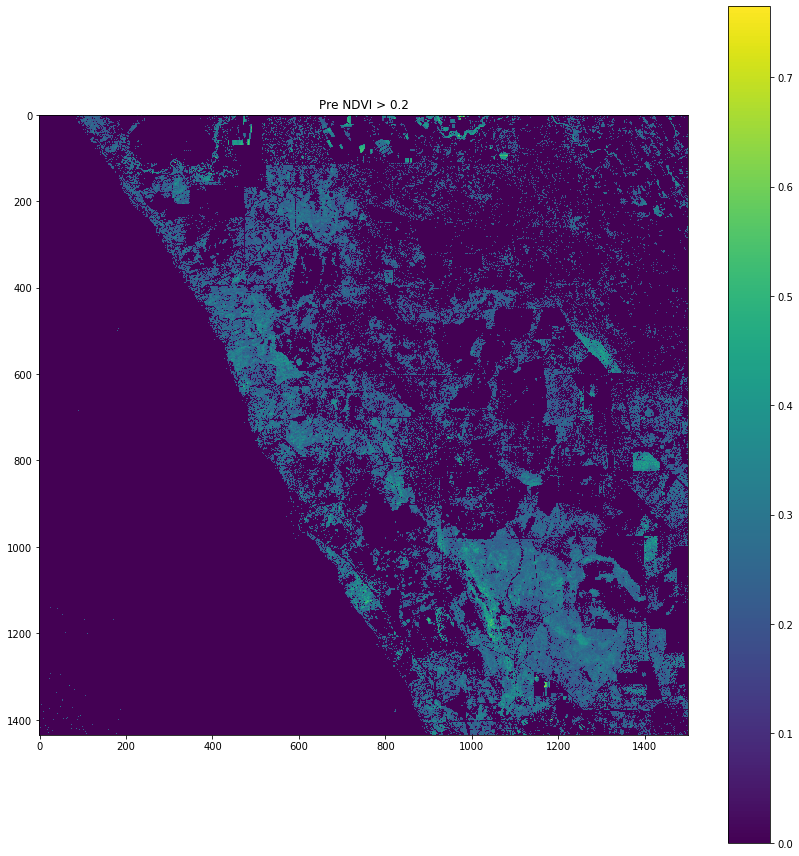

In [12]:
# Calculate our indices and first plot MIRBI

pre_NDVI = calc_NDVI(pre_array)
pre_MIRBI = calc_MIRBI(pre_array)
pre_NBR2 = calc_NBR2(pre_array)

post_NDVI = calc_NDVI(post_array)
post_MIRBI = calc_MIRBI(post_array)
post_NBR2 = calc_NBR2(post_array)


# First step, find the vegetation
import matplotlib.pyplot as plt

pre_NDVI[pre_NDVI < 0.2] = 0
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(pre_NDVI)
fig.colorbar(im, ax=ax) # Add a colorbar
plt.tight_layout()
plt.title("Pre NDVI > 0.2")
plt.show()

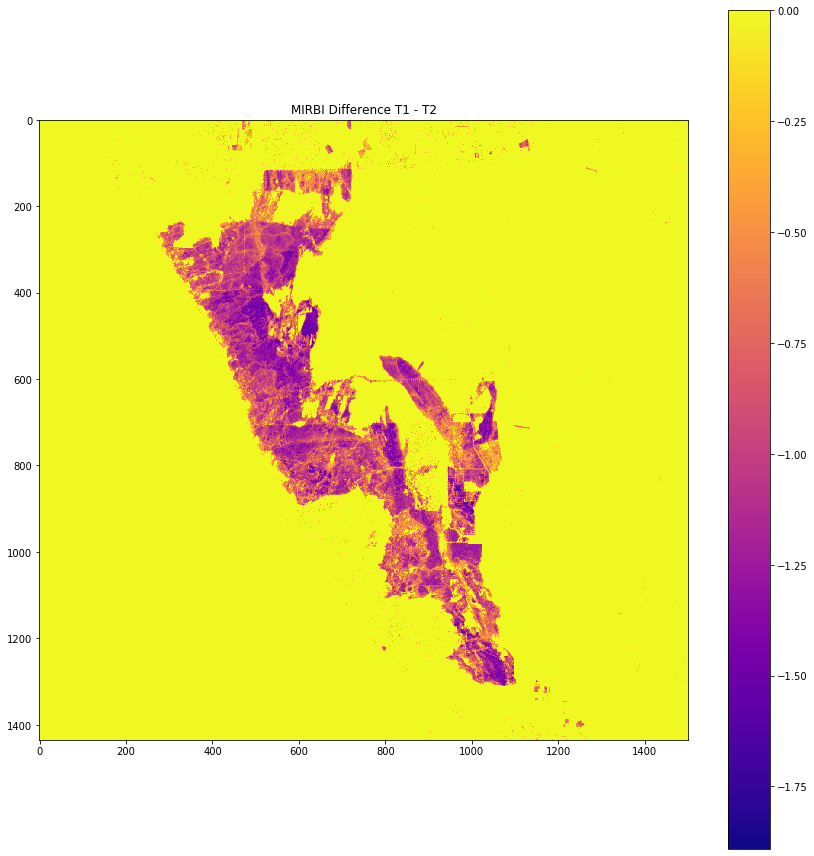

In [13]:

diff_MIRBI = pre_MIRBI - post_MIRBI
diff_MIRBI[diff_MIRBI > -0.25] = 0

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(diff_MIRBI, cmap = 'plasma') # other color maps (cmap) to try 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
fig.colorbar(im, ax=ax) # Add a colorbar
plt.tight_layout()
plt.title("MIRBI Difference T1 - T2")
plt.show()

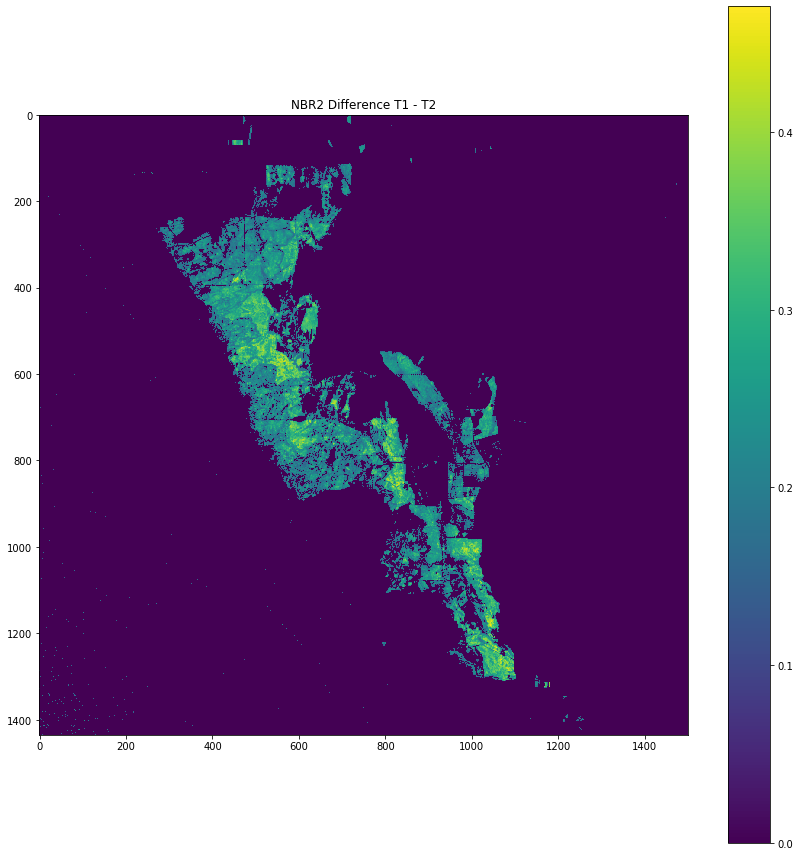

In [14]:
#Then we'll plot NBR2

diff_NBR2 = pre_NBR2 - post_NBR2
diff_NBR2[diff_NBR2 < 0.15] = 0

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(diff_NBR2)
fig.colorbar(im, ax=ax) # Add a colorbar
plt.tight_layout()
plt.title("NBR2 Difference T1 - T2")
plt.show()


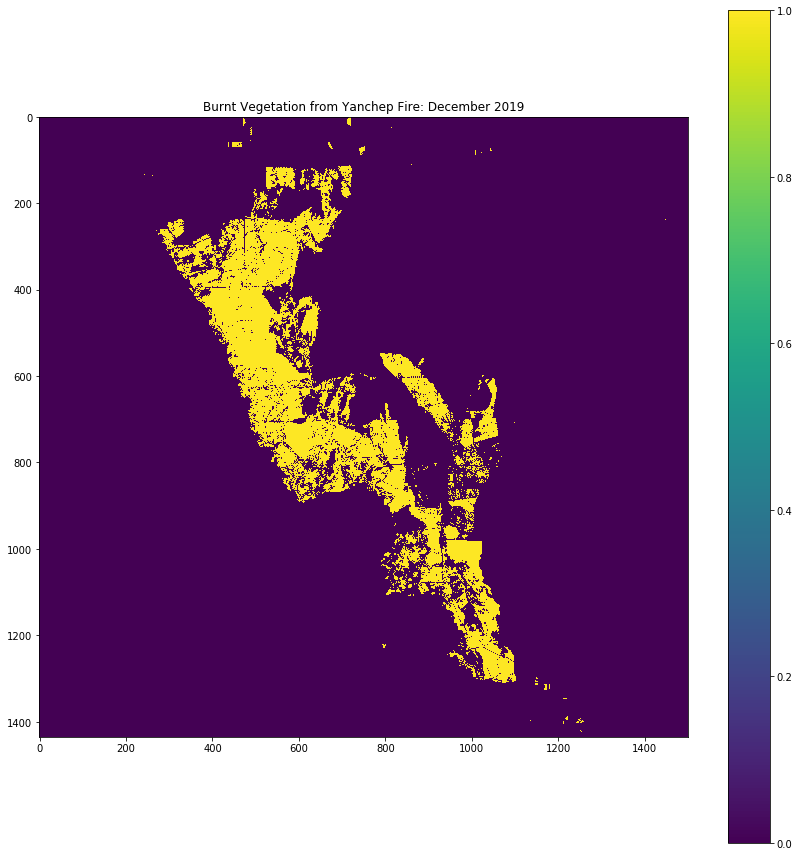

In [16]:
# Now we have to put all three criteria together

diff_NBR2 = pre_NBR2 - post_NBR2
diff_NBR2[diff_NBR2 < 0.15] = 0
diff_NBR2[diff_NBR2 >= 0.15] = 1

diff_MIRBI = pre_MIRBI - post_MIRBI
diff_MIRBI[diff_MIRBI > -0.25] = 0
diff_MIRBI[diff_MIRBI <= -0.25] = 1

pre_NDVI = calc_NDVI(pre_array)
pre_NDVI[pre_NDVI < 0.15] = 0
pre_NDVI[pre_NDVI >= 0.15] = 1

result = diff_NBR2 + diff_MIRBI + pre_NDVI # those with a value of 3 meet all the criteria

# Simple reclassification so much easier here than in ArcGIS or QGIS
result[result < 3] = 0
result[result == 3] = 1

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(result)
fig.colorbar(im, ax=ax) # Add a colorbar
plt.tight_layout()
plt.title("Burnt Vegetation from Yanchep Fire: December 2019") 
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


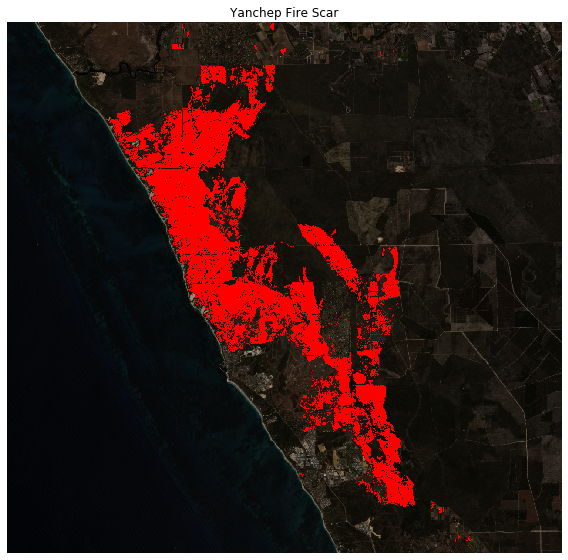

In [17]:
with rasterio.open(raster, 'r') as ds:
    array = ds.read()  # read our dataset into a numpy array
    array = array / 10000 # scale factor divide

def stack_rgb(array):
    red = array[2,:,:]
    green = array[1,:,:]
    blue = array[0,:,:]
    stackedRGB = np.stack((red,green,blue),axis=2)
    return stackedRGB

RGB = stack_rgb(array)

fig, ax = plt.subplots(figsize=(8, 8)) # Here we just visualize one band, try changing the combination or the bands above!

ax.imshow(RGB)
plt.tight_layout()
ax.axis("off")
result[result == 0] = np.nan
ax.imshow(result, cmap = 'autumn')
plt.tight_layout()
plt.title("Yanchep Fire Scar")
plt.show()

#RGB.shape

In [18]:
# Calculating the area burnt...

burnt_pixel_count = len(result[result == 1])

# One pixel = 20 x 20 m = 400 m2

burn_m2 = burnt_pixel_count * 400 # convert pixels to m2
print("The yanchep fire burned {} m2 of vegetation".format(burn_m2))

burn_ha = burn_m2 * 0.0001 # convert m2 to ha
print("The yanchep fire burned {} ha of vegetation".format(burn_ha))

burn_km2 = burn_ha * 0.01 #convert ha to km2
burn_km2 = np.round(burn_km2, 2) # round to 2 places
print("The yanchep fire burned {} km2 of vegetation".format(burn_km2))


The yanchep fire burned 77276800 m2 of vegetation
The yanchep fire burned 7727.68 ha of vegetation
The yanchep fire burned 77.28 km2 of vegetation


In [20]:
# Finally, let's write this to a raster (tif)

result2 = result.reshape(1, result.shape[0], result.shape[1]) # Have to make the raster 3 dimensional but the third dimension is only one band (still 2d but rasterio likes it this way)
result2 = result2.astype("uint8")  # Our raster only has 1 and 0 values...therefore we only need 8bit unsigned data type to conserve storage space
meta.update({"count":1, "dtype":"uint8"}) # We changed the raster since we first read it...now it has only one band and data type 8 bit integers vs. 32 bit floats from earlier

new_name = '/content/drive/My Drive/Intro2Eco/Data/yanchep_scar.tif' # Pick a new name for our new output raster

with rasterio.open(new_name, 'w', **meta) as dst:
  dst.write(result2)
  print("Sucessfully written raster")
# We could now download this raster and put it into QGIS to make a pretty map...Python is not meant for customized pretty maps...we should still make that elsewhere


Sucessfully written raster


     |████████████████████████████████| 921kB 4.8MB/s 
     |████████████████████████████████| 10.1MB 45.5MB/s 
     |████████████████████████████████| 11.8MB 10.4MB/s 


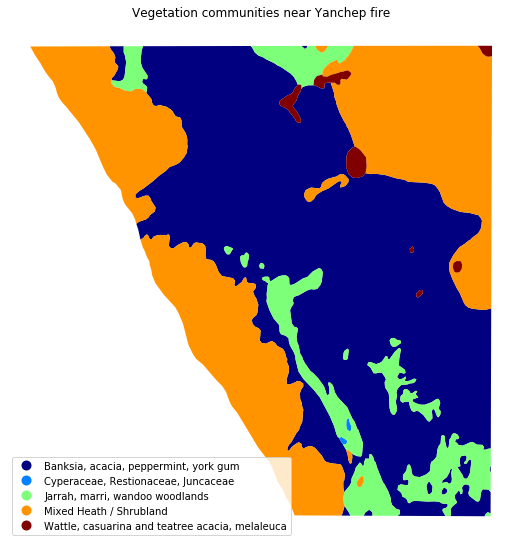

In [21]:
# Once we have a fire scar, which vegetation communities were most affected?

# We have to go back to geopandas and bring in a vegetation communities shapefile
!pip install geopandas 
import geopandas as gpd

folder = "/content/drive/My Drive/Intro2Eco/Data/Yanchep_vegetation"
layer_name = "yanchep_vegetation.shp"
yanchep_veg = os.path.join(folder, layer_name) 

df = gpd.read_file(yanchep_veg) # read the shapefile into geodataframe

fig, ax = plt.subplots(figsize=(8, 8)) 
df.plot(ax = ax, column='desc', legend=True, cmap='jet', legend_kwds=dict(loc='lower left'))
plt.tight_layout()
ax.axis("off")
plt.title("Vegetation communities near Yanchep fire")
plt.show()



In [0]:
# Let's extract those pixels from the shapefile for each vegetation community and get the number of pixels that intersect each polygon

from rasterio.mask import mask
import json
import pandas as pd

veg_types = df['desc'].unique()
#print(veg_types)

# Let's read the result raster we just created that has our fire scar
fire_raster = "/content/drive/My Drive/Intro2Eco/Data/yanchep_scar.tif"
data = rasterio.open(fire_raster)

res_list = []
for veg_type in veg_types:
  dft = df[df.desc == veg_type]
  #print(dft)
  coords = [json.loads(dft.to_json())['features'][0]['geometry']] # rasterio mask wants this json object it can recognize
  out_img, out_transform = mask(data, coords, crop = True) # most importantly, this 
  burned_pixel_count = len(out_img[out_img == 1])
  veg_and_count = (veg_type, burned_pixel_count)
  res_list.append(veg_and_count)

resdf = pd.DataFrame(res_list, columns = ['veg_type','burned_pixel_count'])
resdf['ha'] = resdf['burned_pixel_count'] * 400 * 0.0001
total_ha = resdf['ha'].sum()
resdf['percent_area'] = resdf['ha'] / total_ha * 100

resdf = resdf.sort_values(by = "percent_area", ascending = False)

new_names = {'Banksia, acacia, peppermint, york gum': "Banksia / Acacia", 
       'Cyperaceae, Restionaceae, Juncaceae' : "Other",
       'Jarrah, marri, wandoo woodlands' : "Eucalypt woodlands", 
       'Mixed Heath / Shrubland': "Heath / Shrubland", 
       'Wattle, casuarina and teatree acacia, melaleuca' : "Wattle" 
       }
       
resdf['name'] = resdf['veg_type'].apply(lambda x: new_names.get(x, x))




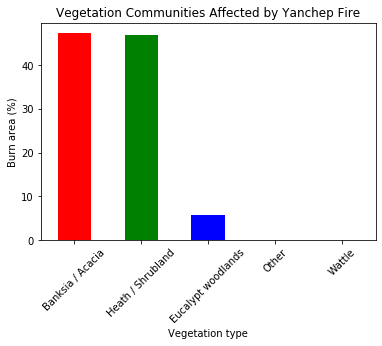

In [24]:
ax = resdf.percent_area.plot(kind='bar', label='veg_type', color = ['red', 'green', 'blue','orange','black'])
ax.set_xticklabels(resdf.name, rotation = 45)
plt.xlabel("Vegetation type")
plt.ylabel("Burn area (%)")
plt.title("Vegetation Communities Affected by Yanchep Fire")
plt.show()

